In [1]:
import gtsam
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<gtsam::Cal3_S2> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
X = lambda i: int(gtsam.Symbol('x', i))
L = lambda j: int(gtsam.Symbol('l', j))

In [3]:
def warp_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

# SLAM class

In [4]:
class SLAM(object):
    def __init__(self):
        parameters = gtsam.ISAM2Params()
        parameters.relinearize_threshold = 0.01
        parameters.relinearize_skip = 1
        self.isam = gtsam.ISAM2(parameters)
        self.graph = gtsam.NonlinearFactorGraph()
        self.initialEstimate = gtsam.Values()
        self.currentEstimate = None
        
        self.current_index = None
        self.current_pose = None
        self.observed_landmarks = []
        
        self.measurement_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.4, 0.1, 0.1, 0.1]))
        self.pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.04, 0.01, 0.01, 0.01]))
        self.odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.04, 0.01, 0.01, 0.01]))
    
        
    def predict(self, odometry):
        if self.current_index is None:
            self.graph.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(gtsam.Pose2(0, 0, 0)), self.pose_noise))
            self.initialEstimate.insert(X(0), gtsam.Pose3(gtsam.Pose2(0, 0, 0)))
            self.current_index = 0
            self.current_pose = gtsam.Pose3(gtsam.Pose2(0, 0, 0))
            return
        
        self.current_index += 1
        rotation = odometry[0]
        translation = odometry[1]
        odometry = gtsam.Pose3(gtsam.Rot3(*rotation.flatten()), gtsam.Point3(*translation))
        self.graph.push_back(gtsam.BetweenFactorPose3(X(self.current_index - 1), X(self.current_index), 
                                                     odometry, self.odometry_noise))
        self.current_pose = self.current_pose.compose(odometry)
        self.initialEstimate.insert(X(self.current_index), self.current_pose)
    
    def update(self, landmark):
        landmark_id = landmark[0]
        rotation = landmark[1]
        translation = landmark[2]
        measurement = gtsam.Pose3(gtsam.Rot3(*rotation.flatten()), gtsam.Point3(*translation))
        if not landmark[0] in self.observed_landmarks:
            self.observed_landmarks.append(landmark_id)
            self.initialEstimate.insert(L(landmark_id), self.current_pose.compose(measurement))
        self.graph.push_back(gtsam.BetweenFactorPose3(X(self.current_index), L(landmark_id),
                                                     measurement, self.measurement_noise))
        
    def optimize(self):
#         print("Optimization")
        self.isam.update(self.graph, self.initialEstimate)
        self.currentEstimate = self.isam.calculate_estimate()
#         print("Current estimate")
#         print(self.currentEstimate)
        self.current_pose = self.currentEstimate.atPose3(X(self.current_index))
        self.graph.resize(0)
        self.initialEstimate.clear()
        
    def get_trajectory(self):
        assert self.currentEstimate is not None, "there is not yet optimized"
        trajectory_rot = []
        trajectory_trans = []
        i = 0
        while self.currentEstimate.exists(X(i)):
            pose_i = self.currentEstimate.atPose3(X(i))
            trajectory_rot.append(pose_i.rotation().matrix())
            t = pose_i.translation()
            trajectory_trans.append(np.array([t.x(), t.y(), t.z()]))
            i += 1
        return np.array(trajectory_rot), np.array(trajectory_trans)
    
    def get_landmarks(self):
        assert self.currentEstimate is not None, "there is not yet optimized"
        landmarks_rot = []
        landmarks_trans = []
        for i in self.observed_landmarks:
            pose_i = self.currentEstimate.atPose3(L(i))
            landmarks_rot.append(pose_i.rotation().matrix())
            t = pose_i.translation()
            landmarks_trans.append(np.array([t.x(), t.y(), t.z()]))
        return np.array(landmarks_rot), np.array(landmarks_trans)

# Data

In [5]:
def swap(x, y):
    z = x
    x = y
    y = z
    return x, y

In [6]:
class Data():
    def __init__(self, n):
        self.n_frames = n
        self.odometry = []
        self.keypoints = []
    def append(self, odom_r, odom_t, key):
        self.odometry.append((odom_r, odom_t))
        self.keypoints.append(key)
        
def get_data():
    odometry_data = np.load("odometry.npz")
    keypoints_data = np.load("all_keypoints.npy")
    assert odometry_data["R"].shape[0] == odometry_data["t"].shape[0]
    assert len(keypoints_data.item()[0]) == len(keypoints_data.item()[1])
    assert odometry_data["R"].shape[0] == len(keypoints_data.item()[1]) 
    n = odometry_data["R"].shape[0]
    data = Data(n)
    for i in range(n):
        keypoints_one = {
            0: keypoints_data.item()[0][i],
            1: keypoints_data.item()[1][i]
        }
        
        keypoints_one[0][5], keypoints_one[0][4] =  swap(keypoints_one[0][5], keypoints_one[0][4])
        keypoints_one[1][5], keypoints_one[1][4] =  swap(keypoints_one[1][5], keypoints_one[1][4])
        
        if odometry_data["t"][i] is None:
            data.append(odometry_data["R"][i], odometry_data["t"][i], keypoints_one)
        else:
            data.append(odometry_data["R"][i], odometry_data["t"][i][:, 0] / 10, keypoints_one)
    return data

In [7]:
data = get_data()

# Laptop keypoints

In [8]:
import scipy
import scipy.optimize

In [9]:
class Laptop(object):
    @staticmethod
    def get_3d_points(a, b, alpha, t = None, R = None):
        points = [
            [a / 2, b / 2, 0],
            [a / 2, -b / 2, 0],
            [-a / 2, b / 2, 0],
            [-a / 2, -b / 2, 0],
            [-a / 2 + a * np.cos(alpha), b / 2, a * np.sin(alpha)],
            [-a / 2 + a * np.cos(alpha), -b / 2, a * np.sin(alpha)]
        ]
        points = np.array(points)
        if t is not None and R is not None:
            M = np.concatenate((R, t[:, None]), axis=1)
            feature_points_3d_hom = np.concatenate((points.T, 
                                                    np.ones((1, points.shape[0]))), axis=0)
            feature_points_3d_hom = M @ feature_points_3d_hom
            return feature_points_3d_hom.T[:, :3]
        return np.array(points)
    @staticmethod
    def draw_line(p1, p2, c):
        plt.plot((p1[0], p2[0]), (p1[1], p2[1]), c=c)
    @staticmethod
    def draw(ps):
        Laptop.draw_line(ps[0], ps[2], c="b")
        Laptop.draw_line(ps[0], ps[1], c="b")
        Laptop.draw_line(ps[3], ps[1], c="b")
        Laptop.draw_line(ps[2], ps[3], c="b")
        Laptop.draw_line(ps[3], ps[5], c="r")
        Laptop.draw_line(ps[5], ps[4], c="r")
        Laptop.draw_line(ps[4], ps[2], c="r")
        
    @staticmethod
    def get_2d_points(T, L, K=None, R=None):
        if R is None:
            x, y, z, ax, ay, az = T
            R = eulerAnglesToRotationMatrix((ax, ay, az))
        else:
            x, y, z = T
        if K is None:
            K = np.array([[400, 0, 200], [0, 400, 200], [0, 0, 1]])
        t = np.array([[x, y, z]]).T
        M = np.concatenate((R, t), axis=1)
        feature_points_3d = Laptop.get_3d_points(*L)
        feature_points_3d_hom = np.concatenate((feature_points_3d.T, np.ones((1, feature_points_3d.shape[0]))), axis=0)
        feature_points_2d_hom = K @ M @ feature_points_3d_hom
        feature_points_2d = (feature_points_2d_hom[:2] / feature_points_2d_hom[2]).T
        return feature_points_2d
    
def find_laptop_position(keypoints, K):
    assert type(keypoints) is dict
    assert K.shape == (3, 3)
    
    ids = []
    points = []
    for id_, point in keypoints.items():
        ids.append(id_)
        points.append(point)
        
    ids = np.array(ids)
    points = np.array(points)
    
    assert len(points) > 2, "Not enouth points %d" % len(points)
    
    L0 = np.array([0.6, 0.5, np.pi / 2 - 0.01])
    T0 = np.array([0, 0, 1, np.pi /2 , 0, -np.pi / 2])
    reg_lambda = np.array([200, 200, 10])
    
#     points[:, 1] = 1080 - points[:, 1]
    
    def cost_fun(x):
        T = x[:6]
        L = x[6:9]
        y_points = np.linalg.norm(Laptop.get_2d_points(T, L, K)[ids] - points, axis=1)
        y_shape = (L - L0)
        y_shape[2] = warp_angle(y_shape[2])
        y_shape = reg_lambda * y_shape
        return np.concatenate((y_points, y_shape), axis=0)
    
    x0 = np.concatenate((T0, L0), axis=0)
    res = scipy.optimize.least_squares(cost_fun, x0)
#     print(res.fun)
    print(res.x[:3])
    return eulerAnglesToRotationMatrix(res.x[3:6]), res.x[:3], res.x[6:]

# Import camera matrix

In [10]:
file = open("camera_calibration.txt")
s = file.readline()
s = list(map(int, s.split(", ")))
w = s[0]
h = s[1]
K = np.array([[s[2], 0, s[4]], [0, s[3], s[5]] , [0, 0, 1]])
K

array([[1236,    0,  917],
       [   0, 1208,  520],
       [   0,    0,    1]])

# Process SLAM

In [11]:
from tqdm import tqdm_notebook

In [12]:
class Result(list):
    def trajectory(self, i):
        return self[i][0], self[i][1]
    def landmarks(self, i):
        return self[i][3], self[i][4]
    def shape(self, i):
        return self[i][5]

In [13]:
def process_slam(data):
    slam = SLAM()
    result = Result()
    shapes = {}
    for i in tqdm_notebook(range(6)):
#         print(data.odometry[i])
        slam.predict(data.odometry[i])
        for landmark_id in data.keypoints[i].keys():
            rot, tran, shape = find_laptop_position(data.keypoints[i][landmark_id], K)
            shapes[landmark_id] = shape
            slam.update((landmark_id, rot, tran))
        if i % 2 == 0 and i != 0:
            slam.optimize()
            res_trajectory = slam.get_trajectory()
            res_landmarks = slam.get_landmarks()
            
            result.append((res_trajectory[0].copy(), res_trajectory[1].copy(),
                           res_landmarks[0].copy(), res_landmarks[1].copy(), shapes.copy()))
    return result

In [52]:
result = process_slam(data)

[ 0.13688326 -0.13959741  1.83411675]
[-0.89043061 -0.19158946  1.92473527]
[ 0.13688326 -0.13959741  1.83411675]
[-0.89043061 -0.19158946  1.92473527]
[ 0.137395   -0.13812653  1.83314509]
[-0.87808142 -0.18815174  1.90378049]
[ 0.1403315  -0.137024    1.83235282]
[-0.88373279 -0.18897841  1.92333763]
[ 0.14119674 -0.13603607  1.84217125]
[-0.88167923 -0.18603846  1.92188197]
[ 0.14094564 -0.13491975  1.83578696]
[-0.88607156 -0.18741729  1.92809862]



In [38]:
result[0]

(array([[[ 1.00000000e+00, -4.36447263e-12, -1.39404376e-13],
         [ 4.36447263e-12,  1.00000000e+00, -1.85558199e-13],
         [ 1.39404376e-13,  1.85558199e-13,  1.00000000e+00]],
 
        [[ 5.02459217e-01,  4.37837225e-01,  7.45542286e-01],
         [ 4.88794309e-01,  5.67422060e-01, -6.62655513e-01],
         [-7.13172391e-01,  6.97374196e-01,  7.10940996e-02]],
 
        [[ 4.65553292e-01,  4.91727522e-01,  7.35842495e-01],
         [ 5.35599572e-01,  5.05358061e-01, -6.76569530e-01],
         [-7.04551794e-01,  7.09096097e-01, -2.80979417e-02]],
 
        [[ 1.14782213e-01,  8.67507059e-01,  4.84000564e-01],
         [ 8.31567173e-01,  1.82625918e-01, -5.24541524e-01],
         [-5.43434522e-01,  4.62687018e-01, -7.00428186e-01]],
 
        [[ 7.61695513e-01,  1.12882437e-01,  6.38026255e-01],
         [ 3.04663328e-01,  8.06662294e-01, -5.06434794e-01],
         [-5.71839316e-01,  5.80132312e-01,  5.80039910e-01]],
 
        [[ 8.90624532e-01, -7.68507629e-02,  4.48198509

In [13]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import numpy as np

def plot_laptops(laptops):
    data = []
    for i, laptop in enumerate(laptops):
        data.append(
            go.Mesh3d(
                x = laptop[:,0],
                y = laptop[:,1],
                z = laptop[:,2],
                name='laptop {}'.format(i)
            )
        )
    layout = go.Layout(
        xaxis=go.XAxis(
            title='x'
        ),
        yaxis=go.YAxis(
            title='y'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [42]:
result[0][3][0]

array([-207.94091798, -209.2889135 ,   -5.40720994])

In [14]:
Laptop.get_3d_points(*result[0][4][0], R=result[0][2][0], t=result[0][3][0])

NameError: name 'result' is not defined

# Test detection laptops

In [14]:
import sys
sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")
import cv2

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

In [16]:
R, T, shape = find_laptop_position(data.keypoints[0][0], K)

[ 0.13688326 -0.13959741  1.83411675]


In [17]:
import matplotlib.pyplot as plt 

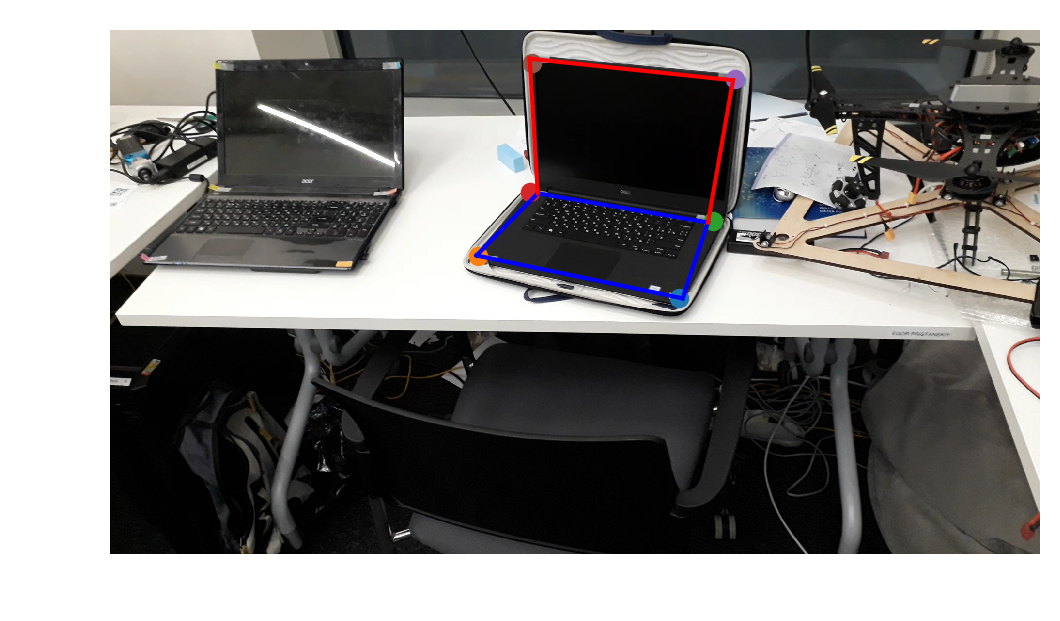

In [21]:
img = cv2.imread("../QRretriever/data_png/data/laptop1/0000.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.gcf().set_dpi(200)
plt.gca().axis("off")
Laptop.draw(Laptop.get_2d_points(T, shape, K, R=R))
for i in range(6):
    plt.scatter(data.keypoints[0][0][i][0], data.keypoints[0][0][i][1])data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABCQAAAJtCAYAAADuEaGXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAewgAAHsIBbtB1PgAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsvcmvLcl5J/aLITPPeIc31UwWySJZJDUBLVFiW21IaEMby4IGe9OLdhta2F7aXvTfYsAL2wsDBgx0A/aiDdtqyaIkWEOrSUHdEskaX73hvuHee+4ZMzMGL76IyMg8ec4d6tXjFL9C4b5zTmZkZGRkxPf9volZa5GQkJCQkJCQkJCQkJCQkJDwMsF/2B1ISEhISEhISEhISEhISEj46UMiJBISEhISEhISEhISEhISEl46EiGRkJCQkJCQkJCQkJCQkJDw0pEIiYSEhISEhISEhISEhISEhJeOREgkJCQkJCQkJCQkJCQkJCS8dCRCIiEhISEhISEhISEhISEh4aUjERIJCQkJCQkJCQkJCQkJCQkvHYmQSEhISEhISEhISEhISEhIeOlIhERCQkJCQkJCQkJCQkJCQsJLRyIkEhISEhISEhISEhISEhISXjoSIZGQkJCQkJCQkJCQkJCQkPDSkQiJhISEhISEhISEhISEhISEl45ESCQkJCQkJCQkJCQkJCQkJLx0JEIiISEhISEhISEhISEhISHhpSMREgkJCQkJCQkJCQkJCQkJCS8diZBISEhISEhISEhISEhISEh46UiEREJCQkJCQkJCQkJCQkJCwktHIiQSEhISEhISEhISEhISEhJeOhIhkZCQkJCQkJCQkJCQkJCQ8NKRCImEhISEhISEhISEhISEhISXjkRIJCQkJCQkJCQkJCQkJCQkvHQkQiIhISEhISEhISEhISEhIeGlIxESCQkJCQkJCQkJCQkJCQkJLx2JkEhISEhISEhISEhISEhISHjpSIREQkJCQkJCQkJCQkJCQkLCS0ciJBISEhISEhISEhISEhISEl46EiGRkJCQkJCQkJCQkJCQkJDw0pEIiYSEhISEhISEhISEhISEhJeOREgkJCQkJCQkJCQkJCQkJCS8dMgfdgcSboYffOfbdtdvjDMwxm7ctrUW1uxsHpYzOsbacJ2rXk+446y1rfP8Z213X7fvOle5rm8booA1ZnfbfP+19/3MGAfnV+/bde/Ddsal+7k7jvH3AgJVVeP9D97H/fsfuePUnr5wWGt62+v7bveIAtbqrf4YY8AY2+pzPJ9a7RsNxnjrN2M0tDFgTICzHbyq4L331+0PZwxVVePJkxOsNxsMBwN3XwKGNcdlmcRsNsPTp09RVRqWCXzw0QN89zt/C60BwTMorSCFxHgyBecCnDEwTvdlrYbMJO7cvoNbd28hyzJwzmGM2Z6Xl7wHFv331n4neeiPXxOstWDu3dZGI5MZalVjs97AuD5oa2GMhnHvuL+OMQZG05iHa/TMec4YzI7+b83jzjrTfQfj60shwndx+34tsqa9FsXzCqB1q9su583c6b7f3XvTdYmHD+5jNpvhlVdexb1795pr8Qz+dO3GkbN4Hd73ljTX2h4P5vrWPr9vTrPoXqwxYJzeGT8u3TabNvbbJbhtfo/nFmcMGefYLFdQqsLF/BSqLqGNguAcglnkHIDROD8/h7UG1loIIaG1glIWWpkwXnk+AOccZakwHAxgOYNiwKYswRiD0hp5nsEaC2MMtKX3068lcd/8taQgEcdY695FBu7GRXAR3gvhjvPH+PY4FxCivfZkMoPlojtK4DyDNQLrUkNkEpVS7n0Ubu411x0NBhiNRgCA4SjDYnGG58+f4OTkMZazc8AoWF3T9TPqm2UGxlrkjANG4eBggt/4jX+Mo+NpWM+ttTDG9q7bcV/jZ+/76O8fMGG95e7eN5sN/uiP/gjf+8HHODy6jXfeeQeTyQRKK6i6hjYGgnPXdt98udpc2yUXMMZgOXNrk0EmZVgHuJsb4bievZKxtkxkO2sbfad2rk+ms//QeTxcz49/87lpX4BBuDXR94W7tsI6xkT7Xlv96B8zv767be5KMoH/TmkdrdU66rNpPb/ta7LOv/nWei8F3Ys2BsaoVpv+34wxaKUAZkJbxt0nB/D44X0sL5bQWmEyneKtz32OxosBxhhImaEsS3DeliP83Kd3141xZ03lnNFxjIff/Hf+HAkW9oPwHKXbf4yFRjOvw/4SvXeWW1g3VL5PXqbiXIDDhDUqbocxhgz0XP3z8etZd0+11ob9u/OQWm0aayGljPYEAaObcff7QV3XYS5dhu5e4yEYhzY0nwTnYc7796i7pxptIKRoyS1976CUgtrWGsYY5MMBBOdgUkIKgcFwCLg+dZ97kMtN+z2I31Ftm/XcaA0hJVRdR/s7p8+cQWsDpUo8fvghZs+fQldNe1xwvPnGm3j33a/g7t1bePW1uzicjiCYhZcBfJucCxijMXt2iouLCzDOkMkMQgpopXHr9i28cu8eeFYAnOZBJkmWU0pDuvno5yljHFxwWGNb4xzv/zySieO1KH4/fVvx5134rf/0v7i5otmDREgk3Ai04PNLBJ8Xc50XcQ2vUL1MdAWel4mu8JVlEtPpFJmUqNVuMuJloe+Z7urLLgGJFtMX6+QlthQNgnWCcFEUtJHoCsxtCIPBAIvFmjYBx7940sWAg0fKr+ACKhr/XYTPrqfihb+WILRjnoXNxQlt2l1XuDHzwoxXwi7RmXuv8aLez8uut2+eXoU0uwm00oGw4IJjNBzh+PgWNpsNZrNz3LlzG4PBEEqrQEZYa5HnuRPCGlIvJoT2kb0vE9Zat4bf7HxtNGbPn2N5MYPSG7z++qv4pW/+A3zxi1/El7/8Zdw+PsLx4RSq2oTreWFJK4XFYo2LiwWM0dhsNnj+/BTPn5/h+bNnODs/x8VijsdPnuDJ82e4uLiAVhrzxRxGG1KoeB4Iw13kOOccQoiWQur3AcYEOOeQQgahviE3eFAat4gpbZAPhkHgJcWC4fatuxgMJsgyCQOaM0TgMYAxMCYgOCkb680GVVWBMYaLucZkPMEXvvAO3nnnXSznMyznM5yfPsN8vsB6vYCyFb3P2sIYBaNq0AvrXlqbub8GgHX/N/CCJ+cCSpuOEtkhmK0FpzuA0aQ0qbomJVNZIjA3G2RZ5trmkIJfKrzGffHP7LrgjIELAW0aZa6q64Z826GU9/XByy83lQvouZNiAbCtddgYQ+vHFW+TCwFrTOgP5xyMc1jDdo4tkUCfXq5p3h1x5edCx1kiiTwhxDlU6/f4eNM6l/FYEfJjx2F124hRFAW0MciyzB1noLWCELylVH4aaG0gpYDWptew1FWqme3stV75dQqf7hhi/L3tg193/HwRXEAbDfS0Fa7bIZs4YzBoywQcgFJEEltjgE4/brIfxSQE8+2i6be1BkrprbXzKojXB8YYhHRjqvWW0YoIFffuX6Pt7jvv92trLYSUrWMBBOWfMYa6XkEp3btuFEVBcnYmMRgOHZnNEQTD0I/2vC+KokWcTqdTIsw7z8pYC97zunMntwaiCW0SwpNlMVkhuCcnmrWzb476fcITF9ro8PlFIxESCVu4bIHqKkJdXEV5CNfw7L7/zNoWja4nxmWbT6/l8IekdP+o4fDwEMPRCGo+h7U/nHHxz7L7XP1vHvHz95+7x122IPrF97J5aqyFkAKj8RhKX0RWq/axxpCyORwOsViskAuOW8fHGA5HmM9XdD3GYCx5EgghXB/pXrUT7rXWqKqKLP5+U3Cb+r75zVvvQJuU6L1/Zz20xraMbH5D8X+9ldH4TamHnOgq0n0K4GdFTMQWxdg7gjNGiolpFH6ABEajLvFI6O3zbq8lay2UUjg6PsJsNsPZ2SmePXuON954nSxBphkT4wSnGNZYcCnQ9RiKf/d97/t+J0OFtrWq+x31Y/97cuk6EN2Kvy9jFNarNU6ePMRv/ONfx2//zm/i619/F1mWQSk/jw2s1RBFvnWNnDGMDo9w9/WOcMlsy3PBwD1PbbBer/H06VOcnp7i/PwcDx49xZNnz/DkyROs1ys8PjnB2ekZlqsl5vM5tNKo6graqPCuCM4bzyoAdW1Q1yp4QTSWYid0cQ7urGfGNALxcrmMjrWA5SjLh7hz+1WMp8cQQiDIq5aIAJllYIxDSAFV1qh1Hcap3JxhPpdEeApgODrGwdFdTCZj1HWJi/NnWK8XWK3XqJdr6LqEzATOzzfgvEBZ1oF0t9ZCCIEsy8I6mmWZ6xMHZxKwgDW6eU7wyhRHMwU5SNHW0KYhcDgTyLICflFprN6kPCN61nWtwpgJLsBFo4Qy1mfV3+0JZGnT2rIUc7FNIsf7TLcdj4aYip579B56Ib67Vnjh3yvYxmjEL0nf3nYVdNf/5h3uX8uuSgBd6do7FPttkrs5hizJOR3Hee/xcTv+1LYVdns9JLIpVnAja3znnrUn/G4I7xlBbffff3cuWU3eFaFPbp54byKjTWvJpWv0zfWGTGp7pRp3vf7nGxsl/B6+S47yEC3jYb/sQMaY/v3JP9+yLDFwHqRBiXeeFzQW7p3oyvk9sB2PBc5Yi8QIfdx6/3hD3uAK+1d8zSvIKN2xsdZitVo3hgZrsV6vUFWVIwCasS2KAsPREFlOe15RFK126a+X+Rh0bbDZbMLvjDOoWkFlCsPhkEjTTv+N72OQDbbvv7uO9cl0Xu7z7fZ7MnFYo1rXCTLApSN5fSRC4icUn7XnwqfFZczpPub7Jps9XfSyV+jFKuj7NvNdx7woeAs9gGBFzIoC08NDLFZLWNCCbqwJLvyN4PXZe5LsGpurWP4/K2QyQyazsMl3wZ27t5Tkxl3XCgcHB8hzAcBAmzoIEtrUkJaTAO1cQRkTMMZCawtVa1RCoxhc7sIcLB9uA/EWV4+uRaHpbyOoE1nCyWXdts/xITGAdhu9+70rQHG2JWDEltbWtSOyx1/nJuiSEb3HBO+D9nmXkTXXVhisBazFdDrFxcUFnp8+D14SvPNM+s7VkWfMla4XkxReCIiEiE8Dr6h2w6d2HduMJYe1GnVd4+P79/E//g//Pb78xc8DTGG9XuP87AJlWWO1XoMzCzADzukaXJCHkH+HOM9AoQ4cUkrEIo4XOiUnzxRrLQZ5gTdeew2ff/MtcgVmPFgDhRSBbLDGYr6Yo6oqzGYznDw+wcXFBZ4+fYqTkxM8evwIH7z/EebzJc7OzqFUDaVKWDQeUixyH2fWUj9trHjRI6FhoXd+MT+DZBmEyHFwdAwmMzBmUVcU/gRtYN09ZpkMe5yxFnW1Qa0YarUCYKCVBssYzEODg/EBtAEm41dwcCRxa3oAo2rUdYnleony8QybzSZ4edS1itYJGvtMZsjyDIILyIy8RvI8RyaaZzsej53XgzsnI0ICABENlrvxMJAcsNqRIGg8KuhwH97AcXFxgThiSIocg8GgRZbEYVO73lhrLCxjOwM+uqRB3/4SK5fXASlFMXHRCO77XJuvaxzZJjF9mx0PnRAe049e8qWzbuwjDnb1x//eWK5lON73JyaLva0W4NBKNeFnvN8LgzFO+2ppgqXXfw8QAWJ6Qtd2hWbE2DUvGGOQkkdeKf3P7Kr7V5BbGcCiUzg11P6MZotlDEAUFuSt0SJ4gJlon+XgLqzKWtMi6bQxO/ehPtkKaO/rewk8rZE7LxVPnoX3zjRP2/fP7iLXO33y11XOSwVAi3T0azqHf14yzOV2WKTr5xU8PrrPlHNawRi88cm0PD9yIaCqio61gKoq6FrDr3WekMqkwHQ6RpYJSMEgZQbO6Xnb6PnRGDKQqMlRliWGwyGFGApaJ6fTQ8B5XjHsNtB1vRo+jbwcSFZrw9zrjtVnKY8nQuInED9sl+D9ikD/9yZamXe/eI0QfZNrX8Y3XL7p7BMmDIxpLwx7ZIbWNW8qKHXbuewaUgpMJmNYa1FXNcUVWrtTyHuZ6Hvmfdap5ngvCO5pcytWfhvddrXR0Eq7uMbGvTFuQwgJISSMVpCZwK3bt/H06SnquiEyvKVSO/dTrRuBa7FY4PDWcYhJ9VYJxgXQ4yXR8g645B6stS0igr6LrDDGBqFu90bWbm8XYlLRu4ObHWQO0His+H9zQTv1Ps8Lf899SnhMhJAg6H9o3891yZCYzOvDnTu3UVUV7t+/j5MnT/D6a6+Difxa13iRCMLgrhwSPbd/VbIv9gLwHgyLxQqL+Rz//J//t3j782+iVmucn59iPl9isVhgtWosPpwzSNl+nz05IYUMn4UQQTFlTpL3x/h/51lOSnQmnfVGuJAMDl03YRmMMxyMR2CTMe7dvoWvfvlLFPetKYeLJx04l6hrg8ePH+HZs2c4Pz/H6ekpHj18hNlshmfPTvHs+TOcnp7h9PSps4g5ARmAcbk1OLPQRmM8FNBqhqrMUa4LiGIEMIvMx9Rrui8heOTSbcEZhX35XBrWAhCUX4MxjovlCgDHYjmHtRbP5CnyXCLLcgjBSOAVQ2RyAMYEppNGSC/LNay1qKoKi8UcXAhU1QZ1tYE2GoILykshGIQUKIrCjbHY8rIAOEaTA+T5AHWtwWQWwpoMJ08wDgm4OWcZMJsvoJQmF2QhMF8tMZ8vkec5RqMxhsOcvC44v1LoRDevTQwvG8ShpN19NSbfepXiaH1qkeSd49rhB2ZrDe67dkwqxwpX182+284uuWOXzNAdH7KmGk8Zta4bX7+L7j7cJ3vF1tKW90SnLS5EtA+5dV3rkDOIlC4FZiWsVTCMt9eLHUQJ54282PV2MKYhGJrnxRHfwk5Fyza/X2nOmIhAZgwM7b26NQ/oG38D1K7vFOdgaMKm4vnixyAYTHq87YRTrOO+7uu7tZb6bi32GaJstCeG/aaXcGsTU63fuqEwkReS/6zj6+wgxPreeyDKDRK9F/GcYFsyZPt5twibaE/1hgQ/Z3Vduf8VaNVr2js6PgJjlFPm4OAAQlAIDrXbfl+NodCj4XCIPM+hlILWGkIIjEajrZD4+N+C816jbnjno9+6/271wXoyufncvVbcbjxHUshGwk8ETLT47csP0AVtMmbvMZdc+ZLfP1vVvCsYfZZeLK1FB7T9WWsxGI2QFQUMDJRW4K1os5ePrgL6WY/LPgwGA4onryowQ7GJ3hoWJ8+aTCaYzeaoljUE5zg4mGA0HmA2m7eUqsY93wtXLh6YMayWG0zGk94VmDEyv3qre+zO2YfLFO++82N3x8AFeuFN7w4d8W7dTXhKY7k3WrU8I+JnK5yZIFYorgIvjHbvsc/S0z1v12/WWmRSQvXEpAJNoktrbZvUso5UERx3797FbDbDg08+wa3jWxiO9xMSNyEbW4kunYVWXKMdawyYEL2eLcDVvUS6CtZ6vcJ/+V/9Pn7t138Vi+U55rMzrFYrnJ6eY7lchuSU1lrkuQTnRBaoSLBrrYXuPlXdJAaM/wJw1qcs/PW/SynBOW8pzp7gGA6HQdAWQgYPDbLuivDv6XSIo6O3wThDnpEFf7PZgDFSyrXW0LrGer3CerOCVhpPnp9jvSpxfOsY0sWNn5w8xoMHD/HxJ4/xV//2OygrjbrWMJpjfHCI9bqEsdYlS2vmmLHkahG/o1LkUFw7gVHCWAMNmo+lVihXFaxZgDwgJDhrFCfhyEFPQstMIC+mOBgdQWYCWlfgnMYvyzIYY1CWZYjRFpKj0gqmNqiWq0BIIR/j1TfHyPMcohgCTEDmTkn175vIANcuABTDA+jlCpZlKGuNqna5NSqDWi9gMMJECmRMOGWs8RqJwcXl+ar2KTDxb1pvu7n7z7sE8dAPLrbW0qvAK5TXEeL73k9KbNcmfkkZb8ekd7F1Hz2fDTyRHnuANOvudbwE4uvGluH4d+ZIrD4lk9YOSlyZZRLCGU+gu/tYm7y+DPsInKvcz962YzIrSpDZhyZhpuu726OZJQV33zwx2rSVzIhYuuweumtr+/u2kms7XgK70ArX8bk0IpItHnPyDLCtUIKuocIinh8I/2bWk9wczK1vXJBnXExAXGp53AG/Z9G+39wTZwxWGwiQx8PZ7Byb1QpGqVYibcEFJpMRJpMRBoMcWU57EzPeWOI9zmjeU7gLw8nJU0ynUwBEVleVQlEMYS0dKzhaIUJhLI0FF2KvBM8YC4lDmdh+5l2yq9W+T8J6ydrxIpEIiYRr47IFep+Quzv7vk/OdXVSYJcA8qOKH5aiHWMynWAyGWO9XoTvrmotfdHos07sslhsbWpBKOxPQgk0FvmrCipccGSZRFmKxoIPHydsgxAvpYCUtCGWVYnhYIDBgAiJuI9KKchMgrwqya2bOauw3/iUUqBUEiIkkPP3GtxfnaWkOwZN3z1xwlpjE5N91G77eLjWORfgXEMbHVxlKRM4UNu6dS3rlKemzf2boUeXeffP5abeXG1rhu21FuyD0rs9OWLEbXvyRmmFPM9x6/YtbDZrPHz0EF965+B6N9BBX5WNcF0XsrHz3diRQyLEpO+Z/35eeMHksjX19Pkp/ul//k/wD/+Db2K9vsD87Bkuzk7x5MkJhMwxHo/gBS7pkoP5ONo8z7faJOWTXHIzmQXlqi0YN4Kr0QYbRR4YdV0H5bI7Nowx5HnuktDyQFwIKSCFDARGEz7ivSZcWBNrQpdIIeLg3GIyGYExhtv37sIaBqUVjAas1bh79zZ+5me/hvl8jv/kt/4jPH9+ivfee4D//f/4vzA7PwGQYTAYQGQSyruyO48sugeKCbfGwkAD/rm45+iT4jKtwcBgXFULWO7INVoDtLWwtgYXHKom4RbYuNExYC6UJijrnDWhKtHYCSkgh9MwrpNbRai+A7gEataCCfduaI11ResI1uTeLMUAjNVYLkrnkZHBGg5jGTgDlKJnaoX3inHu/Lpd5ecqFIBfj/o8DVrk1iXKO9BYveM2/PjF7XW9I24CY0kJu4pSTet2mywg0mq3Uu6/26vk2tgjpJ0gtPvv6yB+JqG/oWrWduUSn6fFGAtdqyhfR5MkeBcB3+eqf3nFmX54o8CVj4/Wb8bZvjyU29fZ+q6pqtFXsconzgQ6Xin+371t0jOolUKe9at91hrA2C0SopcYizw7AnFhdyfjjvthrAFMY60PBARj2znleiCECGSH0RpiOHTtuHG4hAzaBdt6B5o5b6L7YpyFnEaxdwcXtLfkjojNsiyEn3Tb89eh/EaGvOPcPjYajZDn5AnYjPl29Rv/rIUzlHgQ6U4y3XK1RF1VyPJBq7pGjO4cCwYl7NbVPkskQiIh4acEnHMIK3BwcICTJ49bv/2wSIkfJQjOIbOm7FIMGp9GMR2PJ84dWWE4GmI6neLk5GnreGstVK0gZREIALKwk7X4qoTavo2BMV8hoyElto7pyQp+2XUZZ6jresfRDa5qZd953Y71vs+SR0qSVyJ0b6WRa10zshJdSQlwSUFjAqQ2NQ4ODrBcLPHs2bNr92HXdba8B/y/r3CbcXIxgJQ7ozV2eaFdu39W4wtvv4Ff+Nmvg1mN+fkMDz/5BOvVEkVRYDAYuzloIbMceZbj9u3bobxtn1dL7ao3xMSEMcYp+p4MdEqfaAt2RVE4t1cf8kRVd7yl31qLzWYTQpR8eAHjrAkFiT57sqKpzGHDMURAcnAuHUkhkGW+jSz0y5gaglkMco5X793CeDjFm6+9jn/9R3+C9977GBcXF4CVMEyCMQHBJGROpVk1DLim0IVS1TDgLmO9hrUMAoDVGpxRslwfl6yUhRR5Y2107uLWWlhmsS7rxnOLWwC+HKN7Hn4NAZzFj8oqat2MLT0HDe6ya/gqJOG+nWDLbEMYW9tO7qqVhmENMVUrhWfPFthsBiTM5zkyycGFgBSCrH+R9TyOu2+RhL791lHbRMFN1wt/LnAzowLjDAI3P7+LXR4aSuuQy6F7nX0hb7HuxnvITWBboerzaNj1fey5tE2qbo+HXxOkpHCiOATx5mu+C6+KXPj3wSvXMZlyFUOc9CV6uU/OuYNEBgu5VZpy0+1yvN6VPlT7cUSFiLx09BXHwvfDl8vte05A5O0QzQOSMXbMiz0eFJxJGFcJiDMJ5kLb2jDhOWvlclhx21s1h1mN3Pffr9supwVzaw/g8/40VxC+negd3vY8sm6fidYVF5rHHVFiNfWx66Hijx8NRxiNxxBCQIg8eImFXkV9MFqjqhTm8yXuvvo61qsVaqVQKYPRJAcEb3LvWBY8QvyY9T8Lus/FYomnT5/jk08eYjabYbFY4dVXXsVX3/0qbt++jTyn3EZ9pWR/2EiExE8o9B4Jll0yBy9zyWEW2Kff7FO0wnleSO4earatu622L9F99inWzFxyX52fu4fHGfL72tdAqwyl3teXdsMQTFxCyHcFmnbbl21M8bgcH9/CdDrFfD6HYQhugrAWQlDythbz3tNGuy97et05lnU2BRMIXs/uX95/MAbr47dbfejk8Oiwx7sef/x8RsMh1qu1s3oyMO6XSEZ5IJzLXZYVYEwgExzWMoyHBQSse7couZuGBbcuORCj8ooaFjCUWXmxWODoeBL6QApFT21y9L2T0XjsyQsBICS0bN9zw5h3FWDhH4WQZIXuH7Yd6N/k9lsj435Flswtoamdwbv1m2kIoz7FF4gFP3dOd0i3MvwDCHGf1s2fRrGW+QCvvfEWZoslnj17jlu3bzV9jqyX7uqte/I5BLqeEcZaKqFoOvGmexJXScZC2b1WxnMnuO0jM/zzD5YStIkXsmJRXz75+D7+6T/5bzAZ5Th99hiz8xmMUrh7+y7W6zVWiwWKIsP06BjTyRR37txBMWos7HG73TEP1lNtkGUSi8USZVmCWQatNZRSrZAPay1gnFAlTIvMyfIM1lhUmryPwvUz25ob1urQZmnLpjSa+98rBH6MfGgIERbAYEDhCz4BJyna9P5WWmGz2aCQQ9w+nuI/+53/GB99eB8ff/wx3vvwI3z06DnOZisYTQq6zApwTWQOEwLDrIC2BnVVg1vu8ppQVYHu3OGc1lGangwAeTdRmWIS4JX24TACXDJwK6G1oqz2YID1wj/NHe3WPxu9JMYwSCbArKFKMl2vHsHBoso9foxjqoBBgQeixeJ0dobFhQ2JLn1CTcYYhOC0LJgsAAAgAElEQVSQMqMxFty5TEsMh8NQJo9HpSNZ9P7bjqelNRYQHO2XIVYWnUG8pew3v3fXjnizjpcR306wFlsLywBl24kou2tbkzCfda4MXOYfwllTQYYuebni3GtZj65no3XLE0ytJMlhj+qOFwvrZut+tvZ/8vQQ0TAQuUQu7iyusuG8EcE5WOSRwjrPOCSA7C54zN+VaZERW3JwPA7MEwbWnW9DO9wCovuEGL162tQRgdDeV9tJRSUs3LrF4Mg7REozHePzGXmF2lpOYbasnfzRt+2rVAhy5wTQLxvWqg45fPzzpZKjLFjZldbQqgrJS621rfcgrKVuLBnzXluANRz+P2YNuJOZNBSyYQXJOSQvoM0atbaQYoCLiwW0VrBKQ0oJKSXGkykYY1gtV5R81BrAGDBBSjW3oPkC2+wlvlPR2AePTGu3D3D3wkGhFSGPhTteKwXJBZglbzbGLRHSAwop4gCmoyEOp2NIJiGYgOQcq/mKxt9s55jRSkFpjU1Z48OP72M8Goc8QtrSe6BtM2c484SEASDAGYeQElKI4O3JGcfJw0f43ve/h7/799/D+fkcZVlDGeC99+/jvQ/v41vf+mW8++5XMChy1KqG0KqX4Izn6sskLRIh8VOIy2IgzRVzKXQzHnvwPqWoM6m753bP2NnHbg3lHraz73pAm3DYxVxfFb2bPuu5L8Z7rxVbFPax7ze1Prev2f5uMBjg+OgI8/mcrFqiUQZ+FPEirEpXgTYGRVFQQsuyJougIyS6fSiKAkVRYL0uIUSGyXgCLrhLRMcAa8BZXzk6A60pjnmz2cCYkSu5qdENP2Gcw9ULu9Z97MoZEPehG84BOPfwJkqFks0J3lio90AE19rLK0l0FV5ge55buzuZ5VVxmXXrqhbUUNu765ZrKc758PAQDx48wGg8wng0bq1dfS63+zZ4GYRvBC+dhqzyVqz+JLjhXjuxv1f1kAhKZDR3/L1bq3B4OMVXv/plrNdzrBYXmM9mOJweoK5rVFWFwWCA27dvYzQZYzAYQriqNYa1FaW4fR4poIwzVFUFziWEzDBwpTn9GMTeFNZaMNPkGqCkwpSdXxuNqqrBpAjHdpPxqU7Fk7hdb8WLlQ5vOS7L0rVlsN5sgqdFIEMyGRQ3pRVUfQ7a3Tgm4xzvfOnzePsLb+IHHz7EydMZVssNnj59TsK4HxdrYA0RApnIICSDAVW4sMaiVmW4Hz+mlDDT3avjYek3N0+Yr+qhXfJdV/nEjREYC3sVt3RPLHaXt1RKNKwNgod5ZVmznnDHZjJjoXQNIiP82BtQz0gx3GxWqKoNpGRYLiuQBwq17b0vOBfB9dm6WGjvxQKQizOF5UhwmQcPljyXQYBnnKgKbXVHQW4rCdaqoHT2ls0DetdVOmbr6xakaMbys8AuOWgXGGsqlmyRIZGCGvaGHZUx4vauYqjo/tb16orb+WFYb+ME0kFZD+GbDYRo1lVtmsTgsfdCnAOqOzb0jnJYbpyJgwdii9uIaOgpp+qJN8YZcpGHUE8ArjJOG92UpcGIZXRYv/r2CMYoR0PsNcPQnmv0t58IY0wDULCGQ1tgxCr8o29+A6/eHYLbDUbFANYyaMUwOy/xl//277Fc15BS4/BghJ/9xpdxfHgIKQQePznFd//9B3j05BRlXRGxyhHunfoUv88m9L1r4PHPtJXsOyQ/pWO8EcYT/UTOaCitIAXDdDLBYJBT9RgAGScPr/V6DWMUZrMZHo+eQBsNVauwtnPWJPD1XrLGlBBShgpvd+7cwvOzU+R5jvFkgsPJFEKKkENpNCxCTpVaNSWtnzx5gv/vL/8Cf/iHf4iDg1sYFGMMRmMoA6w2G/z999/DYrVCNsjwxS++DWM0JHfeF9bltOjzeNmjn7xoJELiJxDGWucq1Y/LxFNSxNq1tlu/k8Fwz/Wvp9ha0ywAsQB6Wduc7VoIL9+Ydwn07c+dcy7xm+4jHkzYnDoJnaJrN6zt7jZvSkx02+GcGPDBYOj617DepMxcdpc/mWCsnUHc2v4yaX7eSOE3oBLKlf88OjzC2dkszBsv2Gnjwgyci4YQXoFy8bIWTtloJ2y9LJnULlwlL0OcQ8Irg0JIGFc6MFgTOm325Wros7Z1y372Wcq45FvX8YiFUnK5NG6srjY7uxaJtgDlr7F11pXaBhDCOADg3r17eHLyDOdn5xiPxq3juuMR+tZRfLrtdr8nL4ZmLYkJTWttQ14hmrtekNxzW2RZZU2Fh051AcZI/K0qhXfffRcyk2Alh9EGi8UC9+7cwmw2g+QCBwdHmE4OkQ0oa7jRwGq1CUqib9P/5YyjrupwD9poGGOwMRtUdYX1ao3Do2n43VcFCmsZ2NY8CyE+nMRwrXW4D7jPWmuXyHEdQj6MIUKjRXo4IdRYl7GfMWSS8mFwgVabZVlRzhgpA9nhr0VeAs2uqwxw5/YI00kGrRjw7ufx9MlznJ+fYz5fYjbf4Pxig40LmTI8c3+JrBqOclhroGpF1UmECJngjTGotEGtqTQrjxSGkA/HUp+6zzkey34S0uVPCHMnJkXcv0OJG3+8Iz84c5+pJDJV/ZjBWg3BfP4KZ+nUriKE4DBWQ0WubVoDleuzNgZVvXHzlgFchvAaKTPyZhFEBownE1IOo9KT/t6b/kfrb4hld/dn0FsVqJXnJUJMhjZjdDnCcZ395kXjOmtpr4fnJbLTrmvSuV3vFacYijg0g559W4k0sIjWJ/T34bpjDmwT3zEZ0freWHApIDMZQgwE59CtPUZskdcBUUWLbu+a/jbvom+XqirQXq07oZRdsqQhkfvvv7UfdnKl+N+7Faz62th1jW4JUWsZjg8L/N5v/yp+9WeOMB4YjHIGKcdQmuOj+0/xV3/5d5jgAj//c2/jH/ziV/Huu69jNOZYL1b43t8/wbOPH2K1OCeyEgza57tgHMvVEpnMUFZrGg/OKQdDR57rk8/Jq8ggKCDWwnuFWZCRyhjjvIapPZllkFkGYxRdS0hYt8+sVitsNvQ8zs8uornIQvW2eD/ijKNWaxhXMp5xi7Oz566UPHnPDfICRUFhwVJIFEWBg4MjTKYTKufsvPb+3z/+E/zVX/0FptNDTMYHGA7HkCLH2cUMSikYY/D06VP89V9/B6+9do+8zFzia5oL3Zxj2+9R/N1nQRgmQuLHFJ8Ve0ybheklIq6CXYqLV8i7ZMUu5enTKOK7zu0KYC8asTtbt3VPEMXeIy1SorvxdWs479lcboLhaOj6w65tgX9ZiJWXyxRX9+mFXHc0HOHsdIZhVuzU5TgXzhoKgDNkVuLgYIyLiwsoRSVgpbHky6gNuMxA7q0cknvLSmNJYYwDLmSjOzdjq8tVscuixzgDt4IqrETjK7hovbsMtIFexUPBGgvLjXN1pO+6WeW7CROttb2xmK12O8/btyE4/0zWv64nhEc3wWIMpTXyPMdkMsH5+Tnu3bsXYkcve2a7nlFcPs4f1x27ve2+4LXNX+/nfu7ngpWoVjWyLMNsNgdjEvdefRXD8RTjgwMwiCDI6aqC1qsg4HQtqdZqKqdpTCupqr+P5XKNyWQSfQfAWtSqRi6zYH0cFgW4aLuUEyGhotATFrxOZEYxzV7xtpbKgtZ1HSxXzFis1qvgeaF0lHfB+hAZC2MqZBklbwSAwYByJJBlTMN2MtxlxsDaGoNsCKUNNusKr792gDt3BrCGYb5cY7UGnj07xWK5xuxigfW6wmK1gpQCykpwxpBnAoAmCyij8RaSY5BJFFZAaxHIESJc6frSFtvvotHBnV3KnGKc6zpY87hLoGlMTTkn3JpF1R7IJUOwxhZLnhoc1pUC5hAwVP8ORlnUZQlV1pQo2NJzE4wjdjXglgeXdqCtN/l3a7P0hISF5TZ4V4BnkK4ai1IaWXaKwXiE0XAYclN4hNxB3Ht+xIJ4k9yU3OQtbBzEZn01pss9w35cwBgLOUSYQVQ6MzrI/bsvDHKfx2cX1lKlgDhhZZMw0QbvzZu0f51+xOe4jtGc521ynTGS4ZpEtBZCSAqz67mWZv3kAGONRwQtaU1oRvzX73XamEA4x5WWul6tIVFkTPxzESz9jBOZLIVskWl+Xe4jGtr/3jFeDtw2/Le1DJznmIwG+JVfege/+POv4I2jc3AYqNLg+eOn+Nff/jf46+9+H5s1w+//s3+GL75zD6NJjcXyET7+eIP/+//5c3znrx/g6bMabPIKNJMQIneiHhkq/PPJZFud7XrFNZVNbHinq7KEFNIl9uVOxnDHOc8Xkoac4cgiJD3WoLGsTQ3R2dco1AlAFPLpKwXFe2HQC3gTCsgYhWAqrVHXG2zWFRhb4eTJM/KMMESayEwiz3JIKTGfz/H9738PkjMMDkcYDAbB6BgT50opfPzRJ3hy8gxvvfU5gFmXNyiStanwLLpEthvF6LtESCQ4XCbs7luI98aEW32py/c+gZdxSjLVPVv7/l4zq36f14JfSPu8JfadC/QvsrvQvctdvgPNQtS4WG81z9p95p3WDeu8iju6F5hVf5jfQPoPbx3DnKVZcBHcq89OT7eFik5j/nf/9e66Fi8WV1HCLkkLcq1rkRXa4uDgAPP5EpXS6MYiA55JNhiNhpjNZtAayPIco9G4NScbEiVyDfSCnNXYbFaYz+e4dXwMa7fzRzTtbL/rTZJHs/WZyovuILCcB0wgQUI/XSZ/bznwrui1BWMGVV0hz3KX22C7XaXIyiwjl9FuBud979wuL6fuHAjWcdZY9Zvfuyvb/jWhG0N8lUod3nusW8/73r17uH//Pk5OTnDnzm1keX8Z0CYZJylcAK2Ne0kEQ5bnvmPofnpCg0wslO5umua8BvGSjkDrJNdQSuH8/By/8Au/AIDDaFKWpeBQxmA0HGM4HGM0GhGxAFLmAcCCt8qpkUeCcQqwaT0zKSREIZBnNHaMMwr5QGfPEQyZKDAZjSneWUgY07jUGm1Qq7oVO914K9D4F0UBX2kikxlkJiEyiWLYCHEcwKQsUZYlqqoKyRirqkJZlqHvnkgpyxK1qpvypdaCGwZr4/hfyntzXJCyvNlUNI66Qq65yykhcXwLeO3VKdbrEut1hdWmxGq1wXq1xsWywnxRYrFctNy1AcBUFkzIJqmliylnnCMTHKomAV7IdigaY1n4tzJ0/yNXEpTmk3NxFgLGKWOUzT1DrZTz7GEoZAbvbaYUR1UbGA0oVSHjApPxENPJCFoPsVgU0HWN5WIZxkdmTYhGWZaNJ5G14Dx3FUTs1ptNJCr9ti5LSGFQrleA8y7RWmG1WeMUABcCmZRgjELSpBCQWYYso+sOBgN3b666ilOS/Vgw3iXLL8+y092ntnJSNFQOtRu9012X++661l0reedz9/X3n0MfttYHDhgGDg7L9ldC4lvmdQ7GANPJgdO39DNGJbCBxjrrPSHou6bkMylKHc8T27TTXKfZP7cU0u6s2bmeNkPSqj5jLYRgjpxr+uj7FJdPDEleO6SI90jwxKr3QOs+hL61flep1lb/TbxfGvLWYG1vHS68t5K/1v5wnD7s1QGi+Uc05hK//o9+CW/dAzJ9hsV8jW9/+6/xx3/8t7j/cINf+7X/EL/6D7+Jr33jFTCs8P5H7+FP/vTv8Kd/+QyPzmpszBHsSDpiAACI4ASa3EpExtKaFq+JPqmzYNukvnGeq0Q+A3B5QqzVgN0mmHyuoJh8ZIzKLAtv2DMGYLxVunSXl1NDTgh47zMf2hEIb8ugNYdSFYy1yKQN5atrtw9dzBZ4+PAhjDUYDnJUtYEyBsvNgu5DGxSyQC5yMGZxcXaBP/32n+HrX3+OyWhEXnbu3nw/jTGhbHaMyWQS3q2yLHfOgZsiERI/5eh7WW5aii+cd8OSOwD2S897YKzpJSX2Xiv6/GmsikH45s1C3OedEX/XdeX+NB4hV4VnhjnnGI9GmIwnuLi4gLlCNYWfZMSMNUAJnwLR04lx9d8BJLhmuYReV+CMO5c6DgWf96EhNLyViayQBqquwZlFWZZNEqU96BIQ2/dg4EupXQXd0p/dsqIAQnzparPBYDBo3pvYE4hRDhJf6zr+UdXKfbc9r/151Pe2oBAL+/672IW0T8jrje1+ge9SmB+RFca77ALA8a1jPHv2DPP5HHfv3nXJGbOerOLddjnYZVmGAQCcso93hG9ORtytNq+Drkum7XzvLSvHx8fYrBbYbEgxvn37GMYA44NDjCYHFGfOAKs1vMroy5fFLqomdvXnNni+MEbVLrwlyejGKugFJoDKvkkpAUtEmCcM6P8aWitKxtohJPz9AZQDJs/pWVK5tjz0yVpLiRNlgSIfYjAYUVihIc/BwcCgqjbh2KDIO2+EzWYTPseEpDGKiBilnQDLoSYam2qNqqqw2WxCPg4NjUxmGBZAORRgbAKlKLykVgIXSyrbvF7TufP53CXKXaFSoMRo1mK1KqFUDW0sKqOpvr3mMIpcwIUv1xe9axI83CuLSq56BcNztOQdYZA5LzFjbAj5IgXOQDCG2hrcu3OEO7eO8ZUvvIUvvP0GvvGNr+HLX/0qiixHlkk8f36K58+eoazWOD+f4fz8DMvFEidPTrBYLPDJJ5/g/oMTbOoKqqaEod51PQjRjJIEjgaS1p48g6opKZ9gHHVF76uuFTR35zqlV0S5QIQUKAoiaLKMo8gpX5CPSY8TmTJnXNSICECfd+Iz3Mtviqv26aael9e5jrVNiclWHglOJJF/vtftyy5vyl2IiYTQB9ZOQmmtRSZE44ETLbrGOq8S58m469qBGHBlnHcd091fRadvIlrffc6WuJ9+7vk5rQPB0+Qv6EN37+16awBbW80WWn1116vrGv/z//S/4ed/5hZuTQ3+/M/+DR4+2GBVDvDu176Bb/ziL+L1zx1jsZzhO9/9d/hf/sW/wqOnOSo9gWIDMJ5D8AyGuVLAxsCAKmIYRsSoNgZcNHtzO2zEEDEejEHG7UP+2CZBL2NUEUe7cqa+dHXYoi1A8pJxe+927hQ/BMYacMNDYui298kO7x0TjznJc8oClkkwRmRxJignB4WWkOebEBlUWUIpi/W6hDGnLiyNQ6Apa8049ePs7Ax/9md/hmExDGGKtKZx5HkGKSUuLi5QFAWGw2HwqNHaQKnaVaHi+P3/+r+7ZEZcD4mQ+ClEn0J+LXTWs8D++7/72mPN9batBNt98ZdqCeI9MZzA9ZJsAl45dMdcSYZv9010lud44dZat0todZWoiEmnPjZt9OGyDX7fM2TRmMelIQ8ODvDo8aO97f4oI7i9BXfPm7UTl3XknLwLOOcwSrfiWv01gUboybMc6xUxxdPpBJPJGOezeTimicU2CC6/brPRxoTY72777e+4u89t5XYwGEIpg0rVexOvbbfJEFvafEJL6pcGXFZ+zlgTL3tJ/oj4M2MskBFtD5393hLxs+i+I/78uI3gjs8ZrN5/35cLyVf34Ijb8+Ny9+5dPH78GKdnp7h3795eAtK477YsjPt6ZxhNckbCULPctpOUXq0tsnjHlvJYGI2F1jzLMZ1Okec5lvPGMiikwHh0gPF4GAQeyTjGB2NndaG2fUiGf1+5sz5ZY8Hzdh6RmLwQUoAZ3lIC/Zq6XC5RrTeBPFwuV1guFxgMBuH8wXCwldMjvkar9KW1OHWJxLQjOcbDcUgk5oU1H46TSYFa1UGYA4go8e97nIxOSk8maiIBDXMkNq0BZblGWZbYbDaoXJuVIzOGwylqVYNFFUAqxXBQjlrrn+8HrQU0PmVZhjCUsqRcN3WtUWsKhakVhW0ppcjLwT0TZQyU8yaBcNY6tzZIxh3BYYIVUAQvFQPBKJyNnoEAUODgrVdx5+4Yb7zxCt5+6x7efO113LtzBA4DziyUUTi6dYg7924hFi68J5J0IRZaN+Ejy+USq80G8/kc5+dnmM8XOLs4xdOnT/H++x/gyaNHePr0KdabDZ48eQLGLIzeAOBULlbX9CwsR6UVrGHI8wEAQNc16k0Z1u3ReATOlmH+Mc6QZzkGQzpeCgmRZRBZW5z2sf3Xka+6hCOFLVz59Etxlb7skq/629t//uXXMs3fSF4ihdDCRB4aRF5sVzrbIlSvKc/GoYvMVW2J82oBCJ40jPHgIeHDzADWWn/9Wt/NnxSDeYv6p0C/5yTb8uRljLXC2bokQzdZcvsa1++jbzfza2YxwMdPFvjg/zxxv40AdgAxHuBvPznF0//1X+FgqDE/n+Pk8Qxrw2HkCJD0fgkDCJf8M+wVjCru+BEQnMrFih5B3lrrctvwYCCIc+wxxqCthdEqeMRoraB1s46j5b3alkFa48jpuXgPNW01JJdb+cmCB0cIh2vvfe1j2/fjK6lYt4fIfIDheApFWwtWqw2WS6pUwrmENQxcSAyHIwDkIXd+sYC1FQS7CPuW0ioYBbKMPN2W6zVwfk5j5MauKIqWYeFFIhESP8XoW9B/FLHPe2AraVAPwovTUzPUL+p1bSCEDJbscK6xW9817UaERg/D/lngJt4c8fM11gCWEn0dHh5iNBwG16td7Taxd+6LHxHDz6f1bNnVppCUsHJVVjsTWwJAlkmXR4I8DIqiwK3bt3FxsQSXEqomobeua0jpj20Ta8pV25hOp+67yxf5WPhRrnRfKy66J/FaX5LEtiDHQ8UDgMoLekjRlB+j+3djYBqBlXW8g26ypgSrhheQRHuD7iMpuufuwouYJ917auWWsBbT6RSr1RJnp2e4dXwreJhchm5YS68A21yo43rsvQ22EwxeBiEltFJbpET3PtebNd58800SsLTCcrVEnlF296IoMJ1Owz0URRESRA4GGQk3LpbfCzQtjxje3LfPKeIFf7IONvO6rmtoTcLcZlNhPpvBWAulauRZjrt37lI2cpfki7tydV0irBnfvBVO8rm3DojocATKcrkBZ2XIcO7/ZlmGLB8gL4bQWlGoRk3l0zjnyDMOC43VagWtNYTwfXJEDmOAmxtCCEyLAlMAq/UadVWhVjU2lYJPhFbXNZitgyeJqjUqrVBVtL4YY1BVlSMkLIxluH08hbUWdV2HqiDNZ/Le0JrydyilUVcVhbsYA2Uab4/YC4TIJDcfozH1hI2/Rx8aQ/M2w9HxBNNpgeEowyt3j3F0MEG53mA+u8AcAHPnkzWyWWeEFBBcQAgBITiMkZCSct1kQmA6HuPo4ABvf+5zyLIMSlcw2oALjkwKMG6h9QbnsxmsYfjk4SOsViUeP36EBw8e4v3338dsNsNms8HjRyc4efIMq+WKLK2u1KoxCnW5BCCpH5za9fc7HA5J8M9ycFeGz4eC5FkOIUVDQrJm7Lxy9VkhzHfTxK5/ZtfqeDh82n25S/Ret+83kWs9GQGQmz/nIuQTsW5d47Yz74PHgYuoj6troL1HdcdDMAblldyu7NhX6aCDvdfq7Pf7xoMx5nJXvZj50adUl2UNxgQYBjDWgHFSpDk4lMnx6Ax48NxA1xLIXgODAbfGhTJyWNvkt+nODQ6ASQHGJLSqe0kawIVKYtt7JRBOlhKIajRhHEqpQBZwtMeRiOBoH4veN8sia4FDnMvnKmPYfVRbRJF2eX8sC+GE0+kUyxUZw2iNN7C2RF1rqNrgnJ2Th4SxuHX7AHkhMcyLkKfpW9/6FkbDkdtnXTii+0sV4WgfYYyRIeAFzZkYiZD4MUWftT3+nnUmcPyaNvGMXrponyvQL8CFv92XujMv9yU68pY9Yi2378d2F+fYyhglPuq7ucu9C3Yv8iJSHvxCY61x7GHTt7CAAbBRDW4NCwYRFpKuxZJ1NhjD2gvsrqoo3rsjdj/m1l7Drkqtd9sDOPJ8gHv3XsH56fNwDONxAapwlruJcDfuzw6iJvp3Mx7+nLY3g+jkaOjOHZ/xuHupWLH/tMpmX+nJyWSI8/kFmPEbCQclgNchblQwgdvHR1gtltisKwyKDHeOj/HRBx+gLo2rTd4kzQv3aCwMSOhZLhaUQ8IJdbEw4t89bQ0EOOIwizBvNCWSNFHVBwELJhs3awbQJtmMXq/QyJhAlpHi1/S1P/FkbBVotcXa76ENmdLd5ysm/ejGXsZj6N8FEqZiMqJJ3EV+5aZpg7Fw7S2BN/hudmOMr/6WMaMhGPDFtz+Pv/mbv8H9jz7AV77yZQhn4fO33d3Du58FZzssD7s9IDSa8XArVbvNuLyZNbDa/9uGCg0hJKj77huDXHLcOjqAtRplucZysUY2GGI8PURWFOTexQyGozEsgE1VQnCOcjFz9ySQ5xmElE6IZ8HSaG1DGCjWJFolYcpC1+tg6ae/TXWa0XSMIi9CDCwAyIiECM+mu3/tWC+stTg8PAweB8a0y4PWWuNsNoO1FoPBAKPhyBEgOUZFASllCB2pVYnBaBSIglorVOs6WNgZc8qtf4+NoYoyxQBFMYAoVMuq5kucWmtQlgqqrrFar7HZrMP84H6cWSMcbzaUUNRXowAoNEVrE8gMpXaHFWlnNfOCqUdcUcR7hWRZHkodewWPcwEpKEadGYbTZytczB7S+sn9HCTFj0ifxtrMGQtkh5QSg0HjFUIeMwKC80BcyIzGgHNfMtR/lpBS4otvvQ0D4Ge+/vWQAK/lmYMmDCvLKPHnak15OmaLOU5OTvDxRx/j9Owcn3zyCS4uLvDhBx/i/v0HmK/oOWQyC/NgOp0iyzPAcgxGE4isgMwkeVRIARFKSpvgIWmCXGRgOK3bPnK+WVc7ypmfI/FaGbms78pxESqJ2O73jYLa3su35SvBBK0Zdvt9a7XZZ0zqUQ79cwvkl7VglnLSkM9NE1LmZSZquhNW2dPXUK45eAS0x5DIGwEu27krBOeh8ktzH/H9un4yHmQDrVQY2Jhwjgn1bh6wpp/79x0dhYX4XsRtaNtWiMmz36dmBOVicGsuGRpESwbqeqzFf7cmyxZM6xBrfdiNdn3I3PgbVNZ7qCkADIaPnHcHWexhDBGRjGQT7+RBOdBGRASChcaRJA0AACAASURBVPBAbRq5hXMeCFd/P7p2xAjj4ZmE6l1GAy7hpx/9osiCYUYIyr/WHh/vueqevWBurTdgTAeyu6qqaGzRkBwh/4UCmKF7seQZpg3JAj5sgzt5aL1eB28448pbL1dLrFdrt25l0O7+lfN6WK9pbWqFLc7I0+GTBXlIr9YlvveDH+D3fu938e5XvoyjoyPcvXsXgIHWlQvhs6jrEsJV6Wv2nheHREj8BGCfB8G+43t/i7Jad5WWQBpc41pXuWaMbl5XeuG7yeva93tZ283x+44hNtZE9YkbUsZdP6rLbez+MI+bPpPu8SHeGtskx1XQl1sjZvkHgwGOjo9wfnZ67bZ/FPAiLT9xW0LKJjaRMRAz3AgcfgyzjMow+bCNwWCIyXiCs9kSQCN4NC56NL+M20aNtVit1zg8PGyefeQmGCxPNraCk/thS1joMuqm7VYYo/edDvOPtxR1a20oN9Yce7V3zxoSjPpIhb6+bJ0LEjrj/AHbwtvlz59ImZtX1rmOxa1WNV5/43X84Ps/wMXFHIeHh1CmUWr7ylT6z/7fsQDbHBMl8dyjUO/6vnvvFDrgXUVjoqu9VnDGUWmDyWQSnp9SCoyTh1CcI8RashxL4cp8Gu1CEsogvHAuUBRFQ3JZDq3jJGHNXKvrGkbp8Htd10HoKooCo9GgFSbhBWyyqAt3vZ6ktHvGL57nRiO04zEZT6ANeTWVZQmU9OyyjFMyREH3VxRZ8DzzgulwCCxc7oeyLGGNbZEpVPmmuX+tdetdZNZCKY1KKZoLnMG6Z5cPBu66BXLBXW4ajWyQubEctMcpxFEbaKWD0AyQQmq0cSRJFvrkx86TDTEp6sfP7+BdrxSPfDBAnueQMgvJK9vHmHDvMQlS1zU2mwpCSAjRXEO4MnhCcCIkGMdwOAz9lJI8GxhnEFkGJpwbuZQtwoRxhkxIZFKSt5lTbriU4BI4zA5wdOsI73zlS5Tln34FAGilsFqsQ66Lk5MTfPdvvosHn3yChw8fYbnc4Gy9huUCUkgM3BhMJhMopahELngI8fAE6pbdqEcZvgz0HEyYg7uP6azLV7SavwgraV+/OGOoozCvRiG+Wjv77tV0kgjHBDXJmzpUaAnlN40O7vz91zauWoiFhXVKr5cV2/3qJ0ajdeozcIX3MK5yhF9zPHkVv89dTwD/b+A6M28b1IZfExgAH9JqKOQvapzWmG4og6Xj3P7i12YGHtae0F8A4AyyyMM9+rA/Yyi/U7Wh9VnVNZabEnDP3esbxjRlV32IpTemxgSNtT6BKY2vdomvwxyM+xSNfSC43DIX5okj3IksYSjrGqvVEitHepZViTzLw/qmahWIl7IskefkmaVdovGqrsKe7PtdliXWqzWUrmEtyXSz2Rr/4l/+S/zs17+G27dv4+7du/jSl76Ad7/2FQhH0hdFEXJKfRZIhMSPKT6NItbN3dDytoi+3yfAtxb/zm+xMbar/Hgmeqfw3BhaAcAlr+lXYi4jJq5PmrQ3Am8Z6hPoge2cFVtZnNutda7l/sIvvv77Hc+VyXDO9bYrEaywTfiBF0AYjo5u4dGDB+BCkmBp2X7m5kcEu57Ji8RoPMZquSTLpRPsGLo5JUi4FVKgrjYYDHKMxwPMFksY0yjh3uraVfhUXWO9Xvdu/l2wSDEAOt4kLavEzdYGL4xdBbvIyu4j6cYGX+eZdcNAuufvXEOMAT4FAdHFrnKgu449OjzEwcEBTp6cYDwe701i1jrXzROvPHwW83sX8bmP7PRzQptmLRwNhy6WlG0J3Fxwl1iNQwoelVOj48qyDOEB1jDn1k7KsVeEfR8l56EKxnQ6hTWWKmJwAS68Utp4GsQZw31/vBV/11h0x4Os8QNoRQKekO34a26azO5KKZRlFTwjpJSuGofGaDRGnufOvZXaHwxGAEjBLqsyEBNBCLYGdVmjNhqqVpQg1D+zSDime2WYTkcuMSN5EhRFAQ4gy9slP2NPBms1PUtjt5J9+mv534FGOW15E3AWPDzaxAOR+to935jgB4Asy7ZCI31+Du6Sv3kruR/jZg2lNTgWhpVSUKpGXVuYNX1/Pjundt2crqoK2miMp9OQA4QxFoT04YgIjFzIMLc8qeXnFpc5hCDvB10pMBZ5dgiJ28dTjIcZPv/Wa+CC43d/+zepNK7M8PjxE3x0/wE+/Pg+/vzP/wIffPgBTh6fYHH+HFkmMRhNwLMcRT4kJUtQoluyim5N22sjtup+1nvmTcGdF02XtL7qXta9vz6SxX+O3+c+xKRoODfyQNx1TuOV0pELnSLYTV59HaK7fR9EULf61pIvr7aH726/nQsN6Cd2d51zlfYJHEIwME6yZ3cUaBen/wWnii/aWvIQDpfioQClkM16FPYfnxdDICRI9v3MBwWqqsJoOkE2yEJ4mzFAbTSsbvJWaE1hcd4bK36nKPlvk7tDgAPGgnPTOy5xck0bxqM5zlcs09AANFbrDR49eozVahXITMEFkcmaPLqKomjJmqps1kjay3QgPI27Fx5VfZMCYAKQIkdZ1pjN5litSrz//vu4f/9j/PKv/ApGwxGsVZSwAwDrVgZ8AUiExE8ArmKNj5eTeLnqWwwvtahGTJtSGuC7hf8t0uCajHpTYGlPm1F/2x7hbYGTdVyweU9Jx31olRmllaT9e8TEcH7JZtMd085NXkX5+bSgygoCBwdHePLkcWPx6mS21z25N26MS8Z8O9HpPreW/XreTQkqJ9IglxLnVRVi7ON2/YZkjMZwNIKcX0DV5OY3noyAk+et61IsOZUNM4byNXh3Qe2SyhVFEZWFtFvVPeJrb4W28MaVtTtk25titAIweg8aQY7cGb2rYrDWxef7uH8fzuHirbeUXM4AI2HD/CErR1ex6RKUfc+JMxZK/oX72kNs+vtutedrwoe8M5Gi2WcRDHPVs4dXmT8MjEncunUHDx8+xMXFAsdHx7BMEeHQXTMiyzBnDFT33sK0srhbioq4oTJBc4ViaMFZ6x1r5cHoxB3HY6s1lbY01kQu8SJYguKyYYUrj8mcwhsrC0R6meg7EUgDf90QAuASSvocFC0LMojnCokGO4qxV8B95YpYsPYKemwxihVQL+QZAEwyMEEhfZLL0D8uBbQ2yKyFLHLUm9JZ9Q1Wqw2YYNB2BeFCSIosC20HxUgIFHkRSChSrim3Q6lqGG2go74DgOQcZV1jMBy0PN/83mS0AYMJlUh8Pg9vTaSyq1TJA7z9/LuedH2hQ1LIltLIGOtUUuFh7P0+EuejiYkIT1aQwF+7cJw6JFRrPWvhw3uIdIkt5/5/reuwDgViRWuMx+NWzoy4/0ZrnJ2dIgsVCai6SZz7YzQaAeAUcuHIKsoLRIoA5wLCESnL1dKFbQgIIaGZwmuvvYLX3ngdv/TL38Tv/t7vQJUVPvzwQ3z729/GH/zBH+C99z7AcDwFOLWdDQocHBzQ/bdCDK7mtcDcOtKg/bz6FP74GqGdeE/ZAcMAsOa4vkTlu/pOewsnT0DGqEQj75DupnGp53s9FJp3f5tsbZMU8XvvwRl5G4XvXZLkOGE7WbR33F9MNECEsATvYemt6EDjDefPsACsaSfF9Pfa3Rfpc5QgsXc+dDxio0OosFV8vnHEMV1P6W7SUD/mru+s+c0YEz1vIs80ujndotwipvGQcDcHwMDWTqmXAyozaymRI3dKeuOV6kOHmSt52vb6MaDcHLR2G1D5zUZGJE8K7/1Af/0amWXSVdrgFLalFQTnqCpKMlxXG8xmM4xGo1CO2pOb5C4dhddxKgVsTKMD+H1Kaw0ugMVigTwfBEJ9NBrj4uICAFDVFbTSLmdRgbpWYQ9YrVdEgubk+UblpxuizVrKxeRzN3nZc7VeQXARjAp+rW/mLYfIOCA45sslCplBlRU0LL773b/FerPBb/3Wb0Jr8ugw1l5KUt0EiZD4MUUfCdGKOb1EeL0u8xy3693StKFMrl1FIUZMGnTbou87uRW6NLR2Uc02CiXx99ZVOH25rT3VAK4i1PdtatZ2c14AntVsFNQop4Rb130Oim5izP6NJvpd+/66DSFa8C6VEnbAuAVEsCimkXMcHh4izweR5alhsL0S+eOIq7wD+44ZDoYYDIaoQym7/gXYuyBzUcNajeOjI1j7MYAoFjfK0kyWr0ZI8m7tg8Eg9OuyfoNt1yC/yT32ge5z28qz7z0P17rGday1VMnkCqFI2mx7Sl3nOnECToCEI2N1iOn//9l78x9bkuw87Isl8+Zdq95Sb3+9TDeHszSHlCURJrWMIcMgwBHkH2zAMGDRFAjSEAQb8D9gGJJo/wmGDf+gX2yNBZuyadmUIUuGZVEDaqAhzeFMz9bDmX7d/dZ6tdw9Mxb/cOJERObNW69ed4+JtjuAQlXdm0tkZGbEOd/5znf69nmZces679evXcfx8TGePHlCkf19lnrW2ursove7D9P2z4mUtnER+OmCzgDnofYp8JumQTGexLJyWinookBVlBgOh6jrGsvlMjrjzBYCEAGJnELcdRicd5F6D5DjzKXU8vWF+8l6E3UQiJRCxpSEPIdfy6QjwIyFeHwhIEIklfQJNEpF1yOlRFGWUNZFjYWBTgZiXdfYmi3WGxuioxJGl8SWEaRxwNThVBoUMRrvvcd4NIb35NDYpongm/ceqpAxDSHd4/C3VgHsZIec9xMBJCBtjLwcrQ0aEha2Nf45QM2fdw1ZEvR1kR0oBM2HkU7dWdv6IsTtbVwUJeV7473HYrGA92RcM9jBEc00fqIlRMdggjEmAjg5cBavVZJ4qAugBX9f11RidDmfxzKqJHZK6Xhaa2hdQCmJ0aiKTBWlFMbjcbyfWmsUg2H4m96N1165h7d+49fxq7/y7+Hx46f4rf/xt/GP/vH/gUePHkEVBZbzOcbTKWazGZTWEbiJ9/sF81OvTdET5ZcyANDiw8+vF7VoG70ASEnACDnweRBgX5lKbgTkptTey87d/G4CYbzC+9RXqaErWt7qe8aMyMtz+9Z8/uLjXKbtE21M3/sLYzjceKyU1nCWgIjLCMTn5xEZqAIwwPRiqyR/7wiIsbFP+XNivYOHgBakI8E2NInIFoAP9hNrqkAiYZ8SQCgdDYGyLGB4ftdJu0X4MP87WotIk4uARmssoCS8FTg+OcNiucRJqKAmFdnNBwcHmI2ncKZOQHtI28iBYE538N6Hcpq0joxGI9y/fxe3bt/AO++8g29/+9vEFvEe0kps1jXOz8/J1yp0BFQBxPmJRdgHgwGKQuP07Cx+DyAIRWsYa2BNWIOjKGqqlmGaBsvFAqOqxKgcUMoySEdHvgM8P36O2cEYUmkI51IK6cfYPgUkPuGtd9EBLqSXAfudtRxp5pY/vD4Yy0IKKOQ5c5djSOzb5jILiPAUpNx3zK5Kf9yvo4a/r2991/6i1kbmd7930SHtHPOCiZ8jhx93Y+FE31kgB4MBJtMJzs/PSdipE536/2Lru/d99z0vk5rnWeaNo4RnZ2dQwVmh96J9rhYzIKD1HP1pmiaqJfeO+8doLObH73vm8zFpRSCD4FvcriMsSt910p4uYeB0y1bm8wEb0ZcFElNjhW5meuy+T0lgkKNi2bFsO6r/Ms17Kvd1dHSEd999F/P5HLPDaWubXQ2JlzrF5fvSOTBHn7gPWvUvFHH8gVg2kvcHEtNAKhmpyOxk1zVtv7AuGkpsjOXHZl2Abv/6GmszAIhOp7UEatR1jc1mE6PgLPqllMJkPEkiYgEwYfYAny9/3vkY3nust9sIRlpjoEB6BcPREKPJJByngJSORPekiDm2tamxXq9C9Q0P0xicnZ5hPBmHc/vorHI03lobIu5kCHovIYKBLIPhbK2F82o3nz37N6+WY4wLgIPEfD4P6RQe8CrOP1LqGO3Lx59BIK46wuVX8+2stfCB4kzjISGEDmkZVGGiKEvkGiVd5zqyYpwHhCOWQFGE9I6kB1LXFpvNOm7bGJoz+Z4LztkPAC8BVHXvuaWkyh38bFhrMa6GEMLF+aiqCshhAC+kigDSdHLQmjfovhhiurkGQIP5fBm/896j1AMMqwpVVZHGhVI4P1ugGlY4OjrC3/gbfx2/8qt/Fb/92/8A/81Xv4rz8wXmiyVMY3DtxnVIqWAyseGL5qS8tHDrnZM99qL3MZf9JwFIAIiaJN1+e+/Begk+OHM66MO0AK8XOD4um9Nax+7pR+v/jBGhtNoRnkx9UBBB66AL4OZCmTkYwfuzTlS37QT68rV0D4uU5qq0pn3UlgMD3T505+qunRTXxZd4ZrosmQSyEjDEQrtcpQa+nboos2dCiqQ5weOVS70TOzMxOoy1wQbIGTgSHkHPS/gY9HDBx2AxTe9Faw0EAOUkjp89w2w2w63bNyB9Akk3m00oG8r2XWJjMPh+dHQdV65egZIKr752H7PZDN/4l9/AarmKaSHOOhweXsXJ2Tw+Z6wPYRqDzWYTwQ/vqMqXdRbLxbJ1/5SmtbNpmlbaZdQGYmDHEUBV1zXOzuaoqgqrzQbe05xnnQ/3hANqnzIkPm2h9aGZH1VgaJ9DHo8bjB7nPWD7J9OLjp0vQPvP+YLFBxm1lBFo7sc+UCQDaXqZD5cATV7U9i3olzlkPukmB2h/hJTLT3WPcVHfeBtvbUst2ngPpTSuHF7B8+PnO9Gx/782IQRGoyGGoxHm8zktLDZF84UU8EJAKXLExqMRzgcDWGswGg7TcWSih5dlP/DmHaknj0cjiOB09T9L7WdM7vmuC7C96DrReZ5i9MK299dFqqfdMiwucZ59c9NF7Ih8jrv0tcSWBBtb4EbPOXLu07657KI5wjlHpRzRNtgmkwlGoxGeP3+O0XT0J/JeXUTzflG0TgiiYhdFgfV6nYx3FhIM+g5FEUoiBufaBDFL4RNjgKPmuYNZFAXKsmqdkyNMricibIwhunzdYNtssd2uYzoGO6YMXLCAGf8AiE51d47L35ecpTAKVTK4rOZ6TdoXx8fHOFvMMZ1MQ1SKouStiL9wEHIMjrTDUum0s7MzaKUxqIoIinBf2GBVSkU2oHUOpmki7TpfL/Mf1t/w3kdtBGtJh2K73WK7bUKdebpng0FIg4nlOmWLbcCGs5Qk1snsuRy4YICE5zeaIx28byhlQUroogjljul/LkHJzgiva6Zp0BiiRy8Wi9ZzwqU1q2qE0fBqVp6R7osJJVBdh/XBUUogOT8AIpAhhIjAjrEG88UcWqsYWczf+aIYwFoHrduirOnZSVocDFywFoxzDraxMNZgsVxgs9lAaIXRcIR5eI6ccBiOBvh3/51/G1/5y7+Mv/U3/zZ+92u/h9PnzwjEGA1pXnkJmjSz2rpzTu8a1ANIA9hxqPsYLy87N18UgOL0xXwfdsT7Wjr3bonoFzXWuunrZ1/ZTDougRK58LlWBbjaU/75yzJYXrbllTr4nJdt+dg666OuxqXGLSuVzFd4qYCB82DmgrVNXJvZ3qXfibFCUX3bCqLJDEyO/Qnntj1d787zXdtICJmlsXC6l4OzCaDIgQi+DuMsyrLEwcEBqqrClYMpXrl/F01jsF6vUNcN6tpEYFR4G6sSbTYbjMdDjEYjWgOVAKyhMtbOwmxNWF8VqqrCZDLB06fPogiws0GUs64j2D+dTNE0DVYrAjQYAOQ0x82aqixxKfI4fwexVqUVBmqAq1euodQKbltjtVzCwmM6HeO1117DeDSO42h/QhGUTwGJT2oTREVqTSDZnLBvXiHUtj0RM4oYX9LOvpqjMdEocnE/KeRHit7yxMwTRexLJ6eRnRPSbujQyWUCKLpwRmsx6URbLSwg2semSYsutr3wqpgv573fqXqxbwj2odnCtRfYXVC8HY3eFSLdd74+Y2FXzbyFPEuB4XAMpQpY28SyY7xIyM5i300Nsh9xYb24vYCiGEo1ccQqNyIvXFyFaDmjZOyJ9B0AL0UsD8eLf77uSkhILyElUCiq6bxaGRRKYjgaYLkOUWU4OqY38XokJBzRfeCMR72uAS8gXGIatN/ttgHMUYF4X3xi4SSbNeT2tg6TLcq8vRYtpXxCzwlwcY7UDFg13AGxBBucj04rnS2dS2mFzXqTjIcOeNj3XnRFO/ta6z3Izk2RvsuxitKcYlv/w8sLDFEPIXwvwigVWqWQyTkRkBK4cuUAT548xno5x2Q8ieMf7y1jpUK9IC0jH69OH1w7grR7wY5AJ+zOG61qG1IAIOAtwl2CjLTlchnHaTAooLWALi2kWEOgQFMrzI+fwTUN5GCAcnwAGaLpzntsjYW0DlI6SGmhlMS2MSjKcqffzvts/s8cX2tQL2s0dQ2TpWV4T3oTo8mEgIhghCm035m8kcNbJEe6W8nJBc0NZWDgoAYFhgEsrOsai9UKi/NTrDXpQAyrMbEbgsOthIwLaak0LCwGgwJlSRGo+XzeSi3gCh3ct6ahEqGl0jEdJI8acynUxBaxaBylMCxW2xitY6DGWhv1D5h5AJDBaho6huwGIhjscAaqGMSqFPn3QjuoIoFwPqQ2GOexXW1QFAZaaYzGI3pRIDGoBqlPkhgvhZJAI+GlwGa9Qb1t4H0N5w0WqxUxU4YNyrJEUSQwR5UFFAoqP4t2mke35WBhPtY8nk8fPYzq9MyMoWfPoTYN0DRUFWm72Tm28A5lWUQNixwIYy0KIKW/GFPj5HQNpRSWyzlmBxPUmxXq9QaD0Ri/+bf+U/xX//Xfwd/96t/F6ckzSFxFVVUEMjj7gkhHDi5fbm3u2mH5kdJyws5cAKxYJM+lNbdbSnnffE4VZaj8bX54IQTKQkFn7yalNVFlqe595W367aPwTvNUK5J9J0VYS3g9dcRwFUAQ6g3vmhewjW3NUdSH6IrDNCHlwPsW401CwHnqi8g+532tMdCsQ4A2aNYGYztrZRhbJUW0X9vX/qJ7Llq/ld61M3O7Ihw07tG3jqSTyxYI3u5Ldh5Z7D5rwsdblkAKoK4NyiIws4Qg/R7YBNLGlI1snBydjUogB9sjT8/x6GSXtMegMRZlcPq9qQFnoEJVEN5yUBSQnsDPa1evoKpKFKWG0gJKFgm4sRa2qWGtiaCBMTUkqKT2eFhBSoFCCQyKEtb4KJz55MkTrNYrTCZjLFdLaKUhtcLWNJBawzgH1Rg6ZkjJ0ErDCptdj0vaHIGZ5zwNEKdMCkFi0evlCkYXKJSC9xYHh1P8zM98EV/62bdQFBIQrmXHftztU0DiE9o4KgHsliYD2ikCUors/56Fuvv/S1DC+oSvYn3dvu96jrEDGiCbyHLpBOd7et/p7wvy0dkJTQbUxUh2mlBtfHn3Ra/373s5BJn3aUcGPp6I6kWLlNYao9EY0+kUJyfHwXluLyQfFc3/SbYPKwDaNZ66zTmH4WiEcrmkSCnI8MyBKDZCtE453VVVYVhVEZDgVtcNqqrlvgMg44wpgaPhaG80qY8FsXNNIqvY0jEK991DNi699y2thRZ7SApIEHU1nzHoe4p80PYkfMjofS7I93G3SzEzOiVSP+wxSTAq5dnGkqiZEd49jhACs9kMy+USx8+eYTKexIoTrW2dv5TGBLd9OcndNJC8ddkA+bXGqF52q5yzCZjyHmdnZyiLkmj8WkCXNbx4jrMP5nj0h+/i5IePW1aqEAI3P/8FvPrzv4Arr7yRIsfWABaQhvqx3W5jib2+5kN+MeXLNrAuYwKEyhu6Z/3TSkGJNhsiHwNyRDU4qu+ki9oUKfWvgVLEDjCNCWPsMBgUUMVB1DAg0bNzFGURS5LKDPjmaD8zIEh7QEcRy+12i9V6hbIo4/c5kyMvbcr3LYr9eRerdGw2G6zWKzQ1gRlK0zmZASGVpHJx2fPrrIMudCuXuNs4VabL8OH5gVNkRHAwWaNju92iaQwa02A+n0NJhaIsIzhC10nz5Xa7BTERaPxMQ2MD4WIFk+VyHSOCfE38OzJihNzF63y6t9x/Ft5s6gYylEltvEVZVCiHFQYhVYYBCwZ9+J41DTFOYr53MFQ45Yd/+J4VRdGauweDQdTC8N5jMV9gOBzAugbreo3JeIxf/42/BucafPXv/VYsF8oO9YXQ5QVgDLc+wD7X7cjbR43md9dXqWRL8T/10cXIa67tkLQh0rYfRVNHCgHZM2fwd3nLz7OvVLPL3kv0zMfdFp+JsvxQ4/r/huB573mF2HmOuPHnRVG8cM3Pn6fcDucftkU40JWnVmqtOmwul5yKnqFsz1f9/Uk2DGL1IO9p3qY51gemA2us0QkPDw8xm80iyMvzMgn/WriQHpHQD4ezsxMI6WNFofVmjmvyClQQyB0MBrDKA5q1TBSuXrmKK4dXiD22XGBbN5keBI1DXdeQSkIXtMYIm7OcUvlcHUSWGdhdbeuwtjnIINoMyKDhIvHZz34Wv/jnfhFXrxyEQItvjdfH3T4FJD6hLUf78+aiQ5/yJrult9qRfbeDdV2WFCg9dtT+gX4gIu/3h2lxAkN7knF0QgAI6raXuxp2VOKx3cWvGEVgw4S5t38pX72PicCNS5ylkmty51j5JN01BFvH6i5OPUP/IkPEWgspRYrS7aD0L9YI2XdfPyY8pX3MPN8S3bG9/An3gl/hdthQ+WIwGGCz3kQVY8FRCeEByerbVN5QBMN3Mp3i2clZ2F7G0l/GmBjdkzJFYrynPHPrWFRtz7V3HMsusEZGpWuBEXG8OGDkUv1vISSEbx+Txb4ICU+Kyo5z07PzpftONbNpfwlVqAtzf3ef+cuDoN1nOEVz9keVelXeLxCa5f9zNgmpzqe5Jh/PfEzyY0kpcf36dfz4xz/E6ekpjo6O4J1ppaNIJXfopkrKqHh+ERBFRrGMf7c/3wWyWtffOW43B9p7DyGpmsTx8XG4HmBbzyGfHeO9f/g2tif99ci993j07W/h0be/hdG1I3zuK/8mrtx9JX7nhUDSTthGQxAATk5PYpkyIXxUHHfOoSzKVNVBiqi54L2HftFtbAAAIABJREFUkhIqo6TKzJkvyzI6gMlZbFolQ513saQnCRSSw8wihXVdRxBCujR+XCour+pRFETtZ40IIEXjGaBgYc+iKLBarWL538VisWukczWRoPC+Xq+jIGb+nhW6wLAatjQ+ZA8ww2PBfRRCtBzo/BnJ72n+3PQDFOk90yNNgpHWoQmlN41pMJ8bSvUpS2gtYjoPawfkzA6pkAFRdI7lchmArGS+6kKj0IP4HMtw7X39BxAqxng0Qfh0sVhgs1lhNBwRVRwJgIJL+2qt43OX3hsRAYmWbRKetfy8m82GGDaLRXz+ec7ebreQSmIgPRZLg3W9xW/8B7+O//7v/09YLBaQUuLm7VstgeHufHDR/dvXunN5flxnXRzHLouO57C+gFJf9Z74/EDsABFCyJ05q7WPkJSCc4G9sWs3ofWcCoHWM3tRwCcHGi4CKfJ2UZCg+7+zDkJdHBBJ+7Xn5X0t2gYXbtXffM+1dseH/+8yZPPt8pK83e+66023Ik787XwcGwYpae6TkEHLxbm2HU7vIGLp7ELrlugiHXv/yOQiv96Rxgxr0ywXy6C9EJPDoZTCcDiktSiIFCtNKSbEOuswnIXAuq6J8ec8ZKEhFVAUodKGVBiPxphMNmgaCxcrggk8Pz3HbDYjHQjTYFBVsRrNarmEAGJln3g91sX5RYm0jvAYbzYbmvuVjgxjQITjlFBS4HOf/zy+/OUv4+6du7B2E48LBCHcT0UtP219rYtIdgGHbvuoojgtZ8Dv+sB9i9HLqPde9H/3sxyg6NPV2AuudBwi3uui87MzYveAEskvIsrzroPCI+XgfA6eOC6RnC0I3XSQfkSf8/xle+P2dflkOBD4wvckTL4CGBQKVw8PcHL8DKaugVa6hmqhNReCSiJdU3f77gJ1kUFwUWOqnoihon79hBdhX77zOxIZs/20kBiWA5x6B+/lDkuCGTfD4RCDwYAUkQ1I0PDB+zDOQYhgxDgbVdwV08pDKSb+4fzvl0WgOXrAzQmfDMiOQVgUGtYJtFJ5cgfZKyhFTpz3DrW1O/ep6+Qyav5h7mfe+oCGPqPlRS2fA9l47gJPuyJnu9HfloNhd+fNlO7R3p//Lgq6n+PxBE+ePMZsNoMudFtAs8dYMtZCZxGa9rZt8AhgYbddAbC+ffLra2/jWtvzPsySIEPQonn2FOfffBv33nuMt370HoxSsFLg2cEU37t/B5uyaCGRq+On+P3/9u/g7pd/CbP7r0WngKns7KQLITAcDnHy/Azn5+e4du0aBoMBZrPDWIEmj4Zzrr5WunWM/AcApCeByrquY5m03NHPxycKX0JASKKySimhNelPFEEdvWkstO6Wt0wlTptmi+12G3QyyggQAIgAADMmGDDh8/NxiqKIGhkM8q9Xa2ztNu4fmRQB0GFHma/H+yR6xkBIPla5w5azMHj/LqiYv5M5M5Oj613xWHa+lJIRmHDew1gDszaQCpEdQUy9UUwpobE1WdUDOvZ4PI7OwmaziQyTbgWQrlPrvY+MFALhA4tEEYvk9u3bkX2RzznOueiwKKmoHG2mT0LPpN5xzq2xgWmUAKG6qbFZbzCeTuPYksbHOvaZQC8NYIPl/AT/8X/0H+I3/7P/HBIEIF2/fgOwJkt/8zvX3G3k9Mg4T+QtL9+3853K3o8OsA3sd6bz1gIFeuxAnqspMk1raxnYA1xVBaA5La7VGWDbN1fzGto3HtY5SO9bYCTvk49PrJAVziEzAeC4pnaAbtt5f3IWZhwHGTSavG/t256PXbRfusDIPps66pr4y62TfeCVeAEbts9m6z57fetg333orks8NvlaXegCOpvXL+oXD2WhNZqs2k4OULWuNQOsqIwoIhNOCBXZTqQJUcd5yHugLDVms0lMwxsMBnBcqUQF21kpOEt2nalrnJ2d4fDKLAaenCMR42pYwVmHyXSK49NzaF2Aw8TOCUxGNU5PnsE7Ys9duXY1ADMWVVFiu91G0JznKQbUnHWAM621icHc9WYNIRUmE2LlNtsm6CZZ3Lt3D7/wC7+A+/fvw7k66Gm02cE/ifYpIPEJb11DPS0ucueF37c/zz9xMvioferJaROhBGIXXe4+3n0Oyb7vufxnawLtptvJS4IvHkl1NjtXXmEkP5cnuD3kjrOmRg7EhOgmVAAEMkPAewgnsuokPhrwiXGSGC7cwX3REOF2tTNoXxEX2QhCCAGEiRjOQ3jAOgPvgcOr1zB89BDnNeXuEv1Vo6tnkesu8DHz89Mkn49XipyziA4ZGSIyHBgJzw1oABAyd5TC8xlPFlSnZRpLIWRWUlBGw7Mb/UkTt4x9FWDUPjgnTmDTGAhdhLKoVAYKqoB1DiqoyANAYx1kMYDQJayxGI/GqKoKy9WqtYgzap2YTAZKkWry+fk5RsMRZrMZ6jrlKdM7mhYD6rsM1MAsOmFNuKZgSGXXzCJvhW6r6fN455+ZpoFSOtbDdgJhYXWh9jgZjCykx7np1Jd+JzdXuO8DpOhXG1j1nt4fuu48fzPtk54vOldX9I3fL+89oqK7R4gwdHLOOw669w6upfUSxinrprcIolu7hhgt/mvoosDdu3fx/e9/Dw8fPcSrr7xCEc4swkj5xu250fQAQXn/+LsuYEHCv3mEL333ss05CyFFfKfq01Os/vBtwDr8qR/8GD/1wePW9v/GN76FRkkshlXrZz6ssPjxBzB/9s9hefsuzsdjiCLpPcxmMwDAaDTGN//wW/idf/g7scoDO/VXr17DzRs3cOv2Ldy/fx+vv/56yC1WODyYtOqwrzebWOXCOYv1eh3TonibalhCCHKOu2ulkgqDokRZFlBSwViDoihiOUdIibIaUPUDa+BNougrqbBchVSOpolMBmZzcBoFU4JNx3jOS2Z20zVGw9HOc5ALS0YQpnO8XDOhayvE6iSmgQlVQSJ7T6a5m/dnx6Eb4ZRSotAyCuTxNfCcs3VbMtzDu8XzUtPY8K6QEFxVVSjLktgwFTFiGEzidA/W3RiNRhGY4kol1tl4HZzSwtfCudk8Nrzu5GAW3yOeq/N3MK/QEt8/56LmBIBYjSg5jGmcvPMxqspAWmMarFdrzBdnAQTyaJo6zD0Sf/HP/yL+2Zf/Av7Z//XPcX5+juvXr4MjwnRd+wGF/D4AQaSSr0Xu2jssgrnP1tjHMrso8GSsiexBtrFypzMHzpRUlFpUUsnW+XweNSSEkK3JtwWooV3KNWzR7r9IzyxEKBucTe+8mw3PZssWDRT7+Flc50T8ewecESIuKWk/0epX0mfP158EQOb7MosuZvdl7EouOSulQlOnVFHZWQ+jo+rajB5eR7UugpCvDXoxu8B2vl/v5/mzE+2M9tBQScyU5kljEZihMgU3pCL7lEHCNL+JMOzZ+bwN4LmN9yoHp3OGA//uAiy5ICQArDfrAEaoaNt4b1EUGsPRAEqLILqrWrozCYRMYKRzDsfPnmE8ngBADCBpVaJxDWazMWhp0XCC5xESV+ZGILRCUWg4r+B8E+fF8/PzFkNFKar4NtDtOYzB77quUVSpoo3RNbwHPvvZN/Cv/NzP4o03XoP3Nq6PxIB9Mfj5UdqngMQntHUNeyBN0Byh736X/997zEsqp+4gq+hIru2ZrF6m9V3bRf3Ye32XxCOEFLB+N28jOnVwENhd+Ol7XhTDd1lEWkgHLl/U+pyvJxzSMdOBX/aoJG4AyCh+lNejT8YgnZtLZ6Wx4gU0TY5cy7kV+AollJq6htQlGm/hvYFwosXLyNOA8vvRNE3KdhBsTOtg2GZodyHRNBT14n5y/jLgsa43MSeX+ujgvAErmHsn4sSYthGhFGwq89gEkTalJLQmOnQUYvVEC+WSTO1xRMyHpusloGW9XuP8/JxKCwbaKKHlQUU9HMcEh2c+X8B6yhEtjYF3As5ZFCFH3JgGSqV3lc93enKK1XJF4mWsI9t5twGKGihdxDxrdiASEOOD8S2jCB0r0OuiiEh/DnB47wPA4WCMjeX9nLPw7NxwLi8c1psGg8EQm80Gm80Gs9kMV65cCerZ/C66VBISafyVSDm85BzuGpm8bf6Zdw4QbWGzPPVKBmeL3wOpFLRSsQ/oGGd87PQsd0XTutHe/hxrAFDszGTvhfMeCgRaKSlxdHSEDz54iKtXrmI2m8HLNCYAskhwmiNaeiXh2eP0H37edcj95H2kkpTmEOeSdtSvWyEgH4vu9UlP+6xWK1hr8PB3/ym42Lvcw7QrrMOVxQpXFqvdL3/363QOIbA5OMDq8BDLK1ewPDjA8vAQ9dERrh4f48qjDzCfzXCCJA74/Plz/OhHfwxjDMbjMebzOYog+KgLHerCH+K1117F0dERRpMJptMJDg+vYLFYYLWid+vo6AhCCFRViUFFji1X02DgzVqLZrPFtmng/BZNTSXTTs7OMBwOcXh4NWogaF1AVwnoq+sa0+k0OvoUAd9ivaYouFKqJc7IDi47wfzDTkPXeeg2BhtyQUVmT/Ttx8rv+XlYDyHl6+9GL+O+HScfIMCCrqVGGYCmQhcxwq4LErbcbDYRhMnHi6tkcFoMl4stSx1BCGZGdEuROocgUOqjsZ0DNLv2kW+lUsR0GJHy0+HJKWZHqKuv4D1pZ2itsVptsG02cV3MAS5u3XfLe4/hUKKQCuVgCKlLSF1is1mj3q7hLOCMAbSHVA6/9qt/Fd/6w2/i9Pwc87MzzA6vxnvetr3az0a3PKl3nsQQ0QYRIhhjcmo6tZyaLXV/KUYn2/ZL3nSoOtUag5j+mD5TSEBcHkwgO8CjLBSYWS+ECHnutK/sLZWZgCBjDSkdsZhrqBBE+9PxfTguadK014KYThIc+i74TAdtM9b2jU/3O+6ji0iDaDlm3WcpCk927iOPZ86SiusmH1nKIM7d0/9w7LxEc982eZ/61pAWmKPyfZKNJmW5s63J0iZ0UcCadjpgn1bQh20EALXtDQAZUEagDTMmeB/qu8JkOkZRKEjhMaxKcJqs9w6iYzdIRWyeq9cOad6yDnWzwWRylSqrhTV7OBzG9C0pFGSh0TQGVVmgKg9oDLSCD2V0rTU4Xczx8NHj2M88+DaejHHn9h0MBsUOeMzXU+gkLloGnZo3P/MKvvCFn4aUgLU12k4U2eo/qfYpIPEJbfsAiX3b9u3H//NEnP//si1H3nvPmznSrW0u2Kevv3wsJ/qBjw+L2lEFjva+OznZeXnA1rmDUxQEARPtjIRiNpsNNmsqfWetCQ4toZZs1NQhiiCViurL2+025NUq6GZ3fFKEhtDspmli5CVfiJUsYrSuaYiWtV6vY171ZrOJxvCTZ6d4//0n2GwWcQERIkWP+B46Z5NTL0USaWuY2kVTizFtgKF7DTklODfWdu5PZsTy/957WE+TORvTyZl1LXCD9+/SkvkzRqvruomgxGpTZxRqMlryBQqQERAAEEXWnHMwrkFRFJjNZrGEFJdSIaM5GF+ZmKGSKlKwy7KIETSpZBSKs8YGQSMfnbHoiMbFiBYrXRTYrMkBKIo01Xdpd/lzpJTGZDIhSmEYv8aaSI911sZwx3hEaSpPHj/BgwcPYp4jjbeD8wq5XKEUAtrvsqS6Tk90rHyI7vJ1Zfom3fdcCgGZCUvl4BxHAoWUO8ZZDkjk+e/dRsaf6302gVTRIb8mFfZj8albt25jtV7jwYN38dZbP4PReEJiVELAiwAGdcCZ3MAtRHqvrXPRQLMhxz3XU+EoNRnANoFQOjdEWSU/sIWkas1dADAoS5yfnKKuaxz/8Q+xPTtN5+irs3bJJrzH8PQUw9NTXPvRj1rf/SKAvx7+XkqJJ1rjSVniaVniSVHgsdZ4UhT0WVHgeVFAlSXW6yUeP36I73//OwQ4hMhSfL6ycpFFoXHr1m0cHBzgzp07uHHjBmazGabTCYqyxHg0xnR6EN8rLv22WCxwdjbH8fEJJpMJxuMxveeTEaSUGA1HgYVgo+Al6yNQ6dB1nHM4fYudbyFEjMCz0w2kua47B/J3QEoD4fnD+6Q7waDIZrNpUXfz43MqTFEUcN7BGtsaO25cLYIjbLzGWGOx2WwgpcVWbSGlDIyQxCKry5rmw/Bu5hoag4EJTAeLJohYGmNR1zKukaxxZAxHTFVkctD9ca3r57HPx5CBhXy8EmAe5i5HZRDzeSkHrheLBZqaypQ660hozmzT+paBftYY2KDVwSwBY0lDoyxovPmdp9KeDgIE2putQ103kNstXnn1FXz5y1/G//D3/2c8f/4ck5DGRGvVxVGX/LqFygCaDJiMAIOScG2iGpTsB8ZbkeU4Vm1hWOd204mlEtAivYvUx910Ib4/JFaa0rz6nGVmSOTXzJsRyKDhs7TV/N4KoSC8h/UurgneBc2JcC35iimBnTHPy4EDgGZbKa+Iwfuz49pKKwQEs3EzxzsBycwikK2KIt47ONG2m3SmKdQnehzthQCOyOz+I/zPKQEAopAwpR8G8D97bzgtaV/jgMdgMArpWboXuCokzYEulPrM+xivP39W6ZO97GDv2wBQt7XKlwoJ7wzZ715Eu7iuaxqLcDzngeFggGFVYVAOIBUJ9dK9EYCTbdBfCnhHwb75/AzT6RTWU2rucrXEwcFBtNurqop2OPdYaZVV/wtjLAWggO3W4/TsFJtMPJ1ldbhsdlmWGA4T4J4CHcQMa6xNoKU1uHpthi++9dOohsSMzr26D+tbvUz7FJD4hDbnfIyyRoTVJTXVPke+27pAxWVb37Z94MCl9rnEeVv7dnLuXoTc9jnwH0frOs8x588hosCr9RpPfvxjPH70GN/5zg+wWCxQlAqT8QyTySTmEJ+cnOB8ucC9e/ewWnKJM3L2nh0/w3bTYLMhY5YNyvF4HA3Upmmw2m5ifeKcMgskZgFA9EnTmACO2EhzNcZE2v1qvYBpTEYblDvMDL72HJwgg6EdkWkam2oxZ4tJa2GR7Bi1RbM4apUbmOwURmezGLSMJOvIoAUQAZP8PvEi2y4tKKKWA4MCUkk4ARiTFOQLXWA0HGVGr4gTPQA4iyji5gxQsjHsRACnWJxJRHDCe5vRLZMxzWAEq85HRxTsPDIrIBkCXLtaShrL1XoVc3FjnfEsmhLHUKtglFA+4mKxiN8DAJRsKVsLAMNqDEBiWJWYTqfYbDZ4+vQpXns9CRfyfc7nKNG5H9YYlOG5AygK0oToJjvcUqkEJDD4sxOZCaJnjhxzoXQS7pRZDqqSuxo3PhgOXrRAyW5EAaGMard+fVzkM0M8PwdFrAsopXHjxg18/+wMjx8/wp27d5OAaHbOvrZ7vTl7wrX2627bpyfhwmTVMlidjfYHG3GmMVCawM73vvEvWsc9mwyBJ73d/dja2Dm8Xtd4PbzTfc0AeKY1HhdFBC+eFEUEMPj/bQDlRsMh5nOLk5PzwE74RjyWDttIIeCtQ6ELTKdT3L13D9evX8O9e/dw48YNCAGcnJzg7OwMVVVhs5yiGlbYbhuMhiMMBiV0pWEag7qpQxlPjbIkEbPz83Os1zXW6xWlpBQlirKIIpOFFtFBpnubdCqAfD7rA3QTcFzXBsbUoeIFqbNvt9uom8AMjTyto67rWPUlTx9h5kX+P/dJiFBFJQDQzrqYHgPQO2AX1HemIOeilOwcFJocn6YxJIRpLVarVQRWOL2Cq6QwgyEHgRhc4VQOHhtmXnD/2SjvprnWdR2Bl+12Swyh9Qp13WC9XmGz2WC9XgctkQbjMVWoYp2TfO7rq8hAont0r7u6V+PJBKVWABy2oVpREdhvf+WvfAW//Q/+V5ydnWGxWNC6IMUedsD+lq+9ANoOKQDb+Y4ZZjngQteZOysZuOkSuFmEFEagHdF3vi322RW0VFrF+7LZbLDebKLjt6/lwB0dJ4AxSsJbv3NfrLNx/u07DnUsAQ2te+UuHvNoJ/VsJqTYiaIzMEL72lZfhRDwue3Uqp6VyvXGOSERNuhzF4AWl1Ia+ViFTIwX731kv9E2MrxbGmLQFSJNdqAKqaN83Ny24B9mYBVZRaWun+Li/aJxiLYLn08Sw7e7Lkd7E0lLifu/rwmRAgUtzb0wtsbQO7der1ugmlYKo/EI48kEw9EQVVW1BG5jtWyRAMntekNzliYbk2z0EsPhMFZCatnGksAPISSUAOBSH6UkAEYXmli76w28p9KtznpKKwYgJKX3pTLPcsceds5BwkcxaWtJxH08GkNJAN5FTZS2XbIbVPq42qeAxCe0ee+yKg27zjeQi/p1ac4XAwZO9BvF3PjbFjJ5wQOaTyD5BNRH/lGdc3f7wpPty4At3T7kn7UP3unNztft6JTsRkVpK3Cu+tOnj/G13/sanj8/wa/92q9T9E0X+Mf/5J/i97/xf+P119/AoCzx1v3PYDyb4Gtf+xqssThfnsG7U9y4eQPWKzx+9gir5abl2B+fnLWu83y5iJHkuFBoEttBZrDwM7Ncb4NgmqEolpQ4PSdHFMGBZmBlu10lYangJHvno2YBomFqMBqxw+6B4Hc31qNpDLRWUdk8IfNUqkgHdfwIbgSmh1Jk+BITge9toHgqInny9Rpr0FiLrTEUyXft9yJfeHNDGT44o0IQHU6QI5YbitY5VFUBEa6B1p48P5GOx5FUCcRxp7rxgFRIOcwchRY+1D73EHAQIGOMI3Rd4zH+zSrMWRRou1232DEAInsk5jULASXIsfYgp4BV7pumgR4Oo4gXAxnOukTjLBRkWeH1N34ajx68h5NnjyKt7+zsOTxei5UfnCdnn7RIBAAPJRDHDwBEwRRaMhIFgGFJkcJIbfUSCM9iVJ/uGFbOe6q37S3gXdToEOB0ivSGCp/txzOQ8xDoAG6O7k0LbEUwCHMDjI8ctufjxf4F59bYGqNBhZvXj/Dog4c4mM4wm80CBuJgvW2xsOIJ83vv6aZLACLMRzsVQ7vTWK5fw5+xU4EEauXbRGM21BwfFBJnP3qndYwf3L2Fn/3hg/j/vBrgq//6L2Ky3tDPaoMp/x1/ttAfszq3BnDLGNwy/RU/uJ1LhcdFYFdoAiyeDio8UgqPtcbTssRZUUTjXymK5J2dneHho4fx/ZHZnCUkOcO3b9/EzZs3MRgMAtuCSsLNZjNcv34dBwcHsF7BbLewjUU1nOHgcIDFckGpWpsVFosFxqMxhqMhRqMKg4qACqUkjLHQOj3rADmLKlR9YAaEYxV0KWGtgQnaFsvVnK5JSowmk6jREAFNnxyvgSrgN6RhE9kDYY7geYcAQ5pbIAONXQqURaLRO+uCLkUT2RDn5/MIGiilopPX6gsQgN4hrG1iWslms0HdUEoIr4OU1lFG54xBegJZCihFDhCD/xFEt1SemEENdj6YNcJimayyf/z8GEppHB4cEDB9bYzxeBSBGSnRWgvY4OfWzeUHsDNXhBsBAKiKEhgYGGuomlmzxf17d/CFz30Wb7/9XSznZziYjmkcpdqxo1wAtTnNi+9Z6x3PAAD6Hej0+XwnKS3JO5dS4qJqf1uAwXtPdAogamx5CHiZ5knAwUvEVM7cgmKbIK7PUsA4RyVk65p0d0IMK6YCsuOX6VpFcDs4uKZpyLn2tAxJFVJcQdWNMvgFlF7bnp+8d0m6ogNEdNMmnA0iphcC222bvWu/03yejUxYbkQ4n+/YpaJzH3c0vnitzNbMPIiZrpPG3If12SMwNwSd20tBKXw9tnzXls71qgBEp7e7Xf6/Eh3Njez5iFoMntautC6rTM5D7QBSNCtQy30JKQREodDUNdkVQUbSgdkwDs12Ddts4W3GzpACpjGYzWYQQmAyHu+8R3ljAHK12mA0nAS2WgPZAJPxLASegGo4CD0lnRUPSnMzjQGkjCz2KBlvHebzOZwz5EcZ3yJ4DwqNWzeuoyBEA0oRmJOYzQ5SAgOZUjbMxuIzr76GybgCP/BdH2e3JuPH2z4FJD7BLS8nRgi2p8WjswC90Hnv/v8i9IuNWZG2f9E5eLtu3wBgH006P0ffsbotP2Y/SPOS7QXXtCvQ6YIjXsN5i8nU4/CKRDGocHLyHn7wzgm2G4/NZg0hBd5//30sFgsYYzAYjrFYUUSbjbhHT5+RQNt6hbq2kSLLkXSu1CCERFMbNEB05gFASYP1aouyrOKY5GkLHDVikIG/z58rpRSESiUcnXNwgUIrswgXAwQchYoBBktpG84Bq9W2RRuThQYgYI2Hs7nug4yGHvebI2jOEfABCEhJwMn9+6+ibmp877vfgy7LaFT4nughHy//zcYqPKKeQbdKgwSBDaUv4nfGmhgd5OchvQfpWVRK0WJnHZSkxVpFSKAtQMeN86/5PK3nLpRii89ddv7utkKklJb8ug8ODnD9+vUo1FdVVWTllCHSNxwNMRlPouF/9eoVHC8XeLhaYzC7hvHb38Y/+q2/h7LUgHCQKlFApVQQvo3Is55F/rnoRmiA6FAUKlEq99GSOc9UKpWJZAl6nsR+umY3itP3fOT/5/NKXrqVP9s3/3H6D0dmi6LAzZs3cXZ2hgcPHuDzn/98oKE38VjdOSuyLlTbyI2OhuyAbZ3c8H3H5W26LdcYYSr1bFDtgM510TYfBsbgfDzC+bgtvNi+GI9h3eD6m1/CobGYnp2hOj7G+PQU47NTjE9PUR0fo1ou9x/jQ7aZs5htLX5qu927TSMEnuoCT8oCj3VIE9EFHhcFHusCj7XC02IAo0Ss0OC8x3KxxNtvfxfDkC8PqPjM1jVpy7BA5mg8wpUrV3E7iHPevnUbN27cwO1bB2hMg0cPH8G6BuPxEMPhMAg3mhjNzwXeaE60WK3XWC54zGQUyhwOhxDCo6pGVGqz0FBaRkeWt8/BT+99ZAhwi0B0EDnjlgMP3GIkVYWKPllOu9kSQ0PK8L6GZ7VpmiRmGX6IuVfHKhy8NjGjTymFxXIBhMsuQwk9Boxazo5KDDFm/nnvo9ipMSbqV3Cr6wbG0Pr46quvoSiSLocMTmd6vzpR6g4YkQP6++ZbucLGAAAgAElEQVSK/HOtFaqqgnM03sopVNLhl37pL+GPvvVHcR0tigJeqFb59dxRN1a0QPtupaDdOSITgHYejue2cA2KmXJZtP2ia3E2SxcLzxYLZ4Y6jb37kqOm4jrH57agqlaqc+44dhKx8lj3+67z79BOaUjbdo8t0Y2kc2sz5VxIpZNw1rZ0knbEQFXbBunara1tpWhF//pKWMftsOtE9h2bmS9R5BPtNIy8RQBR0pH5evaCLo7YmjHdwqeKX337tN5TzUGcpFPjHKeL7Hlv2H5iW6zDUuhrFMBI4pN5Kpv3IBvcmFZKrvceTW0xvTWBDvpUSmuqpuHboH9+X9nOBrLATkgvKwqd2De5XeopPVgXOjKMcnulbmrMF3N47zEYcOpmSP2qhrh58yZGoxGVrN+sAgs3iGxKDxFSnTmde7FY4NX79/DGG2+EfvD1vNiv+zjbp4DEJ7TxJAm0y35aS99Jud/hf1EJzhc58fF73wYlUt86qFpHUCX9Dt9fcL78m71GdQ/4sGPUfwhg4mV38bAQcgXIY3icAfohvvAlAe/HWJvvoBqNUBbXMJse4f6912PpnZPnZ3j4+CmOT56jaQzEVgR9AMohXa6WVIdcyVihIk3mRO8UQgchLxWdT+s9pBRYrZIBrmJNcZ5sJKz1sLbODFIRcpwNpCTcmBerqCSvdtXKeeLN83bZIePIVW6YsWPXnby1LmIahQ8PGKeW5JEmYwyGwyl+/uf/VXjv8e//yl/D3/zNvw1hLGzjdtIDdu8v9btpSIjR5/U+4QCXVeAIj3TDFGDnITPhWDYCEwrfXmxlZvhJIWMlDF4Mu6XXeBFvRbRCKgmXiWJHXYVILTsGffXh2bBTUsJbh+vXr+MrX/lKNMKFIPrylStXMD2YwRgbyhYmOuZ0NkMjSzwWWzxBgVs/9/P4wX/xX+KVIpVPnEwmLQ2CfDzZcDAmqK5zqo5NaTSlKnfGIl+omSHRFQ/z3qOAaAn1sSEVjeP9RYB7wVJ+zrvzVjHo/76vFYPhTimzajTG57/4M/jWt76F7/3gh/jSl34Go0Jn4pap/B3QrpGe95dbfPY6/cwdk27+cHc7HtO+ktFCCAw6aWAAsOk4raWxEM5F9kpvEwLrQYn/5L/7Kh7NV8mBsy5qEQxHQ3hV4hWtcE8I3PEed5zDHXjc9g53nMcd73DLexT7z/ShWuE97jQ17jQ1oqfb054rFZkWT4oSTwclnqiQNlKUeKg0zqSME4cQAus1iXweHx/j/fffx9vf/nb8TghiO2ilYCyJCg8GRXaPqNrItavXcPvObdy9exfTyTQauIPBAOPJGLPZDFVVRn0B0l4Yw5gmArtKMf1ekZCaauvXsJMOpPfCex9YC0EsshMZ5vWKxZfzZ5JTN4QQUBXTgwlgt86ibmr4rcdqucJoPIoVNMqyhNYElHL6Ba8/OWuC34+6biKAxn3gRvOCa33P10dsifRZWVJVF66okq9R3PJ3iFJZ8hKgZVyv+t43ribF/Y/zfbhGEgKl41TDCk+fPoWzlAL6p//0n4GzDufn53jllVcIuPFttmr+Dpey894Gi98EwLZ7Td4nOrYXHlJkCv1hrmNNHi5r2DqGJGc8pmCE5zlev3dQHIN2NqyLbYdfSNJQ8t7H98E6h8YYFIMBFEho2bmU2qCFStdd0Nyl89S8zEaJ7E+pkhBhR/siXQ/PjbofWMhtaSeZIALZqc7CrIWLbG8hiMEEvzsvO9E5rxI7z3mM1AMtsCgPzHBTWqNSKm6XgxEc+OJ5iVMnvPc7bLy+QEFeWcJ7H8FKZsG22I/ZmsOC5EII6EJkjriLx8zTixIA0rEJ+gYXu3Zg/kwwk8E7BxPELPndTNdFQsiHh1dQVUMorTEaDlAEoVcXgoExeJbZaMPhEEIighxXrhygGlYUuBGp5DLZxUnXgddFE8ZlMBiQppjXUfdou0lpxWVZYjKZYDQaQSkZqvU4CC8AJaED85iK//mYont0dIRf/uVfxp27t+CaNWwsU7tnMH9C7VNA4hPa8rymXcewXa6ubw7Mo2h9C3jXOO9+H8+dgRLdfS/6jCaBvZfX2y5yLLv9637WRWI/7kbX00DqNaRcQYs1pJhDyTW8FFCuhBMlrHBwRkBK4PDKBFflDFJ41KbBeDolgayQ4wuQ4VBVFTbrGlrrYChyxEXE54AdSnaw2bjMjSKaHBW8B+qmDnm4xKzhSH+K9jLoYSMllo1SdsSYWcCGbn5OnpQ5JYAV5rnFaEnmjOeCk0JIeOWhVDLKqb9tFJ/BuPv37+NHP/oRPvOZz+DHP/oxpZSEvubn7J4/HxsGg9MzQwuhZBAnoPY85l2wwPn28dlZlSGyQ+kaNE6DIhksbGgzWGOthbcWm+2WGDMB5NFaoypHFCEksRJAqKi14CQgNSHeQeYLXCrTe49NRsP2nion5PmLi8WChPisxbgT5Y7OshAQTsBAQugKRzfvYv7eD+CaBtWgwEAn4Su6t75lfDjvo+hWZHnoXORKwmU122lsU/ksAC1BW1r4wzPuXQTDAKKYQoT0FJ9KknaZE7zwJnoo2YTegaIJYR8pEwWadhdQsjfIlz0ftC3lDbMBBsxmE3zmM6/hG9/4lzg4nOL1116PABrdDxW1KujZ4zJs+bHbBqGSu3nJbBD150q71rh2j83n01qj6bnIbbkLBwwag83g4lxvAFiul7CWRGOZJk96BgreN9AHQzwwFu/6IAgLASV1+332HkceuOVsACyAO97jrkcAMTxue4+DF/bm5dtVa3HVWnwOm73bbIQg0CJoWzwKYpyPtcYHQuChlDguS7isSkYO9p6dbcM8Qg66tVSJ590HDwIFlyoFsPHqvcd6tYYuJKqqwmQywWQywZtvvonbt+/i8OAQ14+OUJYK0+kU0+k0MiG8t1itllhvNvDORwFMLsHM56ASqGle5bmDn6+yLKi6UFnGSPiwYoaehAp58k3ToNAFrLMYuiHWqzVW6xXm83mc80jsk8ABFslkkJFZEkVRZAEZer7ruo5VUfY1EfrL48j/66BdwO9SzkTj/bTSLQYGV1uJ4Fq4jyxc2gU0czFPLltaFEVMEwEcjKMoaqHLsK/Bduswnoxx8+ZNPHryHHVdYzKZRLZG3zXyeVsgjPM7LCj+O4dtHX3YZkJk7Epmp11kV7Ft0AJ8g3CglCrTQ2hfA1fKYrHB9XqFbUPC4IUoAAUYZ0KqhoQO94uEKxWsaQIQkuZH1mVijZWYXhHWeABZdD1PMUjOos8CCXnz3gfWg0R7bQpOqkr6UN3WZXuwF8hbuvD3zv5CtLfnewq0Kk2xmHNX1NlYCwS7LxerZS0UYDet5yLwHWink8XfSvYyUXbGQSho7UIVMg1XJjYG2Vzuwmfto7TuO7rdbmOlHoAAJhdK9g5HQ0ynNLdWw4qCQSaAndmUw8EhEkN3EJKCbWVZ7OhQMUvLGEt6D5ldqpWmd1YloENKidu3bmO9XkHrQZxvuKWApWhp2xDg0UCGoMdyNcfp6Qm+8IXP4erVQ2y361gR7U+ifQpIfEJb32LTdsgT4ryTWtB53lJd47CgBtGSrkIvT5svmhJ2ztc5zs55+buO0U19uXzLp/U4MWb/v0j6qTvZ7eRmd1prcvYWUhgUqgbkFoAnEUO1hoOAUw28X8PbGtY3qGuHp88bjIZDeCkxHI5g7QZVUaGUVHqTaW/r1RbT6QFWq1VMv+ii2NwfBiNygICZCPmkm1POc8X3iIQHiu5wOMTVq1chhIj1jnO1dj4Op2tExDkTqFRKEZK73eL8/DyNryTKWBJzon2M8ZCxFnVKFSGEeIjJeIa6qQMN0OOrX/0qvvjFL2I8HgeDXKOqRpBVhe12G8eK73E+Wef3UjixU3deCAElKHXFSxrfaHD6BOLQZ/ninZ4NpRQGZRkiAyIYu+3qGHmZOucclstljKABCLWuU342o9v8WW705Skg+T2vqioKo+YRUH42yrKkagrPjyGVbIk1+Qws8o7YJFsPfO5LP4dvvvdD2NpBliFPVwo41wDCw2ZUxJRi0I7oOJ9ACwJXLJxLQETefHDsu+8ql9/13sMLQdRe51uTAvff+v4XOxoIPfs4AIhgRAaIXVIPoXUcT47e0dER3njjDbzzzju4e+durPTCRm2rBK738fzALkOE9ur2Rbacsrz0av6Zdf1q7PEcTuB0tUlaGaFti13z4TKAhHUO6yxqGiPG3lH+rPdo6mZnvx1QWwg8EcAjIfEHSrbe8byNvSeAwnvcccA9EGBxOwMtbnqPXQ7IR2uV93ilrvHKBYKcDsCxUnisFB5qjSdBnPOxlnisNB5rhQ9kg3kAJb33wDqBsztzWPh/vjjDyckxpNT43ve+1zqntVShpygLlKXGdDrF5z73OVy7dg2Hh4e4f/9+LLE5n8+x2WzivGgtpVbUTQ1rbDRwuVRwVVWYTqfQhaZKEqGCCFX5SVoLSpWxCgkBl0MMRwNsNlRhg/QbDJytwJoYKgglOkcOY1lqlCUZ803dhBLRHmWpURTteTxPReSWAM8EiKc0QWY+ECORS7XyfJ2P+Xa7BkCVWFibgr/rOx+PpRDbuM5ut5yyRWKddF0BkJL0zmgtsdms8Oqrr+L9h0/j9UgpWykbLfDhBQ5kf4Q7jAuCM9zjzPatoULugps22JJcVlMKnR2HyqInQLnzLLfYBx6uMTi6MsRkUKEcWTg3wHZjYYyCrSVqs8WjJ6dooKAKBS3RAqEbW7d1oQiyp8O7DkuDrwmZIx7WeykFPHzUKcobf0dd9oAC6JCUatJnPFvYznj2KWEGO0/ssuPif7k5CtZjCEEieNJa4PXUp/MJiFTKWSoQhkAaUJz9ohSzRzqsmg4QltbYvH9BqyOr6pI/O/F6vIdQElIUrbXGg7a1zrdLf3pmq4Z7uDNobZ2p7tDn97Zlo1gH62wsN1zXNZTUABxmsxkmEwrWUJlORWnSO+emMTQNVeKphmRbWWswnY6hFbGfWmNmbQQdhAgi2TYxH9ie4x8KVLVTR9vBR9YTEh17nMBUYw2eHx9ju13jm9/8A/ylf+0v4uq1wziS0mO3hslPmDHxKSDxCW05sr0vCpwWm47xnv3tzS7q6LIJ1RmTyhBlQmit5tFaELvtMoqstBiI1qLwsq0Lorxse9Hizc5iH0orpYYSI0i5hhcKWigMtIYtNGof0Hrl4KSFRw3nFJraYGHX2G5rsIL5aDRCUzeQpoH0gBIyCn2ywjirjdd1DSESZZy1Gqy1qKoCVTUMYEPTqt0uBJXpZIPQGKKn5WDGZDJBVVU4OjrCZEI6AvP5PObDrtdrVFXVOpb3u6U5c9YFV4zIxVjzPOw0iSIeS2XRw5wdQXn3FpPhGIPBAH/8wx+TarYmw7coCmiZcnapfFObxZEzMvi7ZCyK1ud83bw/pwTkBqr3KfIms8WXo8BFoUngEe1FiMGdpJORDGNmMHBfV6tVjA4ykNRtbaZJYqLk/bfWxkgk78PHqrdbrFfrqAQPIJWjlAK1dNgKD2kd7r3+Or6pCtjGhmgXvb9KaaLvB3pmy+GN7xMLVSXarBMAlIIQZJzk7x1BDoFdEeksgJeAdyY48OlDjlik56adMxt/76HReu+jQeDho8DaRfm7F+rhdA1J73Hz5i08e3aMs7MzzGazkCJDhgTnJANEic+BNdfT9x1FbG/byug9feRSeF2gJT8eABgnsCpHGNer9JlSsEJAZdsNml0godvefvQUawbEXKfPobnMUZIRWG8bR/KS68RSCHxfCHwfAFTaLwcnlfe44T3ueo/bjgEM4LZzAbhwuOM9xpc64+WbBHBkLY6sxVsXABcLIfBYayp5yr/LMn72SCk8ESLm/AshsEUCHYGU9qZ1iaVdQQqiAJ+cnOHp0+NotPKYUBlng+FoiMPDQ1y9chU3bx3Be4+33noLt27dCmBDmifOz89xfHwSQAcqd5pr1PhCJS0MXaAsK2zWG2hNc9ZgMETNZT8b0psw1kArHatKsIHOc9mwGoZyy6Y1r/K153N83nIAHkArNYMrjxD7QbZAXk5BYWCewA5gs1m31sE8YmmMxWg0jP3IGRpUgSdFTItSoSpLlCVVHyrKCtvtmuZS53Djxi0IISLDzXrRYsG20zd2dWXo893UrPxztscoksr7Jmc9XyN5XKLOAM/XYf632XMlaAAizd47YkB1I9S8fd7nv/Dn/yz+rb/8pzCpzqHKJYQXsKaEdxOcnTb43juP8Dv/+9fx4P1TeFPACg+l23N9vg5Zn1c2SCwCACh0GedFHlW+jlwTwzpmnxGThMCywBri8Xe7QcPu2EEAZWAp2A7lOGdG8H3p3qu8sSimF0Eo0nkoCAik7SVC/NF7SFKaDp2xEFIBwkMJkUpuE0XjQjuf79VlUsT5+U92f7r/OSvDOtLLssbtMkl6Wh9Qn3/XZUbmz5sMAEKz3cI0Jr7DDAQXRYGDgwOMRiPYwGrK5xRO08mP2TSGKvJ4qoyhtcZ8Psd0Og2pmcScrU3dSnc2gY1rLbOQku0KoGV/8lh1mUgMyHTZzwz2eedxcvoco+EA680KDx78GEdHh1ChBPmLygn/JNqngMQntOX5c9z2O9S7kbOL9ssfRKkUBC8eF/RH+MzR6EwcfTlsFx0vP/8lsIzUh4Dq5ud0bEg4F//mlv/XnUj6+7W7aObfCWHQNB6QBQABra/CbciQYLTTu/DjBZwjKjbTs4Wg6DuLhnlPIoW5Q8nOa9NYeC+iNgF9n5cnold7MBigrj3yCHhuoHLe6maziRRYMu5osttut7Gs45MnT7BeryGCIRsnzwBCNE0Tq0zkDAw27MqyxMEBMT1I2Ey2rjEf3/z8DMTkBiRF9lXMd9ZaQ/pulDQxPXji5msDkthYt1pN3nIUP7/vDJa02Qg07lx+kg1ZrTVMXcMYS4u/Bziav+/5cp13hkGgvF9d43vfvvz8tBfKJoJJZVlis9lEKvRkOMRkQq6XNTY6G0Sd9NBSwluL9x48wMMH77XyiJVSMUWC+imD2Gt625RAtuAl6nBr3KWIUZqdCAbSXCPDQuw6Rhvfr1wY1Xu0zhnHx7bfa293QVEGy7zrF/7qE1J7UfPOYzQe4fad23jnnXfw2Z/+LA4PDkJJWtN6HjmtoR2R3AOCyPRZq68Orc+isQy/G+nqHFNphXdrh8/nHwqButAYZmyGQQ+zodt+748ftMDKbuMa6tzHfRFnVvzex4zY1/h4Mqs+VXuHD4TEB0Ls0LZj85T+ccd73HYGt11iWdz1AbjwHjde/lF4YZt4j0nT4I0LAB8D4GnUttB4qDWehhSRh1JG4GIDmq+tB1brFYSQWK3S3OK9a4la1mc1zs/P8eDBAxRvE1vs61//evy+y4Y7PDzE66+/jul0ihs3buD+/fu4ceMGlTfVxLxqmgbOOxSywMHhAQaDAYwxOD8/h5QSs9kMq+Uqltus6xrL1RLj0Rg66Nrw3F4WZZhrdebsiwhEc0pEXde9mi9d4Dxfa3iNYgq3MQSSNIaqb/CxmobmSS7RTMyGVC0pn9v5f9ZXcs7CGKpEQiUBB4HqH4ASpdHEd8XhzTffhBAisvXQfU5fsrUEnKPAHqVQ9Md++9+1fN1hHYl87ubrj1ogzgE+iQkC+bzldgQ4v/hTt3H7aIOxXuDkbA5ntlieLbHdKDhb4spBhds3Szx5IlAbAy8FvAt2SLguh5R+5DyvxQACsGAN/V6bBLyS/aBgGlrnDIjJS7ZbYlZwVDt3/PJr6AqIxrSGwJh0jt5tqTiNyscxVFKGwGBuB/G90K1x5tGWkq6PPs5FumUoBMd9BGRgQPgguq29gC5YwysDQHwCbfbZ9ULk79Qe8dH4NzMCEFJLKYAhlAoHCmljUkP6UAeDAS5eszjbJmNlwLfXPyWJH0g6qj6CLN57Oj7blEUBUzfYbNYtu2q5XGMyGQZhYCoFnQSMd5t3VFmOnhEBKT2EtARmWIWiTClButB49PgRHj16lJ4nmZ6NfH7qzlXxfH7Xnkzft7dVmo758OEH+MIXvoDxqMLb3/lOspsCq+knTIbobZ8CEp/Q1nU6ugtE++Fs06MuabfR9m7fkvQn0y4yPvsmyH2T5mXPlY/bvvOmcw1g6xkgCnhs8f57jwE1RDmewHsFbytYW8J7BZqIefJELHfF5Rm5cV7ps2fPOpR9ER2KfBEEyIBRWsE0JjqoPGHlrAOinEmMx+R8stI4H2e1WmG9XmO1WqGqqghYxAhAcOi999Fh4pzevPoEAKzX6whi5BTZItC+jWkb2jz2zOKYTqdBMIxobsq3J2oaf6aFCkitguPrW/TmPD0CSGAJ08bzRaiLSPMzwPS53eeFDPxBpirfXTy4Qkb3/eVtuU8AazDI1j3jlkcz+6KBOaOEf/LtiqLA9evXsVqtIITAcrmM35PC+5DKqJom6poAwGLdYPn0HMfHp/iDb30bj//oD0mrQ4pY8i2/Fh6X3WvtN1Q+Ll+OHYvcEdgHJNLvdD+sc/FShMhBrg/H3Lqoee9x/fp1/PCdd/D40WPMZrOYd3wRQHoZYeLLOujxmMFI7qahsOH83tkCf+aNO1g+exK/25RFG5BoLi69+eh8jj8+Ptm5vgQ47QGvLxiL7nYvA0xQeVrX+n9vEwJnAM6EwNuZnkWXzVECuOlSWsjdwK5gpgUDF1X/WT500wBuW4vbPaypvJ1LicdFQSAFC3FmTIuHSuPMe6ClWcJOF831zA4QQkRAmjRANBaLBd5777047w6Hw0BHVlDwWCwXlIsdqvpMp1O8+uqruHbtGu7du4f79+9jOBxiMpng6tWr0XFfLpc4PTuDcxZVVRF4HlNPylCVAkConiAkMBiQ02CtxXA4jHNCl0UGpLSOfM5crVYRhODrZpCc105aPwZRzJJBECllfJ6MTYw21nzozulcBtV5KvcpnIypLghF0oUQuHbtCoQg8VHnHDlv2XXkaar55/HvPY94b3Ue5PP4bpnHFnDoHAwz7qLT54kBF+YUE7aJ8/FOic30nlfDCqvVktJgGoP5yWM8eO8E73z7/8Tvf+O7eH5qAE/LTjkYYTq7jlLfwOEUOD71cF5ndhJdDV0nrTO+IxTpwvnpN4E/ZJM5CIEW08NxpRnPQH/6rnsduSPJ82sOUuV6HgDgZWJK8TZ54KNQqqUJtG++ywGS7vZ58Ko1tToEUVUXqzzkrJI82NhllcTj7WER83Xsc5xF6IsUImpmCClht1uqZiH77aa+Y+2MQwBTuo2CDO1UiO12i9V63epnUWhUVRVtO2aGAfxmIqaIErOD5ozTszOMqjIEdQXeffddvPnmm4mlF8qIPn1yjOVyE+2Q/JlJfU2pHMKL+Ld3yb7p2pv0GQGjQNITXG0oKDibzfD8+CmUUhhPJgD2C2CTPXz5tfjDtE8BiU94yxH37ucAv6D0MoRvwiTdFTNKrZsv2H2NX8SA2H3v0ySU79n3WAux/2HPr3Gf4fkygIWTSWxn30u2z4nZBYAEUe3sCEIW2NZLfPe7K/wvv/O/4WS+wJ1791BVFT7z+mdxeHgdQpDOAdFdh7AGMA4QuoB0KoIHm9rg9HwBs61htu0cSCkl1GCAQTGEFAoq3OPBYAAfItnOWBjHhrcPaR3BAGuocgcpsVcxap4LLDZNg9PTU4xGoxiRylMLgDYljBdONiLz8WqyevSj0Sh+RxoG7Mgkg5FYEoTSD4djKKmgi5Q+kbMblFIYHkwjY8J7DyE9jKmhdVrMm6aO3/0/7L1LsyRJdh72+SMyb2bee+vWo7vr1T39mBlwHgQwGpEQKJgICjKKWmBBI5Y0yUyCacOFFjST6QdoJRO10UIrmWgmM0pagKIWwkIkYYSGlA3xagAzIIZT0+/q6nrfqvvKzAh3P1ocf0dE3nurqnvYw3Kz7rqZGeHh4eHhfvw73/kOXGpziGXO43L7aH56/oH+XOfx1lrCmBZCUDTWm6bJjEMvSoS0iOTgQg0whFCTGmxAdX5kYhgD8spKwYOTe/vCWP3+978fNwVtyx7QACo9fbof73e97nDhwgXoIK4mGjgp0RJherLEa8riUzgYOFih4CCzTR0V9zVcSkMuPy7EHZcU5PA+hs2gf0eFy45k72IwiInquSPyK4o5UAhmQWjF7Bo+J6N0AhCZ56AMLxu28sP91LoVUcDSAROlcfnKFdz+9DauXLmCvYt7/XpOYTAM/TY2F8a+lv3xLQQrxdus18NxDx8+xLf+q7+D3/9f/2eQN8h7qT83ePDXxuC33v2z2Mb8+mNtLZ5bdk6tD1IfmwMNdd3FJqparApwYaPq0Hj/twA+kcAnTG6HI46dD++pcw5SEC4BzK4Ah4lcy4ELItxwfMyLLrvOYXe9xtc2HNMCuO9FOO8qFf++50U672mNe0qhlWl+yXUactD5+Pi4WB+UUnCtQWuOgcNjPH5ygNt37sYwiXD+/v4+jDHY3d2FEAJf//rXcenSJXzta1/DK6+8gp2dHVy6NIdQDfRkC5QLEUqJE78WBLCiNWtQGxiHAUTJvNGeLRjGR2c6rJYrrNs12pa1fHTT4PIFbk/IcKKFRCMVBAiCLBopYMEOXq0FjLHQErCOAAGY1qI7AbrWQmlguq0wmU+8iCRBUAM4gtQKJBiMMIagwZvRRglIH35mSUCJIPTLzy7OkNkQDeFafI1hm4dEshKjl130osiLktuegRWR1y3JMQOkM5EJGQFXF+btbNx1a0yaBkLwuUqwzo0gh3/8z76H3/lnd/ALf/EafuWv/g28+uoVvPHGG+g6ghISkoDHx0/xT373R/jH//QnOFk3gxu7UGTx7ssYqpz6hTdgjgjOruP9OtffKNaTkahF50O/COHnflmsI3ygv24W5hLOzzHGMMUmLabSEUBClXNrNm8G5o3OtLKkUtA+JEVPtuIzt9bAePBPRDDARZ039uSXNnv4LpUSHA1dm/dx+OwEwcqaBDgAACAASURBVAnnM5ild3Qy0TDWpnCjOnQjzPNSxrEfwjMYjFGcNQKJcQLwO2OJOAwla9d6vY4ZPsJ3EsD2fBsXdi5gNplhez5HowTbeY6fJ/l6yBnYroVpV4A16FpANwoCDrsXd6GnGrKRcMJCQONoucLdBw+9kK2fJ8lFu8URoZkwK8NZh+VyzWu0tUU4kFIKi8UizrNHx0cwnYFzwEQG0VKe5zrP2L3/2Wf44IMP8Ku/+ldx5fIVHhPCs2UEkDIWpPAt98LcRv3yEpD4kpfNzIjxUoZFlMAEVZus+lo9AKJ3zfHN/anNq5Qk80+nUZTC9zVAs8ljlnvEYwqk6K3LDdxyEe9fm+PriLw4k9xCZxoofQFCStz+5AmICD/+0V1I2eD69RuYTnmTH7z/od6wGdZaF7Qw6xzIOp+tgYUFOdUZQQgdqfOdT6sYzplubcFRSIPI6rrOOVgADZoozpinEw0U/gBSBFZBnnEj1z/I+5k3/l3xfc6mqFHuPMtEDkYAgNYTKKlw7949nxJwGg1HRqj5uNVqGdFraxNQErx3YVzkMb7BexJYErnXDEhhDeGYcC/5+Mrz1udjgyj1i1IK0sekBlRbYXwsO+ci9Rdgun6uzZGj4OGZEFE0vI1pY95pUy2sSitIoXH16lXcuXMHQAjrSSEBIT5bKYnFYic+T66jhbUcIrOtgJ29OR7eb3CyPIZxJStmCGSof9s0HwRv1XmKdTayjWLu86JNMlI0hSAf8qH8M3CgIFQqBeAIQiaDznYEZpIGsKq/YR2bozYBpc45vP7663jw4AFu376NvYt7vc3zplIbn2MGeH188JzFMBg/t4TfwrW11tBKs87F1eu4+iv/IT775/8UsLaX+nOMIbE2Bv/g93+AO08OUv0ZqBKBhoH7zdtSAxlDhYjDwOoMCectQ6FP0Yj3VY8xOnpARz33CYHHAB4rgR8CqBU1A1tjiwivWovrRLgJkaU9Tf9dI7zw9KcTADeNwU2zmfGy70NB7gUxzoxtcb9p8HA6xb4/Nl8zgBQyl+vyhNAKgJloAHB8fAytNf7sz/4MTdPg937v93pewCC4vLe3h729PSwWC1y7dg3Xr1/H1atXce3aNVy9ehVCAIvFPF7v6OgohT4AkQ2xXq+L9WA6nWE+m7NCvk+RakwHCM9IlOU73jRN1IbQmlmmjz5p8eG7R7j3k1Ux7wkBXHqrxdVvTrF7XfnwkyTk7KzX+HEEJbVPIejfWQBaZDsqXxzAYQoBGNBlJpe48cjnCkICK3y/bpqg83Odc5kOFGewkEoBnoIfUvrG9ziEuFEQiE59F3QZwvsbbKODA4P/5r/+u/jq29vYf/IIB0+X+Oe/92N8evs+jg6OIEli1a3QuQWsdazLgc32X12imKNfN6UqPfq1k+W0Evqjns/rvivmPSVjBhO+/3JyCEcK71gKopihWMpshYwhYZ3zDE3AZuHNIbTIWYfGAY3WKSW3EFitVmgmk0LDgefk+l5zp0Bsfa8/xgoR26cO/XB0dsqU7IHe+TmIg74dX+tHuGiz++fkXNSvCaEW+XgODCjdaMy2tmJfxi17ZRc616FpJIfp+oCRK1euoMmyillrcOfTu3j65Glhn4Z+bJoJXr1yCW+9+Ra2txdYrlb4ya338fjx4xiCrbXG7u4uXn/99eiY6roOt27dwhJLkAuZ9xQgGMRYrlbQWuHg4AC//Mv/Hv7Kv/9XcPnyJc9czOymbJ2O4rQDe6wXVV4CEj9jxToHm3llA6UqqNMGw3t4Mu0DEfWg28TGyL4ZbNuZAIm67ur8TYZ6bhCMGbbF8SP0ryFBnE3CnLWQZkDMt6a7cFZDiimrDAOQiu/h7t17cE7CWceK5baD9EbGet1id3cHnfcqzGdzrE5O0DRNjGMNm2SZeWidf7ZKqjLNVLaQhI2/cw7z+dwnrXMxvRu3nfUojo8PmWarmsJrnz+D3Fsfrjekf5CDDPWzSSmPjL9eEpZMEzwvssfHx7FOZmYkIc3latWjJoYwl3B/wbhhI1jFBQdAkfoqeMDq9taG8O7ubqTo5n0iJSHPMe3Axk2jGWhQWR1D4FloewAnahZFXnLhTQa0Upsnk2CIWljLhp5SKmboEEJEDQ5rrb8X7s/FYp5tCpZxEz/RrL/O7bCQoi/a9XksVkD/XQMS+yDEQFoayBefnaeVj4+2FvAcDCG8QaRkEnLL0hFxSsMwvg0wEsg2dts1vTZ5x5hts5gvcOP6DXx651N8+MEHeOvtt0fbzx2Rf8jeN+HjccMeY3Bs+Sr8cRJBWI4zxaS5juexQDF/+vQpAGDnxus4+Hd+Cat/9YM+Q2JAQ+LuwRF+691/hc+eHvbuI2c81MDK8L2eDZQ47fezlCEQKXrXaoN5RHhzrJzlOEcOJwA+kAIfDjBxwpwriPAKPNtCCFwzLgEWCJoXDn3ezfOXi87hYtviL2wQ5FwJgXtKJXaFUrirFB5ubTH7omnwsGngwOn2ciAWSKBvDsICaaMaAG8hBB4+fIiHDx8CAG7dugUgrT+cttdhe8HU5Mlkgu0dDgu5cvkKXn/9dXz9576OxXyB+Zy961HYV5SZqLgdeZw8Z4aaTqeJkdG2UFLhwe0j/Mv/8y4OHgyzh4iAR+8bPHrfYH5J4mt/bY6dK6X2BK+JzEAIACHfF7sV8nlXCAGFPitraDyPbaoLkKL6rgZanUuZMurrGWOwWq4iZbwvlOcBE5E82gC/X41uoBtm/UEKCL2Fxwcd/sf/6R/gD//gXVh3AZYmEGigRMPAjbEQ6ima6QyqSdT/vM2bgIRa3HeT06voi3BcCPWLx2aZO6J9ZBEQyLp+Fp1VGQvhdDt2qE3phsDMgOx7oiQkSo5gYZkSBeBk3XI4lNbQTcN2gXNA28JpDa0ESPDmuhbV5Db0mnbmwrZLOTaJ/FxvS2AnfzdqTYvSkZGl1xxomxAiZvHg9JwdOsOOKGRjYXt7OwKdkyZlkUp7mtS3ITwrL1orTBrW6gr6XOQISmt88snHODw6hFZlEJ9SGm+99Sa+8+9+B5cvX/Sssaf4+KOPo7NNCIHd3V189atfxTvvvBMdZw8fPsStW7c4TXMM2XaAf1+VVHjzzbfw1puv4xd/8efx9ltvsy1oOO0w91y5Dn9eNl3RT5/7FV6WL7QEJI/Iq9WqtCkCfCYKiELIrN7Ajw27gNifB3EGho3iDUefua6x31/UizMUHzdUOIsA4KMQPSLNbdG6AYfHdB4B5ri49XqNra05ZrMptiwjmp3hFEEXLy54o6K5rmCkhU1yTmsVQnjGRFrAgpeB06hKqEzUsRY3BJJX2QbjwG+kpc8fnWd9iB6XTJMh9wIkYy0ZASGWODcs87qaRuHmzesemOjgiLA84VRqoSTiDE9ZQetCSlEIsNUltENJBRLei+P6YRJCiB7bI1/A8z7PPXzh2eTncQhKMl6llFiulmh0Ep9SIxva+EysZfE2n386ZKrIH11QXubFKW3KrRdEdM6h8ZRkYzuvscHX7Qyh61IbQvooNpj4GazXzB5oGg0pA/OEQ5Okp0cGWrsCQQpKFNzinR96b8fZE2WpqLA9Wi0riUulsQZTEokISiAzQDIDGrwwO0MRvAqpMZUXASMPcCnPJoIQGcF2sxE/ZBTyu5NCQHgTWXqblJK4du0q9vcf49NP7+DVV1/D7u6ur4s9T+UmOLv/fCyFsRh/FsUpxYbO3z9BQAgHJx0EyeisD5tmVgdv0HVdZE5N9i6h+eX/AJOffAJ8ei9eIjAkLBF+dO8hvv/ex/jg0ZPB/uI2pfAe7upoyodWRAAieCs3hau8qMLPagx0ShuQHjiYhYrU5bzr5mnnxc0bgHsA7kmBdwGIENtcxVzH9KewWSYRziYS/r5KPbLGc5ctInzFGHzFGCAT5s2Lg09/6pkVIf1pCA+57/8+khI0AnzXa38Ar/lHicaDq0dHxzGrxdZsCx9//DHP23kKPclpd4PA9GK+wIULF/DOO+9ge2cHN2/ewFtvvYVGNxBwaBoOZ1yuOUREHB5DKYX9Tzr8/j+8D9udbcyePHb4wf91hG/8x3PsvT5J3nAZvNyEo6OjmCGJrINULLCY1l72JisRwgtU5lbvg2rRkwyK85zwNmKgZ9fe5tDXIR10DiYQEaRSsB6McM6Cur4wcZ5NIdqrImX80Vphd2c3AlPrFeHv/Q9/HwdP7mFr6xIgNZTUEEJDygZCaEBYgBzQdVDN7Lls1brkc2eP1TBS8nU12UmsHxacJDl42jSNZ2ZWIaOynMfH2h6cYaG9uW0WvgOoJxgaiiTArFs4Y2A7A9cwMEFSgqwDphqNDB7/BLTndT9rSUCjikCOlHmWmDKtZe/8oGkhBCQSAyT2nT8lsGCc8zaUAoylYn0VQgIisYkuXLiA7e3tCDgKb+s4xxl2wtzhyMFZg86sOTSmUcWaleuLOSIcPX2Ke/dZk6lt2+gAAoDJpMH161fx1htfQdexho1ZtzBti4nPTOecxYWdXVy/ehWX9vagdcPOxMNDaClx0raQUsdxKASH40y0xl/67nfxne/8AmbzaQRRnDWQKtf6EGUfZs/pWdezTeUlIPElLzXqm2/O0iamfNmcj+uSFBaQ8Eu5YOQbTH81f+wQI6D4ZvT3U7Vbq6ronGN+bLLKfx+99FAoymkiOoHaRhYQwbMvAbB2AWsjeDRT8saGDVqJ7cU2pJJerdtCSTaKrG1TDKEgpoUJgfV6GQUYgZTPnNvq4qSntIaCgnPCpy4KqYMEROY9FYIpY+Ry4CrpDnBQqcQQJpNv1vN/w9/52Ak03Tp1J7edN7lPnuxDKY3FYo7ZbI7l1gmePH2Krq1iMRFCOfjvtNCX3uyyrfkzJCglvAYEfD9yLHkpxpRtHgUgZXiHyOeKdghMkvKaQbPAFUNnPp8zZdURhBK9fqu9VlFMSqXveywdsvHeUnYZikanVj48J1uYyRGM15ggIaLh7Txokxem9U2jKnNoL8Nufm4RXjDLG8zkiKm2WaaHugghYlvydgkpUArQcIYOZJv3cG89b5wjqJjqR8QpahNA6YigJUGroGwdLhEANRffFYKFQHi/VYpBbxqOy92kJi4FpM02uMQRy/D9yCQNwvZ8hjffeB0/+tGP8PGH7+Ob3/wmi62CYC1BZvHWLtu80xmNwOG5L3h3S3p0/rc1POb39w8jGymwbOSrrxa1PXhyiP/jRx/isDX49O5dFkPNLitpM8BbrjehfQAoZEkBeBCcvjCEx55CEan4vKnb2LTe7FXN1xqHzevEeUvQgUllWDB2sE0uAahcF7fxCMAtKXFLAFD9dZscpz+9KkQKB8mAixtABC+2n/P+6iKR0p/CC+gOlWPB6U/vZilQ708muK81HkwmeDCZ4L6UsEhGdegvY7o4P5Efh0dHR8UzTut3WjeU5GxOjx4/wnvvvwcpJb71rW/h4OAA0+mU044q4Q15hcmEWRXmqMEn/28DsuczYpwBfvT/LPHzf1NjfskD/37j1FoDqTUsUQRn4zzgdSfywpR92bNtgD7brP7MG7v+OdHj6spwizDXhhAYa0xcH8nHxBd2KAVGZwLc601h27Wx7qPlCchKaHUF5Ly2BgSkEhBkAThYspAOkHLCm+4NYVvl+C9n0SGGVelYI+TCkCnkLHjp63NDfcEe91olojy2M9YbaLn2kYBAznAevSUE5g6zXcN3fH+pXeMpHYkEiDj7WusMOiOgW43pdILJZALXso2kpPT3XAMTvRFTfR4O9xZCZPfbBzqCEHgUJAUgKIVxSKWyOTNbwzIQLP879GPMLOFZVOv1Gqbr+NnmIYVCRHFeqThTUGBYhtcmZIdyzsJZi3W7hpSK9TokOxZ10/gwWtZweP/996Fkg/msZOM6xwAnOYGPPvoI63aJyWSC99//CIeHT+N7EoCQxjsMLl26DCKHu5/dhRACW1tbAGQEoFgPxeKtt97Bt//iN3FhbyemMU7gmF/3XLq3aMtF3ZIXD0YALwGJL22pDbfaszsWYpAvTIaCaqs3Rqu66nLaZn+ojV90qY2L8N2zonmbDFIAFYsi9C1n0WCKKE/y6/Ua29vb0chvGq5v0kywUqvRayTUOIUf5CEN6TgJB85IkatkK6XYeBGit3kmIu/1TvoO9TMzxsRwgPqaY6CEc/2QoMCmGPIgAw5d16LrWkgFTKcNdne3ATg8fvwU1prI7MkXljxXcu11qRfc/H0wkeGgmdLm800HVoHSyqc+SxvtkL4y3IsQCQxynu6eL6KOLAtyKU6xFRkZp1HNN4zTYLCFhYPplqWHhWMA++dFVEny/2J4jkOM1WXWDi9g4V5r4SQiDylax4CGkBDEXnpB8GKSNhpbKZY4a5Tw9AVBIMfpcMNG6jS8UvpNaW685CniQmx1HF8UzJfkwWGGQvIcSSXhrEAtsFY/i6DKLqXwceQCXddCKR03B4Nt5g5K9RBFhkR8H6RAozRu3ryJO3fu4MmTJ3j0+BGuXb3GAIgzCOJhsnoP83p732UeuHBKGC4MTgaPHRXvZ6jPuRDGIv18YQvBws5n6All0nZ4su6K99EOzAentXuo5HPH887pz8NWEEKDxdpeNAhxtn6o16TEeAlx35U2UnavUo4zOIgIVgjckQKfCYk/BHppC0ESIMIuEqviunMerEiCnNeJ8CqGVFaeryyI8HbX4e0zpD8NwpuBaXE/AzIeTqdYVutRfxMZAPUu3kmce4l1lp48YW0oY9pCn0ErjStP/jKUneBZiu0IP/6dE3z7b80BxUKgQfTw8PAQnekwnUwgHEFBcEioKMMcgWyMZLT24TW4P98Jyemdw2/BrszTPOf1hD4JgAQ5B5WtifWazEA2g925RlfY8FrTZiCigG05LWonOhjHDBAJAeEcrE8tbZ0FCQE4B+paNGgKkHXofp/lvTvPOWeda8I6q5rEqgj/nud6OfuzdtYMhYLkz1YJxaKb1q8HAJwxWJODMxbNFm+cmyZ53bXu6w49S6lDW/J7Ct8rJWBtuZ6E86TUIJHGZ2LgsD3jUDuCyuuE7BomhGah1HObTCYxsw+HvHCbJkpDCAUJiYPDA7TtCuu1wXrdQcgg+K6gpMTJch+f3bmPrjNoGo179+9DNxog1QtXcc7hz3/05/j49oesaRMELVWDySStgfv7j/Huu+9iNp+xXSIE9p/s+1TFNureWGMA4vlrb28P5AgnxyeYTPh+OEMIh+MCiPuI3LGUg4YvGRIvSyyOCGQthM8UETdc4YULIRoD8VV5yVkAFkAeojA0KQyVMYbEIOp9xvvLazrvwhHKeVMEne8ec8+Ev04Mayg3p8ZabM22Yj1hwu1MB3tsCn0GoKRF1u3MGQZ5KEXoc610oUBfb/J40enfx5CRHzdso0DCcMlje4f+rf/Or7tcLuGsw6uvvYqLFy9BCI3VaonDw6MYWjJ4TT/Ohu4v/z03eBwh0vUnk0kEJqQQMF5PoO6zPvuC4vPO+4iZSY7ZJ2FDHBY3pUDWFUDCEJugEGHKwIdI3602wVEoifrnF22uAAay7DVMAqoMagQP1nKZwmfCQhk2pvVzDEg7f04GuqNEKYZLDIqwqMfzi5ba6l/A2j7g5FxpsAmX8bB4152qDMZOrsjvyGt6CAQvS83gAOAV770nErw/aDIq5FCJueaz3x3S5jH2iX9nlFJ455138IMf/AAffvAh9i5cwGw29xpAqT8Dtbr0KA4Amkqcy5uRG4NsAKoo8BVEAPO0t2YxL87fyZT2QwmsoKGyad4J/TEGlj5LCXXk9Y6VPvgaUjX7zxSAtb720mnG2vPcS/JWle1MWUWGNwY1Q21MZ6XOYBLXLJfAvZj+VAgPTPavqYlwDcCNDKS4nn2+4T//NNOf3vV6FuG/z6TE49kMD6dT3NMa+1rH+1utVhCCdSWuXLnCaRGVhpCCMwFkGTqadg+qm2+8/mnl+KHBwR0DNS8FjWezGW8uJqVHmchCBHX8+F2ZYvIswERectvAZu9hGnNJQ8KGf30/lO+P92Rn9qAjQs6IC0BrXMeMHX3vY7scwUUTyEaRYiDpTIXjaycVNoDINXuPwXMHxPfHFfeY3inPqvHMOXYCSeSb3036MfmzykHdQmh+9Gy/+VbsEa/rUUEbKWNNyoH3tm4HwMDk2q7Rmg6z7e0IQhBREncUzxfslWe/St/1gZM4lpHYTKGNoQ/y2ZdtMOW1Irh2m9XDIKNkVsN6HevQDbMAJ5MJ9vb2Yiiz1hqmc16otcUxEZ7sH+Dk5MTPscBytYRzKb08iNk+1tjoBFFSsUOGACEcAHaOaZ1SSq9WK6xWJ/H+WbtDQGvl12e2P+7euxcdjqxfwzoYnAmIm6C0xtSnPX7w4AG+973v4dVXr+Arb34Fe3t7zHgUhLZb4cKFPe8AFdGGkFLBOMuj+XMAI4CXgMSXtpBzSXAm+27ouNE6hhYiP+luOq7+3J9gX8xgJWJ6uDrH4M/DVPLPeZ1D5VlesDHjM0ysk8kWjCEEZl+IEZNKQjiB5ckybnqFZE/xJiXhsKDWAoqBOQE4sKid6p3Hi6fsbdZZzHB4UzMEJJyl5OeN91EAZspzyRHarsWnn36Ky5cuY2trK9KPDw+P/P0PG5rB2DGWs4yIEe9M8igy2s4eLg6pCcrVz3rPdYnPMOsTYy2nZLXpOUYQJ6PEFWEYvkTqXXbd8LsNVDtRAlr9Rg2AKo7TbKkYC0mZ14RjkfOSewMLkMyYrHU8E5iWDXl+2Lzpz6cMVtSQALleqsXSq6ZgTFIUlyNsk9pI7Hn+itTCmYEtwibTn5NHigiBJJWV3rF8jJ914y+FiFbl0Htx5coVXLt2DR999BE+++wu3nnnHb6ef9ZUGfFjZQyQSu/neJhJ/X04dn9/Hzdv3ETTNFitWtDuheLYXVca6sawSNtpLImxYgY2N8/riQNOB6tf5LW+qJLaOdzPKT799PvZmFZ2AAQb6iMjBD4B8MnA+psMdU5telMIXPXZRAJoEQCL60S4cmqLz192ncOuc/h6zbZ4kjRPWiCKcN7TGg+aCfbnc9z88EMsDw5wuLuLp9vbaGVKdU1EmB9vSqp69nLnhx2ufldAWgl4baLlcg0g6EaldUPCp3v0az0w7nUutLGqd6FO+w7AZ54wvedsreWU2f63YI8K4Zm3p4i39gCK7HqbSs8mDTozMomBhmxiADIbKbvPM7zbY+8Bb3IFqhyXsaSNrRh0kJxWeqBuNQduKnWGDl3oWLjCXs/t41zTo3ZS5U6wk5MTGNNh0ky8I2Ne6NGFaz1Lqdek1B7lbUXOnmKM7TFfco2hsWebzz/CcvYbSwTbdiDnICnplW1tbWG9XmNvby/qOTnnYnaytm1BxBv0rrMxM4sLoSMi2aldaz2oucZyucJkojCfM2AppRde9xpmziVxz0EbmSiC4l3bFtmkiAgHBwew1mK1OoHWE2xtLTCdTiGFQNu1mE6m6LoOT54usVwtMZ3OsLd3CaZz+ODD93BwcAByhIsXLmBrawuXLl3yqd811ETFbCtn0dc7b3kJSHxJiyCCM4Y9bUQQ5AozpKdlnI3qMYAhblwjvTxD03PmRCYYw6WPjMYFTanKaHZFfVRdq94sMUX7fJNb6Vl2gFLoGULo37dFeUx9jnDl8XUJ/QYScJCYNFuAVLAkYDqThBGFwKrrvBaBp/6LevPVL7mwZNqU5eEiHPNeGJySEfHyCZQMBqXgN3r+9yBfET0KuQewP0mGFsR+i/2Y/g47MIe0MEqpR+/ZOYf9/ce4ePEKpJKYzxdoJhM8ffK0AiRKw4upeWHjW9fN/ROyCxA51gYIcXNOZn0yvjFOz97Ff882RJPXwpKInqwcz9+UbSBnNQA+lzvK8cgeED5+0MufxQXW7wKH7xgWlfIGlzWE2dYEx8fHPYCq9pbx3GHBpOns+v4YAfTcO5xe0/FDcQSR6Vj0FM+dZcAidr+frwBIEEh4OEOEvvbnZf0P5Jv4BAgRPOtBpPEajILgTZPwoQ3+nfC1ea/eZo9bz1DL6ub3LDw/jlH9ylduYn9/H++99x52d3fx2tVXQORBE0gA+eZg2DCQ1fOqSxTLjPHJDgIyG+sJdAnvg/CaNlJKOAscNyUlfduH+CgtB4XwhjbLQ+3L3zFRDxwPbtEpehQxfCd+EXFBQAT20nihwMwR8QvfNoc6vGcjaE8S/YFfX+3s4R/5uwyg9/iH2pID2UNx3aduzCi9F5uudfp99Dcsj4XAIyL8iUx04bqDpkS4IVTSs8jAivD3NSI8W4DEeJkAeN1avG4t0LYAToCnT4B/9A+L445nMzxdLPB0exv7823o2R0cL17B0eIKjhdXcLS4AicbdM0sG4Snlycftjh+k3BzV2ECDXItTlYrWEtYrVovJqmgpQIUPJ29ZFyGMrqhrTYWgbFFznlxbBdp8HEN8L8704JMB5Nl15E+fIIBZmZMxVeIqFDvdwOgcvToBy+wVOi6DltbWzyOfUrcUPI10lgTvbnCWf4sJbTcYkMniilLOMG0/MD8oTBf+Y1puN/AKuBrlXNj33zh75Vkmyq9ai5tVDFs0ybxRSq80GNvZh2myqc6KKEi6CCoTJ0tRBItTuEw+RVY04vIrwcisMLCeyvRti2WJyfY2dnBYns7ai7MZhohc1nYMNfzgezND8HuJxgq19yeQ0xKgEQMA7KVMKfyyj8QVfiV8EyerP+1UrBen4yMgQRzKC7sLOBmU0yn/N9X33oTFy9dRKMEyLY4PuQwonyPobUCKGVtUxGBSo6ax48f4N69eyx8u1zi4sUL2JptYdJMQJTG5PAeP9j9QBgNUS9DAETMmHBW4PhkiUePHqHrVjCmhbWEa9duYLY1gSOHRitAsNPIGgurCAcHR3j0cB8PHz7EJx9/yoLxUuDg4Ai267BYLDgT2GKG2WyGV155Bbu7u4VO0YsqLwGJL3kpU+5kG4XR48eFPQ2TLAAAIABJREFUunqTZB7mkSHmTog+kJDXkx9b1SmDiIy1RZtT/cMLVB36sankx+bCj4P3mJdT7IRxL3+5aSRiJduwoe+6Dl3bQmnlUy3yROWIIM6BfA/dg3MOxhhMJhqcYcCrE6tsEqNy4nCi9M4DKDbBcS/usynwJFgsayMtEwO/DxmoflMsOCyCEX2vUREYAlJCKY379+9jvpjHvM9MQaMoKjiEqI95jdXAWK37XqoEtvFi4QEEf73EYKnzk4/FZYd+7ovS5V6I4v211Ou1SDmNCzaiN2BoPxqZN35xHFLVHnoXHBHgbAwLCUr9vfmFUnxlfg/M0vHaHiQ9KFEGlyQqsfSLLDMmyIlCWizeX7oroPg9B2lcjw01XNjg4oYEADEHGhH/7nt78s3x8GZ4yEgcb0eoi8EzqVi7hJzAYnsb165fw60f38Lt27fx6mt9H3Eau2efP8Y8bVHcqxBT9NReC58tiLVwAgiqtEI3nxX1bFsbPZWFwvwZUnWeVgLA9SKybIyBI1+GMtaXqV/GAKjxteanyQQZ2jjnAKsQAmsh8IH/b+h8IVjY8BUhfEgIeqlPrxMzLz6P9KeL5RKL5RLXfcpR4If9doJB6K6Z42S2h+//pf8c77/zqxvrFSTw548O4aYKb23toPNABBGxyKCznNmlcmjwRj6kAn++Z5szH6LWQ0ZvD+ynMeZi756EiOtSnZo0L0EsOYgFdqbD9jZnIMtFi8cAzdAfxhh0XYfpAEsitsmD+/01fXier8Nyx+oEUlgohza8eK8yUIL3SqoYnmGtjeD3ae0NZejeCoeHYPr/0fERAGYS6KYB0THm852Ynj5/Bme59iZ2rhQCzv89mTZYrwFrk+Apzxlh/CXQKBf1zu/DBKDNi7jPJlOonR1ce+21mH6e9bTA4Q/OAwai1DELejJFSI0LQDwQ1vaTkxMcHx/DOYfJZILpdBozoJX3LQvm56a5MV2PQyKbyQRy1WK1WuHRo/s4Pn6Kppni6tWr0E3SgOI6DA4ODtC2j0FEMV3y0dExZrMt7O3tAWShRMokF9J+f/DBx9jeXkArjf/0N095qOcsLwGJL3HZ5JXJUei8CET7O/sj+12ImOppiFXBC7+L50oa2Izl9VZxnC62IvwrilNqdXG+HgAh+bqnFJExRgC/falSKPXPSf/mTrN+/w7/1vdAldcKeY2dddGgD0Y6CQeikP1C9vty4HqRyeIbHmLOhGC14ZxCH84t/ssEGYUQnvkx0D+CvOe5/L1nDLt6vPS9YEW1waipVe/DdzL1m9IKq+UKq+UqXlt6ZslZDSBuIt9L1ZK+8YtsAcwWGaV0BCX42OTxGPR21OCVTdoEPEbTbxH/CYb1BgCNQnhNVNImxgAqNgR77TPdjFP0KmJxXuLBtyEXx6uNvwCGjdHfe8/Zq3LnSuSFmrYkHxaR4nQZNMg8u5RSgoUGh/hpKdJy5oi9Jfm8xffk44uJECgqUc/BJcCnNBJKDxJ7zGTvlREiqdKfB2SMBlUMx5AgS3jzK2/CWYf33nsPf/SHf4zvfOc7HoTxffEMZQyMSL+p4jslFaeg9ZlWbt26hW984xseaF1jtVUqAGwb40N8zv5unrVQNc+cE8d9pus9L4hyruudEZx+ljb9tMCGZylhnQo6H+E7YLh/4hwuBO4DuC8E3hVA/YKG4+YBnEAGXAC4mQEZr+HFG8cCBEHAtD3GtD3G7tH9M5136KZAsw1NhGNa4+j4oLgnYw2oGhNEFDf7pz36TWPOdF3UjgB4JjZdh/V6jc4YyIHsVoXY9IBrrLZTxxvGG0AlFZY+y0AK72AmQL52h3A/JwGQBfwYCk4hoRUmTZ9DI0Y2gPn95F3EziRAy3E7xw28y+d9b2O9NTBe2wd+bbNUOg0cJRZlUW+ePUKKav4PtlJ47/qAQmCPSKGwXq3QrtfQSmOxvQA5gdl8njksqzW+ansRfgiw/lNmy0iV2UOebdl6Ns50OoW1hsM36rb6MZgDNRKI65JSEs3WJM4vEoStGecO0prHiLUdp7ieKMCDF/AMzgAyCZKQWehU0MpK98XAx2uvvYbZbAYpOXuG0sKvqzr2T9JqGmE8FmEcKbSDnQYOzjJQubW1hevXr0Opa5jNFlgsFh58YeBQa422bfHw4UMY47BasW0dAIcrV65gNmM2hIWANcEhpXw9Ak8OTgbDoJ63vAQkvqQleiaHQIcNE99phknOriio2COL1mlhBqeVs7SH7/Vs1xlmjLCRfxZjTybwPS7k9VlDbR76bjKZQEqJ2dYW1suTOFEtl8v+pjNMwFIBjmmOk2YSwQySjLCz91FwO0USnBQiTP7Dm0DenFm/2KBI8WiBggIZFoRA+/PTZfq9YlxYUS5oaTESA5TGMlwkACnpbwFRPCsHpVh3gRwDBlopyEaibUsFcD5HeoQ7D2UJYRrlwi4EgRsY+oopw7zIS09LTUZAbqAEMa+waemPLR9CIlinwomgHRC88BmiHvp1ZOHO77H4TopYTRHa4RhEMs4V58c5o+JfnCZGFcZrzpTIGRJ5/UKEMBLZmzdKg5UgIu09C9cSueie8C9fFpYjBOB0Vk8QMRsHvyT5n72CdPKYRPiAAQwBTwetzOjiWXg6bPwqvB0CoDRnqIHNkL9J308BfEwgnnMh44UHSqTCjRuv4/79h7h//z4++uhDvPPOOwCArguGuEPwBOV9nF+3ZrfUbRIRgM5ZIf7upARUCg07eHqEkGFGConVNKWZ5vsGtpzD6nOgc/bLCP33jGVTas0wLz0rc6Bcl4cAy/xvAfLZK3jq2bxOnc4QebZ+Ocv62F+HT687B+zH5smhdvRFR5OyfX0uf3e253QiBH4igJ9sYMhIIrxKKdXpTYiKbcH/7ZzpisPls9e+dabjSAETEBofenq8XKa1UjYgodKdZ92Z1q6yvrNsi51nsIaQjVBM16FtW3QmB+fH5l4ZnQBnZbemc0Vcc5VmbQzWquBNmzUWaqKKa8eMYHG9SPURcUYBmhGm0+nwNX3GEgAFUy9n9IV6JQw4pftwocomghvOjPQsJT4N73BQ8WMA3W1krZQgPNsrzKbx4t5hM0wEUOaIyIYO24YhPNKACqYp2zNtZ0CHDheaKVP+Bdtpudi375lB0Cd+DrbUSBjaUB+qYNcQQSnNG3uE8ZcnZHY4PjnGxb09HBwcwBnyYpUSZNexjtwpFFmptPn5CSEy0dd83vL9rHTUoVBKQ8qgBwcI0WXzlwAqjZ/gaOkzSMhre5WZLy5duggOrXTQagK2iTlFfAAjlFKYzWfoWovVagUpJbYX21CatS2GMtOwXZLsujpk5kWUl4DEl7QMUbCHKK1j6O1QieI2hDhpDdezuf5nMeBkdUpgKpzXIBzyLg8Z48W10slnvk59jcF6iThN0GQC27UgcpwiUCTve1js6vzVzjl0VIpt1YZqf3NRehCJCM6khVFK5ZHktEkhoigGBLAR03WcXgvndHKe1cMXJv6y7WlT65yDIFFkuYjnOoIVeQhB+byFEJy/OfbBiEYFUVQaTwt3EsK0zkJmaD35iT+CEdZFxoT0Cs5A9owoeVeDFyP+XRdvWEiMU0Tzewz1198LwX2Wb0KLsXDGBYQcYZMSV6gzsCPC8xxexJJBKjJPUzlOApvJgaXjZRojA3TjXJTLGq+DQKUSOV+EmMHlr8fjqC8SFRRWnEWfRVEdyWX4PjeN/bwfQAQpKHpvtN9opN/SWJlOp7h58yZu3Vrigw8+xt4eC702jYrjP3hrQmaX8rrlv4O/ZRpAeTsZTDMgx4KIAPDo8SPMZjMIKWBsi/X2hV69O5YBiRoc/TIVKSUgQo76Z2dK5IDrpmNOu0bBfqo1JAav+WKZHc/DsAhtyRkPZ71WvjY8732d5x6cELgrBO4C+EOUYF1eQvrTmEkEwE1I/NqN72L7+BG2jx9gtnzSSwtMAB5c+foZ2kGgiUEj2KHQWgPrQxBq5tvzlvjuW4vOmCK9JxELP5uuQ+tFQEtbqwyZ47nMgvBsYrbWcNpsIVh/y3QGi/kCjU+JGWyW3LZTSrGAbrbOsSeZ32Mn4DNGseD4eUd0mU3rbPcU2qKeMwPFaSWsVQGI0ErHdSEvQjIIQeT8Bvr099GRAyg4sWQRvp33B1mHo6cH2JrPYmjtrJkW9t54MPl4GXpvw3NvlIaDhbE2slhHnafGYnl0gCePHmCxvY2TwxMIsrh48aKvM3guPDAA/oeodOANppTPQIg8dWZoutYqsgyDI7G2g8/aD9FmlSLLIsM2SdNoaM1OSCEti4VnDh222Tic5srlK2hbi6V3lgohMJvN4zvmnGOw019XKkQ7Vog+3/hFlJeAxJe0DCGGtYFyXiOiMMCDsTr4br+4oVgDEaEoiB4octbN7vnZHMFD26+rLvmm+bR2RQqW5XRrIX+y8otp8hjJYvFQUkEIx7m4q/j9+j4jS0KGzRb1N2bZOawJkDariX0SDF6JRjYgRxybSkHgKa+z9EzxPXIKWqI0mY8ZzPlGOTc4e+316bbi7zKdX2+uo/efEmsCgooYnKh34nOYB2Gu+K9QScNCyajWHG/XeYTYGnSmi30mkZ5HnqceDr3UnEN94fyGJAcBzvvuBiR/7H3JgYnTNs6hTSENW35OwbQgOtMGQ0gBGeUaQgiGLDxPMVSBrAfM8s2/j2GOt5YDLQJdF96jyrNAmaQqEWiQyZKDuzIakIMx+gNzbjDAO+eglSxek9BPQ9oWOZU05D3PfwPA+eABXLx4EVevXsWdO3fwwQcf4M033wQw7cUjx3Hk21+LSuZtLkA+lAZmpFuHdkB4TReFe/fusRfSG6LraZ8CPVuvgElT9OGL3Di96M32UAlAAjnyOjc2jv3zlmdlWcS2VOyns/RlTnserTe26WxtC+vHee/lee69rmPMMTL8+UWW4YxRBwAOpcSPq3Hxt//C38AvvPkrAABpDf7y7/8v+O6f/O/x96PFK3C6ZBcNlc8uEqaS0MDCUgN0AoeHpcCwlNKLRY+EzlXjJXfA1v2ab5KElDHU0BiD1oeb1uO5SME88qxzh0fuABkrYT4XQqCZNFBKwToLa1nQ0pJl26RiNXVdviGlAjAnsKOh7VpIpaG846KX4tNfP9D7edMtq+9PGWsCRWaqet3NbZix9zmCLQPfhTp5jZYM/hBFnSwzsjGXQoJESDXZX8ekVBwqK2U83pFLKUMHNMFy58dyuYTzQNKWSmkz47UIPf25ofvfNM/G0AXvbJBKQQOwLjEkQh35MJtMvHPQObRti8ViwYwR5yBlv0+CPQcAQmUizZCw1kQNCOsIeYgKnzsefg2gYIsREacSNSXjRgrpQdxy3osZ2cKzR7KjtNI+XJXTjzoSaPTEp8BN74J1frwoiQsXLsBai9lshrZlXQ5OGyqhGhWdEcnxcTa2+bOUl4DEz1gZ2pAU3rns8/jGPdVRbEPDQnTaYlJ78jcYRnX9eRuGzjrLQjZ0zPOGluTXPuvLqJWGtbwAmraFUhJaa+hGo+tOooHHKCejqkNezlDCdYPYU94u1jwYR5Lz0o/NzcuwDsZYyY30OhvLaecNlRxoqb/jaxBcyDBR3W+9AAmR/FIiM6TytGbhe1EocPtrSxTin0SIk3paoPvGBmVpm/KSG2uniR6edawNGTp5KQAFCZ9aNtB9z7ZpyesMiHzwSOXH5W3OjZS8MLjFBl5rUspaISTIsZGmpIJDCJfx8w0FI7bvVUifeSGO31czCBNa8vtxWRulP9//5sq6YvXl3SB1X9C34P6xNKSdMz5/lRkfKNZBxCyrS5cu4fDwEA8fPsTOzg5u3rzOIVy1gRrym5MrPIX5fGF96FddgldzU3n65Cm01mykKglDgJ3PoE6W8ZidmA+e1b+NefF6El9UEdLTw7XCaVk5nvc6m347D6hx1uM+jzrHrvOzUk5bt0L5//71/x0BCac0do4fFMd/9MYvnel6n14X2CMDRR2U0FivO+w/ehzDBV9UcdYWWhHsZVdo2xbr9RrWmLiRU1XseNh85WtaDUycF5QLadCFYA2JHHyNG8UwZY+UehNH8KwvYznrWXM6IDRUJ28CNwMvfE0R4/zFsGdv/DqOMz8JKRIvb3TsZdm7/EY3AArOgwghJNeRg3XcD7VAI8C6XY1uCg0gKdhhppWGyXS0ctZAumeJ5XIZr6+0hDEdp52UdSDj2UoOZsTvyAPr4bOUsF0ZRmRdmabWWsLehQtwPnRC+CxdvAlnR0kB0mTAmfEbdSClkD06XjJQLxuEkHAR05qXe67CLqHyPQNcBALy+w1AhZQ62sRKKaxWKyil/RpvIaXmzGjkYH3dzhl0ZolGT2FNCTa6rH0Ag41aa35uioX3lVKQUmC1OongidLKO0vPtx6dp7wEJL6kxQXaOqrNW/DaDqREi56xQPkMddWbBviXRvY9cABQpzyrKcxydKFMVKah0s+9vPEy3JQeWj/MJhgq6cX38YE+vq6+zPgGKH3OM4FIIQDBE1rbtoPijQAjjqy622C5YlDC+YmWvdRZuEXm1lCCUWFmYISYtdJgzie16KUX8Gmu6o2W33Q7jkfnzavf+InwxLLFh0JaR17kQTgViEgTcHXpSJGhcKAHCRhFdobpoTJsfvOUTgKFR2OoCCnhrI0hGVy/QC50mha8QKOLZyMPp8kRZmalNLA+Ni/XYeD6c68zQNlSHNJGxh8FPKU3B4NKMLE/rus42TGACfH7yPiovnfOeB2GrN98XKISPCaCpymg8ynkSERgwnmWCSEPzeDNNt+mgIgilRJNwxRQF9otJTRYQ0EKwJDJ2hiAlCoVaMGkKC1UVxmB6RkET4cAiNuttBxIMVz2ZQjtEFU93A7AWBe/E9XmNaS3G1vD5aDBmsCjy5cv4/DwEMYY3L59Gzs7O7h8+XLMXR7qdjbFfwPBm7J58xLMOhmAawGEWFGADVKtNZqmwfHJMYhY3ybEd5vt7RKQyABVY+zGzfbppZ5Xzg4s9wGE84HS5JIuCtvnuWv5HHUL1zv+PJvJnPkUGVgVa6I4XgSB1AC0jYHO/c/pnOGSA4/+m7q1p1xrc6EN/Xo6sPHsY2Xo7MG6wlKat4VQUJsB4Cef/Qk+2/8Q1y6+CQC49Pj9orZHl946tT3LOWFxSeDKyQnmehtTJSDJ4fDJIQAJoScxVeVQCeMkmA6xfX4zaqNTwsbNm9YKXWdA5GA6h7ZdoW3X/jgHqQSc6xAyJDFXgDV1htiujk9MXSXOBm7F9RoS63UHkOT/EDzCgicqmc/55b8SLs7VghdZeBc9nGkB23AmkrAR9fZOslVCO88hnh3uk0K2LuEjHEr7UACjDoH8u1yokuutV7HSbu6t704AIDiZ3oUyRTWheGeFQOt1y8IqGUpnDUT2lnAYU26f8DhQRFgeH2G9OsGFCxcw1Rq2NYAmkJIQUsdrIaP+q5wNWxUeDwmYYKccwXkQwlkDsi6OG0fsECQiGGswUQLXr17Fzs4cjx49hnPWswc4DaduJA4OnqBrW+imwcnxCaZbM2iloLSOYpSTZgJjDbTSESjmDb9E13V48OABgJRNRSsNpRUkCbRdC2cdFouFF8vkdOpaqjJMInv+zWQC4yyHWpCDIw65WC6PsVwt0egGbWsghPSgj4hrvnOErjuB8X20s8OKN1274qwozoFIeuFXidlsEtkQ4RlsTTROlieQQmHL64OE1tWMjhdRXgISX9IyTGEc3yznpbfxrzzbUc9gjI7d23yGCTugsCUtOKcOn9U2HVqyBo24rCk5lTx8PmvJRYuGKM7lscMLalSA9tkzpFSYzcq0eMaY1E5HnDqvM9Gruek6Ba3bWY+SJkP1bPdZLUC9Ypl3NgBonSXV1YsswaiWmSd+nAHTH/cCPIabSVJTDotISDs2Vlc9doKX91SGzkhYQCi9sVRRsK2zHpA6/9Rcq2fH7wfanP8ehE6H6iJRgi0AewhslrZXZZldiGjw2iEEhotnqwTxUp9lJt9AORcM0s3vxLMWZmB5qE1rHx5UX6ecR2r22djcS44zutSG5Gn3UM9bNRh148YNnJycYH9/H5999hlms1lPoK1mqYyVwPw5axq68HytYe9KoOFKIWEXCwDJA7wzwIj4ojNWvKjyvOMt0X6f/d6/SA2OmmXWa8vn4BX7WS3/2/f+Hv7Of/LfYSYbXHzySfHbo0tvbzzXwuKj2Qe42b6CbWGhyaHrGPQLQtdJgLAKmTjjUBOCY9CN6WBMB2sdrJVe0Jr4e69VUZcxW+C84pWn2Wo5sJoEvHM7yBVMvbMWay2OT44xn81695EYfuX3dQrJsfaGNkpUrOTo+Oizf19IWuRs3XCoGMfZHOJEuRZVwa/Fp9qGz5kWfH7SQnPOgkTJ3k2aHRMQOWg56TmlTiujzBBHaBqN9XrNYTjZPmO9XuPEnEAI1hRTky3cuHEDr732Cn7u5zgd+Xw2x82bNwAAumE2UADqivfLORBZOGehdRNTZ65WKxZS9faa0gqL+QLWWXRty6k9JxMcHx2DrI26GltbW1itVnEtlwC6juuRSmI2m/lUmxJNo9FMp5GpFxgdj/cfc30+5ISFZrvIZjEdC7wqrTCdNjg6PEqhHjKFCxmTWK9aN9i9sIjPmdPtJjtPe/07Zp/wPb7o8hKQ+JKXEEdXG6BhkxHT/mUUraGSgw/h9d/MZxhsjdccUMV56ZqE2rYaMofHwjiGSj6RbzL0ayN/aAEcY+TmtLa6j1M7yrg4plrzZJmDJPXfJqOZ5VkIAFfeTwFil/Fp+bMf2gT17r0SRaM6fMMlT29df0iBVQJYL85IzZ8lx8Gr+Lm4lzhex42RSLfrusi6iNcZApk2jI3xsZX6Lu/nuo6hcdwbV4K1SaTqZ00ILIyzgG1EBDhE0GXwmOy9yds2FOYlsjHrnItjWggRF7nZbDa4Yc8NSM4KEpYcZicQIQutkHAgWB+qkXvq2RMji/svwbXTrZzakKXg3QmZUjakqw1sodNK9Ez7Y4P+QG2F9fR+KmXtob7UWuPGjRs4Pj7G48ePMZ/P8cYbb1Tv59C/5ZgJdOjxUmUvIP636zq0XYvDo8MIRFlr0W1vF2dvG/bYhNCyLysY8W9q2QRQRFBQBFrt+ev/vOi4/7aVTx+/h7//O/8t/u53/jaUK72Jjy+PMySMa/HJ5I/x6u4EX714HavVDEQGqxVTtB8+fNijyw/p1IRSA5v59+SzaMRYem8jrtdrTqlYMLCCqGMpxJ23YaycBsgOrWtCpMwscZMvS9HmsWvUa3FYX8P9OedgW95YzmfzXnuG11fWajjtHp11UJMG5JmZRepJzzwIDikAvX9jG6QolpzwjDe9m9bYGGrgwHaakgpdlwTSaziktjMHbePwfGLWsqHsODIKSMP/27YtlidL7O7uYDqdsm6HKMGss8439fi2zsEZW1yPiLD/+BHa1kTR8d3tHbx58wZev3EDly9fRNd1ODk5wcGTJ7h1fOzP7a+R4T4dOQ6B8GLvdf8466BO0YNRyG376r4AkHWwAJwROFitY1vWYB2y2vGoIGHWHZSSsF0HJQSkbvw7I1mDzzkIR+hWa0y0jmsDWQftAb7ZZMrvlvShJqbzjAmCEn6sCDZfZAj9EYCWClM9693L85aXgMTPQMnFfWKqRhIxD3U+IfOg3AwzFBM7+qDE2VNw9jfEp7EWemTSaqIaYl4UoEQuUDSyIa//jt9VjJB80z202BYgTgAiIjCh4axD0zS8KenSplJKplfVlKcagdce+efJ26brEDDknciN0WcpPDEFgU/hQ0LyhSP8Xapvv+jS8zznzyXTfzitOJuJGzkHTuWZxsKYYZQbMSEWP2fflOM5CQyFMrag1wtqvmELRSsF61yMwUx1nl1MTgiO9xu7x3ivWShRiBmVPkYwXwCF4s0oiz+xQTiZML2PRVI5l/X29jYsCArSx6kybZWEH7OOEJkf5OmosvQeJ+DDUzSL1KCb9TLOU1gIru8F23R8yPk91KdKsqEuNLdJZQBDyBG/qc1CJLbTkHCg8OPulVdewXq9xkcffYS7d+/i4sWLuHTpEgBmX+XPPIFBqhizPH2H91yiDMEbMjQ5d/lkMsGJD83QWsdYWmZIpLI3eIcvyxdRapbgszAzXoIR5y/9ME/+9yd33sUfP7mN/yz77WhxBevpcMLQ+4e38eerf4Gbb13EK9tv4urFXdzfZ90GszxhMDjzQkspo81QZ6MaKnFTIvJMX1xXWHucs2jXvClSvn4eE0O2ALLvkhhubYecNlePgSnWWi/IZyNLYjqdFjH3Q+AtfwibQABwACkgCzEgsENoLdeYL+aj2enytmuli2MKW1j4dM6S2+uIRSYlAEgZmZ7C+VSUcsQxkl13IhWLu2c2z5hzgzfGqjhGCAVjDCaTSQQlNjozwrV9avnzMF5q9goRRf2d1WoFpTXarsVUTgt8fqyve/VndXKWEM76orRGo5jluF4vcXh0iKOnR2g9S2F3ewdXr76Gxc4OVNNANQ2OTk7QWRtTo9fOmb4oJTvp1q3PrFZl3TCuzIiXFwnADOxBwr0qkWzAUQFsEf4O7HXvbPPilM65mHknXCc5lXybc3ZLFKi0sM5ia2sLUrCQs+nWsU/CffbsEbGZCfys5SUg8SUuefo7R65ALZ1IFHMtNUCEjjoW9qnq6W3cT1WrLtH5msbFns1EiY5xZyLKV2TtHr5CrRAfXkiL5H0MjAaiFCcZ7a98QQwbzOoa9etUf+6xHrLPNJD9InwXXL8prZ+GnE4ZsZQs9HZ8vB5W8ncEiOAVkBl6mdgMjEIPbFoqpDkhxxUY49KkFUCIAlypPGt9z0ofvBnrydMmrdNFFUsBIFdlJOjHd26mb0YxrIHv82oDGBN0I7gtwQDRIBqelEP9eQpM5xxfkvqeYkm81MXhG1NGufh3uIZzNlsIx/utzrYR2rUJoItGrVePTmMq4kA9AAAgAElEQVSjzKqRny+EwM7ODmazWTQaObwjeOW9BoeDF+dK3qHEdBFRlTvV3XL/5lka/GJpR95aHkeJnQQAqmJOURZ6Qqj0dyhlRInGCQVGCr8PHN8u0jip4t2jJ08KKJkbjjrGAgsPivUZW/1xmz+zMJqMMbh69SoODw/x4MEDfPzxx7h48SKUUlGsdszASwK6/d/ifZNAzqiQQkAibQQODg5AjimbUkocHh1ivbVV1LMb++LzCO86e539jXV/vnxx5YsLZTut1BvB/oatPqNnEbyQdgTANmwmn62/87ad7Xwiiur05yqbbrunm1Vfs1qHsqZeP7xT/PTQ60qEYp3Bj++9i3/53j/B4+5TfO2b38Bk6yrkdAIhOS2wgkAnBFprcHx8HDfkQggoiMKLGu2jau7I5908O5KSEmIy4c3eeo3VapWelXBQAMhxNqCwvgrBwokh5BTwQKqjmHUK2XXrjdYoMFvZWkScbjTMW1LKSHkfimGvGRHhWs4KQLBOlxQCToS1yMFYA3KsnxHBlxxnCOuQK9ckZpWk41hXigHg0Adx/ibWX5IEzvY0MkcTUZHGmQEnB6V1ApAGxqmWAlBsIxhj0QR70zsPAMTQlk1vUcoKFpx+1QHBDicOPVaVQ6Z+rrrR/p6YWamaBlIqbG0Nbz2HsnaRH+MkmFVirIGzDuQ32oG5QM5CCWYHbG/PIMQOFosFrl69ims3bnDohubQjNVqVTqfvIAqlGDdI+GKTFU1Xzy3S33LB+9HCJ/MPYIDGbAUmO09AcysViJYuDg3xb2WLIEJzkCTZZg7pUSwAimDivDaE4GhW7NY6ro/D+D6JSDxJS/5JsG6crMmBQv25Mq4+TljdfU2uihft/p3V4UXkLOl5zcT1HGQo2h4XrfJUi55XZ4o9njafdS/971G/ZIbbv1Npn/5hZ80ggJxAF6IIBxFUTxjDBws1us1ZrMZbwT8ZtZZZkFYa5jKHdvK12CvY/JcMMWKECYK1TSgDar1Q/0TQZ3oERk2nolYdyGAN1KqHkvip1HiRJ39O5SSsi4F4wMoDM6hFLkp/MKLWHr0mYIxIWWVgolipUNtKcZTtcEevU+yPXZE3c6zLji1x6cUgAzfZ4vsQJ+EfhZZf+cZWtq2Rdu2KfsGABIaRBaWAAgFkh7ilGA4VISe85v0vA9cB0cCFg5kXRRolCEHepVlo+yLfvs3fR77Ltevy+cFZ2tAKYEKnKHWv2eWP5PgFL9SqmjIkaMCFIvGyJAinGADXSIJxm1tbUEphXfeeQdd1+Hg4ACPHz/Ga6+9lprvShAtlE1gBB9cx0wTHCSL6PrxHwz4kPKMHKFdlJTnHWOKsf8suedflmcr+XMXQkQwoP79iyjR86714Lv4eXjYAMRQotPWhy+qfKu6939070/x3//Wf4GtZgHVaJDuYLHCcr3GhQsXMWs0SAJac9x4aL1zFp216KyB9OykQM1O+lUOFpVIcbAjnAMGgCEhBcg4mK6DtYa1qWS+HjJLToNTCub2mzUWTcNsUPjj2I5Ic6MUAgrDQPiQzSUEZ70yxhZzmZQS8/kc1lrs7Ozg8PAwrkV11rDJZBLZe9ZYLw7YZZs+vp51DtazQS7u7bHWgQeC8zVTCAkoFJ9JOrhqzmQQQRXOMnIupW+XrLtTa4blugXWpWfX6AbCh86E93hoqQhFKQ2lNKSSHmBJgH1gtLkN9lyI8hRCAG7cZo7PLft5yOkX6wKHNrA2gkDTeD0CF7SMFKw1xfsaw1V9rVoCXdtCkHeqCgkCp3CHtZE5cenSRbRtB91ozCYz3Lh2DVcuXcJ0yuEJy5NlbEdqI/e5MQQhVLTZ4hZGJoeH/wbBUODweOrNN6fZzYHZXvvkhtnYHniALTQgAB77eeh3Xn9h14p+5jMp2NnjrElJDDyQzPdR30PeZxtv75nKS0DiZ6AkbyNFGljOlsjDGIbKWRbtEh/MkcLa0+djkcKevfL8ETm4bJCHybW3SHrKVEAHhad/64zOXMfgj93DWYywwmsbjt+wgSyQeP/ZOcJqtcLBwREePznAo0dP4yIU77cQ90NEIhP1P3hkKcZ6W2ehZHndvM/6HrD+RlRImYVjoDg/L8nLC88a6G9ShpgZz1pqj0N+PxFQcPl44/vPhRhrhsdo24SfyDc4uwpkmBLLKPdk58AFP7vxVJQBzIAQBR3QZu0N6av6gEaNUg8vcGdJ33mesul9if3vY4+NMdEYlJLvS2kd+9hYy1lOvPDlUP0xrtc68NIeAAALXnfZOHLExmXwRNXxtGfMOJu1wYOEvo48Ljt/t8J/Dijy3ucACBElSqwUIM+QMIYFUaVWg88vjH892YrnR8PRAwhKiJ5XbHt7G9evX0fbtvjoo4+wWCwiU2UMeMlBpaIfKIxLf78x4w3PtQYmy4nutUNUiuU28xKQ2M3e3xiu4sbXn5flxZfwrOU5U4a+yFKPs/4a/+LbFQDTIfbaT6t8q5qb/8QZ3H/6CZwDLl26gu3FNiDYtplNG2w1EygINErj5OiI33/BYnvWGLRti1z0OAckrLNYd+u4+QJQcGIDKBH/9iXUb4zNwjSYTcNZmLz335Z2lxBpczQMAA3bGGf9Lp/P1us1jDFxnlutVpEpEgX7hMB8PsfXv/51/OLPfxur1Qo/+MEP8dlnd7D/dB3n+DDPhXWT67bQTVOkHA0bstS+ROUXQnImj4rez3X37ylEJxJR4SRMjjv0Qvt4fs6EMjMAv2YRDzn6lFTsqMxshCEtuSjgmAH+wTlV/H7K+hLaHmwCrTSm0wlOvLhlSCOrpOS+Fiqu49IzQoNtlGeWc45iKu1yzWenWc5kbSYTLLwuSNNs4ebNm5BSoWkaLFfHePr0aRSFH/L8nwXIHApb7zsBNjsAx+osteQwSmmp9yBjzjAOyU0Z4qJmVnbvQmZino4wQNj8QspLQOJLWgKtqy4hfzFlMGqYjCIwUaNelKc6BHq6u7Uh4SgTgBxIu1kYng7ksk3ViFGa5z0e24RJIbzCdP8Fd37iDpu43IM+dh+nlXqiF4TIggibSCV1FIFaHh3i9u3beP/9D3Hn7n0YAxwdHUELiXVWF08GpZe6/OxTeTrWAoABAIuu63gi94tq1EMYEKgr7vu0lJzVZp6I4/SG9BFYlV8nj8sLKOcxTJXsC7gGgGITU8L/dUob0ucx0VCi0jg57R7S4pYMOWMM1IDgZDA4Tis94OIUMCIJNtZgGPWOC6lBc9DPWhs9reQ/A4gZHoJH0hiO6dSZ6rlWCi7LwJHCntL7aWxpzFnnCg9AaIcUErLRsHZ43LmMVTW0UA8/H1l6hbJ2hKPTvTMkkepNx7qMtSQhQZDIvzGWANgkHucN/HifLffdZDKJoqHBqFP9GRtd12GxWGA+n+PJkye4desWvva1rxXe8PqeQlvHxmrwKiO7L/6+3OAdHBxhsZiCdS8EukpDYtc5P6f9m7Eh/LelDIOiPz2BytrIz0t4Bz7Pa/607jsvO0T4SvXdD7M2Kp8+MGyoptMpe/fBbKjJZIK16dghZB2ePN73mSV44zXf3sVktgVLxBsz52COCCerNrIkGjE8D8b1m2yxuQ/zFhFvAqUQ6KyBUhKq0reJ7FFHDJygcu6IoY0aYnuszzqWh2oIv8bnLBeAWQ/OOSyXSxARZrMZrLVo2zaycN544w38+q//On7pl34Jr165hNXqBH/9r/9H+O3f/m387vf+BR4/fpwybQGFA/jk5BhaK0ipImAwtoYEFjB70m2xySdn4uKQC1HWs+HGlJ++XSGcJAAZlig68SjTTSMiWCBqR6UKTfE5AE+1Ay6sqPH+suMB9H7vryu8NgYwKzofrMXqZAkJwHZd3DccHhxgMV9gMtmCEwKmbSElh3haL66a9AvYhallAgqICI5SaItSEoII1gavP4e7XL/+Gvb29nDxwgUICSxPlpyNIoQpDKxRUoroAyscYCPrGX/fd5LmfRP7r3rmTroe46UGOxjIymwylwCqYHcNrenpvXM90NB7V+I+UpDwel6IREnl36khR8bnVV4CEl/SUgzskZj4sWKz2GcegxXggHLxCAtUmsBs5rGzPqQia0Qeb0kSRZw/CZQMi7p1tZhMuWGvwYgx0Z08ywhQosdjyGKdAz1U7bzAD0fBwy82kgWOSOJktcSnH3+CP/nTP8bHn3yMjz/5FF1r0UxnuHDhMuAMmCkiAShwfnvFxnznfPw3syOEFHDGwvlFjgEe4ut5JoBxtojTFEJkABEvXs45GGt5c0jsqQ6b+d7z9t4WqXhDyt7cVDeRyUCNs2wycgHOeiIrqZVwwyk4wwIHSpk2AI631aoU6bNZLGmJMnOfh2qFOA2Uckhjk5UdhPRAVyYA2UPAI509hHiwANKwp0hAFWxaOQouFv2QfRZCIuiM1MYGb/rHDf0ITsZ2cskNqkR/dbCGIJsUshJExpRSLGJZUcKPjpZYrtqCbRBYCPl4zd/HmJvdv9vRCEM5JpyP6xTecHFIBkrZacmTEr1Kgp/PYJ/4ZyCrBdhaDk9QUrKQnNKF3gdgo3dBiUldaXb/lBgxQkD4WGUBAen/BgCpGjjvlRRCRgCIBehyj4fA1pyBi9e/8hb2n/4pDo+XuH3nLm7cuIHZtOF84eF5Zk1qdMM52Ks+ICIIxZopkUEl0zpirPGGj8TTp0+xs/MqtBYwzmBdpTa+4BzgMgaTSCJ8Q5uS08q4IXQaIHrahrf+va5vc+jU85X6vk8Hd8fWqX6dtRjbF1P43dkUUpXanqcJLst4e2kgFXVeRBD0rpweLnqGSwaUE2muYyDu7H111uf/zcoOMwD+tVQAEbSWkJJgTKYH4ZlkQpAXDQYkOViyMNRhvV7zmqkVprM5vv0LvwjjHITSCJ761nbouhb7+09wsL+Po6ePYDtmAEwmE5BIoYggwvrkGCfLE9a6UgEY4N9U2AQSq/MTlVkNQgYmAUSbUABpDqFEHc/7XvjnH5mOLoRJsmZFYHEEMBxIAHjXcSaAkPGgaTh87O2338Zv/MZv4Nd+7dfw+uuvo1ES9+/fw8W9y/jN3/wvsb//FL/7u78L4ULGLQEI9uYHVlrXGSjNbL1CKD0beoGlp2RiOgaGY677E+4VMjGB66xwY/Nfvv717NRwkAOsNXFzDSCmYkz2cmlvSR8CSBT+V85EPCRyZ0ztvKy8+EjruwJA1njHYDK64njxJ5Afc7AGbmbicyUwQJ8ejbcbHAEqZdsisn7N5I02BYBJkA+tgH9/FG7evI6dnQU620JCMtg/BARltkEtXE2UnF41uyQxbvhzmnrqLHn+edbgIAgOmzN0CMrtW+qBRdHZk+1rgr4Ka3eh2B9IOA9wAKCGhcglHyRiaIoc2A+Nz+svqrwEJL6kpRjsbuT7rJyFhpTOH65jDOnmj/lgzS/sMBSbnB2wsT2hOGsjIryJXZD/nU8cPLF5CnSFjo4BFHXJzwn/Hh0f4b333sO7776LP/iD72O5XuPnvvktfPsb34aebOGP/uiP8Wh/P0M3xyhvfY9ioFcGrwGAIjxhKBd43IQpBVExGFKYw/moZM9TBkGG6vfaGz5WHFH0vgdjBkD02vB3FfiUMwI2aAyMpTALRkaiPDLYUBxbZeGoCz/XUP/nw4Ubo+sB4+Bkno43L9Ylj49pWyilfB5xiotdMJ4nkwm01lCK36n1eo3GaXRZ/c761HIxxKWvBZNvWoMyd04tjCylDGwJx9T7Rva8pXR1DJjYwWcTjnfOwRkD8mlXoxfGWu+xM71z8qKkLr4v5qSKHhlSswXQEEBUYE8p+DzYISQg/3/23jTWkuQ6D/xiybz7W2rt7mKTLJLdTbO5j6fFJkWK2gaWNBotsGh52hIG0gAWLQMz8gzssQeG/w8MYWDAM/IPyWMQEmhQO0VKLYmmKNImKaqbTarZG3up7q7qWt96t7yZscyPEycyMu99r6q6qkg2XQEUXr37bmZGRkZGnPOd73ynHksKxngsijJQLB3WN9axs72D/f19CCFw7MhGU1Q1Geepm8T+1SJs9T2lRnUEW0DPlnOyJ5MpZABQjTUoek1Ry1FiHF2PSvuq9p0Q5f5OafVYfGcyT0QSKbyW9l/Ds23rRzwDoBQCiMCnD84Qva/MkFBa1VoYMjhh1uH8hfOI0Vjr0Ol1Mez0gVDxiJuUCm88LbAoZpjuXMR4dwdb21vY293D/mQPUkmUpkQ5L2DKAirqRYWIeNRmSGyooOeTAgrN0pbNexdCRIZEug5IAN7WoLGj/7T2bRfTAtN9Ju2blBKj0Qiz2QxlWeKtb30rHnjgAdx9990YjUbw1uDUqVPY3trG57/weTz77LNB2FHVUfVwTaUU2Vq+LsXO6XneezhT21wcuTepBhj8yv2fo9GN4MEB9ro4wAFcpf0EIIDlXE2r1jOgg2wYz5D6zGy7YIs3nscB9i5rWq1qEm7JQU/BkdQ25RQqYngE8EKSuGSWkd6UVBKZ7sS9mK+fAjwETLnaFhO1ECmAxh6rtML6+ghHj26i0yGHfzoZR/bhjbabUco62mnX+f1Vn8cxagW3mF2z8jhHcIjwzPQhNmZb34p1Yfhat5L5eBuQeI22pjN19UnCeXFXexldACSuhTpet5aT2a6nfMiplvvTcqYYkU21BpZSHJYd81UtLpB+9f1JKVFVBlqvULz3teAjEHL9nMW58+fx2Ne/jkceewzDtTU88La34W+9/R140+m3YDqb48UXX8bzZ15aimbzM1Mxt97GzatZvqumMJKz0ESv0+fOzhOPX5ZljdKXzjmK9IrDUwPSDSQuRHzdQ2i2SwrZzgFoijctj+sqkGIZZGoIbK3oO2+4qWZJem4fo2fLmibAcpSer1X3gRbqOnJBbAregE1VgRguTZ2Eg2jJ7VSkVZ9f7bjGfGiM/epSTfE+kvtOWwq8uKCBILVKBD2TPM0Qner3+6RwHT5nkUugdsSb4+hb7Ilko0sMMhaokl5BJUaHEoilzSLTwybsAa6QoWQEijg1ogbrJJULU7XYHjkHgFDNsqf87i1RdlvgZHtepdE1Yh3JWDIuz/P4fjL4sFgsoLM6UlK/d7WxqbQm4TlH8846EqJbW1uDqQxm8xn29vaQa9nQ6zjo7UvHK50DbUBLgsaSz7m7uwMp3hSruZQtQGL9JqVycf9vlQHEIMu30jG+GdTX9lz8djbeV2pa72pwNDnilvWFmRGuZX9ExkTysaeOUo9uoYH99tb9f4OBzhCVF0KEqhG0ZvJnSqqgyVMzJaWS2LpyJZ6rP+hjMBxCZR2IrBPp8gCisz3odXB8cx2SAx7C4eWXX8SLLz6PRx95FOViAW+q6Mh0Op2oOyBFk5kVc/uRAArWURqBqpmIaYCnshYsgEX3JWGSVAyeOwDgk3ltrMWiKCIowSWmI9AZqjrRvSosFgt89rOfxdraGn74h38Y99xzD+aTMf78M3+O3/qt38L58+djpSAps1Bpo7XHSxFTNdK1nR3sNP0iHsN9SSpjpK22K1Q8B7dV0fYUPKDPAmvQWAi5HLRKgwfcuH+UCtnUjzAr2JheNve3awlactWolE3A+he1AHUYg8RucIL2dicctFaYTKbodrvQmpjDQM3iTEtxCiGokki69nnfuB9eg7jayx133oHhaBgBjtl8hrIqG/eY7nU1QLBcjj3eSwrYX+NalgK1r2btjpzdg2zfBJCK505LlCc2C1c7aqfumoreSZktszVWzYmDgm832m4DEq/Rtipav+RApd9Pol4HnYs3jOubaN8aob220EsqBkkleK4NlLg+oCU5TkoIX+sMCKHx8tmz+Iu//AIeeeQRvOGNd+PDH/xe3HPvm7GxcQTeeUxncwAKwguYcgEHxBJMvHByZJlbdGSFWFo4fbKwQ3C+XVhsEJzypCxmKjzF0QU6B4sIVvDO15Q5PpdrLp5ogANJv1aISablukTo46pWz91l5/SglubqpZ+1jyMmiFtC+KUgg4NZGTKJkHjvURkbai/XBtTqPtWpHUIKwMU1v8FmAerKBvx+WW/gvUAb82oDbAd9XgtutlJoPBtOTXBjtXERHFzWIhE0By0slFQREffexRQN51xULu/3+xgOhwmYVreUgcORIdZNUVIl/QnrUaRb1vOhXSIwzR3u9TqRodHt9xrPhx39NMq36ndrbTxnCjCQPbSsp8KRwTh6yTsaWQzQyblqsVMGQIgVQf3QikAWIQSkptSibidr1bgncdAUPDRhftpQxaKqSOCurEr0e12cO3cO4/EYr7wyx+bmZlxr3IopkAIeaWMjUMV3QMZXjsdyb28Pg+Ew9rdd9nN4E0UFb6WzCHzrnXrWTriR6zbSDG6w3QyABLi141iv0Tf3vDfjWVyttRkSjydsPgIlNcrSLIGenU4HnU4H1WIKKxz6nRyzyRSXLxMgIaXEHXfcgc2NDUBlcLIGaQEEBpPgJNFYnlEq4B3veife9ra34cd+7H+AcB7CW4zHYzzyyCN44onHceHiBQhXl590CO8+AgU8vacUOEX6sY82jg2pXhBUUjEy27yHcDVrjoEjAaCXdzAud1CWZbSTut1uY02v01sI1JnNZvj4xz+OP/uzP8Mdd9wBUxYoigLWWnTDGtUGyxrAbbAJvPOQZN6QILOkSggKJBafgime75XP5el3LrGpRP2OqaBXtGpPAshWUFJCqaa9RQ+uDmC1W2qT1WtDs0JICoasEsOsgz5N+2EpfXrpsxq8IoHJqmb9CQEfXEwVgH7jLDqDfmRNAkBZlSgrQIiisS+xbdDrdiEE0Ot0wWlbXnpYV0V2rfce86KgOaEkNjc2cWTzCKSQUWtkNp3BVCaO4YGMg2vQ5GIzYRUQRfZAylpoaUII0RjnlBizqqQr61axrRzBHedhDNnzQuhg25jIEk6fpxBUsUxpHWxUtl1UZFE4S8CaXhVglnxvYe5Yhzw/PNXk1bTbgMR3QVv1Yh0eHU0d4Pr7cVFrHds+k2ssSKtK/QgIz3l67Xa1PF1eYGKnw+8rIrq+bZitopc1F/A2dbDxN2eDsE6TSiUc4MARWvp0NpviqaeewrPPPotjx47hb731frz53vswWh+BKZjSA1mmobIMbr6IfU0BIP7nnE2cWgFmpkuI6FEQkBD65MPmFEpTUv1o3lzDaHjedKmOMztPQgDC++ggtitdNHIneQwScCM14vgbxO6oNRXi/9uKwen3W22Vdshy40iMaBRBSaNDB7UUzZcqdfSbzvFB71NzPOpc22aUpZViw+BQYBjwsUt9TQSamnO0eYyM7097XJfBuIPYJ4CDzrLIGmDwAagjLgz2UV6mhDEm1qdn3YiItif9LcsiGGt26R5TBko6n9I5aCq3BEhw1NAYg/F4HOdg+pP7oEO99jTykZ6v3V++DwAwpoT1lLLBIF0b9GXDo6pMBK/ovvLEuG2qgXvvonidEAJGkKgWgxUMDDFVmD/P8xzG2BjBcs7G5VNKhTwnh6ZTZujoDM4YmLKEMQaTyQR33XUXnaOVJtZkhawGqPnvWZZh0OvBGIPdvT1IuYWd7R2YUBGkmBcoWoDEAID2HoulM69uqXGe/n7j7epMjea73n7vD9Z2WW7Xlv52MwCAmzE+/N6nUedXe562k5e25cjatet0LJ+zPW4tPSl2xg/SkJDNawsnyCGPH1y1K3DOL53/wOY97m91+XEAjoUGhYO1xGZgxgSvteyEVwjwd3g39vf3AdA6NxwOaZ3SOUTeofQOn1TmEaR9JUEaFFKRILb3BlIzGC2ghMLR48fxd37sR/GTP/mTGI/HeO75b+LJJ5/EV//6keh8lzak6vFYWNd4IqucfW8tJAOjicPPz7TX6zcEzblJVQM3s9ksljtetWbxO2WMgdYaZVliPp+jkyk4S5WgMp2hMhWstZhOJxBCot/rQYSIsBQCEExZrwGC9H6utlY29/iE7RH6taql5+T7W9WYkZheE8DSXkn/pz2s6VgvB75Eax/wid4Xn7OqajCHAhOhDHdic3tPukNRVJrHyntAGLqOI90CAY+qmFM5bADwgK0C8wQ1AyHLMjhjYayDKQt0Mg3n8tD3piZVfU8O3hMTcTQaYTikylNZluGll19CURT1OMVAUvB5hGuk9ErfBIWsb5aabzfWEKFnQmsLLygyBDpW2adNm65e4VYDE6lN0da54OcmAd+yvYQAoCC0RFEZYpoAJBLOrFhf28Te+0a/xIqA5K1qtwGJ13CjieMaJT5frWFR555dz2Q7PB/+Rgydb+U5+bzXYpHwwnPx8mW89NJLuHjxIt7znvfgzW9+MzbX1gHPRU0NLcaCkE0psyBceUD+fII8k3O2vNhymak0Z04pFQVs0tZ2wKh0aOoENZ3i1CnnVhsF9Tnb52VKe5pfSvdQsyciEuub1DKgnndaadq/rlPXgr9vE30Qdt7S/6dj5pxDprO6LwHd5+hzW4DxMJu5sRHANu45PYe1FpnWoR/JGCcAhPc1FTIdnxrtTn9vj1Ud0W7S95qbShQ+K8vlFBVW605ACucEej1iIhDdlQzmqqoa84FFLn/gwx+G9xbW2ZWRBmvrv6Wbav2Txor/xqVFpaQ65e1WVVVDsZ/KkHLfXa3J4B2qsorK7bxmmrKEDbnAPkShTLnA7vaV+Hya40fgCV+3vg/VADdSBs0SpdYlFTS0SpgqdC0q60esJi4FmmVZfM+Jjk0OCzsx1hpY67B5ZB17u2OUZYmLFy9iNBpBtWiY1+JAsuMwn8+xv7sbVOwpGrO9sw0A0JlGlmUo8pagJ6j0Z6FUrEZ0u31ntRRYvtUslMNaqgdwtXY1Y5jU8f01gwavhi1JGgJZ7Pdh7S4AR1qfpRU2eA1KGXkMqEpVi9rqjJxs6QmQyDTp+Qz6A/T7A0AqVM5BKxKjA1xkpWkhoURzPxOyLkEsnGuwCIvKIMs6ePv978G73/W38fMP/QOcO3cOTz75JF+q3iYAACAASURBVL72ta/h0tYVTMZjKmWsZDMy7GvgnUFrxwK3UiLLMnLyZb1nCNDamjIVtNYNm4arCXElDT6/91TxiUUueSy999jf34e3tN4X8yJUVpARyMmznKo5xYAOILWO6Yd8/U6nEwGFRuBBiMY1eY+PzAil4hxJmR18j21QP20HvY88RjaxtRis50bXDIE1uWxDxu/52tSvjxeNz7z36PZyuABESUX2ggwBh9CrhFWnYGwJwCeBxOXAT30/YfyAoF8CaCmhOipE6018HrPZBINQzUkISeKZAhCJc513OpHxe/LkSfT7A+R5TgDVbB7HjIJnie0txTLWeUi7mk1Yj3GTkcKABo/FYY1ZE8Ivf9dRJ8hOFcu2ZmTAIOh3CdaDoVKn/L4750hYOwrA8xwNgrNorpEpO8I6jyxvBiJuRrsNSLxGm/OODFnfZCzIa4zUtFvbMWpcq/VdHznAYaK31k8p5NKGfa0vYrzGishL+xwH/X6t7bD6zVdr1lpcunQJo9EQd999N44fPw4nENWUnZDo94YQQgedAYOydFG0itHalC3BAkTt1mSChDKFyQYnhAiRj9UobD1ODj4scF4FCqCs016MtQ2qXJrvyRt9VZaQCVW/jnATNTOKToaorHVUpUAm+ZHpPdd0wfoZLjtJlEvb3tTDk2iBJA5CkMFVmQp5lsd74HPXRkAzWp9W61g1t6K4j0MEOVKn3nsfxQmbzy84ujGdphYxYwBiFdrN120/06jzkoBTKcq+SrBqqZRUOG9NKW1GDdrtxIkT6Ha78J6cVB7PLHF2rbW4//77wdVGyOiq85BXjUt6n/SZhdYa3W4X09n0cMEtkKq41rWDkJ5TZxqmMjCWImTj8bhx7cYmriQWZQ1GEaXURibJYrFoAFsMdlWmit9tHtvur4s0VWMNZtNZI/IEEJhCxmaTXluXk6tBHAYZTWUaYJV3HkpmOH/+PJxzmE6nOHnnnRSBzTTmszmsNVGQTUgBrWrgIwKT8b2mKOt8PoepiHq9v78fjcmqqjAbDZeez8haXE71VHg8VjzP612/v91O9I20Wx1hup52K/qxzIg4/BrXU/rz2m0HB5eI314zo+EaWrPK0uGtna4xAXCG+6QozUAIYn5577G+vh7EG1UA6Mn5zmQGKKpuwxoHUkocP34ceU5Aoc6SylO8r0lBIEFb8T84HkpKKK0jyzJGizMJD6AC5fsfveMk3n/8GH74R38Ei9kcjz76KJ599pv46lcfw9mzZzGbzzAcDKFajhHvDeyop2sMgwMcIGCQodvtxgpBi8UighpCCEynUzhHazE75dwYNBBCoCxLzGYzKLG8v1hrkWUaJ06egDEWly9fhg1VnVKgnRvrIXGFqbTvvG4vFovangm2Bdt3KahsE1sKSIVDE30jKRt9SO0WHiv+fZVNTD8duGJbenzDxoipPTUgIoVAVdXVGdLvAcT25T2OzzWfzer0oqpKs3sppY8ZfUJCZxpSayitYvnNfq8PnWnkWY75fArnLGkiGQtrDeZFAWcdimKO6XSK0WgUhE6XWabMahwOhxgOh/H92tvbj2O5qroPpRtdu19inYOOml11EO+wPam201q/X2Uf86LpfznnUVYl2WJBOwtKBq24YEtK+p0BC25CUOAirThvRc2UiffnPQSowo4TYcsmxwFCKDgAxrmlQMfNaLcBiddwMwG5BOoFybXgg1qFt+XgO/7+qtYyEpbe1cOjAylAokTTQYvCNXHzXB2huxWtHS0++HvLgEcaDXbOYWdnBxcuXMCxo8dx58mT2Fhjo7yOkDrnoKSE1s38R851v1pjZ5dp9I2/taJbMY8vcWBWLXasq8A56irmrcsoqhc1JKSAUrqRa9vp9BrUSyFFYBsERy1QQdlJ40gKC2Wl4oI8tuxcxY0iTB+la5qihoY1tpFW0S4NGYUrlUSmMyijkOksMj0AKntI4IBZoley+GHq3KcOVBTOlALdvNdI+yDUuAnEpc5HA51vnrYBtHBb5ay3cz9XtUPL4B4w51ZFyb0n2h7Pj16vhyNHjqCqqmj4CSEihdgYE4XHgODoOr20+a+a9835QPOlqip6Z1rl1+I8C8emugvpuSjiIqG7ZBBmWRYNloP64oRMtBNIxC3NUW1UCQkaOZSz6ZuaC+C52KQYp++IFCIaXVmeo5gXDRGvNgiRHs/vFbMi0uOkVNjd3cfDDz+MK1euwFqLD3/4w5Hyy8AKAy01kFK/f6mQJgBkKsdkMsHjjz+By5cu4eLFi8jzbtRvKYWE0xoyAfTWnIsCoXG8rzMSdVij5/zqjgNu7T5zLdf/bmyv9pl8p7YUSGVQI03pvFp7e+tr3xCChBs94KyPlTSYbUXlvxWUIqctrp3WwRuL/f192KoWoOwP+siyev1znq2pJFigJKS3rXlf72PC11RtlqzkXY2OIdaFEAqLRQWV5Xj3e/82HvzeD+J/+gWJ2WSMxx57DE888QQee/TRWtA4ABKpE8h2xGAwQFEUAWyoSBtH1OLDvE4VRRHBb4DAz/l8DmttdDr39/extbUVr2VMrREgdZN9UKdgKGxtbaHb7cW+evgIdqT7BIMI0U4J55jP55HhkOd5BE8YfOGgE6fieO8ja4LHgX+mYIe1NrIyUiZE3JNXMHPaDFmtg4ZBYAYusyRpfLu9bjy/VhrGmgZAkUylMP4GStc2FQB0O/1GiiRANpbSCnmWQ8u6MoqzlLYhhcBg0IcxFGQylYn7rHUOV65sQWc6gjrOOlSmQmc6QafTiaxDLrvKdo019Iym0znm80UITCmUpYnzmFtqc9B7oFb+LQ5D8rtWqsEkX8UC5NSJg9rVgIiD7DUhyN7m/3sfrn8A0E33kerREYOKm3ceVrgQmDyYOUmfuXjbUogYULmZ7TYg8Rpuq1gHbYOLDGta2Jga7GAjEKBWTHq3Ipes3RpORmvuepmKs9V0sPQnH+7a508jud43zu29BxoUsPpvnAe13JovHwCglUvq4kLVFKjh89GGoMEL2mQyxvlzF1AtKowGQ/Q7OYQHRBB2cgHVtPAQGS3MvFFxKa9IXwQ7O3ZpEUrLJkFKiOC456p29LwniqNnqhyIESkQmZFR/RjJZ90ubbpZJqN4HlBv2t4Rm8M6oCopMqozHZ0l3kCyRmUAUv/PMgI6xuMxpHRBSBKQQkVU1TobyjvqcK5EeEkmEXxJJZycddBKN5xBYiTUSHXavPe0IWrqT1UZVKZOM1BSLdHxvXfo9PuwzmE2naHNKmgu2C5WMAEQmBEZ6vKSadpEE5Sgf+lnAFCDhmRvymQzCWBJuEXvACGxkjYbrxnAosOAiPpzB8ebp/BIYXWdkY7E/ngXu7vbwehzWF9fR7/fj2BKt9ulSJ9wgdopwnOUzXSeVQqLydg6oeBD6SnnAak5b9QAsvnOe+8jslODPXTPgkVcAWTdDt1rwv5pA1pCkM4KXJL/igDKhfQmZ5cBXaU0FOqIUn0/qjHG7XWUgEkNITIIKdDrrsWqH2nJz5iqlSjVc9+ds7HSBgNI3ntsbGzg53/+H+BXf/VXsViU+ONPfxL/2z/5J9jZ2a2vn4gOe++RZTKKkQkhYulVAnzIodjb28NX//or2N7egVIZdJZBSg0PDzMcIN/di+cfWgu0qoZIISFQvw9o/X9VO/zv7Wj19SeHNI//1oHjV2+vjulIfVYtYHR5bXy1zXvWOVnVv+XSjzfeUqP+KiWTPTlidd84Ah3m+dLjbHZ26eyivrZzh197FQujzZD4BoOTnhgSHJUHwvuhdYhIevS6OaR3gDOQyDGrqkjB5qj70SNHoaWCZSAeiKmHMWIKD5HoCdA6kjiQUgBexWVZesAJsohEpHKnYKiDynIsSgMtFfK8i+/5nu/B+973Pqhf/EXs7e1hb28HZ8+exWQywXg8bmgxpAAtMSpqsEQpBQR6+d7uHn7r478N5wyyPAOEi2LGw+EQx48fx9GjR/HEE0/Ux6Jl93pytEl8kiK/WmssqhJ+MsFkNsNiUSvdMBCxWCyQZVkEFcbjcRQf7/V60Fojy6myRyYyVJWD0iKyQnlf7nZzOGdRFDPoTKPT6aCYV1G0ksEKFudkZgRXFWFbke+Pwf7KLEgkOaTB9HqkH8JziVk21roGK0MpYqqWZYk871LKXXBuvffInEWm6qpSPDadTiemBla2jExPrTW8I6BiPp8DwmGyt4djx46h36P0CVhDTEXrYF2FyWQGa22Sakj/Z/Alz3NkSiFTGsPNTfT7g6insrW1hSuXLmBzc5Ps5wDiBagQi8CSGU/n+Px//iIgJd7whjdgOp2jNCxozcGfmgUMISCTKhg26F2kc5YbBc/IzgACw0tqwJb1910w0EJzAdhjP+CadHS8D2k1PjIahKAyukoRM17IEDpzFSCJzRRUViHg4z0ByUoX9oc66Ei2qvM+BncouCLD+5/uIzWDW2mJXm85VfNG221A4jXalqL4qeBeguIba2rxumCQW28iVd8uoXiqsU8fZLyk0d70M6BmSDTE+5ac7Zpt0DxnK1rMaf5cmqh1v6vK1l1PfWBSkG0uEMY2qfcSy9Gfne1teOcxGo0wWhsgyySsr5H0NvODN7dU+IiMLRKzdN5H+nnaf3LcDZyQcKquEhD7H5wp612M0lrnoISIQESaC0YOPTkf/V4P/cEgVk+QYRNiyiTl3xmoEElop4R471EU80aUVkmFokCSd+lgjYXxy6kJqeMTc4njHAqq10KgLGuHVgoBZ5Kou1lmEKTVJVLtCGZyVKaCVjpJH6mff1mSUdDpdCjqEZggqSZFWZWoKgOu9Oi9h3S1gCQj1212QNrSPD/+HhscWabg/PJ7HcctjDVtyrYRYWrrFaRjkP4ex7MltiSEgA56BcYYyABo7gZnlgwd+u7a2hrdSzAsFotFSANplsrkd4nHQgq5kkXlvEMr7ZWiNiKU5BQCWqm62kxrTvPnq9Id0nbQurWqvVqnlIUtHUQYw1oUi07MxjmgJEUtvbchhYIFyHxUdZdhLa0ZDMv3JXkcvMfRoxv4qZ/+CfzHj/9HXLp0CZ/61KfxQz/0gySSGUAPLu0ary18HOssGhse8B6dTo4jRzbQH/Qxn09QFDMoSWNZVQZVv98AJEZ2OTrEgNHNaq/GsT4MgLiZ7Wp9+/aCHdffGhHFBgvoxqup8L7A6+arbVcTNb7exuxSt+RAXFtbqrAhavug7eQIIWKpYt4LrSNJS6UEjHfY2d8NDi+Bs+sb6wDQsFW4zLDOsiajruHzJGtz+KmFoACKB4kSgpkD4Qi2u3gO8Hk9IEO1LycEhmtrGIxGOHHnXVgsFpjs7WI6nWA6nRG7IegHcfRbJICE1hoQpMtTzAt0uzl6vR6EoBQIa3yjktJ8PseJEyews7MTne42g4Cj96zBww56yuQoigKTyQTr6+sYjUYAEPc//j4ByHldFc1RwIOfnwsOb8qaJG0LidFoiNlsHllwlL5KNgb3gwNLaTqH96SHkGpmCCGQZzm8bqbvcXpCZahymlIaWtcBSzofMTKGw2Fk5VhLwaZer4eiKLBYFI3qJd77Rinv3rAH4difIJZtWVns7W3DWIv5dIq1tTWsra3BCQupNBaLBRaLBabTCTaOHInpn5PJBM899xy63S7uu+8+nDp1Ko41sy37/T4WiwV6vR729/fxmc98BufPn8fx48cbTE0pJSaTSRyP+XyOz33u83j3u8fxeRL4VQMCvI61I/21zVGzIRm8aDMk6f2T6HfzpX05rajnvYfrOZRVrVnFf5NSR4bUUiq0oOgizwd+LnScAmDgYtlzGbU9ZPCVUpuB+7qa/UDPU2cZVeJoVS2s7TlK+5hNp3j2m88unedG221A4jXaYnQLSVUEnmjJmtzeTJ11MUyeOpjpJE0VZg+4+tIxjb/yxy1H3yZfP6j6ghCe6t4z6s80M3+A4eP4mnWf5FLkrPkd4VvGgG9GMb33UU9ACAEoBTgH5zw5ZMbCWPrX6/Vibr33DLCQkAwvBMZSbiIh2BaDwTB23FrKh/POx7xsymkjZ1wrjYVfkONogxO/QoLXhbzQWC5UUqlBRlUZlKDN1CHrdOLCPxoO0ev3UZYl+oMBvHMoqwqTyQQA5eIDNHdEEBmsTBUXba1rdN+4OuKTChvyopwqTvMCyzRNu8L5BpqUOCEksrCompbIYRTIlLWQpXKqURWEgQmOQrfnB1emSHNHfWu8CRWnUefzWmsb4XvR9qyTMZArKoKkYA1pl9d0wlXNOyrT2W4u2Xyu1lKnPhqFSsd3st/v1XMyAFRkqLkIQKQsCa11BMXSa8R30zkosbzltNeo1EHhKFpkVq2grPKcrgGPZeohw0VXG5tG9B71sfROHVzKeOnzZM7YVh8AwFu7tPby+5vOhXpNSsCXVinYtvYLAEynM7z7Xe/G0089hW984yl86Utfwj333IPTp0+HUnoq5o7GVKcV4xZ+gXMW/bBGOEfpTs7TeuicRdnvY5Dc/miFhpB3fkWU+lvbXmtAwPW29rwJn97QOUUAJVXQ5llVMelGxvVGGBs3s7W1bqRMAdTrO5fyHm9tHfM3qNPzpJCN9xVApMJLKTEYDhvivt55lGWFxcJAyBxKa5w4cQJAc73kBSZ9l1cFgqRSkeEXGQoQgHSQTrT4rAnYn96QEHE9UyJoQQT9MCEz9Icd9Hs9VJWJ4oLMONjZ2ca8KFDOixjdJ5aGhBcWWzt7kFJHkF0rjdmUHE6lFC5cuBDtiMFgEB1sbmkKRGN8sBwoYE2KoiiQZVkj9ZDLjepE8JICNjZ+j501Tj/odDrwnnjI1jrMZnMarrB/lLaEDCzitPoG91lrjTzPMZ1OG+evQReTAHh1+ViqvJQ37jXVNiJn0sKYqvEee+8wm01hQwCIAYwsy0jPJGFReEkgyaA/iMcWRUFaJABOv/E0RqMRyrKkgIkx6HW7GAz6eN/73ofR+ho2NjYwnU7xyCOP4MKFC1hfX8eJEydwxx13QEqJxWJR79uOyo1ba7GxsYH3f+D9+OJ/+SJ2dnbQ6/UwCAE1IWqxbWstrLWYz+c4d+4cnCMRb2NKIKQnpFWvAMTU0Pbea5NgD2uhteeTtQadTMfnq5Oa7lKqCFIVcwLheN4wu5WDT1I0nzVfp5OpRlpMChgBiDZ3ez3he2CbrB0MFEKi082QhWdnqgoIz1KHdEsGNtPzjidTvPDCC42qJTer3QYkXqOtYe852xCHWhWZraMbNeqd1sdNnYY29XXVJG8fl7b4UQIWLBksAaygGrgpK0KEvLfg6LUYHOzQ8cu7SjCv4QSl1+bymTG1IUQsEroWCftRFJ3obMEgkICHwnyxwLxcYFGVqKxBt9+DznNU1sJ7EeiBNmp5GGNQlpR3XxQFjAGs9ZBSw1oHrZkKZZNNxAHwKG2FTkfG/D5420Ruk2dKdULZcJJwlpwYUkV2CEArAFA9bAiMBkNsjEY4efIENjY34JxBMV/AOoeqLDGbz7G/P4mMCVMZGANkKkO/m4d8dAfrl9kuAKLWhEhTgCTleXZ7XVRliSpBi5nJk6LExrCadBZpmd1eNzA5CPVOxZvqZy7hHQn+EQOvqQFSC0zWjqDzPgo9pp8LqWBQGwG54k0/RB6cC9VGVGRTuLCpi3iuA+Yklt8n+ns9jty3lBWUAhUpYh8FllYAGZy+oRKB0XZjQCY9XkkFL31S0UJFQIKppumGmQJA3D8GyXjxYaCxDTz6FkVQyDpVgkup+hWaG+1xbH8mhWgARqvGyLfAzethWh3UUuPGex/BifTzdF6mT6R5PzJ5vs0KJnFe2eb9LRYL/MiP/Ciee+4M9vb28IlPfAK//I9/mSJsDIyF53mYU8h9HAz6gQE1h7Vk4DIoV/X7jWPW4v3Jek59l4MB382tWcmrGUxo2BavElyoq23cSC+/c9pbALQzrB9P1qD0veeWBQq91iqkSwZnWpLjv33lCqwHciXR6/ZiCqgT9V7FjUWkuTVSbARHSxlsNkAsGy4CY2t1U6K1z0oBTuuQ4bxZRtWYqrKEFx5ZNyNnV2foDTT6wxFO3HEniU/O55hOJiiKAsVsiv39fXzzmSfxV3/11+j2ujAVOZnMwpvNiGkxGAyiPaC1rquTJBMoreDSAJp9rWfBLAR+JvP5HN1ut8G2YOYCgyHD4RDe26hTxEABX5N1lvKc2AG9fg+LxYIYlioES1xty/J4MuDBeylXt2p/L03T1JrAEk6nbadS8X1QZa0KRTEndmf8vJ6PxhqsDwc4ffo01tfXI+uiqEooqTAaDbFYLDAeT3DnXXfirjvvomj5fA4lJV544Qym4z1KGQkCyk8/+TQqU+H0606TCGu3E1NiOI05yzI899xzeN3rXoe3vOUtS32LNqHzeN2dd+EHv/8H8Fdf/jK2trfgQ1BQqwq9ToaMy4dbg0Gvg9lkH8wm0BIQMpSCDSkWnHIshYAEPUcbWIRVVYZ5ZeEdIJWGMTbqW8X8Z+dRLRYwhgRTnannghAipt4wkFDMZjXQ6D28q1kY6Twy0TZ26Pd78Zly+XWeE8aUyPKsYVM1dOCkaqzR/JOqytmoC8ItrdxSV/aqzzEej/HU008taXLdjHYbkHiNNlbu5eZcBeuoygGJpi3v7BTVovwmG+oHc73iRqnAVjZlOw+aDY+2g8WfWVc7GjzRpSJDlo1qekk4XzsBCbjUZEuwML2+dRbG1wI8HHHgazIlKi7ggXGhUGsgsHOQ0res96AqA2SkR2TZgQAUpeG9wHg8xd7uGJ1OLxrzZVlCqVR1VtJCI8iBSAUUGfGljzhfS8RF2Ln62VJE0sZFy3lAgfLevK83WyFFTfU0BmkOW9u5VJpQ206nA50pHDu2ibtffwonThzDqVOnMJnM8cQTz+DJJ5+EEAK9bhfzoowK/WVZwRgX01CMQ1xIjalQVSZxrJuOM2/KVYjSwjVrJq8yanlDVSqj8XYemc5gc0uVGFxTK8HKZJN1NJ4sNEUsDUfiqjVaAKhaCKqyFlym1HkR8mmDkBE71Eyzdx6U5iTCs+Q53SyLGfsWQYDlCBbl8IsGGOGdh7uKkc5ghHMOEjKwM9IxlLWIrUQjX7KdgpP2yVoXGRL8d74nrXWkynJuL39HCtHQLUnPyyWoGMTh98/6AOqErwrhAW8gnIRKtVTohEvG/EGOUKqRw984CGgQ0gMJ7VK45RSca3WpReub/Hu9ZsaOx57VqWF1NLK+r3DtKCSSvDMH9gEYDQf4yEc+gt/+7d/G9vY2fu93fw8PPfRQq2yrb5TpbZwjrM8AkOU5hCSW02QywXAwRFWRqGcbkBjZes2jewg6Mel5b3q7UW+2ffzBfVyeb9fniF/t+BsZnuVzt092fSf3AeQG2syda3sHb6zV60+sLHbAtdrsG3FVpmertdaFFa/Dga0dGHlb6+DzALYSQEJK2Sj3K4TAYDik6HP4CVvFtaooCmxtbcXvAxLDYZ9KALf60ighLmRrvavBQSbx2TjZwv4FAMIBrfGrgdqwLibnFELEdA6AbBAZQHrnfUhHaW653W4PeZ5jOBgGe8Fh6/JF/MEf/AHG0zmUEBiN1rG9vY3JZBIj3eygDofDMPYusZ2WH1qa8sDARQpKxNKQAYwAgH6/jyNHjqDf7+NrX/saLl++jDzP8eCDD1LKg1lgOpmi2+1ibW0tinkvFgs88cQT2NvbJRvS2RCdr9Dr9WOwopP3YjpGuk6m+2ibsVGnmRDgpLQKzJmSQBtFwSspJYqigPc+MieUrqucsDOa6xzeO0q5C+klWZZhMplgXswhQ6Sc7eCXXqJU1Q987wfwwH/7AHRGmkfMaLjnnnthqwr9QR+dTgd/8sd/gvPnzgdGscGlSxfhBNnnnU4HGxsbeMMb3oCyJMf/y1/+CgCJ/qALjmYqmUXbeNgnIUxTVXj9G16PK1tXMJ/NQ0pHH/3hKNojG6ONBvuEyru66Jynf+Px9t430inYMW8L8zNwxAGAylTo5RnyvK7g0WaqpQ5+OhcB0ppL+yGlomehs1Bdrln9hYENnhNCCBTzIvaXgTOAgnypMHeWZdFPIlHuWmOE2EhJoMjLBiDBWh+7u7tYFBUm49nSu3aj7TYg8Rptb37zPfH/aWSScpGYEu8ajqH3oSSdIMfIJwrAjVKBDbaua1yDNs/6pWPqbkrrcSCNAsfijUF4bTgYNAzRdCGuF+Ogg2DrjUXKGjlsiwWSEn7Ir+PzJGV4+LwSgPQ0LhIeDrx5sYEDZAkyuFgsUFYV8iBuREKVYey8x7xcoD8cQiiJvNeF1LX2hmhFYynvkO6NoxrcYsmoUHIRqHP80/87BzjjgpBRLUpTmrLx0Opj60UprYbBm1sn78B7ouF3ez2cOnUn7jp1Ckc2j+Od77wT3/vBvwP4Ei+++CJ+8zd/kzQEjgCz2RSz+TzWds6yDIvKxjG3QQ28KIoY4UlbvUDLEHUdhtzFRfx7WgbLWBM2EXr+RIesx5YNFJeUMpTKR+ApOvuGFLSVkrCBicH5qGyw1KAavUNCkOq3AwFlrAIOUDSadQIiUBYqLtCY13XKiXmRUO6kjPfTiHoEA4Yqq9SAHF3LR0X1VLMDIPCgchZcU11LGe8/beRQrwYhmsAfAwAmblZK1eXXhBAxCrS9vV2n6yTAxKqWgk3RqG2FRJOgw8rjrqe1j7taea5lVsd1X/LAdmuctYNbfE5lhbe+9T488MAD+Mx/+gyeeOIJPProo3jnO98JIIkekpW7+lxh3LTSYS0DZrMZ1tbW4vtYDpYBiTTScru9ttutfo6r9vfXcru/9bo/3ho/Ts0Aakeh2+3GEop5nmN/ax/C18y8+WQKIWlvMdbEgIL1YmntaoNr7ecnAUQdG+jahoMO56JztNl7q84FNPcb70mgEwCEExCu1j9o91Mig9Ch+pgS+PpjX8PW5cvoBFHHxWKBD33oQ/jKV76CM2fORKeIH+IqAQAAIABJREFU7daUUdB2/lbdf9vmpLQEjclkgizLAvuBztnr9bC5uRkjwcymGI/HOPfKy1gsFtjc2ESvR8CK8w7z2Rzz2RxbW9tQWuHY0WPw3mN/f4ytre2oTXX06HFUVYW1tbXI/kjtENarYBCGBSzJXqlI5yB8FrXJrIOBQSayqJkxm80DWyOLqQRlWcU0gizP0el0MC+KGDzc2dkGp0Bw1RK2G40D7rzjFJTOYCq2fxSsMVA6w9poCO88Xjn3Cs6ePYvd3V16jucX2N3dRWkNVdVwFkppHD16FKPRCJPpBKZyeOqpp7C2NgSLm3LlDOcdcqVhDAloTqczGGOj3eisg/WUZrK+Pqq1PuCjH8T2XApGAYiO+Cowqz130rllrYULGmnTiuxwZpWwXZkGIlPtN6UUpSk5DylUtC25go7WOqY36zyLwAO/P4v5HLPZFHmng7VBP4IbLJRaViWkkHXFmZAWnoroAqC0qNBf7zxMMlZS0t/Z/6gqmqPz+QJZ1kGW3WZI3G6h3XXXXXEi0URt0rVY3MQYGyLD9UQrSkJKawenlYveYky0xU2IpmviAsnHj9bWMJtOI4Xfe8rz7/f6Ed3lzxkhjGkO7IC7ZjmfpRKWwq3I9VzOu0oXl1h7WGSxRBOJ/qjkOAljqgiE8HjxIlQUBTr9DNZ4lCUt9L1eDx/4wAfw1vvuo3xqmUFJSr+w3qEoDP7Ll/86IMgWSomYq8jOcNRTcM0Ne5UDw3/nRav5yJrHMUpKz7xGxemaYYNRJAT04IMP4t3vfgdGa5sAssBdd4DI8IY3vgX/xz/7F9jZ2cFzzz2HP/3TP0VREOVsNp9hf3+CYkEbV1mVqESJtbU19Ad9TCfTsKlVyT00qwXMZrNYh719r/zceePQUfuBSqHynKL617WglEyOTenFQork+VJqBYMAACIIIIVozJ90I2v2kze7ONPqXH7ZLN3Ir1DTwKtVBRhIkwyQuTqnMT2OSnHKqD0SrxzGiH5SykoqWMmAF6VIrQAkQr9Jj8BFR9NaA+9zKKUxCwBUujZwhKnb7cbokmsZnzfLmWEWFDOi0ubgVl7vsGuv/H4CDB6UenIt7Xq/d7UxOuh7aURt1feVUphOZ/i+7/sQnn/+eTzxxBP49Kc/jePHj+GOO+6kd8aHSi4rHIaU5ZNlOv79ytYVrG+sw3tK5SlbwmCjZE3/r7Fd7d6/3UBN20G71v6smm9sVwgRtCYOYTHcSJNitTbUzWrtc6epC6tSQw9rb28xXh4HEjvH1ylqnjUA6lztQX8Q87qZll2WZWRI8Of9QR/GOYgDhEXboHzcU5PvxHkgApDgUafWCQEhVCNVbtU4xeuFnw0R7XSPirZJmpILpGLc0cYJoEO/38c999yDl19+GWfOnIGUJMDINPhrnbdpac1VIAtrIQH0nPb39/HNb34zAkT33XcfyrLE008/HaqkUfW08XiMp59+ClmeQ0lyMjc2N+K5+R56/R6mk2ncL/O8C2speMPAwmAwiHoWxLhVMaWgqqqYuiIlgcPGVE3HWohYiQxAuE6O2WwaBac5kFXMiwi0WGdhKgNrLGxVpw5YayG8R7UoMXNUcvPU3W/ElStXcPz4cVhnoRWBOUVRYDgcopzP4JzDM888gwsXLsA7j+3dbWR5jt5iAS9FvDegDCmfZQhQKVRlhcuXL0NrGaqr1UDAflXFAFQVQA1mPRRFAR/SgQEEGzePPkrbJuB5loqQrmqr9lUO/BpjcP78eQIAillkffR6xFxK9+xm0DUFBIiB2K74xaAUs0tY8HYynURbdF4UqCqDbkb6Jhwk8t7HuRhBT1eDd2mfgNX9qisANj8vyxKDwfCW7V+3AYnXaKNopEzo3q3c62TCpNFnGRxSXvTTlzX+jPmEzRbPKQAhOlTeSCC+1JPxODj+Ki5qytOLwZQ2dnzoBZRhgW0qQjMg4ZxFNxHUAUh5uh15ay44y7muEcxQRF/r9wcxmpweq7K8cZz3JlKVjDHodDSpCpcUncgyjfWNdZx+01ugVQ7pib4FOKgsg3Ue73rnu/CXf/EFzBdVLNdVFLQZpHmBaUudRMrOaC6obaSWn0l70WPl3iyjFA2uNcwUvkxnUFLh3Llz+OAHPxg4rwREkEUSnpHu4Ojxkzh6/CQeeN/7sbt9BR//+Mexvb2Nu+58PbZ3dzEej7FYLLCzs4NOh2iAeZZjPBnDmiwCKawi7pzFG994GvP5HC+//HJjDqbPhZ1CYwzVYW+BZ9bZKHzFjdMMqqpCv98JKST1ok9TQUFKtSSMmTaKDsjWnKoX6La4W5riwxVGnGfGTv1cGARx3kOyuKlxS+8tUKdjNDUjKHe/LTCX5s/GzwRRq1NgwvtWaoAQgKzHR/IGnygtd7tdDIdD7OzuoJgTEJTmEMa8SjTP3W4HOdDxbxGAbDJI6vtZbUCwSNxB5+a2SjG/vQ7wOwcEEOfb4FgfBNBda2saXfQ+/NRP/xSef/55zGYzfPrTf4yHHnqInploA2XN58fvVrdLAr57e/vY292Lxq/3HkVvGZB4Nfd5u31r2qsd98Pe7dutbm9vDe/ftP6uM91Yf0kHgGydbrcbNY6EEJjP5iiKElVlKbggPfq9PmnBVCUE0rS6JjCrZSv9dik1iAHsYB+GP0shgzZFsifx/pKC9al2GTs7reAIp+Fy2hrpW1kglBakCLiH9AKbm5s4evQodnZ2QiR8iocffjjS+qWUDWo632e6fi+zRbAERqT2BYMcADCdTqNY3+bmZtzT5nMKQDFjwHsb0zAAwFQGpSni9QcDSi9wzmE2m0EIgfX19RjIEQFcYHClqirMZrOYWsr9ZeedU03oXpos4RrEoXSAwXAAWLJFnSUbZD6bR/uQA0BFUcTIOYMgvU4G6YG10QijbieUcM8htUIFjyuXL+P3f//38Id/+IfRBlJKxzKl3VzHMdva2sJkf5+EIE2FeQFM5zNw9Yw8z+Gcw2JewiR6H6Tx5VCZCqZyEXySllLOnaXqIM4SGLFYLNDtdnHs2DHM5/PIyuBAyWDApUMpMMsabdeyjvF36qpxNdA/Ho9x5coVGGOwt7OFe++9F8PhMAY96VXxUEokz8hhVYlgIDA1vArXs8RK9R4wLvpPxbzAuVfO4fjx46jKEvvFPo5srMX3oq194r2nsqtVbeemNjbPofbvnU4nMF9r4JSruWWZxvr6OmbT2ykbt1topM/o6soViZ3uYSEFU3h8dCykCPlKLUG09kJ+kBJ6/f4Sgi6UhgdiHWyybAEvWTjTA4o2NokQxRcgpyM40PBUnaB2uBy8l3SqUO6Krs2IuyIXrrG5hGt5QlnrXjL6H87dolDxPddjsOwMOs9UfyrFWM4WmM8X2NvbxZEjRzAarsNUDvDsaNPmboyFNR4qy1BUZaRSMeI9Hu9BawkhPNHTGoF3GRyzGsFM+2Y9qXw0nAafRI88IISPQjr1hi2jurM1FotyDql6ePjhh+G9x0c+8rNQugMqR5o6fk0jZuPIMfzDj/4y9vb28Lu/+7sYjEYoqwK7O7sYDLrY3dsjpN/kyDIVQBpgPqNUj8WiAiBx5swLuP/+t+PBBx/E57/weezt7qGsSsJE+NlKEVMWpJIQrk6r4NKgAKDzHMaawDSpqXiscB3vhDcUQWKMqdHE1T6gRNhol4EIrVW8blmirineimBTBICBPxNrSgtRVwAB6qgQ9YmuZayBkAhsGwcDCwGa2xI+AGUEzkUWkVjeYGtjUsJZE7VbLJWNSACAEJkCpYU4L9DRQSk8pN1Ya1FWJfIsx6Ko4lim+blFURDR1/NsFaEs9irnZ4UD7AGIdnT12hwn55M0FsHsk/aXlq/Z7Ftb38M1DPyDhBl9GMPlz+qW0rPTdhggyQyeZt/4uPjt+HuTRcFrhozP49jmEfy9n/kZfOxjH8PZl17CX33pS/jQhz4EpZK1L8wD7ocAidVJIQDHRhlw6coWVEYG62S6j0WnWZN8zVEZ0VpwdnU++o209H7ZUWiO0bUbnKuYAjfSxxt12m81E6AN6F/7tUlLop5vzaj5jbMY6nfMWgsIdyAIeb2NAfr4fi1dWS59n9v1VIfpe4/Trc/aKRuU/iRjCeVer4NMCThbRgfeOCDvdtDtdbG3O8ZsUcI7qjjVHXahchXKTSYsQFGvXrwORPvPA6SNxKr8EkIAjlSpQjCJHRZio2nBdkiy5sh6zjDrQUgRAYso7AwPH/ZAl6wpzgMeEtYBlbWk6B/0Se69915ordHr9eAM0fvPnzsH7y3WR8QgEN5BgsqU0vpIfbSorx+6mYwD4vXTxqwVos87DIeUQjovpnDO0B4rBZQSWCzIllBaQYkcUmoURQlviYWsoCCVgqkqLOYlut0eoKh6gXceVVFBaYW1wRpMiLAz6yHLstiXqlpAaQUtVahURqkB1A9Nz6bFktVBF8xUBkXiKAoArjTo5jk5rIKqO5AdtgjaEwoiy9DLO/DOQnugaww2kKOrFCoAC0eAUifPMF8ssLezQ8CBczDW4OiRo+h0OtjfLTAcjgI44pF3uzEtZn9/H/P5lEQv9QCZEugNN1HODS5cOId5McHmxgZVgDGkmwbnMA/30+3l8MYgzzSq0sNWFYyhZ5cNMhw/egKT2RRa57h48SK2t3aR5RlGo1FIh+rHqiG9UNZaSvYBVrGOgyaXaGpOuHDPzrlY4WVtMESn08NiUdE76kUS0JGQUiQila3rRF0tH4MD9M6QOeScADwxRoRQWCwqPPvN56GUwqDbg/QSKmi1OOMj40gIEQTqa4ZyzZoOa6wPASvnItNcZxrWU+q9btizlJZcVRVMZbC7V5f5vlntNiDxXdxW0Qyd80sIXdOQBQ7K46RjJVybPZGcbtkpCgZf20AXAhAqiGwetttzX0I+fgAfeLMVopaPkxEIoesuywcmLXFI4jlkXXtZShkXB/5XVg5CKFy4dAmlMRiMRhisjSB0hsoGxF9qWGcAY2EhMBgSOsubT1pSqo3qc03oVOeAK1WsvoXVUWa6B5vQFEMeWWAbOEdpI6Q07KAk8PDDD+NP/vhPcerU6/BLH/0oXv+GN6VPq3FNugawsXEEv/AL/zOsLfH4N/4GX/j8F6C0wtFjx7BYLDCbzrC9c4U2vrKMdbcn42kUQnr66afxyiuv4P3vfz9GoxG++MUv4tKlS5jPZ2AGgG1FNtL7bjBCAvuCHe92JQL+Z52FVHKJbcH0R0aCATK0GChgqmCe58g0sT5Y4yJNj/Ce0iqYCWGtafZhhQNAm4dtpJsY29RkYBCGzwMAPplDTVXxWpCSKXw8dkoqeOGiFgUb/HmeE+0viLNKqaFFrRlRmSpU1tANIILuV4WynwoyiQhIIRtCUdyf9nyt/1Z/Hj65qnMnhCDhWpFGB9sOsGsI3woR8kZXAAlJJk2rL2Jp/vHfaSzc0nXb93zQ8ekzrT9fDWIsn7t9D/XxNThBUZ73vve9OHPmRTz21a/ic5/7HO69916cOnVnA6BpX897D+sJ3Oz1ehACuHJlK0Z5hRAo26KWrqlzcnDfD7+3a3Hsv91R+8NYPzfr/Df73K/2fOzUH9audzyWAiI3/V4Pfi9vRXubb8L5FsATqKO/XDqw7l/QMlA6RH0liUIqCa0VppMJSmuwvbuLLMvQ6eVYX1+P717NjDto7Ql7Cr+PvlmlKx6VvkNCQENCrSox3li/W9dyy+uHE8TgjeuUCGzCsJ5GMN97KCHwL//Vv8Kv/btfw7NPPg3ZE5jNZ5jNqAQ56WBXkFpDilZ1oOtYAtI5x/O5KIqox7C5sQkAmE6mQfeLSkU6RwGqTFMEutPpUAlnF4p1CyqVSL50rQcBEJszRppVLabJLAj+t1iUMAtimGZZBqGDzpWzsIEpQsCET8Ttc2LBqrqcMz/jtbW1EJyZxc+ZrUGV38g+yfMceXhEi2KGK+UCPSUhRAYnZRCkFJH1UZYlqsDI4NSItbW1WHJTSgmhKd3z8hbZgbAGUnWhlEank+HoMMcCBn6Y45Vpif1L56ksuyd9N6nrd8VJcoxdqILhgi3LoMpb33ofxpMpzl84D2stnnzySRRbRV0itD9Cf0DMjL09fn6s3ZI11h8hSMyS90PnbSOtAiAm02g0ojVRiMiy4fmspKq11SxpfBHTxa+Ua0p9j8pUEL5+v1nPI8syHNk8gnmXtEGG/UGsllHbmaFylnMkSirqggbz6Rz9Xr++18BST9d01gSrTIVFSbpo0+kExlgUxRyz6QxlVUatwpvZbgMS36UtBSMoMl6XyGyDEunifJhhFw1W+MZnq/6/DHK0+heiK8SSqBkSB0dDliNYDYaA4OoEdWQ1dWqAmjpYHw9IoaAVlWfyqGLeFgEEYcGuDIpiDucEhsMhXn75HJTK0On00O8NkbIy4kYvBIQPEemk3jdTv5RKjEyXGmPhPjnnP3hHV3dK/MrnyE4zN60ohKIkMS/LssRUeBhbYTDoYzzex7//jd9AtzvAQ//jz+F1r787bvQH9UEpjXe987141zvfAwD4sz//M7x45kVMZ1McPbqB8WQHVWUwmcxQFAVGowGmkwmm0wJVECb60pe/hLW1NZy84yQefPBBnD17FudeOYezZ882HGvvuCyohAyATWMeSBkqZaS6Fc05k+ksHpc6YRQNr8fNOUuVBcLxDD4AzegZAwlSELuCHEGax2VZLYFxh7V2xZH0Zyp2eth7yui6s6ZBq+d7bF+H/++qKpbCTfsgpIAzrHqtosObCiQ1xjJx6K/VWWyAg40+NMfgWs6TXre+voSAWIqCNssZUkSqIaqdaH9IoQ/MWyYQaHUfD1sj+d8yMNN8Boe9/8tlGJupPHw+YhJYfP+HP4wzZ17AdDrFJz7xCfzTf/q/Y7GYH3gN75p9yfMMFy9eCO8iDdZUN53UtespUXCTWuosX6tTey3v07We41a1m33+62NENFtbV2VVu97+tuc675erUtBeTePUVn+LNSi4tfUjngNQCIr2siPVblwBygZW1Gxev49VZUgDwJKT5r3H0SNHoSRVVbiaJx6Bh+D8p6m+QohIHFv1Loi0+pr38Tzx77i2503rm0qu4Qn0SHPtNe0to80j+Gf/57/Er//b/xef+4v/BCGoIliaqsD9aayZSalDAE1l5AOa9z4yYNMKHDqrXaMUzAfqynHMQOX7886jDFoNtjEmNZORGXe2NefZ8aTrkxj8rJpRtDqUZpRCoArUe66KwACQMTW9nopFuZjay1R+gLSWKlM1npkKlfZMZeCEglYKejiCdR5T7yEdamF5QcGurNOBA7DRp4oacFRK3Ye+9no9aK0xLaZRAH06m6KbacymM0y6E6x1NIa2wImsxEbPY7ecYjwr0F9fw/d9+EO4//53YHtMWh5//ehj2L18GQvr0O33oPNuTC/y3mM8HuP551/A+uYGiqLApYuXYtrEfD5HURTY3aUSoMPBEINhL6RN01h2uzkGgz7yToeAwWQvobSW5UAYABw9ehTGGORKx6p/DESxIUF2kgt/azN0PEpTxfffeUcIJmr7IKZ/hGe6vr6O4XCILMuQK41iXmAhFyF1Rsd5wHPWeRcDMb0ugSb0PlnMSxvLtvMxLDI/nU5hygqz2ZTKnZYldKaR5zlGwxGyvMmKvBntNiDxGm3tvPKl31uilOmLwDRzXtBd/cUlgvS3Lq6wurWdMqTIvqhFm7i8lQ+lNFOKtBAi1G5ORD9DxFRmOaSQmO7u48qVK/jKo4/gb77+dTz+9b/B2bNnoXUeF7T5fAEpJU6cOIG9vTEeffQxfPSjv4x//s//Bd73vu+pywF5BecNvAN6vQG0zgEQOs3GVrfbx2w+azy3dEOVQsBLCcdChAdEZ9NGtDMR88lSRWnSkKBcxYzZJlWg4xsDEkVVWBQXUZYGx44dw2//zsehdY6f/OmfxalTdyGYHyuuHMmRAIAf+sH/Dt57XLp0CX/0R7+PjU2KNozHY1y6dAnT6RTDwQDj8QyVsSjmlNJSzEuceeEMnnn6GWwe2cT3fej78JnPfAZXrlyJV5rPZ5HBYBOgxVgT8xhZq2M+ny85qFT1hUScjDHo93tgRWnOmeNjtM4wm86i6rk1ti6XyzoQwUhSQezReQ8fmA1lWTaFNkON65TyWj+7Jtjgks/T/vPfU82VtiGZzhFSs05oygmI472HlstVdtLGc9GFaxL4omPpKaCudJIe0zBqE/CNxVtXRc+lkJBCN+poRzDsGoxLleZSUy3heKwUNeOpPUaxn0JEwCl+R7DuRKAwJ3mkqR6Fkqpxjwe1VDSzfe0Dj2mBFQcfmzrjqfPlggFLgOSxE0fwEz/x4/j1X//3qMoKW1tbOH7iaMwz5YowaYlmKSWUJhX6sqywvb0DgIQui6JAmdRJB4ChdYnT8+3eRW5dIyOzKYB7K9rNAE6+FS01gptg39VZHrfy3qyzWBmWvAWtrR/x+IrbIudFQimaP3mexT2AyjcquKATVpYlLl+5jLKyyLSCVsSQ0FkGVZVLQGjbMWfHjYSOEcpCJ3055F68bc5tueIZUaS6GUgBJLSkstsINpqXAvDMqMvI5vA1g47KYFZw3kJnGv/4f/lf8Usf/Sgee+wR/Lv/59/i+f3nAU9Cj0xv5345566LIZE2puPP5/PIUpiMAyNDylg6s7l3UMqnMSaUf3SQHuh0MnQ6HUxmVGXMGktpmc4BwsEF3Qy0AoININ4adHtd9HodquxmLSQ0LAAdQAtbVTGgRPOHdCekqIGKWN4x2A5phbfJZJI801p/SWUdqsqhNKwNqSFKQFYltJbwQmA0GsEai16nQwE2qdDNc9KiALE2jHPo6A663T5giUFQzgtk6KDyFlUxRzHLkfUUBtZgUcxxfNhDR3lsrPXQkQ5vOn0KD5x8F97x9jfjzEtPQQgN6A68VvBCYXe8T6KuWmNrZwef+/xf4tjRYzh79ixV7TAWw+EglkD1zsM4EhK1zkCpKRQbCYrKyLLtbIzBYDBAPwAu/OzZ7mEAiSqY5PANtijph1ln4YwLAJaqmRNKJjaCD5UuVBIsovfHmKYWhAIFT7l/WU56H3kSNPPBfjWurgBHx9sYqDKmwt5kDFNVmE5JD8w5h+l0SnZ4UcZSsmkApixLnDx5kqrxHTly3UK/19JuAxKv0eacWzZsXfrf1CGvNwtaNBIV5CRnsx2paJ3ywEa5iSI6AK5l+KeGBiPDdP1ApUzyFLnfdT54E4gQocQUG7kq2ZSIitiiI8raIZSSHNWyrLC7u4PHvv44PvnJT+L555/H5cuXYbxBMSfaXrfbxaDXw/Hjx5BlOdbW1rC/P8Hjjz9OwkEhd+yZZ57Bz/zM34UQEvN5gePHj+Nf/+v/Cz/xEz8ODw+tc3gvoPOcxJKEQNbtRIFH7z0ypWOKhvcewpND6kM0g/IFbcOw92jnS3uKOiA4Ua6K+gTWZJjbBaQk1sBiQYuc1hrWVFBaoCynmM8sut0c86LE/v4uzrz4LEajAXb2t/D6u+9GZRzuf9s78J73/DfJIr3KnKHxP3nyDvziL/5DCCEwHo/xqU/9ITr5AN1ejulkgslkirI0GE/G2NnegbEmslOm0yk+9ak/gtYZ1tfXUZYliqLAYDCEUjKqLIugBWGtwTBslGleJqWGNAUjM53FDYGqo9DnXFkiz3NMZ1P0si76gz6cdSgKyh814fy8KfAcr0wVlY1VSAfhqIlSpP/grQHpOVDOokwiL5TakRh1qEFGGTdDHdgJPpVDQBQGi45RW/S0LkdKLA4ZgRTKUSWavxCCjJ6wK/gAXtiQCmOMJXaJqzc6AJGuucrhSJ10qSSEOtxqXCU6Ge/zgBSApcgYDUF9HK916bimoEjUX3GN+4jMigMcqTbAGa+jrsJo4PKjiTq+Sw3/KPq7fMyB51zBrqjHhdYHYr9UMFWFe+97E/7RP/ol/MZv/Ab+zb/5v/HRj/4STr3udQBIX8Y51xDUZVGt4WCITifHK+dfgZAC/cEAZVliljWjJSNHk0p9i5zAgzQ6Dms34iCnQOH1nPPgc199nA5i0Fz93E1Ao623cSOMiXa/6dDlKjgAAciHpXvECDxHc5MUtBttQjTlHIUgKcjD2RjXft101Xp7aw17vJV6pZVGprOw9tL71e8PSCg7J4eW9Xj42Vy6dCFeSakMp0+fDv1WEK71vFULwFbpfhIYEr7uT/vw9FhODaDPl1NfLMVKonAugbg+RpiVZ+ZqYGuG1ANnHcqixP7eGNuXr+DixYtYH47wzHPP4tKlSzh6x0n87Ef+LnrdAXqDdTz/4kuoQplJU1UxDYLnmxCqxiOukRmRAgHb29vY39+v575wuPOOO7GxsYHnX3geDz30EH7g+78/0NYL/M7v/B4++9nPoixLdLtd5HmOIxtreOC978Fo2Ie1BRaLaYzKv/DCWZx75RK8ymhPTwTNubdaa8AFW6ISGAw76PUyCJmjqui6g84A/cEA1hYwRuDll3Zj5bZrsdnTwIf3HvOCmDj9Xj+y/LTW6Gc5lNZw1qIMdo5UEplWuHLpUmPsFosFdvf2kOUZet0elFawxQI7ZgLvBaTWGIxGxEQRHp1MYbK/j65WOAOFdaWBbIj1O3rI7QLeeTx/9mV88uE/wek3ncbe3h6876AzzCHzPoSSmIdUgtJS5N4BuLKzjUtXrtDc05TuMQtgBD1TwAvS0ZvNphj2B1hUCxRFgVnl4HEFElyhQ2MQ3kna+2hUsywLGhi6AfJkoWofXyvPcmR5DikEpuUUWrFgvggV0gKbwTosKgNjFg2/Jcsy6JzAp7IsGpX18jwPgYES1lpMZkXDFvXewxrS/LKWgmiAw+7uLlwATkz4OZ8sGtVlXFgM4r6t6jR2IRSm8wWMA0brm43KiTer3QYkXqNtVeS00USTtgwg0q5JqUwGalItYFizEEiFdvWFD68MEU50YL8jEBLR+2YUhQVe6GsaSndeAAAgAElEQVT1tRidtx7wgTrWvF8RbkwE8KJ5LISAccCLL1/A17/2NXziE5/AhfNncfnyZeRZjsFggHvuewve//734+3veDve/KY3Y22DohBSUF7gbFrg137t1/Af/sP/h9NvehN+5Vd+BcW8wMc+9jE8+uijUJLKH/3cz/0c7r77FH7vDz4ZI/bdXhe9fi+ey5sSsympL6faAxGUOCSilN5X/fyTqLitM+NTBzDdhK21UQNgOi1D2SvEPDWAHNOyLFBUBS5feRl3nLwT+/tbeOSRv8JotI7//sd/HJsbR6NQZt2Wga3RaISf/dm/D+ccvvCf/xL/P3tvGmzZVZ5pPmvt4cx3ylmJBpTGRhIgkIBilJgKA8ayoe2icbiKrsnYTftPRbXL4eho94+KsN3RUT86XF3hri6i3A4PohoPge3CmMI2yAaBDaUhJYEyU5nKQZl58w7nnnP2OXvvNfSPtdbe+5x7M5UaoKwqrYiMzDzDPntc6/ve7/3e94nHH6fb7WGtZTwZsLTUZ3tr21mHlppOp8NwOKy0CwJQEIT+rHWtEJGgsjCVQiCTeA6o6HQ6c0rZlfClFAhTJ/txHKONJomcxke/1yfLJt5qdL5K5Jwq5qsPQLVoBIqpEIJJNiHSjsIYrmf4nGpM6M3rHUQ8hXDVJhMeET0PLDRtvIKPtfuP6x0MQEV1VbzPdM0YEnMMi6ChMU/9301TDM9W873AyKnZSzVF1L1Q3x3XEqkz1r2v0X6OELu+v2v+qdbOqAY0FmVuGt+pn4nQj0Elqub+uwhU1ONq8+0uQbzrgnKprUxlY65q7GPF8PKfW/z9Pc+lfzvMpZEXRwvzhJCuonj77bdzxx138OijD/O5z/0hn/rUp3w/7m4x1/Bbq2urCCHIJo7dZbSrzs0WAIkISAvXi9oU51ys9NeAXH2+nm8CGua1F7KNv63jesGIxbHXZ5sCbdfa3rXYRM0Rrl2TibXXeDbtib3Gd+s6LoIfL+Z4zcI5eHTh2oXny9HtqRwBsmnGkeUjrK2uMp6MiP08m6Yp6+vrCFE/L0eP3oBuJIrNY4J6Dptj0wkHukbVGhbiDv/MVLGIE+aWQlQa5G7Ma0lhJUkcVyzVsDbF/jorrclGE+JWilKa4XCbM0+dZn19nScef5zNK5sY5axGi6Kg224zK8qKwfvlP/tz3ve+d/Poo48CVBpUzRHimebacz1souZ7QXA8bMNVvyPuu+8+br75Zn75V36Z977nvdx77z0Y6yj0v/3b91fuDssrA5aWlmgnMXfd/XreeNfrWO6l6HLKZJxx/uJl/t/f+G3Wr2ySG4M2BkgqUKJquTN1e21RFGxubDKbtUnixIklWkueTxmNI6BEKYExyjuUyOryBNvtKlbZQ9fDfa6m6Ye2AF1okihCpC2SNKUsCmZepyJJYoa6pNQKKV0LSS1a7M5Zv9/jhgMHEdrQsZJclRRlgZAJy8v7KGdTsE7wuCgF6zPFNHWgmo1jx6KRMM4UFx8/yTefOIUUgsJEjGczsuFlSq3QIqL0tp/h3rVIZOwYRXEUY6WtEvXmdXcxNmSTCb1OyxW8rmxhfRuzUrpyHUnT1Be2ptX3Q7tMt9OtwPrEOwtGsWMxyEhWBS6nPeIZunFC5B3Ywpo4K/IK3HDHUhdlXZxe7lr3lXKOKq7Aqna1XIArLJSqrCKRPM/n2nWsAWHn5z8h7Jw2RMhHkiSptEFOnTrFdDplfX1974frBYyXAYmX6FicbJv+39BAvxcsIt3rTgRFlYo4iVksWlozHxx/L0aNuNauEM0x17e48H79b0HUSI6riTKSbG1u8Yd/+Hm++tUHefLJJ9ne3iQWkrvvfgMf/vCHeeMb38QrbrqxsuOEeaZHJCXD4Sbb25uUZeFEcIzlNa99Db/4i7/Igw9+gz//T1/iwQe/gTWW4XDE+9//ft7ylrchpaQVuwWo1+sBkGV10hkhKExN+Zo/pnAs88GAtXauT59KTfvqwnv1ZGyrCr+j+cUoZbCmpIzKSvByMOghJRSb207zYZwxGCxz5MhNCCn53c/+B6RMOHrDEe695146vV7jd8P+zjfkSym5553v5p3vuJednR2+/o2vceLEd1hbXWa8b79nSwzJphntdpvt7e1qggU3qQrhBB9tYaoEqtvpkqYJRVEivMPMXJLvAQ2bW/Iyr9oWZINqL4XwLhMWDPQHA2bTWXVfusWlvhZxLH2Vq9E25AUdo8gJGrVaLa9BMpvfn4UqTvO6NxeXJkOiCUAoOw+SNAWXrDEoII6cnag1bhFttrDE3vZ08Vmy1oluyUgSiXofhAlAlvO2HgwGjMdjrLVVD2J6jZ7C651LmovxHAOhkeAH+mVIrLQPqM3CObnW9t3n2fUbtjrHkgCsNQPdqx/Hwnx1lerqXgyQ0E4SaO57HYduUDDDvTIHwDSOrZqzRC1mW+vISBeI+Pvhx3/8x3niieNsbGzw1a9+lbvvvrsCxIBd4EQIToIAXJq6ilGW1hawYRxIEs6KxYBn72p8CM6fW3V+flhr/6sDIl7oeL5ABjwbe6Ae13Ptns91fSley4PWcnDhtUeFaGb1VZwWEqOwnjnnjcglLMYSxQKJS06H2yMAhHBtlysrq8goIhHMMSTmQAm/JlUMQauIRFS9RpgnoAIVgF2gd9So5gtZM1CFiFClqeaWWDqXh8tXrjAZTzh16hRnzp7n9NkzXLmyQTnLqxaDPM+x2qJKgwA67TZX8oJp4RLjtcmYI0cOVaKPcRw7Jm5LYBLjWW7MHWt9zM9+z4fXS8+2CG2ZAfAoS8OnP/1plFZIIfnZn/1Zbr/9dvI8Zzwec+app0njBKM0s0mGtDCLJb/3u5/lS1/8E1aW+sRSOm2D0yc5f2Hd2c5HCZJa9yMw86x1Ytch0fd7STaZATOUCmLdAiGc0xY4a3ls5BxNlJ4TUrTW+naSq49IRkQ+XkmShKgrmE0daNCKI4SNENLNBUrXRZiyLCoHv+aYTjMSBDesrrqk2xiy0Q5FFGGURdmSWEQIq8nzkjRVbI8LhNDYWCJMEPg2WA8miDgmjhJsnCCNZZYXlGXuXFa8+4QxxrUee42xkA+lgZnsz2ccx35ec5oX0+mU/Wv72Le6ysbONqIh4mqMZTbLmc3ySnPPMZYLrHVWr0H3w6iwPlNpdrhcIvIxk2ORRlJWVqvgmEWGuo2jLk6686pKVbnUuXlWImXtCuP+Zi5mdAC/rZxYrIjm2rfni7w1q9y9Z1lsywqAVZiPp9MpJ06caAiqvnjjZUDiJTqsdxGoBCaFqCxA907W3ZBSIozB+ERKRJGfCJsJr9kzGLhaML7LdcPMC0iGRRec3aI2uuYJCtlAisVcXL9Xv2Is4yrQXtwvKeScg4GMJHmes7Oxw1e+/Jf8zu/8DmfPnmXQH/De976X973vPbzuda/j8OHDTndAa5CuXUJ7r+bwoE6V5uTp0/ynP/8SrW6HTq/Hn/3NV/nCQ99EJQlCSg695U382Nvfwte/8EUe/upX6S+tkI136LQSilw4eyUr0bpAWIG0EqM0euFYQsXQXYMIvINA9RljMEKyeHasFWBBukzSnQNcm0wILqsEx09yVhsimaAMKKMR2lVQ7UwQJYnr15yVlHmJLsEoQSwuMhtMmM5mJHGL8fYW2xuX6Q/69AbLvPWtb6fV7nF1yqsLZpaXV/m77/sA73vv+3n4kYf5z9/6Fq1WiwMHDrC1ucVwuI2M8BaijsmT5znjydh5sPtJXXsFbwdE1Iwf6y2N0rTte+RGZNNsz/sqCFM2rZmKvPDbaQZ5wZHCgR/gFiDnHV+3nBgDGOvtd42PRwX4liMiKj/wgLrnee6VmnUFHDqxaadJUl/nOlncy0nEJZ0CVT1/+dy1D+esqb/SDCyiKMUagfYJnhSucpEkbv+TxGkJjEajCowIfu6hJQVb90PPV2gMVu4OzgONN4g71e0TdTIeWpyiOKoseZuvh8pFBbzt0fYQhKeKsnD75T9vtCGOU3fvy9r1RCtdJQtzQW9Qz1YhaYtdlc+7TQS/9BA0OC9ySxzN280Gv/VO6oBQoxXtdps8d8F70HAIAFfkz3PNphKk7b5/xhVx4ijfUINe08mEQX+ZgafNBgaUE/Nq8y//5S8xmUyYzaasru1j39q+ufslzD1rq/v58pcfIIoiylmOURohYqSMyZPdgMSSuToAsdfY673FBOuFsgPCqOfX6/v+CwVLnsu+vZBRB5bXBtG+W7+/15hvvXg25tC12FPqqu8BsFDt27WlhUPetScNdlgkZGVnHpKO8G/Yo53E//+1C+c1A06YOvl333E9425oOp0WceRaO9O0TTnL0WVJnMZEwjKd5oyzmdt9GaHRrO7bjxAREQIrFCLsl64TEzdHWSLr/nauFhbwNpKhYINF+IKGjGOXFPrt9Vt9SlXSbreRQjAeT8lnOcPhkCybMRyOuHTpEhcuPMPmxgZXNq5w/vz5al6czTLGM+/uYFyrYRInvoLcIZKuhSNXOYcOHeCWY7dy5MgN3HLsldxw5DCtVsIb3/gG/sP9HbaubHidicDSuzqzpwnsN5mhc7eDB7LLMnc6ERGAaznpttuuQh6njpmpDE8cfwJtDForOq2EViwplSLCkmcTdJLw9PkLyHOAqZ9DrRUibpOXipaMWVldoSgV2TSrqtzKmFoUUTsHh0RGWOvWIaWaYptO00gIV3AQwiXaQR8gFE9CYaR5r7p1rab3S1/XcpGmQFhNJ02ILaQJtNMWuVJYGbG5vcM0y7DCASph/WmOPC85c+4sPQz7WxEJknExY3M6I1OaOElY6vWIBEwnY6JY0k1SWpGkHcVYUWKwlFFMaQSlVhhlnB08kjhJ6XR6SJmTZVkVG7h2ksQxArRxcVhkdzl8KVU7l0XSUSLKPGcwWGac50ym8zbx9b0SWJPWa8IZtAWtLWWp66KuhTJXWAuTaeHvR3dPtrzmRlEo/1q1yepze/3fUK/3Lsapi0/gmQ4N8e3qPeHfW2Asz7GD/AZCK7wV1hdiw/FohJRefsdQ+tYSF9vteape0HgZkHiJjusReVsMopo3q+ttd97FXOVzz2U0KcfW2jlLvWYVMooiJ8ZSvVZX9YRwE9D8MUjS1NGcAIxmrp+quX3ReMrjOGY8HnPqqVP83u/+Hl/5yl+yubnJG994Fz/zMz/Da1/7WtI05uGHH+JXf/X/xFqLto5evLq2RlmWDIdDr2INW9tbfOuhb7K9s8ONN92EaUkeW3+GPG0xFt7PVwhaUcy+N9zBnWtLXHji25gkImklKOUmFOfakS8co6jcDa51HWpqnNwVfCHEXIQV2hKMtUgcTdBVOqK5962xbhKqmDS2oq/neUmatFHKTax5XjLcHrlk12skbG9vs7O9zmi0j8HSEoOlFU6ePEl/sMqHPvTDlVBQWEQhAFTVjiOE4M7X3cmdr3sD1pZ87nOfQ5Ulg0Gf/mDAzs4Ok7FTa+50OyRJwjgeu7/HY4RwTh1KBep3YDDElfZEnejW59JaR5FMk9Sh6tqh0QGwCIn04nNkrakojmFbxmjSJCXuhClVztFLF69tt9t17SheGCv0dYfthh7F6v7w8JNmfn/m92vvf+81jDEIKzyAV2tXSFHTXwOTJog3uXPsQJTt7e0KOAsBT1EUDAYDwKk6R9IdT5TUK1cUOdX4EFwFQEIIx06JfbIc7s8kTki84rnyYE8T5HDfS+YW2uaxJ0lMt9urji+qgJ9uFQBKX5FptxyYEJL2cOxR5Jxy3D1kfGXIVlZwzWtRecovCF5KCVoXTrPEz2XWBFaTJPIASFNIsglWNa9r0zVHCgkyxYh5AFeHYNxYJ2TXCNLD/BnWgMAKE0LMCZRW7BgfbUkZc99993H//feTFzlZNnHnR0Yoayi7XRJvLQfQX7DV/ds0nq29YHG8mAn89YAhz3c8n3nhavvzXPbxewlwfC9Gs4XouYzFdo3jgJkDI2qLvQC4hmdcKTUHeATwWylFqRXWL/HWWmflGJ5Pai0i2dh2GEEiuQlgp2m9vpgy9/R7ZxUoAKMdGHvq/AWubFzh3LlzbFy5wsWL66yvr7Ozs0McpxRTx2AYjUbVfgegW0rJJBuTJLIS3uv2+9x0000cOHCAtbX9vPLYq7jjjjsqIDcvC4RwjC5V5lirue3223nXu97FN772IJtbW5SzGUtLSxQqnwN3F8f1gojKs/7C9cDAdDaj025jtKHX77nj0nVib60hSSJabefYVarSW1CG816LFCZxSitOEdLNrTs7O7Q7XeLYCwIXhVvXdRBVlmRZRqfTQUpJ5jUCgi5V0lhPHZBvSZK4AZzXzMfmORDC6UNEcQ2mSyCKIyIk1hjSWEBkaUUx3Xbs2mGnU7aGE6x1GlK5mtcza55vACysX3mGpYNrtJIEa0usLUC4doJBuwPSuYnk+ZRW7LQrBkh6UqCtJtMlZ8YzJsrS7fcotELKGI2t1vvQElEUBapURMIdSzheo828NtMeNtpCOH2zmWpYowsPYtnd95BjkLoCw9yxR1HVUomABd1YrLUcOHCAyXjC9nBYsReud1wv021uX82zf755Hd1zu/h5lysmSYLSqmYWL5gEvFjjZUDiJTquhvoufgYWgAhb06xCMGkQlU9teCib3wtjL2G1qh9f1BRr46ubErlrUrx48Ur1284VQVRWS0opeksD58ssA3Dh6UKRqwymSduhvta4CckH1cYaX83UtNttsmnGX//1N/j9P/gDHnn4EZ5++mne+ta3cs+9f4el5TaTySYbGwWj0Q6PPvqw89VNWkRRQiQl7XZnrhI6zaYopVlbW2PQ72OAnWLKuCzIpAAbkbZb5MKSzxT9gyt83+obKS6vo6ZTtD/vVpVuATIGY7VvE0hchdPMex2L2tfIMSqkQzFbPrm2xiXClQ5As08/qisIFQWzQeebQ4mb17iRjINLziT1RAxuAZ9UKs2S0ho2t7bY3NpC29OsrOxnbX/O/ff/NktLS3zkIx/xi0h111BTFnXj/tBAzH33fdTfKxe5/zO/zerKClvb204dWTm6XZxI8rxFp9tiNp0xGo+YTafVIgWgjUKbkjy3zGaZqwCFe9tbWRptKHDAgRQOoCl9v32/3weCkrWuxB2trc8pOP/yKO4RVX2DhtGoTsxclURX+xVFUSWcGpgF8/2rcs4qNtBjw6j349paI4s2iIufC69di+ZalmVVUQ/HEqoMAYxoUrvvu+8+isJ5uZeqnGNHBFR9zkZyYU7Zq6LeBB+aLQRNO7Zmkr64jeac1nw/nMP6td0By5zjx8L+NvcrzBVhDpSivobKKP8s2+o5CvehE551CF317HvbWhlJsHU7nrW1cno111qD1dqxuqpzNp9MVaKni84HnmUy9YKtTcefudYR/5VW2uHAgQNOGFk7EDDoqZSloux05gCJgQ+g3TXaLYj3UhrPV2CxufY+3yT3+Yzr1eRoCpo922ef77jebS7en9/rMXePLrAjrsaMWLymr1nY5qML8461dULl3KB0BXxmWdYQZ60ZDOPxmGwaethlBUiEbVYC31J60L5b6UsACATdTofZbIb2+kJRHKPKkkuXL7Pc75EkScV2q+PDiH379iEjyfbWNk9+50kuXDjLxUuXnAp/odGFe8ajOEYrRRTHHD50iNW1VW65+Ra+7/tu5fCRwxw5fIT+8hJxmriYQZVoZSl9wjiZTd0+R1HFTpURbl4E/tn//M/5mwe/wb//9X/P+fMXiCJJomOm06mzlfRr/yIovRjLVuy5PYC7TtvpPGml6XV6RFHs7d5dnBAncVWgMrogjhzbd9AfeO2rkpptGFUCggFkj5OkOrZSOX2rKIoYjcaIAI57i8k8zxuObC5OKMvSWTFqRbfTddpDqtZda7fbxJG7p4LgYb/fR2tdrdVuH2s2YSwiZyUqJTJKPQOkQGiD8gKrRVG4QkTjXleqJI4TgnuDELVDlZBQCs3GLCNKBkSdBKZTImtQytCJI3qdNqNswiTPnFsHAlNOiJKIjpCIIicb7rCjBZNpRokFKz2jURJFTWa1JElTrKCKO5LYudZ0uh0nVmoW9PTcg4HFxWPTPKdYjLnYHUuE9+fs2SWsrKywsrLC6dOnHWMicq83BcPPnTu3a1t7jfCTVys8Vfthdv97Yfracyw+G81Wrd3rgK1An7nj12au0PRijZcBiZfoeDbEbJGqGSZhpRXSmkottkL0pNzdCrFHsrCI/FX2RY2+/UhEWOtoga3U2cGpUtFqtSjLkm99628YT8bVJtI09ur9TnApVOyCGGEYrVaHJE68emwIpDRF4araIo4wQnJ5fZNz587xzW9+k9NnTjMZj3nVq76f1915O91uh4ce+lYt/KIVcQJnz17AiAQpY0+Ldv1nvb7TRcgmGXHskWcpiRGs2ZhekjLBYmWMkZKpUmhjKJIY2RKsHT5IdmULKyZYYxwdSgqktXQ8zd+pK9fBv7OPdBae4ZyGQKZyDZFOxMiWzAVPtdWeRfrqbaUJIutqq6tgRDWaLp2uSJq20bqoJp2Cgk7qwARrnV5ANsmqfSnzKVYbRqORsytLU6zdoNSa0Jbxr/7V/0Gv1+Xtb38Hr3nN60jTNlVVfm7CrxNCIQSHDx/mZ/+nn+X06dN8/vOfZzBwYNXOzg7gwJLhcMg0m9LrdRmPJ7Vwj7EY7fyf3aLpfiGK/D1vXOuA6z103tm6Qf1vd9oMBn2UcgKbWivG4wnTaYbWppG4CcfgafDXgi1pONdNv3Jr6/aZ2Ww2J/RWASmNhbEOeINOgqvM74VYg0sqA7gRdB2sB7uadN7m79XJdNDUcABK09bTUWUdMyTYUO3F4HEsCteX6xw6aptUIdw9Njcv6QXQlN2gSfPfzYpHaNW4WhBanW/m25UW58v6881eyr2B3ibAstdnmgDGbkDYtRBZC3VrrwR8u11ze8J9pronqggjBCmB0SSwV6HBz1c/3Geq1q29gAdqsMjIGvgIALMxml6355grScJ0OkV69ooxmqLXpbuxUW2rW5bP6g7yQsfzZRs8n4r+8/2d+ZamF7/9Y69xvfv6vdZp2At0+F6cj+sdLxQ42yVoeR3f6XYd8C2EqGIeYx2DTMrI2Uc7w0giIUDG7Ftd87FY7WIhhaDfHSCkJYpb1XmdjIZcOHuBra0tNjc3uXD+AhcvXaQoCt785jdzzzveRqfVouOTz1AcAQfm7t+/n2PHjvHBD30QMIxHI54+e5YL588z3NrhwIED7Nu3j9XVVQ4ePFiJRLpEmCrWMsDUOyIAWCLKwPyzzubcGnDTpKC0ABEyitFlyZve9k7uee/7uXTpEt/85l/z9a99jaefPs0jD32LXqeDWgCHnu2eCmw7cPPI6uoqS0sDylKhioJjx44RRRFnzpypWknTNOX8+fNEUYeVlSVaSYRRmlarxfb2FhtbQ5zNiazsqpotcgGMEL44lCSJa/c0LqaIo5h2u+uYtJ412Ywjer0eUSS8WLqzkpxmU4qyoNft+c/GlKViOh1jjGIw6NFOU7COHTiZTSjLkn63TytxrD9CO2SSEKcxtizZHo3J8hxlDGm7hRYSU2oSEYqJTpyxKEovJO6KZXEaE0tFaQ0bozHbU4WIY/Q0Z6Wb0uu0iKVxbTHTDLSmFIKh1Rhh6MiYWWHIlQHhNBaMNo7pYwVGOsc850ChMDoUiAxJ4mPe2BXqlCqJEBhsVbhzxVcHDBUGkggOHnoFk2xCNptVIpOCGpDcvZbP32tpmnLzzTexvb3NlSsbc++5r149ppAeZJFS0LTStNa3+orrnyMXgYgAilzt+9YqQu+FFMwVvsK+h3gygFjVtq9RDH++42VA4iU8ZCTneqSe7Qax1hJHMa002jMoeLZqpWzoFoSHJ213Ks/aTrcDNmI2KxiNpkRScvnSJu12h6XlHp1Oh1e96hiHjxxk48oG6+uXqgdba+etnOe5R3KVQ26r3xbs5NtVgtV0F4hjN0EXyrA1HHLhwgUeeughzp8/jxCC173uTu68805ms4JHH32M0v+OUu7vKIpZ23eAze0x+aypaJsxHO7Q7fYQQpDELawQnDzxFK2zF+gOevR7fZJeD9HrMVhdgThmsLbCvtVV9nW7XD5zmnNlTlkqksjbB0VQ0xkMUSSwwlfJpcVokCwIUom6tQM/qVbCOL66KoUTPSrL0iG/wjspRPNid+7f0gMUgBe2SdqxczcQEmsVxkiEjIEEp0sQ2k4K0szpHRSFZpaNqypPG8mEKdoKlHJARbfTYTod85UHvsIjjzxMtzvgPe99D2ura/W9J0Rjkp+/N2+55RY++cmf4umzZzlz+gzf+tbfcODAAabTjPX1K2xubTIZj+kPpuzs7KD89ZVRTFwULC+vVBoNs9msEnhUOqIsanAr8t7w1gbvaCrgJc894CMj4jipEnghZNVyESfef1o7BkEQeQwVCvcbUcU0CcFGM4Crn1VVLaDNJNIa61w3FkQOjTZVcFWxXyIngBZFjgnlquyNhL6xQDVZBFrrSlV5NpuhtfYaA7MqqAqiqItJvvvNGlEPVmLNzyxSJhdfuzpgcHXw9Wr/3wuw2AtQEFKA3bsisRdrYy8W2SIQMT8kQpir7v/VKjHX+sy1gBP3vgdtF14P99GzgQWyYaEshGv/Wtu3VjF0ptMZg3SJQLEuO5257/fKEhFH1FTZutn1auDQcxnPJSB6oW0Sz+e7i5X1l5pI415sgKsxA57rsdX6L5Y4bqrLL96tz2G7YuG7i22N1zmsNVWc81xYLdJa7lh47dE971G3zmtTYq2g1+thRYQQll6nRTHLkA1gZPPKZXZ2dgjic51Ot3r2lVJk4zHj0YjLly8zHjuryVOnTnH27Fm2NjaqqvjUsyym0ykHDx7kU5/6FG95y1tIY4lSRbXOREKQJGm1hk2nU/7D79zP0aNHeNOb/g69TpdXv+pVHLvllUxz5wOE2A4AACAASURBVILV8UBK7oXuCq9RVZa1joPBAatBPkxr7fvjBRoLQmJx/fduXnD3Q166tWScz8iKnLTX4R33vIt77rmHWMJv/sav82u/9ms46/PntlYI4UCANE15+zveznve/R6OH3+U2199Gx/64IcoVcnHP/5x3vzmN/PzP//zTLMpP/ThH+InfuK/55Of/CTZeMTO9gaj0ZB/82/+DV/80pfRyiLitDqOWamIZESpSvq9PvsPHgHpwPvRaFSdK2FxrhTFNoPBgH6/g7GWyXji1lopaLUStHbaDeHcJkmLxGv4uAIT9Hpt1tYGWF1WxQUhIgaDHgM1qNbnVqtFGrl2j9lshjWaWAo6Sz1vN2mwuJi00+vRsq6tOptkgEVEklar6+Og0imeCUGn10ergqkFG82wyhClEunbUmU3YWmpT1ZMcVoeKblIyVWJtIqk22OwXzJI2k5I1bdvRsJpWykBz1xaxwhTFSitNQT9ylA0ce2h7rWklVRMcH+ykLFESMlwPKoKLoLaKaa6Z2TTecKwKF+yvrnF7KFHmc0K2t0uqshxnF/ti4yO7RjuuWbhxQmRutZ5J1jqgRMLVtS/LRq/PRfXCFyrVQC8G/smECA1kZRVG6fRVHopFqeVE+YW2YhrQvE1xIa1BSpz8eaLOV4GJF6iw3hE9Vq064qe5KsSUjpF2iZNPwSai5Tm5sQdAlMJ7qmQsV8Mc0YbG1zZ3OLR48c5e/ZsVb3u97oIKZiMxz7Jg52dETfffCO33noLR244wsEjh1FlSVGUzjVBaYR1dLCAqmdZ1nhAA/V+N3UZYDwtOP30OR45/jhPPvkkQgjuuOMO7njNHWSTjG8/8u0qqXbiiDtsb28zzTLK0qARVRAT2lCSOGFzc4uk3eJ9738fabvF9nRCNp6wtbHB+uXLjIc7REKwsv8gy6srdG58BTfdcCN3v/5OLh06zJMPPUo+dpN9hLPgQxg0qjq2KJZoL9YUVP6DMGhN4bIYqxG2Zjw0K8zSe4xDcFGY1+eor+dCkCSMJ2MEVxKLEM5tIvaVdt2gxOe5ZZJNAFc9z/MSY1zyXhSaspyRzQovEpljjGKSjRkOh/QHy7zhDXfz+7/3u4wnY44dexV/931/t+oxDdVfmL8fhYi45eZbuOnGG3nb297GyZMn+frXH2R1dR+DwZIPxDZot9to7bQZhtuTKsjqdrskScIkmzDNHL0zyzJsu02wCG0OpwNgiRvPWBzHDAYDr6kQURRl1dIQJvOiKL0wpttmq9WqFKwD0h720QkdusVBK0XpA69Q+Wg+y0I07LsM7LLGgYp9UH0+zA1SEEtnSaVKtQvdl437I1CJg25E0FIIIovhM6EHP/hwh2eqOZ5PsnktMOL5jL2+H0CVud81rqXiavv0XBLovVgWbvuC5n3dHLtAAyEI1s3VNqs3G/v2rHvT/P3G9hdcTJqvP5s+UbfbYTgsGI9HLK0sO1CtMOS+DzyMFSHmmEMv9giB9rMl++H9xb+/22OOzbawL/+tDpeY1nd7HEfe1Wfv+/GlNG4FuguvPbLw/yZN2hVcnB5UcMgK9PwA0EshuHz5MmiFJCISEa2kxb//d59mc2vTg+wZ6+vrDIdDZ1MYt4gTN3fPpjMkhqIsaSUJ3V6XO159Gz/5kz/Jm978JleYKX38FdhYvtUqAPhLS0t84hOf4PLly0ynU6ZT18aQJAkydsl80yrQDZ9EppFnyikKrYkNTqjQGKx285dusN6kZ0dYQFsnt2iqTM7pcVhtyY1GYkiw/OQ/+Ec89thjPPDAA/N7IGsxwL1GkzXcTbq0Wi0+8IEP8KEPfYjIJ4a9/hLvfe+7+cu/+kuUKvirrz3Azs42P/iDP8hkMmLrymXKfMqgk3D44H4khmlZulhWxJWrQljPx5MxNxw9SqfX5fLly9U5bt4bxij27dvHrbe+kq2tbYbbQy5dulTFHk2QLhxDOMY4jlkeDHjLW96MNiXTbIIqZpX4ojWCUmumhVvPq/bQUtKSAlGWTjw2jolsC4xBpi3y8Rg8g0LGkY/1HJM23K/dbgeVFz5WSIlkgo0lNtKURUYSx0RJCxEnyDhBW0Gv0yXPSwpRIuOIUF9tWcmhI0fBs0uEcEoowjP2lACTF+wMh0wKy0wXICIHbAFp7NpjtK3XyDJ3QrFBEL1ao6Wo2lIW2Z/WOne2QjVb4CJYsFIti4KtrU0fE8VOh8U2bNBldE1ws3kN55mxnilxjQJCsxWoOeZiuiRmtb/KeDJGlWpODBQcoGGtYy2FfMHpmNlKa0tpVbXGSiG90OiLO14GJF6io/SLSHXDU/ehN/uprbVeVC2AERGLMbq4SpAMDTBCSlpJQjYr0Mrw2GNPcPLkSY4fP854vEOg8zsaHKyvB8AgVMjc4vCd75zgO985gbGG1ZVVPvCBD3D33Xc7irdx6N/Ozg5aK5TSKFX6ipxXRFYFM78ggqPtb21tsbGxwXdOnOD8Mxc5e/YM7XabV7/6B/iBV7+aY7ce47HHH2NnZ8dX0BWz2RSlQvU5ptdrkba7SCnZ2dmpFt1pNkVGkmw444tf/FPe8e538fo33U2332ecTbhw8jTnnjzJ2VNPcfKxx2m1Wpw7fYanv3OCL/3RH3Lo0GFGwyGAmwitxRhFEQRnpEVbhSlFhTo6oSpBHAm0Cf2hjWtU2RKGSUeCVJ7GpquKU1UJFWJXdXwRpGi+LkXd+hEWHGOY17gwTpxJG43VgVVh0WFS9e0hZWkYj3PSJCVJYi5dvszmxiYHDx6k0+1w4skTnHjyBPv37+f1r389t932aoIVZ3Mf6wp8TBTBbbfdxm233cbW1iZ/8Rdf5vz58+zbt8L2cMhwuOUAhGjDLbpezKvf73PgwIHKumt9fR2lHIDQ7XarHt4AMBRFgRG62p84cXZs3W4HKSO6XRe0TadTtHHnoCm4Ghb7kLAHHYlwbEEbQApHVw1tFs0ALYzFxSZYgC5W0cP1Ctey7hHXFJlnLUTu+tZo+HyrTHObYYFu/gkCbMF6Kni477Uv18Paat573w0aYHNUTDDz3ACTRVbE4nl6tsrc4nuLx7kX+2Funz1zx53/+lledEgJr81vzOwKZhzTZu+e/QBWLILUnXYbtJvHhBCcffosr7jppmq+KRcAiSWffId2j+/GCGvT1cZ3Q7fh+bQYCCHmnI5eCDPkpTaaIMw8MO4Bm5cQGHEtLYlF/YjLwJUoqtsx/edDgtpkj2lt6HWcblVo5RNCMslcG6L2GL3RjiJ/9OhRvv8Hvp9sktHruz75b37zm5RFyaHDhxgMBhw+fJijR4+yb3WZfr/PoUOHaLfb1TWYzTLX9mZK0I4VIi0on4SlaUqWZQyHQ4bDIUopVlZWKl2BivWgNDM9Q2nlRY0h9lV3KQSpZ090rUVjXaLoq9GzvESLCFWWXvHfGbA1k7Pm81LNw5FzoygtjMY5v/C//G984hN/n4sXzs3ZT4d1qRlPNP8d/q9K1/4YHI60b0HIsoz77ruPz3zmM/zwD/8wTz/9ND/3z/8Zr7z5Ri6cexpb5qTSMJtlrK2t+PjECaQ3hcqD6PV4Mub48UdJWq0KwG+2bYZ75Ny5c2xubmKMYZJNqnMuhKjYENbW9o8hvui0Et79Qx/gR+77EGfPnWI43GJrOMIaJ5ZprUvslcELhyqXjGvljns2ZTbLGI1GVSyitaLX66FKA1FMNsmQqawcPJTSRJEkTVL63a5vF8kwVoA2tLodrBTMsinaGibTKa1OjMCSdtqU2qCMwYoUEblj0xYm0xlxpa1lWWv3SFJIWl3iJGHbGK5EEU/PLlEUBm1Fo0jbYIyCL/zULNB2p40qVcXyDC2lVwOwdhVs2Xser2w+r+IAs9f2TGOdDGzauflSSCy1ELUQ87GSa9ut2WU1i73W2AAoyoI0TZ2YqY9VrdbOZti77NiGo4cDJhttTdpUwGVgTLzY42VA4iU6tNagme//DUmbByBarVZDSb4OMPeanINqaqhGQ/3QFEVBmsaMpzO+/cS3+cz/9/tsDUeVSA5GVTdwSLqaqsDNP5GfFIqiYHNjm1/91f+LyWTC0tISt9xyC3fddRd33nknt956K72eU8cfj8eUnklhTIkxNRporCGbzHjssceYPnKcb3/nBEmc8v4Pvp/bb7+d4XCb//zQwzx16ikunD/vWieSmCRp0+ul9PtLJHFCu9MmTlNWV1fJsoynnnqKUpWovGAymTDKJoyHY37vM5/l/t/+DG95x9t5w71v5abX3U57eYAVEFvJQ48dZ2s4ZGtjg9WVJS6ePU9uFLFoEccpUSScxkFeetTcgTVxFFVq/6GKF5grLmGdnyzD6yHpjKVLEqSVla5AJCUaM+cE4L5b94JJjzy7pMZPRr4rXQqB0Zqy1D7xjFDWV/+V9tV26yli2i1MAWjxiZ+K3EQ6FVO/SAi0soxGI5ZXlmm32ywvL2Ot5sEHv8p/+tKf8spbXsl73vse+r0+YXq9WqK6urqfH/3Rj1IUBX/6xT8hji+xsryMUpp20mVzc9PflwZpoZzlpEnM4YPOLf7SpUskiax0ErTRhN69wB7SZVlN7kQQex2TsphHiK01xFFMrpyNWJiwQy8oUDExrPUq14mg3e5UbRyhZammzIk5L/FrJexxErt7KPSDRr4a7I+j2k/jAsO6qhL6HF1gHBxhQt97894JlbFFl5GrJYbPJ3F7vt+9nmGt82Z/vuDH9XznuwWqhKBjEYB4Xtvao9oSgAizC+AILX5OVLjdcVXcS5cvOwaNr2IVCy0bA/vsbSEvZOzFdNnrM4v/fqEMhVDBeq4uFHXl+78NMGKvcxTuL2utS7D9v7XV31U2zQsd1wNsLVp+Bv2IRTAzktGcXXDYfmCjlWVJv9/163vE9vbIdehFhqIouPXIYe666y7a7TZpmrK6towQgo9//ON0OrV2xHQ69fOdKxTFscQYVb1fOSQFtq0vXqRpymTikmBTKpeQdnuYOOHi+QsorTh48JADIn2s4tr6Sq5cukyaOteqpaUlMBZV1PbZUZLQ7nTRRhP7z2ilPFOgYJrn5MrtV82MqOPWSNZxrMa5TlkJqUj4xV/8X/nUz/y0E5bWmtIzqPZqM2rGuSGRO3fuHGXp4pugo2Wt5dixY/zmb/4mf/THn+Mtb3ozd931etafOUs+GSKMxqKIY0G3nYJwxTMpk/o867pt5ejRo4xGIza3tytdpuZ8UouaWiaTScViaLfb1f7vBfRHCGLfZvr6O2/n+7/vZg6sdjh3/gzrV7bY2BqhtY83RYr2GhbKt0WHfW3HzmK+KAom4yll6Vo+lFJOhFSVTmQ1yyoHs7Is66q7dtX8fq+P0oFRKVlZ6aL7ugo0cm0pTEnaimkP+kymGSQpwtQJcK4UWT7zYvKrvPYV++mmkouXL/PM2QtcuHSJixvbbE7BRiCJfO6hSeLY3dNAFAnSJCVKE3Lfpt1ttUE6nQ8hBLGMIHJ6LRYXvwY3LKUUSVQn6kqpiqAannhLnWM5psHehYfrHc15U1vA2lq4srGGSCmr+D20XYjGs+2OwRWvpplr2QoFayEEoiEiC24+DveitU5YP7K1/hnUVu2qfBYb5ucxXgYkXqKjKBzNq6mInCQxSZq6fvFQJReOimysqUQrDV6HQDtVZCuEE7PxIjUgKYoSaw07O6OKCXHixJNsbGwzzgqybEYZWi1sXfkF2BmOK4RZaydw16RCNfvmk8Q9eKXWjCYTjj/+bX79N36TPM85fPgwH/7wh/ngBz/IwYMHUaog80I9Rmtk5JSMp7OCU6ef5vjjT6KV5aMf+RF+8id/grLUnDx5ks9//ks8/PDDRJHg8OEb6HTavkcyptNpV1XspNViMpty6fIlxtmENE05esvNHDhymO3RDk8+9h2eOnMajOBrX/krvvbg1/ih/+6jHD1yhKxUjPMCESXMZgVm07EiWq0OMklASJSxJK0WSdwCZuCtlrR210kbVU8GTmeosjyU1roktqqKay96F5whQMi6Si2FoPTJaECMgyZBq5XUyL21SIKNpyGKE2cFKQVKW4QEKbXTK7GOAaFLxawoK+aBRELpJsdE1raiRkAiS+co4tkfwW4sigXj8Q5aFUzGOyRpSrfTod3pUBYzzl84i9Hwj//xP/Xq2dKDSbXjQ3OkacoPfeiHAXjq9Ekee+wxpIlY6i+zceUKo9EIFVwPCk0kDO2kTbvdJc9z2m3JbDYjiSOM0a4ihUSKyOtqQFm64CDLfKMikReObFeVCikjWi3prbV0JbYEkCSuT9gBDjUir42m23XJnHtOjAcGSlcNr3ynTcWM0Kp0z3ijcmSM8Tae7pkKNplqwYt7sQoQAIxqwYndflqr0dr6KkLkE9N6MQy0TTf/1MnWtROuOuCCMD/V+2WalVKxu30gepbKw7XGIttmUUvh2fJ8zUKV38caUgjsAstsF4Oi0T+6577t3tm5/14NhAiByDVBij2qz+F7Dnj0AfsebXCuQhMhPMXWyggr3J/N7SFpHJNGEeOdHfIFEeIlpZy3vWekzP/+C2/n+S89ridJXdRfqAK/har589n2Cxl7tZFc7Tebr1/PZ/Z6fY5R4LAIRxwQDar6nGx8rbHU2Ov5jS9qRrzA8XymluZxLwpahnaNxQSi1epUiV6rFRHFguk0Iz14kG63y/b2tvtsJNGlZmfHCYBbI2j32xw+fJA7XnNbVQAClwSXZU5Z5tV5Cb8rLXOJrjEOFK/cuTy7MQiUh+8FkF5lqvr3gQMHKMqiKoZU1dgoYmVpCZaW6jnbWIRsaJwBusyZlk40UIID+4Wg2+7Q63RRBrJphlaabFYwLXK0KpG+YIPVGGXdWmQl7uhdG8irb7+df/RP/wm//v/8W1qtjgcc6nXGHZf29oYRUsQglBP/NhGXLq2ztTVkZaXvgA5/o04mI2644RD/4yd/Cm0042zEZHsLYUun9SEt0sBSN0VaXR+rqd2U2p02t9xyC7fddhtaaf7iga84BkRDkNxdR++65K3al5b6vOIVr+DAgf0Mh0OeeOJJtDZVq6RRylWxgSiW9NpdbrrhENPRFp0Ebr3xRvatLHP+mXUuXryMMhKFIPZaVpGwKKMxysUA21lZWUjHaRsRO1tTM52SdmJ6QrKytobx1ueqVK5YWBZMsykb6+tsb2274zJxJfJcZM56PRJu3TX+mijt4g0pE4rSVeuNZy/m2ZijRw5z7Ogqrz40YGVacO7pS6w/c5lz61uc3phQGIcr+GYjIiG9kKPCerm2TprQ6XYYjTNmeUEkYTrNWe73yGYzpIRUOGZOlHqdicZck7Rark0DxzR1rCLX+loxhqVoxGAuVo/jel21GOJYkudlZdtaAVbW6VpIJFIGrbKa4eqU50wFeESRi9cdq8MS4bRZUs/gNcb6dmDh76X5WMJZw4ZYyM9NDZArSZKqQCZFTD2tCcdgsqEYwIs+XgYkXqJDaUUkJbF3ywgVcSHknNhIjWrVFKAo9pM7MYXWzKZTSq1J05TvfPtJHnvsCU6cOMGpU09xZcMlc0nsVP13dsao0tn3qFLNoW3Wuj7yUjvXgm6nS6fTIU7bpGlIJF1SVcxmYAzZ2NnE7UwmjMdjIhHR7/XZt28fw+GQ3/qt3+LTn/40hw4d4pOf/Ke8933vZjqdVElbnuc8/PBxvva1r3P58hXuvfdefvzHP4a1huPHj/Mrv/IrnDhxipWVFf7hP/wE7373u5lOp5w6dYqHH3qUi5cusrKywng8ZpJNuLKxyXgyptPtsryyQrvfQ7USur0DvOnIDRw5c4azJ5/i3JkzqHzGH3/msxw+cph+p8vG5mYFuERRRCtt0Wq1iNOUsoSiKEnSebZCCCqEDEKVxiOeQeQxrq5js8qtytJPIG5y0xiEByti32JgrXVMBVEDRtZYZrNZJdpjfDLjbLt05TAS4kAhBIXSSOMT4gUR1chbXwnhhKkKzwZIkgQjQBnrE3xDZCWkzm5sog2qLJnNMie6GMVsbzsxpnWZ0Ol0WFpa4d/9u3/LgQOH2L9/P+985717VgcWxy0338orbznG8MoG999/P8vHjjEejRiPx+zs7JBlWYUKp2nqaHJWeW2HAm0EttSIOK5EKLXWFWLeZKmE94PFZqh6hKBv13MYLSgV45Li6Wzm3VccrdIBG61KSNJtQyKMQUTCi426fQhshYoVoxvB6IJeTHUfNO6l0AtYIfzGOVO4OcIzcOKW7xOu0fQ4jn2foagWMaU0xsz7lO+lXL9XAh1+e/GczX3vulUTrt0GYa2t7vH6N6+vvWRxu+65XKBuXvdevjjjWs4AprG7wSVpr8/XFZ76OJt0VhfIy8qubnNzs1Jbj+OYWXuewtkPLUrPoknxX3I8m93lf62aD4sAwvfKkvR7aX36vR6LLRvHo9194+12u6p6g0vGjHFir6Gls3IQ8+Kx49GIMDdZY70ukSDPCz+PuphqEVGpmLDMA8buOb66VkyY14uiAGnodLq1w5gQtGRrV7tgc4gFYGOuTaeaD8JEZKo2TyEEVkS0kxjZTllaWnKWj0qhSlfYKIoCrbSPkyIMpgL17bTkox/5KA/82Zc4c/os0ju3uW03EjwRAQKJAGHResas1Oh+h7NnzjEY/MDc8Wgcy6QsSiSGzYsX0OWUVHrwwBikjOl3UyxOqBTcWh+u5fLyMmtra8xmM4wxrK2tkWVZ5ZTVXJND4SFNUw4ePMiNN95Ap9ul1+9y5coG588/U7MocS0f7cS1PMtI0k4FQhdIFBjNcq9D/9jN3HBwP6eevsDJM5cYTqYuVi9LlMpRyhUfclX6+NOiSl3pnIRzTIOyXxQFparjnABQaOssoZM4QRWKLMuYzWa0Wi26bVecDILe2pYkHq82WmO900ipSr7/pqN88K7buXFJsnn2DN/+9gVOPrPJyeGYS3mOiSX9bgcjYDLJMJ75GMURZaFptSS9furiqOnUJfH+VlR5QffQAUQckeUZVkgvOg+lKjGqvh5JnNBK4zl2ziLbRuOOOc9zut125VoXgEdnVwqDQaeKfbRxOVQcJdX1DIXkwEIIbdJJ2q4sZ621yLLWuoukB5dkRKGKXezPJgu+6VLmTBF2P8MBjAisrfDaIogd4uEXc7wMSLxER5qmpEmKjGQDbAgCJdbJCjQqMkLIipIOLoieTqdcuHiZE0+e4uyFZ3jsscc4d+4CRsNoNGI0GpEXLtnptDtI6Si7qpw5lkKjOhv+pGlK6ts/jDUMh0M2tzZZW11z9PwV12MohUP5EusSGiElt912G2vLa4zGI4bbQ7RWbG05attoPOKXf/l/57Of/Sw/93M/x80330ypSi4+c4XPfe4/cvLkGZaWVvjE//D3sVbzJ5//Mr/2f/8aGxub3H777fzYj/0YH/vYj1eL5Bvf+Ebuuedd/NVf/RV//Md/7PZze5tZWbC6skK71yNOU3QckRvFUm+VlZU19h04wA8c+z6eeORRjj/yMDtb21w5/wzr1jLoDuj3+/T7fX+NHG3fE+2cpkJR7ApStHEJfziXrnQUVdfJNqrs7lo6329ravaDI70IwkJvG9emQkN9EGG1RRESDj8hhUnIWoStey6NNm5BLpVPmOuEzAEprtJhjKkqLEGtmEiCpGJIEMM0KxFCOYFFDUkcISOJJ4KQ5yM6nQ7TbMZoNGFnx4EIly5d4PHHH+fWW2/l3nvvodvtwVVEAsP+Le/bx0/99E9zZX2dL3zhCyilWV5eYTwZuz7dnR00lk6nw2yWOeGtwjExjC4QQjpBI+8iEybocG5CD2UURZUzRbvd9u1F2l1XIaoFXnj2QiRc0KGU+06py11tGeF5avbrQh1YIkwFQMbdeG6Ra7dTZrNpdT3nxh7aCWHxq4IOIJaxD1yh0+kAkiSJKYsCGdUU9PB30z3EVXAaP2kco8ft/96VfyEkxmisaLqtNOY0G56iq4/nSo+8GsDwvfr+3+ax2GrnqMcOaA492sPhkCROqqAlb8+3bPQbVOVFAGSRrbLXaDrTLH7u2Vofnmvrz7VcI64FSlzNdaKaP/fQGrjad7+XwMfivftc7uXv6n1vF4HLZwegv9ejBpdD1dTQtpbvW/jcI9ZWveaLI1zzNEmdM5E2JGnQmNIVAOjEtx1DIiQAd911lytkVLosu1v6qjVKOg2LuURqYXeasULzXszznKTb9UUKOfd+xSqzCxoPnnFWrWHGImPfgupbScM6o0rlXXjq70eJt8YsCoRQSKNpSUGvV+vTRFHEcDhiMs0ZZ84JIo6Ec7eS8C/+xb/gn/zjn6IVJ5XYZuTXLNeSAe04pZzlLK0Y3v2et/KOd/wdXvGKVyDjIUU5JJG1DgUIjIiwaIbDDfLxiAjlz7tbi4WwdLpt0iQlTQTazIt1BkvUKIq5ePEZtra3HLu4AQqFc6yClbdv1SiVwozHrmjhk1btE+YkioikY6F1Wh2sMQz6AxfXWU0sQWBIREy6NEDcfBPD7Yy//uuv88wzz1R6FNoKpythjIvbgKJQHlhoVfePbMShoVWnef8070OtLcZAWbq2Xyk1tGSlkyCEc8iz1vrk2MWNJnFtxsduPsLhrmX9xBOcePoyf/HUOps5FDIm7nbo2hLpn4moJ8jGU6RwYtxxJ6bf76K1YjLJQGli6zTItFYMem1Wu13awiBsglLCt7e7mC9XutLRUBNFPpO7NBO6nU7VEp/ErjA8GAyqc6WUYjJxwuqFd2GrxWxdbBNJSRSlDtiPowqEbI4q3ja6Kho41nD9IAc9kKBREzQiKqt3D1wEW3hwLcMBPAvXM2ioVQyJBebcYoHrxR4vAxIv0RFEAqEO2heDtEi6ZC9UwyfZFK00Tz31FA8ff4wTT57g6afPcfHSRaZZ7pDMaYFMWnTabTrtHq1Wh7W1NbeYeDXaPC+96FEjQaKBxMVOXLEoSlSqmE1nbG5topVmZ2eZ5eVl1+dnnJsDoC97FAAAIABJREFUaPbv28fRo0dpJ22yLGN5ZZm777qbj3/845w4cYJf+qVfwhjDmTNn+ehHf4yPf/zjfOxjH+Pzn/8CZ86cAeDv/b0f48L5C/zRH36O3/mdzwCSd77zbfz0T/80r33ta6uH2AEZFzl16gwPP/wo5849Q1C5Xl1Z4cgNN5CmKRvljKM338QbXv8GVpeXubI15Pjx45x++mk2N7dYWVtldXmZy5cvu567yYTBYMC+ffs4ePAgly49Q/AXLorMu2bISnugEo401p/f+YdcSueK4BYgP4lJ6YGIOpETQlIUed0jHTkAIwA9dQ9jQ2/ECMSCU4ObIGt3DletUU5kyliMtkRCVJoE7npbZJRUx2GFa/kRwiHEoWrjEHeDTB3rQytLphxdrtvtkOelC0aFQauIbrdLFLk2isuXLzOedOn3+pw+c4pzv3mGffv3I4XgB3/wQ3Q6XeqgbCGol5L9hw7xE//g74Ox/MWf/zkPPfwQy6srdJcGDMbLTCYTJpMRk2yCVm1msylxnFCW7hwOBoPKaSIAEAHlB6qWH/dzkn6/z9ZWPqfnEK5rzVyISBK3aDRFg/ZKnhbdVMJwtL26RSeKY4R2ui7SX8eKRhgAi0Zvo5SOrWEa+yhx4rfB9jSczwMHDpDECVppinJWVTzCdhYDkxCMhaQsJLaLgp0i7D+B2r3YXjL/f21qUMMYW/07OPksnLld53Lu3Wreqn7tmp+vFu8KVFn8+7+eEe6bAAZY685xkkTs37+fkydPMplMXKDj7/0snm+nWjJ6z/v5ekdzHlocwWHjWvsP1wYTrlWtv16QYF4NfW872Gf77l6Ay3d77Gopeg7B5fcSIFhk7PxtHbcTSghuGOA4u/e5GSsFgDtJEpRx1pkBiI7iiDiO0Nowm9YuDHGSsH//foIDh99q9ZvN3wnvX+0erpgM1gEOZVmSZZmzgkzTSgAzqOs3E7Kr3a+LVoB5nqMyV1UPFd6QxAkhKmeDMHTD7cpS1r36usE4FJZDB1bR1rW6TGczdna20QpKlXPo0CF+9CM/yh/9x//o5iYpMcJilKGdpMRSomZTfuJj7+PDP/wGbrplQBznjMdbbE8MkbgVSOtrIQQCQ1nkzEY7YHMf17j4ylpncxqnCRK3pllPS5O+CHH27Hna3S79/hIXL19hPBpX4M1iMcK1TitU6bSolpaWAMloNEFpQxK3kMLpOqhSUViLNq6ddv/yCrosSXtddOnYcdKAECVCRKwNWrzzba/j6A2r/MEf/D7HH/822STCSIsRsSueeIc2o502BarwwJpE+Tm9CTiF0ZwL4zjCau3ahXDMPGldgSSiFmguS0GShAKHayfXVtNJWzx++gzt8SbDzS2+ceoCV6YWLRPa7RYQsdIdOGF/Y0n6A5baBUYH94gIa8CUljx3rJVWK0XGzgp9dXmZG1eWmLVjhIJJ7MRWsQYZxwwGXabZlNF0BMAM63Qu/HmQUrh2Dx8LLy33KnvMWErXOqsN+z0rZjKdonxskyRxZcEJEWnSqpimpSnnBC0DuKe8dWxgTLjnO7Tmehv5uG4FCXGZjWrWSNUeYoxn5swXCsLcVFbsa/xni12aGA744EUfLwMSL9ExR/sOQVBAwQJTIUm9eq7iypUrnDhxggcffJCv//U3KYqCnZ0dtraGLC8vs7q6jwMHDjAaZaStDm2vsxAsOJVWFFMnYhN7q6c4iml32nN2gHEUz1GEZ7MpemDIsoxsmlGUBVc2rtDr9lhaWkIIQ6ks2kCn0+P0ydM88fgTyEiyvbXDhQsX+df/+l/zIz/yER544AF+4Rd+gbW1Nb7whS/w4IPfwFrN5cuXOXz4BtbX1zl99jSf+9wfYDS89a1v5ed//uc5duyVdHtdslnBxYuXOHPmNA888FW+/rWv8e0nnmTf/v0kSUK31WVa5Gxvb5PEMVZKLp54ij97+jzDrW22NocMh9ve29gxGTSWQ4eOsHHlCqoomU6nnD171nk6W82BAweqSbwsSnKrkHZ31VAbTSziqlLcpIHbUru+LWHBiIrmF655Nfn4IEH7BFBSsy0CDRAaQEgI2rXBRpJIuv7NbqdbVebBAQ1BfyFMhuH+q2yAQlJtHTIvogiE8yF3k21QETZAUQkqBW0CR+Fz52IymZBlGd1ul+XlAbIPw+GWU/2eZKyuraKV6+j/7Gc/S5IkvOtd7+LQoSNUVYu5h8X/LQX3vufdvP0db+fM6TP8yRf/lFarRbvdZjDosbm5SZ5ndHtdjDYMhyN2dnaQUtLptObQYmtr4VZwE3QQoQpirE48tG4NqCd5jTb1uQ8V5gBgLDpWSCG8NoTzDVfK0VfddVHu3EtJRFjEXE+g6yUO4FSYNyzCixw5EUMgklVg8f+z9+ZBllzXeefv3puZb6tXSy9V1RuARi9AYwcBguAOEiIoyRIhaHNYFqWQrBmN7Rl5GdHjJWLssMMOWR6NwkPT/mOskcYiKVmULJMgBZEgAYImIIAgQOxrN9D7Unu9NV9m3nvnj5s3X75X1UA32ZIJDW5ER3XVey9frvee853vfJ+1js7rnThAEeeVme3btzNIBiwuxkWbWDlhcK0rutjOhhYJNgboGN/9mb9Xqo2sjtKQQhQUXwSkxjFF2KQt5E3TF79PFyi8WLQ72OHx+J54PQZmjKe641a7F9OvPvyuUaecSzGEGNqJWmtHekmRAitcD6wwsriHpqensdaynrsHSeUSmri2sWXjUiSR4+BAAaadhyUxXvU/H7hQfp7fTMdhM/CgDECUQbnNkujNmBIbK4p65D1/3uO/R4K/4XrZ8X043/VUbGj9ukgMZ/y7xz9+oedjM9r2uH7Ea0DXfenI3z2bLM2Fkv082u/3CcIAYyyBhEhJhLD04oQ4HbqpKS8EqV3Lqls7cpA7b91w+g4lenn+XEN+uo3ACMculNIJX6dGY4BqvY7JWxAhp9L748wtrq1DJ4fn0w4Zlf4M+vlfBAqjMxoTEwXTUAnH9hCBoiKHlpibtYFIlbNpS62i2li6vRQpAqQUTDTqTE5OuJggp8j/z7/yK3zpvvsIAunWSKuQUZVIZnz0zndzz4/ewZUHJ6jX+nS7axx+9SzPPHOUXrKFn/+FD6LH5IKklKyvLhPHHQLpCjHkNukGV5GuRTXq1Yh2LyWTFmmdI4IV0On1ePLJZ1wBR7q4wMdu4yCmkBIpHUX/hRdeZGFhgYlmk8XFReI4Ka5bGIZYJbAmdfEWUK1VOHP2LDU1S7UmMCLXhynFA6GCKy+b52/+Dz/PU089y733fY3T59ZpDTKMlhidFeiayB3d3JxWasGTm1+vIdAwjGsqlQrdbs/FLLlGnftn8jjKEgQG4x39lBNfPbc24OsrK0S1KsH8boJza/S6XXrtLlEU0kv7hCKgGkakmabZbEDexh0nzkFjtd3B5NfJCqerZqVkZW2N5tVXMT9Vp9dts7rUQVtnyW6NIen38mKJzdc9iY8oXOgvGAzSXIjet6m6504p6YAcoN3uunabRpMky4rYXcrh2qG1JY57hXNZeX3zoxCgzUf5vrHWMW2lHQJ9rhA9tGuvBbWR57LM8vKAhneXG13r9Mj3eWe48fjuUo23AYm36BhOYsOedCFcL7fOMlZX1nnllcM8/fTTvPDCC5w9d5YTx0/QaDS48eZb+IGP3sWVe69kbWWF1dV1Thw7xrGjx1hcXEZbwSBLc0tEx3AYDAZkOiNQAY2pBtVqdcQxI01T18tWrbJlmxPgOX36dN5TbqjXnZ5Ev+8sF1dW1uj3+9RqNaIo4Ny5cxw/fpxskNHr9hgkA1ZWVjl+/Djvec97+I3f+A1uv/12Hnjgqxw99hp/+2/9bTqdFseOHWNxcQmtNX/yJ8v04h6zs7P8k3/8j7n1ne9kfvssq6trHD78Gr/1O7/Nk08+yfr6OnNzO3jPu27n7/zK3+PAwQMIIfi1X/81vvPM05w4foI0S0fUZ5UQmMwSBiHC6GLhVUJRUyGX79pNL6/mr62t0e12OXToKu666y7+7FuPsb7uVIl1qqEUfCZJ4sCIXMV329ZtNJtNlpdXWV1ddZMAbmF2IpbpSPJoshy8kKPWReDer6TAjImOIt2iExAglLMZC8LhVOBZGe7/KVYOAw4l5MhkmG/QUc+CgCC3K9Np4haskp5BGcjwVG9jDP1+f0Ss0m+71+vRbq9TqYRs2bqFWq1Hrdag3xuAdQnA0tIK3W6X06fP0mw2qVarzM/Pc+uttzI9Pb3psxNEEfsOHuBvHTxQ/O25557hwQcfQEoH+KyurDI93XMOK+026+vrVCrODcMDNb5KK4TTcahUKqRpmus+DNlDZZcL1w/orJeM0QViv1mQ69txtHagjmckGGNQgQMR2p021aCaBwFp8blisSrulXyRkWqkPxHyJL8UnisVOGDRDFXKl5bcM9br9XP2iqLRaLj7t5RIle+zzejWG+mI40nC6H574cnidTl8vUwbdj/HE+ALTOzeNMf39mHD49pAU/WVvPP4hftE4a0yfLDsAln3N8+UmJmZQWvXMxuFrkdXSkl7LJFuFv3bF9Zecd6q69h2i/mtlDWMqJKX7sc3S+7f6PU3+2z5XiuzpDZjXmz2LIwf9xu1hfxl1l443xjeDy55eSOdlIsdQogNYMH3MsYBiefO8z6/5vlrH0VhIRg5NTVFmlvz+Xspy9Li/ZVKhTRLaTabfOlLXywcw6ammuy98koqlQqNegNZWss9w8GDFH54AE3nbhSwETT2CYoH3lutFlu2uNZbn8ScD8Qp1ql8nfB/8yDMZvezkMLpTOVDWwtWYCwIMUyCfLuCtYPiWPyzEwQBUkp2797N3//7f5f/8KlPYgY96hN1fuavf5i/+tPvYHKijzADXnzheX7rP/4XHvjqcWZnJdfecIj9B67jzMmjzM3vdQ2hUmBNwtkTp+m1VghygWuJxIkFKyqVKto6y9NKGGGJ8aLVbu4z1OpOd6fb7buYzgsiSgqb92KdyyDLEozSRCpiZWGN1nLXbc8qDMN4ThvjWmxzoD6Q8O1vPEz1tpu4+tqDSGlH1nZXqIKoFtKsV/noRz7MXXfeyQuvvMZnP/dfee6lw6y3u+hUIJREyhBrkhK4la8JuabYyD0l3GfAtaskSYyzR6/S6Si0ToD6kBlihItrtcYYQS0K2Dk3y6nTp4jztpUUgV7roZRibvcuZhLN2uqqs5yPB9QbIVPVGrVajfX1dbrdHtZaBmlGL06cpWixNmuUytcjKfn8g1/nsu2TXHvoOl5bfMnF5WlKlhcaXYuR+2yuvzuci+0oQKD7TjsiTRMGA4tHtDyAF2QplDQc0iwlCiPanTbWiOK+FUIU8WAZgPfP52bPjRewlEoS92PCMKTf79NsNgumU5ql9Lq94nlRyrmshEGliL3TNB0pNEnpGcsp/YIdEhKELj4Mw7c1JN4e+SgS5Zxe7WlwCwsLPPfsC9x//9dYWFji+PHjdDodtmyZ5uM/93N8+EMf4oabrsdKyeHDr/LSyy/w1HeeIe7FOVXMFuu0tRalFJOTk/TyG9L3yUspqdfrRatCt9vFGktLtji7sEAcx3mi7RIp3zOvlKKW+20PBoN84S15BotcdDOTaJ2xvLxMmqZ86lOf4tChQwSBQ/4cOPF1+v0+27Zuo1av5Q9UyCd+9Ve5/IorwEq+8IUv8sgjj/L444/T7rbZvn07d374w3zggx/kmquuzvfNBYs/8ZM/wWvHjpIkCb18YktTZ5klSouen4Rr1aoLAibcgltrNFBKsbi4SJIknDhxgse//bhbgO2QFh/mQqTt9pCGqI1GWkmapbnNalSgkWV6XDkJc6wHV+mgZOMoSr392hiwns4uqNVree+YQ/itEVQqtSI5tcaSak2SDIVtZJhXy6VwitTWtW+473LfrY0pdCicxCa5QvAYmqod8ipzMUwpgpGeQj+8LkMc9wjCgEwbatWG8zdPMzqdDvV6jSiKnHBqELC4uEiWZfT7fY4fP87+/fv5wAc+sGkyAMNFBuCa667j0HXX8vTT3+GZZ56mWq/RbTk/7kqlQr1RJ+67e71arRbiVJ4SPjk56ehthX1nvxCLtKmrXvn2DZOZETErf9/7n/7auf0eMgZ8dUFK50st5CgzpvhpbKHe7YGIckJsrSkog+PKDGXwyI8wDKlVa4SRW1x7PdfT7BTjKyPX1z8v5f0pj41/G2MW6NEqwIYqTGk9tgW7YnjvjKYsb5zEDfUpzkcJ3zwRHq1O+GPduP2RCvr3AEaI0nX7ixoeSANAqRFQaG5uzmmfpOkITTQe67GtWksFN0cUYrhj5/x7Gd9rAv9m7ylv/43aR2CYgJV/L79/M8BxfD++m9aSv8zDnbM/H7bIpa7uXT/2+7ObvmtjD7bXOKjmDjX9fkw1UkWxJ45j4n6Ma8tMqFYrXHfddQwGfY4dO8bRY0dZXDzHSy+9zO7du7nu+uuYnZ0FO9ou5VaOnEEBBZvHARJDcMG7Z5Q/W6/XXZI3GHDkyBFuvPFGAKfDpEYtAc83rLWFWGYZzDDWFg5czkVjOC+Xuz88+H++ymyZpSeEoNtt8/GPf5zP/u5/ZN9lTf63T/wtrryygQxXOHb0GJ/59J/w+7/3CldcHvIP/8kv8oN3fYDqBLRaLaxYc+0Fwu3j2soq3fYqxqREwRDIMtYirXM4sbi5fuvWLZxc6pJpUcQGBw7u5Zd+8Wd5+JuP8tWvPkSvG5Np41wd8tZKketANOoN3nf7uxA2KTEiQMqQleVlTp09i1IRaVExd25YiAyE5T3vuY2JpMUff/YzvPeOD3Lj7bdSmZwgUEFpzZdo6wpW0mRoazm4/wp+9X/5m/yH//jbfOep52h1BgxMzuQSzkXKFb5kcaxYWdjUO6YIFBwZ6ewvkQqhnENTEFYAWRQZtNGupdgarLZs2TbPLfuvYEdF8uRLr6MaDSwQKEWapbTbPSYnJ5mbnycKQpK4x7apaepRhcXFRXrJAEJFliRoKUixZAIy4Z67UA2fNwEQCY4vd1h84mmmp7eQeoab0QhjSKQYuV/98+IFOb3OStFuUtLUsEpgtIvRq6FzMgxVQKIT12YiBK1WizRLUTIc0Qnzz5R/Rvx3j7Pq/FAlMKPZbCKVi0eDMCCOXTF5fa0FuFYaGLZNeUF2IUThhFj+XikkKoqo1lz71kh7r7r0c/PbgMRbdHh6UKCCor3hpZdf4sEHHuTb336S06fPkqWG977vvdxzz4/zzne+g7m5OQIVcHZxgZNnTvP4t77Fk088Q6vVxqTatWUkKdo6BBfcDZlpZ7cYhVGhCm2ModvtFmi+o/46qyiZ3/Tea9vEmjAXQvNOBEopuj1XHR8kMNGYKERlAhUUCH6j0cjdOirEcY9qNeLkyZM88cQTrK6uUq1WqdcbxWTRqDd49dUjLC2t8sgjj3D65GkWzi1Qq9f4+Mc/znvf914O7N+PsZZKEBYPJMD1113PPT/2Y3z5y1/m1KnTbnHyIIJyNlOBCmhMTDhBwbyK6MCFNpkx3HPP3dx88838i3/xLzlx8hgryyvuHOhhslpekFWg8sXCMR867XbumuBUt8tVwHLl1VonnORwAumY7zkarzM9MlmUJ5k0SZByNIioVqt0e91CFGdTur0PqL0CeA5giJwmVvSY+ddFnkAJ/13lyr8sgSLDZLKcDPsATRuNTQytVoszZ84xGKS0Wh0qlQq1Wo1GDgL5RWJhYYEzZ86wY8cOlFKcPXuW/fv3c/PNN2+sUI78XyKBm2+8hXfceCvtbov//Hu/z9TUFJOTk7RaLVqtFhMTzia0VqvQ6fQYDIbaHR6oSJJk2NKSZqVKQm59GkYIKYj7cWGhBrmAaa4U7Sf8ss2mE8GUVGtV5zRjbIFue7DKLRgl5H4M6HHneUiXzC9IyfrS/S1JkqK3VylFEAY0m02UVJw81S+uk7U2dyfRxYLsg8fN+vfHLQa9BkZxb1yg04U7jtI+519TTt3Gl8vx81DWYRnfdrE3bwAknA/IeKPPvFWGFI7p5KmujqLr/k1NTQEuSQiUsxqTUtKvVDdsZ/I8YKAfQvz5tCq8VZwxLhQ8OR+o+pdtvBlb5lKOS3lOxx02ntsw1wzndb++VioVgsA5UjWak050XKcEaihYt7KyUpyLKIpQUjrAQZiisPHKqy8xOzvDwasOsnPHztyK3Y6wzIx27l3CJ4qMgsdvNPz+BkFAvV7nueeeY9++fSNtUx5EL4MZQRAME7QLONdSqiKhdcxQu2GOdSCOKpKz8r/R97lW0E9+8t8i9Qkuv2yCbvcED37lIf79p75IMoB/+Imf4Ic+egdbtgX0uicYxB2CUNDtQqavRShJv9dnfekcNu0SSun0Nsrnxji9pDzMoVaru/gqT9x6vR7VapWnnnqSbz/xOKdPn3FW8EGIEqrQWPBEwVAprj10Je+53TE8k1wEvdGYJI77/OEf/jGf/f3/TBiG9GKvK+aApEYUcOeddzAvB7y+by8PPvQQDz38MLe9/728//3vJ4gi52Jh3We0AExe2NIJjYrkl3/x53js20/yhXu/zLETZ+kkGgJRgBiKzde38evrE1zvuDYSU1qJF7l2GiIRgZJcObeFetpmkpit9ZB1bRCBIghDV5jRjh0RRRFbt25FZZMIazl7boGVlWWqzQl0lpFqTbc/wCCK9nG/b87RTWEzTWYNRiraWca0FERR1VnAR84hzkpRtFGMD6+norXOXx8yVF087JJ/KSVZlhFGDsCvVCoo7Viqvuj5RutfOf4fP9fGGNduPDHhnjWj0Zmm3+u7mMw4YU6n9xUVBTJf6BFKFLmcZ0SUC4MmF0hHGGxiCcOgaN0WQsDG0/I9j7cBibfoCJSj4vT7fV5+5WUe/rM/49uPP8mRI0eo1Rvc+ZGP8qM/ejfXXHMNW7Zspdtt8cR3nubxxx/nc3/0xw6dyx+QSqXC+uo6Ujo2RJJb/wCsra25BEs4BNcxHsKib1hJxfT0NDNbp507Qd4n1ul0neiJlYXrgqv2A8IgpQMh+v2Osx/KUqSRrk9b5N7OVlKvV9m5a56dO+c5ffo4tUadL3zpCywsLxFVK1REgyzLaHdcJRsD937+i6yurhYJ60/91E/xkbvu4uDBfUw0nT7CYDDIRRcNLilW1Os17rn7x9h35ZX8/u/9Pq8cPlwoXIPrCwvDsOjfS9OUftwjMxnv+8D7+Cs/9EMcOnQV9UadD99xB/fcczdZfu763R6FRVcxcUsiGZUmIkGSaLJsUFSeIQ/OTLnP0CXyfgghkNaCscMkwvjkzr/fDUe300VPplTSiU6ZYVW+PKSUjqpuLTrRWOWp/0P3A6+HEMph24XNk5VywF1oA+iMNBW5qFeAKEALiv9nuX2o0YAUGO2qF94Gs1Kp0Gg0HGBVdwrcSZIU7UMnT54kTVMmJiZYXl7mueeeY+/evdxwww1FQrVZeOQDomZjkl/6pV/ixZee58EHHmR2bhtbt06ztLRMt9el3+8jlWQwCIeVeq1zpNyBS1IIoih0QIOxBLlPtFISIQIqFVcB9Ofc5FQ9Z6kUFot6krjtap055kymc9aLsxsDiCqRu6eNs7Yq6zB4RxuVb9PfM0NGzfiZ8MJHTkDLmAxjMhYWzgIUTiKbtWd44M1/zwiglgfkI735GwLi4SonRThiCSeVxGaltoxyEGRs4QU+PApK2zq/ON4QwClXIJwXeHn37PADo7s8Fox5AeDyefl+HeX9G61IqyFwiSm97hgSnomEcI4qYaiIg43HOQUb6OLj41KJOo6DG98rs0CXNDC+W4Djza79OCOpzJbYjHHxFzHe6FqUA9eL2cabgVLlz1zMvbAZQHm+sWGPpRjlZ41t60L3Y6u17Bj722YMCQ+y+wTHt+GFYcjExISLKQYOzPb3cZZmpFlaJJOzO+YR1qLTjJ3z80xNNNm+dYbJyUl27NjhihnauFXfJxd6CPMKk9sN5q2HlUoFxZDxJYUcWRg9S7S8/0EQ8Pzzz7Nr1y5UWKFer5Nqg001YagIw6CopqdxXIDm5RbH4Rf4tkYHINihL3GhLzQ+NrsHN1wrYUjiHvuuvIpeW7K08iq/+Ru/xZe/9BI/ds+7+PjP/QQHD+xg0F+m0zlGJbREpHSyABW4OC/RGUvnztLtnKNaCQlkhMwTaSNcscCxHCyON2DYMbcdzIt4EQYpJU8++QxPPPEd1la7bNs2xbZts1x76Dp2zM8ThCHdTouFhQVOnjzJ4uIi/+l3/h+OvPwsH/rQhzh06JCzeO2vUa1U+Mkf/yF6/WU+/XtfQKm6A16U04ISFrZt2Uot0Fz7rkkmZqZ55fkXeO3J5zj53Ctcfs1V7L/2GnbPzzoXBl+RFxajnVZQpaK44wPv4pabr+f+P/0a9z74KEdPnSWoOCq/b9XwAotlMAVLbm9ZBo+ck1sQSLIsQVvn3GXdyXEii6lBC8OkGJAtrdFfXSfJdM7+hUqtTlSvE6cxy8srWKupVkK2NBqsr69RbVQIzSRp5ti97W4PKyVWulgjX/UBWeQ8WkjnTiIk2hq6ScJEGFLPi42JzqhBUTjTmS1iFZ0a+naAChRJkqBUVDiP+aGsIcjZ4K5lybmXaJNi0pTJ6WlWMAgDVoyCleVhrWPXyqLN1j3bUkClEjI1OeHExo1GIZBKEVSrRFHE0tKSY9goRuxZYbjO+KKqE80PMMaJovu/DwbDOXkwGCDskDXu3bYu5XgbkHiLjmZzipMnT/LCCy/wla98hVdffZVOp8OeXbu4+ZZ3cutttxNWKnz9G9/gm9/8Jk888S3OnDnL7t27CcMa01NbRqrolchRsqWQ9AZ92u0Ocdx3PsW5pQy4FpFuzxQIf5qmLC4uujYOJQmDkImJBlNTUwSBotPpMhikI0KMcRzTj53jhwrEiLVhvVItKm8oSbPZZNeuXayurfLggw+wfX6WZ599Bp1lhFHvYFQRAAAgAElEQVSFLHXVc2MMqqbYunUrva7Tkbjrrrv46Ec/yv79+3M7nryqawRSBE7ISTt7ozjusLD8Ov1enxPHTzA3N8fps2eI4z5JkgKGLHPinLWa0xLYvn0Ld9zxMW66+WYu27OHqeYEUlr6vS5hWOHzn/88f/2vf5w0TUkTR9VK0wGNRqNYUI11Ks5l1F9rXfTm+1YP3/c/osArnNJumeIPowhqeVhrEdb1GpYrC+WJcJyW7istQg0pWkrK3OFhNEjXWUagFCpwPtL9pEcYVZ11qM6QUrl2HKmGlXLrbEZLe4kQovBq9xMhuEDIt0UEQUCn0ylahzyFziPyHgTrdrusrzvh1pWVFR555BHm5+e59tprufHGG0e0KzYbh66+nquvupokSbj3i/cWNqCtVpv2RJt2p10EbL1uD6eJUKPd7hZJ2GSzMSI0lumMXjceqSCNJ+7+Z5ZlOTiVFSCYkC5gGgwGxXa11gXlzphs6FqBYwBIaQuanrUWZRU600SVCA+KWGsw+SUtJ9SmFMACeA9qv3jBsDdaBQqRbaxybnaPUezhcJTBEa11oXlnrV+cz5/s2PEAVg5fHwFoON+wpfc54O58Sc7F9LNba0eAFaAQvfp+G+XWuQ1ghXCiVvPz82PVsNwqLcnQYYgqKeVPZFlJUXzjGAcQNmPW/EVWzce/19//38v23ujzIwDaW6A1w1o74kl/scDP+QC6CwEjPNOs7PL0/TDG2zVi4PB53mvtkNUWhiFhFFGv1wtniyTuFDoL3W6XcwvniiReZ04kW0pFagcFoLBnzx68qLJfT8avyTjdu3wdPBOu/Df/XJbjhChyxZNarcbMzAz9fr94fy0HKzqdLkmS5UzAUdHG8efa3zue3Th+nsqfLdPYy62S59NrMZmLq6wVWL2FT/yvv8npk0f45//ib/Ke9+1jZkbQWn8dYTMatTraZmhbZ3U5pdNV7N8/QW95EZP0qEYVIiWcqDijMZK/NkI4XazZ2dmR18BV07dv38rf+Bt3cccdd7j4aaCZmpoi0xk601RrTlfjscce4w8+82m++MWvcfbMGnffnXHNoQPUagHrq2vUGnVuf9ftfPFLD9Dt2WL1lMCBfVdQCSTucoYcuOogjXqdKKoSr7fpL63yzfu/xtat09x4843M79lNSi6uLjKEgACLNZot0xP85E/+KNffeB333nc/93/zcYwNMJ7ZoLOR53go7kjh/mCsIQgUzeYEYRQSRuHIPeWHkBKlHNO4tdpipdtHS0UgQ5IspdvrMj+/j6ASoDPtioTasLC+is00qlqhpjW9boy1gmq9jpWCbn8AucikZMjkscbmDjYZJn8OO70uMlDUZK1oYXIMpgAVKDodZ6Mex/0Rzb5qtU6aZiPX28Vizh7bF3y1TqnVIpIkRdRrTEzU2LZthnMLSwUr1MWOdsTeUykBRuDdxLQGKaHRcLoZ1Wql0H3w8VmvF7O8vIwxhihy7SLD2N2x2VWgipzOF5CMMXkbjSje5+2FnR1pihKycEqT8tJTJN4GJN6i45VXjvDggw/wjW/8N86ePUO/20HrjCxJeP3IEV588WUOv3YUpRRTU1P8wEc+wp49e3jm6WdYWFgpLIN8whsGIfVGnVarxfLyCmtra4VuBAxvZEcJ13l12CWKxhjSzjAIXV5ZLhbY6elppqYbLrlKU7JsyDJot9voTJPlyZDKrRXBLVZB4CbpU6dOcfbsaV478ipzO+edANT0NNbAQnupcP4AOH36dKEce9+f3MfRo8ew1uSTgs6dEFI6eSK5vr5Ov9d3lo/WFv1X/V4/F7bRdHs9oihi9445rj50AzdcfwO33HILO3fuol5vEASKIAjzJNAQRpIwcLoD//pf/2v+0T/6R8W5CcOKWyStyIOHPFDI5/Y0TV3iqIc9XeOUrs0o4qNVzvGAQ5HlSK+fmHw7TbkCWA4KXXLvJh+Ls+xyk5b7XKVSGQpYlqwajbVI4+6nMHBUOxQIUSkmvPFjGO2N33iM/tqWg6TBYEAcOzu0brdbHMPMzAxBELBlyxampqYQQnDy5ElWVlYKCuHS0hJnz57l61//Opdddhl33nknW7duZfPhJutKpcJP/sRPo3XG4uIi9/3pn1JfW2f79jlarRadTgclQ1QQInt90kzT7XSZnZ1lbm6uEAFMkoRur0slqrG2toZSygnG5gKq/l+ZOude01ib9zJqS5bvlzYW7CiYoXIbVr+wOOACsF7h3bF26g3XG1x22vTtI94q2FNkfSJSvg5RFI2AYT5APF9ysXnVcez3Ee86O9aCYUaKZuOMng3pSTlaO89XjO/LcHsWrwde3v/inRv0HOSG57I8hBAor+nyfTbK53Bcod/PTe7aud8bjUaRWI0nHEmtRq0ESDS13ggUlcZ4glIO7Dbbvzc7jkvRqnEpgYFy8nS+1ze7b76fwYmynkaZ8nshLI43AiMuZFhrMLlt4PfLGG/XeAHQmxxn+bwlSeLiIOG0tCaaE+41YwstLw8ED9cEzezsLErKvE3Tr6fDufl8oMP42gLDJL9g6JXu083mbs9w8PN/rVZDqIBOt0OtWiXLLIuLq6ytrjEYDJiabrJzfpZ+31HIvZjl+DNftPy+ybpRjnE8AO63VW7hGDphOZLF/Pxe7vjgj3DDDdu57trtZPYMq+sDuh1Na73Ps8+9xPJKi2ptlpnp67j1tuvptFosnT6FyTSRUqgRsNrPk97202LztWNmetpVs42PYQNmpmf4B5/4B+zfv59er4s2hlBJBkm3ONY4dsDM7bffjsgMDz34AEeOHOHf/bt/z43XH+Jjd/8wu3fvxBhDq9UpQBC/6Akh2DG/Y3gOrEUryewVl6FqIa8/+wKryyvceHAfiTHc+4UvsO+qg7zz3bdTq9VG2ntcW0+CEpZrr7mC+R1/lSuvvIwvfvmrnDq3jra+OFYCiUrXTpfikVqtzvT0jKvil9p3TOn5tcaAUqy0W2QDzeLA0k0zMmHyKv2Aw4cPc9u7b+PgVQc5ffoMrdVVrNVFlV4ISbVapaoaGJMLtaqAQZI6jY+cNSSEoB/HNBr1PH4ZkGWaWm5x6+9RrTVp4gqpzWaTWm2CwWBAszkBKBcb5CCMFzF3bGtcrGxcwXZ6ZjovYCZkWUK1qopjStOMQEkGmRnRinPn06ByYVSpBP6RmZioMTXlxNudWC0kaS93awvodPp0Oj3XRpTfo74Y4oXkpZROA80apJCFTkZaWrc1mjAI6XS6w+dQuvk3ioIS8+PSjrcBibfo+Or9X+OBBx9kYWGBNB6AAKUirBG89tpRbnrHO7jnnnu45ppr2HfgAJVKhePHj6MzTWvtW2ilMEFYLBT9OEbJgKySEQUBQRigBm7CSdO0WCQBrBVIGRRJLYxVQIFeN6bfG9Dv9XNwIqRSqTDRnGJmZoapqSnW19fp9TsFwyFNUzLjtuPtGKenp3PxzJh2u01yQjM5Oclkc5LBIGXLlq0kSYq1hqWlJZQQDkwwmqWlZV5+5WUCFZCkidMakE5d1lfZfXBtjCHVGRVVIUszdu/eza7L9nD1VVezb98+rth7BfOz24iiiC0zM6RphlRBQV0LVIASpcnWKtJEs3//VVxx+ZW88OLhTSrGgsyAtK4H0LUiSFQwdGYQDGnu5QU5CJyjSRmt94I1vkXAT/6OPeBe88q4WaYdQmyt0wZRMmcu6AK8AKhWa4ApfIz9pFWv1TetUFhryLSmXqvndLfRwCyO+5vezxssG/PJ1IMR5aTHMwXGk1+tNWtra0gpWVlZYXLS9eU2m01OnDhRbFMIwerqKrOzswhh+aM/+gO0Nvz4j/8427dvHwuuR7U4pAyZnd3Bz//cL7CwcIZHH32M06dPM7Nlhk67zcrKKoPGgCiKmJycJE0S1tfXC3Ehvxg5UMoWoEpBoRPD6+0TNMcWsQT5ou6DVP9+Ty0fZ7sI42y/3LF4kcwc8Cmh/MY49ooQqgCc/L1grdOX8DodnrXhk9HytfFCpOUAtzw8wDZaJd2YjIwE0aW/G6AsOeHPkf++DdaaxRvHqrJjbIWxby9+CsTI7pX3ZjNQ8M1GpnXR6nSxloV/3mN4LTcBPYVjRVnrKLuTk5MAxf0glSzmh0G1Sq3VKj46nc9L5TnljYZv1fqLHuXq1oVcy80+f77PXghIYt/wnrz4UZ6bL+W2R5kxwwr7hQIo3w3bRYhRAGKoyXPxLInNQdHvbVw/tr3NHDbG7wGfrIK758MgHBYcpF/rnHhz/gnCsMrll19OphPXMovM1wI2mVc3Hx5AKqv6l++T8jrk/1Ye5TVUa00aJ1SCkDMnz9Lt9mm3e4RhhWqlxiC3iVdKFAy+MAyL59v/7q/JeL/8ZtepfIxlvSu/zZE2K8DYlG7c4u577saYU5xbep00S8kGk8hwB7O7Zrnn6p+nWm1ihcLB3gFnXn+VpNcCm2JIscLm9p6uuiys277KvZesdXVuzwxWVji7ZCFot9v5/gZUKnW0SRFGk+mENElw7R0Gk8e+H/jAe7ly724ee/RR/uzPHuY733mCY8df40N3fphbbrmN06cXcrHLEKk8Qy1ky9ZpwJCarNBm0lIwObed/eIQr7/4CkeOHuGqg4f44Y/+IE8//xz/9b/8Mbfc8k4u37s3135zlqbWGgTOgn56coKf+rEf5t233sAffvHrPPzok6yttcAahFS5i4d2wLUdCh96wWNwBaxOt0Pg77fy8iLd2r0ep8S9mJ42aBlihWvhjcIK7W6Pr97/NQ5cfTXb5+axSBaXzpH0HUtUSUkmneuYd/SrNiYY5MzrZDDAZppOp4MxuhCOD4IQpQxplhYt5+BYE0EQEAbOVaLf71OvO20Xa5y+iX9+B4MBWru4eNeuXVx96Gq2zWyh2+1ijGFhYYHl5UW63Rbz8zty4KDLRLPJubPnWF3vUq3lmmn5OlkGbJSwBEpSqzvrzkAJrM2QwpIkA7QxzhUtjyeNcdobxZqu3esAJstIjEHncXwhQ6+HoplFsQGDEuSOioJKVKNarZPppNDQuNTjbUDiLTruvfde2h030c1sm6Zeb/Lud93KBz/wQa7Yu5f5nTuo1utOsLAb89prr/Dggw/x2GOP0WxOMjM9zfT0NFu2zrBjxzznzp7jv33zYSYnJ9hb2Ys6eZIwCGm32xjrXAGAol9JbxJgjifcvoLb68fEcZ8wiuh0nNWn1o6y5kQDp1FSFfT6NEuRQlKp17BW0O12nW+zCGi1OrRaHWamtzA5OcnU9BTVWpVOu83k5CRXXrGXqakpnn/+eZaWlrDWcuDAAfbsuQytM2ZmttBo1Asdgssuu5ydO3cwNTXFzMyUcxSoValWaxgcC2RtbZV+HPPicy+ytrbC0tJSbjfZptNx6KSxlsxqlITGxASVqEa9XmPnzj1oLEJassy3ISiUCvJAy7EJVOASQyFcW4NDTF0yqAsRzNHAzCcPXs/DXwNPS/PXw/mbm0L4UAhBECqsDUcCGOePLKhUw+Iaup9RUTmtVpxegyq1+6Rpkns2uwUkCJVTyA7ESPVdSEG9Xiv62aRwopX50pe/S+b/RvvOm81JpFSu/SenmPlAJgiCkUDT2VP2OH78+EgVz+23Kpxh4rjH8soitaqjoH7mM58hSRKuueYafuRHfgRrDUpFeI3y8Vhvbm6eu+++mzRNefDBB3nxxReZmpp2jjPWKaSnYZoHYxFpqllZWRmhyJUDwnKglaZpAZoBebDimTU+aMiP1+giGfd6HjKvaJfPoQNA+q4CbiXWuGpIGEUj7hblKovEFK9JKen3+2itN1THy/vv9neoxlz+m/85DNBH7+fROWXo+ONvjfEYtbzNcfDq4hMPe57/Fzs4fHXs2MSGYx0L5JUYghFvthf5Z5VSI4HJ+cabbtUWEjRvOFxlzOTVriEwYYwpwEVp80pUtUqSJM6yNwhzm1jDoDoqbDmV30cXei3+e4ARwIZn8GJGmdFUTowupp3hQr/3QpJO2EjRv9jPv9H3j4/NhNcu5HMX/p2b0fK9w8DFHc9IjHKJcIlxhsSz59kfTwH31OowDMkyZyPptYGMNQgU1rrnziezft+vuOIKYCgubTd5tspsNdhog1sAuFC0S0qpCq2YEWYFDOc9a7FaE0rnktVN3NpWq1ZJkox+PyWKXJEkCiPq9UruADds9fEtiOASOV+xLe/b+TRlysdaBsPLrA3f/uHeZzAmQxvL1MwOVpYiArmdqekGjeYUJgjQ1pKkKUkvIYhCoqBClg3odZfAJAiboIVGCAtW4a7OkC2WZQZkgBJgtWbrlmlCJTBJhpKKDMPa2hr/9t9+kl/4hV/gpptuIgojjI5BSIKgSpa5+VUIi9YpqYX5nXN8+CN3sn37Vu770r0sLCzwuc/9Ed/69lOsrndpd/sEyrXRqACCQHLw4EEynREIXVxLtHtOprdt46prFNUo4sSR19iz70puuuEGjp04xf33/Sk33XwLN9x0E43JKliLkK5KLqzCaIvJeszPbuMX/+rHuG7fHv7oi1/h6IlzpEI51qIdXXOdILcDvOI4doWMNCMMhveWyplOQroq/um1PpiMuBCj9C2mhnqjQS+Oef211+jvmGfv3r3MbJni1KlTtFotlAwZJJrl5VWWllZBCXbMzzGzZcaxKKwkjhOmZlJ6vR5ZllGr1ej3+/T7fUxeoLPGUm+4YpqPU/3z5BgSTdLUkMT9AtRwzoERYRTx7ne/mzt/4E6kdUyJIHRx/iDp5ZoVrmW3027zla/czyOPPExYaRQFQR9TefcOhMFkiZsbcjcabQxKSoK85Svp90izlM56lyxJkEiMschcIyOInPGBNZbMGEwpfvZAhI+flLAoFRBFobOIbzac6G6jQRRFdFot0oEmTtso8ebz/sWOtwGJt+gQ0jI/P8e73/1uPnTHHRy65hrmZmdRgcr9qd2knMQ9lhfPcviVV8niPu+8+UYmJmao12quGiwtk5OTXL57F2dPn+XZF54nTVOmpqcKlHN1ZdUh3bmIixAKI8hvek/vFQxV68vUtrzyZDRmkNJN+0VbxmAwIAgdCunaMKbYunV7UYW3uXVVljlEs1arUa81OLewwPp6mz179hAoR9lqNCYQQnLu3DkOHTrExz/+cX7zN3+T5aVlFhYW+OQnP8nc3PY8wddFhaK8eHe7Xc6ePUu73ebUqVM88dTTnDx5kmQwIKpUWFteYXFxsUgYPJ3LAQoKbS1plhL3Y3q9ON92wPz8fNEX6uhgNndncOcqCCVhqDDGTSDOBsqCF5sKAqIwyhfkoUCkT0JlHiD44cEIr7YdRZGzgswFR8tV0HJlXVTEhm2493l2RVh4JJfpiwV9kNEKlCqDJHmVOqpEyNyPuVyxL77XlqowckgfF0IWFXtP8/QMA58Q+KAmyzJ6vV6BULtzJIuWDd++48RUB5jJSYSwpNmAWrXKSy+/wMmTJ/mhH/orXHHFFRuS+uFwfw+CiLvu+kE+8IE7uO+++zh69Cj79u1jeXmZbrdb+Lj7xcuzHIIg4OzZswwGg0JoFSjd/7ZgJvht+J5bd8zJ6JwgJFg9IiLowQpjLTrThGGQ3wPOHz5NU3cvKucgE8de5FUU95nWQzqfDwBHmBj59fLMjc3ExsrAC5QSJjFMBCVmBJQYj+utGXIUxiudZVZJmSkyDk6Uk5fxv71ZcjNO2S3+f95PXPx4o/aGP6/h2VXuWudJjC1pO6BH5gzPKvNJRhgGObMqI8kFZv1onicx/ss0yveMnx/L4OKFgBKXQoTTj/Hnokxrv1QMjIvdl0vxveMMsO+WZnS+ffpu2BPC2o0OG5u8z8/j5eHtz7Msc7FVmhQMQN+i1+938fOxEIp9+/a6NteSVef59rkMbBtjaDabhTaTUgpGGIZDANmvt6OsFLfuZmlGUA1ymnudpN3l1cNH6bT7BEGFLE2pNxo0mxNINQry+Z9lZ6rymuGTIg8sR1E0IpxXZkP67ZW1TIprMgKUhyDdGr1tvkoUhOgscwmf8UBkmLcyGkwW022votM+yiRY4Ww9RZHg5e0KgM1tzozOQLnfjXZUdyl0ob+WpilPP/00/+yf/XMnsP6RO9m2ZRqsiz8DFSCFGWo0IbBWU6tVueOOO7jqwAEeePBBvvnII7z0ymG63QG1asOJeKcxYV5YmpmZwoEwGl/7LtY2AfWpSS7fv4+JyWlefO55wpMn2bPncn7gfR/ghZdf4d7XX+cnfvoe56xg5RBoxT1pRmuiKOS2W29m34GDfOWBb/LQI4/S7gxoxyleYBM5/N44jun1e0UuMby/840ikcJZlyZJjE4HhGFEmrrimZXO2SXTmlreJv7SK4fpxQl7L7+MXbv2AKdZX19zz48AY4DMsryyzMREI3ePC4iiKrVajenp6UITy7fMCiVROYDgwQilFGEU5kxAZ3e+uHgOx2x2sUa9UaVec85rgQpce26m0da12Xa6LRf3RgFWuZjYGE0YBaysLgGGRsMV6QaDOGeTOyFxz6iVQqBy/ZYwdACfyZmoSgjizEBqqaiAoObacBPt2s2jqtMIG6TJiAPbEEQPCfK4tBoF1KsRzaIVQ5GkGpRkcnoLAZbVhUXsoEfFZFTlpW+bexuQeIuOu+/+K9x1111ceeWVRaKDyEjzKvxg4BKNVqvF4uIitYriwL7L3QQY1fPJMqbbanPkyMt0ez1OnznuJgVtSb3IZK0OW9wiEoURYRhy7txi8TCXE77y8AFrWTOgPCkppYrJ2lQ8kp/h3AcqxHFMvV7NVXFda0kYhgyytFgcb7/9dm6+6RZ++3d+m+WlJaampqlXqzz22GM89dRThaKukIJf//V/w6/+6t+j3W6ztLREu91meXmJM2fOcuzYMdI0JY5j1tfXC/ZEEFWpVCpIqUjypHFubg5rbdEyUK/Xuemmm7jjjjvYu28fjUaDIAxIE7cgPfPM8/zTf/q/I4QqLBHz9TYXJ1REFYmUgjDvGQvCEJU7VsRxn6haJQqdbY8QDsCBYVVvvIIkcnAiIiquzWaK7RsCstwf2l8/9x2aIKgUNNIgDIYCp3lyTa6dUSRpQhQornN4cMGO0YY4i0eE8zaOjT3kw97yANAjXtDVanXERlVrXQRhURQVr0VRVAABjqoXMEj6yBwoaTYdoBXkFlVplvK1r30NKSU33HADN998cxFQju+3P1fVapW7776bTqfDl770Jay1bNu2jVarlXvIVwtnnDR1C962bdsKJk8YhgXo4Lfb6/WK7/QB2PCZC3PmSwpK5Mm4F0od7p/OXR+8+rl3nPDWqa1WC62HopUeDJJGYEosC1+F8sdf9s4un4vy3y40wLfWazaMqkaMf9py/iDcX/9yhe1iEoxxdsYmX1D811iLyt9igEtV2C/br46zI8aZE57xdCm+0wFC3ozNjaFmzfB5TdOUarXK5OQk7XbbsdmkY3xlWUZSq41su3kB1fO/TKM8d10owDDet/+9Ju9lgK0MEF5KcOBi9uVSAFJlsHB8m98N62Oz9383+3kFMDH2t80AiXEWiU8uwK0bUsgiOQ/CELD045jlleUCpLfWsmvXrk0Tc2NMbu83tAz1650H6r1DFTh2yMhsZ0fZJsPi0hCcCJRrsfDzUK/fZ22tRbfTQwjHkKo3GkxOOjBCFoWp0fYaKYOhfbgtPyeSLDNkmdM4cm0J5AldlAOnjg2plHLFrsDvY1kPQxQ/hXBrgbYWREQ/1YBERDWk1cgsAwxZfkyd1gqr504hTIq1zs3KWAHCIiV57JeVnNLA4toFrHY6aJVKBdPuF650MMjbSFf57Gc/y7PPPMvP/LWfZt++ve69xo6IW+uBa7kQQqCTlIlmkx+4805mtm7loYcf4aUXD5NoXVjGe4asb6Wz1o60F1prSS2oQFLbMs2OZpP61CSnjx3ntVdeJlSKK2a3sbC6wh/+7u/yoTs/zM69V2AEaOtEx01x/xoqFcnctiY//qN3cODyOb7+jUd46bWTdBPNQAu0yOM9HMjS6/ac5oc21CZq+b02vPeMtUXxyuUGEiWda5aS0uUa+XWvVqtUgpCV5RXa66tcdtll7Ny5AyEEq+ttjHbLtLWOzd2PYwdqZYYkyUrC30Pb3DAMyax2wvNpRmWiUuQpvpgGUK/X6fV6WCMwWeq045Sz26xWI6zV3HjjdWhjsFkeg+cxqCsMVopjeP755zl+/LiLx3Ir+FarxfrauotPQ9cOXq1UqUWTI226WTZAqZBer0sSD9CDmEAoIqVoTk8SSEmcJqz2umirHXihjWsxUgEyDAnDIGdFBTSnp6jVagwGKVqndHOr2X6/TxwPqNRqaLHGrtl59l11LcvnTrNw4nWS5G2GxNsjH5VKjXe841a8m4BLeC1xPOD1o0f51mOPkSQJV199tUvQkkExYR07cYbl5WXOnDlDp9NibW2NLDMkiaZWq0O/R0UGmGqVOI4JhaI60Sz0JnbO7+TUqdOulaHXJ9FZgSKGoaPjee0AndlionWKtXlQIQWVaNiHlOZAgzEDksQtrGmWsmf3ToRwfXhhWCFeXcZmmm3bt/OtP3uUh7/xMNu3b6e2cxerq6ucWV1l69athZ1WW7epqiqvvPIyv/zLv4wQolCH9pNTvV5nYmKC1dXVAgV3PVSQ5UmX2zdHZ5JymDTHccwjjzzCQw89hBFuErzpppu4/fb3cPDgQQ4e3MdHPnInn//8vcWxFiJg+cIZhRFRWBJ6KiH/E/UcrVSSelBzgkhBiNdqcJOlLJKK8nC6H2ZESK9IPkpVBGttkaiaMR5rJEOcBWCpX7OiRpJXJUNESYHa02ldzDEMmkYDR3+8o0muELIARmQeeHilY39ewjAc0TDwQMG4poRXIfff7YEkvwjFcQ8jBYGK6McJUgiSxFV8V1fWaTZ7NBoNnnnmGQ4fPkwYhnzsYx/b4MxRPu8+MPiZn/kZ+v0+Dz30EEeOHCkAr+XlZcg7FtkAACAASURBVGcpliRkWUa9Xmd6eroQXPUCrWXv67KehB/jtFZjLdpfk5I+hHuv3MRe04Fdjp4XEccGqWwBRujMIERAIBVBEBUiYq5lJB3RlPBV4fGxGVgxPsof86BEcS5HwqrhB94osfLPNLApWDpePR7/2/mqr0IIhBn77AXmQBcLGkghMZe4+iA3nvpibHYeywK6TrDNWY85gNYFZ9Vqlbgf5wBfzliqjFqBNc+T5J0PyP7/6/h+FrE837hQIOBSACCbsxk236fSmy56fy4WQBl32FgBTm/yvjIjwGli5WtTfvtXKo4BqZQiDAIsKd1Ol26njxDDdraZLTPonClojc2XUbe/ft0Yvy6enTfKDju/+HD5dynduosYRVyVDFhbXWZtrYvWrspdqYU0m3UmJmqk2UatqKLYMZIsj7Iwymu1/5s1Nnc6G7aK+vUwCIIC6B+Zs4pjkIgSCw+pcOLQQ4q8X3dsOmCltU6WdFBa5zoMFlsCLRzTUo0At9oKwGB1hpKwZesMR8+tIZUiikJmtkSsr60Dmna7w+PffpzjR4/yY/d8jHfe+k5mtsxgjPsOAKGzvJUnX3OsRQUB77z1VhrNKY6+/n+T9uI8BsywmWViYh6lIoyGTEIgA6Q1WOtAHwc2CzJAVEKmds4RVivs2LWTtYVFuq0OURBgBgm/9+k/4MMfvYvr33EzQko0Gd48U+aLnhSaelXy3ttv5OqrruDhx5/ij7/wZRZbLlnWaYbNdctMltGo1TiTpSRJUjBghsPpE4nc+jUKcjcyIaHMoJWCRqVCs1pjcW2NdrvDa68dY3Z2lpnpLfTjhMwY18puHBgghcjbYdz198Lig8GAnTt3ctlllwGGsyeOO021nIk63t7kgQQXuysaSqKQKOmYFWCo1Wq89NLLXHnllUhcwSbN0ly3zrK6skIQhs7J78QpdGYIVITBFXxrtRo6b6fwxT0XX2mUDBAqZ1OpKH/WO3Q7A9d6VQmoVmpoKwhSiwwioijBaLCholYLnPNHreru+5ylLIIKqdb0ejGtTkxvECNkBY1BZxBWGvQ1JO2UmS2Cqw7uZfv8HH1jOPLaqxue8e91vA1IvEXH//vb/4mPfOSjHLr2WoJo2Lf72tFX+Mxnfo+zp08SRRG1Wo2JiQlOnjxJu92m2+2yuLxMI3fU6HT6+UMnEUoiMTRqdaSFNBsQSMh0gpAV6tUqc9vm2b17F9fuP8i2LROcPX2SL3ztq6y02w4UMS450dmQWu8TRUdNDIvFxFcVTZ7EGmMxmWZyusFll1/Ggf0HOHTVAaanp3n8W9/hmWefpd/t8v73vpfLL7+cleUVwihieWkJgNltWwgrFVqtFs899xxCCPbs2ZP3egXEccLc3Cw/+7M/y9zcHM1mk0a9gTaaI0eO8Mh/+wbfeeoJjBGYLAOy0UkpP8cms0U6XQkUmbYoETBIU7RO+Nbjj/LYY4/R6XYw2lCtVgkCSaUSkiSOJRKGyrEsbEYgoRpGGONcT5R0jAm/MNscQTbWIK1B2KxQ2ZZBXl0z1iHDpaqpxKCtRlqLCkT+GrgAxiLJhTOtRFp3fIqhxZAxbjVTyqKk+91YnbuRgBO7FFjj6X3eCkoObSd9VcRPgHnVIC27bQhTLBhKKncvSNcDqhQEoaRWdQFVt9sjDBVBWLYxcq0b1Wo17/vT7nuNpNfroZQqGBJA0dPoRAkEnU4PpcIiufb3a7/bpVKpsFKt0mg0aDQa/IdPfYp6vcHtt9/OdTeMh6PunLgfklqlyg/+4A+ChePHjvGnf3of05OTtFotuv0+7XabWq1GJb9nPfAwGAwI8z7bNE0dFVEbrHStUViLsXmQlDkQIpABMhh1SrHWgzoBJq9km5yF5AQsHWvCCYEpV6WQw8BwWHmSCBRpqnP9i82TePfTgDAbWg+Gbx/VjtjQHl4KQIwwzuPK95rmQnZvNL4bRsT3kjD5Z8UKMbJn/ig88Jgrn13Q922mG+HYrTnI61+X7jvfLJXdLOX3nykHP8ZaxGZMN0zeTpShUDQm3JpiraXVaTOzZRor3frRH9OQmMzBV//8w19c8v1mYMfF7Mef5z6X9SvGK9Xj42Lu1c2SePjumADfj6N8fN8N42FMb3lEU+JCz9EG/Qi3Mxve5yv7QMFkkDJP5CshUaCQGKJKSKZTpLT04oTV9TZCKYJAUKlXqVRCsnRYDDBmmMSX2Xc+6RvaUg6vvRoBJmxuDe3nlvF522DF0NoSa7FWcOr0aZYW19GpBQ1WGhq1KltnphkMukhrkMoJiI+06m3Yvi7tm0ugfawY5kwRhEUKv48mP16NMU6XK457hd23Zwu7QoRnTQBYrCSfi12MYQErBdZARQUsryzQ77Ux2YDApmAlYIo2SHSK0aBtkF+7PGnEtbpJDFjrYmYDVmtU4BgwW2er9Lo9J3CdJpw4fYbP/v4fsLi8yu233cbc3CyVUAIZZAlQqs5bSxgETiy8GqFNihWaTDu2RxAErLVavHb0da6/9iqwwtlcDi04cp0H96s0lsRkUAsJZJ2tjT3MDlK2ra8zMTFBdPQUTz/5MttmdzN32bw7Fv+weHBHCoyRDExCc7rBhz90GzfcsI//4//6HV4+cpJUK6wRUDNUo4ht27Yxv32W5dV1gsixCfwiJEmpRRUGg5SaUkQSXCQqCiBEmAyrAmflmg4w2qDCiDiOOXn6DOcWlpjfMcveyy9nYWGBfr8PSDqdfs44sNjMgRFJknDVwav4lb/zdzl47TX8n//m13guiakKiQxChFSQt7xrrRkkfUDn9ut5u62sUg3d/Zj0Y1LrHPs+/elPu/jbSsjjuU6nQxBIpqcnizbZVqtDrzdwLUpK0qg55sjURJMkS0eeE5Xrynnm9mAwoNNxWnrtbg8hYKZSJc2d+1paI2KNDAImmg2qtQZxHKPztbjf7yCDgJmZGYyR9Nf7LCytYWQEMgJZBSnIwoyoMgGySiYVr6+mzLT7vOPQXmr1kFRfeqbd24DEW3Rs376dX//1X+d3Pv27jqYcKNpr6zz55JM88+wzTDbqxHHM5z73OaampoBhBVnm1awgDJFyMEInNOASXiVoNuqAoZHWaLc79FsB/SiiGexBSpiOeswd2M7J13by4OMvY2uuF8wlqMP+QN+/X61WEcIWVWtHkQ+I4x46y6hOTLD/qoPs2bOH2267jZ27djK7dQtnzy4QxzGtVottW7fx1/7az3Do0NU56m+ZmpoqqtbaiqLf/dHHHuVf/ct/xcmTJ5mfn6dWa3DixAnuv/9+PvGJT7B7927OnDnDkZeO8K3HvsVLL7+EEGJEQXYUwdcoNbTitDbP4jEkSVxUEYx29Mlet0MURfR6HcC1F3hHjiAP0HWmc9aCEyqU5K4YirzHsVR9FwIVhrn+gHTq9nkC7/jjFpTTDXAWg7mSbubaBZAiZ0sMF1N3XJsHX1Ju/h4hRKFpYYzGSJd0VWuu8uPcV4Y9qOMV4hHrT5En2aXXlFQo4f6vjaERRUOvZzUEYKx1ugjOQi0oRIiMdfeYkk7zwlP0ygBPmV2htWZ9fb1gLvj3dNsZURQUji/1mvPT1lnKd77zBC+/+grvf//7C+9xr3lSDo6zJCEIIy674nL+x1/+n/jq/V/h2WeeZWoqotlssrKyUiiPB0FQACJJ3iPc6/aI435RIYqikCRJyRI7tOI1ZoM+Rfm8ezccKSXKDitdZdHM8ii3h4Ao5pcwcCJsYSiLALt8rL7fd7ztx2/T/f5mNL9R3QeT29ptcNA4TwLyRi4J50sqh5W1N9m1SzQ2Y2l8b9sb6sJc7ChaRMbmgPK5GqSDnO4d0qg1CIKA2dlZDh8+PBTfwlVTNzAkcg2TJE2LfbyUeglvNHxrIIwe3xvZcP5FjEsFOFzM95VZZJdijCe53y/jQhgSF/z5Nxh+PrsQh43xUdZK8Ir1UkqSwYBas0YQuKJAHCdO8DBfL6enpl07azak93vNpHHhZmDISj3PM+CPQ5au42YMkfJ2pZScPnuOtVVnM+/ZkxMTdSYaNeK4R5rFjs2oVA4c+LV34/XYDDQr769fu8v7P1ybhsO3anoL7UqlQqPRJAqj3IlinFkni3UyDEMGvR7Li2eI22soEqyk0Omw1hUDhLB5xd21bAghUEEA/x977xls2XWe6T1rrR1OPjf1bXRCA2g0cmwIBKNIAgQEkZSGQRxRtDweyTX+IXtcdtmu8m+5aqbG46qxwpRr7JFmVJqxZEm0RAIMYBIFgiCI0Mgd0UADnW8499x74g5rLf9Ye++z7+nbAEgAIuHBqgL6prPzXuv73u/93ldAECiiYczJV15jba0DuM/n8VClUqHZbKI8Rb/XR8ea9W6PBx/8Oi8dO8ZHP/pRrrtmP+12HZu4YkN+bSQTd5Tl5WV3T6zNWJ7OcaU/6POv/tUf8LnPfJpP3v8JXFGoxGhgcr/zAqBQEr/qRCxttUK14rOnUsWvNzl7doXQ81F+FWUUaZqg9RhtnA1qfj/ymMVXiu3zC/w3/+TX+ea3H+G7P3ia9V7EsB/jK4FO5lhYWCBKNBuDPmBAu/umsnsTyCrzoc9M6LM2ThgYUWjQGeMc50LpE4+GjAZDxtnzL4RzInv15KtUa1WaTcfmHkZjjHYsklSnyIy5e/XVV/Hf/4//A1devY8Tx47SDgJCLDaJkdLHJhqNxgpRxFVBVvjDGHrrG8zOB1hPI6wrIFirEdKyvrFGLXSWooHnxMLnZmaJohEb3S5rq6uOuSF95mZmGI0cSzV3N4uShGqmA5EPq93XYRjS7/XpD/pcOH+BOInxfYW2rl0lGicgDJ6Q+MpDGM3OPfMMB67onMQx8UgTRSNk5tLXXeuzstYlii0iMNTrFYzVJCZA+W2SoA1B1a3ZEl49s8SBm67hmv3XsbyyftH7/FbHe4DEu3RUKhU6qx2OHT/O9dfdSJImLC2t8OCDX6deqwPCJclAv9/f1LOYxgYpI9ePFYYZmphXxTXC6mLyrQYhuhKBCRgN1tGtGkr32D7fYunCCZbOn2fl3CphAKl01KvUWofqS0eLcwwBN4lVfW+ipiwE0XCAUnDr7bdyz933sGvXZcwvLNBoNGi1WmysrXPixAlefvllLlw4z333fYIrr7wiS+I8lKIQ/BNCYErq8HccOMA3vvEN/vAP/5A/+MM/YNvCdhqNBk899RT33HMPu3fv5sCBA5w9e47RaJiJ6gmktJuAgPLIhRXzCWOi7uwRJSmjKGI4HDAYDicWmfWaQ4uBZqNZsAmkkq6vP/MMloARk1dSSFFUbcoJR55EKjnxgy4n2t5UD70fbE4Siu1nIojFwiddxcW1pkyCGqd/ZYrP5BoEOeCQ94qmWfI/ac+Y2r6SmXezQUjwPY+k1JowPfJAaTQcUZmrOFQ8s1l1C6QpBWWbE1GjDWEwsVUr0/jL1k7lBD7/Ov+9J10rUR5QxckYJRX9/hpr68vMb9vOAw+s4HmKa6+7jvff9aEsANPFvfE835Vosvv4ifvu4xP33sdad40f//jHnDhxgtFoRLvdZm1trQDehtGYJBNyrVar9Pq9gkHi+T6JmgiS5qBfEARZK0iyyfrVecRPLDyxE1Vzd09F5sl9cauDEKLQLPF8D8abA8L8a2McZbH8+ddviZh+Fi8BkGVVMWeNtnlMEuFpd47Nv58OaLfap/v6p0+sptkW0+fzTiSam/d/sfvOmx1lD/kJlWVyzNq49rBATrRrZmdnARgMh5vaiaKLNCQMSPETH9PbNcrPQFkA752+Hz9v4+0GgH6eQAh4e9hOP83+LhK0fB2gKf/PWpslJRIduWQVyMT38sqsYTAcMBqNsMZ9fseOHcX28jUpv6+5g0VupbkVGFeeh3ImpWNAXXxe00NKicBn6cIyy0td0sSijURiqVY9Fra1kdIQRUNHcttiHpzmck2vD/m1yeOm8r7zAlD+N2Wra6AA9HNwHmA4HDEWY4S0pfj3Yi0tk6acO3Oa9dVzKJs6rQhtSuuYLdprDZO4ROYUXyvR2rDW7fPYY08VzmI5MK+NZjwek+qUmXYb3/MZ9AZEUcRoOOL5Fw9zYbnDhz70fu6443Z2bZspNKDy+5NqjU5TRqOheyZwbg1h6CGlRxhUiaKIP/3TP0cR8PGPfhDfM4QeDjSx4FpVyFgOBp25wwklEZ5E1qu0KhVk6KExnHrtFTqDAcvdVaJoyOLiHHuvuDy/KwCZyH12H7Xh8u0zfO7+j7J3104e+dHTvHD8NMJolpcvMDO3MAG3pHOCAPcsx3GMalVpBIrFhofRA0ZDRSomLZietfjGMspA8PLzU6lWGI+H9Ho9+n1XCCR7vuPIMUwDXzLTnuE3f/M3ufLKyzl6+EVWT53iU790N0/+4GEGoyEyNrTrdSr1Kmkuoo7ApFlcJyTdzhpVX/K+Dx7gzKmTbAwMI6sxGNcSXK2ghMakmUh5FIPRpOMIayx+EFKr+nhKIbUiilLQBhX4+EohgTTTArPWolBFmzHA8vIyURwVz3A+ZyRpJqjsZxphQtHrD+murQIwPzfHFfuuYjyKefTHj3H8+AmX50iF8nySNGZjbZWZuUUSQqxo0G60qdR8+oMNDB57dl8N1uPYsRMcOnSEt3u8B0i8S8eov0G11ebf/fG/55//8/+VMKyyZ89elAocAqacsKVOs4q4lAiR98xlKrKpwveDzEe3FJRmwjIEWW+UcS0c2guI05h+MuL0C69x9vRJNjaGLPcSZFB1Cb2UhGEmzqg8fD+34rN4vkeYMxm0U5G+5tqr+djHfpHbb7+dRqPBwvw84CZ7nRpOnzvHC4eOcH55if5wyN69VxQ9y85JRBdVbaWUe7lUTld07SJf/OIX+fa3v83x4ydYX3c2WrmY33e/81200bRaLebmZpASpHXUZWlBb1qf3SRqDRgrMnACkiR19kFRwtr6urMV0s72KfZSZmYqxbXNK9o2q1TnbAwhBRaJJ53Kr041QnmF1aH73GSh3ryY58JTOfPAfS0LBkLpDISj4WujpwQEM7BButaZvGc8H4W7h7EFdbx8HHpKTb8AIbYI0MoAhSjRvsrHBk4Do9h+tiAI4XyutXUuIjqdiDuVt5+kCXY4LNDzvPIyAV9ca0QexJQ1KcbjcfY3blu+7xPrtLAoC1KNQTEcn2JhfoFGo86xo0d55pnnmJ+b595772WmPXfRebsLaEEIZmdnuf/+++n3+3zrW9/i3LlzzMzMsLa25pDrbrdwEBmNRoh6o2hT0ammjy36aTcrogeZinXWBlUEe2nBoNhcoTaAQClRoutnYIpy23KCTW47vu8VegF5gpe7gOQuIZNj2UwXfr2xGciaBLOlml5+d7f87JsZW1X/YBLce947lzRPvxtvZ+IkrCrAxFwMLd9nBi0V+3VJjMWKPDGfMI4udW3zXtw0dYwkrTWzs7NIKdlY6xIoReB5CGsZ+ZvBz5Yxbh4rnTv85NoRZXeZN3VNsvf9UpaUufXuG438OF+PefOTjrebrfBm9jctSPveeOsjsJZrpn72/CX+NmdEFMlV9r0xGi8r0mijizU3jmNWVlZc9dl3f7t7926ATXNv2aWizLDLE5Wt2Ehv2MoyBe5I6ey+z55d4syZJaLIMSADP8SaiFotdG0aCsZJQrVSQfoSbVPiYVxq0VUXzcFbzYv5MZcLP+XjKX+2XBiaFu4WAqyUhZtIkiRFO6HIRMQBxtYwGg4J/ABlM0tO4zSehBSuXVVTWJsjBHnbYx7frHXXefKJg6yudbn1tgM8+/LX0CW3szAMSccpXaBRbxAEFdbX1917qWGls8q3HvoOnU6HT99/NwtzbZQEIWXmkKbRWM6ePw9kxyMEGkO1GvKLv/hh6kHIU088wb/+1/8HTz31OJ/65D1cuXe3Y2ZkopxSClQWM1qbtROajJUiXCtuc26GhdGYl18+xaEfvcTp06cJlOTDH/0Q3l7HmjSFPbsDpYQ1WFK0lsy2a3z8/bdw+w3X8B//5ns8efAZolGPpfMJjUaTUZagK5WBb0mEMU7rrFn1ma34bPRBJxFaTAptjXqNYa/PaORELn0rChaLc4/x8L08RrLEJnIaCtY59SVRBFbxwx/+iKeffpoTR49gk4hbbruFIYag2UKnlsQaZJbcSyGyVo0UnUKlEiCF5bK5BttbAWqxyenzXbY3FriwtMTqxhiqMcKXRWuUH3gkCQzjCBO5IlM7BZMm2CTh9JmzxAZm5+fxwgCUdQwH4dyvdHYOy8vLDPt9dJKg8rXaWJSvMCYhSRKkUIzHQ1fQnZ1h5+wsi606qUm560MfptGeIRlH7L1ir4s7LyyjrXCtKsZtr9tZIZyr4ytFxY/5tfs/wje/8QDr/QHpsMEjDz/CayePcebcudedR36a8R4g8S4d7bkFojjl4MFn+OQnP83/+W//Lbt37uTXf+NLfOUrX2Hp/DmMFVjpKD1plJAal4hbCQZLlMQIpfArIclwSBzHNGo1bJpVVwUIT2VKwJo4iVnd6PHks4c5v+KoYwoP1fSoJz6xMVRrVeqV6kVUwZ07d3LmzJmMjeEYHu9//5184QufZ/tli+5Fl56jFcUp1sacPn2WJ584yJEjRzh9+jSAs6fTqXsBU53R1l3eba3GaEuSTNT/43iM7ysajVqxoPd6PXq9XmG9qZRiY6PL+voq7Zk2jXqDWr3mnC6kxOgJ7RDAkiXDGU2w2+3S6w0mwIgQWAQYQxJFCGsJw2rxe096WCtIbALGJeHGusp1bo+psSgmLAZr001qxEUiUbQJlEGKzfZu7m8mz44mxWId7bDkrKEzBF14zt3ACIP0JcYAedK7CYzIj8E5bOThgC0paufJ8rRlotMzcHoZ1tpSlXYzsGG0IdYxg+GgYADk9qVSCKSf6wq4xNq1ilgw7vjL4pDlACb/N3fkyEU68+CuYJv4rjojIkG9IbE2xVqBpxL8NGX5wgVGgwZrq11arQYDP+CBr3yVm2+9jdtuuy2TDpiukE8YE/V6nc997nPEccxXv/pVxuMx27Zt48yZM6x1V4tnNFf4JrsvbpEsB46qsO8s9lKybs1be3IQw9iS9kj2DFhjC2DGBb0U269UgoJ6KsTEKjdPdHJL2/w65vdyWsFg2hEmH0JYrFUIYbC2dA75c4CjndrS9sqJ91Zgw5thY+TDzVU/fdV3q2A5//k7ngRm4mvGpAXI4IA4yyCK6Y8iZmdmCEMPoVOsKNs1X7SxTd/lava+55Nqw/L5ZUbjCrt27QKg0+kghGsd84QkCjdrSLydtp8/yXbKf7sV+FF2iHq9Mc32eStj07z2Nlt8vh7I8Xaew/+fhniLj+X1XBxAX6plIwezgaKlwM0NsgDTHSjqkvZUpwwHw6zI4j537bXXZslVWgAaOVCWrwdCTJyG8m1O33cDhf6MEIJpMqiwk2clTp21+bmlZU6fPc9g5Jy+rHW6C9sWWyjPuQwlSZIJQZZYacJp3ojMacPx0ErzdQloLK/J7mdu7XbaNmDN1nP89Nyfr0meJzNwZgLg5Do20oCRExbEzj2XI80OBr1VotEGg84Sgdy8fWsorpmwWTEkCEi1ZXl5lWeeeY7P/MP/jFiEmL/4CknqBBDB0qiHBaDR7XYJwyrtdhtrLRsbG6RRSmoNjzz6KCbu88n7P8G2bdtcO48whfBhHKdZYTE732ytPHDgANvn57h8zy7+7P/+c5566mnOnz/NvZ/4OHfcdivzc01arRpCkAlWiwLwF0xiIw0oIVi8bJFKtcHuPXtZenUnj//d3/HNv/gyo8GQ2+66g1qjwQjpngWTktoEiUQoD2EFnkyYbVX4L3/jfu6/7yO8cqrDIz88yOnzXVrVJomJ8KXi7nvuZn5uFiEFJ46+SNg9R93zsNoJaBfPEZaKgH4SM9YaI/0iVivHAUWMlDELICFJE3SSUg2rxOMRX3/gQQc0YdE64bGnXmDH4qxr86k1qVUCgsA5+oEFCcJYPF+iEteiMRyus7S6xPLqCs1mk3/w2V/isSef4fuPHiRsNDGpa3t31rspw8EAO4poxgaxssbSuQu0L1vk2ttv4Zc/9wX+8st/5ezorSUxkGbnprXGEx79Xo/hoE93revWW2/CwAlDH8+rMBj2HBNbBdSU5Kpmnb1SoMIatZ2XsW/flVx99TXMzW9jfX2dA7fewn/3P/3PYLN13sOBPX4AZp10FLF+Ab72wGmSYQ+Gks5Sn0FvwOrqKjZjgLyd4z1A4l06xqkFr0JFCk6fOst9993PvffcQ61ao98fOas/ITM1fJlR+oxLLhUZYpyiVEIQVIoANTWZ73DGYFY5hSj1CSp1krTPSrdPNNZ4vo9QkkajSssLmJmbZX5+gbmZFldddRX79u1jfn4epRSHDx/hoYce4qmnnuSKK67g85//NT784Q+wsDCHlJLRaEQcjRmMIqwVbGxs8Pzzh3jxyFFOnTnrhBRx2hn1Rh0hdZGM54/x9MKUL8obGxts376dwcBRvRqNJq1Wn/F4SKfTmVTKhWF44QJSLlOv15mfmaVebxaVjbwHMk01cZwyGAxY764TRZGryJusymwteWBvjcCaiS5F2Z1CKllK/hRWWGeXqSS+8FzfW2anqY3G8wTWmEJzAsgSerdSlmnReV/5RZageYIk87+zTsRni5Er/roA5PX71IUQRS+glcJpG0rrQBa7mSkhpcL3vSzwyoIXPWF3lB078n+jKCJNEkBlx5SzHcxFf5svUOVWjZyZUg4K82ufV24KNkbGIkBJUuMCKmstdjjGUx5RPGQ0jAgysC4aJ8VzdvbseSqVCiudNR5//HE+8IEPcN11111kGTodJAZBwK/92q/R7XZ5+umn8KRhfrbO2lqHwWDoAK/EWWgJJGHYLMCZ/Lzz88u/1mgEDuX3M0qnLF0zoHBXyYNja53bjrWWOImpKr+4PsoTSKuK4DoPfgsWSRy7SlUZ+DG5Roooar7mFAAAIABJREFU2li2Gu6+ady77OCHnK76didSPwt69zu1LyEkXnbPa40Ww3HMaBDRj2K6w4jIWFItObl2gav3XMZcI8Ar2swmz6QVdhPoWh45M0lJxbZt25AS9u7dizGGtdUOtUoFP2vRS6pbi1q+1fMvs3sm5/7Gjgg/jy4ePwtHjf8UwYgyk+DtAsXKY1rS+CTQu8R1Lq87aZoW7W1KOcG6OHa0ct9zgHAURXTWOi5G8z1GoxE7duzAGlsAETmYXgYXc52HnDGQMw7yUW4bKY9pZlo+fD9gZaXL2TNLDIeJq6oLSaXi02iFVCpVpy2gnRCjUsrpX2WtmsqTGTCuMVqgPLXpWIq2h9J1yu3RfX/zu1tm0G11P7ea1402GJsWoEcZnCCzQrTWEusEaQ2Vxhzt2TmG9QYmE09M0ojRaMB4PCJJUnyRQeM2JY3GrK1t8PCjj3PdrQfYc8VVnFvqMjfTYn3gYtkcvFfSsTuVp0iNZjAaFVbyKysrxOMxEslTTz5Nr9fjAx/4ALfcchPNehWsYRRFdDc2EEohrcjiwqSIbcLQ4667DiCF5aGHHuLI0UP8+V/8v7z88qt89h98yokc1moYk6LUhMFq7KRVT5jMcQRJa7ZFpVmn3giJBuu8fOg4D/71AyytdPjghz/AzHwL0JlwumsJEcJHCJCeReiEmvK4fPsCl++6glpY428e/Dad7gghnOZXu93kc5//DIuLi3zzwb/h4b/8c5ZGMSPjrjFKksQx9UaDXjKiF41JrMQaB9JI6cDwVKdOcNSA0U7PQQindVapVIjjmF53gyDw0cZgtC5Y2ACra+tsX9jGeDzCmhkAvFyfLYulPOWuSbXq89LpVZZ661SrIVF0ntO9v2S9s0690iT0KyQ2RngO8Kn6FQbdHlGUEKqA9Thltd+Hbdu48fZfQPke23fuZGlpidRopPQRFhr1ejZnaDxfMRz0ieJR8Q4LBbVKldAT1CoBc+EMiXZsmna1Sj1JkBsb+PUQ36YoUhbmW7RnGiihufXm6zlw6y088cyzpGmc6cJpsCPSWFALJFqnrK4NETrBE3V6Gxt01zpE7wAYAe8BEu/aEak28bhP3RcsbttGZ3WZ5599hlq1ymA4BAxhGBQV0TwZGA5HeOEkORiPY6x1ljbWOkquxKGAhZOD8lG+IahAajRxt8c/+kf/mF+48060tY5SGASOwCUlnieLnr61tTWee+45HnroIQ4fPswXvvAF7rvvPq6++mqstSwtLZMkadHiEFRqRNGYV197lSeffJKDTx8sEr58GGOohpWLBPmEEJBVG4w2bGxscOjQIb7yla9w7NhRPM9HSIM2MbV6QLNZZdu2bSil6PV6LK1cYHW1izGaQX/EqVdPIYWk3W47gGJ+G8YY+v0+4/GY7lqXUaaYDU4vIK9KF9TMkkWkzDQ1jJnYCoFbEJXnJkclcROSEJsECD3hqv4CgbRy0tNoM8r9tLWgyBAlIdDI4riEFFm14uJeyul/J1UWUfRFXmqUkWnAuW9YsBhkpneAdZaeuSZBvi9bQrmFEJtaNdy2XDCROu5admx5JXiLICRLzD3P39R7ulVyYu2kH7X8PEkpi2RYCoG2lvFoXHzGV4pK4JGmCcPhwGmIRBGNZpPhcMh6b0C9XqfT6fDII48AcOWVV/KLv/iLjqV0iaR4ZmaGj3/8Hj7+sY9x/Ngx/vZv/xbfV3TXNtjY2GBldYXxaEySJoVbyGg0Qlsn5KmNLqpA05UDr+YowqYA8ij0SyaVOY1MXXIa+AFKOdChVqsVQpY5+JADefk+cgXr3NGl2Le+uB2juM6bmDyu0u+GRpSs5owxWCGK+ez1xhsxJcrXpbz9PEj7acb0/fz7SACFcMK2F9YG9AcxQztkmAoihQvacDbPQgFK8+LyEG+pz4GdMyzO1BwzKE3xbK7BsZlZlQfSSZqivIyBYyXtdpNrrrkGay0XLpwvEiJrLb2pBKNhDBIxEbY1P11iWE4uyz97N43pawtvHZzIt/lutA19p8ebAazeyrhpattvJGiZtw3UajVqtZprxZOCeq1etAfkrhSj4Yju2gYg8LwAY+Cuu+7atL0y+6/Qlcra56YZGfnImUFbVZWtzRiYWfElCALOnL7AmTNL6NSt3zpJqDYkczM1RnGf5ZUNpMzXD1sIdELGLFQCoQQbG/3MNtFpSCkp8fwQR5KYrFc5wOJ5Hr3eOspTBEUb2MT96c20UKVpvAmkd/anWXyYVZ/zOFhJn8QYojhmrA2e3wblAIuKsPjNmKbVrtBnUzxpwMT0ej3OHj+PV5vjfR/+BCMtEIGP8n3a7Qpal4He3FnKOgcpDIwMaRw7YfbZOTY2NogGPQ4fOcGhwy+x5/JdfPQjH+L222/FCp/zSytEY8d2Vp4iDAO2bduGrxTjwZCuSbnl1hu46wO/wAvPv8iDX3mQx594mmeefoFdu3Zw/30f5+Ybr2d2roWnVBE/mozNKEoM1dSmBBJku8adH/sgu/fuZP6Fo5w/e4Z/8we/z8xcm4/dcy97L99JUPWwUrmCp7QY49gT0iSEMiVNNrjzxj1cftmv8+UHvs6TLx6jUqnwve98lwcf/CpBELhnJPAIpYcSAWmQF91Cuv0eqXZi7YgMdBDOhSMv8hnrimiu0Aftdp0PfPBOdu3aRRRFPPf0M7z22mt0O2skY4OwGuXlsa5HmrX25np37vmSGJOgjXUOZanm2ptuZjSMEFKjlMBTFQaDhEpjkUo1xAJeEGCs0zrrj2KS1OC1WshWi4WFBRpJzFqnw7/8vd9ncfui204lRBpXzAzEpH14ZWWJ5eULzjI1ayPOY7FGLaDVaiBsiiJgMB6SJJZYxLyy0WcZ2GHn2NNvcv61l3i+XeGOWw5ww83Xsd7pMLfQIKwo1jfWiSIByqfZbGIDQaVpQUqEBGUChr0+neUVSDTC8wim9KLejvEeIPEuHYOxIt4YIUK3CMzPzhEnY3QSIUzqeuVSgcknwRK9XpiAvF/YGMsw7jM7O0uqFKmxWc+SwAjXZ2aUBOmhfEtYdeyFg88+zXU3Xkel5rxvqyqvNrvqtbWCTqfL4cNH+e53v89LL73EzbfcmIlSXk4UjVwipV2gWas2Mi9pj5WlFZ5/+nmOHD1Exff4X373d/k3/+bfcvz4cZZWVti2fQfDYR/pe5smek95mTVhwgsvvsjXv/Z1Dh8+TK/fy0ADN/nmlXVjM/som1KvV9kR7Gb7dodUjscjPD9gOBiystalu9FnpdOl1Wo5Nkcck5rUURJx4E2iy4rSeRuEQeNebAMIJbOkymAEaCzC2xzEb52sToJx426oO5dC0JJCJGg6aRNCYnFezJOui9Lf5K2R+bdT63xqUhCTCXr6OBGyUAlGiOwAXSuNxBRtJs6mypJbR1ljUML1r10cOObtCXILLYwJLT1nbUyCzzJDIhdcstnJldkzGZVUuZ9bLNpqnM1ZFjAYCRJSbTbdk5zmqq1gFLkKRRAI9KDPcDTE932q1RSTxsTjIaNBj1qtxkvHItefF4b80i9/ilqtdol7DQjF/muv5+prriPVMV/+q78mWF1lZn6B3vo6ve4aGxsbjMdjfOXRG/QB8JVCe5sZJka4hdqJiXp4GUc3t2I002iTFK5hSEqMkKA8rFC0ZuZcO1TWt+nYV6oI9qrVKsYY0ijdBDQ45oVF2NxGtHQdc5WD0vw0+dzm5w1eX0vAll1hphJfITNP9/LPSuCBC6Jfv8VDbDqnKWBli59t9bfTf1O4XGz5ya1HGTcZjmPOrI0ZyAqRCEmVxMoJQwtAZUGOASIJT768zI27drJjPnSgo87vlweZtbARYLXTsgkCz4GExgGTxhh27N6FF/h0ul2sFHhhQFirMhiMLrouTWC1dP6vV+X8+xyXAgXeDKvirQIAb+XzP8vr9ve/79fb3xscy9QzNq1n9FYhnGmGxFaCluVkPwfVcvs+x9KzBUCd26TnDIFudwOAcZwyOzsPKkDKKvVGhTiJiZJ1KpUKgec5UWLjQHsh4qJyrI0GrTIAXxDrzCY69ApmnBdUsiIWkKQIK9EIknHC6nKHNE6JI0EQKGbaPu12Ayks1YxVOrnGchNDTxSxANTCGtZYdPb3qdZImTrbzfw+Zv9IT2IwBBnbSufWjyLXsTIYq/HEpLBRrHXGtWk6B7YJ6JIkyab1JDUaJbySRphrUSZ3P8tiXyCzpvawuKq0lJUs7jC0wgU+8clr+PDdQ/pDJ0gdpq71MeqP8VSApxzb1fcDx2pJUoTMCgiJayfobySuZaAagtUMxyMEcOrMOb7x0Pc48cqrbN++HYOH8BUicc+OtRoVKNd6LERJZFJyww03sG/fPh555BG+9c2HOPHKy/xff3SK9/3CAT772U8zM9titt10bBabgUg2dUwHKbDakub27R7suGIvlWqDo8eO06yHnHztVf7y3/0JH/noR7nutuuZX2wihe9sUDG4lhuJtAYlLEpodi6GfOqX72LHYotvfe9RhnFKozVDP4qZabWAFE95mCTBR5FkzCGJdAwTQAinoCCkxINCoyhOE6QXZEWQ1BVRlMfKhfOMh0N27djOrvkZ1i8sM15dZl4n6FTT7fU5I+sMU8fUHUURjUoDjMFoC9LH8xxDNIljovHYFcmMRAqFEArP00gJSTJpA0+yFtdBMsB4ilqrgRWCTm8Dg8WvVdnWahai8xay9kuJUAqEpD/s0Bv0idOEROvMKMBSqQQFSyKKRkitURUfwgDhewxGfTrDITZOSasVtg8jotUup46+RMMPmZuZ4eGHf8APHv4B672sLVhYwkpArVHFhgq/6mGNYDgastFZg3Hs2maFdY4l9o0c037y8R4g8S4dH7vramR0GQcPHiRNYxAaJTTWGCQpSEmSRkgVOspPmE3exQJZCvylYDR29DGjnfpuMbLgzK+EyNRD+j6zC/OcOnOaFw4f4mMf+5hb+DJl5LJw4MlXTvLIIz/ghRee5/bbb+WX7r+Hq666qvDRzXUm6vU69Xo9s8iMOHz4MIePHGZ5eZnf+Z3f4YMffD+93pDf/d3f5fnnn88WctfbbJUDF3SaMoojTr96iu9+73v86NEfMRqNGAwHbiFMczR0cm75Omqto3p5SoEK2LVrN0p5rKysZPoQPZI0KYSm8iTCaIe+61S7N8nCNO05V4yepk06VoNyYo3auEVKlHUZ3nzg59gHFjnNkngLY7oH+42OZ6uqs5ACaSdiicrazP1hqo1Eiouiw6I3Wkr8ICBNkkLwy2kevHGSuNXPp33QN+9z872z1qKTFKU8pJJFklu2SsyTqyiKUMIFIrlTh5/5ZEdRRKfTod1u0+l0uOyyy/gP/+E/UKvVuPnmm7n22msLpfWtjt33Qr74xS8yGo145JFHePmll5ifnaGzuspat8ug33eWrplLSA4YgEvMZdYyIdI0C1jFRfuYfK2AtKAOe8pDZeKwDnD0MvE1F1R7WTCcD601CEuqTdGqQcbIUHKzyKVj7GSBZOl4phOHTUE9Eyu4stNH3uN7yXtr7BaSjW9+bPVs5e9bDo693ufeCcaEA8ICrBeiRUgiVKaxsflCpLl1Gi4c19UZDq10uTCAqy+bpy1VFvRrDA7Ayhkv4/GYuqg6kV2hCneARr1BpeKEgaUQTjUdGJcsk/Mx7ylW9aXddC41ftb2nO/UeCdbeN4bk/FOgyfTDhuXErScbhvMW0CFEDQadWq1KlHkErE8Jsr1ApwjknPw+vUv/ufs2rkXbZ3GVLVadXMqzn0qDEPqjTpKuYpvXukNPPdOBn5AtVGh3WwQRSM8z8uEiCW+5xGEIQszbSQG3/PYtWMn690eEOApH8/zaLUqVKs+QjrNn3ymGY9HxXlt1hGaOFy4uM2twVprBsMB9Vq9AMYdS1YilSoS6+n1OB9SqYtA516vx3A4pNVqFcDO9DMQlRwaDJs1frS1WXuaxBpdVGiySIQ8LBZGuMQsW/9jk6JUSGO2xvxlO+isdsldr/I4xVrL/v37ufLKK3niiSc4v3wecHaRuVaCs/NOqDcbCN9jfX0dECx11lh54iBhGJLECQJnM+qcxTz2799PpVpxWhs40esoioiiiHq9zt13383ll1/OAw88wJEjR/n+D3/IsVdO8Kuf/hQfuOsAzXqlEDi3uGKmq+FYjC1dd0+wbecirdkWp16ZY88O12rywjNP8tRTP+bDH/0ANx+4Fb/iI7Foa4ulSAmLESBtzFW7Ftk5t8hVe67gOw8/ytPPHyUBAr+ClZbZ2Vmn75K1fwopsthPbmIC57Fc4XoiKYnDeuy7ci+7ti2g0oTTG11GoxGX1atcO9emVlF4G6t0x5rneiOObfRQtTq1uvsvfz4Mmf6ZBmsVUvpo3Sf0QsJqyGAwRAhJELj3VkgX00jf2W5qrV2hMgNTsJZcqjtnFial3ElKiUGAlERxzHA8YjAYZsUkgVCS+blZaspnxg/xE41JU/pRRKxAtRtYJfACwcraBukQOv0ey/0+8sIyiYBHux3++I//mOeffzED77LikDZoPUZ5Fhkootix57vdLqbfB6EQNnfXE/CWIqqtx3uAxLt0vH/vgPXumGjvDIdePk9/HNNo1F2vvU6Zac+yvr6OtU57AAxSeIWQT6EZkaaEoe8sp4TMFqlRMUk7ip976VXgE4qQ0AtRosvRIye46sqrueWWWxj2NwqxJs8LOH/+PAcPHuTY0WPs2rWL22+/neuvu57V1VWGQyfW5BT8KzQaDYQQDIdDzp45z8MPP8zJk6/y4Q99mE998lPMzs1xxx13EIYhjz/+OKdPn2bPnj3krhJRFLG6usqjjz7K97/7t5w8+WpBYXTCh96bqoDaLKmXMtOkkG6yyOnx9Vq9oMRPB8tGl4GOzR7h0wGo+/7iJD4XF9wquXffT3QcylXG8qKan4+15URus77EpnOXYhMlQgixyQbQWluAUtMMhAldWJe2b4rirBCZinNp25LN55X/VkyDKdnlzMUvpVSFYKPRk+tQKF/nOy3lYkrJwv5yU2uAcQ4VJjuWXEdh0+61q6Ao5W2qvBdJNuXrm98DWziUTDQqFOPxGCllAU6MR2Ma7RlmZ2c5cuQIzz77LL/yK79SWClealSrVe699164916e+PGPeOyxx2jOtFnrrNEf9FldXaVSqbLSWXXik1KQJinaut5kJyI66RfN78mmaroU+EGA0Y5BoTxVgA+DQX+TmKa1rsrTarWIM4tS99xPrjNywlZItOtdLTMcRP5ulJ6Z/H5Y65gtufDmND19+h28VGtG8bs3SAJzkHb6XZlmx8DFYMTrgzxvbeGePp5ym5Is3gOBEtIlK2ZzoJaft8z+HyvDWLpq3cYr5/nQvl1YEyOlybzaDQhJ6PlU2yHaOtu6MKwW4JsVzs54Y2MjuwZu61EYYoVAlO5F+xLMlK3GNBB60Rx5ibnxpx1/n60OP2tGyHvjUuzDn3zMWMvuqZ89z+Y2kfL9VsoBBuPxuKjeW2up1WtUqzW0HiKszdoTLKPxyAnYZXpRYRji+TMsr4NXqaF8j2gkabVamDRmbWUNbSIq1ZTmTBMhE3Q6ItWa9dUucZzQnmmzZ88uKn6f7sYa3bUui4uLCKtZW11FCMFMq8ZMs8E1V+wmisATHtYmhKFkcXGBWkOSmgiMpBCsNhO9MiEm7AghXDLTbrc3XSeT9fArKYliZz8fJ3HR+mqmnHFe772x1hYtKmEYUq/XC32NMgOqrHmUAxWh5xfsDJGJfLrKt70k+SaPiQwuQdTaID1FaiQyFQySiGazTbs9y3i8PNl2FhN+6lOf5oMf/CB/9v/8GS+99BI6SYrlWFhDnKSI4ZBKvYYxzvpVCslgMGA8dhpWuWNGvm0pnTBqGAakJnWsmISizU4IwQ033MAVV1zJQw89xA8ffpgzZ87wp3/6Z7z43Av86q/8Mvv37cXa+KLzNcYUBSQrJcaCCRQ7rthLa6bJwmXz7Lp8B0tnV3jq0acZDcZctf8qFuYXUIGHEA6YEEKQy0YLnVLxFHfefi3X79/D8y8e5cGHvsWJM2sY40CtaBzhZXG4zWzolZwAYNZRgjcdqxCSNIvPd+/cwX/xpd/gsrkGo855Trd8zKET1KMINe6xMV5nPRnx8lqPlwZDhtbDMykNJdHWouOEpGCCSpTyXCwkJJ/69KfZuWNncX07qx0OHTrE8vIy1qZYY4mjCCGcBkOz2cQPUxqNBuCKlMlUAXdTHG+d1tzq6iqdzjpJqtGpoFKpsri4wC/dew/nXz3JyksnqfsB43FKgMfGYEhlrkUaBqhKhe1SsPTSaU4vDdizM2JuHCE6q/StZf3CKrOteeptn+U1B9aMx2PSKGXpzAVaM22ixDAeR5isVVNKmTGaM0BVv7U5dKvxHiDxLh3x0o8ZdwwiFuh0RDweE/mSNNUMh312796BSWNW19ao1RtI4ZFryuUotu/7+H4FcJT/eBwRhiFhWCU1aSG66Hmeaz3IJoBarUmz0abeqHP48DHa7TZzM/MFCKBTzdGjx3j2uWfp9XocuOM2brrpBozRnD9/nna7zeLiIkEQFP66UkouXFh2YjyHj6Ck5De+9Btcvnc3nlLcdNNN3HXXXTz1xI/5oz/6I/7Fv/gX9Ho9VlaWOXLkCA888ADHjx8nGo4IAscGEUKgMmTfWUlupjJPvhZI4Sh5cRyTpAn9Xo+VlVV6vV4mSOQmH8/3NvVnJqmjfeWVgHxiyfUXcqG/rYa1trBFhYtp5m9lXGoRL7tqvNnPC5urY2f/m6JcS0uRQLq8LxMD2mI3Qrge0mkAYPp74eVMm0myp6QsNA8mKtP5dt29tUUO5rQyBMZZHObWh6XvRQnkzRcDqWTm3OIom7lieZqmmJIQVPl8JsFtXmFxFY8kSdDa9apWKhWiyL1fSZqwtrZGr9ej0+nQarX48pe/TKPR4MCBA1xzzbSZ3MXjzrvez6233873v/99XnzxRRrNBgsLC6yuriI9RZImGG1cG5NOnTiap5z+iHGBpJSTv5ucj6QiAyIT4Ul3b30lCH1F6LcY9AdFyw1QaEnkHtluXpGbqhfltpqy2JprlbAuobWbxVYNrjWhcArJyvvTj1TeSyylvAivF5f4+icdl2Y//PTV+4sAuJ9w5KAmgDEphgQ8x+RBZFZxWwBt4NqgsJZUBKx7gmdPneWqnQs0hUIK0FYCCisN2prMZtnDEx6e9IitIdGW3bsu5+knHiPVKV5mTZjEmrhSIRxNWjfaP8eJ+Fa2iO/UmIBZP90+fx6YFT8PrTZvZbxd12+6XSMGjnLpdTcIAkajEVJKKhWnfzUYDFyC6TkGmq8Unu/R6/Xprm0U8Za1FqzPIAZlfZrVKnGcEscRaToANH7YxMYxG4MYGWri1CU8lUoFUWmBiFgbxPidHhLDMBpijKI7ilmYbXPZ7iYb3Q7KC7j2+pvZf/kektGYNB6jlEel4hEnQ0ZrMUHg0ag3XPU6a13ILRzzgoXv+yRJ4lqB09Q5SaQp1UY16/N37X7r6+sYrYnjhF6vR71WQxUi4pvZEU7Qe6JXI7LYwPd9RqMRvu8XcVdx3Zg8szmDMP9dHLuvpcKtiQIKAW/KjMh8ns8KVkKS6hijc6FzlWlfeEUBb/81+1lZ6ZBoXRzn+fPnkVKwuLjIP/mv/gkPP/ww3/za11leXp2InEpnRx6lCfVavQCxcit0ow1xHLk52fcI/Arbtm2nWq0jpcC3WTtw9uy441L0+32CIOALn/8cN193HV/96oMcOnScg08d5tRrS3zing9z5/tuZm6mgZTgZWutEAIjveJ6G+EYdMJTVGfmwPOotmZpz2xjx+5dHDlyiNdOvMy+ffu4/sYbmdu2gFHOstRai9IKKwQIi0028EXCdVftoPu+m9h2cp1dV17Ps4ee49SpU0jh4yGItMb6IIVXrOPGxLiWFafvZawltboQhz30/Av8zZ/8ez5y8/Xs9FJ2rK9RTUfE/XVW11YZmpTnuwNeGCe8alxN7sqrrsT3vKK9yQEqWVFHO1vz2blZ9uzZw+7du6nX6ihPcfr0ada6a6yvd9DGtYbaLIa8bHEHH/rgR7j8yisY9Af0+32azSbf+e53OH36rGNCZXbpUnpZ/OkTRZFrDU9irHF5TBBUuPOOO5mZmePQs8+xFI8xUUIY+hAqlHAaFNL3iSQEc3PMXw4bF1bxZtrEStFKLWmgCIOA5Y2Yl0+/wrjUsmstEKesnFt1+aKVkyxJZNc5B/i2nOne2ngPkHiXjlfOJqyuj1leB52OQSqiNHEV2PGYvXv20Gw2+fETT7DS3aCmAnQ2eTpva5dAlH3rpVIkOnV9+9IDC+NxBDirp0qtTq3RorpjH7MzMw6ZJeVMZ4TyhzTqAUQpR46+wPe+912WlpbYd/WVLC4uMhgM0Dphdnaeufk5fN8vhPSkhI2NPgcPHuQb3/wWUZTwm7/5JW6+8XrqtZrzca4o/unv/Nf80//2CH/911/hqiuv5tbbbuYvv/xXPPHk40USmCdABY07Q9BdAjChM+fJ7nRFbjwe0+2u0emsFUyOvKKb6hQdOfDB9/xMVCjEBjZjTXARBWtmZuZNBXDueDZXrsufM0K6HsacnZBrSOQVQzFZwKUUCDv5fNFikLEvRInl4HZZCo4tKKGKI7Gl35av2ebguNyOIjf9u9Wslfeulj8phCwqHRdfl+x6mEmAcVFFWmbXL+uXF0JmVWyFMZN2FmM2PwPl7TvPcZWJajlKpDtPi+c5KqCdXDSMNRmKnwE0OJcaz1PovJJiNWmq0SOL8n02Bn1HzfU9tPZIkog4HmeAxYiDB5/g0KFD3Hjjjezbt2+Ksl5+jgRBUOG+++7nvvvu57HHHuPZp59mbm4bp86cptPpYIxxrSRpiq90BpBohM0DXYMSCqNMwewAiErzQ57s5yK147G7pnmVKUf7fX9iw5XjGzZT7Ja6nqg8AAAgAElEQVQqZzxsvq8yE6jC6uK9zUXGbEYNlEJmdEXpcJBLJPJb0ftf772bZk8YY0Dkx5k71EyEFCcAysVtGq/HkLAZ5TS/HsU+p9p/Nn/29d1sXN9zptkjJ9UyjUUJSeA50VEJBZA4sfabAHrOucijk2r6r17gim1t5psVqlgQmiQLVOLYIKRrR/qPf/LvOfjQQ+xshjR6XdbX11w7XPbejMYj4mp1EyDRspee194oQbwUM+KtJsYFTfsSYPH0yAP8S+mXvB0jByqmgYcygPGzBgN+1vu/1LiIDbXFuIhx+DrbeKMx3a5xBEgvwd6ZflbzgoYxJqu6upihVqkU93ltbQ2tU8DN0X4QOOaaJxmOh3ieR2oM3d4Gvi8J/AAhBc1mkyDwGScx49E4KzCFbh1QHt3egDD0aLVnUcoQjyOWVjvMNRsopbju2qvZf+VVmDRGW9cWUqvV8CsyczVQWKsZDHsFGwEMUoqMsermwpwZmq8jeSXYzbNZQcAIWvUWSZIQeAHV0GkQ2XRS3ClfP20mIITRxrkYWFuwADzPc+yLTGeoPGfkc/z0z6SSzk1MOtFk93uDnHo4iqJI0SoiAY3v+wwGI6y1VCqyEA3df/V+Hv/xk6QZeC/lhK3QbreZkS0+/5nPcstNN/EHv/+vOXPmDPVqDSkVOonRqWZ93WmEtFotWq0WS0tLWOMs5MnadIwxzLTbGWAMMHHeKD9zWjuWmycl+665jl/9rE+n+ydcOLdEZ63D17/+Xc6cvsCXvvRpwtA5pnlCogVQspE3IoueBOBJqq02aRw7LZNqhVvDkHOnz3DkyDGOHHuJA3f+Avv2X0W1VUdbk2mCuTCtNxjy3LOHeOH5I8zMz/GFf/hJwnqbimeQ/RFaQ6e7Qao1qdYYE7n8xBgwFmGd7ldqNKkBo2PAslj1+eU7b+budo2966vojQ7RoEeyMebcWp9TQ3hyGHMkVnRTH20111y7n3/827/F1x78GkmasSN0+b571OsN9375zn4+zeJ8T3kMB/2sHVY5V7bUOX3Ua3Xq9SqekoShj/KaxLGzjO2srlCtVqlWa1ms6O7pOHZiqePxOHPVcc/V5Zfvxg9Dvv/973P02GGkcKyFuaCCBggqePUGkbSEykMhqOzZwU233MwNe69g+cRxzi93qAvBoccPsSoEw/z5lnkc4773pHvXbK4hInJHNlkqSL3HkHhvZOPcCqjaDCo0oAw1r4LGEkUDWo021+y7lr1X7CVKDN/5/t+56mxVYazFU14RiFmtM9tHQ2JSLBIrPawxhGFIrTGDbDZpzC5Qa8xRqTYwfgheiAG0sKysD2g0xm6bJuXw4WO8evJVZmfnmJubo1IJiOMxc/MzLG5fLJBF56frJs6XX36Zr/zNAwz6ffbv389nPvsZti1sI0lj10MZRdz1/vezfft2Lly4wL/83/6l66EMFI16A6lyJ4hMmNCW6NSbgn6X9DgXEcecMMbSH26w3huw2ll1VWDyim6ZHu0VE30cp4hEkyam6JFUyv0bBEGRsEUZ+plXhsvD2kmQ6RaP17fWfKORH5vJ7KzyRT1flkRuO/UTVokuRXN9O4PT3Fu9PMr7K1fV830XCaHMmQsS4V0MknjepOVESlcFAdczutXYTLefJKTlavOltChECRAr/8xaS6/Xc9Uw5fplc2BCjFxAmrceNZvO0vOxxx7j5ptv5tZbb+WNbtn733cXd95xB1//2teRnmJubo5Op0O/3y/6SfNgSWW02iRJCrXxTTTjLBrTBnzPo1IJ2L9/H0r5vPbaa4xGI/r9ftErHATBpgpU2R0DSpRZ6eiIQgokm5MvKwVKgk4nCb4RFoy+qOq11fPogpNLtwaU2Us/yXBsp4tFYrfax6U+n7sVwdYAhBQS/XoCGK8zjDb40oC2GfvFYKVjXhk9YbWVh7VOwM3iAsOR9EksvLSyRi+pcVWziRDOHcMdtHU+7NLj4MM/oHJ2ieZMhe2jEcrAcDREeSoDmT2iSoVmaX8zP5Fk58/neDvtIy/Fjii7DUz/vPzs/ryCAj/L8fd9TW6e2l/usLHVcRTzWe7soCbvShiE+Fm84Hl+1uaZsLLSIY7jjBlgWVjYRtBsYMMmvvSJs/UCIDUGHbtkN6hUaM/Nsd7rY4ym3++D8pHexNpapy4Wac80WRmOMrBfcMM113LbjTehjAFt8KSkPdvG2hSlJPV6gJCaKBqhtS7m/2lWaP6zXDfCWlty7NpsxersPf1ijSy7j5Xfg7Llb34Nc7t4cGtQLmiZW4dOj00xgxBFC2hZE8oVk0zBqJTSsfeMSQGBzkR9XSuDK/6U3+ckSbDWsri46FpFs314nmI0GtHr9di7dy/DYZ9UpNx6y638s3/2z3jggQf4xte+znAwAKUKpmdu/+qYpbp0HpIk0VQqim3ziyA9JzaIReEXoET5+llrGccJlUCxa9cu9u27krNnzyE9j+E45uFHHmMcbfCZz97PXLNONQwRnkQoL2tjycQModDfkDKztA9D11ZrXWvp/OJ2Tr52mh88/CMOPv0CB+48wHU3Xoe1AisEg9GQ5184zpNPHeHIsZe5++7dSAsvPvM0P374b1lob8cLKoz6fVY6q4xTQwLEBTgiS/OlxSDZE8B9117HR67YwTWL8+xsVlk5f5bVlQt0uhscP9fhNWNYClssNZuM+pFj6ABHjh3j9/733+PyvZe7eD7wXTxZel601oXjS85ciaKItc4a586fYzQcEQQVrDX4QUClEjAzM8P8/DxCOidDqSTHjh5jfX2dWr3m7o3RRVtqnOk2DIdDxuOxczvzXFH0zJkznD13lkG/R6pda0h7pk3ke6haHa8ekoTuHcUqUmMYD4e8vPYKx597gXh9nWtn5rlqYRszs02W1gYZ+ydnM5fAOrJ26zwEgIwyIzddl7d7vAdIvEvHx+7+JLXZJkdePs35bz/KMDFY7Sqil83Ns7Awz9zsHDfccAMvHj3G0tISOnMLSKzOkhNLkqRIYZ26MAHN2W34rRaq4pDxIKyjKg3wQlJCIuFU3LV0/VSedOjZK+c6XLdrO6dPvsrxYycA8H2PRqNBo1Fnbn6OxUUHRuRtCtpoGmGNs2fO851vf4eTr54kDEN++7d/m8su25H13hkqlQr93pj1bo/rr7+e8djZL+bKyTnyLKTAkxSinE6odvKI58i6yRA+12sY0+8PWF1dZXVtPfs7tSmI2CoByivCeaKTV4nzhdPzPGq1mqOQmRwll0VQkifJxk4q05CDFFu/8NNJ7qbzyloFylWI/HdCTBZj+xaSA0cdzRPXzeBJLky5mWZpEKJ0rFJeLGiZbUOp/O8ngYv7/fQ2J712+ddyywQxa+HIq9+l35e3UXyf63eozHqtFLyUXSjyvtkcnHgzSW7Rc2pFIWIqlSQmJtAumTe+cZaZShZtCPV6nccf/xHPPnuQO+98H1dffTVBUGHLXhgpUMLnV371Vzl7/hwPPfQQ1lq2bdvG6upqgbhHUYRJc3srrwhUjHHtJkmSYoTBU8oJrXmKSqXCDTfcxOzsLIPBoGBa5MFXOdiMogghJwrnuc+5tQaVKb9abbEiE6sSUy0bVm9iSWyiVWxxXZUQk3aitzim20umx/TvtmJGXPQZKQowArZmRpipdymfD6S8uBq/1feeVKjEoqx77YV1/b7Kk5CmpGZrRoEQLuAwCGICUgOvdsekQ9i50KYpLJ40aKkLhxKZpOxpNtDrqyx6AVgYDoabrHyj6maB1tYlqo1vZlyKefJWx4RN9vfXsjE9ygkWvH3n9p/6KJ7zd/B6biVoWayxZXCXiSVnnpyXnzfP8zJKuCYMQ5RURVtBvi3P98nZY+uDAa16i9mZGebn5lhfX2dtY80l8kIwHo8ZDUeb5hcpBFapQiBaSRc7LV1YglRTr1S5Yvcebr72eqp+wHg0LnSD2jNNkmSEUgYhXUU4DF3sk+sk5eDA9BwzzUrIGQxlcDgXRU7TtFj3JuvuJPYq99rncVcOgJcBjYJ5x6SdLx/l3wEIO3EHc2tPfm8yUUchnOOWSYs1e1r4Ok3Sgp2SH5s1lrm5OQdGFLGoO/elpaXivMG1/M7MzPBbv/VbHLj1Nv7gD/+QcxfOF6xUicwEz7PYzjp2ABL8zJ0sb30mjV0SKclcM7JtSIExsrC1TnSKH4Z84r77WO50OXXyJEIo+v0B3334UY4eP8YXPvsZbr7xWlqtOgLH+rTaMHm1RMHAy2OhoF4F6eLx2UaVymyb+cu28eqrp/i77/2As6fOc/0tN+CHPidOnOCJx5/m+EsrjGNBvTnPhXNLPP/0iwQSZmZr7Nmzl8XtM1QPHeWVk6+xMkoR/x97bxpkyXXl9/3uvZn59vdqr+rqfUE3Gg2gAZJYCJAESY8sziJzNEHS8mgWyXLYVnAsh2Trk0OKsKQIhT447Ah5RsPhWJY1smY4uzgUl6FEzAwXgCRAAMSORncDvVfX/vZc7r3+cDPz5XtV1QBIMGYg43ypqlf5cr157zn/8z//I0Ebi+8phDE0Sj6zpRKHF+f5+duPcXZxln2zdTrba9x4/SYr11e5sL7N469f47IvqR07Stsqrt1cY329jVC+G6PW4qeCzVIqpJfqjWQswTAkKJXY3t7m6WeeZu7qHOVyGZ1o1jfWGQwGNBp1jBV5Cay1lmq1QpIY9CAhiiK6vS5Xrtyg2+2OtWfP2niWaiU6XQdc9Qf9/BkbaxgMBsTadVdRaeJzam4O0yoToqFawQhDNEhIBn2G2z3CrTai3UHEhiDweS1epzMI2UpijLI4LvQE+zB7P9jJ1pSkGnN293LQH9beBSTeobZ86BDduE93sE2ih1jrM+z36XY6NE428HyfwaDP9NQUZ+48w6UvXsLHdTwIpKNfl0olBD5DT1GfmsOfmkOVagTVJqVqDU95WCABEuFhhe8o01aDUBgh6A1D+tttRHeLQFtuXLnBjdU1hOfTarWYm5tjcXGJxYUFJ+7ie4iUahSogK3NNr/1W7/Nl778ZXrdDn/rb/0t3vu+eymXA6cg7Qm2NtusrKzyhS98kWe//yxxHOc1d4EasRakdZT77MUy1nXXgGwx8hBCYQ15XePm5ia9Xo8wjHMxy8yKQMRu2akMeMi2AcaciWyxzBbsjO7rFr2JFz2lrxdFLd/Idlu4R+c7HoSMsQl2CRDeTIbJbZf9/sZMDumKM4HCvZQSO5G9cOerdjgP7u9x8AEYZTYYBYY79zdq2zX5/8lsp8sQpWPGaDfgJ8wJPRq0TiiWBO0WlGagkrU21Qd02yapSJLvORFZWxifWRAupI82mo2NVba2NqjWyky1pvne957gie88zqlTp3jgwYdggoVQtKWlJX7xF3+RJEn4/Oc/T6VSyTt9bG1tMei57Jm1NgUlRiUcvq8ZhDJ1JLXTmYhjFhYWOHv2LI899ljOtsjrW1NwQghBnMT4yehZZk/aTAT7xhikdeCmSEslMpEkox07yz0T5/gWs2/F+50JZxaf526WZdXerBVBB/dT7vLZ7gAh7M6E2IsdAeN9Md7Mu1U8h8CTeDEkmW6LEHjSUZF95eH5aSmeNrveI5uOPSPLQIkVHTO4ucHhVp1myXMaMtLDGk2z2WRKJ8iyodfuIAS0222W9i1Rq9dYXV0nnOgYM1U85x8QnNitdOPNzlvvRJsESibH2n+q1/122I8c2LH2TXfYgPEOW1JKaqmKvwN0TVq+pzHGBUBJnKRdNmIntOh7JMYSJjHGuCxqr9dDKcUwjpx/IQRSOabr2voaUlh8XxEErmWz5/soKfF816lACgt4+J7P8tICt5+6jelWgzjsg0mwwlKvNxgOOyQ6pF4v4fuZSKRKQYERqLcbsOc6TTmgMit/zQIvGK3TYRjmYpMZsFEsUSq+81mXkn7apjRrnV0EP0YdoVR+HsXnkP1fFiYjo1NtqYnryLp/CCExiSZj4Dr8YjSfSqvwPIVCoCU0m03qtTqr/fVcrBPg+eef55FHHiFQXv7dJL2mBx98kCNHj/LpX/ol1jecyKgWbgX1PSfamciEYb+PJz38VBy1Xq87lqKw6Tk6ACQzJ+qdXZslMTHEMQv7lvh7//P/RDQMeebp7/P444/z3LNPcePmBv/3b/wmH3z4/fxnH/0gc/PTBGUfaUFYvacGmRACv1pBlgIGgz4lKVku76PaqDI/P8/58xd56d+dZ/nAIV599VVeeeU1hqHkoQ88zPHjh3nyiW/S63SYbjWYn25w950nCY3FUwqZxFSvr9EPI6r1CuVyjZONKsemGxxp1ji1uMjp+SYGw40b19m+cZMXLrzOy+ttnu7HxAsL1A4cZCsMubqyynanT2R12j3DUir51Ou1NAlgiGI9Ns/WanXXjXAw4IUXXnAlQ1JQrVTdGhwEqX8vctF7JX1eeeU8a2ubWKFot9torbly5QqeL0d+bGG9H/QHtNttev0epVKJwA+YatYZDAZsbGwwiGKUhFLVCdsCeEGAX/aIjNNiCbsDOmtbhJtdRBQTaEvJCsI44WrY5spWm24MnhJjfkf2VLP3SAqRV8jm76NwcYoQYk+G8Q9j7wIS71Crl6pcff0yvRsdpBm1HTx1/ITrbZzEaOvaUS4tznPo8AFW17ZJhEdQauDVpxHVJokqESOYu+NOpuYW2NhqEyUxA6lAWLwUzfaESmlaLgPXjxPaw5CbN1cIe10GWxtcu36FUtghMZZ6vc6BA8vs37fIgQPL1Bu1dHGUIF2t/SAc8O3vfIcvfvmP6fTaPPjQg/zUX/kJpqdbCCXpD10t1WOPPcbv/8Hvc+3qNUp+maxfRsl3GTqJE0p0AarMA1GjwcqMNTBC1TMae6/bo9txLXXc4jVOv6PQKlBKgZUWJb1cXRdc32HXecCgjc4FEbNASkiL1jFR5ISJXJeBNFjTJg1ywVqBFA6ZzSb8XITUjHLA+WLu1CXzY2U176PFnnz7Hf6ZHHfqyYJxAVgneDfGIrCy0AEELOMZPWt2CmUKkZXK5EqqbnIXJnWc0m3siD6ZCxgycrqtzHptFRT3yXZp8VUwfi42Q3x3mTDFRCY0A4CkcNdNWoqRZ01GC4bO9SR2BqZjzyVvUbUzcM7bxRYdnlTnwfd81/4sNHlGxNUcCvrdDu3tTUqez2sXXuWVc69w+vYz3Pve9yCljzGxc0DcZed00yAI+MQnPsHVq1f52te+5qiUs7NsbW3kjIli1xhtNEQx1ey8q9X8OpaXFlBKcfTwIa6v3KRWq5EkznHOFjCtNTZ2bI/sHozuDyQmAY98sbNWpQpZEpO1iE21UOIkxlNe/rSLmbXxLBzIrF+8HH8ubwQoFv83ChrEjue7WyeNXRkUY1nJbDyNxq/dpSxjXJ8lu6ZxcPGNrFGpshFGbnwLNx+iE5QAJ0RlCITASEiydz1zpIXA5F12hJub8elYxYXNkFZJs68uKAeWWGum5mfQ/S38RFEJfHxge3OL/fv2oaSjlvYmdGBa1uKl8xOy0MWHfHbYcb27sdJ2s72e65v5bpEl8XbYbmypLCjbjUK+V4nGmzmfHyUo8RcX7Jh8fybP89bPe8e3JzefeO/2ug+HrKU18dlegETGIADypITv+2Og7tbmFmCo1SoYk6DRhLHBC8rE2iA9D4PEaDcPDYdDhsMhftmn0WggZZVOp0NiDUoJpDX4nsSvlhFCIT3PtYjE4CvPAQs6AWtplMvcfuIY+xdmQcfp2mcolQKETAjDCKkMw6ElCJopEJHezyywLwD82TtQLNfIArZer0ez2czXiux+hGE4BmpkzIbd2GDZeqm1Zn193bFua7UcgJhkoEyyU4vPJWtfbSwYsnaM6RotzNj8L4UDgrJuTwaBMdmQMZgkQcWWql+hHPg0a3WW9y1w9coVSCLKtRrVUsDlq1cZDoY06jVkEjtn2pPEUYxWmlqjyl//2f+Kf/1v/o3rYGSM0xIoW+pBndjGKbvWoHXEoYPH8f0AKT2sNFhh0DZ2vk12/3KhaCf0nVkcaQgUpUqZhz/4MA9/8GFefPYZfvu3Pser51/hj//Dn3D+wnk+/lf/C44ePUirUc0DxlzmU4Cxo3XZHVNSrTaoVDRxOMD3SlQrDQwez798jmeefZHV1VXK1Rp333OaM7ef4uL5i7z0/DmmW9M0KzX0cMC5Z58k6ifUkpC7Dy9zarrBYKuNb2Eu8DlUrXJsYZpjS7PMpK1sV69d58rKTV68co0/vdplowT1E7czs7DEytY2l66t0e12SGJDpgiGgKnpKSq1GkJJsAKPUYkM4HQf0nHp+z5ekHaVCmO3viqniYJ1jbc9LyAaxqwO1lldXUcIp0tmraVeLactZmPixHU31Ohc4H9zc4Nup0u9UafZbBKUy/QGIV5QpqQl2iToYUyYlvaYkgKr0VFC1BvSXnd6GdH2AN9XxMaNV60tSZKytlTm74/PV0W/X6blHMaaXabWXb78Nti7gMQ71DrXL2DbG2yvXSOMOnQ6mmP7Frn/rtt56eWXuHTpdZaW96EjwczsNIcPHSLUV4ltCX/6AJQbDP0qvcSyvr7KE3/wFaZnZymXy5y56w4aU2U8CQjXhzc2FtAYIwljTTvUXN5os7E1JAljRCgYdDo0wi2M9JiZm2Vubo6DB/czMzs1hhL7nke31+Ppp57j1z/7L3nttUvceecd/I2/+QvsP7iMCgTtdofHH/sOf/AH/46XX37RifbkbATXIUHJUXDipYt7YpOJgMWVAVhr6Ha6dHtdhsMh6+vrY0J4eQC8S1AshEM9jxw5wpkzZzhz5gx/+Id/wIULF5H++GJcNKUUlTRbqDyB0BlF0GCtzLMHGf3R88ZF/UYvvNi5QGfBdQo46IIQVDGgKjoJ2WdFE0JgJZhbdN6Y7Myx2z72+t+O7fYIOIqClZnJtAXTXvv2fH+nl8mtHeoiZf6Nuo0U20CqtKd7BkxMnlP+mQE7oYhldZrNTUEJk4o1ZqaTUT1uJqwJYEyMVAabRIChbwVhOKBWa3Dh4qu8fO4cjzzyCAcOHAIbj1CoCfbN8vIyP//zP8/q6iqPPvoo5XLA/Pw8m1ub9Lo9hkNXhxuGrmZZTDAJHCOpio5DfvInf4LP/c7vOfQ+zQpkWSvn5JnUKRynyxoc0CVNWjbkknkpcGEL922c7ly03YQroaDnYd96drQIRhR/z35mVOHdmDBv1qSQKZj75gLfN3OcHCCUAtAoLJ6ExB2J0dzhudEghKtRNyYVyxvdt0nmhkWA8DFW0jeW6+0u9UAgKXH/Bx7kxeuXMOtDur0uSsC1a1e56647UcqJnYYpey2zprW5Un3xqSopczD0rV7/rb7z5xVQ73beWbeBtwJ6vFEJyV9cwOD/HzbZYWMLuJz+vpsfkAXDWdBdLpfzQF4pD62TsaC+2+3S63UZRiFIp69TrtapNhqUhEc0cGtFqCNiHTHdalFtVGi32ygBCwsLLC3Oc/G1i0ShJqhU0UlCojVB4KVt4DUlVebIoQMc2r+EsBFh2EcC1XJApV5BSk2caOp1Bz73+30qlUo+nq0diVZmn2XgS8aYy8zzPFqtlmMFTuhBTK6hRUHLoimlCAInKDgcDmk2m5w7d46jR4/SarXGtCOyfRaBiEmGRGaj+X38ePn5CNc1ShsDxulB6FSvwq0PrvwYralPQ7W6RqW0zf/+T3+ObvdnuHHjBlevrHJzrcPadp9oeBWveYJ2OEAIC1IhlU+sNRvbG/zhH/4u66vX8b0SQionohhHuc+qhHXaUyJLbDmhR4GbUy0qndt3skwmzZVpuu2CIOCee+7h9OnT/O7v/i5f/NJXeOX8Ff63/+NfcN/97+XjP/kTLM3WKAWO+ehYyS49WBz3jgnnklfKDyirEhtbfda22mx3e9y4uUYUxczNtTh58ijTMw2eeOrbCOFz9MhRjh1aouyBxMCU82GDQDFYW2fryhXs+iYnqnUOL8yztG+BpNdj5fIFXl9Z5cLqFl+/tsJrA7DTZU68933EXpkLr1/m2soqm+1OrjPi/HrXGW56dha/VCIxxvnoRu9YFz3fG+lB5e63SIXNTcpySv0Xo13nGSNSvTyRg2ngBFR93z1bIfx8DA6HQ9bW1t27lLK9oziiP+gTxVlbVonW0O8N2djYYOnQHDpOiPoDNlZuMljrwCB2bpVOmeLCZasycetdEypC5L6fta7DlhKj8SMLzOAf1Rr0LiDxDrWg4rG2tcGNjU1W1rY4dOwOHnrgHm4/OM2hg9N89bHH2H/oINVWkzAMqTVr7Fs6yJWOoF/bRyg9rPSIhMZWp5g+UKJerzI7PU2pWkcCyliU55PYGKE8EIpeP2JlGLPW7rGRWLatQiQSjELrAEmFqt/BCwIOLi2zPO/ae0ohMFojlaHb6/HquVf5zd/8TZ555hlOnrydX/iFX+C2EydJEsv3n3mez/+7L/HdJ75LFLn+1Bn6XXwPjCAPwoSUxFpjZQFIAGJjkNYyGA7Z2mzTbrdzhD2bJJSn0jr3NGuS7tMtQppGo8Hy8jIf/eiHOXHbCRYWFvj4x3+aX/7lX84FacBlI1O5H3zfY3n/fo4dO8b21jaDQX8CKBmpPDvnZCcgYrTOwZfss3wfYwwIgfBHtWsu4z8CIuxEdnkSsJj8vbjf4vlmn2d/59tMggrFrh5yvJ3jJNS610I5WgxkrkMwaU6g883R8K21O5gfmZ5GxvzYqxWjtSanu+9KeZ9Y8IsCnZP3K/vdpCuaTDPHg8Fg9CylIPADpMSNGz/A8xUlr5TrpYSXQ1qtGb75p48SxzG3nTrF/e97H8IP0hrT0bGyc56bm+OTn/wkW1vrfPWr/wEpJY16g36/T6/Xo1x2juKwP8jrA5WnqFQqdNptWlMuL7i4uMjzzz+fZ/+yGl73PunRuBsbbyNVcPc/mWdxsltX/H0EBo7f471AibHnzGgft7IMgCiO9ZEjO/p7LzBi8rNsvF6JbCkAACAASURBVBfBplwA6m1ewIuMm72ADiHSvuF2dA1SQKI8jE4KHW4mr831GtdCMNSWTuhxc3sDE/osHTrKV9pt6oMhg0GC7ymuXbs2RsceFsBnGLX9dHMFOzLR+TUV55Q3cw8m5sS9ApkfxCZBgckxVwxudjuvyff+zTI+Jvez23d2Y/m8a2+vTa6VRZss13gOdgDtxf1UU6ZZkiSUSqVcfyobF3Gc5K0GwbVObrfbqb+kCEo1KrUq9VadcmuKqDsgDGO2+h2UJ+h02kxPTXH8+FFu3LjG9WtXaLe3CAKfUtljcWnWdWiIDL4vcTXoiulWi9tPnqBeKkPsAvlKtUStVqE5XScMu9SFl2tFeJ4TF+92XVJnampqrBtTVppaBAAyoCITPo7jGM/z8nc1+1lkEGXA5m7zQdZBo16vI4TgzJkzLtuetlItAsl5ICXHWY1SylwwNHtGTnR5vMTXGJN3PjA6ISvRSBLQdiQG7UlFNBhyYKnO0swmSr6GCbZRCOZblv2LmkceOkGpukxvWOXC6xv80b//Df70T5+kUmnQaNSYm5tm3/IyYRjyYx+5n+33HOfihUusbW7T6VrWtzuONeh5CLTLqmtNvVF3rerjmIqnAI8wCd05I3ckBnYb5xkrJUk02peUK2V+9ud/jjN338Ov//q/5PKly3z7O89z4fwqn/yZv8TZO24DEVHyJJ60YBKkFCPPLqewOi9Hej5Xrl/h/MVXefGl14l1xNm7TjM7PcMwjnjs24/z+pXLHDt4iINHDnPs+EGEDkEn6Dh2iScMUSCZl5raTJMlqaj7Ae2V64T9kJs3b/L5Fy/wVBt6U2VmTx6kMdVgZXWT1Y1NNjtdttsdTKrPlgNi1oF05XI5b4HuQIZ0LEqFNtppvSQJRo6SSdm4kkpiYp2PYef7pWuuGrWAz1g82fpqTIzyPOI4yX3nTqdDqVRCG00YhqysrCCEoNvtISQoRglLpRTz8/OcXjrEjZXrrKxcZnhzCyILQiGFRgKJtsg3Eek7H9mMCcgb68RbhRqPCfYSjv1h7V1A4h1qr24PefLCdV66tMnU4jHee+9Z7nvgfpQdUJkJOXR1wBe+8Ec8+NDDBLUqC3PzdAddyqrCCj6xdfVknlei0gpozviUqyVqlSrG99yLimDfzCxzFYiiPsZA3PSZudHm9bWbBBvbTBnBzX6PMHSifRaPfuyUYudmZ5zYTmpCuLaaL7zwMv/qX/0rnnjiexw+fJiPf/yvcPLkcVZXV3nmmUd59NFH6Xb71Ot1er1O/n2dttXJGAXZYpZ1zdBG5wtI9uJkIk+dbodBP0QbnXfCyBadPEAUApFmtzNGx76lfRw/fpyz95xlaXGJ/qDLysp19i3vY2Zmhhs3bqbHkniq7JR1p5ss71vmkUce4dixo7z08sv8yaN/gklrvJJMmEYplFTpuThH4a04ruOZhQIt3dgx8coxIacJx+mNFiv3c+/tHIhi3tT57n3uo8/GnHkzooMqKfPAaySoWRQC3OkIUjinHDiZiB/GAgbDjiBvko6a2W4AT7ZdJn6V6UjkAEh6DLcD9yMDJrATJQYot5+BRUcRvq/Qvk0Xxj5lP6DDBuEgoFKpc/3qVb50c51Wq8VDH/xIyhbI7vP4s5menuNTn/prrK+v8/jjj7O5uUkcx/T7fYKgzLbcZDgc5orSQgoGwygva9ne3kZKSbVaxRiTfi+g0+k44MY40cpJc22j3NmIFARSQqVZcjdi7ZtQcC4GgeotdqUpAgyTx8kdDDmud/GDBnx5uYYFfojuOXtZ5sT4WCRmbMzngmMppVgq5d5TaZEWAuna1xljMRasdJ0+hPCwNmEQxgyHQzr9Ie1uh7rusb+5RH1qmqmDh7n40jmGnR6ehF6nQ7lcdqBEENAvzPngGBKe56XzrLO8DMaOKNa7ZTVvBZju9vtuf/8g9kaMht3ac2aWsYZ+WNsTrJ2YJ9+1t9+yoGW35zjJkHhuxxa7m7WWcrmMEK4WvVwuozzl2jF6JcrlKkliGA4jut3+6IvKJ7aKzrBPZWaKcr1CmCRUKyUOHFym1Wrx8ssvUhn6TE9PO1Fb68QYPc+n2axi7RRra+s4gSSB53scPXqUxZlZvLRcTwlLo1HD2pju5ipeSWIKmg5Z4F6tVl0r0AL7J3u/s79936fb7XL9+nWmpqaYnp7G87wcvM7uR3avs5/ZfoqfF7fNfmZ+ZRzHLC4ucuPGDRYWFnIWShYsTeoGZWt21no1AxWUUhg7Eo/M3i9fjfSe3JrgMuhS+nglB8C2221mGpKDBwxlcRXCVVACSDACVOBTKgmeee5Zfuf3HuePvvgtttsR5dI0+xZnue+nPsBP/ZX3s7DYZDBcI/COU2vM8+or6/zHr32X3/ztPwFZIkoy1snI3xoOh2xvb9Nqtdjc3ibwJdIrIT2JJ2VeNiOz3wv3IjYGzIjxmRhABugoxFrLHWfP8I//6T/h85//Al/58le5duMGv/Ebf8CTJ4/x4z/xEfYvz2KsxcfFElJIIj0S4BKStBw0Znu7w8XXr7Jv/2E+9rEfY362zo1rV3jlvGN6JsaQCFdyYsCtU9Jpi3UHXbrdNtORpq6hZgRxv0dXRmyurvHKzZs8tb7OY1bSPLEPr9IgDkpcuL5GZ2OTXjgkNBYrPJR02m7GGCwa5Qn2Le9jcWHBgVR5PZJLNMY6Tp+9HosZwAGH2ZhVwpUlSalIknisXEkIOTHuNZFOMEZjrEXJkhMiFSIX7M/2n4FiWVtO59dJt48oZuX6De7o3c61i5fYurYKsU2TEKCtRGv7pl0Pl6QbX/s8FRCbGGymySaI4wTfl8zMzL25Hb8FexeQeIfab/z2ozz3/IscPHyEs3ffRaVS4vWr1xkO2nhKMDXjce36kK999Wvc9/ADJNZSrZeYMYaLvR5JpYW0AaEUxF6J2swcBw8s0fI8WoHEdLepRx1ag00Oz7TQJUkSh5hEc2j/FHe1FK9duUZnGHPejzn/6uuAD8mQeqVBpVLBIvH8Er4KXIs5Y3j2uRf5lV/5FZ79/rNMTU9x9uyd1OtVXnzxBZ5//nmu31jBU67VoNY6b6GZuqcI64IXKTPxFTA2E5J0L1AWLA4GA7a3t+gPBo4Sb10QK4RKWzeNFi2JRIsYJRWe71Gv1Tlz5gzvec97OHHihEM5EzdRO4Ehn3vuuYc/+7M/I4ojAt9R2E+dOsH9D9zHvffeS6PRoFqts7297ZgCdhRsVcplBsMh5YIA3GTwMxYUpZ/tlQF01L+Cw253Zz/sll0bdwAKWfz8oJPHGg8GrHBgzshJTgGhXSbCHS0hsWNMirw20aQT747vO/An60RiGA8MioecvFUZ+6B4H/LPMh0CY0G57i5FHYTdAqBbBUXGuiAx0/bYYQXwA9JMeq534j7TiQUPlDBEketO4SnH6EmShFhr/MCnNwjp93rUW00Gwz7//guf54MffoRms5mf2zg7xx1gZmaKn/zJn2Bl5QZf//rXqdUqBIFH4MlcGyJJEobDIe32Zjq+ZN7bPhOEzTIsxfu6O6Om8BxuEUwV7+/ktjsCxbeQEJ8EI4rsiNFno7atxWPvBqC9WRuVbPxoAkiZZlcdCGRRQubvmUajUKN3LK2WEQhQoJVNBbwUAo9Or8tg4DqpdHvdNGsiSbyA0Eq2BkM+9l//TX755ZeYbXdo9LZYWV1FKIX0JVLBINipITF6biMWlRApq2vimVohRp8VdDeMcWDKrcDRybH+w9it9rXbOM+ZbQWwwvwAYO1eVgyQ3wUjYBJofcvfvsUwyQLX3YCfSUCiqB+x23PJGAAZIJEFwrVajcAPMIYCuyCm2+3nGlVCCLzAJVC222063QGtqQaeV8EPAlZXV9ncXEcpRafTQQiB8h0zylqLUJLLly9RrtWwqX6LJ+HA0iK3LS9TVj5G90nCkNZMnVqlRJIYokgw6PUQSlGr1UbXpiTCplnatI14FIWUyxWsNW49twatDeVqlaPHj+NEApOcDp7doXxOlBIygb8CMJ+N9/G1a5wpl5WJLC0t8b3vfY/3vOc9O9qHTz6LzFyLzzcHbgohUFKmTTMcsGutwRhLo1niyH5J2buCTlZBGqwxVKoBXn0fz33vNT772V/mz751GSOm0HGLwwda/Nxf/wQ//uN3MjcfYpJNlNikNaM4/9oWv/ar/5bPfe5bdAaScm3JjYFyqbAOOZ93fXObz3z2syQ6oeQpphpNms0mS/uW2Le0j0bT/d1sNlPhU5mXA2SlKMZkZc6W3mCIr1PgKDaUqiV+5hN/leO33cZv/D//mtdfPc+TTz/FzfWbfPgDD3H27GmalTJCGiDG2kz0U6Y+qBuHBw4c4v73vY9Td57ljlO3E4U9Llx8lcuXLtNpt9m3uEi0tUV7Y432TJ1avYxNEga9LsnGFrX+ENvpwHBIZCTGq3Nxu8257S6Pr7W5Ikt4C3NE0mc4GNDb2KC9uc0wyhgvpP6LRUibsmuh2ahxaP8ySaJJCtolXqGk1/Nd29NMeDVJEvzAp16v5+PEJIlj13jOR/J9P+88legEa1MGSlqeJazFEx6e8jDFdpuF+SZO3PhUUuUvjYNrjOtSJmBrvc2XvvTH9Ho9rAXlOS2LrBIyT8QVx7N1rTt3A1uzOTF7t6xOXOmMhSDtiFOeblEul9m/f/+e79kPau8CEu9Qe+r7T3H//ffzyCOPcOLYMYKSRJGidUogbEzgV3nqqRf45qNfpz49RSxLqPIs9555kO7CAbzmIuXWDKZUodWaRuiI4dYG7cvnmelvYTevs2Ej4lpMqxkQiRARCFRJcWRhkbOnD9NozRFUG3zjW4/z77/0Fe6440HOnDnDyy8+myrBlgiHMb1hn26ny2d/7f/i+888R6PRZGFhgThOeOGF5+h0HRMi8IMUsRYpgyPLUCd4QhakE8SOIAhcIBjFEcOBQ467vW7+v8wRyPpIZ5YhyFI6EcGjR47wkY9+hGNHj+H7Hp3uNv1en2arjrWa7z7xbTbWt3j++ecxxlApl1lcXOLus3dy/333c+jwMkuLi0RRgpCSZrOOSmmCTiPABXxxRrWrVNwi4Y3KLmAUsBpjdgpwFc69uIBn98ZTo/Zhu2UWiwHWrRz4jH3xZqy4mGfXkSkJ3/J7e5RK7G0j1kLGAsivoRg4vgWnPfu+o9OOZ2cnt3GHmXBcJtqs3eoYRQZIxmQxmNyRMsYShgnGgKc9ZOAYIokxWKvRBqSwJInBjxKCwC2kyeYW29vbzMwu8eijjwLwl//yX06R+92fg7WGxcUlPvGJT6F1xMWLr/HlL36RqampvLSp3W5z6dIl3nvffZgk4vTp0zz55JPEcZzX0Wb1vcZaB8YUAJfsuuMowg9Gmgw7JQ0zsOSNs9Pw1sUIJ8GHvcCIbNvi9/4iWqYjUS0HlFRIYAw6BSKKMiZGplkWU7hOa1FK4gUVrq+t0t1q0x4MGUYJ2SQrPTdudKKRCtrdLvWKoF5t8jf/wf/C7/7z/5PqlStsbW05Jy5tTdibACQahblWpkFN/ndasrajHarJ3u+RGKgsALPwxmyvHxaYuNX3d2Mp/KjHzGRw9q796GwvFopvLbdPbHurDhuT5vt+XrJhraVUKtHvD50ooRXoxKK1JYriFFGXzM7MEwRlWiogNJr+MKJaDfCkwBiRAhq+y8aTiTQ7wECm60a300mPaaj4FY7s20+rWiMOB1idUK2WaLUaSKkp+R5K+AjrU65VSYzJ/SapZM5OSLRrCy2VzAUAR22eLV5ehuI0mEaAnc7n2azVdMZI7aYltdPT03mWGXa+40VgLis7OHv2bM6IyLoqZf/Lfi8yHndbP/I1S4+evac8hBQkiUYa7XSkhGOXDYY99h+oMj3VgeQq0vSQvqRcX2TtuuHf/PMv8Zlf/zIGqDRmMUbxMz/9cX7p059iZiYi0S8hdB/fxqCm+NZjl/i7f/eX2dgweEGDSrUGQjnhYVeP7JIw6dop0+cghcAg2dhqs7HV5rVLV/B8Ly85yHQ7spKhatV1hyiXK5w+fTtCCKanp5mZm6beqFH3AkyiUUbi+QH3vu+9HD5ymN//3G/z7W98i7X1Nr/7e5/n5XPn+OiHP8DC3BR+oApnhWthnj63Q0cOsm//QarVKmHY49wrz3Px1XP0u13uu+dulubmuXH5Ek9+63HWr13j9tMnqFaqDPod9Po2QXtAOQ7ZTCK0V6LfT3hpq81L623WvQpD5WMGMVE0oFQpO7FJAOn8Eec/u3FqrcXzFIEnWVxcdEyflH0ihetEWAo8tre2ieIIJRW1WsOxr9MSVYBut5sCjYZKqZK2Dc/KQcQYqDgcDlCeQikvFbeUaO2AO40ZaVOkFkdx/rveo+xGCCe82e300uSZwSYi9ShVCiQYhPQwBW29vVam4nyXv1+4EpRKpUKr1aJWrXHo8CEeeughHnjggT329IPbu4DEO9Smppt88EMPc+r225ifmUVKj0qQ1u4KQzwM+fjHP87U1BSPPvot164nGbK6com1Xog9cQ/122vMzS2j/BLD/jbzNsHevIS8/CJ0VsEOKJXLtDdusDB9kJmpaaQUlCo1QJII8JRG6CEffvBe3nP2JJVSg1K1xqnbDvPEd7/F+ddfIwxjvvud7/Ifv/Y1Xr1wnsXFRWZnZ1lcnMday/b2dn5dWdmCEG7xjqLIobUGEq3zmnunWuvlQbfv+/R6PXoDV54RhmE+IRRrujMgY7KNYL1ep9ms8b73vZf7778vV4Pe3NrCaEOr1eLm6g2+/e1v89xzzxGGIdYYZmbnueOOO7jvffdx5OghlhYXqdYaxLETcpNSupZbyhsF6VI5bY5E54KAbhIb1YVn5QrW2rST33hNftbusLioKilzrYWiUnVx8S22xtorAyikIK1gcediC+CIdtLSO1gSBVDkVm2hpHDCh9nfxf8VbVeAAQN4YxPn20Fddufr9lFUVnYMBzV2j/ZaGPLv5IDPTmcnE1jNWBlFvZDdto3jdGybtJ4V1zrUUx7GaoLARyc6XUwVpuQCvEuXrlCqVpiamuL3f/8PiaKIj37koxw6fDC9nbvrbigVcOLESX7p75zkzx79Ey5fvow2hlKpwvnzFx2yLn2OHTvG6dOnWV9fx1qbq6QbY8bAmGyMZgF/0SkdXadFSo/JDii7gTqZczl23/dkDI2zG0blGHIHM8J9NmJGTO4H3PjP6kvz/+0BpGWipZNOxg9ju7YRFY6F5AcVjiyX6Z2/RFxqYEVA1poLCiW9E+PYlWs4Jtn6xjZWeYC7P0XdFgcauHGmrU+v36XenOFv/6P/le/+N/8t11dvoIRrNeorxWCXLhv5fSsQp/J5QwjMZLpaOhaHezezb5i3nBP/UQbwf15A1dvJAnnX3pqdAvyJz96oZCObY7KuGi4QLKfducZFHvu9Httb2ykI596bxaVlvEqdsG9QEqwRJLFBlXwQFp0G/54UqGxOAxcMpvOqNglCQNn3Obp/mcPLS2lm3IlpN6frBIEgSkKXHZaCcq2KwTEJwjAkjmP8lB3neYpet4tSHlPTUznVXCqPQb/nssNqNFazMlpjxuvOtTH4aftCay21Wi3XoinOz0UKfLYOFDtzFBMrWQlGDiikQH8Gnu9WKpIkSR6pZaDppB/jGAZuX9rq3J/xfYEKEoJSA2EMeAFf/eIz/LN/9jmuXg9otA4yjPscO3aA//6/+1ke+dBpEK8QxysgIuJYc/1al3/9b7/C//tb32ameZB60z1XKwOE8tN6ivExlVnG6oyTGIXI151MJ0MIkZeR9Xt9jDX0ej3A+YOvvXZxdI2ZnppxgLVSTl8hCAJOn7qd6ekFlg8cYX11Fa1jnnr2ZW6srXPvvXdx55nTTDXrORguNXnppkiped1Bm9Wb63z/uRd4/fJ1jh4/xd133838dIPFmWmuXbvGjes3+cbXv8Ntp04hhCXuDmjJEokQ3OwPudJeoR0ZVtY3iFFEAsLIcPT4YZaX99Ht9ljf2mBtbY2NrS1X+qA1GfXUaNfycmp6igMHDlCtVkmMExbXaeuUfs+VoVaqlbTbl9NDiY0rbY1jV9KYJAnVapWB6ufjVSeaZnMKPytdTMdbGIZ4ykNrV54tZdoqNmVsJ2knj06nk4MQRqf3T437um7sudahYRy7mKaYFCNb92UeL1hDXr5RBLeLIF72ue/7lMsBjVolbyhw9uxZPvaxj3Hs2LExdsjbae8CEu9Q+4f/4J9y9u67aU216LW38X1FuSAmtr3V4dqNKyAlM/M1NjoQaotWGi/ucumZJ1n55vPQXGDx9G28//QJDsxA0L6MCLrMH5hnYXmO6ekqlYpPteb6PUdRgue7MgMhwFcOFGj3+nS7XVYGK0gvYG1tjUF/wGd+9bN8/+lnCXyfmdlZ3v/+91Or1dLFOBOCyTQBdppbgEAqRdn3sYlNhVZsTnOMooitrS3W19cZhPEYc6KoJwGjutBskq5Wq9x999186EMfYnl5kTB05R2D4ZBKuczS4iJXrlzhm9/8Bt/45tfZ3t5m39IShw8f5n3vfS8PPPggc3Mz1GpVN8EoHykdxVJ5Ck8Jlvftc1Q5JccYEEX2gJCuTCAXxlOyQKVzjIc4GalxFwPySaTfLc6FjPDE/dwLTBi776kwpgt6RvQ1F1TqXb//RsGatW6RVRk4sstx98p2Fv+/F5BhrcHyxhoEe1n2PSlcR4IkiXe/N2PHtKmTldbIZ/tQdiyozij0udNUcHayz3IwxGYKAOTbOmDKoKx0NX1AP86cQMmgH+blP6VqnUhHhKETyqxWq3zjm39G6YkSWms++tGPMj8/v/eNsPChj3wYgBvXrvH008/w8ssv8av/4lf4qZ/8KQ4cPsSnPvUpFhcX+Z3f+Z0c4MoWNqfQ7EAZaZw6RC5uOqHInbV7zePVvHRlb32Qsc/t+NwxyXqAcebQboBEsZNGtl3xZ2ZyFyf1z8OK4xQh0HFMLQj40N0nuHgz4kq7TYLGWIlQClVgnOxofWgsnuc7RpUQaetkm4OGbiOJsQka175SYBCJoSvg5/7GL/L3//7fy+dj3/fp78KQyETtjBixp8aAzDyYGGlhCCHQwhS2V2nJ3ri9kd7EG93H4nd/ENtLa+Ct7qPYcaBoxet6F4z487XJco3LwNYt1pvx7mCCStqBJmNHCOEyqTMzPtZYwigkTuI0wHdZ7263y0JrP1VhCWPntAeBj5QghIeUFqU8hLQszM1y7Ogh1m+usLKyyqAfEtk4X02W5he547aTBEI5mjkJU60ajUYNY0KUFFibIIRCSdfBIQgCarUa5XKZxBp0oukPIiqVKlJJ+r1+DrJHUUQSJ/ieYxpqPSp9zMatlwKWOtEoKfGDoCDILalUKvT7/bysJRNyLrJWsrUmS0gZY6hWqzlrL+tkYq2l03Hs22yezwALz/PyIMxpV2R+oyGO3OeVSoUwGpAME1fu4il8z8doF2SXyxXWVwyrV0t0tmoEHpx7+SWe+u4a5do9LB+MOXbyCP/gH/4S+5Y7SHmVXvsxZBJTm17gK398jX/yjz9Hu9sgThSN5m0Y6fQNXMmN0x5w52ocC20ClrXWkqRinFJKYj3qcLJXwiZL1ik5npyI9ShIjWNDksQMhw7Y2FzfxJPCdROZaiGlQthZhJA8/dwFnnnpNax1QbU1Fj8oo4SgVimhJCjPI4mGrN5cp1yuoxpLyMYsL19b4bW1FZQWVOaWmK/PYK1lYxhihaU1t4+h8rFG8PTl61zd6AOG1uw8zVKJ5QMHWF5e5NjRJYTVxHHM9OwsSpV55dULPP3UM1xbWacfxSSJ07wqlXwOHDiAMYZut+vYRVK6LiXWIn0PaxwgEBuNUlCulNlY3+DGjRvpPkr5OBQFsCxJNMYK5ubmRqBVEFDxKrmoq041JOLY5HRGz/MYDAbESYzN/SZyjbyM7VJ8nsaYcSBirKzP+TlaJ+67pN+1I8DC95Vb/9NxXW/U8wTpQw89zF1nTnPs2EGmpqeoVWsOtNEakwzfFp2kSXsXkHiH2lf/45dpTddZSpaolSsM44gbKyu0221eu3iR6zdXieOYIJAM4zI3169RrjeZadRZrC0yT5mLSZW2bFG9eYFzF7/N/f/5w+yfq9FYPsVMo0a1HOAr17IyiQ0Y64hAIl2Uwh7RIGJjY5PBYEC71yUcarS2HDhwgEatzvsfeJBeb8DWVhshPYZRhJUaVC0NRNQoayxcjXP2vo0yyiDTzF2sNBIX2A/CkMGgz9raOv1BH51YrBV58OflaHg2OY9oa+VymTvuuIMf//Efp9VquUkiDtFxQuD51Gt1Op0Oz33/WZ566inOnTsHwNk7z3Lq1Cnuvfcsd9xxGj/wqFVrOcoPpKUfCiXdYlKr1FHSR0kfa5xas9GQaVr0ej2mWw1XH7YHCz2JYvy0lg3YpRzB7cvatDMHbkLKMi0jH1bcOmsrTKFt1N426SRnv8MIaJnMyPqeo8Y5ccM8AgXIqX1y/GOsMTmA4RZXPZEU3x2AEGmGt/g/PXFNeaZWuiAM64AXjcXYCClsOgaLgcvomBlrQwg3tlwwRVq6kJ1H8dxH3yuyV7L/j4JdDbiyJWs1iXVghbQGTdYaNmubZpDGIKQiTByFdjjsoWJBNHS1jJKEm1GfUimgXm/x9a9/Hd/3eeihh5idnU2PWVDbLNzOpeVlPra8zLHjt/HFL32RL33lq/z8z/0s5UqF995zL3/8pS8z6PXxhCQyGYslCxANhhGFESZLInR+P4uaHcXxNMmG0RQAuCyAsybP6k9m1jLbLesmpXBOldjp4O3l0O1ZXjQBqJrC5z+IfsSO49jC/tN9uWYq7hpMohloODwfUKk2uXhthSE+QpbGz99hGBiRvoPC4EsX+nhSEju1H0zOq0i7oQC9SBOV0uyjhDAacs8992CsIEw0Qvl4vqTvj7sVZaAqJQPrerQb6ejkXAr4yQAAIABJREFUMDnu0+MVYJMsWykK815O/U6/j5QpGDkyA3tqBEyOr+L7eKvtR5TznZ1e9iof2q3l4K2OkdktQbgf0v7TATQmr+OtvWOTZZDF8bLXPbqVfsTYvguMQSBX2c+E8TIhSCEFWscEgWOJWavZXF+jNxiAkJSrdU7efjudEJJwiEzF/pTQrjQ3zZRiXdvJrY01zidrLM7NI0nARggE0hrqpTInjx2lUS2TxBHSQq1aodGsYEzo2BQWMgadNiCMey9KXglQSGuwUuKnrQqNdmUcSkqSRNPv91yXgFTcUCpXL98f9PE9f9TqPGeACpI40wBzDyRJXFDbarXGWuYW39EMRIiiKAcW4jRTPBwOcxasECJn2hbFZid1JtyxM19GonWMMZY41jQaLTY3NrE2xmgBHvl24EpspCjRbC4xHA45+77bePDBgMQavvH1P+Wbj3+T6yvXqVbLzC0t0Jxusb22yT/6R7/Hl79ykUgfwPqgPJvuMWXrpf6FtWCtSGV1DBNdxd18nv5eZMbuNiZzQEcqkrz98wjQNUywTjL/TgiiJHHFIunzSJKsrCBdhyODdiR/hEhZPEIQRoP8uIHnE1Rn0Ck4/fq1m6BjtAaEa29eTOQoTyHlNZSUDOOEgRA0pxpIKamUfJbmFzh+8jhzMy3Cfp9yySfwFFtrN5Ay4MTBAxxe2sfj33uG9zzwIK+eu8DTzzzNYNCj5AeIFIQSaftSV9ogHBfXK+XvmFKCJI7o9TtsbW3lQrSNRp3BIHRaKnGUJxSnZ2fQNgXGjEWY1A9QimHkrjMTulSeQieaRCf5M8nnMjveJn6UjEj9P6OxaStaZwaEcb6BlERxhFTpuywECkmlUsZLkzJT08382TebTT70wQ/xY3/pL9Fo1NNSJZv6tpZev5eOR5vv7+22dwGJd6g9+fRTPPHU94jjGJVOML5StFotgqDM0eO30Wi08AgwBAx7QwK/TG1mmhMnj/D6zTY2KdOTHq1SC7YSfJvQqlUpKYtJYpIocbTAWKRiYm64tNttBv0B65sbRHHMoN8n66DhOllYXr90kWqlzuzsDJ/85CeZn1/k1z7za5y/cJ5SyafRaFCv1fCDMvVaHamkewEmMpdS2jGnLptmt7tdVldX2dredpNnSu2dRA+LC1AcJ9TrdfbvX+bDH/4wp24/SS1tyaVNnIvVKKl4+eWXee6553jqqafY2Nig1Wpx33338cADD3DmzBkWl+apVqpoE6cl0dZlK9LFWSmfLGicZDXAaHEIggDf9/NJZ6wdZB54ODGsvHWQtzvl3lhD4Ae5GI69BfCQZayttXm99q0sAxmMLij+snv2ztWcyxwdzq7BpuyIUdlJoS4EF3yowvbZfk3heztzvFm3izSg/QGdbZt1esgCUENe2WCtHdHXhUjPYVTbnpUYufN1jllG7bR2d/bPre63K+cwTvXbukyFtRrtjoq2lkA5OmDWLk4bDVGE1pIgcNkUIQRxEqaZnDJ+oOh2t4m1pl5v8oUvfAGAu+46w5133jnWEadoRsPBgwfZWN+gWqnymc/8Kp/+9Kex1rK6ulq4JkOiE4xJCmM9BcCsq8VVyi8wKTJARqdAlEF5gRPcKgR4xTEm5c7ALc9SFMCx/F6KEV16HJAYgRFvlE26lWWOwdufK3ij4+7WCtcQRZqZSkDl6EGef+0K3TjG92qoVGBr8upcJsvNQbEFyUgQa3QcRxMfGEuIwIsjpBJ59neqNYXWrnuRkophucSkNa0lzjVS8t4yDrQqdBdybKAi6wpECqq67XfWubrtxoEMN4+MA37Fnzu/vzcz4e2wIoNoN7vlfDAx175rf362a8vPPWzkw7ggbzgcOuZkmp3PxAXjOMbzJVJCGA4Iw74bm0KgfA+DpFz2qFtBt9dFegopKPgdo3ktivtsbFiG/Rgh3HwurcGzcPjgIZaXFrDasY5krm+lHdBnXJvzUUlV6r8UmJ1xHGMFVKu13M+QQuD5Pu12Gz8IqDcadDuubLZWq7o1QRu0SJx+him0PNcjZhRIt+6l70pGi8/YVcV1oNg6NSvFAKhUKrmvBKNuaUDefjETa57Ulcjes8FgQKfTxfPcOXS32wRBQKlUIomTkV5GCqhgE7Bp+Ul6rgmuZPeus/fyW7/z2/y1//LTJNGQZrPJvqUFPNVnq63pDeuUK1UCL7t+iyXG2gSblvS6cxu1z94ra2WtTRNRO32zye2MzQLLUZvT7JkULSsRzf07x91IB8hofxTm70wXSAhBUmSvWUii8XJdz0pMqjcl0t6UFudnhmGI8ixBIEmSCKTIy5w8zyMahly5vsLGVptmo8bMVJOpZh1PWUplH+iwud3h1XMXsNLj5IkjfPjDH+Ib3/wGX/ijLxDHGkhLgPIyboHyvLGkTxzHRJFmOOzT6/bImE5BUMb3fRf3DIcp68FQCkZjbjgYdc0Q0pVzOPZOWpJhDMPhEGssSdp21OgRwzmzSWZEscNgUiiDyp6rNRqEoV6v5oxQz/OoV6tICZ5UBIHPRz7yCGfO3Mmdd55BCHd/MxBQa52KWqbi/6TrsVT4vke/X+gE9DbZu4DEO9SOHj1Cs9kkSXSePWrUaim1rkqlVmNqaorFxf0cXD7Miy++hI5jMIL333MHjXMXGL50mRkflppNpuYOInrbmKiFqpZdGzltiSOb0n4dOGCtJYw0yi9RqdRRXoQXlBn0+yAUgygkCRNWbqyglI/WFoSHkhvcdvI2XvnSKwhhWVvboF6r4/slqtUqU9NTlEolAuXh+4GrrVKuBZ2QLgswHA7p9nu02222tp3QpGvBNHL03CScKbSPqO9Sehw9epwPfPAh7jl7D81ms5DVttRrdXQQc+XKFZ5+5mmefOJJbty4Qblc5tQpV+f20z/90ywvL6eOuAtIlZR5crToGGSIO7Aj0HPn6O5lkiQk2i340htN5Nn+soDLKfUWlb93HxeTQp9vNsCaRNWLAc8bOcTFY2S0twyAKJ6oO8bEMQvHgxEQkdM7lUK/STG38YUlPUZB+2KX4oux7WyK+kolc+CheD4ZOCJxjIjMjLVpADSRJc9AjLFwdXybScaEO6u973cxi+R0VCZKQdIxhUjLkqxiOBw4pzgFy8I4YTgc0WzPnTvHK6+8zG23neTkydtpNBrjx5RQrrhFdnNrEyUsv/aZX2Nza5O5uTmqtSrf+MbX3f0vPKuxBTTVfsmyWMWe8SINHne7J8V7v5vdCoTIAoIiGOEChN2p+mJirE5+div7QbMFb13QdWS76WwIq7FGUxaKe247wPWVTa51YjBezkooWgYSuv1JN/asHt0jO2IpRCR0w5iq594VKyzVapXFxUU2NjZcbbnvEe4GSBjDxi7PKSvDyMuVxrQj0hykFXktcsZO0Frn68KIZVEEscYd393G0o+CcjppxVKMyax5Nldnjule9i4Q8RfH3ixDAkbzUDYnVyqVPJs/HA4dgJBm+JV02fsoirh586YbG1aijeHmzZs0pucQQlKtVEiMSTOc4DSORnOoUD5YTT/USJWQGEMchszMzXP88EFqQYkkijDWUq1VHXhtojRDvPP83U+JNgnJcAC41r3b29vYdB/aWuL+gCTRTE/XXa18yoRwLQK9fE2ZBBbyQFiOaz4kSUKv18sBheyzTG9jdXUVay2tVgsgzzYX233mQVuhPCNrSZoBGb7v5x1QMn8gDEO2tjZpNp3weq/TpdPpMD+fsQlH15GBAC5ITrsZCaeTpaSkXC4zMzPPtWvXqFRmWdsOWW+voBBUqhXCcB3R2aJUqVGvN926BVirkMrmbJMk0TvmgdHasXPtLNpuoOxkmVvxeWefT/p9Nvt9DxavEALk7vNVvtbb8XNKBI71KMQYZckgEEEJKwShtiAkCps/3yiKUNJDKoU2sN3us7nRIdERpZJPEAgajRpBUGa93aNUqvLMM89z+eoKj37tT4miESsnCAL8VMchjlOwTjjGRK/XIwxDtrc3884q+/fvd0wfK4kTF7y32220NlhrKFfKOfupyGzQxoH2zkcyOXiQtVcvdmSa9I0mfSLlqRwk9HyPaqWK53skcZKP8Uqlkq8tQgiWl/fx3vfcw7GjRzhxzMWPQaCIophEh/ieTxj23L5NgsQiReLEc9M5KwwHtDuOIXL9+nU+8GM/vftg+AHtXUDiHWp/5+/8j/R6XTZW14nD0GUhExf8lqol6q0m9XqVWrVJtG+R48ePceXKFQbdHuUg4K5Tx1ld20JbxeGFKeanpyiXoF7xU2fUOBoVFh3HNOol6rUGQaXM4epRXnrlZar1JnI4hOEAWxb0w4hSaUg0cOq0Sb+P5wVEiQvsDh06kGf3rbF0Oj1gQKfTY3u7QxAEVEuuDr5Wr+N5mc5DOafYbWxusrmxgTYm1ahxSGZxQckyZVIJMDal95X4Hz79t2m1GoRhSGd7k6mpKRYWliiVSrzwwgs8++zzPPvsczz55BPMzExx8OBhDh8+yMMPP8zpO05z6NAhgmAkqijkiCblKZVnFIQU6fm6v8vlsmsdZHfP2BXFDbPOC440vbOmeDe0+1bB2huZNfYtEV0ds2LnojMZHGVqxVnZiCeVQ5Ct3TWQ2vVYmbMyFlTs3opNSpftEHKc4par9wuRYyNv5ODrxLERlJfR48SOco+303YDfDJnI0nr/5zz6Tq0JFq7oM1qjBZ5VkMb1+JR533KLXiWfj9ESgcOKqWwMkT2Re40WmOpVGu8+OKLvPTSKxw8eJgzZ84wOzudnp87pziJiaIYE4euflK60p6l5WW6/T5CqbGxXKQXjhxPkdN2s8xhdoyRzsRbu2/FRbyoD5ExI0ZZynHhyknn7a0cW+7Cernluf4QwMNe+8jLgQqfuVIFxzrxEzgyPw2lmGtrmxgpwHN0TW0FrqWmQXkeBtApLciBrDJlMLn5VSBIhGHw/7H37sGaHOd536+7Z+a7n9vu2ftiFwuCuBAAAZAUL+CdEk2ZsWzTUeLIllgVKxErKf3jqpQtJ7LNyFLkVKUSl10qV0qyY6mkxAIZJ3LCi2VQEkSZIAmCBAEssNgLsIvF3vfcvvvMdHf+6OmZnu98Z3dBIrYhb1ftnnO+y0xPT0/3+z7v8z5vZhnrHJnENKKYPDd88IMfZDKZ0O12XfQnjkmVItEVaOdLf3onQdi69o0KngGttdOtCeaRf+ZrbJji+FLJ0qmo7qfEFgD6PGd/FgScO947zAc/x94IUDCvhOGtns/392afudX2Rvt+u7m2YC1HZl671QobstBG8I6xd5K9PoJSqhS5Lpmdwjm0UVRVizBFFFsgEdJFnT2V36VcFOWwjSZNc3Se0YgTjh05zO6VFUxuydOM9evXydMJu3Z1iFSCLlJJVcEytNag87xck1vNJqPJBF0IF+fWkiSxi+gWYGKz5Wy3PHMMucXFJXRW12GyAN5+KujtXsfAaOfE+7Rab/NlWcZ4PKbZbNJut1lfX+eb3/wmjUaDD33oQwU4L8rAj1/7w/K7ZYAjquyw8Dl298StR51uBzBMp2M2N9dBu71vOBqWe5cJ1hopBQLl7FEJVii0dcurihss79rNcDylP5yS4zSS2q0u+dixOLJ0gkESRQlHjhzh5MkTjMZOo6DVbNJstohjZ0cJIYsKILKoVlKAOkUFFGHq9tE8Zphv89aSkI2cpilRkmCMRhvrBDNDMN/U7RXHnq3A5FDQujp/IeitLVaKktHhdScq5m4BelPZBbLwHUowBTfWFoG2IJOEyCqMsIxSw+h6H2MGgGSSp3ztD/+E8XiE0YY4cdUums0ErXVNANTdYydiub6+zmAwwKVYKOIkIc/zwqdwrJlWq8XVq1eZTjOEgN27drOysuIqs2R5+flyDysYTl6UsmbrKcc+EEKV9kus6syIXq9XBN/ceqCULMsJN5sJe/bu4didxzh27Bj79u9jdXWV5aVl0jQlnTj9jUas0NmU4dQUTC0welI8lxF5nqHTjGw0xOiUjfUN+ltbbGysMZ2OHYviTdiLZtttQOIt2hYWFojjmE6nCxqEccBBlmcoFYF0+WCj0Zgoijh69A5OnTnjHpw8Y3V1lfuPHeHMmTMc3NVmdbVLljmhlTRLizq9gpWlDgsLXTq9RXq9HqPRhAuXrvD665e4evUqm4O+2yh9tEdKp9DcatPXfYaTMdZYer0ehw7dUSjeus3MRaMhy6YkSUSaGjCOtbC+sVYuwK1CkbrRaNAfDQsKe0VVhNBZ3Y7yeiP28OGDgGE4EiwuLrJr1xJra5ucO3eO3//9J/je979PnucsLi/ztnvu4cEH7ufd734Px44dY2FhgagQeZJSlU6gz+EW0glPgqPueYaEp0pNxpOy5FDIngiR9lDbwbEL6ve8FmUTUfF5B8RIH0EsyvsUo1J8Lzimf9UUx59hMVTfKrV2SjZASQe0rjSl75PAbco+n7S8DGtBOmV8ifuOsL4smUVaMMXJZlM75rWQGaKNL5NZbU5CCoRxzkmYbuGbLK/sxgtpVRqsuJACCJgHpswyOipDoAKTfK5/0SPqlydrP51xYUuGQ3meArG3Whd9ca9nViO1LRkQxmoSlWCLXD8JqCRmkqVkOkdFEdIaVKSYjIZEUUIzTjC53wybXLp0gQuXLiCk4GMf+xgryytIKRmM+gzHQzqtFmtFqcfRZMx4PCaOY6fEnme1iJS7flNqwEAVCajYPiGTYpa9UE+pqI2dqOtE+PHz+dlQCZmF789+fp5hVoGOb/6meyvtRk7jjQ0Bp9uhcM+blHDHQkxHdnltbcjUGrQVRRqE2zcaUYRSklwbZyT6aS+LZ9lYtHD5wYYmRhQK7dbQaDT45Cc/xcsvv8zq6ipSWNrtDqMkIRmPy14tUDnyJSgxBxAK2QKzRnX4t7RggyhSBXjJ2ud1AIrMik/+ME75rX43jHr5Ps1e3622NwOMgD9NjIsfbjx20hjZqc2ma+TASzsdu5iPXrsGXGDC/+5TC8BFOxEGKS3TScZ4NPUHoVU4GuAiocoqR4MvNVXCtEeDtBYtHKsoTcdkkymHDh/irjuPoZDYPCVNUxYWuxw+tBfAgZNSOEaGc++wWKywBfBt0RbiRBFZ93wlUVxVOSueuU4rwRpDXADAk9GoNgazzAigpofg14Y0Tdnc3CzAmKi2n2xubtLr9fiJn/gJ1tfXybKsLGVZ2+ulDAQEnd2VZRndbrfUkwj3H9dHJ1AtheDYsWNlpTZjcnatLLt8/CLIovMpHgp2OkmKWDpGS6Rizp07xx133okUgve973088a+fYJpOkQ56KFNSEIZW04kdDsYDzr1+jocffpRz585x/Phxl5KtBCsrK7TbbQfUFKkNPtV5NByglAvKaJPV9sSS2RmsQ+H4z6ateVvPWIOKXHloVyDDfV5jSjaNLcTorS1eE8UTGQiBeQCqahaKoJuwjulZmoveHvWfF9UPAeS5QZQPrQTh9A2Mn6PGM4b8tapyr7RWMxj1q6AVhkxDPpqUY+QZfkYbhoMx5147x2jkmKS9nhPid2VLpwwGA8bjcclCWFxcYjq97J7zVtOxLaZZkYri5ofyKYsFs8HrnoCzm5vNphMbVxLrS3TjhCfdPFAcPHiQJElYWlri4MGD7N27lzvvvJNut0uWZY41r3PAEEdx6aeMxoNCY8sFhZx9Co1Ylfdd65zJdMpg6ErvbqytMd7aZGt9iyzLEdIirSHXKbCd+f1mtNuAxFu0ddqLdNqLLmo5nqCzzAmbFXk9Qgl0nhO3ElQU0en16C50GA8nvHbuNVZXd7F79wpXr15mfX0d0Fy/vka32yFpteh2WnRaXZZ3rbJ/7yoGOHnmFc6+epaTp1/h2vVrrK+ts7W15ZD1OEZFrvRoEssieutQZmsE0+mYbq/Nvr37uHLlSuWEFwvlaDxyG1BBN7LWlmh0mqZFPpnCiCByPjfPvO7QCiHKyMRLLx3noYfeQZoqjMl4/oUX+JOvf4MXXniBfr9PnufceeedvO1tb+OjH/0ob7vbARFJnJTgiSdFVHnuLne5KkGliZRyRoZ16KdSislkUpYNnN0456HYwi/mVJFRX47TGktu8lKnYadWQ6t3+swPEC2bx1Co0wFtgQJX1Gpjt1+7EIKd/D333nxVeSGq8mb+nNYYZOCEvpnNWOvyKO32COetoMRvFEkOgZfqNbeJ5ZlGS0EskzJX09WDL4w+nIYHFA6MUoUiOGU1CyEEWeodtbykD7vzDBiMxqg4ptlq8sdPPkm70+HMmTNkmQO7TIH4SylZXl7m6tWrRYTPqav7HN1Zh37edXkjVEhfEWdn5oF/JiIVufGwlZPrgcdSLE6EaRvOiJwFH/zfYandsr+FlVRqRFhT+/uNtPL5Leb0jarLhE3VwJYbj0v1u3LAW0CNtQhWFtrE3TYvn7mIVQojI6yIMQKSKKbTaKInU2dESlmBkQDSorWbS5BjkBjhcn+ttTz4wIN86Utf4l3veqTsxziOWQoAicVinff3adYpD68hdGBC1kM5R7XGikKDhhmgNgAdZgFp/75vIVgRnm+2zWMnzItCzmvh+X6YahxvBhjxpweI+HfTZtM1TgDpjfbfGdC12WyW7Aj/epZlFUPAurz5cH3wTIHZ58CdNtQVqBxKo53wYSwVQkUc2refdpyQTadIC60kZu/qCq1WA61TRCRnnMaq/2ELryWO41KnwdswPvfcr72zqXmzbRaU9OOSJAlpmtLr9ZhMJq7caGETpmnKaDRieXmZJElKwCJcT8oS1LKqqOYrZnhwIiy16q9Ha8fmmE5TFheXGQxG9PtDjt5xhCRR9Pv9ogQkZcUlb8NKKdEIZBQzHI/5b/7Wf8vhw4f5/Oc/z74Dh+gsLKI31gthckE2nXLsbW9j//79PPXUUwX4kTHcGjIdTXnwwQc5dOgQJ06c4JVXTrOxucFgMHCglnHOs1le4id/8ifJsinffuY7XL92jSTQ6fH3R3n2qAhEUIv5Vgt6GFOWmIfKbqnfP12m1/kKdjstK3PX7jnzSjKfqevtV1EAHU4cOuiLta4OjaiEuEtARvigXhmNqx3bpVdUrLpGo+Gq641HDIcTtra2GPQHRHFUAhHLy8uu6sp0ShRFDAYDV1WmEBP3oADAZDKp65dAycKwpmIINhqNQudLEKmIP/tnP8Xb772/tO1tromV4A/+4A945pln+PN/7tMcPny4DND69KPpdEqz00JYTStRKJUUaV+VdlGe50TS28+uX3makk8zNjaus75xjeFwi8Fwi9FwBMYicVVdYuWqAAo0cRGcI9g/36x2G5B4i7Y77jiK1tppEOQZ/c0N8jxnOp0yGo2w1pWqAYmIIu697238yVNfZ3Nznedf+B733X8MITR7966S5Rnnz79ePkBKKdI0p9ON6C0uM55mnDh5khMnT/Pq2Vc5fvwlzr56lktXr5QLTpZNWVhY4I6Dh9i3ZzfNlnPijTYMhg4kuXTxEh//+Mf53d/93VK4yItZJklCs9mk226jtS7FGb0TH4rtlItcEZWfbX7h9YCGp+M9+cdP8vDDD3H12lVeeP5FvvGNb3DhwiXSLKXb6fKe9zzMRz/6UR565ztZXFyk21konT4lJUp4o7dynPzi5zYqR3/2eYSISkHaKz07OqbGmMoQLw3vG9iqfhzKa5zx5G9WFWN2fDyFLAREyvGdATHmRSprNExrSwfOfdfdl1K6zmw34K11oIWeY6B7xy08p79G6UW8pMRojQg2S2NcJH623z9oqztF28EIN88Khf8yZ11VDq6PTnhn6SbGa/gd/zs4NkjoyVtj0VbX7oexBlHMKQ/eKakYT8ZlyoQQwqlDy+raOp1OCUg4o1KzNRghI7cRj0djlleWGQ1HhfGlMUIwGo1KAzJN03KzzYpSqeVYFYJVxhoiWRetDZ1RKSpwYaex8Ya4y5900QNvgIbpGf41YC4YMetYYiptghCUCJ+xWwEibsSmKCNSOzyn24y0G86V+X2ZN3YueqVAQE/CO47u58z5C4zyDK0AGZMISStpMM7ygibrQ10A1bNuraOSW2kLQbwejUajYM458KHVclG80Uz0pDcLRAYOS+0ZL/aFWWelBBws2KL8mf8c1OeOf907HeFxdtI4udkaV42nnfv7Tu3fhk7FrbYfBHy+3ao2y5C4WbqGUookSUrNiGazWXOc0zQFFK5cuHKppIN+mQKBVCwsOF2BkonnmY1F8yCvX5spAz1u/udpyh0HD5FPU+fASej1WjSaypX5jIo5Kqp5KmaAvtl10zs4/ln1tk0VlDElEBA+V97WmPcM+ff883nw4EFGo1Hp9PlKaP4zpf04Y7/48TZFqeE8z8trcLZyvo2xEQKFUkq6vS5PPfUtXnrpZfbv289id5E9e3azsLBQsSa0IcszJ+AtJUmziZSKjY11rl9f4xd/8Rc5efKkY9wuLtLpdMinLuXFCkFWaBh87nOf47Of/Sy//uu/zlNPPYXWmmvXrvH000+zd+9e9u3bh1KCS5cukaZpsX9HqKJM43333sfRO+/gxz/9aaSSXDx/gS9/+UucO3eOLMsYDoZkeUYs66WYARR1/Sl3/aK29/iyqlU6pCw1sbwQab1y1vyAVXV8OXduwPb9UwhR6qo5YJ3SnghbKBjsjx864bMBKj8Xwz5kWeZYKoMB16+vk+fOZ0iShIWFBZaXl8pnUUWKzc3N8ljWWox2LPAkTti1azdJomp6bhYXYBDCfR9tCv24vLTtx+mYkydP8o4H76fb67h+WpiMB2xuXuOuu+5gdXWZXq9V2HdgbAoWohgiBUkSce3aGl/4whf4qZ/6KXq9XnmtURSRFaXgNzc32NzcZP3qFQZbG4yGfYajLRAaX+lEWEWiYqz07COBFoqkESNtVWr2zWy3AYm3aPvkJz/lnOZul8OHD/LhD36QRx55ZyEIGZHnafEwOkDiyB1HOXjgINevr/HSC8cM/T6kAAAgAElEQVSR//FPsmfPHlQUMxlPOLD/AFGkiGKH8GZZxqWLl1hZXGI6HnL8+HFOnj7L888/zze+8Q0mkwntTrvYVF0b9odcvXSZXcuLvOOB+1hackKV/f6QixcvsLi0yPve9z5Onz7Nd7/3XSIV0e60aSTOqPUMCWNMWQZnc3OTQuTVLXQlnT6MBFd5xbLIn5dF1RFrXd68RPLHT/4Ja9c3kBJOnHgJISTtdpe73343H3zsg7z7PY+yurrKrpVdqCJvU+CABSkkSgk8lb4EJIRAFhsEOJE2K62rmGFhY2ODy1cuF6XyXO6c1n4hDx0jl79dosKByKIQouxPLYq7QxNCbEOb533Gb+4/SLtZdHAb28MWua+hcJE2IHYQ56sZMo6G54mCqjBMRLjRyPqm6D55680DKfWo/nbH5UatzOm/hXt0a/0pogRzNnhjjducRcUisbZK+7GZxSpbM4D9PUkiWW7Sg8GgdMaFEFgjSHWOKnJSh6NhuQGX1Vt0WhqDHhSdpYTefKwqBoP7efMKFy6KoMpcVYmoHWf+v+0pHfPOM1u5JmQ1wPZ5vu0YNwEjZu/hTqk/895zx6iquswe76bzXGislaChJQX3Hz3AhStrXB9qphqETVhoN9ka9MmBXIpSKNlaR62VGCJryPOUvftWWel1aSQKcMbfgw8+4KjQkaLTaTNO6gbw4owRGo7NbJTUn3c7ndg5X5GKMdPptiHfHkWur3GzQMSsIzIvveKNAhD/vrfboMQP3t5IhY3Z5oI8zlbyIqeu8ldGu5MQJwmDzS36/X75uTiOuPe++9BxTI4C69KmCumIGcDOOLtCV9UTTJ6zd+9eep0uNs2IpMtkbLUaTi+hcD6Ys97MOo3hdfiARngNsB1QvhnAPPs5DyT4NeDChQvs2bOHTqfD2toak4mrWNBqtUq6fJn6AM7pL4QvfT/9PiWEqDE43JjVdSQ8iOGFoo8dO8Zjj30QJQQ6d8GkUv9Iy9Imi1REVAAjaZryd/7O3+ZXfvV/5DOf+Qzj8RiM4tixYzxzfQ0plCudGSmuXblCf3OTY8eO8d/9rb/FM888w6/92q9x8vTpMm1lYWGhKu9asDLA6XRMp07LKUszUJIszdi3by8/+7M/C7hqIc8//zzPPfc8586dZWtrizzLa6nBIVsHNxtq624cyxqTzN2/SqfkjbbyPMUeXh5T1tdd3zcpnHCkEKIS1ZwDSnigabaF7KLZQEQIfmdZxtZgwOb6OpPJpGBaKhqNRlkoQAhFHCdMpxmuEpRAa4vOLWnmntmVlRWiSJVATnhNvvKazrVj+Ba2fpIkRHGEzjWnT5/m0oUL3H3322m3W+RZxoXza5w9d46Pf+xjrOxaQkjPdpFEYdCkSPt49vvPcvrlk0gLepqSWzdX1tfWGY1dUYBrVy4ymYxoRjFgECZHCcd2EUKAddpRWWYwZlQwSiwqjtlY3ySbub43q90GJN6irdFosLXlNrDr16/zne88jSrK89x//738zGd/hqNHjzKZuBJGcRTzzgcf5tTLpxkNRjz7zLP86J/5JGmWEilJu9MuF+ZIRUU0X3PixRe4ev06r7z6Cs89d5znnz/O0sICd77zYTqdNutr66xvrHP58mWGwxEiEly8cpn+N7f4wGMfcAtqEqMHlitXrzpjdTxmcXGRhYUFup1uyabwNbqttUzGE8zYuEiwtGRp6soqWUdVGo99beN6yb9YxU7siTCP36CNpt3ucubMq1irieKYfXtXefDBh/nABz7A/fffz/KiA0U8G8Ma7zAVTo+SlOIEOKYEuDQOF+WNnTRDQYu/fOkCZ189ywsvvIC1ljwzrupIkebhKGUGX07Vi/dooxFWBCJ/3hHBaczhI+7Uou+hU2NEcRZRvXerxqh3UGfbTsaFEXWnyNYopEX0XhYloIQfO18JRdecRjFzXoHLe3Nq/z5FZrsjXvbNBv18w4a3KcEnKRW5Z+fMjFvleHvjZufoeZ3FYIOSat4omie4F7zvwY1toITXDykiCNrNd192y2DQWVb2Xwesl0xHIIv+WEN/OCw1UISQZJkmyiMkBoVloiTD/ibovIw4JUni0nIM5HmKEBYjHCvG5XlaKiGPQCdDujJ2CBztXgpX3lbIKh/Kf7Y21iJ4tZBZlD4FpfgZFdUYiudEKon1oJIU7pmaN4fngAmzjIibgSWhHsq8z8t6YHMbYCjFDCAy9/zbQTegZG6VABrBmFmL9UBZoeUh8pTDu5dYXsw4efZ1SBKETrE6J5aKVFgiaZDGoqymIRN2LfVYbkXsW2yyp62Q1hT5xY4u+uM//uOcOXOK5aVl1q5vMG22an3sed0QKcoeRkoi7M4RtXnpF1hLXgpqufdclRuLFrbMrXefl9uOMxtRDSO6s2yMncCr8DM3a6FuSvi3d5r+fWJQvPXa7D14YyCwnfn4DTUlrH1DFTaAkrXl73XblxjXml6vh1KKaTouGaKj6YTxdMp46tgG3XaH/sYmywdWXFAmeBYstrAlHDhtLOSZy+/WOnd07iTmnnvvRQhBmk9JWg0WFzskkUCSFQxGFwjx9oiSEhWADP58IfA7nU4ZDoe02+1tjIfw2kMb4kZA3zyAwBhTpqtkWUaz2WQymZCmaZm37wFx/92tra3ymQ2d0/Bcs+yI8DqNydnY2KDVanH48GG2trZYW7vK7l27iwoLxTFUhIwiVMAeEMIxXnat7uWv/Rc/x1NPPcXevXuLCmmahx9+lGefeZYsdyLVeZYxHkw4f/Y8R+84grSG977n3dz3D/4XPv9L/z0vvvgixhiGW5s0m20kkj279jAcjhhNxljp7K4ojp3dVzi5Os0gskRK0UoaPPrwIzz0jgdKZserZ8/y7Pee4fz58wyGA5RKXNnJwg4xQFbec78nyaKMuCw+4e27OvssXMdNWU60vo+VrBQl57IXwuaden+vrfZlZmWxl6vg3K6fQvi9WwB6R2DNf88HU3Ljvp8byI3Tz1NxjBGGaZYxHE/JDQxGE6bTKdoKZ8fICCMMIlLEsQIJw/EQqWTJOHcBQsPVq1dot1pF6d8IKUALQ546MEAJwYF9+/AsivFoTCQlzzz9XaSV7Nq9myhJwBi35xc6EygQ0hIpwfWrl/n2U99gebHHubNnaMQRly5dZDQcsLG5idZuTK3OkVKTGkGeZQgMWToiy7OiDKkgTXPS1PlQ3W6H8XBUpuPeiAXzw7TbgMRbtD3++OPoXLO+sc63v/1tXnzxBb71rW+xtbXF97//HH/zb/xNxuMxn/rUp/ipn/oplpeXec+PvIcnvvYEG5cu8f/+y3/Jhz/yEXrdnsuDyjLiJCFSirhYtNM0ZWlpic1+n7OvnuXFF19Ea82HHvsgR48eZTqdcvLkSUdd0xprrzIYbJHpjDzPOXf2PG+/5x5arQ6DZMTW1oDBYMgnP/lJ/uAPvlaIyCiS2NeZNuTGME1TBuMhk9GYXOfoXJdih9Pp1JUvVBUl6maRWb9pysLBX1lZ4Y4jB3j/+9/Po48+yoH9B5BKOq2IwDlxyLQHGMINNFDyV36Rds3rJly+epnTp09z6uQpNjc3yjEK+xRGr40pStfJegTPR0uzIic/fG2naw3HwlpLaPLOG6NZ4yAsKeRfm6Uyh2j97DHCFubBz9LVnYNxc4rfvBYCETXDJ/AKfbpN7XzMAW+8GKdH763F6FtHgGeRd3eQ2QtxP3TBcvElOGuRbus3/RnquBeBmqlC4Xg2pjSUjLYleFL7XIHE+2NOsxSVRcRx7MrHFcZfrjXW5IAzFsaFBkBebFLa6NJxy7KsKA9lGI1GtFothuPRTJR65/FSsroX/jmSZU7q9kh2OL4++uVFZKUqnFvPuJg58ez6EGpG3Gq72ebr1oP570kh8DmtZd5yoO/i+vPGtSmqNjvZhO9U8UNihXF/Fkr6Vlq6jQb3HjvKK69doyc0LWnJhUHqjMhqGjJi795dHFpdpp3ELLYUNk3LPF3PngA4fPgw//qJf8U73/kOWq0Wo0Y9ZWPxBkyDG43trEMvAKH888K2daocRlONQ3j80IGZnV83q4Jxu/2H2w4AKzOv3Qog4R0iD074tAFwczHPcpdakDn6/2g6YZJOa8eZTqcY6SttFPtaniNRhVC2xmqDNBqb5yghGaxv8tB993LkwH73WSGKcoiuuoAxeRBbcfPe2x9hQMJaV7K00WiUAJpSit27d5MFFTTiOC4dlSjQMQgZCbMsuroDa0p9Bx/V3rt3b2knhZFuL1Y5r2mta32dBQK93TYLQArhUnyXl5fp9/scOnQIay3Hjx+n0+my2HNsYJ3rMkAAFWPEszEAHnvssVIvRAjBtctXaDQaTKfuviZJgh5PSdMRL774Iu98+CHarQZZOqHVTPjVX/1VnnzySX7nt3+HS5cvAa7Kx9raOlrn6CIgIKUkjgtNi2Bvs9aS5a5qShzFmEKPoNlsctddd3H//fcQxzH9fp+TJ0/yrW99h0sXL6KNIdM55LnTibAOVHJikl6bwzFJZ/doP47z2uy9Dj8b7oFhgCn8nr+v4f1zr9vavArta5MZpKwD0KFNPNu22cnSBQbTNCXNUsRoVD63k8mE0Wjk5kNxj5M4odGMXeUZozFGMxlPgmtz1zUYDmkZA0mjLPdrrTtmHCdonfPE7z/B6RMnMdrQH/Q5cfwFut0uraTBZNQniRMuX7vO+fOXePnll/mJv/gTrCwvsrm5yamXT3LlyhWWFxd59tnvI2zOcGuTNJsUz44rXJBlKdN0wKg/RgrBaLhFoxG7tPluF2ElUii6Beios5xmUZ7URttL0L5Z7TYg8RZt43GfKI5YWGjziU98hE984mNEUcSVK1d4/PHHefrppzEGvvzlr/KlL32FpaUF/vpf/+s8+MCDfHNtjYuXLvLlL3+Jz/wnP0mapU6wx1qX42azMucxkpJGI+HKlSv0B32SuIlSihdeeIFLly6xsb7hSnwWm1aWtcjHriTn+fMX2LNnH3v27GfYcs7NH/7h15AKFhc7hXPhxPmkEGRZTppNGAyHrK2tMxkOSwfNC/P4ChZlCoOtNhunxuzo37NghRM1ijly5DCPPPIQH/7Ihzh65BhLSytMCwNAWMpNOY7imvMghSuV5xdEIUIGQyUUNJ1OuXLlCmfOnOLEyycw2tCciRbOa15Po+6gWscqCJpfOGeZAf5TodPtr3teDt1OzRkm28+5bVEPS5XOOY7fNAxVZYrQUZztZ3ku73gEToLRGjnnGuZtcGGyyux1hrTEee+F5arCPt6obd/svDbHDPI/JxCa+5rpMmDMUIES285VzM2dDuvnhiz+L1/XFa1XCAckGeFq3hvpNFymTIPrdfPQb7ZStrcZdFJJp48SUxqmujDyfLRlJ6DJXef2rSf8fPg9ZwgVkRERChV6QEqU4zg7T24U5YYbsyPeSATA3OCjLoI/O89DMOLGbXZM3qgx4Oakf6Yk2hqkBkROWymO7O5xfXPA9aspVgh6Sx32rCywa3mFThIRSTB5BvkEgwbhystaqud3Mplw59E7AVhcWkQtL9f6sFyIjWprtpXQ3cZyuoVrdOuL+10KF61ymr9FBSYpyhC4d3L8fA7PMW9M34zIT2hMhw5eHYS+zY54q7RZdkQfOHuT7/hIvaeTew2J0JHXxmkQaGPIdV6KOHpGxcLCAjlu3uTWgLVIG5HEktxY8nQKJqfbbPLhD3+UtbV1xoMBkZQs97q0lQOUG40GnYUeKpaOrqXAeN0IGwg0Wpe37h3Q9fV12oWu13jsKrY1Go06uCpE6azNplyFf/vPzt17PVheaKB5UctQY2Y8HrOwsECz2WQ0GjEcDku2rAc+Op1OKV4ZCluGz5p3YGdBC2s1xkC73eL1119n/7793HPPvWSFqHroRFsqYNxfQ2iH+nKua2trPPG1r3HkjjvYv38/r7/+utPbEILMGJ5++mn+4mf+ApFyoulKKiIV8YlPfILxeMw//af/G4P+kDRNi2oNElUIfDYaDac/ElVMAc9GtNZgjS3TLOM4dgxjXLqHzjVxFPPAAw/w4IPvYDwes7m5ybee/janX32Vzc1NTGaI4wYb6wOscMC2UgqKIMlOAK4bk+2ab7V7buw2FuKN1vxwva/mi515f3YNt9sAqTAQGJ5TKkmr3SKbdkvtujzLUVKwvrZOkoxrZWjTNC2rTLRaLaR0+g1SqtLp91XZpFUlaztSjh0zyrWrmiOVS4mULgVGGMvr517n8vmLdLpdBv0+69evs359jT984ms88PD9pHnGhdcucvz4y1y8eJH+qM/q6i6GgwEvHX+RjY0N8tQBnEanpGNX6lOXrCOFlNBqN1ldWSUp0jaSxOnBTMcThoMRk9GU6XDkWFNF+owxmnarXZRMbe54v37QdhuQeIs2KWVRA7oS1NM6o9tr87nPfY5Go8Frr73GF77wBZ588o/Ic8Mv/b1fYveu3Swv7yLLNL/1W7/Nw+9+N/v273PqxcMRjUaCLARwjNHExaK3vrFeggInTpxgbW3NobRKElmX4uGpdZl2Srx5bhkMxuzaZVlaWmEymdDvr5NmToE2jmImk2m5AEwmE9a3Nrl27Ro6z4kCp04IQRzF5NkUnWs0TmMiiZtl9MHlfVWMBb9J+vJRjz32GB/5yIc4evQwCwtLNBotjIEkdrW+hZAOVS0QZaMDFB1QRQkfJVWZh6ekQgbifpcuv86pU2c48dIJoliWtYgjFc3NUfYGvVJOpMiNuz9vgPhaV4VAF2WpEC6HzDs0vuxqWJoy1Lnw74VRgZsZ/bMsiLDf877rS2PeahNCIlW1oc+CEf5cvlxSSHcOm6thbcrPzWv1GtfOEdG5LoGl8nxyuwM7W+7TAw7zGA2un7PgiUHMUPLzLENFUckgeSNR47Af8+5DBUpsZ6V4dWXvpBoLOS4i4lWzw41+OBqijS6jOx6MKAHCvCpl6wzu+r1x71XXFAIEUroN3AOS3pAJL72KPgXVNKSvouEMLT9dlKoznGbZEhUIVjiHcufKGdtYFTe5H7N3wbNwyvPb7Uyjndqb4RDPNkkBuBZz1hllFiEzFnstokaClIpWp02n20SZ3Kls6wyZO0coNy4NQglbKLRT04R593vezfeffYYkTohX99TO3yto6y7qFqxBofDXnPm8jSVjglJzohI7FtairVMFRzgau5SqFLb0VV98zrCP5s62nda22+0/7DYLSDyPSznbqXkwwjfvxGutaxoSDixTJCpiOnJlOr1A5OLyMgfvOMy5S2sOiHBwGxLD3W+/m1dfOcdkPEAKS6sRc9/b7uLxxx/n+9/7Hj/6Yz/G/r17Ic9BG7oLPRqRQglDrjWRAMrU1Mopc+t1BTQkSVKssbJW9cw/l77KRenYzdmj50WowzVuOp0SxzHdbrfcZ5RyVS2UUvR6vfIzYdUOXzbRi4UvLi6WFTpCgMAfTwhRlvyUUpZaHRVo4tZHKR0D5MLFCzSbTRYWFphMxmUZxVlmaMkWK0CcVqvFcDhkOp3y8smX+Df/5k/Yt3cve/fu58KFC862jWKmecbG1hanTp/mXe9+xNmxUvG9Z7/HV77yFZ588sliPCRRMfZRpMpqYsYYWkUpWb9ueQHUcAkTQhLFEmUNRityDWmaOfp+5oCYZrPJ3r17+Yn/6M+R5jnD0ZBXT5/lO995hmacsDUc4FMarJWISNT043x/dqoa5+2N0Daax1Sc3ftm7eX6HjGf+TA7z2bBse19K1g9QrO8vEyapgyGgwI4zIniBtNpVto40+mUPHfMpuXlZZrNJrlOscaSpnmxJ7lApbP7BEZrIpWU42BxgEdOjrDuvo5GIyIZs7iwgDXOb+g02zT3H8CYnPPnzyMTyWQy4eUTp8hzd00nXjrB5ctLXL16leHWJgsLS46hMZmw1O2w2GkihEvHajTjIv1cIJUhEQlWG/JM01/vl9p9eaYRFlaWVmhEUcleFULQbrcKrZXtQqk/bLsNSLxVm/CRFp/rZQqHWmJMznCYs2fPHn7+53+ez33uv+T3fu/3+OL/+UXG4zGdxSV27VlFY/mFv/EL/OZv/iaddhud56RphlQuypmmGfm0T5rmDAeO4WCtozEp6dDlvXv3smvXLkajEefPn+fy5cu4aK+jEmqdMhoNCoqZ63qSuBSN8XiCsdqVOxoMmUzGTDNNHDVw3MFwYasM08FwADgWA0lx3QqkcEaprwUdSYfmLy8v8+i7HuWv/JX/jMXFRZ7+9tN89au/wblXXyVNdSkOtLDQIY6dsvWuXbs4cOAA+/fvZ2XXCvfecy933303o9HALfyi7jRvbm5y7uxZTp8+w7lzryFlkZslquh3beMojIHFxSVG4xF5njmEVUlkEaEOy3qWSta2Oq9P38h1oMNgdSX6KATtuE2e5c7RNlX0OgQnapE6G+giuMLQNSe1cugpHEmJLZx6o00tgB8i5ds2Gum1DXyeIK72uS1ESIUoK3DEUVzbZKJCs2O2rKl3cKqNKTifqpxTQwHSRKp0hIWQ5NqXraycJD9W4TW5Dc4bXKZkBngH2OFFoYp3JVZaGS5q25hU56wzHGpth6BqWNkDitSQYIP2/dFG18dN1Z3BONhkPIiTpVntPP44pWNv3JjnWU42zdxzKwW6mCeiuKe+L745I9G/7g2ZeQ77jGhlESmK4+3HnBUUDeeNv4t+CG1x3m0JDyIouVvPfrhp27Gsp//+zAF/UNf3jYAWwrrzu4ob4Mv5SAAjyNAkCg6u9lyfdFozKjVg0SAlwuTkxpQRH/cZ15dWs1VUZJmQrO6u9aFXPJeqGJ8aACnqaVfznJlyjTJhLfr5AIIp17gchKs44CizYUSvyoUuXxOFLsu2+2dnfs7+DrPPax2glNsidbfZEW9G++GAuxtqRsy0NypoOet0h45RSP0GiFVUqvz3+31MrrEFo2I6nbo9Bdw8NpZUT/j+s991ee/WgnZ7RqwkiwsLfOITP1qmHFgL3U6T3kITcBWSlHAkCV8NzBb9lbZw+GSVduHLC2aFHpEXMfapEe12m+FwWKZVhA5pGJUO96Dw99DB1FqTJAmtVotWq8Xly5cZjUZ0Oh2GwyFRFJVMpyRJyjQPz6RwpTt1LfDjgzvD4RBwAIp/3x/D99GYQqvACpIk4tChA4VWmWMT6CLqHUUKq+tMp9l1Ko5jrl+/zle/8vv0+yMuXb7K6upq+V5mDEbnXLlyid/533+Hbq9Hp9Pki1/8Il/5ylfKCkROLyMiS9NyXwmvTRuNKtw4UdgeEkAqx2YLmreTIyK01GjtdDOkjGrrUyQli90eDz3wAO96+F2ceeUUj3/hC7x+6TJJs4FSHkhz5w0rcQgpEEWVtTobrbAb/DVIUShgFe97IfcARJjzVNWepXAswnvh+2KtxNrKtkjTKu3ZBc8qbbbS/olj9u3fx8b6BtfXrjMaj1BTN0Ye0PLzZTwes7S0VPRflPoMtaBXcQ9cdZxqzgjrgizgKoG5fkbkxlVhSZRCSIU1FhXFRCJCk3PhdVdtpd1uo6TTD9EY1tfWybOMdncBoRRLvQ67lldoJhGxsti8ABGVwtoUgUUYyaC/Tj5NGY/HmNyQxAmtdpteT9FptYmjVsk+klKgVFQwc36YFNOd221A4i3aBB6VtuVCEEbC3WKdkefuAfqZz/4Mf/Wv/lW+853v8Gv/4B9hjOXwoSO8cu4sn/3sf87f/rt/h0ceeZjvPPMMZ04/T7PZYnV1N0lU5b6NJ2ParXbpFOzZs4fHHnuMo0ePsrm5yXe/+12OHz/OK2fPILV0QiiTCadOnWJhYcEJErVdpMBow3g8IstcpGo4Ghb5wKIoB+lq6JabVRHBjeOYLHe1u1WknLMtBFLLok6xY404oaiYRx55hPe97708+ui7OHTwDi5cvMD3vvd9zp07T6QSkk5Er7fgyjdFCZnOuXJ9jUtXrnH8pZdZX1/n+vXr9Ad9fu5n/xr/w6/+MuPRuJaLvLm5xSuvvMKpUy/z6iuvkCTNwkh37JU8y8razf5B9vltAMtLy2idFZtfoIAcVYBEnuVkeZW7HS7ILkrto8sOPHALfAHSaNxrAXJuA7vbL9rumuqbmI+K+FajHPvSnlJgck9JiyrQw1iEiGobRTl/jcAUfZ3nQIYinM4QyktWgiyi8z4VoeqbRlABJfMcTYBYSfIso5EkNUBCacdS8YrJZeQoMC5nQRCgpE2GIA/UI+9us5ufphD2zf0egE6qDnzNOqLh9+c5w/51KRWTyQQVKScUOgvmFOkgIaPBWluIitaZDUabqhZ55CiKuc7x5U+11igZGkkVmOij2rXXRUQFfG03MsJ/PiIXMiOi4jkJ77dnnlRjWRfiKkZ32/nK88rtfblRC5kYfk6pGcNq7nnK/t042vrDRu3nOV9+vCSV4T67tlSt6KeUpbjevHb48GHOnTuP2LWr9np3h+/Mi4jNMiVCB0cUtFE/T8s+z5RD9Low844N1XO1E8top76+GeyJncAID1zcZmj8+9feqKClb2F5bb/+eXaOZ0XmeY7OMnSWk04mZLkDe+9/8AEQwglVIpBYjAUjJDoTDpAwltxo8lwwmeR87V/9az78sY/TbrRRSCB3Ec1IkZsMJQVnX3kVFQkOHT6KkM4h8466L508mUxKloJnFsVxzHg8Ji5SBkajUcnymEwmdDqd8nkK0xnm2Szhz0ajwfr6OisrKwghyspP3W6XxcVFRqMR0+mUpaWlUtxSa02320UpF1n2xwuZUH78pXTVB65evUqv16PdbnP16lU6nU4pNOrvk++TZ1Y1m81CL0kSy4ThYECWpsjYOWbGmDlMC6fx8PTTz/DSi6dY7C1x5fIa9997N1L9PqPxmEazSdRIGA6HvPTyy/y9X/ll1osKD0u9Ls1WkyROCnZihi+57I/vU4F0riGp7Ipyr7S2FtTx16VkRI6j7usakCKw1olYV0GwhHAtOLcAACAASURBVDzXHNi3h0cfeYDv/pPvsjkYsmt1lV6vR6/nAGyfuhDeYzXDEg0ZabVACZTC0/Oqk+1UsSy0H8I55+eaZyGFc82nHXgWrA/8QbUX+qCUB/Sur2l0Xp+7HlTUWnPq1KmSPeRYA1EJJDUajTKXU0iwxmvKQJhZmuc6uBYnfJ/6eya8HWZRKi76oEiSqHhGo5Jt3un2iCOFMZpIScbjMXkqnACmzlGRIlIeJDGYXJMNxq7sd9QmaSfEsSsBLhWuSiEaIwp7SgniVoKMq2frzW63AYm3eAsNujLyFDz4/v31tXVynXPffffyz/7ZP+Pxxx/nt3/7tzl25zEuX7nGf/1f/TyLS4v8yI+8F4RmYaHLmTNnsBquXr/G3r17Ofva66iu26yEEDzwwAMcPXqUEydOcO7cOa5du4a1lk63S7/fZ2Fhgb179nD+/AWGoyGRihiPxoxGjs7mwYjQcLSmKieVa4fq6cIA1XPo4JV+m0MctXYb0OrqKg8+9CCf/LFPctddd2GtZX19jVOnTvHqq6+4XMgoRoiCitQQGAxSRSij0NLRAafTKcYYet0ev/FPfoOPf/wjvP/9H3ApKVlOv9/ntdfOcvr0aS5cPF9WCvH9y7UuxAK350iXzrbRznTwqsJSuBQPnReotiTNHCVstlySSytxYIQ1Am0NWTatxmdmrsxuvL65haw8KnEc16I6s333zQsdeec21XUa304xYA9qKQlyph62ri3QlnE+Cr4nsXZKSCst35MChQADmckYp9Narr4KBLZyXZ9Lbgzi4r28VBv3rIayDKyopwF4kGQ4nNbG1aUA1cdYz5RK8vTFMmrkN0phK4HHINWkcuAr0Ga2hX1rttqlKKyQoohej1BxVAISsXKsHKNdDnPIQoiUK2frx9BoU+gAOFqfHyt/3/KClm9tkYusZoCIUnRS1miuRc+ZdcrdZytV9KioIuSV0p3orCyBidD4qM/X+boc25zhG4hdzo75jYRlIdCU8PfsB/AxbxUMebPbLCAU3idrXUTH2FCjpzLie70eu1Z2Mdm/v3bMhbBCwA0c7tm1qXzm5DxgLljLZDV7JLIq8BKw7MrygkaX6XilQWrfXCAgBC92qloUXmPY4jiuqf/fbv9um7KW+2Zeuxkg4eeo32+TJCmZoeCc1/F4XJTJ7QCUlRCUBKEkW1tbJO0Ft08Yp71iLEjrNHWMcZFnoy0XLl3hf/qf/wGNdod9+/bhgyECQ6fTdow+YdAGdu9eodPtBFWKqrnqnf1+v8/q6irttquK1uv1GAwGZXqs15Lwehfdbrd0BD0YMcuUmK14MJ1O2dzcZGVlhWazydraWhkA0VrTarXIc6erMZ1OnfjnjFaF13YI00bCc4egyOrqKsPhkLW1Nba2torcf1ljrXiwxX/HCxhKnJN94eIFnn/ueZJWk83NTaSUHD58mEOHDnH48GHAaQycOHGCL37x/6LdXsQYydr1dQ4cOMjy0hLnXnutSIWWpRioL2u6tLTE8tICWZY55myWI4TTlRCxIM8dA9YzUvQMgDm7hPmxmE1dVJGi3WoBrdJGsAUj1q+pRmhkQyK04YH7387b7jrCiZNnuXz5MteuXyNJErqdLktLSywsLJTAhPcPKj/E93W7HewDSCEzIs/z0v4sdU7mXNvsXhGCEP6fByBCwXovnmqM09lIs5TRZOLsxcIulEIwnkwKpkdlm4TPr08NChl9fq43m82yf1EU0WjGRCpiYWGBOI7cHlV8XgTHNcZgtSlZzn78rDUubSgIEHpRU0sFCuWF/Z3nubM5tGRicpQEkzlx20rPSpIbiYhi4rhJigWrsLooAWoUVgoaqoGKYhqNBiISyEBg9s1utwGJt2gzJq8MaEoWbvkgKmHc5qZcPVmHssF0PGEj13zyxz/Jpz79KT7/S7/Mq6+d5aF3PkS/3+fpp79NHDUQsWB5aRmF4v4HH+Av/qX/lP/ny1/iC//8d9HZOt1uh+PHj3Pp0iWuXr1aosQLCwsMBgNUT5FEDTbWNmk3Xfmb0bDPtWvrRJEq0UqtNdLKkvIPTlRJSoUWjiIYaivoLCucTuMqKkiJ0WBUThQldLttWu0Wi4uLXL+2zm/8xj8tqwVMc7ep6SwjUgmTLC0BidkUDCEVcSwL4CTDGMOB/Qf4xV/8u/zcz/0cn/70p3n11TO89NJL9Af9YhFWqCjGGkuuTeGou/I5flECDyI4yrDTS7DF785JrNBlp8Crc1v20y1YM1R0640VT1cTgCLzOX5FWoRfnMtIXFgKktAAFmRZBQoIFVdsASlx6Thuodba9S1coKQMjeydI6PCCqRQeDofeDViUxzTXYffJCtEVtbyPilflVQuvyKJHZvH5+2G1EQXwZ8FuPx7ruKDS18BsBjtz2XRNTElW/bd2go1NsbfV3/sfEZbQiKEDjbuWcOi2oyUijBmu4MSxXENoCrnhPFzY2POyFN+VkjhIiW5A9/8puZbs9kkjmNaLSfKmuUZWZ5hjSiMYd9fSaQSwIFTCoHEVY4RypX1lJECGeEYM+7zqigzWm+OJeUApAgpKwaEKqrr+Oo3rmpOUPGmNF4sKmDI1FkRwRjMYeYUl7MN/PGf2cmtnD3+NgBiB6HSMDKy/VjBfJhxaMPD+3OVz2tYm1wI5uArteZSGwBbsWNcn7xRX/3t0iVkOQ4WKGoRo23OZJqxum8/k7ffUztHN0ileiPpCz5P3wLCWpf64nVbgrXHBZNMZYAXe54KQD8pXU17hQPZvDPjDeV5EbydGSPbRrHe73BdksUY+zZzmOqwBoQr3Tg7XRwLpLh0uzO48R9W2/aQ3fDT81aaW2l3A7PybTcDJDyjwDslrVarTLv0vyuliJQkbjTItCbNM7YGI7QVrK7sZZwZzl+6SqPTc+UIrcYaQSNOyE3OeDolzy0mT7FaM9SGD3zooxw+fBgzHtGIHUtVRTAeD7lw4Tyj4YS7334XKm44G1KIUjNMSUHcaWCNpdNxjlOapjSSFtZAkjRLBwsogz9hNZHwGQ9tFKhsU/9MJUnCnj17agKBV69epdVqYYxhPB5z7do1er0eR44cASgZEKFIrXf+PKshPL8/n3dCW61WKRbq749Pj4jjmJMnT/L8889z7733lmkpGI3WOe1GE2kNv/d//wvSXJMFDnAYmd+/fz9rG1uoOEFIibSSy9c22OyPeORd7+X8xUukuWZpabFkGYR2yuZmPxAZFQVT2JTmio/2u2BZoMFjPNfAayOJQujXlgCy+37BZo1l8dPtxcPhEF2U1hRCOPvH5sSNFvsOHOIv/KU/zz/6tf+V0bSPNYZ8mjI0m2TjEWuXLzEajzm4d5UHjh0lyyzX8gwlG4y1RuUTIqWxKq7SNkSVcjlvzZXSVQDzgUi/+1pjC02pquyoB6i9xocP4kynU4abQ9bWNxgNJyXwVAISxZzIMlcFL03TWkpCqDfiK6dU4xjsszh7XylBI2mglGBto19qdnky7x13RBw5coTRaEB/OGZrawslBO12m1azRawck8kWJW6bzSZRAWSqWDk7v7D5VNxyx9WGHKcVowtb0kgH5qiinKm0laaVEKIMQsm4zURKpsbpuSkjIZWQGiKpibEIuYW2hjzXtNsNGrELus6WTX4z2m1A4q3ahC6NHmfU17dbpSoVVGudc+B+d6U1hRBk6ZTPf/7z/P2///f57nefZWFhAa01w+EEm8L6+iaNRoNvfOMbfP3rX+ejH/8473//+3n6W99kMBhy6dIlHnnkEe655x6uXLkCwPXrawwGAwaDQYn4+3QEV/bK0c/a7XZpEOY6J2I76uY3Gr95CynIJi76b4xxwEnk0Pp2JyGOYlQkaDVdqZrhcMiePXs4duwY+/bt4+577+app57i9/7FvyCj2ry8s++bdxCzLCvLH6pIsbm5ydLSEv/4H/9jfuu3fpOPfeyjrOxawWjjBGMK584fwwaaDXlRegsqQ2hWTFEKgQluYxjxtXZ7JM2DEcbYKhIrfNTYaWG4+s1O9ddveGXaRRAR3gntdBtD3VEOnaedvhNuMtU11Gn5QhSLJKFDZouNPUcUVP4wYuGNEL+BhOXAvKESx3FNzTzMdfTlYq21CFmPHGhjSqq/ywfcHlmfva7ZFn5+J0cmHMNqPOYfU6moGIv6OYQQ5VzD1OfSrTRrrWOSpClKVWNWL/eW1Yw8W2yG3n8MI4C+GaN3HKMQVHBlPmUBBM6k8xRsllCsNmRGuPv2hi73hm0bU2IOGBG+VzJaCnHFG7VSZ+OmvaglnNz007N9+v+/FfoKO71bzAMtDGY6pXPwYO39njEIYzBCbAMiZoG4W4m8GGNqkaV5bZbp4X96geFQdNBY44C5PCuFWj2TYrbdrH83WyN+kCaEQKibn/t2e/PbbLrGBWDtFp65cB74yg++ef0Ca125yclkyEZ/i9F0gsXS7XZYWV5hhGSqc/LcAYFgSfPcCevpHFNQx22u2bNnD0fvuMMFR4yhhaXRcDnjSllWVlaATZrNJmmalho8tigFLKRwIIMQRfnC+jMSEQVRZlOIa9c1rfxz5pkSYQTZM0RCJx68MLEswW+fCmKMYf/+/aWYpQ96hawH38JUUv9zJ5vD/64DkDRJkhoro9PpkOc5zWaTViPmxRdfIu+2UCqi3WqxdeUaKA+Uq1JbQynFa6+9TtxooKTTQrNGMOj3OXP2LPsPHXQ6AbmrWuLBfs9MMcbpcFXCvXV7wmiDjCoWihCONeH3Ib/bCCHQdrsNUgqdFyBSOIbNZpPxWNf2dOf8u3ly//338uijD/HHT/4Jo3GKRLngoRAuODIcsD+yvLMhWVAp5yYZL46niKiFkQkiamKRZUCn0htxgEvI+AxTNXxffVUUFIVtIMvrSdPUAXZpzmg8LveRLMvY2NhgMBiRTiuwxY+HiiLG6ZS33/U2rl27xtbWVqnt0mg0yvvqntFJzdasg28OFG82mxw6dIjhcMh4PCZNA4AHuHjxYpHu0iHNnHitNYYkSVCRQqmINJuwsbGONsYJu8YxcRw5llXsPufTlo3RSJ+uL4vnoDhXbgxaWJSMCx0o958AlBUYBImI0dY/D5AbH2QDrVwlGKgCIpujFGHHxFFUC8y9We02IPGnqFkfkbQWISVRkbPuIpp+kakih3HkcgJ/4Rd+ga9//d/wK7/8KzRbTXbtWuL1ixfIMkWWTQrHEL72ta8RK8XKyjLD4ZALFy7w8ssv85nPfIZ9e/fx/AsvsLZ2HVOUl3Fo7ybe2J6mU3rdnjP0jEEKSVYgsv47KtgwXE5Wka9UoHu9dqsUT5IyohE7HYBO14kvrayucODQHdx33zs4fOhILeprjOHP/OiPcvH86xw/fpw0DdHSOjU4zysHHiijyNPplMlk4nIEv/M0P/KeH6HX6xULj65vgIW2QrUx+sW/MkxcHfIYKdxmsV35wG8qs9TpMG3CbT6yfM/lG3rtD0zuNBVsfaMpU2Xkdpq6pUKZ/Rj4jRfh7kXljFVItds06qkJYX+3GdSGuf7XvOv0fyulePe7380999zDdDrlhRdeYGVlhcOHD/Pcc89x4MABOp0OJ06c4P777+e5557jpZdeKr/v0ffQqa0LVzonWak4QNK9un8F7PnKJ1XfDFU0fhaQ2Q5s1EW/6mMUVkNwzArXB/eeRqlq6fbggo/sV2yjquki/Sc01LwomBA+6uRYKf79LHN5hx6Q8zR3XRw7FAWrXZusRCFn758QrkqNBxuKV7cZjb7EWFU9Jyr+loUIVB3scsbLfGDB92lbP2/gVNwoJaMWGZFq+5xmR0nSmahK9ZoOz3eTfX4bwGXqRmeYpmSKtePfZrPWwuLittc7xtAP6NxRFN1SakJpBBZ/l3uZtfV16wbEgRLUDAzy8NiRioqKSRLRLMo8m0rAGSjZcuH3/O8lO20HJkzYws+E35t3jPA153iAvPkpbrc3sf0g+hGhcw7Q6XRcSb3plCiKSgc4jt36po1hNByWc6rZbCGVJJGJq0JWsBnAMYOwEnJJmrt9IYkEd995lG4UIbQD/1qtRZrNNpATx4rl5UV279qNLNJBfbOOclkEuDwNxzE4XTlCH8AAHyBwGlgCkGXUGSgc5Ly0VbIsK9dvDyr4v8PgSPg8eV0Hz6IIo9ng9p3pdDpXLNZ/bx7IHJ7DBzLyPC+PM5lM2LNnD+9973tL9oYxhvvvfTvPP/88ee7s2SzPCnDA2UX+GP74nnkxTcfORk1ajITmwuuv8ei7HmLv3lUuX77MdCrK8qCeaQIOoOn3+0ipSJK4LG0aRzFaVLZjmqZFKdYgfdWCkIGujp+PgUB6mEI5O2eTJNm2Jjuw1lWV+MSHP8Iz3/wONrXkhbaCtyPjKGZft8dqmrJP5UyzTV660uf1ccYd9zzgqupleTHv49LxdQu3LHUZwJXHlEKSC1umKVhj0cKzYlqlPTSZTBj2+2Q6rWwcIM0ypqMxOsvI07Tk9QmKVA4hyKZpWZGw2+2yb98+ut0u6+vrGGNYW1srQTU/D/38bjQaKOUqsuzZveIqXpw4walTp6qgVzENRZDW+Prrr7Nv3yqLi0tEKioAqLpNkeU5uphXQkn6/TE616zs2lVUDXQC5EpKtjY3abdapGnKwkKX3BYpSMKiZIIQqmYPWut0aIyGaTHWwvqqc16wXJBHAgUIa8BKolg5RrqDNNhW2v5NaLcBibdoS+I6vdpagZGuDJ8xGis0Uem01EWFEAKEE1fBwHDY533v+xH+j3/+O/zDf/gP+aM/+mOWlpbp9/uFo+0WqEk2Aa3dxrZ7hQMH9vHcc89ibM6hQ4e4eu0qeZ6WNYqN9qV2vNFepGbkOVCkMAhDq9th/779SCUZj8YFc0KUOVpCWCLl8uiiYuFuNBo04ya9Xo+lpSX27d9Nt9tl155drK6u0khaDPubDAElY6I4otlu0mw2+Omf/mm++tWv8swzzxQClBaT506cL8vQxqC1IssissUe08kQnWt6vQ4HDuxDKslrr73Gq6+cYd/ePdx11zFX+tO4jdyjvuBcAWkhiWKGk1HJRpBKEgWlPsVslFgEhsAPGAH1C6jEkpsKfIGAHTFr1BMYwUY6sKLwkPxmIUQ9l947+B688M61F6AMS0Fuc8ylM1pKNLyW5mCKyFA94hFFEf1+n36/z5EjR3jkkUd44YUXGAwGfOYzn+HkyZMopfjpn/5pnnnmGbrdbnlMz7CYrU3unNrqvKDQpWimyyG0tjJsjPEOcKhlUQkU3iiS6cZK1VTJbUCptAU9bq6jW1LQq/7EsUuDcIaeQqlkmxhpnuf1yIe1NWMwbE55WwbRZI3N6iW0rHUMJM+sqAzQ3AEXUngmf7n2+Hmi5uhrhPfAa1f46iqeIVWxJeaBEW9MYOlWnqlb+cwPErGe50/eVGMieH9br2aN71nwRcyMzZtG+Z9fDcYai+71tr3TTlM2Co0dP7/mAY7hT1P+bTC27mwIIcq16Y20XOelQRpGufy6Z60LIympnENkqih3u9Ou9HKyaq/LdV5prcwB6dQMcFXSkItrMTdh2hhrKj/xdvu32t5ohQ1gm7Pn733ohBtjShZrnmn6/RGTcYqKGqzs3gUYbDYFa1DCoq0GG2GF06aaFg5cNh2z/9BB7jx0kIYArFtDO51CgFyocn8QQjhtKll8kBAEngXJ569/4ethOUW/N4SsCg8+CFEvE1ljas4cz4MYoTBmnuekaVqCgj7Q5JkY/jg3W4/9HuKDNSEwnuc5TzzxBF/+8peLanHwl//yX2ah2+Yd73gHf/S1J9i3fx+NRoM0TdFUe5qrIufGbjqdsri4iCki3Pn/x96bBktyped5zzknt1rv3n17b6B7gFkwwOybxvTIQ80QNof0jGSZFBcx6LAizJAlKsI2TTusPyZFSqJ/OGZCDJs0Kf2hJJJBmjuHpEkNORwRBMAZbAM00I1e7+2737q1ZmXmyeMfJ09WVnU1GsCAokDiRHT0vXWrsnI95/ve7/3eNxmidcLlyy8wGB6WTArHDBkMBiUg4bbxiU98E5/8zz7JufPnEELwkz/5kzz++ONWSLM4llarZdfa3EwcOIx176hqXgEo486lRqppJok7D/Za+qV4onV+yWxrrbKtJw9cvMj73/swjz32ZwxyKy7veyGpSYnjmPV2yIoypHGf3kGXna0dbsfwrg82efs7L9LZO6DT69LvD0lT17pc3Eeej1FeUXy0xzPlsCbByy2Tp3+4z3A04sT6OuNcY3RGElu3POGAKp0zGgzQSUrkB6RpxT0tzwnCkJWlJXKdE6cJvV6Pw8NDWq0WSysrLCwssLS0RJqmlnmrRMmeePnllzm5foxTp04RxzFxHLOzs8NoFJfMoGq65e4TYwy9Xg/Ps/aszUaTsLCqHQ6G+EqBsMyVQRwTRRGLi0tsb2+hc6sHs75u70GAZrPJb//abxHHA06fPs3J9Yv0BwOG8RCTZZii5Scvvrvq1OL5FhSMU8fisO3RYAucOilaNoQtdOeZdU400uAZwZ8DHvEWIPFmHbIi02oXElvh0bkmGY9LVfXpB6N4sCv2MwbKHqlWq8WP/diPcfnyZX78n/8znvraM2XfrckN0vMQwHA4LBevEydOcLB/wPaWncC1tqI7SZqQGyuOWFXlzwr7mTRN0Rik79Fqtfjwhz/EKI65+vJltra3GY/T4oa3FdXqgrq2tsbq6ipra8dZWV7hxPHjCKlpNGtEtTpRLaDVXEIpn0ajQRjW7LEWUf/yCvy9v/ffcnBwyJNPPsnB3gEvv/wykHN4eFgk3rZPq71Qp96wFMeLFy9y/txZMp1xeLBPr3fExuYGJ06eoNGo2UzBKHKjkcZS20twJtdTYo1uok2z1DpTSDG5ViaHXFLtsXN0TXdNJ4m9Q33nU+SdOGg+py3DhSRmCiTIi6+xAbo0sqie2IlqVrneLh5M+atPBKZUIb4lSlVox3hxe5Drgp6YO6EqXbRxTBwjqoGLMYbz58/zwQ9+sBTZCsOQW7du0el0eOc730mr1WJvb49er8fv/M7vlCh3qR9RVmmrbTogsXoHEyr+pDd08r4J3bCa4FfpoZZOrsAFBEWRegJo2J+dDZXd7mxv4rQGhX19jpDnDLPA7WOVHlw9h9PMhMnxOAAjTdNSlMoGR3IqSNU6L9s4qhUqsNobJfXSOI2H6f1z7Agp5BQtcwJq2WqO7/nlvlYBFzcnTNpUpivfU+flbhoR3FuUsnpuZumu1W3OMjXKn2e29Upr953B/zywpnov3CsJr1RbhLB9yFN/fq1Z7SxYOqGP29hu0gLmTkder9v2jMr5aVXmCAcIzksgZkEJd08Fypuqxmpjpq7x5LjnsbEc26sI0kqv+Mp7DOUzW97WZvIc2sqbgEI3JvCjqcrr7HPnrBwn+1FhuJXn7E5AZxofnjx79hjuDZTdKyn7Rj//H8/4D8P8eT0MiXlrhpsDXStqNQHNMs3e3h7j8Rg/DGm32whh7SfjbGz7xpEIkZPqnKyoYpJbIefTJ45Tq4doMhRWO8IKbJuiHWPSZpbjWgALvZ5COBimmUPz1pY73LJEVXfGHqfyJg5Ovq+KhCzH6ij5U89/9fvAsh96vV7pWCClZDgcloWI4XBYJoVV0McxHhyYMTuqOheO+j8ej8myjFarRRzHPPnkk/zCL/xCwTqwLSM/+7M/y7WXL/M93/M9XHzbRRqNJn/zc3+Tf/JP/xlHvV7JdgmCoLQdBfjIRz7CeDxgf/+QZ5/9OoaUWxs3qNV9lpYW6PV6jEajcr/yPKdWq3H//ffz3X/nO7jvvvtRRVuj7/t84hOf4JlnnrGMLd8mo3Eck2YTNkOea0Rube+dmNb0+mptzvMZRt08pkk1njFGk5sMgdWI+9SnPsVzz75IlvaLayrJk5zAlywqCdmYOMnYPTxiL4Gxge29bR72H+IdD70LXcQY3W63sNc8RCmP0SguK/nj8RjleTTqEZ7vEwSFs8tgyHA0optnpElMGPmMEkWcWPH54Ti2rAMl0SZHKMkoSQiCsKSWmTzHAMM4ZhjHrK6ucnLdsmEODw7ROuXWrVvc2LhFLbCsba9yS+VFi8XW1hZ7e/tkmW3tdowJKQUTXbTJmBSELRtnNBzhC0VagGM619aW3WikpwhqETmwc/u25SQUeVOSpIS1Gs1Wk/FwRL0eMR4NONjb4ahziuWlRfJ8TK1ZRwiPVGcl+KMp2m6NKVrEFYFn0BVWkzEu9s4xwmDIkUZjZFEuNIJE51bL7w0ebwESb+JRRbbdUNJqRzifZBsoTYR9JgHTRDwuTROU9BmPR2idsra2xuc//3m2bm/xs//yZ3ni8cc5OjqySJrJS6TRtVm4bU+EhEwpBHlHK0Bxo8fjmLqsgfTZur3Bz/zMT9NoNvE863XrezWEFGRpStColUJQq8vLPPzuhzlx8gQry2tcuHChUHi2QIfyZNF/7uP5QSGcWSQ+TgzN5Og8Z3V1lUc//WkajUbRw5eWVKvxeMw4GXGwv89jj/0ply9fJgw9fF8ipKLRrAE521ub9HtHtNttTKaLaqVAG0GepZDnJKP4jmvlnBymz8sEaBJmspBMVQQLRoNQ954MXOLoWBl3C/5dolwdDvwRQpTCckC5YEwq0xMV+WpC7IajLyZJMlU5qY4qG2Te3yaIs73Ptra2OHbsGCdPnmRnZ4fhcMinP/1prl27RpZlnDhxgnq9zubmZpnUugCweh7vDMwLBNnoUvxn9rxV99Ntr5pklZXfvKBxl1XdWSXwuYd7x/mb9/q8hGJSgbN2v2k66V202i0Tj+yql7YLiuf1N8/OLe4z1eOojqx4dqy6+3QKbq2pghLQquqXCFmtpFkqoucppHStWaqyL/MBgFcar5dhNA38/Pnw5Cff8eeZBM4+W2/csZjBkPT2NvlwhGyEyLVlZLOF5/voRgPZ75fvracpWUUPpFolndrbTN3uUQAAIABJREFUymvVPlWX3M+ChK9lVJkZVXbE1DHNzA2z778bQFmdY1wCVa9PC+u67ZS2fZU+9td7n77R45Wq43/VRsMYLsy89moAidl2tlnwFig1kNIsJU2t6LIxNv4ZjMacbDYJQ5/BYEQgi57w3JCOU9IsI0s1OstYaC5w9uQZpJHoNKNWC2k1mjb/Ejk6F0WBKkMpe20tAG1b/zwvKO9Rd+0dIO3WAQcezq6hTturyvycH/OB5/kYM90C6nleKb5er9dJ05TFxcVyP4bDIcPhkFarVT4zSZKU7aMOXK9ab1bvXfdcurYKIWxLSa1WK6vf169f51d+5Vf4yle+UrIX3DFKKfnDP/xDRqMR/+gf/gOOjjq87W1v41/9y3/Fnz31NX7u536Obrc7BYjkec43ffxjjMcD/vCPvszK0hIbccwHP/hBvv/7v58//uM/5nd/93e5ffv2lC5GEAR867d+KxcuXEDrFCF8jNGMx1bPKops+4ou5pAsy2xrcT7RfXCaDq4aLs107JgLgai0J8+C6nk+Pe9Z8MYgjA+5jePOnj3Nux56B088/lV0YWWZJQn1KKAhrMV4kkI/1Qy0bVB+6cp1PvCBHgsLC9SiiHa7zcWLF7HFSRubHOwf2kKmzqnVa26PUMorLc2zAoDZ39nm2vVrRFGNzmGHLEtIkgwV+KQmRWhBvWZbfwbDIaPhuMxVqnGbG2tra2xtbTEcDfHCgGazxv1vu8iNK1cJPI+FVqMAsAq9jlwzHA4QJiPwJAsL1uY6TVOOjo7KopMs2mgdW70634MVChdalPeOMYY8S2k06jTqVmciG8foPEekKYPeEbtSkOcpOh0zHsWcOnGMlYUWgScRuWbY79IutEmM0eTCYFTRZiskxpdlC4+vgor7nH3WM61LgCJOE5IkZdCPUZ6H9BRC2CLkW4DEW6McQoiK7ZIslfWFFJBLEKZcKFwA6vsBxuSM07hAPW3VxdJSJ9Q4paDX6xFFEd/7vd/Lo48+ytNPPc3Xnn4KnaZs395kOByQG0OaJHZC9n0WFtpEUZ08n/Tbap0yGAyoeSFBEDAc9cnSjCRNGMUxYcEaaEY16kGI9AR+FKKUrSKcP3eO06dPcvHiRR58+9s5f/Ys7XbbngQzqfaqYlFV0p+aaIVQOFFGTSG4l9v+p0BZ6n2SpGUyFIY+uclZWGwxHPSJ4yFLywssryySJhZY8D2PlZUVNm7dItOag8NDThxfR6DJEovy+ipinGlGoyH9Qb9cKJWyvcCOCg8W2XYWifOCXTdcwqtzXVolVfvF5wXpbtJ1ieLk/pGV16Z1EFTBDbaBi0eaQ55NCyBZ4cFJ+wBMVyxKMKMMRu6calzQ4YIGe3yUi4/bTlUET0prh/YTP/ET5eLibPJc+4B7XxVUmRKzvEuwbal801UFF4zNfr4KwLiEv5q0OPX/yXU0U999N3/t6vmbeWXue6rvu7N6Nd1iMXWclc/MflcURaUGjDsm9z4rfDWa+kyJrOd3fkcZ3Aox1cda7qOcVH0tKDGtIeFYFvM+JyssoVlRUGE3av96l+t9r6RrHiPitW/jGwdD7LjHfTvnd1F5jt7oET/xBN1/+/MM/+BLUGXjKEX9r/+npH/7v2ZheRkqgEQzyzBFT/hsn3IVzJx6RkWFKVGhulc/82pHNdmazDev7hrPnuNXey+4z1ar4UApmucSC6BIMLISeHWvl2KuQlScs/58xizo8lcdmHjXzO8aeP4enzFmIsTtXCEcQBHHMbVarbT9DMMQWVxX5wbWqDdoNJukWUqrVWP92Crb27vkWUqWgsK3FcvcOm7dd/ocqwsrKGMD+ma9ThjaHn1PyWIO0AUzqgruFuuqySbAuRSlnpVz05LK6gvlplD4F7a1zlTWSiEte8hTHrnQaOf+VHFjUkqS54IqkxJs3LC9vc1gMODcuXOEYVgCA2EYlkyJbrdbCgy6Z7f6LLh2kerzWupecacIpud5dDodfu3Xfo3HHnusvFbVkWUZvhJcunSJ3d1dGw9lGiUkx48f5/z587z00kvlfOZYEj/8w/8b9913huFwzPbWPqurtqX4V3/1V+l2u6yvr9PtdsvWkfF4zHA45OWXX+a9jzxc7qM7xiqDIQiicm3WOptKrO31rDDLnL0kFK5EhSj0nGJY8WkmgpoUIJBryTQIE9CoL/CffPxjXHrhRY76PXSeEkrJUhTSNAZpcoZaszHI6GPJGv2jIVub25w5sU6uJEZZl45Gs4knFb7nsX7sGOOxBQ6CICDXmv5gAEAUBWid2PaIUcxSK+L0qWNcu3oNTIIShlajhijaTcbjMYOirVc7rTgnxIq7Z60e3n3n70NrTeeww2gUwyhm6HV5fmDXruP338/pkyfp9wcMhwM2N29jTF4KVhoDUb05KWwWYZgL75RS5Iip6ySEtd+0bIW8mO81cTwiUJLa6ooVea2HGG31MqxBgCaQQJaSDPtk8ZhGzWd5sYkq7OKN1OS5dWGDQuutEvtbS/tCt4QE3/OIohrOyc3zAzyvxmCQIL0223sd9vc6ttXE9xmnMe12+89lHXoLkHiTDt8L0VmOFM6esAj2jY3Dy0qkZxce12cmhCQM6+SmCHwybSlcxfykddG/LkB5VrchSzO2t7d4z3vfy9ryCv1uB51rLl68SC2KSJKURrNBrnPSzLYm/P7v/z4vvvhiyTT40Ac/RK1eY297hzRNS6tQrTWRU471PMJ6yMraGg8+8C4efPuDrK2t4XmSKIrsZOV5TMT5VFltE0IXi+J0K0v1f881PbnJODfYZ8pWYf1AoYoEqNfrsbe/x80bN+l0OtRrIdqbiJvpSkDdbDRo1EKWl3x8tcDhYYfdvZjxaFgq/Lo+NCnt97o2GADpKXI9HQBmhXiOBUB8Mj1GZ5pev0fgB9Qb9ZJmPy0iOK3MPNHwEHcEmzYot8joZHJRQJVSra1tYwEalN8pJj7r1fNd3bbTLXB/c4FF9f2uMvNKge+8hMD1X7oEJqj0ps8KZU36I9UdCPXscKBELu2C4j5fpYpX9SdccuUswhzwUg3olVQlTX4eIGKP7667NPW+6v9lhdcYJDnG2J89FdxxbarV4Gq7ybxzUQVb3LlPkgRfKXSB4s+CBNV90mYiQCiF9Tyvvu8Oi10xuRc83yeKIgtgSK/ynnltExPgrEqrnx1Vu6v553U+Y+CeYMMrAUp3uZ6z127+d7024GP2+ZiqEL4BoEQJ0GlD8sIldv7Xf0x65eX5b9aa4e/9PsPf+32i/X3qlT8179KiAdx9HmHCylIz5+AbqeTPVlHn7Ud1X2ZblObNSXfbfvW9E6B8cj86pX03DxpjykTFzZtKKTqdju0hn9G/eSPHPPDv9bJR/jKM2XaNl4D4Vd5zVfHAIAimWg1c+4Hne3ieTbBdUhJFEWmScLDf4fBgn+Xl45w6dYLdnX26g5gkBSUMyXhEu9Hk/NnT+Eoh8oywFtJoWKapkILxeIQfTCyWlfLKJNe9JsTEvcBde7fvvi/KtSvXObms2HnKia5QNe7IjZkCKpSwoIgVQ552T3IAA8BgYJ3bPM/jvvvuo9PplO4kWmtu3LhBr9fj9OnTNJtN6vX6FKhRAuMVMMIBfC4+sAU8Vdpcfv7zn+fpp58uWRNVQNA9g6PRiEajgdaWlp+lMV9//hJf/vdf4dKlS/R6PYCyrz8IAoQSXL16FSEsqNKs1+l1jmifbnHfuXMMRiMGgwEbGxv2nBVg1RNPPMG3f+a/AOz94PkeMrfnbDQakaaaLKcQhRTEo7iIE2XhejKf1efWQDeqrJFpsNTqWbnzmGVZeQ2FAXROrhQXLlzg/NmTvHjlMklmyElp+BENYUgSTS8ec5AVnSPCsidv3LjOww+9ncV2E9/3UJ5XutN5ReW93W6ipGQUx2htBd97vSOGwyOOjg5J0zFpliINiNxwsLdDt9spWoMk4yQp58YoiqjVaoThEd1uv9Qjs+dGEPgeJrfilAeHewyGA4LAp91ssLa8jDGag6MO4/GQPM8ZjYbcvrXB7s4uZ8/ZwujGxmbBSrUi/a1WiyAI2N7etq8V+YRr3TbGoDxRzuODsQVcnGOaEJJmq0Xb6b9Ig9ESYzLazcheD2NIx32yRFIPI6LAt4KTFEYBRUuJKJ5Z5RWClBTFGWNb0o3JCH2PqCaRMsNISefwiP6gRzwaMRgmHB716PQHeCrC83zG6RiNph4GnDp75lXNg69lvAVIvEmHkRWxyALtdo+bEAJJtcqrEHJSB89MgjC2n0x6QaHmahcFqSTOJUEIQS0KyPOUR97zMK1WixPr60ShX9B8pK3uS0WmrSBkvz8iSxM+9OEP8NBD7yxpSH7heXz/mdMMB5Y14JSSwzCk2Wxy9uxZFpaWUL5HFDXsYq0UyhPodEzkq8LyZiIeCAUtyr02p/92Um2bSTyUbWcRAqQweMWi1j06ZG9vj+vXrnDt5cskoxFKGLxAoTPNME0Lwc+Eg8NDWrWIVj1hdXFEI+pzdj3DiDq/9Vs7fPXyVbTxWVheRno+OZT9XHme0+/3UdIujq5q4ILCNLUWdCNGtBotq2nRXCDXGoVCGIlyC3+RPFv1BRuM+MrZA9l+r2pi5ih9WmdMidzJIuDOJ8rGANoUAIxSZEVALMREU8K5hVStEJWyCLtT7bVV7GpF3uDuyqnkWoiKe0XV2WK6euoWnmrLhPvd0UlnwYNXDq4njArb6jONaFcDnmpw6b5rutpanJ+K4OJUa4uwrIm8sNUSosqumG5NmP1+N+wiPjnfnudbip9OSvvXWVYMIicMg/Jcu2FymwQFQUCqNaQJfhDgSQO5vX+SRJcAi0CUrRRjbP+mVYtWID2U7xctF14BkHiFkKApAlxRnh+v0IsIggDfC8BIpJr0NduF2T3DFXeRotpRwHooB5LN5AsTMMIlk7MAxMQtpnq+p87/G+QzeteE/B4tIa8kepmL6f2tvrUKDt19n4pgSE4HrG6T7uyMHvtTtn/wf8AUldx7DTOTNLcKBsAsW2AewOWGyE15VeYl9fPO56sFKub1ms8bs/PN6wFBZgGKagvVPODQMZRcQmuMYWFhoQRA3bzm2l7c3FZ1AXktxzi7r7MA190AtNfLpJj93OsDPWaYQdVzbN6YRqXX67ABVGIfn1argTGaPE8LV4ScqBbQbNRB5IxGA4bDPnluAYl6vUWS5QSB4trNq9RrddbWTlBfWGR/54juYEQQCNaPLbHSbiFyjVCCqFZDBYq8EMYL6w2UKGJAYddkpVQhCunaMSb7btciS5G37LVKu6e0DMYJY64416KY9ykAfFGlp2uU76MEpbC2u+fTNC1AD5/77ruPer1egnPXrl1jOByyvr5eAhYf+MAHiOPYOl0UOgSzLkxu7a/e927Nra7nxhhevvwitdDn7OmTtt0ziSduZFlKllgRd9ea7Ic1Nre2eeaZZ/iTx/+Umzdu2mdXWAH3LBOF5pE9/7mxa3QUBWzf3iBJUo46+3z0ox9l2O8iTY5XnE+FsfHzUYdhv0u9HtnnPkvRQBR4tBo1jo56qCKOMkaT6aSwwTZIKQrnj2nGxOSedLnCRFdudnGYPIYuXsNJmgET+/pavcZnv/0z/Ot//W/YvnWbPpKWCvClwhjNKM0YOEDCQJKNuXr9Ot1+j7W1FaTnUWtENFoNgkJPLU5GHPUOLVtoENPv99nf2ePa819ndNTB6JThUZcky2gvL/HwRz7E7Y3b7O0d4kU1cnKE8vAj25qhpCrj1HojYjAao6QqnV6yPOOof8RTzz1FIwjxlYeRhkatQS0M2d8/oNvpcWxt3d5jhSOGrwSbN2/wjofexcrSIs9//euYLCHXCYPhuACochDa6gHlqtQFEkIU8ZAiR2KEwmQaP4jQOiPPUuq1GmHg2QJQlhQxvP1sFAVlCwtYkD70vbI1xIKOEoxtZ/KUQuMcmow1tVM21rJrsSh0PPbpHPYZDi1TK8+LViEFi0sr1BstoiigXmvQaNa58LaLvPOhWbnfb3y8BUi8SccrBQDGGHTF3qy6bAsh8fBxYEZuDEb6JZ3aUx6+H5ZByCiOOX36NMsrK+zt7VkQo1ikMp0WVoAJaRFg1eohvi+JooCV5SVGo2EJWOR5jklSarU6K6ur5Lmm1WoRFiJOYRgSRFGZUASBBSSqxyWlnLJaBBB3idbvVcWy73HBsEFrQ7d3yM7ODleuvMTW7S0yneD50gIXuUYDh4eH7O7uEqcp73v4IU4sG84eO6IedvHMESZJQGq+/dFVPvft38bNjZSv/PvbeLUVev0+qTYkOmcwGBAEAZubmwz6I+oNV0+0yaoQiigKraiP51Gr1clzTVa6XUyOTxtjBa0KZfiyqugpQBKGDi21qHReBBk6u9Oi051rcEmrRVPd/ZMWNME0tSrLSilqhVo4QJpm5edthSMr+wSnqt1SwKzgXkXHAWxSU205cMmMY4+4PtQq/dppIlR1TWC6AvnK94Qog/3qmBJwLO5LRxF158wlGi6J0JVr5bZbMk8qDA5VEQt1dqKzLAX3HVVhURtsOR/0tFyoZqsjbntS2J7NhYUFCwiqyfNUq9cse0F5DAfDYgHObXCrICyqacZV/tyiWLFyRFrjWvf9ylOFv/YsYDNd/a2Kg1WpgFUwQgq37TmJq7RaJ9UrKyvnb/aczPv8nffiWwPseRx//fnXBEYA5DOUzsXieleBwSqw4JIGx2aaVF/ns4rcuBsoca8kempfXyPjYB4gci8gpMrWejX7X9WjqG67tMGbA+S4Hvtqpbd6fK8m8Z8HRryaeXPedmaP8/UyWv6ixutx2HAOCk4jRKmiYKMzoqhGVLNsT+e8kuuc4ahfXqvFpUW7bhe2y41GjWE85ObmTcKgQTrWQMrasSXe/sAFmo0QYzS+H9BsNajXQoR0645BFhVSKQR+4OF7IVEtmjA0CyD+8OCQra0dTC5KYeGFxRaLi22iyAp7D4fD8jirbVfznlM7v0/cnmw7iJ0T3Hlx62Sv12NxcbFkTwghWFxcpFarTTEVfN9naWmpXOMHg0G5ps6uG+6ed6xFFzMYY6jVakRRxPrxda5fvz51/YwxpVikzm3McOHCBcbjMTdv3uTrX/86165eQ+cTvTGTW+DJWZvWQp/RSLO62mZxaZGDXcHmxgYvv3yZ7a3beGFUWMD6aJ0VxTdB5+iIvb09Tp8+OcX6cEBNGIYY4YEQ5Lm1z5RC3rG2zh7PbHva3VlQLuaZZm06TbOwZu+DWq3OyVMnuHDfaQ62tgiV4ORCCyUMo2xMfxyTVrcmYDC0Qp6Ly0usrKzQbtbJsoxhv8tgMKDbt0XKTGeY1LC3v8OLL7zA0bUbLCYaORzR1jlDNCfPnGH7xi0uPf88o9GQU8eOE6cZUtliS1oITSZJQhRFNFSDtWM1C3Ic7JfPnRCCLM0YppM4bdDv0+scloyYg8MDmq0WvW4XYyyjIs1SLl36ur2/fFsI2t7aRmOZQLaN3gI8xmi0scyZer1OvV4vr4Xv+wzHY4ajEZ6nCienAM8zhEogChZTWVwt2vBty5RlIimVI937DAXIJEqwTxrbyuFGlo3pdI4YDPrsbu4wGA5IkwRr5WljvGazyYULq7SXFqg3G9bBcHEJITzieMDSQgPE/NzhGxlvARJv0uGC7RwbbPiewvP9MuGIogaWRifu6PmWMpgsIMaAKuhEQGas4KL7DmME/cGIOLbJs6eUtaDKc7xKUBlUE9sosvZ/uabeqJOlaWHlaTDexJLI9aq7/33fMgg0BUW2QPzccItqSQecTdiMLBKLGUq4E1+ceTDL86GsEObe9habtze5dvUae3s7ZDopgobMIpzG2v50Oh3G4xTle3zir3+Edz7o4weXEVmHes1nPMpI0yF51iVL9jm2XOezn/0Qh51F9joZw8QQJ/acPPPsMxwc7LG6ulr0RhryYqHLMo3nKet6IA15npJpTZameL5f7Js9LoukyqKiodF5NhEkcv6LmKJPbGLFKeR0wla+Xpw7T6gCKZ8EFunQXmtHG7STop1KrH3TxPc4SRL798prVbtLlwe4wNoJNzkaaJ5PMwMc5dLRK6v0vKrglgvKqyBAdUGetV9zw31XVdRxXmLgFnDHlKj2qjqqqEu2q77s7nO+L6eAGyEKLZeC0RDrvKSAam2Fq0xuUEqW59qe/2xqv21SZymc1Wc+za1Ht+d7pOMxt27dKoOpavB2/cZ1pPB473vfSz2KILco/DCJbbXPqyEQhIENkLJKFdedY3cMrkqhpCp7qqv6Lu78BEFAo1GfejadOFpVK0II26c8FUxV5oBZrYg7gYiJG8S9xhvFiHgzjLkATxXszHO2/5d//JrACAA9EyQvFff43Z69OI5JkoSkoN3WarXS3s9RXGcT8Flgo/ra7Jh9fZ7K/6tNmKsMrHkAixuz+zoLwNxt3A2wmD2GKlDr9qlWq5UtAU5UuKolVAUsqueiehxuH6v96/O+/27n5l77+1q29xc2jHldDInqsyOltHT/zM7fQgga9QZgwVqpJP1Bn06nw3A0LPvnh4MhxrMOZOutdW5vb9PtWoHHJMkZJWMuHrvI/WfPEgC+lNTCgOXFNkEgCYKwdPUaxANuX7/B88+/wJe+9CU6nSOUmghZbt/etgWWOC7n3IsXL3L69GkiX7K1fYtHHnmEhx56iA9/+MMcP368jN/cPO6cMNwxu3unrLKbCTuzymB073VrgSsEuG07hkkVUKsWGlyiDkyB/+6zzhGhKoSb59ZNbWdnh83bm3S7XVtNr7AJbaFtcm9euHCB0WjEs88+y0svvjQFRuhMl9/hWL/tZp2FhQXe97730Ww22drcRArBxuYG8ShmMBpTb9TxPMtgDcOw0M5IeeaZZzh16kSpi2Xjolq5X36k8IoWIMcSmQfAuvNV/d/On5XWHDE9/91rOHAIIKrXWFlbI9WadhRyXyNEaUM8HNEdDskpMH4DUS3ks//lZ/nkJz/J6dMnGY/HHB0dcXBwQOdgj8FgyP0X38a5c8sc7HdI0pi9zQ2SvQMW0pRWnODn1pXv+NpxVlaW+d2vPcn29hGJtHFms1EnHtk2cJnnBFFEq9Uq48SsmOMWFxbLa9Uf9K0zi4upCsA8rDVtziIEg1HKCy9esUBwahAqwJc+ibbrVK6NZTpIgQ1obXHT1mdssU76EzBCa02v15u0ERftGr7n06jViWq2Bd1gihyscP0DRC5AWl0IIQWedIVkZ13rClx+YViQorGtYAcH+wwGQzqdI8vo0RpSMEaiVMTq6jLtdpvFxTarq6usri7RaDfIi7jJVx7GwKJoosmJ4wk4+UaNtwCJN+lwE4rrq/V8n6OjI3Z2dixlyEh2dnao1Wvcd/4+4jjm5MkTLC4u0el0p0Sz2q1FkI4CaqvzYIEBSw/VeL5fAh6CfOrGqVbajTFlBV/nkqxA0VVRSa632/iej/KUtfZTBRVKWjBBAkpYFVgXLFrbqrv3gJfnw/29YmtnP2OYJWy69wshUFKys73DztZtLr3wPIedw4IJUtAW8cmzjHE2ptPrcnDUYTAaMR7F/Iuf/H/47u/8z/mmj12kFu0wTLaQKidQAbnIETJBi5CgvshieJbmmoeQFigYj8e8733vodFsgJEl68AF5k899RRPPfUUSWJFSNNsXByPZSzovGhvUIJQ+sXEq0nTgp6VZ8ViH1bEASVaJ1NJsrVUnFCDJ+dZFKDAtK2dkAKRz6ozF20oxgptVqv4ToHbJb5WsMoJVVbUuoWYWvDs/TQdvFeZBlW9Btf648AIF8S4v1Vp4rNB991erybqMGFFzGMuVJOTKRaImLYOdWCMEAbP86fcJibHUyRrxWcC5QO2HcYBE8CUQrdjG7jPWS5BoSquM+JRjFKSiBpGa3SakqWZa+zCK67HmZOnSLKczc1NDg8P7T5LePhtF/hr73kPWW74v37hlwg8n7G2Cu9xGhMoj7WVJcLQR+c5mc4IgtBSHX2vPP/VfXWsiCiK7gBQsjS7o+JVHuscq8d5GhFVMNNeK9fWNX8eqc4Q8zQgZltB/qqM5IknSS9fec2fy2fA37Mmx+rViLKS6K6xW48mWjv2arj3OCva6rPlrAGzytrjxisF2G+U/sI83Yt5lcdZsOO1ABOz425MhWrC5uatdrtdrilVMDYIghKIrA6n6VTO8+Le+j6vd3/f6GHKyuAbN44DazOv3QuQmAWmqueuyoJzCb0QgjRJ6Pf7DPojGvUWXlHlBdje2kbuBYySMWmqSVJINGQ5HFtdpeZ7BDn4kUdrsYUXBvQGHZ79k6d54sknuPTCSzz+Z18lGacgJa12uxQqVNKy10aDmFx7KK9BmmbWpSmzldjllRU+9OH38cgjj7C0tES73WZhYYHt7W2eeOIJHnroIS5cuFBqHFQBBxtj5RVnLltAgUkxw73PrV3VtbiMcZWaes0l4K4lptre5ADPOI7LeWQ0Gk05ckgp2d/fp9/vs7u7y3g8LsGITGfFuirJMtvSu7CwwIX738aVK1d47rnnpq6zkgovtOvY/sG+rYLX6vR6PVqtFp1Oh49//OO84Edcv3bTFs2EIs3iSnHCtixGUY2jow5f+ZM/4cSpUzz44IOk2h5fp9tDKJ847ZIYaChpiz0V8MUY255XFQF3ccn0+muvwSzoXn1W5wGHU/dy0WKZaU2cJJxZWWQ98BE6QQKpzokBJeDY8VW+8zu/k0c/9WlWllvs7m6Xgp67u7vEwxGNRt3qgkQR0fE1nnzycS4/9yz1wYBWmhF5HtF6m9bCAu3TZ3j62lVub++DhMVWm8Vmi0a7Tl/26feHZEzadJweSI6k3W6X4JFUkn6vx2GnQ9wb4BdM2xxJFsckOiv15oRQaJOhhMQU7bxjbScdqSTZOLUtM7khimqowCOKojK3GY/TEoRxDCp3nRrNJmkSs7DY4vjyGs0QlEhLME8UjAe9L/yGAAAgAElEQVRZtG1IBLLIp6QQk8KgENQbPr4XghQcdjrs7e1x0OkwHI/I0oxBd1DmcX4QcPrMSVqtFisrKywtLdBoNKjVLIMq1znaCIRwPBdFEHhIKRiOR6/YRvp6x1uAxJt2SDKtCfwAKeFgv8P+/j7PPfc8V65c4Zu+6ROcOnWGfr/PjRu36Ha7fO1rTxciLxaFb7fb1Ot1BoMBy8vLlcTJJpeu70gIgSeDyjfP2qTlFh3ETlwe1vVDSvBUQBjWStp4FIRFXz0lKg6VYM2BAEIUPeeiBCvuNl4pYKoK6BmMFYnJDUJKhIAsS9je3mN/Z5cXX3iebreLs0S12zblOckyCxb0ej3G4xGjYZ+oWeOrz93i6ss7BBzxqU8+zPvfe5Yk3sFwQBZH1BtvYxgvMUoSxuMBQtnkxlG7jjYOaDTbZUUjzVJubdzi5Zcvc3C4Z1tStEuuvaKFpNBGkApPKJSyIoCWhi9IxglBGFqxTNfLZjdTBgj2elEAFxKnwO2O3SK8Eq3zkrnhrvH0ORZ4vme3qzNEofPhqtwuEBvFMcJYpxGnP5CbtGxctIvq9DU1ZjrIqyp0zwIJbgRBwHA4LKstbjF2FZN5SYL7uRpIzgISs6BIdeF324aJhoX752jqMGnxUMqeM6CkDk6uiSwTb3dPgGUNSH2nvaDbJ6WsrkvA5FkNAp9+f8Bg0CcMQxq1urMoL9u0HIgjhbS2XEENRM5yI+Tt587y8PkL3He8zYmFBZ568Sq3X3qZfp6RS0E9iggCa+F4//3nWWy3y4XKSIn0VElNrp4z3/fLqpCacd+QqgAkq8wI93cpqLalTFd+5jsm5IUglxKvrAFwr8TpG1mA75XUvZFr+2vNy0q23ZzjF0LQ/Te/8Lr2Q6vp63ExN5DnxbyO7ZE1E5AyTdPS3s8BFO4ZnE3iXXWyCjYKIcp2BphOCqsV0+pzey+RyrvdE/PePw+MeKX55ZW2NW9UnyHn0DC7zepc6cDd2bnOVlyj8m/VxKi6b871wSV/7jpV57ryGZuZJ+eBtq8P2LgTfJz3u5jpuJr3Ta9V3HWWHTEA7iLlCtwJiBljGAwGnDx5cu78NLEChF6nR55l+K3Q9pYX62Oawng8LKq7ApRPVlgjnji2zlG3y/bNG1y5coUrV15ic+s2g2FciALbpDqqr+DXjLVDV7JwwAAjBXGiMcgyfsuzHISk0WzauVkIfuWXfpl/8YUvMBgMEQoeeeRhPv+FL/ChD3+AX/+13+SHfuiH+P7v/34efvhh1tbWGAwGlVah1LbSlc/CtE6WO0/zxK6r91iVgWe3m5fsnyozw/2vlCodG1yF3H1vp9NhNBphjKHT6ZQx3Qc+8AF2d3e5du0atZplGOtM8+53v4fllUX+3Zd+vzy20XBEt9tnbW2FIAjodrtlXKVzTW84IojqPP3s17l8+WWklHQPO4Ble8kCkHXFOQDf9/B9n83NbX7xF3+RhYWF8v2eZ7UPwjBEKJ+saIHd3d3l/vvP32FX6s5DGT9XYppX62BdZYwAKKEQ1EBk5CIlTjJu3NokifucbZ1kQQg8IRhkGdeHGRlw9txJfvAf/iAPvfshfKm4ubHB1tYmvV6PesGCUb5HrdGwhUgpuHH9Gl/78pcZHR1w7tRxji+1CP0AWdhOXt7Y4tmrV+l0R2gDaaoJwxronNFgQFCrIXMYDcfkwjIPFpaXUEWber9wfkqTFD/wWVteQa0dIwxDhsMh8ShmOBqi+yNyYR2RhPLt/aY1w2G/0GaYMGLrtTpRFJWFVjv/pvT7fYbDIbVaSJImNOoNy3zNDUFgWc4610CAMZpaI7exT55bNTihrO5DMX9Y8M6uc/FwSKPVKq65vd7NZhOTGw6Ojrh29SrXb93EFOtirVbj1NlTRFHE8uIKrVaTY8tLtJpWiNMVEZWUha6gbbVV0rUl5yjfZzDsket8quj4Ro23AIk36RBC0qhbSvfGxiZXrlxFeYoHHnyA06dPo5S1pvzqV7/K1tYWH/vYx7h48SJBEHDr1i36/T5nzpzhxIkT1Ot14jguaXBpYctpFzVVUqnLG1DP9gtKfN9Wb3Nd+AbLyeTokiWXhLpkq1oxqgIQk2OsvGeOTeK8AEfOs/9zPxeoqfRsIhPHMYeHB9y6dYsb167TOzpCF9Y3E+0ES5mylC846BwxihPG45Qk0bSEB8bDUGOQGH7+l57ip3/6t/jABx/mWz/zKRrtVYZ5g90DjVC2UpWlBbjgeSB9pK/QxuAFPsPRiMuXL3PphRe4vb1FUHgnV4+0CiioIuGz/sACoSRplhEUvZdhGIKZ0OiFkCh/UrnUOkMgSvE7h/K66yKF022ALKMEJVyCb0GCHJnpglZte9lK8UYmCXsYhiUToFwsU1kurrOButvfajJSBbHKa16pprpg2VVPZoNn1/f6SsFxNUCqfld1P6rJtTvG2eB7ttpQTR6MsZUjz7PXTuvpgF5rjTQT0CHPNVpPqv7VBMBdCwsg2pYol2QOhyOOjo7Y3d3jxIkTgKXe+XWvtOJ0DjY60zRbDc7Uazxw4RzvPHuS9VaDuicIlUbkPZ579mtoneKFPqJgMdWCkOPHj/Puh99BbjIUjmZqW7GqAZExpgRF6/UaVWaEAx49NQFwqtdqOtGRM3+7e39s+do98pG7fq4Y/yEqvX8R426JmhACMxjQ///+4PVtd4YhsZbnhHlOHlqb3izLUH5YzsXj8ZgLFy5Yl4Gizc9V+N25d0CjG64C5q7TvJ+r8031ea5WXqf2O7+7G8hrGfMAilf6fd6Yqn4KwfHjx3n00Ud57LHHuH37NvV6nd3dXTzPK3vsq4Do7H5Ut/VK3wmUgAdQ2la6xNCdIwdazLJO/jI8K7OAxHMwJZw5O6rzmPs9CAKaRXJvYyyN8lSpTeB7Pp24y8H+AUmiLa27EXHy5BpxGjPoj8gGOZm2MuVhFNGot7jWeZkvfOH/JB3FkGl0Yp+RLNd4fh2kQOc5xtOMC7tDISRK+kChr5RqdJ4XLef2/UJ6+EFA5AfkOsWYjPd/4P0sXF7A83zaiy2MMfzI//4jHD9+nB/4gb/Pgw8+SBzHdLtdHnvsMT7ykY+wurpa6AEIZDZxttJ6urWgWiyYXSfdvVayEZSaeo8DLWbngypw51qFwbZ7OlaVUorV1VWOOkfs7+/zXd/1XXzmM58hHsUcHB7woz/yYxhjeODBB3j0W76lsGWNSZKUdruF8BRra2v0B30ODg/I0ozFxUWiKKI/6BMEAf3CNrLf7ZJlOYHykIUtZT2yLTWD4cBW0j2v1OkYjEZcv7mBuWHbKnWuy0RWeYrqrFrqaZU6SxUGxAwwOIlZ7mSIzcbdUAAQlRhdKYU0OTofEw+6fOl3/4BLTzzDWnOR+6MmTaA3GLLVG7ARw8V3vY3/6r/5u7zn/e9hNBqxs7PJiy++yOXLl7hw4QL1RkSajmnWG7SbdXQ64ubVLfa2Nrjv/GkeecdFWvWIqBYwHtlW6Ru3N3n6ymVu7R6QSo8s1+hxws0bG7TaEf1BQihCjLBtLWCZIFmaMhgNpmLStbUJ/6k/6DPoD6yuh+8RmYh6rU69UUcIRVq44I3HY/Lcrk9LS0vkeU69XicI7GuDwYB4NCjvOy8IWFlbQwnr9OLWMiEsCxQfFpotdna2UEbho/GkwhPWthcg8KyQZfUa7e8fsL+zyzve8Q6iKChYsZRM9W63y97eHu1mi4WlRWqNBseOHSsBmFqtZotCUpTFWSWL51EplLS6FcILSua5LWAZcm2F+XXyxjs9vQVIvEmHEIKDw0N6vR5xHHPq1CnW19cZj8dsbW3R71tP4+/6ru+i3+8jhLUhunHjBhcvXqTRaLC8vEyaplNWSKPRqBDbmfT5Q5EUFUmTZHoCK3sGi35xpWxvZPnZGQq/Ax7KhUlMJsypifEeAIScA/WKEpCYcdiAsm0B7MSyt7fHtWtX2djYZNDrIcred21pkwK0TtHaAhO93pCjzpA0BZMrjFH4QR0pAsapgdzHiCbrp99Fp+fx87/4ZYJ6G+E3aDSWCQJL0aRIBJXvU6/XabVa1OohSio2Nja49MIV9ve7hGGzPIasUAbO8xwvdKJmkxYBChAgigKCvLAPC5vFoj19/iZAgsYYu8gHha6HQBJGQdnHjbGCnzYYtSwMWW5jYvUlpSTTWVn1cddPSTUl9Fhei6JVR0hRIsp5sd8uIfd8jyzNp+6NMAxLde5qxVQpNQVCwAQkcONuFc3ZIH02OKq+7rZZtQ+tvmfKSWPmu6a2Ywwiz0nT+dVDxzCZ7WU1Ji+BPacVoZRVUXZtM8kwKb8nSRIGgwFhaHtOjx07RrvZolGvY4yl5AphacP1Rp21tTUeMWPaDY+6b5AqRacpiRG8ePM2X3r6OURR0RG5IfQ9lpaX+OCHPsT9909soJyIpvI8cFRDKUtmhK3Gyqnz4u6X2fNRDaoQs8/1nUBEtQ3G6qfcWSGeN+aBILPX8G7jL0MCNm+Y7UNbwn0dI50BJPbHq3zuW/4Pmue6hOEe/f6Ayy9f49KlS+zt7ZFlGXt7e6yvr5cCp+6+cc9bHMclCJEkSdni5uYW119erRi66j5MqqcOnJhdd6rr3by5owqsvdpxt/tm9jtf7ed/5md+hm/7tm9jcXGR8XjM8ePHSZKE7e3tci3e29ubC5LOHs/sqM6p7jNlMlLp968CFdVtVZ0/3D8HAkspp9pHZufcVzpXfxHj9QhaVoFqdyyNRqM8D34QlGuiKOIArTP2D/bJdMra2hpLi20Wl5o02+u89NIVusMRjvPRrIWsLq9AFrN5M6eTabywRl6z28+TxBZRclPEGcoKNEprLW4FwCU5hjTXGGN1eQByAwbB2rF1ao0m/cEAnS1y3wP38Te++W+wfmKdpZUlms0GWabpD/r88i//MidPnmR/f5/r16/z8MMP8+STT3L58mU+97nPsbKyROAHFcbT9PrqmAvVtiwX51TXdJiIVcN0oaC6zlfBC2fH7c6/AzeFsIzA3d1d0izlc5/9HI8++mgpdDmKY/7nH/6fkFISxzGtVpNut8vJkyc4deokP/7j/5Q//PIfAfBTP/VT6ExTq9Wo1Wp0e12yNEMKSaaKllkpqdfqJOMxURTZpFFCarISfLdsWaun1C0q+I6hYHKrr+MKOm7JC4KAo6MjGytVLLKlvHPtnCdoOS9+mf19Nh6XCEyWIOIhV55+EjHus7rcpu1boONwMOKl/Q5Lp1b5jr/zHTzy8LsYdg/Y3trmhUsv8Lu//UU2NjaIPvMZalJSjwKakYBsxMFOD51mtOsB7fOn7A2pU8sO8hRawLWNW8Q6A98jHo5ITY5Jco56XZIsZXF5FeP5DMexda3JLCuh0WwQRVE5J4WhZSy4+9LdV4616ft+qWekpE+Wu9hLUq/XC7DRXrvxeEx/OGQ4GlqbbQGNdgvf88l0hu/56HRcMCEmBSa3HybPqQchPhJfeQRKIY1AeaKIJ21e41jQRko2t3YQBoxUSOUj0RidMx6P8QPLtjh/3zlWV1dpNhvU641Cp0silCrZuVIIPGVBiMn1zq2QfhAR1Rplq6pSHr4f0G4vMhwMS42zN3K8BUi8SUeea7rdLs8+8yx/9OU/YnFhidOnT/PQQ+9mcXGRtbXjbG1tsbu7SxiG7OzscP78eZRSHD9+vOy9dRN7lmUljW2SMBRuA/lEvR/A6OnAfbbFopqcASDvTnG9W5IwD4xwlkyzY3oynU/bBkvZNnlOf9Bne3ubG9dvsLG5Udjf2InffUbnumhlcIuCoXN4xGAwKBOrpaUlVldWy/MkpCFsRgRhQFRrkumE3lEfLzJcvXwdXZyP0XhsxUeNZZTEcVIGbRNxo6zsEXTbdxWCasW/PH/Fom5bTiCqTVwvqFTaZwNuF6C773JAVJXul2TJ1HXS1cSt4LE7XYhcTXQblJKkxTWZDYatGNB0ld9+nyrPb5qmBP6drQm1Wm2qSjf5flUGfq7iUD3m6vvcz/Oqlm7/nXtHNXhy582J7VXBHc/zpqqKs1XDabDCggdOB0RUQLqJVeckyHBq5dX9tewDl1TJIngTrK0t87nPfZbjx9etfkOx7X6/T+/oiGycsLS8zPLSUiGOagMv21YlWd6/Ri1P8PIx3W6PK9e3eey5Z/l//+ir3Dga4TcbaJ0SBPZebTVbtNttoOip9TxbZfADZNH2486NE7F1SU31Hn4lhpS910SJ1k9evxPALP9WOJ15LkG4i3bEKyVBryaJe6VtvRmAirslg74XsHV743Vv90/ij/C3+OXy90QH/Oj//bcAiKIxp08dsn5in/vv7/LJTw54/PGf5c/+zAasLjh3wMHS0pKlxhYK5dU2DpdouLaP8Xhc/u6eZZdMu2RZSllqsFTnQvdv1j3HjTeKPfFqRnUeccc6Ho/51Kc+xebmJmfPnmVra4vxeMyJEye4efMmtVqNZrPJ/v7+XVva7jWmAVAzNYfOOydTa2yxDlX/5pJBmIgAG2Pmzr//sQwhBO+e2bd76Ue4+crzvHL9ctoFDjhbXFrE8zzSNCWqRfiez3A4otcbUKu3QXoc9WOGl2/QaEeMhmMLMBStTcPRyBZMfEW9USdJMtIsZ7m9VIrlpbH9rjSzxaZWe5Fa3Tp4jYZD0izD5BBEHjrJ8IqQyRWiVlaP8eLly5w7c4Jas0m93mRhYYnlpWVOnDzF4mK7fK6ee+o5vvjFL3Lq1CmMFFy5coUf+IEfwOiU3/ud30ZKw2c/+znW109xeNghKYoT1efQPZfVNbV677rf3fmtJtdVsKKqGVV9pt3ftbauFLu7uzz11FN8+Q//HUJY3aq1tTWGwyGBH3Du3Fm++MXf4tixY2ULSrPZ4sEHHuQ3f+M3OTrqsLG5wW/8+m/Q7/eJooha3YIROtPld/Z6PdIsZam9QOBjaf5FXJfmFpizNvZWZHw8tsDK2tpaCbZWiyDV4wbQaWrbCUQB5OcGoabXzCo4Nnl2pwFmt+2Jg4ModarK9xRrq05HpKMOjaDH//iD38nTjz/Bta99nVaWEyU5sTF0ZcC3f/f38vB730vc63Pr1jWuXrvKb//6b6BQfPxDH+TC6VOsry4jyQg8gUlHmCxBOnYuGqWE9akFslHG1s4eN25t0x2O6Xb7ZBlobDtCkkNnZ49ePKa9vIoxOWk8Jo4H9Ho9zJahFtRYWVmxLbS5IZNZeX6chglQgghOUwckQVCNWUxZuJ2wcQWRH5TaEG7O86Uit9Ri0qQQ18w06XiMzuyzZ4YDcp0SNRZtW2hubDE0M4AgNdYWtlYLkNLjoNOl2+1y7tw5Aj9AFY4oRggSnSEyw1J7gWOra7RaRTuGp0qWhZLWWU1KSaCsk6G9/rKMbX3Pw/NDy4IttL6cJlnND8krwvhv5HgLkHiTjsuXL6PznNXVVb7v734fzWaL3d1dlFLs7u7ywqUXuHDhAjduXCPLMs6fP4eQhrc9cIHAj0o/eCEsJSyOh2SZXSRDz3pWS2knBFFhSgDobDLJVd0TJmO6z30y5tOwqyMXll5oZt5HYfkn70LNnlvRlFY4oazySBgOB9y6fo0bN66zvbNjF7xC5VYJEBWPZpMLpFEYbFKTJSlREJAEHgvNBgvLS6yurtpqnicxOiUMPc6fPcf582ctzTUzDAcjDs8MeP7S82xs3kRr0Nheaq01gRfg+5MkOY6HRcCWlgurdWvQ5Xvc/yVgwSSZ01rT7/Um59Qt2kKQZbroz7dJbBD4aO1PtTvArPPENAXYvlatWiTl6zYhd8FEjtZ3Bq9uW77vIcQk6a6qbJfBnZzY0VYTTnesSZJSZYpYWmoR5OQTWzKnol3dNnICBABlhcb3bcuR71fYHgUDxfatuvOjSuDDIe1u0YqioNSvqNVrDPqD0t5SCCs0WWU/uCqk53nE8QjP88mytBS+dOdAecoKPnoTOmVWuHXkJmc4GHL69FkWFpaR0iPXkOPAG4Ef2iqQUJLD7hH1gikxGo2o1WpIL2TYH7BzuE/3YJ8rV6/zwtY2z1/dxNRbLKoGg2SMyQXKD2kuNKk3GqWujAvIa0FILfQLBF7g+XIKjKgGStVKtRuzc4dz25gwoO6cS5ztp13GQQhli0nlW2fno3tbIb7ahKnU0Jn9g5vn7rGZWX2Kb0RAc/ar7rUp5d5R+aDyPDoHh/yTn/gJ/rvXsQ9fGXyMf3v0t6cAiQWOyp/jOOTylXUuX1mvfOqbkXIXz7uE8l5AeS/gqxfw/Rfp9W6UYIFzkvBDrwTUas2J2r4xVmTZaDtHVq0wHSPQzRezoo2zSbKzb3TPbbX9owpOuG3Nsq2q414MnNn3Vaubxlgdh8PDQ1588UXSNOXKlSu8853vLIHTj33sY7z44os0m81SNHR2vBoGwrx5/m6ffbXH4YCKKtAD04wKd63cZ+3PE6vme+57JYkyc/ZtXlHkbscjjeFdM397NQ4bbrhzX1Zjk4woqhOFdZTyCQJDs9HGGMFgMCJONPVmC+lFJKkhzmJ6hYq9Nh5GCoRUxKOEG7c22d3exvM8ltdWyVNBVK+h8xxtFEf0WGgukCRJqSmFtPeINgrl+/ihbWfwgqAE/ceZZbnG45Sd/QPOnDlDbgSjJGWUpDQXFq0AOkVsaCAMrDX0OB7iBSF7ezssLy+yvLhANhpy9doV/tHf/+/ZPxzwT370x3nP+x8mzcaM04Tx2MUxDhicCDG7a+HWhipbt3od3Xvs56c1ZgDq9foUg0JKyZe+9CW++MUv2sKFH/LYE08S1hrsHXQQyufs6TOcPXuWnZ0tjLFtNKPRiFNnTvDXPv5RfvAH/wH94YAoqlFvRNY2ctBnPLYtIcpT5DmMx6lldGrD/tE+Cht35caQZGOEtG2NBmPX6KzQDzA2pqgXIFJeiES74/OKmCmsR2zevMUH3/d+C/x7ttAhqbSiuXjOTBzmjDBox7SUAiOUFW8UEqWKJFO5Z8cKlbv6oDYZJusgki18L+OBi8ssjE4QbXThsIdpBHzTp7+Zh975AOPBPp2DQ5Jel6V6ne/7zu/g1Il1PK+IZQvBU69gDAiTW503IbCsaddeIkmSnKOjAVL4KAmBn9MbDUAKUFY4u9luYIxhf3e3PHc6tzogSZKTpdadJgxDGvVGYbVq5yO/mJ/c/ZNmaUWjx7ZtZ+PMtkEVBSPlgBzloXNDlmbkIiMtWL5xHFOr14hHMVnhUpa79SHPObF2jJMnj3Hz8hWUhFynBVO7buNHDDmQ6owwlORYjYjb27tgJD6SUEl8JUArtMgABQaWFlr4gdXvE1KC8kshUmfpK4s2+jAM8aQFHhwD11MK5XnkSMZZhpEpyvfRWU4UhjQXGmWr9Rs53gIk3qTjT//0cc6dP0ez2SRJEw4PO6yvn6DZbHL16lXOnjmDpzyuXbvGRz/6Uer1Bq1mq6wsu4DfWbcEgSKKgmJCdMh0QUuvWjMWFo5l9cYpKFcZDebujhhVOvXs56SQaDN9k0/1hksxFdi/UsBhExz3ukHrlBvXrnPt2jVu3bpVCqIZY5CKqeME0JkuNTHSLOVgv8P2zjbj8dgyI1ZXabSaBT3KkKRjRG6r5P8/e28eLdl11/d+9plqrrrz1H3V3VK3Wq1uzca2sBGescHEkMBaOCQvQB7DA2JiArZZGCdMyyQvgTwCK4MfzkqwSV6APIwxwpM8YCPZUkuW3OpB3a07z3Xr1lxn3u+Pffapc293a/AUvJ73Wr1u37qnTp06w96/3/f3/X2/K2sb7LU6mCSJZxyzXW+ws7OjElshEIaVUomlVArA1/tOsL+apANfXXlJLbBMC6W3ECeiVUPxP02D1xNpOhnphDZj2arP4T6GhB/tOxbtpjE8z0Z6TwSB6mfMajBke9Q1RXGI1ifXPkPLVgm9YniIWGInlZOs+J4GIWxb7U87eeg2h1gO1ebTSmqoHEJSxkO0HyDRQEGWJqrpdUBq0zms1pgp4yIrtqnYRQpQMk0lNGrb9r4FMDu0+JyVQbH9QAleaUV8XbUNw/Aa8bkwDBLr14g4jnjzm/8OY2Nj+0Tp9HHm83kMhpaivh8Q+D79QZ/t7W3q9Tobjz1M4A2wDPC9kO22j2sWCWKXyIyIkJSLRaamprAsQRT5VKslzOS61UZqjNRqyblwFJ21VMJx8vuABmW3u19rJg1GDzCkDrKvsuN6iYa6ntds+nUfB61HX6yQ3v/qYSTCqA/+5V/yT//pz/Nb73438l/+a0R8LTPtRuOR3sv4mbXf5zRP73t9hCZDuOj6I44n8f1J8F+5/7iMNSzrIqZ5gVzuMt3uBYR1EcsM0uMOAhVEmoaBaVnkrBymqQKuclm1v2Ut8nQS7LpuWqWVUgkRasaavq801TsLZmTbRDQDaHi8wyrZ9caNmAbZ3/U+9NB6LBsbG+k89IUvfGFfFVgL7E1OTrK1tZWC1l/t+Er2cbBgcDBh1H/XbR/Z86evh55rNdsASIGl64EL13vtesfxfOO4EBQObHdOiOe9bnr+1y0ISr1+NG2b1ddQX6tOp0Oj0aDb7zE5XUOYJtKwdJMZEAJWCsRapkm1WmN8dIIwDAhDSb3eoNN3cb2Anh8RGjZhEBNGIJwCnX4XH6V5YJdjGjt1ZCTwY4vQ95GGiW0a5PIV4jCkVqsRhRF77Q5BHLGwtEQQRUihrtnhw3Ppd+8lThVHjx3FcvLMzM0kxxUQhB5526JcLHD56irf/3d/gCAKqdUq/ORP/QQ/8iP/kEqtwmDQyxRENOMxQsph5VrHKFlXHg3i6/YtzarS4J0Qgk6nk7o5aQvuxx57TK3HCVPFdV3++I//mFe84hV4nsfVq1fJ5XJMTEzw6GOP8tAnH+Kee+7j/vvv58yZMywvL7O9u53OFXr9ziV6X77vE/gR1Wo1pf3btsnhw4dVy2S1ykc/+iDeQDndOI6jquWJSGccxXiJo5pubdX3mWVaWFbikoMxeLUAACAASURBVGCa3HTTTUmSCbYp0hhQJ/P7wcWkcGMKrCSGUMWboeDqQa0CRJzG6lJKfK+DGXVwDB+Jz9iow+jdt9AoLNPfhNtPHyU3fys+e7hNn7whODReRohKst+QOPSxUO3QJjEijhWEYuoYWN37ai1VjnTb25ts7ezg+jExFoN+4sYmDarVEebnb+IlL7mLRqPJysoaruuyvb2JYjN0sWyLKFQx0iAapC0HOkb0XY84jhKG7pCJYxjKllU7/enrkI1Foiii3x8kFq77Y/VExxSDYYHWECY5x4I4hNCnVDBBRJSLDqYQbGxs4Ych0hCYtsXUzAw7m3XCSLK6vs3C1WexbJti0oJRSAAFLwpwA/UcFYo5HFu1PRp2jly+SLGU2A0n66O6n3QsaRCLDCArFNDjOHm6rSYra9vY+QKmIZg/fJiiZWMX9rdkfi3GtwCJb9Lxpu9+E8VCgb1mkzBILPZMZWd0+PDhVFvie7/3e7EsE8uy8QM/6e0mo5g97K3VOg83XLCFdp/IoNWZh1QnhvAcVB5Nm07nvEy15DrtGOlWz+GyoT8/+xOy/cAx21vbnDt3jnq9/hxWZlGauEZJf2Ucx4RBSKvVUkii6STijQpJHKnVyOcLCk6Ih9WdOI7xpUSYNoYlGJ+epTwyli4Wphii+FEkU9EcGFaNDuoU6H3rCW9fYJcsWjoxzybUSg8iUb3OBrw6wY9FWuHPsiT0ZJ2tJIfRELxIF6oE1dYWWPq9qrKvGDRa30ADD1pI0XFy+5Dp7LELITATPqnj2MnioMAIdY0yLA5DvaYCmTi5v/3keyYLXbLQaIXgOAoTfRCJZZlkK+hanyELvhiGgR/4+wIFHRBlARx1/BIzAV9KpWJ67qWUqRCpvqY6gNUAhvq+TgqG6IVMi1dle+Kz94SfqK9/8pOfZG1tjfX1daIootVq0W636Xa7KniKwvRc+L6vkPxCgZtvvpmxkRFWVrbx+n3GRio4lkO9H+FZJr4n8f0QS1hUSlWO3nQTzcYuk+NjmEKSt9XiWMgXFMqeiIdZOQdl+TasgGXv5+z/vxLl5hfKYvh6jhs5VaQAxd+CY3yuoZ91Ydj8xZ//OW9729t417vewbHTJ3HvuJ3Cky+kgx6+2P82fnrt3+PJPKsc5l/xi7SoYRgRPdPADDtEsvqijy+OD+H7h4DXkuBsKAvRRUzrIpZ1Adu+RBxexLSuIoRLN+qm95qm0et7MtsrrJ8/UPdSuVxOQfvBYEAYhqnAZvZftpqvGRj6s/T6qoPeg8wArfyvz73ej67mauBZj4PzvU6msu8BxfLSAtV63wefsW/0eC5mxXCNuVa3I6vFo6+THnpbXYmE4TnN6la8WFaH/vuZA+dpC9h5nn1dj1mirT2zgIUC0u1U+HBtTbVFWVZihRnHFBPGTxRLiMBA4JgWjmURR312mx1My8LJFzFzFpHn0/Ml/QBibExTEsdqPspXxigWS4TCVm2iRg7PCxBmgVyphOsOiKWFwMS0I17xypexubHI2vIaxVe9nLyjaOgrKys06nVGR2ucOHGCkUqVsfFxvuu7vourV69y7PgJ7nnJPWxubqn2DN8ljAIQMYNBl4E3YGZqild++0tpbS/zb977a+TyRb73+97CmTNKsaPv+vhhiOOYBEGU3ht6nT0YH8Cw/UMLr2a30W2bettut8vY2Bjb29vpe3O5HA8++CBvetOb2NnZYXRUtT8/9NDHeezRxzAMi7Nnz3LhwgUeeOABXvKSl/Dgxx5M3NZUYqziCVJbbsMw6Pf7aXFlZKTKiRMnOHbsKEEQcv/99/PoY49SLpepVqtJ6+6AXr+/vxiSgBO2bRPLpHVDKIeuu++5h1tP3YbhGBSc/c+G+mnsmwfSf0keORSeH7p66b7lYbwt0rAoDmPMqIcl+xhigCEl/sDDztvUTh7Cma7RDg1CKyTsNVX7iBwWniRgGjZGwrpQJIwsQH3957JYLHL85HFm5m/m8Scv8pGPfZLIFORyJcampjly5Ai33XYbx47MkrNNQt9le7vO2NgIO/WA0HeUhashCWWswD4BAy9Iv2csIZYJgzjTVkvqSRbsaxvKPvdxHCOFgRdojQgBDPWw1DZhep5jaaiCZBSzuV3HlII4Nuj2ffwAvBB2dttMz83x1n/wDzAci8cefYyVhas0G3t0+x5zk1Ps7jRxe33uveMMwlQApzQEhURMXIGfNna+oOaJpC1HH4cWrlQxmYGZxITS0PGujSlMCvkKseGxttsnZ5mUqz75yRGs58jXvtLxLUDim3RMTEzg+z5zs3Npfw+QihGWy2Us2yLwfUTSGmCZFnGSaB+sMGQr5mpeiNPXh+Na33X10EWAJEYiTBLEdcigyIIJB4OB6wlTZke6vUz+L67zN/37gc/Rk/HW1iZLy8u0Wq20sqS/e7YKFUlBGCsPZZCEoU8Uxfi+r8SDQmUvpCck27aYnp6hUCxgIjAz3zmUyipTJbaqpSKtzCfAhWWQtLyoyVEnmhowyVKCs3oG2SqfXmxNW1WXXNdNg+us5oEW1ImjhCKbmUzkdQAJ/bmKrpw4OyRAAAyZA1EUE0U+17gepLoiQwcJzdoIE0eONKm3TNyBOzyezH1piv0Banax1tdS/x6GEYNBP+39Oxi46O+jAIhEoTmKr0kMBsOMhzgWEEeKcWEISsWSqtaFETL2MvcbgEwQ9mH+KZLvq4djOwkYoa2+bCzLSKm95oGEXDMfWi1Fdxfx8N7LbpPtuX/iiSd48sknKZVKKd1cV2+EUG0N2eBO+7hfuXIF23Tw3ICxkRG6Xkx9bZUgiDBzFoMgIogiyqUKpWoJz+0zOz3OrcePUq4VKRbKVEdHKFfKqbuL6SiqoJX0ymowJ6sHk13gbzQfPFcScb2q59eiKvz/n2EAAsvJ8fGP/hVve9vbePe7380dd5ym2WyyfctN3PECAInH+vfxf6z+B1ypkqltpnkn/4rvqfwFvzX7Tn7NhFPm/6DdriLlGQaDm3Hd4wTBrfj+caTMP88nXHvcUXQzUXQzvvfdmdd9LOsqtn0Jw1CsCsd5BtddwDTZ1yKUFbksFoup6KruZ9dK6jq50MCEUt0f7Kvaa6ZFdv7UbWAHg1gNkBy8T/X7DwryZv+e3eaggKJuxcyua9l588WOrweQcaMk/iB4on9qTaDrCfMJoTSFYChuqNfOLEARx3EKXNxoZD/7zAFG0Je5/jyTPRa9Hulzb9v2Pr0cndBoLYNCoUC322ZlZYUoiiiUShi2QBgRYyNlJibG2NpeY2VjRwnl5SrceuIoUeTTbhfo9z0iKXAHSqROGBI7ZxNJSbWsBIo3NjZwXR8nV8APfFrtLl4Qp/GClGDnSvieh2GYFAp51pZXuOnQHOtLGywvrHHo0BTj42OUy1X8QZ+dnR329vYYGxnlxPFbuPW2k6ysrLC8vEy5VGSvsUUcDMhZJo4p2GvUabfbFPN57jtzirtO3ULBVswBGVs8/ImP8LmPfpiRsTEeeM1rmb3pCFEk6QNBoOKliIQNEXgIIE60l2LBvnhn2IosrrEN1rHVzMwM58+f39eeurm5ydmzZ5mfn2dzc5Olhct87GOfpNFoEkXqunY6PT70Zx/mzrvu5NWvfi2f+PgnaLU6xJG+d0xsK6cstA11nWu1GtPT08zMTDIzO0UsI0xLcPvtt3PmjtvZazSIpaBWruC6Lp/61KdodXqZ+8zAMJXduylUjGmYBqVKhZe89KVUK1U1X2mRwuRtsRjOFQefuThzr+v4KtXdMA0iKTGFalUwhSAmwpAxyAhiD0sESCPCtGwsM6bXH9BodyESeKJAmkbEkQIkhJ7LDJAhgmFHSCQVSJF9btV9qQp3MQb5coXy2DQxNpXJOT7xNw9j9D0mZqZ55QOv4o477mB2eoaxUZMj84cYqVZZH93i6UsXcXt9HMPCj5QNp+t7eGGAcs5TrGgpJQZDZ0Apw31zQXreMponB0Hkg/OBvh+GL8bJWmMpwMBRrfB+GBD6LnEY0e72MW3VhiiFydjUNF3Pp7G5jTBz7LUHTM3O0+n1iQwLO18k59h87vOf5+47TjMyOabaYkslKpVyElsWVEuJFGBo9wx9nIbS6BDKaUMLW8bJd7BtB9POUTBzmFaPIOph5xz82ECmTbpf2/EtQOKbdISBEpoMwiBJeocLtu7F1+itmVBx9MMkZYQQQ/E8ISTWDSzQIKmEi2yApJgSQkCctFhoMMMQgpihAOXXyqv2RhXVbAKc3Vajy8vLSywuLbC6uop4riDvgIiPFp/Z22vQ3GvTHSi7OZ2s5nI5xkZqmEISuAMCFEKuBYF0r5lhWYAkjl2kDh7jmCAI6UVhgnbbyFD10NmmgYyUvoRpKqQVVIufkRECVIASaBFImSxAxbyTOQ/Dx1tTYNPvu2+hSqjHYbRPb0IYuj9zf9Xh4HkOQm/f7zLWQXmMaTr7rpFOOA+yYWS1kgIFWmQTho4uutVFf87B662pdb6vRO3CIEjZHJrpAEkingg3ZY8gjmNiqdgwusphmiYDd7CPsph+xwMsFFDJgLZ2yoIcunpqJIm5bR9IvJL7IhaRRjbSc2YJgeVYVI0q/X4vvd5G5pxqVoVmj+SLheGxRnay4MYK+AgloWlBHBOFIWE0XFALhQIRUKwUkBbstjp0Bh5u5OF3fIhiCsUCIyM1yqUypWKe6bkpcoU8MlZVv0I+ryimQmA5DrZlYztOispjJIBIGnCA6hfVcwf7vv/wHCXfVz437fpACPGcWgwHdRu+nuOr0YS43vuf69hf7EeZlgXC4GMPPsiP/tiP8va3v5077jhNt9dmfWOD7ZEaR0drVPZaN9zH4/17+MnV/8hAFve9/sbKg7x39l2siZgLUightsIuhvgs1dJniYVKOAcDn8FgFsu6m0rt28k597LwbJHBYB6wr/+hNxwOYXiKMDy171UhBpjmJSzrIrZ9CdO8qPQqzA1A0a+FGOod6CqTpnwbhpEq9pdKpXQO0M+3Tny0s00KdF+H7ZbVS4Dh3KLXcN0DnZ1zsgmUZmXp/enXs9senJ++ElDhG82ouN76rBmJz3cs2blZBdT2vt+LxWJ6HTSLIvt7dv/Xc9i4UYKnf89ePxiuBzphNk2TSqWC7/tUq1UsyyKKQlbWVimWSzjOULi402lhmD5R5JGzDLwQCEK8XovaaJX69oA4Nmh1XMLYQGISSBcMm1I+T6VSZmxsjDAM2d1r0ev3ACiWy0l7U0LFT6rudnKvO5bJ5csLvOaBl3DpwgXq9WbCrjQY9D1Gx2rUahX22k0azTaLy0tYlmrZLOTzXLlyhTj0k5ZJk4XlZRYWl+j1+zzwHS/lVa98KeMjJk4UEcs8UhiQMJFkvMvnHvpTWi2XYm2CN7zxLYyNjuMGgoEXEBIjtS4Qap2OGQqp6vhGt7MWCoV9wrVBEOD7Prfffjsf//jH0+umnRN+53d+h/e+9738yZ/8CU8//WX8wMV0bIx4eF9ZhuCRL36Rw+uHeNN3v4lPPfQpLly4pEB2jPS51M+i67oUizluumme0ZFRQBUNHdPgzJkzrKys0Ov3KBaK7O7uKSC/08O0hsmsIex9hRnf9xmpVpmfn6dQLKg11raU64JM9CG4VocpBSjlkFUlDQHSIEpiSWGAGQfIKCYMA/wwUL2t8YDQ71OghykiTBERRhIzkvT6faIgJpI2sTAwiRCGRKAEIA0p0wqN0nkaHpcGWZCJkHqyenUGPju7WxhWjkJlkrFqDS/waTQbVEtF+iUX6Q+YGC9z150n2VjfYGmxyfrGJsdPnKRUqbG+ucHCM5cpFAqUCjniCvR7fbwwoNXtIU2VI4RRiMyyupN5xLBEwjgeMrh02wsMGSYYw7hfbad4H0Gk2LS2aWA7JrVKiVqtxuTkJCIWhFFEp9lgfb1HFIUq9g5CwqBHqVpiZWWFLz76RVrNFnvtFlu7O2zvNijk7KR4GlGqjuL3i2xsbVEaq2IYNp7nUSoVcRyHQqmC6wcQq2KgSPIxSzNWhSpkmQYEsdLvy+UcLMMgkioey+VyFEt55K5JLAVuGBHGMY75Ytfl5x/fAiS+SUev189UoQWx9Pep9acVR9O4RvVaUXSG6ZjqJ9KTRAyGbs3QtHnFgjhI988mr/t/DqufpmE+ZyBxvQpR9rXrLfzZ/9+IfeF5Hhvrq1y9epWl5UVVCbaGokLXS2rUA2gQS4Hnh+w1m2xv7iixIjuPZcLu7i4Atu0kgUMnqbwYCP1wmxaGEPQH/VR11w/9tO1Af08pJSRVNxHLlOKr2RDZkaWLAUkw88JUblM2S3IfGIYStNL7Mw1L+aIbApP9gZVO9g8GbDpwB8jl7HSy1iMV78FMA8ODzhhq3zLtZwTVqmCZ1j5AQgE819ps6vtMVzj1eQWdBAyBpiiOiaIwA8rJawAJHbRocAIg8IN9C7vevwqAlKBmFKvgLgiHfedagPhgVVSdm5goHAa3KjHZf72zOhHCEGnbi058shVCvd9hZUiBkdrOKpsMWYlQUVZITj9z+p+UEtf36bh9vDhM+mBDTMOkVKlRqFaxciaYUK2WkYak0+uSK1cI4hgR+NhSks+XFEpvWsSo4GcIKg1ponoOeyGshoPV0+z//3Y3RfztHIYQyFjw0EOf4Ed/7B/z9re/nde97jXsNXdZX1tnr7lHvlThY7fdxvc8/AWux2F4cnAXP7n2nxjI0r7X31D+KP9y9h2EIuL32H999NoRJO0QQeBh24vY9hrEn2B7q8WpUzfxC7/wS7zvfZ/ls59tYBh3AmeI41NE0RGuFSl97iFlgTC8mzC8m2yxXIh2AlI8g2lewLIuIsTTuO5e+mxoQEKDE7rNQyczmomkh+d5KVCRFcpU4MsgffaAtBVBO4MIoRxxbNtOn1MtCKlHtrdez+0HWRVZmrvWn3mh4+vBjPhKxo3Ax4Nr0fX+fnCu0CCFHrotTs+bWeDmrkYjFQQExZB4rnOR1fFI19XEFUYLqVarQ3eKSqUCwObmFgPXpVIdIRa6OilxXZ+bynPMTE2x17qELWPyjsPa8hr1eoO9Voe+K/EiA9MqIYRNtVqlWBphdHSU+vYmq6urhEHM9PQsvW6P/qDPxMQUa8srNJttMIFYVcMLlQKWaREM+qzUe0inwi+/+5288xfexXd+56vZ3m4ghEmv32evsYdlqyQ4CDzC0E9YLALHMiEOMaKY1dVVzp59nKWVTW4/eYof+L7v5thshdCrY1HAxEQaJmEQUMiZeP4AyxTMVMv03ZCHPvRHeJFgdHyW++5/gJGJKaRh0uz2cewcQiqmUnZNtixruL5nGDP6vOfzeW6++ebU+UQzpEDFDD/xEz9BqVSiWMwjhIorrEz8IqWkUIjZ3W3w2KOP8/1/9+9x7+IK58+fVxat2uUs7zA5Ocnhw4e59eRxSsUS589fpN1u43keJ0/cwstedj+33HKCj3zkI7h9l5xlk3dy2KaFkWhyRUGIiLSGgYpdCsUiL/u2lzJSLWPaag4ySdZSQ2AJgRQgDrAN0/gsFinTVTMpUqte3yMOPIKERWDIGEGIKftYsYspAgxLILCQEQRxpGIdaYG0MAwHKczkPjaTsGbI5Ir3acJJ5QwiVEVi0A/odrtsb2/z6NknWFnZwM4VeP13uRw9fgueP2BjY5mX3H2a3sCn0WzypS98jtPHj3D4pqO41TJ33fNt3H33vVx8+jyPf+ERpsaU6HapWFTrTNGhPRgwWqswGAzwo5hup0vf1cUrHYeoYmokI6LsYy9lGqrFcaRdyJExaUxqmFqXQ8XR5bzF/KFJJsZGKJVKRJHE9yPiGLpCEsaqZTudXwyDZrtHqzdgc7eBaRgEQYjvq3huanKMIIoZ9PpEXkA5n8c2DAgjMA3CMGC7Xkc1W1s4+TJWpqVHyOF8ZVqqgBlL5eSmNAENJXQqlPNGkLQ12UnLsud5eGFEKVP8/FqNbwES36SjUqkkAmSCMLGdyQ4j06MOatLRk7dtJ44FkdpOCdtc246hR5YFoRR3MzT6GyQRz9eKcaNxvYQj+/sNK6O6ShQpeu3KyjLnz5+jmVDdrSRpzSa2MKyYR3FEFCvmiecNaLZabG9s0e0OAIMwlPR6Xfr9PrVajVxOuSi0221arRa9novrKhugw4cPK2sf32dkdIRDc4fYXNpkY30D27G5aX5eUX/jmKNHjlIql7h88RLr6+sIITh69GgauJbLZaanprlw8ULa6z8zM8NgMGAwGJDL5ZiammJrp06n0yGKIkZHR7Ftm3q9Tj6f59ChQ2xubtLr9SgWi8zPz+O6Lu12G9M0mZs7TBRHtJotYikZHR1RXulRyN7eHrWaYi/0B33MRJVXiy26rks+7+A4NrGUuK6LbSnBnTAI6SetGIVCgX6/v6+v2jAMXLdPoVBMBaCCMMBx7FRjIvA8/MDHsR0830urk2EYKrVg0ybwA4Q5pPvqiolqTVI6KQWngOu6Q/XzKMawrZSRkQVpojhK7btsy953j2n2RhRH5Kxc+rqUMhVBVfeXkVL8sve0/izTEmkLVRCEiHh4b0opyeeVJZxS7B5az2qdCM08yrJSQCH1lURhXfejxihNDC32KcXQBlHfZ3pIqSrFGxsb6Wt+GACCUrlEpVJR9GnLZmRsglyxRCQljqUsqdJzlYjfmqaZiiVdb654ISDEc404aZV50bSAr/E4CM4efP1v41DWXyZ//ZnP8kM/9FZ+9md+hpe97GXsNfdYX1unXq9j2w71eoOPPH2BcxLeKdgHSjw1uIMfX30fvbi8b9+vLX+C/3PuFwhFyL8WgkUhILN26POSrfzrOU2DcRcuXOCjD/45e7tPYYrzFPMfHgofGmWEcZo4vp29vTmEOIPvnwQOv+jzIGWVIHgpQfDSfa9rxw8lpql0KkzzEqa5lwKBWds4DVroto+RkZFr5gD9vGlbPw1YaNBBJwdZ4UadLGSTbA0u6ABaV4Wza3cWoNBtgC8UYPhGAREHYxT92ldTxHiucRCoyIL8+mcRuPlAQWCpUqGa6B+lyVvCVNHzqG6Z08ev75Fut0sul6NWq6Wfo629n3nmGXzXZfSI0nkQQiBMRdl+ZmER04yRsWoVPHz4EOVyhYuXLxFJh1gYCCtHKE1yBYdAunS6eyi7cjWP55yCStINk97Ao7+6ThxJcgXF8AmjiDj0ccMQQ8aKaWlU+Pfv/3M+8L7f5J//i3fx27/9b/mOV34na2vrlMsFhKHWG8M0sG0TIYYFnt5gQKfZInQ91laW2W3UmZqe5R//2P/G3bffjCVaxFENEYeYqIQmjGIG/QFxXFKV2cBjpJBnvFImiGJ6/Taf+9if0hlE3P8dr+L4HfcSRDLVd8kC7r7vp65XGoQ42N7keR533nknjzzySApQ6bV5ZES5iARhkIDkFrER7CtkaC2ppeUlPv+5z/O6172Bubk57rnnPnZ3d9nb28M0BfPz8/R6PZ65dEUxIXq99P39bpff/d3f481vfjOTk9M06jscu/kY/+znf56//OjHWF5dVXaVUmLEEbZtMV6uUsznqYyOc/zYEUyUsKVtKOcULSaeZdPpdTeKY4RQhTIjEkhbJvpRffygj++rOM2MBliEODopRxVyLAYQexhCtaAR5xAiShgDCfggDeWqRkxsyIT4qfUKrJSVqgXc1dwf0ukNaDU7PH3uMhcuXmR5aYXZuTluO3Gaufk5SkWH1aXLSlvFFpw4cogwjgiCOeI44uLZz7N08Unmj59i8coz/M5vvZfFZ68wWilzz+lbqVQqSiTdUPHgwtIy6zt18lYZzw8pWhZeSGpnr0RZFVs2tmWqvaDmcUO1KmvR+1g5hejCrQaBconD2MzsDFNjNcaqgpxpYpoO3b5LIH363T6BN1DzR6QYoxoosnI2wjIx7Rxup6tyCwQ5SwnWep5HTQrcvQaFvMNIpUrOthGWTSRUAa5er9PpDBgdn6Y6Mp7OT8rLRA3DMlPGsBACI1McVMxrxeYzLYtKtapaXrwEBDe+shzvuca3AIlv0mEmSruqf9y5pvcckip1PKSVRlGY0rs9z8MydW/5fmq7IQxirk+RvBEYsR+NvTGrQY8XGvA8J0PC2C+OZxgGzcYe6+srXL2qBGDUQmNckyik1ZCEkqUWLegPBjR2G6xvbNBr97DtXFJ19nEHPtXqCLlcnjCMEcLk5MlbuXTpEmtrF9ja2sIduHiex/jYuLJ32t5m0B+wubPN2toGQggGfS+tsrVb5ygWi+zt7rK5uU0YBrRaHUXrEgLDsNht7BEEEasr6+w1m8xMT1MsFQmCkEI+jzvwaXV7rK6u0m63GRsdo1gqpu4MxUKZft/l6XMXCKOQq1evUiqVEtcPwdTUDJZlsb6xzvr6OsVikdHRUfr9Pru7u7zilfdjCIPFhUXq9Tq5XI7Dhw/TbrfZ2dnhxIkT3HvvvVy5coVz584RBAEzMzMUCgXW1taYnJzkgQceYH19nXPnzqXB+vj4ODs7O+RyOU6cOMHMzAyrly+zvLyM4zgcPnyYvd1dPM9jdnYOx7Fptzs888wVhBBMT89QLBTo9rpIKRkfG8eyLTod5T09MTGBYZjU67sUCwUcJ08cqXt/r9kkjAMmJiaU3WWSNGjAIYxCBh31jBSKhRTACcOQUqmEZdlYlu5FT5I7TEx76OWdDWK0jkas5ElwHBvTMshbeWw7l3hJy5Raq91KlGuAmQKBIgkutLVp1nFEgyFRrHRbigXVuiGN/ToWGpDQiUzWUcDzPNrt9j7LQBlBLqe0L3QrS6lUolAo4HkeBauQJmFW4mvt2HmM5NnLBv5ZrZHnE6r91vj6DRM1t3Rae7z1rX+fH/7hH+LN3/vd9Ptd1tfWabWaOI6aWz71qc/QajU5Z9i8R0p+lpibgHPuaX589f+mG1f27fvVpYf4N3M/z7oI+HdSsmLZyChO7+HsT9d100p1lsElpdI2Kx5dfAAAIABJREFU+chH/hLLUuLB2bk+Dtt0+5/g13/9O3nkkb/m4x9/D6YZYBhjSHk7udx9VCovJ4pOsbExQRyPvehzpB0//GscP1ZTRoVtX0KIp7Gsy9i2mwID+vnStsAavNBtH5VKZR/FXIMQGqjI2jBrwCLbXqDPE+wXyNSvZxlWWWZF6sp0g/Xw4Hgxyf7zjRe6r+sVH56vQCGlxHGca6xOXyy4AXBrGO7j3sTAs4UC+cxnZveZbdfJtg/oNT6OY8VeSNgSQiihwyAIWFhYwLId8oW8Wk+M4dxs2jkGgx5C2ISxweLqJkJsEQuTQFjEhgXYxLESxo6kwBAOnZ6LkFAbHQeg1ewQS0GpWCGMYsqjZbyBT7PZVGRYM49lmkzPzCCEYK/VouXG/MD3/SgrK5/jp3/6J/jAB/6ID33ow8jIpd8fsL1dx7JM/ChCSlVkqJQrNDtt2u02vWYHb9An70i+502v5967T5IzJRYmsXCQsY0QDkgfYQjsWnl4vcIQISGIBHEYMVoNGQtdBv2AZ596hP/3T/+Ehc06v/rr76U2MpI6XQghqFRU5Vs/A9oBB1AuC1GE74d8//f/Pc6ePZsUXGpose3hsxEjhUCI6Jr7SDFYFYvzwoUL2HaO+++/n8nJSSqVChMTEwgheeKJJ7hy5UpCoS+lApthGLKzs8tffuSveOyxx3nDG17HxMQkExNTTE1N8+M//uNgqjmw3+kR9LvsbGyydfkKVqvDyE2HGCnkqBQUm8LKOQjbwBKJOKEYrvWGMNKgQ8YxSInb6+N5XlKwCDDoIXQxB199dxljCNWuayCQcUgcuViWinsNQxDHAVHoIqOEiS0F/UAShxHSiDGtGGEaSk8jTtYcDOJYxWCe5/Hlpy6wur7N008/TalYYW5umrvvuoux8XEV51byGLaxDwSUUhBEEYHnYZqCI4em6PS6bC+cZ+DF3DI7wsn5l1PM58GMKeTz5PN5+q5LLpfj6JE56s0W29t1Gs02u7sNtreaREne4gdK4FwDO8IwkXGEbdmKDRuGRJk5QGtu6Gsmo5jAd8nlHPK2pSw4jR62aWAaCYsqjpJcIVCgYCQxzJhczqFarTI2OYYUJqHvM3XzcVZXV1nb3Ibk/vEHEi8SNEKfmw7NUi0pIWYTdZ6FbSUt/T67iTvgxMQEpVJZdb+aBjIeCrwbhgmG0nxT65RAmCYxBmEQ4rmBakk38wgrp3RIvg6AhPhfTcn71vjKRhQpItEQkY/2VT11gBJGYeLD66dCSlHgpcGBqrTGqa2eru7qfavfb8yeODieL+A4+P6D26eTwI2YF1wrhAdK/2B3Z4eVpSWWlhZSdFl9x+H7dTU5TBghWSHH3Uaben2Xra11fD/CMCxsO4frunQ6PfL5PKZp0WjsJgCIotv2er2k+h+niZqmAhqGsqPba7ewLZtyuXyNyJiUkl6ng4wlpbKiPZdKJU6ePMnM9AyXnrnE008/TbfbxbIsisUihXyBiclJDEPQaDRoNNspA0YIwfj4OJOTk5w8eZI4jvnMZz7D6uqqopCVi9x8882cPn2afD7P9Mw058+f59EvPsrG5kYikqQAgdnZWarVKgsLCzz77LMJIyKfVHgCZmZmqVUq1Ot1wlAxKnZ3dymXy9RqNTq9LmEYMT4+ju/7KaVR99Hm83niOCafz1OtVhFCsLS0hO/7imni+wz6A0ZGRyiVykgZs762TrvdZmp6ilqtxurqKrlcjtOnTzM+Nk5jr8G5c0qE79Zbb+XcuXPYts19993H3Owcu41dzp49y+rqKkePHmVubo5GY4+JiXFOnz6t9Dsskz/6o/8HQwgmJifpdjqsra9Rq9VYWlyiVqtRKBZwHIeZmVmmpqbYrddZXV2l0+1QLhUpJ8JCuVyB6elpbNum2+1RKeYZGx9RFqCGoDcYqGpHPsehQ/Ps7e2xtbVFqViil+hGjNRqWLZFv99nYnyCfMGh1+ulFO+suGdrr02pWEyBSDfwUyTfTMQlNQiXtsYYZlJJiXjiyS+zvr5OEEm63T6WYVIqFul7fcZHa9x260nm5qaZnBynVMhRLisL0JmZOUrVCo7tUCiUKBaLqc2dNMyEbTIUOM2yJrJgxcHnf5818HWmnmxF8npzyY3GwX093/bmi6BhyK8z1pK1P45eRLOKIQ2EUIBAt+Pyrne9i77b43//8R8DYhaeXWCnsYtj5/G8gAcf/CjPPvsstpUbutTIiLnBKR5Zfj/9uLZv/99R+jRvnftZPmn4PA2EkWL7KKG3/awhNa92mJqa4k1vehMf+MAHht8vAcs00GzbNkEQ0Ol0Un0FzTDQgIYWD8zeD3Ec8yu/8iv85//8ES5fzuF5J5LWj9PAGYKg8JVfhH1DOX5Y1sXkn2JWOM4icaxtfYcOOvocFAqFtK1Pf4+U7ZcIMerzoIELLayZXeuzf9dJ8T4AJ3PedetJlm2RbdvSCbdOnvQ69pXGis/XXvFi93MQjHix+7zR9vq7v9V1+bfJOgWwYJrcPzGRbpO1e822xWSHPr+33347o6OjzM3NkMvl6A/6zM7McuToEbY2t3jPe96DnStxy8nbMO0cTrlEoZTECKg5KZIWQphIQyIxENJg4IYEsYEwCkk/uWQw8AhDSRgrsexiQTEZGzsNqqPjTE1NsbK4QrvdJQoC/FAJU5vCUAC5aSHDEC/08Qc+xXye/taXeOVLb+c3f+2f43tdfLfL42ef4qFPfo6zjz/F5tYOGIJ8oai2T1iIBmq+fMNr7+OX3vGTTI6ZEPoYYYyuk0u5v81TSkXhHxaP1F5i6UPsE0cBrXqb3/4P/50//8yXcKXk5ptv5p3vfCdvectbyOfzNJvNpAUsSPWcFMCnWsMGCasT4MGPfJgPf/hDmKYSG+z33YwItIUQYBjWvjlI3SOCOAzxfdWymcvleOUrXsnx48cJQgU4ffrTD3H27FnySTJMlhUQxUQMBVDvu+8+vu/vvIWjR48kbN0QKVVBwhYmmAaGZbF09lHan/0ElZERjjzwGiZvP4NdrRGi2A+2BnRRgFoUxcSBR3/QxQ9cup0uMhhA7GMk7hHCkChLWQXEWPtu4ziJty2IAwa9OoZ0GSlY2FZMOOjR7XYY9AZE0sRzDXa6FoZdwTQsldQakjhpR4hDyeLVRdY3t1ldXWVrZ5dyucr80WPMzsxSHS0zPj7K+PjY0H5UhEihBCilMIiimDCMgShpPZCq6GFIwiBAu0Z4QcIqNVR7ipQx0jCIIiVUH0QhwjQoFMoEnsfDn3qC7e06xXIZNwpYXtvBS2IyKWVqvVqtFJXAJ2DaObw4YmV9DScR4IyiCFOoa9tqtTCIqZRyzE6MMzJaJZ8vKfbqwKPXddna2WVtexchoFiucOjQIUqlAnfffTe2nePypUt0W8o79EtPnScOQ0bHR3nl/d9GZ+VZcHvsbW9y+51nOHxsnvxImdgQKRsCDMIYoghKpSKVSoXxyUnsXAlpWAeKyiZSmNh2DsMAU1gIw6Lrhex0+2zsdmh6IUQxp47NcuzQDN/57a/4mkY632JIfJMOPekOqWou3W6XUqmU9tJlqYiVSiVVDh/0Ooo2f6BCeb3AQU3AXz21OjsOggkvJtA5SLfU792p77C6vMTiwlW63baaROz9t7euIKsATWli6ESt1epw8dIlNje2sWyLcqkMGPT7XlrFm5ycpNls0u12k+pWTBTJRPfBoTZWIZfL0dhtpJUQrZ8wPTXF9PQMzeYeq6urSSuBovlrR4JDhw5RLpdZXFxke3uBq1evEgQB5XIZKUyqI2Pk83nW1tbwvE12GruqChBHGGLY2xwEAWtra+zt7bG4qPQz+v0+U1NT5PN5XLfP+fPn2dnZwbYtypVKIqq0y9zsHPl8no2NdTY3N1ULhm3TaDTwA5+xsVFsx6HX7aUot5cE0o1Gg16vl1YDut0uQSLm2Go1U4tNIQTVahXDNPA8VQ3sdHq4rp/Qtl1mZmaSv3n4UchOY5e9VivZtkO5XMZLEpTXv+71qR1nY6/B+fPn2d3dpTY6ysLSEq97wxuoVCqYpgr8H//SU6xtbBEDjWYTDIM3vvGN2LbF1vY2Ozs7XLn8LDu7DYrFIoO1dcWaiOHbX/EAb3hjhYce+iS7uw2a7QaLy6vMzMykgf/Pvf2fsb6+yp/92Z/RSo55amqKiYkJXNelXCxy/ORt5Cx1rZrtJR45+yiLy8vcf/8ruOXYzVy4cIHbbruNl7zkJZw/f4HxiXE2Nzf59Kc/jed5fPu3v5xarcbKygqe5/Ga17xGCYNJSbO5x6Nf/CK5XI57772XwWBAr9fHNA1mZmbSZ25tbY1Op0sYBhyaO0SxVGTQden3+0RRpMAIy6FcLKZCfRNjI1imSbFY2lcxKpVLiTiSSqy0mFsKlMQ6KdoPRlxvXnmxc823QPUXNwwrR2dvj3/xL36ND33of/JfP/hfMYRkdXWFVquRMF1yfOpTf83CwhKOkyeK4lRfZjA4yadX/oD4ABgxXvos7bmf5XfNYZVagwLpZydBuGYCTE5OUq/X+eAHP5gm2kBaTYahiv6rX/1qVldXuXz5cupU4DhOat2nE3T9Hs/zME2T97znPUly0qJU+mwarHW7PSYn70SIMzSbh/G8E0h5O1F0EnixQMXQ8cO7juOHaV7Cti/hOM8QBBcRYhEpQ7rdbmpXqM9PPp+nUCgoMbFEiFF/T9tWomWaMTEYDNLvHEUR/X4//eSsq4TeXjPAsjan+jnVoIWOE7J/0+vZi2n5+FrGDC9k6Hvtq/3c2w5obVxIYik9v+t/WrfjekMDZfqn49hpm02hmCMKA5aWniUIAmqjRQzTRBoiTdAlgGkrsqlUiQImCEwMYSIjAxGqlFEKA4TAKQisSLkkCGESC8nObhvDcGjudel2XbXGehGWYWHbFnEUYZtWwipQ9td2rkS1VEFGMYWb7ubqruTv/+Q72NtaotnYIxy4IHJYuQJ2dZqYxG5WAqKA6VQxREQxD//oH76V8dEqhHtEfghCkrNySOkn7L7hPSUESBGr3nUhsAzNbLAQRoyZz/PwF57ioc+fxc5VMYTB2to273jHL/NP/snPcdddd/Erv/LLvOxlLyOOodPpKPahaYN0iaTAkQLTdBgMurzmNa/hS08+ztLiEv3BgFtP3EatVuPixYsMBj0MEwRxqukVxxGKRTzUYLASa+92u01/MKBcLtHv9bl08RK2ZVMqlpTOlf4uWteCIcNpc3OTYrmEkVj5KrbzUBfKsCyCOGJ3cx0nigk3t1l+7DGO3HEnImdiSp10BiBD2s1dokDFZv1uE8OMU9aESYghFNCQPidSCyHIA0xig3KxAlKxGnqdHrubaxgTVUZrBaIIPC/AUP56BL7Pwvkduj3FYoAIzxvgeQHr6xt0Oh16ns/I+DhHjx7h3ntfytjEBBPTU2quKzt4gYtpad05pcUVxwIYatbZjomUuqAQY1kmQRCCjLAtC8OwMAxJt9vFD2P2mntsbe4QREMGk2kblGtVWrLJ3u4uhtfkjlumufW22+h4Lh9+6FEuXF2kLKv0PRchJPfedzenjt+CgVoLS+UqV65eZXXxCrGdw8kX6fZcjh07ytzMDJ1mi8WlBdrtNpeeXaBarVIoFLFTnRkbLwwpFHJJq3WN6miVe+65h5PHb6FWqTExNsLVZy5x5coVJsZGqdfrTIyNc/q2U+xWcgyadaYnxlhYXMDIWRzJ34RdyCOjkFw+jyFMTMtRgEwc4fVa7IQ+5eo4ldExzFxhKBgurIT9oooWGtCwLZtquYLrCwZRh2KtiLDyeC9Mwu5FjW8BEt+k48tf/jK1Wo12u00URVQqpTRRvu3UbWm1OTuklLjuIAUjsjoPWdcDQxjXBBRf66D/Rvt7ruqHmiz3v+55HktLS6yvr7OxtkbgDjLMj/2tGUIqtV+lLi0RiaBOu93m6aef5rHHv0y73eXUqdugpCbh9fU1DMNgfn4+QckdZmdn6Xa7DAY9jh69ORGYjOm5fcIgpFarEccRvh8QxREjtRq3nTrF2OgYm1ubymGj36OQz1OuVGjuNalUahw+fJharcbU1BQXz5/DMBRIUa/XqTeaTExMMDIywtTUFM1mg/X19YRap6o2uhVienqaRqNBq9Wi0WjsYzUcOXKE7e0NaiM1et0e7XabhYVFCoUC4+PjjI+PJ+rjMY1GAyljBq6LIVQfa6mkqJU7gx3cgavsvpLKnBAKmS2XynR7XbWfDKW2XC5TLBYYGRnF933q9TpxPKTAttttCoUCx44dY2JigoWFBZrNJpZtJWI7qrezNlLj2NFj1BNGws7ODqViCdMysUxLWZKNjVGujtDpdPjUpz5DuayOe3x8PK1Enjp1CiljLl+5wn/77/+N0ZFRhBBMTk6mrSTVapV+v0+hUCAMI/7iI39BpVJJqrPKjm52dg4p49QK8P3vfz/FYj7VpyiXy1iWRbvdRgjBofl5tnYalMslnnryKZZXFtna2iCfV4n/4uICjUaDy5cv0+v1WV9f40tPPIEf+Ozs7GBZFvV6g1arw/r6BpVKhS9/+WmKxRKLiwvIKKbZbLK2tobp2IyMjFCv1wmiCCef5/jx4wwGA3b39lheXlYtLK0WZ86cYWN7E9hvoRcEIf2ecplxHIdKtZRYvTrk8w61kQrlUhEhZCp25jjWvjYyU0hMIZEZlkEs5T4XleuCExnQ1EQgkuc/mwZ8oxOfb+ZhWhZu3+U3fv03+YM/eB+/8Ru/SqVSYnHhKtvbdcDAsfN84YuPcv78ecWmSaqWMpYMvOOsLv8BcTSyb7/F4ueYOPxz+EaoJD2EoYRyk7UkK5Lr+35qo5nP53Ecxfb54R/+YU6cOMGnP/1pPvnJT9Lv9xkdVcr0hmHQaDTY3t5O96eTQe0mpdsiLEtpw2jAXoPC2TVRSkmpVKTXu8CP/ujLueeeY/z+7/9fPPnkk8n9e5ty/Ki8HNu+l3p9mmZziq/G8cPzsq8PsKxnUkaFEtO8hGGs47oue3t7KUCgRRALSQtWVlhTAzG65UO3guhWLP1/bQeuQYZsVV+zrPTItj3o1zW7Iwsy6sQ8u91Bd49s8SHb6nCjdf6riTOe773P1QqS/f6nDgASF61rw+SseOLB9+vXHEfRr6vVKlGkHLoqlQrFQoHGXoMvfOGLhFGYClyqZ00k+gzKqcg0BMLMK9aDAaZtE0YxQpUwEdLAEg4iYRwcOTJPvlhiYWEZd+AjhEkQRsSxIIxj4kiJbwuhtRNMwlhZfyqnDIeR8VHKeYf2XpMo9ojCEClHmT9zO5X6Ntub6wq0RkVjwjLJj+YwLUsJ7w0iHCvizF0z3HvnKSKvjkjEM41kXtBx3HO1CqXn1hDEMbR2GvyP//lX9CIHy8qB4WBaglAKCsUcq+t7/Mg/+mlarRYnTtzCf/nAf+HYsSP0+31c3ydnW5giwnVdQlNglAr84A/+IL/3736P6do0d911F/fccw9/+Id/SKGYo9Xa49lnF/F81boZBGZ6ztS6pZ6Dudk57rjzDg7NHWJ1bZX5+XmOHD3C0uKSirPja6nt+plVMbkCDgeDQYblNXSlAqgUS1iGSdTpY/gDjhRLlGyDte0NhAxw/RAZxfQ6LYxogGWq57IoABkq1cXkPjWFTM6/ZkMrIcPhszD8vxcJxkanKJfHyZcnEH6P9ZWrEIxRLhYwRImuC4Zd4NnlK1xd2gIKhJHEdVvEcUgYhVTHx7npxAkmZ2eojY2pVtmcRbFcThgOgrWNZcYnJzFtkzgOkoJVRBSGyo0DlBArKFeMhIEhRYQ0IgZuyM5ehyiEjY1tnnnmGVbWNlKBc9NWtupBEGJagonRMabHRgkGLqHvstexefL804RI+t0uxMpBxLQNPM9HyojRsRrS91XbRugTS6XBom10bcNkpFrm6E3ziPlZTp04wsrKClv1HdrttirSRTF+JMnlSkSRYu6MjE0we3ie2ZlpZuamMR0TLxxw8uQtFHKCXr/FbmOXOAqRwYB+e4dCwcSihFHKkys4rK0rjZeZ+cMU83ls20pa9CWQONUBUeTTa+xgxiG1mUNgKLF907IwhAVSMU6iSCKMENMyKAqDyWqJVqNO1HbxHaC2X8T6azG+BUh8k47R0dGUjrayssLU1ARTU1NUKmUq5UrSE7d/YY2lxPcD8jkrbdFQQ/V2qW2e2132xVRJvh4j25fveR7Ly4ssLy+yvbWN57oYidVo1ulDTewgw5hISmIUKyKIQur1PZ768lM8+aUvs7a5w4lbTlKpjNLt9tmt7xKEQapFUCqVaDab+L6fABIDdnZ2mJmZwUqSYRnLtLfe9wO6nQ7uwGVicpKx0TGq1Sq2bVEqlghCj8buDv2Bx2CgqnkTExO8/OUvxzYFrVaLV73qVYyMjPJLv/xu2u02t9xyC/fddx8Q8zd/8zfs7u4ihKBWG8UwDFZXV2k0GszPz/Pa176WsbExPvjBD9JsNnFdl2eeeYZms0GlUuH06dMUS0Uq5QqPPfYY9Xo9cxxT7O3tMTk5w7333kupVOKRRx5hdXUVKSMcW2kKqNYLRbMrFIrcceYMZx9/jG6vq0SBhFp880kiXCgUMEyDrc0tKpUK3W4/rTw5jsPY2Bh33XUXzWaT2dlZ+v0uvV5P6YAYJo49DPJGRkcwQGk7JBN7FEdUq1Wmp6cJEv/wXq9Ho9EA4Nlnn6VUKnH48GGOHDlCs9nEsZWzx9raGoPBgJWVFcIwZmpqlsOHDynhMT+gkM8TRqqqqe9Fx3EoFgt0u91EcLPM9vY25fLQYq5Wq2HbNr6vWBznzp2nUlmhNxggYkGj0UQIkxMnTjA/P8+5c+fouy6tTofTE2N0+z2uXLlCEAbEwPTsLGOjY1x65hL9vnJymZycTO/15ZVlev0eN584TqlUpdFo0ekNOHHiBHfeeTexDHn44Yep1+tIKfD9kGp1BNvOYVu5pE3Jx0ishN2BqrZMz04zPz9PtaL6oR3HoVarUa1WyeVthCGxLRvLtod9iQzZTLGMsQwrBUKlVPBE8njua4gYVm8OBPs6aMpsq1stvpE2nt9MQ+uNCCHw3YBf+9Vf5T+97z/yi7/w89x//7extLSoNFXCiJGRMR59/CyPPfpYalUrkmfY90+wtPQ+omh03/6LxUeYm/sZDCPY97ohBFwH3NbAXaFQYHFxMU26x8fHuXr1Kg8//DBBEDA6Ooppmhw+fJipqSkefvjhfdoIuiVJ6yzkcjle//rX86pXvYqpqSl+6qd+KhW+0+J12bVLP5/vf//7CYIg1XYQQmCaa0TRMr3ehwD4xV98O0888TQf/egCQXASKU8jxBmkPI3nHeLFOn5AgTC8izC8a9+rQrSx7UuJHekFHOcZDOMi/X4jZT/odgydFGfbPnK5XCqOmQUMtM1lllmhnXj00O/R22cBhax9IpB+ljrmoaK8vi6a6ZJdr78R44WCkzdq8xJCXANIXEjOrQbdD+7jRp+fy+WU+Lhh4Lo+YFCrjWI7eTY2tllY/P/Ye/MgSbK7zvPz/Ll73BGZEXlnZWXdR9fRR3V1Sy11q1EjIZYVEiuGa0AjISShkYbFBAiMwdZs12YAW9MaLDbYLFpjJYGBZqRmBx0IqdGJmqpu9VH3mVVZWZlZeUZGZNwRfr3947l7RlZ3I5qBXZjtZ1Zd1XlEeLg/f/5+39/3uE02kyeZziAMEyFNHYPrK4yUgQjNgyUWUhgYQhFgIC2LRMIk6PmAibQMLExc12N5aYl0LqvBYVPTrx2ng1JCa+ENhWFo00wITe1CsH9woEShkKNWK1NdX0X5PoXBAlYiRdDzKJcbOI6BTJUwQ2vbIHwNEabOmEJhm4odJYufe89P4HarCNVDy9YNBBHY/VID06gjG9/frsLHAzw8x+WTn/rPPPPcTcz8GIaZQkgLJ9zjSmmTH5xgdP8oq6sr7Ng5yTve+ePs3jPFe97zHr7/+9+MAbQaNTwvIJ2WNBo1xkbHeO9738vt+dscP36cmzdv8va3v50/+MR/5A/+jz/gwx/+MKurq7HW3pRaigCgAp/i6AgPPfwwO3bs4N3v/mk++9nPsr6+zn333cfGxsZLkm0MIfDVlimtaZocOXacdCoLoTwE00Ao7QMlDUkymUQIwf4De3n+r79G0bJYn7lO8I2vY+0YITADfOUjA0HSFJgmBCJk8QiBUFI/ZCGsTRUq0E07ifaNE8LQEaBC9nmzGdjJLEqYOG5A4Jsg8qytdLhw9hlanSa+shFCsl7eZHV9k2YXrFSewcEiubFh9u3bR6k0GLO9DMtAmBJbmiQsE9MUGEozR6S06HYdTNPCMCwM5WOb2rhcBP1mvbqx0ew08ZUK9/EVTj3zArVag3J5k067R5R8Z0oT205oqQ2SRMLCkhJTWQQdA9kzaTR9NtZXWG/U6HqKFmCl0vQ8D7frAIIrl2eorFcoDgxgmxaO56OEQdsJKKR0BRVJlXNpGyksOsLj8KG9HPR3U6luUNmosrq2xmatRaPdJWGZ4EO9XsEyJfsP7KVSXqNSXtFy4OERcgM5xneMU95YA69HSvqUlxYZHR4gmy9o01MpMKRiaf42o6UhUgN5kgktMff6WFxCBSihQa92s4FR2yRXGMBKmximZmAFGAjlY9t6PbKESTJpkUkZlAaPAgGB55FO/MPDB695SPwzHd/85jfV8PAwpmmyuLgY67iHhobI5XKxJCEaEWVaKRUipFsjejhszYW7LZ246+f/9of+3Vrs/kJBGdtp2n9XHXccKSoJJQgd7izc5saNG2ysrWrZAiAC/yVdGdAPQS88J77n0/MUa2trXLo8w3PPPkulssmRY8diSvvKygquq70P0uk0O3bsYGp6J7duzfHd575Lt9Nl3/59WKYV0zd938EwJN1ul1qtxsb6OlJKDh8+jB+Kym3bpt1p4rkurXabWq1Gp91h74GDsSmXbdtINP2xwMqPAAAgAElEQVTUD3xtsrm0xOjYKKlkknQ6Qy6bYm11DSCk02qKcrVaJZ/P0+12GRoaIpvNslauxEkKruvGZpf5fB4AKQw6nTZR4oo+z0bowtxlanqaxx57jEuXLnH16lVarVaoiyRO2iiVSvFnLZfLXL9+XW+MPTdOjxgaGuLgQc3euXjxAtVqFdSWOaPv605dqVhifGKCUqnIs8+ept1u685n6LngeR75fJ7BgUFyAwWmpqZYXV1ldnYWL0yTAHAcj/HxccbGxiiVSszNzbG8vEy320VKGW+o2+024+PjmKbJ8vJyTIOONvGmadLtdrfFsfbHAGYyWr7QbDa36YtLpRK5XC4Gz5aWlmJ6NYYZM0pGRoYYGhpm3749rK0s8+KLZ+l0OttiXSPvkPHxcQ4ePMidO/PcvHmTTreL7/m02q1QMiHJJHVhtWfvXnq9Hrduz8Xa86hoyGQycUGSz+c5evRoKIFpce3KFdbW1rCTaaRhsb62wuTkBLv37mb39BSlgQLJlM34xChjw0MMDmbJZLNYZoKB4jDJZCpOUomi0yLGUpRaEndjQqZWf5H5ckVCvH7c1d38Xr4Pf9t4tR4Sr5Qo9P/FeDUeEjJ0B2+1W/yH3/0P/Lt//+/4hY/8a37kR95Br9fh8rXLBD7kcoNcvXqVr3zlKZrNZhg1p6OQe709zM19Et8f2vba6fSz7Njx8xhG92XfO3p6RNfW6zNt7Ddj7P87mqNR9//QoUPs3r2bL33pS/H3gJgVAFvsCMdx+OhHP8qZM2c4deoUqVSKn/7pn+YLX/gCV69eJZPJxL+fTqdjeVJU4Ec0/EjeAFuF+sTEBOPj43znO98hm83GwICUee677yd57rk2tdoUQXAPvn8IpV594scrDcNYj000+/82jMY24KAfGIiYIhE7LAiCl8R/Rj4R/Ykf/cyK/lQJIUS8JvUXktH7R+ejP/rS6APD+u/d/t+NxvdqdnwvVsX32pe83J6g32tDCEHR97m0vr7t995YKnGzD9B6OeZp/4jO1c6dO0MtuDZXLBaLTE9Pk7Akn//853nqqacYnZxiYHgMK5XGNyS5fJ5UNo9haoBCGQJh6OeUMhSgY5u9wMDztV4+wAg9ErQpqpA6etD3BK2Wg+fqmEH9PFa4ro/yI9NCIDQ+N02JDI35hKEQQQBSP6M8x0GiYwHrrfYWA0epOEVJCgE+pBMO/+N7fpB3vXkfyWAdggBDeYARAskG4L3kvL0EnHB191uYBt9+6uv89u99htWmSc8qIuyU3nOFa58pJJlUhsmxcUzLpNfr0O41aTXrlIo53G6HB08+yEc+9POMjBZxnC4b66uUy2UqFc20bHe7Met4s1LhU5/6FIZBmGankIYVzmlTd+wNyYMnH+QHf/AHSKfTTE9PMzw8zLe//W1azRYXL13iu999Vnt7BQLP9+LUr8gUsVgs8su//DEmduwgbdkIPAwzfF4KA0tqY8NOp0GiUWbz6kX8+Zv0bi+jMll2vuUNMDIABJjCJpFIEBgmvtqSJ5votBA9V4PwwRdoRo4hNFNYKXxDYIpkn0zLRxoJPE+BIdis13nh6e/wzDe/ycrSsvY8yaQYGZuiMFSkOFjk8NHDtHst0qk0iUQKCBCGugusdGNAU4TMSb3mavaWNgXfWtP0PkzP2U6nTavZYrPeZmFhgdsLd1jbKFNtNOl1nJhRkkgkyGSyZDJaRm1JSbfdwXM1Tc2SkkwqTcY08dptuj2fhuOxsFmj0nHA0oBMz3W1xCP0hbgbdvai9BYfep7H6PAAb3zkIXZPjZNOmiHYp40wIcBxPOqtDhvlCj3PpVarsbC0wXJ5g2qjw769O3ngwRMo5SPC+9PtdtisVbGEImVLhnNZSvkCiUSClC0xkXhOl263zeZ6meriEscfPklpaoJkKo0TOPGemPD+E0KCYeIIG4QgW8iTHSySzQ2FEhkdS6prAp3So4SWwqjI10RIHj750D/opug1QOKf6ajX66pcLlMsFpFSYttmrP3c0qFtJW30bySkuLtjsV13uT1CdDsg8XfpQPxjARKGYYDyaTUa3Lhxgxs3rlOvb8bHqAGJ7Zsz2KKWuoFGhj3P486dZZ5/8UXOnLlAt9tl586d7Nm/D9/zYzZBMplmYGCARCLB5OQkheIg58+d59r1a+Tzefbs3kMmk6FSqeiNW+Diez61Wo3qZhX8gIOHDnL0yFFW1sqsrenM8cD3aLdbtDutsAAf5sTJh0hnMly8cJFmq4ktJb4fUK1W49iwxx9/nEKhwPnz51lfXY4fOI1Gg27Xib0KHnvsMcrlMufPn9cFtZ2k29XpH81mk2QyyYkTJ0gmk1y5cgW324tlHaCNULvdLtlMln379nF7cYHFxUUsy6JUKjE2Nsa1a9fi7uOBAwcoFApcvnw5nHsaHLEsC4OtTdy+fftZXV2JTRXbrXY81zRQpI2cRkZGWVleZmRkhDtLC6RS6W3u/FFxa1v2S3K0YctQLIo5tSztYG6ZFvV6PY7LTSSskMmiu3/JZJJ2ux2DN8eOHWN9fZ1ms8muXbtiNornefH5lFKysbHB0NBQ3IV1XZdut8vw8DBDQ0NUKtpTxLJ0ByDSgUdyiN27d3LkyBGuXLvMwu3FmMIZbfIjMOFNb3oTu3btYn5+nrm5OdbX1+OIs2ieAzz4wANIQ1KpVtioVmN2iKcCbEvLVTzfY2hoiKHSUChLabGyukq91mRhbkHTdzM5Ou0O2XSS6V1T7Ny1k1w2xUAuT7E4wMjIELunJ5GmTvQwrQSl4jB2Kh2bQAkhkKali9u77kt4KSDRP+7uRsKrM3D8XuP/T4BEt9vlP3/2s3zkQ/+an/jJn+DDP/9BHLfN7Owc9UaTQqHEnTvLfPnLX2ZlZWUb7bzV2cnc3Kfx/ZFtr5tOP8+OHR8EtoC4u0c/IOH5Ht1WO+7sRwVwtI5FUozIEDgCBaPCNjLHjACCiHFkhd3ZgwcP8ta3vpXf//3fj8HB6L3aYQRuKpWKwYXf+Z3f4ZOf/CRXr17lHe94B88++yxnz56N780oIaFWq8UMhOj1+o9TCMHIyAgf+chHKJfL/N7v/R6VSoVUahwhjuJ5h5ic/AGUuoe5uSyuO/Cy5+rvM6S8g23PhKkf2qPCNG+gVCs2so7Of/SZIn+KfpPL/nstilLsjx+N1tfIvyJipUSjH6zoH5FEpJ/VEY2Xk35E4+W8Gf4hAYmXW1uEEDzS6/Fn1Wr8vS6wd2SE4BXmd/9n6P9ap6MZaffddx+dTgfb1gzBoaEhFm7P8Ud/9GlqtRrTe/djpFIIK4GRSIZRyilMO4mQBkpIorjGCJDwfIOehzYLDI3pHD+gXuvgeS4qLuxNOm0X19UygyAIUL6i1/UIAh9dmBhIIeJYdEMKnE4H0bc4SmlSLA4iMClvlGk1NVPH7/Pkiobpdrn/2Dj//ld+krFsHbp1fM+Pm2ACMKWNH/S2+X1Exeo2gMozMBOCheV1fvWX/yeuLzh0zRJtmcVOpJDmllu5aUh8z8OLn+UpWu0GegXysE2d2NHaLCNMg/e97z188P3vJZdPcePGdTarm6yvr7NZ2ySTybC0sEiz1eSZZ06xvr6K72/5tQWB/s/OnTvZvWs3UzunGB4eZs/uPSSTSU3zl7C+vs4XvvAFbt26Ra/nhmuer9OnwvMxWBzkve95Lw+cfAALgYGHHzgY4fkPPA1iCOWQVj0S7QbuygLu4jK3L18lMzLCge9/HD+XwTUTWMkEvtry7bn7HjEUSNEnuwJkVPR3e7zwzFnabZdabZNauYLnONSaDV735sc5dPwoz576G+ZvzFDKFzh0zz0Uhkram8HS9YcXeATKi9fHflBBH8PWuhHH5BpapuR12ghDe7L13NC01xehWXqN2dk5bs/d5s7SHTY2NlGA6yrSWS0RHsjpvfrQ0BDJpM3gYJFsNhUnh7UaDUQYjy5Nk+KAbsjh+3Q6PksbG9xcWmGz7aBMA1/1RQIHem1LJBJ4vqfZv+E5lYaB8rUUoljKMpDPUhzIkk3aZJJpMqkUSdvEUJDOpLV5fV6DZH7g0ugFrGxUKVc2mJm9iQoEu/buwXVdcrkc+UyaTDZBMZclaUKpkMMybB27KySWqUEl1+3RajRYnlvE9BX3PvQgqdGh+NxH/jR+X32nhI0TMm8zA4MMj44zODiMr7SUS0sj0WCEEAQiQKKBLC+A17/+NVPL1wY6hSGT0RoevZhrrRawTbttCIGn7gYcFEEY79n/ta3xT2fjHTMjDI3qlVdXuHXzJgsLC3RDHXL/ob9SN0bLNyTdbo/Z2VtcvnyV5154Hs8LwsjJcXzPj1Mg8vkcKMnq6iqe53F77jbV+mYcb+U6Di+++CKptN7c9Xo9Egm9+Ws1dbc6YVqsLK9Q26zhI+IIVt93aDSamJZBNpvFcR2ee/55EokEjUaDIAiwpKTT7sQFs2VZXLx4kXQmTbVSjTeNcTfL8+NYqYWFhbjITiQSdHpOfD5M08SytK/A8PAwc3NzeI5DKp3Sm0ovdHH3tFFcKp1iZGQkNjUbHR2NY0FbrRamaXLixAn279+PlJJLly4RBNp5uj//e9++/fzg297G8soy3/zmN3GcLYDM83067TbpTIaDBw7w+OOP89zzz/P888+FXdJAm3epQNMdfY+jR48BMDt3K2ZQRA/A6LNncgX27t1LtVrl9vztuDuPpx+GXkhbBrAsU2csh4tzq91CGYJMLocXBOzas4cf/pF3ApDNZBGhe7Pne1y5coU/e/LJGBxRge4aNdttvLU1kskkjz/6Jh5++GHK5TIzMzN87amnwkKpxcryGoGAO3fu0Gw2GCqWKBaLzM/PI6WMH+CnTp1ifX2dVqtFp9NhbGwMy7LiRBnQjJWlO0vk8nnWNzbY3NwEJNIyMQ2B53oopc99vV5nz+49WJbJyuoqa6tlnRbje2TCNJhiaUCzIkoFcrkkmVSKbDZNoVCgNFTCMHTMp2FYpFNZHUH8kvVD33t3j7t9bF5p/F1p2K8NPaLceT801AN48skn+YV/829417veyfve916arTqrK6tslKsMj45Srdb59refZnl5FWmYuL4G27rdndy+/VIwIpV6gR07fh4pOyj1ytdQG+4Kej2XbrfDgX37KRaLnD9/Pi78o9G/efZ9P76nIwAiiqNNpbThZH9ahFLacX92djYE6PXnjmQZEfsher3r16/zwz/8w4B+ln7iE5/gxIkT2LZNo9GIo21HR0d54okn+MxnPkOn06Hb7cZGkxFgEgQBMzMzfOxjH8O2ber1Oul0Gi2/eA7bfo5K5Y9CGckTfPWrZ1hcHMD3DxME9wBH8f1DBEH2VV9r35+k05kEHu/7aoBp3sY0r2FZV7HtGQzjMkLM0Os1t0nOosSS6FybpkkqlYqLhejcR+BMZEban/jR6XRi9kU/uPBy8pjo9aLndPS+0Xv3z4X+OM27u+d/n0Za9N53g5/9r3+3XGPGNPGFeMUdUfR86x8RC04IEac+7Ns3Ri6Xo1Kpcu7sWVZX1tk5vZNkMo0ybYSVIJXJk0ymsZMppGWhDBkCembYSAIwEKE/gJLazDBAYJkWtu1rlqGUmFLiumBa4bkXAjAxhALDxyDs9guJFIJCoRDO3U0cHOg714EP9VoLMOh2HKSM0mAUqq8RALBjyObnf/wJhpIdgl4Fx1Wx90+0l4sYk3ef+5dIe0RAq+nwn/70C1ydr9KVO3DMEjKZxzBtEGb88z4+O/eMcezIQXK5HMsrKzRrdZTyaDSrrC6vUN3Y4PWPvo1KZY2n/upp/vwLX2X/gWl+8Rc/xP5Dh+m6Hl/96l/hOA4PnzwJGLzpTd/HxYvnuXXrJq1Wg063A8pACp264bgOM9dnmJ2d4xtf/5YG30yTYrGAZUnq9Xq4n1K4np4XlmWifBfLNEiago21BVRnDxgBKnCwhA9Cz0NDKSwCBD4mPiKpSE1PoBKSSRFw59JV5p8+xfTrX4cYSSGUlnQFkVQq0D5NXsj4sqQFnmJ5cYk7d5a4NXODWqWC77q0Wm0qq5v4/tZ8zuUyZEuDVDc3KdcqDAwXuefw2xgqDIAhQiNWhR/+SSgZRowrlPIIE0c1s0CAUh6mDPdIfldLYJQBAhwB3U6PjXqDZqPL0tISZ85dYGOjTLvdQwVbewgtcTIo5bMk7QRjg0WGSoMYBnFKhNNtsNHZjNmjgwVtHJpKpbAtCxUIzIRFYBgYrR6lhMWlufkQQFH6j9IpHkY4z/qNguOEMENgoM1SXcen1enheD1SlhmnzRhS4jsuwhAkDZuJsTEmxobI5VJYFuTTCfaMD3F4107KlSpXZ26STKcY2znJ9NQkg4UM2XQCobwQHOmv8SRBoDAMm5w1CIFg/vI1Lpw7z5GHTpDIpsN7OWKp9EXYSoUhJV4Q4LUbrN9xCTo9hiZ3kUqlcH3tL+L6CqV8JApLKoQ0Mb+HvP/vM15jSPwzHY7jxBdOCAEi6IvQizTaOvt9O10HVKAXxq1i4G40dTtD4tUWBP9QDInIhV8QGnK22ly+eJ6F0BXZdboIS8QFVvR6ESILW2BE4EOt0WV5aYVnv/ss589dxLRtdu/Zw+TkBN1ul2bYRRsYGAg705p94DgOnuthp5Jhpryk3e7EZodR96zZqiMNGdPRDIi76tLSRqKddgdEEHfVXMeh1WrTbHfYqGiHe9u2McMHXhSHuba2RqvVCpkYPoRmWJF2OpvNYxhGaBSpN3FRBzEdfk8pRSaTod1ux0yAQqGARMSyCaUCksmUBrJ8/dpe2A2LulyO48RO7RHVNzJ/jPTL0bmXQhvXNRpN9u/bRydkFgSBNpcKfG2iZloWnusiTZN9+/axsrxMq92m221hShM/dLk2pRkbdI5PTNDudpibm4vnlGEYMXMhmc6ye/dupqameOGFF6jVagixlQFfb2wihE788FwvjsiNgL1erxfPQS80hrNMK0b0I6bByMgI0ojo3QGO48bxrQCZdIZjx+6lWCzihEBWdWMD1/UwTS0d6bpaeiFNyeEDBymXy6ytrYVFYRelFLlcLt70K6U4ceIEjz76KJ/+9KdD4EF3N4eGhlBKS5Js2+aRR96IaducPn2aRqMR0yFzuRxTU1NslCts1mqaCrlZxTYTlIolsoU8+WyasZEhBgdzWLZFPpfXLJnxMUZHhjANgW1bJJMpsrksmXROGykZfRRyacR01/hPHzMiGi/Hkoi+Hq8fgrgzcTdjIXiVz7L/VhkS/WwiKU3+7HOf4wMf+ABvecsTfOhDHyCdyTA/N8tGuYZp2ljJBF/4/F9w7uz52PvDEIpub5LbC3+C541te/1U6ixTU+9HytZLjuvu/YSK1gvXwXNdTEPyfd/3fRw+fJjTp0/z/PPPv6QY6e+o3S2nME0zLqgjRpfuQNtxypTrurEcKwiC2Gclos4fP36c9773vfziL/5iLMuI5lgEvEbv9453vIMnnniC3/qt32JxcTGWQNRqNXq9nu5g5fPcvn07Xh8jJkK/JAWIgdwHHniAL3/5y7RaLW1ymE7T6znk80dIJk+wtjZCvb4TzzuI5x3g1Sd+vNJwMM3Z2KNCyz6uYRi38X0nZn5Ex9ofXS2ECEEWEa9BkbzF87wY2IUwcSHcuCulYq+r/iSR6Lz3syyi4r6fnRP9/N3zIhr9xezLrR39X++fX6/ExvrfajX+ZV/R8dlkkl8oFP7WPVC/wSpsSYkOHjzI8PAwuVyOew4fZWBwgGeffY4v/8WXaXV6HD16lHRhgMCy8U2TZDbPyMgYkZICKcN1NIqb1IWIChSeL/ACHxVIfCXo+YJ2W4NFAWBIi8BXdNounR5hERJAIPTz19/ybJDC0LmAaPmu725nvvSf7yDwQ0q3/pwiEEhT4nsulhHwKx/4ft7y0BRp6iiviu8bMSNACBGaigsQLx812/++IlCcOXOBX/63H2fDyaDSe3GtEsJOhc/lrQLVUGCYbX70Xf89rXqNqZ2TNGt1FhfvUBjIkc9k+NKXvsSJ++9ndvY67XabgwcP0W7XWLwzy2AhzZHD9/Ds6dN0Wm1ed/IEO3bsYGV1lfn5OWZnr9PttnSSBUZfPKkR+3AFQUDSTuC6Ds1Oi1ZLN7c8z0N5fsjKTDAxNsJDDxznjY88RGmoSCohgQC/28a2BKahWR2g13YLgRWu8ZodGuB3XHp37rB+bYbKzC0mDh1m8nWvJzU0SJuQJar0eWnW61TX1rl8+TI3Z2bp1Vs68aLZwk4lsZNJcsUBLMtidHwne/fuj326ikODmKkElWaTWrOB5ztkbItcJovrewSBh/J9vKA/wc4lUNo03vP65k4Y93rX3YOUJtVqhVu3V7l5a46FpTu06i3Kq2uISBZnWkjDwjRN8tkshXSabNJGOa6WHDkuBmAmDCwzgScMvGySdCZJJp0hm8viK4GSEh3doRNefKVQ0oBAsL6xwdXrN7mzukHH6dF1fLxAhSyiLUAterZG+xgA5RM+D5JAQCptMVQokLStsCnY0+aq7Q4JwwIfBgs5DhzcxZ6pCaSpSCVTJNI52o7L/PwdVtfXuHb9Kq16jZ07Jjh8eB9DxRIjoyPbzqMIJEp5GIbENAz8bo96ucK5F88wuWcnB48cxU4lMUwtNdLNvfC6xCahxPeTHxiIRJrB4R0Mj46ghMQLtGwJwDSM+Locve91r0k2XhsQeM62C9dPsVPBdn2mUmrbZjuiLfW92l3/b7zC11/deLmNQHQc3wvkMITYAlgU1Gs15uduc+HsWZTvaXdd5eGrLbRQKRXHGfl+QIAiUJ5G9wLJi2cvcu7sBc5fOE8ikWbv/j2Mjo7GlC7XdeMkC72pCMhkMpimFXaC2riuR7fboVarkS3k2bdvn85Qzuc5d/4Mm5sVAt/XBWxHF+6FQoETJ04wMDDA3Nwcd+7cod5sYBgWrufSbrUZLA6ye9duSqUit+fnWV1Z1QuxNAiUol7f1KaYuSzTO6fpdhwuX7mso61MC6TeFHW7HYrFUhgjNEilskG1uqn1xJaJZVpsVDZIp9LxtVaBwPXc0CfBIp3WxmiNRmOb9i/SVkebiHw+T61Ww/V6sZdG5Gwf0SlLxeFYKuL2ekhD4nqulgLkcrpzb5rkcrnQA6MWzg99TU1za8MipSQdRlB2Op1tBW7/5iYIAkqlUtydiL5v2tpNWAj9eU1pxl4HjWYDy0zExx93gOJiKdh2XLBl7BY9lAI/oNvt4gc+pTCxox/I6Xe211peNzbR8/G3adf7O4S9Xo9sNrutyOrvNgqhk917vR6GNBgd0p/dR2/+hFKxXl5K3bUpFArs378fz/OobNbZ2NigvFGmtlnj8IHDlIaGKBYLpBM2uWwC29bXaGRkhNHRUYrFYkz7zuVyJNIpUnaCRCq5pU0VItTaRtrbPifv8JxFoGh8HY2/+/Pt1QIE21WUL/P97/Es/KcKSKi7WCZChd0QKfnm17/Oz/6rf8XrX/8w733fz1AczHN78Q7r6xtIqSU2X/7KVzh16lQMYEpp4XlTzM19Gs8b3/bayeR5pqffj5QaFOgvYl/S4UQXLd1uV2/Wk8l4jWg0GrEBI7BtbYl+L2KBRfPs3e9+N41Ggze96U188IMfjBmCQR9gGv1ONKLOu5QyBiaOHTvG6OgoX/va1+IEjgj8iECPiA2gmW+J2KMC4ODBg1y+fJlWq0U2m0UIwSOPPMK9994bg4MR+NHvSxGtW4lEIvbH6C+O+89j9LlqtSZC7CWZfBDPO8T4+BO0WntYXs7x6hM/XmnoxA8NUFxFSm2oaRhL6E7n1jW1bTv2poh8eKKI3yiWtP989j83IvA6iovuT/OIRnQu+pkW0TWM4k+jc9S/9vczae4ucKPvvxx40f8MAfiLcpkH+kCS/zmX4z+GQEz/Ner3OrlbqhLJWw4cOMDk5CSjo6OMT05x/foNTp96lpmbtxnfOc3u/QdIZDN4AnzLJpfNMDBQwpTh81YEmIaBElvXOWYEeEpHSBomvpJ0ej7trofjga8UUkh6bkC369HteGGxYYSAexBSznXBahqCbre7BSDrT4oKFKYiNjmMYtMD5YUAh9CpIEphih4/8pb7+cC/eIDBVBev28AIGkRpHkr54b7UwO+TE0ip96t+EGjPCkAKE0MGrNxZ4n/5Xz/Bd87dIUjsxE9PYiRzYCS2FYcASUtT2N1ehVZtlXRap/cMDBTpdrt0Wk1SKZtuuxlLJiNGqyED3G4Ht9cjIQVS+Ag8ctkcwyMl5m7dpNdtAjrqPbr+el5pM1EAz+mCr73MlKH3EYODgxzcv49HTp7g4P69FEslkpaJJTykcBGGixAa2IkiQfs93nwVPkPRXw8E+MpHKIFRr9FaXaM9c4uNhVWG9x9g6NABGC7htNss3brNwswtrs3MsFmpYCZsEpkcgyPDlEpFpqd3MTI5QTqVwk5p/wklTRylr4lpWRpcCAJ8P8AwBCqS3igVyu18DUioIK47oohU5Qf4rovjuHGDIkAnpW1W6/iuz+KdNa7P3GR1o8z6WhVHabaULU1s08A0I48xQT6TYSCXJ5ewSYqAbrOhz0sox7WSKayEhZVKY2VzJIuFuIj2ldB/dHcTtxtKZn1tvG5h4KuAWrPNpcvXmV9cotXp0fF9QrVGeH8YIHwMYWAY6IjSQITAXGTSGfDQww/w+GNvxOl0UX7ApUsXWVpexnNd1tc36LS0Ab8wXB5/44Pcc+QQ2UxOx4JaJo7j02q12Fhfp9PpsFndZHWtzMb6Kp1Ok4nxMXbv2c3k5CRjExP6eWppCZZpGAjPY+nmLNcuX2HX7t0cuPcYZiYVPie31pN4T2SEyS6GQmCFIIfAyA8wODRCulAM92ZGCMYYrwESr42t4bu9+MJF2qz+cfd1/ds34/9wgMT3AhpeqeCIjleiUUcRGrE1ajXWVla4fv061Y0NlB9oypIIs9f7AAnf9yHoo0C7SMMAACAASURBVFwaBr6vaHc9bs8t8Kk/+lMa7TZjY6Ps2LGD0nCJzc0q1c1N0qkUhVyebDbL3r17OXbsGGtrZWZnbzE6MkImm+HMmTPMzc3FrImh0RHy+TzjY+NIU1Kvb5LPZ5mZmdHGlpUaqVSKgYEBduyYiCUVvZ7L6vo6zVabtVUdY7djxw727t1LNptlaWmJer0eJzPUajWa9U2y2SyTk5NMTU3huQHzCwtEcZONVovV1RUcx2VycoJicSvCc31VGzm6gU+93qTVbMWSjVJpmJGRMc6ePUu1Ug1phbqwdl2XUqnEW9/6VkqlEhcvXuTSpUt0u92YOq03eD4DgwMcPHAQz/c4c+YMruPguh5G6BwthCCXzjC9a5ojR44wMT7B2XNn+ca3vgVAKpWK2QDpdJqdO3fywAMPsLa2xlNPPRVf0n4Jw9TUFJZlkclkWF1dZXl5Oe5CRHNqcHAwTOtok85lWZhfwPc9pDRDEy8Tx3XotDs6LSJ0Rq9uVmNAQymF57p9mkGJNHXCSCKRIPADmq0m2UyWwkCBodIQjVqN5eXl+J6IqOWu61IsFjFDk6lOp0Or3UbI7d28qKM4ODjI5OQk7Xab5eXluMiJOsWWZWHbNpv1Ojt27ODgoYNcOH+OZksXjLa040LLsiza7Ta9Xo/Xve51GIbBhQsXCDCo1+uUy2Xy+TxveP3DFAoFUukEKdsinbRJJ20GBkpMTIwzUCzGlO50Oq3PWypJKpFCCX2PG4aBNAy9uezTkr4cENG/drwGSPzdxt8GSEhp0W23+Y3f+Lf8yZ/8Mb/6Kx/j8e97A+12nVu3btFst0kms6RSOb777PP85Ve/GmrKtS7c96dZWPgjXHdy2+smkxeZnv45pGzEX3s5HThszeVWqxWvJRE1PyrG+wvv6Hf0Mfjx7/cbySqlo4GnpqZYWlqKwbxWq4VSKmZO/diP/RiGYXDp0iUqlQo3b96MjzfyuImK5MjBPuroR2u0aZq8//3vp1Kp8OSTT257nkbATVSIt1oter0eu3fvJpPJMD8/H58Xz/PiuMfoa9PT08zPz8fnIPLFMAwDz/NIpVLx7wLbfCAADh06xEMPvZF0+j4uXoQ///MbGMYxguAIQTDNq0/8ePkhRD2MJb0Wx5Nqj4oqEVMuYoJEx9dvmhv9O5VKxaBCv2QiKuYjT56ITREBTBHAEIHE/RLAiAV3N4gTXdsIQNJFr4yB6n4JSD8IJqVEKMWN9XUyfdf6JwYG+FYIWvebnEbztt/EuP/rtm1z7Ngx9u7di5SS5148w/mLl2k32uzYc4iRvUcYGR9DWBa+79H1AhIJi8FCDsuOGJ6BvpKG/RJpmx/er5HBpesrWh0XV+lCQvkBXqAZEl1HF2OG0iaYrVZTF5iE+62+OQgGQhEXYTJe8wxdfKo+P7Lw82ZlwA+9aT/v/5dvICNb+J0mZuAgDUDq7m0Q6II1UHezIbbOm6EiQELhB/Chj/4Wp16YQ+YmkKkpfCsPpkUgE2CI+FpHjCTTgA9/6N2cP3OaifEJZmZu8uY3fz+nTp3i3ItneN/73sfX/+qvGB0bpV7fZH29wp7du2l3Gnzta1/Fc9rcf/QYrUaVbrMCyg8ltB6W2cPzdBPE7fawLSte7wLfxfNddu+Y5OT9Rzl54l4OHRzBtrRvgKEA5aO8vs9qRPIkD0MaBARhRKMecXEvDM367Ts/kXGj6XnQa+M3GqxfvsXSuRkwJWXlsLi0Ssfxuf/1j7Dr5H3kB/PIdBIZHve2+zBQsS9XwEsbiVvrgW6cxM2QEJCIGpx6zdq6R5vNJuVymeU7d5i7OcvGRp2V5TIbGzrSWFoJTMtEWgl8AUk7QTqUDieTKVIJi4QhyZg2yWSS0eESdioJtqTjtJFWgmRSN9Zc38dF4CqBkpoJEBtKRvuqu/YWfrgWBL4fGm9Kmu0OZ89f5NKVawhpgWnRaLSp1btII9rLhZCdoQHaRCLFSGkkZJnWyWVT/ORP/jgPnzyBbWrGsAjXnmiPcenSBb7yla+wWa3hd9pkUhb33Xec++8/Rio2BA8ZYaEkO2IwB0FAp92j0WhQqVY5d+E8uVyO+++9j/uPHyWTTdPr1LWnRGWTa8+dpVqr8ej3v5nUQB4zncWybTzP1eBWHyCrG9sGBjYqNLR2UXiBQXFknMJgiUQiFT+Tjz74+GseEq+N7525/cogwz/NIaOihUiCYtCoVVi+s8SNGzdYX18PtYigkeqt0d+REUpHegZKgIBGu8vqWoX1Sp2e5zI2Mc6ePXvIZNLU63XanQ7pVEpvTA29ybp58ybz8/MYhonn+aytrWJZFgsLd6hUNDV+eHiYbLaA73ksLi4yPjHOgydOYFp6AfrWt75F0kqG2lufldU1ctkchw8fJpPJ0Om5LC2toZSgWCwhhGBlZZlAKfL5PPfddx/lcpmFhQWazSbpdJpisUiv12P21iwoyeTkBEEQsLi4SKfVwpImxZFBsukMBmhU3DTZv38/lWqF69eu43S6cXG6ublJtVrjmWe+G0tDLM+mWi3jeV5smPjUU0/FRX/kQZFIJHSet+dh2RLP9bh8+TK1Wi2WRmj02IuL5maryblz56lWqoyMjHB7fp6hoWJoytnWGeahNnlmZibWZtdqtRhksG071uhG4EUmk6HZbMaFd7SZjQohy7IYGxtDhIBHxI6Qpo4RdVwnpBwHjI4Nk0wmMSTxJlkIgQqBh2gY0iCdSpHN5RgfG+fqtauY0mTP7j2sra2xsbERFyHRhhq0p8c999zD3t37OHf2LDdv3tTsC7XVGQZdGB0/fpx9+/bhOA5nzpyJaeeRRj7aICeTSe574AFGRkYob5RphmyfQICH9hHwek5sIjg0NITjOJTLZRzHod3VMba2bbNzekfIxrBIJCxMqaVDdipJYXCAdMjUiEwGk8lkPB8iMEKE7CYRxku9Nv7fHcpX/PEf/xGf+tT/xcc+9ms8+uhDtJqbLN6Zx3E8LNMmmUxz4fwFTp8+DWjjOl2sTbKw8KmXASMuMz39gW1gBGwHlO42Ums2myildLHQJzXqZyFF0aLRuhIxgl7O/BCgVCoxPDzMO97xDl544QXOnj0LsA3wO3PmDD/+4z/Oo48+ymc+8xnm5ubi4tNxnBi4EEJsY2pE87jZbOJ5Hh//+McZHh7e6hyHxxEVw9H7ffSjH2VhYYEnn3wyPu7+zr1t29u69BMTE8zNzcXeQ6OjoziOEx9Lf8EQFV39UoW5uTlyuRy+/yLf+ta3kNInm82GrIwEcBjfP0wqdZJ6fYpeb/9LmC5/p3mk8rjuQ7juQ9u+HiV+GMaVUP5xNYwp3ZLwRDHI0foZMU+ic5jNZuP/j7wsIpAzks0IIeh0OjiOEz8XIgCnXy7Sz5ToN/iNrnk01/rXzX6QOAI7phxnGxgBcH0sgZkxwYWgFhB0txgYd8/5ftZGOp0mkUiwvr7OwsICL5w5p02hh4fIFUpYqQKBSKKUgacMfBVKAYgYrP37t/A9Qqmgfj+1ZQYsJQE+UgqED74IUEJhYNDtBQgpsYQGIyQm3d6WXEMoQCn9DkKgS98tRq3se//oWJTQ+yspdMTk3qk073jbSZKGg3JbmKqnXwqhO+V93fPoXG0xobZ7dggCUB5r65ucuTSLlRknsAfxZRIrkcETBiJkOfoKpBl6nQTQ831ePHeBYmGQymaNHdM7mVuYY2rXFBfOneHCxYu02m1GRkYZHCxy5do1fuRd7ySRkNxZmefMi8/z0BvfwOzMFVJyD7dmrrNn9z7a7Ra9XpkbN65oby1b4nsOYyNDHDt+hEcefpB9e3dTSNukE5ph4fY2we/FbBMtowEVRIyTAGkYBEqir5TUiWOGQAiFMMAwtMeHESiU5yMj1qFlg2Ghuh3qtU1Wbt5kdWYOt9Ym8B3ywwXGRkbY/8gjjO6Zpu72wBKY4f2lZdgKIbTEVImtaN7+efxyNUY4Q0EIAmmifG10qPdbPTY2qjiOw/LSMpW1dTqVTSqrq3g9lxSSfYVB9mYH9f1oWSBNDNvCE4Bp0fUCLNtmoFAglbQpFgfJ5/Ok8wMoYdD1fRyvR+C0cBS0o1lpiJgNKqTUAhfDQCk9v7QkwQjPeShnhC0psKETJXqOZoOYpoEwDXwU+XyGQqGAYZghC1l717meNrFXShvaS0Nf44GBAvcdP0o2m8bpdvR1M3TEKujGxv3338uB/fv5+je+xZnvPkuv0+LUM89ze2GBE/ffz9jYCKl0QvtxGQrDBlMJhNDrVy6XYWx8iF5vB0NDg5TLZU6f/hu+8+1v8vjjj3H48AHMhE1xfIKjD1vMXLzMF//88zzy5sfZfc89BIHeKxtKS1W35P5bsn+lFIYMEJ6HoQwqy/PUyqsMjU4wOFj8R2nQvAZI/LMddwMOf3sahuzTGf9jsmL6YY+7kVYhBH4fmhr/XKQ3N3Tkj+8FVKtrLC7McWv2BpVqNdykKWzTQjcL+nXHCj8I45QCEIbEdQI263WWV9eoN9t0Wi2O338cgEwmSavVpFZrhAWViev6gEe35+E3mrEZUEzZDwSbYWGcTKYwpU2zrsEJwzBYXlwicB1ct8fFixcZyA3oyMdAd4GcXo9Nz+fW3C0mxndQXluj02wwPDxMKp0E5dNuNnTHD0WtWsVzHKobG0ghGBgY2KbTzee1o/D01BRLC4t4ru6sFUK9a9TxKBQKHDlyhNOnT8fpEbl0Ju5q6TiyAU6ePMljjz3Gs88+y1/8xRfxPIfCQI5sJk273aLe2GR8fIT9+w9QLA5x8eJFZmZmEEJLN6Liw/M8Hn/8ce655zCGIfnc5z7H5uZmTG8LfI+527NAwA//8A8xNDLM+vo6X/rSX7C4uIg09ca10+nw/PPPI0zJxNQOTj54kltzt7h0/gJBEFAsFhkbG6NSqXDr1i3K5TJ79+6NTdoWFxcRhgrjcIdYWVmi2WzTqNU4cOAAt27dAqAXghSJhIkUkpWlJaShkzMcZ2uzJKXcSnrR0w/TkDidLrM3blAt66SNpcVF7ty5g68UDzx4Asu2+frXvh67M/uez6WrV2g0GtyYvcFmbZPh4WEOHTrE008/HYMM7XabtbU1SqUSs7OzLC4ukkqlyGQy1Ov1eJMfObobwO1bt1hZWdGeGJ6H47kQ6I13JpXCTibZsWNH6FpdjWVKEQtkbHyMseExMskUqWQC0zAwTQvTNsnn8wwMDGwzFIyAJiuRiCl89HU/X/LnLnbEP7XxT4kB8WpHnEBjSD7/X/5vfu3XfoMPf/gjPP59r6PTqbO6po3BLCvBwOAQZ85c4Bvf+BbVahUl9GbM88a4ffvTuO7UttdOJK6wa9cHMIzaXe9qQN9zJQhCHyMh6HW7dLsOqVSCIPAwLYnvba2nutsDltgCIaI1K0roiRhiUZHfb6RYLBap1+vU63WGh4e3UfUvX77Mr/zKr8QU/34ZQX/h+ru/+7vMzs7yh3/4h1Sr1ZjKbYVdRMvSqTz9YGJUyEb3nmEYMWsukqRERWoEkEaARCQ/eeaZZ+LvAzGrq1wux/d/r9fjAx/4AF/84hfZ2NhAx/BplkmlUuGv//qv42OMABXf90mlFEpdQqmLjI8/zS/8wo9Sr3+FT37yv7C+PoJtPwDcg22foNfbT7ebe/VzLRim1xsG3kD4SAF04kfkTaEBiiuY5gxB0IqBqGj9jORj0fmMwJp8Pr/NrDSdTpNOp2Mgoj+GNAJ7I5lO9Hf/viM6x5HPQ/8zNDr30fcP3WVouZmRuL86xGD0er6id6lH93QXd9Z9yXmJ3kMp7UO1sbHBzMwM5XKZd73rXVy8eJlWz8e0kwSGiYsgUOATggORhpstlpFS2qQ82iNh6O55tIZKdAFrGSHVXwYEQSQtNLAtSYAurFC64DfMaE3WRXAQejcFgQ8qagqF50eXcvpfSmEiNSCBjRQGKVXmX7ztUSYLBqpXh0AhIlo3AYYCPxAIIhBCbfMAkmHUOYAKK/Zmq8VfPvVXuNYEvlFCyALIFIERmgMqQaA0QynwA4JAgQTbSvPM6fNIIuNUn0DopIp8bojvPHsRgM9+6esM5LPY6RJ/8Id/DEGA43TJDkzx+S99Q/e73BrTU+M0O5v4XhfbSnL/0fvYu3uCh0/ey6H9E2TTtmZWBS7gIYMuXicgkKGXmTTi/SmBQAmpk1KEwJI2uVwODJN216HbbYPhh2B+CEwYBpZp4nkKgQdegOe41FfWuX7pIjOXLrOysESvWSdtJxCBlkSfGBlkcmSIQSmpzy8wc+4iw2PDPPgDb6EpDQhjTPVaqA3xlQpZRPEjUNMyIiV4DKj2gcO+q6UYtWqNynqZ+bkFVuYXWF9ZI2enSIdss8FkDpkS8WfzAx8hTBLJNL5h0fN9yrUq11fuUG11uPe+ezl+7zEmJiYQQuGrAN8NcB0P5XooBZgK6Tv4UW1hGAjhY5mWNnoVhPPVitkf0c8affe9iUQpEyNQSMPAkB3N6FEKy9T3UKEwyNHDx2ND92azSbfbpVxe45lnnglBT5/RsWHe89/9NPcfP8ZwaZB2u4kZMiT6fdoC5SMNg4HBPD/6o/8DSWlw+vRpTFuxsrbJ35x6gZ3TExw5cphSMUfg+9i2gEAhDYFhRCbEgoSZ5NCB/aj9Bzi4/wDLS0tcunSJU6f+hode9xCH9u5j555dFAoF0oU83/7GN2nXmtz70EmENEDKeC3ZSvIxQrAKUAGBoVlAKlA47R6rd1p0mwVGR0dfsgb+147XAIn/Zsc/fYZE/JClTzvqB2FX4Ta352ao1apaEyXAkBJDvXQjENEBITRR83w2a03mF5dZK2/g+9rZeGx0nK7bpdPpUmvqTl82myFQilZrM6a5R4WJxCDoy3MulYpkMzpiaHVtjW63RalUQimlkxxuz+J6PXZN7yKZTOuir9ak1+sxMKiNMs+fu8jpU8+Sz+fZtXsXrWYr3PT6cUHfbDY5d/YC0pRk0hlGx0ap1WpbD26lWF/f4Mb1GTzXxQ8CCoMDccct2vy5rku5XKZWq7KysoLjOJSKwwQqiDdqCcvCV3DlyhVmZ2djY7hSqQToDkY+n8dxXKQ0WVtb49KlKywtLTEwoI2QpCEpFge1VhBCGnObzc1NNjc3yeayWuYQFqVSSpqtJjdvzpLOZqlUqiwtL5HNZkincxiGQSqV0nGnqRQnHniAqakpKtUKvV6PVCrFzp07mZqaot1uEwQB4+Pj7N69m3e+8518+ctf5ubNmxQKhdhUbKOyQbvdplAo8Nhjj/FTP/VTfOITn2Bubg7btslmC2SzWTKZTNhR3TJR65+j/d3SQ4cO8fzzz9Nut2MtdaQfLw0O0O50WJ+fx7RMHMeJafGddofLly/HrIQnnniCkydPcvv2bW7duhW/X6PRiMEI3/eZnp7m7W9/O0899ZSWWvTRzu/cucPm5mZ4LFq/LoWBMHXhtLFRwXUcBkN37I0NfT6izmwuZHqUSiVS6QyWKTEtg1QqQTabIZfPk8pkYi2oaZqhs7uNaW5RpxEiZDtpqU4/9PnKXvWvjf/aEek6n/6bp/mlX/olPviB9/MDP/AWWu1N6tU6zUYLy0pQyJe4efMWTz99mmpfvKHjDDM//2lcd+e2100krjE9/XMIUYW+66eL+62fU6HJmzAE3U6XdqfNkSNH+KEf+kFarQanT58OWWdaHoSvTc5kyJyIitCxsTEWFxfjud2vz48YPjdu3ODjH/84vV6PUqkUg3P9XetMJsPP/MzPYJomX/ziFzVIGN4rkTSsXC7z3e9+l3q9TiaTibvp0doZsQ5GRkao1+vb4j+FELE/zZNPPqlZVSEbIvJJ6Jep+L7Pb/7mb5LL5fj1X//1eJ22LItqtUq3242BEyEEw8PD7Nq1i/e///389m//NlJKSqUS7373u+P/72djCCFiOVZ0L54/f57r16/HnzeTWSKRuNLX/XS4//7H6fX2s7o6TLk8huseQCd/5F/1HPT9SXx/kl7vzX1fDZByLpZ8bMk/ZglCeWXEiADi9Ry2TEsj2UfkWdHvpRMBOFHyR38yR+Rf0v/9aO5Gf/f7XBxJB9CHuc3sSNA/yYUUJI8nSR5P4q141P5TDX9p+2tG/x4fH+fUqVNks1l+9md/lg9/+MOcfvo0//sf/J9kcoO4wgjlFkp7OUjdRXcDED4g4sDc8AsGIPThGNHxB7poEAHCUCRtA9cPsJUkEKb27rNMfOVjKA0GgMI0LYQk9oRASoT0w7tbx4AKKfC8rb2WTikL8IWpO/rKRwQdfvTtj/LAPTuxVEcnABBJSfQRB30g4Cs1wrbmY0DX7XLuwjU+/ad/iUycIBAZZCKDkjYBJgoLaWjDbdfXNHulFAECx3ORCFw02OJj6GeOabPZ8YAQmDR8OpsdlKeQSiICgUEKy07RaDZJSMVAyqRRXeaxNxzngeMH2D01RDZhYikHt9eCoIVfr2Ohae4KQPmYUurzK7a8RpQSSKlBJ82yNBHSxrDz5AaLJHs9KuUlOt0mBlIzc30PQ1jUqg3Wlta4dukqNy9fY319lUq5TC6ZYKJQJJfOMzY8QsJKsmvnNLt2TVFbWmbt9hw3/uZZut0uNoryRpXlffsYOLiPbrymKg0qAKau0sEw9bUToZm8AOX5BEp74BhApVJhdXWVmZkZrs3cxDZNsokUhhPgtTsMpgbwXY/yRo1UJsP4zp2M7Zlm9/6D+I7P5z73OS5fuUzgg4ug2e7Q6HSodLSVp0rd4PhDD7PZ7mHbeo0L/LCYFyBMiS1sui4I3+lrbgqENLGIwLz/h703D7Lsqu88P+dub3+ZL/fMyqX2VSWVpCq0ITcIWQbbwGAjY3kwi8Z4CdzeugcGdxDT446Y8czYYUwEtiPaNjAeE24j0WCxSEgyaClBIZWkqlKtWZlZue+Zb1/uduaPc8/NlyVBIzdMj8c6ERWV+fK9++67795zz+/7+y6hYkXomPg2E9TtazoDEc0ZVt3CNGwc2yaRTNNoqftAMungOBZB6JHJJMlkkjQaNdLpVASuByQSNr293TiOSbG4gWObOI6lWFxSRhIS5X3nKyQSISze98AD3HjsFr785S8zN7dAreFx5uw4SytFTpw4xsH9e3C9Otmkg4EGsdsbY+qzDw700dNTYMeOQRaXFpmYmODxrz/OkUMHufuuuxjbfxArmWHi0mU8L+S2u+5EWgaGueXtJdvnOyEUS8SVmCLAMCW+gNBvsrFSp7S+zA1v/oXXvKb/qeMNQOKf6Xj15P56f//xj+v3sV0jH7MihJJngMB3WywvrzI1NcXMzDW8VjXSokdO31Kh/NdvN5ShimEMJU3XZWO9yOzsIovLq9TrTRKJNI5jA5JarU6pVMI0DDJ5lQjgt1pkMunYnEghwQK/5cbdJ9d1sUyD4eEhbMdBypDNzU3W19fjhAYps4ShWoQODw+zY8cONjfLVKsVlW4gBIVCgWw2TTKZZNeuMVqtFs1mM+rIuzGlGNQCPZ1OMzg4yPq6E8feBUGADNRCIpFIYBoGHYUCtm1TKpWQoYwXxFJKpqenSaVSDA8PUyh0MzExQbVSxbKVUSFiK57Ktm06OjpIJpNMT19rcxRWmsCVFSUz6e7ujim25XIx7vK1Wi2+/e1v02q1yGQyFAoFUukUzUaTSqkUO6w36g2efuopHn/yH0mlUuSyHSQSKRqNmpKB2DapVIqW5/HUU0/huk9QrVXp7++no6OD2dnZOC1EL1AvXLjA/Px8HNXq2OqYXb5yOTanq1arPPHEE/T09MSu+ZlMhmazGW/Pv65T1k7F1VRhvUDWHTnHceLj9573vIcdo6rL/OKLL7KyvKLMLv2Azs7OuOixLIs77riDwcFB/vqv/5rLly/H+6LlMuvr69x1113MzMwAMD09zcbGRry49n0fy7JoNpuxll6lmITRsRYxC6K7u4vu7i4uj4/HPiiNRgPLshgaGqJQKKiOsmXjOBaWrWQZ2VyOQldXdOMy4u8mmUpG54ARd1B0F0WDD9tAnNfwjWj/XQjx32CW+v/PmJqa4qMf/Q1+5mfewX/3nrfj+Q3KpTrlUp0gMMjnO1hZWeOZZ04yPX0NK9Ist3wFRrju2LbtJRJXGRv7FSyrCG3fp9aab5vPTWV612q18AN1Tp4/f55XXjnL2NgIg4OD3HrrrQwNDZLJZGk0GlRrVb708Je3yTe6uro4f/58LKvQjIjR0VHm5+dj+YeUKnXGtm2q1aqK29OO7FGxfurUKT7wgQ+wtrYWm17q56TTaf7gD/4gln9piZfjONTr9dhLQgjBxz/+cdbW1njuued48skntwGVGhRoTx7S9wzNjNBygT/8wz/ktttu2+aRod8biNkclqXMdj/2sY/FLKQwDOnt7eWJJ56IWSPayPFd73oXFy9e5OrVq/F31P7PNM2YebAVc6zeZ3X1PJ/85M/xla98hRdeeCFiaVgkEnsIgkMkErfiuvsJw0OUSsNImXidZ6VBEOwmCHbTav102+Mq8aMdpFCMilm0EV276aXebw0GOY4T/6ySr6yIvbj1vXmep+4/qRRHjhzhpZdeYm1tLZYE1Wq1GLzI3pDlaLMCi1t7OD6c/L6fyhqwKPxGgeLnirjjaj9931deRZFc48SJExw4cIDjx4+Tz+d527338p++/AiuaUTFtUUYdaJbfkt1ayNzPRAYBIQYWFqa8SoGlwHRnCmEgWn5aOBCyzACUxI4AjdUzzekSZBQpnlCGISBRJgCyzRp+cqpXwFokcfA1jsRGCYyDDFMSNLi1gPdvPu+m8klqxh+U8EdhoEpJVJYkfwiiJstMRul7XPIKMVAyQhMlpaL/J+f+jzFoANpJLDsNNJKgplAmnbMtHNMh0BuL54kNi0/UPcphBL5x8MklD5hKLEQ+H4LGYCwBdmsTdgss3uwm4N793HiloMcv2EHCcMHv4zXKmIEdcxAEroujvQJfE8xQDTLKyd/WwAAIABJREFUwBBYCXW+mIaBNEx1LLfNlSamYeB5EGIRiARmIo9JC2ltYMgmeJLL41c4f/4841euMDc3R73aoDPbQV/fAPfc8w76BrpxgyaT587TXN3ESTns2rmbzZVVnnpqksGuLrIdeeqrG6TCAOGHBEKwMDFFescgJBQTzHEcRPQ9m0gMQ+C2VIEfhCF+Q4GmQbNFtVbl5ZfPMjc9R7WqfIEsxyafyRFISaPUwPMDdgyMksl10D86TM9AP+lsFiudJN3ZgZ1MYQmb4/f9DI+c/B6ViqfIKCggwjYUDtdsSZZXS3T39OEHSl4ShAGSSFoUmSsKXzEC9bwAyngzOiMIQxE1SzQQsbX+0OegEbFYDGkShFFcvZQIQ10T2WwCyzQxzRAnsVW4+16UuuY4BH5AKpWip6eHdCqlQDJC5TtmRGCj58dxt+3/wtBnZWWJ3r5ufuVXHuTJJ/+RMy++zGYxZGO9ypNPPsfK4ia33XYrhmEjQg9EGJ/agedhmBaWqdgtScthcKifwf5eDh8+yPqdRS6dv8Dn/u+/JZVKc9PRo+w9dAPjFy5y9vRZbrzreCSnjICO63w22j1awiAgaStGibpfb5fO/yjGG4DEG+O/6dDmTWEQsrC4wKXzF1hdXSUIPIQwsEyBiEAIET9/q3vdHtXoh7Cyssb07CzLS+vqBhBlcgthUK6UVHcOsKJIzUwmTV9fX+wCLqXEslWBF7g+1UhG4bou5XIR85pg79697Nu3D88NeOnll6hUKrF5WbVaplyuYVkOBw8d5PDhGzj/ynnmF+bjQrTVarC2toaUPsduvpmdYzsxTZtnn32WjY0NAHw/pFKpxIvje+65h3q9HtN9ddJpq9WiWFQdtuHhYW644QbCMOTq1assLCzEx6tWq9GotxgcTPG2t70Nx3ZYW19jZnqGeuQvoBdziUSC/oH+yAMh4Nq1aaSUNBr1qPhUdGOt5xaGpF6rs7a2RrFY3BbX1t3dTaFQoNFoUM/nKRaLyhTOECRTSTJ2Atu2o0i8bmq1ChsbG3GXzw18LMPGsm0Ghwbp7ixQqymt8urqatT5y2xz7zcMg3379hGGPhMTE3i+FxXaCcIwZHJykomJCRzHoaOjA9u22djYYHZ2Vt2QNFre1r3VXTTd9SyVSjz11FN4nsfY2JiKEY3OrS984QvK0TryndAGpdo0s1FvIKUy4VtdXeXs2bOsr6+TyWRiHX1/f39kqKV00vfddx/Xrl1jbGyMYrEYeU/IOH1DgyGKFuhDpFWNCyXDYnR0F4uLyt9CA2FhGFLIdzDY109vdzfpdBrTUv4aiYQ6PoXObhJOCtuyMS2TZCJNIpGKCgE7lmm06+TjQpWtoujVC+o3xn/N0Jpy07RYWljgl37xF7jztju5//6fxxAt1leXqZTrSGnQ1aV8Q5566lleeeUClqn1+l3MzHwO1921bduOM8HY2INY1sa2x7fm3+2MOynVotHzVFqPGSXYmKZgbX2NtfU1wiDE9VzCIIwZRVrGoIvPF154AdhK2ejr6+MjH/kIe/bs4YMf/CCWZcW+E9o/IJvNUqvVYnABFEvr9OnTvPLKKzFjQu33VrfWcRwymQzvec97SKVSnDx5kjNnzsTeKHp7v//7v8/tt9/Os88+SyaTiVkIrqtiFrWBYyqVor+/n5mZmW2MDQ0aFotFvvrVr8b+CfpvYRjGzAvf99mzZw/veMc7ePjhh5mdnY2vm4mJifh4tfstvPzyy9xxxx1cu3Zt22dMpVIxi0Mfk1QqRb1ej4/v0tISH/rQh+K0ED3/CTFHIrFIGD6Bbaui/9d//f188YunmZ7OAYcxzWMEwUGCYC9Svt6lpIPvH8T3D173eB3LGseyLmHbl7CsK1jWJQxjASG2jCQbjUZ8fCuVSgw2aaaN9ooIw5C7776bu+++m3vuuScGcsrlMpWKYu48P/M8xi8Z7P+f17btyfjI9wckAIyEQeFDBYp/sUlr1o3NngcHB/F9n97eXqV/T6dpNpv09/TT1dXDhpukKgXVlotwInNE0yY0lBxBIJW2W0oldUTEnUsRqsJxu/mgcvY3DQPDlpHhrSrawCH0wshY0cIQVsQWURwGKQSW7eAaAbZpIYSJYZrYngICrTb5CF5AKFSU9+6BPD//jtvpSDVpVhcRlsA0lUEshomQYhtH97XmfnWeGrF/WK3e5P/6/MMsrwcYyQIikUGYCQJTpSMIqWS0hAoA1fdlEXX2TdPEDSGQYJmW8jbQSS34OIZi79kGNFs1Do7mOH7sCMdu2MPOsT6SwsekTsr2kY1JAr+FGbrYpkooUYSeKF3DNOLmChEAoaVeCiCyVTcfIm+ILdNI07QImx6tRo215WUa9SqT45M8+8RjzI9PsLZZIpNO093dzc/+9Ds5fPgwA4MDJFNZTMfAD11qzSrpZJLnH32SVqvFpfFx9h8+xC0/cSe1SomJC+ept+o4nodjqCjnhOlQWdvAzuWV6ThNDNNQseqmSlWRgcR3PQLfZ21pmempKWpFxc71/YA8SQr5NMm+FHYywWapzOziImWvxb33vZ0b33w3lpOk2lCNHcNxSGTSSNPCD6EZtth1+AB3vOUn+PrXnyQMolapAAwz8m5Qc6XnujiWgR9sGYpjqHMGBKlkcguojGQo7UwcyxJtYESbPEuIeHuhHyjpkG1jouqCIPAjsEvNJ6Zl4Vg2oe/G7M9cJg2hT61aI5VKKRlf9H6e7xF4LQypwDsjui1pmVkYpyBG55I08FzF5Lr3J9/Knl07eeGFF5mZXmB5ZYWTzz7P+Pg4P3HncQ4f3IftmCrxRCpJoggVgKKlVmr9JUmaFkNDvRw8+G7u+cm3MjExxennX+Db3/42w/1D1BoNxg7tpqOnEDPN1OSxFWEPCmBTf9MGwttZ7T/K8QYg8c92/GAPiVdLNH6QZOO/tK2tIaVsc17+4bbWPkxt0KSEy8iIhju/MM+Vy1eYn52NOq0K4BZSKodoAjwp0KFUAhElbIRIQ9BqBCwurzI5PcP65iZhCLZlYidsMvkMfuCrhYsw4w5vGAYkkylGRkZIp1M0anWazSaFQgFQBe+VK1dYW1uLOskqXWF9Y53SC6WIimeSTCbZ3Nik2XSpVGoRjdhkcWGZWrXGZrFIZ2cnxWJRGWnW6mqiMmyWFlcwDdXlC8KAfD5Ps9mk1arRqDdIpVO4rsfVq5NR9yUXUynr9QbFUomNYhHTNllZWWLnztHItbxOOp2InucRBJLllTU6Ogp0dhQY3jHKxmaRIJTxIi8IVNRQvV6h2Wyyb9++qHN4WRX6pmKrKKfuWqxfvu++ezl//jxLS4uxA70w1GJ56uoE9oH9HDxwkGKpxGbpDC3fw3M9xQSJOv0rKytRgZAilRqkXC4rSYMpYvfpSnETt1Hn8OHDDA0N0NfXx/nzF1ldXQVUh1F3zsrlMrt378bzgpj1EIZ+fMNSmuwg1ojr2LN29kK7uZ5+DWwVZZ7nMTQ0xMDAAAsLC3HhYVkWBCG1coVarUZXoUAqk6Gnp4eNzQ1qkd9Gq9VStMfLl+P0DCEU+ySZTFIqlSgWizz++OM89thjAPzN3/xNXDj09/fT09NDGIYUi0V831cO/teuYZs2vuvTarrUGnUOHjiMYdnMTl6j1fJotTw8L8AwDEaGhyh05OjMZZWHh6l0itlsmo6ODjpynSSsJKYhSNiJKF4rBYYFUcSnWoS1R+iFW+wnES2ggevnoZjuyjZ29Pcd/zU+D//fE629ntGWOy5Mdayk+r9eqvPB9/8KN994Mx/8wM+DDCPgqaTop8k0ri955uR3OH/hElKYhMIgCLqZnv0rXHfPtndynClGRz+Maa7x2izrrWQDvQg0TRPPC6LudkijEaW8tHWyVQfbiOV1vu/H4KX+v9lskkqlSKfTeJ7H8vIyn/zkJ0mlUjHo29HRETMn9CJvYGCAd7/73TzzzDOcP39+m5Gmfn9N22+XO2i53blz5zh37lycLKQjLEGBvk8//TSDg4N4nhcDl5odpVlrw8PD/PZv/zZf+9rXePrpp+Pt6/fSHjCe51GtVuNOP7AtTWRhYYHPfvazMWOjfTQajdgnJ5PJcOTIEZ5//vltiT6aPaVBdg2OVKtV3vve9/LYY48p+nUbw0AXdno/Go0GTqTvTyQSlEolvvzlh2k2K6TTFWz7H+PjGAQmnreLZPI46fQJ5ue7aLX2/RMTP9L4/k34/k1Eaovoc5VjJoVtK38K276MYazH8p72ZA4N5N5xxx0cOnQo/u51iodpmvT09HDfffcx2ZykHm4wurzdX+IHMSTi/UoIOn6xk8afKZ+BWr1CImmzsrKCZdiYmFTLNVzXJ53NM7ZrH1MvXMXN9+MIi6RpEfoejmWQNE16uvpoNqsgfIyoYEmlkki8bfegIGYVhZimKn4D348Krej6DAE/xBGGAjVCdT7apiAwlewhYdsQ+khbdfot0yLwPCxD4CMIZKgo7yEYtknoSRJmg3ffe5Sb93diNtbY2FgnSKfp6EgihOpiy9h4PFQsjraJRHsVCGlgRFp/x3J49oVTfOfUOTDzSKMDYeWRVhLLTsSSzxBVeGIYhAh8DMwwBAI838eKYkQNJBnLIWGYJEQThwZ7d3Vx05G97N03yt6dfRSsFp7vIn0XGa4q+n/oIv0AWwRgSkwriev5hNF7moYVeRDIeJ0jontgVA1Ga1QDS0QSESQBgoRhKqmW22R5dpazL72C5WT5ibvfgunCyuIahb5+HvjQhxnZOUY2k8WXHqYQuIFKREAGhNIn6dj0D/bTNTpAZaNMZz7P1Pwc333xNJ35DNlcBmdHP9VSGbvhYoSCCxcv0picINvVhWNvyaGkH9BqNqltlihVa9SbTcV0c138UEXPasA4kevEzubYPTJGfngHK5ev0KxWuPOOe9l363FKrkvoqbnFSjgYjoM0lIeJnmMMw+S+t/8kTz75JF4zqoGFYkhksils26BaK1Oq1shl0hiGVLIkGfmmGAamoZgMtjDwfeW6YggZMySuZ1GrBqaH57nYthU31kS0PjHtyEfBUp4rtUaLXMHCkAIbQTadpqfQQRCGZJJZvMDHIKRZr5JNJ7Fsg2wmq2QdvjbWVe8thfIDUa1X0Gx11fgCL9higrkNj517djI4PMj3Tp3mpdMvUy1VKZeLfO0bjzE5Ocktt97I/j27McwQ32+BCAgJlS+6kBEIFipjVGHQaNQwLcn+/XvYsWOQ5blFzp4+y8zUFC89dZI733o3qa78lmluPGVLZceql1xmlEQm9Xf5X5weX/d4A5D4ZzuuK/tFG31Gmvy4hmEYfJ9V6g89hBBgGkhfudNOT1/j4sWLLC8vRxnMRnQRCGTEjti6kLdubr7vI0xBpVJmaXGFqelZipWqotCFAaZpxYuq9Y11AAqdhXiBJqVkbW0tjm0TbfRaIVTsWq1WU6aBhkFnZwe2ZVOtVEkmk9xyy3EOHz7M2toaf/u3f8v8/Dy5XI58rhMhVJScZRvceOON1Ot1pJTMTM/gei49HV0ouUM59m246cabyOVyfOtb34olFdlMFoDZ2VksyyKZTDI2toeNjQ0WFxdZ31gnn8+rjp7vcfK5k5iGSWdnJz09e1lfX+f8+cvUanW6ugq0Wi2mrk0xOTWJDCUjIyO0PI+lpSUajUZEbVZReufPn6dY3KRardHd3cXGxia5bI4wVItr13WZmprir/7qr6jX62wWN+kqdBEEvura+x6pdIr5+XnCMCSdVr4ahmHQ3dPNxvoGyaS6SWswpNWqEwRh7K5uWaai1UVFTKvVYnr6GtlcjqXlJcKAuCumz632Y6oz7zUgoQsSz/fwvS3neu3AL6UknU4TBME2AELTsfU/DciYpsns7CzlcjmWcejtCSHI5XIcPXoUKQRzc3OUiqVtkzps3Ty7u7vp7++PpSD5fD6OVtVotOd59Pf309vbSzqdZmlpifn5+Vh7PTQ0RGlzk7W1NQI/IPB9du/ezd59exm/Mk6tXsN1vViW0tPTQ29vF4WuDkxLYNuqS5HL5RQY0dGhaIimMlHaknQ4CjAUW2CEZVo/lpvUG+O1hzAEge/z27/zWziO4H2/eD+JhM38/CKVYgnHtEhmMphWklPPv8Szz32XlttCChPX72Ru5j/Sau3dtk3bvsbo6Iex7bXv865sW7Toc7fRaMTFXiqVimVU+jFQyQsaqNKyOMtUBbc2JNRpF/o1OsJRCMGHPvQhTpw4we/+7u/G16dmWRw+fJj+/n4OHDjAlStX4mtGX4+aJaGladq3wPM8Hn744RjM1MCHfr3eD9M0ed/73ofjOJw6dYpHH30UwzDIZrMxa2p2dpbPfvaznD17dpsxoy6WNVhn2za9vb2xaWa7Iae+J7WzivS13w4cW5bFAw88wF133cVf/MVf8N3vfjd+Tbt/ggYvdDFr23bM/NCAhJZy6HufZntoFomWmCwsLKDTdfR7AAgR4DhXCMMr3HLLHJ/61Af4d//uPZw5c4Vk8mZs+xY87wCZzG247j4qlc7Xfa6rxI8TeN6JbUaaQqy1+VNcwrIuYhiXsKwKXV1d7N+/P04UajfP1GyU8dY4RavIwekW1nVLqvEdP5w8xeg3sMcM5ISBlcswONDPnj37OPXcKS5dPM+//R//LeVymWazqZKsbAMrZdOVTZFNGjiGg9sss742z3xlCRlKkilVMCaTSQJbEkSGh9qk2DSU0WTKThBiKm+fZCL6fFvnfGce6k3V8VVeWyY5J4nn+niej5SRH4MvcF0/Ot8thLCp2iG+ZyFD1VEOAh9bVLjzpjGO3zSKY5SxU0qeGgQBIQFSTwwiYnbE39N2/xn9uCGsSL5r8g9f/Tq+dDBTeRKpAq6TANNCijCSAKpSX0gHwhBhKgaJFXWLpQwhDEgmQvKJBLtHDW4/fiM37B9k944ekmED368RyDqEc9AKMKLi0RSC0NCAqvIUMEwLpIHjRACK2AIxt2SIQn8QdR80TMUykRZgUKmUcYTJ8rVppq5OcHV8nPUVlbximQ5Du/Zx45GbsCyLX/rwhxkZGcSwFPOjEbi4bpOEbapYSimQKLNO6QeYtkX/yDDr66/QP7yDfV0RE7VaZnNznc3NTXwrwDJ9UphUWy4V12W1XNsqltso+iKUeAHUQ4mHgUikFJBgmtgdnXR39ZLvH2TngQP0j47w/IuneWV2ljvedAc79uyj4nr4Yaj8dCwLJ5JSaVtUNc9JDFMwMrqDE2+6le+ePK32Rar7mRmBNhsbm6wsr9CxZxdhqDwazHbmpRBRY9SK14amkJg6uUeIVxnYGqaFZRkxQ0EII/Y9ciPwZbNUoum5pFNZHDtJ0rHiaPNMKt32vgLLEKSj2GgpJaal9i0IA8zosMYeZOFWdLU6FpF8Q8e7hlveEPVmHSlDbn3TLQztGOTUc6eYnpqiXqtz8fI4K+trTOyZ4E1vuoWODpVOJAkIpFQyqbaUHqlOSpXIY0BHR45MKsFAbw9Xx8d56bnvYlmCY7cdJ9fbiTTFdemo0X14W82nwAjxYygz3wAk3hg/kvH96DuvflxGSLJBrVJkbm6GC+deoVKp4AiDgCDKwtW0qohaqDUK0oy7IMK02SxvMDU9z/LSKuubZWXQJATpTAbTMJEypNFoUq1UGBwcUh4LbcWg7/vxRKiZHzLKZfZ9n3K5jCkMstkMruvhups4jmI0nD59mvn5edbXN1hcWCSfzytPBlThrOQDSgubz+fZ2NhEGCL2aNAghWVbdCeV/EEvmKu1KkODQwB4nhsX+YVCgZ7uHkzTZGZmBq2Htm0bQygn9lxnjoHBAUZHRjFNk+9+93tq37Jq35rNJoZhsHNsJzfffDPCMnnqqacYHx+PzNmIP0M6neHIkRs4fvw4PT09PProo1y8eDmm9gZBQKVaw7ZsDh8+zB133EFvby9fevhLVKvzhELFcF64cCHW+t5+++3cfvvtzM3N8dBDX6LRaJDNZslms1QqJYrFTdLpDHfccQetVotSqcT4+DhShliWjWGY1Ko1gjCgXlOL7v7+fubn5/E8j42NDXK5XOyToJ3YQ+njez6u63L//feTTKaZnJzEcRx27drF/v378X2fmZkZvvGNb8TmekBMz2zvtOZyOZrNZhx/evz4cWq1GpcuXYoLAN/3lbQkWhR7vqdAMSGYn58HlHu/7ysGz9DQEK1Wi4WFhZh9A8S6cc/zmJycZPfu3TEzQtOyTdPkmWeewbFUB8C0IOsk2bt3L5sbm2wWi8rvxPdij48dO3Yw0D9EKpWOaePK5DMdmTklIzaPiW0b2JaNZVvxgkxdS2BaWqrx/ecHYYg43nTbfNA2T5hoc6XX3s4bIyouTRswuHDhAtemxvnXv/UbdBdSzMzMUK/X8LyAdCqPY6e5eHmcU6dOxQs0z8+zOPeXtFr7t23XtmcYG/sgtr267b2AmB6tft+KH0TIuMA9cOAAFy9exPd9PM+L0xH0dsIwBKHkedr5XIOA+jntHX5gW+rM3XffzcrKCnfddRePPvooPT09Mcvi8ccf58yZM2xubsayBr2/utjWAML73/9+1tbWePjhh7ft4/bPSFyg6277Zz7zGfbv38/i4mLsFaGBBi27uHLlCpZl8VM/9VM8/vjj8bWpt6k/zx/90R/xjW98gyeffBIg3g4osFeDAHqu1nOJ/lxBEPC5z32Ob3zjG1Sr1W3gqW3bsTeM/lz79u2jUCjwhS98IY7tbf+ONYCrt93X18c999zDQw89tI1VpoFWnSihO6eaHfbII4/wyCOPIISgszOBZV3Bca7Fx8AwPPL5Pm6//UHm5jqZm+tgfr6AEDciZc/ruQyife/B896M57152+OGMUepdInHHqsyNeVx000mHR0L1OtrcVJQMpnkxdSLYMG+uea218/12NRTP/yKO3ObwDuzQa67h56OLnbsGOLffPzf8PWvfZ3f/K3f4okn/pGJiQnlXyVDhgs2A70ZunJJcimTVKKPZOKAOv5+CJgEoSTwA1yvjh9qw1U/opSra6VaruL7ASFQrSn3/0w6E59vnqd8KDxf068tRGAgWx5O1K32Ap+U5SBNgR8GCnzwBAkDjHSaUIioo2ww1tXDL//0m+hNgvRcfFrRds0IEFBGguocUXGM7SMMQhW1CDH4BYoh9DM//U4uXnsI1+rDTw/g2p0EMoqhjEAXKQWhDEhYFq7XREhJypJkEg6DfQ7HbtjLm48fZe/oEIa/jJAeyCa0pqNjGKjCFRODiHUhJYaQmGIrElKYiuWn1p6i7TNKFXlqWPHnFEKQiuaCMAxZXlrl8qkzXLl8lc3iJhtr67TqKirSSaUodHdx/y89wIGjN9DR389mpcrM1DrdhU58EWLIIEpjCLEsQSB9hFTvr2IqwfUDpBR0dHSRzuY5d+ESb3/nzzK0Kwcok9NWq0W9tMHUmXMsnRvHq4csVKsUQxkDQU3XVYwiAdlMhr7BEYZ278OK4uqlMLBti0JXF3v27qWzd4CF1RU+/3dfZHlhjjvvvJ2+oUEq9ToeMmZ3wpasul1aoyArgWXZ3HfffZw9c4FKpRE34YUQUdOvwuLSEsM7BrHt12ZPav8H07IIfB8hTGQo8ANl9G4IEd9ntPxbv07FXAcEvjrWjmNh2hZrG0XCIIw/QyjD2M+o/f6n14VqewpESSWTscxBhgp4CMLrUE5ARAyu2Ii/7Z7T3mgOQ4/h0UGGBt/FmZfOcurUKWqVEtV6ndMvnWF9c5Pjx49xYP8YSduh5Xsq9lSERNQj9R3IEDOKypUywLRNOnsKHLAO4Hktrl64RK1e5sRtx+keG44YmGqOD1BsLP096u/oxzXeACTeGK9raITv9Q5tliJMG+l5lItFro5fZuLKFep1Re9ViLOBlCEmIo7uURd5xJyILl7XdSmWq8zMzzExOUut1ogvItM0MQ0L07RUt7xWp1DootDRQavRoFKpxPsVRN0wX2yZ7lm2RbWmKLWZTIbOzk5c12VlZSk2AwqCgOXlVS5cuIAQKq4sm+ug0agzNzcHQnXkJqeucvLZ75BMJent7aW3txcZStbWVmO6cBiGzEzP8MSTT5BJZ3Ach+HhYRr1BvVGfeu4R13206dPs7a2Ri6Xo6dHacNLkWGk8jeosLq6yrmz51lYWKCnRy30Wm4DNO3NMrkyPq5Mk1pNVldXY6mKlIHyXbCUDndiYoJ0Ok2pVGJmZoZ0Oh2zD1R3UOnYM+kM09emOXvmLNMz03QVujBQi9VUMoXruRS6u+ju7qZcLnP+/HkajYZKeBgcJJ/PU29USaXSDA8Pc9NNN5HJZnj8m9+kWq2Sz+fp7u4mn89TKpXwPbVAP3DgAMeOHYuLBu3XoKnUcUdWmoSGWrA/9NBDdHX10Gg0ME2T8+fPxxNtV1cXnufFOmQg7jxqxoXWpGupRC6X4/jx4ywsLMSAhI62KxaL1FtNqrUqtmVz4003cuTgIf7sz/4sjjvUIIf2d7Btm7e85S0xY0brk13XJZPJxM/b2NiIiwX9L4zYD7Vqjf37D9LZWeD8+YtUKxX8wI/BjcHBfgYG+sjmMljWVnpIImGTSiWU54VlR9elJJPOkMlmMG0nulY0BVMtbNU1voWkG+Kf7hshdNzYG8BENLYKSOUsr2Je3/e+9/HH//v/yshoD9euTdJs+vheSDabxUmmmZ9f4Jvf/CYzM3MR86aDxbm/ptXart237dkIjFje9l7t3Xk92rslrWYjAi7THDlyhAceeIBWq8XExASf//znY8mBPrcALVFVP5rtpmRqaLaEfp0GXT/ykY/E10k+n4/3yfdV5PHq6moMLE5PT8fGt9rnQcsqhoeHKZVKsSxEL5y1h1CsBY/uM3qx2Gq1YvZDe/HeDmA0Gg3e9a53ce+997KwsMB3vvOd2ORQDyklH//4x1leXo5ZVnofGo1G/HmDIOC+++5jamqK1dVVarVazFDzDL43AAAgAElEQVQolUoIIbh06ZJKvIl8ePQ+aDaE9sPZv38/99xzD81mkzNnzmxjZGifIi1R0fs4PT0dg6D6PHAch1qtFu9ju0RCs1m2zlNVsFUqFRKJRMzwc901pDxJZ2eNa9deJpEoKu8acxDPO0AqdYJs9nY8bz/Lyz00m6/XSBPCcBjXHWZ8HMbH4WtfAwhJpxfZsWOToaFN+oaWuXzEwh6w2Df7+uUa7SM4nOTX3vtWvvDYd5GWukZz6Qz/w4cfZHF+kf/wB/+Bn/v59/LC8y8wPLqPG/fuYLCng46OBNmEg2X42LYuBKxXAWOwVeAFnorgU/O+peRX+nsIwigRgzhiMfCl0rVHjFTV6d9KF5EywPMCWi2PwJcEYUir5REGkobn0XA9mo0mxVKRn3vLXezulZh+BQOXWr1GuVJjYHAQogJdrxGFVIEg4WsVkzFQofa11WrwMz/9k5ipbv7sc/9AmLPwzRR+uCUTFsLEMiDf4ZCwQnq7ujl0YBcH944yOtRDR7qFETZpNWpIdwozbKqkCOlFHgUSAw3SgYEkDHwMzOiYhBjSBjwMjFj+IgQgAwzDjrwKTAxpoCeyWrnC0vQiZ19+mfHxceam5/DKVTpzyjNqbHSYzpFB9h88yOjOMVL5nEpfCD1CAYP5fgaG+gk8lzBsRbsqo8bQFisjJARhEUgXKQVN1yedzZHp6OR7L59j86H/zEd+7Vfw/Br1SpXlpWUunH+Fy6fPMOAb+AgqzSYVmUZK5dFm2g4iZbP/yGFuPnGcu+5+KwCZyJuqVC5j2SqGfX5+nr//0n/mG088wbGjR7jrJ95MV1cHdjJBNkrh0oyBretwKwbZMAww1PllCpP9+/Zx6NABTp16Wd3vZXRsTYtqtc7MzDR7do7S09sZs82M6H5g6t8dE0tKfMPA1uyw0FBmnYbEMs0YZDKt66VDqmljG6aK5xTad8XYaqBA7DWUyah5yBSCRquF73lYpoUV+YiYlnUdk0ANeR0o0X45tD+/HfhVYJdiGFqGyZvuuJWRnTt49pmTzM/OUqtJzl26zPTsLO9+11vYu3sPmVwO6ZsgAkRoYEpfJfiI7ffzgAApfZyMzfCuYVIJk8tnz/Li08+w/7ZbGdy5RwEwpjrnfAQEASIMwTSRsl2a+6Md4nqtzRvjn8fwWqXrRFLXOZ6+Srbx41FQv9ZJGYrtjxtSFcBSSny3yfraClevXuXMmbOYQpKMdMbaKTcM1Q1DSkEYddT0J5BSUqs1KJUqTM/Oc21+gWq9GRmvGFi26iqbUWFeqZTp6Oggl8tiGVtFpe3YyHDLJT0IQoRpxEhgGHlbAIShpFIuIwxBV1dXlEdvUIs6EjJULIcwZIu6bwgy2QwQUiyWYwqvNksLAo9sLku9Vo+ZBnryzuaydHZ0qdjQchlDGLF7vV6460WudvauVEpUqypiNJfL4XkhmUyaVCrFrl27mJubix3GlYZWRVOZhoGTSsYRmYuLi9RqFZLJZBxpVK/VY2+IgYF+wlCwtLREsViMKMEh9XpdfW7LxIgAmkQiwdrK6rZFqh+G1Bt1MukM1VqVvt4BMplMbOCoM6DDIIz8NFxWVlbo7e2lUChQjzoNSj+rOhLaXHNxcZHz58+ze/fuWAIC7fFuQUyf9nwPy9zSt1+vcdVFgi5OzAgF18cvn9+KxXMch1/+5V8mnU7z9NNPc/HixVjqo2UX2tEdlMO93g8g3mZnZ2ds2nf8+HGOHj3K/Pw8Tz/9dFwwNRqNWK5Rr9dpNBox6KKlHoQq7SCfz3PLzcdZWl3hpZfOYBhaHuOSz2c5fPggw8PDdHV3YgqJbalIvZ6eLkZGRkilU6QTaazIoDDfkSWZTMcGYkJEN0/TiAEJIWRMY1VI+xaqLgwRLeTa54/tx/21RjsoIeT3/9u/hKEKFpuFxTke+IX3c+uxYzz44HtZmJ9jfWOVMDBIZ3OASdMNeeyxx3n2ue9GVP0M8/Ofo9m8Yds2bXuesbEPYNvz0SOvvle0F0X6Z3VOqs6yvmbL5WqcDNFOr9Xb0Ndi+3etwT69bS2fSiSU4a2+7rTHQXsB335cWq0Wd911F/fffz/FYpE/+ZM/YX19PS7u9fMbjQZ9fX2USqU4CQOU8a+KsbVIpVJ84hOfYGFhgb//+79XngDXUf7bmRztx8YwDI4ePcrc3BxLS0vxPrcfR/38gwcPMjs7S61Wi+fAVCqFbds0m00+85nPcOnSJWq1Gn/3d38Xv6f2hrgeyNHMBc2C0AwGwzDI5/PbzCA126tSqcR+QPl8nltvvZWVlRUuXLgQb08IJdeqVqvbvHJ0upD21JDXLbD1eaLZJhpUbQd+4iZCJNfRgL9i3ghMcwzX3c/6+iCWdRNBcAjP2wekXnWe/pOG6fEoP8VPBd+KH/qL+0b4zC91vK7N/MRDHpfnDOyhndx09AZuOnqEnp4eFhaW+NVf/03Gdu6jb2g3t77pdk4cP0ihI0cmnSHhmNjGdv8dNSJde3vXlFdfncFrTIL6fJdRUa3XUMLYuga3nqyepw3CAcKImRCi7pmh75JOOoz2JMgnVFEpwuvO/+gzbL2XwAu2Eqs0iBJKiTBVvKiJFV83XuBjmml8HK5MrPCfvvokKxsldX7ZFgN9fRzcv5edO0fp6eokl26RSoAddcEJW8jA3za3GEJE/gPqd8sw4oJKsRBUpKppaEEIhKGPIVVjJgilSiMy1frSc10qpRqTE1O8EsXqNusNnGSSI4cOMTQ4SFd3d8yCDcMQLJN0LksilUJoc2ehfC/UvGdhSAgil4H24yqEkv7aUdKO53kQoBoLDRe/JZkcn+Tpk8/x/OnT3HDDIRqtFpvFIvVaDd91yRsmB/uG8MKAdWlQlCY7d+7iX73tbYzu2cXIrl1YCYdGq4XrhjFLLeUkKJfLbGxu8thjj/HIl79EV28PN954A7vHdtLb201HZ45MLk0ikcayI1BHg9hSxuwS/Vm0L4phmdimxVNPPcP/8b/9MV4A6WyadEatazOphGry3HyMsZ2jCjA12rYTJX6p9Lytc0unZIRhGJnZC5qtenxd6XVce8SyTgYLg4Az587z5LeeodEKyOY7sQzBkUP7ue3ELfR259U8hkm10eCLX3yY8xcvkC90kspkuOeee7jx6FFMYYD0kZ4CAK+vsfX1q67DkDB6zmvV4oGufQy1vjOFwbmzZ3npxRdZWVmhXC6TS9q86U1v4sZjNzG8ox/LCAmaNaRUkqwQc6shLCQiVNGjoR/QaLRwa3U2l5c4f/oMScvklhPHGTlykCYC004QCjAIIua4HX8HQgje+sD/9CNdgb3BkHhj/L82pJQsLy0zOXWVy5cuKy2lYSIsZUccyAATVehIqd1oowkMCGSI50uK5Spz8yvMzq/gNlxMTCzDwrYdTMfCMq0ooaKBZVuk0ilVGIUSyzRI5vIUOjvx/IAwCOno6KDZbFKslPGjYs6wLGXm02zRaCh/hGw2G+fDl4olVtdWY4qw76tEjlqtjmlajIzs4MYbj5LPZzl9WsWNBUEYsxlMUzA6Osqxm47hui4zMzNxt12GkvX1deq1OrZt09fXx80338za2hqTk1PU67Utc6sgoNlocuDgAQqdBfbv30+5XOall86oLmBKMRuSySS7d+9mYGCAwcFBCoVCZIa2DIZBIqFuPolEgnQ6ST6fp6enh1QqxcbGOtPTM7GRnGmq9IW9e/dG5pBNqtUa5XIZP/AxDZNkMoXj2KSSSk+eTClH5EbkUB8EPt1dKoFDMxnUot2iVa/h+wErKyvYdoLe3l66urqQUlKpKMPNdhPIcrnMlStXyGQyHD16FNM0WVxcpF5X7JKtIoJYkqCGeNVNoF3Kk0gk4q6p7pYKIejp6Yl146AKmT//8z+nv78/jiAMw5BcLkcikYiBkXYXeN111OZy3d3d8fslEupmPDk5yfLyclzktFotOjs76ezsZGNjY1txobukQRDgRiDZyMgIfhBw5bLS1PueRxgG2JbN0NAQvb29dHTkMIRadNlR8owCk2zsKE/dMA2SKUcBfaapXNRV2yi6Mb26gP1RoufXgxD/EkcotUeHwdzcPB/5tV9naGiQ997/LpaXFymXivitkGw2jSkMAgknT57k2ee+G12jaebn/+pVYIRlLTI29uE2MOIHj3ZwIQxDWi03BpMVTV/5A2hw9XoZhN7G9ZKBbZ81Wnjbth1fH/fffz+zs7O88MIL8bUPbPN6cRyHM2fO8PTTT8eFcnt8qAYAdeTj7/zO73D69OnYgFJHR+oEodXVVZ577rl4XtT7riUcmsart9uIzA0MQ0lpfN+PwZAgCLb5MQAcOXKEBx98ECklf/zHf0y5XI4TO/Tn+ehHP8qRI0e4evVqfCz10LIYgKGhIXbs2MGzzz67DahoB3tWVlbiv7WDP5q9oL+nY8eOUSwWeeWVV2IgQZ1Dyg9EM8c0oPH2t7+d9fV1Tp8+Hc9B+rvRBsF63xUTYos51S790sdJz7NqHg0Iw0lc9yLZrIwjUBOJNM3mEJ2dd5HL3UEQHGRtbZDl5Q7C8HWKmwObG7i87aHvXf3vga++rs08e3mGQ7vvpn9sF4uzC+zeMUI+laavuwfHdlhaXqLQO0Jvd55cLkUmnVLO/FE3dGvO3D6fhq/6fft4ram2HTyD7elksXwqGjII4ufoKD+dAKAaRD74FvmUQyqhgH3LMpDhVpLMtq549OP1u6WSAFTZvx1iUVTyUEpCv4akwY5+wUfffzdEoLZhogzQA49EwsU21xEmmNJQmZHRMM3tLD2hmOvbzJAVCC7j5xlCov0hhGFgGBIjEPhuiNcKuDRxkSuXL3L5ylWWl5cZHhxk7/5DHDlyhDvvvAvHsRFRJ94yTVLpFImkg4ikjaZh4IdhpLkPUGkFWwwwCOJEDikhbAPxg9DHsk08txmxGwNkaFKv15ibW+byhXEmJqZYXFwhmc5z6eoMXhBg2RamkSSRydCVyZLt38GBG45w4t6fJNXfR4iBG33HlWYD0WpG17+JDBU4tTA7xxNPPskL3/seC/Pz3H77HezcvZOe/h5Gh4fI5tLYtolpW2i2iAjltq6/ZjXox/S557UkLdlk9+6d3Hzzjbzw4lmEEKRSykh7eKg/apZ0kUikABHJq1HHWxj4nhcDEvrc2mJDWAShSlmxrETUXFLSb8dJkkymMA3FgvF9lTrj+x7JZBrX9eM1jWkapFJpMpl0LAMB8H1v2zml0vzUOWTZFiIU+KEEYW4Dw+OT8jXG9Y0xte4TyhMijMAzEXLi1ls5cvgwjz32GONXxllfXeepZ04xMb3A8Vtu4LYTt2AYNlKzoUWb14kMkAIsw4IoVSeRSJDLZOnIFrjy4llOPv40N7fgwJ0nyHb3qIZAvUrgRXG3Ymv996MebwASb4x/0vhhCw5FsVI/r6+tcfnyZWZmr+E4Nn6AutDaNMWg5RnqZyl91GQXIEOYnZ1nYWmN+flF/BAMy1JxUAZKOmCYlEolVldXyeWypNMphFDGTQJBGAZkMln6+vtIp1XBODIyQrVS4eVz55i8NoWUEstQ0WLNZpON9Q2EEGQzWUqlElevXo0XT319/SwvL1Eul1lb2yCVTGJZJs1mg8nJSRIJm3q9HmuAi8Ui9Xqdnp4uNjY3cByHXC4XU4illJRKJRqNFvWGQna1y7mi9xqk0xk8z43BDddzWVpcYufYTjo6Omi1WmSzaRxHUe1aLZf1dWXq6TgOQ0ND7Nq1i431DcWwaLoxTbpcLmNZqkDu6+vjzXe/mReef4HllRXl2xCEFIvrGIbB8vIynZ2d5PNZjh8/wXPPPRfFmUqV1tFQxz3rZOnq6qKvrx/DMnnxxRfjVIt2yUFvby979+6Ou3XPnnyWVtOLC4VsNsva2hp79+4lm82yuLi4LdYOiLdr2zaZTCbWAqo4wnr8PNV93aICXx9L6TgOth2ln0RFT2dnJ6mUirvc2NiIorB8bNvGtm3W19cRQlCv12MJyvr6elyowBY1XZ8PQBwPVyqVaEbW8v/wD/9AEASxgRwobfnevXtjJoy+yWnWT6FQwLZtpqemGBkdIZfNcfHCBRrRNlutFq7nMjY2ytDQMJ2dXdi2pdgNQkk1crkMHR25yIlaLaZSqQSpVAplYgkInR0v4q6Y/t8QusjYMhmFLcnWq+eOVy9o3xivHjKUCMtgZWWZT3ziE7iux2/+61/FNgOWN8t4bkAqlSfhpMh1dnDq+dOcPPmdiBmRYn7+L2k2b9q2TctaYmTsQRKJBcLrqpzrF0fXP667rxooC0NFFU8lM/G11M4KiKncuiPVBmy0F6ft7Aj9mgcffDDuqn/ve9+LpQX6de0Fc6lUiv+m4zEbjQapVCq+DvV+HT58mJGREb797W8DxO8phJLG/emf/ilA3LVXcaZmLFVTx9Dife97Hzt27OAv//IvY+mcZhTA9mtdJzxIKTl79iwf+9jH6OzsZHx8nGw2Szqdjr0+dEzn5ORkbKr54osvcvbs2fjvmhVx9OhRcrkcp0+fjj082tldvu+TzWYxDINKpUIQBKTT6fjveg6pVCp8+tOfjoEDDfrCllGv9prRc9kjjzxCJpOJQaJ202jN0NDSlE9+8pM89thjnDx5Mj6PdPGszUTb2YL6/NAsEz0XG4Ykm13E9x+iWv1KxJyD/n4b2z7C4mI3icStSHkE192L543y/ViiBTbYwcK2x6aObbzmc3/Q8ITJwNgInV0dtPwWG6VNhkdHcANJOpOmUm1RqVbIZXMxg0hT0H+Y6a99jvx+12b7368HIdqvw+up66BYqY6zBSDKUBIGLpYwcBIWuZTYiiO97j23ze9h+/spCW77e7XLOvRSTxkMhsq/InSxHRfbEHi+8n+RgUSYgmTCxhCKjo9hYxjbjQ5hu7xMM3xeq3YSEVqRjOIjE3YSKQX1hsu3Hv0mZ19+kfHxCfbv38/+g/t5z7veTSaTxk4kkIaBZWmJjSrK9TlqmqYy+DQM5VMggyhsSt/rIvnxa37HEEQsj2QySbVawzBMnFSCynqZk88+z5lzr3Du3AVaLQ8pLRzTxDQdQix8X9I/vIOh4WH+1d13MzYyQnl1hR19A3QN9iOdBJVGiwBJ0PadxUWrVPP5Nx//Jk9+83FmZ2c5fPAQ73nPzzE6NsrgQB/d3QWyuQxSugSoRodpRQw4jQDF56jE89tkbaGSG/khhIGLbdvcfvvtzC6sUOjupKenh6GhIUaHdzA0NEjCspXpqhcZDaOOtxXNjVJKTMPY5tWg2HrbJX9G1DjR944g8AnDLZmqPiczmQzNZpNkKhs1zlTDUiW9qbk78EKCIIzvNb6nGGOKER3VPKZqfHmejIHb66/Z69c87ffcdqDPMETM+vCDgNBX8/A73/lOzp45xxOPPUm1Wmd6eoHF5WWuXZvn3e98B+mkAyjPlBiPCEMwtiRTTiqpfDSEQbavi3233kTv4jBdPUN0944i0mmyHSa1UpHV5XlqjToJSzN9f/TwwRuAxBvjdY8fVDxcj5wZQqHfywuLXL16lYnxcWxbhX9aphGbB7VfiO0/h1IiCQlCKFaqzC8uMzMzr+Y8wwK23MMtS3lGlErFyOcgSy6XiW/EdrTftVqVqakpLNPB8z1efPFFAOrNRhTpJKjV6rEcIghVx8x2FLig3bJvueUWBgYGeOmll5mensa2LdKZdGweOT8/T0dnjoMHD1HcLHLulXNUq1VyuRypdArf87l27RpdXV0cOnSIQqHA2voaL7/0kiqE/YBCVwEpJZOTkxiGyeDgEGEYUK3WmJqapFQqkcvlSCaTXLp0idnZWYIwoNBZQAgFbkxNzcZ0tlqtxoULF5iYmCAMQ3p7e9ksVdjc3Iy785lMivX1dTY2Nnj55ZfxfS82+mk2m/FiJ5FIUKlUKJeLTE9fo1LZirILwzCeOFutFktLS6yvrVOuVanWqmTSmW2Lo0ajwerqKkJI8vm86ijaDq2mYhJUq9XY8FODK3pxmkgk4iKhvRMqpaRcLsedxGZzi76cyWTim9X1i+zOzs64mPGiBBLf9zl06JBirkSa6/aFtxDKb8T3fU6cOEGtVmN9fZ1kMtnmzbFVyFmWxcDAQByLqFgzW51NvS2Avr6+WLKiXf3z+XzMztHF2MzMDGEY0tPVxe5du1laXmZ9fRPfCzAMC8/36O7qZnRkhK6uLjKZDKalrh/HsiPQJ0UylVTZ27ZDwklEbBcnutYEUmxlwMtQKoCCdsDB2DZHbNEFzVd3za6/KRs/eGUemyn+Cxrq/LRw3Rb//t//e65evcL/8gefxHFgbXkTtxWSSmVIOBk6Ojq4NjvDF//+YVotH89PMz//H2k2b962TdNaYWTsQWx7BilfG4DQbIDrvyN9jekCVYNm6vVbMZjt29Fd+Pa0idca2v9AGw9KKfnUpz7F7t271X63pWZoQFCzF8IwZO/evZRKJUql0rYCWbOldMFrWRa/+qu/Gl9nuVwuLl7aTSQBdu3axe/93u/x1a9+la985SsAcXFfrVY5duxYDM5WKhUFgEefs1qtxp47lUoFy7Ji0FEIoVzx63UKhcI25tT138dtt91GIpFgamoqnqf1nCWl5NFHH42LoesXttVqNU4ZEULwsz/7s+zevZtPf/rT27wtNI3Z9302NlRBrgEPvU29j1qy0d3dHUvSrj9H9DylgYlEIsHHP/5x+vr64vu1pk/7vvK20fPh9RIXfR5qQEhKGfv8aMaGOh89NjaeJpUyKBSejkGhMEziuntw3f20Wvtw3X247n58f5CjnNu27y42G/e+8Jrn5/cbMpAMD/4/7L15lFzXdd77O/fcW3N1dfWA7kY35okECQqUKIqzNZAUbWr0cxJFSdbTkPgpTuKs5ejFid+LHJvWYNOOpTiOB9mWJUuxI9mUaEWkJJISRQIcAQIEOGBqjD2h5+6a73TeH+eeU1UNkJRkv7wXL561sNBDddW95957zt7f/vb37WH7FdfQDJqUWw3azLHYFkX8Rp10KoWjXiklfW3gwbzmlX53ybGtqbqu/QyHtSr6ye8dkJGL4yiKhTSeDBEoVARBEOre+eQ9VXR5YFl/3674S0cz7hyldFtE3NGS6zhalE+mABflxEhXdgArkk4hSSHdS+ahE2CDGMfxcKUkCjTIl0gS6tfiaBZsK2B5cYWjzz3KM089w/nzk9xww/Vcf+MN/PTP/H3S6TTpbAo3lcGROt5QjkrahAGpE+RYkGh4KEBqyoOQSEUXKGPOZe21AV31zxeKrFZXOPXyy7z4wnEOHznEsWPjNOoCITzCOCSbzeEKbfvquGly+QLLq0sIL00ql+cTv3oPruNQqdfZuH0bURASqJg4DDRjJJkL0wKkYkEj8Dnw7FPcf//9nDxxku3btvGe97yHXTt2sHHjJnrLvXiuAyJOXCG064ebFHZUrK0mSWIcw3SLwqh9/ipK2it0XuD7Ppu3bOHOO++kb6BMKqWvaSaVolKpUE32e8/zcB0TQ2mwx8S00nF0oh5Fui3U6V4DLSDhJCKP9hppBoReb1J6Dhq+dudL9qu0J5PPcEmndDtyxnOIlCAIA7tXOY6ji5Feu4XESYBUAw7btb3jWey8/p0AotGRiOMIEtaHIyWREG19rVixc+cuJC4vvPgyE1OTtIKA4yfP8Lnf/QNuu/Um3rR3D7mMi6n32nmJNcCDo9vphZPGE5DuLzPU20O2dwA3kyZX6McPWyi3RiuMOHXqNNmUx5ZNm4jlq8dqP854HZD4X3as2c7+J8bpl9vUOr82iJwQgjjwmZub4cz4acZPnkQKhYpCvRAoB5GAEd3bo7b50VwJh2YQUVutMDExkzAjEpVgwHF0v68QDpXVVZZWlshmNCWr0WhQq2kVas/zSHeIfAmhKdCGmWE2RddzbRtEvdWgVqvTW+7FcaWtvjvJpnjkyFFefPFFpqenCcOQ/v4+bdMVB0StGOEIFuYXOOWcIJXKcPHiRQqFghZki/RGbNDTDRs2oZTi5ZdPsLysg9qenh4bcAZByK5dW7ntttvwfZ/HHnuMJ598gkwmQ7FYxPPSCOEShjF9ff3ccsstpNNpDh48yJEjL1EulxNtC2mFFHt6eli3bh1bt27n8cf3sdhoUiwWkVIjw8Y67uqrr2HXrl08/PDDXLhwAT9oJvapgihWtBo+tVqVzZu38IEP/AOOHz/BD37wA5aWlvTmLWC1ViUMQtZvGOGaa69h3bp1rK5Wef6555mfn8f3fXp7e6nX65r14ftaS0Rp0CoONCKdTedISZfK8op1ZAh9rS6sokh7hic9mH6ixbB7925efPFFhkbWJxagEd/73vfwpLBWTUHQxHU9crksCwtzSftCzlYZgyBgYWGBZrOZ2BfS5YrSbtvR7iubN2+m2WzSaDRIp9OWem7aOWq1GjMzMzaBWl5e1vdfUpE0QbpSisXFRfbu3Uu9XufEiRMsLy/bJA90cqRbaxYZGxvjmmuu5sKFC0xMaRYR0qXRCnHcFAND6+jr76Onp2BbWFzpIj2HdC5NOpfDTWWQXkpXfdIuXtpDOYnSuq2IKaRwNeH2FdaBS8elitNr+zFi9UpherI6vAZg8XdxCOEilMNv/+Zvs++xx/iNez/DYF8f05PndDtBNoOUKdaNjLIwP8+ffeWrVOo+ShWYmvo9ms03dr2flHNs2vgh0qmz5hNoh6h6vNIaH8exFYrs1BHpHKZ9yCSNBogwTArTHgB0tUIYgMMkpQbUKJfLXLx4kVQqxc0338zMzAzHjh0DsEl2EAS87W1v41/8i3/BH/zBH/Doo492VYnXCjaayr3v+7a1qpW0k5ln3vzN5OQkv/3bv006ne6wbvSslsy/+lf/yibXRtunkyFggJErr7ySu+66i2eeeYZ9+/Yl16LdQtGpJWTmxIAjBw4c4NChQ9RqtS4djfY11QlOEAS84x3vYHx8nNOnT/LCuK0AACAASURBVOO6miWXz+dtgvCud72Lb3/723z0ox/li1/8ol1zOgGofD5vWyfq9brVi+h011BKMT09bY/f/L2ZV2gDCcZdaf/+/fYczfub4+oEm8zX5r2M1ocBwMz8tC2d24wKc1913peO0ySbfYlM5sWuJMD5qT7O/rff4Z/N/yF7OKrBCTcgzq3wo4z4ZZ98rkQM9A8OUqmsUCzliUUSV7gOaVcShz4ShYgFDsbOMkYpcclzZM7xct93MosuN17td5e0SAkdY8QInKSVwFFJy5UQpFwXR+l2PyEUSujWhghl92CT4K1lTmi9BnO8OslCCSSgS00xsYgAiUpel5D/CR1BHGuxQV0ocpCIJHbzUMaGs2Pdau9Huu03ly2SyxWJIp+FhUWESooVYcTq8jIHnn2WQ4cOMT09zcjICNu3b+cd77idoZF1FPt6NfvBlZrejz5vV0rCKIKO6nuEBmVMy4AFYVAgYoSQNi7RlWU9F74fomKtiVCt1Dh69AXu+8b/4PTZMwSBdoDTjESJ9DxyuR6E1K2Ve/fu5aabbmLrlu30lnt46KGH+J3/+ru8fOIU337oYe68804tCholbTGmYUbq1go9lw4Sh6WlZb7//e/zlb/4CwYG+nnf+9/HFVfsZOPGjRQTxzqEQhERJ45lZi1Qqr1mGZDB3mtxhEocJZRStqUjjiN8X7f3Fgp53rDnKiIRE0R6nwh8n6bvJ64RgpzU1yGMFcqPEI6nW7BV0jIqAJkk16L9LJm1zbbeAo7n4SUxrhbkdnAcDz+MWFxeBUfq6xfFNIMWhWwWL5XC8/Te5Puh1pvDQXpp0uks+WyWUk+BlM38dQtPZ7uVI0HF2PvIEQJHqa4QyKxl3ayfbsAtTlpl/TDAcQW791zN5q1bOHDoOZ599jnmF2ZJNRy++9D3OHP6FO+88+2MjQwhhINDRBgFCOERhSGmscpxHNLZFLgZavUaE7Mz9AwMMCw9Ls7PcXHiAhPnzrJp48ZkH4e0+6OLDb/WeB2QeH38rQ6R+GODpjLNTE1w7PhLTJw7q/UFhIvryq7e4s7NtfNnAL4fMDe/wOTkNDPTs7QCbXdkEAyZ9G3V61rDQMWK/oEBHCGYntauGI7U7RdGXNP0eimnLY7oui7ZVNq6WjSbTbL5PBs3biKMQi7OXKRWqViq5dT0FK1Wi2azyfDwMMNDwwRhi+VlXVkySL3v+0xMTKBiwcj6EdLpdMKyqFsa69LSEp//w88jXUmlUrHU3SiOCBuhpUU/8cQ8B549QDaX5cyZM/T09NheaS0406Ja1arpDz74IL7vMzk5afUJ4jgmJCRKNsa5uTmq1Rq1Wp3Tp0+zedNmcvkcjVaDMAyS85DWBaK3t5eXX36ZnlIPmUyGUm8JFSvOnz9PqaTpdpOTUyil3UMcxyGXy+kEJZWiXquzbds23nX3uzh95jSeu2ArlsPDw4yNjSFdwdTkJI1GhBCSXD5POp1idnYWgFxW993GUWyDnCgK217UyUakVGyToOnpaZaXl9mweQtDQ8MEQcD27ds5e/oUKm5X5eM4plrVlT4Nxvg2eO7t7aXRaFCtVm0LyW233ca+ffu4ePGivWdM+8b8/DyLi4uMjIxot5B8nu9+97u2emzu8bm5OQtqCCG4/fbbOXPmDOPj43bDD8OQw4cP25aVtcG+lNIe27FjxxgZGeLkyZOamh1rq7QwCBgeGWJ0dMTeN7piJbWKdCFLX1+ZUqmEmyRJ0nXxMmmkdPXmmWzUjuNYUM5x2haQzprN8/Xx4w9DdXYcl2azxR/+/h/yJ1/4E37zNz/D4GA/i/NzVCp1wlDRU8hSKvVRrdf40y99mTPnzgM9XJj4XRqN67reV8p5Nm36MOn02R/hWNprs7GYvPnmmwnDkOeeO2BZOvp5bK/h5vkzNpZWdLXjPZvNpq0caXZW3rZtmKDSBLu33XYbd9xxB57n8S//5b/sqoY6jsMjjzzCAw88wOjoqAUMzDH4vk8ulyOTydBoNHjzm9/Myy+/bJ/nzkTa/J3Zg/L5PJOTk6yurib03XayHIahTfavvvpq7rrrLh599FEOHTpEHMf29Ua75vz58/z0T/80+/bt63IgqdfrpFKpDtHjyDIszNptgA3z7JrXmK+jKOK6667jH//jf8zs7CwPPvggX/va1ygWi/ZvXdflYx/7GJs3b2Z6etoCR4C1R84kSvkGbHEch9/6rd9qA/IJaGM0JToTXHOuRpvC3DcGOBocHLQMN3N9fd+3TAno1gXZuHEj27dv5+jRo8zMzJDL5ez6J6WkUCjY81dK2TW487PX3sedw3+2xPn56/kjrrc/2/xvPkKBZ1/zuegc3lGXehQwPTtNtpAlm8+Tzxfo7e1lbm6BarVKNpejXl+l0VxFMKyPL1YoJyYRGLjkOF/p+H9YhsRrARev9nexUngiJptO4QrdPy69y7/OjHhNPNf5v3ScS44lUqprxxDCMSkSQgS4riSKhGWuCi69juZ7o8PQXltajI4NIb00oWrRnJ3j7KlTPP/Mkzx/6DCLc4uMjmqtr9tvv52h9evJZjIUikVkWhLR3WomDFsHkj1QP3th0hISodpxqdA0e88xrg2KyBxnqIhUzNLiPOPjZ3nmmQO88MIxVld0oaMVC2LSCOkikwp9vlBgx45dXP/mG7jyqj309WnWZRjran8zDLj+phsZ/dY3GT99jj/4/B8zNDLK3muupl6rGxdIKzjvpjXourCwzPOHD/O1r/0VFy5c4J0/9U6uuuoqtm3bpgtiMmF9xHHimNYWYeyMY8w6EEUBYYeQKWBjNZUUjUzckslktd5DUgxcrlb1nKVSeKkUIm6D4plUConWtrDzHoSEUt8jrudaYE03imhgKIxjlIqJ0U4tgAUhzFqmwV0dB9Xr2sI+8H0cIXTbg3TI5bIEQYswhkwux8WFJZwOsfbOtTz5AsOM0nmGBiMM2G32G+m6SLRlrmbntXVZDKvk1Z91DZTle4rceOONjI1t5PHHH+PixRmazTovnzjF5NQFbr7hLfzET/wEMmHtIGNSblrbyFoRWknac5FeCi+b4/zkeU6dOMni/DznXzpOWGtwppDhrXe8g6G+ASrNxisc048/XnfZ+F90BK3Kmgt3mepj1/jbddl4pU1BOEmLxsxFJiYmODN+ktXVZYu8e9bZQCeS5rjNQ6eMurMKqdaaTE5Oc/rsBNPTMzhC6s0l0t7zWoAsZn5ujljF5HI5coU8rutdQv1u1BssLSxQKpWsZWMr1LY9JpiOw9DSfbdt20b/4CCzs7OWHhsnvbm1Wo1qtUp/fz/Dw8NU63WtUB20CPzALtSOdKisaoBh3boRqtWKFYYMQz9JOJI+4MQX2lQITTDaiTaDDs6jMCKT1a0AzWaTpcUlYhXbVonOYLrcW2Z0bIzJiQkWFhfsXBsfZO1+IhgeHmFwcIALFy5wcf5iG9EWOqEF2jR/CVNT010bTxRGtgJaKGoWyODgICdPnLTvE8cxYawIw4hKVVuvjg6P0N/fT7VaTZId7H3kCBcVaXZIHEds27pNJ961VbuIQjsoiteoUxuvc1P9NGrkZm6k0PdZGOjzMOwFrbosqNe01ebY2Biuq5kzxWKRO+64g4GBAY4fP86TTz7J3NwcjUaDIAjYvHmzBZny+TzvfOc7cV2Xxx57jJmZGXvv9Pb2UiqVCIKAq666yjoJ3HbbbTz66KOMj4/bQN0odhuq8tog1VQHW60W27dvx/ebjI+PJyi4wo+02OHu3VewZctGivkC6bSXPEMexWKOcl8v6/r7yRcKSE8Lkfb29pJNpW1F1gIgrtQVEwDZ9hh3hEwYDLoiZI+xo8/XUWsD7jXuQI7k1YazZt35u7p7OY6uqK2srPCBD/xDhtet46Mf/Sj5QprpqWka9QraJk2w5+o3cO78BX7x3/57gigijLJcmPw96vUbut5TygW2bPowXvrUZT9zbSJhA/Ek4TP3aBRFNuEfHl7H7OysFbMFp8u20+jidL6XuY/Mz5rNpgUvgS6rTdNu0dnK0Gw2bZuaYRV0nkOhUODXf/3XOXnyJL/zO79jWyXMMTebTT7zmc9w77332iS8E0QxbADTlra8vGxbFAxzybRkdOphDA0N0d/fTxAEHDp0iFwu16UZI4SwFbAdO3Zw9OhRenp6rE6NAQ0ymQy33nore/bs4ZlnnmH//v2WIWCO0bAwDHjTef7mfFzXtXudSfI75/2ee+4hk8nw3e9+l29961uWpdBuc4gZGRlhZmbGgj6deh3GXcN87vDwMIuLi/bzDcBgNDFM+4dhL5h90oC+5vw71wcDaOVyOa699lp27NjBhg0bWF1dpV6vc/ToUVZXVxkfH7fteb29vV06I+bczfXvHIuLH2Nx8d+0n5GeBa747NsRzmvFUx3PzWxM6a/ylHp7ufKqPVxxxRWEoc/2rZsRQnDo0PPc88lPM9A/zHKlyi/90i+x56oryWY9cASu55GSbZbK5ZgSP/SxqHYS3fn92teYofUVEuBPKYTS185RMSqKKWUFGTfGJQQClApsog56PTd/u/YzRQdTANCuB46jK+bJ61thi7WiyMZbJFLt+MImp5DodKWRsSCMdAU+iiKiICAMI8IwYHl5hScefwqRKXHj7W9jbvEi3/z6fWTTkqu2b+Gaa64hk8knBQ5t2xiD3c8iFV52DpXS+hmGGaJfm7QVpDJICSiHKADPTROEAYuLizx/+ChPP/00Lx97mfn5JaRnElhtveml0yjhoGLFrqv38qY3X8fmLVsolcqAdoCzbLSENeW6kjCMcJ12S8yRIy/wqU9+hkjp2O6n7rqTD/7DDyJFYreZFLeOnzrJd77zHR5/fD9bt25l7xveyJW7d7P76l2oZN6N7alxXpFCs3oMI2Jt7qiBCf232m42sj9v33Aqifv1Ndb3utZcW6ysEhjh9KSN1CbuWgGOVMqz4tupVIqUl8L1PDzPxU25XTFS53MghNDHb9djafVHDEOiWqnw5T//C1586TgLi0ta1JuYhfl5YhGjFHgpF8/12LRhA1NTEwwODuq2tVya97znXWzbto04ivGkOfaYKI4Jg5a13r2kbTVu7z/dz2abddQJUpjYvD2HHkrFSOmiBWf1ffHQw4/w/OHDhH5TA2JByJZNG3jvu9/O2OhoUmQSKBUngp0yYRi5KEfotQmBiBWeHzI/Oc3EiTOcPHaMlZUVhjeMcc8DT/2tUlZfZ0i8Pn7ksRapF0mV1IAAF2cucv78Oc6cOUvo+6RSHtKI3ClJt8hR93uFicJvs9FkYmKKkyfHWa22cF2PMFQQR7Z3VkrJwsICfuCT8lJks1l6Eystk6A1mg1azZB6tWoDWdMznHVyhGGUBKkNWs0mc3NzNmjNZDPcffddbNiwgZdfPkZlucKx48csM2JyZpp0NmsDM+lInLRDrGIc4bCyskylUqHVapFKZbrsGYXjWX9gHdSZyn57E8xkMl1B2tqqgwn0+gf6u2hedhFPqodTU5O4nsvAwEBXUmDUlIWQhIkGged6DA4OakGrOCaMQsIgZuvWrRSLRSqVCo1Gg1KpbJ0mTL+1CWCz2SyVSgUVC3rLvTTqBkl1cFwXpWJ27NyhdRqka7U6lFK2RziKdFJbLvXS0+MyNjZGqVTi9OkzRGGAH+ggXMXK9vIZ9NnQ3KT0uucvQdgtYu+0adEmMI7iCBWYzUHrNxi9BiP69vWvf93O7+rqqg2mh4eHyWQyVsS02Wzy7W9/29rlmbmSUlIqlayWRaVSYe/evQRBwNTUFLt27eL06dMEQUA2m7WAyuWCgM5eei0cuo6nnnoCTVPUtk9CRYwMDbJ+eIBiPofnGVcERTolyaTTlBLfcSEEadfDcyQp6XY4kmjLNMdxQHRXF8LYVL11bUI44hWRgh+nWvfDjsu5fXSOtX28/zPHj3Ns9UaLn/3Zf04mk+Gf/JN/RKmUZ2LyPCsrS7iOxEunGR1dT7VW51d/9ZNECOI4y8Tk714GjFhiy8aPkkmPE13ySeYYLw8ym6TXtF+YdgEhtHODEIKUl+jGxG07XiM6ps9PceONNxLHsXXKAGxiaxJ9wD6PZmSzWaspYdokDEDSmcibUalU+I//8T/y/ve/n+XlZTzPsywNIQTlcplf+7Vfo1arWfo/YFkZpuIXRRGf+MQneO6555iYmODJJ5+0rIDOlokwDKnVagRBwJkzZ6x9ZtRRDbRAZ7L+/9zP/RxRFPGLv/iLNunudK44cOAAKysrHDx4sCtQNS0z5lndu3evZVkZHQez/pvn06wPBtQwNOY//dM/5a677krE8zQTw7AjzLwuLy9bh5D169czOTlJEAT2PQ1AMTY2xt/7e3+Pv/zLv7RWp2YYhoeZ29XVtg22AS6y2awFsjr1Qwyw4Ps++/fv5+mnn9bsxcQadWhoiFKpxPDwsG2JzOVyXSCTOd/OJMUcS632k133Tum6h340MKKlSD0kyaQz9r215bJeTxcXF3nhhRcoFouJhXlo2wbDQCYVa5cgDuy5rtVtea0183KvvRzLohMo6LynRIIqOEkJ3fwum3ZwnQCHmChuYRwxflzbI6WU1Rcwn+3JtruLmXUldEXZdbxEF8BBSkWzUWdxbpa5uUXOjJ9hdWmJuKVV/13XI5XKMD05yYnjx3UsMrqJdRs28837vkEu73LrDW9h0+ZRclmtD5X2MtruEQjCQDM4EucJ4SgrhNh2HCGpfENogBYttYHAReKRS+eYnJzk8X1P8/gT+3jppZeQMmXbvYIgIJ0vgHCRrkc+l6d/3SBjGzey5w3XMjY2inI9ogRYXK5WSLlaB0PrK+hSexxDGAJxbOdNCsXG0fXks2nqTZ9mvcG3vnk/G9ePsGvrJpQKWV6t8sC3H+GpZ55lbNNGfvLOd7LnmmvYtHGjXiODFnGs2bFxh2WnI7RTiKPaQtprwa61lf3O10HicJb2CHzjhmGKDw6ZTJZsEBDUqsSRBk70GhMkr3BIuYJUyrOggknMpeMkybgGwDqBhs7jk0IRx6qLeQDGIhcWlxb1+tqoE8Yx1ZUKghjHS5NKS+JIr70qFpw9P0GxmEd6aSIlOHH8FP/ptz7Lz/3cz/GGN+xBCsMGFAnIq/++0WgQBXofamtZ6HssipRmnjoGjE90ezpiB+GIZO0IEhABq88jZft8C4U8/+iD/4hr917L/3jwW0xNTaIkjJ+7wFe++lfc9JbrueWmm5BCam0NR6BigRAxKtZGAkIJfb97DngpBrZvpm9kiOHtGzl78hSHDz//qs/7jzNeByReH3+joWlYmg0QJVaNx08c4/z581p0SgqkcBBJGKxERJzI6Zj+SlsZEIIo8FlZXmFiYooz5yap1Rq6ahppWlTLD5GOIFKKublFfD8indJCfEIIyr1ltm7dhJQuL7zwEktLSywsLFCpVOjt7SWTSeG6Dn19vfQNDHL27DmWlpao1eoszM2hlGL9yHpGR0e45eYb2XXFFZRKJXbs2MmfffHPtOvG8hKxUgz1rSMMA3bt2sXGjRsZHz/JhQsXCOOYeq3K8tKyVTNXKum/TBZDA0YYWn4UhbYKb5IXEzjZee5gGnQutJ1uC5f7uaEYt5NzBwhRQpGSSeUtjnClQxQHGv13BI508YHl+XmmJyaJ1q2jWtOsjbTr4Tr6mgdBQCadplFvMDM5xbZt21BRzPLKCnEU2+DZqKkvLa3QqNbYvmUrU9MTrK6ukE57ZLO66pfN5uw5DAz0s3XrVmq1OnEUMzY2yvDwYHJ+Gm031TaT3BhhvMXlVQsCeJ6HjGOGBgdtwuHQ7jvu9G03G2g2m6Vc7tOJT9Ci1dBCZcsLixYESaVSpFyXvkENXFRrVeaTJE0pxfLiEsZqUweqPQyMbSCVSjE3N0er1WLywgQvHjmaCDI5VufDcyRDg4P4fkArjBI0G60o7QhbNTYJ0s6dO/F9n0atgXQkItYU157eHsbG1lMoFHTLkiNxHYeU65LNZCj39pDL53E9D+l4uClJvphHuPo5M1RHbdbuJMCDmTd0jNrBkOr83zzfNhlYE1sLuhkRrxXqvtrv/78EHF5r/GjHJlleXuVj//xjVCoV/v2//UXKvXkmJy5QXV0FtDp2X7mXgYE+/t2//2Wq9QZR6HF+8j9Tq9/U/W5ymY0bP4KXOUHEpT3kP0zyo5QWnu3p6eliK7DGOjcMQxqNBsVisatCBXDw4EGuvfZa3v3ud3P//fdb7QBjzdmpoWBYYkqpLlEwk9iCbqUw1rem2m5cb86dO8d/+S//xbriGEYDtO05b7nlFrZv387k5CTf+9737OeZNgbf97n//vvZuXMnhw8fxvd9C3qa5NkwEIw6u0l0TXtKq9WyCXEnuPfJT36S6elpVldXraClmWcpJdVqlSNHjiCl1MJyu3bxm7/5m3YulNKtee973/sYHR3l3nvvTVhRomvPMPPb6cpTq9WI45ijR49y6NAhQLM7DLhpGCLmWmSzWfr79Tr8vve9j8985jO4rksul7PvefbsWR544AELRnTuUQbAMAKUPT09DA8Pc/To0S7Qqg0S1CwbpVOk0wijplIpK4I5MTHBxMSEPc/OY3qt+9n3N9Fq7e76ec+bv3vZ11/2PVox6q9CRp3NyJ40mXyO3p4CnhT09Woxz5WVFQ4dOmSZIZlshrm5izSaO0ilpF5fpUSJ9hyYvbJzvBoo0VkFXvtsrx0mFjD6HZ2ts1ZfixhHKBARiiZBGCHiEJGA2IkyJJC0L5jYbU2Ft3M4a1gba60hAbsTxDhIR5CWkkbLZ2Z6kpeOHGZlfoFdO7awe9fV3HD1NWTzeZYrq8xeXOTw4SO89NJLNAKfW972Vm688Ua2Xbs3WRN8VlereJ7Ekcbm0wAzicaMm8Rh6HNzYp2LCRGD0hpnjpREYagTVM9DSC1Q22oGHHj2GfY/vp+XXhqnXqvRDJqksxkcN0usFPWmTyaTY2BdD/39g4xu2MTmzZvIZnP0Dayjt6+McnSS2gwC/DC0hS3tJieIiBDCRRInYgRax8C0UygVs7w0S1oKWkLP33CpSO3sceJMk2xGcOyp56iurHD3Xe9m/YZ1DA0OMrpxA+m0RxzFRKFvbVvbu+1ra5tcDowQQmtjmJZO15WgEvZrDK5n2lkcZByRz6aJVYjr6DYP6XpEoY5PpSuRKLxMGuFIhJSazeIIQhXTrFVt+5a5zzvBOV04VRBGCJKWcfSxpFyPgwcP8s1vfpOz5ycIInQxy0tixCgmjsB1U/T0pLR+htDMYd8PqVRqCKFZHrOz80SxQgilBT6V28FqEKTTWSIvIvJDIEQohVQuylH6XzJ/nWuYVtOL7QOnhEJ4DiKMUShkytFgp32eI1phSFSrsnHzJj780Q/zne98h6PPH6G6usDU9DwPfPthTpw8w//+wX+AI/VaLSRa+0Io3OQRVwKcWBGS6PzlUwxs2UR6sI/+nVsv+6z/TcbrgMTr40cenfQ183+r1eL8ufOMj48zPzsDYUhKOEkyc2kwvpZSFQYhrVZAtVrn9OkLTExMUWs0kxaFpCtMxQhX0gqT3lUBbsqzQWEssNWiKNbBYLVapVarIaWkp6fHJsWrq6ssLq8QJ4HnysqK7gfO5Sn1liiVyjz11LOEoeKNb3wj+/fv5/CRI0xOTiKlS3+5V/caSldT9psNctkMnudSq9dYXFpEJtW4QqFwybytZTyYINeAEab9QCO/cVeybOjzlxvm95f7+Q8znA40NlZxm/3hajaAH/gUC0Ucqal/Pj7SldRrdeqNBn19ZeqNBisrK4yNjTG8fojJqUlmpmcS+6aAWIXUahVOnTpBrV4jCiNrs2n0LcIgpNlsMD01SW9viVwuSxhqVoTrtlXYY+Xq1hOpk46TJ6cZGhrihhtu4OlnD3H77bdz/vx5HnvsMWZnZ4jjkCuuuAKr6N0RNHcKngqhW2ZmZqatS0fKyxCEge4xDHVSZmiJzab2CVdKkc/lcaRDHMUEiUMJwHVvvo6xsTHm5+c5e+YsjnTIJra09llKNu+enh5KpRJhFFKrVnnD3r3ceustNOoNavUa33rwQebm5mzVd8eOHZRKJZ544glAEkYxQRiTzaTYtnkLA339FHI50l4qAWgk2WyKfL5AvlAg5WWQjtaL8FIZ0uksnutZMEIDhm1mBZhWjGSjEoae+8r32dp2i9fHK49f+ZVfYWZ6hl/6v/4d+WKayckLVCorhFFINp+nr9zP0Poxjp0c58TxUzSbLpNTv02tfmvX+zjOChs2fBTPewml2uKDl1sP1v68c30y66exuzTUWM9rCxF2JvSXS6h837csg0KhYEUk0+m01U1wHIevfe1rCKF1FT7+8Y+zurpqW6I6AYnOFgKzfubzeSsu2TmazabVpzDHeerUKd761rdy8OBB+36GSWES4Keeeorvfe97uhWtULCghEncTSL32c9+lp6eHv71v/7X9njNuQkh2m1jyTkuLCwgpaRcLtvz72QdAda+8/rrr+fkyZO2yloqlVBKUSwW+fSnP9215ndSfw1L0IwdO3awurrKwsKC3T8MmGlYKmbeTasN6OB+ZWWFoaEhnnnmGZrNJn19fTZxvvLKK7niiit4+OGHLVhgQBDT3mL3+eQaffCDH+See+6x18IcR6cmSGf7YSfrwwDB5joAltFh2jJsS0EHnd2At2ZUKnd13SPSmydb/uG0I8LpgOpXV9mc3URpUx+Rgv7+foqFIrmcdrtZXl7myJEjLC8tU2s0qda1Bsf999/P0aNHGRwcZGhoCKUU27Zsor+/TH9/P/l83rq4mCLFq+3fndosZqwtToAu6NRqNc6cOcOePXtoNBrJfEeaHi5i635RSLsQN7SotIhBSi0ImLylI8Qlzhxmni83jNjj2vNw0K0c5veR0gKOABeOn+bEseM4wF23vh0KWaotn6mLSzz01KMcPnKEsxfOkM/38Ja3QyLrJQAAIABJREFUvIU7/rf3smnTZsueiaImYbI/FwoZVNKGIYSDI2W73SSOks9tayDFOAjcBHzRRSLHdfCDgFMnjnPuwgxHXzzO/n37qFa1O1smUyAKBZ6XJl/MgiPI5XRsesvNN7N+dNSyVDPJz+fm5pmZncXLpCFJ4B3Hsck6kDgkaKc5J3LQJEVBrGK72/pxjBOG9PQUIFZkpMfQhj7eccNe3rxziKi2SDp0uHbnBjbu2oNXGCFdytGT78F1IPS1849CE2C6r2OMQGkBxstc305AzElaLoVSeK5nfx+EgY5lEyH3yLJOVFKs02K1MTr2q7VqNBotent7E/aKxJMCz/UsUGnYeo7jWGaXFp307ed2stL0s29Yyg7GjSMIA8bHzzA7u4hSEs/zKPTkSaezhH4zWcM0Q1CLY8rkHAQrlRopt4WIwfPSbNm8TbeB61nglUzBhHSQaIA657n4ftPG/FEco5J9Fjqsa+mO46Xr6jZ2adrTnMSNS7eDt/wGrushU5J3v/tu3nTtG/j+97/PxPkL1CoVxk9P8pU//xo3vuVNDAwMkMkXcFNGVLo7XhMiESEBEDG5XIYNG0Yvf3J/g/E6IPH6+LGHWTxXVla4cOECp06dYmF2DocYN9GJEPYm1v+t7TVUsbIqyboX9Bznz03QaPpESiPvse1bAz/UD2anojkkvfQRrKxUgAoqVlSqFapVXSUfGBjookRWKhVitNjlysoyYRRSLpcpl8tIKZmamsJNZfjOdx7ikUe+z9LSEufOnSUMIwYHBykWtDJ7HMVW/wDitrimUqQzGQrFQlfFyozOSvza3+lKuLDgRKd4mTn+taBQ5/ftpLrtAd79+nbyYH+3BgSPooharUalUqFUKuMlftC5XIbtO7ZSLpc4ePAgrVZApVKhVqvR09NDJuOytDRLqTfPDTe8CTelLQEXFxapLddYXlomm8tSLBaTdoeI6657Mz09Pfi+z8GDB6lWq0lvd8TIlhFyuaxlOejj7aABJqrRphqllGJiYoL9+/fTChRf/OIXKZVKLC4uUqvVGBwcbM+lDdwvTcLiOKZaqVKvadtXRzhI10O6Es/1KHja2rVaqVitBwPSxEoRdfhOxwlgd+HCBfrKfdqS0PO0q0itbq9XFMcg9b29Y8cO/MBnZnoGRzqcOnWKaqVCoVgkn88lLiWrVCoV+vr6GBoa4syZMywtLaFikdD/FBs2jLJh4wjlck9Xy0g6ndbVmb4y+VyRlJvGc7WoXiGbI+163YCZI5CY51F1MSAc4Vr3jb+7qg7/c0YUx9z7G/fygx/8gM/8+qcYGeljemKSWr1CEGobxVyhh/WjG5hfWOaTv/Zp4jjF9Mx/olZ/a9d7Oc4qGzb+LNnsy6g17iWdCd4rrUPm+06nhE5hRVN9NOCEBgtcm/grpSwAbO5xk3QasUljGWpYTjt37uTKK6/UoHIUsWvXLp588kkrBmtEcoVoa0900nNNMNpZKTPggmnJMODF/Pw8n/rUp2ziZ7QR1s5DLpfj85//POfPn+ehhx7iscceswGwlJIgCFhdXWV+fp5SqaStojsE3zoTewMSGLCiM1E3GgumVc9U/D/1qU+xsrJCq9WiWCy215UOALXRaHD11VfTaDR48cUXrZ2p+QzjrnHhwgXuu+8+e25ti8T2MOyITi0QIQRf+cpXEELQ19fXBQpt2rSJqakp6vU6cRyzfv16fuEXfoHjx4/zxS9+kXq9bgETz/M4f/48X/3qVy0TpnN03kud4MLY2BhTU1P2vJvNpm6rTIAPz/OscGb7/m+DEWuvqQacf6rrswu5bxP+cYNoo8C9zkPscrrWORUpomMhzaeaNI5VGegfYOtVW8nnC0RKux3lC3nK5V4AlpaW2L9/P6urq1QbTaSXJpfLUavVOXv2LOfOnbOaHU8+mQI0XbzVahFHsY6vhKBc7mNkZJjRsTGG1q2jr7+fsbEx1q1bh3Qc8ukCMtkfo1jfd57bdrkhAXZWV1f58pe/zIEDB/jjP/7jrnMXQrfdqjAi7YJQIamUgxPppLEzsXLWzGfc+R5r4pFXGjbZUTqR0o4jsDq/yMvHT3D06FG8WkAhlyMQ8Cu/8Rss12sIx2VwcIQdO3by3ve+n607tiKcCIiTFguIlU8QhkSRWQsc+1nmuPW/7vMHEuc2iefmkdKzccXBgwd49NFHOX78OLVagzByEG4a6WTI5zJEhCjh0tvbR6lUYtfuXVx9zR6tf5LPW2tKMyI0EDKzMM/Kygrrhof0sxonlfVkyCSOVkoRRzG+8glVW28lUjq+iKOY2G+ytLCI4wQM9eW4cmOZK8YKCP8iWdHCjSWj5SLFTAGv1IfvpXCETKy7L3+d1gJ7l0uMzWv0upwINJr4LAGuPM8limOEEhYQMG3DXiqFaYsx61kcxbhJcU+/jwOetGs1YDVvTFzoplI40kFIhzDUFqAxEEcRQWS0NpK8RLTXhpSX4uSJcVQsSHkZlCNxHM0AE9l0UtDMdtnK+76PH/g4QreWRIHP+vVDlPvKttil2zUczSLFxOwO0nFQcYiTtEqYtmkNPOjWodhpt7bH6tI5dzrmXJ+TaR9s32Ou27YglSmX7du3c+WVV/LX3/gmhw4coFlv8NJLJ5mfnWfnzit581tuJJPTrOd8VuK47evedU8kAMlrPeM/zngdkHh9/MjDaEbEUczq6irnz5/l7PhpVpeXcYh14mLF6TqC3QR8sA+W0gmz74fMzc1x8uQ409OztFoBnd7VKooJwgilQmTieZxKueRyGRbm5oij9jFFSf+bCYBSqQzZrBYmM0CBScxQDrV6zVadhBAsLiwSxRoAiCJlRXMMetnXV0YpreZtqk9tgCUiCAPCIKSQL1DI5ZCODkLjhLbV+fruoc/X86Tt1QZd2TNIsBmdfXD2mrzC4tBu/+ju6zNqvpcLIBzH0bania5DPpe3QqKtVosjR44Qx6EFg8IgJpPJ0VPsRSlhKdjnz58njGFlZUUHgIlLSbm3rDclV5JyUoyPj5PNZQmDUCO8gU+lWiGTydiKpxaZM4G93lA6NyediGgbLQ1uhEg3RalUYmJigmazmbR7DOF6LmEQJqrRob1XOzdd3/ep1WtavdmP8QMfEepe+kK+gOt5uK6kUCzSaNR10JnYgSqltHhRUvEIgwClYjKZDGfOnqFeq9vk0pUuQajBi2ZDsyzq9ZoVCvR9H8/1aDYbnD5zmpSX0voZTlsUbmBggDAMOXXqFGGoqZxCCMp9/fT199PT09NRURDagi7t0VMo0lMoknK1843nemSzbavTTkCikzkD2rpNz1lSEbGB++V1CP7f2Lz+bg09j3/+377MV7/65/zqr36SoYF+5i5eZHllhaDVolgoUsj3MLZxM7Vqg3t+7ZMsLdWZnPgslerbut7NcSps3PizZLMvdl3LTnr8a43LBZ1rkzwvJS2ooFsu2sKLJnAzo5OCX6lU7Pt1rsmHDx9m69atbNu2jfe9733s37/fAgqmFcDc9z09PSwsaKeeTpVzU/nt1EMwQEQniwOwCXc6nbaMhM7zAx34vvjii1x11VVUq1UajYYV1Gw2m0gp+cQnPkEURVbfwcyJeX9zzL29vXz84x/n8OHD/OVf/qVdg43ugRGo7QQ1crmc1Vno3AfMeTmOw86dO7n99tvJ5XI89thjfPe73yWVStn5dhyHz33uc9xxxx1driKd52gEPQF6e3vJ5XJW0NJcU6N7Y1pzAP76r/+aYrFor3EURXzpS19iy5YtXVaqAFdddRWjo6M88MADZLNZ+vr6qFarLCwsWCDEaOcYQOTaa69l586dfOMb37Dzs379egAmJiZIp9OWUdB5jV+NCRSGW/H9K7t+Xux5UN/35xX+uRZOxkX2SmIZEzUDqIBf9e08DA0Pkc8XcF1JJpWhVNJCq5lMikqlwvj4OOfPn6eRAGcaHNLtmSYWyWQyyXWEPddcxe7du3nqqae4Zs81TM9M40qXSqXC/MI8+x7fp60Pg5Cl5SWUUvSV+6yYp2mH6S33ks/lGRsbZWz9KFs2bdYC0ydP8NC3v8PwyDCtRpNCIZ/Mh56jZn0VJKSEQLouIrGrVCqmjctoHYnu9bxznTAAV7JeGIB/bXXdiFQqWFlY4NChQ5w/e47BfA+LyyssXZii3D9IbrCfwcFB3nTTDZT6+1GOIJ3O40qXfE+OINbm8GEYaFZDcrzE3bo9uuiiNTKE4xBHETgeWsAxqTI7Cle4NBp1HnzgAZ47eJhDhw4lxSHNfGg0A1ApXC9NLAXZfJ7eUi9D60e44oorWD+yUe/raUmsImSiJUWHyCqAFJJUKkOz6TM+foYrdl2ZaF45iDi2hTwhQCZucAJQYYwfBdaVy4jAt8KAoF7Dk7B1OMs1u7dz3Z6rKOdiGovLOFK3ebiEFFICJWKU4xCLbgZz5zUy60bn92b9Wfs6y0ZwlNV2MP8SuVCdiCvjjBcSBCGpVLqdqCfWnpp5qdetMAitYHIcSqJIEcdQKhWto5k5xjAKcTtSWgvmJJowQrVbotrnpc+pWqvqeC+VIYpiPDfN6tKy7hYPIyLZBuetuHciSC+F4C1vuZ4bbrievnJfx/zof64rUQnrJAgiy+ZSZm8IFUqFCVBi3JAEUWScODx7jcz+ZNbvKFJICWHC2DWfLUTiAuMIXDeFK0XC8Ih55zvfyRvf+Ea+/a1vceKlF5lbWmHh2QOcPD3BW992Gzt2bKfe8il4adyEQQVYYVk61vO/7fE6IPG/7FhL2f/bddHoHJcmEzFRFLCyssLE+QucGj9BZXklCY4EnpToArQCoRcQZSF2x1amhXCoNerMzy/x4osvMj+/qD1+hYteowQRgjCKCUOVgBc1CvkCo2PrNQWxssLSwjK5bBbHdfDQlK20p6u9w4no1bHjx6lVq/gtPxGD0ZtMOpViZNMQQ0PDLMzPMzs726Hy7tCsN5KNv8z64REymQyzs7MsVCq4SU+sqfblcmmEcKwQYjOpGEVxRKPeSBZCge+3e2rbUyo6NhllEeNcLk/NrxBGoa16RHFsdQlM9drpQFQdR3bYX+rNymwmKS9l9TbAJUpEtswC63paqXhpeYkwCBlZP0KsQqIopNFoB+tSutRrzaSlI8vQ0JA9lWxOAxWTk9M4jqRWq7IwN4dQUO4r43ouge/rPkFc6tU6tYpGwoMgpFVvIWJBqVBidaXK9dffyPFjx4giLd7juR5Hjh7BlS6bt2y2rIi+ch/vfe/7eeHoC9otZWkJV7qUCkWue+MbqVZrhH6AChTzF+fxUmZz1Y4v2WyWQqFAo9Gg2WzaYNZQs8PQRwhFs1mnp1QglcngKYX0XJq+b/vZATJJRTYKI8JIi6hKR7K0uGRZFEJoCqK53xzp0Kg2rNBeaHzIARFrqqZpFVGR3oyGhtbT3z+YuHJoEUuUIpNJMzY2yoYNo7gpFyEFjgPSFWRSLqVikb6+UrtX31G4aRfHFUgp6BSoFIlGhBLC+rzb4zIJgE1422uEEPJV2zQup422dq2J1/z5j6mn9v/zoSsyDz74IL/+67/B//1L/44tm0dZnJtlcX6e0PfJ5orkCj2MbtyEK10++zv/mTOnJ5ic/C0q1du73s1xqmza8M/IZY6AooO90h5r5/lywOSrgRcmMI2iJGhOKl5SJvd/krCbKr4BJ0xAZUDWTpZEPp+3WhLz8/P80R/9EZ7nWStHcyyGLXHjjTfy9re/nRMnTvB7v/d7Xedm1lZD+V8LsJnz62RMmO/N+XWyHO69916biPb393cFtSaJjuOYD3zgA+zevZuLFy/y+7//+5aN1DmHDzzwALfeeuslehBmvtPptG05MaCGAX+llMzPz1s9BhMkz8zMcP/995PNZjl58qR1pjA6EIaZ8vDDD9NoNLj55puZmprizJkzFkQwc+Y4Dj09PdZVxbhMGaDSrFemvQW0LoXR6ahUKpw7d44DBw5gqdhJAH3NNddw/PhxoM30+/znP88v//IvMz4+TqPRsJ8TRRGZTIb5+XkqlYrdw3K5HG9729s4d+4c4+PjXa4glwMlOq+3+Xpl5c419/Mc+dxhlJLJ6wAfghnDmDHMOb3u9hQKiaWrvq69PQXKpSKFghYNnpqe5fvff4RGo6H36nSKtCcTsNpHJdej1Wpwyy03oVTI1OQkp06d0q1yrm6RmpqcZP3wCFfs3MmFCxd473vfy+rqKv39/UxMTPD1r3+dvXv30t/fz/z8PPfddx/NWh0VRhx8dpon6o8jgCgMCaOInp4eRKz4px/+MEEYouKY4ZEhrr32at7/3rtZN9CLimKefeZZvvCFL/NfP/sZrXWRxEzaplMk3H6J3hGSQguOFelDkbT7KYi1DpEO6RJBQ+nQajR5/plnmJ+d5U17r+Xm665n374nmDxxgquv3cuuK68kV8gjXZdMTrcQCtfraGkKUEJ/vmnzEIk+REzcFRHH+pcgQboOqUyOwA/JpPOsrlZ5+tmnef6FF9j3+BMEjQZx5OrSmtAOBmEUk047DA9pG9FdV+5h0/ZtDA0NkUnaLpEyodC7WjNNacabAUbDKEqSZBfl6BaYfLHE5PQM1XqTTCaPFCmiKEjETh2EA8qIcJMkxwkLJo7DRJ8lZPriAhfOneStt1zHZ37hHyBjHz928eM64WpAHIUgYlS8gtMsQi5EABJFbPTMFCjh2szCWbNmrk146XgdJC2cKrZaCGbt77oSUrtBhKFhazoJI9iBWFJ0PCI/prZaw3E8ZNojlbBYPccUojx9jyXva4HUKEahXSw8KW2LqWEQxLQZT2FSMHKlS6Tgzp+8i/u/cT+r1RqRH7K0MKdB8LRrxXvNvmIslqNYr62RUrz7vT/Nrl3bUSoAESSgTAKKKN3CopTCdYQG47QoCVEU46Q84lgm7HHjTCIQ0sF1pAXNAGTSIhnFMVFo3FC6NeSE0A4soNdyz9HaHfp+1s9w/+Ag/+RDH+KP//D3mZqaxvdDZuYXue/r/4M3XXctd9/9dozYvXQd7ZLoAEqinPiVCDV/4/E6IPH6+KGHpQUFPotLC5w+fZrxEycJI52ouW4SDLzC7Wro8TqpjqhVK8zMznPy5Djz8wuJQJ5LpLSvcxzGKCUSJ4wIV7r0l/voSTb/VCpFee81rK5WaTaaSd9+OyAVQpDL637O3bt3Mz8/b6lzJuGX0qVYLFIsFugtlejt7dVBhGU9KNxkAyyUevA8j1KpZINCJxEg1K/V/bH5Qp5CvkAzm6VarWr6qdtGyP3Ab3v/mjn1DVoaampbssE2m03qtZqtEhpNgiiO8Tz3kgTC/M54fotEALRzI+vt7aVWq+H7vu2ttrRiI6iY8rjqqqsJw8AGfSpWVmhJuu1K3caNW8jncpw+c1ov8quODdBd12V1dZVWq8XAwACFnh6WFpfsuUeJ64U5tkqlQhAE9Pf1k06nrSjYwEA/s2dmec973sOx48cIA11lyuWNVWDA/MI8R48cRbqSO++8k4cefogL5y/geh4ryys0Gg3CKOQNe/fykz/1k/zZn32RTZs202w2OHDgAKurq1yx6wqyuSy1Wu2SKoDrulaYsq+vj0iJLivEzgA4iiOiWLu36Dkv02pp66dcXvdn+75vQQsDMsWRdhEIwraftwHzpCOtvWmQbMJbtmxmYX6BqakpfD/UrKM4plzuY/OmzZTLvbiug+to7Q1XuuTyGXp6ChQKBVxXVyOk45BKSTxPanEt0bbodEQ7yO9i0hi9E/GKjM/Xxw85Dh8+zH/4D/+Bj/+fH2fv3j3Mzc2ztLSA7/vkc3nyxR7Wrx8hn8vz6d+4l/37nuXixc9Rqbyz630cUWfT2P9BLnuk3eO9BsQR4lJh3M5gcy1z6vKMruTz1lB5OyvyljKOrpwbsCFI2pn0+istkGfYBgYMSKc1XbazZc1Q3OM45qGHHuKb3/ymdutJftaZkJpzfCXwxXytOtb6zuTVOH+YBNloFABdTArTXmDmIZvN2n2kVCp1MRJqtRr79u3jkUcesUCnEec0uhMGqPnQhz7Enj17mJub4wtf+ILVnchkMnYeoiiyrI3l5WUL7hgAY61QrxCCO+64g5/4iZ9gaGiIn//5n6fZbF5S/ZyZmbGAALSZJAZ87wTTPc+jUChYlw9zDTo/0wTxX/jCFyxbSwjB3NwcTz31FHfffTef+tSn7PuZ6/YzP/MzfOlLX9IaPgn4Pzs7y/3338/S0lJX/3gmk7FijZ30bzNMy4zeZ7rdNQqF7xLHwSXPgRm6uhlYEGnDhg0MDmpx5VQqRbGYJ1/IUioVabUanDx5nNNnzmJ1AJJz1vektr9uNnXf/j333EN/f9nuC8ZCu54w76YuTHDffffxjne8g6WlJe677z4+8pGPUC6X+fmf/3kuXrzIQw89xIc//GFuvfVWmk1tVx3HMdu3buWffvgjNHyffD5PHEXUE2bLyPAw+UIBpUK2btrMYH8Jz1UsLS/x6U9/knpdkc4WIfaRjn6WZ2fnqdVr1Gt1yn1ltm7dnLg2SZrNJlHY7n1XaGaEm4A2BowQsaJaWeXA/icZHejnunfdzUq9xp986YtUqw3e+ZN30dtbpm+wH5lUwC0wLUA5CeiQ2FMqFXdct24mn+M4usqbaB8pARdn5zl+7BQPP/wDDh16nsD3MfabriNptkIcN42TtDCWe8sMjwyze/du1o+sJ5PPUSr3UW/6CWMrJkqwl0jFxIRI0W5rjBJBQOm1e/1VEiUrFbOwsMzi8irD64aTNgQzfzER5lkK7b0RKZG0gdY5e/Y8p06e5sBzR6jXFinnJXveOkrWifASm9ZcLk0taCEUBL5PyApOfRHpZom9tAZvlNbVUEIDBOae7wQfXrW4YJwtEohKz70WYHTo3F+MgLhjAVX9fLjki3ny+QKl3hKel+L8xISOaQWkpKsFuWVb/NfeZ6rdVmhizrWtiF3A5GWEHd5197so9Zb57//9q8zNLeJJHecPDA0QhRFKRSwuLep4vF5Fuh6udJGO3q9GRob1+hTFujCotC6J7+uWKYfYskld19PgXhwjRIRytLR36PsYN3vHMDIAoRxMAbqT+WVasoVwkoJAArK4kmw2SxAYC9Y4+Z2+jqmURxCEBFHIhz7yER5+5BGefeY5wtin0myx76mnOfryET7499/H7it34PsNPKkSARlFV0/R3/J4HZB4fbziuFyQKl3JzMwcx08c49y5s8Shphs6ssMNwggDKZWwIdrJtyMFUaitvyYvTHHqzFmWl5fbn+UIVJh4VLdaBIFOrvv6+9k4NsLQQD+uJ1HKT9SpBblcJgnuYqAddICpbkeUSjlyuZGu8wKs1ZybWAoNpwa6eme7huOQSnmEYUSxuAGZLIDtSlqk1YAdiSAkm/NIp0s60VT650Bbpb7DLtXpsEP1/YC4Q8gqSDZ5s5AKR9iWAKXaVpa2X7gzKIhVV5XZvKfv+9RrdfvzNuquW0u0zkOBTCZrkwIjUmaowqb6VyqVCJLEutVqId12fzfogK2vr49t27YxMzvL3NycFXKToj0vht49ODjIyPAIKysrNOq6J9rQSz/3nz9nHSvKfWUAFhcWdX+41GKlKlYcP3ZcKzwrRT6fww98Gs0mge/zzNNP8/hjj+HHPi8fP4brOJYlMjc3R2+5V29s0iVOkH4zisWiTSAcV9t5Gvq5EbBLJpQ41qKspVIJJ6ksptNpBvoHuOnmm1hYWOSJJ/ZTC2pEUWit97K5rH3eDP2xMxgIghA/DBkbHiOTyTBzcUaDEcn1LZd7GRkZJl/Ikkq5SKGtsTwpyWez9JfKlIo9CZNJC2hlsrmkEtoBcnUEJp1DON0ghdne1yaur4tY6rHW8rOzfcpxdEXsYx/7GB/5yEe4/s3XM3Nxgrm5OZq1KtlclnQ6y+joevKFHv4f9t483JKjPPP8RURmnv2eu9Z6a1GVShLaUCEJCYkGvMiyGxs8xg/GtN22eoyxWWbsoZnGYxt6bPyYxoaxjafHZrMxmzFYYAQWEpYsBJTQhiQkUVKp9r3q7ueee7bMjJg/IiNOnnNvFTLGPWOjeJ566p4tMzIyI+L73u/93u+jH/8k9/zjHs6e/b9WifIJ0WLrtl+lVH60H8Vcow3fp7zzlXdez9fcd9I09cJi+c/WyjF1KVZ5wcu8AekqQTgw06URWOC3X47TpSnko/quL3khQHdtw31+ttfnjuf66c6ZBy3c/66axm233cZdd93F3NycT3vIX6uLthWLRX7oh36IG2+8kT/+4z/2oIxjE0gpvRbOG9/4Rj9Gji2Sd47L5bIHTIToM+3ylUfc6yAIOHXqFHfeeSc7d+7M9tjYlqXM1qrt27ezb98+zxqZnJy0mkoZIOuYJO76p6en+Ymf+Ak+/OEPe0fY3Q/XVyGEB3gcOOHE2t71rnf5++UEoB0DY25ujh07dnDq1Cl6vR71ep2f//mf50Mf+pBP7QiCwGuEuN+u9ey5fvV6F9DrXTLweb1+xyonZ/hZ6afdjLBx03omJkZIkpT6aI3aSIWRkRFK5RIHDpzkvj3301rpEAQFajVFELmyuJm9kOWXb9hgNZLiJGaluUIUhdaJDwNGwhFKxSKbN2xECEGlUuHLX/4yL3nJSzwAB3Dvvfdy9dVXE8cxt956KzfddBPlcpnf+73fQycJK60WYRjS7nQol0qEmd2ydetWisUiI/UqnbiHlAHLjQb33Xc/SWrn2tJyk0cffYi//MhHOHH0BIVCiUBKqhUr8JqSIhRceumlvOUtv87E+Cit1lKWRw9KWKfNOlcpSgpmz57iW994kJ07d7Dtec/jzOkzfOxjH+OCbdv44R97IWNjo/Z+SVuVSYm1GV3OAbP3N4sgqyArARohjU13OX7qDA8/+gjfeuxxHn7kEVZaHaQIEaqIDIqoQtGC8kIgwwLrp7awdfsOtm7fxq5duxgdsymmiRM1BOaXV2yFEWk1lfoskjqQAAAgAElEQVTgfSZMifHlG/MOvQOJXb91qol7PWZmZogv2EEU9J9XqRR5JrTOBCEXFuY4evQo+57ez9e+voeJ8SkuvuQytk5PUR8Zod0rUC4nmKSD0CmFQkhXBaRxDBh02kCsnCWqTJEWaiBtGVEhpK1e4c6XsTRkpjOTcV++Y7M6U/n0Hfw1G2Ht+TRz3C1QbRkmIiwwtWkTE6lmpd1FnT1DI6sqRRjZ8pcKarUq9XrNs0Tcsd1a7aoqOdveARVmCCTNM6mcPdntdm36trG6c6/52Z/hwl070GlCsRTR6XSYm1vgt37ztxEioFQqobWmVq1lYKj1f0TumqVSKM8eytYSnQtISss4VkFAEseWKZEkpDrJrUMCLTK/xpisOo9EYME6y0ZXnrGRaCv67wOrABl4QZpiBJ7x+sM/chMXXXIZX7lnD4ePHqWxvMDsUpO//Njf8sIXXMaP/vAP0KJlgfCwgJQhQhjEUNrf96I9B0g8155Vc5N6dmaGJx9/gtOnTyKNzW+SQ+kjemBjH/wsiTUrK21On5rh8JGjzM7OA2TIZwZkCOj2evS6XdLEMLZuHdu3bWNyYgyTxsS9HoikX8otJ6SjpMko5y7XGcIwssKEst8vKZU3qpxTr6SiUOgrAw/3XWcIdSHTOQiDMCu3ZAbBgtQtBhqDwEiJkRbdteVR++JTljYW2c0wM5ocY6DfD8vkCMOAOE58DWLtKGPZ4u4QU60L3ngGu6W54zgti3LZRskdW8WiwKa/iEvBcnOJlZVln99cq9VyAI41AhuNBgsL8wghWL9+fcYKWBnSHLDt9OkzqCjgoosvYqVpKb6FoDBQiSLVFlhJtSaMbP3uwEcfU8bHxkl16vNlwyD0/QhC26ckTVCBjdhUqhVqVbt5tdstX5pWCFsuyhmxxWKZWrXO1NQUp8+cydV57jvlURTRbDZYWly2kR4X+cmcoPzmW8io5qOjo2zZspVTJ0/aElNhxMzsDLfddhsT4xOWgRMGXqOjXh/NaOmxByOcArmbT91ul0qtzrp16zh48BAL80vYNKeUXtJldKzKho2TNs9SKaS09d5LUYFquUypVqFYLqHCQrZh2nG2tayDAYq/kgonuJRvg/TN/Ht9qvRw+07R9u/HFicdPvXXn+Y1r/5pXvLiG2g2GiwuLtLtxkSlMvXRMcYnphgZGeOer36Nj3zkE5w69S4ajUFBPiHabNv2RiqVh3FDnHech6P/wxGkvMM//NvB82RRv5wuw1pt+Jx57Yl8RYh85Dhf+tKlZfh825zTD30gQwjho/bufOeqQPSd2rmYFPn+Dl+P60cQBH4/6vV61Go1bxjHcewZC36/yZz9PXv2sLi46MGI/PjcddddGGN405ve5NMmoijykXV3z6amphgdHeXQoUMDfXNslfw963a7PP7440RRxF133eXZDXkAxzn3bizf+MY3cs011/A7v/M73H333f5aXDt69Cjve9/7VrFTisUi7Xbbpyc6kMqNizHG7yP5e+BAi06nwz333OOdDWMMs1lapTu2q7aRL0Xr9j73nLvm9teVlcG5o9QMUfTAQB+G54EDgKSUjI+PU6vWfDpLvV6nXCpTrVRpLi9z9OhRnnxyL91ul507t7Ky0mJpueFZNVJKENZOuOSSiymXK6SpTWf64t9/kZmZGXq9Hs3lZX7mZ17Dn/7Jn3Dffffx0pe+lI0bN7Ju3Tq++MUvUiqV+Kmf+iluuukmisWIPXu+xite+eNgJA88cB+/8iuv44Pv/wAIQSe24rOpMaAklVqN0fFxCoUC69ZPsrS0wAc+9BE2b1jPB/78w6igRLGc8Mu/+qucPXuWcqlEEBUJlGWeNlbaFoDHVgjYu3c/r33tLfyXt76Fm2/+QVrtFUIJgVSESlmgKtY0O8s88a3Hed7FF7Ptwp08ffwYf/epT3Phzp1cdc3VPh3KGEMipHfsrFMnMCZFZGUho6CAUPaZC4NCFuARLC83+frX7uf22+9k7959VocriohjQ7FUZ6Q+Srdj19c0W/N0atAiYGJyIxfs3Mn6jZvRUrD/8EkKp6y+ibMvpFRZaqONjgdSYoREIGh1ukQOSBCDzxCQzXEJ0s63bhLTSxMWlxukRiODMEuvlJ51YJkRim7S49ixYzz00EPs+foeNm3ewg/94E2MjIwyMjbKWL3CWK3I8kqPWiiJjLBBszCkUC7RXEoxIkWmCUmvQ8FomwOpFCIKs3RIiRFYHYUsaJbmmGZ5e2i42fkW2CCH3z+SQZA7ZzP12paZ4oHERPPIQw9aDa80oRgGiGqFNIU47tFqt0m1Jj57ll6v48V1nW3WL2svfCpcfs1O9er74ZrWsLS4jK28YW2lsdFRr/MlIxvYVEpRq9XYunUbJ0+eHig1as+1Wl8DY9NiBoK2WqO18dVelJSW2RwoRKqJpUCIAGUgAUxqy5UatNcm6a9fWZpZBrq4c3gwwl13pp1ishQ+IS04EYaWDX3Flbv5+9tv58t33kmqY5aaK9xz74M889RhXvmTN7N12yZCICxIpNH8SyRuPAdIPNcG2vBkykfC5ufnOXbkCIcPH0bKLCLsjDYh6FcryBuEjjJqc+kbjS6Hjx7nmWcOs7S05L/ZS21+bi+2gj292Go91MfqjE+MkuqEuYV5JAnSaKv6nxMKcmq7KZalYPPf7KR1Ebd8G6bqFgoFkjiPSDqF28HotNsoSlG/uof931Ld3OLgy6q588k+HVanfQaHfy+xr8NAoZUhpL9IObBBCpvzFgfKO6sO2HCgiAMq8tfm8t2M7ovy5EvoOQPZLlKWtdFutWm32l7FFwYVll20z0Y2237ht5uDXVasoGMfpU7THmnb5i7WKhXbFyQFMVj6MkkSllesQGS5VvWMF2lcFESiwpCVdhutV4iTmNpo3fehkD0Xo1nksN3r2uejUEDTzcZN+3xk1xw9eXx8jGazSRInBKHb5CzYUxal/pMt+s9RvjSbUopEa6a3bmV6epparcbs/JzVpug1vWE+MzfnleSllExMTTE+Ps6BAwe88euYKG4MO50OMlBs2DBFo9Hg+HGrPJ8m1riolCtcsG0rU+NjPrKkZIAKI8JigbGJCSrlGi4lCCWpVMpZilOmkk1/4zbS0jD9syoHBS5TzEAkfnhDzqttfzdghPw3gF+4+ev+BguIpmnCnj17+Ku//DDvec97aDYbnDhxjJXWCsVikYnxCSYmJti4aSNf/fp9vOtdf8DJk++k0XjFwPGF6LB165solx/ABlBW60Gcy9nOv3bz5zvdJzG0HsJg1Y5n2/IlPGGwdnxen8E5nHlRS6d27kCAPMiST6FYC2Q51xicr5/D4M1a1+tSKNx58uBtXh/IfdcJO7bbbR/pd5/n2RhCCF796ldz6623EgSBV5d3352ZmeGVr3wlnU6HU6dO9aOvWR/d2h5lAK9b+4eFIDudDouLizz66KN+ba9Wq3zqU5/i5MmTPPTQQwOGv9aa7du3c/LkSX/vxsbGOHv2rL8G11f32v3t0nKGQRMHUjlGh2Pl5fczV6GjWq0OstKytha7Mf+sNRqDaU7V6h1YAcd+gCLf3DPk2CL1et0eM7MbqhVbXaNYKnL40AH2fP0bdDo9SqUSW7ZsYe/evQQSUFkaEWAwpKlmcnwCJQTlSpUnnniCCy/YQa/d4YEHHuCb3/wm7/3D91Cv1hBS8PnPfo5Wu8XnPvc5ysUiv/RLv8Sj33yEw8cOcfL0aaIoYvPGjfzy636ZarnG3992OwvzSzRXmjjmTLO5wratW7nm2mu4+upr2LJlC4cPHaLVatHq9Ph/3v9hm5JpC3IyN7uIkBEiKFKrWwFPByC1Wm1IehhZohvHKBXyrnf/Iddf92KKpYA47vHO3/8dNkyt53W/8nra7TZ7H32cHZu2csElz2P/iWN8+q8/wRWXXc7VL7yWSrlihRa159ha0F8KvxG4kouFcoVE24DC4uICjz76BHu+voeHHvomzWaTen2MYrGMESGFUgGEpFwp0YmtKGkqQ5bbKYm2IqPIEKEVi/tPs/eZEyAiTAYIuNLeKrDz1wJLtvKbMVYPo1IuY1Kdaa0EVtNLWo2oSqWIlNLbRUIIwizA1Gg0ECLiwIFDLF/bolIa98+cQBDHmigKWVyc5f77H+BLX7qDXpLwwutexKZNG1k/ud4GU2o1CpGkVg7QLNLutghCbVMvM5CxG3YRWiEICUsj4NIsZIhUIcKxaY2tiuH6qnBgg3Ja1ms69VIIn57h1zoTgnZzKs2YlQaMJCjYtUkYOxd0rCmGEVpAqGN69RrdbpE4tmLBcadLEsfIbK1qtdpUqyU/r93+lReFX2uvgr4dk19vI1elA5kFaEqUSlUreCo0Qtj0uriniZN+CeeJiQlUYMVSpVCk2iCkxKZjWNvRlU8Pw8jrtjmhfKuVZ/2MJEu5tgKXNginpPQARKo1OpWeLWGM9RWMu1a39idJn6VBxn7JgkVSWB0LYTRaKFIjaHWsZseP/eiPcP0N1/Hf//ufMnNmlqTdY36xyUc++mmuuupyfuInfhSjYqJA/YvUU3sOkHiurWoOyQObJ54mKTMzM+zdu5ezp89k5XM0Ostjl+fUjLAaEHbOB3TaHZ56ah+Hjhyj19MEKkRgaVduIWm1OrR71nhbNznJ2NgY1WoVrVOSBIRJsXQhgcpyCAGU0iSJRkqIjEWzJRpjcpQ5qXJ9y5Wzy6ou5JtzQPNghEJ4Gru75LzqOcYJ7djNREjhFyIZSBIHFCh7AIt8J4RhBDm2hnBOhdBZPuFgJDLMnEmtNYHpf+YMORdhckZ6nKZej8A1l/Lh3ncMCWPsgujAizhOgUFDzUXorKBSb8BwthtR6ityuI3JMzRytmKqUzRylROTN/adkvu5mnM+er3eQP56vj+ALw3non952njeCVpqLiO0VfDvdDp97Q9fxSXrmxAZpbEfMZBSegqfG6dms0mn02HTpk3eyHaCmU5wLggCj7RHUcRFF11k9S4y1X1HZQdbgrBSqRBFESdPns4qeAhUENHptFi3rs7U1ATVWgWlIFBW7yOKQiYmJiiXy6gwtDoRQLVYIQyLObXrvEiVVS0nN4755jbAAWftHIbKc802t64YY3jo4Yd5+2//Nr/xtrfRajY4c/o07ZUVlFKM1scZn1rH5OQUjz+5l3f+7rs4fuz/pNH4qaHjddm69c1Uq/fl7oP7f3Ve9bnYK4PHXA1KD7MthstFnguIeDYARd6BN6ZfAcN95ub4MKvDARN5Krxb+5xROsjkGYzu5YGbtZggbk4/G8bFcPURKWWfwQcDJSzdud1a4UqZ5pkT+aaU4tJLL+XGG2/k9a9/vY8A+v0rCPjABz4w4Pjnx8eBm258tm7dytGjR30/3LrjyrE6jY84jpmbm2N+fp5vf/vbvs+AXz8bjQalUonFxUWq1SpKKT72sY/xoQ99iNtvv92PYd5pyF9XfmzdWDvgYrgSitvT3PW4qi3D92HNdMusrZ2ucedQFavVZfacNsj09DQbN20kCiOiMGJ8fMpWmBoZpd1qc+DAYfbv30+qY3ZcsCOjlOvc3pySphoVBMSkbNiwkfvuu49ut+1FQrdt28YVV1zBLbfcwpkzZ+i2O2idcuLECWZn5/jwhz/MI488ShRF7Nv3NM1Wk1KpwGi9zgfe/wFKhRK33fp5Djy9H5PaVMg4ew46nQ4nTp9i59ISBw4dZP/BA2zZsoWn9u3na/fejRKCSqlMGscILZnYMMXGzZspl0q02isgBeMTo1QrVWqVKoszs8yePcvi4gLzM3OkacrJU0fZum0TSMHv/u47iZstuotN9n7rCdbVxrngkot4fP8zfP5zf8euXZdw2RVXMDE+YbVMtBUlJPOtAgmVchGwKUszM4scPXqEbz78KA8+/AhHjh/LBArts1KrryeM6oDEyBJhIWByYpJStQJYW0gIQacXs9hMSTH9PRSRaTRpenE/wuzKWcaxraCWt49di+OYIArodDq0uzFx2qFQKGF0wtx8myCUXtujVCwSSNVnhooSM3MtWp0ETYBAk5L4MpPffmov99//IHv27GHzps1cf/31TE9PE4QB5WKJaqVCrVqmWIyAmKTToplEVAplSNtIYVBhgbBQohPHUBiFUgWCYlaxzOpZ6MxJz4tUDrfhldDbWTJLV6EPvPu5LUFqEI7qL4Q/UpIkGCG8CGP/HAXiShElBMtxmygIiapOy0dlqdMxcRwMzPk8m2rYLkYGA2u+m+MuQJdmVc0q5RKp1lSqVcpOsFQIXDUWISSdds+vV2FkRYGLodXEUDITIzWAsQHMQEWWcRsEpAiiokKltmqbgH41P7GMSLUVBzWGJBHIbGy0MZg0sSBdahk4Jrd+Du9vw/dpsFxvLhVIO3a5ZrnZpVgIeetb3sI9d3+Fb3z9G7SaTdI45uFHnuSJb+/n5ptv4iUvvRZj4lXn+ee25wCJ5xqwdlTNaEO70+bMmTPse2Yfp06eQuIoQrk8uDVEYpzRbY8jWFpa4uSpkxw5fITmSguw1C4DnprmFmyAeiYwWS6XvOFljC0hFASDDvJaka80SSFQq9gNw0ah++7aRrokn7YxoCycy693KRMubURmjr5jLRhjMLKv5RAoNeDYdrtd0KtFtPIGcd6wH37tqK95Qyy/KAdh4CP97pzQr18NZIKgemCsAVJtMNoavdYh7zMy2u22V4eP44QksTnfrVbTgxF5PQ7bn0EDcjj6mG951kH+O8Pf73Q6PqJ3ruYcBDe2eZE25wy48ymlaGVCb524599z586fPx+JHc45F0IM0IrdMYrFojfS8/nyjnUisoiGU8kvFot0Oh1fTlUpxczMjC2nKgVJrEmNoDoywuatWxip10EaSyOVlrFSq1WoVCqUSiVEJg4VRRGVUiFz9nLR6SHHZmAcc9oRrg3OnX8DlIZ/4SZlgYOH9vG2//I23vCGNzC9eZqD+/f5UoBT66aYmJigXq/z0EMP8qd/+mccPvwbLC29auA4QvTYvOV/pVLZkwN+of94uvuytuO9lmOeb+ebc2vuFzmGxVrr6fDcyTupw+tbvo9ubgGeIZDXo8jPZ0eLz2sV5IEBgEql4r+b71OeZeFer8WsW+v1MGMiv0Y7wGQ4kpcXf8yPZ55V4K75ne98J2DXxHK57Pt26aWXetDAnf8Nb3gDjz32GHfeeadfh5zRXiwWufnmm/mrv/orv0a7PjkA1IEcOmORufF3oEWapjQaDc+2CILAp/Vdc801fPWrX+WJJ56g1+tZynMw6AgMj6v7LH+fHJAihPAaJUrZNDytNbVabVXpOQde5Rkz+aa1XqW7otQMhcKDnKu5exPHMaOjo4yNjREGoWUwTYz50tRRFLD/yGEee+wxFhfnKJfKVKoVZmdnPYDft4fs/VeBFcOzoqyBHxdjjNfVqlQqjFSrpEnqRTSllNxyyy284VffYIUwZw2TUxP8wX97N5+/9W9pLCzwqv/pp7j80gv5jd/6TdqtNknOQTx27BinT5/mhhtuoFQqcf9DD/LII49QLBYZHRkh7rYRWiOV4g2v/xVKlSJPPfUUj3/7SVqdDrNz88wtLBAGIevGx+mZlPH169m+fRuTUzUmJkZIkx6BtDZdozHP4/c/xKbJKS64YCv/eO9XuO/BB7nyeZey+5rd1Ou2dHY+1TdQAYKARqPNM/sOsecbD3PvvXuYW1jOnsPQ5spTQESCUtGWnY2NYsOWTVxy8SVce/111Op14iSm2+shZUiKQacWiNBY9kWqNcUwQOuUTmuFVmuF1AQUi0UajYZlYsU6q4LgwCoboOjFPeI4IQiU13iQSrLc7NoylCpgpbWCEPZ4y40G7U6H5lKDNE18qu/UxinK5YIXtHRA6ze/+Sj33HMPJ06c4roXvohLL72U9RumKBaLhEHISK1GpVwmVFafLVIRRgk6PUk7NtRkijFdDIJCuUTHRPQKk0T1jahKhTQDcqzmgyRQgwGYPChhn9v+XLPzp8/eFEL49G2tMxFRtyfgGLT4Z9jpBlkb1wp3CiEIslSYmqljdIP5+WWvF2IM6NQepFatUSoXVu0Xbq679cAFfTxcbyyrxc1Dyx7qsLC46FnSLhVrZWWFIJSkSYwxKa2VFs3mCp1OxzPORkZGMMZ4HTMwPhBpjEEnmiS29mSa2akD1Z+yfpVLpUx03wbMlpeXUWFIGme6PZqsTCsEgU0tsce3fbPjmg+6OmagzEqurr0/e1s4B8SaIODHfvRHufH6F/HhD36Y2dl5mstd2t2EL/z9P/D4t/dyy3/8Ob7X7TlA4rkGDFGbsHlPnW6b0ydP8MwzzzC/MO8XG+uY5w2sLKUgAxYGozySufkZTp+dZf/+g7TaXYQILC3PpGggjR391m7G9dE69XqdUrlEn+rsEqP7fR52zP37WR1qEiBQqOw3LpLvFqu1IoH5v+3ng+WNhiNunU7Hq5RLGSJFMqCJoAIn6KQtvR18zfD8uIs1AAl/3hyQMmzIOgMmLzY2MF4Mlk6UwpYIlSqjgam+AS5kH+F2G6vSgjTNyuMp4es8G2OsjkNtBLA1oHVGodQ68Y7A2bNnaLc7OWNz0JFZKzqZ//x8Ed28M+AE0/Lfz29U54qa5UVJHYXYUYXzfckDEvn74u6BA4QcsODKFRpjqNfrhGHoS+lNTExQLBaJ45j5+XnPeEjT1CvVVyoVD/a4nGuXWwyS2dl5hFCkJkWnFiiamtrA5s0bKZYiZCY066jaLqfdGvZWsdrRxPOMkvw151H187XB75hzfjbsAH+/NM+2yoyF48cP8/pfeh2vf93ruOrK53P8+HEajSZRVGR8fILKSJXJyUkOHj7MRz/6MR5++JdYWvqZoYPGTG/9NarVPRkzC/pzK//Ff77w1Lnm6PB31vp7uJ0vtWOtVAhnUK7VHzcvHRDo1iRgoBQk4MuOOsbRMAgwLMyZb8MMkeH+/VPGZvi4w3/nRT/deuSAAifi6CNzYcihQ4f8nguwadMmLr74Yg9uuWolrg/tdpsPfehDA2ksDuQxxnjgE+w+9aIXvYhNmzZx2223+X66Ncn97YCN5eVlPv7xj/t1ZnJy0q+vDjjKAySuOefL9UdrzVvf+lZOnTrFk08+yf79++l0Ol7k1AEVAxTsNYCxtdgtzeZwdQ2bruFYiMNiqA6o6XQ6TE5OeobbWN3qDUWRrcSQxDEHDx3k4MHDJIkhihSNRoOZmZk+4yKnM9Xr9SgWy7zmNa+hVCyxuDTPmTNnmJmZodVq+T2pWCxSKZUplkLP0DNG02l3eMc73sFdd99FEvc4eeokf/PxT/DTP/nj7NyxnaTXobF4iri7QqoTEH2HpN1uc/vtt/PII4+wc+dO1q1bR6/XY3J8jGJUQAlDIkFow4Z1dc6cOslErcjuS3dx6PgJzszMkApIO23KmzYQRQFbtmzm6suvYNfODZQrBUhThBGcOHKEpx57jCsvfh5BIeJTn/ssx06e4IW7d3PlFVdQrJRspS1j6BMPFDMzc/zZBz/G088cyPZVgxGCUqVuq4N1rUD0+OQU69av59LnXcnll19OuVQhjCKkELS6HZuOAaggAEQmjNjfy7tJTCAFcbuDFikSqBTLpFjneXx0xIOczt6099Puoy645Kom+FRfnaCUe4bc+mktaJve3GcigaRaLduSrNKm1q6srHD//Q9yx5e+TBiGvOj6F3PJJbvYuGkTlUoxE+4MKQQhQRhiM1ssYBCURkhJWG4vUy2WwMTIIEKqAsUwRBTXE5RrGBkiVWTFN2U/dcoHJoJckEJk7JEh+y3/t7UXnP3Y/57W2gp9ZsxqF/DQXh9IIIXtg1tPXapeoWC1HBYWF236VhxbxkE4GPiBQbby8P5hmRh9YHsYUA/DkBMnTpCm7tyBBXrCEDKgSUhJFEacOGEFdiuVGkFgGTh23XYBTDceLq3B3he3Xub3HqWUFbAAVlorxHGC1rG3JQGUUJCV3ZRGreq7NBC7XJoBtrqwDAppxf6lkigzqHWGWb1/6Wz8l5rLlCtl/vP//lbuuuse7rjjLnq9Dp1el8cfe4a3v+MPuOnVr+N72Z4DJP6VNhfR/l60QTACSGLanQ6HDx/g6X17aTQaSBGATnPRDpEhoBor4GPQBkxq/AIcxymz84scP36cffsP0mg0CIOCpYBjnag4c/7c5KvX64zWR31lAmP6pY8Edroltqi0LYNIVmbUysZiDBjttHOkf18IgRLnNhyHHd+1DFADXshQJymddoeV1gpSKpSSJFnZMGOMT+1IvEEkcKePVDSwCEiTgUBiNTXeGAO6ny+Wj6g5Qy9NU1vbGNBk+Y75SF9eiRcwJrHaCVJllXySzJexqtZ+g0GAtNR9a0z1I4e2L+AID4GQaANKFTCmX6v5eRddSqfTYWlpKUOgY88OSZMEgcakGm36onZZp3N/iPwbfnHvo+2GVMe2GpHuRzEci2WYZZEHy/Lj6ZyatcALZzw449IZ+Q64yCvJu2hevV73UUUhhC/L5ypzuH7Mzc0N0JDtRdpNsFCIctRmyeJig4X5JTpZ/fE0McSpYWxsgm1btlKvVjIwyeavqjCkOjLCyMgolUrFltQLFKVi0fZtiPYslURlc0qY3PYm8NVQBkA5gzdSng14oYW9gUYb1BqU0H/JNlzt4l+iDQvhioxRohNABizOz/LmN76Z17z6Nbzg+S/g5ImTzJ6ZJVAR9ZFRxkbHGRkZ4fiR4/zlhz/C3Xe/isXFnx06ZszmLb9GbeSr9tnNUqoQwsOn+We83zdrJA0ey9Jnh9kLw+18IMPg+dZ+Pw+m5o+31u/ygKuUeeNNok3ijV0wJMm56fn2WI5BJgmCop9LvV6POO47ws7hd30LgsCL1g1f/zCjIl/y1x1rldE4xI5wbdgJyJ/D/cat8VZQr29ox5nekvt+sVjk7NmzvPnNb/bge6VS8WM5OjrqyxQbY3jta1bm/60AACAASURBVF/L9PQ0t956K4cOHWJlZcWLwTlRylKpxBNPPNGP5gmrEzE7O+uvy9kETlvBXZcDGtz5htMr8mOdB4STJOHd734327dvZ3JykltuuYVyucy73/1uOp2OzZcvFPy4DIMPw2C3e93r7aDbvXjg/PX6Hed4bmT2mx6NRoMtWzYzOTlOuVJkfHSEiYkxVCCo1sqUK0WOnzjFU/v2M7ewRKIhQLK80qbd6xIGofU5RMaczO5ft9vm5Mnj7Nq1y1aW2rhx4Dlw4+fGZnl5mfn5eWZmZmi2FkiM5qUvfSkAYyN1LrxgM6Fo0WnNonVKY2mOuNsEnWYUck25WKKX2PTGRqPBN77xDUZrI6zfMEWoBMIkBEqSoHn+VVcwVq9QKU6ztLTA4kKRSjVky8Yx5hYWCKRkvCrZdcNudl/5fNatm0QqWFleQPRiFs/McOrwUV78wmtptFa47Yufp1it8IM/8FKmp6eRShPHHStCTt95PHriOB/92Gd55PHDRIUCQVgkiDJGQi9BhQV+7JU/ye7duwmiiGqtBtiyh51Oh17XAvkmTUmMK0ec6Z4kfYe0F3csq0FmJThTbe0ok1VJMNaGCGSmAaRc0M2mcLiIvxDObulrXAkhBuxzx5zVgix6PrhG2FK+kkgFHD56nLv/8R/5+te/xvT0VnbtuohLLr6YdesnGRsbp1QIfFl7YzKWq7SADSpA6IiomCDVeuaSRWqBIA0KENaJVAWl6qQqIhEBZGKL9nrkgEbEsKaPm715kC+vQ2ad9v7aGAa2THkSJ6Q6RUhrWYQOcM2uu9uNbXnQXNqye+aLxSLFUodSJ6LZWiE1GhMb5hcX0QImJ8eplCsoKQgyDQjXjLFMBXs8jTC53dCBg8IChDoFJUOMsdcdRBFBISAKrCi4kgIl7Zj3Oi3CQCAxRIFkrF6zTBvHSJABZGkQ2pDZ/atBdb9fkGYMao0RtkpGGscEroKU1qSJrd4xkCHumOmhtfNSrT3rRhurw2KEteFSjL1mmflLOD2KwWpYTnPESIEw2s6nOOaGF7+IF1zzQj7xiU/wrcceJyqVaeSq9H2v2nOAxL/S5uhG32208XwG4XJzmYMH93PkyEEajUXSJEWGEqUEUloFXvdbbbRVTdB9w9EY+9nS0hIHDhzgwOFDLDVWLM2OzABTwlLput0skqyp10cZzZRtISeIRz+CMXwNeYcyPzZaGC/GY50E6Wljw7TctQzCtc6Rj8g4w25gPE2fhbHWOA8YtTnnfhDVPHcbvmd5g0vKbHPKNj5XBcSfbwjEyDMu8k7KMNXYG9IiW+RMtmF7UKCP2EohEZnwk1QSlSow1nmfmprykZh2u22jXVn5oXa7Q7vd8noRTizKlY5KMauGyN1uK6IkkWj/XAaBsiJJwo310P+ObGMG6dau5XOb886FAxrGx8c9bTp/L/L1r53z4Iz7PNOh1WoN3E/Ap2U4A77dXvFpNoGKbJQ01TSbVsTTGiLQ6SWUCgXqozXKpQLFYoRUNkKspKRULlnBtUzB3zEkwijyqSQWuBHZZiQzIysz6qWLkMhVfX62Lf/cGmNTQoTCRwb+LTXHhsg3YwwqCFhamOdtb3sbL3vZy7j++uuZmZlhdnYOwK97IyMjnDp9ms997nPc9oUfYnHxPw6dIWbz5v+N2shX/HM8sB5o/U+6R/a331vGyvBa92ybEFbLoNfr9Y8hjM9PTp3zkHvtfjfIdrBVatzalWeYuXXcipYNRtBd9Ni953LuXV9c+dFhUGVYC8F95ub9+YDutdowA871xX0GfUDUgSFaaxqNxoDqe6lU8t8BaDabA+eZnp5mx44dvPzlL+ftb3+7d/JdKtnOnTv58pe/TK1WI4oiz8LYtWsXp06dotvtMj4+7sd2GHBwIIobI5cT78bBAbjO8cl/F+Dw4cMcP36cRx99lDS1wnZhGDI6OuqPf67nzAFF+XszLGYZBGcplb6Jxfyd46pWAdLLy8ts2nQ169atsyBEtcro6KhNcajX6bQ7HDp0mCOHj9Dp9IiiItWqrWCVxAmFQp9W7qqkKKXodrtceeWVHmAZGxvjggsu4KqrruLCCy9k06ZNTE9P+/KcY2NjjI2NsX379n65W53Q67SYOXWETnOenukSqQAVVei1E4wWlEoF1m/czAuuvYbLLrmM6kiVrdu28sd/9D5OnTrlK4VZLYYE0pRNU5PsvuIyOs1FKqUilalJLrpga5Zeap+DUqHAyvISUVikUC6T9FbotJf52pe/xOLJM1x11Qt48cv+HTPLi/zd33+e7Vu2ccEF26mN1lGBZWoarEYVgFR2v3n00W+x9+kDRIURZBjQixNa7Y4tiSgkQRSxftNWCuUKcZrSbPV1ppxNCiAylgeA1jFxrD1jwtjoWd+hZ7A6nBdFN4ZI9Ste5P/1AXjt90n7ma02oTNz0ei+nWay7ykh/T0MVJA584ITJ07w6U9/mn3PPMMF23dyxZVXcOmllzI2Ns5ovYYKBIFkQORQBXb/FkIShgGBUASU0aKLCQNWRJ0gKpPKIogQCEBGdvyFykAS5QGT/PzMr6H5uZW3iQYCFBlY7FYCoTWEINMcm8mDvPZ7IZkGhE48k8rZVnEcMzIygk6h3YtptdokSexTSjqdjk1j1VYk2pjBNWh4nXUBnwGbRBuCnHByEASkxrLtoijMqvb1fYcgDJifm2f79pGsKp+tfCEzDRK0thoPdoSywCr+93m7vdvtojKWshdPVdLvbW6MnU7agI6SzIESkIlfRvTink3vAJQMEDIr/SwtK3pgnQ6CgWfJpyRpOzMN1n/qJj2iUolf/J9/kUe++Tif/eytyOb3PsDzHCDxr7R9t0AErKZbuXyqNE1ZWmpw4JmnOHr0MCutZYTAo47DAIg2qx0KaxzZ8lz79h3g+MlTtFZa1rkygwaUdUoTX198ZGSEWq02kLd2vqjrcPRNG40weefHgAYtrPZEvpLy8G/XAnfyUXOPZqY2utZpd7JSosq/b9aIwA4AJfnj5xd+hPcJvtN9zX8+EAHyoIAzkoNcDWLr0LtNxdGTPSgzZEwP06aHHay1vrtW/4IgsIyZtA+ehWHoKXvGaI8bJ0nC/Pw8s7Oz9BKb3JLqFJlVFAH7HLoNZK3mNil9jjH04+WMh8xQGE7HcPfal03NrrFWqzGelUrLU8XXivzmmxvrfOWM4bFzxrVTxNe6byjFGYVvYXGRuNdDqYBE94iTGJWVzSsWFYYeUvWBpkIhpF6vMzZSJ4oC/36pVPLX4J9r0TdyrFgnPg/yXNf1bNvqeZUZjN/1Ef//3QZFJG10Le71eM97/pCdO3fyIz/yIyzMzjE3P0cSxxSLReqjdv1bWlriwQce5OOfvIaFxV8cOnLC9PRbGRm5O1fp3J0ne3b9O/l5Obgu/XOA7H9qWwtEzb/ON2OMN7r8GpR/BnP7wvAcd7Tc/Hfd2K8FOEslcaku+aicA+56PUsJzzun1mlLBpgUbj4PO7Jrpc6tNS75Y7uWd7Qdddc5925c8udy3x0dHR1YuwcA8Gz9cUCJUoo/+qM/AqwwZaVS8WkYKysrXHvttdx4440AHDhwwD8zcRxz//3340Qe3bHXeqYc28Gtr7YCQeiBcZfO4cYT7H10YEveeXDHd7o6URQNADbumvNAcv5/KeWa6RrGJAO/y49rkiQsLS1RKBSo1aqkOqUYlKyNIgTVSpVSqcz+/ft57FuPMTMzgzFW+LNcLtPpdKjX6+zYsYNGo2lLU2fpMUmSZMet+etbXFzkwQcf5P7778cY44WNHUhk+1xla1a9af369ey+8vn84EtuwCTLVIvwyMN7+bP/+/08tW8/o2Pr6HR6XHnFbnbsuojn776aKy+/nHu/di+Liw3+4i/+gptuusnvx81Gg7KS1Ioltk5tYKJUpRyFJL2WvZ5WA5U5nUIKSBOKodU1Wmks02ivcOLpp6ipMtf+6I+xecdOGt0O337qKQpByNbpzZSrVcIg9E54ivEBDCkkpbIVCO10erTiJolwQGHGopUBrbl5ur2EhaVly2AI+kER93+SJKvL0etk8HlhNWPHNS+EPrQHesbAEGA//Ll95mw5eqsLrTKxQ7cHl30ahANJntn3DF/44hd48sknuWr3bnbvvprLLruC0fF6FjiAIMiYtllJ0VAWBuaeFAKBRsgCQWE9xqRobWgjSI1lL0sMEok2wldUyZfzHL6Otd4bXs8tQCNzDAkH8kgCgpw+WZ+5FyiFTnuA0z+QAw57/vjFUpGRkRGf6hoEkmKxSC2rtBNk9q5Ok1W/1aldU0qFkmdrDdxrKTCZXe+c/2Kp6O22JEmRiozppDlz+ozV8MjA1FqtNnA8Y/KV+dzYDe41gE2FFkE2ViY3Zqv18YQQ2fps04rS1FbT0+gBm1fnVOPzIpYiZ58qZZkrQmeimNn+ZUyObekHp39NadJDBYrrrnsBz3/+pXzwgx/ke92eAyT+jbbv5EAIkZXNzCbB0vISx44d49jhQ8ycOYUwKYETSBG5hdkYVJaLJXGGX98oOXVmhmPHTrD/4GEayw0EASos+IhFN0lIE1v1YaXZJAgKbNi4gdEMkIA+A8NS3559ZFbaAtW2OoA2CLcwpHbSaWlQYjANw7XzRfXc+724Z8thttuobGL73DpjhlgP/eYMwIFFPgNORIaqKsEqEaF8U8JSANf61AFDeRGbtZpTBHbGgDY6y08b3GCGc6mVyIQ1je0xecdAZ+wY3xeHkEswWJqeqyyg++NuF2ZJbGKMNshQMrl+ksn1k8zPzdLptDOxSuMZAcaxFbLTu8iO1jp7LgUyyNB2AaUoyjbhfIlU+lTKjA3g0KB8iodSgkqlaqOMWUS2XM5SHoQATIac2987ASfXuf7z1D+2U57uO0DDQE/euO5rdYRhyNLSMmfOnHGf0m33EDqlPlJj4/opxseqoGNIY2Rgo0ijE1NMTk5SqlRQgSIIQyrVGoViSKkYoVS/tFmgJAKVGUx23mRbHEr0S2itFe1VudfnwIr6v/kfnKbx/0XLl/Y0xpZl/F/e9CZ++qd/mt27d3Po0CGWFhZptVZYt24dIyMjjI6Pcvz4cT7513/NrbfewFLjF4eOmjI9/Tbq9bsBNWB4OKPHmNSnuQ22YQHBvpFj3/turnEQGHWO7rm+dy5jdvg4ecfeGqeDBi7Y1KFUp5ZxlysNOfB8uhJ2rI6iuzVOm+5AeWjXkjQlDFWWjjC8/xQGonf96zEgNKlOSeLErq3S6rfooWpN7rN8NHf4lrn1w9HY886/1rbkZaPR8HpEjgmgtabValGtVoF+NQzHihvWbpBS+lSuMAyZn5+nUCjw9NNPs3//fkwWKXSiwaOjo5w50zfI8/dt+F6udf/da6WUT9VwrBghhK/O5DR1XADDGJsSMsz6cNfmGAfn0gHpdnfQ6w2na9y5ZrUYB5Q4ge0rr7yS0dEJup2Y0XqdSqVCpVJkat0EiwvLNqL/7adoNlsZg6LMxMQYe/c+TZx0abVbPrUlDENqtZq3B1zpaQcSG2NoNps0m03vnDn9DAfkxHHMsWPHOHHiBA/dt4cbrt1NOYwwiebI4VNcedU1/PZ//X0+98Uv8Wcf/BD//sdfwejEJL/wn24hEJKJqQne+94/4ktf+hK3/MIv8P4/fz/1kSomTbjwkkt4/q6djFWKnHjyW+y59eMIYdi0aRMTo2NUyxW0TllaWrIaCgVFbbzOxs2b2DS9lamrr0KHEVGxwHxzhaNHD3P33XfzE//+5YxMTVrmYBCQ1fbClVM0xlCIiqz0Yl79Mz9LqbqeN7/lnRQqEUIo4lSjZcYwCANOnT7J6EgZIU1OA0l66FWnKVroVfvVMEjhni0pJYJ+cEKI/ry2x4dM+jG7d4MijdnREAKCIMrOK5EyxKV0uFQFISVhEBKnKfsO7ufee+/lkUceodPpsGXLFn79P7+Vyy57HsVi0Ubs/TPtyp8D9O1JgQCBBzsCFWSsCWntXq0RxqBMisrAVmMspK1TjQqkZ27IoepjQkkC1e+DT0CWfZBwFdjrnWhr96VaI6RGAcIkA9F/K4xrY/GDJYD7peylDKhUqkTFIseOHaPRWAFSikWrpzMyMkIUKcgBTEJY0dgwCDl+/Dh/8zef4b777qfXS9iyZQtvecuvMzU1hdZJlrJi175A2QBPIBRbN09TqdXQidNFS5BSceDAIZQKKZdrRFGRen2MSrmGyar+SSXotTuoQKFTSOPYk0HzwTTH9rP+k9PhkwRCkMrUVqFLNeSBMBkAGqmNTbnOyoeLbD/yaWs5Ro8x9tkzWiOk9Da6EAKEJo67pI7OkwXpDBmbRHmZUrRJiOOEdq+NEJJbfukX+F635wCJ7+OWZpGXZrPJocOHeGrvU6Sx3dSFwVOJXHPVNJyiK+DLQyZpwsL8AgcPHuHEqTM0mi1UMKiAa4wmTawBuby8TLVaoVqrMzY6Rq1WtU79eZzy79S00QOYd17wxi3AbuI/mybEID3YgRHAKkPmfO1cRpLrlz/f0HXnx+JcrAD/XUHfGTRDhqcxYCCMrEiQFINADOcBY857zsy5EVL0d6rhaDhkC6ry+hbG9NM/bHqNS4uQKAm1WjWLSGm6re6AGv4wQ8ckqUeIHThkq32kxGkCmeAUQqAyIEYWMkRY5IScsvvsNgWpJKViESnzm+RgWytn2bXzjWf/+33H8lysDhvZa3L27NmcAySIO90sQlCmUikhEbbuuhEEKqRYLlGtVgkLBUQG7JVLJaIosuCD6NNHfb+ko+/noyV2Qwq+i+fj+7W59cUZ7u94x9v5uZ97LRddfBHHjx9hcXGO5cYyExPjjIxUGR8b58zMHF/4wu18/rYXs9R4/dARUzZv/g3q9TvPccZhwGF1+14zIoZZZecDdIf7cC6GxtpA8Wo6tXvPOY3DFRvOx8Jw59Zag3Dgt0blco9VNufzaR7ut/lrd3ncrgWBdYqTMIv+63Rg7XLgQ6ACZCbK5sCVtfYIJ2ZZLpdXpY5dffXVvOpVr6LVavEHf/AHzM/P+8oi5XLZAzuOFZEvnelACqWUL5fsHP9yuez7nCSJT0sMAlslYGFhwUcR80yO7/b5cukhQtiUDccIcOd0ivQOTBm+H45V45x714aZE8PVNVy6hmtuP3fncgyFdevWsWPHDg/cTExOUiqXGBkZIU0SDh8+zOOPP8nc3Ly9V8UytVrVPxs61Rw5fIRyuepBnUajMdAXF7CwOgLKAywuYhxFEeVyGccaccCEMQalqxw+dIDLLt5Bt9vhRS+6ll/7tV9n6/btvOwHXsIzhw8yvXkTjeUWx48cRScJcbfL9q3TJL0Od9xxe6biX2b9+vVcf/0LuXzHdui1Cbds5sbrrrTlPrN7HEUh5XKFIFCUKhWCSKEDhZCSBEEqBQZNZ6WJNPDoN7/JJZdcQm20TlgsIFXQd34z/QLQWclDkEFIu5fw8pffzPT2C3nXe97LI488TrdjKFdLIAzFqIAwVn9KGmMDYwjUALAE6RDwatflfkqd8AEJl6IxyCxyz8EwCzIvgJsXhHZ/B0GEyixRLfBMrDyAt9xs8sBDD/Kpv/0MrXabC3bu4sILdnDDDTdw0YUXWiBWaMuqMNmaaLLfM2h3DLAbpPApEfnnP3vKEQZKkSBJUysmqqzGpwoyYDZf3cfZS5kgpTbG2wHntqGH2XgSJQ2YTK/HKK9FBZYF61LhXCoQ5ICiLF0GIOmklCtllpZW6PVs+dz5+UXCUDExMUqhUCLIAkbOljPGpo7v2fMNOr2Eycl11OrjzC0sUR8bo1iKCJTi6acP2nVQ20oa5YJlixUKBUQporPSQgjlmWrdbkIUFZAyYN26DYRhQJK6qnragyFhKaLZaCJlLs19FXDfT5uWGQAkpECmklQkmNQCpBoIhphvSrkKJYZ8hY38+AthS5EaFzzNg7kqwGSslmHGexCGpKYf4HBBRbvHGqKhKkffi/YcIPF92NzCBTB7ZpYTJ05w6PAhu2GKrBYxa0e1XDlPHx1VilarxcLiAkcOH+HgoaN0eylBGKCkGqBjghWJ6nTavlzO2NgElUrZLh5ZpQYlB8t1PpvrWd3Pfu6+M3CMNmgJSqztPA47/xbEsAtbmsYsLy8PlBr7bpz487W8Cvc/pUkhiIeM2gHhoUwANFBZ6U7SNQXGvlPawVp50i5aK1S2KJrB3+r8OJs+0i+ELQWFFD5dxSHjUimMtptxpVrxZVnzY+8MfGn6NFtXltSJKDl2RL6/QtqxKBQK2WK72oHxjBhfxoksopmj1On+74afP3eeYTQcvTqyHGYRQfcdX4ZV9qOj8/PztFtt/9s0sQ5UtVplbHSUOI4pRDa32ebGF6hVqpTLZbvZK4jCkDAKKBRCW/lFykzktX/P8waOAyPss2ijzYpBJ/RczbNkhkRFv5+ai5D9+Z+/n5e97GXs2rWLEydOsDC/QK8XUy6XGB8fZ9OmTXQ7MV/4wuf55F9fytzcMBihmZ7+Ler1L33XfTkXWHA+UODZggt5J3lY4Ox8AMTw3BkEvnP5/LpPf11Vhi5zID2oeI4+56OgA33LrQ9x3DeGZUatdrm/DuwMgnCgnyqrD++MtDi2EbQoUv4cjpnlWqdjhfTyQIXtlx6oeAOwsrKSOTiBj9aDjSree++93HXXXRhj00yiKLIl6rK9zlUcKhQKrFu3jpWVFV/C0Gkr9Ho9ut2ud4TdtbtIvUuNcM2lxDi2htvb+6yxwfubf+7W2qNdC4KAJEl4xSteQa1W4ytf+Qrdbpenn37al2jtdDoWBMiJWObvlzvHWoLEWmuWlwf1I2q1O7ER535f3bNkAQwrOjw5OZmp/Yds27aFqSmbyz82PsrS4hKPPWZTNZorTZ+CMTo6ljktXYS0KXJOIHUtFon726UduTKh0AfdHADh1nd3H6qFiM985jNc8dv/BzIwjI9Wedfv/y7v+m/vZXzyAf7Dq1/N7PwCN97wYr502+cRQlApFdiycQMnT5zg6SceZ6m5QrlSZMeO7WxYP4UIBOVSlUhWMWmXEWp+nJ0zKZUklpJYGsssMBqNJItRUCgUOH3iJCdPnuTmm2+2LJwgtPuiv2aJjYxHdn/VJsuLt2J6F1+0jU985M8RIqLV6XHk+FE+e+tneeDBB1g8e4TO5kmKxTIkFszqZdUR/L6bc5qF6KclIAYj6e56BINrlbtf+ci9s0OGwcl8GqyU0qeDSEAop5tmv7+0uMw999zDX3/6bxidmuSmG1/MlVe9gOddcjEjtRFkaoW+pcT/JjVWr0sIgcpfC0Ng7dB1r7pOIRBaEihDAF7E0gh7XwIpfRDG2T7OuXfV6vJr7TAg7UCA/Hnzr1MzrLGmCAoRSEHSS/01WN16F+wyiGz+lEu2Gkmz2RxYy5M0pYBlfEglcUhTnMR2fjabBJFdJysVWz2jWq2QpDGNRoP3vve9xHFMu93l7NmzfDtOuPvuu6mP19myZQu7du5ienqazZs2c+rkDFEUksRJVvnDMgdcoNZk632SJiSpRkqBW5ZkxmroO/kmA7779yrVqQfF7XhopLRV+kS2XiEFUuOfx2E/K39vhv/O35u8kKhE2nMM3bO1gsRrAyv//PYcIPF91txDnsRdZmfneOaZfczOzhH3OlZUyEK6qwwMnSF/LpJtjN3o2+0W8/OLHDlylOPHTxCoiFjGIFSG+rmSippeL2WlteKFqSYmJwmDgnXw0n5+nwMOwApaPltGg42U943Zwf7bBR4NRmhWqc3ncwGdxgDWqWy2mh6MOB/bYbiIh1nbPj737zMn9pwaCecx6s7Xr0AFvu/W0JYZjbhvyJ3v92t9px+x65czTNPEb2LD6r2+n0IgVGBz4NKepXVkKRdCSgwaobPUlMypCwrBGhufsEJMJucUBYoQ0FG2MazBOBk8Ri6vLyfK6q6hKIuZIeiuJdug0Whpnw/HynDlVJM06dPAs+FKdWqFYYfGOE0T4sT+NslAF+eAuBK48/PzLC8ve6fGpjtZCne1WqLbbVMsRdTrNUZGRiiVqlRrNeoZtVhJSSAsM6ZULBOGVszKTobVtEspHB21n+/q7n8eODofyOC0KL4fgQjX4iTmbz/zGdZvWM+Vz38+S4sLjI9Ncsn2zRx89GtEMkEsH6W1UOTQiVn+6qM7mZl9w9BRNJs3/xajo1/AfIfF5Hxjnb+H3+meDIhmnaetBSgM//ZcRtB36m9e08XNL39MbRCBwqTJAIjwbPo73Ld+Osjg/1prTDr4nsjmqBPMtezBXKRUDc5tDy4PrYGVcgVjtO+7c0TjrPS1O5+j8AM+7zmKInTmrIVh6NMwAK9LMOws9Xo9tmzZwoUXXsgFF1zAM888wyc/+Umf5qKUGgB68+PlnOjhfScPGFkgJvbgqUsfyV/7ucCofKQ/TVPuuOMOrrrqKq677jq2b99OGIa8733v4+mnn2bDhg3+fG4vGi4hmo9m58/Z7e6g271o8D5U/n7VNef1HdI09UKzxth0kUq1QKGoGB211UQOHzzI8ePHmZ2dR0lFpVyhWq1SrpRJYquNVRup9IWBc/Mj79S58XT3cwD0Usprmbhrd5T7TqfDUqo5e+IMX/36g7z85hvodpqMj03ym7/5m3zx9jt45++8nWte+CI+/8XPc90Lr2PDxo0cOXSQI0cOsnHTNFu3TrPQWGJqaoyLL9nJ5PgEhVJgHVYBYVDAGAuKlEtljNHIQh+kItuXQuz+qIV96+mnn+If77mHm266ifXr11tQxj1naniNERjtAPC+CKmQhnari9G2TPX6iRHe9Kv/icKvvZ4kMTQaLWbnFmm3WxZs63VZXlnyVTfcbm2BBlYBDi6SDtZ2s/udraThUhkHAQenwyQJgj4jAtTAOiWFwmc7Z3aDMVa0sN3p8OV/uJO/+7vbuPDCC7n+xS/h6quvZmLdemrlrEKWTBDKYEzquBBI2a96OXD1kgAAIABJREFUocTg2iuHAQBx7hQqmcUgAmdTO5sze0bDMMDp7uR/62zTPEiRaquc6AIpFtQ5tx2ptWUO5Oe/G18bdOq7o4VCf+1xbKUgsNXh6vXEi4ALYUgSTZpotBH+ebR9NQQqoLnS9OlSbj5NT09b8FgKGqnVdul0Op5xp6QkLJXQWnPo4BEO7DuAVArtyihLwaOPPUqxWOTmm2+mWq9izSrrGwnvrNtqL/lmU4NVxjh3bOa+MKoxxmpDDAXUfLBYCoRUOGak1qkFjJR9LrXup7kZ3S/V6o5hcmB5nt08DOrHvR7I/j1RUqGFIcnAj2QN8Pef254DJP6NNmfA2gcs27iVXRR67Q5z8zPs3buXxcVFW4JPWKRbCJOJ3mg7YUTmsAmNg791tui0OpYZcfL4KebmGlQrIyy3esRpL0vl6JGkfc2ITrsDKYxNjLFuch1RGGFVJ1MbEXcLLdpvJxjXJ5mVq1H+2rQWGfrYLwEphLAIsRGI1OZz2c3OOV6W4mTHpf+/TldX2zDG0OvFdLuxFaDJ9BDcZ0IIuwiSW+zzLb+o54Qr175f56Baa3Pez/3xz/NxFEjCIFv0jMi+bP/ZvMsATH/TGjaivXHtXjPMxnDK6X10VSrLplE54TiE3WRNmvnqxua+KaGIk5g0dSkJ9rhWBVpm97t/dve33Xw1IotGuCHIAxGu70opZChJ0sSXPfJVoo2xuZZiMJqspPBloyzFW9g5YSxbwC74GZiiFGiTlcy0CP3AZrIK8JEZVdeBLcaDfCaLIljEvr1KrE9ow8hIlU6nxcr8DJdffhlTUxPUqxUCFTJaG6VWq6NQhCoiigqEYRGloiynVdj5JESfng5ZhY1c1RVbA7Z/n4UdZZcCs9YjNwj0rQY2z/ecPpv2P6J053fX8uwizdfuvZflxiL/7sX/jpXlJcpnHmbX0h6iQ3exMZfyppH8yV3v4MzZX1t1xM2b/yvj41/IDJchts+wsbmG8zcMNv1LtLUYRoN/OxV9Byy7953BNhit9IZS5qhLqXACCxYMsMfTmlXR8HOtkavWMw9AuH77b+Ze99ebfBTJRsIMmRYYQvQZg3n6thBW+8WCDJogq3iUJHaNi6KiX1ekhCjqP9cuBaFfYhufPuHYDPkorhDCaw64aJnTbArDkAcffJA777yTSqXiv5MvX+zGxLEtnMP7bJo7jkvhcGKVLj3BsWYc8OHu6/D1GWPFNO+77z4/BmCZERMTE1k+vczU4sHqD5gM6A0yUDjw6Q/5trT0IwOvXbqG1v176wAVsABQq9Xi8ssvZ8uWLQDUaxXq1RrlQkStWuL0qdNeyLLZbFIpV5gYm6BWqTFaG2V2dg5hjBVOjg2qYCO9eCcMTKozWrSxgnnGWL0mY8Wy86W7ZcZU0ammXCgOXE8kJX/0J++j2ZjlP7z2VehUUhqp87M/+2pe+ZOv5JOf+BhB3GbP3V9mYWGOykiFcqlEc2mGXdvWE6otaJ3yD1/8Iv942xcso05gBSYrJYrFiFqtRrlSplKrs27DBnbu2kWKQeuY6sgIPSE4c/oMR57Zz8MPPoQxmt27n8+m6a3UajW7/ynLyrO2gHVw49SgAiuwqIRCaIFQlhqexmkm0piQ9LqEUoKOWVluwv/L3ptH2XLcdZ6fiMjMm3epverVq3qr9CTLK7JsWfImyWAh4R7TLD5noKcxcBq6B9y46eMzfVhmwPTMgKEZaBpsFrfxYWl6GXuw3YCxcdvGxrYkS7Zk7evb93q13Lp7LhHzR2Rk5s269Z4ku7sxrTjnnXcrb2bezMjIiN/v+/v+vj8koR+wf2UWmEWnK6Qa4oxR0un02Njq0u306PX6NJsNPM+WRrQMH5mVoLY2nRN2l9JS5v3QI861bDzI0mccYyLINGbSNMWvNYjjlEB5eXqDMYWNJKW0oKJI+cRffZKPfPRjLC7u4Y1vuJU33PImVvat5u+Q1pp4qPF8rBZNmgl+VsZ02VaVsgAUrXCmA1t3Ov4OQHHbAYwsM5nkGGhQPt7zbTlLY2z6szTkYon5O+e0Jkp6NeW5UWt3TU4bQaKCzP6Lx1kn7red1o2bT31f0W636fV6hGGTKErR2vWPIg+YprY/Ws3p/Bp8X3Ho0IFMINg+306nR7vTsyCxlBhtwQ2DyIFpoRRe4DMaaYy0zFZjDP1hxPmLl3j1a17DaDQgTmLApjlYFkSaAwJKWoszNZY15ynP6naZTBRfl9clk68zFvWxz8axR6yJK22gGPCCYk4XItNQMRaMsMzkgglkh3W2HpsUZz6UKyDl40M4JkfBxPF8t1a9AEi80J5HyycbqdBxwqlTJzh+4igXLlzA97zMULRKr/ajzhgRWc1shyhLMKl9STqdHhcunGNjYwOlfPau7gM0e/0ax06cYmu7S6/fo9e1tYOTTHxseX6BxcXFPMfSInsKnelLlK/X/ubuxrQVCXSTfkYp9GQe+XdGljYmc4BNPlFWDa6qIe9yW7vdbp7j+rep7aY5UNXIsIZggaZaMSS5Q9zpudzflSJf5c9CyoIt4YzrOBlTEgZrGEdRPKZenSQJqTZjEbdJoMnlIr8OvddG511QpaAJKcBILFg8uV/GIyvlPNTy4lkSFzVXdpzLKvQuCuMiZMPhkE6nw9bWVv6ejEYD0jSl2WwR1gM2NzrE8ZCwrmg0aijPov+tls1hDvwgP2+9Xh+jg5fvT0qZC7J+I9vftnfmv1U7ffo0jzz8CHfceTvi/MO8+Mu/RLN3auK+v/qFf8bvfmEnGLGy8gvMz38UGDfunmurGpaTUq/KbdJ7ZIzJafXVc5Z/Z9KxUlYFOHe/vnJzaQWT5uWy4OBzbZMAlPK26n2MzzfjgEu1H8uaCkIU6vlKlQRqM8fSlQIsO+VuH5cy4dIv3JyQJEn+DKrRM8dOcMa7AwFchY5rr72WW265hfn5eT70oQ+xtbWVMyAcgAHk6QLVcVPtC3f/QRDwe7/3e3zqU59ic3OTr3zlK7koo9OrcM/RRjRFni4ipVXKL1Pd8/RKY/IyfPVM+8aYJE+5S7XVDnKCmzaXWo9VP3Kt2/17Y89pauqTKGXB5WrZV8eQWF5eZn5+Pr+u2dlZlCdothqk6ZBL6xc5dfwEp06cwFNBXiFsZe8KMzMznDlzFrDMlTAM8XyfgmGarRvKUu/9DAQqr9uyss4VudtijLlmjAEFtaDOB/7gD/nYx/6Ud73rXbzhdTdbcb6tDd72928HNDoVDIcRaTy0z6jXxfd85hetsK7nKTrtbUQGkEglM32JjDmUwmgU0x9G3PPFLzEYDri0tU6aJHi+z8LsNEuz83zHHd9KrVazFZ7m5sZEsJWUmbi0XYOdcLqsjrcMuEjLU4osv28aSZzT41UWIa55HiL0WZ6fRR+SJFoTx5pef0B7q0O73abT2cb3a2gktXoDT1nwRwU2ZUoKW/1D+Ta9UUkfv1YDLLAw6A147OEnOHP2LA898jCnz55nc9NWwHJMgjiJ8xQVpRS9bg+TOaGzs/NcvHCRP/iDP+I/fegjLO1dZv/BAxw6dJgXv/g6Xn3DK2k0mnm5xlqtRq/XyVkyGJMzEmQpvdkxYJWSSFmeG8qBETG23aaGFgLbDoxwLM8CJC4Lpo9rWJTfH/dLVY0ZN3d7np+xw8bTg33PJ2JYPH/IxWXdfspTNJtNtEnodHr0er2sXDx4nhWL1VLnwRZ7rqIksRNHf+UrX2nXkQwY3VjfGJt3dVb9LUlTtBMNFpal4eYV56s4TRerC1NojhSlPq2trU0RrBNCEPgBSskdLD8HeufPMztPdR+XCm1KcU6hZCauLzCarFpaYXdrYyC17I8ks8ndHOjWjnL/QyEAL4QgSRM830MKmZek/0a3FwCJb9K205Cb/LddwOyWeDTi0volnnnmGdrtDTsgjclzw/L9hUAb+/JqSgNUWLR22O9z4cI5nnryGdrdXh5lsYusT6INrZaNxiRxwnava+mLU1MsLC7kZb2sUWMNTyUVeONUf5de4M5tX/bKQm0KR9tGrCkH3TI6ms1vdJsd6lpGbsv3777v9Xo71dspqMTPteXRjoz2dkWhyoohuBsIUew/Xm0DxlNX3H1croznpLabsGaB0Beo+K5Mj6zPkpIAZaKLkkVxNLCqwq4KRbZd+UHRb66MlpB4nqNL69yIzZ9dYs+Ti4N5cmKJWje2qt+5lJYq8GCvgexei4XZfu9AsCKC4P52fTjpeTsQwkUOXT+macrW1laexy2Fzp00B95EUcS+favsXd5LGNatInYQEDatAFpqDI0wpF6v55TFsSi0YwhJkbN7ynTNsuH7Qrt8s3OTYjgccNddd/GmN72J2um72P+ln0elw4nH/D9feic//el/uWP7G1/082wFH7FRiWwcVx2n3dqk78qO926MiapAa7WNsXSEGANJ3Dnd+Cyf0/M8kswxL4OgeXoT46ke5Tml6vS7axgOhxOd5Mvd96Tt1W1XGuvP9jy26XyNiaJ4B5jqGBLl6GX1s5sX3BzgUiviOM6jhS6y74AmrTWj0SinJ3ueh+d59Ho9+v0+aZqysbFBFEVMT0/nAMTP/MzP8Du/8zs5CO/WxnIKhPvdYj6WtNtt/uk//adsbW1xww038IM/+IM54PD7v//7bG1tMRgMqNfrY6khTptiNCpEi13fuHnbCW66e3UGv3PGHEjm5v8dLCIhGA6vJoquHXtGU1OfyK+/6jQNh0PSNGVhYSG/74WFBVqtBo0wYHa6RWdrgycff5y1i+sMhxFB2GR+YYG5uXkazYatSuB0B5SyEVG3NlNak4WlT6eZneVldoErY2moRisLZpqXnSNNElJjqemt6XnanR6/8qv/mjgacuutb+R7v/vvs7hnL0pYZzaJUwSZcKfWKM8jbFidDp1qWlN14tEgv/40DkuAoo0+ay04wkHrpOg4XyeFNLk+UxAE9rnk9poDW7I0rOwvyfj3bl0yGTu3/E65ZdoB9AIwqXt3LbNQZuCfS3GUxhD6iqmFFsvzU8B+0jQliTWd/oBOb5AHnIzRpGmMFJJmfZbuKOLk0ZOcPHGKp48d42sPPMj6+rp9L7Prn5udBaWYn2ri+7NWf6TbZRQl+EFg022ShNnp6Ty11VMK5c0zGo1ob3e5eO48Fy5c4N67vkSr1WLv6irtdhvP86zO2swUt99+O695zWvYu7xCf9BlMHDXbR+LS+uxQJ/C8wrmk5QF46zcnzAOVuzW7BgcD3KV35vqvuW5qzx+7Xox+bharUYSRfn77OZ6tw4kSZKPh0a9QaPRyMClHjrVeRlggZtDVK6FsW/fPoQQNOoNbrzxRpaWlrIS8vaduP6V1/PGW17PQw8+hJAGP1YMh7bs8+bmpp1/PUWczZlKqjxgFgYhq6urGeMitjarVHjSakhYprhNZLEgsQUh0jTNKmwUtqJLn3DzX3nNHRvTwrJYkzTBU97Ys5GlkJrKtIlcsEmKQhckUIFlZZSeUVDSM3NruVQyB18838tAwhRlVL79G9leACT+DjY3ubqojlQ+Ub/LuXPnOHr0KOsb60hZLGr2GIvk2RdEYoQCU0TE0szZb7fbPPXMCU4ePcmFS+vUmy00cV4pweghlnJk0eQ0NaRJQj0MWZifp9ls5pOjM3qSJMnrUBthdrAi3CRnIyGXV3Yt57dasMVFvDQgdwAQ47+j8gl6NBoxGiUYU5TOKUo77vLbldNeKaZZNaqr28fOvcMYvnyJPRf9skagybZJ/ivo0ExsRW5ztGPiMkYTp5rhYEh/0Gc0Go0tls5x18ZASdynGpF0i5WjQ9t90jxSNjXVtOi2ZwU9tba6GVoW+hnVVtbXcGVGqxFV18qAhQNKcuXuPH+kSOWxTPAMNGEnoANFJGFjbYPhMAIUSWwZSXGSsrS0ZIVkex2ENBw4sI9mq25FZD3J7Nx0VknDyxTRG7noXZlC6SKN7j6csQ+XZyW90CY3KQxJNODxRx9m3+oKrc7Ry4IR//qud/AvPvV/79j+W2/53/hHr/oAP/y5ZR5v1561poNrl3Osy07vsz3GHVf+v3yc2+4MyXLk3oFtZUFY13Qu3FVoAUxqvu/njqlztp3DPeneq9f8XFr52svvfHHe557+UgVF3NqXC9mKghlVTvkA8v4sA/jGFIwxB1S5CBcUYAUwxiQZDAb8yZ/8CbVajeFwSBgWtP8wDHnve99LGIbcfPPN3HLLLXQ6HR577DEeeOABTp06hed5ecqIm69brVYOdu7fv5+jR4/y/ve/PwfyndCfA5mrgKhjgZRZES4K7ETaXJlPyABSCp0lK868U9yyDJRtb4+nayh1gVrtKxm4Pf48h8Mhw+GQlZUVrrrqqkwcuMHB/asEnsfC/AJGC44dP8ljDz/C+QvnSJOU/SsrrK4uszC/QL1RZ6o1zdTsDPWmXX+c9kd5Xa62svZGNRVpRzCklArjeR7ohCS2+iHNqQUkGq9W474vP8jdd93HoLPJdS+6jquuPsDq6hKLy8sEgR0j/V4fT9rnt3//fppTglRHxENbTWw06FKo92tbCcNgq3UkMTVZy69PeQrpBRmYMXl9nWS3lEHwctCmygIq719uzsmyUI3rO4kTgdQ6JYr7gMQ4I01opqZrTE3X8vPotKgW95EPfZivfO0Rjp84bvULggDf95iqhxYkmGqidMq0XyMQILVBSkuTV1PztLQgjiPCIEAYqxcVZHZKnGrq8wssHrqKhSPX0I1HbGx3efLJp3nqySd5/GsPEGS/E3qKtcGQD/+//x//5tf/Dd1ul5e+4qX8r//4n/DGW29h2OvSH4ysw90ImZmZor3ZzqpA+HjKB6ExaYqY4ORW+1RJOfHZufcWLIhR3qf6TC+//uzcz9kbjjXtxnjOLlIeo2hEkkSkaYIxkrm5OTqdLloL0jSh1WxZh1+KHCzxMobK1NQUrVaL3mDEvn377LsmldXAyJ77nbe/mWeefILAl4yGMf/oh/9n3va2twHW5zl37hxnz5zlni/fw1133UWtViMMA2644QZe9KJrmJ2bzudanemjWZBE52l+zkb0fY8kSXOxdlMqgyqkFS0N63XiDKBxfeaV3hGpZD6XjweQFMrz0NlYM1kKXRRFRFGEL/zcL4jjGJXaUqDu2u25NEoJpLRekx/4eTqvaznr+BvcXgAkvknbJOOrOhE4dCse9jh95jSnTxxnfe0ink3nA1w6g8motRbJz5VWpZc71VEcEcURp0+d5dGHHqbbj0iNnQyiNCUMQyvkYgRRnKK1zX/v9/s0wiaNRoPp1sxYnXnX8si6N86KqN6bM7TcAjmphGc+aRqNYnxRc8ZeOaJfLSdmtMnFbRyoUzai3HmcMVOejKvXMg5QmBypdMcW31eUbSuRAQE7BDJtOuouaQpAkEXSs72zY4q8wvL1GilySpkQYgf7owwSAPmiXoy3ErOh9E/nqT+mUrbPMOgPMsAqHbsPKa0YpJ3ENb4X4lgHzhBzx7hnV855Hjcw+3nEbX5hnka9AYASldrzwmo+ODZQDkpQRGOcDotrSrlIwO6wU5VdMQYYGfe8i2iRMYawVqPX7bO+uUmaaqRQ9HoDRqOYRrPJVGuGWs3nxOYGS3sW8/QnY1KajQZzs3N4SqA8Qb0R4gX+WJkyt5jlKs4lISUhvAx4U5X72JlK9UKrNKG4eP403fY2e/cusfzxf7YrGPFb9/wT3vVX79mx/Tfu/Cl+4qZ/C8Av3rjO2z69siuI8JwuTRSMhmLeKuaz8rYyOFYF48p/V6/LOcc758srgSkaIcr7jQMwo9Eon59dLvYkh+7ZsBfcdZXTGi7HDCkMcMcGsbm4LiJbPff4sTvnBXs6AYh8vixH6ctzoTtfGIZjwKUDHxxI4/Z1/8ppLmUmw2g0Ynp6mtFoNKYbUdab2N7e5jOf+Qwf+9jHcsf59a9/Pb1ej3PnzuWGrZt7r732Wo4dO8bFixdzNkytVsvTw5RSbGxs5H1dbuU12O3rrqm8FjrgxBhjNXqUVYJXGT0ZxiOHtj8cUKzodt8y9rvT058cCyy4Po3jOBcPPXjwIAsLC6ATFhcXmJ1q0QgDGmHI+sYaTz3+NOcvbrGx3mZ+cQ97VpZZWlpiamYmAwWaHD58gBtuuIELFy7kDBenDeJYJs45TJKEer2eV9OA4n2q9luZLaW1xpcKhIdJNd14SLOmaTbDXGPGaEljepFT59c5v76V3aMd/7k4qu+hpGRjYxOTRlx77TV8x7d/OzfdfDNTrXk83wnlZakwSUy/vUGgwK+FOcCNEFhhwrLzoqH0rrhcf5PlsJts7aU0z2gEEmFZgaX3Ia+2Q6ZblQsv28g7eDihWiHEmLiyC0o5E00ARkekpflJSIEvYXnvAj/5Ez9E2GyhU8329jbnz6zz1fvu5fjTz9C+tIFnoFELadbr1AKPWppg0ii3uec9Hx2PEP0RMk4I8NBC21QGo5AkcO44yaljoFOuOXgNb/mu72T1Vdej603OnD7LZ//6r/mjP/7jHLxc2rvE1OwKaZzwy//qVzDveQ+/9ZvvZd/BfXz8Y/+Zv/nsZzh4cB//6Ed/lFazbp+1tsKYQRAQOyZmNnYQu6/pZdvaGFta15aML1I9XHPmvNM4cP1fbm7tSUvi4Y6B6QRBozQhccwLYSunuDSUqalptLasZSlHRJFmaWmRIHCpIRZQbDbrdiwISRQPkULRbDVptRpsttuEYeh0L1HSJwiUTac6YRiNRrbyRqyp1XzW19cJAo8gEFxzzdVWGPjqq3jmmadyMPXNb34zzWaTrc0t+3uZ1oUnJIlO8rGngURrnC0uS+skSpFmJUMtu8rDaLLgq9WUcWPZgShGa1INnhegs3KpRhtUlkohZSbULj3khHKqbi6SUqJztot7T0W+3ikkwkhUZgNrINU7K3p8o9oLgMTf0SakIU1iojjixLFjnD11ko1Ll+x3QmRR4GKSd7RaYwwidyI1aeYJb/f6XDh7jmeeOUY0SJiZmuVSZ5PN7bYtvZRqFFbkMUk1/WFEFMUoZWtoLywsZBESmYlTWZqcVAWNCMZp9NV0DddUhp6n6WRQwjWTlaIS2iBUQVlz9+maW/gtlS+mP+jvMAasoVQ9fyWaVvleTNi3/HnStvL1VL9z1181UtzE4gxbR+/1PC8zcid2z1h7vjnqlzufPadBiBThctGkIElsNGW6Nk0UR2NOT5paMSAbOfMhi2TZXLc0o7sldDodkiwXUaqdERYhBGkSo41NuYmjGOrj11gdV2PXL2TOEa3m/pY/V7vNMWxsbqbEKiA79W6KaHBJ3VhlBp1OrYJ+t9clTlJSY9NaEg3Kr9GcmqHeaqLjCC00V119iIWFOYQwNBshs3PTTE+3AGjUm9QCW5dblaLJjonkrt9ec5pFDL/x4+B/lJaOemxcusiepQW8U/dQ75yYuN9v3/uj/LNP/OqO7b92x8/yk6/93fzva2diXr0w4N4165A9G0Ci7Mxdbn8H6lWrITjgwrVqZPZyn51ewKT3ZFIrG7vVeyj/vnPe0kyDyPO8ieceB4kn/245Su3urZpmMqm5/XfT3pj8u1dmo5Tnc7nDebJtOByOgQxa63xud+D+7pHkYk4MwzAHDaqAj3PEhSjEMZ0Dcc899+TlQRuNRr7GzM7O8iM/8iN88IMf5J3vfCe9Xo9ut8vHP/5xjh49ShiGDAYDtNa22k9FD6Q6zqrgF5DnNdfr9cwps8C2yAB0V43LU7Y6hss9dUDwaHSE0Wg8XaPV+kT+G2UgKEkSBoMBi4uLzGallKeaDRbmZvE9wdzMFBLN2vk1jh09aTUilGJl/wp79y3Tmp62x87NEvgBc3NzTE9P0+v1WVtb5/z583ieR7/fp9vt5hRzKCqkhKGt6lQGiYCcfVQNPEVRZLUThE0NkUoRJTFJVxP6dn8vCFGZJWL7zjorSZJQq7cydqGV3Vvcs0wcx7Q7A/79h/6UD/7xv0eQcPDAPt70pjdx+OB+Fhbn2bswi85dB4nIngHIHEDIx7sUY+CcUxmQchxMK0pNlwFQG7GvBjPGj3fvrpf/wvj/l2egloXI3V5SCqKoR5IO0WmK7wWs7lvg0IHvJJCK0A/QgjwNajQaYKKYaGAB6FSneAZ0knL6+HH+8j9/jG+59ggvuvoww8GQmvJguwejGBUlmCgmXjvH+l98hJN/8REGKwd4xR3fzg//w+/nH//IDzEYjfjCFz7Hn//5n3Pvl7/CWSNY2b+PNI35nu/9bl5x5AjXX/MiDgcNvIub/NZP/TyDJGLvgf1c9y0v56bbbkUCqcjW91101NwYUWL8+RhjbKlwY3LgqGznWIZXpkdR6feqrespL6/Qkc+DxqbxNOoNOkknB7iUkKX31KZ12aBkms9F7hmEYUij0UBKgVRBrjPj2vT0NP7FS8RxTKPZwBlfqdYQx5g0xZMSk2pmpqaZn51FmDQX03f6PVE8tHNhM6RRDxlFA9rtjRygSXVKHEUoIXD6SWmq88CPlArf9xw6nd2rxMPLBDFts+l4bm1NwPOsgHp5HJeASdeXSTyeWgkgpIfyoe77DIcDqzuirLab1AadsyMUQo6v39IYdBrbMgfCaqMp5V92Pfx62guAxDdpq06yVfqTEJLt7janTp3iiccewyRFrp9rRZkiuyCojJbpmqc8oqGl+qydX+f8+XX6vYhXXPMS9i/vZX27zYNPPU5vMLK5jABC0ekN6A+HNBp1ZmZmWFiYyxdbK0RZvECBH+S0I2d8TjJSywtVueauYylobYEOEBNr5rqJrXy+avTPGEEUR2OAwG79vPN5yBy9dG28EkVhfE5cCPS403u5VtVqcBErsBTnMjU2ByrKIo7ZOCjSDJ5d9DU/R2UeypHWCYCP5ymSxBkstinlZQJCmrqu57ohDjEfM1zZaainqWZmZsb+nin60wplFmkWaRpTju6P5xvvzjBxYJhzmsqifJcbD7a/y9tFRDsXAAAgAElEQVSL8qJKSZKknFcpsMU4ijHo+T7tS5dYW7tUpK1oWw7KUz7dToeTJyNqNZ8wDDl34QIGzfXf8lLmFxZYXJwnCBR+rYYfBDuAGgdGuGvQokgrsmPBmzgW8gjtsxwn/6M1ISQbGxsAJHHM4tN/umOfJ9eP8MYPfpK1/tKO737l9p/nXa97347t33d1l3vXwuJ57SJuWVXHnmSAV9MiqmBEeV+3vQoOlL+vbp8kQFkYoy6NblwLw9Vbr7Yyw8Ldb5VNVd5n0jVXnd9yWkAVVCyzOqrfTTqfe7fBOoVlXYXiN4rPrm+q5yqXtXOsjervOPCofC29Xo+pqamxtbqq51Ft1etzonO1Wi1PCXH34iplGGPyUqQuWhlFlorc7XZ517veRb1e51d/9VfxPI9ms8nq6iq9Xo+1tTV6vV6uJyCEyLU/HKhSXWPL/e7YkO667DOiqPgkiznJmCLNUxurMeF5ik7nO8b6wKVruL535T3dGJFScviwLTdar9dZWJhnaqqF7/nUm00229s89MgTnDh1jm5/xOLSMvsOHGJhfikXtXRijvWwzuHDh2k2m8zMzlAPQ9JU0+t1WV/foN1u02636Q/6xFFEp2NLi6+trVlAOorY3t5GKeuoJLGl4I9GI4SQ9Ad9MtEtkjjF8/0c/DbG0B8WIJMnLUOuVquhhSSORnnpQhuxdur7BuUFGGGQXkDY9Olt93jm2EWOnfgwSgnieEQjDPiX7/7fadZr4PkoYQhb07biiQCtY0bZOMEU+k0SjRYG6f5WtoJWFYwQmdOcOqc3+65cZvBKNkt5rSpXKymDG8KlhTiWVCllSo0BdxqUIDJD0sQwTC3LQChBbSagZkILKGXAVr8/ZNgfEUUJwf79JMt7WZ+Zx3/J9TTqobV9RkPizW10b4DsbOP1tjDbXababfprx3n8g7/NX7S7XIpiXvHmN/Nt3/vd3H7HHYhEcv/99/Mv/6//E5FoXnTVARanpwiiES1AJZYhkxAw2m5z/2c+x+LiPNdc/0oSYYMfRX+IsT6x250tYJ1pJ8hbnqel3GkDKSdEZyavQ8W8lNlDE+IeQeBn+lhZ6kO2ZpnsnXbjyIJohSBvt2s1NdbW1jh06EAWjM3KpGepwe7Y7e1t4jjJdTVMmmCUR5oIdCqRssbU1DRh2KRer2NMmpXKNHie1Z2IoiH1eg3P95ibnSVJUhAavzRmtDGQleP0PEmUlYN3gV+/xAjTaVpU3RDCAhh5v2V9MMH5z99v38vTP8rbx9ecDGwq2b/KU5goseyZTPxYCTtXSwTKVzY9D4HnBQhtiA2YRNsUpCDYcU1fb3sBkPg70GyVAPvZqaJubVzi9JnTnD1zFtJCaG9HvngJpUxGFlggp1VJep0eR48f5+GHn6C7vUWj3uTIvgMcmJ3n+tXDXLW0wqNnT3Hh0hrtXo+tTteeA4tKLswvEIZBHnVJ41HmwNq84iiO8miB8hRJnOWemiL3dHcQwNH1dm+2vNC40NokhgHYNAGdahqNptUiKE0MKDCUoopZH5VR2EkK9rkzV0k3qDbHZrDXXIAn1fPs1tzvulzUcV0CVaTBZIF5G7F/9tHwZ6MrUNVCsPdh8P2doqDWEJC2Xz3bj2VhyKIV6TmuT5SyDr41Th2jpnB+iv71cOhJeZKuOhr5GMscIFdyNqe9mgLdhgKgmOSwlZtyBldueLvUD6cqr0oLh40AD4ZDhsNB1ncJOrWgXRRH6EyXBTStZp2trS2azTqBX2N+bpF6vQXIfNHxPd/SIXWKKV1f2Qkrtj17YOqFNt7SNKbdbqOkJOpuMXvxnh37/Ksv/uREMGJv6xxPrR/h/V/5YV6z+lVevudRfGXnz9v3DZgKYHtU6O1MatXyidUmhJjokE8CGSYJTJab+36nA77z/S477tbISvJ3fBIYkQN1FEwAR6evgi7lYybdR3medyJpuaaFKhvXlTS7CnCz22fXykZZtU9ccxHvZ/t+VcESty1fq7M+qaY5VH930jnB9oe7pnIaj1OZdyCENY7THc98MLD6Akoper3eWLWOixcv5muZE+UrX+s//+f/nHvvvZcnnniC9fX1HdVbjDE5G2DSs7UpnTuNdueAqqzqQJpqtrfvHOuDqam/RMoiqGEdKZVHP1dWVjh8+DDGGBqNBnv27CEIApqtJqlJOXfhHI889iSnzp4nijXLe1fYt+8A09OzLC4uMD09TbPVtNUtfC8XePQ9H6U8/EAS1kPm5uaz35Y506PRqFv7Q9t1YKvdzp2qixcv0u12c3bF1tYWGxsbjKIRve0Om+sbxFmOeJzERFFMmj1DsKBZqjUb7S08pTAmRfS6mf2iUdI6J/YZSOpBDc9TKOXRaE3b/ZIEqRQyCBmORvyLn3k3s9Mt5menuf4VL+OBBx5AKMVVVx3k1a++kZe//OWEjWlAMxoNLFhistxzbKA95zJUQVHtHE9VqPxLMVZlcLe1twqaJ2maC3RWwUvl2JdOe6QMioiSzpkQSGMwpGiVzWjGJuA6UyXwJTEJjXrA1FRAHKekCJJRzM+++6dZX+/Q7mxjBAyHIxQecmGR2rxEEhOkKf3tNunGJfTJk3hr61w1N82yEGzcfzfv/9yn6Mka1992Gzfddgf/y3d9Nx/+8IdRcUwtjtHDvq2qYDS+7yGlwEMRNmpcd/gaojQhFVlg3vfHS8qOzTESUdKWqqa0Tfp/bP0QBWhZbsU8O3kOdLaVm4NSnY6ND23KKcHFNdkUsQbt9lbGQpIsLMxl1VEUMtOoqYdNpPRYWFig2WwQRUNbdUNbBsL5CxdI0gQ/S19qNhoFuJAJp8RxTL/Xx/d9wrDBVGtm7B7yOVNrfCnHqyv5vq3uZjRapySmnEZdVDgx2uSBJJvyXIinV9e3fG7UOgePys/Fzd+uv6yopV8CyzUqE1cOgjD3UTY22vS6XWq1uk0zUR690ZCap+j2+szMTOF5/hWZhc+nvQBIfJM2XaJdSyFyZ1nHKZvr6xw/9gznzp2zdMwsx8rlatnjXETLEOuiBndqDEJDkmh63S7HT5zi1MlTDLpd4mGMCmGpOcWS1yTpx1w7vYerZ/bwuYfu52/OPkhn0EULWNwzTxAGeL7EEwWVT5YqIkihaLVaeT6jMYaZ+SlmZ2bwfJ8zJ09Z40fbiJOQIstichMoOcXINveCZkYw1miK0gRf+lkO6ngNZvc5jmN0alF73/cwRu1YKMsASJKxNGqqMOjSJKv9W4pUuO8kGjLlcCfC6Khq9lrT/F6MLteYds7xONJfPl4bq/1Rr9d3gBEARiibq5ndq8xQbCcQJlXViJ38t5skJ60pVSfHbfMk+Thz4ILNR7VbrH5FmXpJHlWRQiKx96YxY051fh06zRg+5cndXa+N/rhrKf9vm8z2NflforSPoVikoYgMmEz/wZQqZwhhFcNdH+TMDkzR98JAljOrlMnZDzqFIAzpdDfpDYYYIdEiQQhDqhNMmqIA35OENasXQaqZn51l/+oqQRAyOztvn7O0Cu+1mo9Utg/AIBQYbA1tI6tghMlKRGWU9soDrhp5Xw9w8awAxOew/3/PJgCEZNjvZuk1kGyc3FFS98n1I3zw/rdPPMf57gofuP+H+MD9PwRA6A24Ye+DvGb1q7xm31e54Zo6F5NzbKyv5aVgnVPme741qjLDA3YCDrs58JMM+jKoUQYmJjEGLvd5vNm3qmAm2THmKVt9w5WXq7ayE1xmAuzm9FfvsWwslVkKZQd80r1Pcuwnj/fqNeuxY8ufLwf8Vu+nfB1VJpw7jxN6dN+V6f7VZ1tt7ryuP6rztbveMAzHqmo4QMxV+QE7BzuBS6cvAUXp0EajkX/ngI3f/d3fZXp6mjvvvJPPf/7zxHHMO9/5Tt73vvdx9uxZtre3mZ2dnQgcGWOQ2Tph01Vi0lTnjr2bp+I4IUmvm1Bd45M7+tqYIj9+//79xPGImuezOD/L7HSLer1Gs1ln2B/yyENPcurUOTa2NpmfW+TAoUMsLi4yNTVFo9Gi2WrSqDfykni1mq00IdW4Y+fACCEkSthIexpHSCyI7TfqTDULh+jgwYMl9qjOlfzBgg3nz54liqJ8fhgMBqyvr+cVVc6ePokQkosXL3DhwprtnwyQGQwGdHvbxL0+zUaTVCcMhxFxVu6wUQtzYU6Uheq9wEfVagxGEWfOrnPh/OftmFCSBx58goceehIpJOtbmzSbTV7/xtdx2y23cvVVB5lqSpJsnEhldZ5SXKppmFVcEbkznDNfUitKno8HAzlVs2TTCle1I0vrUdIj1c5OAiW93AZOdAF2CCFy0Wm70cOQgrFgvnQABZNZSEbbZ5KXrpcSD1A1D4iZnQmYX1jOghCK0SjOKjBYe0IpRW11FdKE0TUv4eTTT9E/egKzvclez2NOeYigxuihB/jDv/ovrLd7HAg8UJJpAemgy1BA4FkWTRD4GE/RWJhnkBp86SPIyuLaG6U8Tbg+EBNYS2MgTfa/O1QIqE43kyLnxZzkzldha2cOtQtO6iRhEI2snoLRpFoTSPte9fqW/eNAZz9737a7XXqDESt1++5Y+1Ixt7DI9Ow8cWpoTc+ifJ+o36fXG+Ypa+3tbfZm1TL8IOCee+8lqIfs27cCwGg0oNPtcPr0acsWEB61Wh2l7L1qIMqYZb7nEWtNrO04V1KihEcSJzkbTWZBhCiKkArSJGIURUjpk8ajvB/STD9CqixFK6fgklWCE9Y3cGCE0NZXyoanBKQpgBEAKYsKQ0li7WjPtymAW1tbPPn007zvfb/D9nafoFbHr9XpDwbUaz6tZpPv+a7v5Lbb3pBrV3wj2wuAxDdxsyivq3lriAZDLq1f4uSx45w8fhStE4tkleiMrpkMmU91ArmisQZj8/U77S2OPnOKs+cv0un2aU1NsWdugaWlJVZaM6hhYj22RKCE4S0vfxVzjRYfuetzJIHH6oKlMUqlEFJSa9RpNBooZVVv6/U6U1NTHDlyhIWFeZrNVmZUa5SnOHf2LJ/77F/z+OOP59cutaXZ7aAjaVOU0KkYx0KUxTDHhbRcPzgFWjvBWPqTysoG7dac7oVjeoBFODP98/zcbmFXwl5bo9HEUyrP23X7pVRp1+PAiWLc0Ex1ml9nmlgH35Ye2j2vKz835JoFtpTPlcv3PBsndLd9Codjd2O5/Nx2U+91eW/jB6aILNJhRTwsIDHpWnJA5QrXXXVGpBwHXAqmgzUmy8fsFjkof2eFmkpglRT0+3222u1MaMxju9vJU5OiOKZRb9Johvi+whjrMCzvXWZ5zx5mZmatESDsbzSazTy6TPb+pVnEuXqvdozrYgV7oT2nlsYRFy9eJEpitre3aU4QfHrRwjNcNXuco1tXX/F8w6TOXadv5q7TN+fb6vURhw9d4rrr2tz6pm2uOrRGq9Wm1+/Sbre576tf5aGHHtoRQQHGUpTK301KHbvc2H0urXx8+b2w41kXzlil+obdtxBndNoFz/Vavp5rL9/DlVgHlzvWtfI6c6VWfX7VNJgq0OG+q9Vql1HPLyK95XUzB071TiBFZevTpJQK3/eLEntC0Gw28zXUXbdjWDhGynA4zO/H9322trb40Ic+lI/BX/iFX2D//v254Ga5xGl1HDmAw+louOuTkJWRtfZDu/0/jfWD552nVvvqjv52ZUeXlpZYWFggrIcszs6zuroXpWzlgrm5OR782oM8+cRTXLxwCS8IOXjVYfbv35/bMa1WK3c2lFQEgU+93qDRbOB7fg5CFM9lvKJKXoIZdvyvhciCHGVdqQLg2LdvX27PuTUySROb5pSkDIa9nImysbHB9rZND2ln681o0KfX7XJp/VK+XSmP7e1t1s6fJxlp+iOrp+BshUazQegHeJ4iTTUjrVFC4klFkmhSnVDz6oxGMZ/99Of53Ge/QBInbG6tc+DAAd7whtdz082v4WUvvo5GM2TQH6CNLWGappGl1KcahEFJF9AqvR+i0H/I2ZtmJ1hgGY/Z++RSMrLxr0URvLpS04JM92myTo22kYzS4HKRa52l8mqE1giRgpb4vgIEOrWpwlYvQCM9j6kD+7j+0EHiV2/RXrvI41/7KoNTp/CjlNBIXrqyQn8+YmMwoBclhNJgdII2kBhbEncYp0jVoNZqEJkUncTgUnRKtvJYaovyMJVofJX16vo7TylNdWX7s+rOXZsTl5XGpvmmWcApDEPqgU3naMkW/b7VeXMpUlJKGq0WnqcY9AeE9XDsvAsLC8zOzvLFL36R2blZHn7oYc6cPcPG+gaj0YhLly4RJ7FllSrJk08/zX/80H8ijhOuvvpq3nTrG7nllluIY+vE+77HzMwMYRjassRZyU+ZaZ6oMaBX5ulum5ub3HPPPSRa85a3vIWFhQW6vW2kC5RqUL6PFuBlDCtjErRJs+ppdr8kTa1opXGArAOvx4MQvuchjF1ni7XYzs0OhNKpRkpFu71Nr9en2WwwNTXNcGBZhUEQ0Ov3GUUJUdTmwYcf5Q23vg7vv0I1thcAiW/SVh50xhgGgwGXLlzk5MmTXDh3zgqXyKz8p8vfTy1SnDp0OXOSHVAxGo2IhyM67R4Xzp7l5MnTDOMEMkQ00gntrhWdadTrdDc7QIa4xXDzoWu48bqXcqnTZiDhqle+nOnlJS5sbSCEzWH0fatC3B/0qdWscTM3M52rRw+iERfOX+CJJ5/k9JnT9vzZNaY6xfNUTjkt378S4xExi/aKMWrwGCKc9V+SJAyHQzzPyw0HBzY4psN4v48DEY6+Xzb4yse4aJJFLQswxeV8uusdE7HUJi9356LydlEtjA6b75hdozR4wqnr7ozG7eZoSCV3XK+7nkkLUvUcl4sqlvvENa3NznOU6o2PGRLlSiul65r0O6lOx9I3JhkMYwCWGY8eTyo7uBtIkaY6eyYKSgBYaibn8JXPU45KClEo6A8GMe2tDr3uEIxnjcRRTJJEeF5AUKuxvLzE3PwM/X6XOLaK+XuX97I4v8CePXsA8nKfXsmRkdlnJSWKLH+0IjwlpGejNaJgQ0zSi3g2oNTX2/42MyKqTacpm5ubNoIfG5IooTm3d+K+f/p9b+fX7voJ/vjB72epscal/gKGZ0d5HAxqPPb4Ph57fF++bW5uyLXXbnLNNRt43gpwhjS9mDtpk9LHYGcUvvpOlUHbqmNUbe4dck5iOaI96f2xTqbOGFLjYsSi5HQZY3KhwWrUf1JEv/p50j0/11Z1/C8HWmZbJoIPz/e3hRC5lgMwBg5Ur6Wc8lD+v6qF5NYZ16eXe5/L91ylbZfBAQuoyh1R0fK4cmuZY1QkSZKv386JP3bsGEmS0Gw2xypruGsuPwfHFtCZc+znUeEgZ91sb4/rR0xPf2osMuiu3/XdwYMHLRjiB3lpZc/zaDQaxHHCo489ytFjx+h0O9QaNQ4fPszS0hIzMzPZNQe5VoY91upQ+J4/BgSX+9VS622uvgv2Txpn1bnYpaQU1TYMSZrYPPLMWXTRU6lkDhr5vs/KygpLS7b/Haul12nnrBbXN3n51eGIjc0Nul2rC6KNoNPpsN3ZptveptvbtqwBbDlLrSXCCIJaHS2HSB2TphZo0EKysLSPUST4zGfv4s8//mkkmuGwz9LSErfe+kZe+9obuOrqw7RaTaJ+D2Ps8UhBmmhMJlJtOysTuM36xM12npK2WoOSRSUzZStAaJPZG8KG9ndLRbXPqaDLu2djsGtpcoWUWmMsS0Jix1ycRPa3U42LcxljRUbRtqKIrV4mSOKYyBhkTdJYXeTGlduROiFpdznx2BOcOXqcIK0xN2zgdfpESUzg+aSx7ZtEa4SSqMBjdf9+UgwmTcBIG6DI2SWWrenGjBQCLcqBl8nzfx4A1IWd7UrxMok+u2s/WZaEYzcZYzKbtGDDOF0Fmc2Hvu/n6WFO1Hd+3qZASc+j3qiPaWc532Hfvn0cOHCAU6dO8Tu//ducPn06rzw0OzvH2toaQA62zs7Osry8l16/x7Fjx3jkoYd4//s/wOrKKlJ5hGFIq9UiSSzwp3wbGCb7vRzczeZfJ8D5i7/4i/T7Q6Tn8e/+3X/k+77v+/iJd/4YcZSxH4UkTmI8pfAzv204TLBp9pootWukVBKhBMZkDImM8a5derEoKlNZ30GUQGurFyNkBkIZm+Zlx6TOgR6pbPnRl7z0pRx95hnW1zcBzd33foXVP1vle773Oy/7rJ9PewGQ+CZtskRX63a7nDtzmqNHj1ohJCGQwmRU+MxIytC01IChMPKs/oQgSWKiKOXi2gbnzpzj3JkzYCTSs3R/Y7StnjEact+jD3PrS15BrR6gE5MT6XzlI6TP4v5DtFb3wNIc2zpGCWl1JTyPkY4zARaZ10nf2LiUR/dHoxHnz57mzMkT9Ht9wKLPQkoEMp+MqoapNhoMJfAhm9y0wYjxsnZl49ttc8aEO9Yhv14eqSkqLjhRyLIeRxHtVmP7u6ZTi0zatBMnpOTuYZz3JkQW7VGySLPJJn/X2fkk7Yy0ywjM7GZ8Xs4gdY6GEiIHEux9gfvT0SPdt1WDXIidfD5dMobdAi8rUQppIPAtpW2UxDZ1Q9hJNaZSwigdpzVPyrcTQuQGsfvdsejaBBCn7LiNK0qP36MFvKzys85KNaVpkr8TomQolUErmTleSaIZ9DrEo6xfpCROEnyl8KQ1zHWScGn9YpbSo2mENipXD2x0oFarkaQJnlbUGy1SrZHGIJUijSzt2gmbYWQFALLAFlbO4wrmxAut3JIkYXNzkyRJaLc7hGGDjghJjWWNldv1ex/mj77nx/jJm3+XV608QD9ucP/5b+HLZ17NvWdfxb1nXsUzm1dmULi2uRny5S+v8OUvrwAvA34Q3z9Bvf4wYfgwYfgQ9fpjGGPz/avz5eXabgwK18rRb9eqJUWrLdfEEToXuC2DufYcKp8uyqV8n02rRvrdecvO8/OpILPbNVSrYlyphOjz+c2y6KVrzvHfDSgpn8M9IydU6a7RrbVl0KDq9DvWRdUpKd9nuQ+CIMhLspafhYuwufnWHZskST4nO+e40WjQarXye3bPrPzc0jQtjSVr14xGIxulzMCI0egaouiasf5otT6eH++aY3KsrKzkrIxarUajaRX8w9CW8by0tsZjjz3GiVNnUL7PwYMHOXLkCI1GgyAIskCLj5eJNSshCIOAQHnUPB8MaAonz6a+SDwvK1loyKPr5QowrpXZkvnliyL9VBtbIUBIqwkhwJbpExBlQpNJmmZMSoPRMWk8ytNkG2FA4Knc1rAC5yq3Zw7rg9lYsam1wyjKdUJcaffBYMioP+TsuXOMRjE6tetav7uN1gndXpdup2eraCUmS6fw8ZWgVqszHCR88hOf5VOf+jRpYkvQ3vCqF/Ot33YbN9xwAyt7lhDSEI8GGbNXQ4mxUS5p7sACaciDBq7/yj17ZV7oeDPGZCyD8fSR7IHY33TvibLX4YQylbaRcxs9d6xmcltBCwtK2HuxTB9hFErAKI0JfY/68hwvXngNL3n9jdYZH8ZcPHOBRx55grMnT+EZmx4Q9QdIz4pbS89DZ+OKTNTazb+FAL5A+V4O1vy3CDy43xVCZYyVIpWvXm+QxjFGF7Z1FGkibeeXer1uwcckyectz/PsuNOa6ekWjbotqTYYRhw/dpKnnn6KU6dO5b9908038+LrXsyRI0dYWV3hAx/4APff/xUWFxe59tpruf3NdwA2SBuGIf3ugLvvvpsvfOFvuHR+ja3NLfq9IS972ctYXV0l1jGpA52wzBFjDMZTCKGRRrK8vMxNN93EZz791/QGHdJU85d/+Zc8/fSTvP3t/5Drr7+e4XBAnBUgGMYRpC7oWapKolOEUHgZi9voOAeJXJWNss3vAP4dzajMnvWtMCfWX/T9gOnpafq9IdKvkaYJc/NzbLXbRElKrR7y+S98idvvuP0bPiZeACS+aZtFt9fW1jhz8hRnz1nxSr9kKMq8hIshJclfeufMasATkigasrW+xckzpzl54hTd7iATWLH0dM9TjLJcoyiO+cyxx7jviUd5yytv5pXXvpio08VHUPcUohbQXJwjmmnQI2azs4UxCc2WXbwHo5jYaJRUNBohg4FF3tM0IYpsyc2jzzzD6dOnIatRXy4RN4pTfD/Lr0oSolGSR5qFsIuFM7CiONPFwBrBEouyA8RpnE+IQdhAZBQm1wphmTQz7sZfFZEtKlYrwJ5/vJLFeDUHkxbGqjEG4ZTX9bjoYmF8leiyOtMAkUUZSZMtblLausWUFpFqZEyUnAUXnS+uM1MvNwWF1332Mqe5TPFLU70jqjBp+Zq0qJmKEewOLlMAgSxv0FEKMzpalm/pFu8kTbIxEGdgmxXQjOPxfHN3Ha60mjNCbTWScKJasGNB+H5AkpVisiI+siSM56GEQiDxEWgjUdIQJ5bqbEtnARngooXMx4SSAuXZKiBxFNPvDUlNTK1WY3t7m+FggMxyteMoIkmtY9DrdPA9n2gwpNWo05qaYnl5OesnQ+gHdpymGpTElyqnWNuF2z5rYUNKY+/V5aLgzyfK+/W0Mpj3t5kx0W5v5SkFSTpkdnYPv/ieX+PH9yxx6+LFice8evUBAJpBnzcevJs3Hrw7/269P8d9Z1/FvWdv4N6zr+KuMzez1l181tcTx4eI40Nsbzu6ekqt9nQOUtj/n8KVUCu3agS3zHiYVArURajKY+dygESxr6IoZ+ZSSsrzphVNrKYgVMGG6mf3dxUoKTvS7l6qOhLl/dx5JjEyqr81/rdgTAdnl/Zs3ifnjDsQwTVX6WLS9ZbPWwUXXCuXty6zJSYJmZZ/u2rcVs/prneSLoX7rl6v54GEOI4JwzBnQgATx5K7LvcbVU0J+5gNvu9l5Vutg9/pvHWsPz3vPPX615BS7WAATGVzaL1ep9VqsW/fPlqtFrOz0ywvL9Hv93n4kce47yuPMhyMOHj4al53880szM0x3UjrMioAACAASURBVGpQr/nMTDXxPB9fKQumB7bU+Rht3CT5+BDSYPWNUiC1gWpTLltZjbYXzkTeBRkYY+8no/urnWm5QeCRJCOkFGhpiDMQyIFIWmvSbM0UsljzHahky8vaoExqDE2/SV0383GxODdPqrVNQ01iviV9JZCtt3GC0TZNK44TouGAQXdIr9Oh0+nQ6/XY2txkq93m3NlzluloDEImTM8FHD+2yR/+wZ/xh3/wZ9bZSyJsjryk1Wryuptu4PVveK0Fh5ohSTIiioa2ZKTySFNbnUUbk1eQKbfnAtKW+1Tssn9ZFNPZrmDXe+n5OYslGUUkpkjBkUohhQH3/JyNJFNAEvrSpvSmOgcMYp0iaj5z1xziTdcdYZSBTaEfQGYbj0Yx/f4IM2yTmBiv3iDxFEFrOrdnE23ylG7bD+XqS6V51NloTkeLIm2mzJgoH5MdWZmX9I73PGdJmCIFbaQNWiRjdqGbDwaDwdh2pawW3fGTJzl3bp04GbDeaPAXH/8En/vc33Du7AWmp2YJmw2mpqY4dvwY/c/3uOPb72BqaoqN9Q2iQR+hDUJbFsuJY8+wsLCQA3i+H3DTTa9mc2OLhx9+kNe+9vUcOXIVd999Nz/1U/+CqZkZfvqnf5rlvQuEYWjtRxXg+b4t9VpTrK1d4MKFc0gF7373u1ldPcB73vNL3Hfffdx3333Mz8+zf/9+3vrWv8dtt92GiGPidEAY1nO7UqfFnJskKZ5ngXzl25QQL/Apqug5FjKkmJz9YYHbjB3jeQS+sKnwypb2nI5maLRadPrHQYzYeuShDDwm9wG2t7c5euz4lV6X59xeACS+SVsaj1hfu8ip48c5e+6cfZHIjA7lxPrsZFBOb4CSqq42DKIBG5sbnD59jtOnz9LtDvB9Fx2x+wshILVOWJLEGARx3efPH7iLB048xdvedCdK+ciwjmrVSafqyEZIp71JfzQkjSwlqNPpMBzFdHtd1tbWGA77jEZ2EQFrJPS7XdJUZ7lT1mnKRfiMwZNe7mAlqU23CIIgK9Fj6A/6pInNtwrDMC+ZZSMXJo/GuPuyAnGZ2rgep/DZycgQ1sPs5Vc7jC01ZgiW+osiaicEyApA4f4XmaK4FsUEokugCmTGWqYWbZxhXTIghZCkpZzScu6xEJZGVv4752VkxzoaZJVVUAUuiu27q/Rfzrl1x4/vk11XpmmRl6I1RZpOAZJkgmZCEGVljqSQxDpmMBgQRQmj0SD/LYugj1+LVTK3tDTPC3ZqUmTX4qKDLnVEeaoQ98I6Up4K8FWAlpp6zebFh8KmSZmMDpldsJX2ExYMiaMYE0nieMjaxhajSBNFCf3BgDiJEBIW5+byKEAQBCwu76ERBrSaLWo1n7mZKVZW9mYRNgvaufQgYwye8mwUznd6Jo5YS2mMjwvj/vcAH6rNsTb+NjfXT3Gc5OljUTLgwUceZLPd4c/MoV0Bicu1hcYmd17zae685tMA/PBnV/nkk/MEwesQ4kZGw5ez1b6G4TC8wplcU4xG1zEaXQe8Lbv2EWH4eAZQPES9/jBBcDw3nsv3dzk9mh3Cudl85Urrlo91n53grnN2yyXeXHOgYflanksrl4ort3J0Ogev0yLNahKIcaX2fCKJVabGpPfNzeHl752gZLmV14jysa7Mafn+yiwO59yXQYcq68EdUy5ZWnXgytuq5yuDJJ7nZemHMi81Wk4zcfs5MKnMEHFztbsv93tJkuSpEGX6tpSK7e07xvqk2bTVNeI4zpkaToxzdXWV5eVlWq0WU1NTLCzM53npnuextrbGY48+yqX1dZrTMxw4cIBDhw5ngIota25ZIH7OsHCskHI/SVnkbFstA2n/NpnzIAo2XXVUKbFznZVC5rpT5edV/lx+NpDmqTJKKcIwtCJ5SuHJIu2nbJsYY/JyhcVzlzaFAreOeGidMozjjG6f5vamkJYNoI2gVlOZaKdHLfRptBqMRiP2H9qPpxT1eiO3AZ588gkeeOABLpy7aPW3pMIgiYYCk6VG9gYDPvv5L/LXf/OlXCuj0Wxwww3Xc9ttt3H48GGW97QA6Pd61GoNdDVKLC5vq0xqQgi3ao5t1xPsnrH3RQo8vLxfAzk5xcnR/seORSG0LvQaMiaFyWj8SWrTqjGGxGRC2MKg6oLpRh2EIjYJ8aiDiiXbgy5eEBDWQ4QK8MNWbmNLL8ghBWOyCg2udLq0jNyyOH5+/SXb+Uq6HLuBOeXmeYoktmCdO58LJpWbmxOUUjSaDc6cOcN99z7A2bNneeKJpxiNRnzbt30bxgiU7/POd76TX/7lX+bzf/N53ve+9/GjP/qjtFqtjDlmUwrjZES/38X3VV4Ss143bG1tMYoGSCVRnmBufobXve5m3vrWt/Jz7343P/bj7+DF172Id7zjHRw6sI+pqRr9Xp/NrU3uu+cuPvPZz9LtdPgH/+AH2L9/henpKX7zN3+D+++/n/e///d46KGHOX/+Io8++igf/OAf8AM/8APcefubSXWciXf62GpzhY/gUixs4FQQRSm+bxlObrwrz8cYkQVy0zwl3fW7WxftnNWk1+1x5MgR1tbW6Q0GeJ6PlHae7XQ6eYnn7c2tyz7n59NeACS+Sdu5s2c5euwY6+vrVpSEUhRJFzlZME5hVUphhCCKI6J4yNqFCxw/eYrjx09hyQO2tKBFxm00y9btlRmLIUKpgMhoFlaW0c0mT8QdrlpYZVtrOu01SHuMzmeLvrL1x6MootfrEaiAVGtajSaNWkiaxhaxy3Ipjba1crVOGUYRo2iAFwS2xrWSJLHGD3xUVjLRoc5TU1O58yaEoNmyKH6/Z8VvwjCkXvPpdDo5tdQtDjkjoCQA5+jE0ivlo+0iUOYMPWfUWfTSOrTOaBJSYrRGKpWJQ43XBBaM6w7siFqJEstBWoBIen7hwJeraGQ019w4z86R020nLJ5jgEW+6O5s1UjZONJtdvRN7voKASVHxQk+ldMHhBB4k4QrK61s7NpSmQN63Z5VDGachRHH4zog5bxsRwsvG/ZVoy4XbxqOn9calj6h9Hnrt76Wl730AH5gbMm3zHGI44SZ2Rm2NzeRUrFvZYUwDO149BukJuU//MUn+Ohf3IUQguFwwGDQx/d8ZmenkUpgkLZ87twM9Uader3B9PQ0S/OzSCnpdrskaUSjEWbvqZ8/fz8IslxClfevBeCK8lC2com7Z5XZNclYnz0fx+vraX8bgJFJrRCSs3OVM+ht3wZgPPr9Pl9jmg1vhfnk3PP+rRODKbZmb2Bp8RhK3QV8EdAsLGrgCBsbVxHH30Kv91KGw+sw5tmBFMbUGAyuZzC4ns1Nu03KDmH4KPX6Q1mqx8N4XnHt1XfcbavqVOzmILv9qiKNVlF/fC5y2y4nBnkldsPu9158t1tFiucy1p/PGH0uY9tF86saDa5/quBw+fNu+iHltarKgJgEMJfP45z+6j5VsMClVbprdGwE95tV0Kh8rDvGraEO3Cp/7wAXV8rV/b6UcmK6xszMX431i0v7mJ2dZWlpKSvTKdm7d5FmK6Qe+LRaNdrtdU6ePMkTTz6FkpKF+QVe8pKX4PuWVt5o1DN1ezkGIlldDINSTkRUZzR9mQdAtA1b2nVWyLwSU7ntAO2ra2+pFGb5+Y0f61gq43ocju6ePdmcteQYoXmlssz2s/dXAZu0QZMW+yaprUyRu7Q6rzrm0kOMjhEKavWAWj0oiYPbVAKpJK989Su54cYbmJueZzQacfr0aR577DEe+Op9rK2t5WCmVB6jUZSXJo2iiHu/8jW+dPd9doynXZaWlrj5ppu5445vZ2V1lXoYoo1hNBrgSyu+WU2v3a25cZlSsBjs47NikUKUgIWS466NyQOGebqacM9GjznwVT2FbGP+DHSqx9J6co0Mo9HCXoN0LAQEQhgEA7SUaAQYW9Zcj/r0R4BRdEUtZ4+IIKDWbGapSHVQHjp1rJkU6Xk2/bp07/bnzY6AXrnfqn04/v247eo+61TnWgk61VkgsgBl0ywgKYSg2WjS7/U5deoMjz76OE8/fZRrrrmat7/97bzsZS/h7ru/zKNPPMny3mV+7ud+jne848f58r1fptls8P3f/w/QRtuKVdnY7w+6KE8QpmEmEJ7Q6WzS63WZmqrjeeD7gl6/Tb1R59d//Vf4/Oe/yKf+y6f5pV/6ZbY2LjEaDfJ3ZXlpgRtvvJE777yT6657CVMzM5hMj+VlL3sZ73//v2UwGPDRj36U//Af/hPtdoff+I3f5L3vfS//x8/+NHfe+e1cunRpzF9xrNcktTp5StqUHW0MyTDOfAwLRirPsY5dGmABCEspc98niqDZavKKV7yC2dlZtre3kVIxOztDkthgnguULS9P1sv6etoLgMQ3aXv00UfpDwZWrC6QKOFy28jo7ZMjPmmaEqd2gVjfWOeZY6c4fvykjS54QbawOSNhXNzROdixgc1uB5RkYc8StYU5LomEoFWnpxJIrRhfWA/RUlCfniLwA5QQBF6QiUmlpGlia3R7VtXbUx4mTRmNImq1gGEcY/5/9t40yo7jOhP8IiLXt9aOAgESIAmCCwSQEHdRFCmTtkxR0tikbMtaPJvaltun+8zpsey27PF4+szx0bhnumekaU/L8jI9kmzZlG3J8iabO0WRoACSILiD4IKlAAKo/b18+TIzIuZHLBmZ9QqkRNozciPOqVNV7+WLl5EZGXHvd7/7XVnACwPF5hgMbFmr6elphQ7CR2tiMxYWlkDFKvgwwcrKin5gNmAwGIAQogRsWk274ZpoHqCi3YPBAG4FUZP6AagSn9wxooTg4EUOIQl8v6wZnKaJjRK5xreUaqEmeiMxQoNcgxaEEBsUNvXbjciUlHKNvgWEE3nRr5tyTa7AnDVaHSNUbVTlxskoQeGITdq5UkfAa0Yv8OYNcikluFRq0nZOUgoiJUpnuKQFuiXcqpHCqkFm0jB4oRbaosisoJiK0oyOGJXPw1pj/o3GYX+ERCY5QvTxnnduxjW7NyEZvA4uckiZIaQUQuTgIoE3RTRd+EW1SfgMhaCA18BMt0AzpDi1uILV1Z6qSd9sqAinyBHFDURxAOYp4yIIGKKAgXklqNButeH7IXxfOS1hGGpgpIzSWaCpJiTowhHu6/9ft1HO0f9fmhCqvK95ThljOHFiHtdeew3wO7+Lq668BOSOfwHxZz8NWgzeuMNaSwqKf3vwUuzefQUOHnwBQqj8cI8ReEyCixcwM/0S8vyvEW4OwTmQDLZgMHgH+v0dSNN3IE234c1u70K0kSTXIknKyh6MndYpHgqgiOOnwdhiZW6st8eYddUFJ1zHcpTjZNanTOen1/tfe85rhWi/l+auBfW14R9zzlVAZ6xlFhjn2wV2XKe8rqdUHxtQrbjiOqKGueB+r/mcC14AsPvlG11zAxKb/c+AGEbHog6guGzFwtkPDQhTdZxVM30b3QoDwBJCsLLyvsqxnnccvr8PlPoWHDHfOTk5CU8b6htmZtDpdOBRivGJcYiC48TrJ7B371688uoRhGGIreefj8mpKRXc0CkncRRpo79klCjHqXpvVWUlYsXmjAidve+1ezfqfq4JhBATeCi1WJjWzTKBCrNfMUZt5SUF1OfWERECCAKjM6I0owRVoA1x+nCZKu79LqPlKsAgpUTB1bwigjhzTKUpMEZBqXGIPJ0LT23aK9fO57DIEcQRLtx+ES64aBvuvPPHwDwPjFI8+eSTOHbkGJ58cj/m5uYQRRGa7ViBxH6ogDMRop9w3P/go7jvgUdsadTx8TFcufsK3Pyea3DJJRej0+lCSKnst3UCKvqKK9Chti5Rqe0UqT5Rue+A1fUY1aRje9Xvr3HwLXuAaHaNeR8Ol5Cq75JCwmdal8E+/xzMk1A0HAlGjP4cg0qBSQGeaTstwGq6ouzxIEIYxiB6PR4fmwAvciXGShgEqP1+QbRG3RprYu3YzrTGVgJj1FkTqbKhDEtZ9aHWxcFggJdfeRV3330vHnvsMRD4+NhHP4HbP/CjaDYjdDot7Nv3BDZv3gwpJGZnZ/Gvf+nT+PVf/3V859sPYWJsHINkAEoIPN+zqbLD4RC+p9OVCpWmIHQVrVarBT/wNZNbosgS3Pjua3Hb+34Yg8EQg7SP+dOnIaREq9nCzNQEmi0FmqiAhoApH++Ct3fccQc+9tFP4N777sVv//Zvo9dbwS/+4i/hC1/Yjs9//nMwDCGjR6eACGbF+wlRVWQoIciyXL1v5oFUQJpiTpQp7kVRWP+BMR+NWKWudTodJEli12LDcAv8QOtcvP124llA4ge08TxD6DG7GUEIMOjNQxfvEVIoERu96RqEq7+6itdPn8Irrx3B3NwJcEkgCAUENFKaa7S3sBER5egxEKIc4kQUePzJfdj7xF585Y+/iiiOdC4/QdxsotlsI0tTjE1MoNPpoNfrgVKKc8/dijAMMdbtotlqYnp6GsvLy/CYh4nJiUopJy/w4Ps+FpYUMhhFEVaXl3Ho0CEwQtBodTC+6WL4MzegOwUMjj6AbvN1JEmCkydPotPp4LzzzsPi4iKOHj2K2WlldChKPrcKuMPhEGyaqTJDkPZaAVVWRJGph5BRqtFUc208S2NkzEOS9NXizgW4zv8vsnSNQW6AGUZVWUZzbJqmaLU65b0uVC6h24SOvFjxHMk1bbAEUiya7HyfG/2gjFotBtfwZIxVhBgNOFFnCNRfs8c7rXxfrHmdUMCnPnKt0xD4AbI8A4QSiwyCAIWOaAkhwEVuRUs5V1UoKPXRaCidhMCPAD1+3w8UcMQ50kGqwToDaqxNWdBrNVzTQYJDEmjgS0Uscj0HKCUI0xwfeN/VuHRrCyQ/hoAvlNRXbTh4AMCVgrZPldBYUXBIIZAPmnjp6WeR9FaxtLSAPEsRN2K0200QjyD2m2i3W4jjEIQxRHGAbruJbreNKArQbjfQ7LQxNjGJiakZgFFVVjaIQBgDl1qThOr7RRQlmOlISmnnmDF/rzJfa9tb1Xx4Y2fwe+m/7tB+r+c22iE2QKDneTYPfueOi3Fg/+P44u98Hg888AD6rS0obvl3mLznX31PoERSUHxm/3Y82wvwwU4H77rhGvzlX/4Vms0GoiiCx3R1HZkhin3keQpKKeL4BUTR8+h2/0SvBzGGw0uRJDswSN+BdLATWbb1TZ8H51Po9W5Gr3ezfc33j2oWxdMapHgWlCaV6+JGik1bzwCtrx39fn9kWoLpo97nKEdtFNgx6rvrTvt6wMAbCVXWAZpRwr7rgSdnMtIN4Op5nmVH1NM9RvVrXnNZcqY/l93gAgBAtYrHKHDCfW3UuNzzj6LI0qvNdxgARe2L3AIu7ne7jIr1xusyBw14X56PxOpqtbpGq/W3YKxkUFTZERNgjGBsrIONG2YRhyHajSY6zRaWFxfwysuv4dArr2G5t4pzzjkHmzdvRKsVI44jVYLZC6GcVAJQCi/04IUeBBHwaWgxfeIwI9zmXjtmHblR69/aue+COqBKi0oJZ0qAlvn4ppR6wQswj6AdNJEMElCqK5VoB8vd/xWYQjVrtUxxVesehRBOWVfzPVC2CEShRDVN8IBIhKGvAUcVrVVjCFAyziiCwFdpLYQhIKb0r+/MP6A3zOBrtsBll1+BnZdfiTt+6qcRRRF4UeDpp5/Gvu/uxdNPP43jx4+j3WxhOEgghEppVKB9iGFa4IGHHsFje/ain/TBdHnFG959LX7o1vfivC3nYazdAhcFequr8HxfMRwI15UlGCC5LSMquWKdlqk1UNpiRMH9hBCYWEwZ1Khq5FibjRCtN6XYFURK3Y8jICz1GmPXGgGfeSroQySIVGXgBZGAkCgIwNTsACBAbWBIQOlacQBMpYAUBXwp4TOAF32Iom9BhlOrp8AlQeBHSvfC89FudRUwwRg85oMxQHhGT0JXmHADUfpvos+FAyAazNCj0wFQqUrdi1Kzo5AceVaoKieFEnbs9xM8/PDDuP/+B/HAQw9h1+W7cP311+Omd9+IjRtnkA8HWF5cRJYmIIKrNHLGcNkl2/HTP/UT+MpXvoK/+atv4sILz1dpLFGETqeDIFDABNH6aVmequeoyNFoNOB5CkDLi1yngzMQIdFbWYKUBAwE0zr9y/d9CFAsr/QUIOcBQtv6zCOIo8Due8Nhjn6yiuuuuw633HILDhx4Gp/73P+B5557Dv/1f/vP8Ku/9ivYccmlCAJPPetQ6b5hGOvnV82lNO0jbmjNIQ4brDbrB6CCghLU6tmBUoByZDwD831Mb9ignmwDSPIylTwv8jdkMn8/7Swg8QPc1iCqNUTerGGmLKIxEI6fOI6XX30Vc8dPK6cFVKOnanEbZUQpJFxoQ8JHs9nAzMwGLC8vIctyDIcDFHkBLiSSNMXKSg9ZluH0woKN8ARBgPlFVTZUqeIqMSVjqKRpqtSiCUWaDpAkPczOzqLTadmczzhUlPTnnnsOURShlzJsPP8WxO1zsPjqtzE+rpgFySDBwvwSnnzyKQDAIBng9Oun0Wg2QCmD73toNprI81zT/xiGWYa4EVvWhsnbMq3dVDmJvu8BxFOpJQAkVflpVKoNfbrdseOzjAUCFb2QsmJw+b5vy9txzq3QlDIWNOrMOfK8pFKaqIRhaxhAwjXSDXvAlABzc3PNdSeE6FJh0taANznceZFb1F9KJepoBPyM0+E6FGrfXGt0Ux0xMY4+JUSLV2mnQhYgRI0jLwTCMND/A2oCC52LSiBzCUqBLM9sXp0R+vE8CtYsGQHqvIry2qbVEnpqHDpCYZiRI5+xUteCa7qk6afbjvFDN+1CK+6Dp8vwSGENDcFdEEYAVBkajFL4APwgwEo/x3MvHUZ/oDaMTqeDZqupS8k1EMex3vyAKA7RbjcxMzNlBdja7TZanQ6mNswg8FU0w/epLSdXGsLQ/79xdNO9fmfbmVur1bLlKWdmZsAoxfypU/iJO+7EyfnT8La8G8s//iW07v5l+IuH3rC/pHU+/tL/IMavCvDxc7fg5ptvxmU7LsQf//EfYXl5AQCUfsj4OOI41DmuHrKszK0tKfEpouhxNBpPWn0azjtIB+/AYKAAinTwDhTFm6dd5vlm5PlmrKzcpl8RCMNDtqpHs/kMwvAFEFItyVxvowAKVfKsCg4YHYT1HOIz9Xem997MPP9en4G681xv1oFbh/VhAALjlJt0hUajUTln87fZo10H3RiLLpBSB5F937dpMS4oYJobrXP7d5kbLlPDBbMZY2CM2VQKV5eAMYYsy+ze767FBlgw4IXZW+rMDvPbfK7+fp5fjCy7sDKebvfv7LFZlll9g+npaTQaTVsKc3JyCpRKNJtNZFmKuWPH8MILB3HkyDEMhjm2bNmC88/fgjgO0WjEOs3Ds+PxtX4PoyqwYeowWMYHWStGOur/77cRQlXlNVIHkVydIMVyiaLIOhNFkQOiZEAYm6O8z6Uz4+lUHLfSC2N6vQGQccfJ1lF4AjM/jcijcaJLhoTax5lmgirHjFIKwsoKZ5wLeGAqf187357vYbXXw2A4BKMUF112KbbvuEzpVPgelhcX8Pyzz+I7D38Hjz/+uK7G4gE+RegHEKJAFDVBCcEgG+Khh7+Lex58BNlwCAiOyy67BFdedSV2774cG2dn0Gg29JwTkLxAxlPlMEtT8tEEgABjTbhaC5SokpyjmpvXb5ikau6sPdYCEcRoU+nIuD3AzCsFnPs+QZ4L2GwKe6Aqo1pdD4UOVlBQKD0sD4YZnINSAiIEhmkGQgOkqwvgkun54mNsYhLE85QNohnXjDBVApUSDHNuAQ4Gxf6gesxccEBqS5FWdYykkPBC30ZRlpeX8cQT+/Hggw/ilVdewcrKCv7jF/4jLr3kUpw8eRKL86cwN0fQbTfBOcdwOAQhRIubMoiC4847fwwLp0/jvnsfQL/fR8f3MT42Ds9jiPUzbhxxz/dV1TuqnndT2YwXHJxxgLnpb4atFFrfhxCyJt4jpbQMDBVEU4HNwSADkGO1t4wtWzbjD/7gD/DQQw/hM5/5DH7p0/8a//O/+Q3ccMO7kCSrUHuwYgYRqlgRQovgmwqDHvPsM0wJgRixT1FK9fjUe8kgQafThtDzuNAVEYs8B/M8+AhR1LQJ3452FpD4AW1qw1kbdXb/NhuTQbbyPMfrr7+Ol156CSdPnYKUDCpvnMDzSsMDqBqAph+TVlHkqizNxOQExsfHS6q9piEVDu3e3RDzPEcYdbFl6xZs374daZpicXFRIZDGWOBl3mGW5UjTAaIoKI2R2qbX6XjgS99Gb6WBRsCRDMprsLK65DifBItLCVZWltR4fd+mYngmZSQIrINhSpIBZam1pNeD4EKVBZMSkgM5L9ButxVqqGv5UkYxMTEJX9O/fN9HMw6R5zkacQOUUfi6/rrRFHA3eWNABUGAwWCARqOhla6VWA1lFOkgBfMZYptbXJZIqucGGwPR89TmbyiUBnTKi6Eq9cUUhdeknXBegGvDRTkGyjBI09SWVDVAhwt6mbmSZZkaq753ZoMhjCKOIqysrNiNQs2xAr1EGa2+5yNLM2S8KFkRgiLjHFnGIbgeIyXgvChZFoEyNAhRdceHxRDUU+rBZnEVQlcKkYCkCrABgMgPLGNEjV8ZQ8xeYSOgRMDzAlddfRXO3ToLQU6ASw6RKy0BxezIkRdGsI+BQpU0LHIJz2PIBxRHj/dxYn6Aubke4EcIwxDjY+NoNRUrotVq6NJyHiYnJ7D1vHMx3lWl6JrNJuI4Rmesi0Ycww8iJWSpS0EpAbUyzcVdE95MtPdsG93cNbbVbmNpaUnVRicErXYbYRhi7vgcPP3s8s428I98E/ToY4if/kNEr94D4qjmS8KQnn8LBjs+CnL+u/Gjno/3SaV9UhQFrrj8CrznxvdgtbeMKIowHA6xsLCA48ePIUlStNttzG44B8zXNFAhAZjKQEyxriiDFAKM9tBsPopmJb6jqwAAIABJREFUs6zskefTyNJ3YDDYiYEGK4TovsmrQTEcXoTh8CIsL/84AICQDGH4vK3s0Wg8jSB4BXVrzHWajKNqrq9Zs006Qh2QqAPlb/Z+nen9M7EpXOHHMz07ddDE9Gdeq1Pd1zsPE1CoC1uOcmbX66dcw3jlNeOQm1QKAyyYvtyyne69GDVOc7zLWHDBjDp7xKQMrMcWqbNjXL0J04c5zgAX5nXGGE6frqdrzCGK9pd7lL4WMzMzaDYVGDEzM4OxsTFwXiCMIjSbTSwvL+LY3DEcOPAMTp2cR9RsY9u2i3W5Qc+WCPW0QKPneSBUIvBDBIFf7meoivUJqUjudRaOe28NQ8Rl2rh7ujsX1gP73L4pVTYDClgASkiVmy+4QBCGILpahxBSMz3VdVVR6PK+cF3G0lRyU4EVqlM/KALPgyRKd4KLXNud5nx0tFxwBYYYkW9ZpgVzwREaMVCqqwAQAinLcuqWTcOUfWJ0uDgk+HAIMArGOQaDBMzzseuKd+Kqq69TQASMI/sE7rvnXhx+9WUsLy8jDEN02jGSwRCR1wBDAJ8Cr7z0Gl575Qj+/Gt/jl7Sg5QS4xPjePcN1+Oaq67EpZdtQ6vVQj4cQgpitRUolSCSKDvEvTdURc7VfTOggkmfqNxFCOI8y0ICxL3vZTq1aaXtDqtXVjZVxYOQMg3CAFJmetpnkhTmBdWfmWNSqgpnQsmuhj4B5ykkUZoUaqAZVhYdUXEBMBaB6eAfmAfmh/B8Bd65bGj1feX4CVFsT67tsUajgawo8MKLL+Crf/RVPProo0gSxTq+5JJL8MlPfhI7dlyqU52VKH6S9MDzIXq9Hubm5jA2OQXOOZrNCIyogOFHPvLToNTHH991F8K4Cc8PMD4+gSiKIMEhuNJf4EWBbreLickJhGGM2Y2z6HQ6oMykMxB4XnX9Eho0U9X4GAI/sMK2vOA2mJjnBQjhOoDJFRNHSvg+ASEcS0uncc2178S9934Lv/Zr/yN+5Vd+Gb/5m7+J66+/FkKUtq/x8wihoEzNG8EFChR2PhDPK9NsHHuQMmrTP1Tw2EeeFzg5fxKDwQCTExOYnJrC0tKSned8HXDtrbSzgMQPaONGdJGU1C7mMT3Rhd48yuUwz3OcPHkShw4dwvG51wFGQbTR45ESiR5l/JjXGNUbkSj/J8yoXFP9ox50ypilwvX7A6Wu7TOce+40du64CNPTU5BSYmWyjeFwiDQdgBAlClf/Xnex5fmg/F+qh8tnBENO9CZbAEQ5zgawyTRQ0G53lFaEA1IYI77T6WCoKbKu4ejmtU50x+xGbhZrRp3qGS2i630XKLIMWTrA4ryKbBoGgkmz4KIA9UpVcWOUWxBJU1xN1MljQXkfnBrhjFHEcQyDyBtWh4nccK4EP42hGcexPh4WLDGgBTBEo9GwVVba7a6NSLl5wGaDcFkd5j0z1xhjGAwG6DRbtlIGoFJaBoMEaZrC93wMh7m+R5m9tqaOeJHnKISim6o5rdSEzd9qbpTgkZRlWpIQAr1eD612G/1eH+12F0Ko+uae52tAoozwUQldscUpRUcFcg2OAMAgHegxMDDC8Mh39+LKnZsx3eghZBzNOLSATtxsWC0HoSNEUkoMkgRZNsTSSoEHHj2I+eUCfhwBkqHZamJsfAyBH6DdbCEOA8RhiGa7iQ0bZjE7ew6azQg+89BqtdBqtRC3YnhBBEjDhlDPAdXzQxmEZY6x+V15vnG2vVFbT/js4EsHccXlV2CYDNBoxJBRhEGaotCil3meq2dk49UYzl4FkvXA+ieArAfpxxj4Y0DYBWEM6K0CgNXUGWpD9wMf+lF866++hTRNMTs9g63nnYepW27FBRdsBfMY7rrrT3HwxYPoJ31MjE8giiMEng/P9zAcchRC2GpAdRo/9U8hCu5Hu32fXl8I8vw8C04MBjuRppdCyvhNXqcAaboLabrLvkZpH1H0jK3sEUUHEATH7bpjKjCYOWm0BtZjFLgMgDO19Y57M8BbHYxX4zhzdYzvp9WBEDN2z/NsdM1NTQCq4pL1vsx6ZhgKRifCFX80+4JpZk2vj9Wsp3Xmhzt205+xOcx3uhU+zHFuJY66hpPp18wJ3/etnoj5bJ7nWmm+jOiXIIpEr1dN1+h0/s6mF5hx+r6Pbrer1s44xtTUJJrNBphHMDkxqUqgLy/hmecO4tXX5hCGMc45ZyM2bpxVmhGN2IJFKoigSkgzX0VVPb2fAmXuP5GAEAS+H1qARSUQKuagqrZRAv9uCdT6HF6zdksJ7pQwh0nHpCUoBTDAgw0gGP0KMGiwX9sVDHCrUindC20bOvfXvkcIoBkQ3GpzMXhhCCGZKvspzfkKPZcL5HmBko+o5lae56AFx1AObbWoehoRAJs3DyiGAHHANECXodQif1JwcCkxyIYYZENlewG4fPduvOvGGxFHESijWFlZwXcffQx7HvkOXnj2eWTLy3pOamCOEoRhDOox5IXE3fc+iAcffBhJ0kcyGGBqbBwXbd+Ga6++Gtdddx0mx7sYDvuQqJYXLhUX6uAs1eKUJZCgnHXFcgBhpbNOlN0CQlEJNghYdEGl7VAQKWCSgQwYYUpCmuuqxkih0iZKO0VKQIgyDaW0EhSbWkoo0VYhIVAGCanDMw0ZU8cOU6ymq2DUQy9JQbwAjTgG8QK0mm34UQxCKDxdTcUEM+MoBPFUGct9+/bi4Ycfxp49e/Dyy68AlGD79u246cb3YPfu3eh0Olg4fVLZ5iKH7zMUXAFtg0GKoigwf/IUPELBCMXYWEftO5Li5z/1KRx45jm8+NJLeGr/0zjv3POwbdt2ZHmK4XCA4XCIIAgwDqU702i0sHF2IzqdDkzKPCNqTWg2mmAes/u+mZeex7Sul1rr8iLXehLE/g8oUEGtceU19bRfFzRifPGLX8SX/5//hE9/+tP42tf+BLOzswAEcp4791RPBQoloE+ZTRkSABpa8H8w0PYsLQOCpXaewOrqMk6dmkdvdRWvnzgJyhhmZqbAiwKe79vPv52NvF0b69n2j9u+ftfvykr5HV5GyIVjPAsuMBgMcOzYMRw6dAgnTpxAxgW8IIIUa5F6Q0kzC5hyniUYZWXkipdUTINcG5aEUaolhNhqA4ZGFEURbv/A+3HulvOQZRl6vQEYo0gHSkCGCwFZVAU56xUs3IgZACV8xGollESZXmJ0HszmWW+ccysepIQX1xqwlu0hS+PNIPvmOpjjKvV/ZT3FQtOfRBmpHwUAuQtZ+R3luKUoDQBCCIq8gJGLEEJYoS/TF1CmxZhjzL00znw9GgUoPRHjGDUaDUgp0e12ceLECTDGMDk5aQ2m8fFxazybz+Z5jsnJSaysrCCOY4yNjWFsbMyKdBpDu9Vq2XsdaJaKdZ64ioYEfmCBGGPsqjEKCFHYcXHBrRaFO79dA7ycT+o+5EUOXnCdC6gcoTTNtEHO9edNKoZAP+lDcIFhmiLvJ6AyBykKUDLAIBmAC4GopaLnUqpUpCiKMH/qFHq9HjzmIWMxFns9JOkA86eW0B0bw+zGWXS7YwjDAJ1OC42GitjNzm7Aps2bMTYxhjgIEQUB2u2ONaSN0SgIhVcrOad+O4wZWhq09VJbbwdD4q1qSLxxeyv9vzVE3zzbZWla9fov/MIv4H/9rf8Fy8uqDJZr9AEG1KxG+AiRNmLMOUchymeUMSe3nHnIMo5vfP0b2P/UflWBZXwMnU4H3W4Xw+EQ8/NLOP/8rdh0ziZIKfHgQw/iwQcfxMGDBxH4AYI4QqvVshHzeqTePFOj1iK13jIMhxcqPYrBTi2aeRGAMp3te22MLSCKngale9FoPAPffxK+v1hJNXDXUbe5a8CoNoqlsF6U+ftt9T7W01N4o8+bVnfQDVBcL+E8irVgWh1wMMea+27O02VfmNfda+G+92bsw7qDvB5g4vbrlvisMx1choDbzPvuPmauXZZdjJdf/nrl+C1bPoIgeNwel6YppqamsH37doyNjWFiYgLbtm3D2HgLE90xbJiexPLyIr67bx/+79/7Ml44eASd8S5uuP4a3HTTDRif6GJifAKNRtumbRBCFIst8hFr9iOASqCCELpmPHauaACAvolKD6PmrdFW4nqfMoCEWX8UcFOCMqKiO6WfsRpoZ0F6qhzVoiical7EBiJMc1OAAFhBSwMcGFusyI2T5ZRv5aJSRlJwNT7f9+GHsT2Osfr1o4DDNgFQlofX50nWmbomfYYGJSvYRK/jOIbHPBx+4UU88vB38MQTT+Cll15EPx2gGYfl93EBou3MQDNLRcG1bSzQ7MTYuWsHbrrpJmzZfC42bpyFgKK+D4cDEJnqgIFQjrhhkggBKbkFD9x7WY5bgTFSyspuaMcuoYJykoBKaLaFe49du5OZi6feEeW9dv0Ce43r64FhXAgJJYha6mWo618FZQzgoD+sWAFcMVuZH4EEIXxPrX3HT5zA/fc/iEcffQzH505gYWEZnc4YLty2Dbd96IPYuWsHmp0mBslAM1sVABX5AXorK8iyAoHnI88y/MVf/AWOHp/Dz//8z2N8oouAefB0SU9CGJ59/kV89atfxYEDz6HdbuK2296Ha665ElmWw/M9MErg+RQeCzA2PoFmI0Keq+sYBAFCJ7XbVNNR91PNEcJUmjgh1LImVlZWwDRAkSR9ZTdGATzmIW7EiolMKShRrFfFYlDs6z/8oz/Eb/zGr+NLX/oSzj1nk2U9M2YE+cvnkxBm2bO84KqEva8YnHV/hxBqn+dnn30ezzz/HHa+Yxd2XX45HnzwfhWE1s9Znuf45D/7l28rrfYsQ+KfQJOyrJzgghGUUAyLIebm5vDMM8/g8OHDinYYNsFFFX2XUqLghap0UVtzTC6ScfiMwc08T6PuHIKbFA0CX4tIEe0ABD7AqI/du3dh+/YLlTMJAdoKURQSjTAAFw0UuapcUc9/FZxrepB6OE0JK3VMWVdXiurmKkRZ2YEQAiFVmVDzvxtRklKu666YBZVidC1kN5ph+jPNvFYI1MZVBSPcDd0sCNVGK8dIKZEkiSPqJSuRCgOE+L6PpeUlJP3ELloAbPTN9xkoVekkrVbLjs9sIL7vo9MpmSVJkmBsbMz2Y7QqTp06ZY1LE1njnOP48eMVA9JEWfI8RxRFIFQi6Sc6f06lgyhNDwpecMvWsPfAEWvzfR+eRxDHDUxPT6PdblunLooijI8rwCSOVVTLAB9RFIFzjn5/FWEYIo4i+BokKfICQnA0Wg1QWqrb10VOTRWTyA9AKNfGSQlIEU0JDAIfvODwggB7HtuDpcUlXHLpJRgmA3zjG9/Aaj9Fd2wCY+MdtJotRFGERhyj02yh0YwwMzOD6ZkNGOu2EQchfN9DEEVlaTnqVeYt80qRN/VbVWgweaajaoifbd9fM0b7Zz7zGbz/ttvxuc9/HhdeeAH6vX4Z/6NlOWH1/Bk9Fw7OczBPMaAIo1BRKKmdbWW45HkGShk+9vGPo/eFHoIgQKvVRrPZQLvdRqMRgRAPeZbh5KkTGA6H2Lp1C84776O49NJLAQCHj87h7//+77Fnzx5kWYY4Vs7UKEq/u8bAjkEgil5EGL6A8fE/02MPkabbMRjsQpoqNkWWXfCmrx3nE+j33wPgPVhVxBAwdgxh+CSC4CkEwX74/lNgrF9ZH+uVH0YxIAzg6AoeuqyAOjDxdjQXjHgzzdVmqL8OwLLjDOPLddzd++XuO8bRNw6jWQsNQ8I49K6+Qx08MGu3GcsopmSd1WHO2wU9TL/uOboC2fXvdj/jshQNY8KAM+uBFSsrVXaE580hjp8C5yVQE4YhNmzYgEZDsdemp6fR7XYR+AztdhNZlmF+4RT27Xsch4/NwQ9DdLvjOH/r+Wg0mmjEDQRBgDiK7P4ZhiGo58EPAkCnMfp+1YaqX0f7Oi2d5zLvv3qtK8ePcA4V86UUnSvxYGUnEa1nYBmKpFTlN3YCca6nqdBRfldVZ8QGm5wqT3ZeFhy5FGBemRagnGYKAVV6XdmZZYoWMzn0Om3Ed9gySuTbKQlpSoQSlbYAygBKrDh5eZ3McXzNXqdAeDXneKFBFkaVmLakGKYq0tycnsZtH/4wbv+pn0Qz8BH4AY4fO4Y9e/bgvnvvxWsvHUKeZ/B9VR6T0gBJr6/1xwh4JrBvz37s27MfSys9+FGIZruN3buvwNXXXIXLLtmCblelDWXpAEJwI7ENqpkSQhYAFP3eAAZSApTpYKFANSXEiY5LYfaT6jWpghuKIQFQELqWBWjsBdPceWFsfUlNClcJWNnjIXX/rk3MwGipKxIwCeJLUJojGw4hU4mhlEizAjLLcMm2TZjsvBcvvfQysqzAtddei0t37MDsuZvRS4YYDIfwKAWFBwEKMRwiHSSgEiBCIk+VXprPGBZOn4bkAtkghWAeSKEYiCrgFuHWW2+F5wV44okncNddd+H06dO4/fbb0W63AXCb/iQlt+VGqX7+GFMMCBesM0yvgIUQKFBoFoMSZ6eIIsV6Zp4HEGWjKk03dU3DMAQvCrzwwouK5ewxTIxPYG7uOG541w340Id+DJ/97G/htz//OV2VjWu7tFrRLs25YrFwrcOTZRhqX8BntFoxQ3J4ntKiaDQVWzgZDPDU/v3orSaKBdJsglKCZqONt7udBST+CTQVsZdrDIte0sPLL7+MZ555BnNzcwBUlECgFJypsBGIiZKXFCITpTONUQYuVZ6SrdZAmRamEfa323ez0cTOnbtw0003YcPGcxSVuSjAC0URsgJLGuUsaWMEUigqYvnQUE0FNIutUgi2D5RT01nWxBwLUVhjq96EEJW8PcFdhFEbxNz054AesqxaYa77KIMx51XjseClyIxJPxh1X8ufqjEihKgAA+U1K8WUjIbHxMQEXn31VczPz9t64EbERn1RWW0EqBrD9WaomgYhNdfHXGe3DF3JYlDNzREu75+wtcFN/lr12pU5zYY+7IqocZEjz3McO3bMgmrmugpBKvffGNumn3a7CS64rmKi8liVo2Z0VcpUFMPeiOO4HJdQFNCoGaClxecMqNBqtJAkagGXBOj3Exw+dhQHnjqA10+fwksvHkJvZQWU+eh2O5iemkF3rI1mo4lmq4mZyQnEjRAbN27AxMQEIm0MG9pwEPjwfc1OIoqxE/iBNQwqrAhn6rglVU17O5gR/zk0dU2FzaslRFXEmdkwg0su3YH/8mf+K/R6PfzyL38ad9x5B9rtJubmjus5pdTmC15oSqanS9ZycChaJSGkTAeDm5bHIUSOn/zJD+P5F55H4AdoNBr2OTQU583nnqOYZnrt6vf7mJ+fR5aneNe7rsWHf+IOdLtd5FmOv/7rv8a+ffvwyquvoBEr+rqbIiCltPouptqD2xjL0GgcQKNxwL5WFC2k6Q4lmql1KYpi45u+vpxvQpJsQpLcrl8R8LxDCIL99sf3nwUhwwpLoO7IGee12nd1b/zHaqOijPVzqLMTgiCw66+5x/XxmD7c9XUUcOOyIVzgwjS38obbzLHuGu4yG+rn7upOmP+BEvh2QWUDOrhgWF2c0x2jOX8lSOdEIu3YCZaXf6Ry/u32t2AcMjOHJyYmMDY2prUgAkxMTIAQolX1A/RXF3HkyGs48PTTSAcZOuNtXHrpdmzefA7CMFSR0DC0DrcBx4MgsFFd4plxVFlGb9Tqx7zRnKm/FvgBpCdRaMajEac0fdU1KUyFAEIJrIyB1OUVBVAKNBJt4wiVHuF8r7lnJo2GU4pYAoCqVlYyIsq1THXpMlE1i4IIrUtVTSU0egkuQMWhzhNCF54cQZojGuSp73XqPWr7J5RU5q35n0pAFAVEASwPM3D0EI2N4d233Irbf+wOxHo9PHnyJJ5//nncfc89OPTiQZw+cQKSSMRREz5UIG260YaUBINkiO8++iQee2QfKAokAwUwb9+2DVdedRVuvulGbJzdCC6HELxAr681yzzPTqcSRFi/ufaoez3OtO5JKXQFEbKGdWGfUT0XDBix5nqrg8o+C8VCFc69Z4CqHCIEQASU7IKAFAUiBq0fJ8C8AgUkGrNtbJ5sY8eFG1V6LyV4/ehzWFo8ijDqQBBl90gpwcFtDTUCDo9IcFlgZWVFBUAlcPToUWzffiE4ycEkg4REEFKMjbfgeediauoOTE9P4rHH9uJb3/p7HDlyDJ/85Cexc+cOJAMl1B+GIZROmbaDixxZmtnnzKxtZv0NggBCP2S+56PgOYSzJvMsswwds5cb8UhCCHr9Hr7xjW9gclJVLJycmoLgAudsPAdf//Ov42//9m8xPjGORtxAXgwVKzJgiLStSqgCTA1zFlCBRkopCMp12wVBAKDTaeGCC7bC8ySSwSqYpyoSxVHDBkze7nY2ZeMHtP3ZH/+OtBNJKA0JN7KxuLiI48eP48CBAzh16lRlARHwQIiHOIrsAiy0mKSUAoTVF/Eq7apeq5kCtsQo5xxmhzMO6u7dV+LOO+7EBRdcgDQTFVFFKd0InYAYAUiUysyq1E/BVfUIkxercu90hLrmRLvUJY5CCTXRtQuq4AKFFJoyV1axMNdTSgliRRuFfd91IMwYuNalsE41JSgEamIwJdrPeRU4AaDzv4cWrHEBCdcINNe5KEr2g3nNPX51dRWHDx/Gyy+/rOvEK70PZSCWObluPq9pdSCh7gi4IEI96ucKwrl54mbx5jzXdclVCVsDzhBKFM2MlbXTK4aD3RQd43iNYNPayhKuoWy+uyh4Jc1BGVkehCijc0YM1DgKcRjqXFigQAapBbyM8GA+zBEGIdI0xdBULDHaJVKCSCAOQhDmodVuY2Kii3arjUazgUYcod2KMT09jQ0bVBQPlCIMQwVIxDFivXERogSwPOYBzLMGmE2lIgSESrj01n9IQOKfcsoGUE3bIELalKZm1MFnfvUz+O5jj2F+4RReP/E6PvLTP4mrr7oamzdvxvTMJLrdNoQU8JgH3w8rz00hyvJaqpwcteCaOoii2WziyJEjKIoCzWbTPquuY2ccRlOhQSnqA6u9VQyHQywvLePU6VNKYLehysrmXOKxxx7Dfffdh5deeglZltnPGjFht9rF2mtSfc1NX+B82tGjeAfSdCc4H1vTx5tvGXz/eQekeBKedxDE2XOAf3yQbT32wJkAiXqaHOfcOr6e59mKF2dKYXD1kAwwbCpHmT5HfbYOWpjzqJ9/Heypr+Oj+nXfc3UA6se5ehNu2kb9vNw0jVEtSbbh8OFvVl7buvUjCIInQKmiIA8GA1x88cXYunUrms0mtm7dis3nbEKr1cTMzASigOK1Vw7iK1/5Cv7+/ofBc4ZN523B+953G87fshmbNqlqX+a58zwFTpiUqLgRAoTYnHtCvMr1NHaASQ8FYHV+1AUpRjqS611j928py3tMjF0iygpcRWFAJ1F5hg1jkdackuq9WmubWEr/iPQqYlJGqPmOtak/nOcQUqhoMBltW6i2Ni22cm60LBvrAm+GMs+IOYfSvqzsT5RYZ9mUHDVVz0Y2XS7eoyooFlitC+VIBp6H2A+wvLSMv/mbv8H999+PY8eOQRSZ1URJUyXESKVAGHlW3yyIImRZoRiijOCHf/gWXHnllbjwwgsxOzMGQCAvcmW7Eam4B1LatEEAep8HiB4Th7QpG24zlTWIM1fN9TFz0E05WGMHu2sCra4Ppa1u5p2o2OReBUCl9p64qc4KlChARAHJCwhBVSUpQlBIgZwXEPCh9nMPUqjqGWYqKcaKj5xTcC7Q663i0cf24f5vP4o7f/IncP3110LKDIRRUO3rFEKiKCQGSY684Hh835O45557cPToUTDGcM011+Bnf+6T2Di7UbPW1JiGwyE8T1XtMGsVpT4ordqrdgrpueqCzIlOzSCU6NRhD4V+ZgTn2LNnLw4ePIjNmzcjDEPMz8+rYAEluOfue7BxwzTe+c53op/0UaaoSzTiGJQxBFEDzWYDga9sXMoYBOdotdtgRNkb3bExvZ75KPQ+JLjAK68dRpZnat57BJ32pJ1nAHD7B37qbd1ozwISP6Dtz//k9ySgKXaigOTcOvdLS4t48eBBvPD8c1icn0cQRCAeg1E2zrLCOmuGalQUotwctcPublKAuxHqiLJUUW3PVxRLwRXKnacDu2jt2LET/8WP/zh27NgJLjiyXNjUj1FRIi4lOM/0wudpsKSkfo5yR0aBB6M29/rCDJQOqrqW1UWxTlezOg61vsvIfGlcUqIXSb345LkWWtKAhflc2ZdTX12UUSsD3lBCS10MUb0nQlSpie775ppwXbZndXUVQgicPn0aKysryLIMg8EAWaZ0PKIosv1SRpHr13u9vs2BCwJfi4ZKW6HE/F+PnplzszRRZ8OTQkIQCt/zK2KhlY1P5JahY6p+GA0K9X3V9Bt7P4oCQVCCK8Ph0BqmAFAUAkEUYmxsHO12WyPMcSV/kmE0Zdk0Dj6yFrMQfM1kcw19SikYUWJFgR+h2WqBMSCOY/i+j0ajgampCUxPT9ronaeVqqMo0qrOnjVyPeapzVXPr/U0I8y8fKvO2lsDHb7Xz9av7z804LH+d5eK8SULSeg0ozxVaVaPPvooPvvZz4Iyivn5U0iSBB/+8Idx9dVXYjDogzKK8bExTExOqmoqjRiMUjSbLRSFql5kHDCjxyO4gNSRbFPCTEqJOI4xMzODLMuQZTkKbbC6zqbqy1nH9HxNBgMMBgkEBxaXVxVlGcDU1AQmJiZw8uRJ3HPPPXjooYdwdO4YGg0lhOV5zD7PynCna557YH1avxASWbbJpnkkyU4Mh5dByub3fZcI6cP3n9YMiif076MgZO0ze6ZzHHXOb7W5QoxuM5F/19nzfd+yI9YT7VwPEF677larZ4zqp57+Um+uHsV6a4b7uVHaT2ac7vv1sp71PtzPGjDYvTfmvMy4Tp78F5if/3nbh+cdw4UX3gpKiRWXK4oC77ruGnS7XWzYsAEXXHABNkxl7pHrAAAgAElEQVQpsLfTbWBp4QQe/c6D+PKX/wQvvTKHzvgErr/hRlx99bWYnp7EzMwU2u024jgGYxSezxAHIZoNVVmHBrQEg+3vkk0oUOaVs9o6DaiIbsWucBw9rANUrDdP6/aaYQGae15/X/LcAu/qtxIol1JC8lHpo8538WoEXFWE0OsjF5b5VbUjuWVdVNammraNkLxWLaI8xgSizN9Kp6N8Hswco5RpbYMSlABUQEKgBE/d+e327YJ9o5p1qvV3Gcc6iiIQooIIHqWYP30ae/ftw7cfeghPPr4XadKHR6Ej0pqN5ql1gkhudcKCIMBwqDRCdl2+Cz900824ePsWbNq0oXJdVRoAwEVmhSXXB3dKUVE1Lvceicq41gISbhBK3xsDBmt7zgbMCsXsk46NZLRVzL0pz0nYQKeUUrMQBcBzxybTTjqgxEYgUBQSglMIoXSYlN3OIEBBqQ8O5dQvLPWw98kX0O408e4brgUNfEgnSCNAkXOJNBMQQgEtK4sr+OY3v4nnnnsOx48dw+TEJD7xMx/Dhz98ByQhFhQwDNsg8MGFQJGrErfKzqvapWZuGtDMaExUQTthn9l+0scTT+7H6fnTeM+NN2Pnzp1gTO3fSb+Pf//v/3eceP0kPvVzn8Ly8iIIJUjTBHmuAiWmrK8QAukghdBi28ZOIJ6HolA2tucxeJ6PyckJbZN7ugIIsZpGQRAh1loq7XYbt73/J84CEmcb8PW7fl+a1AUhC41MC8wvzOO1V1/DnscewcrKCgITjWMMzDdRVWYXMiHVxkGpr2oWBwEkqVIoTVsPkOCmlJgWTZFSLaQXX3wxPvaxT+Adu66wUfhcP3iuc1pxrolKlyBOZMVoSEiNCLvVQ+rpEibtYtQGUhetVMaSZxdiWWM7rI12lRGOutMPOAi1cZYrwl60UibH9nkmQMIdG/jI7zZsDUo8C1jUWRsArD6IScswNOwsy+D5nhLGdGidCmTQQo5S0S9NpLTf78P3faRpil6vh7zIrYMihBJRFVKgyAv7vpRlSkbBC/t9hVBU3CzPrAKxATKGuh64of0acMMd/3CYWwFN1+BVx5epPeY7VQlUCj8IMDW9AePjE5icnEAUxTaqaBobMYdcQ1oSYZFstwnOwYg3cg6aDSnwlOPJKIMf+AhDVT4u0voQ09OTaOsyksxjaDVbKmWjqVJDmI0OMTBCLCCh+UoWjDDfCZSG8llA4vv7btd4dteRJBmAa0VvVcXFw5/+6Z/iS1/6EsIwxGDQx8svv4ROp4NP/MwncP3114OB4MSJE4iiCM1WExtnN6DRbMBjHiijNvpqnx1UDRv3Od66dSsanS74MEW/30eeF0iSvmZC6Zrpup88z62QrYqmK0MuSRRAMRgM8Prrc1hYWAQhBBdtvwibz92KRqOB/fufxD333Iu9e/dicWkRcRSh250AsNYpNpF61yGu08bNcYwF6PXORZq+A8Ph5UjTXciyiwFUxYq/l0bpAoLgKfj+k5ZNwdgp+/4o8OFMgEQ1org+/bn+3pmcRpc9JoTQJX4DW6VIjYOucdTcPg2TwoAYJhJbF8OsCxbXU0JcJoV7Hcx5uNU2zHrrjq9kvJVpHS4g4oIadcaDy5AwfzPGkGUZoiiyoIJZO43jrPoBXn75r5Bl59v+xsd/H1NTn7XnZ8Qsr7nqnQCAyy67DFu2bEEzjjAxMQ5COF579SD+6MtfwT13PwDBQlx40Xbc9N734txzt2BmZgZTUxOIm01EcQQGgrgRKkCi2QBjHgTRa7uumuGCEQDs+6bVgeH6ilyZNWcAJFzmhXs/6q0uCm6OFVJAFrkFIkyZRfsdOu/dnicpgRdV3U1U7A0THJJS9yfXMifr64FpSkDaFfyuplmZIJFK+QkqaUB1QMJ8pnyOFDBhxk+pctvX2HD2nqyt8FF9v7we5mhGywoRhjngApKe54MxqgTCixynTp/Ct7/9bTz3zDN44dnncfrk68iyHJRCP8NUAwMA1+KfHmUYpgMIXiDLM5y/dQuuufYaXH31lbj00m3wfGIr0Zk2AmqsjG09BpcVRq3MLbc3YX9b0MAJhiiwKocoSuFcV++D0jL9SkrFEqydRMl2pVU2rAFVhCiQ5xx5XoARAiEUqG98HMENM8YDDSMMhzk8RpBxCRK2nEAoQyGA/mCIMG6jKASKQq2ZTz/9NB56+BEcfPEQkkEPrVYDn/jEJ/AjP3KrBeMqwrVEwNPrlE0qk0wzH1UlPnMdhJRgJqBrwWlugYDFxUV8Z8938PqJE/D8GK1mC9PTk9ZW3f/Ufjzw4Lfxq7/2a+h22wg9HyBKOLXRaKLT6YDIAoILeHpvSJLEsnV6yQBJMqjMg5WVFSwszINzYZlgy0tLKDiH74WIGzGKPEeeF/i3/9t/OAtInG3AXV/5ggSgRSwFhnmGkydPYP/+p3DgwFNYWVqFRykaoco374yNoTdIUOQFwlCVcGMeA6O+jXSZ/ChQCj/wbVpEPYLBvNIpllKAoFQuNnS3Cy64AB/96EdxzXXvUrn+stwkRkV5zHvlmMoN142cU2DNZ93+6ukkLvLLpaxEwN1jqF5A11ug1djX0g+ts0cphKbClSrWLto8ugSdNdoEsYCC29yogjVuRgAbbtUPAFp8dHTkbFQzm7uhaNeNhzV/OyKOxtg1TgigVJNdEU1CSElPDMoSof2BcqxcJ8mcz3A4hCgyy2wwoEOe50qwdTgEIUyhxUnfnpe5hyurS5pR4VvtjEajibFuF81WE2HcRBjHNnfPAD7WaJHVuWXGYe4Bl2WKlHTmFgBQWQJMLp3UGEMGkFCiWCEYg/5fiYh2Oip67nu+Lh/qo9FSIkKqzrimmerzZVRFBNTYZQW0cwGJtwpGqP7OAhLqf/U+5wJJkiLPc5Wio9k4jDEcOnQQn/vc53Dy5En4vo/V1VXML8yjt7yCW2+9FR//+McxMTGBY8fmMD9/GgAwOzuDmZkZdLotBH6AKI6swruUVYaWqqjjI00HiKIY7XbLsmoAoNfrI0n6lWi3cRDN7yRV554kfWRZjuEwR6/XQ5IkGA6HWFxexZEjR7C4tIitW7Zi9+7d2LhxIxYWFvCFL3wRBw4cQJIkaLVaurSxrIhmmnxaKaV1JNX1q4Gm2ulVIrIehsOLkWWXI0lUqkeeX4C3cv8Zm0MQKNHMMHwKYXgAUi7Z988ESBgH2xy3niNTXzfr+4l1hpzIrGGyGNE/15EC1rINTCqH+d5RzqZ7TuYzbgWjMwEnLvBi3quzNsy9dfsZBXiYv+0aWWNAmDlp9kEDSCgqtGfng7kudVBrOLwYr7xSr67xUwiCJywA53ketm3bhvM2n4Pp6Wns2LED7XYbM1OTaMQx5hdex/6n9uM//J//Fw4fPobOxDhuePeNuPaaazE5OY3JyUmMj3cRRRH8KETkB2AeQafZsppCgNBrMbNghLkmhJAKYa4ODBNCbdqracK5pgTV4IS9Tw4QMeo+nslOqgCFUJoTlBIbVLDnUWT2uKLgChBwKnzVm+3fpg2U1H93XMLpwzqFayqzVIEOAOCF85rznfVxGVvRzJ16ahMh1DKB3c/VdbVM/2diSKhraBxf/Tndd1EUICMq5QDK/pZCQhQFOq0GRFHgxRdexH/6/d/F8889Z695EKh1YZAk4EKAaU0Alf5RwPc8JIM+CJVI0wTXXX0lrrzySlx55VXYtGlW6ScwWLDDMCgMgGJsy+rcqe99+vmTZZUMSrQmjFvFxaQiUwIIBUwZQMK1PwghoMyvgB0cpb2sfuvAqZmPRCDPC1u9D0To7y5QDFNAFAogE0I9h7oPTwOGOQG4kIBkYNSzOnkAwKUPAaaBCcXCMMHNQTLE/OIqXnttDt9+6GG8+toRDNIEUbOBO++8Ex/5yEdQFBkKXmg7jIGyKkDFiLdmDo4C5tQaWVgbfH5hHvse34u548cxNjaFyYlJAALMY0jTFI8++iheee0IPvShD4FSIA598KIAocoP8YMAcejD9z00Gk14HsPU5BTiRgN5nmN6wyyyLEOz2dL2N0dRqGBgkvQBSVFodvXy8jLSNEPSX7UBkf/uX/0PZwGJs01pSHBdjkkCOHzkCJ56+lns2fMo+iurquSPkPC0qMrsximEoY/50/MYpnrxIK7hoOi0vu+BaOMIUA9LFEcWsfeDoCLoohSiJXhRIApDUEKxcWYDPv7xj+O6G96FMIxVGoY25jnWij6avwHYnLj1Imvu73WBA/1yfSMZZXDaPoUAW8fRMoYCL0aXXHNBg+r/LiBR5jK6nyt/iLNpCwvwlOdQVD5jxlOeS2m0GbrfKLDHlO2pNwtIMK+auw5YStqoz5lmHXWHnlc3XFwj3IAVkpR0XtfANUYEz4drQBUzHlOSNgxDZFmuQKeiSn0zqSBcqJSZYTa0TA8499KwPGxp1oJbUKGu1G2MKV6bj26jsjSimDN/CSFgngclKaGMbd9XApWMqdJOrWYL3THFjlCq3QyNVgse80GovgZSiZIq45ZahJ4QYimU6vk0pdekzVl2a1x/P+0HFZB4IzBm7X08MyChXlPHZBm3QISKPiTIsgL9/go8z0eaZvja176Ge+65B81mE8PBAL1eD6dOnUK/18dF2y/Ce9/7Xnzwgx9EoxHj8OHXsLBwCoNBisnJSWw5dxMmJycRBqEVk1L0fg8+LfUmeMExyIbo9/uIoxhj46rUrhBlBRt1vpnN4RdQ8z/PMhtdMs9jv99Hkg4RRTGkFFhZWcXS8hJWV1Zw6tQpzM8v4YorrsDMzAxWVlbw0EMP4b777sPRo0dBCLGVb4yzCWBkCsCZgGrzfpZFSNMdGA536dKju8D55jPe0zdqnveSTvHYr9kUz4LSoX1/1J4xirVgfteNTdcZco+pt0ajYcssu2CEqQ6RpqkFFMw6avZu11FXYyqBp/pe4bIyRp2rO2bzt1tBo76nGFChDlYYAMTMMReIqogSazCiKAqEYWiBPPd6GxDDnTcmZePkyX+J+flPOWOfw/nnvxeEwDIrZmdnsXXrVpy7aSN27dqF8fFxRFGA2ZkpDIdDzM0dxRe/+Ht44IGHwPwQ527dgg9+4IPYtGkTut1xdLtdTE6O29Q5j3mIAlWu2ojDgQi93lbLUbqAhBEFNBoxbquvaqWzLSqARD23360wNgqgcO/rev9TJ2JuBDHLa1+W9OSCgxJaAS1o7etK8UptM9UAibrtZT5vxH5tP1yAUqnT4jhc+8bMeRfkcQMRppERIJubJiQpscLfZu+kJlVFnBm8H3X/6oCE+j5TDnOtTajOQzM+KEGeZxBC4tTrJ7DnO4/gW9/6FpaXl9HtjuPGG9+DXm8VTzzxBI4fP6F1ZpjS3OICINymy1AoseV2W5UeZ5DYsnULbrrpJrzz8l04/6JzdBl1D0WWIstSmEotWr62Ylea81Wp02QEICHWrG/l57nVFXHvA2WKzbm+bgq1bGm3T8pYJY1HpXFwcDmEzDJwFDrFUafmUJTMGEo0YKIACYiykgsXPgSh+n0KQQkKoSqu5blAmhaQgqAoCJ5/8SCefOppPH/wEBbm5zHIhvjn//xTuO39t1mWL2UA9TwlBks8+MwHoVKn2JfPm7L9IgwGiVMFqtyPFxYW8cT+xzF3/DjCQAWSTZpnP0nw/PPP49jx43jf+96HVqsJUeSYnJhAXmQYDHoghCD0I2vbmzla8AJZlkGCIstzvPzyy9i4cQaTk1OYnJxEq9W0YFi73UK71daAVwohOWLtH153/W1nAYmzDbjrK78tDZX+ldcO47F9T+CRPY8hSQYQQqDVUCUOBRegEJgcb2Pj7CT6q4s4fGQR1PMBSiEEwAis0GHgB2rzpMrhkShz9JSGAAGhaqGgjIExX9e29RF6PjZumMbPfvK/wfvffzuCOEKWc3AoqpcUpFLJAig3EtMsxam2GbjIt/3sKGDhDZyOuqpyPSpuXnObNdTqu2+9Oai626cUEhJV9H9NRE1Ux1OvBU1JKbRZH7dxUCu5nFLaFBGXJidqn6+cvmM0uGCQm7rhnrP7OResGJUyUkfc7XWQVbDJ/G0WbeHkQ6q5VzVwSkOl7L8ojDFevebuMVwlClZBEp1Hb8+FC62NUTUirBATqZaBNfc0yzMw1OdvtewW03WliQYJPI9YQTtVltGH7/tgPkXcaIFSr9afUbtmylggsHThOiPC5IMCilUh6tTIWvuHFab8h+v7rbI/3ngvrM6Fih6MKO99nmVIkoH+O0WW5UjSIYZDlR518OBB3PN39+DQoUOQUmJ1dRVJkiBNU6RpipWVJWzduhU//MO34Oabb8bsxlkMkz4OHjyIoigQxREmJ5S+SLfbRasZwfd8K0JJqWepwv1+ApPXbJy/KIps/i5jVGuSGIYbt6+ZyHaSZhbE45xXNGcWFpZQ5AXyomQxUaoq+wR+gKPHjuLuu+/G3r17sbCwAM/zlChrHIMSCspU2phdJ2VJzRZSVtIHjUNtnFtVMWcCeX4F+v3LkKY7MRzughCTb2EW5BXRTN9/Er5/EISsrbq03rwZtUetB0QAyrk2zpgreuaCDS4I4n5fHTAw77uVMVzgwXXsR+2xhlFwJhaIOx4ppb0X9Uifq/NgGBHuublaEoGO+BqhVpdJYZpJRzFjBsiIdI3fw/T0b4Exhn6/jzAMsXnzZmzatAmX79yJSy6+BIRyjE+Mo9sKMXf8KB5//Cl88Xf+AMdfP4VWs4Vbbr0FV191LdpjbUyOK42hzvgYfM9Xuj+ej06nZZ8bQgikASQcNggkddZjR2OCsjXzYS0g4QpNuoA8VcYC1top6wES5nqq716rIUFkFWxy762p2gQosEFwBVSaIA2VcIBGUXHKpRTa9htl71RtjXr6hpTSltK2369tAUooiFT9m3XJfKcQfF0WqGtDuqwVA0q4eyQhrDJPjUioeX+9ZtJGXPbGKFBzzblJc7xKQ1hcWcazzz6Lb3z9G5hfWMTxueOYnZ3FJz/5s9i9cxfSNMXxuTnce/fdePzxvVhZWVEgJaGgWnCxBP50+kiWo9lqIu33MMwSbNx4Dnbt2oWbbno3zt9yntYjStDrK9ZYEAQAV1oNdSDMrtGuPS9UYE0BW0MNNgn7GmUM3Nk/XUFTirXsZgAQ3BWHX3vd1N7GUWQJuBhCOtUB1fumSoyEJAKeH4AQz+pM2DRqadYqAywSLa7JlRYFV0DHcDiEpAySRCgEcOzYMTzzzHN4+JE9OHV6Cbt3X4mf+9SnMLNhAxrtBpI0A7dAj8NqI+UcDT0lbmp0I4QomRtLy8s4cvSoYixoNnGepeBaB27fvn3odMdx8SWXQEoBRoAoChCGCiQuCg5ZFKCMIo5Vuq/HyqCkF5S2gBDqCeNcVa4jlFgbudfrlXOVUjBK0el08Iv//f90FpA424Av//7nZK/Xw969j+PhR/bg8NE5pLkAo8ahoFYbQMoCDMDEmIcLtm7EkWOncXp+AC4BMA8MJVWSMgr3yaeM2vdNNJeQ6mYaBBEgJP5f9t48ypLjOu/85frWqnq19L6igd7Q3UCjsRLgAu6kPKK1UJbtGY9seeyx5TmWj2yPLR/bo7FH5sgay5qRJYoSZUmHkihbomyRoEjRWsAFKwmguwE0dqCX6q26qmt7e2ZEzB+RkRmZ71VVA92gaLvuOTjoypcZGRkZGct3v/vde++6i//rJ3+SfQf3gdJAhJJJmiYTksDKA7PjOLl4ySLaqid+BjzWkG264xUmI9BxmtkGP2Fs5ESSMi+GXYesfit7xPXv3sCEaxB3m1VSfD5tebR4MBNIFls5POVdfmNvjpv0QUXQwNSxuLgtWhEIWOla19MhP1JIgsDPgSFmArPLNGW4hXorqdI200+t1aWLHhbtcY3TMAVbaLDYZsX7pr8WQmvyQk8g47z3zyyeMvAr02KxPWJKqXSRV7R0c2C1p5dQ/ALfT8IzKghJIixk+rahuSdpTY1YmJuFlziuTvHkOYPf0JuxdUBiJTP9oCi+ZgBXe5GtGRPdbocoiulGMVG/n8Zudtu9XAjSb/zGZzl79owOoWg3k41/M1XI77V7RHGEFJquedddd/Pd3/3d3HzzHi5ePM/s7AxhGLJp0yamJhrppt+kOAwCDVgIIfE8N6H7Zkr8QCLY56WpJ7vdLu12By8I082j8Y4ahsX4+GRuoW/Shy4vL9NsNlleXk4yPl2i2Vym3++zZ88exsbGOHfuHL/y6V/l5VdeQYhYX+v5Ou41UbQXSg58f0CqMWBrD+jfQYjtRNFR2u1DdLtH6HYPIeX1iGZ2CIJnE02KZyiVTuJ5p7G727AN/KC3MH/cPEe5XM5touxN+TAzoIz597D75LyKhY39WuXnN6R50MGkQbZDMgxbw4BRReaDzWowZhgUZj6zdTBMHUzZxUxN5t+93n7OnPl8ru47dvwAlcpJut0unuexe/duxsbG2LZtGx/98IeJY8Hk5CgjIzVay8u89PILfOoXf4Xnnj1FfbTBbbffzvve+142bdrE6FidWq1OY2yMoFwiDHX4XK1SxfMc6tVaNu84Urs2IQWj7fnecbzUa14cXx3HwSmwr0SiwTD8BRXmtSHsCfN3UWNrGCPGHWChZecbh8BK7Eg3TRme6RbIRFdCCAEp40ANcSaAkiLx3KpcqK4uO/u3YV7mwiKtD7C4JjRghc1MKDpzzFM7brYBVdKErVoZx5Iy/MC33mfewVB8V0PIdAP1y10nrb/dzEEiheTq/AKvvvIqjz76KGfOnKHb7hL4WkAR10lT2B46dIibd99EKfR59uRJTpw8ycXz5xFxH0fpzCv6uzTMAq0dh6WDEPWa9PttavU6e/bs4b3vfhfHjh1jw4YNmjUtO7Q7rWSjrp0bnudr7REhE4AqJoq7VCoVhOgTRVLravk+ru8lYIRmbzpkY6ci7zDL/i/TawbbUYeFiKiDiLSuRHZ+Po18LCN0RhE3BVOysKCCcK4FipveYso1YEYm8JmE3jg+rhsQ+CGtjv4egloF1yuD54PjEwQ+gafrYPY6sRRpfxFC0u2203o4jtYHA+h0uwBUymWWlpZ4/PHH+cxnPsM/+4n/k0ZjnG63RdQzCQV0eIvrucQ97STpR31UkhnMsFocz0cImQpiV8KS1kVLHbUJCy4BMaIoTtY1XbrdDp/8pf+4DkisG/zsv/4J9eSTT/LII49xZW6BWOkB1kuYDQP6MCLGc2DzpiqNxihvnLlEq603VZ4DngdRpAcZezD1PBOLlXlZpPEGIMHRnt0jhw7xs//Pv+H224+C5w4FJGyzBxdD8/PcfKwdDCLM9tRpJhnjBabwmy5ncFK3750TpVmhrdPYzsIkNFhuwYNu149Bj4YuMo88F+uZHnOdVNXf9wcReu3ditMybdGcdLJdYYFsh8kYs9vdDoEZqBdQ1K+wvR6el9Uj/V1mG3tzpVk42MJUjuOkStj2c5IcM3TgNA3rkDYs1itvmcd7aOaTwn1tbx9kdFRb5Ms831qAhL04NTRgz/d0vKHn43o+ga9TWxmk2iD4aVmubh8do5j0I8fHZXUGxFq2DkisZDYQUQQlrG/HUpoXiRZKp6dZBP1+nziKiPsi1ZvodDosLi4mmzrB009/iyeeeIKlpQWUUomWSiZkKaWg0+7g+R6djl6A3HrrAT74wQ+yf/9+lBJcvniJxtgYlWol0SQZxfP8VITPiKcCxLEuV9OkncTb7VGplJN0tV7KOtLeL5kCK5VKDaV0xg+AOIrpdDt6Q+h61Oo16vU6ly9dptPtEMcxly5d5vz0NGfOnmHDhk0cPnyErVu3cPbMWb76ta/y+OOPMz09TeAHqGTBHQRBbkOahnwldbK1fcy3ajz0Srl0u7sScOK2hElxgOsRzXScBcLwZKJJcYJS6SSueynfWwrgsd1fHMdJ0kf6K2bVMGOFYbsMs9U8sOZdGVE9u/1sUMNYUWTTZmYMG/uLAEIxJKNYZjGrhy2Aad4XMPC8K32XV678aCFc4zw33fQ+lNL9c2pqio0bNzIyMsLhw4e55667cR2HDRvHkSpm5uIlHnroIf7Db38OpRw2btnMB97/AW49dIBqtcrk5CTVapWxsbE0jDUMQ8bqI/iBm0thiAvK6PlgeeLdbNMCJIzTwTHQXn3oeU+uKJ49wKZYBaBYiTFhl+m7ebC9uGlfbVy1uJdpXzeMJ4BYmrIzvR2bsu4oNeDgSusgB1NCDvuWipauEYTMhZ9GUYzN4DBgi1k7eF6mj4BKsh0NYaEU094OXX8Wmqz4jQ58sxYgUWThxZKcoPjp107zta99jRdfeonFpSVKpRKVJN345ZkZapUKmzZv0tnJhBY4LCeaQnGvj4j69PrtNMw1cR0lDsEOsdAb36BUJ44ihHKYX1igWg7ZtXUz73jHvRw7dowDBw9SDsH3NdAh+xEyjomjiEuXzxP1+2zZupnADzPmkNWONjvWrO1z605LiHcY6ywziYvAVRBZmieO4yGsMU4gkj5q1pY6fFXff9BZaFLQ6zWszJVrzu33dZmeY7Lyufh+CVyPSGrdOuW4OQ09IRReEFDytS6UcMvIxMGkw/Z0JriUoRPqsVBJST+KKJfLLC4u8m9++qfp9WN+/J/+kyScLybwNJAfxz36/S6e7xMmWh1LS0s0W62s1YRAOjo1aq/Xw1GKbqdP4GnQOYoiWok2Sb/fp91qs7i4wMzMDBcvXWJ5eZlnT51bByTWDb73Y+9X3/rm08zNLeh0N46m4khp6GtWTGng0+12cRWUfI8DBzbRi2PeOD1Dvw8iBj8AJZ1EgDI/aPp+mIvvFwiUiAk9Bz/w2bfrJv7fn/0ZHnj3A+AFoBytG2HoeivGia1sKw3gubjBN9F3lVQ5r7RrHYdkgJSDg599H7XCwi8ze2FQoOgnaTuLlmlFSOt3N03zmdaBDLm1QzCu1QbYAcYL4Tg4azSjmVyHMVPMIGwmdch7U6Xz/RkAACAASURBVAYYJwVPSfH92vVNBaasclbyBtnXrbaAyqcNy1vRe5RRZocvIlYCpq4VHHFdN6VHm/88z8X3gxyg4ThOjs44LHvGm9mMqzX6z1qRSW8OVHhzGhDXCyq8nbbS+8x7pmWun5rfhehn6TlFTLfTTyd9IWKWl5t0u13iWCZikh2EFMxfneeb3/omr7z8WqoDYVL1mo2474f0+92UcdFuNqlVa9xz773ce+893HTTLlqtlvbYJKKp9WqZkZER6jUtRKkpnRVc18FPBLOKAAVowHB8fJwgCKhUakgpWVxY1PoZCV3WPKcWEnbShVa9XqeceHfMZqHdbHLu3Dmef/55Xn7pZfbt38c9d9/Dzp076Ud9HnviW3z5y1/mmWeeIY4iStWMxWG89SabRzo/JaElthaDeQ/ZYjdAiFtpNg/S691Gp3OEKLqF6wHMXPcSYXicUklrUvj+cTxvaej9nQTIt6nqKeCfgAhFrQVjUsbp2FgcF4tmA7ae6yVAjptpH5AHIKIoSrUciuwE83+z8RwmdFk0I9hpP3sWK50JWdqAhn2dfa5tSsHrr/8BUZSFazQan2bjxp9Ov4ObbrqJDRs2sGHDBu67514mJydojIwyOlZleXmeZ545wa/8+8/w4ouvMzJS44F3voP77ruPjRsndJjG6CiVSo1arZYyWSrlCuVKOQVPTHYH5WQaDsV5C8AfQvNXNrjj5H+X1riZrlVWmU+GrS3S+6wBSthsmGFaIcOuy34fZCHmQTLNjNVUdFurQmh9BbJsGsNAiayOCpI0lHYdhgEV9r3TsgptIJJ1ciTi3L1S5xjDw5bS8t3BdYv93nFMest8Gu70eYyfKdGXyIXlFO4pVKZDI6UkEopms0mn00kZazMzOo37Sy+9xIlnnqHZbBEnAuO9fkeznKWknqStdT2Xdqul9axclyjSoYBxv43nZoCv43hJdoWAKI4IgzJe4jWfn79K3O8yPj7K/Q/cz+13HOYdtx1ASsGpU6foxTG33nprGoZq9HCkECgipNRrx3wqUdtMiI4+z3EcK1OdxHN1yIWUkWaMKjuznUz6nmHODQrWK8dPRFptVoXpmzIFJHzfS9k6UhndEfOOzLu1mDuel4ZwZs48xwrjSdbMyb87PYEflpMQXR/cIO0PQRBQqY0hpb7v/MIcjufwla98hc9//iG+93s/znf/+Y8hpKDbbWKcVkGpguMq4ijCVS5+EOB7HsvNJjMzl3W/6PWIpcTzdOrP5cUmvheytLDM4uIizeVlFhavMj8/x9LSEr1ej8XFec5dOK+zg9VqvPTy+XVAYt1garKsOu2IWEjiSI9/mh4vEyaQ2awYD3U24DVqDtt3TLHU6nH54iJRpFFAKR09QGJ5qBPFWvtjdtEUn0rJZ8umDfz0T/1rvvt7PqbFKBwPKU2KzTwgsZInx9i1bEYMRT13bBWUvIj2Gxu27DT0w2ETUXFTONSsuDAK2gjGg71yG9geVyd3nmEKrPatrgSirDSp6nP0IOwV6iSEyKdWTe+RB1myPlFc+OdjXof9bZgbxTLt84StiZEAGcV4zwGqZgGwsNkLK9FG03uucE3x9+K9VitjJWqnpktm2QaKngAz6Ztj0snawCg5g83wWQck3m5ba660gapBRlDWlzuddppxxmzkNXMiptXqaFCi0ySOtPCUzjLTS9kUJ06c4NSpUynDIo5tD6S+j4m17/V6NJtLCCEYHR3lQx/6EHfcfoR6XWsMhWHIhskJRkbq1Ko1SuUAP/S0ZyWJkfedIKc70k/ELz0vS21YLpdToGB0YgIVRczOztLq6Dq7rpsyPMrlcsrQ6He7RFFMEGgtiZdffpkTJ07Q7XapVmuUKlVqtTq33normzZu5PLsFR5++GE+97nPceXKHH4S5gSkrAPTDnbWHvN+zCbXsCeMd14/xyidjgYo2u1DdDqHiOOdb6GnZOZ5ryd6FMfx/eOE4fN4Xi8RpfOTc/T8apgBReaAnUbTTodoe+GHjXvDxi8lFUFQyoEQkNcYMBlZitk7bHDBWPG6YSwIw9AwZZh00yZkwy7L1r4w4pzF8gHa7X2cPfv7ubbesePjhOFxer0eU1NT7Nmzh0ajwf79+zm4bz9+4LJ540Y8T3H23Gk+97uf4/MP/REi9rhpz04++pEPsWv3Dur1MpNTk9SqI4RhOQmjK1Eul1Px0SzLif4ODKPBOAuEzGLRYXVAQrNN8+PiaoDEaowY+3gaArGK4KWuRzaP2tpHtofaLnctQCJfp2ztmPYBK6TDcxRx3GeYDQASyTF3yLPlrksZmE7uvsVzHNdJ16kmDX3aTmJlvS3H0Zohuj62JoJ1v8Tjba9xhgESdhlp+asAEkCq26CkSkAJnWrdgNVmHeslzo5arYySilhott7lyxe5fPlyGmLbj/o0m00uX75Mr9NNMyxEUY9Op4fjKJ2OuNuj2+3jOU6SEtJLw/9cD1TcxRF96tUqIyMjTE1NcfDQIT72sY8x1hgjjnoEnkuv38Zo8tigUXHdoawDug9lY49ZwggRpYLljiIXgmi3uWbciJyDzPBzzXu2v10jkC6VSgEJk+FEO5PMHbxkDLa0LqzvUKYAn0+eJK7fp1AO3X5MHEdJRrhQ6/tZz/zq62c4P32B6elpXNdHxoJ+LHj65HO0+hEbN21n85bNbNw4pfuDjKhUq8zNzQGwuLjM7OwsvV6PMNTzpe8FRJEkVjpLS6fbBaGBLRnHRJEW9NTrUJE6AMJKyPbt24n6fS7PzPDa6xfXAYl1g2rFUSgnGXQ94kQIRSrDlBi8JhUHEzHjEyW2bp6i14WLF6+w2OwT+B6u4yGwRIscNxXUU0pp1doE1Z6YmOCnPvEJfvAH/wJuGICUxAmAYX98NxKQMKELb6XfvhVAwh5kBGvd09545/UkioCEKXut2qUgwRAPAAxukleyFYU6HWegLYoD+kq+F5PBojjxrxTzZy9M1vLAuK6bZr4Y1mbFDbyUg4KDRVvp+DCzKZhmwltJ3DKrWwaS2KBGcVFit0WxHUz72DoQKSBhFq+FSc8u91psHZB4a3atY06RQWNSqxmTllBqFMXpQlLHxUdEkUCIPp1ul6gfJdk7RMI80OwIwwxYXFzky1/6Cq12S+tCCEmr3SqMX5lIbL/fp9Xq6BRwjsPtR2/nf/rLfxHX1QvL0dE6Y2Mj1OtVRkY0aFEuBVQrVUqlUg6otjfNZkGvFz0hYRgyMjJCWNYbuKWlpZTKbacDribghMlQ4jgu1WqF+fkFHn30EZ2at1RCKsn81XlaHR2qUq/VOXDgIHNzV3n44Yd56KGHOHPmTHr/SqXC6KjW0uj3+1SrVVqtVgoC2NoGSqmUqWRvwpRS9HqjdDqHiKKjdLuH6XRuQ8qpt9aB9J0Jgpcol5+jVjtFGJ6gUnkNx8mHTxiWhNHJsDNMKCXSjZMJiYtjkYITQBqXX9xoOa6DFHk9h6IVwYAiG8LoRZjsGZVKhU6nk4IY6Tjl5lN5mnLNOzLl28wIW5/CFsU0vxlmyblzf4uFhR9Jf/P9aXbufJA4ztJ8bty4kU2bNnHvvfdSq1QYHa3TGK3TbC7w9NNP86u/+hu89MoZJic2cd99d3PvvXcy1hhhbKzGyMgIIyNjlMIKbuhSCSvUajXCICQItSC4o0gV/A0gAfYYJtOx2nPyHvdiKMSNACRWstXYE0BO1ysTVxycV+x3a9d01bIt77c9V2eXC3zfSUFLk93HrsNgmWZss4VcLWAr/b0gLD7kmWx2hN2uSihELIhFpuWRawsGM1UZXSchYpTjp9eYEFvXDklW+TrbdSsCEsUWFmR1jaOYcrms2XUJ4OAqDf72+31ELIjiLFOZEAK/pOtWKZfxgwDDPgjDECX19xUEAbHoEwYhOJoF9/KLL/L1r36d1195lStXruA4DrGICAKfXjdGij4lX6+T9JihBYzn5mZptdrU6xVuO3wrtx+9jbvvPsrevTdrNlYS5hGgiEU/AWf7+K6L71sOtZxovD4Wi0hnsnC11t1KgIRtKZNODXfW6Sx1Mn0OsPcwybv0HEwYreM42HijvfYzISOO6yYM6/zaXiiVaDjoess4xnM1mGTW0pIkI4mSdDt9FueuEscOpy9c5KkTJ3ltepZLFy/jJWNrY2IsBf03bNhApx9x+NBhdu/ezc5dO2kuN/nC57/ENx55DC9wKZUCpqam2LlrJzOXZ+j1euzYuYOPfuQj7Nm9C8dRXLlyhcnJSbrdFsvLTU6cPMHvfe5zPHfqjXVAYt2gUnKUZ1LnKJ2ixgzA2QbK8mQkH5fv+cg4xvWgMRqyfftWFq5c5fKVJfoJhQo3m0DMhwvay+85CkdEbNk0yY//+D/hf/6rP0RQroLjoJKUnkUmwWqARA64KGxGjFAfWBtqdzXRyZU2+wbVtrQKhrSpDUjkrrOQ6dXNFmVyc+h9MevCsGuzOg/WLg2jKXg60rRfb+E7NuV4zup1G/bcOdHOFRrGBiCMrcTkGGa6bLXmeabcokdvWH2G1WGYGbEm/W+Tdi6jrhfPhWzBMcxrYu5vfveSDcMwQALyQmMGkICVwzOGASMr2fVrRKwDEtd6XkoBzS2ei+wJvUkXIqbT7SMF9PtdrZMitBimAS50uEc3SQumwYrl5Rau67KwsMArr7zC6dOnk7CPHu12mziOUxo7gLJiYKWUXJ2dSevzvd/7vdx99934brZxGBup00jS0FYqFUrVSrqYLQda+8T3/PQerqsXRmYDWRsZwXEcqrUqnuulHj39zCJlOUxOTuL5Hr1ej7nZOS5cuIBQTgqElEollpqaTrqwuMjF6YvMzc3R7/fZu3cv27Zt47XXXuPRRx/l4YcfJo4lzWaLbrdDqVRiamqKMAyp1+p4vpfGlOc2vbHNDpMp0wJM+AP0+5tSFoXWoziCUiNvoiflzXG6lMsvUC4/S7n8LKXSSYLgDJCFLZj/a5Cim46Nnuem1GIbjJBSIITMCfYZWwuQMP3CZFkx87cO+/CJhcD3PGIpCXyHKHnPdj0hrx9hh6AMO8/e7JrfbGDDnKdj6SXnzv0R/f6utL6NxqeZmvoput0uGzZsYO/e/UxOjrN7924OHNiHC2zfvhUlIs6ePc1//I+/zRe++DBhqcKRQ0e4//772LlrewLI1ahUK5Qrdaq1Or6n+2e9XiP0E3aEBUi4rh6tdftnNHOpRDpe+25eA2RwVLxxgIRMQhv0u8+Hfhb/huGAxLDyh7MN1gL4C9oYOUaSk7Bt9abfpMDMAAmxKsvDBhPM36utL4qimcPAirTWKmMkRLEOXzLpz3X2H5lbZ2RtY0KbnJSdbATKV5zrU6akbpsBjZDicxTWzCIJlUvHMpMJIxUf1sLJoL+9uN/V7e04CPPsysVxXVzfSb85z3NSx5r5BhuNBrVKlTjS6WBffOlFnnzyKZ49+TynTr1ItZI54XzXI0rSGEf9vgYf+n183yUWXVpNrX+xecsW7r7rLv7iX/o4jfExwiCkH3VxY4FMMj4kbyXd7AeeYdpm6Y2NdotuK4md3txxHPCCXH+xe64telpk3SipYGBtLtN/6zS+K4NnJswkDci2xmOtr+chYpk6LnS/kDnRVoDYCAX3u/ieh+eXWW72qI1MohyPXi+iUhuh2hinVq+ngvZCOczOzlKtVJhfWuT48eM8/vhTtJpt5pfmiSKT5lqnPZ2a2ojjOCwvL/KBD7yPd77rfjqdFr7nUa9WuDp/lV/4hV/gqSe/yfnLi+uAxLppQEL/S4da4Do5ijvoyccAFLm/oxiloFp2qVarbJ4aZWZuhtmFGM8vpR80JPSwZAQ0GTcmSiV+7B/8GD/8N36I8U1bdGoglaWyGQxtsD99f2AQN2Z/iLbGASSLISc/SBjKXf6Zs/OLx+0URcPGjyIgMbAAWOPTc5DW5FYAN+y0mErlBhvz3Fl83JBNm5D4gT+QUjOdjC3vTLHeK3m8i9cWj+c8OE6+/tdiRUBiNcBoxTKG6FKsda45Xytme1a7Dqd4DivHXvykC6gVaK+mPCnkwHnDlM/XqovjOLl3ZsA0829Tp+I12b/fTlFKuJ44+7XsOxmQWM1W6896IR5lC6Fh36+0vfKaLdCPdBgHkKYEM54vKSVCClrNFt1uPwUfoiii3dY5zeM45vXXX+fMmTPMz8/r0I9eDxFF9JIUt0JKLVwmJWEQIqKIVrNDq91ibGyMe+65hz/30Q9SqZTodrsopXS60UaNifHEE1OpJItYn0q5nHko0wW8TJlUxvtWrVY1aJGca8JPpqamUm2FftTXlNZuF8dxCPyATr/H4uIiIo6ZPnc+aTst2NVut5OF1LIGNebmmZubY3mpQ6vd5sL5c5y/cI75+XnCMGTz5s00Go0044NpVzCbZHILVCGilA1ghy4o5RBFNyVhHkfodg/T6x0Eym+5P7nuEuXyc1QqOruHBilm8DyXOO7nAAm7T7nWXJKOFdLJCfYNhr85uXAIAy4opTcVhoWpkISBi4hFen/pkGbIMNcCKcPBZNsoinsa1oUdumHOhbw3vnis1zs4EK6xffv3EQTHAdi3bx8bN25ky5YtHDp0iPpIlbH6CJs3TtBcWuCJJ57gF3/p3zN94TJbtm3nwQffz8GD+2iM1mk0RqmPjVKtVKlUK0k2A8HEuO6XgQFpkuf1jOPGVYUNhN6wOEkbG2FwpTJh7vx8aGfkcLDDP81ccC2AxLUA90qpHChRzFxhz3HDhFmHbfxXvF9SeTM3FuuoGRTDQQ0lohzoUKy3WWsVgQ7znFEcpWte22Ghn1mm4IwqfBdAqidWBEAAYhEjnbyehWmrdA1uefNdx82tA2ytCVM3u22KzhVz3AADBpCQQuK4mtYvZZy0h0z6mr5HlAAHjuOk4YFK5tfdhp2ilCJOUoaakFJ7fRIGIVEsmJ2dpVIu02iME4YhpVKJarVOpVTi8sULvPjCCzz22GMcf+YZluYX0rJd1wUZpw4ZIfr4fkAcR8SxwPcV3W6XidExDh7czz13HePwkVvZumUrtVo5yQ4R0+m0qYSBbicRaUa4UpD2Mc3gVspeEzmQjIHDGNYZkKTfqx9kOg56Dsi/HxyZvmOTjcJ+TyakJZsjsn7huI7+W7madS01011JmX73NgvXsG0gc1S5BohxfZTU35EwIpq4qRAmykU6LkGpQrfb5dU3Xufc2fPE0qXbkXRjmF9apN1uo5SiUioRBjos46WXX2L26izlcpnbbz/M+ESDbrfFzMwMv/Xrn6FUKnH2wtV1QGLdoBQ6qSPU9wNiKZEy8zZ4XsaUENLyNjguTqLCL2IIQ48NY2VGRstMX5pjsQlBkHnQdIydBiYCIPR9/v7/9nf5B//w7zEy1QDHAyG118TEYClV8KrnAQnbhgEStg1Q3wvtMLAJTcqxN6GmnFydhmwsvQEthDcPSGR1Kmza1txQ2xN2/lypFL7rDp3U08nNysM9UK/CgmbgzoWqFZHZIoAy7O83ayuBFMWJ+c2W+WYYGPb9h7E5iuesVncoaE+ssHgc9kzDnttV2eJxGCAxWMe3G4SwbR2QKNpK/SxdRFq5xY3ZmV0oKI4rpdLFZCxiZELHFULHd+pNY5yAFzJdbHbaHc2i6HZTZkWz2UZKzUq4cuUKb7zxBnNzWqhKp+/qprH9QLoRj2ORpHOLWVpaIgwD3vGO+/n+7/8e6nUtDLhl0wYq1UoSl+rjeUGaIaFWrxG4ma6D3rjHusxkQ2pA4lKppNOJdbqEYUi1ViXwA2TiydPpxiKa7RazsxpouOeuu7h48SKLC4tUqhXGx8fT0IyLFy4yMzfLwsICi4vLtFodOp1Wmh3k4sWLnDlzhgsXLtBqtRgfH2diYqKQzcJDWCr9Usapl76opWA28dl7D+j19lpZPY7Q691CUW/nzZjnXaFSOUm5fJJy+VkqlWeBeX3/nHaNTOKd3QSYSPRmkhhlk2M+G8O9AfHJVNxQKVzXI/Q8YkezHU1KVtfRYYx22k7DirGZHdk3kM1fttaEaU/billHTPiHUoqZmR/l6lU7u8Y5br75Q7TbrYQdsZd6vc6uXbs4cuQQfuAy0WhQLfu8/srLfO5zn+cLD32ZWmOc/bce5MMf+CDjE2OM1EeYmBijVq/rjVaY9GvfYXS0ge8HWhAQN53PPSfbJJoY9OI8ZOs0Dd96u4Pz3rcRkFBY4QSFDb8p863Mxxqcz7zOw+roWKmzB65VAjttJ+hvMNvkGYBXDnciuGrAgZO3PNBiQAp9H4eiEKL9bRjnm7LqZ7zhUsgc48V+diE1IywTOBxs18DL626Y9kjP99wso5rj4HoaJDTXmHBPx3Ho9/upsK1IdDuiSKQAjvl/mtIXkYLgdkiqUnpMWV5e5syZM2zdsoVGY5wgCImiGM/3CPyASqmU1mN8dAzH9+l2O0xPT/PYY49x6rmTvPDCC/Q7XXzXxfN9ZD8iimO8QH8HntIi8J6bZeDr9To0GiPs37+P97znPRw6fJAtmzcSiwRElgoV95M1uBmz3fyYbAnH2k5X28y8GvhBuo7TfS9jsSS9Bf3dmm830xQpfi+O44BI5mz9taXvVqj8Wk+zcYq6Y1n4T7ZPsFlPSeprKRFxTKxscNnD9cM0W52Qgqgf0e9Luh2JX6lydvo8V+cWcZwQL3BpdzpMTk6w56Zb+NOvfR2AhYWrtLttZmZmOHXqOVrLy0xNTfHCK+tZNtYNqJQ85ThOgixmgASYyTs/kAop0sE28Jxkkau3FpWSw/btm+nFEZevLNJpR8QSPN8B5RKWA5SQhK6mPf7Jn/wJm7Zs0itXL0mjYwm3SdyhgIReAOUBiaK3MKdWO2QCNEdWmpQV+cVO7jcLFBiW+cN82KuJP61mriVEaCPkZhJZ/VvLAxLFjbrxXKzkcVesvBgpej3Weq61NuDXM2YMY64Uf8vAs8EGX+n6IqNm2LnDrAh4STW4+BoG0Aw7bqy4kLA946s9k7l/MfOJY4UprTMkvrNt5W9j+FZEh3NkAKa9sLTftZRRGmJgMnXEyd9xrBcyWsle0Em0JDqdThJGkShqxzGdTicN5wC4cuUKzz//PFeuXEl1HoQgvY/nuSCzb6PX66GUot1aZvvurfzTf/KPU+0Ix3WoVWtJaIbeDI9UKzrMIwn3sEUoTZ0g6eNJ+rEwDKnVa/iepptqT6eDEPClr/wXHv7Tb9BcbvP6669TKpUSpXVBs6lTmh08eIC//tf/Gnv27E60MdrMzMwmzImIVrOVLnR37tzFtm1bmZ6e5qtf/RqPPvoIFy9cRCrFxMQ4UsjUU97r67azPfqQhSbo92nCuxKGQaKroDftIb3eIfr922i3D9PrHSGKdr31zgYEwRlKpZNUq88RBMep1V4Ep4nrOLiul3pEHcdJ4sJ1e9viwI7jp5oaNtDiedrZIFDUK6MIN6TXbuJ6OnZdKoXnae+fEao0+g9BECTZWdwBsMNshEzbFcEKI8hqfrMzpsSx4MyZrxBFu9M2mJj4FcbGfhLXddm7dy9btmxh8+aNHDhwgLGxEcqVkG1bNjFzcYbHH32M3/7s73B5dpZN27fywLvexaEDB6nVa4w3dHrcUqlErV7HcZxU0LJWHSEI/BRcUNamwPe9gexXxTF4ODA9GCKaXfDWAIlh5xWPF83oWSilWaj2Rt92gqx0j9XqZUA8N1n/SJEPRbRBAbt/ZJ7uZG60rtH9Jw9UGJHgTFMlTtkZIhZpfyzWLxZxqlNlNMKUVLi46T2KJhKGRF4EUYMuqUPIZFkwGjsiW38DqTh7MQsHZKwbu01y9zftXQBgjLnWWtJk3bPfk5J6TI2TlNTm21JKIa2U4bZTz3NdoliHC549e4axsQbjE+Mo6aShhQAj1Vo2Hppw4qQMPwiolkN8z8N3PS5fvsLvf+ELvPrya7z+2mtEnRZBENBtd3Kaa57rEnguLhIhdfhMs93E9x1iFXPw4K2878F3864H3sHGqQmk7OVYbzoMSFLyfYS0GdiDc7LrZDo8QgyGUWd/C1JBS8fBdQaZFzmNMaFwHBeBDWiAUE6O+S2FTMeSftRP3l0mkJruE4YI6Jt3piyRWNfzUI6Xhqubb1y3rUdQqSKBdisGfHpxn/n5q/R6PbZv20lYqdLu9vE9n6VWm8/+1mf5/Ye+gOt7bNiwYV1DYt201SqBylJxOcRKECR5bbVXzeqUjpt6GKSUoOIUCHdcjf1VqwHbtm1maanNhctzuL6PI3VIRKlUQglBOXT5qU/8S374b/4NzYyQCiH1wKjT4gwCEulHlA6ew2NXs0F3MM4vd94K7WHOjxPP0LDJOJf2c1i3N2k/V2AzrPWl5OUfkwHMIPdrXMuQa9NyHXeQGVLIXLGacNVaI0axbgM5tQeyarx1W20jbd9bT6QrL4SK1w8ybYafX7QbyZBYaZE2uNBa/ZmAAUBizb63zpD4jrA3C0hk12ULsAykwAoBy1/fj/pp6syor1kTsYiTRbHeoPf7URLqodLNv2FERFGUimQuLy+nXupLly7x6quvc/HCRZqtJsvLy7joBX9xXBUoLl2YRknFjp07+Mt/6S+yZesWyuWQxcVFut0u83NX2LZtG41Gg/HxcSqVDKAYGRnB9aBUKuG5Xo5ebOK2Db1YKUW5XGZsfJL//J+/yM///KcYn9hEUNZldTtdWq0mUaS9be3WMldnZyhXQnbu3M7Ro0c5dOgQ27dvZ2pqilarxcLCAr1eJwVjfN9n586d7Nq1C8/zePLJb/Hbn/1t5q7OEceCMPRymSFsFktxzLG9jmYjZN6v2QDosJqxJMRDMym63dsQYsO1dLUVTBCGr1CpPEu1egrff5qRkTeQsquZdom+hK5LkslIuamAZDFswvdDlONx5NA7eN8HP8rclXO89tprTE9PMz9/FSXb9HrN9Lper5eCCeZ5h417ZsNg7mOfOyxbh/mt1drHuXP5cI3du/8Cnvc0MhX7YQAAIABJREFUGzZs4Oabb2bLli0cOLCPLZs2IUREo1FncrLBC6de5DO/+lkeeewxgsDjne99H/e84z5q5QqjY3UmxnXstQEhAj9Is8FUqrV04+oCynHSDW8eiDDf8SpgQ3ruKmyZtwGQWMlsjQKXLMuW62Qe5oGY+lXum3uMhKXgWBs98y5tJml6/wSA0hs9e5O9+r3S9V+SBtOMmcPYE3aIZS4VqWO1mVgFwJGKvujh22lqVcZsg0yDQiYghf2b3viv/D7TrGdDwjwdx0nXsStlT3ExXvq8llXWVvoaqWSSdlrk2ixXJzfTkuv1ely+dJnnn3+eQ4cOMT4xju+Fab2XlpbwXZdyOUmLa30XQaBDnwxAFQQBUsD09DQ379vP6OgoRH1Ov/4GTz7+OCeefoZXX32V5eVFLQoqRRKuINNnKJW0IKdSimZzicDzaDabTEyOcuTwrdx73z0cOXyYrdu2Ua+UcJB0Oi2ddjR51mFrfR1W4yNFbDmoMtDGfheZg0mu6gBzzDzmOul1UgnNkLDvXQA04ljguX72/pw8oGHXzdQdJfJjp+en64jU+ZUwPGT6TQY4joufhNEJmYScOD79OKLXFXT6EV/92hP8wi99Gr9aptGY4NQLr68DEusGnu8oPxHdM4uKYr5yyDw2njdI1XMdFyUEvq83tNs2b6BarTIzM8tis4WXiO30hWBydJQf/9//IX/lr/0VJhLRE1M+5CepgTRMa+a3SK67pgm0uFku9t/iwt/euK9Fl11LcG/13681g8P12pvJFnEt11/LZtagvcVME9dy3bfLVgIlVjp3pXPeDPBin7ua1+jNWj7+cVhbizV+vx673m903Yq21jw77PdiattibLe5zpzXScI0pFLEUUwca3pzlIiemWMmxZgBJ7rdfiIWKOh0OimLIggClpeXefWV13nttde4On+VONJetVKpRKvdolwOkTJOGBtaoK7dbtPv99mxYwcH9+/jAx94P5s3b6HdbrG4uEgYhjQaDRqjdcrlkHI5xPc9arU65UoZx9GK747joCJdf6UE/UiysLhALxKUwhrL7Raf/a3f4amnTlCrNQjDMps2baJaqdDudGi3m8Rxn8XFeXAknXabpeUF4rjLb37mMwD4vpvmWG82m6lexeLiIrNXFwiCgKNHj7J3716uXp3li1/8Io8/8TgvvfgKExMTA+KQJluJUprxIaRIw0CM90svRmNKpRKdTicXJqIUdLuTdLtHiKLb6XRuo9s9hJSj197ZCuY4PUqlFymXNZOiVHqWMDydbvjMNx1FkWacxAohIzzHR+KzedtefuD7/yof//hHKAVdWu0WnXaHS5evcO7cGZ5//jmeeuopms0W7Q6028u4qodS2rPWF7EFUGSebXujZDy5Sjlp9g5Dj7fBibm5v8/c3N9Mny0Iptm27d2UyyX2772ZrVu3sXv3Lm67/TCOVASBx8aNU/SjNl/4whf59V/9D1xdaLJv3z4++JEPsnXrZkZqFcYaY4yOTVCpVAiCgFKpRBjq/wdhSKVcxqZnmw12urlI2Q6ZXoRpWz0fDAmlXDWM89rWTEDiDBq+Qbff70pWPDfHcLCyrdkCk8XrV2IFDtzbKZYxyCQxm/fitcVWKOqHmTY215lv2fQjk47Z3DsIglz4kr2hdKTA8z2dccESWLWfWWcFcgZYq6a2eRDCyrKU0yaw9DFSoNBPMj3k+4xZj+Nkx91CFjKz3jfORzM/2CnG9f/z67JOt6uPR4W+4CYMiGRc73a7GSAxPp47LqUkSNhvlWqFMAiHv0cvE6e8PDPDhfMXuOOOo9TqdZRU1MISsdTMNCEk589Pc/zpp3j4j/+YV198CSk0YB8EHv1+AkAJQTnQAGcsNHguHUksBUtLS9QqZTZOjXHs6O3cdtsR9u69hR07N+O6nu4nKsZ1HYLAB5WFGGphVYGrLCerQvfjApMlTZ1rATH2cdMWruMMfGdZ37BAOMchFgJREF62RVD1e3ITENhBJAKVnuckOiiepTkyBFy0tC30u/HS8yBhXDiSOIaZy/P8zn/6Q37voS8xOjlFvT7Gsy+8vA5IrBuUy6EyNCkvEZ6CwdhL0NRLw5jQH4QRvBG5dDXVwGXXrh3EcY9Lly/TaStC38ELfP7Rj/0D/ubf+REmNkzmylbWAG/srQISpn6r2zogcb32VgCJt2rf7jYpxt+93VYEJG7chn2tvirexve2DkjcaHsrgMTgOXIAnCgu/B1Xi5eZ8AcgDbMwzAsbtNBMCb2oa7VaCKGFM024B8DycotWs4XruTSbTc6ePcurr77K9PQ0JCr5pu/7fpguhjUbQG/uTZkbN27kwx/+MPfffz8lP6C5tIBUglKpxNatW3Q2g5r2UiulqJRDRkdH8TzNfjNik1EkeOKb3+SxJ57i9BvTXL26lDJBLs/MUK/XmZycYGxshEZjnKXlBa7OzdHrdahUA37sx/4ee3bvxvc1gNDutHOZCRYWF5i7qsW+IEtN2el02LJ1C0fvuJOFxUUee+wxHvrCF3j5lVfo9/tUymXK5QpBouhumADLy8tZalEhkSqjj9vflO1UML95XkCvt4Nu90gqmtntHkSp6xHNXKZcfj7RoniOSuU5guASQsR4XoDj6FjzUnkDR44+yP/6Iz/MlqmATmsJ11XUajod6/Jym6mpScIw5MqVK3zyk7/J4088zsLsWaTSoTaRFEMBCduyOclLQz3sMA9zziuvfDEX5jI+/mlGRv4lGzZs4MC+vWzevIk77riDnTu301xaYGKyQa1a4crsRX7m3/x/PPboCapjE9x//wPcc8+djIxUGK1XNXunrjPJhEGYABJhypbwfW9NQMKMx9cCSKwt0nx9gIS5t27rax97bB2FYhk2OGGfv1JYx/B7iYJXf3A9t1JZawESxbWfZgrH6UbejFPp81jZscwxM8Z6GKaZDjfKUpyrXPlAqtGWv3k+FEWpPKhh2tMGJbIy3WSMyD+PGVOdAr3XDjsN/CDH+ihaEZAw352bMNREpNl1JrRGOqRjtwmhOn/+AhMT40xNTeXGKqUUXpKquNPp4Dh6g1/MTOZ6ecZGq9lienqaO+64gyiKUjZFr9dLhZxFFFEplWgtLbN9+3banQ7nzp7n0Ucf5Rvf+DrddodKENJpt9PwMSHjlMXiKIHvSkSkRaG9JK2pFwQcPHiQv/O3/xd27tpKtVrDdTyWlxf1+3IFHklYhdHPkVo0EwuMQrlpiItJ85pr9ySVqJ0lrQhkDQMRlVI5MX7dDwybyLHGF635RKJV5bpGpD8DJJTFFsrG2+I47Az0036/i4gdLl6c5ec/9Zt846njbN6+g3JY4fipl9YBiXWDUilQZlBzHb1IKwptQdaxhSWqZgtdSqFFLKWSuEKxaarBxk1TLC9e5ercIuVyle/+c/8D//wn/g82796pqeOFDvtWAIlhWTRcaxJfyYqCj4PnFjaiK8RaDbfvTEDiehkRa5X37aX75+3tBA7Warfrfe63t+6rp+VbKwTg+mwdkLjRdqPm2eKCUhYWtMbSxavjpNkjTArROBapwJWmLWdq7L2ezlkfRRHdbpd+v5+m81xaWkIIQb+vwe25uTn+1b/6v1OxP8/zKJWCXJiC5zk5yj1oAcROp8Py8jKHb72VD33oQ9xyyy0oqWi2mviez+TUFJVKSL1axnWhXq/jOQI/CAh8n3p9lFJFb4r7/YjZK/N8/euP8MgjjzC/sIDveSjXQ0mH2dk5HNehXqtRqZbZtXMrH/2uD7Nrxw4WF+eTepcol8vU63VarTYXL15gqdWmUtYZREyWExOTvLDUZGlpieXlZfbt38eem/YwOjrKCy++wBcf+iJPPvktZmdn8X0/1c6w36EQEXEiYCakyGW+gMRLqlROf8Go1esFY0ivdwvN5q30+7fR6Rym19vLSiGR12KeN0u5/BzVyrOE5Wcp119l7/5b+Z7v+T7e/cB+SoFIM8BcvnwZP3CpVipUaxU2bdrElStX+E+fe5jf/d3fRfSuIqTuJ8qmwiOHjpueZzQoAoQboCoNvFIV0Wvj95ch6tLtHuT06d/LXbdt2/dQq73A3r17uWnXDm6++WaOHTtGu9OkHPg0xkfp9TpcujTNP/5HP8GlS/PcdsedvPNd72T79u2MjlYZG6kxMjKS9qcwDHFdl2q1QrlcwQ/8NFwjBSQsMEL3bQeVZFMwInW2Fb33RRsEKN4cIJHdZ3D9N+zYsE3rakyJtWylkNGBFIoFYMZkL7CZEQa8Kt6/mP508I4rz4kmK4y5h1KagRAnAsF2uUpJrQkgZO66fJ0ygM18p7k2UF7az21AovgdQ54x4TgOKA83AZbttXUsNHDsB4OCmXYYihE6NzoxkNe5se9tm1KSwNWshnano791EaepmYMgIAxDLl26BOgx2U7JW3wDsYhZXFhMgb1hzBnXcwn8gOXmMlfn5ti5cxe2SSlSgd5uu0MYhgSBzrARBhqQbbVbdFptmotLHD9xnBPHj3P29BlAEniaASGiiH6njYukXC6jjL5IwjQNXY9YCJrNJps2TfHu97yLgwf3c/jwASYbDQLPoZewSBwvmVMdSRgE2Xu0wiSM2f3avF+nsM9x1MohOjAIvNkArT2W9vsRjjLOAYWrXFw3sACJfBhPUjqrmU4d2yWK4Mzp83zylz/L8ZdeYWrzVpAOL7x2eh2QWLeMIZGpAg8CEikYIURuY24ACQDX8VOvhSsVvgubN04x0ahzdW6O+x54D5/4xCfYfstelIxwFMhCRPuNYkhcy2ZnHZC48eX9twZIZGJt/y0DEqvZ9dZrHZC40XajAQnIe1Fs9gSQS4lnL4aMZzCKYmTihTLZNEQSU20EM82CXQhNWzYhHgCvv36a3/jMb3H6zBtIqTMxxHGPsbExGg0dXqDDQPTGO4piokikLApDw1dK0W53WFpaQkrB5OQkDz74IHfeeSebN06xOH8Vz0NrT1QDqmWfWrVCGJYJwjL1Wg2lFKOjDarVETzXTRkJr52+wNkz0xw/fpzT584iheDAgX0cveN29u7dk4AZ3bTNGo0G/ahPu9VmZuYy9foYtVoNIE23aryusdTii512h1aryRtvnOb8+fP4vs/o6AjHjt3JzTfvQSrFieMn+PznP8/JkydptbTwZq02Qr1eT9vJZjYObn6MR1efEwRBTlBTb3YkUKPV2ke/fzRlUvT7u6+rv402Wtx7n8+xO9ocPtjhrruh07lCqVRBxCLZrGuR7JMnTvLb/+EPeOHFF/BoA7qPKScDpTJAwsMshiXguQHxxE3ENz2A3HyIHHVTCrxLzzP/p7cwP/0D6WHfP8fOne9l48YN3HLLLezZvZMjR47QaDRwXWiM6g3TzMwlnnzyEX723/4yU1MbeeDB93D06FFqtRqjo3Uao3WqtSphUKZaqRKEQRq2US7rECJcN7+ZcDP6tRGldZI0iQaQcLFH4lXmoaFsiRsDSAy937cRkIA8KLEWIGHXaQBIKbAn1mJI2GaAhdzZhVShBnRUSqXpFc2zFVOAazq/DS6IFJTQa3I358lO9SyUQsQi7UvDv3UTZiJT/QnTLnGUiXUWGXN2GJ++r5tLMWoLaqdZVQZbKmU4mPYxAIBJ49tqtZBSUqlUMo0RJ8msUyhTKZlm4bDZIPbm3AieXrxwgbm5qxw9ejQNl8mJ3ybZRHQtk29MaUCi2+3SaXeoVCsAzF+dR8iI5eUm8/NXefH5U5x54zXmrlzG9TziKALrLTtC36NUKhFHfVyPhN3hsLAwR+C5HDp8kPe+970c2L+fbdu2ECdaJ7oUkXMCgP4uHddFJUybASAiBd5iUk0I6bwpQMK8M6UkUsbIuJ9jarmun2RKVCt838MBiRRkERIp+iwtdnjltTN86ld/hzOXZvBKFUZHx9dDNtZNm2FIGDMpP40NpicbPlibzh2GIY6IcKSiUa+xdcMEew/u51/85CfYfvMevCBEIXAUOgOHlZt6tcwJb8aubbMzKPhoBBD1BjRe4bq1bSD9pRq812omCm08VDjzGq14r8G6vfWyc+q/b7O9mfjV/PE8pTArb3hIxlvRtLhRgMRgmqbrb9uBHNoDv197jPCNtHVA4u2xa52H8xT2/KbB9oAMimKCiaUeLDNJGxrFCQMgThXGhYiJ42zhLaVkebnFr//ar/PFP/gSjcY4k5ONNDuB5/lE/b61EE70LTodms0mCwsLACwvL+M4Dr1elC54dUy2S6ejc6K3m008FO961wO8/4MfplwK6PWX8F0Ya4yzYXyMINDCg67vEZZKGqQYGcPBJ/QCSlWtCaCU0sKX3Q4LCwuEJR8j5mgYEoYhMjs7y8TEBLXaCLVajTAMWVpaotVqEYYhItYCX7p9RLrJcj0992nvYsTs7Cyn3zjNlStXGJ8Y5+677qbRaHDlyhU+9alf5Jvf/FbKJqknqSZtJkkRqDBsiWJYplIq3SzYba6UJIpH6PduTwQzdchHHG+6pr42zFxXsWNHiyO39bnttojDR7rccYfD/MJl/tPv/T5f/ePHWFhcxHV7uJ5m2mRpX+0+LpAJKCHHthMf+x9Ro5tXvK9ScOGXHiReqKXHxkY/yc4dP8e+ffvYtm0be2++idtuu51ut8PE+AT1Wplmc4np6fN85jO/xqNPnuTYsWM8+OD7GBmpMdqYYKwxwmgSIhSGPuVymSAIqCRsCc/ToRpY9GjQgIRhR2gqtqc3eSsBEo4cYAvoB3PT31ey4i/F2WXYWuDNrOtXAgIGWR6ZR19JlQqhmmOQD+ewjw99dlamqw+rv9FHMOcI8mOfaYeV5qji2DnsvkYvQoko5/k24pRm422LVWY0d2WBPcWsakmaTStMY5ggpb1xtMs2bamvzXvdwQjkZmwPe3NcBHtSICBh9NgWRVH6zQZ+kGhIiDTNaK/Xo9VuUavqcdGEjafe/SEbX/MsBuAwY5gQGdhivrWFhQWef/557rrrLur1eqrTYZ7JLtu871ZbAyTdbpter6PZC3GMlLH1vC4jI/WULTg3t8CJp0/w4osv0Wy2iDoaKO52u7hukGTNkAkgLYmiHp7n0u9HtFot4kj365v23MT73/se3v3ud7J71y6kUsioTyybhGGghaXjmDDQITGu4+D5fs45quiThbLlRTR1z1nZdDiMm/TFBBRJ2sV1VBJqlImuFgFIs1+y16z2GjmKYpTos7jQ4tSLr/Gzn/oN2j1FZXQELwh49vlX1gGJdYMw9BXYE4GfQxNNXvlsYMoPbrkP20ML0EQRlbBE6Hu84+47+amf/mlu2r8XgkCjvcmkKcTbA0jAtWx4BmMO09gtz+N6vMPrgMSNt//eAIkb165/dqyV1WwdkHh77EYBEsOvyTxpdto9Y0L08ZLsC0LKJIxDZ+nQHi6ZphUNwzI//+8+xVe+8ke4bsD9D9zDrp3baXfaLC0tsbS0lKaEDAIfkCnLwPO8dG5qNptcunSJ6ekLLC0t5TwyoOcUKQUIzdTo9yMWF5fxfcWD734PH/muDxO60Gq1GRkZYbzRIKhISqWAWm2UIChRDkL8wE8yJpTAc3EdPw056SXe0DAIUwp+p90BYGJinEqpRhhqMKNSqbKwMJ8uzEuVatp+/X43CYGJUg+e8TSa+bfVatFsNonjmOXlZWZn55mcnGBqaorl5WWee+45Pv/5z3Pu3DndVkGJarWaCl4qlYnoFb1dg2mubbaFHBifomhjokNxG53OETqdw0g5NrTvXIuFoWLHjnmi6Eni+JtUys/i+y/huFmmL9NnvUQbx3MEEQ7x1C307v4h8Eur3qN3aZRLv/6u3LEd2z/GzTfNc8stt7Bx00aOHb2dxtgYfuAzPj5GOSxx9eoVHnnkcX75l3+Jysg4Dz74Xm6+eQ/jjUlqozVGR0epV6u4rku5HBKG+j+TCQYSBoPjDwckFPi+TyTkUEDCmPxvDJDwXC91eK1mqzEnIM+uzW9kPYYJgRotByBHRTfe8uKmy/592G/F8wzw6iQhFjpVosxtqDPmsSw4w4ZrTCQtkWOm6HVrxi7IXWcxA4aX5ab1Mr/Z/9njxOC1BQaFW1jjenk9DXvs0MK/LZRSjIzU84y8BGRxrfoMMxtUKmbRiaKIer2OEIJHH32UUqnEli1bUjaGyXhj2sz0e9fTwsTNxQViEdHptBEi0uBi6BMnIYdBUCLqR7ieSxxrsB3laoAgimm1Wjz99NOcOnWKubkrem5IMgF1u50UpNcaEW6SjUOH5ozUqmnGkonGKPfddxfvfvcD3LRnD2Ho0++0kTIiCMM0w4ZpI8/RwEDWZoW1/9CWTM5MAAkhNMvCBiQ8L2FDJZ+RCX2BDKCwwWvbTF3iWEDcZ2mpzcNffZRf+o3fR/pl6mOjEPg8/9w6ILFugB9k05Atagmkg6pRqHYch1hoxWsbMc0mHoXne9RCvYj7yAfez7/9dz9LdWwUXCel1Rl7O/vM2hvY1UM27FRR2TXXVt/rBSRuJGjw7Sx73b4TbbCvrUSv/XbaOiDxZ2tv9b0Xr7MV3M3C32yYtHibvanVtPRatcY3vvEof+9Hf5yR+iSKPj/yIz/MzMwMzVaTTrtDLOKU3js2Nka5HA5sdMxCVLMykpRzUmfTWF5e5ty5c5w6dYr5q/OEgQ7BUNJBSOjHEUroGO/ltk5X2ul02LdvH9/1kQ9x222HabebNFtNSr7H6Ogoo6OjVCoVxsZGEu+3pvWGlWqOlSDiOBUeA/BdDQaUy+W0/k4SftDpRYn33Enn2jAMqVQrjNRH6Edd2q02zVZz0GOoNKW73W5rwbh2h6tJ7vfTb5ymH/XZc8s+du3axblz5/j617/O1772NaanpymXy4yOjqYOB+Ol1myTXm6RmX//ZvHvpZsN19Up3sKwQq+3nU5HgxTdzmE63YMoVXlLfU3fp5WIZj5HpaKFM0PvPEjBd330fXRa83zr9TkuHftb4K8tzjn/8H6Wnrgl/dsfa3Hbsb/E9733To4ePcrIyAhRt4Mf+ExOThJFPaJeh+PHn+aTn/w0Fy/M8Oc//v0cPnyYer3OSH2Msckx6rU61XKZwA/wfJ3dpVqtph5bnYLSx0mE+Ayg4OEkoIQep4WVttf83xa3NIAEWCEa9vriBgMSxq5lvLA3qPbfKzEV7E158fe1Qj2KAIUdWua4WZpfE95TNMMqUCoRUIw06OW5Lo66vnnRBi7cFbaBBqTQ/06AEWnYZPnNXR6cEAnIYo7JgboW2Sb27zaQbNbA2XiaBw+kFJp9IDNGBmTvxoh1mrHMLsukpbTbw3UcOl09nlVr1TRNcyzitF5p2yUpRIeFoK1kxT5j0oK22+20vua4EQaG5BtM+k0UxVw8f45Op5mEkrnU63X8wEvBFAcfIeIUtDFfklI6HbLnW+N5HKWhW3EsmJ9fYHp6mhdeeJHzZ8/rsVYonUJbCEDiJKzAwPPo9Xr4SdiZlBGl0KXT7lCtVdm2dRvH7jzKsWPH2Ld3LyMVj8DT7Lx+FKXO4zgRlVZDQ7r0fsSED2lgLNEcwkmctBLPc9NxxgYkNFtH5UC/YaBEFMXEnRbz803+8L/8KZ/+rT+gPjnJWGOc2OWGAxLXE6i8bn+G5lkxlkKKlCGRDu7WYAMZVWuYKaXpbmEY8uB7HuSf/vN/Rm18UndQBbD2gFIs7zvJvhM2ct9Jttai4dtpKy1sblTZq5V7vZvrlcq+EZv2t9Icb2dbrtt/3VbskyZlNOi+ppRCJgJthuaZ9ScH33W5cOESP/dzP8/kxEaE1KEVsejjepIwdPF87cFyHYdKpcr4xDijo/UkLjth1yVzlNFkiCOZxm73ej0mJ0fZunUj9957J+DSWlrmjdNv8MILL7O4sIzre8hYLwBH/QZKKSYnPZrNNr/2a7/J0tI8nutxy949/MD3fx+bN29nYaHFxYtXAMnExAh+EDDeaBBWKlSrVXzfJwxKeL6f5Hx3U/o2QDthTQBJariQUuDl0uv5bkC33aG5tESn1qIvYqrVKvXaKEJoIVEAIWL6UUy30yeKtSdz+/btbN6ymV6vx/59+4lFzOzsLM889U2ePfksS8tL/ODHf4AH3vkApVKJP/jyl/nSl77E9PQ0SilGR0cTD385WQPEufvp92/qaqUflELnmleScnmaIDhDo/GHiefUp9fZS6t1iGbnMN3OQbrdm4EsRelqJmWNdvse2u170mOed5VScJzXXgn4C98FJzc1YQhjp2hKQfulLblj1QMX6d7xgxw44DE2NqI9rx6USgGg6eBLSws89dQzzF5dpDExwa5duyiXy1Sr1TQtoefr9+j5Hr6vhVlNiIkR8wMXlWx8UtFRXPKpl9ce89fOrDHcrocrdy1z4FrMgWHXDPv3MGbFWnOR53k5jYbi9bYppXBIgAuh0u/nWutbZC8MOrPyzzUMeNHffN6TLRIA1zgCEz1fHEdv8vS1WaiJ63pIOchiMPdyzRu3qmfaxwViq0n1NSrnLEuzhrgqZSRBBgQPC9uz72ODRo7jINGsZ5uhIKTAc118z0cpqcd1qfASVrYQIgHzBlk3w/qE3fau69LpdPB9f0CM0/6/VAo/AQE810XEMVJoxoTvhTiORxxpp2wYlDWI5bkpcGTfz3W99DchBI6rhYd7/Q4oDWwfPnyEvXv3oXCp1Wt0ehEnTpxgZmaGZ576ZgrExP0I13MQcT99H3EkKJVqiFhy/vxFzp69wJcf+iM63S5KNNm/92buveceHnjn/WzZto0ggHK1loRRdsmbERI14ToanAENlglUMq4nbZuCqIXsOUqtOj54OOkIJ6XkpZdeYnyygfR8/MDn7fBNrTMk/iu1MPSVARmiOEoGhnycmGFBOI6DkDGuQzIYCoIwJI5iPa0KSb1e47477+JnfuZnOHD7EVAii0N28wPntcTq2fb2eVWvZaoeFG+6dlsr9eJ3kr2ZZcubDWt5s0uitzMDRNFQthDMAAAgAElEQVSu57lvdFjEjXzu74yQjf++GBHfyf18ZbveOXyY7o7xoBhqKrhcvHCZv/W3f4QwGKcfKa7OX+ZH/+4P02otA5pJYLxb4+PjmjLrOmmGJx2y4afeRKUk/ThOqa69Xg8hBd1ON8nmEafAQLOpQ0IuXLjA17/2CLOzs4SVMPWYOY5CRCLVZOj1epRD//9n782jLbvu8sBvD+fcc+70xhpUqpJUGsqSbFl4lCXLNkZtwBhYNH+0zRQgYaWTZnU3TbqBRQihY5qVxWJlQTtxOkCCDUkzhLkNtoVj0rTBBmNZtqYqSVYNqvFV1RvvcIY99B97OPucd99Qk1Uy97dW1Xvv3nPP2We4e//2t7/f9+HixYsQQuKWW/bive99L9705jcAAEbDEQDjdT83O4tOpw/OKTrdHtppG60oRhRRUEt7NU5WxK9EUsJ8mUccx+A88jXlSioIZRJBw65Q9hxLXy4i3LkJidF4hCRJTYIfRej3e8bJY2XVj+/nzy3hc5/7HI49/zyO3Psa3HfffThy5AharRZeeOEFfOxjH8Nf/dVfYW1tDTxOkKbGHSQUupbB6uVWZT9mwsUg3KqkVcE39yHGaHQPRsP7MRzehzx7AHl+xzU9e6w/QuuWNcS3rKK1fw3x/jXQVv15nFSusf/7/z+09q/jx96g8YYDKcqyBCNAv98DIRSDwRqe/OJR/Mp/+AhOnT6Nd7zjUXzje78REY+wuLiImZkZL1oZxwaYiGOOdpoiimOz4k5ocJ3MhCX8zjuqfhhVf1kxKgzzqEGft6uWW4MUwXHU9t/vJnuyGbtlU241cb/W2A0g4t3iGuAEYG3r7Sx/kjhlMzjnfvurbZcTUKzu5zainY2JMgAvCKyUBGPOMScAsPTk0oYmwylkTRBlNSpQOXi4bcpS2OfTtNVd09q9tMwSRSrnELOyTr0WBFF1bYomuKRD4CCw7/SATXBejjlGWCWir5TY8v5NGn1D5semXESZskClFNbW1nD27HlEPAKPGKKIg1vgxx1PEathwZkvSwxtT5UqqzmPOwflwCTjDuVYaIatESNJEpSlQJxwDDcG1jq1xLPPPouvPP8Czpw5A6I1OGEoCoFSjJG2WtCKIGLWopVV7OsoohgM1qFUgV6vhze+8Y24977DePjhh7CwuAhoimJcgFACzgigSygFECWgrIaEu1aO3VJdrnoJUXWftyjbkAqilCjzAkuXVvEvf+EX8eXjl9CZmUe334dQEs8++5VpycY0gHYn0QC8bVEFPFSdHvPKxuZLbVangDjmUFKZQZhxdDodvOaee/Cvf+kXcf/rHwAYqwn2yAZDIhzgJk1YbkZA4uraMQUkrnzfV7P/a4kpIHEjYwpIbBdfO4DE1uVoTkWe4KWXTuCf/OiPg5IexkKAU4Hv+57/FlIZEbR2u+1X0fbs2WPsE6GQ52OfxLnEzq8IUpPYUmpWtfI8x/LKMp4/9jyOHn0ezz17DM+/8DxOnToFrQh4FIFRDsY5CKucpeI4tq4V1WRbiaK2UmdcPySWlpbQ6/XwHd/+rXjkkUeglKH0AgqdbscIIna7SGKObrcNzhkY4+Ct2AMu2rlc2EkUAFvqYhNebVZCW62WYTAw+JIQACjG1orVtkkpV5tcJcNpmnoNiZUV40KipMIzR4/h2Wefxfr6OtppG3v27MH8wjzuv/9+9Ho9DEYZ/uIv/gKPP/44nnjiCb/K2O/3PWDjXhNC+HvhE1RqknyXuDtR0KZwoQEpuhgM7jHlHuPXYTx6AEJsLU65i6cR0cIA8S1riPevonXLGoZH92Pj83f5LfjsEAf+4X8FIcBb9mr8Dw+Y9ve6hk6ejcc4e/Ys/uD3P4GPP/5nuO2O2/Huxx7D3XffifmFebTTNmZmZhDHkRdiNeKopuSGM+ZXmcMwmij18MwT202yTavu7KoBCc923SUgsdVq524BiathOFzJfidFOKGtHCpQ+10I4VkroXDjVseSUqLVam3LBNju866vCoG7rfr6SawL3/8EbDAe8Vp5AxplH83yjmZ7AKAiZjB/ns3tDAhm6/9Lo/FRirJ2b7UFNFSwb2EFhZWohCDDY3jQZcK1D+8Hm/AMOnDTnKvyLLnmPia5xTSfyfBYSilAKVy+dBknT53EubMXcPjOOzE310ccGe0HpTUoDPAwyo1wpSlxN21R2rqe0FDss2JgGOFabhhjeYnV1VXkee7LR6LIgAqEVew/ojRizkGURpImaLc7OHX8JF588UVcurSEc+eWrKW2MA5U45EHfRknYDHzjiGiLFGWBaKIYmNjA1prvOaee3Dvfffh3V//Ttx75E4wQkCgMB5v1J7BJiDhzqkCIOolG+76emcXpSGFRpFlOHPuIn7qgz+HC0MKnnTR6bRRSInnj01tP6cB47IBmAfIoZvUepp76hfRFX1LmzqzyKqEOxuelEU4dOgQ/u2/+RAefsejACHQ0DUIYgpIvBpiCkjsHFNA4kpjCkhsF187gISLEJgw994JJlI8/vin8Gu/9h9R5BzDrABnAnfduQ/f/M3faIQjrU/9wsKCr8Pn1Oj6tK1woBN7dK4bK2sbeOaZZ/CZz3wGf/u3X8TZM2ewsTHE3PwcCOGQQgW6B8TWR5v2CSWCVUcjvMkoQdpODQ3Xes5zxkEZghUvk5iNxwNkWYaNjQ2kaYqHHnoLvuVbvhXtdttYnI4G4Jxi3759mJ+fRysyNca9Xg9JzNFqGT2KUghotzLlbN4I9ccTokSaGrDG2EvGEEJZYIBB2AmD08MwK5far3gyxtDvd6G1xng8xigTACguX76Ml146juFwAMCwG2ZmZpB2ehgMBlhfX8eBAwewf/9+XLhwAZ/+9KfxyU9+EhcvXvDOIq1Wy4MPzsIyL2Stnto9C361VipQRuEWZN3ERmsNBoKyXMB4/HqMx6+19qMPQMrZa3lCEfLXe2/+CuYfO2rOmWh8+J0SvYSj1+uBEIKVlRV85i//Eh/9td9CIRS+4T3vweu/7kHMz89ifmEerVYL7bSNNE0NaEYpOp0OWi3uKekhIEEoAaHGkcCtUofflxCQAOykrCFguYl9sAMgQYmGENKsQl8hQ2IT6+UKAIkbUX47aR+TXDlCECLcprav0EJ0gkMFcG1j1lbnSxoXMXQv2s0+PUtJyU3ijzWBSgI4FcJwUu4ZCJTCWY6q4PzrjInKgnISC0Nq4rd3pV0eiNHwDklKGqvS0N1C+WNsQfOfwLIJPxOONarRtibzelLb3fuegaEk1pZX8Cd/8ieYnV3AG97wBnQ6ie97CSWoqj4M8CylEV0uiwyMc/8cMQsIU8t8cuw4x5DQyghvZlmG8Xjs2W6lKNFKWpDKlHgxEDBC0Ot0EccRKGWQUqAsBVaWV7G2tmHcS6TCxYsXceKlF7G6vGLaBUArgZW1NaRJAlmWSOIW8jwHY0bzh9q+GVAo8zFaUYx7j9yN++6/B4++/WHcdvtBUErMtlRD5IY94fSSpCxQFIUxPWgAEtQC91pr45gigGw8wtFjL+Hnf+lDOD+gaPfnEMUxSinxwvMnp4DENCpRSycuE9YEAyYJdKifW7lxFCtCCBhliBjDnvkF/Oq//2U88sgjoHEMJYUZ/oNO/XoCEjsNFlf2PF4pILGTZEoTUf+7AkjczBPzneJr9byngMRXP16dgMS1RrhKsvl+OxEsghMnTuB/+h//V3A2h40sB9ElLl54ER/82f8di4uL6Hbb3iZzNBphdXUDQuRYX13D888fw8kTJ3H+wkWcPn0a58+dQ1kqdGfmoUG9Wn9RllDSUJA5jyAlLHvBtdWJnJmSD6N0L8yKH1GQQkJIgZhxQEmjkxBF6LQTJGmMNE2gtRWEjGMURYaiKJDnJUzCWuLixYuI4xhf9/rX4W1vexsOHz4MWeYYj8dotVrYu3cvFuf7SNLYgBJJDErtajtntesGwNN+HZ2W8wjz83NgjKPTaUMIaZJRpVAUhacGZ1kGrTWSJAEhGlEUYX5hHlIzrK1u+JXj4XCI8+cveGAiSdqG0cGN1dzp06dw6tQpjMdjHD58Jw4fvgNra2v42Mc+hs9//vM4e/ast0+N4xiaGFu+Vqvlk1MXUkqz6hrYeTqWSp1uXq0wF0UJ4DCy7AFQ9XrMzL8HTx/bA11enYTZvu/5SyQHV/3fP/92isPzMZIkhhAFjh17AR/96G/g6aeex/2vez0eefRR7Nm/D3v3LmJ+ft7qhjBwHnlXDSPWF3nRN0pZUG5RARJaabMiGbBECDV19u46NQGJJuPATXK2ssIEDCAhnUPaFQISRv2/Eq+7NkeuG8uQcDGpXORKHDqAOrizU1nHbqIGfASio6FV6W7YJE2tCK3NM+QABaWkFUa0MYE9EVLxJ+XXzprUfa7O7sAmUMEtUDpAws0VINWmexEeT1gnpq0AGW2F9MO2hnfRsPFCK9MJgAR1C6oGIHXzl2ZbAHj9ofFwCEYZkjTx+kSOkUJoxQBzDJuyLKECcESK0vfdjDKrQxEypagHQJQ04LcohV8MNm2TiHgEZfvlbrsNziNwzpBbm9DBxhBrgyHGwxF4HIMxinY7QVEUYIzh/IULWDp3Di+fehlnzp6BEtL2ORpZNoYTNKWUwZQplui1OwZ8YMD6+qq3Yz1yzz147X334tG3vxW3H7zVaAxBohQ58nxs+nota6AEo2bBwDEktADywQh/87dP4hf+z19G2ZlHq9MDACRpjCe/9PwUkJjGZoaE6xyZXU0i1oM24pGhbClLJVUClHKkSYK9exbwUz/+E3j/+z8AllZK11IWjc5998JBwM3GkAjbcXNM8m5MvHLndiNWJKZxc8QUkLhZ4saBH5Ps9cKo1OEpfv7n/xU+97ljEEKhKDMABdbWL+Pv//3vx6lTJ7B86Tw+9alPQWuGTrsHxmJoalbfOW+BUQ4hbTKrKbJSbEqcfUkHoyhLAenfphhnGZSU0CgRE2onzpGlGmsAzNT15jnSOAKPKiBA6wzdboLZuVkcOnQI7XYCKSXW1tZw+fJlXLq0Aq2VpdMW3vZ0ZWUFZZnjjtvvxNe98XV485veDJHlmJvt47bb96PXTyAlBaORLwOI4tgvEjDOIEqBJEm8Mj0J6NCcc8wv7vWAgJvs53mOjY0NW/JCMBoP0Gl30JtZQL/fB4tiZOMhRsORv27r6+sYDEYQQhiGCue+VOP06dO21vosXnzxRZw+fRr33XcfHnroIfT7fRw/fhyf+MQn8F//4jNYWlrCzIyxAnXCnzwQrAvt++osCrc6W9HKXW7COcfe+S5+7J/9b/hHn0pRXu6iODeL/NwsivMzKJb6gNrhO8gkbvsnn0DYLf3c2xnu35cgjjkuXjyLj3/iU/j1X/997N27H+/6hnfjnnuOoNNuY88te9Dv99GKWx6IiCKOJEktW6QCSBwg4anirN4uJxDnJjsKtHYdwq0NTb7xndr+LP11vRpAYqdwEz9XmrDdGHyt4/OkVfom8yY8VghC0Ea+thNA0YxJgIWfpO60MGbfdqBQuHoflkeEbQ9/NhfhQoYDAG8rKhrAQVEUnj0BwIMMUlb9ZPP44bGbDiDV68GkfgvmBACobbQ3tNaQjc+Fx5HK6Fw0LUtleN+UnAjCaaX9c+yFY0llpyqV8gK4k44vhAQjBIxxlGWBwWCAssyN2L8FHngrrq6HVGDWzaIUpWc+UUY2tcG2qmK5SFMCIqXwJXBufM7zHEoptJMEzPb/nDNklhUohAYlDIUUEIU0JRnaaAA6keTwZ6fTAZUKQkp84QtfwBNPPIGV5WUrwAwUeQ5dGmAzLGdiNDLsEGkcY4w1tcTsXBcHDy3iLQ89hK/7ugexZ88ctJbWgQMoygxKlmA8RllKUKmQLQ/xqU/9v/jV3/xDFK0e5vfsA4iCgsKXn35xCkhMo2JIULJZWMaEBLMqtWVRgFrUT2uJuf4MZmZn8KP/84/g/e9/P/rz89C2bogyDqXLBjVuCkjc/DEFJKZx/WMKSNws8coAEhVl1cRolOF7v+8fotuZx+ra0LITNM6dOwMpC8iyQKeToCwByiIQHntLRK2rCV5ZFOBRC0UpvZe7CWUnvSZRl9AQZWmp9NTX7lKqEEcROCOgzEyyhCy95/zszAxu3T+PvXsXceutt2JufgYLCwvY2FjDYDCAFhJKFsjGRsE8z3NQRpHnOc6fO4+LFy9inGVYWVmGkgorq6tQSqIoChBCUeY5Xve6+9HpJEiSGHv27MPddx/Ba1/7OiNKWRYQZe6t1todYzEa8cjQXcvMJ51mYgJPy221Wuh2u1hYWABjDKurq56pMBgMUQhTI5+mKTqdjnEqUApCCi++uba2iuFwiGycoSjN6tvBgwcxMzODF154wSfOg8EAzz//PJ566mmsrCzjzjvvxJve8hDuuusuDIdDfPazn8XHPvYxPPfcc34VL01TXx5h7qtlBjDmn4fwXoe2fcPRBnQ0D/Kd/8fm51BQFEt95OdmUJyfRXFuBuXlLsLpe7R3DQd+8DO1z/3SYy0cnotRlBmOHT2GD3/4l3H8xDl8/dd/Ax58wxvQ7/cxNz+HxX2L6Ha6iOPYs1kiHqHTMSuZkbUIdGUYhBIrbkkglLIM0+q7wEAAojwg4aJy4qj+ls2cCNUK8E5xowAJt7K+kybDtcRWE/idjtUs33CvXUlcD0DCf7axeq9r5RKTGRPud6dh02Q3GCvQOnsCABDYZrp9CiFBaeX8M9lWk1qXDLNtkzHhQpE6y8O/ruQmsc1Qu0FrAxqE5RAAPGOAM+5tP8N96OAclSiMZtCE69+8u+675r6TRVnUALpNpR32uEopKKkwGg9q+iOlrPRBzNWqylqUKLzThumXTfkdtWyKMLTWHlh2TCRmIccoiozFqN1vWZaIogjDcY7BYGD7HmOnXBQCWZbZ0kPlS8h4xI3+BzfgOgM3LJpSQEqBbtsA19k4w5NPPoW/+sxfYWVlBUqZcWE4NO5FlFGUWY5uEttyjxJClIhiirLIwCOOohih1WrhwIEDePujD+Mtb34zZudmoHWBLBtBFhLZeIz/548/jf/8h48jml1E2u9BawmtSzz59EtTQGIaxmUDMJ1002GjFCVarajWQTrVaK0FZrs9/MiP/Ah+8B/8A8wvzAOoBE4opVDQjc5850R9Cki80jEFJKZx/WMKSNws8coxJELLOoBgdWMDv/mffg9PP/McTp08jSiKoTXBYLCBcV6i1+vi0qUV4zTBOIz2g0kG4zjySTWlHBFvVUdhria/GreSmIFS4utfCSUoiwx5PgbTwJ75Wey/ZR9e+8D9uGXfAmYX5rF//37EkZmgZtkQZSkwHA1RFgWkUhBliSLLMR4PfZmEq/EtCmPHWRbGqrMUJhkdj8ZYWVnB8vIyTp48ibKUWF9fB2AYDlHMwFmM4XCIubk5zM/M4q67D+O2225DlmW4447D6HY7xt2BR2gnHDyiXluDRS0wxjyjIBSs63a73hGiLAU2hiMv1ukEJ52oqNPp0Fr7so88zzEajbC2toYkSXDgwAEQQrC6asoeGGMYbBjNiQtLS3jmuaM4ceKEuf5JggceeABHjhxBr9fDJz/5SfzxH/8xXnzxRa84z7nRb+h2u5hfmAUlBEVhwJsoinyZh6lbbkFHFBuP/XNzw3cIlXMMj+3H6NkDyM/NYubhFzHztpf8+4xo/Kdv7yBhGssrl/DrH/0tfOLjn8add78G7/6Gd+PQ7beh3e6g1+tiYe+CF13ljHt2RJqm4Nw8Zy5CQAIApC95bTAliGNIBN8WYs5rJ0Bit3GjAIlNx5mwsHU9AQkHvk0qO5h0nJ30LK60pONKwgESvg0N7Yqdrkt4viEgMTk2izxWb5nSCncN3T+ldCU+iOq6Gt0H6Z/lJmPCgQqAKU0wJVVFAIZs3j68h5OeNRWUeYTsDsCAMWUgjEltqZ1jPigLbjBGoQMAAmjoGVFibD3ds9S4XCGoo7UC0cB4PKwACmWcj0IrUhq6mcjSs7gM6EysoHAdwHLHqZVqKO335a6TE7x0ZXejrPCsNQBWy8L28VarIooMu45aIIQQI+LMaQRl+3shBCiPfXlJxFuIeQupZd+tLK/gpeMv4r/8+Z/j5Zdfxng4RCzM+GnaXaKUhRcfVbIEoU6ryJzjxUsXoLXCffe+Bm9505tx11134fd+/2P40rMvIplZRNJuoSgyxDHFE1+eMiSmAVOyMYkeVv1doXfOK5hHERjR+OF/9I/xQz/0Qzh0+E5Ay6ADCYR1EHboNycgQQivUcZ23v5mnnBca0wBiWlc/5gCEjdLvLKARC0hIwxKA1mW4+zZszh37hzOnDmHz3/+CTz11NOIowRp2oUoJRQMIAFU9cJ+RZ1S8KgVJPgKhEoAEqUQoBrodBLMzPSwuLiIA7feiltv3Y9bbtmDffv2Ye/CIqKYIYoY1tbWIIoC2dgk16bOWfkVe5d0S5vEF0WBcTGGFNICErKqPVYSRVGiLM11cQJmLrEtS2PfmWUZLl68iKWlJVy8eBErKys+AW5FCRilhg5MKOZmZ7G4Zw/mZmexb/8+3HZwLw4duhXdbhdRFKHb7YMQ4lfvCZGW0aihFfF23Ub7IjHlmYF2g1uV6/V6SNOOYXGUBZQWkEKiLCWybGRBAbNi5hxCwvPKsgwra2u+bOXixYs4c+YM1tfXMR6PEUUtLCws4ODBgzh16hT++q//GmfPvoxTp8w2UkpQBvS6M5idnfXCmW6VkigGpUtsPPjfQRx48AqfU/Mz7JIePsDwE+/sYbS2jieffBIf+jf/DkUOvPdbvgVH7rkHSaeDhYV5dDtdzC6a9riJWLfbQZq2EUXc1opXkw+3iutZHn6CWhd9dausCGnoTrASFVviWgCJsMRiUigyGUzYaX/NaJZV7GZ/u90uLMcIWb3NY4f72y0gETrdhBE6dtT2swNQQWjFXHE/GQw7wdHpJ7Wn2VbGGfI8R8Sj2jlNAmWqfdb7Ykbq+hBmG9QYFFpV/ZphJ8haG1XjfH1+bwEBahkYQDUC1pkTAUhBKyABwGamQ8M2FABKO3lXWoNqtel9ByI4QKLJQgkBCp/vu7Fkwr3UWkNLBa0rS2kAHpDw1rKqKnWH0sb205aiheCZYxFRyiYCPXmeg2gHshugII4jEEIhytIw1zi3Lhym/WVRQghhyumSqObAFIIRURSBauOQqKRlE1rNJWP9GQNKorQsOEojCBjgXwhjnV1kBb7yla/gs5/9LF449iy0MCKXnDMUYyNwKYREFBlbY6Xc/aWIaQKA4vL6CuYWFsFYAsoJhBbQWuLJacnGNAADSEgl/eAKoObRbCg1Ri2bUZMMtJMUexfn8bGP/yluv+NwhYI2xBwdPU17QbPmMxIIRU4SZdLXktjv7rNbgwvbJdevpEjljRbMu5GTqe3bQsjNKf55PVZ3buT+b9b42gUhbmbA4Urj+gEUu3mOm4CzUXoXWF9fx3BoJrrD4QDjLMPxl07iqaeOYn19AKlNMk4JQZ7nnsJa2jKM+dkZzM/Nod/vY2FxHrccmEev20O318P8/Bza7cSvsoe0Z621L2NoMgqUMjoQSgJSGT0Kp0shhAiSeQkhSghhaMZSSQjLkhBCYTweeyaCAyFcguvOxb3uzinLMpw5cwYXLhiA4tKlS5UuBONel6CTRlBKoN1u49ChQ7j77iO44447jKPHbB+cK/CIgxKCNO0GK3ab+1sFQCljicgYw0yv40EAziNL91XIsjEIoRiNDGvEOKNwX0YSRRzj8RiXl9dQlKacRUgDaOR5jvWNdZw5dwGXV9Zw5swZdNI2RqMNC84YwIcxguXlZbz00ks4fvy4XyGM4xidTgf79x8AYwTkltdg/Y0/eK2PLn7u3T0cmRE4fvwkfuu3fgePf+rTeN/7vg0PvfVhpO0U/V4fMzNz6PV66Pe74BGtCXhGrRYYo77e2wXnrD4BYvVr7hZ93O/NidnV9qDhRDws6djuO7rTxL0JQDRXuSetNvvV/Z0ACSv0uVVQTBZi3E1MAimuJprAhdNZc33GVpoG20VY/hG2sblNyKagjNY+MykmMkWagHGQXys7mQ8BCmHtjp11KQBI6cqmKrZOveShbgMKVMycGjgRumRIteW1c0L4DjBxQWGEKN33JSxZkqLuLqJQiW0SQqBFvX1KKWhSuXXEjEBKBcYoiqKENAMAyjL3/b5joZmywMILdEpZaV9EUWTLAkN9leq7bkrjTPuHw5F1wpEWyGRgFtBoammEz7PWZkyJ4xi93oy9R9KDw/4ekEpTIjx3p13BWGR1PQzrhDHzuiszMWLRBsx2xzWMMI4XX3wRv/ub/xlnz55HnueYne1hnBn24Xg8RllKKMpANQWLInS6bRDGEcfcM/m+8KXnpoDENEzJBqUUQprEwtBvQoQfCJPWOE6wODePn/0XP4P3f8/fg9ZVXdSNAiQmodw7x+4nDZNBiSkgcf1jCkjciP3frDEFJF4N8UoDElVyVRQFBsMByqJAnucYZxlGw8zae1b1tJwbSmq7naLX7aHT7aDTScEY85RSV39c1S43qLi2z3f2eYbKa5JvIUpvEWqC+sR8PB778gyX8BVFZlcQpU/YXRuUkshz4ZkDISDhXDBCYMKxLMKE0r0+Go1w+fJlbGxs4MSJE1ascg3dbscfV2tj6UkIwWy/j/vvvQ933nkYh+84jHuO3IVup+srHOI4RhSzagUYpv6bOsctaliRSZog4qYUpNvtQymF4XBovOVLsyrmJtNRHENrZWqY4xiccywvL2M4HPpzWl9fx7NHXwTlMU6dOoUTJ47j5EsncOnSMs6dX8JwMEAujDbFgQMHcMcdd+B1998LQgheeOEFPPvsszhz5gwAgEURbvmBXwSdO3hFz2oYd8ww/KvH2rh0eQmPf/LT+Miv/9+4657X4Ju/+RuxZ88eJHELCwuLmJ1fRJqmaCcxOKPodDtekXCYgUkAACAASURBVJ/b5y50BgBMGU6oJyGUWZ2s943XH5CYFLtlKWy1/Y0GJIDJeg1u31c7TvqJ6Q4WoQ5kCD8TxlafnxQOtLhWQMKttLu+rLn9VnElgITThmGUeaYDYEBYN2EUVqTSieQSQqBrQIT2fWut/VqDNEpTQhDOsc3CNocAh3tumu9Ry+6YBDIpJSsATuk66wiAlvXSDAB+Mg6Y8ikDSABFUSKOW5BSYbixZgAJLWrl7YABcfMixzi3E3i7wBuWbBFCQWGELB3zQEph3YPgGRZOeLTTST1Y7kr+avfTls57R6go8ZbZRVGAR1FtrNNaIeKRBzykvadCSkghQBgHY9wz7MpS+vvObJ/l+nCtNTqdjm83ZwmyrADjHBsbGzh7+hROnTyJv/6bv8H5c+dwcXkVVANJO0Wn2waLeA0cmQIS0wBgAAlD6+HIssxY1VAKyiikkGCc+GSuxSP0+3385E/8BL77e78b3f4swhoxEFW3oGowHK4FkACudIIzBSRMTAGJa40pIHF1MQUkXg3x1QUkdhNuNd2wCAqr+xDXKLBAlSRVoEN9klen9E7uzw0FfPMqXD25ZsH2atNqXJ6PvTiZSxxFKYLPG5cPn/xaBkWWZZBW4DLPc5RFac9Z+JW5PM+hpKq9pqRJCvM8x3BoVqGWl5fx8ssvY2VlxYtaaq19gpplGVZXV9Hv93H77bfj9a9/PR577J3Ys2cPKLVAjhZglIFZf3pG6gr8ZpW2KgdptVJ/vdykQpTCtFlrFHkObvUVYNXbhRAYDAb4kR/9MVxeWbPgjDQrlIoBoBClgIS5/8rSk0eDIcrS1Gffsm8/3vuN34Q4Znjx+It46XKG/NH/HjROr+g5A4CEA7/wnlnsiUb4/N98ER/+8P+FrFB47/u+DffeexfSJEa728X83Dw63R467R5iHqGdpqDMgDppp+0BBxeuNttN7lwph9Sk7rpBNn9nWPCMX2sPenW5U/2zLq4UkAhjt4AEUAclvOXpteg4bHHsSQDDduHAC0KIf97DMg/X7kngCmPMlDU1xDC11jXGw06g0LXEJkACtNbmJnjibByd9sTS0hKKosDBgwfNd5zUz9EBsPV96C1KhepaCc1QutLDCB053HVyd2xSmfmmkpygnVorUM38/XNtCI9BtNOYsMwXYtydZGnK60bZ2DuBhGOPEAKFLSvhjCNNTX/khH+1VmCEetAyBJ1NmQQFsYyH8HwcmA0AhLrvs5sbCQjrMEWpY85Rz4pilPoSDs6cDSlHq9Xy+yyFgChLRE4ksyzsMXQA0IWgmRXztMKdhBBocCitkWUZSmFsRCmj6LQ7WFq6hA9+8IMYr4+Qdtro97vQ1DiZOFbOE18+OgUkplG3/TQ1P8oLf2n7peTM0A4Z0fj+H/h+/OwHfxbdfhdGBOdaAIkqthowt9OU2D6uFZC4WePaAImbddI/jWm8euLV1F/sFDcfIFEPBQMmsInJZjU+8MZnmsnuTvoWTUpx8FldTRArSnNYjyy8z32e5+ZogVhZnpcoitKDKS5pl3Z7106nJ6GUghACUlpdCiVR5DnKsqpl1lphPC48rdYxOBhjGAwGuHDhAkajEVZXV3H+/HlcvnzZMi9MUt9qtSBk5o//lje9CYcO3Yo3velNOHLkCPbv2QungWCSXQKlDDW4FKVZrAAD4xxxHBllebuQMR6N7cqnScI545CaeCFQHkVIO12MsgIvv/wynnzyaTzz3NP48pefQzY2bJKxvY7VtRG+/lkJCVFkGA4H0FTiwC0HcPih9+DlO94DSeolE9tFwoF/+mgPr50Hjr3wAj7y0f+Iv/7s5/G+b/0OvPlNb0LaTdFuR5idNaUanbRjSzQSJEliBC3jGK00rpUBGVG7apw1187VhrtyGTuR8RMMKw6H6wNIuAnJ5pXp3UeTmdoEBa4EkGhOXpvRXJBqTu5vBCBxpbllE5CYBEBMAlYIJaCE1srBfBss42Gre3OjAYlmW8NQXs+gAtCyLMN4nBlRRVo9746VIIXc9MxpWZ/82703/q62ByrRSAMYK2936wBkx5gJS++qfbDq2Fr7Z8+BLk5Pw39WaUgoP3HXQkJpAUo0jO5RxTAYZ5kVQ87tNa2zLZytLyEUjDPjVmL7QaU1RC5rfYNhF3APSuXF2IOURFu2hwrLPIyFdJ7nloVhxhMeRdBqs66IA0Zd2ZhjdjhHpRAkL0Vl6xrFphSQW7cmIavnnTKKJEn8OTtWfavVMmC7AqQQKEuF0WiI06fP4cP/+t9C5ALtXhe9XhtS69p5ffGpY1NAYhoVIEEpraGk4UCQJDGSJMF3fud34md+5qexsGcPgBIKke+0gM2iSVujve5L2+i4ruszdLWAhPv9xom/XVtsf15fu6vS05jGzRJfS4DE9Yzd9ZmTktDJfb/CtV3rmmfBxDZsVVceMiEmiXXW7e7qAoUuKrDBTKbLovBJu2NUaG2t31R9lTXPc5TC6FVIYdgRzrlDSWPNWRYFikJXDAvPKDCvheeqlMLly5e9uOTS0hI2NjYwHg+9BkRRlMjHGRijKMsS/f4sDh48gHc8+g689aG34uDBA9izd8GI6ykN5UpMlAK14AXdxvFC2aRXKmWdMZSlirdQSIWNjRGOv/QSPvnJP8Ppc+exurKOUghAU4hSQkjpy2KklMjsSl6W5wCjkN296L7rexEv7ly+cfsMw//yUBd3zTEcPXoUv/27v4dPfPxTeNvbHsE73vUuzM7OotfroN/vY6bXQafTR5zESJIUnTQFIcTY6yUtsyJJUVuIMZPQOsPEXJtqVdFZfe7WtnM3Mamm3k9SUH8+m9+sZhuUVOCcVSJ5OzAkmhHaKjYBiSYA0bRgdO3+asTVHGe7Uo2dtqkdewegZbdlNrvpU8OJs9EmENgpmqBUuB+llSlzs2xqF0pJL25JCIESE8BgImuMtNpblACa1mw/Ze15VmgSi1wfFwKD/j1X9mO/Z80SEgC10hCKCjA24K8DZJRnrUnbN2ttgQypMBqNwKJWrd2EEC8cCdTnSK1Wyy/+JokRGL58+SIAWdMjgnQCmQyFMAw6IaRlQxgWQ57nSNMOirJAxCNQRlEUhe8PeGRKNaR1fHL9DrMAhZCGaWF0OSiiONr0DDi2hAOqw3s3Ho+RpqkBJaQB6PPClHA888xz+NUP/3uMixK9fh+dbrrJjnYKSEwDQOWyEVJfXTBCEPMI87N9vOtd78JP/fRP484jd9l3lV9zcvd+d4BEZZLjKKFusNZ6G9uiK44pIPHVPO7u4ma9ptOYxpXEFJCYHFcPSEx6/coivCeq8bP5/u6p7C4RVUr6iVlzP1rVJ1FV4u9WgLRf2XPlF2UpfOLuQIaKhRHUQFsAg1qQoGY5WpRG/TxgVjhgwiWZ41HFwKhE2Ext8KVLl3D+/HksLS1haWkJhBAMBgO/OulAjTzPfV2yUgrdbhdvf/gR/Dff8PV45OGHsLC4iHaaYmRdRHwSbOnC/r762nSFUT4EZ9ys4GkKIRSEUF4DhEUtPPfcMfzRH/0Rli5cwvLqOvLcJNJZKVFKBU0YRqMRFCiktgm6kqALt4Pe9VbQg6/1ivsAwAjwtoMp3ndXCw/sM9fz5Mtn8Nu//dv44z/5U9x372vx3ve+D4uLi0iSBP2ZLuZm59DrpEjTDuKkDc45kthQnuPE1GxvXsyx+ZCrIQ9WWAkxtdMhM8KUxt5Y5iIlZNO3cxIgoWTlquZ+b+Z3fvsdUg2GoNynqZXQACR249hxo+JajxHqUDRf3/HYVwBINPvJ7dgvDnSYBEpUIMOV5dvNbd3+HYvB71/p+uq7LbWqt11udi0J969poy9tllWEn9tcTuDmEpQy7wbiXidQNZFQQghEsI9wHqMV8cCwE5gUoqidX1EUYJyh3UqwtrGBcTaGKCuwhzEGzs33ngascUKN0CRnHEIKEELBOUFRZA1guWLlKa09cBDxCFFkSuxEWaIsK4DbOSKa4/OauK4be5xeCCHUC4TmuenzHSDhwHPH4ghZEgC8s0qr1fKlaO4zEY8wHo/x3HPH8Gu//BEIBcztWUTo3OhiCkhMA4ABJKoH2D5slIIRgohHSNIYP/MzP40PfNcHMDs37z+nISB1vZNhOxAMta4PiiwQGrv+E+mrASQmJbU3W3y1AYnrOfm6Wa/pNKZxJTEFJCbHK/n9DujHntGwNSBxZbHTeVGf4NWZE9XnjTp5XeXc9dXKWe1pjdKCAEJIFGUBKaTXjXAJuktMTW2xSSQ9a8DabAImUXaARQhEOOZGlmVe18Epxw+HQ//+sWPHcPz4cayurmI8HnvF+CzLwDn3NdBSSoxGI+8QYuxHuzh8++144xvfiEcffQfuvfceLCwsIEkSo1UVUQyHI0gpwDQglAJEZTOYF8JSgBWU1CCMIUnaAIDVjXX86n/4CJ548ssQZYRCaLjKck7NajujJd752Lvwnm/7dmyMRui2IuxpM6TMKMSvb6ziIx/5CH7/D/8QWabwnm/6JrzznY8gbacghKHX7WFxcR7ddhtJuwvOY8skiZC2W0iTBDRwJvMLK4xaqnd9LHY5hqeT07oLBmCAmisZv0MBzJ0YFpSQXVmGTmJrhPld+FxvB0iYyVclPLgTeLFduUfYhhsR17rvsLSgGVtZifpjbyHi2Xx9J0bXbqKZZ2s9WUxyq/2HIEd4vrTRr7nXXZ/FgrIKpaw1p65KO5o/pZIgtgQvLAkPmRKTbEUn6UkopXzv7c7fLYlO0qkghExwBam07ExpnEZZVv1oGGUpfVvdtXKldFJKaFFCSKfRQPw+AdQ0ktw/IYyDktNLiiKG8XjkXTmMs4f0Y4IDURxQGkZRZh4sCq+t0ZowuhqMMm9tDQCtVgtFUYAQ4tkcjrlBCfF9oBPuzPPc92PttI2lpSV89KO/gSe/8GX0ZufRnZ0Bp/V7p7XGk08/PwUkpgG0O4l2iBujzNQWyQLtVgpGCP7eD3wf/vk//2eYmZ8DCIUOkjNXs7RVNDvP7erkrqa+cdI+q2O6RKG5MjZ5cHi16Ei4hGarAWqn67jT9/RaAI2tVj6/GseexjSuX7w6+oKbP14dAOT1yF2arAgAFUBBNq/IhSvq4WdDi0itNVQASDhrUceA0FpjXOSb2iGF8MmpFNomiRJlIIpZihLZOPMOH00BzbIUvqxESoHRaIzz58/jxMkT+MpXvmK3Nar7QgifXLdaLV9fXZYlRqMRkiSxFqhm1XD//v145O1vwwOvex3uu/9+HLnrbswtLNSsHd0qoXMkaaUp8jyHkAKMcqRpF61WC5/4+OP48L/7ZeR5iVarjT3z83jkkbfhkbe/Dffccxh5MUY2zsBpJRz353/+5/iN3/gNPPPMM9CE4G1vfRjvfOc70J+dQRTHmJ2ZQZq2MTs7a8Q7kwicRUiSFHEcIU3bZkUwACPC8gtNeK3kNWSf+jHObi+FRBRtr3sRAgRNF46ttp203XagxU7bNzUpJgFrO2lMbBeTHDrCfV/JvpqxG/2Ja+kD1HaNo81+oaHptcVYc7WAxHbvh3n2JOYEUHetmJS/bVUK0nw9nOxr1RDutGwZp61QfaYCdEMGwsScfQvglxAC4oAR1BlrNUcV3/agr3XXuCbMSf3/HjywE/0sG3s3Jte3UR5jY2MDhBLDomIcs7OzKMsSGxsbfixwIEJR5H7CbwBP039WoK+oCYUmSQwhpZ/8K10xjxwgCsD3RQYcME5KWpb+PjlBS9dXM8YABg9kGMvrYXWPrfYG46avkqISL2aUIY5bYMwYI2SZAUt63R6eeeYYfvd3fx8nT7yMTm8G3flZRCBQREEry6iQEk89M2VITAOVywYhxNIGFXrtDrrtNr7j274d//SnfhJzexc9nK4RIJY7jBJXOlm+kpgCElNAYhrTuDHx6ugLbv74uwdIVH+rwDp0kqgbghWtSnBt0yQvSKZd4ulWqMqixDjPK3aG1p5RUU0GCKQUNVtQk2wahw/jEtIEJCqHC1cOEtrPOeG6LCtw8uRJfOlLX8Lx48cBmITWOXy44zHGapoWlJpyCbcaaLzqC8RxhJmZGRw+fBh3330n3vyWN+P+++/Hvn370Gl30Ot1fdnMYGMIZtXix+MxpJLodXvgnKMoCgxHQygl0Gm3URQlsmyMp55+Go8//jh+53d+F3FkGA8PPvgg3v7ow9i7sBeaEHS7XaMbMTODODbaWa1WBB5xRDxCq5Wi02lXK4MOXLLi3wCgsLlmfBJ44a8P3bm/2Q5o2G3sxKJoPnuT9ChCBsWNBCSaec2NBiRcXE1fsB0goWAmqlVuc2MBie0W964VkNjuuJPec32WWT1nftIe9nWT2wHfN2153oEGgflZ9bHciQejAiTC8wlvl/aMDV1ZnupAsNTm276Q2zIu3KQ+SRIkaQIpJNbX1zEYja2eQ9sCyuac+/2+ZSaomiBqp5MiiiMUeQ4hjF6F1hqj8ciyGQww7K+pEp754OZgYV9LKQXnsQEYAF/KBxhGunvdAT7j8bi6ptSNNQ4wcc+uYcBwSiHK0rLWKkcp4+RhGDFZloEyc13jOMaXvvQM/uzPPo2Xz5xFu9vHzPzcJkBCKYUvPz112ZgGgH6/rY2FVwtpOwVnDN12Bw+95S34yR//CRy44zYA6qoAiWbcCIBi631stqsx27/yk40rnajXo+5zfiPAnusVOwEU05jGzRmvfB/xtRF/dwCJ7ffnBN4omjpJKkiWHTgRhluZ24r2LSy4AACiLGuimYABJJyNW6jmb1b7hJ9c5nnuV8ucW0gpSk9LNgKaZQ3EGI9z7wRCKfWWnkePHsVTTz3l7e4co4Nz7t1ApJS+rtocs3HFVOlLQhyFuNVqod1uY8+ePTh48AAWFhZw6NAhtFqRVX43OhfjcY7z55awsrqCY0ePYWV1BWurG8jzHFEUod1J0Gl38OCDr8dDDz2C+flZEGKE5Xq9Hmbn+ui0O54NQRm19doxOp0uIisQB8CWaDiLPYAQDgVqAQm1GZAI9CXCe79boOFaKPtXK5zZLCnZcjGoyfiZZOW+1TFs07ba91cLkLia0HrrxkndFI68MkBiOyBiqxKL3eaXm8GAyU5ErqTb3fvtQI1JVqqOLeEA1aZeSsik8ABUoNfjwNDa9ir8u96nOl3dsD91E3BKqX+W3N8ALPhhtyEGtDWAaXUtnbOHK+9wx0zTFFEUIYojnD2/5EFcQghixo3YJWNWS4J6UMAw3krMzM5gfm4OjHOsrW4YxoVlp0VRy4IDDjwweg2UUmxsbPi+3wGjAJBaBwxCaI1NJ8u6cxEA33/HcQyJqoRHSYmizOFYe4wxUJixoSgLf90MmFzCOC66Z7US2vz857+IL3zhizj58hmAcszMzyEmFIQRANS7fVxvQGL3XkvTuKmi12tDKgWpSqwuD9FO2zh8+2344R/+xzhw+0GAKEAan3BNNlP1mh3hdlSvSe9vN7G+ESCX+4JNYxrTmMY0pvFKBiUECMZG0MaKtE2Cia7XaLtEm1GKTttoKzi3C6kq+1FRSsTCCEWGpRgEBIQY4TKtNTjjaKdmP0VRoNfrQWvtwQDn5OEsSQ2AUdaENIuiQLfbxeLiIh5++GGfmK+srODo0aN46aWXMBwOoZRqlHq4GvNQWJuB0ggRp4iiJJiwU1y+vIpLly5VII6dWOTF2DIOGKQ0kwpXQsIYw8zMPCgh2LtvEQ8++CBe+8Br0Uk7IIQgTTvo9TrodrvotDuGERHHiCJu2hFxJEnqdTSauYkTsARgcqamQgNxEyxS+4zClbEeQmHVa2FLXE3sdkHB53Q3sjF/h2PSfXBU/Z1EMq8m4iiuAQTbhQMiHAsgLCFwQMRWoAahBAT1uYEBMmOft3vrVCLghDEJAYhmqMovGqAPJSC2b3EAommjATyVlGCcgxAzOVaiAGfcfbgCVAhAKAUNAGQH/o5GQ6RpG3cevtOf54ULF0A1PHBgAFhzvqUFjwHzviiNA0UUmT55sb+I9fUBiqIA5zHyPMetBw6hKDMPMkRRC+vrq/7auNIP6cVjDYvBC2wGriohq6Jtxw8ojeFo5MEGSjmkEAAxLkfOLYUybgWJDfNlbW0VUmkPWlEGcEYwHG0gy0eI4xjdbhfLq+sYj8bozM5Ca6OpVOs3r2NMGRKv0mgnBpuWSiOKCOZn5vE7v/NbeOihh0CiltlIloFSbUUXmlQu0aRhhdsoqYw37wRk1QuwEAaESC2hwC7UisN9mePy4LUqgWuqO1ft3B6kmKTku1VstZpVCVttT4vbPqZgyjSmcWNj+h179cWOHgI37Mg75z5NNfndt4WgWjl0kwIZ0Al0cHxPOQ5CSnixScCsyuV5DmlruMuy9PXM5v260F1TrFOI0iu9O9BjOBoaO7nSrPg5i1JnTTrOMi9wp5TEYDDEJz/5Zzh16pQVcuPWSq8qXeFR5GunKTUq8tWk3o2hTfZjRUd29HOTpDMwasoojhw5gsceezf2798LHiegDGgnCXrdngUlemi1IiRpYks0WuCcIYqtqCVveYYHpQBjdNO4roKFGyP0rSpNiUY5hLtvu3ntWmO3DIndsi6beZ4Dz/zxrqHpV+rocU37tqvhwNUugm09Xkgtt/2+h64QwCYYa0tbzEnlXe49x4Ta6ly2em+nc7+aazPpMw5QDQU8fYmTAx2I2lTmEWolOCvlcGKtpHFCojoAaALwgHJuSsWsFoIpiTB2wu66EGJEL11/RQjbxPxQigTMAacnkWE4HKK01sQAEPMIWmukcQvdXg+zMzMYF7kXEl5eXoaUhnUWRwY05jyGlNJP4gEndmkAlyhiyLIMg8EAjFEoyxw7eOtBjIscJ46f8NeZUOLB4rIowO3fTiPC6QlRRg2IG/SnlDIwEL8PUZbI87G/TkmaghMKKQUGgyGysgieR4045jh9+hT+8i8/h8uXBlhauoQz5y6g1U7RT9vodtuIo8SKM0t84UvPTBkS0zBAhCiBOAaU0EhijnNnXobWb4YujKUWELIcqg7R9cOGLmSQPSVysCjC5q4VMN9djeY4RwADOhBm/iIhpUsbUMJtA9i/SfV+8F61ShF00qAA3QFQ2GHwnUit2+IzW9LwPIJbtePKO/ntqXxN8awm6LETo2USer1dTeJ2cSVgy3bH2g64uZlLVqYxjWlM43qES5YBeEcsrU0Bpev6THlHvbaac2spR53vfAtRHHu19aIoaroQbgLgViKdersLJWMPLHS6HQBAr9dFUZQoy9JTiIui8IKZQgj/e1mW6HS6+MAHPuBpyGVZ4vz5JTz91NM4c/YMtNLY2DCCaoQaDQxT6kBqY1OlE2WBAMvecMBNURTGFSONcffdd+Ouu+7Crbfeiv379yPyQpUJuu0EaTtFp9dDK0nQCvQiOOeIYmYE6qLEA0NRFEFpsQmMML9r+DxnizGyCQ40gQd2TRPka4vdjqWM0qsuA7mZ4kblDjf63k1cAEQ9d5vUpqtbCPvqhNLKljQQSGXKukKBTN8PEg5qQQhXCicpBdMaRNXdQLTWkDBMiCiKTN9nP0cpQxQwJkwplSk3cvgnIQTMAhOEEHDOoHX1/XTssCiKUMoKLHZlcGtiFbhwAb1eFzw2fVGn08Ett9wCKUucPn0ag8EArVYLjEbIde4/m+dG9HJxcdFv3+/30W63EUURsizDxsYGzpw9g/UNs484NkAqYEAMShk2NjZQ5mMQQjAej30/qZSC0sqwKGqlRxRKaRANcBaD2fmdY2gpqSGJ6f+iiCMPrFGFyLG2NsDy8mWcPXsOlBigtzsYglBjP2rGmQI3KqaAxKs0KAFaLdOxddoJKKX40Ic+hFsO3ookSZAXwtu9mKjAAk9bcisZwRd7kqq4G2Rd7WSe58bf1vp4SyERx5H3w9Zab/K+DfdJCUFRlMYDOE0BmBWetJ1CSXjUO44r1NElXFEUYXZ21vuuGzEY7q132u2239Ydz4XzSg/DJUNxHIPyyrKoEjZz4jDbrb6Gg4gbWEKgxdRdmb/DbSkI0R6ZVUqCsWhTcmo+xxDWClbtCSf2LtGbNLCRTds6tNhY213NQEesWM/k2sLtIkTAb9ZBdhrTmMbXbuy2ZntziWPlqLHt/qnxiqesrouklYYMAGozTnr5NX9M5zWv/SofAZgZk1OeIkXqjyUDFw8phXH1EKUHMBQxjAkG5sd4zjiSJLAjtc4cQkhjCToeeV0KB4JsbAxRFAU6nQ6klOj3+7j77jsBwApgUqyuruL06dN47rnnsLq6jNFo5MGGsizAObcTggpEMa9J9Ho97N17B+644w4cOHAAc3NzmJubs4wHDkY5Ot0OZmdmwDhFu9VGO22j3WkjttRjzjna7TYopYij2N87T2km3INBNVAfwZi0AzOC+nHcjV/U5lQKjNJNz8yNjEkilsDWWlA7bfdKRVOPZStWbLj9tcR2571bDTPSXHRrvh+wCUJGwSTiFyHE20yGbZzEXN6+7ZPv+26332rflFAoGjhe0Ko/I5RYNoJhSDSPr4gF69x30dphmnKv+jV0bhaEM5CmlAfC3Nrm1Mx+J2FKqTQFaDBJ99oXmjZcQIxYZBRF4HFsnSaMTXKSJMhHYxSlKV9TWYYnnngChBCMRiP0+13EcYz5hXkszC9ACI3RaGjZZgIPPvggiqLA2bNnsby8DKUqkdS0nWJudg5aawwGA8zMzHlR4VarhSzLMBqN0e31QBnFbbfd5kvxKKW4dOkSLl666NluaxtDcM7AmGGsDQZrvh90fV6SJN7aE8To5jggRxMCUQqUQqEoJIbDDCvLq9AqQ6/fR6/bA+UcM50OoiSCkvDMvesdU0DiVRqlZUf0+z30ux3EcYzl5WX86Z/8Kb7ru78LIJtLLMIghPgVG4MSmvoiwieLH2mtwWm10hN2jA6cYAA0C5gArBpkmtS6NHXHrixtBhsbIIT7BGU0GvnPuM8xEFxeugjAAB0ywWROGgAAIABJREFU6Fzc58K6OUdvbbVam+rpmn6/UitDOZUKQgqfEOZ5Dh5xaOu3HupqAPD1uu5YaTs1FDbbcZqVLZvgNOhujDKvBC6lmdwbgIDWVtfc/YjjGKUo0e2YDjHc1p0Tt8BKyLoIxXMczcy1mVv7Muq3r18XSk2ySAhBKUpfpydkiYi3UAEyu2c9mGvfYMtMYxrTmMZNE64fdGAuCf6+8lISQi2TEMLTzxUAwogXS1SSWDA/7PeZ/WnHnKaSJAAWx4jj2IMLUkhftiFK4cEK58JhxlQFIaTfv+YaShlAXEqFTqcDIUpI6+AhpMDsbOF1KYyrR+7ZEkVZQCuCVivC7Gwfr3nNPX4sGo/NKl9Zlrhw4QI45xiPxx5o4Jyj0+lYATnuX+90Oogis3KYpila7RSddgdJkiCKKNpJBzyODDMijg1oYW1C3QJEOM5X4+RmwKDJUpwERlR/17epv3dzhANGhJwsevjVjBsN0FwpOBEuiEzaF224om2/LzWBV3xlUZVWiU05X9jO3bTnWoGarZi5QF300v9u5/uhPaf/fAC2EmJyfmht2dX2W2TBPQJqxSsVOI+tTkuASDBVORzpCuAhmgJQIGCg0FDQtftRlc+YfNcz1njkAaBbb70VQgisrKxgNBiY84mlX7gNHXV6vR6ELJGtG5bD8ZeOo9vtY3FxEfv27cdwOIC2JRmdTgfLy8sQogCPOCghyMYZLpYXUZalASK4Ec7s9Xq4vHwZBw8eNKVzpYAoBaKoBaWAEydOWq0KhW6n69lmC3sosiyzfbvAbL+PtbU1rK+vI45j8ChCmiTgFrDQUkII45YhFaA1AeMRCDX9cz7KMBiMURQFRuMcUSvG2uUVlP0CvZkuZmfnkSRty+a4vjEFJF6lQQF00hSdtO3roZRS+KM/+AM8/NBDuPPuezDOMlAE9ZnE1btVqKSGQhwzGKTfUBaZ/Ta7FXlCKEAAJ2iioaryBuJ8g6tBj9rX7V6gfQGJ+cu1QUPb+icKatVbidLgkWmPDxKUS4QdpJKgQY7IOIUmGoyRoBaNIoqYSfLE5M7WvcbAAK1AKcBp9dWI2kb9lkbcDxCuY1NKIYn5pv0yxlAEg0to+xkmSFprEG0EeWBXt+wHap2vi3xsKLHZcFBr+ySU2wEwlNKJ5+3er5SJ9aZtHAvFU+iscrADOGhAfXU1e5RUK0QOSQ3ZKb7mr0HPc9fGJbGAYcQ4qi0AQ4+zK44u8QzBGPPTCAS5DtOtPLhktzlgh8CPuxaEEFAWQdlkjgZtqh7GcIICVM+sm7CYwRc+gdXV50OGi98m2H8zqai9RlAxnjSqydJOyUptmJ7wusbmc5n0eVn/25dk2fPUanP7d2yTOx4HtLTXZxfnpSmUlGYVmuw0Sdzm3DTF5KzS7ZNuf3l3PPY2oSeVle3mg1d2zMnlYrQmSDYxbugcayfdj+3ev776EpsZE9X3jbgMesJ2k8Ou9tV3aL8iFJRYJh4augNWvE0SBRYsDpik2pUUVNdEKlmbBBNCQSFAIwrA1SpH0NqMYUVRQFq9ifF4hCjmPrl3JR1Kc3CbxDsg37H4yo4R1xSlUdAfZ2NkWeYTaKUkhHXzKEVp1N2LAt2uYXOUpcLi4mLtSvn+llJQCg+spGnbAwtxHKPT7RjHDvt62m6BM6sRETEwRkCoGf85p4EzhmU5atjxnYDozY+1o3OHK/NNlsrmCMGO+juEbF5p322EzwQlVfnNJEah0sRuV/+se2QIqa9YNxkVqlFO6h7apsZBk7kwSSehebb1yfXkz7iwc1V4sEfVy3m9y4IThr3Clf/NbVW1h6B5/lvvd7PAumcNuPvtrlG1wcRdN6/lbtkMTdBi0jY77WPS53diV2y3b2op/UaAsl4SxQCTF2g6ITVwDxygCQEoBYiZYRASWhHLah5hgQKtNKg2cwgQ84wRbbQqCBrPGyUVuAuAam2eOaIwHFmByl4bccwwGgwxM7MHhBBIKbG8umLK2KRhjxWlMqURlh21PhggL0usbqybHDWK0O/3MbewAAVgZWUZeVGCRxzddhdCFiCKmixRaCzumUeSdmHmQi0kSYSC5Lh48SX0+7NosQh33Hm3B4EHNv8viwLdtOtZ5E4M+JZbD2Fubg4vnz6JM6dOQlgRzyjikJSjxTmkJohtfuv6+YgxxDxCxBhWh0OMsjGkNtcgG2WI11bAz1wApXQKSEyjipmZNrpd8yC2WhyyFOCcYm1tDb/yK7+Cf/GzP1dH64OEWWkJCtepVq/7wdN3ts3hxQ0Qzfe2FyIjHswIJxfmdzfYE7hVIDOKuhWcqhxgl+h6MLGsXjOUVttFeiChtkHww8ekiUL49oTkAIBHXesMDHe8eiZESJC4EEB7i67qfcomD1JVkgqE18dM7IlhdfgSnOp9agdBN7EHmF81C5kZTREmw8aINzE3QvTelfEARgy10zH1ylVt89arUpNWA4QQ3qPerbDtxPxpgjhSSjDGjDBSwNRpeju7a6KUQl7kiKPEt5sxVksGQlCnUkcGuLfGMiwbV+OdeEun+vPpnkUppQd4avsPVh0IIVV5EeW+3Q5scUm9A3867Q5KUfrX3TbufMqiNPRvWzZV3QNqt6EeNArfo1Rvum8hoDQej/31cNfbbe+o6q5vare7ADTGY8OGSpMO6oK42gjjNYJSQ4WXogSLIqskLUF5BN1YESTUfclC4KQRxCY1tVCN32+QaCZRO/Y1m+N6TcYVwnK+aUyO67W6O6n/Y8F3jgavu+2V1pXuE0jNw96xFcPxLPyszwEswN1qtYCWeS+OI5RlZc3nxCylrI+fBqQwzwjnUa2/7Pa63ts+z3OURWbcv4SxpVNKoihKa2dKkWfmuxxSfkNAmTLTNxjgmVuwIUKapohjjjiOwLhhFLqaa8Y4OGdQmiCOYkRR1GBFWNDajouTxmxCyE3P03POLjdC/8E5JYRgxfVyfrgRDhLA1vnX9dn31q5uzddvpPtbeI677YOudPvrGeFiEiW0xp7YKiYtEIW/V4uL1Tba6k1IKcAYreVgZuEMpnSEVsfXoAhTaccmI1GEpaUlKCnBowiccUSMebthpRVuOXAAvV4Po+EQ6+vrGAzGFqAwC4jCuiCNR2Osr6/j8qVLaLc7SNIEWmncdvttSJIEG+vrZvtxgSiOfandeDQ2/8ZjCCmQJiniVguHDh3C2toa0jT1OdxwaMpIkiQB5xHa7bbV+Omg3W5jMBhgdXUVRVngrjvvQred4NzZMxZcERgOM1BmAAWibQk+j5EkMXq6hzROwYixWZVSW5achLSLrMDI5Ks34Ls3BSRepdHv9z1CVZYKDAxrawOMhgU+/V/+Ah/47qM4cuQIGHNaEZsTai98tQkFrddoNf9ubuchhl10zLu177wam0+XVIQDYLjaEXbUk+h6zYHT53LV0sMmFsEkBNl7tusJ7QgEd/ykU25OJsP9bTf3mMRq8JNe2RAMDbbZaaDTWkPLZv1indnRPJ6fmMo6GDDpvJptcv8mdXKu86u3ZfK9dD9DxoebiDc1RMLJefhZR/vlvL5989oxymrK+WEoJZDSdOK1bV6vcBAPjxWqiIfMDfM5AxY1/cOVNjXfhBAP4vjzc97ejeRgeXl5U9sm2YWVZWnb2nQfqK5LyKAJz9G9r2lVKiZk3ae8LEswcNMvNSZYW1FWmyBW+JoDOw1Qwjz7KGyb+WlWpd0KnJACjDLMzMwgjg0zRwgJRgiSJIFSyoNA7roqrWrPV/iM8Ij7SRKxk62iKBFZxpXTvKlKrap+158XrSat4fk2wcHNMZkVEoKMrKLEuQsIBxgrIQCrFh7upzp+E8y4cqCkel4msWHC9tffrxh815oYTbpGhhVhmHAM7rxciZzWwgJ9DJP6rZAxOOnZ3XzfNgO2DozYtH9L5gmpyE6bSNs67grQrPdZrjSEEIBHzLAK/TFjSBFDKkCK6rtZFKXPFcqi8CrxWmswcCipLFjAAatrobURoCvtfvI8BzRFlhW+z3TMDH9NKAG3k49Wq2WozJSC2ZruKGKIIwNIAABnDHEcefC8xWNEcQxGqS1TcDoc5nwJNT9NblG/XzyKUdr+oS5doIN/VVTjT71PaYY53uSJobs3zI5VodvK/8/em/VacmTnYl9EZObOPZz5VJ0q1sQuNskmu1vdsh4EXMiGIUgy7oMECG1A8KNhG/cfGLYBP/jdMIwLv3iCAT0auLYAPzQswxYkXNluS3KjJ5LtLjanIms88x5yZ2ZE+CFiRa6Mnbn3KbJaBo1aAHlq751DZGQMa31rrW81bbAADAKmai2kiKt5NO1bF0nR3DdupPMUCyHav4n2fGg+i47fu8X6acv5xNq/244TEEo+AtH6/xsCN2LpByO+vLHP1/Xg7OnQVbuesSsyYp30te+rghRU6YFLV6pGFwBBHBQvKiE1g+97HkATIvX7O+NisxZABl71T0kFvTKepKvMAcexUBQFFosFdF0j97aVNRZKSUznc5yenEAbg/29fRwdvRYqZlRVHUiGXeSYQeX5HS4vL1H539LEVQEy2mA0znH9+nUHZNQI6elZlmE8GuPnP/85jo6OcHR0hCRNcHx8jMFggKdPn0IplwYuhUBtDYY+rW02n2FRuNS4u3fvoixLPH9+gtFwgv39I2hd4+joCKenx7i4uIDZ0bg8n2GxmKOqasxmCwhhcXTjCIPBANZeIE2zliOPCDW77KeXIa/Kfn5N5btv37MGZKAkOH7+HJfTS2htkGUp7t9/HX/+538Oa50nwikB0k/u6J1HiyyFwvUBEnEYoomAjh6Hfus88lpoK2CMDgqv6ljwWwtRvH91OTtFdxUKbTRSX9Invod7jvg6PmqDCK5YWN1V5k0rBqNjs7kq+n2VTeiq83idohJveuuM6a7ju6/ZNv66zukCGoAGVOgzcOlzl/EcG7F9XrF2W9vXddwZtvM9bX4nq22K20GRC9zjuO66dKz76zd4RoAa92nwPPrjYmAitDSaz1JIdBGKkeEdKv1GoFD8rFzo99obdO6YdiUAKQSUx8jj+dL9nO3vpGjOJUCGUoDqum4iTdiztfpCGACufXVtAkBA4JCFWz+IXyakVBnran9HZcjoXALUKPqmqpqolWac6pW+iKUxQhyQQfdzYZxVmAfx++BjjNKWLi8vWXpUA1y68W6CcaRUAivbKWpN3xlkGaUCOJ4eIZT/6+5PIM1sPgvh7xTuSRw4g8EA8/kiHL+1tRWUy5R4ANjz0HdKMu83E8G84PSeqF/SJO0dq8339Nfx3FCqIjsDDcAfG6sc3LDs36vSFc7fZwi1j1Ur33EAwlrdMuDi+/C5SWPYGANrjEt9sg1IQaAYEV6XVRmuW1ZN+gfgdAwCYgiQaAPGciX6YgWkkc27cBwIEiohQDlB4iPVSCGXPm0vUQpCNOl4NAakB42E6KuhxeZrb2nxbl4t3v71e+D6vflFlHual3ytWNe2vn32qnJVgsmryqZ9gt+PypEGkFy0fxemX5fpunYs8ey7Sv/06UYhpjhy0rXPZYAE3bPHeUZGeNj/ovSVq8pK/15Rp7vq9UgaYtq2g4jrFlxfeRFpyED71w3jyyHT/iUsHbMayU06nQMBfYQDVa7wJUhtrVEUCxgCU4WANgbDPIeUChIyEGJaazEcjiGlwng8wu7+LmAFrKlxfHyMp0+fAlIEfrgkTeHI7A3yPMd85qIdBoNB2BcHgwGeP3/ugQCJ/f19zOdzVFWJNEugfQqGFAJ5PkaapSgWBXZ2dxzvxCBHXS5xdnaGnZ0dnJyc4IsvvsBw6IDera0xdF1jkI6wWLjojLIq8OzZM3zx6Uf4T/+z/xwffvoQxdLt+6SzAGhF2i6Xy5caJvEqQuJrKkmSujClJMN0OsV8scSyqKEShcViiZ+/90v8xf/0F/izf/MHjqSFNnoJUPpE2MjA8qqEgKv+0ORNrgIRkQGz0rp40VJoIh5IYakhhHIZzMJC+PrjhhZHwXIWRfM5RmJXvbVNJEjXomVVHOXQHf3Bn4tAEM3zxAUgiKgybJhcWbcwLPxeatvyDvRtDF1AzMsADbnS0qeo9BndL4rOc2l77vg1m89tL1Jzj7bi2vzl7aLvV9vWGATupy6vQ/tcuoQltw4MG/PNMXTfdf0hZANkkNHqwop5OxxIRn0Q90ssxqf1GJYzKQX1E7WZnqlJzSEPWzA82VAPHjcWjeGp9trPIwQgrV9GdGC1bmQVvOQpV8bU3nh0xje9b+f5o3HvwFKtNaRt5+Q2CL1lzyV9tAL1DRnkgNYGQlhIv95JCV8RRsLa5nnp+kopaM+EbU0NCECbCrq2gb/E3b/xwoRnYDmzPFScgAhOMssjK7jYNekgtA6mvlpR4zFyBhiR/tE9NhlNToEaNseJtsdjJVJsjTEioMIzU3SMu5f73dTOgB36SBN6z3VZQFcukme5mIfz6rLAfHrRue5xpZwrk1VZBmBCKtl6zsV8Eb6P2d9JimIRIh3akXnNPhIDos7rLlrAGe9nIVRINaOwXy67O7uB2JHOoTGptcZ4PA7pbkT66FIaXOUIbqyQ141I0ii031oLlbVVPBH6gDzrgON8SQFoWO+4CH0QgTTWNCRzZARQH7mSdC4ioixLqESFKD1rfUSUafa0znds69VSmp5EmcAvB0ikPjIjWwHc6LoqeueVrsO1XF/4fdv4iBHbbWxaHpXTE2kEwULLIyNTiN9MmgXgOS5YGiK/T7zXE0ATy7q2OT6vpmwgSZee8iJtNh3v3u0xPrLTgI09fz/+2VhAChgWeSHMy+/jTQAKSRypqDsM7xaACK9zUsQAq8IhhYSGdmnGPgVWdHjeuH7Yp8/16ZTx831VHTOuSkOyqq9fXXg1Dylk4IzoupeQAhLkwBKAoWioBsCyZIfA2wLuLv5eGlIJGKmgrERhDAajEZbLJXKpUCymGCQJskQhSVLM5wssl05X0dqiLB+jLEvs7Ozi8PAAQljk+RCTyRh3797DdD7DfD5HWZahCAAApEmGO3eu4eT0BIvFHGdnpxhPJu6+eQ5lFbQ1+MUH7+POnTvYPzyE1TUuLi6QJmkoyWyswWQyAeCeeXbpCC1nsxkAg62tMfYPdjEaDqE9r09VlrBaoq419vZdpY+bN19DIoHvfu+38PCLJ6irJQBXFcrpiRbCc9aY38B8ewVIfF3FVJAyw/nlJU5Pzh35CBBI+NJE4r/6L/9r/NM/+jcwyjMslktI1e3NfOFbB2NCrHzfxzK9mncn/ALdeHushSO14cetCWPrEl6uMxaVptCR0hmO/BIpIn3SR1AkhFhRaP4xJDZIXtYm9DLlKkrNy0DyX0R4aNqXnTfUjiRRqGu9ErJKx8TvJpa47BxvI9BwX3SGVJq2UR8LPy8mXOW/NwpOuyKLm7sxb4wDNk2U0hL346Y+JQMjrpzTfh7ljar27/FzxL/xf2utGSTgog9UkkAqAKYGQalcMQ+GsTawsvLlyhjwKKK5tu5Z1wxXIQUUnAEq3I1htEEifd+7GG7Xt1KGi4Uw6fBUvi2cWNha2Bc0KLhQCGd4jBecJ1337VKorbXBA0dCgX7JMGmdy+dSuu2AEJWo5l1F9+T8LkL6yBrhAJ+4XavROX2AtlOOeeltOl8IEerU02+LxQLj8RjL5RJKKRRFgfPz85XUM+Kb4UJgRrOGMq8kizIDmopQFAXDn0kKgbrWGAyGWCwWK6TD1AYAGI/HodQ2Rfs48uGGl8d5+1z/N/nSOkTNCCFCOTuSLEtcvrf/bjQceZZ75UtiWx8x0ThMrLGhtKrxXDxNRRNLKDZSDMJ6JGUCoGtdZ+dcRRokOXxuB9M0wOumy/AULTdOCGgQ4VnpOvx6LjKlmfMu9cWNd32FvSuOuOCiGeBE7eo6X1+1v9g11+khBLi1gED2/T+2XHVdu2oEwKbSwTTOQ7nQjr6iOR8Tkn9V/f7LysuwLfrE+DQr0RN+TWAWcewIQdFZLMoRDih2YGXjVHBOGRc9TvM19XuNHA4xn81DZTkC/UZ5Dmtd1MNyuUQ5GCBNUswXc8ymMwwGKaqygpTN+6EIiPFkDCEE5jNXDnmxmOLwcB9FUYSItjzPUBQlimKBrZ19vPOtd3BxcYGqqnF5foJr16/j5PjEcUWUz3Hr1i0shAPfZ7MZjDEYDofY2tpCpUucnJ9B+/Vgd38fWZZiNp9jOV/ixu4uptMpqqrEfL7E4Y3XcHTzJrI8x2yxDA4zB/o7Us+OoOSXIq8Aia+pKJVgXpQ4Pz8PYZSkn1vryEiePTvDP//n/wX+o//g34fWM6TpsJW33e2FtYEBnCRWumRPnrDs3WC4Er96XouboOd5CURYt/By72DYoCOgIeSUKxHAG96GLo9Xc1D7Y1wzep1QhAa1bVN4Zdf5/Jg+A6IdPeCVyES1Qmu7jt3U9q7jQmQIS7nhx/HfG+Vq1cPUheR3SVcfrWvbiwAcXfeKR2Mzppq/XUCCtasKrbGWkTP1t0sK0VLYlFSode1LYAl2zNU2fyIFXScxUMGvy9NJiBulpbzahuW/9b3RK0quizxov5fY80Z8CtzzSlVWhBChLBpv83qwoi30zrq8ShYuGqKu65aS13hBu68FiaAsdY3vrn+TbBqnoY22/V7IMBRCoI6MBqAbwF3XttY9I+tpvQHQzWdxFYCDv4tNv11lrPetLQBa61/83ltrpnZpHU42z9d4b+GfOwHpyECka2eZy9WlCBqat0KIMO9oTHOCXQ4aNGO/b2+QPjc4Bg/b0U3GNES3dI/4XVhrW3tfE91Rh/SOrlr1NopCePz4MYRoyIo5LwhFlBGIJIRaWY/qunbkbmniS52aJmye7eFSSVi49aZv3VZCdO77w9EQo6EjjtOeZT/P82BkNP0oMBqNQp+lqSsrmOc5rPDlv/05VH1kMBhAKldafDwag/g/6J24vTOBUhkAC60rn4LSGLRKuLBuimxrxqFt+GFaZOLhbUBrt56mKoMx3YTRTVSJu6YxdehHxYBqJdvzJaQDeb0ny9IAkvDxFHNo0X9EQBpAMbYOGaNDBTm6RkwI+yLCx4nRZmWNoL+b1rfQxg0IFL07bYwDP9Gs6caaoCsEYIYRXhNHVKNfrXKiXFW4/rXuuTaJ7NHvSDYBNX2RFHHKB/9uhbfC/7U+2to9UzPfRRTRqUQDMBjjolWkFU7XUsqlnBmDNE1gjQpEvblMXNKetr5ssksns9Zx6YzGOXZ3d3F5OW3KuDJy78W8If12a1+Ns9Mz5MMcZVVCygRpMkAydmC2Ec6xM5mMsVjMUdcaH3/0MQ4PD/Hmm29CJSnOz85xfOy4IebzOe7du4csy6C1xtbuFs7OznB5eYk0TVEUCywWcyyKAvu7+wCA4+NjVFWFR4+eIk2BN954I6xftGY5AuS1r/EryytA4msqF9MZnh2fYln5mrKRsiB8CZ4f/vB/xp/+6Z/izp1bKEsPXFyRVL2PM6LfCOw+nkufghkrCDzKgG/QvEoCeWu5xN7RtiEsPcoHrJJPkOLf3G/TEl+WZcswCFfqQPE3LfQxyh2f05To1OjKm46P48g5hf6t9s2LbWJ9xgPlxvW1qzs6pm2o/X+F6m+SLgBspWzrlzCW4mvGSjJ5rRzBYgMCmDB/ZKdBQO0jz3WSJK0Ih3Vt6TLieZUMzkHB63IHvgG2sAghWiV6rS8FGq8Mcek22VPxgRNJxuOYk5L2ARG8Xfwv/z6RSfBQd73Tvnzqq4BffdI3frgSTB6yeI2Pn6P3Or/hufVV5u46EGHTsZvbQRwQFitoUjgH7Lcuo231+v1zeXOEHQdfu4AcoB2xBDQ5u12GB++vJhVo3f57NdcWn/ccfOD7FAcGu3h8YnGh5835/FqOT8RACOLtMT7X2gH5bk8VAZCg9SxJkpDfTPwg8TyhvqQKP11zxhiDRLQjQvi1CBSidZCetygK369NhSG+By+XS+fpRmOgax8pl6WZv7dGzVjrtS+b6gydLBCBjkfj0CZebUpIlyKT53ngzCAnVcLSw/J8iOlsGiKCAGAynoSICqpeQpUDdK2xvb0NbbSrPJAmwfEQoor8udoYKE9+K6QDJ8IeoRSbGyaAGMGJ0WTENSCF0R6QaHRKtQbsYxcAOwiwDYfKCik7+KE+2s2sVg8Ia7BsG+5cx5NE7ivpKeNmxeucn9vMi8hT3uJntMZCo5mDdM0YLPy6Cq8yBnQDEevWNS6UvsPXWKC9VjbVwxSENR4odVV+hNdvSmMhhIFKEmQ2w6J2QEJZlRgkKWifkEJAw41XFyFmfLrGBLOZI6usdN3L8USDZllUsFZAG43K22rGWlhIXFxcQAiByXiCJFGwNsP5+TlOTk8A24DV7777LqbTaQBNHzx4AEiLN998E3meO1JMn0o4GAwwm86wu7uL+XyOxWLhQZUc3/nud3Dr1i0IoTCdzjCfz5BlKZJkiOVy2apq8jLlFanl11QGmbDWADJJsVw6zwrPpRTShSEpISAl8Gd/9m/h937vnyDPc+S52wgHgwFqXSNRCUbjEVJf0ivLXG4S4FD9YZ6jqurWJiSEQF3VLhfZM+eTh0QIiaqqArMsida122T8+bquA9IvlUKiFIrKoZJV7Zhrx97jUBIRHFuoVJKGDZjqnxtjQu4qR3+FFNC1Dp+BNWhuCOts8p5dLp9FlmbBCxSUGW0Csk7C89xICaHPJF2KWdf3HLV/mfP1RbyPdNwmcqX1gImEy+fPehXY1fMMOOleV9tXgbHV43gb+mTduOg29pp33NXuTUYjBxHizZLy43n0QSu0tqNMZDDG7Sp5FBFVWmMB0Q6zXzXiN0X9tEGDdspHV9+5Ob4uV5kiQQS7dpwbDjhehy4wxLVDdDxLWzYZTpTDz8GN+D1ygyWMv4g/BvBe2aC4drerGb/97RJSgIgG4zHatya8iMcrJjlejYhY16ebjPD1/d31TO3olG4AyVqUBlIOAAAgAElEQVTb2gs6ry2v3gexuPuti+pqR8/En9vX+fKex+aebW6W9j1W+Vu6zqe5sgk4WSGtvkLb6T3yCK8+ias/cQC/zyBz0j0f+b85kMdLFsfXBhCq6oSr9zym8AbHOiGCxbhUdnONJpVFKYU6focvkIago+eXIE9v23NsrIHyhJ6xcbZOlzDWdD5DDJrH0aTOEywCuJKoBGVZr6Qptt8rkQmaEMlJ6VWcRLzr/C4SYQ7UcN4YAtWsdWlU1lrUdTsKz4FNieOkkd2RA8Tp4FKIVNC7yRsNIEQ20X9E4sv5TZIkCWlPZVkiy7IQncc5h9I0xXw+b6U5ZVnm9hbTREVRGhMAWMT6JI9AcRWC6FqUurQptdI9u/JlNpMAeDmbwb1vipoJ1wigQLMuSayOPZqnREINIIATta/SoxKF2vQb9dZaJCIJKW0UGaRNFfqceKnCe66alDkjGkJLThi5KApAGxRFgaUHG1U6wGic+3XMRwhJt4c7HU3gYP8arr/2GubnU6e/w7WL5qjRpok4ZUTXfP2KdUX3PDrch55FG1d2lKQoFshzFw1PnBVCCJRViZ2dHRjt+CYeP3mM2XSBnZ0dPH/+HEUxR1GUGA4HgDD4H/+Hv8C//Jf/By4vZ62o0brWmM9nqKoKl7PFS/V2vAIkvqYipbBSCejaQiWrCms2SHxuJSnFIpRvUYJQaOvRNouyrDwClqLSNaq6wmjowICqqlBWbmATek5CC742Glnq2GGHI4+ieU+AqxmeuSoXqUKWZphMxkFxSXy98eFwCKkSJMqV+ZJKYnt7G3meY5gPkWYppDW4uHCELcPhEFvbY4xHrv4ukc8J0SYxGwwy5PkQg4ELQx0OhyEcqUuaso/NxuL+3cyVuB9oIw3XUElQAhsGYAqpVajqiuUqy9a1w3F+s9O1Q4+7UkxeVLjyF5dS2pSbyduwEvWwgeuj2RQbBanxTjXX7AYk2l7prnvw0MaVe7cMwhcHJPoBm2bOrXqtTUuJ6ZIYkKC/tMGtJSCzq0AGb1dnaz3LtSN4NGuM955SpvQ8ojuwzinbolUKlfLSu6IK2m1zxzkFqRHql2au6gAGrnDYMAvjRTy3XffjbexS5vmxQogVQIJ700hx4RKPF2PqoGS2jvPXqUrdisbq27f5Na8KYPYBEs211oXUvRxAghuQbSNy1ehsDDHTAoFXrs2MkReRTUBtN4C0HmBt5nc/aLC+TV/dI3XVe3bdi/NGdQEUvI+VlGHOrzx/RP65yUju8iQ2+0YDbKwDJ7raCFwNkAiec7G+/zmgEKcwuus0c1drHcCyrvM3iY32WnqrXf1KfcOja/rAi661h39H0Sh0XRIyrKhttC47/c7pYf3VFhrHkfJ6UZa66ju2I3Wiy9lAhjztaRyQiB1BXPcQImG6hwgkxPH+HdYbn1pDkTjEaVPXdTiXjpfSGdM8eo/vI3zNoz7Nhzl0zfhArA06O70LZ2yrFhABOD28eQcKiXLRflVdBX2axgDpmsvlEkIKZGnG9A5yFupWtSSppAeYSgxHwxYXD6WBKZVEILx7pgAg+dLZ7njPY2NsiABL0iSkMk0mE5eqmaUhwre2dasPLc1/34dVUWE4HLp2e1JxXonJ1MyZqRo91BiL+XLmQCNyjAiBxWKBuqpgao3Ly0vMLi8dz4NwVSqEkkgkOVwNrK1hrIWSKfJ8hKOjIwjh0rpVqlbmHIEQVV0FZ6mLbG2nu1pjHa2k55cgwM8YgzRJADTl56nvCcQhwmdtHElqURRIUjdutde3dnZ2oLXG559/hqIokGUKFxcX+N/+6q/xv//t/4mT4zNMZ9Mwvuj9lWWJzx89eQVIvBJAJY0FK4RoeUyttRjkaVDW6ppK/vmQbk8Q48LBlRu4vn5ulmWwoslbJfSY3yvmTuBoMIlmk4byX611kRtEEMON+iYsq10GMV7Eh4Mm4kJKCaVEYNwmEjB+XvDcSIkscwu+Njqgkkq5Z3fXX434o/umaYosc+UDhRSoymolN380GoW2EPO+EC4fd3d3F2maurxYUiSkQDYYYG93D8PhEEmShJzUNEuRqAS7u7sA3CJAbPpZlmF3dxe1rlubY5I6MEclKmz6w3wIYw2yNAuM5NQ/TZisCHn6HIHmIaphnMFtZBzZpbFAebX8fdFm3YxN6muJWteBMT54cZgx5EClNLwnQml5SkI87roN9Oa3Np9JdyQFeWrS1L1fApXCuFPSK12q1Y6WB0lezWPapTw311ot8QYgoPBd13G/N+MyNsjd+98UAdGtfDdGyToD1UTHNhEeSsqW95SeTfp3SAosFw540vV5n7T5K9aBNN1CY44rUjFQF47tAPKa7yJASbS9HV0RLaEflISuqxWOkTZYKNjY6iZ22zTW+mSlDPTKhf9xIyT6rr8CYvWUgWvu/OVA26sAEqvzt1nX2t9/NSCiueeaCJorpEp+WWlFILE+7is9GT6zOUWfu2Tj2FwDSKxbQ68iV42QcMd2920wfjfcmgAJOj6+94sAEnFLxBX6gRtDXfn8X/X9xM/V7GGb8oPNyhpAYLONImlaIAuLROF7bwwec/6s1eu0o0faoIVufRdaa0ynI2tdOmz8bIDTj3lUhXP2mPBsMa8GSfx8Xc9lpWrtVeQhb85bH+XK2xo7sJr+aeZ1Z6QMuuenisAyikjkfDOkjwJu328ql7SdgCNPAlxVTheXzClb69JX4XF6sasogVZVHt42laoATikq900lk61FVVY4OzlxET9Jgnv37iAfDaECaWYNwAS9LFEZbt58DZPJlgMxZHssKalCu401IcKBSId5/7l/G2hfwYjaZa0rx0yqEb0vajsJPStFrVM5b6e/O14MYwyKYu6v497jyekZ/tv/5r/Dxx9/iizNMJvPcHl52Rrrj548ewVIvBIXIdFU5hKQIgkGm0P/moWLl9tSSiFL3MRNkqSF4tJiW/nQNiKKiscIT4mIkXj6d/wbR+hjBB9oe8q4xItb4o1EXbsFXSUu4mKxWDi26bpBCvnC48CDNmhjvaEZVwchTyUZT+E30V2FgC80dL+6rpGmrjSrUo0RLfxiEBYUrZGmGaRQASihGu9KJVAs7LSsXJ4oRaokKvFlI12bar/g8PtIDzy1NwFOQEm5jESo5Ba7NE3DBhOn6gghMJlMPGDh7k2EVTs7O6H8EIUqbm1tgbwOALC/t+/Q6ESF+st5nkNrHUjBlFLY3t6GgApM9XSOMQZ7e/uoqyoswGmSBm8B9UuiEhdeqRJI4fgYXPnJhl+DnqeLMT5+z/xd94EgXOEIm2oE3vFrxmOotXkrZ2zEZHkUJkjHEWi4jieiTfbYjnJZLdUpVkI4m/ZJNMR0XUp6v7JDuYsk1G9KSkiloOsaxPPSVwVgHeARAFfRDhvn5/eFnxttWmVZr7IvtiNyVsdL63cKF+2I4KG5QYpzV3ngFwUkusZnF9Dhrvf1BiS4Atu+84sDVF3HrRjbVwAkVq/xmwMk+qpevQzhc5DPtbhPu/Zt4n4AXi4g0XfMbwKQaN7z+miLVelOU4gN9zjKoU9aBnc0fzfOQGtaQIT1XmkOTGx6PzHg3gWg8+fivwHr194+6QNpAgjUwbsVt5mvDattb++XdLwQEsZU4fu+1L34nn2/029xe9M0bUWcdDlY+p6fg94r65NP05Es4rRL5+6WxiHl/jbrFjd4hRBhv6KIAp4+Ha7G1iYhJKzWTre0ruQ52RFUUYQ/I4BgsAOAZgTadG0aV0pKwDagToMZGSyXSxdVYERI2yHbRwjnNIMC46pp+lQbjapYYjaboSyWqCuNRbnEG298A/fffAsKnjtLuFQKrZv9+fDwOq4fHWExn6M2ruoQzUXNuEr4Z06+zHUl7iikvcZ4vY9su1rXLfAtft+uHxp+GHetpk8Wi5nXmyVUoqCk06mfP3+Of/iHf8CPfvR3ePzocRO1IwT+/v/+6StA4pUAQggrFUK0Qewd5IBEC9H0KCX/voXcMUCii2l+3ULYZ6QB6CXkAtAy1vt+bz43HBFZliFJs5AeEp9LixzxSiQqC4Zi2EA7FFkKieP5fHFbY3Ivfky8YcT9F/dVn/DrAI1hywGk+FoEchAwZa0NoBMZriScuKyrjSR9bXXRJVXYYPiY4PmS/D8CvYbDIQ4PD5GmKRaLReu5yrLE7du3cfv27ZA+MxgMAnpMeYUuhHSJy+m5f89uAz09vcDl5SXOz88hhMDBwQHu378PKR1Cfn5+7sAspVDXFepae34T1+bZbIa6rrAoCtRVjaJYBDZlAK1oFA6USQ+aSB8+mQ9zKOnaTuCeEAKj8Qh7u3suL7KqA9hC42U8GWMwSDEejZGmCYy1IfJlmOcoS43hcIjhaBg8kZRvmaYphqOB54pxQJKuXTRMljmAzEIjUQqpj5AhwzmweUv3jJITk7XGgmIEuTJEBFFoIS9ByseVu5eB8JuZ0RoVRb14EIGvWwCQpgkW84Vvl0Ki0hWmfC4uH1lHihBTmP38yPyYbQkzvGoPeLpx68ARvtmvVuMxLbBhdU7FIdyxctz/TK5NTcWBGJCwtuGZMUYj8WAiAYhxqcuVtlF0R0fI9kZZC1YAm82lTcbd6vocFLkN19ZWb0gHezHp3k/bQEMDHMTtlq3jNt+r7Q00LHVFiri/Xgzk2GQYSmGDkm+tDfd2yn8cXdXNswGsek8BAFGkgTXdez5J33yge28GtFb30T550XHYli8HNMV7eLdupQMI5NbjNpgA9Ec+0Nocfwc4gziEencYg7GxHjuVlFKtvH8u8VoWc2y9iPTpWX3v8+o2zWq7G72tcWzxsbPu2n2/xf3YB6J0OSXWnd/XtpCqxnQD3lfx9ejfHHwB2rrxOvARaPhK6FgCHNyYZWTX1q2RLo3HYrGYB92m6x7W2qbKi7StdNC471KRshK4xuubVeCWk57Hga9JZAtYoVrPxTnpquUS0+kUdVliuVzCANjf38W73/ktjIfDFmcFf0dSJrh//z4AoDYmpK339WF4ng5CfOrPhiuCgyc+AqKuXWUQ69bvypeVpmjkumpAtlpr6LqGNgicGcQvRqLrGmVRBZ2bgIuyrLFYLPDw4UP8h//xf/JSAYlXVTa+5tIM7NXFacUTRr/bdvQAX/g4UdDKeWjQv67FM14YKe+MGKNpktIEC7ldxkCp1G94q8g7b4uGhPGl2WSSolguPZO1G8rk5SBFXCoZFNfYaO5aFKgPusLw+XPyyJKua7Ta7PP+aEILIVpgQB8QQ9/HYA3fPAit7AoZjL38pETE9+Ee/HXlEnmbAIRFqiuMkUCDWKgflstlKENEERDUZleaqMBsNsONGzdQ13WLVCdlxqQxQJaOUJYlhDBYLl0Y3Pb2NqSUmM/nuLy8xGKxwO7uLqwFdnb2wvlZlreqpSyXS9S1QZJkSNPc5/k1qRmffvppMMaFdOWQXDmoCkIipNAsl43ng0AtqnhhjMFoNMKtW7dw7do1PHnyBB9//HFA7LXWuHb9APfu3sPh4UEAOeg9VFWFsnTjb7lchvaQgnh8/BRVVQdjrK41yqrE9tY2XnvtNTx79qyFlC8Wi8AQX9e1R8qNA3gMMBiotnFqZTB2lXQRLFSuc3tnEhRPrmQoqTAajxpj0v8dDke4du0aDg8PkGYZLi7OAncLgJCiZLSGVApCODCLyNpUopCmKaSUGOY5lOejISAh8WlOo+GwFRmUpglG43H4LISAgmgRlgk5D/ch0IhXMnHeLYE8H65EGfDndOvc6rxrK5TtuUogSFEUsJYMUu/Bg4CQCHnKgAWsDGl5SqZtXVua1rpD9wzhoWwPaclKJaKrS18UR+exPUr6y5AkbVIXubHnIoE2l5va1LarVtZwxvPqGt1npLysPvmy6RyStU3CgYWuXOML3PsqgNZXkBfpny8LRgghIIxd8fxvlnhcdPd/zHVDBgsvaSiEROL70hkOTUUCCvfOsqyzCtA6QIfW7L6qQdxxE18nrgjRJW78uGPqqu7RLa4G5PQ9R7yWfllpgdbGhHEeAzG8LV36NbWFyyYA5UWEX5tz7rSOIccCOQuSNnBnjHvGdsqxhZRuH4qvZ6xxWwzpkN5xQ95+wO3vfOw6EN2ROcbcCUJI793XgayzT4QQqMoSaZahqlf5S3i/1KZukaI6p6IOzhHjdR6eFrzyrJ6/gYD/uqpRVVW4Fp03nc5xOb1E7h1bcb8JIQBhMJ9Psb29jbKoQ/pJDKqQrbKpH5RUSPIEVV3BGgkLz9PjicAzIWETd53lcgnlHVK11kjg7C4XQeIMf27HWWtghG1V9zDGAMIdr3UV9HbSN4+Orq1t85eRV4DE11RUQuGTzWRvTy7bu2AB3pNo3CK0grDyq9gmHLwrxzlsZtF8EsIppKUuVwx7/pkb/vG16W9MTpQmKax15DdVqNRB5zfXl7IhibPGLVhxf8SbSrwRt0Pd25ESfUg3CWfRBdCKUogjFeh5OUFUl3ClmodOrWsH/67xADS/U7s4MRM/vm8M0fF9bObcS75SLcEvbsGY9Egz1Zafz+coiqIFFsRS15SK5BR+ehYCPYj9uizLoHx1KQscLKKNmtrLn4HyPonJ21qLxbzwZLBuQ67qCkqqFmhCf2ljA4CLi4uQu3fjxg0MBgN88MEHKIoCW1tb+Mbr38DBwYGP4tCgNAtrG0bsqqpauZeLxcLnJQ5A5fPcPSrMZ3OcHJ/g4ecPce/uNzAaTsIzDQZDDxo6gGM6myJRKaDYeGPz21pAewWzgkZRlGEMuNJR7Wgq3td8M86yDN/7re/5+9eYzQpIJbGYF7DWIklTFIsyrDvO098e68RhQlEZn3/+OT788ENHwtTjFScliOdr1rVGqhQolarbW9PY7h7XZdeUmGxNkKVZy5tAfay1DWDa/W/cx+X0Erdeu4XL6SUePXoEYpsnsl4C+ba2tjwBbxrm/DAfYr5w+Z5KKge6Sond3T0AjpuGoooAuHKBLN1KSoXxeISdnR0AwHA4wGg0Cm1WSiJJGqCQCIIDYZgQoQ8HgzS8HykEktRx3yQqASQgIMP8FUIEArq45GO8BtO7pVzu5jcH1GRZBmFWFTmVKBRF4VOwGk9Y4AjRPOKl8iUI5YphSERyAPw5sTfRIM0y1J57CWgiD5rKBnE5bsqJbipdtIBrw0OSbSvKpx0OfXVDnKd70V/vzFsDUnx5IKTPKAt9adsewC+bwrLu3lf9Pj6mTWronRtXAD3sCwI18blceFWI5hgDB0r68eXTLUj3CxUYeLUSipCKgEGlFKAQwG+6VsxbALTX7z7AbHOfrzfG+65Pv/WBIrFeEq8fL2r8d11n9VmwckxXv/D2cR18PbC5ut/EfbOip/fpZ6K5Dq/YAThA6/zsMpR93NnZwWw2gxDCVWAwbo+ZzqaYjCfI8xxlVaIqHWEkd3Qp6RwgKlFIVVMultZaIQSUUA1XnG+XUhLaE71zx1yjn0oI0aT5iNSlkFIkpXuO7kgJ2otoPpM+RpVc4ncZQBrfh4b1pa4dkWRVVS0Hm7XOUfD8+XMc7u37daP9jrTW0JUjw9zd3YeUnutBATHfn0oSGNStNrWjUzqcGEoErjBKfQGaZ5AyZWPRAAmQpllwTgESaerIhzOZQUmJqqohBwOUZYVECizrpU9lTYKOrJTTbY1t2zAvS14BEl9TISNBqu6Fl8hikjRphSYBbl0gMIJ7zMIxPQtnTA5kjAm5SISI8oW4jwWb2heHdbtB3yZVpPvGG2BYPFhYqNtgm9DAeGPifdAnseHcVY2gC6To2rTI0CcDl/ddLNQu7kXn9+3asMjoJWOb2tRFZNhWprsR/HXfdYXgx0JKDh1Hz8+fgdpmfE5d6cPgCDxIkgSJ5xq4uLjA4eEhhsNh6z40FpRMUXnvsAMkGlJEGj/EY0Hef2pX/O6INJP6i9JR4vYfHBygKAoHBFhA+IoVPCfQWAOY7mgTehcEJvz6178GANy7dw9KKTx48AC3b9/G9va2V0SbUrohNK+qYUzjpSIggMYuAR3W2lBfmkJrrRGYTqcYjUahf+i5jTFYLBZQMg3eAP4e+RiMiU553wFEZuu8+k0fsrmrgW+++03cuXPHl9F1z1KVBlL6HNPahjQUah83YFx/SCSJe5+/+MVP8dlnn6Esy3BOnDrk2mr8+EjCmBwM0pDKZrRpcVAkajU9i34no1OpFMPB2JEJ13XgpgFcNMZg4NJrsizD7s4Obr520/GwPJO4vLwEeVhctaExrLUuPNQgtJMUwNOz0/B7VVU4fn4avEeAM0bIS+T62iBOYeFrJuf9IOXDRQr5KBqtA6N8l2dUCDcPdA0Y696yEIBKAGsEjLEwFkgU5Wc3wB5FlnCPcDxvXKqSWwPSzL3XYT5EIhIkaYrxaBRSetI0QZa6sngqVYEsmAAaIg7e2dkJES/03ASO5nmO0XiELG28d0mStCK5qFITrU3WNiTBvgeQJKrF5k7GAUWkObDFQLB9s9lb2zwvbk7TnLyqV9l546znzbGmKfdHY6FbZPRv0/Pb1WSVS+XlRMNcxejkfRoD8fF3vCKCiBHHNde9Sjs34Rrr91YC5An46om2EBJGrjcSuFebX6sp0Xi19BaSr3pcX1oA/bbOqUayDiBYd85VMYsu3a5rLHVJV8Txy5S+NgQQSrL5LiXOj8/x5Mkz7O/vo65rfP7559BaY3t7Gz/60Y9w8+ZReL6/+7/+Dvdev4fBYIBHXzzCw4cPkec5/vAP/9Bd6/wc7733Ho6Pj3Ht2jXcv38fT548wbNnz/C9738vrJe61njy5Almsxl+6zvfwfPnx5jPZwCAvb19HB4e4OnTp7h27RrqqkY+dJ79i4sLH4lYuz0+aUiwgwefSSoz3ycGtJ+qVlRk2tKVV/uyI+XJ6+Ju32uP1adPn+KtN77p9xB+nWb+lGWJxWKBNMs77y2Vi3Li4ylEdDBduXVOBOISAE6pmRIGYGlawpJNppCmDmh3UeUKUjb7OZH7Z1mKWrsqK9rbkaTXh3RcSNjk5azjXF4BEl9TobDcMFij3Ewa+3VFqGDj5bVSAkLAQMCdHtVz7tkAYoS6E2hQMpCsCNEdgUDnx4qnG/g8tBkBeaRJOvAlirR27LdKiEa/sW0PbGxM0nVCWyOvGAkvq0TC+SS6hBZxvphwYIM21jgKgT8bb0tszHdtgpw4MX6mrmuvE4oM4PwMQjSpKV3jYcVwiPqNDJk4NYgDVr/3r/4TPH3yFJ999hmePn2M4WiI0XCEwWCAul5iUS6RZBkSCv+3boMSQsIKiyTLUOoaEBJWCBgByCSDKasWyEZlwQCE92i8zmkBNx8EYIWr8y6TxI9FAjsAQKGul3Dh1xQFBB/KrMDDGmMhxJ6AQnp+rTV+/etf4/z8HK+99hreeecdbyglqGuDuq78PHNj3ilnbjxSxEWT21eGMaG1S8WYzWYeWHHzjd5xWZYYjUatTe/i4gLL5TK8S5Iu71HsreHKPBdr22AojFsX7t25hXu378BqgzwbOLDBWggL9xdwXBMeWGjOb4dqCAMslwW+ePQFHjx4EMr1biIi4+0PgKz/zQhA22YealhYnxKndYdCIwTKssZsvoA1GqkCYA2UNzQVHGO8KyvmSsdZa7G7tY0sSSGMhTa1q6SjFKpi6UPEJZZFhTwfYTgYYDgcIR8MMJ/NMCsW0LWLMiqqMmoPYNg6Y2WzRvqZ6N9D2+iy1qCsPTeIlLB+LZaJcucJ928unFhSyY7yqELCEuigiDjWebrSZIBat0lOrbWoTbPWaaNhljWKZd0CyZJEQYTStw3BcrMvyRZLYQxmU/scsN0YabROl2UdgBYC26tKB8XTzX/3e5cYjdb5rT4TMkQ4EhCbJmkLJBoMUiRKBb6V/b0DR/xrHHP8eDTCeDJBohSGowkGg0Eonb23uxcIzsYTVxZbJSqkMlHFpTzPkaYO1AmRIsqVoFZSQiUJ0iyDNQIyhGNbSKUCFwwvPxwiKBkp3HK5RG0qmMqnT8rGOHd8CLLllbTMo16z6C8pVQSirfdch+/Y/xN0G9rNvkpj2bdEcvA/8Yz20X7LorfaEjsg4vvSwIn3C3p+9k0gvvT3Ys/pjDMPBoum/3lKR8zjYazb67XWLa8xcXPxPlkHUFzNyN6ke3B9rX1N4nTq2n82AUKbfudAbPf5q9Ei7NdegIm+t0Ri3NuG/nsL0X7u5tqbQTAhRGukCdu8AV1VOHn+HMfHx6iqCnmeoygK3LlzJ0SlfvHFY9y+fRuvvfYatrZ28LOf/Qx1XWM2m+Hb3/6uT7WdYTQa4dGjJxBC4fvf/1dwdnaGBw9+jdu3b+POnXv4/PPPwxrz4MED/O7v/i6UUjg+PUU+GuK9D97HnTuuUsUXjx/j5z//OX7v9/41PHr0CH/zN3+DH/zgB3j8+HELlHp+/BQ3jm5gOp06jqxhDmssZrMphJCYjHKkaYrZbOYA5zxlHHvo5Z8A4MBaYyGshTWOi8kai0QCaaqwWEpor0NWXgcoLyucX15gb28/VOEJ+wMAmSSYzmc4v7zE/rUBFuUCwzx3UUvcSWPiiAgLx2FydYNfCgmoJjrFPZPXvWTDAUFjhFKNrXLcWEIKXyUvddEoVY2yKpGmA1hbwqnMElJqAN7Znbx8kO0VIPE1FZqojSGwygNA3pnGI7M5OoALV9xqXcNoiyRpe0bjDcspI41y2WcMr0PG2/e3TClIG2JDX2WCX6tP4STDVOtVr38s5DGLF/++CA/+mQzNuq6Zt6x5V+SJ77pvDBxwozVOD4kR1Pg6FFrFv6PUGPJ0dt2bQBde05vGEI0jDjDQc/N7cNCGG910Df4+Tk9P8cH77+PNN9/CO++8g6dPn+LDDz/Eo8ePYK3Fwf4BjDbeSB4EsGuTd8JaRwIZ6H98+DtFZdAx1vowV+3SIMiQSRK08gWdl9LAeiSbQherarlWceBATAyI8fOWnjRpud6qVOUAACAASURBVFxiNBqtRISQUW+MCeGDBELwNBegAT5ms1kop8XvuVwuoZTy9aaz0K7FYoGiKMI1+L25XNXT08tFAmBvdwf379/HaDRqjMI14X+u7Gs7zJH+K4oSH3/yMT777DN885vfxMOHD1eAuqt6UmOwMH6GdWOO5lee55CoHR8FlSvTzpAhZX8xneLTZ89wuLeHYTaAAEJJX7fG1dBVHRRTBygNsFwuQ1RRdXkBbXRIR+oCS6/qLYyPjfuiz0MI+AgIv05zJVtK8sq4+cWvYYx2sUxSeaODpchF7ZIigRVOCeL8Qg6wY+CQEJB+jhtrAashbNzuZp+gSB6g7UVzJZlFiLBpLi+QZaqTO4jvfzRP01S29pIYqNG+7ZWtUJUaQhShMlC8fggh8OknX7RAGhIXNVMjTVXn2OXAuLXWVWHSTcpn6PdQOo73V6t7ATjDnMiiqZ0EXjtiX3dfimQZj8bI8xyTyQRCOELf8WgcKiaFMtdJijzPAyDtiH0H2N7eDm0YDV0FpuFwGIwdIRreF3qvbp+VkJ5QmCJLUlb+MJRE100qX12XYc+i+Sx8uHRV+bLYuvL9695PWdbhPXTNE9KFjNUhgtS1YTUfPtZbms6PZ0UT7eQ+ssg8IKRp1LYJoVdSBcu0rmvokH/O7m9WnR583+bfXVU27dWxzta1V3bdk+8BL9Kevvtukj5g+2ULpSbQvZpxuLm9m9qWpinOzs4wGAxw8+ZN3LhxA3/7t3+LX/7yl3j99dchpcTZ2ZmrxJdleP78Oba2tlDXNd5++22cnZ3BWovxeBzS4m7dugVjDLa2tqCUwvn5OX784x/jjTfeQFEUWCwW+P73v4+//uu/xsXFBf7gD38fy+USW1tbuHbtGoqiwAe//ADWGnzyySew1uL+/fv4+7//e0wmDmj98MMPMZlM8O1vvxOiMqSS+O3f/m1MxhM8Py5wdP06/tf/5S/xO7/zO601g8Ra450c3dxGSqpWSjcHVel9VCFSQIV1+NGjx9jZ2YUQtgEarAsTpEp909kUh0fXfcU7H3nAUoitsb36/Dqh901rWPz+syzzdptpEbgLIVB5R1frWhIwtfHgr0aWZmEPJWcWrwrDuedelryqsvE1FaWU5UooARLEdstzrWlB4yHr7hxaZN1fIl2Jy0TFIUJAN4dCs2iK1mSOlV0uXYY4Ge5us7Eh7N5aGyoybELH+TG0KZZl3ar93CcELqy7B+VU9Z3PnyX+npTErutba1ugwZfJ0+LX5gsdKabrrhlSfVgbpPfq8pCtvmciz0t877h99DcfZrh+/ToODw5x+/ZtHN04wmw6w8effIyPfv0R3vzWO7h27VpgYjYarU1a165EqgsxLwM3RV3XKIs5lp70dDgc4vr162HjlFI2HnHTEIoR43Bd1SjmBcqyclVctIsqoLC2JFFYLGaBt6Esy8B3Qf3PI2W6FDP6vLW1hdu3b+Pw8DCkrfA+JYOdyD3pOwKOnGJcBrCOIh0IjIiVSWstjo6OsL+/DyklTk5OcHJygul0GgyxdeOvb3z3vXN+rZ3JGG9/6228/vrrrfnZgHfc6BTQYaw4Q1OhUVaFEJhOFyENYbqY4/3338fJyUmn0Uht4e2jvhyPx9jZ2UGe53j48KEnM22Tz8acMPwaEo6g89aN6xCoIUHgrEGtNVRKBtoI29vbPuLBAU8PHz6EtgLJwPGd6NpCw6WBJCrBcDSE9Eb7aOyMso8//RTn5+e4vLxEUbYJ42JFo2ud7jJ++nSBtYquad4P0E6pkYxwC0DgseDXNKI9PnnouLsuBzL6Sfb4MX0e3U2pd/x5OZcPXz/TNF27fnaBODEw32VI8WeO7x+3oe/Z+Vjl1yVAdh3QCKzuaXQ8KaFf1ijl5/A1MRYCw+lYPocJeOUGMl9Xuww2OpbuqyAavhMpkefDYNQnaYLR0HldCeig+ZkkiedyyZCmCfI8x9bWVvgrhANEhqNh4EJK0wyjkTs/yzJMtkZhbGdZFvQZTpRLXBBxeiQ3TAmgjB0ntB8QQDSfzxtHg3bRV4lKWlWx+F5C33MQTAgRSmkTmEJ6QDwPYx2P9338e1uaagF87rrj22tavJb1zSN+Tvw9tX3dfuzOa0eK8Gt2PUuzXhFZ7qbIkHV6XXve961nVzlfKW4jOIfM85Mzd5R03F2z2QwXFxcYDAbY39/H6ekp5vM5tra2AgeXSyG1nhNhF8vlEhcXF24vGw4DSfnW1hYeP34cxhMA/OVf/iW+9a1vYW9vD7dvv4ayLDGbz3Cwf4Bnz56FOfHFF49xeHiImzdv4oc//CFu3ryJs7MzvPvuu7DW4vT0GNYajMeTYAdsbW2hLEvcv38fv/jZTzxB9qFbs4QJkV+uA+qV1CS+rhJBrPbREc5mcCkXZa2xKIoWWFEUDkT+kz/5EyStSjbOgWWMhjYGaTLA3dfvIc9zzBcLjEfjAJJKqaCrWI8yK+Ocy4oNxUqJAqvjnqfM8UiuxWKBWtcoFoVzHBoNY1yljlq7Smx1qYPeSY4wirAFgD/+0z97qQjdqwiJr6nE5ShJdG0hU+fl4d71TUa4tbYhgTPS65lyRdF1k7jJF28rj6v5mrHiu27z4EY0/a6NDl4U5ymXncodXcN/6z9Lv/E2ZTCvguptAiPIaF93PklMZNmlNPLrkjJKfUV8Cn18BMCq0fiiymI8hniNZn69+HuS2MDbJFxJWcyX+OTjz/Dk8RN8/sXnOLp+HdevH+HmjZsYDUcwkCiKAuPRCNa6zaU9tpyyKaWrLkCgizbNO6c88tls5pTDiSN0JEUoRKIIASMoF88RDNZV7UpS+rZLIZBmGZSSsFa3EGMCCKh9/D129YsQAqPRCLdv3w4EltSfnISTrk3jiqdp0L+Jk8Ja60pUMU6HWDEk3g6tnYd9NpuFviHOhthoiA1xMnLo3+tAMPpvMBjg9u3buHv33ophQaJ1veKdDm0QApQWQzIej8KGmw1z7Ozs4Pz8fIXrIO4Day3yPMdgMMDe3l4gayRln56LngdA4BnpAxKJoZqDHi49wSlGFJo+GY2xs7uDqvBg2WgEbV3KiBA1au3SlGicJiqBqR05MLHpv/XW2/jVr/4fHB8fwxi0xh1/Vs5h0KXkxGs2/22dhDU39K9LYyJOBCKUdCVaTSt0FuwcwKwNTOVtonV3XfteXHnv5gTioBtddxOYy4UDiXReHwjB9wT6ri8FKo584+3uakN8r66+4c/YtVZxz9hXET4vuFCbaN/l+yU/JjaEeXv70gXjaKmqrqBUAmsrlGUV8tGdGL+ur+pLBEYBRLbqAbeQ6tPMIe3L77rzmkgT6nohXOZZkhCZcjsyRQiE76R0pZ4pdz5JE+T5EMTDQilqSqnAC5SmLtpkNBpBKYWDg0PPn+IiRqgcdJ7nIT0y878rlUApGa7XkCI2xLUqUWFtsoaIAE0wLMPaYpyzgI6hvqZr0HuS1vWj9oStaZL6vk1CP+paQ5s6RDNJHwHDx5UbD837Qit5gcaNCv9Ga+Xpdpy4iAXVmhddc6RZO+ieV1snunUDfq5GVWmfskpcYF2E6u3U7PZzNHtRURQY++pS1GYC40mX2NnZwdbWVpj3w+Ew9PHu7m5YC/b29oJ+CrjIJZUI3Lx5FPoPAP7ZP/v3cDm9dHMoSTEa5xiNcyQqwbVrBxBSYGuyhclk25Wi1Rp//Md/jOl0CqUULi8vUVUV7t51TozJZAKtNU5PT1mKZoKjo9cwHo98/wgISLg0W7dnSErgsgBAqWM03+uVtYnrcHXtyYilghYVdG0gFfDw4SOcHJ/g6MY1VuWmIQEXwkUjnJ2f4/bWFtRyiVrXAQgtqxIKqxxdfQBrlz7ZVC9ZBSLC8cFx4MA2l5KokCjPRac1Km1RQ0JKQCUJEikxkK6Nha6xmE5hqyWK2QxVsfyShY7XyytA4msqNCAbpcR9n2VJWDzoLxlsJDpeTH1JOXetthHCN/xGcVFso21yQt2CViPLaFhZ/7sFJ+VrlMbVlA4yZkgBkcigNS0MTQhlVz/EKSp84n6ZSANuWPF/d6Hm1BauJPG2kKxrR9eCSIt/n5G06bl4yG6s5MXCEWP+PHQ+fY4Jd/hiGhutfdK03/XPclniyeOnePzoKXZ2P8LhwSGuXTvC9t4+AGfYSGMBtA2o0ujA+VAbV6rSCACiIZ8DGsOsKIpAbsfTRGkzl8oZzkVhUdY1jACSQQYjgIEQkEMX+gY0ijzlgRNvQ5eRx/uUvs/zHHfu3MHe3l4rNYaOo/fFjXueosHBBUKt+fE0f/kzkvJaFAW01ri4uMBsNmvIihjY1gVKuN8MLDQjV5Od75/uSdc4ODjAvdfvtfoi3oiVSrxhIp1iDBc1IeCMXPLEJL7SDoAQzTOabGN3dxeffvrpiqevfQ8HUh0dHWE0GqGqKpyfn2M6naIois45JqV0vBJShBVSWGYMGoOqdtE0+UBBKuVzTl30ghIWiRSYjHIM8gTW1pCJgDISk/EYRaVRGw3A5/VnOQvfNRhNtl21IQvAKxhvvv0OvvHGm/irv/orFEXRKpfKgRNa7+l9KbSfKzby+hTvLoOW9G8hXLQS/HOGUSCFT7vw/caBDKsd74tl4ecgsrnuqI2rgA2rADW9os18O7HE84fP+atcuwtYWAfc83t2GfBdbeR7fNeew1P/KJ2Pt6GLI2jdusXb0QeG9EkXmNQH1na9x9gZwX/nIBKtZwQkaa1hnIUf+GGkcHuFCI4VibJu1rR2gxB+U0kWeHmEv6+2bWBH+jLmEHBcIKI9noW1gFCuXCIjJ7bWBhVMwBHCThdF044FYM8vwz6stQaE8eWZm+g6zQx5a533l/dXopLWu6TxQOk/u7u7ODo6wvWj61jMF3jvvfcwnU3DM1jTAC17+zsYj8attSRJFJbLEsYaZKkDVymqhKfrJCpBlink+RDaaGeQ1jWSNEWW5ricXiJLsxa3VJ7nbqxLEb7jYfrWGij/fEK6qmxSuShb5fVEqr7AiWqttdCGKmi51+D+OhClrmtXGSzLkKZpe79m485xc+gAQFPfKgY8Vr7SUJq6Cl1E0qjrusXRIpPEeflpL7IW0vKx30RmaGN96pDjA3FRzo73xhq/NicSVtB4NyHdz1rt+KqkCPxDWldQigBCX5LcVKAMtzRVqHUFWrOlbIjv+fqyWCwCIO2MdRs+p2nij5ljNMrDWK11iUGeQkmFwWC/PRdhIKUbd9QPy+UCuzs7gDAwpgZxMGgTRxuscswFYlfbdq7y/7JUQvsUSiUSaCGwmM2gqwo/+8lPcHT0R24UiBrWMIDAX4+iVqVSqKsKiQc33ZqNVjsEVYUy3ftY/F28fnIwAgA0s+kMDAQUrKTyrQqJFVgWMwxHQ+hqieJyholKMD85w8cPfgVhNBbPn8NOLzCqC+TlEjsGSH8DkMQrQOJrLLQpOWkmFQkv+cMnWp/05caSYczD3bqu1XAO2FADmRu5aZa2KnV0KbikOJHxJKX0ofLtMEU6rsuAJuWMRyX0pQ50TXZempLfjwxzXgKoL3Khq13xvbmHmZ/Lv+sK2+X9dBWhTbJPmefPGN8zVorX9SX3Um3KiaPNW6lmLGmjYTVwfjZDlua4deuOJwJU0LX2SlS7zVIqSNVW5qVw+eShbCFT1qlddV1D+NQNEeW5O29Y4lFk912WZTBShnw8Oo7mhhDOe+0qI8Tl/lYBtDzP8frrrwcvA/+d+jwuNUWABF2f5gWBFFRNg5Twvn4HXLTRs2fPQhWOvqiELyN8I6f+293dxXe/+13s7Gw3yp+P7Ahs3NoBmkolweMIIHgtAeDx48d47733cfPmDdy9ezeMMaoMsbOzgzfffBPL5RKffvopAKyMycFggN3dXRhjcHx8jLOzs5DuQmMkTdPQt2EN65g+wUD1ny8vL5GlW46kME1DiCSlnVGEA4VJ1rqGSlIMZILEGgixhDEqKI1CCOe9DJVG2sZmkiT4wQ9+gJ/+9Kf46KOPMJ1Og+eUxonDMARU4ioukZIUE5d2Gdt9XvM+Dw7QnSoTCxmLIW2KG2qRxPfq8hR1gcTxGtS3ll5F+Lld624837rmfHweP4aP0S+bm0t9yiU21uP7UiRBV8oPX3O4sdn1DFcBil5U+p4l/tyVcsPXHjK6+vatq/Q37fvceI8Ner6fc1DEHd+QWLb/bn6+PsAqRAt5Vv+yrEEe+mbfcM4mKSQgPMeJNljWFVvzHfBBDqKdnT1sb+8gSTJIkWC5rKC1RZoMGkcXCytXMoUQzoOf5wMGkKUh4o5Imq0VWCyWjqC1LjAYpKgqicvLuTeiRYh8WCye4osvvsCPf/xjDAYDHB4eYjweYzweh70xz/Owf/B3sFgsAtcB9ZkQDtA+PT3F559/3kphVkphf38fg8EAk8kE2zuT5t3LNm8aCaXYZJmrSjUcDV2ZzOUSZVmEEsgqUYFHhaJTEpUFrgapJCbjCYwxyLIUxmqMhkPsHxxA1xp57sBpipDI/fpOgIuLbE6QUNU8xqmihHckKuZglI4DRusm+thai62tLQceDJLWespTtrLEpRtRKiwnUXS8MSaAyxQNI4QMURSAhZANAF2WOug/5OiRfq8C4EB9Wj9F4ox2BsgoqRqgPXH7D/EjWJ/KIKgSoa7ba25HVQ0HIjTOwLquYayrJmgMlYSvUVU1Tk+PMZvN8JOf/AR/8Ed/xC5iANteL+uqwsXFBQ4ODkIkK+mqVLGLPle6QtJhmq+z3a4i1loI4yIYBzKBFYDRJYSuMLQW5ePH+OwX7+H8s4dILi6gLqdQdolBZTCpq7Cf6loD1uCrx8ytyitA4mss6wYoDz9dUYjCZhXn/K6GWscRFqTAdN2PG0+6Xg15rKs2Q71bNNrH8BBzAhT49yQ8GiJWBHguKn3ftaHTdWKFhOeqxsd3KSSx8sn7sAt0oGt2KUhxdAcvuXOVBanrGB7N0Ie28ueJn5mel4M7cSnTqyp2cbuCg5lFzwDA1tYOxuMtTwRUI/UecSFU2NzcOGTvMlGwNoWWGsIYZIPBSrg0tT9NU+e1tXYlulIqGTY1B0w0gEOWZqjqCtPptDXeqf+oxGiX0HFpmuLWrVvY2dkJSiFXMjkJbTAqrQ2VNUgRpTSNqqpCNQ0OVMUgZGzEzWazFkkfzafYOOFjWggRylTFwkuncqNgMBjg29/+Nm7cuAGYpjoIcXkET4Vxylc8joQQmM8X+Pjjj/CrX/0K4/EYk/EkzPXRaBQiArIsw+7uLoQQePToUQCIuIzHYwghcHJyEnKt4znGldUw7uHWTG7s0HPSeS5CZhKUMSsF0iRBmirkw9yT7BnvEXO5qoPhAPPzS1x4b6DwiqVMJIajoY++ISPbg2ECQSk/Pz/HW2+9hTfeeAMfffQR3n///QCSuQEtO8f5uvVECJe+Eq/1fed0GeBXAQ5WrrnG6HWPIlvzo++awProrReVGACOr8WjDGhs888APLdAurKexrIJzO1rX9d14n6J78fbyd9VH5BKsg7c7jr+RaUL6IjXs3VRgvGY+6rAFO3l/Lr8L+kn8brR13beT/S++T6yrr/jNSdei/h96PsusLHLAcHvQ+H4fO/hbaVjqF9orQglfX2/E58AAdCDwaDFU6W1K09PQiTGaZri4OAA29vbYX2n8ZqmaStKIX7e0aghQCW9kPqX/s11SEconGM8niBNM+i60Re0to3OwN4REZoul840K4oSi8VjLBYLfPDBe0jSBHVV+4phjMTQWljbjEkCJqrKRdhtb09wcLCP3d09pGniuJN8yWchBIR1EZKnp6d4+vQp9vYOAADPnj3z9wDy3EWSuDLqKdK0iYhZVroFRDbASob9/f0Q5TkcDvHGG29ge3sbT58+De+e3se1a9cgpQyllOfzOXZ2tgJQ5IizU2htcO3aNVxcXCDLklDZB0AAbNIkRVVXGA2HKMsK1hoMh6MAUqmEyI0dDwL1XY068OYtFkWoEubGNWAKAisUBCvNrrXGcDgMoAONO2td2lFRFY1ziUUblFUJazWms2kovz2bzZq5bk2bXNlLWVUhpbOuKkjG6cPXAuPfA5Xw7Jr3m0QIEaqCuc9sPVAKVrtxlGiLD37yd3j6649Qf/IQk9kcw2WB7cUcti5RFksUtcHpconT+RwzazEtK2grUGlXBvVf39iaF5NXgMTXXIKyzIgoAxcEk/ZmRXm+7VDNgH6zjaoLCOiSdYpq30Ry33UbyCH0zbRD1vkxZExJ6SpE0MbahKG1vfvNBtMYPF054V0bXPw8QLOhr1POeC7/OiFjrg/A6AvVfRnCjfU4kqLrvfH+pnMpXzdWYvv6JjwDC5dLVIbKuM0982GRaZZB1qsGavxv6zdtI40HJgxS1VQ2oWPIkFdKBaJBuo71RmStXc6/UhLGKCSpC4Hb8uXzqA/m82kAH0hp49E5XZKmKe7evYuDg4OVqATiiYiVPjIO+XccjJjP58Gw7lJU+TvhYf1xfnWfbHqHvP3xecYY3L9/H9/85jedkm6dIkQ8Fdz7Qt/xceXmkMavP/wQv3rwAMPBAN95913sHexhOnXlvoxx5w6G41Ci7OzsLMxzHpZLfTSbOULSeA7HYysGaDbJsnQEp1vjiVcut2GNxWIxxWg8CoqYG4c1EqWC8uEYsCtHlKeyoES6/9rvwqIdXjqfzzEYDPDWW2/h7t27ePDgAR48eOCMiPBITZQQ0OadIOHjmCoFxcZMX7h++zMpVO3+6TI0N0m8BrWiP2wDmvcdz79/kfv2SZ+nvQt0BuA9xDIASLGx3JcG8psU7mjgHv0YbLtqxFss6/f8/sgbkhhU7bp+l3SNr/hYzhNDv62L/AMaR0Hs7ODXiJ0gfe3v68d1DoGuNsV91Dd+uDEez39+btwuipybzWahVHFXm+k/wM1NzjdC84IMRQLk6TdHpC6gPc+XCQ4KlzYxHA6xvb2N4+PjMF65gwxAADxIZ+Q6K18jab/jUYwNAKeQZSmyLPdXlXCRI6QHN8/b1880rtzzS8BKCKFCZIg7X7YMRNrryMmS5zl2d3cxGjmeB1cVK/GpLRmSNMHs4hJFUWC+mMMYgefPn/v2Ep+Jq6ZVFEu/VjZ8JkIABk11Prp/17xJkgTPnj3D1tYWJpMJ5vN56Ossy/DJJ59gd3c3OKfcftqkkqZp6ioHCYXZbOqcStKlijgyV+VTRFxkiADc90KGMUQVfZbLZYhapKgSKWRIv1VKwdSulDkHgkejUeDKang23LMRCOaiSVQrilZKGSqJ0PrY2BeOPH0xX6IonHF/cXGB3d1dlJUGtIYQTOc0gILAxfk5rh044vKKOW7wAuBtDDqu28+CA1K4dCEBILEGx4+f4JOf/RzHH3+G/PEXmMxmyJcauizwZD7D88spPjs5xtlsifPa4PligTMY2GwAJJnjvqnqQDD+MuUVIPG1FWJNMR6EcK+SwIiuTSyEyQfWWdum/enY2Lq8OF1IflvRUK3Pcd5W34JOxiMZxvHGH0dwxGG03LjgefD0XVc47FVQxxic4At4fK1Yrqpk0rP2KTLrlLuuNnR5T3jbuRJB38WeR+pj/ryx8kyIMm2opBRsipYIfRVC20S4H3lmyrIMoIFjLG5ycWkTqoxGmipI4TYtCQNpgUQqaF/qyXk2GiZiow1q4wALXgJKKorOoY29hlTAIEkdodjAkX6VVQmNpq8I5ACwGi7v+y1NU+zu7uLGjRvY3t5ukVLy98I3QKABKYgfggzGqqpQFA7FJzCCRzrwtrn+M633St9x4UAe9XEXIKhksuJ97haJd999B7//+3+A5XIOCAMrUhRFgePjY1y7dg3G1lCshKPwRmyaZpjNZnjw4AE++fgTCClw/XAHW+MJUqVRzKfQ2pU3PT52PBqPnz7H6dlpeM8CKhhZZVmGMUNes9PTU/+e5UrftLwWHNQEXKk8u7ouAEBtLZ6fXWD/8BA3XjvC5eUUi+Uc+WiA0WSE2lRIkgyVrqGtQD7IcXJ+iufPTzEejbC3u4vheIwkGaCuKmhYaO3I9iTlGms3xt07bNY6Gg9SSty/fx9vv/025vM5PvjgA5++4tNPOgBYEnr/6yLH+FrQ5wmOqzrEEvYa36Phe7F6DG9n13fxfTZFk9Ec4+P6KkDFOoOcR7LFEXnr1kM+59cZxCRxO+Pf+ToQRw+ScIOOQupjYCTeH/qi6+J2rHtnvH82XWeddAGtfRLrL6Rj8HWXA5Wb7teKPEJbD7lK//Q9e9/6Q//megx31nSN/cSP/6qqwUvq0t7BryOEQKVrCNFwa5ycnWI6n2Frexvb29vY2trC/v4+Tk5OVvpIysa4BRD0AOqXwWAQqlABCLoCRcK5SDAFY/xY0c5oN9oCPq3lG9/4RliTaJxaa2GFI/2UiUJtDZRKYX1JYWu0Jy/1/S6a5+d7KfVFlmbQ1mK2WDgj1vp0AynCfQy9C4Gw/na934uLiwBAcv2LH8OBDd6nVVUFaMFqV+nAmhrV0vM6VEtYAZS1xrwofSlKGfqqWbep7RJGNOu207Sa6GMe6UrrJkVPDIdDTCYjbG2N/TjSSCRgdYVEZtgajwBTolounQ0Cg0q79yykxWLmuE40gEQCAg58SrIUo2HDAxLSGgEXxSAtUs9dkSoJDQ2VuyiOPGs4wazVMHWB2khoKSAtML0o/dhzY3J64SqKWGNhfBpkrAu55828c6Phcwnn+bFGjiHhxwUAOFoZi3/x3/8L/Dv/7r8NJRy/k/XvWNCbEQLlosDzp09x+95d6KohtiQRQkT8IN1rPV8PuuwEayxgDJR1gM709AQXjz/Dg7//EbJnz2CefoZ8XmB7afDJWYkPT4/xy+NjnC0N5lIgnWzh1r17eO32XXzvW+/i7hv3MRwOMR6PYeCIx+fzReiDlymvAIn/HwktOhzN42H2XZ+7DOZNylmsGMYLGpd1CkqSJqjKJkWBQseoxEzfeU1euzgWXAAAIABJREFUIm28q6HF3NvPPcJx29ZV3uD9QEpaHyP5OjCCe2ToWGpfG8hh3n6mVF5F8YqNoy6ljX9/FeWJniFuJz+GL9Kx8XYViccRGY+kNJZlGcoF1lWNNBmEkmnckBDCVb+ozNJHNjTjnUIdpWo8qkVRtEIH221qwvyojdYaVFUNTYqs6Q7bJ4OQi1IKe3t7ODo6wtbWVhi3NBdpg+GkWNQPNJ9pnFPYKylV5BEgJYi/Ny5caeb35hIbJXwO9q0hfePXvRuJs9P/l70367Usuc7Evhj2PsOd82ZmVWVWFVkqkqJIVhUpi82W4AdLgmGh3RL8YAEG/CQD3UA/CjDgV7/7Txjohn+AHt3uhgATbbbZbpAUSyrWxBpyHu54xr1j8EPEir123Njn3kwmYVcjF5DIe87ZQ4wr1vrWdILPP/8Mb7/9FppmBQiFe/fu4W//9m/xx3/8x3j11ZtYrrrDTcTls1qu8OGHH+KjDz8J3iEeuHmwi/2bFVazJ7jz4AnuPzxDa7uEvkJVkILi4WMFhwiGCtlVPCBBOff0ydclV16ehVIoyWSK8/NZTFzWlXKdz+do12tUeoTVYonT45NgGTs8xPbONoQIgrTQGtL5KGQLSKjgEkpjL4JkbOM64aEBbdumeOVvf/vbeOedd/DjH/8Yp6enxTkjIZnODlJ4uPKae5vlNKRM5ddcZv3m95YUOW7Z54JlqU2l95fy6VymKJfWO38mB2BK/eJn0GUhA/T7JhCDP5O3hSuHJbCIA45ETRMsi8R36XnkITObdckMrwLclNqa/z30Gx/D/F25Yr5pvBPgxbyt8rOw9P1QH4auK40HBwp4m0vrdlNbh8aCyyD8fmtDyNt0NIbSIQzg7OwMqwgGkHs631N1XQdlOybQdcYCMqyJJ48fYzmbY29vD9vb2ylPDxF57QHoeaiWAHH67FxXQYrWGj9PyJutaZqYvDiUMKWyk/ma5+PVVRJwMfkj+431eRXLNxKNRiPoKnjtURLsNK4OgOJJyg20rPrXsHmnvE6bgKd8HdLcczCRz7NS/fK1NqK2wbMueD3k9xAZYyAkNyYE8IfePeR9TGdY0ilYSclKV/H8FLDOJA8G72O56rgOqGoXfGdogkJMpuhTlbP0/oJ8SqBOCaCjr9I8sWtMDLklMN/FPvDxJy8OGnshqGoZjQkLX5cCEqzULkLbSV777PPPcHJygt29KdbtGkpqdFVguvE9OTnBa7dvYzweY7aYBw9g0VX6oXX2LPwGQEpaG8AdCa0CeHX343/Ag5//AuLTX2P86C704gyr5Ry/PpvhH46X+Pd3z+HHW3j7Bz/Cf/Un/wW+//u/j2s3b8DGRN+NNTFZvMNJM4eLYffWWwj/bGfBVeglIPEVJpfFM9PmzQVIEqyB/uF32aKnEIL8Gmttx2xwMUs3d5sLzOMiAwaAtmkRkiGF70ixJUWMVx7g7ebgA1l1iWg88gMhP+CpLZss+SWPi+eh0hgSkZCSWzx4+0vKY+k5XDi/jDYJ8r05YslEh57DxzP//CxE95EgnKyGjiwTDqORC1mpXX6IBgWUQK22NTC2U6gpMRXvV9O0RUAiJco0HRjhvE+JC7n7KglYtBfycrxKKbz66qu4fv16iunkY0595FZSSp5G3hEETuR1oEmAobKmi8UitSUImn2PoFzguYw2KWmXKelh30o8ePgAf/M3f4O9vR38+Z//17h+7RDj8Rjf/va3cXh4GOLqdZWEVScElssFPv30U/zqo0+wbkJ4jRQSx6dz7E8qbB+OMNnWGJ/XECukBLqt67J2h7XI9jA65YwSeV1sb2c54mNw2Vjk1DQWp6en2N2ewpg2Cush07b3HrZt0TQG4yqs1eViiW98601s7ewACMIT2YyE8KCKma41ydLnvYexBuvFEkdPnmC5WGK+mAMImc6l6txeIUNSsclkkgAsvv9zxZ4LqUPgU86PyNr2m/DJTUT7Zoi35QBB6e9NoPGmpL/0O3BRyafn8t833f8sYRmXKctDv3H+wtcthRuU2kig7ZC3y7OCcs/a5pyGAC/+PT+fn/VZQ88s3dsBrMNnIP3G5ayrnn9XBfyuSkqrpPTt7x9gtVoGd3+l8fToKVbLoJC3poVpmpRaRkqZ5Dpqy2wWwhJJOc3DJahcMnk8DBlCACTPPkqKyK+bTCYQQmC5XKJtWzx+/BjL5RJKKcxmM2itsbW11Xs/eUCY1gTjFkuKKLO9Q0kcm6bBtWvXsFgs0nMmkwmk7GTIC7zNe6g0vzp4qA3sY3onV6S5ksmfz9cVN0g452KoRgznq2TPcziEfQxXm+Hfh+/I2g9IPQzk8vmr6zqVcOWGkVprTLemKWcEVc0QUkBLDbQt4GIlEETQyYfE1KSHKK2SrE+ypbEGWpeBHmrjxUpkfS9ouoWADkpmScmyjeu8Pjk42wPQnI+JJm3KeReMJdFTI4YkOdudkdZZVErh/fffxx/+0Y+gVR1kxgTidMaIxWKBk5NjXLt2eGHtSCGwKQoiN2qGcCcJ4WMBAQmM6xrwEo8efoEvf/5znH/4K9R3vsTo/AzN2RE+OjnG/3PvIR4pCX3zDfyL/+V/xjvvfA/j7W04Efb7bLmC8Q4YjTGVMu3Vpl3BijVM20Dr30544UtA4itMUkg4dFZLbv2gzc5dq7l1hitEHJ0lpsQFS611YpBCiORSX0qGlwsJ4XN34CrVt04Qg6Dv8goWJaGMM5A8PwD9fZkFhZ5zmSsqv79kudh0GCT3rsJv3NpMRGALJdeh524qy5Yf/JcJsLw9l/W99O4SqJP/lr/zKsTbJkRXYgvZwV/XTa96DL1RaRXKIjZBKGmaBtY2QYBwDgb9XCHOWZyfn4cSYooBLjK4NCqvkuI6Oz+HEBImusBKGTI5k+Wb1kEuhFZVhddeey1l7+bWRw4WEAhH4AOBDuTqTfuCrDsUokH9JK+Lvb29mODyHFSmKxyMuaIUkok6HwEb3yndYWwugnm5R1VJGbgoeAUvCWuDB8e/+lf/G6bjMW7fug0AePLkCLduvRqVoSBoNs0KX3zxBT744AMYQ7XlY8lgpfDpo6fAI2A6HcMYH8prenLf9fDeXpgL4hPE64wxKX8EtXcoWW9pnxIN8RfrgVVjMF+u0a7CYb72PiVBkxEoWxsDSIW33vo6Dq9fR9NatM6GpJYxmNpJAe8ArSUWiwVWy2XIFH96iqMnT7Fct/As1CrFuJuOv/kIllG+Ew5QkxCckm0W+pkrq1LKnkBJY8sB8SHwK+dR+dgN/cbngeY258t0T4kPlYB6oG/ZHeKxV6GcD25S4GmcKdHfEG3y4LkK5W3YBLrQuIWSx6EyAeXa+U2U43w+hvbM8wAVJU8T/vzO8lm2qpfalT+HA8VXGQfOK0tyCl+/nHgOj7y/zzI2BDxIFXm6EFBSYLmco65q3Lx5PZ01q+UK88Uc8+UaUlGivxEmk66axny+TJb/vJ/EN2icuDxE8igfQ/ptvV4nowPxXrpeSomjoyMcHx+nvFrcGzAHQ/M57b6/WCmMQH0hRAI3aHxzMEgihDNXSsdwhKgr+vB9zqfon3MO169fh3MhJJDO8/RcBqjka4B7hSYASHUeqpR7wzqDxXIRE2/35yROel8+c3HMhEfb9sOnc95Jc9KtV5sqagghsL+7hclkBKUE6joC0KozjnpvE+9XIijj+X4zbUhE6de+Wz9CXmgDrR0i6SkMQtBEhWezeSRQwTqb9oCLYboQF72TADKEXjz7Kbl00zSpIhvlPOPrRUkFrTQ++eQTvPfeO7FPEt5TIlP6P7z7+OQI128cQirAOQOl6w5NYe/2tv9dzs91BOQkBKSsUCkHZ1b44pOP8em/+zH0nS8xOjrF8dNj/ProBP/+o1+jvbaHd//pf4v//s/+DK/c/hpENQ55yNaLLhxNCGgBhEqxFuM6jM1Ib8GOOpDqt0EvAYn/BIkrdhz9LB143AKYu5PSdxQSQQI9HUb54c/vKVG4pq/ccMGMkFjqAynmxJx5TCwnfqCUYmZzJZCj0nT/kBBb7kP33rwdJWtJ6Vp6Prc+0UanebsMXPhN6SpAzKaQlsue/TxtpLVESrloY7iFCBUGzs/PIaVM3gaCHapCCDSW3NZDeEXbrrpElKy/xlgIGSwRk+kk/U6rRmkF29jkWZEqQ+huTnNhlwtLVKbs2rVrqW46r0JBByMXBmgdcysLBwhJMOACr/cey+USQghMJhMopVKOCrqe6EIYRxQCRJbcNvemyoWD3Fo+RMQr+P71zuOzzz+DtRb3H9zHu+9+D2+//XbiJ3fuPQieES2zKEsBAYVQWTzGhi7alG+Axoj2EudTefvJNf3x48cXeAkfgyFhlV9bGgOlBazxODk5wcHeTgrxARszZxqMqxr1eISbr72B/YNDNK0N7q5KAZDwwgegxQLWeszn5zg/P8ejR4+wWCxwfHwcvIGkGDSqlPYgF4ZpTjhfzNeI9z4lDuOJVXkcO+d5nPflIM8Qn72MaD4vmxMOspTew9vaWRufj09tautVft90TpaE5melfG3ysedtyJV6ngMgD5t8njZcdb45kLXpGk783OSyzVUB97ytpXfQb88KCnF5ia8xaueL8jgZojB/FpQ4UMcqBk+fHmF7ewtaaxxeP8RNdRPz5QKz2TyVcRyNRphOJnjjjTfx5Zd38cUXXwzm3uKGqBIAA/R56XK57JQ8EcpwUhUKpRTm8zmePHmSPLooiSLnK/kcCRFd/ykhJgAJF4HszjDElV2+x4JcyRJtWouq1ll/dOJ3JRmUjAf03Ndeew1N0yRPDLqP3s3l2bw/TdP0vPi06MCeYLxo0TZtrARSnv8SQJq/J5dlCczm1znvYZoGSitMxmNUVQ2tNVarVbfPSEn3Dop0DudiFbMITqTqUJH/Qsbk431DFJehcn7gvIfs7JvJMyOXu4G4/6JnBKfSHr54TnX8USsNKy0aVjrYe98lY4/e37O2xccff4yzsxlu3doN4anUZkFJWsP6Ozk+wXw2x3g8SfIZlf9U6EJCNlEP/PMelRSYn53i0cd/j8//7b9B/fAR7NkJvjg+wY8/fQBz4zr+4n/8n/D9P/ojTK7thvucg3UGgIX3wdPUu65CIh9PAnnovS+yTDynl4DEV5gcS1hEqC0/KDhwkDO+fGOWLJ5caMsP15SQKFpxeGmjngX7AjMsW6G44kTtzd3eSsIyF0p4P3LK0WD+7pJVIv/+KteWri/dw9uTK5f5QXIZKHEV8CJHwS/rEx/7XNDI/y/NDwkXzwJk8MPIGIPVahWEl5gN2RgL7w2MDSEblEeid3jGsk7BTd6C4mKlCJUaTAQUnA19ms9mqKsa4/EYIsZp0gpzQCo5amINamODh4QBUpwktZkOTxIybt68if39/QRGhPb10fV8zZAnEj2HJyukflKWaZ5cjbyVTk9PAQCjUQWpJKq6QlVXWK/aCwm2SvO+CYDjFrAcSOFgQC7k5Ep+yL0hoXVwBfzpT3+KX/ziF/jOd76DW7du4YMPPsD5+TmqquqFY3GFwXufwAhaN0NJGEkQnEwmCbB59OjRhbWTKxxDCnpprIJ1r4K1JiZjA87Pl1itViDRVesKUkbPMyEx2d7G7dtvYGv7AE4AzppUT14oqtsuYWyDBw8e4N69O2l+lQp17V3GSwn4oWzk+ZhwHsj3dg6M8kRn1D+Kt6X8PcR76fk5QCOESO15XuUrB8L4O0rKa4nf5Ar3kMX/MoAtV+afh55VQc+vH2rj0PmSX3uRX5Zj1kkx4YDN8wBJJXqWc+iy59CeTTwhO+Mvm8tNMgH9Tnyz9J4S5edlbnzJvQX4e4fmkfqaA61DfePJ5pSUkFWNhVlEJdik59B8TyZTWOtSzhkA2N7ZQV1X2N7eTtWPaE8r1ZXephBJ/rycz/B/fFyoHWTwatsW5+fnWCwWaQ1y0ID6l+RQ6nMhuZ7zHlqKIBNIAdua9E5ueKMws6QwZ+ea8w5a6eS1kPcPQLGqiHMO+/v7Kbwz9yABhoH/tjVwNlSiCO8dXzirupAXJFBikxyYy5Wc8jFWSqGqKmxtbcHHClbeh3KfWkkslouUPwEIymo6qz15YzsoJZLXr5QS1thO/iIvDlE2oA6du877oLTHZJOS8mFIlufDO0iHXtnN4C1R3nsUKpJyh0kV7w2hukIKaOZBQWCEFBJOupRPbLlc4qOPPsLe3h7qWiOfCtLHjDU4n53j+nRyYZ/Ad/NzFb4Y2uJw+uQpjj7/EF/+23+N7ftPsJyv8MXRAn93ssAf/bN/gR/+l3+MrekOAKD1LYSLxi/yXvehSp2F7YU3UyUNShQOlJNpvih6CUh8hUkKCQLSSE4i125yweUAQil+HUCy3nLGxA9joEOOgVgyJz6LBFQK6eDE3WF77Y4HSjh0XM8Sw61cdFjkQsKmg30TDZX4LDHyTRasIRpiokOUC0JXARZ4255HkLsK0eHCBYy8zfzwoM8vwqLGFe7j42OMppOUUCkACQrLmJSqJ5QIAUCiqjQmkymEOAn5L1QnwFln0S5baK1gTMjC3bQNlsslpltTWNo31gEMWW9NC2tiYk/GMUnIoFhLoNsbu7u7SQHm/SspbjwJFrmn8twRTdNASplcQc/OzpKLq1JdJQlaf6vVqufJEcqPDa+t/PvSdSRkAX3PH85fuLAI4IKyKkSH+/so6EEEL5X/8B/+I8bjX2Kxanrrm3hISaCi55Y8v4g3TKdT7OzsYGtrC7PZDMfHx0lZ58THhwNIVwHWAoAXnulhQUWFjo5OcLC9BaUF2raJ1T0Edq/t4saNG9jdO4D1AQQLIEBICObi5+PjU3z22We4d+8erO1CJEptpvHmoBC52ZYUqDwUgN/HeSz1j8aYP49bRjeBrkOfr0rPcw+tDQ6yUD9f1DuelZ71HVwBBn6z/BNXeTcHlDk4XHreZXTVa0uAC/9tk4KVr9PnGV/+rJzH8DVe8obbqChkFul83eVn91XnZ5PXR1WFZIOUmHG1WqE1LcbjGrvVLuazebK8UzI/KSQ8kORF733INTOZAuh4CrWTziJSWpVSPVmBxoyDngTYE8hOz3TOJT5EIAGVWszHmcB6CpN8lnCw/Lyg84TAkHw8A69glcWchZIVlNIX1giNJe0TDmhQWzlgQcTzrNH13VlqkucIv5/GcjYnbxbq6G/m5VUC8Qj0rutQWYzWDYFE/Ezn8jhxKBXlLhu9dLzzARSwDpXSkBxE8iEMhsu3sZgalJDMszUABIE/BYDBkteb8whhF6FcrE2yQR0NBS5VRgtj6dFLWuk7w2BrWjYmfU9r730PjCEKCSwF3n//ffzgBz+A9wrOBw8RISWUAJyIMpSSePz4Ma5dvx5BLw8tQ6U4RABkM8kIQjkooeBWSyzv38X9f/d/Y//hEWZnc/ztZ3dw84f/Of67f/JPcf133oQRDsY2cAIQzsMSPxIhL0qlJJRUF3ipYjwv8IF+Uv8XTS8Bia8s9YVmKQN6pZRIYAEdDKVDTIiLVkXOoDkaTAcSoeH0XrqODgwiYlS8ZnfHfCW8j4kDpYZzq56gTZueC8u5UDYkDNBzSu6FzyIYkxUtty4OUY6ql8aaX8MF/6s8P6cSsJITrYsclS+1m7eTuxOW+pHffwHhZe9/HiIFncbpxs1D1DH5H1lqVvMZzk+PcXh42LfIwwHeo9YSWoYdYtYNZB3mVEb0WQkJVQUr9Gq+wFxX2JpMUNcVvLGx3JfCGiFOT0mF1jWwzkXhpMudQjHXef4VqTVkpZklPxQ4NBF8oHFTWmHdNgnNdwAaawDrUmnP+XyeQppef/31mCdinuaL2kLjr3XdAwmoVGon/NBeK6+7XECh+eXuxrnywoV18hLJrULee1h0FobGBk8aBwkvHFbNRQCTQE+afyk163OfN/CcNkII7O/vYzQawdqQZPLs7Cwl/ORrF7gY0sYF6yHFh693pUfBg0YIQHg4D8yXa+xt70BLDRUTbB0eXsdrr76G8VawViC6fCo4SOnhrEezWuPOnTu4c/8eTk5OYt/I8unhYQPIFMuPcsoBCz6HfK55CESJcmEZuGj95ZS/i3+3Kalv/qzL3PbzNm4CGPi5UrouV2qH+lZqJ1BO9nhVBfMq/J7vK76H+O+8H8/yrlJfeTgO/y73RLgKXdb/fA8NradSP/IxuGzMS7/n3ly5Ykh/k8GFh/vk8lRpHfC1yf8uARND/eK89yrrimS0qgpW6K3pBLP5DIvFIuVKggGkB8ZVjUXbYDSqwplZB8WNKgx05HBwbQ+nJ6cp/wABCfROrujT31z2ozGgttNZxnNQeO8xn89TjqTRaITJeCtUzmqa4CXZGgT5MZSWp3A4KUIMv7EGQiBVLfAeEEJDwkHLCt4JeC8SYNO2JJtSlQMWEiZksFZDQEHAeg+0zMMyVm3KwQiaJ/L64OENm/Kd8bVkHLBs1pCrBfZ3diOPAkYjjdWqwex8AWMcgAFZ0/XXsMcwjyit+7C+Pbw3gANG4xrjOobseQqpNZBSpVwg3TxrtFTS0gMQwfjg0JWj9d7BmM6Aw3k1ATU+W4ed3OVT+wBuMBNw6IeSOu/hnA0ghnNdYlIpYWBho4FLgI2ND6DA2jRBRxHh3JXRE8U6j3EdSsQmOUQSkCJwcnKCo6MTvPbaK4CX8M7AyxA+JFXwEhHOY7mYYTGbYWd7D01jICGDx6NECgOhkKNuiumdcbw80LgGJ19+ji/+r/8T9d3PsJw3+OV8jR/+1f+AN77/Q1y7fh2NbcJ8urAWpBAp5ILCoXjCUK438LUadD11Yc2+SHoJSPwnSOHQ7A6yTZaVPAyDM02ObvMD5rJM/fywz59PwAUh3rwO+lD7eFuGvC4uo02WlPzQJ4W4pHgMtZH+z702nnfjlkJorirsAl0M9/OM1VAbSoyoJEyVPj8rWWsxm82wWq7CoSAknOuEoTYp9oFxh3ZKKB0ExrquU3buvB/kfQCEuZ7NZjg4OEiAG603XVWwzqGuKxyfHEMKgfF4kmLpiPI8IHVdQ1d91kplQ6kdwRVTYbkICR2d6RKZeufRRs8IXkbs7OwMq9UKe3t7mM1mPYEXuBh7vsmazoXdEuW/c6WUfqfQHN53EjTJpZc/P1cg8/aV2pKHgOTWpnx9j0Yj7O7uphCy2WyG2WyW+AaPfSwBnkAHTlBbKURhyAPIew/rMy8KATTG4HR2joODPYzqCV69dQvXrr2C7e0drFK54+Ap0prgzdCaBnfu3MGnv/4Yi1VXbUgp0QvRAy5aYUtK3SZeRH3iwHLpOUQlF+PSnJW+o/ng1rRSu/M1WeJ5fC1exqevAm6Qxfeya/O1/puEb1yFXjRPBTqgjdpe8kCk74GL4TsvmnJANReC+fdEJdBy0/NLShs3eHDPgzwkIgHM2ffci4sDw/weTptCNUrr91nnmp7PgVXvgrfDPOaHGI/HUQ5zsK5Lgi6VRF3VaNoGLuYdkkomQLfSFfYP9mHaELq1Wq1SYkwaYwrz5EA1Nw7lYBCNBZ0ZdPaSVxeR1gpKjWGtQ1XXMRRApT73xiAqoUJIwNtYHSP81rYtjDWoqxpUjnE0UrAxJJMs+ryaCM2D9x5a6VhKFDE8wKUzkPgoPx/quk7hGhwoJ36Vl9/NDXBN02DUjmBaE6pSNC2cM/BeXOB7m2gT/8zPZnqmUjFBuDMQokr5MwiMCTxc9TyoEt8wtvNAFQK6rkEVNkJfRE/eDx4zDpNJFy7Utm1IIhrlPqKmCUYhmfYL5eTwYf7Ct9QjAMB6TXKIhLVUhaUKoIT3IE+YXM65oJNEoEAKEcYgvo3ycFkTwLzT01N88MGvcOPGYWi/DOErQsZ7I69o1wYnxyfY378Gu1x3ebacg9gg5zvvEKxcwTAx0hXuffD3UA/uYmwdvpxu4R//+X+DV957F07VcJ4qYkhAAVoIaNnlDiJvo/wMLr2ffyYj14uml4DEV5yIKZDACgTXdnLT3qR4lA49LjDmllBO/Lk8HGRIuOQWOXLNo+cMtYHaT4mNeEJAel4uLOWCQY7eD9GQdWITDSnql91X+p0DR9yCXmKW+eehvuXCUum+3OqZr5khpWcImLgqAJO3hX/PheLT09PErCkGEEAqD1bJGvyVdKAeHh7i5OTkwprMhUelVCptFsp/9YUcHd0VyQLTNE1K/oMowHDrj4jo83QyhXU2WXGcdb0ypDLWxvY+JAsSUiA4eHg0bQMT42lJ6ae5Oj4+xtbWVrRoXYzfp7/zWPl8X+RjPaS48rXD1yjf+yTIcaCSC41UOpY+k7A6ZOHma6mkwPIDlNxaaYxoLp48eYLVatVzP+9bgPpKAPfwytdICRzk7fRRsIkf0u/G2NiGLbzy2mu4/spN1NUEJgpVvPa4Vhonp6f44osv8flnn6NxbW+P2At7uCwwDIEKQ/wsTwI8BDBwXsQ96/LrhwBQ7inH30tU4nNEXHnJ76HfuRLB+3NV4gpkaZ5pTdDaGwrjKSVV5s/g7X5RxJVj/vx8r5bena+ZXHHOQZjfBuWeVFxJ38Qf6Fr+/WXnD1/HvK+b9/bF843nluCARS7/XNVIUVIISu/llPedeKv3IRFt27aQXmI8CXmMtNLY2d7B/PwczlnIqgoKPyS8sdBKY42gRE8ieOG9x/b2FtrWYLkM1TG2t7fRtm3KY0BrXmuNqqpScnLalxQix+ULqqJFPJvGcblcppCOqq4Z73FR8W9RVVHWRJeXqHUthBQhDt7192bbmpREs6pr6JhMkc6hupbxuraXD42fG1JKuJhom0JUeBgJ3V9KHs/z7nAifsLvof62JnhHLqvQXvLqk7IrmZnvl6F1s0mxHOK1NIfcWm7bPgBnDIWSdHKQMxawDt47aB3ACBvzYQhhETwvOnk8gO3h3Tzs09tQ3tQ5C8QqFkoGQ0cIqZABVGB82HqfKqZZ24Y8E87BWQddaUihohzmYI2FsQ4W9PuIAAAgAElEQVRS9kvEkkwmqEJH9NSQSsKmEA8HxHXLvToIEHz//ffxox/9AabTKZwPCSO98yB0TEqJpnWYzWcwrUlyFGJbCFPh64EohOl7OGOgBbA8O8f880+wM5/Bbu3ijfd+hFe/9x5Wdg0pHPRkCiUlhCxXd1EyVjAbYJuVrHq6X2hL8NL4bdBLQOIrSlLKFM+XlH6GJoqIApOLci5ADR2A/PlcieBKLzFjsoby6gH8Gg5G0Obi8fa5olA60Old5AJHB90myhWK56UcJc8Ze66sPW8OhRw4yH/j/5d+v0xQLFl9NgluJYUNKDPIvJ1XIRpPruAO0cnJWVQ6FaTsLNXjcShXVI26MCK+3uq6xu7uPs7OzuBdcBGUsvOKoOuISmWMhAspfw729mGaFg8fPoQzBrbt2p+HzwghsLOzAxPjFktjk/aIsb0Sr61pYaKgtzifJYsyjbvWGvP5HLPZrPfcXGjlCspl3kz8vmedWx7CobXG3t5e8qai8aTPnHh+CJ4Al/pK+4BAS3oe8Qvu5klABHmTrNdrUIUWem4OGPG253yxFGryvOR9mJtvfOMbeO3WG1BVBR/dgpUQkN4DMe3l2dkZPvvs1/j4o0/DvqiHwynK79rs3bDpHqJNPIbmh8aWC9Kbnpk/O+dDOb/nwjXNQwloIBCM74+SV86m9XyVseLjSv9o/eVnQr6e+Hu4Yn8Vnv0sxD16rqLM8jHMzwJrbS9EgZL5vYj9UKIcFM9pk/KegymUzJWPe8mzIT9/cm+dnJ/TffyZvB2b+kb/b0ouO9Tnod85MEbXcH5G/RmNRiGR4Jbq8eTp1jR4CYhggSYebG2wuDpdYTrdCmeYMah1hUppeIvIXw22p1PsbG1jvlxgPp9jOp0mQITaQ9UiyHsgnXNRlqO+kLFpvV4nUGAymSSF1/syoCOlTO7y5OZOeaNCSUQCKQ2cBai0Y9sG938KvZRKJi9EajPlxgiNjHH9NsjY3nkoWUFKhboKia/b1sJ7gaoaxX6ZpNRzpZUT95Lg64PmL4xFyHkV9qXCeZQLnuds4MRB5vxaIURMsNwlJs7bH/iG6oU0OQa0KxmTXJNXgQu5JJRCAi94X2kMaKxCyEYI/bCwsCp6akevVedsmjPyYlUR9KEQWqIAUkg4Y2CshY7tr6saxgajkWJ9U1LCxqotQgY5hfJK1HUNZwUsunnjPCh4SZzg9PQ0ev2EsBDeFgAYyQmOnj7F0fERdnf2Q99F50nD543O3uQl7kIuB6Eknjy4D3X/IdRojN3vfhf43bfRjARcK1DXY4xkAIXCA2nyuvUoYx6OLkTfwTl2hrhgCCSPiP5ZfGFZ/cb0EpD4ihL3XgibL7diUHyTR2vWkKIT/LnFkgTwMsMRSSjhQEIf3ezQ8VwYyhVsAkbybMy5BabkkpmXy+L9p/u4UMYTLZVyQpSIM5arCI1D1sGSoL9JoBsSHPnnXKih3wmsKSm9JYG/BE6U2lxqQy68DglMlyUCLIEdOeJP/6+XCzx59Aj7+7sQQsF6D607d0jnPfhqISXeOYeDgwM4CxwdH8E5OsT74QVkwU9lPZll30uRmO7hjRuQlcb9e/dh2hbWGsDxPA39vpgstECpLieLj0CHaRrA+4Q1t6tgcVrNF8l6xEuF8VAi2nsl1/d8v5Tmjbf1MtArnzd6Bhc+nQvuijkAkBPxmVJSydyrg9wmhRC9DPD0fpo3Kbus4zT3l1n+S0BSvke58jIUYtA9O+4jiJSQS8BjsrWFb337O7GShkNwJQ0JTkiYEULgiy++wKefBjAC6qIlg+q/dPHBDCQVIXdKt3/6oRVDxJUi7/sWat5v7nLM5zbnyaUKFjlQwtca3/P0nsv4SymPCdF0Ok1/8ypBpKhxRZSevym/Rd52+n+oilDOw/hzOfjGPeCelTi/5ryAt+8qVJoXvpepf7TPhxSX56XSGTT0e05DSjz3WgDKeVDy95ZAJX5ODvFK/qx83uka7t01dM7mYAzNAZ3pOehCvDPfTzRX5BVW6SqUDnZdUkopZXD9B1DXVVI6qR0EWuxubQd5KXpNdImhQ9LotjVYrZZBqY/XrRYLVLrqkmM6j1ppmKaFbU0CFdrWYDIeQ2kB4TqlTimF1WqF2WyW+AD3rKD+kzFB65CfycQQAVnpYE1Xklm8ibdZeFgYs47PlnA+5IparlaYjMdpHuj8GI/H6TO56WulgiIow2clFYw3MK1JIZQUekLJuandudcRfxcRrdfAlzScAxaLNYQIwEd4ju0pwaV9UDqfNq3B/FqtNfb3r2F3Zx91PYZzZtAjLk+oLaUKiSvrGqZp4LyIIbdUdeKi1yONgxAK3gN1PYJZU86u4B0TjrgGla6iVd/DwwcvmrZF2xq0NpQVp4TeQgRFOr1HAEJJOEF9dRAKEFCQSqONgJ0Lx2sy5tZ1HQ0i0bAqBXxrICAgpUAb+aOUGlorrFYL/OxnP8Of/umfQmmRgIDkEelC260DFvMF9g+uo7UWWio4Y3ppofiZJUQAv9btGpVUWDqLp3c/Q+2B3Tffgvja11Hv78FJhenuLrwXgBS9cFIhBOCCZwjXEQNwQkAftUAihAm5eC6E60iWBX6zJPYleglIfEUpFxpcXHTkJZEOZdEX2kio5LGhJbd8ei4hxfmBy13JywJ6/zP9IwQ8t5oSYMAVFS6sAhcVfg440GdiyPxZdIhdxVpcEljy34cEsasoAM8riOYhNESl5JNXoRyo2PT70POHvn8eBL/UhrqusTUJ5T1PT0/hvYB3As6HMkzt2qCuW6gxrYvOkSy4jwocHBxCVyMcHz3BulmibZtkRdJaJ5DMe99zv3QuCiAuuE8CweJ048aNFOLRshwoNDfb29vRUpSVoIyug5RkSTAU2trg2k9KfapNzYRiIUTKjC5EKDHF1wMXbLjXAT2Hj/OQQE//P8t6uACUERjvQw6OoHn3AcchoZ57dnDlNxdeeDs44JK77pdAS94PDghQX3KLzW9K5+fnODo+wv7BzZTYkuaB8vIcHx/j448+DvxWKyzXa1SVwmhUF72uuMJFANdvSjk4Qc8v8XdOucv1EBhVAirofbmil99TAimIl5eUM2qX9z7tGfLuyJ9PVtG8baW/+eerWPX5WgT6vPp5zgD+Xr6enxfYKPEOIgL6SqAVP8eeF5S4qpfB81AO2vDv8muG2sD7OjTWfG/kzx/aN9xowgEg/q48T85VZQZa51JIGGtg1zaFCQbLbkjKrLXGZDxBazqAu9IVhBSYTqcYT8ZQJOPpTuEkz0OtNKw1ETSRADq5q2mb5BkIhGSEwT0+VEZYrZbBWq4kKlenPcH3U9/rKYRoAEhnKp3TUodcByq2RwgJbw1k1ZUbNiZ4HFJlBGst6iqUXlSxKgkP8SBPDTpDCTzwPoYDQCY+TSHSlHCRjAb0HA4g0Tzm4VV87oDOQ4mes1otA8Ay9kDjerk7+DM2hdzROZjztSEgcHd3Fzs7OxBSxJweVzfMeRdAAgAhGbkQITw1jbG+YETr5ruT17XWsE2X/8HZEGLh7Dp5PCjmueWcBSXrhrHxms4gs16voWQERYRIeUAQE0Qul6EsLi95ycdVSZXyQQAxr5Trzl5S0kOIisfHH3+MP/mTPwl9FCJd61wI3RWyQl3VePz4Md78+ltYrXxYk1c4H+qqgpYKR48eYvXgHqbjCtUrr0LefAWyGsX1rzvPCHS8VmsFXg6VvFn4mRWAoXBN0BODdwtgYQzl7FBXqAby7PQSkPiKEmcwPcXEu96myg9M7oJJv3OGklx5Mm+J/FDmyn4em8StDPQ9gRhAl1mXtzF3deUHNk+eRMQP8pLLJR1IdO1VBTcueOVjk1tC8jbx/g8JPLmgc5lQy8e9FN5QOmw2EX/n8wiDJcVuk7C36RklJYWPy3q9wttvvYHpdIqz8yM8fvQ0WsUdvvziU9y4eYjJ1htoWwOtVTrw+fO999BKYXd3F4ulwmoV1iFVqbh9+zbW63XPmkHPaaIwZ02MbRQCdV1hZ2cHVVVhFeulA8DW1hbW63USSoRWqKu6W3eu308fr6NQBOcc5rGcF/cY4vuCXEl5GwnI42uWyo0RldZoadx77SuszXzOqQ1ccUHMdG094I2FtV3iS66E0PU5yMav4SAEAYxcUcot9DnlYQX8fUKIBMqW7s+9tjjoSf3fBPCEa4DV2uLx48fY27+R4ojpnd77VLu8NTZkHpcWW1tbyc2ZlIx8TQ8p8Jv4XImnDD0j9zTJn1G6r8SfhkAFTvk4Dq3RUhtyfpaDS/QvxTgXgITRaHThfON7r7Q/SmDX0DhsCgm4KgVhsu9hwZ/PQZ3n4etcIeKfOXFFCdi8Fi+j/FzLraalM6W0bnKesgkoKj2vtK42gRglWajEO/ln/ty8POaQ7MJlOw7AES/gYbLcY9VaC+ss1vM1qrrCarVCpSus3CpVq9JaBzmRvAFjBQD6jXLyUHw7KV9OAYtmmbz/QjLerrR2yJkUYv+pjKI1wSXeGgupQhnItV9jaxrOS6lVL9EwjQsZwmhOSfHz3sUEnRMoIVIySrp3PBknxQ8I+SOMMWjaJp1VKXdTzHXQzZlIeSDquoZpY8lpT2d2sNbTWDkX/m6aNva72w+US4PCUMijkeaJgy58/XMeJWXIpbBcrWIi7Yv8iJ/5pb3Jz9p8jefrlwyVBwcHGI/HCVhyLnidTiZjWNtP0nlBjncOmtooJYSSkJKBOlKiaQJ4JEQ/5EHrCsYEmchJBecsmqaFiqEaGoCxNuaNsNAqJPm06ayOMjkETBO9hHyokBLACALGgkGLt1tKBe8DWCB9d+ZZ64I3LIBKV0k5986ntc5ziEgRKq+dnZ3h3r17ePvtr6FtO68aKSUqUcHEfGGz+ay//+Pa8rbvqUVjbV3of7te4/T4CVbHj/HqwS4mt2/BjMZw3qGSl4dpSxHAlaqqoLSKFWyGZPIOUKK+CuGhxeUG3mell4DEV5hKSKkUssdkcsoPcCIOAJQO/k1Uss5yRkjx/nkyHk5cadikDPGNVQpjeBFUsqrSwUgbnXttlASYoX7y6zYJTrlgtkmJvyrlIMqzCpI5YEDPeFYBeEg5KY3LZ599ht29KUYjhRs3D6ClxHq9xPHREU5P7uP6zevYGnWZswEwl9eAokspoXSwOHtvUl6S1WqF4+NjjEYjjMcBPCCFlyv05KbK20l7hR/8XNBYLVexBvfF8CPnbCfkeJ8EF/KSKFl0tdbY2dnB+fl58qDI548DgFxhKili/VjAvkJeCgUprTseskXeUtd2NQ6u7QEAHj58iNkMOJ3NoUTMmC37glLuzZEL40RcUaJrh1xX8znhfeDgJB34+RouATgcyKD7Lg8BCx47H/7qY/zut9/pgb3WWqzXa3z00Ue4e/du53qclcsr0WVgSEmx4fcN7Vl+nuQx6kPEAR0OXpTmk7drU9/4/0NABP+t9D0BUTnP4/fxvZaHHPJn8rh8oPO4G1JIS+D6UB+uSrzKFY0hV2RyRfgqNOSGDZTPldK6fN7+DN0/5DlxVaBh07OH1vKmPcT/HuI1wSOun7SV1tSmtl1lvmiuOThL9+XvovlcLBaoqxqLxQLG2MRbtNbY3d1Nz0tnhAQkQh+m02k8o4JHwNbWFgCE88z1lbOmaWCNTRbxbuxIvpCQKu41JeGsQ2taaK+xXK2gtEolMccxbIIMA8RrKXSRqi0oGe7Z2mqDh0Rm0TatSbzLmJDHIQ/lcY7Kc3dVQax18KLjZwQ2CCEAfzE0lJJcz+cLLBbzoGwqWVw39G6evLLkncTBJm54cM7CtAJC9nNW8XUwdBZtkhfz9WetxfXr10MOLGNCdQbGZ2gdUZuoygV/no5AAgB4F8IF6lqFRKTOA+j2kvcSodkCzrUwZhHAlaj4t62BszYkZRQCUinUSoWKFs7BGAFrm5QDwhKwQQCBoVxhKn2WMoxJ267hvYgesrFyhwjeA0rJHq/jZxb935oWxthUttbaUHnEOgsVQb2f//zneOON26iqCtbZaJCIQF1LnhcST548wbXDw7DWRZeHhXg+P6+888Hj1Hkc3f0SODrC9PAAqBQqVcPqkD/FsbYHcEjEcXXQkuRXQGmVDG69fkbvB2dpHXfzGtZbg1p3QOKLopeAxFeUKOwhMFYLIFd8OoGLK0qErHOGB/QP0JIwkLvG8szSpIx0Vj1S1AOqylFiIQIT4PHwQwrPkDBHv1EOgFLCIGr3swgxJSGYx3PytuX30YHDEU3+W/73ZbTJWjTU5ss8JUgQKYEKQH+8hoSvvD35AcfbcFlbcuKCNf29XLaYL09RaWBrWkMJgZ2dKd588y0oXcEZi0oq1JrcPz1CnXIHJS20EqhrDalqWBtcMXUloY1E2zrM5+eYTEagGDrvQ3Iq7z20kDBwCAmSRcgtLCSEdKgqjfVaQNVBMIMQVBY7hXHYtoWXneWJFBshghsfgFRGbbFY9NxX+V6VUmJvb+/C3BAwxpVvKWUvhIT2R11fdP/PrTT5vqZ3cMEn90qi3yinRzNzWJydYjrWuL63hW+/eR2Pj47x0a8fYWVaaKVShupceONW+fwdQ+FWPHlnaQ9wQXCo75w4yERtofkkfsOf3T2PV1BR7HuHu/cfpufRfAohcPfuXXzwwQdhrnQYF3pnyQJfStoX38iUFkFLq7ffiUr7mwvOpeSLnH/lVl3uTZdfR30u8Q3enhywyHl+yc05Xzv58ynnEf1zzvX2Ra4c8Dnna4jeS4n3qqq6UDqWe/DRZ65AUtvydcUBjdJccSr1n+/nq3rJ0XjythFxy+ymJNg55WfwswIjmxR+3u7Sd6V1XGpzfublayZX8vP78zOczxsPMyvJBrxtPHEf/557f5XGB+hXLgI6QDblbfAeCgJNY6Cg4J2DEsGqr4RErWRSRqz3kBKw1mDVBKVne3sb0+k4ti387lwMIREO6/UC3tuAsnoPCAcLD+n78qGJlmApAC9CAkAHpP/XpoVu1phiCzqOD5WAr+s69YWA9zDeMREyS15Zj6cIRRgk4MlCLhD4ISBk2Ifr9RrCI4V+9OczlIOkahASDrZdd+eFiC72SgRtycUSljaETiyXM3hv0ZoGtazjPrS984zOfr5nc0CRiOdwcS7MGyTgpYB1Hg4SQLcW+TmW89Ih4vyU83cAuHbtGqpKQVcazho4l/EB68LUI+TACvxfQQqBSim4yPuUUrAwUCK4+jeNjZ45XVn2MLwu5WdA5D+UQBJSQI9qOO/RmDZVyzCRb1kYCK2TEuubJoZVhGSi5FUja5E8IygPAnlE0HlqXPCSCIAbT55PYYgyhTe0poVSlNjYwVpAKZJhkDxCTk/PcXJyhoODAwAeXrjgneN83JdhII+ePMX1a4ehOgls8sDpwAg6QwAhPbSU8KbFyWef46Bp0QiJ6XgbVknU1RjOAwLBM9g5BydCKAqf5wS2oc83CYgg76A4sgCASsnYkpBHwm5YY89LLwGJryhxoYioJGRzgYiYH69WwQVMzpw4oxzKqM4FGzpUw7tCjJ2SCuv1Gk1jkoAohMAiurqT8MatP5yhkrBbEqCapmHuQ+JCP0pjM+RSXFJM6Dcaa66o5e0pCSG5sJfT0DtLdBVgJX8nP6BKAvuzADWldwHD/eZoa37gEZXaxK2aXEDUUqExLZrGYFzXePjwGA8eHGM8rrGze4j9a4cpTCm4NQaLy3q9DgxWOPhVi/F4HDJ4j8ewJhycrWkjgi/hPeIBfFEgH41GsCsPpcMYh/XXsc/VcgUpQw4JrpDQuuEVM4jW6zXOz8+TZ0RJ6R6NRtjd3cVkMsHDhw973hGkSNEYEhiRU65E8uv5PJWAKeBinD4PEaG5pHkztsXDUwN5aqAerrA1foq3vvYKvvn2q/jg4wchfwa6xIA5z+JJdukzvYMrU1xRzGOuuScC8SWeL4LGgngQXcf3c+71xV2IaS7fffddCCHw4MEDAIFPnJ2d4fz8PN1P7fvwww/xne98BwAwn8/x/vvv4+///u8v8GfuiZGPAc1LCYDN9xhXlIm4VxdfBxwE5GNQ4hf52iAlfYg4OMHXEOfHOb8Yek7Owy9TYnl/uZcQhWiV+FdpXDflHuJgBiVhHfLG4O2y1l4ACPn1OW06n54VACgRb18pBxDnEbmiDwwDIiWQMH9uDlq9iP7kbeBtLPWNg0Wl3/PrSs/n45PvHQIbekpB5HO0V0vJSXNZLl//xNto/pq2CWeRB3QVnjceT6CkRNM2qOK5VekqlJc2LVxcuxwE6Lw7HAAH61pUVT8UmLwXqP20FygUjvrG9z8BvMvlEsvlMj1va2urB6IPhRz6WPEi7W1KACxFSmhIbaHz1VqLUVWhbU1XBSLe18Yy3sZYhDwEBGCa9PwwTwbSdWPftqEs5/n5OYAu7It4rrU2eqh0cm2+rrisxAErmn+tdaw2gV6Czxx0eFZZLgeciV555RUcHBxEQCWEW8JbaFV368wjVjyTDDzp/qZ5cCL0TVd0xoZ5N9HzhEJmlVKhRK1pYVqX5sV7D60rtE0TvFMi316v19CVBlWHads2GQvo3SCDqPDBK4dyUUiRnsnnhAASG4G0UNkknGlB9meyk6T5isnzo6cM7d0Q1mLhnMDjx4/xq199jB/96PfTGstJCIGnT59iNp9hNBphvVyhiqG5Dt088bXRNA3ceo2jo2Pstg1gNbQewwsKW+5kqXD/RY9F8ugBgpdEfpbwHBGO5QCj1fKieTTR5pp7L+n/t0SMbijTNx0EXOgnxYgOMA448FwNJQWfmC2hvNySRgcRr4FNLn3rdYvDw0Nsb28nQWd7ezu1naPE1A4S/oHOhS7PbUGHeUrqWXB944y6BEbwvvHP/G8SHPODoCSclbwjcgWbz1OJ6NqSOzq9NxdYcmF/SFDN55O7J/K5KAlE+biUBO38+iEwYog40MP7471DpYC2dWichxpNsbbAsvWYx2REhF6HdaRTLCyNB/ceEEJDSg0hVMwLUUNpDaUlnG9xenqMtl2lfkgpeyUFye2OEhlxhs1LfXFFiwMI1lrMZjOcnZ0ll1VKvsf3LYBUSvPp06fp2XyMyS1ViADCDFnR6LtcoOX/l0ARfg333OD30Fqy1sKrCqgURFXBaYHZCjg+nkEJi3GN4AaKPtCQJ5fkAGe+7/h+J0GfiCv0QGdhoO+5ks+VA/LsKr2b9he9p67rBGT86le/wpdffpmscCcnJyF5VlxrxBMB4Kc//WlKmPbw4UN8+umnae7pHTTveUI1LuRy6zrnIfQ5/47+z/dhycWXzyvdt8nqnZ8vfL1wHlwSovMQPWpTf99frHDC+8r5cP45fwcReUrk/DL/TP8IZKDn8LOAt50DE/kYkZJGZxutoe3tbezs7KCua4xGI2xvb4ezM/IC+p+PU4kPl0CC0vnCeTbNT35+cWWQr4dcceJjkp8ZnPi8lK7J5/K3Iejytg55IAzNf95Xai/Na/4O/jcHHKqqSuOZy1d8nPm1xEd4O4f6xpX+pg1V0SbjMbRWSXmqqxrGtP015Pp7o2manncPebLWVY2tra0EPnrvUy4Gej8fE+KjfGwJyAXCXp/P5z0AiEAZKWWPr1vrotwaLMyBJ8Y22vge5+F8X8EPSaRd6oe1oXyjjHyZnpeDEb0z1lFoYeg3zztEhgQaD5Jv80SdJd7M57PEi621KScBP6uUUslLi/7xuS/9I37H1x69n9q0u7uLW7dupTVg2hZSqhAKwc7n/HyodMcfR6NR+kfVKagNFOojY+gOnWUkw9s4B3zPWWt6CRiruk5JVmldBK+Gbg3paCQKoTohZ4SLa9VGcIIU7VwGABCBjg5gD9XXbCpByz0UhRApdwh9t1yu4hrxaJoW9+7exWKxSOMlVZ+fA2GvPHr4CJWuYrnai8YEPldCCIi6wuOTIzTWwKzWUHGdOnERaCKPjcTfKx14TJZrMC+AwJN25vLGb4teekh8RYnHvNLhxpUJzvz5Auc11InymFc6EHLrJD2HK3pAF1ObVwEw1uCtt97Ee+/9Pr72tTcghMInn3yCn//85zg+Pu6SMDHvAy4o5RaFvDpH3g/6mzwachpS1PP7n4XyQzcfLw4GXcXTgYiE/avkyNgEQvA2XvYMa21yTc5/45QLIc9LQ0LzRQGbmLhD01hMpxPUdYjBX666rNMhllWB9BfuYVNVo1RjnLI4O+dgDPD44SNoeR1Ka5yfnOPzO3fx+u03cXh4AwCzTJGg5gMyvjbrdMBQf0qCKc07HfZkWcmrepAyQOv82rVrUErh7OwsHWpcqOBWt5wfEHFrJxeOSgcMPZv2GClfucLGhcZcWTRNAwjACw8tNWTtAaEgvITWEsulhdSddZp7xZC1nQBP6gvxHe45Qf3l6z6P2eZt4+BrrjxzvsktldyDggsuPMEmJSYlvkfrjX4n3nB6eoqf/OQn+O53v4v3338fs9ksKabUVg6yEA/rhLMOjOCCLvWdryG+DvJ9TzyplCuIK5ZcYeLP4Wsmb8cm4uNfKiOZP5srbXmfOfA79P4STx56X/7b0Pd0vnGenF+Tl/fka4XWNlX3CfzHJIXBe3+hvDYpJvz5lyn/Q/0Y2vdEeQ4RCi/Kn58rbVehTcBWaW39NuiqbecW5Muel69Z+o54JJdr6B7u4URnPOfRfI6fdUz49QHADtWdvA7Pq6s67C0lAeZYRmEFYa/ZpIgJKSAQFH4dE1BaY2Gc6SnxAHphuKHKVYX1et1TPvmYUZhfUr7jmeJ9vxwvj+8P/RHY2pqG/R+9JYQUkO5iGCAPs0sgPVXFSPyzD6gqpYPSyo625MpuDMajEdp2nQwBvF80l9QnOpdK3m70Ny9RzM9grXV040fiF3m4GI0V9wLMeV+edyI/05RSuHHjBuo6rI0Q2kb5FyoQC/A+JIeUUqbcIUJIVLoOVVN0lar98TGtdAVjTRyLCo3tqhpx757trX1T4wMAACAASURBVF2sVquUA8K0bUxGGdspQziOtQaOAWmdwh3DSYSCksFIVTE5ISUFjWU3ASSAI/zrPHqAfhLfcBaFttZVHZJfxlCVsAZJbrCxSkvIF3H/wX0cHx9jeycYYQlAy8Gq4+NTLBYrjKoRGhO8QOAuekspCKxF+H6+XEOOx7CrOdxqDmN2UY9qmBiiS31IcgJ5hqo6JrXs6xZt26ZQDqGYzBdr14nIA9qmK0n8ouklIPEVp9yqXRI+uHDHFf6EKrLDiJ7Br6F7iCmGMkCeMTQBITyE8FBKBKXEebx5+3X84L3v41vf/gYggjK2vTfFn/2TP8Orr72Khw8f4t/87/8aH3/8aTikKWxPCsBTjGPXV46eciWfiATykqdHzqQ5lYTaHJHkQj9XYEruuZy4ILLJdbUkaHPlq+T1QX0iJXuILhPCcmEov3fo+mcFcHKvmyFAgr/Deg94C6UErBMQNggwVCd8MZ+hbdeQMrj1ARoOJq1XeiYp/50SHeJrBUI834N796G0wMMHT/Hg0RPMTmf44Q//ca9tzho4YyA9YqbnQEorVL5KMZV5fKYQId9J24YSZItFTN7ErK9EJEBdv34dWms8efIkubZysIDWNoBU9YOve+o3j0nl361Wq2LOGO87Sw/nKblnAcXj877SuxNQaQ28CSWJlQyAhPcGIV9HH0Sg59P6466uXAjL20yCGPeKoL5yDws+BkNAZu59QYc597S4fv063nnnHfzsZz/D2dkZ1ut1ctelPcwBXWqPUgq/+MUv8P777/fal4OJnUDYT1THeVluNeUCDid+7WX8j+aWg1z5GZI/g77j3nL5M/O1wcEb4jfUNy4gcTCEg7olpZiDvTQWeTt4Py4DIvJx5Nfl7crng3h1Du5xrwNqe77me8Jj/F0ISrwWDAGj0SgZG6ivvL/cy4QrxyUvBlpf+TlK/aR+cV5DbeJW2asIppvOihct2A4p8yUQb+i6Tc/J76fPfG1xgBHoe6xJKXu5ZPg+oms46MsBuVyxpHeldziHtl1juVpAyVA9o641JpMRhPThnwghCaNRheViDo/guRa8Bmk+g/u8MzaEOUgAPlbA0Ap+7XF+fo42VgOg85gqQRljkrfPcrnEbDZLbeQeGGQkIKAuB3+VVKFChg+ygJAC0+1tICpO5BnBy93TvmiYaz5EP9eH8z5Zy4UQqSTqeDzBZDzuWYalkqlMt/MBjCHgkPZJDvaR1x3f53Q9/c2BDD6fVSxHKoSAEwbeufQ+Ywwg8tDCi8mrOY8srXn6rJTCrVu3sL+/H8NcSdYIJTI9PLwLSrcxFkpHmbQKZ7n3Cs5byDg2UohYEcQnhb2N+R+EFJDWQUsJkdqE5D2xcotYanQBMkJJdHuvifksrO+Hj1uYYATh4ys8IADjWfgZ8x4QQkAiVGGpqi4XH/fSpZwmvBJaXdUpxwWBEWG8RL8qTMyrsljM8ME/fIhXX301zG1dpRK0aU9DwDmD09NjvH77NtbtKuTLYLJOOjMQ5VwvoettzGwDtAb+9AR45RUI4aGrfsJyTzwmttOLKFdLCRpF513P+4Sv5ZRok/YD4/0vml4CEl9R6i0YJnTmws2QuyuPh84ZF9C5aPPPPI6NnkW/kQJomgarVYPfefMavve9r+P2KztYz4+xs7OF45NHuPvZF/BC4rNPP8Vrt17D4eEBvvgixGF5F+LTCMG2rp+ssyRwE3Fhjv9eUjyGgIFceKbNR/fyw46o5P5WEk4u85DIf+eKUS505pTfV+oXZ8SbQJHSczYJZs9C3BLElR5OQ5Y06r73HovFIrmPKt33hhFSQDiBELPYhozDlUsVL/g/OjCePFri9u3XcHx8jAf37mPRAsvlEzx5/BjXDq8FC5P3ML5zAVVKAaar8d42TRLEuPs/V9YobpaUPq7I0N+UM0IIgSdPnmCxWPSs7/lY0T7mBykX+kjIm8/nPYCmBIZwoZcLWaRE8vcB/QSQwEXAMIyNhh6N0RqLtrXwHr3a8lxp4pTzrpLSRMSVvFK8f640EnGrFVdGS6Bm27b45je/iffeew/f+ta3sFwu8ZOf/CS9m/OUqqqwt7eHR48eJaWPe5bRuuCeYaSglEBWUnI5cfCgiWuPADcSdnPwJt/7JcWbW3VzypXQfK6pvVzYovdQeziowkEXbo3fxJ94X2ieODDQWXnLa4X3mYPwnK5iIefrNu9/afxyhYUoDw0qvZM8dWh+aK5zYANAskpzBZjAan4mAV3J7k1eePzMo/dzA8UmIPz/K7psHeWUK/tEpfV9ld+ISr/RvNE88ucBSPuEJz+kPtH7aI9xYBMI86kj8JvepyvcvnUrVWgIZ7BEVdWgEpbr9Rqz2Qy7u7tIZQ3jvFe6Snklzs/P8fDhY8xms27P6nCmLJdLGGOwu7ubQgkoTGlnZyclbeb7g9ZqXYdkkOTqv1gsIh8zyZPBIzgsbI0n2N7eThUDvIhjLLoxT951ihJQGnhLHild7gjnQxJQ730K+awqjenWtMe/TGtQMfDYWAPLyk/zOaTvaKwvIy5P8pCurg8aQvkETALAarWAYzkMOPE2cX0gfyetwYODA+zt7TFjYwbWuw5gqesaiCEKvFQylV4N/1sALsjx1oTy394i4Asebbvqy5giJITm4E7gaWF8HRjfZ54LBBJQlQje/3AeUJgjzxcVKoUIIWLli2DxD9dZ1FXNytZ2CVErXcUKHTLmiwjPSjkrAEglet5xtH+sdXj85DHm8zl2d3cDYIN+qB3N02w2C4lolbowd0lHcz6EFrcCN2+9jgcf/B1+b7yHx599ile/871gtFMdCG5tKLubn3M2jk/YXwHQc96lnBh8XSePLXaev2gQmeglIPEVJa7ccaGIrIlkmeNWDvq/2/Sd0MoPOxJKuSDZs8LExeysj6UUu0zP63WD117Zwzfefh23bkyhzRkq1aI5W2KMFpOxh6o09nZ38OVnv8b77/8D2tZASEBIpE1B7+DMiywLRJxxEhpO40Hoc25lpPvot9xNmSx2XODgAngO0gwJniVwJL+OH3olQZa7ew4JP5sESn4PF3Zz0CEHUHj7S4pcqZ+bGFRJ2N6kdJS+40qfcw7z+Rzb29sMuApghJT9xI4mHiS60tBtl5wwlK/yaJoVnhydoG1bvPHGG3jv3T18+MmnWDUGP/vZz/C9d76H/f0DqKgAEnM2xgShIB5IVV3DtQar1arXb1pP5+fnqQQZ7wef352dHRweHqKqKty5cwfL5bIotNIeILdYLszSPHLLJ1mruLLI1xqfQ2pf7nXFBb1cqc0/51YayeZdaUAiVtHwDt713fDz+PV8LxHoQ4I9D/niVmugE86IH+ThEdxjgveFlHo+zu+99x7+8A//EPv7+/De47vf/S5+8pOfFPdX27ZYLpfJxZ8yyHPlgu4hMKG09/l4Ut95Hp98zLh7Kbe25kLzZXuVnkHjSuuJe3TkwBfdy8EAzn+5NZ4s/vxdHASgOSfPr9IY5xZ8ui8P9eH35fxwqCzjVcYn/47zuJxfAWHueCJmDobkz6TwDnoOxS3n/JODInzseAJpKrlN48vduql9eWhgzoP5uPPf8jCq5xFS6dmbAMfnoU3gf372lsaWr7P8O37dENhZ4tt0D40hB+mIyDuK2pTnlxgCrpLCQuMpBGxs+3gyhhBdrgQpFbRWWK+7uH56BsXPOxfACmtC1v/5bI679+7i9OQc1voANGsdrKxKYblcJnB0NBphMpmkvhMQe+/evQv8nLzsmqaB1hoHBwdQSsVQD5/CNKqqhh7V2NvbCxUgGE8UQsDFvE6w3XxqFZNrGttLyEl9dqYLq1BKY2t7C4eHhxiPx7CZLAwEl3UlRaz+EHK+8DwSRNwLsgSO5TyI9iv9r5QABIVLekgpICVg7Arr9SLNayezlz3L6Bp+HtP/VVVhd3cXOzs7sNYmuWU0CnxHVxpSCPiYh2NcjwPAJDqAkgwU1gYAInhulbxCOuCClHbyLCydAyTL86T1QgisWIgr51lcfumAUxXHEun9TdOme6n0uhDdWjLWRJA8JrmOXh3L1SqBLlSdA0AIY6o0lFQQknuMqx5ofHx8jIcPH2Jvb6+3BtIcIazx8/NTzOczjCbTtB8IeIJD8jwRUsA4hzfe/gb+jx//Lf7xToXq6WNUywXEaAsNefPQHCmZ5FQhu71COSS4d1FPBqGcErGCiEQAU6i87W+DXgISX1HisWgUE88pV0zyODe6hh+OXKCj73gsKeUY4EogMTdjDbyx2JpovHn7Gl69PsG4WqESHrOzczjrsW5bfOcbNzBrBe7ee4xf/uJnaFaxtFPk6bpSffTOXRSQLiNuzSEiqwPvMzFHGo88l8WQQHOZBSb/nbdjSNjLhfKSopffO6RU8meXhJe8nUDZKvgsAuYQMDEEpDwLceGQ/z2bzZL1JnkEKJ0sI/Sbta6XwGc8Hoca6raz7t2/dwRnga99/ev45jffxqeffo6nx2f45d/9Er/3e7+Hre0tOBHcI0mIMnGdGWtCUqYYu0cKKLVrvV5jtVoVgSNap9PpFLdv30bTNHj8+DEWi0US5qjftM/pHkqGR2PEgQlyNSQAhgMNfEz53HCEnxRpInoOd+kvWZfz9WZd537snIezgBPR7VtIOLZc8jjY3IuExoIrvVzx5s/hNGQJJy+D3JOA+kDff//738cf/MEf4ODgILXvlVdewe7uLs7OzpJVi8aVgIYf/vCH+Ou//mv81V/9VS+rOAlsecgGzTMXtjhvGAJWS+BpHmLzLORcP1aZPpfioDlRW3OllV87pPxyCzA9i6xgJR7ChWL+bu52S5Tz4xJwclUQotSO/D10HbWHAzq5QkpjwonWeW7tLL2ft4HC0rgXU9u2CdjhXhMclMvbk/PyobFxzvVKTj4P8fP2t02XKfRXnWdOfG31+B4D80rPyueczxfx2lwG2eR50+d/OoQRSpXyFe3ubkNKAWPCM43pcjhIESzGlIiwNS3q6PlgvMFyscSdO/dw9PQsvrN/JtNZQO2YzWaYTCaYTCaJX+7s7GB3N+QI2N7evsAvgWBUmk6nODg4QNu2OD09D14LdY2R1phsbSWrtGdhw/mceh8A28lkAq11qLTBQLnRaJTmJvANhZ2dbRweHgb+ZGxKDtibH9onzgHRpZ4DoQSOh2TuXclSTpznkCcJBxTDHFvYtoUQEkp0/dXRMk/kvYd1F2XCfH1wI6X3HtPpFPv7+8Ggk87mrnqY1gqmNajrqnfOh/GKhrvWpOSU4RwN96/Xyx7/6e4TWK/bBMxaS7kWYnJxGXNDxESVztku4SrpxXReSpHKUjq7mW+E/BI+7SsehimBnncFedtYa1DpClb2E8vn4LvzHqY1QBXKwpMxTAjRk78A4MmTI3ztay2m09GFNtI7VqsVlssFJlvbab7iFWFebQgPbtZrVLrGra+/iaeLFdZaQZ0c4/TjTzD9zw4BcXENCNWFXzjfycN8/3EZuTeGQoaQGGvBImh6CXFfFL0EJL6iJFjsVYjJCt/zyrE2or8k3CilQw1dGerqAggx8VJBeA8Rn+vjouPoPNC3XkkhUU90VACBZr6Gkgpvff1VvP5ajel4hmntsFqeYzk7RWsd6vEW5k8X+PLBGf7j33+B4yMDAyDEdoXDtm07oUhWEkCXO+GqQgsJgxxYICsTt/5ywZ2Ix8TnlhM+BvSeIUsFEbXjMgGIruUIN48H5gdZ3o78ufR76f/StTnCTO8fauemdjyrYMqfM/QsrkBwAcQ5h8VildwKhQjocYhj1Qhrx8IYiRYSWo+gZAMfF/hoNAEwg/WABXDn4RGcAL759hu4/do1PH56gnWzxsnRExxe28FssQK8xLINSLoj0MFaWGNiJu/gynp6ehp+ix4KQ32v6xo3b97EtWvXsFgscO/evV45NL5uOXhG7rDcjZ6EWELXecLM3FKSjy+5z+dzyJVzsrwTP+G5LfLnpb8doCUA2yLhP14ibPqwv4GLyhwXtPnfpTbm9/P1lN/DPRV4DD/nC6Sojaoa/+gf/RDvvPMutram0fpDoEGFt956E7/4xfsX1vDe/g7+4i/+Aq+//noaK/KWoDnIy9rxcAbiXzwMgcaA97PEm6mfnP/RPbw6EgcdvBeMT9DYdgKLUn2BP+fD+W8cdCBFnMJJ8pKSfN3mgKxSqqdI8z7nbeFrOPe2yNdErgBTG3KghMYxB0o4Dc0B32/8vXwe+bP5nPFzhz7zfT7E00nJ4+3PwS2gs+DR+NF1FMtP45Pn9Mh5NAFvPMQgH5fLzoMSEM5paNyHvsvH6LLr87N+qL2bAKtSW7myWpIZeooAAyfIQwIYrtzCLcdAH4y13qOuR6hGEygpoCqJhw/v4+xslO7bnoaEkMv5eVDct3ZRaQ1nDEzTBPnQIwIYBovFHE0TK0h4H2LecdGDCwgKLXmH8TVjrcX29jam02lRJqI+8ipw4+kYSpPHk4aFB5yHlkGpkkrDCcDDQ/igLNO4t22L1jQpLGTRrtP7FosQHrKzs4ft7W1sb21DVzoYGILGDbAh16qGg4EQgNIhLFmwdpM3BBDW83K5TJ+Jr+Q8qQNDSl6xIZkkEE5H51wszagwGk0xny97PGBIvuTzQ7L8eDzG3s4WdrenEMKjpvAeF4wRSgK2DUBw43gSeQFvDUBlVVWXt8K0JoVOGAd46yBEZ0ywxkAIiaqu0BoLIRRUFUJq7XoNQEYvAxE9YgSkrDqwxflU7YPWO8+zQmOYTgkRQiUEgj4klYJZN5BKwJIXIViVNBortkdb08Yknf19S2BJ+M5Basr3FBJ8wktACKxXLQABEff2Rx9+gvfe/UGvakji0fHMtdbj5OQEhzdvpHkLYyjTOrTOQsoK3ltcu34dh2/+DmZW4pqxOPn4Vzj4wR/AagU4Nv/U9gJQAUjkrE2IAEKEtRXHPCa4xQB/fFH0EpD4itJ0MoGuKqxWy54STBlghRGwIsRSEbNqY+masLnQ21hAQBOVDFbLXGnhhw65/Ewn0xh/uID0wNtvvYLfffsmbl2TmE4cTLPAchFqYtOzHzx4gk9+fR+nJxZeAuOqwtq0wesiemCQa2vbtr24d+5CV6oekBO3uJJgzw/JEnGBkQuVNAZ07wW0NHMBTWPFlEGikqUjF/KH2vqsCn/et03PKLlh/7aJC+KbhPJcMSEiKw/3HFBKR88BGxX0cGBqrTCejHFyfILA5DWUquEg4BDiSR8/Psa4lvj6W6/jO9+6hU8+uYf93SmuHW5juV7iyy/vwAgJJTVq3eUtIYsI1coGuko3OYgChLV5cHCA/f19SClx584dzGaztK55OBEp0kA/ER13/+Zrj+I7KbSBvJxypYs8BHJrHR9nUibpPVxZpvflSh//PBoFq9tEB54TLBYXD8Z8P9F3uRKeK7S5F0XOr3LFMAdZ+TOsawEBKC3wyvVDvPvO9/Hu974XLWqAcSGhb9Os0a7XeOP21/DLn/9DT6nb2trCX/7lX+Kf/7N/jn/5L/9XzOdzHBwc4P79+8Wx4/8DwxWC8nnhlAMtfA7yufx/2XvTWNuS6zzsq6q995nufN/Q/V6zB/Zrik2yuzmKEkVZdpxEiQPYiQAFChLDcQTkZwQbsQArQNKK5R8RhECOECcGHDjQrwRGoiAJohjREEWkBlIU5ya7m80e3vzefXc8w56qKj9Wrdpr193ndZMiEzTQBVzce8+wd+0aVq31rW+txUqw7IcxeZwTonRTRvHuXFlvNDJIJdeg9LQPGVVDhjvLHrlXZIk1btLzLK/Hv9MQlYc12Q+5T6WhkCr86d9yDt7J/YaMEP4+M5DS78jrP8xLDqC3x+V3JQAm5a3c+9JATg1jNgJSlmEKoH0v48HXftjn3+592b6Xs1HK41Q2P2z9pMbfurM5Zbisu84QgJLqD8Aw4CqfQ75GuRByKOUxynLYpopM2tFoFFhdHWO0KGj/N03TK8netj54/KmakBNrbAg0UUphMpmgrmvM53Ps7+9jPp9HphOD2IvFIhhgNsqPvb29c+HDSqlY3cMlw+idh9ceuclhnUVmMjRtlVQV8FgszwC4CLZxo/N3OyTeNBiNCkBTjgDrGuTZKMom6ywQMAod+tU2bcwXtVwuY5iBBJ2BLk8Lz59kjXDVHSkThnSv0WiEVbmCmRBouFpVAqRWIV/DedYzNz7nx+MxNjY2sL29Hc/CVMesqir2QYZ+TadTOGtR1xTywwkdmeXA40TP4AHYnl3hve+VR+/WbAatDLFOXBtfo8+5mL/LBCYWXU/F972n8qDGDJuyLgAVeVHE/vB1rG3hevp1P6dXVVUxDLiTpX1WXdvaEP4bwArvoV0X1m4ryknRNie4dfsWrs2eJAav79a41AlPTk5wcnyCzc3tGEYj93pmMkoyWdXQmcGnPvsTeOtPfg+PzGbwt+7CHNyHv3wZ3hhoIIAkb5/LpLdeVFeNBqD8EsyKV0q9LSvlL9LeAyTepW1ra4toQZMJxpMxyhWVy/GeYuY4ezA3aTgx1aZuanjnY23gSHUXtGz+Lh+wJECzKEzruoRzwLWnLuH5j1xBhjPMT1ZQLsN8MUddKQAFLDROT0/x5vX7uH7LwgJQimoIaw9kipBFVkIZ1WWBLg/v1PjvC7iO8pzSloe8XdIryU0qclIRSI0mqVRIxSlVZIeUT2lwyeRg6+49dA3Z0vsMKTKplyZtPE7SAH3YPVJDMv3sw/o9NH/pmpPvr/MWyTEmxNxQ/fU8g9aTcBA7NA3lK2hbD60zwGt4p6BVDqNzNLYG4NFY4LW3KJnkCx9+Ghd2KJ6v0A5FDty7dwer2sNkI2Rax1JZssRj21pQNYm+cc3/j8djXLp0CZPJBGdnZzg6OkJZlucMoiEqdNM0mEwm2Nzc7F13CEhKq+cAgGQ4yDwzKQBSlmVUYNODk5+Vr5HOXbpetDbIs5AD1HRzLysuAB1TAOjCThgwYWMzXR8yb4Zcc7LaBikO7Tnghcc5risLZFmOJx5/HB//2Av40I88A9c2aOo5ltUKTV2ibmieVqsaUwNsbhQ4WZQ9T80rL7+CX//1X8e3X34Jv/Zr/whMbZdzwn+nAIpkQqVJ69hwZxknFeyh/ZzKktS4lmCAD5nLuZwb4MDxstbaXiUfeZ103BlITs8eOU8pzTvt0xCYwv9LWc+fX2cUPkyWyP7I80H2R55DKWCR3mvd+pd/y2ukjefzYWBHmkAzPV94nIfaujFmJ4A0QhhI7dPadS80icdPlsGVc5PK+aH+vJPPDQGfb3duv5Mm19jDzmp53bcbe/n6OmaNvJbUY9LPSSOF/0/XHsvEdP2fnZ1hMp1gNMoxHo+RTcdYLM9gWxsZst47kYNIo2m6EpZynXnvOmYTdfDc+Mt9yjKagXmZ22tjYwP379/vrS+W1cwuBBD/Hk3GcJ7ySGRaRXlZNzUyk0H5AFpqBes7FhmHEqxWK0pe6WxMjihBWS6tyfuGDWDpBON5tN7BBMaIXJNc9pk/y+9xOIZzDpPJJL7H918ulz3GWj/kptOJTGZiYkXrLNqmxe7uLk5PT0NOhK4KFK2PLJa89N7BOQIjJ5MxptMJtra2ASgYoyN7kNcWAUc+guLcP+89FosFRlkOQAOZR+s6GZ+Wqe0AaQZ1GfSj/vAYZZmB0wpeKXilY5Jw5+rwPWJNeBsSaxsGzVl2dYCHcw4KKibE14rGQAcDWisF68lAVyqV0wTAd04bF5JH9s8nfsYslIW14brO8h6xyPMMJs8B1w+BaNoGr7/+Bp5++okIsiilYj4G/pnP51itVtjduwAlwn6kXLAhoWae53j+Ex/Hb/zmf48Pfuw5XHAOb/7R5/H0v/3v4tjW8NbBawcDFSvYKqWgMQyUyvONS4B6T6xjBiO00tCZ7nK2/IDbe4DEu7S1toavLJz3KMslsR+Ui5uESjQZsZDZI6JhcsqkujnahMmMUD40JbLRw5UdvCfB4GFRrsrgnVZ44n2X8L7HLmCS1WjKJfJJgdPFGWzrMZrM0FqNLBvj5P4JvvNGBa/I56aUAyyxi1xr4RV6VLiHHXwp40ACAjLOPVWcU4VDGmFAB2hIGjeP4ToPZaroy/4PfS9VoiQle+ia64z7oWvxd9iw48OCAaS0b+m1UsNv3b3W9eft2jqPl6SoDzU5FvK7DJ6w4lAUOUxmgiFNypUJSbwCgY8OOmVgTIGNzW1sb2/ju69/B1VVQsFAw+HOwRI7b9zG44/vYTzSsM0COtNUUqmmEA1tsljODGDjiPaQQ6dUcH/H43HMal2WJe7evYuypH2UKq9snEuFjt8bj8e9tcneHzn/rPzw2DGtWia6ZSOD1wUDgNxnVqrS9Sfj4tN1zgqtVKiLIgfQIM+BpiUPS13XlDws8eamBog0BuXr8vNNAqCy4SRlhEyCCQBaZRTW5rpcDrPZFNfe/xR+4ic+g1w7vPX618jgaj28a7BazGE0U5UNkI3xyCP7OHntRq+s7Le+9S289dZbuHP3TgzVSPebzNXBY8pUegZh0jwTkiE2RKGX7AG532XlhTSRL1+DFd68oBrlrfMxxwqvQ3lNblplABSyjJV4xH2WZZRMq2kbGJN1yU01Kcv0ufbc+pFtCExI3+MmwYX0dWkAsowfaqkMl59Lz4OhJvs4ZOjKZ5V7JD1r03uk8yVfl8b1EDC57lrcTykrnHO9hJpyPKWyyn3Osgzj8bhnbPF1eMzTM/adtKHxkq/za+nZLb+/DmBIm5Q5Q99Jn38dK4T7JEPpHja36/rG57d8Bhl2NrQG5Xw1rQ1VMy5hOh1jczLCdFzg8PCQvPoi9rutSd4vVqvAbmgwmXQJhZexMlR/3zObZx1Is1wuI+Ah81NMp1McHByc239lWUbwm8e38z739bs8O18hSjauiECACMkwXp98dkk50gHDKpaA5GehRIwO0MHA1HRm2Mb3QjG4cTJPzpPBcUQVRQAAIABJREFUoP1isYh5EwAM7qt0DfD7sdSvddCaxn1rawflqsSqLGEt6wgENLWCrs8lRPMsj3pDZiivglYdEMtjC3SOAjmnSlF1Ea1zoLUAxVnDuhZaOQp5CWvEhDwfyntkvP69h4aB1qz7KyjokMBXw7YtilDhoRsTyjnV7ZcO1NNKw8FBKQNnPZTWXQLI0EyoIFPknK+EgIdULnPOCIBADucsTJ5TLpFgM5Fslfn1OJGnjRXDaF7JycrjzmyC1ra4e/cODo8O8cjlRyJoL/MwKOWRZRr379/HhQuXetVEpCPCtgHQKQrMtjZxa77AzarB3mSE+euvo71xA8XlS2h1kG1mmF0FILKLuPF6oCokFpkhloxW2Tl5+8NgSrwHSLxLW1mWpDg4j5LLZLaWENWmRZYZGJEERymRNGYUYoOURl23kfIVN4nvygJK5d9bBw2Htm3Q1iWaqsEjj17E1auXcOHiJjxOMZtNkGkHpTeQbU+QjybQahPfef0AX/rmAUpPAIRXQOY9VJbDKIOmqaCgeptvSGCnIAM3/qxUItcZNdzkfaQAlob7w9o65UUKu3UGeGpUpS096NP7DSlh8vMpNX/IkyL/T5X2dX1J2zrlat13UiBJPs8QsJPSaIcUW1lKTSmNPMvDIc5Z7csg+B2ca0JGZIuqqTFfnEIpjx//8R/H5//482iqDvl/7cYBWuvx7DOP4Pj4AIXZwWg0wmK1BDwZqYZtrOBNNqG8FSdLUkphMh5jY2srAhH37t3D2dlZfFauOtBL+OdaAk0UZVTe2Jhie3sb1vqeQuz9+Sz86frj8UoNSumBl8kk+RBkyqYcd36dM/cPAWa9snXOw7cWpa+J9uo7r6xU6CSoKNdQ6imUrCd5SHOTXja5R4wxpAgZA9e2sJ4qGTifwTY1iiLDtfc/gaceu4gH17+Jtl3BuhU8NJxXyEyB2WyKLCjWxuSYTXdRTLfw1o07qJoGZVliMpngxo1bGI1G2NiYRhCA+yQTBfN8SK+dTMoojRAZBrGOnstjyN4tbrJcswQbeW1kWR69TazQ9sHsfjUF54CiCEqy94D14AzqESAMypaLhpuNiih9pgO/pOyRxjHfU8okuR5SWThkOKbGJq+RlNGWGo6p8TlkGA+tfe7jEHCSngnpHpVsDNn4PqkxnBrFUjbK/r2dLGaDbAgQTg1+No7TMWQAn2WJ9DKn15aypqNP2wjGpfeXfZWv89ivO6+kzBpqcu7kcw/NqRzLdFzTs5zXZupMSddp6mCR6yJ9Tvmb5S/LNbmPwtVgLbEa4Fp4PcZ4Nka2yFA1FZxte+vp7HBJIRDeYWtrC22bITM0f7nOIpHdgRxGSnWMM3kOpDoJM8NGo1HM7TCZTAbPea5AxWsxz/PA1CJjLsuLDmAtOPdNC+8NKZNKUS6zuqSQurbB2dkJynIVx1HuE1nNySsVve8AqLpIuGZtLenRijzTAKIRyfM6m816a4L3MIerMGierilmaMi5Dj2I52zXeP3QuDVNhbwwGE+20Noa8DrmruBxGo0o6bXROcaTMSaTSTh3W2hPVa64KomzBCqQjCenDa3RwLIE4EOoBJVI1WithW0tRuMcdd3AOQtojVzngPIwAbTKMoO6bqAM6WeOHhZFbmDg0LaU/LEOJUEJiApJlYOTNcsoZIBBUOs5/1MAmDyHMxAzwjkLWAphV6HfBhTekTbSv5ih2J2PSivkWtoOlBuDWRgEjNB9TUbsXL4/hUQR68Z7Skh6fHyMO7fv4JHLj8T5l+uCWQdn8xPM56ehKodDUXQs1bquYRRg4eC9w2Rrig9+4hP4ve+8hkc+8kFcKhRe/93/E8/8e38Tx/Ckp1r0KulIWaTVeadr/xw5n1cJINDpPUDivRYb0bwcbDhcmOnQVx4c2qaNJXycUiG8I9CffAApggIKaNiWrmFbKt9EstejLFdRuB2dHaFpGly8uIMnHr+Cq1cvwGMFP95EixpVWcG5ERRGyNwYD+6v8NWX7uLwpAU0xTZxP631AFooQ+EmmRk24LlJr073nOe9JrzBpLGVKiasMLCCJRWcIaUkVSSGjGmgiwN/O0BDtnWK4zrg4WFAxzqWwdt9l9/7Xvo91NaBFPLe60I95PekZ1kqFHKsUk84N2JFJDW6DaHcLpSyct6HmMwF7ty+g89+5jP4/Of+GFVN3mRnPd688QAb0wzve/IS5mcnKEzIdmyIDUFJDjXatol1rAFad+PxBHt7u9jc2ETrHY6OjnB8fBy9JDJ8go14fq7WA62zKIoMl/f3cfHCRVSrFRZVg7btslunAFLKDOKx47/lmEjFMXpBRAgG/y/LZabKPl87reTBczIajZAXBepyBcZapKKegk/p2pVARLqeJNMjNa7k+EYlTVFJYVXkcG2N1lbYno1xef8iLu5uYmdLwdgDlGUFrTNsbe6hGM8wncxQjDegiglgDDJD7BprHT6wfxWbm5/H6uAQqxVlGJ/NZmiaBmVJyqiME+ZxyqKy1pXF5DkZCi+RbQh44v95DNlYGAJtU096G5KOycaKGwF7nSJCDAslQFvOzk5eJlawmC5LbCFKXhrZQ6GcGj+LNFRHo1FkBaXylPueGslDbBEJNKwbP/n/UO4JyUiR7w+dJSnYIPswdG8JvMgktFxpoCzLPrCn+uPFfVsH8MozbEgep6wdCTCsk83yrJRgGRtPPA8pY1GCTUMZ+Pna8rryu977Hogh+zPUUqDhnZ5nQ2dtCoQPncO8PhgsYBkk+/t2zBqZl6G/187PL8+VnLMUUFksFjg6OgqhCzWgLBbzFYgdyIlkPZSycJbllMViuaBKUbbBqlxhsZgHOQLA94EZXn9yjylFDL7RaBSrQMmKPbPZrHduyfFZrYKOGQCd1rbQSlG1Neuo0gSfRdbBawXlfXxfeWJjkf5qUdXVOdC8b3gpWEvGtYeGCWvThuVCeRI0JVdU/HwaHi5Ws+GcG00ApDvQtpvLjoGsevcfj8dxXFLHC9CxW3lPpYBW27aoqgrT6RRt22JjY6N3rrLMyguD8biAUh7OteRIyXMY9GWj7INzLjpKuHnnYQOjTZYabVsab+89xrM8noMMLHF4EOeW4GegsGoJSObxNZpmStxBZwYie0LKdlorZAu5lkqJ+sDC9N5FwJzn05iMwHHnYri6PP9orOm6bdNCmRTIDuvVe4wMrZeY4FNRXg0D1bsHgJj08+bNm7h27Rom00kMg4jMxjBvrXW4f/8+dvd2e/u6FWCKAwFzqlH4yX/1r+Kf/Bd/hldPT3Hpwi7KO7dx/OWvYfSxj6AKCzdNaMlt3TnWfef8unTewbX9Slw/qPYeIPEubU1j0TQWzjq0tsXZ2YI8ftb1ELwsz6GD11cbYkR4b6GcIqRcKzjrYdFQJl/t4QNa2rSVQO2BslwGdLbB5uYETzx5FZcu78FrBa1GaCoHr0fIp1fgHaHM9w9O8M1v3cAbNw8I9FBBkHkFQmLD4Ws86tqi9V2CM9lSpWpIaRjyfKVKxJChxoaUfC1V7FiZkojmkLLJAob/HwIMZJ+VUufiroeMiLcbh1RJXwdu8LNIpVa+N/RdqfSn/69T9tK+DF3zYYpiOn/rQCKuNiHfB0hoRmVeK5gsQ57lKIoci3kwooNhub29iVe+/W3s7G7h2jPX8O1vvwpnQ9wpgJt3j3Dp0gVotNAg5ayFR6YA6zy8a+EB1LaNFNX93V1MpzOU5QoHDw4wXy4Ha5MzPU6GShDJwuOxK5exszNFbjQeHNyhQ1lpKJXF55UAXOoRlmMlPcpDHi0ZuuF9lyRUemwlkCDnEeiUJ0mLjR7vaET251iChvKaMu+FVMi4cRxvVFxFyAnvP/4es2fquob2CrVtsTs1uPjIHvZ2cjxyaQ8j47FaLZD7EtsbF7Cx9QT0aIzpeBdZMQbxdXM4beAVe0Y0sjGxca5d+wDuP/hTeE9Zsjc2NqIxyTRklk0yLnfodV7Tch/w2Eu68RAFOVVYOR9AXFfCgJUKs1IdsGC0QWvb6J0jw7hvvGqlKLu4dTHR3WiUC4AlrBejo5coghHcR8EgkmASgzW8zuQzRgV7IE8Fr2G5Poc8zvzs0pDkz8q1JmVjCtLxvZi9IQFofhZ+TYZdpfkAUvYP37Msy3ifNBGt3BO8T3j9pM/K1+B54T3fm8vkWdclBU3BCr6nZGpIYys1wNOqC/z8UgalIAf/ze9LY0/KixTASud6CJhJzxb53XVnawo28ffS8z7VIVKmhJx7CcikxqfMn8WflQCtnAO5pqkCm8O9e4c4PDzBZFL0ZEtuDEYjFXXHprHheg3OThdwFpEx2+k7faaOBETkeGmtI6jI4QtD5zXvFbkmq6rC2dkZptMpjDEhUWUDpSifAMv6LGfAhyjnvnZQXgOKHHDeUw6LctXtI3jAo18a2mtF1HwFaEWYAzvEEJx0TdsQW4SiNeh6XqNuaL8fHBzEks4yL428D8+vXD9aa0wmkyjHmEkxpK/y5/kevHaotGQbc1jQTwjBywuw8T+dTikpJV8fWTTG+R6cLyHKHUOfgUav8h4c4JHknXMOeaD928ZhPJ7GcD8GC7q9zQBE35FBYwRYCxhThFCNfkJwlqkM4MowRGstlAfKVRmehStydI4iBw0Tq4NQtQzb8pxR32hsHdpGBYdsCNlQCo1vYp+LvAhMkb7uwk2WE7XOAgFLuHPnDg4ODnD16tX4XLwfur2gMV/McXp6isxkMZyJ5yoLYUU2MBef/+jz+NRP/SS++OUv4qnZh/DYhsLLv/d/4dMfugY720DtiH3BoRlyniWmm+rPlAPjfCi5BuWReJj+/v229wCJd2lLD2HvKREdHUqcEVWjWZERVOQFtNFomhZEweW4emrOBmVBh9gt55BleUh+42Im2dPTUxRFgWeffRYvPPcstGmJYvTgFKppkedjHKsFRlubOF7M8a1X38SNG3fhrQdU2JVeA5AKgEJdd6DAEG10SElKFaz0e6k3jb8jryuv83ZtKNcDN5mUbAj0eNg1U+XtYUZ+eq0UdEnBg6FrcHsYYPL9tCHAgNvDWBnrrjVE1U4b1ztnZUwrinVsmzYqVE3ToG0aNG1D9atD8laTZciyHJcuXUa9qvHqK6/hueefw43rt3B8egwFjRYOdWtxejrHhb0JxpkhypxzgKjlnOd5PPizjBhJR0eHIflUDeu5AkhXqooPVFYoAKpnvTnO8f6nH8fezhZu3HgLdx48QOsybG3thnogwXAUhjgrpawcs3HGtNmqqgZp7lKpZqWQlR8JYPAcvp2n79wceotRkeH4qEZmgMZ3hlT6Wdk/HheZ+0I2YwwyrdGKdSEVZGNMl/kcwHiUY2dzA1vTAk9e2cPINMhMi3J+iPtnZzg5WeC5Dz2P3YuPYzTeghlPUBRjeKdgHaAVeU2syMTNeRc+9alP4o//9E/jM6xWK2xsbERFUxq/0kvMpT75+eW4yzHnlnpLU+ORDXkGbKShz8qo9LqykkzGRuiHVqzHxudhJY73pBXesSxjmr2Yu7AHm4aACKNNVGDj/IUyb9Y20ViV4SzpGuMwADaUeA3InCUpm0d6qlMjXH5GAlgpc4TjwFNQoJ/EtqPAp3PN95MGXLqW5RklgRV5lkgjWq4XeY8hQ1qpoFgn7CZuvFaY4cCg+5BBLc/nFDRkY3vdeSJlk1xLEhDg1/g6cm5orfVL/vJv9tSltPh0POR9+BnShHzrzqchB0n6PSnDpJND9mFdSx0pQCfXWS5L9he39Fx0jpgCXG3NOY/5fBUMLvpMURDFPobsBafQalnh7GyB0WgKBhGnkxGAPrAnmTDpmPBnlssltNbY3d2NzyVBJ24s63jfLxaLGOLhPbEXuGxhBLFc2M+OwFSoAEx4MlZJ9jSD9Hzup9YEJiuTddUIoMkg1hrONdCFRqELeKfgvIMSz9s0TUzcKcEgeX05Vilrlr37EjBM80XRXHUJz7XWEaRi2UfhdrWQEdS31WqFIi+ws7sTczWla5CBh7o5f991jfvPBjfbDT4mFe3LSmsdjNExdIPY2MOhudp3TAN5L+89rHPQWsWx5O9I49ro7nuj0SjaQwBiLhEOZW/bEPKUsQyj9V4U3fqsm7oLHQGVCTUitMd7RyAHulCWLFSrkQkt2VHsvMfh4THu3r2PK1ceC+duNxds/CvvUS6WWJzOceXKo5gvlxFQMNrQWmSZphUmW9v4a//mv4Vf+7M/xcvzBTYMsD/N8bV//lt4/j/493GEFrAOXj88fE3KliKESCn1cBbFD7q9B0i8SxsfQx5dbHhg1cVYN3gHBMPLqaB8hNd0ZmLmYdrwpPB5AN4RbaptV6FsYAZnHVXl8B7PfeBp/MgTj2HLEFV3u8kwaTTUyRLKnqBRIzy4f4xX7h3g9RvXAdv10QRh7YP/mTxmDzfagf5BDZzfFOkGedj1UsBAGlpD35PMC/m+7EMa8jF0T/meVPaA81m0H9b39N5DAkN+dugaQwfUw8CJFDB5J4AHsD60Rr7Gv6VCKxXTIaWb/x+Px73vMq2tLEusQkKuqlphVa5QlktU1QrLxZyoi77F6SnRRJ+69jTu3L+DB0dHePypx3H8tWN44qgiMwUm4yk0LC5e2MbB8RKZGmOUjaC1xnQyRZbTYVFVFcrFEifzs84YNQZaGEiseCgVqO/ewwPY2drA3tYMVy7vY744xNe/+hqWCwevNLZ3N2C9goklsfoKOhtj7DWTnvPUoJeHuDSkVqvVoNIo55KVojQZpfxbsip2dzIovcTx8TGaAf2Qx6Cj/hoUxZjACFMExcsHEJPnPYe3gLMexijkRYGyrikUzFrAdZ77rWmG/d1tXH30Ii5vbaCtS4yMR4MMdQ0cHFm88p0FGgCv3voaPnD9BJ/85Kdw8WIBZTyyrAiKVIgh1oKRFZhojzxyOQI/MqGdNFB5XNKQmSGjc50ckAYhgy5ybvg1Gf5hjAljFxQ2D5Di42gcgyJG68KhbUkOMcvBhDKtzjooQxRaYyhbulZdTgFWTLllJuvquwcF1GQmJETrmjE5bOtDaCCFDVIpOHJZtm3dW8fpuolAZACw+HW5rliJZbBN5qhgYyAFexiMGFrfAHpjLGUSG95DirNkrNBz6gj4y+ZcX9ZJ8InuF2jsnijYCNTrLrt+m1yvC/GSa6un8AswSI6DfF6WxVLeSg++HCMJoPTvqwevnyrmgA9rUQdjOnjEg3OEFHz0WDdDJcIlQCuBFgYO2PjlHAbpWZPuUb5+eh5KQIX3YDrOcuzTa/XyB4n3mWUjqx0NndPyuZxzqFpRtUsZKlkZjKmmIWcVVytwYLYUgMZivuwM1ONTCksEAA0HHWWy7bG0uLEBba2NIQwpI286neL09LR3Xkhw7+zsrDMyjaE4/rYrq1ku59GY78bKwDnKbeacw3J+GlgOmuLkvQN8WKse0FmB1gHL1QrjwOQAujCNkZlAKQ3vSE/NwlrNsxyt41DP1TkHQAri8/8pyGqgYBQxGbIgh+Ao94EV8ynzQ/H9ZChFWa4wHhfCWUb5Q4qCmJ9bWxvh+m0I6yZvOcvAJhjmknVmrWWRAus9jFK9sqty/WdaUc46Y6C1grM1MkWsxDynsAeLfhgzsyOsbXvJUpWmXBDpvmFAyiiDPC/CPrNApmIuC62JysFJJlfLkDtEkU5oDCVYbttuvrynUJMsZxDb9gAHvo9tLbwOObUUhSQpb5EFNmwHTrfx/iwLGKyxjtg71ll85zvfxYc//Bw2NzdR10spEencsi20VpifHgFXLqPIMtg4Fp0+zaU4R9MJnrz2DP6Nf+dv4Z//d/8Ul37049hsKuT3buLN/+N/xxN/42/geFHBqZZ8aKoD7bv948MPsUWca0FL/ocHPgy19wCJd2mTh1CKkg8xDCQ1VR52kjYalRHXxVSRIpVjsVgAIMXk4nQMe+s2Hlx/E9ONDdhVCeM8xnkOC4WsBlYnR7h/6w4BJlmOVrALONPt0DOlTSoE65T19L0UvEjHi/9PGRSpl0aO5/eKCkpl8mHfe5gBsu6z6/5/p+2dfkd6bd7J86+bv3Xvyf6n15eJSVPaLX+OM7yzB4DHmqpWaJydnWE+n6MsS5TlihJeNSWatsJytSTAYrnCd7/7Xdy6dQubm5s4PT3FdDrFpUuXaH8AKIzHYrnEpBhhb3MDVy5eQKM3gFA/exGSVy2WC1IGqwrWd+VTpZHPFEOgOxA2JiNcuryFR/b3kGng3t07uHnnEHULOAvs7E7oGb0iZoYYv5RVlIbjSMWGP5/G/Fpro7dHGtRAlySS9wl7otcZNjxXrKBtTmdo6wbl0sF6yo0BMAOrKznW5QkIZYuV7sVMsvFP807sB6sUjPVwjYPJDXIoqBDjOduY4OreBh69sIPpbISqXuH08A6qpsWjV5/Ak088jfFkhpOTBd73zAN89evfxJvXb+KlV97CGzce4Md//NN49gPXMJm2yDOKh9am73GPSqf1UX5qrXtlFCVQMARGSi83N2lIpfIh3QfSEJFJM+X8QlFcaz+jd1f6T7PCGlkLLrLn2lZyQqgRyNEHRrXRsdS0MiFJWmbEOnKo6zoaVr3nNRq2aYIB4GP2ch32DT9/yhqQCUx5zVVV1TPeeHwZlEvDgySAwT+cy0KGYaTJJmVOg9QTLpM+puWcuzXAdOaOKiznmTyLJjKp+LkpkTXRdTlBHdAZ5lopNLYzqiXTKNULJBAoqdMpeNmbq+RMkD9yPcjxkO85d57ZmDb5fZ+sM+q3DfHgBOZ0HtV+KAx/j421NFkq960sSxhjsLm5CecoGWG6J9PnWncWyjWRenCB8xU9eI0ysJcm9ZTrla/Bc5CydlJwYGjNDn0uMiB0X3fy3kO5buy4BDCvK2NMrKbBgFtRFCjLMu433vMc2tQ0TS9ZY/pszjksFgtMp9PeHpTPIMO4uu/amFNhtVpFwCNlijHAoxSFMOvQ98xQQkKm6TPYykAqGWiUnFdei9eSZDGkjAl+LvkcnM8qzpU2yHMPZzU0urN3Pp9H0IzBHnkd1jH4NQZle6XBbQibDKUslesD4Hwv21oCBUS/rSMWhjxr4nedR+t8rDwl59R7h8V8gbwo4Nq2ty9V2LuUONnGOeH+yXFxzkIz4JhTkm0X1lqe5SEMvQk2hQfj/SpU+uB8RTGXQwAc2gDQmFDFhStycKlz21pAk6wxhmaE13LbthgXHUArw+rSee7CYLv5euONN3F8fIzZdEafTXQpBhqWyyVOj44x29qGtW1gAfVDXXy473g8xl/91/81/NEffQ6/9SdfwuYnP4Wrmx6n3/wGru9dxPt+6qdwvFhRf4thGyC1VR6mu/+wmnnxxRf/P7vZe+0H11588cUXU8VryCMx9DeAqMSmNGEfhLELCg8f6ERd8rDW4ejOXbRVhfpsjursFIUDcgOsqhqLVYlXb13HK/ceYNE6is+Dh1ceUB4a0vNjYuBG6oEAuoSFqYdBGgVpSxXE9MBbN15p8kvJiFhnjL8TcETeO/2u9MLI14eeaei97wVYYIUnVaqkUfROBNDD7rmunw9r6UE1NJ7pNXk+Njc3ce3aNezs7ITKB+QB8N6jKiscnxzFsppta8G1psuyxNnZHIsF5UTZ3NoMB73D8fFxlx276QC6TAGTyQiTsUFVNXjz+h0cHB3i6OiIDrK2grM895Qgi8eUDSJK2GThYTHWBlcu7+HpqxdxZX8Dxja4des2vvvmXdw+WqEOYYcbu1uYTXeQj0eA92D/IZSOcZ2pQcT7GugMJ611VAylB885h7IsI8V2PB7HzOmpMSAVr1ShSdeHcw7T6RTPPXMF85N7uHu/wsoBJig36dx3HlwDeUWtyMNFRjAldqLPGhRGociAIvfY3Srwo88+iuefuYwPvO8i3nd5C6pd4MGDQ1y/fhvfeOkAJje49sEXsPfIk2jaAouyReM18ukM73v8SezuXcBqVeLk5BRvvvkWvvaVr+Hk9AxNW8Jah8ZSKczlakklwaxHU1NI0GK1ws2bNzGbzXrj0a8A08mDIXBCjqE0PlIAQxpTLJ8ZCBmaCx+SoTBgoDX9KDBjghS17n3J6giAV/wdZIjqcnb0jP8QV+ydp9wtAljUSve+JxXb6FEW/YSnikwKKih0CrToybA1RkeQIaVM8xqUDAoJYvD90zOQz8X+muzmja8lw25Y6eRzhKuN9D1QKcuPPFzEcOwDcwRsUS4OSs4GaJ3B6CwY9AbeKzjnkWcFFFRgCwTWRcZME1L6jc7gQQndvOMx1YDS8brw3Rjzb/Kg0//koFCxxJ0cs5RhwuBHOh/0+X5uj/NnpYHWId+FA5QOmfmtBzyxPXlMFHRIvEbPT3PSPTd1ScfrIpSj9T4AXdDwULFfLnhQJ5MpptMZ8rwIHlzyIKZnujyT+JkkgMaNx4j2U7dW5T5QSoUSiF11Mzl2KZjErBepswyFNaYGhjSeUmAofT6tNbH3AoicZRmgOn1SAqG8DyeTCcqyjKEFu7u7AvRsImgwn8/PGe18XQaFZA4KCe4wgF7XdS90oqoqHB0d4ezs7Nw1eRxYJmxsbqEoxjB5hizPMQoGf6Y0DOvLqquApRRiaUhCEwk4OTw87DFo5X0ZDJHzEs/ivMBsNiOftCKZx1U32OPPz8T5JcbjcS9Mis4G+j47Hdq2xcWLF3Hx4sVun8GFhJ0ULkF7gfZXlhdxbyutoXVgdgU57BFKd4bcdIo95j6AKiAniQuv1XUV9jiFfzucDznzYU0xiDUajUj2ZTmB4mLetNbkDFA65gKLIF24hslIn5lMxlG3McYE2dFPei3tIVq/FIahwlxPJhM6FwVjyzuPIoBCXDpVq/NzzXunbSlkqK5Jp/Tek67QNqiqGm3boKktPvShZ+G95VtFliHJfwOAxmd7ZxdNAI+1SeyWLIO3xHoZTyf4y3/lX8Y3X38L/+ILX8D2tMCjmYW6cRMHr1+lzPVpAAAgAElEQVTH1Y9+DCvVgW1SvjysSRmVyohiNP3lt73A99DeY0i8S1ueGzRtFRW8uu7Kx3GTh5Q0Ohm5HlKGtdawvoUJNCFjdKSSAcAoy1Arj5fvH2BkFCZaofD3MZ1Seafj0zmOVxUWDmjJOQdAh7g8B68EOUghlJsapkOm3oL0ff6/13dBPU0PW+A8tU4aW3wNedimVLsh4ES2h4EUsh/y+w+7pvxM+v2HvS77I1HwdLyAfnjEw671dkjpEGAin03epztQ+4peOibpupBrenNzE9vb2z0lzntSKstyFWt/e09hEnXIuk2vWVhbY1XXyHKNRx65hP39fRRFgddeew0vvfQSqbJaY1po7D/9OLLMoqpWmE5zwLdwDsiyHM418MFQYlq6Q1DMPVBZC60I4Z+ODB69sIPt7S20dYnDkwMcn57hbE7sAareAZg8h9bAdDKFygza1sN5FfNWOOeiMZkqnUMeGjmGrCR571E1NZZlDQeFIivQVi0UFExGVMPMZDDKw2kFnefAOI9lU7v4fXrWsixR1w46y2CbFjtjBe1qnJ2t0DqEZGsdhTf18DnnYJQA9KBh28DagILRHhd2N5AbhXFmMB0bbEwNLl/cQ26AdnmM4/t3cLayuHv/DMenQG2BzAA/9qPP49nnP4nRZIY2yJzGOVR1DaOoP08+/SQuXL6Al19+Gd/61rfQOuDr3/wWDg6PcO1aif39Xezs7IS1W/XKfT311FP4xje+EfvO3k4JUK4Db1gmp3H+o9EoGikygSB7DuOYCQAqlXdKKSprJ5SyKPcFPdWYLHrbpbyiv6nuPHsIKRExvU4GZLePOZs4Xzula3vnUbVV33DTiMAEgOjVUlohCyKFx4GvYwZkhVz/tHV1T/awl1b2iY0dCfbI8CdpLMrKKJLRwMalBCDSMpiSyUR9YWouGXSZyUKCadcZPtqQ11BLxgIR7DleWmlPBpINRRkV7dtu69PGo887QLmgTPuoVLPYdqHPbLQWRQdgpzkj5BrjceU1Kfe1pILzOqE1S4ZAGoZD64qTEVOOACXWr7MhB5D28EFBV0DIpO+ifCGjBAEc6kLbOsNYGvsAgw5aU+lINpSm030sl8temWY5Bt28dLqU7K8EANJ1lZ6NaagVA48pAJnuYwn6ydfT39wHvn7KdEufRykFx+aSB2xjo2zjZ5QlhVO2AMsz3lNy/lMwm/e3cw57e3vR+Mvzjp2bMpWcc5FxwVUuZE6Q2WyG6XQa52U+n0fgPdOa4ClPP0pp+ltrkl0mACHWwmgCv5Sn0eBQZwaE1gFI6/I2eO9jHqs8hB+xYV2WJcbjccxNwdetqgqLxSIC3nK/1XUdWV2z2Qyz2Uww81RIZkiOEhr3AJCoUAY99pHDogI7r/VUJttRkvs4byIhZrdeHJXHzvIupEpJ4MRjMpn01gn3PYaexhDujvHlvYdrfMhhR7JBBRkXLXmoEIoR9IrA9CCWH/Ulm2TIwjqRCTm988HhamCdR1tVcY1mWUahTkUIjQgOYJMZ5Bmx8eK5Z7pErd35w3s3JHcOpXWdc3j5lVewWC4wmebwMZ8Fs+BYx2tx/+A+Ll95DHmeoyxL5CpHa9u4how20JlB6+k+080p/s4v/RL+w7/5t/BbX3kJk898Eh/N5sCbr+KV//l/wgd+9mdx1pRwSkObAh4Oeo1aL2XaOlvnB93eAyTepe3y5atYLJYAyMPSNBVOT0+jFxToG8eSQjqESvOB0bZtpD13CpegyzoPPS6QFRmaukbrHTKjcLRawDQVVo2FzzKUVQunFLxVVCba+5ixl4Vymin9nbTUyJLCjUEEjt2Xz8jCYgj4GLp2Sr36flt68HJ/3mlLDYz0WpJC+7A+POwzKcL7dn15p01eNw0hGDrEh+7lve/oaeJ7Wmtsb29jOp3G69A9qGRh27QxE3PbtrEsFXv/ObTi7OwM1lpMp1NcuLAHrYEP/Mg1eG/xnW+9gsY5OGSYbW1johtUVYtpBozGwLwGqAwUe0M9gRHeE63attCw2J6OsL2ziZ2dbWzkBodHD3Dj5ps4O1uhqoEqABtwFp3KA0wmM2QZMT+8UPKbpgV0P9P/OuAmVWK5sRKwWCzgrQOchfINptMMs8kIm7Mpdrc3oT1gipAo11JGb9vUACy6TNXkDZ9MJmiqFcrao7E1Nic52poO7atXNmHyCU7nFRrvglEQ6rOHHAettcg0ATuUVdoiy8aYTHJsbhUoMoPd7RlmkxEKRbHEy/kx7t06xWpZ4eCoRVkB8wpoACgNZAXwY3/ps/jEJ34UxWgC54n9VTctNoscdduKZGIaW1tb2NzcxP7+Pr72la9jfnaG27fvoVzVeOGjzyPLMmxuboJppd57NHWN1WqF7e1tlGUp1mKIOxbMBbmf+YfnjGWZNGQlzZyNHAmSSuOH+yNpw/yZdO/QvTsWBMvMtBpGnmewtgkgHjMKvDAKEMeCa7h3icL6QKwybESrc8/P3p/z49QPvUgBhjRWPwXle2CJMJziWae6cCqmmbMRKA0u/m6aX4WNpLeTjTwffD2KM6bkgkURqMgh1CKOT1D+uUQqJfOj+WFP2cOALgmGMd04fV829gbzOEiKv5wvaXTx+0y7lmAngJ5xCiCwPLowi67PXa6C9Dko30FwGMg1orv1Q+NxPtmiXB9sIDJTkNeAlJPSWK/rGkURPNnek6xcc2ZJQ52bBLmYMcbjIPP6yBwKkpUj5YZ0HnBLjeF03IZ0nCF9JA0X6o/9MDs01SkYKJDVXLz3MdyIgSmekyFWDa+3nZ0dXLp0CdPpFHVdYz6f48GDB3COSoNyy/M8AmhXr17FeDyO88nGIoMG8/k87l0eV2stjOscUXy9PM/hNYERXms0DSJrgsbU9e6RjmWatHaorZYr1Js1JtkE1lF4G5cD52dKdV1mhnCoDD0HySqu7jWZTHqhotZaYngGPUKeHWk/5ZkBUBjJUCpxBk7DTXrvSTkWP686Zk4fMCa2BoeZWN93UMhrto2KCScZSOBzxrkucTd9nqqucNghM/XI2KexiWUwTReuLtdjT4aYrJdPSKtOjktZx/eQ4CvLfO+8SAatsVys8O1vv4yPfvTDPTkuAQ3vPdp2gZOTY1y4fCnmuVFaEbbM86gURgHEtt5jur2BX/3H/wj/yS/8XfwPf/plmM88hw9tZChffQmv/i//K575638dp1UVAd91Yy7P5yFZ8sNo7wES79L2C//RLyDLM9y+dRuL5QI3b17HbDbD6ekpqqrCwcEB6rrG6ekpVqtVzDjLyXi4GoBMPiQVWI7Zjugt06SMRlnXMCqUw9E5rFbQukBjLVSuMF/U8AaA8zAKcAjKr0f0fqQLfOigTz0SUvGWn5Vxlvw5+T4fuOnr6UaTgkluRtnSg/phz9FTxpU69zzp8w61dcpjer90zIaeMb2n/G6qjAyN8/fa5H3TsUzHaUhxkmCZBB34sxsbGz0vaO+6AUTjKhtVVeFsfhI/w1UxyrLEfD7HwcE97Oxs4eLFfYyLMZ555hm88Z3X0IQyYiqjkrVtDUwnGfa3xnhwynXHOY6TmBHWOUyzDKpwuHxxF5cu7MBbh9PTY7x6eIxFaQEPNDYw0LWG9XSoOuswmo6gMhMrNVhrYZSG98Hg0xpO9ZWfdQBbDMMSByTvhdVqhWq1wijPsb+7g/29TexsbqGtlzg7m+PWrTdRrUo01qNpyBGrNWAUYDQ5ZdsGyHL6fzzJoZwFoKEyhf3NC7C+xtmiQVk1mG1YbOQZsiLHeLJJXlKdwQY6alPXdJO45hyMBhbLUzhXwpUOJ9UcB02Dqm3gW2A+B6qamBC1A5QhOEfnBVrXwFqPP/mzr+D9H/gInrp0FScnJ/BaIR/nsE2D3OQwozCGYfzG4zF2dnawt7OPr3z5y7hx4wYOj47wxS9+AZ/97E9gd2eXElhmnYF7cHAQvXw81qlHmZ8rBSHkvMkwCJbPMlZ5aK2nCQtTY4FyReTR4MtMFkJfGmRZHpSrLBqJFDdMIQNUlYm871w2rG2bnixlWipfl+q4d+B3563rr1VOAsveQtk6UH2YBSENmlR2yfFOZT9fi8EeKeukp1lS7M+xPMQaZa+3NEilgSnnlIEm731QwkNSy9bGnBCU3I76mec5oLtM9RzbzvdmGjW/3hno3VjwbwYjJEMtNUDSM1YCDrKCVJoPRYZx8XPKvA093UITNdt5D1gfn1krRSSHeJ0u0SqvrzinwbuZZznqRjof+mCfnC+5BmS+IfnMci3w/DdNg+PjY+zt7WFnZwd37949BwLLtSfvxyBNCiYMjbs0ZuTYy34zGJn2eZ2OIu+Zvp+GEci/U3mV6i3yMzz/abJFoIufZ6MMoGTTErTi9SG/d3JyEoFhZjbwWcc5owBiDUyn05gsliuRcP4E9miz8dg0DZbLJQ4ODpBlRQjz7PI5Sbo/tIfTGm3T9PIu8DMXRREZW6lsYvkyNDe8N+qmxmq5wmQyQVGQQ4MTAdsBYI4ZO1z1h59fK+rvaDTCZDLBxsZGHFdjDJxXUAEolmBEqgvKM4STgMbwAOfhVMIqBoUJaMVgZSc7raME0HK/saNQ9t9ah6LI4lquqopCELyLoEaW54GVp5F5E8+wpm3iWQMAdb2IgLrhcq2BqcG5qFzPqdPEuea1mK5xADF/R5ZnXXJU9PcQAcx5D5wgGeFhA5vBhfASkvWUkPv/+YM/wAsvfOjcfpQyWCmN4+Nj7O7vd+MPdY6hQmcRldi2rsKlSxfw9//hr+DF//jv4X/72msYf+x5XLMrrL78BbyuNZ786X8FpXfwiRyUa4NbKkfT5/9BtvcAiXdp++CzH8ByucRTTz0BoK+ctm2LjY2NXnzhfD7HbDZD27ZYrRY4Pj7FcrnE1tZWVJB+8zd/E1//+tehQmZaXqhZ9CyRR5SQRwsVEFTrHFFCjYaChkNN8Z/gWDyDNJElL+h1xu47eV8KjqHPDR0IwPoSkkMUxvSgSa8xRGdKFSD5+v8f7fsFFNaN3zttQ9/l16TwSxU5ee91wNDW1hauXr066J0kBYmS6J2cnOD4+BiAQRYocaPRCOPxGJPJBNPpFCcnJzg9PcHdu3cwCaFHo9EIz1y7hm9++9uwljIk62kB5xWVJis0RgXQ1h5UJ9EBISnYxniCx69uYXM2AlyLo/t3sFhZLFY1yoaMZwXaLw6A8grWUzLHPCge+XjUo2VSor+A/psufwQrWzxmPLZDCjkDMZxHY3F2BqU0LlyY4eknL+Lw4B5ee/UmDo8tWkssA7oeecKVkoAEZ/l3QEXv+VUD5QDAociBi3vEuigXwGkFLJslsmh0AHlOB751LUzwJiqxnwkMsnAOqCoAGmgcUIWwbq8AU1BMPDTggnJi2JOSUfK0s0WF//of/7eYbWzg53/+57Gzs0PsLJBxXjtiSEgDdzwe48knniAa7De+gZe//W0sFkv8/u//Hn7yJ38Sz37w2ahcVVWF27dv90ABafDwNfl1yepKwQi5zlmhl3kKGKiQxkjKBuN7x0SqKkMjsu5bR6E4Tvvgbe+rAYZDBQJQIFj1aNomZhH33gNeRzorVUbJAkOIEzD63nUpYzp6HvIUQJXjwuXk+Dzg8eN1Lj8raeFyD3AVhSGgOiZU8+fB4rquY8yw7Ct/N9J6xXd5DbHXUgKp8trSiwkNZCqLrK50XeR5SLyXdWCV9x1tmnsnZWs6jkPjm8qJOE9JUlSWG6knPQVchq4xFF8PdJTsSNW3nbEOADl7P9ExH7g/xpDRIpPeMhAzdHan45Kyj9LfbBBwKFRd13jw4AE2Njbw1FNP4fj4GEdHR+cSlsrvspEtjfIhMCcFALgPcr3IOWLDLssy7O/vdwY0urOADWIGCGTohLxnCkRIEIlZDHzd09PTtUCFnN8UXKjrOvavbdte4lRmpkk2Dvcrz3PUdY3r16/jxo0bsUIOn908jlmWIc9z3L9/H8vlMhrneZ5jNpvF9/m839/fBwAcPjim/asVGZvCCGSGBIERGdC2kOydPM9RLqv4LO9EX+TXpNxerpaYltPwPBmUsjAAVDDOWWZNp9NQ7a7b/8zkyEwBbWhMeuVSg6HNyUi5XGQ6fwB5/LNRFirXuFj62VG96946dNZR9TEIloFYQz6EDkjwmUEhBumUUoHVTWA3h9yelWcRACIj3gNNQ4mW2waNphxSSjFwotD49tw4x7G2KwJ4LDFk6yAvJpMxiPXdAZNDAIPWOjIjvPOwsFEmaPSTy/L65L0vn31ovymlcfvObRwdnWBvZwux1nZoHZsOVDq+qZHldEZ456FMBxyp8Lx5TtUU61qjqZf48Eefw9/9+7+E//KX/zP8i2++htmHn8LVosDya1/C697i/T/zMzirq/75phW89fFe6VoZAid+kO09QOJd2m7ffBOr1QpXrlzBeDxGWdEhlWkNrzyq1YK8XppiqiajHK6l0nijUY4nnryKzBBNOs8mODk5w1NPPYUvf/nLyDLdKa5ao25bZHkGrwCnWOhmxHxwnuozB4S0sWQtcOIUB0S6JRSgvFSWDDBICuszHeizSYbfNUKIvyvbkNDhz8tDIgUX0gM4vZf3/tz15HupQf0wA3/d80gFMqXmr+tX+v7QZ4co0EPAwDrAZej176UNGQDcj9R7JJUe/uz+/n5k+chnYyXHOYuDg0Ocnp7CmC5Gn5u1Nsao7uzs4OSEklMeHZ5gOplgYzrDE0++D2dnJ7h56zYpztkmoA2a2iPPMhgdQgPCNcd5hs2NHI9duYDq7ACH9+7jdO6wqihBZWMp1NmDjGkWvjrTaOsWNVooZ1DbFps5eYcMxJwpBQfdM+ZMXpCXVLxm6wZZngPewSiqmqBNCLci5w+aagXnKFt0UYzx8is3cHo8R1vTA1mNUJ9dwXoVktIqQBu01lL9ba3hlYP3LeBDHomajMKRsZhMR6iXC7SO5EbpDFRQirzzUFbBLStkmYb3TTAo6LAmr2gkTEARYYI+o0lqGJPBOoXWd7R55xxsKNPmg3JgjEEWPLG/8Ru/geeeew4/8zM/Q1VW6ioCPwp9JSIf57j6viuYzMbY3t3CF77wBVSNxe//wR/CeoUfeeZpFEWB5XKFarnq7Qn2yA0Bk6yESa8z0MVRy3WeAqT8/bSllVtYIeRn05qNuRwUawvYpgV0p7imRjWPf9yfyiDP8t7ndJgv29poWHKVjFwbWN+EvCgq5qgAAOtCidKcyzp2NN5+qFH3/EM5kqScZQNMji2A6DmVIRlkjFOeAc9ZP2PzAZSaxv9Jyc9jWIo8O2SYR2fAc+ikgswaT88qQQETvWhZ3mVuT5+xZ0Dojq7fB74opIONuYc1ya6SYzqkaPJ8pDJU9nHofzaMqM983nhw0LJ2xIrgUnzMGAEQ4se57KcGrVlKyodQnq5pWnBJXqCfo2Jo7OQZwn/LpLMpeCTHo6oqHB4eYrlcYm9vD48//jgODw9xcnLSc070gaS8N0fpXu4Mxg4A45BbqV+wLBmPxyjLElwG9Mknn8Te3h6U4oSGVKmGjQlanxZt63vhBbxW+Z4ScJK5xXjPVFWF5XIZWD2UM4iAQQPv614fGaTl9XJychIZuOn48j35ea212NzcxOXLl7G1tYWbN2/ixo0baNs2ggzT6TSGZnA4BzMmDg8Pe/uEZSmDFOPxODJWptMpjPIojIJWHlmmoDOFojAYjWhNGNC8ewCKmV7ownmHZJFcN7KlTCFrLVarVUhkqKGcQ24y2LalqhTh/pPpDKPp5JxRSAZoDipLrTCbzaA1AbhZZgL7jTz7La/PACBY4Rz03qN1LbTX8X0fZLN3dI46uGgEd+w5G1kdcQyAKM84pICZTnAERHvFOSRcACWaWJ2Fwy64FCiDrgxOLFYVPU9NoEWeG9JVwhrS6M4NSmLuA/hAdgaD2W0bcrPAo7YWeZYjUwp5EZJqDuibGiF/iW2gdRfy0+XRcjFcc1A3Z9mkAK8sWu/hbIuXX30Nf+mzn0FVrXp7QykFnRXwAJZlicMHh3jkkUeIQTsaoWmbyGJvAyhjMhOcLBooxljOT/Hpz34Gf+fFf4D/6j9/Eb/78hv4qfc/gSvwqP78S7iVjXDpr/00KnjAt1DeQDlDALd1yI2J5UY574Zcf+8BEu+12E5OTrBarTCfz3vxrc45XLhwAZcvXxaUS9U79G7dvoHZbBY+Q96u09NTfPGLX+y8TyEjOhBiS11IFBMS5ACAzgws1zcOh+eqXMUDjuP1VeKBe5hh/hdp8sCTympKz5SCXSaPkspt2h7G1uBnArq4UX5NeiZkH4eAAPn60P1l39fRq95J4z497H7ys/JZfpBt6HopULLus/v7+1ExYDRbfq6uaxwdHoUyVgrOtaDs9L6HYvOz7e7tom0oO/LNm7dw6eIFXLl8CR989kdweHSAk5MTPHr5IvLRBEYRI8KoU2QaGI8MRuMCj115FE1T4vjwEGdnC8yXQNMCzhD4pnIN3zbkrXAdFMeeXX6e0WgUk0i1tsV0MqWST45qgsvnVIr2ZOsFHdjogP6TckAsBAeVk4LQtE1X99w63LhxG23NSLuGU8NU+GiABaYU3c+GvttA0edYYkpCZa2HV0DlgVwbeBfABuWpOgAsvNKA0hHpZ0M+JrvyHs7xwdjF11trAwuiAx64z21rAZ1eg4CAr371q/jqV7+KZ555Bj/3cz/Xy6sj9yUbU1evXsXe3h5GoxE+//nPo2ka/O7v/i5cW+PKlSu4fv36uSSOvJaZOstN0jqlB50/K41xqfhJD54E6STVXOY6SPdNHAfnoXQXpwycr3rBc8B94ljcbsVyrL3uMSlYcbSBDsvJLdlzK9e4BFj57JJUeGnIScNNPrtkN0hFLt3bPP4y/wN9PnjGQ5m1VMZEZRouhqN0a6TrN3C+BKOMmZeABM2JE/PGVGmRJ0GsRX5dyl+5TtKQlFS2D4EFPCbyrGNjad05J9dGn1J8PhyRX08Bbx4XjhlXRnfeUBF3HkNQTNYlOoUGYHv7h9eUzA0hS6R2c9V3SsjnkQwG/j0UzsDzXJYlbt26hdlshu3tbVy8eBH37t1DWZZx7Q0BkHJ+eL/J8AuW+ylIxHPNTB0G3ay1ODw8xGq1gvdd+VuZqI/KdDoAXYUZPmvWAXsMLPAa4pwNkg3AZ07d1ECoBMB7V64jALGiBoMbMpeAHGPnyNB69NFHceHCBVRVhXv37sXKBzxOdcjXI0scTyaT6FxgII7Hl5+tqqrAlKRk2NPpNO47btZRVRveH3JPpzJYKYWNjQ1cvHgxJHOuYzUMOU5S1kkdNAvrYbFckEGeERjB+oxtLcaTMabTGaBVXF+yee9RFDnG45BnynNSWWI5tC2VisyDs1AyJKR+74I8kvWdOXcNJ4jkkrAxoakix6dsrbPITZ91xTJNKXJmaHRnZFXVPfB4OptCGx1z4ylF949MKBUSxbJuFCqXxc86Bx3KlrZtG0N54v2V6SeWRcfUc86h0AVdO5Rcdt5RpT/vANueS8wqZWeXm4zPcxXXq3MOXvXBXOeo71/5ylfwqU98DDriNu4c86Ru6hi2pI2ObMd0LcjfRVGgqiqUdYlPfvbH8Pf+4T/Ar/7iL+L+176Nn33hQ3hianH8Z1/EpU98AsWjF1G6HK0DMt2t1x7zqQ3lfo2OzIkfRnsPkHiXNqYScVZeVn7quo70obQkGUAb787te7h27Rq8o3JZLVq89NJLODo6CodLExFY5QEoojDzRmlrykdBJWcI4dVwqJqGEtwNKATc0tdZB5SI7Ttp6T3k99bdkw8EaQSksX7ymmmf1j2T/J/pjtLolXTXtHLIECtjyPj/XsM/pJKRAjHrnnfoeYDzHtnvFZxYB/K808+mBsxkMsFsNut5Y+SzeEcKyJ27d2BtQ+U6pxNMxrM4FxKkYuWFDnXK4Hzz+m2cHZ/hsccew8c+9im89dYbyLIMRT7FqqTkZhd2NOpaYXNjC9Y1uH37LSwWLdqGmBMOoFACrwHviR3gNQCNZDpjn9h7w+Oc5zmatulR3+U8yARTfI22Iqq59x5e63igt00L5z3KVUkKjgMaVrrCgS24KnFsUhoxcN7IovmhuNIsyzCbTTAajXB/1WARWBfeUjUS9ljQ9REqBLEX04h76OgtSVuUZ76Lp5aAZB7CySSaz+tkPB7DOYe33noLv/Irv4KPf/zj+Omf/mlSSkSpYVnZYTwe44UXXsB4PMbv/M7vwDmHz/3hH+Ejz30E9+/fh1cqeIh09IwOyTRpPPLfLKNlbHue58HY6CdSTPdHBzr3qzykcxP/1gQksGySY8dxtWzc8etaJA8MV4nXVYY88xznb4wCabYOUB7O9YEAaajz87BSmsopVgDZ4JFyQNKXpQHRecHaaHSzkZWCTt4pUu5Mhs4LT4CZDCOAMtBGI0Mmcj1UvTFODS1WsklJpb7nWU4KXYu4/5VSsYqGNhRaI72oWdYPbeOwyRSQkZ/h32mf1p2Xck2xPJXA0BCIngLADwMjWDHnKiU8L1yiWakuJtp7j0zpWAIvJkIVQIu8juxzWZY9g533rgRtpHMA6IdJ8bOmoSy8tuSczudzAMB8Po+eXd5LEvxYNz5yrZ5nkXSJCmXf+cc5Su64XC7DFfuMGudcALD5tfPOC5mDRb6eAlIyOwcZ0Q7KWdjGwQBwSsVnl99P2SipQc9NjjE70pRSuHnzJg4PD7G7u4u2bTGfz3u6GzfOD8XhGQxIyM+lYCHnU5MVT5yn3Exyr3TyxiM3WfQScznOPM/x+OOPY2trC6enp7Eay3w+x/HxcZQ7Uq5JPc45F0qGN9HRoDUx+wBE5gdAcpOTNjIQN5vNMCom0KbPWvXek/gVtSmZFREBwVABwnuq4qON7hnDzjtopwNLOjvH3uvKQOsemGhtF/Yc13JrUYxGkTXNuSRYHx6NCkrYCMoJMZtNIyhBIX4aZbnCaJLZIZEAACAASURBVDyJOe0IjErYx+jOwxhqkejzvIeyLEPmKAxOaw0VxpTDFXksYhUg1+lY/MPX4v7QOaRCHjqNtq06HVyUP7UiL98bb7wR5HQArxMwQinK/3NycoLlaonJeAIXQnBa28YQGw3hrOQypnkB5T2q1RwvfPR5/OKv/ip+9T/9ZfyPX/oG/vZnfgx7qPDn/+yf4hM//7cxuXgZjXPRHotnpdAvvaccGO9Ul/9+mnnxxRd/aBd/r/3w2v17d16czqbY3aFSdBsbG9ja2sL29ja2trbOxQ9KpXw0HuPq1auYTMaYTKYoyxq//du/jddffx0A0LR18IJSNux8VMC2VGaHhF04dOFDTQCKKlsuV4BnynVn9HtBO2eLh/pyPrN22lIhzm1IKWeBkx7+8nBM35MGu/zukFKfvs8HAzf2UErlOfXM8GdSRejtNvn3IwTWgQxD4/QXvde6NjR330+Th8vu7i6uXbuGjY2NXmxl+CSsc2idxZ9/6Us4PT3BYjnH6dEJzoJSM5lMejGOnTeEkjNprVHkBcrlEvfvH6Bt21ifejouUC5P4dqWEjs2FieHcxwfV5iXDnUL1B5wKoOHBlTnkWQPvVwPrHjy8zHYohC8FGK9xXXimdIslBD0k+dZ28IjKBuK6JjkQSyxWCzISBLj66DIE6DY3GQjp6PXR2VdfM9oEw9bpQA4qmX+6MVdbEw03rxxiJMK0MZQMibBrsizPHrXjWGZ0R+bEOAiFEXyPthgsLiePOmUOgcP5QEdSiHKNc0KBCsRd+7cwec+9zl8+tOfjopMCnTxXt/a2sJsNsPNmzfhHXBw/wGMzgITh8GBHM4xuEJyTikd/6dlrOIPv++D7OS/KTlkFr+rtaEcPd7D6Kx3jba1vfuRp0+He0m5R/MkFTkpm6SB0FUN8PE7LLdpXERMrZCf6XmTGr+83zj+ncEDydhgQ00CLtLIlkaOnKdIJU5AHGmM8j21Cs8YVhmvwwhgqE4p4/WmlQ45kwwQx4F+jMmRZTmMyeAcATN5VsA5CvfgOSSvded5dyEDuwuJ4Iw28F6Dkr7S543JQSGOvGa6M0ueIyxjZAy5NALTsJfevhZrgf9murwM20j3GzfeNzI8hvfjkNHN3uj+/Ww8H9P5VapzIkjWET9Huld5HaaA1xAbQn6f+8ON140819mY4sz3AHpyfKh/3C95HvCcyTOBQTp5dsb7wqBuqii/nHNwntaODfH9HbDCOsr5UBsZ5y7n75yOFDugQTXbFRBklFIaTXBe8XOwEc2go3SKSEBBMga899jb28Njj1F5wwcPHuD69esx/8RoNEJZlmt1NQYzGKQZ0m2kHCqKAhsbG5hMpjBZhjyWc8wwyjsnByc4t9aSQyGMBnnDLZbLJQ4PDyM4kWUZLl++jEcffRT7+/txniVQIiY0jC9dMzMGCGPYtJQDy2iDvMhRB+87AfQNjNLYmM1Q5DlyY2ietYbRdDXn2dCms98Far9SKjo2OL+bMSbq5B59fYMNX7lu0zXNiXVjLh3QuZcZE6tKjEajLiFvkGEKQb6ZLBjoxFZg28G2bdRPvHeAJx2C1w7J5j7wagTIy78lUKZNhtmsc0plRpO8DqA3RYORMNdKQUFhMh4TQOSIQaoRkhfDw7W0B5uqhnUcToZz+5odNWTrdAw+liH/0l/5y6E0sQOxXLqx1lqHZMUeo9EYW1vbqEqqtELnRFeGVZaHDhMagESDtmmws7+ND7/wPP7vP/pD3D04wJWdLTyaAa+/9AqufvDDwMaYAA4lAFnvKWeZO39GAEAxmv4yfoDtPUDiXdq+8+q3XhyNC0wmYxSjHOPJCKNxgc3NDUwmY2QZbbrWtlDoFInpbIqd3R2M2ShTHnfv3Md/84//CZq6jYYDU/EUFDJxoMOTEaK1gdJZEBT/L3vvGmtblpWHffOx1n7v87yvrldXV2PTRTdtAc3DdsAtkyhSSAyxMDLEGPKDxH8i5Ucsm1hRIyVR8oOEGAKWEmFBEit2RPwnIVFktdLECcF0424bMN3Qruruqupb997z2mc/11pzzvwYc8w51jz73K5qKsgl1SyVzrn77L32WvM5xje+8Q2LzWYLBIUAHw3rfLgqAAiUAJ7zdTlHtG+wykkvDdpyIfQcNNxkQch226Erv7sEIuTBXBpwbEyU3xVCLlFZRlnK++HvL/OP5X2W3y2f+7a272/7Xtt3X7fd71sBTG5rclxuAyfe7rWfe+45vPjiixiNRtCWHAMqLUuOdRdF+87Oz/Hk7BztrkHTdliv17i8vMRyuYTWGsfHxxiNRsnw0TE3WxvAWHa0DDrvEFxHpbqaFpt1C20GuLi6xOuPdlg3wE5RnMraGjAanOucIzAd6qgY7XyXnDpG2xmYODw8JGO0MA5LcEIa1iEEGKYzGp1og+SY6kRH997j6mqBTbOD8yGlSAQ62/OaUD6CKQQmSqeH0X7+T+lI29cGANVyH9QV7t09QOhWeO3NNRqHFGX2wZO+hVIEZPqYHqFZYZz2EygNH0BOoyGFa3bkyXjJJSrp+aNpFxDLqBHdO4AcSlnutXS6eR3/+q//OhaLBT7ykY9gs9mgruvk2DIFtKoqHB0dYTgc4pVXv4TpbAYolQQHqa+IOkqRbCVonLH0mM2ChhnQ0UnvwcS0OGssUMwDFQ0lrqiAABibQYPyp1xadA0CJEIIaZ/ixg5a6cyX65Rf4mvLfXDfOpfOGc+x2/b5fUaP/G4gl3Is38vOcJm+U+7zyanm+wyIxnc2BMmBY0eLK0rpBNhxKpjWBPbRfqFS/jXNMxfPOADwsJVB0+xIwDWChAgMhjCorlPKFWt90P07GE3q9lypip9dCmsy4FlGhUtHWf4u17cElxhIkJVE+D0S6JDjzePCRj871hIs5c+wMr+c36wJIeeFNcz0yOMvgRQ5rhIwkfOZ71Wu9zI9Qu4P8vv5swyylOlH/JylPSLnYOnQScc6ic9qnfqa75FBJR4jBiPYYUbcQ5UGhkbjYDbGdKhxNBvjaDbGfDLA6dEc01GFUa0xHBiMhzVqq2CUxyAK1NLenLU8glzkiuYdtAZUQICHB1H8ua8YYGTWQZlPXzbZV4PBAC+88ALm8znatsVXvvIVXF9fA8gVGo6Pj1PZ1f4apf2F9TWYkXCbfQcQIDGbzTCezuh+oVBXFuNRFo+U4KbWGiau8eC5agdVVnr11VexWCywXC6x2WwSQ9l7j+PjY9y7dw937txJGhhsRzufS98SsEPsxbZro0/sMRgM0bUtrDZwXQcFYDqeYDobo64r1HUVbW3an7hppeCdg9VZgYrBBo78a0N7GbMBWKiyqqvUr/tsj/QdERxRKqZvJMAssgA6Sl/onIMxFWkRiH1CruG0tpSmUquB02o7sW4r0kyIZzZpPmmyPyKQD6WgtEHnPJQmoKWyNWxVYTKZoq4q1LYCEDCKjG9b8X1Iu8Cirisg5MoklFVKLIzOdWjaFq3rsGt2UNHeywCnggy0eh/ivVh0UUy7FYLVpyfHeP/7X4jsEh1BCfKTlFJou46uoRQODg+gNK1BKonNqTjkU/E1ePy0Ip9MGw3lFe7cv4dv/vbvwN//X34VDx8/xEfvHOLIAr/3W7+FZ/7YH8fg8AiN91Dx+72K+0vhj/Daeg+QeK8BAF7551/4hDUWg0ENBKJ3DeqBEOujTZc3wZQLFTKlBwAWiyV+4//9R/h//u9fT/RnNmSttTBaxU1F5CZ7gt4655LRjBCRYxcgcHUAfRBgH4PhNsBh3+9Pe+1pTV5fHlQyksKG0L5DjNu+qAo3Wd9cpoKU15G0yKcBD8BNVgcbKrc9/x8WPNgHGnyt73yr7bbPv5Vr85hUVYUPfOADePDgAYwxqOo65c0qUDTfdQ7r3RYvvP8D6LzHxfkFMXyiON12u8XFxQWePCH2w7PPPktAkmthtM1VZcQYVNbCB4+ubdG0HYIiAcer5RptUAiK1oETDq+MANXVAM7FHMOQjVRpsB0cHKRSZ8xQkgYtQMrXkorJ1GZtdHLIFSg9AyrXfG/bFpv1hoy6OBbk35OT2h8fdg5sbz3IsZDgG0VlsljlyXyG5x4cYbW8whuPt/S4ig5tNvSSIwEyJpjqqaOjkxwDRMX1tkGOzPcjipyHDgC2slC8/lIfdWSIFE4KOwRs9Gqt8frrr+OTn/wk7t+/j2effTaJyMka9kopHB4eYrPZ4urqKjpcN1OqMiiJ6CwSq4GrXGgVox8Q4IKmtBlyzMjA4KoCaV/SwpHXCuXSkQa7TEHRWsO7kNgo3AflXiX3v/J/a1izI4MZIRB4LdMiyr6Qc1jeY7kvl/u+PC/2RoxVX7BQpnPIxo5k/7typFWhX0otBBqDEELaXxDBARWBh2gDEh0afYBcOq7EKqLPJM0L6VhFg5Kp0/ysEf9HFasAdK6LFTf2l7HOqRC5+ge/xmtZvhfIVRAkA0KON/e1/Lx0lvkz5fneZ0LcTEs0htg+DFgQ88Ql1oT8rs4xS+NmKcXyvfJ1CThIAKWsjFL2IV9P5ozzvsXPzZ8fDoe4e/fu3iouJaNSMj72BTRkX8k+lffJ8/swKvNXlcHJwRTvO57j5HiKgVEYaA2326HdbuGaDs1mh+XiGt45aB+gfYCCR2U0akvR7EFtMKwsamtQmSiYaDSsUkDcSxXvQSGgtgyu9zVhGJyRejBVVWEwGGA6nfaqW1VVhbqucXp6igcPHmC32+H111/Hw4cPe3OFmRfT6RTr9Tqtd1m2sa7rpC/BY1zmwUvQbjabYTKb9dhYNPb0XgYOku0T0Fv3zDQ8Pz9H27ZUtWq1wsXFBZbLZRLc5PSOw8NDHB8f4+joCLPZDNPxODKpHBwzMJWK53kszRyFO51zac+nMqdVEnu0VaxgwuXJVT/QJdeINgSAsgYB7UN5TaiItrJehGx8LU6VYrujbEqpaGvl+RwP+XR9uQb5PiTzsu2oDLUS7EYC+SOTNdA5HyKzDAHpHGSg3RgSYDY2a4w4R0wi3nNsCgywlkhOGeW5ywFdmUlBAYa8HxDjz/fA1JugWLZxvCMGL4NnlTX4yEc+DHqQyBZh9kMghoL3HbwH5rM5JuMx2qafsiZBVqV0ApEUAKM0VKC+1ypgOp/hY3/qT+Lv/+//Gw6NxclwgElw+OJn/ylOn3sedj5DBxOlg28PImqjUVWjdxSQeE9D4l3avu/7fiAZlMPhEPfv3ceD9z1IB92d03uYTCex7i3RhV5++WW89NJLGE/HmE6nGAxqrFdbfOpTnyLByhila9sdqmoAQCFEMUs54UeDAW0YRmNY1WgclRFkihaABISUzrdSfTbAPocbyArP+/5eGjilQVKCDfI1+Rk2MsrPPs05loYgkPNLZRSmzCPlxo4PH4JSOE720z5D5WvdW2m8cD+XffW0VhpUX0/b58Due50NmK81D8r759Jdkq4cAgkw+c4hBIWua2GNwfV6gw9+wzdiNpvhn/32P8XVxSVCVCR2zmGxWGCxWODVV1/FCy+8gOdfeBZ1NcRicUkHXkcHzmQyifn18QCzDrumQTU+xuGRwtlihd1uE+8/O3M8V2X0TFLHQ8jir4PBoFc1JPhcBzz1kSclZc7pS45pBCiSwQSRQxkjILvdDqs1pWp46XCGACfWlOzT2xxMIOdxS0MCABw8xhOL6WSAV19ZgLuExfl4LFM+uDbQSsHWVKKzFXR8ay18RyW7Khsjv5F+yo1zWPmZfNtRVMA5wBgY0LXbtk2Z1tJYk0YrG7Zd1+FXfuVX8Ku/+qv4iZ/4Cdy/fz+JU/Ez89gNBgPap3weA6UovuACMtUR2UGRZTSVougj02xJHdxRlCs5YLLqxD5DcH9EUDpVKdJdWXRddp54zHkf662pYi9RSsH5Njmocr50XZfmcqLECg0juc7l+pB/43nBn+cxkcCvBHrk9aSTLI1d2aTzXO43PgRAgH0M2jB4H1RA17kYlaR1yFURtCfldu2R6MvlXhyUqLqkFWmceB8N2cw+2O12SeMEQA8UlX3O4yWNX/7J85uflUEpme7CeyDvE9JhL8eI+7/MnZaf2QcClZVfZKN5WaGLIpRK6bT2uDxsCFFMFB2cyxoE7Hzy+6Ugqrxv7h++bzlPZJ+VZzX/LK9b2hNaa3zwgx/EaDTCarXq2TXy2syAk6xJyRSR91p+lvtP7s/OtfChw737dxBCh5Hz2O6WWFxtsVl36DywdSIspABowDVUiYBfqisN77r0dxJIHCJEIUNjLLRSsfKBw6ZpAUeV01iXiM8BbjwunE5JVUAoD14plcQoeV8YDAZpHHkPGQ6HqSoI71sXFxe4d+8e7t69i4cPH95g+siffHZJ8GwfcJXSF+L8o33Ow7m+MCqDMMkmMWRzy/fIc7JtWzx+/DiN/Xg8jkBCnc4MdpKPDg9jlQiXbOhK1/F7fTrvvfMYjUmXiY+/HkgWPGpTZzs9lvnkfmKBS6NNWvM8HkA+j1Xo2xIy+BF8SFU1WIOC09o4KOBiv3fxenVNAp1BK0AD2uskuCmFlhksYWHREMj+cYktRUxVo026p6qu0DYtxpMxttttLHtqEiPRaoOqsnF/zeBnXmPkK3Ut7eMhrj8ua+2cQ6UZtMjzm4ERWrO8LjnFh/YtnrfcGIxoI3Bko00UOoff/M1P48//+R/AaMSgKwOmUQDcexhr0TQtzi/OcXg0j4wmCpq5wo5mG5SfE/Ecs7BJr+TZDzyPn/rZ/xr/0Y/8ZTTe4tuePcXdsMY/+aVfwjf+0A9i8ME/jhbZLi/9ixACgntrfsXbae8BEu/SVtd589lut3j1S6/i1S+9Cq1JFb1tydjwjhZ2ZSt88pOfRPABq+0mK12nTTU7PYw+a63hOwUXN/v5fEQASDxAdm2L9WaN1WZD1TWE3SEXIzde5GVea/ke+fkyQvBWnOXbnOLbvmufYXzbe6UzCdxUx+eNah8ThA3tEEjYhx1VaXTz9aXD8FaepSyhxff2dlpJ1Xs7wITcuN5u2/c95b3ztU9OTjCdTtO/vXe9yCb1vYnUR/r7wcEBXnrpJbzx2mt4/PjNnH4UW9d1+IM/+AN8+cuv4plnnsOzzz7AeDzBZrVK98GCTm3bUvWGQQ10Hid372B8cIjtdovFYoHNZtVTAOd7Z6eAc0mlhoExhgSqBgMA0QAV/SJ1FwA6/LnPGcC+AdDpvG6apsF2s02H4b7+3weAce5rjx0lGkfCuHnvMRrWOJyPsVsvsdnxfMpHJIMy2UHw6HyAig59V0S1rKFUDsTv54oIPB6cwyrvjwGWRLWOxjPnqBpFZcfY2atixEcXue/OOfzsz/4sXn75ZfzIj/xIAiRCCFitVnj06BEBVcb2wCCOCkmBsMrYHDGWjnDcn63W2O12BLZEo6vSVdonKM/WC4NKg8siSoo7f3/pSMq/Swp4dnL6FH855nI/4utLYI2d4xBCKsnHTmM5nyRIvW+/kCAG34c8K/btC/yaTC0onYXyvCn3nLrOezN/pty/rc3OIZcS9d4noMI5h9rWScBRfk8JgHEFEhIY9Ylhw/sE9UUuZdu/X3WjT1iQtHw+PpP2Re8lO4b7UZ6JMl2AI6OlY1f2EfefFHaWYyZZClobtK3vn4PMEnEeHuS8wEXnzFBKgxS0lGCDvHfp/POz7ZvP8ky+rXE/JfBFEbtsPp/jwYMHODs722vPlP0rx1ae7/ua7CfJNGnbFrayiZavtMFy1+DhwyU6DziAHL+05yoEZWCUQVAdXKxXEhCwcx7ex/3ZAU3XYrcjB9UYUMlE76AVpXmEELCK4nsS4KmqKpXk5GfmcT8/P09jw+eJUgpN02AymSTg4urqCtfX1xgOh/imb/ombLdbfPGLX0ypH13X4erqCicnJzg4OMDV1VUCQMu5K1sJtsn5W7LaytSkfeOjjUboQm8Oyv7gecwablQWep20LTggNRmNYI3FaEw/ja0QBmQX8vnQtQQg2whiTCa5DDF/F9+f1Hnx3qd1w6ABpzCySGUIVNmGWXpABmgSUKP7/ckAxz4NlwQIu/464H+7ziGYQIWNxFHDAIPWGhrEjqhshabpolYPgRIAkk8iQTBbUTWn6WQKqKxZYa2lNM60V91cn3zPxKpUMDAw1qBtO7C2FdAXfvae9D6C70DGl4ZzvWyU3j5TzosqlnZuXbZhNrs1PvNbn8HH/8x3g7G9DABk208phYdffYhnn30f6qom9kYUY6aS8P356iOIy6NI66Qi0fWmxfs/8AH82R/+S/h7v/zLaPxL+K4HxzgxHb7wP/xdvPCv/xu48ye/HauGUvHl/qm0kjq672h7D5B4l7ZqMEpGkTz4jIlUG0PRxhAC2s0OwCZt3Fpn5XJjDFarVTxUaux2G4zH4+QcmeEwoduDwQBt22IVa1LLckdA8hnAETtuMtr1Vp3WEiR42mee5mSVh4tE+m4DIko0UOZVy6olJVjAv0v0XimVPiPL/EkAQb4uqcUSAb/t3sr7ls9c9st+47b/9/J65d+lE7PPiX2rrRybfX8HaMtXoAimUQpH8wMaC62jVsNNoyBFvLyD71rsYmmt09NjONfi4uICXaTYpjFUCm3r8Morr+CNN97A6ekpXn75ZdR1jevrazIUAmBNDafIOfRwUCFgWg0wnY4xm03QNA3Ozs561FIZDQJyFJhF0UajEebzeW8eyDSGdCBx6S1j0UZRSmYGpHnBFRGAhJwv12tsmh1pYRRjFaKDnHJlBe1bRlPZqEsOlYjoOcRIrQ6ojMJwWOPx+RNcb+jcIic80haFboxRGeyUDrF0IB1ylJq+PyQnkFIgmHIJmCoCCtE4dU0DGw0170mYijUnJCjQRYqpjlFa8D3HZ//85z+Pn/zJn8THPvYx/MAP/ABCCHjzzTexWq2gowOlNZVLpX2VFOgNOx1epSiQPNTlekqRfc86O+yo2gRGsLJ2rrRgYIyG933hv65zUUMoK3/nlo3WsgqTBItu22/ZsWDgRql+mVaO8PO/EXSKdretAy01FmcEABL90tqk51OKACJb5dx6HmfvpWo973N0JWtrcZ+aZmaMxqZoXG9/zPNNAjPBhxsl7bhv2DEdDAZompbE48T6YQeNP8PjK783ldITQMBt553c79u2i2J1tvceIPTOjJugX2QPpbUbwJTgXJ6O8uKNqeBcP1jBZ1QJbJX9Sf9W6TsoUpmBEPq8SSwTIAO93P8eHc1RHaBDgHMtrOX5rWHtIDKIbMxtzmKnnDbBt6MUkiNCn89nKffXbewHKRqplIJXQDWsoDoP1oa5d+cEk9EAb2xWCK6D51QsowGd0wmk2KWcz3LMJSuodLBLEG6326FrO6xWW5yensIOpoC9RNeIsoSyz+FSxFrM6LgWo28RAYymC1BWwXVAc70DEKB0i7qqgaBSAR2A8vpnsynGI7IXO0cpBl3TAM6ja1qsNuuenSQBsvl8jmFFoq8P33gDl5eXUEolxu9HP/LNePToTbz22msIIeD6+hqj0Qj37t2L9mcDpQyCJ8ctzSGxf+2zMViA0oCCa04rBMECRpy1Silsd7uk+RNSVRj6n/dS/h7+rDzLyrGls6vLulXXC1itMRqNUVU22wjxzDfaYDQeJbFQWn95PdNrtE7obxmc3ff8ZRWJsvHfvPcYWBL7TKUymQ1h6Brl59u2Jd3TEGAqm1gaCIEAspDZG0lTxmQbzCsFbS22LQG6XdvAK5p2XdclBgjrOmiloa3unQ8hZJab43M+7nNO7sOB2R+RzRhBYa7qFXxIFX66toOPaR0uKCw3OwKAusgG6RzgiQVB/dDBdSFqAQW0TROrKzlUlUJwHm3XQTkHozXGoyl+89O/je/8ru/GYDCC77Zxj4ms6xCI2RRTDC8vL3Hv3gOEzpEWmCL9LtKeEEzN+GwK0aaDhzIKVtXQyqJpOvzIv/NvwwwH+Lt/6+dh7J/Adz83w3G3wVf/wf+K4La4+z3fjavlEkazqHJIQZQSfHon2nuAxLu0MQrLC2w4HKJpmnSYSkNHGkZMJZLOEoMUVVUlxJqvzddomibly3GenjS2ZETtNvYDt33G7tMOkD+KVh4s5T3KqF3pmHOTyLFzLtG5ZXRDAhHAzZQEbmX6x9OiWVyPWfb7WwF93m57GpjxR9GGwyGOjo+Itqh1pjPHXHuEXEoOACg9o4M2SJE1HrN948xrReaynp6e4oMf/CBms1mK1qgYKVfCCQE0Dg8P031eXV1htVphs9mk98g5xA4d59bKiF8ILFrUjz7qmN7A72Njh68nmTY8bzabDTabTVICv22OSACs/JtszIrYC4h54OBwgtGoxle+dI5dCyjNoEmHEAgo4f0C4l7k+iuv3TPUlYKpajRtA2tF6kYcNxkl5j2JS6Yxu4JTPnygecPGXhMNL9mPku7+mc98Bp/+9Kfxvd/7vXj06BGBuKmUo0Nds6OYNSpCyIZNegZLhs9gMEBPG0IRtZ/1BXQ02Iyx6KLyOjNG2PHpYhkuprnTc+fvomoQeS+R50FJt+e9zBiTIlByn5HsMMn+4Tkox5H3QteRUdjGaA1Tfn2aX/RMLqYSMV2XdTPydTW6riUcMjHSbqbFsVFKYMzNagcSUJFgZoiCfsYYwKDXn9mpJZDDmD4TIaVMqT7IJPcXNnCNMXDoVwnhft7XpJPMjAnuQ+cduBKNHA/ea3jsyrVF0T/yLHkOjMejyOy6WbZPPqu0GSRFnv/OqS5l8EHOL3mfcj7y98rvlEBICLTOQ1wX3kUw34fkLHLL4JbUbugzZRh05Tkh92h+X0oj6TyOT44wH4+wa7dQSmE+n8L7DrvdBlVl0TT9a5f2AT+3bPJsL5k8t+3B2+0WTJjz3uP4+BR3778PX/nKV26AXwBIoFi00jozihw2aynvnuczAY0BJM7qoCuLga4QgsJ0MsVoPIIxNZzrsFgssNvt0DQN2q7FZDwhAT+lbvQ5gxGnp6cYBIaoBgAAIABJREFUjUf48pe+jMViQfMmEOP3lVdfwWq9wp07d/DSSy/h8ePHuFwscHl5mSrJ7XZn6TNyvpVzrfx+1nVw3sE7D2MrAQR6dJ1HELazUiqWUaV9l1+ra7vXfpPPzCVRS5tNzrU2BGw2G1hbYT6f0x7vyekbjUeYTqbxGUtQic/SPsDFY8hMh851gMusagCodJW0HmRqhjakN6CVTv6ENbHMbgQzyuZiWre8B+dcYvfxOmPGCFeH4NSRfQK8m+0m/Q5Eu6NzKTVE9iOf61brtDfzGOzzRdKe6rK/YirWQLrJ/ACQ0okAqvLVRQYu/zvEsUk2PjNDuOR6PKe98zBKkcClo3R6t9vhjde/iuvrFQaDwxsBXNrvPUi7yeHx48c4PblL14994gSLQvYLQJJ/UCT46Z0HDJUJrSoN5Xb44R//S+hMwN/5hZ/H5fYb8K+++CzGmwUe/5+fwtnDc3zoB/8cNrsWLgQ4eBiwGPc7394DJN6lbbPZpENPIvGlgSCBB/n3EHKOOCsAz+dzHB0dJcr5arXCer0mRF44dNxKsKP8Xv79rbTyfWUU5q220pDad1jsa+Vz8c9915H9KjdamY8rI4hkTNpE9ZWOAV+P389GSQk+8PgyHVhGb8oI823Awb5nvO19tx208vnL128Dmvj+vx4wQ37X4eERZlMSfdSGSxtGQUddwTUtIeGOhKIAoGmoTrlr6X90Ldx2g0FVYTSdY7vdwHUObdf2ouZsVD969AgXFxe4c+cO7ty5k8S4eN3xOPAadM5hOp1iMpkkZgXXJWfWBIAERlhrk3aELAcVQojGUj9dgtMPpOMn54kErngN72Kedkl/L9cpAxIlvZubpOlLRgWAmDYBHM/GWC8XWKzZ8KXcz8rWUApQobuRzsL9zeAB9w+QabRpr1NZjJD7QykFj5sOEhskyfHzAam6SSBHWdsK2+0Wle0DhTLKJkFB7z1+4zd+A/P5HMZUBB7Ea7Fhx/RZ6bxLB4WMsYqMGh8SE4D7gdMHOHq02+2glUppAXAhRdgpPY+BhTj+LCqWHGeVgFGpQyDZO3IuyHGVc48NatZOkEARv48ZJnmu0fhy5I/3va5pCIgINIbWUH4rA299EABiTmQn3kRDmfVJ6P30GWsp156flfdkXqssRMbAA4N9ic3RZa0Q6azQa743TtnZyH+TzlEVFeJDCOjaDlVdoxPCcrKV/U0/+/3BLBkAkQmTHT8eI/5d/sxnY7/qCa17H4G3CiF0vecqdUiYXbnvTKwiS6k8K3hMmE15m6Mu71lWOaC+QaJWsyNqoJKzNhqNogPY31vqiuYkswQkUMPgmwSLS1tK0aTCYrFAt1nCK9qXnx09j7bdpZKUvXQhn7U7yjGWKZ7cP1LEku+d93AGRdL+EdMsAOD6eoW6HuLw8BB37tzB48ePUTaFfA+DwQCubVFVQvBTBQyHHIDKa9kIwK+ua3hE7ZCK1vK2bbC7XiXAm++5qiq0Ma3OtzmNVKZ1zedzzOdzLBYLnF+cp7NPaqY8fvwY19fXmE6nODg4hKkqPH78GFdXV/HMvEopDpm9oG70uUx7keeN957YAM5BG9NLK+T3pPHpgZcktKr0zTNVfka+xvOqZCGGEChar0j0uK6r3pzlkplSf4l/V0pFUNsldlAIBHxKfYceeBgBBQ+fBC0B0nYAorZLFJiV4O2NkpLIKRyVoTNUAi9lYMMYk8AI2S/MFuN+l4CHDOiFEBJDVO4dqQqGWEtdS7pTu92uF7S1lc1BJfEZWgMZ+ACIMeGiH0T9paPPFZCZh9LOJ4aCtTZpWvkugowun898XeoXTeVNdUClFX73d38Xf+pPfwcYfKWUTN4X2EbyuL6+TuuiaztUigCoznUZoAkujSFAIpflnqOUggPZyj/6Yz+Gw8kMf/tv/jTWKuBffvYZ3F0usfnsP8bnLh7joz/6o+iUgmOQo/Poq4e9M029HWfvvfYvThsMBqFc9JLynXKsbDYQpCqrFP3hz/LnxuNxUveVDo50XkpDhw/v2yL+X6vJw/jttn339vVeq7wf6ewBSCAOGy2SjSKNXe5zjr5KkRvnXCpDWIIJQF8MjB1VduJKEa99hx9vQrl/+qWy8qbOY9VHkd/uOD4NkPjDNiXG4WPf9jF86OWXoa3BaDLJwISi6LhRGtumw263oxSFtsViscDl+RnWyyWa7Rrr5QKVURjVY1yt1ri8XmZRrsJBk33G82owGGA+n+Pk5ATHx8cJdGKWihwnGTlmtsRut4taE1RW8uDgoCeQlcrlRdRfOltSSyKom0YT/26MwWazwWKxwDqmV8k5y+NUMh0k3XUfWCENeJ77cu4OBhW+88PP48tffhWvPXboQPmWzgXYmMoQQpeMOGb/8tqSFHO+LykWa4yBEwJqMhIBUHpH2aSTpoMAcjzXBScnr6osmltortw33Menp6exXGyX9CMApLQMBpL4+2WUvhxP5zpyWFNOLKVa6Fg7PBnZqg9U0TO4WN2i62kR0P7eJQe7rit0bZdADI52VXUdjdv+PJCArDQAuR95vZQGPs99SgFoIghrk15CObZkIOdrtF2bNUPyCCYnhcq+ZYfDaHKMJH2UAQWa5w7OZXFIEmKLauhRwJIoyiLKyMKx3qNkubNmB/WrS6/JsS0BCSALPAOZOVK+l1vJzAghpD5JueURkODoG+B7VU4k65GvL89xwPTmID+XfBa+d2tsAv2ccyl3WY4TzzPvcyoaAzy8h3HKUdl4TNjI5/VBTrgDV3MpI51pjoo1p40lcdF4P+VPgNZ8Kd6a9z2XQGX596ZpAK1IuDjOieGwxoc+9CEMh0P8/hd+vyfoDQAu9FObgAyyyvRabrxPlIxLmld0raurKzjnsNmsi74AZrMJjk+O0W53uLi4SNcZD2uMB0NKfakstFbYLJdxHkU7JAQ4DxjN48FOpMJsOkNVUynMztM9LddbdK5D13og6DQfcoUYk8ati2xCfsa6rvG+970vCQW/9uVX0W53yfF2XS712DRNApGqAaU1KkMlRWezGbbrLZbLFQDg8OAAu90mMR+aphXrA/G+dDrD799/gNM793B4dAhVkUOnQ2bVafF+K6LuOlY8WK2ucXV1gd/+7d/DcrlM81Gm40jnT87bG+d1BC1ns1kUrdSYTqgiCesn9NkRfSCY7Tu2DSnt6qYmEICePkQCJ8S6l3OS9ywpJMmNtUBSYCDauzIQJ68zGAzS/A4hJBYHPwMztFerFZ0xTdvTwSInP9vXfF+cXkJjlYOuDJxKQITvj1sCLOs6sTV5XOgaIi1UV1RlLe6tvM8xu68yxOAbDocIIaQ90LkunTV8Fimv4FyXBKy98qgGIxij8Df+xk/i5HhGmhviHKA0nQhMmwr37j3AC8+/0NM9kfPMR0FgAt1woyWQxDu0HQnIelAf/rW/+tfwxd/8TfyFlz+Eb7kzx7waoJufYP4d34VnP/5nsQsenafUyvH08B1FJd5jSLxLW7nhAEggQ0nnl2i7RGnlNaQoFqdk7EM6ywiOjNCWfy9buWjKv73dtu87SwNvn6F9W9v32X2OPBsPSikcHx9jsVgkQ5A3B2ttUkuXGyGPjexXeV+82c5mMzhHKC87fqw9wBEVeV/9/lCgjFBSeL5//y7qukp5z7tdi0ePHmG5XIEikGW06ukiXyVgsW9u8P2U97bvWk/7O78+m81wfHKMwWhIh5JSpBUgoodN06BtM3i2Xa/guxYaHiqQkVlXNSqrcP7kEa5WW3RKfk9O5ZCOJN8DA3lnZ2d48uQJDg4OcHBwgNPTU4zH414kXBoj3ntMJpME9I1Gox4lvoxkaq1JO4EjOyK9obJVKtsl+5DHRLI2mNnE9yEr1/DnZCScQRTJkiij4NLw4GaUgkPAycEIl5dP8PiMoAHLaQ+VhYu1tRlkA5D0I3qRI6/gBbAgnSvnHJQQ2es85VcanWni3Kd8z8wICCEgZ1hSXip/TQi+V8asjMLwelVKJeE26SharvsdUzMk46Gu6hT5V0olyjkbecbUSSgV8ZaUJlaJQ0i1z+VaYk0NjhSzUBY72p65KdbAxDFkZ8ELVkAnWAA8LqXBLKPJ/Jqc53IOyZQgqdkgS1mWkXXAo3PktNY1aVBIyrEPOb2DnFXe3xTVY/fEIGGqLju+nIIh8/pDyCVPWUjNwwMuJDBHiprpmD6TmFNKwfkOyliEzicHizU+eB+SGh88h5npwfa+dDBknzMzgxsbvHGCEVgSOpAyXF6bvGZl9JXXlVzvFLXP0Toeq/J3o8mJV1pBeVpH9KyUNtO5XKkFSkOreBYJJX7gpggtgVB5HjM4ZuwAzntUlcZm0yZdF2Ms2qaBsX2NjASupFtQAOjz3pOGS7ZveLFTeou1DNSQM09ABZ2vDPbLOUr7ZgMVNKCjDoAHms7DbxvAkEAnM3CqqkKl+hFXuc/x62yv8RiWzBC5ttgBtFbjzp1TWKtg4hrTgQDAdrvDeDyE9zME12I0qtFsGzTbJVHDWxIIbDqHpukQAqXZdWI5OgRUmuZHbYdQdgAoi+vVBqvNGk3j0HR9jQQAcKEFupvsgtFwAoCZMRonJyd48OABAODJo4dYXF7BGKDtdpn5FHV5BkODSVVBo4ZSBrsdpTWM6gEMKGViNhuDNIQCWu/QxCjxYDQE4FMKSXJeEdD5Di54AlW6qMuibC/eywCr1joJLTLIrLXFZDKLEXgLYH8wTYIOT7NztDYYjoYYT8agINYItrJo2ka8J5/HfIl8fVbaIl0dWR2LWRLMcuCURdaKkO8B+oCFFML0nU+MBYDOEQaqmB0TQoDhFCvEssnOJzCCn92YDHBIm5ltohACqrovAD8YDJLwdRofsYdqpRFu8S8kyCIDtGxv7XY7DOsR2qYRn1IYDseJncg2MT/nbrcDALSBgga79YqCHCL9JY2PVgheQSuuHpQrnRlrsd0sYeshlNK4uLjA0cGsmDOUKqgiwOt3DsurS+x292HrCh2XS05laWlc2e4InsB4Oc7aRnvKGhhFJel18Gidx3/2X/yX+Pmf+Zv4pf/x7+DqG1/Ex198Dnd2S1z+2qfw2huv4zv/4g9RBTHVt0PfifYeIPEubWSIVj2qFr/OUZh9UQVGDSUYIZF7CVTIiCWAXlSUoz4942nPYS6bZC7sAyfK154GYMj7+lrve6tN3ps0fvY1Y6i+MUe5r66uemAFkCMCbHhINFiKiko2y2g0StdZr9fpb2X+v2RIcBS5z5hQGI9nGI8HGA6HqCqN4XCAw8MDbDZbjEYDvPnmGZ48eZyM5T9sP5Y0XOnYPQ2IeivfO5/PMRlPAKCnhE1ieR24bNyu3WSQTCu0XabjUvmyBmePr7DedciEcj48XG/s+KdcZ/K+F4sFVqsV3nzzTdy5cycBFJIlw/0inbfDw8MkBlvqWrAjJ0upAUjRRT5k/J65ydfY7XZYr9fJQJbXB/pCcryWOTIoAUwW3pJjW9JTo+WBg6HCvZMZHn/1DXQA6mFN4JAPgAZU0NBQMLVJ98IsLGMMEDScpzGQOhDc2FhPUZuU3pT3G+k88/1JQIVbjuSbG3+ToGPJiuK+Y6fPVsQ8kG0wGCTRJ/5sqp4SIyW1rSkCwuXJYhRallRjJXS+p9Kw5UaGXFYFtwmcqCDVuRPAEO9LFWADO0Ty/bfth7Jv0jwQz7/dbnvjsO996f5jf/A85f2y0lUCVDjilCtXmB4jIrMDjAB6TG8f2LeXy0oXrEPg4aEVMRiU8VTtIYISSiuooBM9nJxHrv7AFU8cjFaCwcTgbj8FxXtixnSuS2cps22YMZDHOIu1uU6yEPK+zXOSAUcZled9IFPXqf/43ljzpOt8Ak+UVtCeHBS6v5vVMiTbCuB9JbNwmMEkmWJABiL42VQsCaEVPR+XV+b+4zktGQPy/x5zTNyPrKIQOpfYQ3xWlnNcVkaRrAx6b//8ZvHi0WiUzl3JcJD3UTJVeK/lceT3AFmnRaZwJEfdGGw2DdruCsNhjS5L8lP/2wrjocV0PMTZ42ssF9foWmA4oDKVxlRo2w28Azxlft1olQJm0xmMpfSB7XaH3e6awG0fEEKpe8XzmW0xvhLtEzy/AdobHjx4gLqucXZ2hvPzK3Rth47kn6A14e5ac+oVvT4YtKjsAHZAVeO8oZSJtm1TJYoQFIwCRgPSC/JdA2UMxpMxrYu2S7oEQNTd6iKjUZwfZWpHzsMvtH6CZATz/e4XS78NjOCxresKo1h1QykKtDgJ+uj9NijPCa00fOizgrl6Bp8xKZAFc0PQUr6P/51TaHTPJuFgBL+Hz2MGGkNMqbOWgNRaCPzyTwkQ8DyXQZA8pnRPpdaEDBLy/ZS2pwxE8HvlWLBtsI8VmkqIiz2YSnvnVMlyLKu6hupaNG2DuqoLlh/S/sH30gM8jY12zwC/9mu/hvc//8NQQlRZKQUoDc9jYih95Pr6Gsenp+hcG9mOGWBisMlog6AUgXHB39DaUVrDGMR+BIyyQGjxV/69fxfHRwf4n/6b/xaXLfD9H/5jOA0rDF9/Ff/oF38R3/6Xfxy798p+vtdku+G0CEo/H7qyMdootQ0AJEOfD8KSFcELiY0gdqZl3juA3ubE1y2jlny9fcZpGYGT730awrzX0FXqxvPva6WhKp1H6ZxIMIUdTpkXzc17n2hrIZBAE9HospPKz1jXNbTWCdhgQ6frukS1Z0OJ+17S7KXDxP+m/lKYTsdR/ImEt5z32G5XaNotrq9XaJoGBwczLBaXaNubbJuyj6QR8rTxeyuv7Wu3jRdHh0+OTzCe5LJiqVwbVBQUa1O/p3noid7uI210t9vh+uoK27aLTnIUJApUzikgC8LydSQFWt4rN07VeO2113B2dobpdIr5fI5nnnkmAXjsKEijk8eb9SO4dBxfrzxgOQedDBZBiY3XlWk+bdsmQALo6zHwz31OewnGcFWd29azUgpGGUzGBs/fP0HXrHG5DHAKaFsHDQ9nhGK40HjIYJUBAlFhXZtTAVIqhsr3xwc573Ft28a0j+iYCTE2/j7pSNd1nXJIe3MsGiFB3azUIvtoMpn0apk7189/BZCFvKIjS46eyw5tdLrKxpFwpXTyFDKdPquncxRe3hszJNiwo7Xkeus1GVsxnWQfWCDX4HA4THnBZTlNmQNfGnosnpr37JtGuJxPEmzpOkcOaKwsIt/LUT2m53P5OgYTGJTw0D1PS9a6Vyb3vzR4lYqR9qCBkJ2qEEJyzJlhQVUudBIU1SrnzXPagBROhcoaKwBSGgPrSlhDUUjWhlA+CpQii9AZKDgX+0v188n5GfmMkmdyyYZkELCuh5kxE5+JzxogO/Lc1z6WyJVg+3A4TKCDHH++Bvc7R5X59a7toG0uQ1hFZ7LH4hFpF3wteabKMzuEEMVsM9OL027kfVGli3yP0hGRwDmQ9z2tSfNJrjU558/Pz3F6enoDuJPfy+MA9AVyObAjHTTJNuW1zNFlZrs518K1LpXnBAAdv2odWnivcXx8jNHsAFcPn5BTbyyconOzhcLWBcAYGHZ0tU1zqK5r4t4EYL1cJ60yeiZaG9YoOO+jsGbfSWTamdwPvPc4ODjA3bt3MR6PcXV1hbOzM7SuA4wiMEMBnY88Ft/fNbpNgzt35hgOh7CmJkYq95F3MMEQYwdAZQ3mkyNstlsMrIatTGIDNV2dxtOELu3dPhDLTisVQZs2bQIMRLAQowRxtclVmco1IO3Fr9WqWNazitfieaY0nYMKqqe1IO0x5xyCzsCVBFBYF8IHD99lpztpSyjd209lagY79CTerZLdwWkTci0kGx2xf3QGLXgtJlbhHk0Kmc5nrU1ne2mb83nOtkFiCpq+zpZkVMo1zn+TgADvlSzgKe0FTnss71MCk/l80gjBJhCD92gOetA90JmeWNKK9tUq7vPb7Ra/8zu/g+Vyiel0nL4LAEIEko0KMLZG13qcnZ/h9N5d+MYndloa7xgUoXNHky7IDU2eDNakPcrWcKGF1wF/8cd+FPOTY/ztn/6v0DVbfP+HP4i7V09wsr7Cp3/h5/AnfvCHgIO7b2mOv9X2HiDxLm3SeeBNQeobSBQSyM4rGW7s+DHVnRwVayrsdi327aPyoJS07RIVlt8lEUh5nac5qZLK+HY29a+3yeuzAwn0qfSlhsZkMsFwOExiUxwR5PuVon2cy5bBgpDEDKURJMfz+vr6Rh5work717svY0xyziVdV2uN4bCGCg7joUHTtNg0Ddqmw3qzg1KUgz2bzXB+fpm+e19/SyNL/v1pY1l+5mljXkYV5KEQvMdwMMDBwQEm40mvegGnNvje4RKNQx+wXq+wiv83ux2m0ylOjo6T6vhut4HzDtvtlnQddm3PsZMb99PmId9v27Z48uQJzs7OcHV1hXv37mE2m2E+n+Pq6ioZo/x+/p0NtslkgqurKywWix64SMZGplt2Ijd2HyuHhWjlgSPz2G9r5eHNc46dGl7v3hME4JzDfDrCC/ePUZmAL331AtsO8IbSNTRUpE4HKJHDyXsVlYWUVQpyXn1yhoq9TM4TrTVkdUZO5SiBFR5HBiM4kqlEtEArhdZndsa++cogZI5M6xtzVzZrDboYmXWOdEGI2r3rRW/ZGWcnTTb2rRmIKPdSbhxt53svWQypv0y+Xzk/uE94nrAzJNN4GEjl68uIsvwOef0QfA/A4PdROdM+MEbOPrFO2Enm84ANf+5Plr1hhoLcI8nBz84hlyJNzqe5KbLL4mFAjhgmQ1n19zA5Z2T0kj9XMnyCl4rn+XcGbrTWMbVGJ4P7ptp7XxxQCibKuSr1XbjvJpNJMkblWtJGQ8fP1HWdQDSgD8jJdJ/W5eod7LRwcIL7Rs4D6UgB6Knkl9VnyNHwfe0HZBo/s4icdxG8dakkOd0zAbXK3GTxyCYdin0gOIOXzIrbt28yuEPVEbLOjQQ3ZFCFy5LexiJt2zaBPNy4jK4MAB0cHGGxWCQAiZ6d9yNgtdpgUG9w/8E9LBZLLNdbNI0DQH1X10OYqg+auDgekjrP/0sAiMe0bV3cKzKwyecl31NeWzqxSA8PD6GUwvn5Od58800AVO1hMIisLmNTioXcU+fzaRJeX6+3WEcNjaquE2tS6YBH5xcwBlhv1rBWY2AsKgVYBVQDi/pwmioXLZY5RcR1kULvQ4oWP63xnPeO9Yn6f3uavZDmvrABxuMJrLHEjHhKEC2vqT7rj+cZp7qVDn+pHwH0dXdYKBbop1Cw7cp6Z6GI2ndt1yvbaaxB0JSW6ED7nPcevs2lb2UwxEdmVma75fLC8nvSPucDtNU3hL6NMTEdJQef2M7m/uEzS14XyGzJcm93rktpgJTm1EYB0XwWSMYGp7zxe2pD2k6sjUPpwLmEeptKhLaAyYzU4XCO3/u938e3f/u3gtMO41Omn8SMMlTZZr3BYDAgUDayPrkcqtQG8ZFhV1ZKcTHFic5kBXgFFYDWNfAA/s3v/3688L7342f+k/8Yv/AP/zF+/Ds/iucNcHJ1gc/+8n+Pb/up/xTvZHsPkHiXNnkAygOWDz7+Ox2WOWLGuXxKZVXwvEFw2bUuRVXkwVCK4MlWHrDlffXTCW5+LkVQ9ih0l4bFvijEvvu57V5ve12KtTHwws4Y9+dkMkl6AM6RMyup92zMDAYDtC7A1kO4EPP7fEA1GMFGRDQocgCMNQhdi6ZpesZGXwwvq3Fz69HdAMAHWK2hKorY1TagMg7WeKybNTbrHdpWA17BVBYqAJPhCOc4FxvyfmrhbX2/LypUjkv5+duAqnLclVKoBgMcnZzgwbPPYNe1sIMaxpgcIQ/xpqOx3e1IGdm1LXxHKQNaWdh6iBc/8AHMpzMEFcW5YvWL3W6Hg6OTdJidnZ1hsVjccLD2zTtJ5Zdz/vHjx1gsFphOpzg+Psbx8TGm02lag7y2JIC13W4xGpF4F6eCjEajRIOv65ryFJXqRZBknfv1eo3r6+vePUvWiDxMea4qpajShDFwIE2I4D3aWLIMIcB3Hip4QvkBTGqDk4Mp7t09hnU7vPLGQyxXQAdAeaBDQxGXoAEEBEclrrQi8bABl8v0Hm3bROZBgPf7U3z2zZue06Szgr/cG6WYVS73KPYj3Gzyu/n38XiMwWAMBA3vyLEix4+cKLo304+oaA2t+o5v2zRJKEuuF2OIquxCNjbJ0HMJhKN7z0Zvvk2TUnnkPC0bMy74PlmLxFpy9rViBhexrLxX0VH3KWpM77fJAWFHqUxL43nH85r2rZCM97bdxn21H7mSkXIGIUrKPztPdC85cgnkMmjcr2yYJiB3T+WabJjzmRGoXK3v62mk93tPObeF85XGU+QRA5mFwAwQU9U9lgxHt7RgJigxr7kv2gjUWFvHsSdniIFb6mMPrS2cA5wDhsMx2jaWa/WAMdWNeWJitSJb2RvGuw8BLuo8KK3Q7TwGAyr9qBSXi+3To+X8s1WeK9xHN8+QAOhASg8xB57ZIXUUZoMGRWq1gu88hsNhjL4LfQof8HSuH+8Xffq01jaCIF1vnCV4INcqzwnWiOJxKkG3vmOOXjRdAkdsYzQih53XDwPdDCiNx2M899xzePPNN7GM4pTyqb0PuLi8xGQ6xTPPPIdXXnkVreuwW28xrAcwzicdHv5uZjHwWVTO95SiFnVEZIRZsvrK/uF/z2YTzOdTVJXBxcUFFotF2tOYPdp1HVrvYOoK1XCQ9nPadwdwQeHhoyfYbrckkjgawYYO2lCwZ7lcADpgvXWoDJW5bCrgSgMDS2dWPaoprWUyhrFDKO+gAwU8dIg6FG2fVWg0O7vEyOIWQkBdDzEaTZKjKfe+cj3sO1N4TrDj3LRRKNJQGgiB9YCPFT14rzTWJJaXnHO9ykBCaLkUsnTeJV0MCbbJdcqiiiVzQD4PpbuZPmDnSMGIz3kORKS5FPVBQgiAy6xNjuDL+5DzzjmXPleebyEENG0DrTP8EUAoAAAgAElEQVSYWIJ+FNwrWHFAYlax7lJ6v7UIABrXRUaJj+V9q6SZkTWXNEJgnSAPLqtc18QyJAZySN/ReUohqisLa2o0bReJRhrOBXzuc/8EH/3oNyfAj/csbjzfut0W14sLnN65D6s0bJynDsS41EkbTvfSdLpAQBI8KJ3DiXOybRG8QqUpGLFYLfHhb/km/Oc/9zP4yb/+1/Hz/9ev46/86Y/hRaVwb7fCO932Q8jvtX/h223OeLlp0OFxu0ihtTZtugAyFa4AI0IIyfEpv680MspN42nRCmYB/FG22/pCUt/L9/IGNBgM0iFJB+GyR42X1FlmQpSAER1mdaagxkgtaRzk6ACzICTtX+oCyPfRRlxBG07N6bBYrODcFvAtKqvg2o6c4WhEOdclx2pfK8e6ZN306HqiT+XhVVLk9o1FckQEK4Wv0bYtTk9PU/SWwQjJNuD+kd/DqD4bTIn62lIZTma1zOdzTKdTjEaj9DmlVI/FIqN/su+l4c4Oc6Iqx4P6/PwcX/7yl/HZz34Wn//853F5eQljDMbjcTK62SCRKRXGGHzrt34rXnjhBQJmqgqbzSYZpjLNQir4SzCSmzQy5frk/h0MBjg6OoLyDjZ4KO+hQ4AB1ai3wcOGDqNK4XQ+wPP3x/jAc0e4d2+Ki4s38M/++Rt4fOHhPFBVBlakBGil0v5C42uiqruLeewhpUEkIEEYUFKkkxkQ3EdsqPPf5ZrjecLPL1MteF1JAJKBCu4f6QSkHH+mn2uVQEhjiCZb2QosishGJVe2AMjwYWe7NO7KNSWdQgYiWERLzjt+HwNn+/bm/rXZ4OuiuFbfSHZRHCuzbujZSqNTMsC4ye/m84MNTAaFpLMmdRD4+/gZZOUUulYU6Yr9Lb+PnPE8p6WgKPeLfL/MteXXjTWxjHCf3VGCkdLh4LlA99UlkELpmH7k2FHzqOsqGtZ5r5URyn2tPE+99z02gLwvpkkTO8PEtWBSX5XiifJ5gAgadDFdqBhLY2jf5XlcV/UNFk/Z31pnAL9rc1UdoA887QPOnPMYjcbpvU3Tpvvn6J6JIAVrrqRzMXCJc9KhKMduX7MpCpr3EXawue+lfSLtA967+B7Kc7BsvGdJe4gBAd6vGMTrpQaIebjb7bBcLnFycoLDw8Mb+zr1YYeHD78Kayzu3LlDekMAds0u5Z5fX1+n3+kzufLXvjGVUXMOxHAwRgLFvLfynK3rGvfu3cNoNMJyucTDhw+xWq1u7M+8J7BtVdc1ptNpSldZrVYpWDUcDlMkum07bLfrxDAZj2sCdgFsO/r/fAWcb4DHVw1ee7zC73/pMZ5cbAk5B3r2cTlXJOtM2rVsG7BNwu8p31sGWeTcYc0wJ6Ple/o+VWyK6VMA4h7j0t4XQk5PTWViBTDKKWOcNljXdUq/0Ioo/Vz6mlMROVjB81Q2tlNlmlH5v+zP9G/dF8ROfSnSX0LIKTJAn2nEdla5P8p7lNoWZVCP15V8Hq7gIRkF3LdSsJn3MV6n/Oy8PpNgssrgK9mdtsf27NoOypK2Q+d9GiMG7x8+fBOLxeJWGyHNLa2Sdh0/M+uQdK5Lz+SLCkdanOtybHiu5z3IUIWepsODZ5/Bz/2tX8DRh78VP/1//Br+4SuvYft0wu3X1cwnPvGJd/6q77X/39snPvGJT/DilJtfiQrSZFMIIvKGpDrNDhWXM4q1i1U/V7JESPN18u+3LZ7bXnur7Q/z2duafB552Pdzn/N72QEexNQBRmCvrq6wWq161+H3k5Kwga1sOnirqkqbLju9fC9ts8Pl5WVynvge+OAu9Tnk+ADAZDzBbDaGtRpaK/igsVlfY7W8wuHBCNZSqs5qvYV3FKm0hnIXodReR5a/Z5+RJftvX9/K98lr8KbMKDht5Ka32csxmEwm+IZv+AbcvXs3CX5KEEum05AT5NF2HXznsF5TqU0uZTsajbBarXpOfQgBk8kESimcnZ3htddeS30hxTP3PZNsKaLI9MloqErGEhtky+UyUXEPDg4A5LQIed3lchlpfEOcnJwkJ24XmQv83AxsbDYbnJ+f9wAYuT/sew6AjNyD2QQvvf95zCcjTIcKs8kA8+kAB5Mh5tMa73twjOefvYN7pxOM64D1aok3Hp7jzScO25YY9J0ycfx8yif13vdyVunQp0PbB6qwwGNBwIyKefxsNPTXlkxR4XkgjaYsWKl7+5fM2QbyoSv/Xc5fOabT6RTD4SitX2MIhEDgcpQ3dXmc8z19B+7zm+kCCkplp4bXP89BBkWkc83PTRTX/n7F/cWUYvk9fB/WGEAVjr0wpLU2KSbjfL90Ifcz35NM3ZN7CP9N1oLne+RUs1SWUziyBERZ5KoV2Qng98om2Qjl/sPjl8ea2Rt0/ewYmjTXZJPr7IaTiJCYDeS0md7njDFAAAJuWX9CIC2rzvcpxHK8uZHDbXp9Lu+THRHp9NIz93O/030W5fNudSaUgq2q1IflfAfIwWfmjVIKUFQpwxqLIPQF5PPItUGMl/4cKtOobGVTjnTW+iEAhplQKPqc1xzRsEOvn3xK1cpnFO+18qxgZ43vpa5rjMfj3nxJee7e9+YK3wuvbZmy2UujKdY4r2UOREjnfzweYzabodnuSGlfjAmDHycnpzg/P+uPacFWkTpg8j6MMZhOpxiPxwmMaNu2x2KVc3TffHjxxRfx/PPPI4SQyl1zf+zLaZdOkgT/5b1Ya6mSiaX1tV6vUjWy0XiEyWiI2WyK5XqDLgDBaDgAziu4oEirQmmcHJ1Q/r7SqOsB2b88JnJ+IqRKPfne6N5XqxXOzs56TnZpH+wDNrUm/aiDgwMokIYBz2dj83wpzw7uY7lv8PxJv4dcOYP7WWoAKZVT0pxzEYgu9lTE9yQRXsGk9qRrIZ+RBC1DzzbTSqdry7ObbQJO2XDOAaHQb8JNxpXsRzlf+HcGY4Fsf/E8tpbKj8s+TYCNEoHReHl2zpmL6toG8CGWC2dB49xvw5hSROtaQWvWFqLAY7NrgRByypvRqIxNfSRtGoWA2WyKF198f8+OKdccs4juP3hfL0gH9KszGW2TXSSZEmyLpTMzkGeY9nJrYEDP0nYdTF3hX/nXvg+vL7b4n//Bp7BBh+/+t378p/AOtvdSNt6ljY1BnjxMA5eIHRu1TK0E2PDsX8s5EkMCkKIMUhhuH2p+G6L8tAjBO9HkRv1W3vu095VGAtDXjuD/OZLHkXR2LpfL5Y1n58/T4o8CWzXRbHPONdGkjamgNdGdWWiydLxkxEH2tUTjKbe9gnOtoHcHjGZzdNsVlssNJhMVK23U2G66JJLoncdoNMLZ2dmtfSYNhvL18oDg1246OPka0rjn98tcPjlXp9MpTk9P04HKBiizdUrhSIAiRG2XjUnWFZDCbTzu7DSdnZ2lvFb5PPInj20ZySjnk1wbUmSWn+38/BzL5RLn5+dJeXw6nUJrHUuz5pQOHv/z8/MEYBwdUR4xR9b4OaUQqlI5D1oaIvtApxAC3nz0BNcX5ziYjnH/uIaxnNdrsGl28O0GX339EXZrj80OuG4RBSUNTFVBqQ423AQPuYJEjr7qqB1A6WHWilKnzkFrUeYQOWpUgnTlGMl5y/2XD9asO8LPX+Y8l+PHn2WgZDwep7mW+jKQwCADi3IeKKUS26x07ErQM/WVyEWXgBunRDDIVLIVmIIujfvKVvAmJMOZ1xb1uUnsFK7s0BMoFGUZu85BKdL6kLRao6skrFdVNGcra7PCHpD6hoV9Zf/wT56j1C++99kSXGjbDnUsB1c6QGXfy9etrdA2Tc9J74rymuWYyLVCjnKVNC9YF8HaCl10vjNLre7l3ssca34WTr3Y14zpV3gp9yD6jr6QpDyjlVKwNVVYYXCgslWkNOsExPC9h0DMGFmVhatW9AEkGx13mj9ZSJkdgig467J4rxw7NroJYMjfVYL55Rhwk+BK07RpHoQQCBgEsSuonyUIh/S8znVoo+OnlEoOVBJMFd8hmVdyDZfzTb6H5wFfg+8/OYy3/Put2jQsbCmrVhwdHeHu3btYrSkwst1uSeuja7FYLFIQ5eLyEuXuLIETCb7zOcRpWqvVKpWCv62Vzz0ej3F0dIT79+9ju93i/Pwcl5eX6TyU6aaSmTEYDNKZV6Y18vfwfXadS/NoNpulcQsKsLXFc889g0ePHmG9bVlZirRr6ULR3vIJ7OEWQkhVKuRrErBLjuhwiNlslpg1SKXDxTkh5pC0f9gB7Tqi0HN0O32nYDjIueec65fq5D3C91N6ffAIXdaqku/jfamu6x6Tz8CklA5eG/I5EmBkIquQK/II5p88P6uq6unIcKSe9bDY7pOgWPZbVHpeOc9KoFEGc2RgQN5P01AqAkDnWgrqRGYZVw3hfmUGc7L/+SxETiuQ54fWN20fuk4FQGM0HhFoFkE95Q2U7+tayHH+3Oc+h+/5nn9pr73Gje2k9WaN2XQG513S2eFSt9x/JcgtS74GLUox6+L80QoKBjrwezr8+3/1P8C9k1P8vf/uF/Ef3np3X197D5B4lzbeABnJzyW9FEajUU9ssfxcCShIJVign0sm31dSXUtDq3Sm96HobxewKFHS8vNPMxb2vYffx5F4fl429KVom3y2qqrSwbNer29QqqRxqBQxDqBz5QMZSSwjVSxkqCXarVRvo5b3Lg23qqKSUWTMK0BRqa3NZoVKz3FycoIQGux2HYy1sLqlWva+SwcPogGyXq9vjOfbafvGQB4M+8ZF/l5WfwCAk5MTjEajXtRbCh8ZU6HrPIJX6DoPUso32G4abLcNdrtdMq6YacJINv/71VdfxRtvvNEDSGQaC/c9G1PD4RCbzeZWB58PMXmg8rzg39u2xeXlJZRSePz4MY6OjnBwcIA7d+6kKBDT8JjxwM5w13WxjFsGI/g94/EY6/Ua2+025TrKsp7ymbhVVYWuabBuPdYXSyyugNFQoW3ZGQI6Rz8dAKdJ7R/RYHGeAZooYqgoSgOvekJYPlYXMLpOaUMGKtGmjTXYJJClQwh9fQ5pFO5rPNckjZafkwUSeXzkZ5qmwWg0SqJzPA/ZiSYq8BiATvstOWmkweN91gAIscyp9/1qFkppdIXOQ98Zo/uRIJ80wpmGu2/8lCLGU1WZCGDkUsPZedfwPteQl2VjXSzNyPnFCcjaI9hoYsqN0goDO0g51+y8pHzr2HcMmsnIlXRAQmBdjMjUKxgd8ncJRvCZ5X0/yir7l9YQaT3YykJWKqH1yP/O68Iai6ZtbswfOXZcoYOddq1jeo5RvfLAJQiYz55+gMB7j8pWZESarN3UYz3scdalsyPv1QlQIFXziA45aUbF8qRxXFjQ0iXwI9OL6adNAA7Nq3y+e59TnRjsUD1nySMzXVh8lEqt9kp/qpxSxM8h2QD8OpfZlc/N1Wm0UqnknuwDnidpHse+5fQezslPY1no7cgzTDrtJZuB077KeStFPyUQKisvyWeW84Ibs6e89yl9iwGKw8NDTGYzhBAwmkzQ7Ro0bQPvPLabLY5OT9DFzzVNA8TzbTQaYTKZ9PqpBICZpbcPPJEO4GAwwGg0SqDteDzGfD6HUgGLxRVef+MruLq6IucmgYJZJJnXKz8bp8TJPmAB0aOjI4oGawvvA4ypQZopXGLWo2k6DAYG9+7dQ9u2WC7XianIJT87FwDomIK3jWdqDAQFDw2dHDwfz7VsK5OjNhqNcHg4BzyxM4MnUK6J4yXPXAZMAKT0wrZtAXaIvUetaxCIlsEDHzV8eOxleWi5DxDbh/RW2LE2hW3P55s8Y3hv5+g5jytATIEQQmIkleeWCw6V6QOkzGpKwI3tgzxWZ8avVjpWyemzoPi5gAy4SjterhHeP2mb4YCrAlLfBChloEzWC0rMCh96P7kZUIozAFhtEIKK7GMCa62y6FQGqJqmS2lyOdCRq/QQQAUSTlUWvEVYpdHG/cE7D9IxUXjy5Azn55c4OTkBV7Ip93nWiFgtV5jP51TGWmt41U/RMEZBqZDuoxUlnL2mM92B9j8XAqBJlJTmT2Yzcf/vNkv8ub/w/fimb/kw3un2HiDxLm8y75w3Cc41L1vpkOdFrpMYm4xOcpNGwb4mDabbnAXg9ioOT2v7IkXyGvu+Tx7u5cbGTiUf7kzdliJt8vv4O1iQkPMu5abO30lGGW0EbdvC1iYawtm54ftgcaj1eo3Ly8t4rb5wqKz6wc8j780Yg8mEKk/4riHDsXVYr9bonMPjJxeorMPx4Tw6IxqDwQjb5hqAImchIuDj8fhrRkHKvpfP/lbHtjRoymvw69w/rB/BURXe7HM/0zgwTdh5n9gf/DfpvNd1ncpsrVYrfOELX8Arr7yC4XDYi4A3TZPYCvx9MuLOkVD5DOWBLDfxEsnne+FxPTs7SyyN+XyO+/fvYzqdJn0JeX0+6CU4o7VOFOLVaoX1eo3VapUotjJyIPteKYXgWhjDzkzAJgDrdYiGEUUZGSxrmw4Ddp6i8r2sCGAK1gyQBfl0VMIGgCrmrfNYVZYiKbwe2QjRWichKfpc1QMXZJ+XrBJ+HchGjdQ/4L+xs58dK9PbV7hCAzkdudIJlS0kpo6tyJgejUfJqOd7oe9CzGu/mQYnx0PeI88xnrsSoOTryjKPkhHEfeU95R3XtYZWMd/ddRGAULnUaGzc1/uEJJlyz42iTCYyyMjB5/ngnAcLDkqAm50Q6WDz3khnWZ/WX4KWxli0TQPYWL89OkP8feT8kZ4H5Vd7cOnN8hkZUOKmtU7nn4yGSm2FfM4ZdF2u6FLVdcoFL0F8ybbh18u/S02VDIbwuGTnm78/M150b/wYJAkhpGeheUiApaykkYFyijRn55hq02dAQLLXqM+4qktiTkSmDR9XzADpOsRrs2PEc5WcLK5wwO/JqaU6GdGyIosU/OQmyxUm/ZniLCr7XM6/XEa2H3VmZ6dsDEYwZVqCCnK85X7CEX/JppJRyzJ9oQxAMDidgbbMiluv1zg8PEwaI23X5soIPuDy8hKHh4fYbre9tchsT34OTqPie/fe4969e+k85H7hn7LSWNM0CQTfxYpWs9kMy+U1zs7OsLxeEujWuhu2k2RLrNfrXrBI6pbxd3L/NG0TnzmkAMFisUbT7FBVFsbU0EphPCG2BtPj4yjCaI31ao2RMbSXxHWtdX9P4NSCG3PA5LQ5axVC18Uy5BVM7McMaHY9QWXWrGqaBhVrLMWxM0H1GBA8D5VSKXVk39yWjcEF7iMZDJP7EbMCOGKutAJcTlviPuO5nVioDOBFAGOf/SeDTKWtJ8+t4XDYA9t57Lu2i8GzvG+SDdKSxkWV059leVZ+Dl4/ZUt7aDzHs0aUTcCM83kvVYqAiK4lWii9h3RZqghsdy3ZJy6mSbLzT+ci4vO0EbAlgHcY75/Hk7RCmLnT4TOf+Qw+/vGPRxHhcOP+uU/Pzs5wcnqSdEF4/Pk9WvVThowl/SJrLXzo0vjK9+TfNZzjc86Dqo94QAEf/vA33ujbP2x7D5B4lzc+7EpF6IROIpbdU/2JLJ0lAD3jhfMv9znc3MqFLg9Q/nfZSgOTr1OCDuXfb/uOt/IZ+bv3/gYwIB0a3vDYGOH+YmeVD38+2OXmzmPAjlFdE+0doI1Gqknzoc90SLoXC8D13iMrd0gHKwSi2s3n85yLajWadou2adE0HVwAjAbOLha4d3KAejTAct2gMkBtLK7XK1ijsdluUQ/7YmlPA6D2gRK3ARU8ZuWcLOl55Thx9Gg6neLw8DDl6e5z/mU5PH49G3w3c6eZnXB+fo4vfvGLePz4ccpx5wi5XB/8bxnpZV2KJB61Zw7KKFsZBePr8r3yvGQDc7VaYblcYjQa4eDgAMfHx6jrGqPRKIGNPAfkmsrCXsSSmM1mKSrG0TTpCKe1pHKfsk0eAoEQ3vN9W3Sdx6AeoXOxmkUEElI99+hQydKGABld8t8+hKxUbQRTyXsok6tlyL6U+wr/Lx1xNsbLiFQ5Z2Tqh3QMJBDJ12fgI6XHsXEZnW6lVYpAd1EgliMwkmkhSz5ydFreE623bJCxQyqplrwv8ByWEWL5LNynPoQIRGQRQnIY++u6FLtiMLDrXHpeTj3xgVghrC7BGhBctcNFACKXi8tlxcoxAPrCaAmciLmvPG6yzCODESRM6ZIQITvJAIku0uuI/RFpuS4biBJIzABDFqpklkcGlDKDgRtH4BnANEYn55yvWVd1D7Sj79di/ekYkaVrjMaj1O8+5P2N5zIQ2TJVHdOgVLo/BibKPYb7WbIbZEk7Y7JTLcs+KqVRWZOETqn5bKRrhUoTqybE+9U+X4/7wRjbY7MATC3XETD2UXk/glI+pChkms9RV4LXpncetmbgLKd4MRuGSjvaFPkFEEGPfiltvr7SCir0tRpk5Yg0F23Oxea9dx+jR9o0MuAhmV557JDGt7w3Zl2UZ4y0BXguXV5eYjqdYjqdwhqLalzh/OKcgBDQXDg4OMDV1RU2m03PzuB5zvOErx0CpYDIPZGfiUF0BkZ4Dbdtizt37uDu3bsAgEePHmG5WuLo6Ai73Q7jsU0AiBTq5f2M+340GuHevXupX9ke2m63eS04ct7quoLRBuvNGqPRGFVlcLVYA4r6adc5XK82GI0Gia4/HIxhTZ10qVjAMcQ9jrHXxDDwIZZMpvnaRaBXa42u2WJYW4wqOi83uxarzQ4u5DQHZkT8f+y9W48tyXUe+EVEZu573c6V3RTZQ0rmCCOMhNGjaNiAbQjwg36Txn9Cg3mY1/GDRoAH8x8Ei8MHmpYEU7ZIdpOn+5w6dd21b5kZEfOw4otYmbWru2U1B2iho9GoU7v2zh0ZGZe1vvWtb/HZ8Vyp6xr9oc33KaUthwBqZiP0Umkil8xOn6EA5Jj514fCwOHa1s69PhvJXmDahzU2M+byeRnk3J7OpqjqSspoWyB0KpVDnXdM6XB1qVSCUICFQQpMArN5jb7rcxURPQZkHhJwpf4NAQbeAzUtckqGG4ol6/OFz5mge4wRESFfo2lEB8xVRdcoRklnDT7A2IjauVIhgiyMyqFNdo61FnXToIoGfecBOPTeo07V7rgv1HWFtpd18dd//df4oz/6IzTNYzdd29zrhzX2+z2WiyUOO2EEW2PhE/ir0zME6LKAIztmDECMmVBDMKiqZL+NbYf9vsXpo57949o3gMTXtHGhlgNhSEWmgyOLXoyh8SZ0rIkx238hUPBUn46BBuO/60YD9vOcWrYv2w82DTjoQ4+/0wAgGnxM5ZhornMO6/UaDw8P+XceNoxA08nMoMQ0bcxdD2eHRkTXddjtdnh4eJCDzZQoLx0rPk9NaeTmtlwus1HU9z3Wd3f5szEC1knZvt0hIIQelW0wqw0OuwOsY5RwDwCYzKY5pUGrgGvjSRslHEsNMHweM4Zjyc/xs/qZ68/T2b64uMiRH/n7sOY33xtDuS4p3D74rMlR1zXevn2Lw+GA1WqFm5sbvHv3Lotd0kGiBgONc+bVxxixXC4Hys189rx/HU07hmbr3E79N86H8RhuNhus12tcXl5itVrh5OQklw5lxJ7GM1kEZFy0bZvL0zJyxRSu9XqdaYQ5OutLOUZjAGtr9LEDjND/rBVDTIyGkmcOYOCk8TU6slLJoYAUdFqNsVlbgqVA2TTrYzx/9NgSANRrRLOfeIAyMqlTfsb7jGZH6H4wPSdH5ZJxM5vNs6Oty21yPLRxO2CPpOoLumnwj+uLrAhtHHCPGVPKx+BediiSo+V9yGwBk2rEswePSsNZ5Gg0qach1ZqnkCKZQ9qZZKvrOtFOrWJZDCvUkOHCe+ez5D7qzTBSrLUPQvDJGGW6QMjriut8zFqS64fE2igpC8YgX0eekR04r+PmlYNMhznGmFlU43SDPI/y/hlypPIpEL1t22wg8xnCuEF/nLMCBKoqJWQ4UohNxlZYKrxHvidEfa4LtV1EmhPdPPR576uaJrMXeE2WodXPcD6bZ+fS+1DSRJQ+iUSeS/64iTYzK+hYAAWAKs9S5h7HNsaYqw44ZwflU7m+6rqSVCLPvWKYvsFrFYZID6ahyPs1GKWeZQh5bXN/ecpG0n/X+//YBju2F2kQ2zmXy3LqptmetFtY8evs5ATOVXj58hW22w32qZz4bDbDy5cv8fHHH+Pu7g4nJyd5/yGzoZwJ/tGeqO9rDG6zTadTvHr1CvP5HJ9++il+9as3MAaYziaoqxr39/f5vJ3P5wPWox6z5XKJ3W6XWRdt26Lve5yfn6Ou61zlI8aAZ8/ORYMhgcCTyQwX5zVu7tYZVJG0zRpVBOAD7m9vMakmMLZUVeI6/TKtqmpUdQ/bWfR9wNt37zCfNFjMRfx4Ol3g/kEqmLRti8Ouz+XGmULKM2usM6OBND7rGGOuUDGdTtG1Xa7U06HLc0YHPwYVYZJzDeAR44PaOuKIF4A4V5DxJZWWoMp2u8VisTg6P3JalGJeaPAASCzSlArDeyOwocETzULSmljHBJt53THL29gCRvDM04EJAGj7FjYkUDaWlMD8DKoKPs35yWSSmZ4ydg61k7QfBiF9CDDeKMaawWw6Rdv2CClViM8lpD1atHBk/6rrCg8PD7i6usJyORTO1fcLAPvNFpefvcXy+0sRCk/7wjF/Sotajq+n9T1CqhilGR/OUdA7sSv9P8wf+zLtG0Dia9rGKLv3HYwpB4aIxhFlP16duyDeQNcRwU+OR98Prq/ff6wv478fAxjGB7GmgI3fS+NaX/uYM8ED8VgfNAAxdmiYZ07DSoMRjKJba7FarXLNc5ar4vV09Qs6DAAp+w2QaKmycQbECJjk7B4OO1xdXQoV1QLWDDUUBFyQSDUATCZ1zvcUlFjqpvs+4vbmFl1XInWWIl/wcM7g3dtrNK8vYExAbQOsC4jRI5iANuzR7CtxeM9OcHNzi7Z/XPJ1/KzH7JJjz06/X4MZ2uDi57VxyHJYuhynczVEnClr5MIAACAASURBVJVOfopEW4c+tPna+/0Wh90GbbtH9D1sBG6vrvHZ20v4vsX97S32u71oF8xmmM1mOXdVC2QeDgfMZouS3xgtjNG58BMgRZ4mkwkeHh7yfet5yvvW0YCseByGtd/1PNVgx8PDA7bbLa6urrBarbKwJYEJRkMJiujoKCN0BFVOT09TbewODw8PwrgAspq0SRV5WAIMQVB7ue9S5gupQgF3B+ccIgBKRoR8PxYuiV6FXKMc8IiwpG0mWqNxFhitZT2OpO9qITkNMDLNh59hNE2Da3qOaiCIf9fOsHMOq9Uq76kAsiq/zIehUaTnfVk7IbGVHgNSpKjL+yyANE9MBe/jowodGvTS84mOUtd5WOMygOAg+4FujGx7H4qwotVpbkPHukmRaBrQpNlbY2BclQEPAFlDQtgCBEEU5QYm7VNCcy3R/woxyhrX3w2I4a/Hl2ksQoX1MCYC8Khrh647KKagUGOBAs44N9bhiMqhswiIozNG2ILy7ItGgo4aaRo2wQGmWFAYTqJp1eC72a8QCyNgQB3uPQzBCV8YX9pRIRNGMyoISvLMb5omp0aFUZV3luPlM+R3ey9jQONfl8asXBFYJeDbdu0AVOD3SqAkZGACUHolMebvJJBFsFKnoPDe6CDROcmipBaPQYk0PxlNpugl51y2GUJEMCGDNa6qswArGXBaaFqDX/JdQ/o7f2q9CI7pMZacbjpAwt/5/9gO4rU5/9iXEIKUDdzv89nZTKfwMWKz2eDTTz+F9x6vX7+G9x673S4LABeHPD46v8bBGx2wGI/Hixcv8MEHH+D29jaLRBtjsdsesDeFCUA2B9kmrMDB1Iv1eo3JZIYYgc3DDr3vMZvNMZnM0n22WG8eBJxohU1ZBaAPe7R9wGKxwmZ3GOhtWATMThb41sUpYjTYdi36dg/fTdA5oGkq+JAAIePgEWBQzg9jDIxzcuYJci9BjekUvgce2habh2s0TYXFconVYlbYccbi5uYeu90WJkZEL/Or4+lrDTx6GFgY0+To/vgZ9H2fbRU68nwGej+qXDVgxrHEpzEmaw/oOZ3Zoel8oG2unzG/ywabwVU+97L+XLHvRkee7sMYYNOCnFxz2dZVeg8MvriZzHf2O1cNUQKag72yrtB3/dEUEh0YApL+hjUpUGNwYNDBWWFFGMBWMg9iCDAxIoSIup4k/RrZUzwMqmYqKXHRo48e/A826YtEoDIVWOGisjU8DKytsNsd8LOf/QwffPgak0mdS4dKP+n/eUxqh/vbG+z3Wyzmi8w+jSFmBqqkoaTUm5jESCubGTB5X1FaO8BQTDg/x8AKdJ8fhPzvad8AEl/Tpul6gEWMBpOJwwcfvMSr1y8ASG7Ru3fvsXnYwfty0IydeuYPcgPSBvDY4P4y7cu8b3yo/WPf/1Sk4vNYHlpgio0USQBZJLDv+yQ6ORR40SgyHT9e17kqi2Y1TQNDimRV52h11/GAfhyRYJfq2uVczdzv4IEOOXKQRb2OjY+tcHl7wPlph+WiQlVbVL2I55jgETxwsDtstgaTSY2Li3Nc396ibcvGPTY89IFyDHh6KhINPBYqo9OtU4+co1jU2aPvoMGfI6iHFsZYhJTT3/c9urZL/7e4vbvD5uEBh7aDtcD+7pCeQQd4icRcXFzg5uZmkCojzq/F+dk5NtsNdvt9Vpcn1dr7DrPZDKvVCsvlEldXV48qeejoN+99zNzh/NGN19C5ll3X4fLyEpeXl6jrGs+ePcNiscigWRbJSnOXUVceuBxnGhOLxQKbzQZMFdlut7nP7DcBNX0f+hmPBTMtgGhMNv6pH2FCcZj2exEQG1NMaQxro0U7AUybYUqAfp3OimYWjJ+BjsizEZTU65h/p8NBsIeOtzFmoKZQNAbSvaRoFB0tQB3wRoSjJpNJNpYH+0piMlTG5n7F8BjEI2haqur0cFYcVK+YPeyP5MgXmu9sOkWb9p8YIlw9TAPRzhDBCJmDpUJESI4sWR/ZSDYmpx5o1kFMkbmiao7slOqxrKpCF2YUXW66ymCEbnov1rRzNlaa4PWpV8A5LJ8vkensfJiiCyTPKuSUEHluLqcoZAaHNfBRaZckEVAtvEihvJLikvQTgqRxlP2H5Yz7zIYLCQKkAe5SP7kG+t7D+75UnkgaDTJnEoDlx+B/QN+XcnYA4D0S+BsK6BHE0KaROwSOqoEDACSQPt0/03xiDAi+lDl11mXwhGAI91mbPksAaL/bYzafDSoHUZTvWAs+DNKldGMkNyRGBZ0bAFl3h2kWY/FFGR9x4mez2aNgxhh8+KL2eTbQOIgz/hznLOcx38P50DQNmqbJ7InPPvsMZ2dn+PDDD3F9fY2bm5tBkEanrun5wD1er5Fxv05OTvDRRx8hhIB3797h6uoq722sRlHXNc7OzrINtNlIdbH1ep33dl4zBGFRnF+c5wo7dV3j/fv32Gw22QG/v7/P5x8DAw8PD/mM4XNt2x7vb25hbMS3X73GaR8RjEPlGiAmJlei90sfSnop71HrAwFyPk6nM5yfn+H+5hYhAA+HHl0n/55MKixXK0QAz89X2E5ZrabsxTFERB9RqzNbM6VkD0gBp5SWkO0v1V86iiGEIlBpC4BPu0MDFWx67+b3ZWZurpRlMnDIuaHBgqquRuOnAlDHovLUq0iCmSw9rO8bKOlMxhqEPp1DiSHCOZDP76oEeqj3AAC9SomkpgLvRz9frnvTm5yOqll3nJ+0U7NdV1fYp/O0qlxK+eCNUuicLNiyj1hb0oP6NLconumcxc9+9jP8L3/4B7g4Pxv4bq5yyd4V7Zuu2+Pu7haL5Qo4lDHmc2NaDyDAUIghf++xfSq/pvaUoR0u5UC/6vYNIPE1bTScy6EhEY1f/PJj/OKXH4PnRQyAdUCMQ5Ek7agfO2CeQvLZnmIl6Gsc+wy/68tS/J/6XV/z8/o5dqSAYT4aMBxLXotgxG63e0Rxp5HKzalEpfp8+FYpz02cqAqVKo203e5weXl5dLyYCw8jkSVe2wcP30tVDEa8aGxJ/pt7ZDBxA2kD8P7uAcvFBSZVDQeP2WSC/bYDYo8QCxggB+wUXbf53Gf/ec9DP+fx+7TjraNA3PSttVgsFjg9Pc1ilDTOg49wjYX3QBZHQ0Sf8snbTpxvH8RI3R72uH9YI/Si5A8Ak7rJlN8+CPug6zp8+OGHcM7h8vIy97Guq2zISl6e5NcfDoeM6Pd9j9vb2wHtlPc2nm98fcyE4XsY3dCAjo5OETAkjZGVQU5OTjKAc3FxgcVikem3rCYyXgc6r5U5u6enp9k4pBF3UDmQOoJHA5jPLd93BqoKaEcHQ5yPkrfM6KFO/2FjfxmtpOHB72JkjwKl2cBQBo02+tg/7XQT7NECjjoqtFgsMgtFg0gAUuTfZHBKi2LJ38UpJ32cAAP7o8eNTrJE4MRIikgVLfxwjxozi2QOCfsgIGbmAp3a4EPRvFBzs+2Ucr4bOlsUbNTnBceX+5q1kjoAH3MVCzpBIeXya8FMMi90NF7mixlE1ru+Q1VNJEKYUitoFHLsmCoSMKxgxJzsspeLA611NKgvEJSRz/nI8dVpZUBxQioFagBlnsnzkWeY69dzvhEMYDqTs7BRWCxtJ9oqZEcAGLBaaDDLGi2OEYEoYQsUAUymaDhqiKTrxj7pbCSgjFogBIZMtBmsIOA01rEwriogxwDcGrI2yEaJsejI6JSs0m+p0OMqB59AU/a3OH0hrX8BbDw89vt9XoshhHIPam6TGcG5Z02h4htjB6U/OffZCHZwbuh8fdKg+b+1x0tAawBUMybYvzHQz9ePNZ0acywdKd/zKAjANdD3Umbw5OQkpyTe3NwghCDK/N7j9vYWAAYsCRmr4yw/LbzN9zZNgxcvXsB7jzdv3uDt27eIMUoFkMUC87mk9XjvcXl5ic1mA+99BmXZZ914Di0XSywWc0ynU1xeXuL+/v7ReO/3e6xWKywWC7x//z7bM+U+BMw79MD76zX63uDl+XPUjvtrcZ6DD6mU9bDqmbZtBkCRs6jrBvPlCq6qsN/v8LDdwxigO/R4ONwAACaJir9arvKYOmskRa5SzFvq6CRxS+tscaJ1KdJQbArOR+0T6HVqrS2VoBT7glVBmD4xZlZ673NaJs8ifdbm6hj6mso3YJpGTs2IhdEn50QprzpmIOm5ndNIqjoDNvlcDkOmJJ+hBmXys4pmIHiZK5XEVGkEck8EUB4HCgu4IiBDl9NYpHqSfbRedLUYvZ+EIJWNCDDFEBH6DrAVuoOwO+8e1ri+usZiPsN0OgWB1Dw2zsJA9qm7uzt864Nvi63k+6LbAdmzc7+zoGVJ3+Dz0X8HAGNlH/4iP+urat8AEl/TNkQ9pYKCQIIUt0q5uC4C0YJwmI52smkkk78DQ2d/7GTq934Rwq8Xc570I/bFb6ppJoneSDWbYeyU8DBj/n0xxgsVE0Cu2KAdRzo8zMGaTCao6wpNVadDw+Hm6gp9iqrlfHsU1FUiwKKmTDV/nUfKzYbG70AYcCR+6b0HHLBvA/oANLXDbFKj8y2axqFtC+WVnz2/OIcxBnd366NjOp4Duo1fGzvp43nGQ4+OQV3XmRFCUILvl/zdx/3gmFsrlD1xVuWw8N4jZpJiifo3TYMuPXvvPW5ubrKhzGj73d1dpmm/fCkCWyxXt16vs9O92+0GtO3x+uK9fp4BqkvAjZ+lNmh1VIJzhWVo7+/v8f79e1xcXODi4iKDWzTe9VhxPnsvJdp4aPZ9n1lBbdvmsm+aNfHU82baBr/PueJQA0lYLpYxGjNFaGDo76HBqhXgj829Mch5bF8ar2NG07Whrb9fV2eRsa/UXNbPKRRnxenxsLksJtMeyHoQVgGF3IYK4yybSTVvuU47cAaGbA913yn/mHTzqqrQuOZR2t6xqAd/Z8WFY4CzAEx1BhjGuhiMoAHD6gdNUydn0mYmQIzD98q9VnnO0LkVIMzl3/u+z84yx2GcEyyGo1yz67pBxJERf6g67UBZZ+N1yD2B/pI1Bn0Q3RWCZO14P48lsq+/M2RAJrHCUplVnhcA8nPXTY8zQQCyZ/hdzjrAuEdOS3YaFChDAE03jnvfS8qLrLdSNSr3JaV56OpcA50LmBz1zP1Qf9eRRwrg6pQObUjHUHQ6KHI3BAYV2Ji+k5VwGMl1dQ2HosVB5qK2a3zvM+NLBxz4Xcz7Xy6XeU/U55lek3ofGo+xHg89v/S+PF6TdV3j5cvn+PjjjzNzUV9nbLcBYl+t1+usNXU4HAaCx0zbu7i4yI7+mA2g+8jfKditNa4AYTKsUunRtm2xWq1yakjf97i5ucFmsxnYMdrhPzZPjBENn/liDmMM7u/vHwkec/yop8SqVDzXCaLLdYXZ1vYB765vcfDAb333u/DwaCwBsBpty2oIAuLKPAiD9DGbtAPIiNnsDtjtDpgvHBarU9SpjHrbSiq1jwa7rse+96hnCyzzvZb5K5VkWKnIPnKmCb7lPqT1xYo3GsS3RgCYAViYgODxmLNyh4mP555NOlIhhAFbIMaYg2XGGBFwTPpCOXU5A4I262SMbe0QA+CHthznAdeh934AhjIAwT2zqqvMjgTKPmBhB/aH7tNTtpgecx04ymA9y6nmoBWZJUiAsM+syhhD0mAwqKzs3x4Qf8wU4UsTTX4+OnDinMPmYYMf/ejH+MH/+AP0DCKkWxJAywFpzNbrNXbbHWbzGbabLUw9tJOo31HX9UAXhPfFlI6h8HdIZ3WptPKU7f9VtG8Aia9xYzSIh2c52JTQWTCQ7KRRqb/RghwbqGNj/thBecz5HFP1x2DEMXDiN9nGyKn+qQ0HneuZkeFRlQs6WnSc9cbOz+vFXFV1Lq3FPlxfX4mGgauQheNCQG3rfB3vPTYbMQB52Iphk2j8TqpCmPx3jxh7WGdyH5ByH7uuQ7vfYdd5vHn3Ht9+/RzLSYPggf2sx3a/gTMWbZucIhMQe4PFYoqqarLxpdsY4GE/x89Xj/8YmOLvGtGfz+eYz+c4OzvDq1evJGXDVojGwTiHaCN8lIhECD47G94H0Y44HITGbGs8bO/QdR4xGoTQI6YoydnpGc5PRBt4vd3iYb3GanmSaKQeztWYz+bY7fe4ev8+G8ZisElZwm9/+7fwJ3/yJ3j79lP85Cc/we3t7cCZpeOo5+DnrSt9COkxGkYLh8JoGhxkpIJVW66vr/M6fPbsGWazGU5OTvDs2bP8Of1MY4wDIUki/jFGvHr1KlcVYYrQdrsdqNCzTzrqH42IJ8YcnR8a6zRMxvsFD2INrI0j1uO5d2x+6Z/HPsN7Hu9LrFRS13VWYB8zXGzKvQceA6r5faTUJyND09DHubn6PgtQJCwDOqJkkhQHhwwN+U3rCwgVXQz6GAxsZdA0YmjrPYcOwVPGmR4bjp0+Z8iWcM6i74oWQE5DoFhbEktkNRtd5hEoEXQaPxKxSyk5IWDf7rPwInwBMzgm+vlQEJTUWGcpwtfB2VqM8rZNaUWFFaErfxxLD6QhT7BGAI+io0HNgpyqQo2bNEZ93yPA5nQKed2Ceg3jOcw5RLYB0x9c5TLIpecI56L3AbFPFZ9M0VFgfjjnyDFNE4JfEmEsaTcll31YJpVzqev6AVhkjBP1/SdAFjJAdAlDMnmYypTHxApro6RFDcHwvuszCMj5VlVJKNGLKFuJJA9Fh40xmW3IlEc60No5d87h1Qev8Pu///v4Hz76CP/nv//3eU/i2uDcBoY6EmPA4imbR69JfT4CwO6ww3lY4PXLC/zq03dJFK+08V6Y78173N/fY7lc4sWLFzgcDnj//n22c9q2xSeffILZbIbvfe97WURZMyDGfdFnR9M0qKoK5+fnePHiBebzOa6vrzNwsF6vc1CA48JxoF0DlIpE+tnUdY3nz15mCn5mSyxFNPL+/j6vU4Kv6/Uap6enWbia19N2mgQo5Mzc7ltsDh2mvTjFprbwIaTvjJCys+JQcv5V6W9NNUl73QRVMwUQREtl3eH2VtIvJpMZJrNFTgPWqYB9Ouf6Q4umqhCR1l+i92exV7hBuWWdnsBGBgPLYIYo686Gx8AY9eFyGp5NeiSxzB/aHBrUMwlM5ZrlnkRwSoO52k4ZAyA6dUP3kaloGojh3KmqKoM0OS0vCWY6uEfPmCCHsYUNwWoYjPhrO4C2G1MrYh8B2MzuaJoGh04AZ2OK6Cj1KmROi58VFABc2Gvpu4yBQwQiYIxD0zj0fo/K1tmSiEFSLgHAhAjfefzd3/03XF/d4+RkDmEr9ABKVZNohfWy22zx5le/wvd++7cFvE3AjN7vNPCgRUetsfl5a1FQAaJiBs85S47tOV9Fc3/6p3/6lV/0m/abb//u3/27P9XG4rgNDz8DTbt5KsKoD88xQn8s9eFYe8oZ0H8fG2C/KabEsQjfuI+afifGTFH45ed5QNNZYF79eNy5GRtjEGEwn89Q100uG0i65P7QwhjAKmMNSVBNC/Zp9sD4PrRBRIdnNhUhSKFIzoQeeLLEdFLDVQa1BZbzGZyp0ceIQ+dxaHsAJpVeS9KGhui/gCv7/f7R9z81l8bP96lx1w4nIPmn8/kci8Uil/s8OzvDdDbPBxHnSolayKEQQ0CEMCLWmy02W6le8u7tWxhTnDxAjJfJbIpD2+JuvRYqW1UBxqD3Hoe2xb49YLffwwDJMJF+17Vc4+HhAX/zN3+Lw2GHP/7jP8bd3R2apsmio7vdDkAxAnT6xeeNCZuuCKE/c8xQ5HzToAbnW4wxlxAl1ZWsAIp50qDgNfndrLrC72fZUab0ULeCz4PXHa85awxcek+IIc2tYZSBRot2KvVexOeugb3x+B0DevRc5TPQY8j30RjW1P3T09OSt58dBe4VYrBYN9wrc2R9FMmi02lShI7R53G0gfcqLIoKYUBFHdJlnauAKKaqNaSI8jyQMc/jYAiQusE1+G/Zax7HJsZrmxUMxBBvsmEn38H8WumHiF/2CAmYMcYoLQyu/5ijNaQkV5VDXU/ye419TOXNKRuxpLBwfyXIpIGvrFKfvsNVXF9+sEalhGAppcu5zWty/jjnYGCTIKXsmWK4FxFGESQtc5vq+s65DDIwfUWnYORKTaMxMyiaByx7x5/5Waaxzg5LenSZrm0tYJB/FjV2pHQOZOAMKXUkz800d+Vsk/cxgpj7EiTiKwY3x0vmDEyZ37xujAVwQUQ2oku6TnGEmQKkmx6n/FpaAxTRpQNR9vGYhTlhUgqNtQhBmEoaJKcd8MMf/hD/x//+v+Ff/ct/iR/8zu/g//m//wM2uy1iGNoM4zXDM5z3MbbVxu8dA59krN2v73DYbfHq1Qvs9x0Oh8csAT1W4zOG5TJZrWm9Xud5yT3v/fv3OD8/x8XFRXb2AeS5r+9nMplgtVrlNEGW5g4h4Fe/+hVub28zaD1whtSepNkV3JN5xvCaLgkr73el0oZUxpoBEWjbQ7bFyOhbLBaZAcL+6p86pcu5CsuTFaaTKaaTSRZdJINL23MFUErpDLnUpsdut8XtzTW22x34eHsV0GKwpaoqVVlER6eTJlEEjEmM1xRAZCTbplKkx7Sm8jmpgAtr5f3Gjlgohms55r3lGEtlUA6aLOPkTI+DK2RkWFeCYMLWGqaK8Pt1dTBhcZeUO+992aMg7F2ON98XY8x7G8W4vffy7zi0qahFJCkxT/s/vEe+3jQSlLFGnH1X1ymNMa3RkS0XE/NT6xuVFECPZjJJz0/mEG1SYwyckeACAMUI5LlGFnHAP/tnvw1jIKU6E4RhyTiEECWMsbh4/kwqHamzz1kBtljWNJezTWPCv+nyp+xPtt0AWJS9AACqZva/4its3zAkvsbtKTBibOCOmwYXjr1nDD7QYB9TWY995zji+RSA8VTfvso2/g4aajzstYNjjMkGIw8SrSsByGFA9XCd16YdOUDGaTqdJUGpOjuW280Wm80WkneexitTW0M28DLlTbEjNADBVlUVKmPhKof5TKiNWW/BBFjbwBqD5axG7zuYvhO6WFXB2R7OCGsgBEH3ja1hTYO+7WCdhzXiZLP01nhs/3vamK5PI2E6nWKxWODk5CSXrKRjnet1j0rmDSOYkke62+2w3W4zKEDHWowJg+VygcViCeAB88UcwQfM5rMc3ScC/+LFC9xe3yTq57A0Jdtnn32GP//zP4e1FicnJ/jhD3+I3W6HH/3oR7i5ucHLly8FgErGkZ5rX6aNjTY9ZpyDeg3zpwbQ9MF3e3uLm5ub3N9nz55hOp3m1JicbpQifDTklsslAGTl+aZpspPF8ms0etfrdX7O4/XtrEOrShNmRfAUIeNPzZBgf3IUA4/BG35mXE5Sj/egzJn6vE7f4r/ZJxq72oB21iWRRAIT5ftyBHAUlagTRZz56odDP6C+5v9DoYcLW+c45Z0UcxEFE4NrUk/KfcXk3NcsQyx5ymOQRz8nMhYYgdZ7Hz9DlkVdVyIKqxpTCFgeVLRzLBzMAKDhv3VpVEb+TZD3dmmOWLlxhARUlPQ2iaAxOsb7ph4KjWIdpc7PPpUy49zRc4UpToUNwRSGPs8zpjk5VwM+FiHcvkPTVMkhDqBOJ/fjylVo226wj1D0s6qqHH2kk57fk+YSf1K0lJ8ZzLX0ucPhkFNgKNhIx586EnwGPjFZfBRwpJwxAdZWRcTUApUpzj/Bn6CrtaAwQvTvZObImJcSsrpP+n4BXWaVOc5xsF7GgQT+zAb0kfQyoER9NZjj01qL0Q7YGbzmH/7hH+L582e4vb3Dz3/xc7x79w5wJdceGO4jmr32lI3zRecAz8m+7zFfLBAOe9zc3OP58+ewtho4dXr+j1NEdPWKy8tLnJ+f4+XLl9hut3kcAZkz7969w3Q6xYsXL3IFJi0gyn10sVgM7o1A9fv373F3dzcAlJ96DhrkYzoMwQ4dGY8xYrvb5uob1MSYzqbY7h4eVUvTn9ONfRprfnSd7Be9L8wDOnnA0OHnHjC2rzXQMv7eUnJ0kstHy3uG+lB+ZNdw/PT+pMtz6qbP/8HrKZKv9R34ev4uVQ6UfyMoAwwrzvHv3nvAI7/Pe49oIxCQn+fgWSAmcd3HfoU+Y2i38LW+F22NXAkpFEeeYAG/R/f5WBvbX2OgjPYGQZE8h51iYpkSnGAQgK2qBNR0TsCJEJh+6jOjMjgRD+bneL+BqXSZMRjzOdX3HjHs8Z//80/xb//tv0GMHlUt7Ezf+0FKinUSDLu/v8er1x+KZssIxGUL8fi6fOp1AhisokY241fdvgEkvqZtjIaP0XXd6tqh7wtaTwOL/+bBwWtxwY8ju2N9At24cY37xz7qTXbc/38MMDG+3lN/14Y4o8g8bPX9kbKpP++clP+jUBw3aE3RF6pwjclkjrquULkGlii6D+h9i5vbK4iae9GikEOuHfRVH+I8oMcg0mw2wWI2Q1PVmEwaiJ5BgI0pemmkFjIiUDkHA0GID8agskboa8Yg9D1qV8EHg8NB7kGiA4A1YoRSU2Asqjeeb+MDURsl47/xWk3TJJ2NGvP5HE1TYbVaYDKZY7FYwTqXI5qPrhsDogEOfYcAoA/AvmtxOOwQeskDnc+X+Na3PsDFxTnu7u7w2Wdv8fHHv8Tz58/x7PQc64c1uv0h50O2bQtrDD578waHw648k4hE5SuHYtcVHYLLy0v8xV/8BU5PT/G9730PMUacnp7i9PQUb968wd3d3aN5qNuxVCedslEcx1Kpg58bgxOM9PL7CsW+yt+92Wxwf38PY0xmpJycnGC5XOZDmbmabATkKPTovcd0Os2Gq0TgznA4HCRVqG3hfSfpGwpQo7OrDccx+0GvW50GpZkOGrhgCshY+E3/W9OEdSoGx89acUiEFjzN98zqHiEE2MaisRWYAicVEo5XZtDrWAMPTNcaV2QBirGo2QxASSXJIGiinooYm6QllYsAwrgqgmBj9or8b5PxRIAwpXFYJykY5Ou6tgAAIABJREFUTQPvi7aJvO+x8c0ImOyVx3U8YpAoui7RSIfaxwAbY0ovjNkgMwYIqRIHDa+qrpThapUTDUip66IpwefK54hUxrOqeB4NI9P6jOK+z7HT2h18rkzZ6HtZK2QvmGAQo0/PyiFGMRZ91yOAgPNwnGw1FnQtEu0mPc/SdwqODecO+0ugoYAA8jyruhqozRPo4HwjCEZNixjjAEAZg+FAARAIBjBdtJz1JvWZ5+RjcHcghpcAq9rVycksuhnUTSoOoCr/ibLXaQCk9D1kkCZGYUlQBDk7bjHmEt90co0x+LM/+zP8h7/4v/DLj3+Jvu9T9SeH6bSI845ZnmOnZ9z0/jZ+Pxv3/ufnz7FYEDR3+PDDD/O8FKCwyc95Pp+jqkXbo6pqtF2L/a7NTDkGFshu43Oi6CSBgg8++AC73Q7r9WYoyGrtIHpOEEHeu8ZsNst7Jx1OavHwPglq8/vp/IUQcH9/n9NO9/sdNg8b7HYbADbNoTrv9fP5HDEKo4xn3tgx12ej/ltVVQi9h+86+K6DnUxho+gOTOoJ+jBMpSKjYaxV4yqXmR36dQZROC+Y8jidTlMp83L9EAI8GQPKGW+aBs6k1EeVvsWzU6fPHbOvMhvriKMuKVQhP+++649Wq9GBgaqq0LVdTikBkEFvntP6bKa9UdUV9vt93ld1G/otusKLpNTF6NH3wih2rs42uk7zITDBex2DLzbY3HebdK3kPTr9TBhYXX8o9m8qyy3gRzXY6/iT/e97n++9/D1kkKFvWznvYDGtKfgsILubiY1xOBzS+6X/rITlY8R6s8bl9RW+9fol+rYDmb+DsTQCJD+s7/Dy5XPpV9r3OU4h74ND9q1OpdEClwCyrQ1IdROxQyIMAobJQ//49g0g8TVtY0f8mEOjgQBNEc4IY9qoSdHmBsf300DXhy2j9WP2wFiU7xgIcQzI+KL2RZGEL5tKoiOpGlHnxqkjEjoK45zLjiUrMoz7R4ErALkSQ11NYGxCmSuH+/U2GwNi/D2mXY7bOJc1xoj5fJ4OtQkqa2ESvdBZOs5JTC0NR/ABqBzqqkaH5HDHDjBSWvP5swpX19eizRAF0Z+pNIngA87PzzGZTHB1dTWI7I7HXDsA49fGCDVbVVVZeEvmpktR+QWcq1A1tWykjPL54ecJnDFyAsjhv9tt8fz5c/ze7/0ettstPvnkE2w2G9ze3iL4gMt4mfsjxpnDfr/L7IG+l4PwGMVfzyUtiMeKGz/+8Y/xW7/1W/meXr9+nfNgvwwwp0GuY007upyjdPT5uwbNniqHybZerzNgwjKoJycnODk5yaDEU04tQQm+bzr12cgUATMp70a6Lf9GMJRrj4YemTCcR4wE6u8EhuU5+TkCARo41fsQjSoCEzSCOTbcH+fz+eD7CZxoUTNjIoKPmQE1/h79mq6Nzui80PUrUJMgBKGqk/0wEARM7AMt3KXb43XIvN1iHD5mromBz/vSEY/e90lAsPTtqe8CcNRQ03R/H0MpGzkyFsm6kTmvxA17D9jCaLBGhNP6rs90fCCph6fffewHz/IpRh+fOVMkjjV+huCcrlSjo4UxFLFKm0RMNWijrzco9cdIU4hyn8o5OQb6AngEcg3GPOl0WFdo0INrOgFVqrpK0b7Hz5FsCj1u1KxomlISUt8bbQRWm2Ebg33cKyTfvxuor+R+svyfD/C5ZHDKZ+cc65M9U9XZeePzHo8PmTUc+yIKmlToR/op4/4Mnn0M+Na3voXtdocQPFxKsaH9dMz20gClfm38/LQTN+7P4XBIe1aF5XKWK1WQGcD/jTFFxDhEeESE2ML3Pu+n8/kcQKncwe8nUCxgTpvHM4SA87PzgRYMgFy1Zzad4uz8BMYY7HY71HWNi4uLQZoE/01nnMEVAjkcG+os6NLVIQRUdYXZbJEp+9r+YDWpvu+z7g+FwWnPEqRmXziH+76HiSaLQeozues6VOnslrlc0vUGe2jWD5AUyKZuUDcVmmYC2KJ9FKOkvdKWkL4Y1E2NvusxayaIicEWfEB0UXL9vYd1Lju1LKmpbQW9P/O7dIl49nMw5xIYkddJCEW7RQEY2mnlPNFiiJz3zjpUdfVoL9X2DJ8D55leZ2zcH/gZ2gW0g52T85fsMPYtRNFge4qNw2tzbwkxwAYLV9k8NzLb0aScCHUPcv4PAcNsH3Q9ZvMZ+r7NdhJ9CrEdEphtZX/M4H4ntsPhcEDoBCD1zmfQnntU27Zo0rr50V/9Ff74j/9NSvE43mLscXN7je32W3mPiiEKY5rpJl+S3JzLc/fFBq7qKgvtawHvr6p9A0h8jRs3cx7EdJTGTQMPmjLPTUiDEEQgQwjZUNQGLRflU981fp/u5+cBEsccXL15jR05tqecLB3hYr8IpHAMNG1QG080QmazWXYqWd86l+UEcvUB3V9u2CJIZND5HnVdYbPZ5H7JJjjclMfjoo37GGOO2pJRYExE6Hs0dY3dfo/JpIY1BrNUlSKYoHKZA2IU2rAJEZ33AKS01bNnS8A5XF/doOsP6DqgaXoYWw3ylVerFay1uLq6yrTWsXN67D7GzoFOdRFafA3nDKbTBpOJHDikOAIp+loXEbTWJzaJimoRFCooc8k//OlPf5opoGKULRCCz1RK5lEeDsKSuHj+HG3bog9+MDe0Q6EN87GGA+conV5WYnn9+jVilPro+hmPx00biJz/2sEeC0axf5pKOqai6/1BMwoGEdX0TEjV/fWvf43ZbJYF0WazGZxzKboDbDabzHChAnPbtUp80WIykf1kPp8PaJAEKJhWox1DDRRwv6JRy31MU3ppRI/nGMdfO/AcB+2cc+w4Flxji8Uijyn/Z2Q3/+7oCFXwvrz3WMSq7DHlcGfpyrynkkauqOy5TJspaSfaGOXPMVMmJmCS/WmaJht2VVXD+x4i0qXnIvK6sc4+WrPaweV4jcE6AHnfYNMRcQIQ+X1WnokYP+X8CDGitkU0k99LHQVguAcYa1CZ6hEgpPulnT9jzCNxuDHwwrHjZ7XxT5FJoKRV6L7y/NGOaNu2meWSRRrdaP0ngELvrWQ3HQOG9Nwh+2S8N+vPiHFcAOVx2geQhP8YVbUCoOdzVI29MSaLmTJ6Tyr6sT4WppYb3C/HIPfLGlQsc5hp2VLSNAcO1HojSJX3zLxvB7BKSAyy9ipXIUBU4/M+y6iqL33VbMAYI27utvAplWg6nWfQj3sXQUs9jsfOyGNANIA8V2jPcY4xdWyxWAwcd64jGSNZuzkNlDaYl3Px/v4e2+0235dOPWJqE88B2oAhhMxyo3jlfr8fgMPz+SSDDNvtNp8J432Q+z5tKD2vaU8RMOBYSvDGZjaFzB+H3W5b5m7a81h6kfZqCCFrJAHI+hZkgBAUafddZjaxsf9D1uHQAczzIhS7YDKZJOHQHUI0OCTQh0AEn612ounotV0LU7nsaBpj4KMIWgIYlK8c72HaTgDERhqn/mZ2BZlsThhIGuzv+i7vIRQ9zHtx+knmkDXDPU7bQHpdU5ODv2v7n89eB120bajXD9cpGcrsx6BcdAIWCDYAKDoyatyY6sfPcO3pCkb8N885vZ65XnPwp3IZHOE98DM6SMLmewGF68T0I+vLx5hBHbnXHi4BXdGIPsRP/tN/wr/4F/8c8+k07bXH293dHdbrNV69+tbARg4Iee5p29OaFLhKVTyY1qbFgvU5wsorv4n2DSDxNW16AXByjVMN+FO/TmNdU1npQHHjoco+UHL99KGkHTLdxtFw3Z4CDj7v79ogZB+fAjSOfVY7ZeNIny4hyIOem0xd11mtmcALD2et6XBM9I5UNiltJkb14XDAer1W0ViLQvke6iLoceB4Nk2TaKLa4TWw6btm0ymsGyqVx5iiSCGg6w6YLxr4PqKZztMXBTFGbYOLi3MAFtfXlylvLaLvAhBbVLFGLb3FfDJFOD3F7c2tbF58Rl/wTPVz1I5CVVWomxrTWYPprAEgpbWms2k67OyA9ghgEB0tjnvA4dAhBKBte+zbDrZq4H0nyu9dDx88vv3tb6NqGtze3mJ1dor5ZIamqfHy5Uv87Gc/w3a/x+7Xv04HQjvI0wWKE6+fD/MbmXbC1xeLRRaqI5D14Ycf4uOPP87GoX6eep7qfxMoLFEClxkQRORpEI1zMMfPQTvoPCg5vzXgwnvYbrfYbrf47LPPMJ/PcX5+jtPT0wyO8bt8EKO+chUwisxybRFE4Lrpug6r1Qp932eNEq4P7WCzaVCGbAEay2R/6fseC2XyGhowAjCIJhljMJ1Os9Oox05HQcVwKg68fp+eL+NoN51gRvx9GDr5er3EmEp+Zue8gALjdaVBVu24Nk0F74cCZcLy8HDOIIQuRXJCpqcCGIARGoCmYR5jQNt22bEcPO9k9A5YPMrhrVJZT2PNII8/mpjWdcxOMPULHoE7TrGJYoSDimxmjYfHBpsGm4+BRjQg9Zjyc3oeCZjdDCL6A+aHkVQFbcxzD3jq7Dw2VvwushC4F4YwBH757NkXlsccAzLagSGIxvcO+w5g6IPl5qrjrAKuI/5Jn9v6J8GqDITg8dmnr6+ZO+Is9IM5p4MsA3ABGIjy+gTO5XKiyunR6TJjUAEQBpmtDogxYLlcIai+lvs+zoAY39sXNT1n+NyZAsFgEd+32WzSnrLMGkACzBfgVxgEhcE5mdSYz6f5bJpMZC+dzeZ5PKezJXzvE8uty+cgHf77+/sB6H13d4c3b97gcDgUh1QByGM2G1Ci5icnJ6jrOgd+DocDbm9vZR36YXSfewuDFTw7uq7L+33TNLkEtr4mbVg665PJBIvpAiaxsoYAqkVdVXneWZjMAuMacq5CtBHWs4pSJZVAuj3ath/YROPIvfcerhqyTLu2K3tWKE69rR18LJo3fdejmTS55Lued2NHPs+pBB7qiLYGkwka1XUt40D9m0mdWb2+97lcL+emswWM4M+6Ej0dV7u8Jp1z4sB6qabBNUamTmGelTWt2TIabGFJa+99qsaUUkcSa4JaEgQhxvsp75eNtpUxyBo+Oi1b1lclqWbWZhuJdh2fGct8cmytNQNGZQa0MTxbQowZSGZwhRo7PHesq2BMwN3tGm8+fYvf/cEPEHw/et68N5m7l5eXePH8VQZwWLUFKDo67FeAPBu2rusGDM0xGMG58pto3wASX9N2jEr7lLM+juJrZFkfIFw0Y2OOztC41N+4fV4fxv34sm3MkBhHHDTqzPdpJ0BTvxg9pxExTs+gIbtcLjP4wsOL30EqFjcy9qXve1iTxNlMKgHXtTC1yZGVXPYuIOddso/aUZR7tDDGYTKZ4uTkJDlxh7RpB/iECHsQfEn6AMag7fvkcKTxdhV8NKiaCWwE6qZCCB0wMei6gNVsBeca9P0Bl5dXaJoeMTTK4RINDGstptMGZ+cnuL+/T2rfEYyKHYvKHWscy+l0itl0ivlsnioxCGunck2K9gxFR2MU50oqa8j3eXj46LHv9jj0HdpOaj+fn5/i4f4W+/0edePw/Y++j3/9r/8Vtrsd/uo//kf88If/HO1+j08//RT/5b/+Hd6+f5uN5bqqsTpZYmeHolw6QsRGCul+v8+5rzQ4+r7N4n8xOkynDb79Wx/gza/fYLst1xrPX46hZkqw0XgASppIRsBHzrAebwIOfF3rU+jv00YKjQwat59++ik+/fTTzCAQ7YkVLi5ewDmgbTspG9UzdcSAEUrdr9lsllM6AEkTIcAAyLrc7XZ5r9EaKtSvIKihnXA9nuMUFRpgmrXC6ByfX4wxs6K0U6DHSJ5VDWNKfrTWrcj02jhkiuW9SpXmZPoR95/xc65rCovao+8ZMz3GugkFPO1ho0WVHS+Xx0EMLwOgiFFW1UQ5gmUOMsfX9x5NUwSC9Ry2VaF3P3bSkdMTtOgkn3FdTTIbhPetv0OPFQBIZZAOrFYxmUiJZWuoj8G+SUm87e4hgwI6Is1x5esasOf383zgvm1MhKsMui6JO4ahw08KsH5N72Mx+tHZNgQlpX59Ybto51ryz4f7BucxyyQW4M1lnQU9d+qUkjNe83rec0/JcyxERDPcq3KVDDVW/Px4r4wx5QVCNIxiFCrz2GYgS0T6JFTntm0FYDcm31fILDaZp+O5FkPMYoUiphkyqKGfjQZPYow52qpZCPJ3BxM9TCylqnXahp4zQAGs9fMvQYlhJa8xmOG9R9u2ODs7y2wttq71CJXsNd73uL9/wMPDA6yzqSJFseusk/3VOkn/mM9m8EmXpWnqXEJWPwOKos7nMywWq3TWH/K9np2dYTqd4uLiAm0r+hS0Zcb3z3vR84GaXPP5HKvVClUlDFIKQA+CF0FF3WNEjQlmsxm891mriPs9U1LYF83IAx4zygCHFy9eoHn+AgHiqBH0M8YW0NiVtce5x+asyymLve+TTWQAtVfxc7S553MR07apkofBkCFjFPssjlIrXFVKcY5BsBCEcWalDENh2Kl9h+/VaYTBD+cpS11yXjPVq21bVKbKLAmmfejn0/VDDafB849De2ZsLzKFkHtw27aDgCsB/NinqhFGnaWxCNq62mWWl05x4fnFnIWx+KmuFKT/dji0sLacVWQTcU12fQdroVIPZZ/RZ3EBxDz6vssgQQge01mTAoFdAtWG6SddV4LDP/nJT/GD3/6ddN4AMAExBGWre8BE7HaivTJfLGHalKKWtCP0v/MeCIp1WthqWA5Up/fkFMknxC//se0bQOJr2sbR0EeH+hPAgDbCiETy92OGPds4Avn/VxtHWsYABV871jcNGNDI4JgxWsvGvMzFYpEFnxhN0+r9dNSoMq5zFJt6gspV2Wl2SWH86upq0NcQ4oBmPqb2Sp9lYyIYoet0++BRJ3ojr6vHqWzAkrbhbA3fRyzmkgrhuw7WSjTQRDHCz05PEUKH+7sHbLf75LAJ6sthYg3qs7MzOFfh6ur9wKAZA1L6ABxHXFnmcz5f5OhEXVfZUMn5sVVRT9aGcN/3yfkVdoQxwoRoOwEBbm93iF4O/48++ggXz5/jL//yL7HeblHXNX76N3+N/WaDz96+xd3tHSrngJSv2TRNZgIx4sr5cYxtpO+LtdIrV6ELXUbJaehOJhO8fv0av/zlJ18I0PHanGvW2uyEM0qgnYmxE6BBLs6RMUNCOy98jetBv1/nZ3vvsV6vcXt7i7dvazTNx1itVlitVri4uMDZ2UU2YMcAiY4sEuhjHxh12O12mM/nA4NyrKfBz2jtG31vx6LkzrlBmpY2nBiF5E9tSIydvhA8nBNGT98Xp65yVc5r5/vH+7NU6BCWhP5+vf61A1PW0BB41e8dU0vZdKnc8TzQwCr3t/J3PxD9Hd8LxS6P9Ts7tCNRQTbu1TTeeI26rsGSbXqvHI57oezHEBF8i6quMn03V2awj5kBPkjqkM6f55zIRnoCHAiUjc8X59xA+I+fl35VuV/GFuB6PH/0ddmKU438fPSYPtXGc3j8ujwPj6Zu0HbFuOc9alq6zKGSEsS/DRiAo5zhMfA0PsPG46zz/8et5K1LykUZ8yRSWhVGI51FJIecAoH5nHaFsl3bOtHHqYPzOA0UEOe169rsPHFcOE4AciSf9zkW0B2PjQbeNMgzBsLGn9GvafFC7oU+OerWuqSXtIG1yGmHs9ki76+TSY26tnjYrBGCw+Gwg8hKUaQvoqot+q4HqwOE3uMQIzbbiEkzgzERz5+fo227nHq6XM7R9y0eHraYTCb47ne/i3fv3mVgdzzXeWZR64E2FitiURhZs2z1eRtjzPclDKZSlYxBpsVika+j512JwNscWJN+eWw2IvS5XC3ztcQxK06rTlkubDMDH1MKRP80K4Z2g9ZsE2af6JIwfYBjxnON55lLwJsey/Hc4fXJTigpLnawZ2pQgoGzEEJmCMU4LHtvzNAxn0wm6Nou7+855bNuBv3i8x6vB2tsZkjoc67sQWWu8FnxGcoaoJh4Cch472GDzWAEP6/BmFJ29PjeI3tKScHhkuZ8YNP3RLCf/SNwL3OlzAddSjok4NyaNF6h7BHWFt+E2k2y/7SAJVsC+Nl/+a94eNhisZiBoLclmKX6t9ls8P7qPT46OQdQwMIY4/CsJMj2qMxyYgWHIVOU8/8bQOKbNmhjI/PzjJ1jr3NxcVHTyZtOp3kTosFK4SBuQPwM25cFKrQRd0x/4vM+c+y7vuh7uah1xQGtkcHPayEavs8Yg/PzcxhjsF6vBzn32ujioei9R2ekHJUPHpVzqFyVaZOazs+oJTdkvcnyPU2DRK2UyKawI4bCYTzkeIjwGUmUAXhYP8AHn0ppzuQ9vkXlpA52CBGTiTAqjDFYrRY4vzjF5eUlgg85QkRHLh9m1mG1WsI5qS6xO3SDcRs6UuWe+B4aJovFArPZIj2rCtPpAnU9yX8nDe/zjFgbIowP8PsDDvuNlDYNHsv5FMbMMJvNsNvt8P/+1V+hqiq8fPkSE+tw+eZTvHt/ic12m8ZDcuhCK4KY0un4qNxpcUAKWADg0dzhYe5DYXMAEo1YrVZ4/fo13rx5M6Cyjh1UPY85bwmI6cP/2JynUz5OH6CzwXvRxoE2iMZzTFOF9bUIPDw8PODdu3e4vLzEfD7PkT0AORKvv4usJW1kkaLJ/SeEkCnLmqFFajKATBPW46EdWF6bf8/0z8Rm0SlTLM3GNaVBXzFOSlqDsxY+hFzSU6ZLcejlWTiEUVWDpmmSSGWV59bQ4ZbP5GcRIqqmRghFiZ57lU5jKX0sz1s7W2PNIGPMwFDWEalcfixFCmWulCi1TjUZAwXH9msyGPh7YTi4wV4R42OgjP3QBrW1NqdtaKeSbbxGiw5Bcew4L0lH14DDuP/659jgZn/ymkipJ7qk7dhx1Y4pXx+kzKizXc8/nsljoHEMfGlggGCMXuv7/X6wT/Czfd89yus+Nv6DvWlE7e37bnBW6DNXnw/FLknXhziZdYrEoi9UcxGiS0whHwEE+DxXJMqYQS0M905e04QgJa0TkKbnl3Z6+dx0f621uQQwbSQ9H8Y2FucSz3amJ+izYsxg4xhrIJVOqQiBlrQLOrn39/fo2haz+QSz2STvuTLvJMVKKhWkeZ/3TTo/IVPGGXUPyWFB9Glv71FXNa6vBRSfzoQNsFgu0Hf9QEvo+9//Pna7Ha6vr5UYZ1nrHENqPR0OB2y327wHcdzYOA9jFA0t2gqcv7RbyboLQdIMuUdqgF73g0E3TpOeaUC2pNQByLoLwZA15NTryOs1RkmPresa262kHnAGakAEkPMqp1daIwCCAgIJQnSJWdn7HjAmgxfjPYEAB8dN27o5ha33qJUordaK0/sA1wLXnE17vgZAXJVswRDR1I1E2dU69cHn8qTanhAGsRVH15Z5z596Lxvs83l/TPtuYnNwHej5otd9TlMxkg4of3sctC3fIWXjl8slWJpTn7fel1QRjj19IY61DqKwz1kbq+uBGqhdDeMMGjR5PvTegxpUBLf53caYzCLrOtE+++Uvf4nf/d0fZOCE9+HTWEfIeK/Xa7T7nVwrlZV2tgDwBCKABDAccaecTb5aemY+Hk8L/qraN4DE17R92QkxjpyPDQI2baAyOs3vYWk/LpAscDWKen7ZvnxVk/mLvldHOnQbb3408DkuNODv7u4GecU5OhfjwJhnZC1Gkx0t52r40IveQtsB8INKJ3oz1RszN7DFcpZQUEDowRQzpAEYcr9Iv+aG2XUdLi+v0mECrNcPePXyZaYWGtsDqFJ0uUMf+kTndri4uMDmYQMfPELb5RKAHC8dmZ5Opzg7O0P7/nqwUetnM54jxhgsFossQkVqIBWyC2UyHUSqJjggiK12iGIwiEGUgK2x2O+36A4HXG/WOH/2TDlZ8r+U/vxMhBX7Hl3fYZ/VhIthGmOExfBexhEHQCLq1Bbh2qJxpEWj+IyZg/3ixQvEGPHmzZvBe56a01/0t7GjwnnN37WewlioiT/HBuFTB/6YNaGdtJubG1xdXeHXv/41JpMJlsslVqsVFosFFotFLtVGwIRGOPuhy8HR0NWq633fC/U4XYfsCVKcddSM61uX+uQcoyGn25gBxfss+6bOZze5ckSt8vDFARKjlpEOiu7x71Wi1TP/lc4A8/q18KPoMZSSk/xuneN6bF5ogIzX4me4B2k2HN/nvaKw6qoXPuQIHJ+LrK3CqBlHfAEkB26WU5eK45WiRWqtG2uAWIAkvnfs/AsddljxQYNOY2CEVGC+xHGkwb7b7QZMCc0c0NHRY43j6FzZ22XMChikzw293rRhp8VOea963xkDTuPv5zlUVTX6RJs+1meu8b5LOdp9AZP5vOSnzylDejzGDhEb5znnmqbpj7VcjvXLGJPXBc/cp5TcWSHGWpfSmQjkPX0GUbelclWmlWugFSiMIh2Zvbi4wGQywfX1dT73x+vm2D3pvxP4JCNMAyB8zxjg4P8nJyeD9wqToyvpE+cnePVKUuY0ONP3TDcJsCmg4EMPV1UQ9mWDvuvQdz3evXsrrIt0DycnJ1jMF1gulri+uc2lAyVQUmMxX8D3w/3WOYf1ep0FnO/u7gZpd9znuX/r/Xc878dzZblc5ggz95+uKwGd+XyO09NTeO8ldUUDhEfOzfJ6cbgZ+e26TsS/qZVQcQ5X0IK1NtljfQIvmOo5bmP7GxBAZbVaDCrsGL7HCoCY17OxsClNQzvA+Yw0FtGmNarK/HI+s2+6HxTkjTbmPZ7PJAc7qEeTyuOOgevJZCLskKh8CjKlQkkB4N+894BDASUgehJMCdCsMP3s9Rjyc2RlUS8iv/9IiuAYSOYZwX9zfwqqklVOf1agABkMDEqOU6yns+mgcp/eV6qqAqyk03RdN9R0qiv4UABrOVeHwdoClAqA8eMf/xi/8zvfR11TMDSUItFpLk2aCbabDTabDVarFR42ktJFm4NghBa4HKdnWGMzwEQxTgCDUqJfdfsGkPjOyfT4AAAgAElEQVQn0jSKCQzzQfV7xpuzFo3hghpTK8eGGV9nhOnLAgzHkDX9HV/2Gvpz40ZAIFPsFFKujVZuNsCwUgKjIXRKNDNCYEKHunZJgM0hBKDvklq0dTDGiRiT8djvd9jutuK4RG2kPaY722iTArDBcrXAcjYFgkQ2LAKYk27BZ0BKmeSJ1rXUeG/bHuv1BodDB+bKdT7gzdt3gKvw6sUz2NkEtTXZSXDGIHrJjV0tZpgv5nh42KGqJNe3DT1MdAip/33o4IIchIvVChcBOS1lOOcsBmo5kHzWxWKRAQgR1JIa3qznrQVHbULgheLu0PkAEyIQIiyEAr897OGTWFAIAQ8P9zAxwr9/jxACPvzwQ3znO9/BL37xi5wPS6OwaRoRXIqlpzyAMKId6hxzbcBzztFIFHDmMVjHfwuNDzi/OMVmu8bd7frRfD5m9Ov36KiLNmK1Y6gdOUbljjmNGojQzqCO7mi9Cr5PX4sHOxvV4K+vr3F1dZUN89VqhZOTk6Q/cZYZCaTr6nryIYSBWCgZEgR8uq7DcrnMz1MLZ+52u5w7rCMaBBJ1FJjMgYuLi/xe9kFTrgsN3wJJZZrGF3PYbcqNPxx2SXwtwrriXGvwosxrajXI2plOZ+laRY9C1nLMjhdgEwDq0tovDBTpWzGex89V6+nIMyuA0nQ6R9fus2Eeg6SIOcWaIHNpmMc/BLbqqkbbtfleclk5tSfr96dZ/YiBwLXI6L1E2gpdf+zYs48yP8v8BkpuMFAETpkPrNeCPjv1etKggI6gh1Dmf+mHVJyw1qSoVIT3PUKKLEoer5RQk7KaQ4FQY8YsKJ5dDsyFZprIEJTo1WcetxwpTk4Ox5ef4/VEVK2MMQVGCVTo/YnOJkuL0nE5BhBRHV6fw/o+P0+jynsF4kXk/gDy77Z9XJa0OC+PS5hzPNiH4JGepUllZm1mHOr5yn1In1P6nvRrBFFpTxw7DzTIwz10v99nJim/k5oJ+/0Wy+USr169wsnJEsZERHgpMx5EGLaqhA0JpIh+7FPVox7GOCzmUxwOBg8PG2y2B8SUk26dwdX79zisDjg/O8divsDd3V3eB0WEssJms00pIgKitu0+3VRAVRnMZhP0fYu7u7tHa0avpafsVO4zi4Wkaex2O6wf7lIayhRtu88A0dnZGYwxuSw795jxc9AAJ9dKjPL8CSwQFIjGAMbAOoeqamSMOeeRVrfa86ytE4PjPQCbK2ZEJGdbpTVlcNKKCKQALKlMty3VI+qmRuh6OGtQ2XL+DvanpAOTnewQAfeYYUnnUtZOAmetwa4VxgbLnAqgBdB2hNf7cEm304yTvusHaXKuLiA1mwZrQixMIDKWAMD3Ea4q4szcn2nf+FhEGQcVqBKTxRjNZhMbmWsoxsep3frsqGvRdyDQXtdFULNytYjGhw4hRFhrMJmUai3WWsTew0YBGGKMcKn/1jmYKOxJMih7pWHjrMwvAiuDNZKYtS4GVGkNIxj84uOP0fkI11jYCJlrEUAqFeusQ9VUOOy3uL15LzotrpR7dql6Ve/7J1Mr2XLFDXXG/qbACOAbQOKfTNNR289rYyqiPgS5MfJvQKE2junfX9SOgQ98HSiHsEYr/yFNGxLHGiPt/J8UNUatGYnRByUNZR4adOI05ZYCc2zOWTRLUtOnIozUNPB9j4eHh5yDWtfFuRuPX9d1sJDIX91UWK0W2Zg2NsKHDglCByCieq4ySZ1X3rjd7TCfLbFeb/DwsHkE9Hjv8cknn6Ddb/HRR9+BMzVYy7yqJujaNgEtEiHxfcwGDSnIdCqBgC5FfY0xWK1WOTp+zLHmT+aOVlWF09PTgeFgrcVqtcqAhGa38Plomq1PhjxLSPa9zyKkdV0jpj577/H3f//3+OSTTzJllM+Az5eHVvBS95sROJpI2ukGCghBR58lUe/u7gQtTzoEvO8BkJDE6qhk/NF3P8J/63+O9Xr9aA7r+T0G7LTzMtaTKXNzaBiMqcJsBPA0U0GzCjRwp79fGw7jPYJ7jE5H8t7j+voa79+/z2k5s9kMi8UCz549y+ADx1Yb/tq54Xczn5gimXqNk0HB18eVPHSj8c/75Z44BnmPpZnp6BNb3/dZiI6GI1kSY1DXZeZEoQADw7QPNhqMmZqucuP5fEIIqbrOkDmgv5OpeHk9qb50Sk8ixIgqRQIJSjjrMvuD/Tsm4OlDidbL+jquc8Hv0vco419lsIPOMsEblnwke0YYE1LGNMaQjLwKZJExsqidEaBQlzVgp/ug28BxVc+7aRpxZGMcROh1CgbV4AMds3RfjNSzakBV2bzP6ib7UYk0G0N1+DAYpxBColGXFAwNno6vp/dTjp3er73vc4pO05T0nWPBAw08cB/h2arP4GPPnn3/vGaTo2iMSWl8RVDSGDtwDkqfHIINg4iqBml5tste47NugAhg9pjVk8EzpxAuVeafYgWO/z1mPYztFr1nco567zOj8XA4YLPZZND/+fPneP78OU5PVzgcthAGkMfhIKBd9LxHamsEKQtuZ2mvm8CHHjAiVh2DBDXofPQBuL8XkPxkdYbT01Nc31zDOpsEJUMq27yFcxWm0xnOzyU1crPZYLvdJU2HObrOY7PZZOeO9817PgaeMSi0Wq0ASJWT/X6f0zyZJgggiyv3fY/7+/v8rPT19dw6Nu4+gasEBIyRlAt5TgLuyhjLvBszDMXmqAYRej0HAQyqyYQQsN1tsbRL2KbYEc7JHtfFLgf7LAprg3oWvA/qN9COOrYugVQZoe8G+56w9xwmE5mbeY9SjjBQNASAwrrjPeQxdsPnylKWAHIFIgHfy7VoQw2AZ8XwoDCnZhIe0y3gnuCjhzNjULcAN/z/qTOobbuBUDOZtSEE+d4QE7uxpGiMA0ZAWUNk1cj4C8Cl91M9D8lYCVFYO9Yip/SYaPLZIrY/sN1t8bd/+7f4gz/4nzNupFuMQVgMrsL11TU+/PZ3MZ1Os76LHjuOM5+1vh/97AcVsbhn+y/2A/+h7RtA4mve9CHG34Fh9J2/678DJbdYo/5aRElv5DQw9EY0zjXV7RhQMJ7QbGND8KmNdXzd8eHCKLWOWvPw17oV2jCnQUgDg6rRzN1kq6oKTSOlDkutZjrNFnVdwVqqhwdstltsHjZZubnv24FRrB01uUaE9y28Z261RJycMmzLfXv4Xj4nTplHlfpKVgevC6CU5wwB799fwTmDj77zbXUImwQulBxBVzmEmFT3E2o8mUzSQWayQyLlYEXo0nufS3ZJlZDHz75pGpycnOToN587xUR1DqQ+QMRo7PJ9dF2Hrm0lVSMCD5sHPGwecHd3h8VsisN2h05tqHy2TEfSIFU+pJJxa4yBq2r4tnu0DjinSMElm0aX4dRrjlG8cQQo10M3Hh9++CF+/vOfZ0BFj9e4jSNKvA9+91gXAShRAp2bT4eU64DrRQMRer3r6K+m6eoIBt8/TuXguOl0sBilLv12u8W7d+/wySefJJHTeWbRnJycDNJfCBBoYIJGLseThsRisRikenjvM4VYswX0ddhv3X/+pKPFKH3wYiiYIA4PTImOjss7SqRk6MzRCKERa42BrWr0vbBrihE2doxdpp8ba2ADIBHRIkYWAgYRJm2gaXCtnA9DZp1ldDGpl9NQIkBhYswK9CH4QerJEHAZ0qZprHFPpvFajNkSqecYsIyxNn4i10iI2eB3mYoqteG7roe1cTDenN+6dDP7wrOQc5pnhl5rwzEulaqcrcFylBSxDYFK7B6OZShT6TXph0/R5TBwtkUbJIBpJuIAFyCMGiRiQDcDAEODETEOGRuZdZT0GPL+mgzhccpIBjuDBkLiAPQpZ6AwZSjuRqCb+fJ67XL8eJ0xUKH3tYAwKKlKirurHHzbZmq9Bv40uOF9jxhiBg1FIFDNoxBV323e+6ghwPXM/ZHjoJ0azQSRcT+eDitz1OV9ZHyvurGMJfex+/t7XF9fY7/f49WrV3j+/CLNiwOsM4hRtDWcE3AMsEkLooIPARThda6ASiFE7HYtunafz+kQOUbiWG0eDjBmjdVyhRcvXsBZqUC23+9wf3+f0rFsXvfT6RRVXWG33WH9sEblKpydnWEymeQUDt6vDjLk+ZuqH9Hx3W63mfnGNE/vRduCTLnz83NYayVffpQCwjWtQaUCINQDXQ6CiSEK87Ks+RrCVvIwphqsN2MNTJBzs6mbXLVJ5umwXG2IQzCbpR77vgdCgKvrrJMizq/sH7EfgnghhFza1zmXgeK8NlwRR+RY977P6bzWWHQZLOgzeCDphwLK9aPqGd57LBaLAi4YYXboSg16DnPPyGPllUiiF/FNPmNqIemqSxxfVvvQbFYGcvq+h4ky1rYasjmFXSNngLb3yJCyiZlIX4efCYplwVTiAjDQdxHtkb4XW8BVDl1bwB7uv8YUYVSTGC75eadGlkJd16nqihmc9370moAzBogVfvrTv8Xv/u7/hNPVAv1hD8YtZN+U1vUddrsDHh4ecPHsApWvcmWX2I3KvD8hUqnLNOdqJskH+k2U/vwGkPgn2nREEXg6qkFjjO+hsTamF9IA+zyw4IuaNk71dfXvWjjyi+5v3OiQ6fvi9bTiPxFpHkyMWLM//Ox2u83vA4DZTMrdFedaNmVXuXwYVVWF7XYnKH7XSjQvmEzV1oeFpslHiEHJ9AXAAlEMc5+invK9RMJDzi8PMaLvOpjaYT6bw5gc9ByMl3wu4u3b9wihx3e++x2cNqdJgR0ZnGFkpuvaZGAzpaeHtRWapgiA+nSIGSMioEBhCoy/Xz8DbmbMq6UxApTD4Fh0mjm03nv4APSpykbXelSuwWq1wvbhHjrHnIZwjKUEmEa6u66TKPumT30TZ65TDguvQyCFz1uLQ7FlWj88WnVYsdHBJi26qgyeP3+ON2/eDBFsc5xlpMdURyM5Pprqy6YFJMcik9rYHoOONOj0PWahJvUd+v103LmHaOCC/R47xjFGrNdrbLdbvH//PtN1T09Ps+7D+fl5Nqx4HTqFjKpR04Nrm/OOeiVc2/yZ6bPGYJsqsHAPnM1mA2E2sgVcdoItqAnB8dARuiEIPMy/5xjqKgXa8SWF0zkrGilZaT0ZDsYVhkQSEpSxFgaTdqKOjTt/T/96DFYo1XItpKsjXg4u5xoTtKhVKoB8d0k78aM1SfE2RvnpFGsl/ZzzqvODo1RZkBxmdT+BefZ9Ekfcg/pA8no3qO7BfuhUHo4/9xuOK+fLMSYFDcambrIQHPstqQTFeZ7UTF0pudjjqF7T1Fm3J4SQI2ycYwTChaYsY8GIZIwhGflI3y/vE+PcDgzeGGMGFfi7fl4E+aQ8XdFGMSnimunNVZ3LJoZYmE3WDhkffI3gESO82gbIY0rn0ZnMSIiQ6G2XHCk+0xglRUiYM5L+pBvnUp4/o3213DPZGgKy6f3T2gp13QzWq01gHlT0W4tX6oAQbSu+h/NJlxXV4DIg6Y0SRHiP9XqNFy9e4Pz8XPa4rkXwParq/2PvzXYtSa4rwWVm7n7GO8aUmRyUTGpoqPtJrxIK+oL+UP2E0A0BAkpVAih0S0WVWFRmMhkRGcMdzj2Tu5tZP2xbZtvtngiyKfIhhTQgEBH3nuODjXuvvfbaiipvDHwCXwFJQeQ8ORz2YNlfibwGhDAk7QibmHsGLBDAZ7i7u8PhcMDFxQV++MMfwgeP27s73Nzc4Pz8XPb20eeyozHl4i8XC4yjzzbUkydPMkuN8yCnKSSNC5mvTQYhqO1CDQljTAZC2rbFer3Okd/NZjMBGTlfOY904M0Yk8F/BjYmgGcUyn3eP1V1CO3E0em01sI6m22CECMMivOqW466B7FFrLOYNW0WFw3GYJZAzb7vMe+6vPa1o85GUAAAOtdlwIz7GftBp2ZrDQPaby5pq/ixAEU+5TDRBqCOmbV2koIy6ac4ZTDyzIlB9C7gkDUy9NiQFRFiyOAF35kO++FwEB0jppSHxzYm1xxTuWhjl/K88q6SWhkzIOKcABLZtghxwmqxlqWkZb10XRJH7Us1omjIZCgtxAgbkBiDFNIWkJp7L1OnNYulbmKDBXgX0CHg5cuXuN3cY71eIJisOSlzJE06EbE0uLl5j4uLi9wPXdedLN15CkhlICXGmLdV41J56T9ApY3vAYn/BE07EdoI/hjb4GOOjjZmc3RLRQ15aPIQ0UwJfbjW9ykH/oeBjY89F99rGt07zZrQz8af8d/cQOpn0NUwdOUKfm67vcf9vVc6B7LZw7Q4HDxmswUO+wPu7m6TWnvIisTaGdFRIT5bjBHzRSfpGk4Q9IiIYQipRJNLQIMHYJKahURABMWXQ+D8/BzXV9d4++596RfVV7KHR7x5c4sQPH7yxRdYLVcwtoFznRjxrUM7a+H6BgZFoIcO+DDEzKIAAO8HeC+lRK+uLiDlwB6g+WQct5ubG6xWq+woaHVoYVsUrQNtnNKA4SFLw7EfDhjGI0IU0Z9FN8PgHPZ9PxH6QfVvjisZGSEEzFpx1PvD8dF46bGq6cW73Q4xipjldrstKSdOkHqhuE/LbjFqb62HMQ5XV1cIIeDVq1eTOVE3/Vy6f/hMdalHDUrSWKkBFPavjhbo+5HZoCneutUOnmZK1J/j3NfjfKoNw5D1JwBguVziyy+/xHq9xnK5zIwarkX2B51G7oXcp8hKYtSWz8OoCceDfTeOYx5Lsg2oru8aMiZidh5DHCfROGDq2BbKvab0x2xJMPpARg1BjgwAJCe8Zkw4Z+Hc1Knh/NJzju/Fv3U1E95HqLdTNtyjM8SKsda0DY7jMT87khimdTZrY+imgV2mWTByVyjwInQ5DBKxaxJNNDudFGlz07OJBi+fxcHk6Bg/V9hk5ezRDAINrJ0GbZDnhWb7yDy3iLHkaAsVWoAHn5gSUvKtVKmS+3fZEfIxMSWMg89ljm3uk9aJ7sdiscQwHJLjHWFjlL9tic5pCjBBKzIACKATJPGJHZDfkf3QiBNA0GE+n2emhjUGMfWFAITpHTKt2EzmkJ4DMTJPXZUITBFf9nfjGgyx6FgRFMopG6PPwI+1rkQiT9gUGsjic+e14izCKEBYXfrWNQ7WNAAs/BhhnfSxT06mPA8wjhS/nQLCem7qKG8NuOj9VZ9xBL3v7u6w2WywXq/x7NmzCRgha4P7jU9siKT541xW3W+cQd8PiDHlt8OmqPclnj1r0bUCBA/DgNGPCF6L1Ipo9Gp5hsVc0iVu3t/B+4hxDPA+Yj5fTIAX7z2Wy7NUSeN+sq9yvyaQz72KGkI8SwkSMv0xxpg1ImKUqhvPnz9HjBG3t7cTnQ+uVX2+1HuZ/FwczNGPkhab5oj3AU1XGEsx0CEt7ClqCFkHxDEm3TDalOn8Vk4tGUGIgDMOYxBNkLOzM5lLSCzC4IWp4hzimNInLGCbYg/ps9M6m8WvMsAXS4otgVH2+ehHWILhiumEBGjKvDcI0SL2Ad4YNG2LaIyAjqYIsvdDn0t+stpGHItTX5hK/qR4ZQY6lJ3Q2nYSHBSwu1RNybo3xmamhIP8ru97rFYrAb/TnqSDFcKwFe0QmatMxYkIoQQU6si/S5WvinBsSVmU6xS9EmrtEJgik1BfU5/j1OiBRQZV9Xkmc5VA8Sgg4mjx/v17fPPNN/jsk+ey5qIG1MgUkfTjm9tbfEq22jCmKoDNRL+jvMtpdpfef/+Q7XtA4jvetCH6/4fBoDdnGkjctLXhxANW06G44ZwStNQT+KRBWzUNKvwmEOVU0ywDfa0cJUgOrKaZa4AFQI6aa0dRG/HcIOloMi1Ei3/ygGP/MMoq/SR5v7z2qfc/P1thtVonx6kDGuSSl3wnQaYZGXMpcqajtw6zboaffPETtN0c3377+pHzLM8LBER8+3aD4/iv+NOf/jHOzlZwtjh2kgM/YBynOdPyDjGXdpImThH779mzZ2iaBnd3d4/uvdls8Pr1a/z0pz/NDttqtcLl5WV2/pqmyaUe2bS4V9/3OBwO2O+26Huh6R+PRzw8bOD7EX0vUdfGFWOEIFvNDiBizAOeKRikyjICrxtp3zQOeOidnZ1lp5WHyhA8XJPqiSv6GzAF7dq2xbNnz+C9x+vXr3+njb8G0Pju9Rzgz2tQgk6jXotAWWP8vDaq+XMNYtbPpB1kfkfvG6ecQW2wAMiCiKz2owEXpvpcXFxgsVjkiNpyucwUX96TUSwAmRmj17wxojjOew/DkL9PBXcahE3TKSe5OLk6KlX3Z0kRqqI7ynhtWynVZlIqFZW5xfgsgpgx5bW2LQ1hGuElZ1b3sQb6dDoaYOGRolZRpGqoM9C1HfaHQ2YNGSPK84zyMwLEtIPgQ6ahAoV2yvcj8OL9kIEhjkWjcm5DjDCRpagXiUHxWLGewFe0BejTc0h/LrNSqjOmZv7wu+wr/UefC/wu2R6AGPQYxfB3jROxYmOyfkjf9zg7OyslX2nkJUAI0fAB0Bj76F1YuUVHA+WlknMCp86rJoM78lkBi9gXGcRR4E99Bk+cuGRcG9cAoYjLyb2Yf13YMVrbJF8vmAxYESRpUzUIvms/9GWPSWBF/Rz6nnLdeFKAbfLvBOzxGck+GUZhstHJaFupJNG0jRLsexzo0euJTe+JnFOHw6FUzakcZW1fkEHI+RVCyJH8s7MzLJfLJGwpc8c6m4TqYtYAYBDAG+lrwMAHSd8YR5m7Ei0GgvdYLha4uryWZ4+lzPV+t8d+v8dud8ipEcMw4O3btzn1kYDmbDbDcrnMfaD75OzsDO/evcN+v8/9ttvtSrQ+nS26rCqvwVQcEfIs+e/n5+f47LPP8ll5c3Pz6GzSacdcs3ousOmzKab3ny/mk3egVpa2jevWtC1WyyWWiyXuHx4yk8YaAssermnyHDNGWE2bzQZnq1VOubXGTI6G0Xs420zPgKqd+hnXt/5d1oqKklZMZlTjkg6UH4vQshXQ3KaUDn2O67RLNtrZ+Vpp7WY9hc5J6oZiUwCAa13+LHUK+LvFcjEpw8wUR/YtPxuCpE1S30XYGVNQYRxFkBKQlGMAuQ+axqp0UmFw+TEixHJmkDrEdx5TykKeU4ZpRzz3EjhNACOxCMlmI1jQNqXEq7EGXbKjD4eDCLP7kO1Y2e8sEDy6do7/9g//iD/+yRe4ulhM9kdjpvNhv9vj1atX+NGPfiRpT6lSHccKKKybD/lfTB8vTM34iKHy+2jfAxLf4aYNo2wsqsjgqXbK4Tgliqdp39rI02kQHzJctLNycnJXEdgPfe5D76pbbQDQQCQwoCndOiLI9yCVKy/MMEVWiZIDyHn4+ll2u11OMTCmRBbEyWVOqp/8PXlfI+kYomPRwJiY8w2zCnPakLo2lSxzInbjhwEDJHIrm10SqgkWn376CYa+x7v37/LYyLhFWMvxiTjse2weNmhbC+fEQbDOoutaNE2L43Gfn7locoRHrA86b8x9vLi4QN/32O12k7GNMeL+/h6bzSZXWKAxoytYaHSdDuMw+NyHjD5636Pvj1LucxgRfJ8dunliLNDICSFkoEOPBec3GRqffvopZrMZbm9vJ1RH5jrSwGY0iEaVcw7n5+eT7xg6Y7FETfhzOnBB9eWzZ89wOBxwf39/YhVMW73mTxlcwHS9nTKmakXyWm+iXpv1OtRRX30dzdrSe0it4/EhUFODrfp9tYNDp7/ve7x9+zZHFruuw3q9zmPCHGQNMGknU+d20tHRhiqBSG3cjsOYqfU+lLQJrc9BI5bgVRkrO9m7AkJO/+j7PoNDomTfTRgA/I5xrOgijgeHSfe77ls9T6YAbmGziOM8wnuZA8M4ZDCi0I3DoygSwVObaOG6uoHWSZDncJk1wP8zBQNA2t9i7su6jKXOZeb71qCWzJmpyKKez/rz9c9PsXu0M6LnZTYCrQJIminzQq+ftmknjmdeE42TEsZ8Dri0b5C5EjMFWjMP5PMOrin7cE6nG33pf4jTt9tt83xibrOeI3mfikW9PpfE5ueT85+dHV/mbj2vmcKQ9xhbyjiXiKSDpNKXoEEGfhzPdZcFUtl4zxhjdpp0n+u1yp+zTCi/7/1YcvdRoouz2awAEsZgNusm6XHsJ4KT+rlrlk0N6NZAMPub3xOGwTID9mQPbrfbtP7GnAMv1yg6LmNKZ+H4Bh+AGDGMEW3TIDB6Hz2sFX0EOqBD3yfwymKxXGA+n2O5HPI+SudQ21Jt207STvQ8Yn9dXV1huVxit9sJ7b4tThsrh/A80GBC3/eTvTrGiIuLC3z22Wfoug6vX7/OVTz02Ucavp7LeizKflDmIZ3apm0m48NrW1v2EVljbU5PslbYa0wZvH94kPsmLQnZT4rGTRYBDgIOYbXK97K2SesplflUZZW1xoI+E9lv2g7R46DPYH7fh4gma4GVa4UxsRhHshwSqJiYEyYKmJB9BwWwcP6xRCTHTqdZ5nmf1plDAXL1XjgMg7C3GgcTyh4bQwLfUEREjTGSzhWLXhzHVvTO1D6r9pOgwEvqgAmDMcBYCweX52PT2DyvjDET5k4IUmeLejV01lkatlW6Qky/ydWQTMUiVRo/kQBG0pUylqDrCOMDXr16iZevXuLy/CeT+Xqq3d3d4vnz51gsFnmP+FDTWk8ahMhpgZUt8vts3wMS3/FWOwwfAyPq79Xf0UY+gIlhoB2UerPXhz/wm8GFP0TjhkekXVP7GYnTFF7+35giijUxECu6L3+mHVDtxPCQICX8QzoYvB6vQZolDY9x7CEquRLlF+dEkGq0SPm8HojJ4HOM0Jl86MmzNvjk008wjANuKqYCUAzx0Qe8f3ebVJwXWK0WGINEV7quw/E4VS+Xd5LxPh6PmRFQUhAKIHR9fY3D4fCIuTMMA379619jNpvh6dOnWCwW+Tun+kyn3dTgkeSa7rDf7TEMY8qNjXApwqKZMJoiqA9nHjRkWvzLv/xLHuvFYoHnz59jvxchL+qrcB3wOQDk8miLhVk1K1EAACAASURBVJQ6pAF/qjoDgAnCzHXUti0uLi5+K0BC31sL8LEfdVoQ31GPP1udPqSNNt1X+p4cL6CU42TTBtOH2uFwmBhY9Z6VIwyV41bvdTpiRSDg4eEBzjnc3t7ma7Rti+VymUVVdboHjU7OD+4FdXSNe0Vx6Es0WiruST9p/R1+V2tRiL7GAOdKegsjxnyP4/GItmnRNvJ8TO0gBV/3hY4u1cBo3XQ+cZlz4uzM5wv4MYnutk2+Bu9zPB4zUKKBbaCUO9OOrG40XrJQlwYVEjuAaSP1tesxb5QeD39/CgCPiurL32kmD7+nad16zp26t+6PMi+nAEVtfOt3ORXNFKNXIqH688aYSbodQH2MqcM06WftjGNKhw7BZ4aQbUQsme/AMq01gBIrfRGmfWjtEGtMBq3YR3rP0wBincoj1ySTYsqQoTMk4xImfSvrxiP4AnKROZEjjqakjRC4YGoG7zMmMMJ7k4TwQtZQMtZgsVzAP5wuRar33FMsNHlff5Kdo/tTO/Q6PUmDaXSMxPbyEwaWc5yLZQ2EEGCiyboO1hr4IA5x2ziE6KHT3VnGl8+gbSe9bs7OztA0TWaLkSnKMdFARM0sJXhxOBzyu7BKlt7/NTDI/8coEfAXL15gsVjg9vYWNzc3k/7Xc0/PYf6bZ4Ws+QZctwQgyR7SIAT7lY6xRN874aH4YhszfVXvB2xN004cf936XrQyrpbL8pzKCbdGgO+2Kxo31ligKcA5AQC2DzmMet7VDin3Ag128tljFH2LaC0sgKabMpZqdrIWkdXPw2ZN0aCQwNF8oi+m7Y4MWqtKHmS5UiiS70q20TQVzwHweTyZKqnZ3QQstBCmnLOiZ1H2Lp9KgpaAA6uV5HfL5bFDDowBwj5iFRNqufi0f07GyBr4JFi82+3RNA7OSCpIDGGSmrHb7fFPP/sn/G9/8gWsPW1HcUweHra4v7/Har2C86L/4MxjUOJDc0T/O5jTqbu/j/Y9IPEdbXrinAIFgCKwVBtVp66lW40Q60gh78MDkZ8hCnoqClWDHx96H/37U///GOChFay1g0S9AoomSl7jUeUtl6hHCJBFH7w4tJ70QZMifI9Bja7r8r1DGBHCiL4n4jqqjasqDeglh5doc98P2O/2aDsHG4HWdQlYGeCMRUQSveHmmFD6tisOlaDqIgTlbIuzsxV+8INPcf/wkKP7gFTTkNzgEcEH3G22OI4Dtrst/uiHP4JrGrTOYN512NstvAGQ8h8BwCNM7inzxadSpCO8lwj4bDbD9fU13r59+2i87u7u8PLlS1xeXsJam4EkRl/IXpE0mBYhDBiHMQMhfd9jt91JffLNBv3hIKkkRlSy+2HEPFHcKXxXR7m14CnHiMJDNL622y1msxm+/fZbiZop8EI3GmLDMORUAWtMOsCaon4fUrlMmxxUYdojep+R8auLC7x69epRqkh9v1NMIz6Hnqccp1Prp06hqJ3AGlw4deidYmnpn/MejKppA702HLXxqN+Hc4MgE/+mAcXn4rvrlKkQRCuCAmsvX77EarXKBvdiscBsNsN6vc5ilpq9odlgdDpjjEAIaBPFcgwlqkUmxpTdM2TDXldT4d+km87n88RAcGC3U38CkCo+TQIdhkGMODHWSjlnPRf030Bhw4UQ8j2HYcByscQwDoiIGVygMKkGy+r5pvveJKChaRuMgWyykmIga06MX5kbwhQptdsLU0f2VAstdEmQ5ng8ThyA+jwowEG5L59Bi7vW76LnUj3POR/KuxTjVr//KaOeBjTfjc8kc0ucZZeqHOV7pmdIJn++lhYxLM8uugYFSElVM6yB9wOMcZMxkO8llsDoARMwjCE5YAGAA8uWBk8xP3GqamZMk1LQtAMQY4Q1zcSJyP1oYgEzICwWsjj4d0hOoM5z5n7N8rnaaY9R0oYIyrlYSqGeWgN53tiIGFkKnKCIweGww7Ff5rVL5f1T6aEZaPoA+Mf9SDvqZD5wXnNfY0oPGZd01jUgSL0KEZiWczbEEWGkIKv83ocR9EeNKalA1kqaVfBAjLKPcE/mvG+aLrEhhBnCtUdQgmWWj0fRWtrtdhns1czGGizmum6aBvv9XuZSGDGm85FAVJ4HoaTbdl2HFy8+y6mg7969w3A8Qnw7rhlZKXmvMVNgswCFaS0AMvd9j8F7HMcBTegwhgAXU1pscvT86CfjrgVKh94jAFidneHy6hKbhzvsjwmkSffyoeiExEDRSwJNEZJul+aTSdH2xCREnALyBG2pzcCSmvlMVem0GjTIe2CyrawTdswQxsnn9Pe4zvTPxnQtOYdYmUILVad/m3Kmm6j36ALaGGtx2B8mAHgdwNIgNdc+AX6dohVjKblO4E72F2Ge+NTPADV1egleubTXBbWHJRHTbi6sshjJoC2i8rKeDKwV4DaYgGgCkFnWPWwG3RPjOVX6GcceTK3ItkYWsm6SVlGT9oQhpTNLNadhMIjRo3EO/+Of/xnj+H+mik2DACImQATxpZ9dus/m9g6fPH+e+8xTaJSjEmJOPQWm4qlBnRcZ5DwBrv9H2/eAxHe4TQzBahEzkqtZDqcMt4+1+veaJaFz/cShnpZcOvWsH7tnvRHy/9qYq9+baLUuGaQPfgDZMSHtkM9OUIJgizg8wjJoWMs+NJNrxegn1+e7EOigM6vp6XwmGvQxUq3dJYVjWdQ6z71tGjAn2Bjp23Y2E+OxcUIBcwYm1czWBnDumzjCmRaXl5Jv+fXXX6ffIY9X4zoYKwrso99h1rS4u7tDOxcq52zWJnG2PlOuj8cjoETlaCxY6zCmOcCDZTab4fz8HNZavHnz5tHYkwUwn89zqTgeNNr4k8NDKGPU7yCbYZ8qmojzB3RdAxuFSWKtwxBLyTntjAGFTcOIDQ/Py8tL3N3dYRxHXF5e4vXr11iv1wCA7XabS6vqCBn74uLiIo+JGHw+903btjj0e7RdBxunY5YBnlFSXp4/f46XL18+ArI+tH7q+VbPQe1gn9KE0WkbXDOnUoy0gc11o8EDzdg4xRLSEelTTb9vbezr9ykg4GONFEa8OKYEM8ioYYTPGIOHh4fcJ4DMxfPz81yCdLFYlBJgqd/oxOsKEDaNP+cx17nW4LHWZpFADdbQqCfDijRwDbiUtLCpGFgNNn8McNYggnMu90HXzZPBLI4cr3MKEKvPERpJgBgrbddhHEUfQotm6Tmun1OfXfwdBRll7IVau9vu0LQN+qHHfDHPDgsdZYnkFaBL68QU5/+xQ6jZENpor5+bv+OzNk2bUwhCCOjaLlUrekzL53hrgIXPpZ9bp5aJwfsYOPzQ+Vo/v34PPncNOnrvk37DmCnL8tzUqnDZGajV47VzwIjoZL3aKVjVNC0Oh31WzG/aJhvaMZaUCZeMXZPYgYysZ6FON90fMtBiSsUdYRyUSDnnwTj6CYvweNxNzoUaHKR9UIO7um91YIbvrkEQ/V2+KwFZXd6TYKZmNhGw4HPolFM2eUcNDhbAzadUGi0KCjBiLY4ZP9u0koojiv8uv1tdBUTGSNLgHh4esN/vsz3F4AI/U9th7AdA7FNnIpatOPDbrZRIn3cOy8VCKP8HESHsuhawFuv1Ctv9Dv1hi0+enuPTJ6tiN5n0vogZIBt72gsew5BWlNHP5oBoMR795BzRIq8EPod+ujdkDRYTAHg0swbYBqxXS5yfr3F4ewNjJcAldkCxa2sQ93DYT2zYwOh8kFQ+2GnUWhixLqc2NKb54L6Qv6dYAxPQ3jWI1udIfgZ6qdOQ0sYIGMm1Gng/Yt4tE6N3ymbTKTiHww5d1yaQMcLATdK4nCtlY9mMMRmIm81mGPoBTfv4HUMImdVCgJvf1+lTOSDSFp+In2vbNmvItW0DQPrFGqZojAmMIKDGKktlLyCjkI17OdNFnJOAJvcmVioKqfLG8TA9Z60xcKn6EPcHsivkfEzM1H5A5wpjsQDkJ6cCHrYPOBwOWKxXwlB1ShMigSFkhZwCcJ118KA2xuPP/D7a94DEd7jVkZgaDa7BiNoQrBsP3xKdnhpktcHDe/JZPvRc9bN96F309fjZDxnFwOlDT1PNGc1smgbL5TKrheuUC/39LASUSgsJPdmqOvEF/OFzkJGhqY005rVhqMdDohRFAMgHj9Y6bB42uLw8z+8fM3obs0FBh1VXNtPGqo7gcrx++MMfwhiDr776atKHUnKvjImkX3iMezGMnG1hEUoULD2Px9SZ0LRJffDq8okXFxeZQs92fn6O9Xo9cbb43DQ0xtHDJyAixiSU5H1WCx5GYU4459C2DZwzmKW64MfjEc5aeJ8E2NThxbSKGKOUCk35rU3T4M///M/xxRdf4G/+5m8wDAM+//xz/PrXv8Z2u83iWvoA1sbsq1evcH5+jidPrsSod6X+dYwB8/kiDZpBTL/P6L91sE4o+VdXV9jv93j//v3JtaMBMb1e9FrXTaLubZ6L9bX02tZ/6jXHf9PB0euHjj8w1U05RWXX76MBEd3qFBO9nk69/8RBUc4A52XtbAKFtcF3OhwOWemd87LrOsmnnndYLpbCqlgu0DZdNkR65eDyuQm0EQji/spSjzoVqQCVTe7XUxE5OsAE77STokEavZ/qPVX3Xfk+x3ValvjUvGO9++LkKi2DFGFnvrl1FroiBucg98wcsWvaXALNGCgRtfJd9nPXdhmMkPETmj1zckvJ3dLYJ0w34TrXjmh9tmkHXvdDAZJ8HusmPT+/VzuwvH7buOQU6bQzPwF/yl4w3Q/rc1ePsV5jeh/gehx6EY4s6vKlMok1BgHT1AA6quxTbUPofqjXc55XrsnpH/ydV0KnFKRjmkfdjDX5TA1+WrJzMhfVPsT7N67J6UA6/7nMlWFyz3rf4/rkuasFGOv3jrEEYk6tlZp9lmno6pn5udpuq4HG2s6bzoECKpD5KY7m1Gky0TwqIVnbjMMwgmwrvvdut5usH77/MqUZkD2x2WyyVg/voVkSuv9CCDCIMIh4+uQ5muYOL1++xhiBxmzhHNAa4Mn1JdrFDK5tsHu4x8P2AZvNBgdngTgmJhnHJ8AZg8bKvtPNO7TtSoDeYcDRB/S9x3a7R98DY/CIETgeNvDDEQ5T/QFJYygAS93vFKo11sB6C4SIGI5YzhvMO4P9kX0rTKBTtjfH9v7+HtfX1zIXfUkbGP0Ia5qs+0J7gcGhGtx3jZucc/osb5sW3ohtR5FoR/2etpF9NQFYdDxlLfqsD8PUjlLW+zEIXrTGkr5Z8FIaOIEzwuLp0rwsqSUZkHalApv3PjNA6qi8Ps9KfwYAZLMhj5HssQWM4Jl8SILN4+gTSCCBhiGB6sMwoG3K+/AexpS+NUbSagia0AeQdOukHxFjLvlZr+O26zD0/STFhhWNHs0XsigaBwcB7t+8eYPPP/8xhkEEpZt89jMNqzCsbm5uMF8twXRTilXClipJvM+HBFTzHIn+0e//o+17QOI72upNoHboa8YEMM2pPNX4u9qg1QcnDXVSkPVneOB+KH/5Y4jabxMBqt+F12O0QTseNNAYldQiTDHGXEUB0Dn0Y47gUBhKG01dN8sRQUa8nLNomhbL5QLb7SbXydb9yeegg+6clOQaxiGnbQCyYbx58w6XZ+c4O1slhNqicR1cYyXSbsaUE1qirtoY1YZE6R+DH/34B5jNWnz55dcTsIm0TWctwtgjetGuEIVoj8YGOOMxBOkTZwXV7gdJOSn0eaFe+1FQX0aCu67DbDZLVTvGVA5U7r1er3NKjY60s+9opJPNAsjG7n3IlTYIXHjvgVj64Xg8YvOwQdd22XhwCQ3XIBEgBhcN8uPxiL//+7/Hv/7rv+L8/BxN0+Czzz7DmzdvJuBL7fjpOSwGXMotDMJqYY5uyIi0bO78mR89oivro+s6fPrpp7i/L2XTPtZOrff6sNZpDPpn9Vrl2NFpq39/av/QQFj9c/abLs/JpoE6XrvWauG76KZzyQE8YkkBH86p1EY/35/7Fw1uRoyZnrO5u0PrxElumwauaTCbL5P4XYtnL56j61yO6GqnWztm2ojREVPvi2q3rihDQJV9SKCP64HzlnscGUZc40wz4mfpqPL9hEk3TvpKg4ukzWdHNEfMQzbEbNLCGAYFMiQHWOeT855634ox0bRTjiqZEU6pu/OaLFNpjM3sFL5nLquXmoxBAeI0hZzzij+X709Ltuq5WzOKCB4OfZ/SBKaCrZzHNPj5Pn0yiOtryTvKdQhwxDhO5qIGf/WcIrBUMzh4feccQiPAR11+0jqmJT4Wr+Uel8uHJkX6UibvcZlx3pP09FoHBiil7WpwjH3nxwgfArpunvLHS2oPjWWWVGU/jMMI26R9JsZculGPQ3bKUnSWfcf30OwxvSZroFSnb+ln0WCRnj/a3tJpfjpKCyCv6Rog4PPyLOV3OTc0gJSZAek81lFtDbrUYwyIA0LwhvT/+XyO/X7/wTNAA/usfrTZbMC0Nd2/GgCczWaSjhICjIkIdsD68grXIeDtm/cYvMcwAvP1CovzK9imxa4/4uZmI5W0vMc2RggxRINiSCkc8u/WAc4Bs1mDpm1xsV7CLhb4wbOn2Gwf4K3DOAQcDj2G4xZDX4DjmOwMx6pGpuhEBB8yd0n3If9/OEhlEu+PGMcoRdqNiItmWxpTW/d4PGK/3wsjjwKPNpV2T4Al2SqcT6WyTTk72d+64kwGNrOYazlzRz/CpLlirJH04FSCmM81ny9AoDkkbQutfaCZ03ruc27SKSfI7CmAbIuwqO4/DVZPfmenjrlx5WwIaS5Jv7jEfNihlGJNArQJrGQJYp1SlOc2y66m67pWqmIV28+m/flxcFbvh6zgJWc9+0j2UUmPSz6B6zLrTzORtXCt9/JdMhBDSCKsswb/9E//hKdPrzFfdOlcJEuVVXcMCHrvdgcc9hKYPYbCyg6Reh0BcKmv1Hmay7Ymvao/VPsekPiOttrofrR4P+DY19SoU86FvrY2putcyPoQ5qb0IbbDx5yq3xaIqK/BKKY2JjQ7Qn+PhzsRfB6mNO65+G0q/QNIuaD5fJ4dCDEk2hwt4LMzokMKmGZv0LjRRgTFgrg5AVLiaTgeEfw9ggHW63X6fQIjxhEhAMFK7h0QEX1MmgfFwGOeG+dF8AGzrsP15SUsgF/+8t8FqY0RBkEUl5sWIYzoDw9wiwWcMTCwaFzAYhYQglQcHL08A4BseEpteaGzDSriR0eEfc3+2m63aJomlwfVxiznEX82KMEricQMGMcBwzhgGMSIYzQuxIjPXnyC50+f4st//zIDKyaknLcILGdzATgORwSj89ULyCAlRB/wwx/+EH/xF3+BX/3qVxMRMX6OBkJdoUHU7Pc4Pz+X9ZKejzREYw2YHc6oNIX6BLgoBscnn3yCr7/++pGzUTdteOjoSO2U60isPvRrUIDvVqdnaDox5z2/U5yrUtpOGwP6udi0QaGNf80M4v30d2smkHZwamdHO0d8Ps2k0iABn1U7KNZawFrEKNU0xt7DDCO2+x2kao3F1998haZtcLY+y6r487mkfBDYIiWbe652bjSY4pzDcrmcpHx47ycgn863ZUQmxpgdA16LThCBCoIXBDtkr2qzAcvSavy+T8Ca92M25mKMmSnB3F8pg9bke1tjsqvAd9KgaTl7RP8iminDqq6RzvXNNTOGmNOyJP9XnpOUfwFISlRXzz8Nfup76vnA/8/n84kjWeahGIdkOLDpOW6tzc63gEWSXiJzkP+WiNMYBnX/spbYbwIcs1ysgMiyxqQyE/davT6LkyDPdDjsJhoakmM9ZVVooAqIGMYx3Vc+T5CKwpF8T4I0XoFXdEQAOUcXi0WmR+umAWJjDdqkiTJ6oexzbEcFbul9jVFQjgvMFCSqx4cVO4CyBrmP3N/fZ9DcOSn/XM9DvW8W9ttjFgnPfX6v3otr1oPes/iHa78GVjS7x1ibq/1w3J0q02fxGETW50gIIQOFUpKwmZTh5DysnUT2HfV4NpsN2rbNjAqyRjkPM8jZNDg7O8Pt7S1iBPp+RNvOcHF+heNhwN3dHRaLBZ59+hls1+Hu4QHv377Dw/YhO8ohclanMQGACAwqaGvHCGuBuB/hzIjbmz26TphrZ2crdLHHvOvw9PwJmm6GYArQLbou4txN7MgTpQ6FZRpgG4f5col2tkKziDi7fIL9boAfI479Nqfo6LMyxggYk4Mu0mcFtBzGATbtXVoAlUEsplYARacjRv8oes31UIJR8qfrOvTjCCQQwvuSPgUI4FYLrwJJBLWauxo8ndifKohjnUFM71bEmcseJXsIA4TlrHGNk1LYjuMfsj5HSYksc7JpmwyKyXNL9N+kicL+1ZVqqOeDWPq2iF4XwUw5d+k6y74co5yPfvRYJqH3KYMsgJoWuvKHnLGSTxRCAFwDG4WNbZPGjfQLMjNQ2GYNogH64YCf//zn+Ou//mspqWwSI8IU+8j7UqTg/v4Wz8fnmJsOzhkBGSKFQwHqq3hVvpn9HWNJ0/PRf7RSx+/avgck/hO3CQJeOfKnEEj9Ox68QFnkvKY27Ooo8R+61cwNOjKMdvH/NKyAElEgW4IbP6Of3DjoXIkonRhB4nR5dF2bkWdujtyRnWsSk6IYCTqqwHQDXe6Kfdj3fUZSgVQiKQTc3W0wDCOuri4nDhs3RO+DomZFyLkmYASdFt5D0NlBDuFODNhf/OJ/TdBp14hmhAkRFiMQImymhc8AjHh/+4BoWuhSRczF1JH2/X6fQR89N7quw+XlJQBko4SlP/X4kvI9jqNyQuTvYRhkzFIqBw1cgja//vWv8auvvkLbtHC2lJiLsdRY18/O7zJyQ2P88vISfd/jZz/7Gd68eYPb29sJVZfrQDOFAOD58+f4i7/4C/z3//4PWK/Xj9B+7/1EHZpNgKc0FrZQdllx4+7u7oNr9kNrvAYvBAhrHlUf4e944PI59R5Qt5qGq5lAwBTgOPWcH9s3aoDiFLDCZ9AgSS7Bpq5br8VT99L/5udOfd4ag2imlTg4d4ZBytL2fY/gxWnk/ZfLZRbPpIAmU8eWy2V2CPQ7EGilQVT3Ax0VGosEu7ju6+/s9/v8TsfjMZffI0uBzjzXESsyyN7i876ZAZS2SeDkFKjKUevsmD52wjQgpKco906tISHvQOcyKNpriYY33SyncMVgcpoUATPNTmOfUJ9Ap8Bo9gDBaw1CctyFkZDSEFK6Rj2PuJewLzWDT84tn8EU3pP9I/8vpakJPLDvx2GcRKm41qhfxDlPEEqn+/CM1NVlOG40onVUn2es3kuOx2MWzpuyTULOkZbc6xQNNKUClV4z9fqbOH55D7CPhDRtml9kKWrwQQPcACapI2UOFgG5U465notct6eioPyO1o2q00jrplmkpz5DWwaYVg6jGK7eD/L9K2o17QPiu/LMHE+mz43VGhMhVGcdum72aL2f2g+5ZsZxzKW7WZoUENvm7OwszyFqgQDIfUpGBYEdlmgm6Hp7e4u3b9/m9ewJ+libWQoxRjwOq2ESgfcAdj3w0AN2d8Db2wNccsrPzy/w/MUcyxPvKfcyQDSwxmKM42QdA0lDLNmUzsk77vsjgt+h6+ZYLBeYzUtJzr7vsd1uM/uE70BxULLOgk9pvek+OSA4JjAdYotyz5R041LWVgd49HyqQVcgAciJmaTnhjVmAmLq7+j5VoO5mkHF/cg5l3UIgg/wg9iO3G/atslVLtgnQAEc2SfC3p0GQuVeJY1u2A5KAHg6pgTZuG75bGIn+wzwDMOAzkl56tGXQOYp20VXryqVONhnmjnBvU8HVmTMnGvAakDsUznXqW/nsN8fRH9Osbe22y1evXqNn/zkx5NnKudVl8f/cDjg5v0NLi4u0vjarBsR4mOmXN3KfLGTdLjfV/sekPiOtpqFAJzOK68Reo3mf2zycTKzaarjKQMZwCQKqD/3oef7bZqOwOifcQPk//mHGxJ/7pzLDAc+g+47bjJysMpBQ8OJBrt8Twx1mwwkbUxyE2FEk/ed6D+oTbkIeTkw4jOfLxGj5OSFkBybMKLrWpydnT2KILMvbRL/aluXgQ19fUZOmOKxWC5wfX2JEH6Mr79+ib4fspE7n8+xaIC2BRBHjMMRIfTwiFgtG/gww+1mhAlWlKgbl2oal1zR+Xw+ierWEbu2bXF5eYn5fI7VapUNLNJRaUATeBmHQ65MEVKqxvF4xDAOudqG5M0SgEpIfzKurLNwmNbNNsbCWZsPJJ2awHny6tUrPH/+PEVah2wM6ihk/Z0YI66vr/Enf/In+L/+77/F+fl5zk+U+dTAe9EBaWwxnElP5/uHGOHTfdq2xfX1dRZf/NAaOdX0nAemmitaxBN4fMjWRij7SbNBHhk16vP8Hech/60/y+fQ0TcNcmrjRq+XU4BFcRRLjrampvLzGgzULAuOJxsdOk31F2NCdA6oCA/Iv2GplD11igiEHY/HnCJGR476KtS4ofDu2dnZxDHhO2nQj7nibHV6Sw1KaCeH6zTvEWNI6RXI1zbGYrfdZdV7nddLBo0I5k3LGco4CNvKJlZJnaZAR4bgRynzOKZI+DhJz/Deo2s7hCjlMUX3IBnbMWIcRoxKo4DPYxM1lyCjnuM8P3QqiT6vtHaRBqrKPEkgmB8n85Zrit/XbAd+xrlGyqtCcquP4zEDMzRQve/z+2gGDIDMzODcGAY/eU72LedIbSvoftLrifPhVPBiGMbMvKNgqZ5n+n15XaY0EiAfx1E0QPK4EiiRdBv2Dauw8EwgmMR9PUDmje5f9gXXNMsFajo5QQg/erjGod8fJntYbQ9xDX6I3UXQ8BQYUTuD3DtrIJd/E4Bn04AQ34F2ia5mIX83k31M/80xGwYBorjuASR9DrnnMLDqh8sVM7bb7Uk7S++v+r2bpsHFxUVOpZzNZri7u0PTNJlFwesRGFuv1xObkVUSxnHE+/fvsdlsJns9wU+dFqvtFCVAtwAAIABJREFUPf5enq2cTT5GCRw7Cx+jMNtSXx9vHtCutrj2wyPACUgsBJPuncAfa0zSSikifwAy6HLzfoO2TSBEYxB8SdmZz+dYr9eYz+dSFn0cceh77Pd7PDw8oDlfC4sy7V+jAhkBlHLJeJwaRmCpBtDq+cm+Oh6PMM7Bh7SOyXzKQE5hLhQQdXqOaxZN7X9w3KSKkAo8pf6S/ZnV0/pHmkh5viWwxal0lhooNoZ2i4FzkvZm7RTciLGwP2OMaLsW8VhKePLdrbOYz+fZftZgb203RJ5LrgTAAsVAQ9mfRPxd0smEFa19iCalZZTUMrIdhUHiYK3BYjHHfn+AVKLxOQ36v/23f8CPf/wDtF2b9z69n2tf7vb2Fpv7DRaLRd7HQ0rbY0od2VWT/TGxImU9+ZNsof9o+x6Q+I42fWCdajV7QW9MH/seP6v/Jup36nPa6ak3898FgKhb/Zz1Pevf19RC59wkWq9Rf0afsyEQQ16ETSq90zQNGteg69okxlPyufQzaRYGjW6i4fyMfNdnY0uX9Or7Hm3TYhiPyYhocDgc8P79e4QQcHl5nr/bNA18BLqmhY1AjOIk9f0gjnbK35YNt8OoIi3BB6zWqzQ2Br/61a+wP4qY1ctXr/H5Dz6BMUDbdsjq3cc9/DDg+uwcwR/w7v0erp3B95Kr6mNx/HRuu96M2eiAfvrpp9nxouHJQ1cbZmzDMGQQ4nA4YBikTCpLgQpQ0EJHgoZxwMxJPflxGLFerzOIIWNSgDaWb6VugLUW2+0WDw8PuL+/z3OHz0qDTM+BEAK2W6Fm+tHj/v4eL168QJNKFY7jVM2d81DT00mHNq7UhF+v11gul5lK/Ls2DUKcAiM1wKgrEQCYGIH8v04NOBVB04cgAYN6/eqa3vxZbdhwTdVGuu7/U9/VICCN3jqKw+sDBbDRLJHJz2ik+RG2qaK2VirjSOlWETHTz6UNea3+z7lMJ4OMibOzs0l0dj6fZ3FNsqq0s1KPowZo9RiwzzQ7aBiECqoNJ/lMwJCEuWIMmekFAPvdPhvG+f28pDEA++w8GhOxXC4nfU6jWNbeiDFGdG0HpCofBCUYpXWuiBMaYx/VbicYocUPBTApqXi6sgnXN0WO62pUmkHAftJ7Wdu2OB6GbFTTKeUc1RpLTdPk6G4BJcRZQsAjkJ/zi3tRBpJGj/linhTgDfm1iS3QT55D6yXVoCk/w7Hn82qjVTs7sg8EUcpXNHK9L+jvTgHaAO8x2TvHpDHEFMdx9BjT9ay1SpcjZjo62Ywcf61noQ1ngmaH/SGDHlwPADJIPV/MH9kzEgAIJ/cnbcdoZ0632ujX+wjfX5c9rkHQGhDm83GeErxlhSnOLfm+SjtiifKU3348jpjPF1n7hWeNnJtTwVC+F8EjDUgQFK3fmeOvBcJ16ipQWF8E1vizOljGfhiGIbMC9TxlH5wKxrHpfmybWXawG2sRkKqaGWDwA2IGFQOOxylYJPR9g6ax8CFM1k3TNDBRwFABOsv9nXM4W61wd3OH4+DxcL+BMxHr9TmAgJubG9zf32edLeccuqaBbRqMx14UU5I9Q3utaZos7MhKTkAKrsRUOjaxB/gMHC/tRHMP5Jgdj0cp4aoAnRiSiLmdpoPolhnC1dzQTCph6opoOgVmpQ+nVR36fpjYGtpG8eNYAKATAot6TcpePSQ7XD47ny8m65zBJGtTWWRj0R+PCmRJe4st53UWWI4UGi4OPvtV9likUq5STnYch4kP5lTVoPl8Xr5jSipfLd7btl1O8SlAv08aLPvEgJPn+cUvfoHd7oAniwV6JV7MNaH3o8Nuh+1mg7OLSwy7IQO4pypn6L3vD1VZQ7fvAYnvaNNOzSnWg3YW6u99aFLVBy8XHa/JaJNmS+hnoRF2CkH8Xd9Rv5NuNY2TrQZglsulEv8x2XFwKbVhNltgvz9iv+9zfiKR4joqRkO9PJ9FqUsMHI/CsghhlPysUPpCH+Y8DLQBaYyBD4nW6xwa5zBL9b5v7x9S2ojLm/dqtYK1xQD0XkqlBQCDFzVja0gHG7FYLtIhEBADsFjOcHl5jsPhKb7+5jViBHbbEd++v8fz8wZ8VeuAED0cLIbjPZ5enKGFwc3dHgMcEAyAEcNRon2lbxxmTQfoiJmVvHJnLFbzBeZtN8nRreem96mKRgJXHh62GbE+HA542D4oZz6NFfuvcRj8iP3xKAd20+DQ94gAmkQH1WPy8PCQNUI4Lqy1rp9PR2PkdsUIaNsWv/zlL/N43N7e4/z8MjFcSqTTWlGQ0A4AqahjDDlnlM05h6dPn05YEr8NoHjq/xo114wBHdXT39FOnHZC+LcGnuq1z9+XPM0p84Hf0Q67Bho0w4iHch3h1uNAo0tH9GqwoZ5fp1IiaqZEfubkCFGUjQaCdU1itDhYADZKZEkbAewvvadyLdNhjjFis9kAEBomG/cHpnrMZrP8p21brFYrLJfLCYVap6FpwFT/KX3pEVUZWjZjDOJylsE39pOeMxK1TfPRBISQAEnVz4xycnz13DJGDOrjcT9Z/7PZDNvtEdYUXZ8yF8ccSReFcJcrRpgUgRLDtrwHUyg0gEPAWAvu8fP8f6Yaq0h7CAFtx1QKk/82Jqp68EiOc0TTFNVzPpNNgmxkh8RII1Jy0smOys5V58ASe15Fx4M6n3ku61KSAHJaop7nutHB1QEFa20ag20u6ywAdSlJKvOI+ei8tpo7Ud7de8Cp0oW0E4IXQGWyRhTIQ2BCR4ZtQGbHxBizICodT4KmrJjVjwTgZCyMjej7wkbgGNOp1k3bEqfsrRqg1f2q9/ZT816nW3G98nN6jtbsAAISWpy476cOiNyrpChtt/u830zXuAHPTe4Jy6WwtB4eHrIDxz1Lg1vcT9j0Hs+5aK3FbrfLUVydJlTbh7yWZkbos0SDFvp72gnmO+a9L7HaYgwI3sPD53Ug+5XYR7OuTWm6ASZEqZYRpQRq287hrNgzAOCop6JL8iJi3s7huyMerMPVxRliuMZwENvhOBywvd9idXaG64sOtzf7zOyMEWisQ9d2aLs52mYGwApgMvSYtx2O/VGYI1bSVPSY6CpOLNPa9yxjKUDyMPSIkam7Ygcb49A2M4xDAKyFNaLRwqBbruaQmMCPGHmNA3wQ/Y+mwxCPeR7o89sYk+xqi74nIGBhGjJhkT8LTM8gYx/7DTUwqOdRq0pvGmPw8LCbsCHyu8UIli7VrI0SzKIwrEPXNaDuD0t5Sv9HmQXWgI+Z2RH5IQBYK/9PwAaZjiGU5xlCj8Y5wEeYxqB1rVTA6yyaIOVvAVZ2chiGwp4TpoXF4dDj33/5Fa6vL2GigXNpLcIgWpPO6LRuxgGbu1s8efZMrmEsoi1rimU/mRbjo5+kaOT1hsfj8x9t3wMS3/FWOyYfc1SA376aRX0IAFOkWxv62lnQzgXv87sAEr8NcKKBGH1ffWjSaNfOpTEWNiGiXddhuSyiTCUCU0AEn1IoZrNZpg7HGOHstH+cYy4cBSunTiz7Vef3sv8I9uh3u76+zoe5oOouRfRG9P2YSxDOF3MAxXFiDhv7qm1bWGPRe0kJaVvJe768uoR1FvvjEe/e38JH4NW399g9AJ88W6JzwHzR5f6DD3DNgIuLDtEavLvrpaxmqv3dRyreS0kiH1Qpu7E4GiybOF/MTzrC7DMx2oS9cTwecxSXFTZqVXIAmHWzCX2S8xZAZpdoAz4fkOn/AHK+Nw0/zRSo5yTH0HvJE3/x4gX+9m//Fi9evMA333yD169fYz6fYz6fZ4aDtTYphE/FrdgXtZZD27aZ0k+H9WOtjiDV4AYNmA+tL03t1HTk2mFl49zl8+ox5bXyHEqtZifw39qJrwECDVZwzQBTcKJOD+Az1QY0f6+Nu/q6p5owBab53wKKFWc5Riv0UjWGNehTvxPnZt3HNGDYH9SCqB1HlhhlVRtqs8zn88ymoNhu3U81I0SPowaKdLUOfncqHPa41GE9z7j/6XnPfx8Oh7wOt9tt+h5TVMZE+zWJSUbw20FHynPJuSDOpwbJnHPY7Xa537jOatCLv+fPtRaRXg8AMjWdUahaG4CMrNqJ43VPjTfnCO+lGYqcD3RAaoaFPp+pPXBq3Wr2hD5H+Q5kiHHt8vecBxow4fvL3EhCzQloGccxa4I4mKT50WW2WIx08kkJf7xm9flJUEJeNpXv9sWxDyGUSjAoUUU2zt1TqRO0d/guGqCubQxdoSU/W7UPnQqk1A4Vf1YDGKU/S2UcPuspVhn3MQIl+jvGlEo9nDP1+wDA1dUVVqsVvPd5/ek9FigOZw0u6zOUYL61FhcXF3h4eID3PoNldWoV33ORAjBco3Xf6bVx6uzSwGKMEYHBg8pxYhpO1wnrbLVc5Tk8+hEdZqnP2uyEuY+Yy03TIIwhiRm3Ao5ij+dPz7BYLNAPPTbbLQ77HqvOobteYLPdY3eICBEIYcThOMIdgTDs4ZoncKli2cEf0KYUKQC5fKaeqxx/DUKWvUYH1UY0zQzOiv4P7SSCx02TKuooZkR2Qq2wa2az2eT3zrlclQJAWYNJJ0vWgTCK5RkLe0qvAUlBKHOiDmry53r9cD8ugGZJyxjTeJAJQXF4iu5KpTxWPSusq9oeLdpD4VEQNASPxjSZMRJjqUCY1wXLXo8US21R2zgwwrZxjbxPHxIDyjUy3i6Ceih6LzsejwmY97i7u8M//uM/4n//P/4MXdMgBBmHbjZDGKcaQKPvsdsJ+3e1WuVqLEDSLWrK3qW1OnT7XXy636Z9D0h8x9upA08fFNy49GbFz/2mScVJqUEHboK8h3ZueCjW39fP+JvuqQ/WU+8FIEcR9Dvybz4bDXxGDY0xit4ZELxJAILPIpY0Hut7i9BTNymNBchmbWMRoOMzxEgVYOaNTenm7DOW6eP7LBYLbLfbyXO8ePECV1dXePnNNzgcDqLYHAcED9zfP2C9XuPi4gLzeffIedTO1ThKnWRAjEZByQ2WizU+//GPMRyPuNvsYQyw2QPHlzs8vZjhunE4WwkiPhwGjMcD2nnE5fkM/Thif/Sw3mKgwWlLruCpPDQAeHL9JKt4s+kSVtpotMZgHAvwwL7Zbnfo+wEAqXai0YAwZTBoQIEggzbC9eGhKaZ8Xk2vr0EwfR9jRJF/u93im2++yQfqfr/Hmzdv8Omnn2ahrmEYMGtaBCN6EuPoYVyhUep8RW3Ynp+fT0TDPtTq+avnpv69npP6gNTikDqipB1YTbedGgXTxu9o5oJ+/toBq9+h3t94DRrY2mHRRvup72gDXd9H35cO3SlwgFelI6yvRSonKwuQdq/fQz+X3hcJknF+aeBX30PPYz5rCAEPDw9Z2V7fk86jcy5V7DGZUUEavLUWT548yXOc+w4NK16TewudUf28erx0+VX+X/9eg0z1OGmdizJm4lA2qWJODBIVJxuL4PCYDEyuZ9n7pmeJBsXY//XzfQgI57My1UCDawSJ2PcEO+qm1xmvFWPEfD6fzLUawNLPY4wp0dy05+jn04A4nVd9DvPn+jk0wKRZGcB0bpJRQsB7u92ibdsc/ZZzUMRRjTVwMNnJoGAqF9Fs1mEcQj5Pm8ZhGAjAuBLhU0AL70sHk2lBWiyRjWAy01v86DGbd7nEM1DmasnVnjJESak3xuS0PvavfjY9fzivT+1Jeoz1XOF9CRjWlZC0raVBJO6p9Tric5GFOZ/PJ+kSWs+C114ul3lfePnyZRam5nc0OM93qfd0sj64T3BMqOG13++x3W7x/v37SSDAOZdFMTWApu1PPVdp0+k+ZZ9zv8pnHdI6aFp0iy7NPYKospe+ffcWy+USl1fnj21JZxMIUDNmdCpcnPStDwG/+nqHV3aH2QxYrTosFgss50u4Rhz+2axN2j3y/e1+jxgMRi9VxLp5J+soLf2is1M78qX/SyBDPscS5xxj54Rpx/LDAtoEjKmSQ/DTOZ3ttxDT+nWZ2t82LfrxkB3WoJiwopVVzuapraQDEMIklXET8ETvdX70CLGsN51Wp+e5tiHk5xZdJ6lymtWsAWhhOHgUjQnkZ5zaAwQjp/ZTduCTBptLpd37lHIWqlQoOW+nwrLcf3I6F3UnorC+xqTlxNLCWmgfKFVVhkHSPf71f/4P0TpbrTLDY+h7BACuKSk9bevw8HCP+80tLi4v4I8p5c062FbELUsZ7uTzKQApr8s/QPnP7wGJ/0TtlDGlkXZ+Rn/+Y9di0wck8JieSEO3jhjwwKgPzN/0vPXhrZum1AOYLBD9zEyxWK1WxQE7aVA7NI1EmxaLZTI+GO0d4X1As5Tv8EDIwIh1eZMHiiPLXNUa0NHvzQMdkEoKQls+plQMi/1+j5ubG6xWK1xcXOCLL77AZrPB7c1tTmMAkBzzHuv1EldXV9kZoKEqDuaQ/88+LpuLIMnPnj3D7vCNiF8Zh34I+Pb9EcbNsGwdXJdy30aPeTeDR8T5WYft9g79YOG6FjF6HI+DKEPHADObiqpy7LqUG8/nYHkwoNB5+Zwsh+W9iFoO4yCK+l7+yLVtpgQTgRcWgsE4isqwNli9lwPJuanx/zE0/tTc5d98Nxp4Dw8P2ckIIeD29hbz+RxPnz7NBlWfwA/XODTGAMmJqR1SGqJt2+L8/Bw3Nzc5gvS7tBqwrCP2dGK05gKfp657rsGvD61xtlOsA76jBgzqvq4rBEwiCyg03VO6I2z12NYpIbpvPgSs1I0RFf1d/h3j6XxMfX893wFM9iU2pmrURtL0OYojpOcKx4/ReS0Opx0RMpaapkHbttmxJNOCKvnsFw2s6ApFnAN6fHRKzCRCk5x6nf6k93DtUDg7rWIhn/Vp3k37IO9pCTiO0T+ad9oROgUsnprHGoDn+9Tglp6fdT/osdIBAgKUmuZ8qvG80IYon0u/kx4DlhisBSw/5EjzOnqt8P+a/VGowjY7PToI0HUi2Nc087Q2p8a5ns+0G/gzCsaSOs0KJvq8zftuxU4ks5HNWZcdAK5HzXQh8KbL5OrxbNs2n0vcM0/paOnv6TlxavzZbxrgoQNOZ5ogAj87n8+z3oBOiyDQyHVWC+kSWAam1Yg0cKD3XTKpdrtdPl80WMf76P/rtaLXsNYw4TU0g6JOf+K5p89iPbY1K0mDK7w2x5SfB4DGyRhKhTQHnypklMCD2EZ9f4T38hzjMCLMPGw1v6wtgpZCzZ/uE5xBpnGwTYseUiZ92AP3+x7O9rBWSD2NAVoLLJYdbAKMjJljGEZ4HzEc9ujT/ruYzRCtSYBQqdQxubcXgfHCZpmynvhH9psorA2lX5adT+1Eh4gxqPSnOP3d4XBA1zQTbR9rLIydzhO9xr0fU5Q/ZI0JrhvZQwoAm8ewabIIrWaMWSv3s42kEthUpUwzCMiQIOggzxSSzd9M9sNx9LC22BIF8HkcmACop1Dsh8Y18MZj6AcgmSKNbSYBTAAYBtF/Kue2iLCHlF5knYMJMesijeMIE0wa+7JvSWW/LtnAonfivcfPfvYz/Je/+qsM4sQYJacO2g6ycA64ef8ef/RHP4Gzae00ZS48el/zmLHyfZWN71tuXEy1MVYjvDoycuoautUOWB0x4MZRGy31YVLfo3aC6t/9pp/VP9fvxf/TMdEAgERsxIDVCHF5J0FJgYDZTKiMsiAPeVP1fsR+vwcAnJ1dyPVVdDSEiL4XVfhS0kcWa1NFQU69DyNO5+drzGaS8+ec5CNvHjZ49frXcM7gxbNnuLg4w9On13jz5g3ev7/DmKKB3o/wo8d2u8fV5RWWqyVmnUl51yZtuNOyjLqPnTO4urrAzc0N3t1sgOgRAHgPvHq7xdX5JVp4rBYWy+UCwAjjZ9g+POB43ANmmemYYhzNsMAczjo07VTIkPTImjnCZ+KhmvOM03Mej0f0g9xju9tiu91N5pQPcmg13Qzr1Rr39/cYhlJPvmmmUUtjIoZhSpOtx+dUqyMTGkSgMjI1Bmg4GmPw+vVrxBjx/PnzbOgej0cptZUMt+kBOY2G85C8vLzM8/FDz6cNU91H2rHi5+r31s4FG8eJjo7+3YRObR6zFfhvvV/QuKSxovu1vtY0wvNYxVvvL/XeUTMGTjUNbOr/P466FP0E7nduUmxOH84xaauk90fKvK+uqVPfCF7V99b9WRvmNaDDqItmNeQnSt/T1+Ec1DoKtVPB/ZTRYjovXddlAIPim3UqH1kmOqWHY1Z+FopIWuotDRbEUCj9LOMGlBQC9leZ95pVFCdOldy7UQZw6sckCKedrCkAQkpvES4mZTkG7Yjx3aWUqrzvY02VrmsF3PaSUsCzSbd6Hrdtyiu2DtbKPcaRVRRS+kljYQ0wDMcEDhQWkVwzQKKnZrJ/GRtzrrSAZRp4jzJGTs46VvTQ+hQ0fsdxxDgE7Lbi0H7y6SfChHN24kxmx90a+DEURy+W+a/Hlik6/Jx2TqgFRVp28GOuUODAMTL5WbnOdN4992rtaJO1qFkJQKmiUDvkp9J5dNqJdujrc5isuRp45M+BAhTz2YwpJX5PMbE0w04LTrJPeX+uc7mGx+GwxeGwg/cFhNFMCX1maDBBr0GueTr++oxYr9dYr9f5fR8eHnA4HDJgynfV97LWPgKd9VnJfZA/p/NNMDXGiN1+m/uggKjcT0RsUadmynyKAJys+2q9W3AsEzOYNl50GEOQVWOKNhRCxBiA5OPDArjZ9Zh1DsZuQUhjHAPGsIN3BrPZE4y+R/A2r3OKC4vzX2xgB6cAyAL4ye9dYi34NO+VgKs1QIxJJLEV1nACdWOMec2FWKqSGBvRNQ4WJdUKiKJxMxZmF9MMtKAwx5eRf81Q1YC5MQa2sY/AKQ1oRhOLWGYM8ENMgUAgGoMifluAEe/HPKe1L6P1JSheWc6hqc/D53CNlDEdhgE+gVQsscmxNEbWxpBYKLNugeNxQNe0WMwWiaFikIVpo+y4Dga+H+CcBRwQPM8ZYWsMg7BfKLpJccv/+g//Ff/lr/4q2UwezjU4Dv2k75JFgV3SZMs/Hz3aeQuEKdig7UkyYWI6v37f7XtA4jvatIGv/6//rScSm15Y9ef4M/1zvSFo9Fqj3/qg1df+kFOnjfAPPas+TPnZ+vc6kkAjQx9mZ2dnGMdpdF7f25g2VdBIdKaY6rb7Xt2P5bE8FotlyY0dioHEvDpqHMQYM0OCh8Sp6Aqf/+7uDvv9Fqv1CuvVGovFAovFAl3X4c2bd+j7Hpfnc5yfn6Pr5ri4+ByjD3j39gZ3t3e4ub3B6MdcgaJxDS6vLnF+fo7Ly8tS9s6H6eaS0OPjsUfXzfFnf/Zn+PnPf473NxtYOUMRRo9//+YBP3hxga5p0Vig6Rb48utv8PJbMQR9HGBtgxiF1jcMvQA5hwOePLnO88JZJ890cYHGSfWSOmIUo6DvjBiJoJKwITabDfb7PXbbHQaVWtO24vQfDgcRu3x4mIBDNJroCGmHX74/zav9UNMOsE5l4PdopBI0OBwOOS8WAL766iu8fv0aV1dX+OSTT3B5eZmjYgASLS/kVB7dQgi5LNjH2qnDm419fWpf0J+vWUoaoNDRX15D584zOq8Na15Pf07/LIu6pvVbgyLaqdIGJZ+Hn9FNOxSnwAr9M52Trd9dG/E1ECVjb/MaovCVXLv8P39GUWv1vNMlcunU1MJguj85PpqZokELna5V9xFQ9mo9v/iufC9g6jhyXZ3Sl9Agon5mfpYVjvjsLG3Kn3edlD4tqQUBHKbZrEPXzfN1ZZyGLI4WQkkxqs+w9GbZiWPOsDEiWEwDP8+XZFjyXYqTVWi2/DejZl0nlT36oUcMcRIJ7LppvrH3Ac7ZUrIxqjnsbBZUBsT4N5hGL6m676xLKUVtBlRcI8DvarlC2zb55yF4NE2L3W4HUoEBYOjLOlwsFjj2ewx9L3o945Cf5Xgcst4Qc6S5LjUwKdenM13skYd/e8B6tcann30qtPcYqr0DGbA+HA5YLpfJeS6lm2l0c25OHGMfMhvRB9lHQsp/blNlI+ssfCzReL2uNYCn7Z4YYy5JrfcPvW/xvNKsLc597lE1e0yXNOQcI4vplC1UayJMqtzs93jy5ElOndlutzk1ggAiWVe6TCjfMzt91uLq6gpPnjzB/eYWu90eFxcX4jQlwGMCENIZrAAzfS4w+m5tEQCOMebSpnpvOT8/x8XFRV7DBCe00CrHTdt707Xl8+8Xi0UWyt5sNvlsrc92uXY5U47H4yS9QMavgU0OpbPifEYjfWeNDgjGnNa7Ol/j4uIKEdOzOBgJVDsjqQkBMmfHXr5flBHlz+Z+j67d4/LsXBzSGBESKOdgsk5KzZbwo0fTSrndEGKev9PSnGX+DcOAMUh1JLFzH89DANlWkzK+A5p5g+A9+l5sHGozaKDO5xSBKXva2rLudLAuxhoITv8OMZcarsfeOgtnBNA2rjAstH+krynAdjmHqTHBxj2ebDCZe9RwoB7FdG/Oz59ELXN1vrT+plVxaF94+FF8CQG7pmmxxpoJw0KDnSGGXN7TWQHARE/C4hf/9hX++Z//J/7sT/8UxiYGhmaWqXkfY8Tt7a0wq1M6t95rdQtxal8RkPl9t+8Bie944+LTztFv+vyp7wN4tOHzMNA/p6HGyByNY+Cx46CNVe0U6uc4BajwWrppY1sLQuoogo4AMCfR2YJuc1N4eHiAtaKgS9g3xogmRWtJJx5SDlc/9Jgv5jgc9lgtVxKFSQYRDzMRkXOyMTSC2Da2bEgfa2IYjbi7u8M4jHCNw5PrJzg/P8d+v8f+sMft7R3m86UIJC4k/WK9WsP/8DP8+tev8NWXv4K1TmhxMeLdu3dSlSFELFdLxGBgK2UmliLiRuicw+eff479/uc4Hsszb/dH3G09Zq4BRodhd8D9XY/jEYJSuwBry+bPedI00h+SE2xhWoO26yQiGjx8CJhZOzE6tAGkDTD+248eY3pH9p0ffWKkJMco6YQ61FnxAAAgAElEQVQA0wotvCaf88WLFzgcDri7u/uNYISeX7yWXnO8dk5/2e2w3+/z3OS87fser1+/xuFwwOXlZc7d9d7nclD6XjHGXH703bt3E0rvb1rrH3sHfbDrCIVe4/xc7bBqB7g2vEtprcKq0M68jujzHjQEP5YuoZ1d3lvvd/p9dIm9+r05P7UxpNNCdG63bjQyJs8Ruc8FNK5JegYU8KoMxWpc9TvXvyvG0lSzo2Y4sL/1NXmdU3stf8d31qDEqfmfjSMFUmhGi3bS9Djr+cIIGJ9XhIPVfYy8a+NEHMyaCJfyaY2KVOVc4CjRUqaa6PHnZ/S7Z+PRdYmqns4h5egTSJjNmhzxpyHHA0KnkYQQcl6+MQ6zbpHXgvTLVO1d/o6Jni8OgrMt/NhnzRHtFGsDelDARYwRD/tNcsDuJ88DFM2AutQ0GTDaIddsGM774/E4of7Xc4mRaq53XZqyOHPFiRjDiJvbG6xTCdvGTSnMMSJr5pBhw8Y0Hc4xgnsAwFQ91zgMA/tUUjTy2TFMz1xWH9D7H/tCi0kDRcyy3h900+uT/z8FONSAtZ4T8i4lLe6UZgxQgAndH9573Nzc4Pr6GldXV+j7/lEVJoJxZ2dnk9QdzgMCFxcXF2iaBrvtDpuHjQBfrpmwM3TKp3Musx9q4JPrnWchK4ns9/sMOjJdk+/I1K/ZbIbz8/Ncivf+/v6k7VTbhtxbzs7OsF6vc1CiiJgXR/VjZ3zf90XE0rmTpSYzAKX2RmHmyNwbenl/Z6bBCt6Wa8RaI7Vq8i1oR5R37PteHMQo5duNEQ2daMp5xP6ezyVFCmbKGKOeA1A0FKh3xLmSUzJY4SaBocEHRJ/213StkM6s0Y9oE+AkYpktrC2Cu5yn1k4DCGwCCLeT84slQB+xGq2UGs5nvykMteClTOepsTo11vW5QICBVVSKrVL6i2BEq/Qogg8IKGklxjh4+AyecM5lcfkQM9BqXJPxJ2uMlF01/lGZVR88gg/5XBuHMWt66GCJ9LnokSwWc/w//+/P8cVPf4rOAlAlgU+1zWaDJ0+fwHnZg7pZqkCXQFytJcH/j6oc6++7fQ9IfIdb7fzXhgTwm52WerLWB2eNkGuRv4KEFjEhNm2c1gZ+TcX+0PPWBrF2mHgo1/lqgAAKq9UK8/ly8h5NcsAF7WUkzKQIJgCIodi4DsYcEfyA2Szlhg0D/Oix2+/ROAE5WifUWz+OGaFsmxY+HrPoGiPA9TjUIE6MQAzAZrMVurPrcH5+juVyjRCAb169hWk6PH16jcVyARsB4wxmbYc//snnuLy8xL/927/h7m6DcRjQzDo87Hb4X19+jT/60Y9wfn6OMAa0rSD04jgBMRr0/ZgOKuBsfYFPXzzDl19+Axg5NKOxeP3mHZbzF9gdkwovFohmDx8jWisHT9e1cG0roklWDm0/ephWhHfO1me54oRE+6ZVWYIpKHMwEOR36DEGjzEEDN7jOA7YHQ4IEFokoi91wmPJ/avXg+7/2WyGv/zLv8TTp0/xd3/3d7i6usI333zzyDD92Fr5kLM3n89xfX2Nh4eHbIhpw5TrgAbTer3Gt99+m/Kui8CpgFRSGYaABNNiTjnMp56zNoTrtVavLw0kZJo42TWKTklHWhvH+ho6aqidX0YdGKHT+wX/XzMG+Hct/Mjv6H7QIIp2VE/taVqgTc+RU/shMI3y1O8s75MA2mxoqGcyBvqqOmqqQVw9l2KMj+75oe/xPXUUVANHddNAsQY9tCF7qj80bboeIx111v2m/60d4AxASvdI7fR+TKXejmXM4mktDn1NzketucGx1Q5tjjApFhINRz5P7ZBzrvK5ee9Tc0CDz6fAnbpvdWNfanBW9yd/rh0JYCrAy+vreVLPKc0g1L/PjnzlANaAHwMB1BrRaQnyec3mked9//4Nzs6WaFSJ5xgjgo8ZhNVrOYYI20gEMEyePzya9xSmFpV+BeqkPOwGImxJ4J3f1YBZPVbUbKjTpTjmNSOiBuR0f+n+0SKUeo5K6dxpP+vx5J6v5w+j3m/fvsWzZ89wfX2N29vbxA4szECgiDXz5zyDyUxaLpfY7jbY748JKPM540zSpDyOx30OMhhrsVrNIRUDyprm/Kc9KIGrPgWI5rnfYozCUnINQhDBvs1mg7u7OwzDkIH69XqNcRzx5s2bCdPhVFsul5lpIemawyRoxTY936dU/H4cMYaAkSyYYABnxYEPBmMI8F4EHo0BrBWgMUZk4MA5h3Y2g20shiHtD9EgpvOUlT8QBhjz+Eyu90oZiwCmG8u9U/qptWgTqMQmYuo2f7bvRT+MYCPf21q1J4Ug51PFjrDpbxOBxjkEVpJoO4mYR5sAlFI+WYuoAyLYKfNVtNnkjOdan+5nUjJZWAjCSqAWnMwz7SBzbcUY4eAAC5j/j70367Hlxq4GFxkRZ8jxTnnvlVST5an96DbwwYYb/eAH/wX/U7/62e4GquzPhocqVbVKUkl3vjmdKYJkPzAWY8XOOJkplT7gk3EJJDLznBjITXJz77WnBCSkPkFuB7iUjXBlz0f4agC5Qxo8mAeZaCgVmxNaUkaqmS89ewY4lfsqICZU8KiaMX+NXZfpOKsH+jqHJABVVXkAOeFvSinnE+tahND2fIOJXj0q75FcTsia1wjg6qrk6gkp4b8++y9cXP/fePTgCPA1XBw8CLP33QBUn79/g9h+jFmzACJ6D7khZ4+GaGQZewix21eB4/dpHwCJ/yZND03gprJxn0aBRcEE+1w9FBWc0MPGPnOqr3z+Xf2z7x2QV18OKTvO+XyeUf/earnbbDLqzlgqP7jbkb+llFA32XrvO4/lclkOs6bKDGu1XmMeI5qjQzR97C/QV9KoPJhrkEr1bc0qUypAeu/x7t07vH37Fp988kkfprDByxevc0m/ZoZZXRdhrvIeH330DLPZDL/61a/x4psXfRxx9ph48eIbdG2LBw9PEONY6Mmux8OBFmLA06dPcXFxgbfvr0pfgewpcXx4CF9XODw+xdvVBq4XSGazXEqLKLKvPFIXRjHWy4Mllr2lpfKDBSJkZGTUp9Ax3jOHKoQ+JIXunKQxFV1VyNjs2nPO4Q/+4A/wt3/7t3j//j3+/u//HhcXF73L4T6hZWgq6O/7n0DD27dvsV6vi0KjypiufwoKdGfVa3hYX15elnVxVwI8PldpYPfYlJLB+wig8Tr1JiCd7futx4N6TEztcTtPAIr3yL7xfRt+NuQQGPiUKk0U8qdAndv4lwU3dBwa+8rvrLCprrOqCPM729QV2SrJqrDoPFqvk/vSTJXufetHvWE0x4kqaFNza88lzU9hlYaEcdlMHac2vZ/KunoPUXncp8CwxKjSx55/eubwf/vbgkL2Gh2H7b9+Tlra66cA+ymwh39zDvfNvYZBkrbab7apcsfcNyGE3vPNlxwiWpVF++icw8XFRcl4X1e9tS+Oc+Sod4O1vjEWvK5rbNabEuZBms9mszKfZV8hovG5BCNLxKaURjlWVqvVjfwmCtZpWAO/J1Cxj7eRf1bVkICOP5rAk89juAvXqs7D1B63fCWlhJcvX+Lhw4c4OztD0zQ4Pz8f8UsLTjGc8Pz8HJ9++imqqsLFm4tSwWk2G86ots25mSqXFZjtNmHWMslxXkc5n0yWgZbL4/66bU+fYUzqLRVDxC7ssNt1xTuECaxfvnyJ2WyGx48f4/DwED/5yU9wfX1dPATHayPni3jw4AGcc3j9+vWNstmWhvta27Vou7wWmGeAID15v/K6nDwy52SZzWbYrbuiYFLxZrN8VUYA57MxSsdEw4SvPBbLRbGKFxC16pNfpxxOERElVC71Y89hZZte/h2Vo/RDBa37yOFs3vsb7vsMxcpzO+RNUK8c60lZVeP1TH7NfmbvtHEJ7hIi4d1oLlLs92zvCZJDGXwPbitdcx4gekU750YljbOXQa7OxPKcWg6U88J8R5XknXDAKOxO55K05btiisVDIo9/yMUTQuif5ZF6vszv2N+c5H1sjCVdUoq4Xl/hm2++wcnRzzKd9kxtXde4vsr76umzTwrtUElyS3VUcTfn/vtuHwCJH2jbJ2jdR8G/7V773T7hVK9Vy6o9UO3zVRFXIVUPi30CF98DYOR6z2soCBD1T8khtl3pe3kmKiQQ6dPEhiF7ONRzxAC4ed1bLzowFrxrW6yuV1gul4UxMibLe58VcnnnvnFpn8jo1FWbzObFixcl3vry8hqvXr7BvG5wdJAVezKqLjg8fvwQTfOnaJoKX379u8JMNusNvvjiC6zWj/DkSa41TuFy1sywa3ej+VwsFvjo+Ue4vPr/sBVh7u37KyyXh6hdg2YGnB4d4/z8omSnLhn1/bTycHR4hMOjw+K6Wzsm1JKkcpXHbrNDjDmemTTZ7doS56kutJpJXAVKvUbH9emnn+Kf/umf8Pnnn+Py8rIkNyIIoArj1D6ZEhj1u7qu8fOf/7z8z7GTNlTmuF7ofaBJLdW1WhX72/qzb8/c1ajMaVOPBt1ffJdVvq2yzLFRgFKF2T7TWhftnrFhHAomTAmYChrwmeqhZMEYCwjwXmv9VmHKfq59s55g2nh/EcqF7tb1Wa2zKjza503NH+mmYXUKVljll01pxLwqdl2pJ8F9mlXq9T12rClll2O7p6YAbKUj+6br0Y53au9YRdyeTxbknOLnU8CBvceC9bedb1NAhgURbFOaWE8VtdRbGuk77TjIj9RzhuPXZ+52u1E+CQWJdH7W6zWOj4+LQFtXNdbtLlcYQs4DlMv8JXjnUDc1ui4rBJmv9uFg1U3QJ4ab3plZoejg+0SjuzYryVSUNcGxglqkEedRea+dBz03lK/Q3b4oGBNzpmEa+wwrOh7dR3Z/pJTw9u1btG2Lp0+fomkavHr16gad9B3c448ePUJVVXj75i1evHjRr3+gqprstddkt3zvhlLH5AsZTPdouy2uV5el2sPB8qC4m3chjJLfKUjTti3aNhQ6aD93ux2++eYbVFWFBw8e4Pj4GB9//DHevHmDi4uLEb1PTk7QNA3evn1b6KQefrqOLR205WSRAwik3lJc1yUckMpvjACqIvvR+zOHEQxAgwXUB5CEZ18ExI9uuVzi4OAAWmoTYVCq66pG6ita5PCJRtbvwDfolTPkNBrOXVrdFfiy65h7XveFd74kAnbelX7lMJ+AXE6TBowcjqyhlkAGS9hfPaczfSvsdgGzGQ0dxts1puxNEFURT4V6hcYxjmRRroeylwxwm9KQW2k4awYwT+kE5Hwd3uekk/RQyPJJKIBLWTuuly29y97Tff6blBIigKaX8WMMqJ3rdY5hn7Kx/wp61n14Fcfath1+8Ytf4P/4k09zX8VrTT1YqqrCLgRcXl7i6dNxKVvLM5inh393XQd8/ykkPgASP9SmCiwwFhb5/+/bptw+beN3VDRUYJu6Tw8G9tG6O94GmtASxoQz1opR1zWOjo7K+zNjaEqssDYinc73h1gIqJsGS5cR6Hx4RqTUxzQ7jy4EtKvr/K6mRlM3cM6jQk5mV1UetgS9eiDsa9Z1dJS5vOuyKyUSXr58jeW8wWLxCdqQY2e9j71gF3F8fIg/+ZM/QQTw1VdfAxgQ8Pfv36Hrtnjy+AmOjo+KUKSMNsaIXRfw8NFDPP9og99++WWZr7YNePHqHT755BnqWYOTwyOEtsOua7Mg2QtmLCPU9YJLgwbHx8dYHiz7yhvNKKlcVxBxYL1aowsdujb/MFEnXYk3m83g9iiNSieFhgGxHw7UJ0+e4B//8R/hvS/WMRXaFBDat3/0QLKfMeSA2aNVGVelln/vczEHxhbuacvKtEJ0V9O+T41TFXJg2K9KGx2zXqvX83tblWOqqdA4WOba0b7WPt93nFPgqAU/pxrHat2u7bs1bEHvtcoZ+zJlAd/XdG8WQVAUTqvcDgLudMlk6y1gaWDXXWuZmDQVVvfR2a5H/k8lTfnN1PX2fQQK7Dj37Uf11uG42D/ew7h17j0Ljk31YyzATp9ZFliYsqZbOimfsjRTz6nb1v9UCJIFDtWzZR9IpO+y+U0UQBqF3qigLvyAY2LfKl+Vihk58ecwnrqpsdu1aGYNtttc5jAlPyS69FUBKNhn527GjzvvirdMSqnEvXMtKCDMPUwQwbnp6hVTFl9N+mjpyGocGoZjFTvS5dtYqLUpgJJSKjkk6Cnx6tWrUZUZnV8gJ/1++PAhzs/PcX5+Xow8XRfRtgGbzQa+GsqtzudzHB4d4mB5MBqvTTp62V0W+any4zwBRV6MA58hUGQ9d1LK1uGXL1/i6uoKjx8/xqNHj3B8fIzXr19js9mgaZqSc2Kz2Yy8I/he0nm0RibozaSOtpqHhicOiWvH99LNP6WExWKJpm6wXm3B19wFNCkYQf42m83gE7DZbkqYTRc6xJ7eKSbUst9jXxrdV8Pet3xegcKqyqEoEXG0Rsm/mIjWuuYTAIgpAoH5dRJcTLlMaUroetnaOwdX9+9FD7s4N9p3Cp4DwHa7Q9PM+/7kcODc+T4BsPe5OoSUCWW/SJcyXvVW9vSovXnmMA/NwBvG88VcP1ybJeGspxdmn+iUeSL6H022yftjD7Qy8X1dz3qPs/yuHM7kUVfjUDM9e5zLCWBnsxnQJ/tsuxYhRsSuw2effYbz83M8ePBg0gjC9VhXNc7Pz/H+/Xs8ePgQ3bYtXhLamDyYf9f1zZKm30f7AEj8QNuUILdPOGPThXmfA5DXAtMM1Vqp7Pt4n73mtvHYcdj38oDVw4ZCUtu2OD192JfnrIEUB1cqn2MCnXPY7nL27br2qKrMaHL5mwqh3SEg9XGAg8KYPSViUaLXmw1mMd87m81KlY3QI59EXHmo3kXvqXGqwNSGLVzySF3Cb7/6HepqhmfPH2NWe7RdgG9rpJrhEzU+/dlPUDmHL377VW91jAgdcP7+El3X4SP/EQ4PD0tVjqrPTh5DRNt1aEPE6ekxjt8ucX6VAZjQ02G1WmGxWKBZzHF0coLz8/coGYhjQgoB7WabBc+6RgRweHyMZj6HqyuEFFH7Bq7yBRRoe2FIGW/qXdti1yF2HcKuxXa9zvNqDkkVeqyik1Iut/k3f/M32Gw2+Id/+IdSZkwPtOVyifV6/Z2EQ1VGfvzjH+M3v/nNCIwguFT3oTYUxvjbe18Su9lDQ8ejv29Tnm7rp0X67R5Xa4YK72z0fJhK9sZmPRvYZ62oQWXJVjZQQICght439Vx1q+WYSCMdI69RDwQdu032yLFQuLOKKIVV7ZfyMhsKxN9TNCc9KVRTqbF0Vo8BzqMFPVTh3wfq2DWgIIi+Z5+HhsbP6zxMgdOcU+v5YT1/UhwLmTpO9pM/WulJx6Dgy75QFH6mHlbss4aBWQDC0kjBDaWDKp02H4oFCXRMU+COBYvs59pHBQz4bOsNZO9VIZv8R9eV3kdgYR8IZdcI10RRFud91ZMYsheiT1iv11gulwCypTHzl8EybEtBK3hT1rmcGSmIB5ZYsnm9WkpJK1ai4HPVUsq1oCEHuoeVP9m9zWdaPkRPP/bB0s7yGTZLd52jGIeQwadPn+JnP/sZvv76a1xeXo7mqb8bJycnOD4+xjfffFWSzabkoBVlYsiW5izHdLi8zNU8jvtEpZ5KXp9sjyB8OVtjRF4+qbyXuZBWq9WoopbSj3NMAHO1WiGEgNPTUxwdHeHZs2d4+/ZtCat4//79KEG30svyWn2X8paua7HZbPDkyRPAu15OcSWkNHZtH5KahiRB8AgxAoiILiKkTMPF4gAXF0wyGgDcLF8J3Ayh4m+GLqBPnkgaaanMlBLAfRDTKITAjrttB9CV/XYOgE/wCci5MW4CjAQjdI+rbAqgl31boMqVN5zLORLU880511cIQQF9yK+sHDaUonVgRaOUBm+HGCPq5mZlLgeHLgQ0fcUIxCF003mXExo7Nx1a0cvAA68dqjJxjzazBt5l/hr7/pA+Iezg+ySy+Z1ZH1gs570xLYJeMCn1eTJS9iCJ3Q4Hi5y0tKlqhLDDarPL5bWbBWrvey8Th/V6g9ksG0EpH7iUk6gmVyGmhO02IMZzfPnllzg9PUXCTe+9wkcd0G632GxWgH+cPSGQwQcCjby+yIJVDt34LnLyXe0DIPHfpNlNfVuzCgnb1GFnP993vf5/1332sFUFZB8IoozbPluTjREAWCymvTtSSoNlAxlppYCUmWaFup71yGqL+bx3Ua5qtF07ilNmmEKIsbg0Rqn2wPd91407spIStZ7NsFnv8MXvvkJMHQ7+4KeY17PBolx5VHW2fvz0pz9F1yV88cVvs4Wn7nNhrFZ4+eIlzs7OhvjELgzJanoGf3R0hLOzswJIAEAbAl6/fovnz5+jrj3m8xmOjo5618B8OG6uN7i8us6unynlShJHh8Vzhe8gk6PlKYSQUfSQXWq7EErJwRACrq6vsNu1yEz9Jigxtd64pp48eYLValUOU1U+fvzjH+Prr78ucdH3tcLbRoa/XC7x4MEDvHv3bqSw8qC1pcio6OhhsU8gpVsj3/VdwZOp+1QQ5P+0BGpJRDatuACMwx9U0OM6trTVfBHKb3iPgggKOkx5KuiYpixDCuBQ+VJeQ2WeY7bWavaR11lL9G3rZkphs3k3mI2ert66Fqwiq2tpnzKofVGQR2lmBXft632agi38m31V11ilg9J7ClyaOsP0Ofo9AS5rxd8X5rNvbHa9UkHkmtHvrBfVVL8UyLFAonoxTJ11+t0U6DcF5Oi4rLcScz7sawwZ03WtwCD3OPvF/nD+FMyYUgRJo4uLC1xd5ZC/purj2pcH2GxWowoOHAv3wRTwoS3FlC2Qzo0sdkVJTzk2vOuGxJkKurB1XYe2bXF0dJQt0/119GSzvJmhB/Z79cixPEQVsBhjAWkU+FX66Zri/Ny2P1X++frrr/HkyRN89NFH2O12o2SlKSXMmiXOzs5weXmO9+fnOQkgBoV4KHl4M6RNywDnsAJfwkq978q6y/zserTOyRe2222hIc9h6xGma8x7X7wldrsdzs7OcHZ2hrZtsdvtsF6v99LFtimwPH9e36Bv7neWNapKq/8MvCy7szO0qCp7yJ4RU+du5jUAPyboMJ/P8xy4LstndJcP477Ts2c2m2HRcB+lfu9kj488nzkEagSA0nuADggp9Ylks1eE914dN8p6ZLJDBWF139Y9MDJ4PvjeK4H8mV6QXQ/+qWcEvZAIrmZgICehvxk+QcDRe4/Q5XxqpT8eGZzsw0bqekiaO9W6djgjql6GV/ksdAGhz3HkMAZr5iXkYpAz+Hs2mxXPEPJKemlUlS/eGPk8qxBjhSXDpKq6fJ/nOYMROZHvIFc5R8+RCBcBxIR//dd/xaefforD5VB6m2fzYHQCttsNrq4usF5fFa8YPVu86/Ujf3/Z4Lu2D4DEf5NmFZgpxmotN5ZJqnCrB+Fth+DU/YrE6cLmtXqwah+m3jmg14Pb6hQwQcUvJ1jKmzalUJJp2T4DY0thU+dN24WhjGjuR435rCrVEpbLJbbbnOMgER3tOqDO2bxnsxmuV+selBgnGLutkS56iGkJpUKbmBnc9fUav/nN50CM+KM/+iNUTVWEESbcbJoKn3zyHN988zXWqzWCD31seIvLq0vElPDkSUZFWULPeVdKPcUQ8ejxIyy/eTE68LfbFq9evcLjx48xm81EGPHFdTIB/UGbQZJZM0NVVUXY4xrkfI5yKPQeEbHt0IVMg816g9AxyZCD93V/WO0H1TINctK16+trfPbZZ3j16lWJQWVW6OfPn+Prr7++YUlUunM97lM6dR3/7Gc/w9u3b28oDdYqr33k91NKnO4XWvBtzO2+Pk3t3buUTu03LVS3VXxgUwWMBzLHpe/kfSqM83sFPdS6qGO1lnd+NgVgWBrxc1o+teoHhXCrmAJjLwl9FpNxWrCE4QBWIeWcqHcI+Y0mGUspjXgeacO+Tnks7PNkUKDXrvFiXTLrjIIVLXP8TM8OBYC0TQFCdk2TFrZpP6cs+vx7CtDQPWS9kzhWfQ+brj8q4XyOpWcR5nv+oeWsLW+weUi071NnLt/Pz9WNmc9T4IzXKVhgwYkpfqKAhuaW0HVPetnPtP9cH0p7hkZYLxKuZyo8VVWNcifovJO25CHZCMCQmhrMzm9pV/flYpmYMFfdYIgcS1EPvFPXNdc7E3RqX5T3kh+xpKV64DCnRin1J+uUfIbXsiS0ekrwel277J+CX9rsHmKfY4x4/fo1drsdnj17VsIy8jNcKbEZwg5Xl1dFKc75ndoROKBjsXzh6urqxvq2QIquGX0OgW6Ocd/+VJ7tvcf5+Tk2mw2ePn1aAEnlr3qtNuWtCmSW86gbPA/407YdmiYrhd7kBcjvyFb5YezVKDzIjlvHRU+dXM0hzwsQizyla7Tqw5U2602/loczses6zOdzbNYb+MpjPm+wWq0w60uFUkYayeBhCHPI4VA9zfpcFc4PZ1NdDeC9cw5d6Mr6TzHnfEFfNpPyXT4Tub/Yz4HXhN6TIfRhMgAwn8/g3ODhNVS8IM3GawIAZvM52nYHgkExxAJSMmzE9TkoCpjUjzlX7xgSr9t1x3WifM77nD+DnhK57GkeV9t2udJcMTaIV5+sG/Il8jgCpPQI4tpUvkG5qK5rrNebMv7sMUMPG4+6yUp9jBGff/4FLi+vcXp8jBi70f4lDXPS2YCLi/d4tH6C+YNHCNuAVKVRiEZZ8yGWpKD3Sd7/bdv3X7fjQ/vfvukha5m2bVPfW8ZqGzeXPdD4mVoO7P9T71QhzFrDgCwsHR4e4vj4GLNm1h8WuRxkRcTaDW6dCsrYflfel9guAhzZRaxBXdWoq7qglFloDH3Ml5QC8+P42/smgGMfrCCutA69gp4Ps4DPfvUb/OqXvwbgi/JOT46UAhaLGc7OHhd3vrZtM/iSPC4urnKZ0DAdX8nPHz16dINWq9WmJJls6i4Eqt4AACAASURBVBzHGbrQWz7aHCrjs6Xl4YOHpRa6uvrpeKl0UriIMbv1hS6UONNVX7XC9nNfy4dEi8vLS1xcXODi4mK0fsj4/+u//qu4hOpzp5SoqbVpha8vv/wS3vtyOHPMOm7NIaHrw5YdtE0Px7va1Djue48KO8AAHvA7VYxVINSx8jv2W4VFghVsmoGeuSSsdXofPaYsXjpPU8Kgfs7rVTlj3zhPHLflVwSI1CrO3xZE0THzOUw6ZvvGcVlXb4IgbFP32aYKDZVGC5RMrREbWsBx6zspsO1rdn/cp6lixh8FDKylmMoBP1crNJ/TNE2hv10zei5xHSifmgLXSUMFI7Svyi+UhvpuBZvUAq1jY8iOKr66lnQf8n6lvZ1X5bHca/uAS45937yp9VoBiCmAKoSAi4uLDEb4KldZ8gMdKKjHGKVkdsxnSbEI1gVgGHljxMH6zrjyTKMhAXZ+1q70U+lKWnKdWNpxLXHfKVik/JvlQvmZrj3dA6po8JqpeeIz960NCyTx3Wx1XePdu3fYbrd48OABnj9/3l/rcPrgFMvlEpeXK6w3g7GBSrlt1uvHni3aN3tGaz+59rhmFBzbJ4vSA0Xf7ZwrRpKjoyMcHR0NynYcwnO0L9w73OMcD/cky6/GmJOraslZm6eEY0spFUt5KZdYVSUsc4qWXGta9ULpRjkppdTnLiON8/O3293Iy9J7j3bXIqZYvGHUw6VtO7RtN6ahHycfV+Ckqofzez6fo+oVfY6RoQLe+dEzmDuh6whocc2M18rg6RexWCxQGdoO/HEIHbKhowNgtLshXzPhZtlfVS6XGVPKYEBMJTSMYIiuUz3rBu+xUMLKCEaMwyyzJ0hKCev1pgdkhufRC6wyAJHKQwRC+exc0YfhOgOIVtcV6rpBXTdgXp2q8jg8POjlR1/217//+7/DuRpMvE/6D/wo60jv37/H6jp7QnO+QwzFcxzAkMQU4yp532f7AEj8QJvdQPbHXmf/1vguyzj3HS5TTRHw256nh699rgqPVngtTNIoMNpoZWiappSddM6hrqq+1nXMNclFuK9Z9aD0Q5LRAaiQ47kAoG4aVERGq8xgQ9ghpQ4pdQAidu1mNF4dw30USD0QJscZUy59LGU0m/kcyVf41W9+jV/96lfYrHM5zM1mVRJ1phTwk08+xuOHD7DbbRFSQnQeAQ5dTHj7/gJXVzmRJC1MSncAODs7w+np6cCY+p/zy2vsupyp2fsGMTlsty1Sb21pmgaHh8d48ODRSFhSAcwKZboWQghouy1i7HIm7+sLZOtYQIwtIHWsp9apfvbu3Tt89dVX5VCezWZF2Hvz5k1BpnUtW08e54akVtqUVrPZDE+ePMGbN29KTXYF1Ni4Zq0CoRYufS//phBDCxMPOrsP99FBaT7V7BxpIjdVqKySNVIQjMKgtFQPAgqIKuDr9zYkgN+T3tZSfFuz47JKpvZzilepZQHAyAVa835QQJkCGaxFjuEwqvhPgZGcW94/lbtDacI1ZJUI9ks9GKZ4rq7DKYEZGEBWWnmnaM3r7DPuApmm3mfHaRsVDf0/pcGypEAvlVG713W8FmSz7+W1VJYoXNrvdawppVFFAfK4fWO1dODzCHZbIGGf4jpFQ/6eWge67u6ap9u8WLTvBCSoIFCw1bXKkD8qW7l8oi+KDpUTBWO0ZdduXxIi535kAwOBfF0H7CN5KnmbXUu67y1v1t8cj95L7z+dK+dy2CRBd+2PlaXu4wnHxhAI/d85h5cvX5aqG3/4h3+IJ08e4fGjh+i6Luc5iFwHOW6f71Z5RNcs+0pl/k7ZBYMBgMo236G8RvmI0kLzxKg7vHMOl5eXePfuHR49epRzP0iz63ewvA+VrPjeEAK63QarzQZVNYOLDi4mzOoata/gU0SFBJ8ifGJ1igpZhfLwroZzFVLK41wul72skK+x5/i+5r3HvGlQOY/YV2Xw8Kh9jdhFVK5C7Wr45LFd73IeFiOjqNxBGur5kK+P8jPMB4GybB0fAMNSatcFALk0pq8AlyJCGM7CyuX+HswXcPSQ9QzhGDxX6jongM/rP40U6bzPsxcBvQzyugGcS5jNang/7LWyX6KM1ztUHpjP6VEVct4P7xCQcl4Q71E1NaLjLOaf2ntUzvVjyZ8dHx6V79CDk1yDOQQiz3+MTIDp0TQLAB6zZoF226L2vGbwnO66UBJm5pLEOXk+x13XVV5/yDpJ7SvU3mMxazCrKsyqHN6RQkTsAmZ109Mt4vLyEr/85S/x/vwSyXGfJuSYjtD/ruBdzmv2/u07tJs1mrrJPNpVqKsZvKuBlP/nOmrb9kay0++jfQAk/pu2u4QSK7zd5Skx1VTotZ9ZhYRNkU72byrm1z7Xeg7Ytl6vwRJaFBo6IrF9Bl0gW/2rukLH8jki3JCxVb1Vw/egRgxDgrOMNA+u1fpTNzc9IRhL+fs0Kn36zOKS6D1Cyskr3759O5RA6sfkK+DgcIEnTx7i4GCJELIXQ4qpL98TsF6vRlmu1Y09xuxC+PTp0xvrab1e91avhKapB+8SuebBgwc4PDzEYrHISLUotFYZ0vklTVnTPOeRuJ8iQ5rpbyBX6GDyq5xnZNHHPNaFyfJQthUytG93ebxQ8OL7OX9qdaViYuOZT05O8PTp0xsAnCo3VVWVsmAHBwcj0OC77ON9jXuUfU8phwSpZRiYdtHn2Kc8BZQubFSyaL2iRZLvYWgEm8av8nn72hSf0r5YYdg2a8mLMRaLu1rd9ZnWak1Awyo6FugY5VOZUHhuW/+qRGubcl9mX61yp4KztdyqZX8qa/1dZw6f+W3W6BQN7nsf1xKFv31AiKWPgmecI65He1ZpWI16HnCsN5Xmm14Ut43P8n4+fwrA2tf4jKm5YU4k/uzjbVP8VMegCo+OR5Ul0pH5A/Ts3W6nEz+HvpQkvSr29S/EXGpvu93mqho1czl0iL1SS1CPPExBF9JUvaH4Gb3DsnVyyLkxFdajiq4q7Upjfr/ZbEbzPkVj/n/bmXOfvbder/H69Wu8fPkSp6enePjoFCmlklhSgeCp51jwir8t77frVRsBmCnF3Hp96R5SzyzdX4eHh2jbFu/fv8e7d+/w/PlzPH78eMTP9q1Jeq5YA0PbJ7a09OTf6gWjPxqCx7NhUK6Hputi6vkAeiOagPFdKGefc77IkyF02eun7RDTsO54VuoZZL3bpuaYXhsA+kpn7UjurqsMGthGj6ZY5INQvGstMD+fz294ROT5HpempheBNQLovlM5dzyOKoeSVJIkWzynCv17LxGV2+s+z1qeS3r01n2JWgKL4yS1y4PlaI93XcBisQDzPKinTZ6fgRdnr4qco0Q9SjSvRIw39ySBXV/5fl4cguwtjvHzz7/E63fvy/qMMZSknqyew3vW6xUuLi7Kd0DmqzHdPGOY2PL7bh8AiR9oswqdbdbrwB5aVsi1/08xLH2OVSZViNXf2t8p4YR/Twln1gKqVjt7PRlG1w1lpHJZsb4cUuyFxZiKOxeZpr7DospBrBfz2RxNn923quqSJJLubFpqDBjcrr+tMD1FdytMa0Kbqqpwdb3Cb37zOd69PUdTz9ExyWV/IJ+dneHp06dZaA7ZYyQz7IDV9Qrn5+c5qWMv1FGgZxKcBw8e3LBAOOdwfX2N1eo6JyjqmTtnJicSa3F4uCyMk4eCTYjIeaVQ3/aHoQISfOc+wcuuC51Hfs6xse9U8HmQWysZ1516Luh7bF92ux3+4z/+A0dHR0XYUTryXiat4iFMj4lXr16VvBakkVYCWC6XePjwIc7OznB4eIjDw0McHByMaHif9WT3oNJL15xa6KiI8z71WOB+V7DMAjmq1FtBXMEHBTWVZ6hwYgXYIni4m7H8dp4UoFBlU+9V/qVCqxXMp0r7WeVWx6Muy/o/m1rM2R99ptLD0ovfKx3UAq1rmX3Td6nQb5sq21NrzO5jK6jva7r2tA9Tz9y3tqfOK3vW6PmhdJtS9rQPem8+X256p5BvTb3bnqt8pj0/9b32vilPoKn/p2ikivLUeW3nfMrzQt/H76zXADC2WJKufE7OXTQkV2SeoyHvxHC2N7NGrJ19aFF/Xg/eDH1S116pKAJ0F0qSPAAlzIPfc4xT80Mg2tLW+3FICsfO67n/9XkarqlrW93xp2Qp2/idzZtl50eT9O47I0MIuLq6KmA8z7zT09PeXXx4viqHOufkw9pvuwa1aoT9znprAQMYrdfdtuerqsLh4WE5f9q2xcXFBb766is8f/4cp6enk8C3BUqst0xd1X0J8nGImJXplMa8dgAJQqFrvmachHefHKHjZF4u5xyauingGvdDF7KsNWtmaLu2hOi2bYvQDZ6Xyuusp43OnXfjc7npFfFajCrDfePqZQB6I1iEBV+0ZVppGd2EGDMQobRm831Il/JtgoGWl7GFGEsYAY2RzCOhYPpsNhvWXh/CUdZAX44+jy/2+TP6pKa+KgnrR+uhv58huqzyMczzAHhbUI/PyMlQMxBx8yzrz+v+nrbtpM/5u7quUDcN2j7BKfOjtbsd/vM///NGPiKON4QhZ952u8uJ49sMDqeYhh/KjH1p2cr//nrNVPuQ1PIH2lTQVYa5r00xvvs2K+QrY7WH4773qNCizIxCjHUxA4aEenyuFeKUKYSQS0PV1QyzZoaTk5Ohf971yZrCiG7NLNf/rasKXcgZep1z5W8+fzablSzKcRtLHFeJq+uzCGeXs7HV9tvkj7irKZ1tmUvnHF69eoM3b97lckF9eSrvKyQP1JXD06dP8eLVG2w2u3KQp5Sw3mwwXzW4ZgyZMO8879lK9OjRI1xeXo5KY4YQcH29wsHBIbz3OFgeYL2+xnabEfr5okGMXZ97Y1YOak2aRQFGDxpa0jjWrDRW2G4HK7mlCdtda3xAi2NJckZBibWdU0ojGjN+z7p62/dWVYWnT5/im2++wXK5LNYWfjcFLNl5/e1vf4tnz57hk08+QUq5SgkPDYIbm80GXdeVyiXv37+fFFRva1ZwVUsx14ANM1BacB/xWSo0aEiGggUcrwqh2h8+wwr22i+1PCs/UcFFPbE01l2bjlfLfbK/6u1AuqtFkOuHnyktVNhWkIN/KyjBcU0p7+y/VXjtGrICLjDeB/pe5du2bxyHtSrq91PCoP5/m+DP/uv4bOO6tDkc7tt0Pejeo6WbNLW0meoHf+ta37f3p85B+7wp8H0KvLPAE3DTE8nO31S/ON+asHWfMmw/1z5OjcmuL3uP5p0hP9hsNpLgMQMT2YNxGFe7a8XT72bp1QE8iUX43+w2RXmLMZZ4Z4Zq5Ez7bTlLppRB9TSzTT0jCCwMGe5vWp65n9WTi8q6Alu6zgmG3wU+2LwywM3qLcDNeHs+Z7lcYjab4eLiAtvtFovFAgcHB1hvrrG63ozCSHRN2hDDKV6w77cqnTYpsyaYtNdOtfl8XgAVDcO4uLgo52+MOeGmAgo8Qy1YyeSSMaZS0UvpVvrl+3MrBqTEvRPhfY2Uhv7zzLbnmwWNx7Kw7PeKwOnYgq3NuRxn0NTNDWWTsh0TLlqZm8aE7Xbbn3k56Tirazjv4CPLmd705mILIRSLdq68kff00I8cJkGPgmEteDDhZf5uADr4WSkjb8AkXctavpdgQkoJoWt7D4W28Afduzq/dV33eW0axBjQdQH0SMilOVNR+gl2hLYFw1l0ztkX33see8NfpvgnaTs2SgzJeOu6LnoJW9OMwyB95eFCL6c2DbbtDiXUZTbDP//zP+Mv/8f/icXMQ/NyKA1y4soKlxcXePh4i8XpArvdZgBSKuElfdWXbyNr3rd9ACR+oO0uAUmFKeBm8rJ9m4SfWYFVr7NWfysw8EcBBX5vDxlVVmyfVXHke6aEPt4fQsB2t8Z21+B65bBcHuUMydEhpoDQ5WRF680G8/m8ZEfuQmZC6iYHVKh8nWPIeutY27U51KGqSowqkD0BWCbIu+wlkCtCYFRiZ2oM37UNlqUqx4oiIiXgiy++wOPHD3PW5c0WziUsmgW8Tzg5qfDRRx/h88+/KCUuAWA2a4oXgpbmVKGCwuXTp0/xxRdfjATr6/UK9fl7HB8fI3mH+XyJFB02uy2aeo7ZrEHd1MWtkP3XDNkqXKggx++zsLjZSztd17p+pxqf1zQDCKOl23ivtaJTqWGG6ZtCRb53Npvh8PAQ6/W6CEYEp7gndB/oXqYy/urVK7x48QLAkFjRWtuqqsKrV68KcGIFz32NdNV9a5UQ7j3uK9JDvXIsvQky0KOA/WJfdY75PFWCVUjV+dynmOrzFEBRSx6/m+J/nFMdA/uk4AOVDrsmqGAoqKT8TpUsHSvpyXAu5YFsSlN+rh4m2lTpVjpx7qwSOiVg6tpn/+xeUhrb9aK8mHubCTu1j1YJtueRgho2LEevnxr/1Jh0vrhXdY4UvNDf2le9VveKXQ/adIz7wBz7LB2DPSu1b1P0mOonv9d1oNco7ezf2ux7FRTQ99k5VeCSn282G5yenuYQC58TMev5Pxp/GNZk1w3ghvd9ib/eJTufyXXOS8GYeo8SmkgFbQqMYGuaBsvlsuxLrWjDpp/pfrN8VMFX7gXyzZRSCS+1nnNUDhaLRQEt1JvC7hE7Z/v2lG0Mofzd736HV69eAchK/vHxIY6PTkulLJYlteAkm47T7oOpe1gBTcPbmqYp3gWkgbWAe+9LxQcFqK+vr7FcLsv3DMdZrVY4PT0d9YN04bmt4X/MtZEAbNcbSTbp4VyOu/fVYIDKFmOUfrDfg2dlPqsPDg5ySKvh7TpHwxyizEOKDDnq15mv0MxmiHG8h7suIKCDTxW6NsK7iFQ7xLbrFXIAyGuqqSvZazmvxWw2TrzpXe+GH3pwDB7O5XKYdVMjpIC69qP9nVKuIBGQAJeBBe8rxBjg6xpDeHNOzKglrbPizvNzDLTmvGTjnDyWbiG0qGpWDEnwdZaFfeWx3l5j1oeSVFWNrhMDnh94C88oXzmgTxBJo6KWEnYuJ8qsmzrnpOnlQCB7ZaVZjQRgNpsPoVzo+UxK8AlwlZM1ThpWPXjqi9eD9xGKZcWUkGJOuE+P7arKVeac07O3D02PCbOqQtvlhMCrq2u8ePECR0c/zWPvUvH0AGLveeHhPXB1dY3NZoWTkxP4Ckh9uU/d+rbs7ffZPgASP9CmB9VtzR5etylr9nMrRPGa2xaiuvOpUql94G9l1KqU2X5P/T916FLwoAW/rjLD8C6XKsqCWdfnT/A3nqHPque98EFhSfpW+QqbsOm/Z3m/kGP/Us66nKqEFKddlr+PzUxliEKNR37X2/cX+PLL3+Hg4Kg/8Hu3t5gFgo8++giXl9d4/fp1oX+MsbfcdAVZt/TQ9x0cHJRwB9L9/Py8uN3P5/PsKrfb4uDwAM1sqDOvirfGX1PwoRdCSrlW+WqV81vkPu6P8/8u9FTvFSoXqhxbJTbGWKwzFI4UDKDA07Ytzs/P8f79+9GY+Z1m/Od+Ug8h7QuViRAC1lJlRPdySkPp0PtYk+2+VsXN0pTKPJUqW5ZT/2Y/FMBQJZqKvtKU36uFj81P7FHtm1qHFZig5ceOS702yG+sxwO/t9Zozg/BrCl6sS98lt37HAOtq+pNMsUjrEJtwRy9j9ergm2VBAWL1No5xQetUquN+3UqHI3X6veqvOsa13faxv7ty+1x237XvWGvt+efghTap33nqj1v7jqneJ32TX/rNRawUM8Je9/UGWLPUNusxfw+bR9NrFxhxzQ1d87lMDmWx8vgblMqO4Qu5KpYvTUuW2oxCosCUMoQtm07CsVQ7zW6Gnf9eU/epAkStXFPaxlKBcN1bwED2KI8inty1FcpDTucs215tnpF8Dwh6E3ge2pOdP71TLUJNK1ss1gs+tLl2+Ih4VxOJHp1fYHDg2McHBz0AMUxNptsJWX8PsEUrrWpvQagVCQ4OTlBVeWcRyHk2HrNz6QhmgBKKKN6N5C3kTcrwDyfz3F4eFjmiHnE5vM5jo6OSknmpmnK52wpJczn8wLAbLscsqrzwxZDLCCZ8q9sxLopt9qKJ7bt239N05TcB965Pu8W83N57NqcuLzu13JTN3CNw2q9RogBtbsZQrTb7eCd7xMVjo14GYgZLN4MQUiRngGpJLRUsG587gxVIDgsejbR24Hrk2BQ09RFFpqiBee8ruuSADeGwXPReTcKvwaG/W89nWLM1TTmy5wzzKWern3YQezDYLLskkGVweOjT6rrJWl0n7thNJ9x8OjkWRdjhCc9ehDEV/TQk7WVEmLbFZCAdLGt7Vr4PmwkxFyNqAu5Eh1D4GI/T1Wdr/HOI3Qd/u3f/g2ffvoTeDeEt6U0eI9HcD9GvH3zBsdHp2VvANkTh+WU7Zi/z/YBkPiBtynkkJ9PWT+mPB5U+LEC25RQx2YBBHWP42dT7ocUVhRZV0sKD2heNyWA76MD41Tz4XeQkeY+Hq3thpwRbdeWDa3obNe2qOoK680mI8gxAlVVDoRquSihBOvVGgel1E5mcnVdYbuLPfO8Gf7w+4IRFsjhAZFjZ2uk1OKLL77A06dPcXb2GCn11tjYIaQsXD179gxv376VtYFeUBhcBKuqwmbdVw6RZGLee5ycnJT642wxRqzXaxwdHaHyFWazBkfIf2dvkVSS6KiQxjFwbVAQpHDGOc+5H/Yr23Yf3Ee5UAvsz372M1xcXODLL7/Ero/D0+eq8q6HxWw2K2uO++jnP/85fvSjHwFAEbQ0HMDmCbB9VtdOHYfWbec64sF3l+Jm97MqP3bPjgWuwaqvdFPlxyppFBjVuq3eTqrwU/i2yi2FS/UKAW56Z6n1mX3h/FjrOvuhXhn6Plp81HNCm3O5fJe6CWtjX/g3BTheq+tbwaOpUB5gUHoUJNE25caqwrrS3Xp2aCPwBKBUK6Igz2fo+/ke+wz+vs1zzyqyUyDalFX4NgBjykvB7lv+bfebnjlTe0P7ymcowGLfa137952flo/fh05KC6sM631TPE+BqqnvOadcr1PeDfv6OfXdFKiVUurB5YCUajjvR0IuXeLVS2kX2hv0YHlrKg3eSa4JmYvFcoHr6+sSrqEhd/aZ9I5g1Rtep+eA8mfO/5TXy9R6VhoQNCXP4bu998VzMefAyrkErGeH5XfWK8ECQyOaLBbZQyWEksCuPDckXF5eYrVaoapy2cGHDx+iaRocHdHA0YwSMqtcQBDi+voaDx48KMCwgvYxxuI1QOWU8lQBk9J0Kdu2bfH48WM8efIEXdfh+vq6vMOCs0AGQy4uLgov4xq3cufBwUGmCQLms8NSzlzpy1whJZFf0ndlCzINFr7/nCCJzgcNEZyXrsikKO8LXUDd1MJfcogwPYGiC32ocab9rs0KfowRXduhqnt+ERNc1YM5TTXay5Y3scJaiqkPdQp9ssQx32TeB4ZyZJ5SgUephlhplYwBJIkFFPImD8EUsKlrLJ+nLbyfIXRhtPdUDthut9kjd5cT2KeUsFwssO1l+67tSlgM0JewdFkZ984h0PvFuVFCSoaBaT9VFiC44r2H79dr8r4AAOxL6nkWw9LK+HuQpaoGtTyEgKqUk80eJ8Qy1ptNqf5XMf8JckhH6DosFwu0bUAICb/97W+xWq9wdHQgVYvSCJwggHR1dY22a3F4fFz4c8m3x/XRfQjZ+NBuafsEByvI3KYQ7xOMbZtaiKrAAGMXeBUw1A1xyjLLz1Ww5XOtVXdfXwDg8vIyAxJVjdnMHNApwaccq4eQQQgm8Jn1eSViSujazGx2bVtKhgI94/JVTuAoAMtsNsNyucT16rww6n1op47322zsghALvdu2RdUzVOcc1tsW//Nf/if++v/6a8zng/eBqzzmTY3j42N89NFH+PLLL/Nz3M13MIkkx6tCz8HBAU5OTnB5eTm6j6XMTo+PMZvNcHr6oPceidisNzg8OCxKnypvfC5dLjebTW9Ja3F5eYnXr1/3Xi/T2buB/evAKmjAIFDO53NcXV2hrusSHrFcLosnglqwgWFtUpCjsrxcLnF6eor3798XC80nn3yC2WyG//zP/ywCFp+hc87+2X2pwhmVQY07tvfy2bZZ5Uqfex/6AQPIoF4Iuv9sfL62qXeRdqyXbr0R+L2lyz6+sc8qrF4nU9fomlbPD3rI6DgpUHGc6kmkIJFd11P5FGy8L/mdhilwX2s+jLv4hK4z+yyOy+4FvZbXTIVK2PeocgXcXtpY1+c+ZV9pp7x+35h1XdgxsV/8fN95NuVlYsd327unBGjrDXjb3rxtPFPrVZU6ffZ9mpUDrLxA8Iw0mVontz13CgCx7woh4PLyCufn5zg7O0NT1/DV4DKvyrMK+855dO0ux8Qbt/W6rnqFN5cILXmHurYAxV07eNxN9Z9rj/KJgpMcG//Xc1dBIedY/m+cQ8rSmUA7Gz0i5vP5yKrO/a85AOgxQUVXvc+U5rYpcEaA4erq6gY9qtohdAMgsFqtRoYHhjkul8vCL+lh4b3H+fl5CYN8+/ZteT69Pwh0kg/YvWHPpqm9w7CPnEx7VWjovR/1ab1e4+TkBIeHh6WqC5/Jc8p6k8AnPH7yHGdnz0Zrg2E3I1qZXB/ee7i6RrcbAOjj42O8e/eu9E/5s5XjOMSqqrIHZtcWYwf7zPCBnFRwKJ3LKhe+8sVjQNdY8XjtlUnbpj7zJoRCAVSGCxCUGD1rxOsr5JCXfH8Oj/B7ead9Bv/W9dA0OcSxqodkkuT3Sl+Oi7njSDsmywXEmNd7uTB8guAM267doa4bVJJHgf1iYlEgl+UEgK43aOm85Dms0EqoEPuR38tqPuPzNIfOTHsyHh4eIIaIECNC6HqPiJz7oqZndFXBxYA3b97g5z//Of7yL/8H5vVNr5RBTqrQbre4ePcei2YGJ8mGnXPFGaiSHHrfZ/tQZeMH2vYJF1OWCV4/xez1vruU/H1CkFV4VJiw101Z8FQAJuOzytYU4kye5gAAIABJREFU47NjsNe8efMK19cXCKEFPQWYNRcYyghplmAeAJX3GWn2CV27RRd2CFG9PSKAXHe663J4RooO223bh2okxNihaSoAcZSp/9sog7bpHKsgEpIDfAVXZSZ4cb3Cb7/8HUJyCCFXH2k3a3TtJWof8fHzpzg+XCL11qbtpkXXJcQ4kUwqRLiY4GIqaO3p6emotCX7sd1usd5uEQEsDw+wWBwgJ33KNLGCNgU7CoIhJMQAhC5ht+tKVvDv2qYEax5cTARJ4etP//RPC5BAAZPX6/pyzpXEl8Dg/XByclJcf//5n/8Zz549K8m39Bk2FEAVJ30HlTP7bh2DtilAYKpZZUsVIT7fKvwWlLD0VDdc3kMrmn6mY7ZjtBZua/nT51BJsPueCqbuE63goTyOn2uYiaUD+6KWVdJC46ttn21Wc21TgMVUojqlp64bWtlIO2tJ1DFM0VCvu896sf3QfloX+Lv49NQz9im/9j61Emuz4LW6wE89y55RFvDSz/i8Ka+lff3UNpUDw/Ju2+6aE7u+LX+5T5s6//l7CjRSuWFq/HZetI8KhKXUoet2YGy+vd7uUZbFa2azYqXTPhQFIsVRzppyv6+kBOh4vtm0qoHlQ9ZAo/xsSM55U2ndp3SpB6eCpW3bFks+levZbIaDg4Nyv5Y0t23f3OfPPFLKv5tmAedyLg+Gtpb9GKfLUaqH1nq9xps3b/Dy5Uu8fv0ar1+/LvmOXr16hW+++aaEK67X6yJPkZbMGWFzEGk4hvJr9qGusyHl9PS0lPrUtUoerXv5/Pwcx8fHozxBfB7BXr4byHaZ64sr7Nab8kz1lnMuu93TM4F91efy78ViUWQ+zZnBZr2LgQgg4vj4EHARTVMhpQCf8ucxdgixRYzZyk9LfVY6h3CMEAO6CMDXWG9brLa7ooznOR6qJdwIqfIOyTuElBAdEIRmvlRzmKFtA6pqBu9vlsjNNAs3aJJS6kNVp++x561+p2t+pGt4l0sCCzikfAHeY9u1CCmVsTifZTfvhkpv2UPClepzbHVTo6p8DnNaLEbgI1sXGDYtXg19mVb2L9+XkFIHuAi4iJhC/1kYkuP7CiF08H2OD8ADySM6IDqgo3eOT4BP6GKH6Ab5MOss2TuZ+SacS5jPalQu4fNf/wab683w7J4vxJj/q1wCYofKJVy8f4cUOjTeeEIKoDMFZP2+7QMg8QNuZSFWN2uM32aRsYfuvufep1nBygpJ+rlV8HiY2CR7U5Up9Fn3bTHGgvKroqJumDFEzJpZP+6+PxLHqjGl/H8+n5ewBO+r4jaVxzXkHwh9QhjNUAvcPJimrJH7hDulxxSN+MyUEl6+fFnoO5tVqGtfrEVHh0d4/uz5qETa9dVVqd5ARccmQyMtGOPK/1W5YMjD4eHhSElW4IHX8zMNz3DOlVJWVCy+DWhzG430OxtSUGowCzg2pfRrGAYtHRS8lssl5vM5zs/P8dVXX5UYWusCrU3XOy1i2+121D9VinQMelCrcnofGliaUvCioguMq0FYizufr/NmlW2ub+2/hiKosKtJGTUWm9eoYGvBDh0TrY7AoDTsU2RJc+fG4RXqisx+ah/VIsfvdewqqLJZRcfug6m1NmX93wcCqNLMa/WH628sPI4BjfvsGf7w7NH5t94z+55jFUfSgADSvn5YAZWfEeRSy/U4gdo43n1qLvZ5tuh3U8LybTSz3gb7gIi7zrZ9YMxU23eNFfpvKkX7210gyT7vG302f19fX9/I31PmIEx7h3i9JkZUVV3O1d1ul8M3ZI6oIMSU0LZdCRtUuYPXzufzkUeOejTasCj2V8erQAKbJj1WfsLPlR/yuUwszXAOgp4EWpQ/Arixb5VnFwXaAJGzWc5ftNvt9gIbtwFcHCefrXyQuZE4NntukMfxXnsG7wOgCa6enJz0+am64o2psgHnkP0h6PDo0aPRWU7goljI+z0auoR2tyvJH1O8mQBXvVN4ZuyTxfhOjnUMtN2U2Ulvyjw2Rr+qcv6AyleoqjrH/vdlK5XnEzhqmqYAbXxWTPl6hp6U9d2Ha3hkfbdyDj4Na5M5FnROhj00rPM8tjEwp/TRymV8jhooeI++Q0HNsvf68pMxDMZLXleu9cNedr4P1/FV2a+UORWwKTJGSjmZZ92g60IBA/VH5zX2Xhht12KxXIzWmcrS3Auz2XA2ldLFzC8RQ55jX5W+hQlvhGGPhxJOUsYhf7e7DLC9ePECFxcXpV8jcKecxRkcW60ucXFxkfdUvzZCF0ZeON9FJr+rfQAkfsBNhVn+r5vyNgFTv58Sju4STKdqt9v/VbnZt4CnSghqTgHLpKY20hRyyfe/e/eulHLiJs2xcb31pvKjPBJ1M07axzjVfDhlhSWEnHW4qTPDJzqdUsJs1pQ+VT67NbW7dtRn2/8pxcrSG7hZIlJpqkyP7d27d3jx4hu4vpRTLq9Wo6oTInZ49vwxjg4PymG1a3foenSXc0wGyVg6LWV0cnJyoz/AcOgsFovSZ9ZoZvZua8Gk8tl1oWT3btvuhnfEfZQApe1tn3Of8BD/q7/6K/zd3/0dTk5OyveW1lyr2i+6slKQPDo6wmKxwGeffYarq6uyPq0Ayr/VWsbDVZM9qdDDfVKsI8Zya/fCXfvY0pXP4t8MraDgqQqe0pLj4Gfc94w5JvBEQZDXaKiAFSwVyFJ+oCAFn0c6qcKsbpxDSa4hF4IqiwQeqDxoRncbzgBMJ63kerLWvX3XqFJDwVCBEPJNzT/COba5eRQwsR4NNh+GPRd4jfKXqX3G9a9zafkyhXW9f0rx5W/dg/x8iKse90Fpq6DFFK057xYo4zqylk39jtdPKWT2HJs6d6bmnM/jePYlc9vXpngHmyqqU4rkvj7ruaLf2fvsZ1yTln/o2O3c6HVt2+Lq6qrcUwTrPukbgYmuYy6HXkjv12em5xDmVfVu2bT+Mmyua7tyZuv7VaHkWuCzefbp9ToOrlXyCQIYPMf5TE18S/pqSUnd77oO+Ww1hFiZTumrfFfn1q55YEgAWdc1VqvVKLeCAgt2TtVwpKAy17UmJLYeJRaUoDVbz1Nd27oX1TOB3iLee6zX60nvJ1Vuq6rCxcUFVqtVOY/1HQpacL4AIMQw5LToldiYem+zNAAK3M+8j3TgXLGSiYb66LwpODHib1Uunc6KFwy3qKoKs2aGZtb044hDGELqy7unNDISUR4BctiAhjt55+Fdb6DqQzl85VE7j9p7NFWFqh9n5auSELYkmBUQpGZowh4epRXsNB8Ex5Hnebxu2O+6rnM+jcojhK4AemU/9klIS26OfhwELSin5Qp7sYTPEGAp80Fe6JmrgxWAwnS+B+4xAxTkcJY+pNuArgBu5KgBBjAIyLJkOe9Fnvae4H9XDHh27jlOlh21bbvd4l/+5V8m54jARs7Pk2W38/P35axSwyr7HG5JMv9d2wdA4gfaFJFX5cAi+rcBDvuEhvu0uyyxymT5Dh5AKgDxILTKlApC+r+Om8xcrWNTjahgibeKYyUoCwGhd3XKyCRrQJMphDi2+tEVVD0MnMsuomQoVri5Dx3ZpiyjU+OzQoPSq21bvHj5siCoHBeQGdd8PsePf/Ljkj8DAFar63LI6jtTn4mYNeMp7GvWat7Ttm3J5k33TF2r9KKgcsO+Zxf4UJKWdd1gHbJjm1IW7tuoKC+Xyx6tzrk/fvnLX+LZs2d4/PjxyArE907RvWkabDabosxut9uSmIxJKG+Lx7dNaa5WpKmxqgeBvd8CB/vetQ8o4eecHxtaRcFAhQP2Sdf0ZrMZhSspUKD9KFYqE3JB4VLBGRXiCSQAQ+UWbWqN5LMJsmifORbSQkuXkh56Pe/Zt385Jv7s4013NYIjHKtVclTIp1JkS7PyObyW41G6qjCvz7V8WEGGqTWpdGbjHtB1rLxbFZF93hHWS+HbeE1ZJQnAjffel5/cdb0C8PpeCqLcV+Rr1s3/NkV+X//2eV5N9X1KHlBa3FQmbnqPAChrTOmh1+q6Ulp573F1dVVyE8SQs8V770tOprrOCogva2JcFjClLAznBH5Vr/AMGeyrvnwf3dpD6Er2eX0GG/cGMFTbmFI+VF5QcJLP03OJIKxa5RniRcXVgs/aP4ISRYESjws7j5rE9651XFUO2+0abbsdAaI8k603D5UnAsv6OemgZw7nW63b5NcWMNCziSEvCgRrglXKEwSblBb0QOQ4+DvG7CFLb02lm4LnpIOv8tiK3BYTaj8kJdTrFXQlOEOjC+lycHAwOvu0b+o5QRABQPHWrZtcNpTgSAhZLqoq5i7zvZfuDMuDZekby9JzfVIeoddqGbeXUA+pWNHRuBmHCnNd6Eb5Ntq2LQlouR5sG5/Pub8WaM7zR7lwrBM0vWFP93pd9yEwtXhDSR4J25T2TdMUwLKu6zKnvsoeAF72DEEOesNYDwqVl5ioMn+Xw8vYqHMUsGAqTKYHO0Zz0NOpqjJ9vG8Qo8N6vUUMgHMVGDITwtAP76se0M2yvY6J5Y8/++yznEi89wojvcf8Ln/OXG7lbOj7xzVzW26879o+ABI/0KZM3bo6WwFlnxJnUdt9h5m1ZOwTbKaaFbIISug4eBhZS7AVGPWQ4zX8bgqo4GG13W7x9u1b+MqPkkepmyfd34rFwNHSwYMuYNsGwNdIrkLyFVxVlfi01rhPdl1XYlet5VGbFeztuPfRcupzpQP5+/n55bAuYgBcyDWRU0C32+DhyTFOTo4GATLEUuqLFp2UApiHI8YuM40YUcGh9tVI8QFQFHwKKjyoVVnlfHYxYhc6dDEgOqANAbuuxbZtsekFJKWHFfyUhvdRKFRQphCWUnbb/fM///OSkEuTb/E+K0Cxb13XYb1el37ss7Jp0/5agFAVdHVH5H3c31Rw1BVf6TP1bNuHffuJc6cCuPaD68wmg1Q6UWjkAWuFeD0I6X2hoIKW++N8WaVWBWgVhq1grGEXfC7HYPmR/raeFvq38hsFRe3aVOHVKnYqSCswomvHVmhRRULpZ/cB+an2Te9TsMfyHdsPFcT495QCRJ6r35HGFhiwoIiuGX6vdLJrel/T9aGKD/9XunG9WpBc972uad0zU3TTedO/NZlzPleasjeUd+t+2/fMKeDgNv53n/Pa7iW9z8oJSmN+b5VMSy+9h2thu92iC11xkef7KcgDKKX5vKE7lQSGY5Rnd6GE+22326zM9C7XNjeB7i1dM+y/7uXb5ppNaUxhXYFtnhPqaaZ8T/cLlUf1YOA6Ur6syrXl/8PzUH6ygcCj61rATYeYqaJNi63yHe2P5b/qTaH0tP1TOYDnGNe95TMASijkdrstXod8pgKAzO2UUirJL1NKOD4+HilQOk8KLPM5IQQgBLguAlTy3c1EnDGN+aQFl5S/zmazbPE3Bjied/S0VLrxeVVVlVxHAErZ+rJe3WCtd27wSGXpdCYLn8/nuYxnTCMQG+hBiroqcpirxIuoqkfnu1r1lR5sdi3leZ3OP6PnBT2UCR4QgNAQQXpnqIxS9hg9Ppy7kVCexicApcwpPw/o82Ygy/P0ouY6a9sWKaaRcYBKfv4/A6PDuzKYQCA0r81xSNMQvhKzbJ0CnM+VL1iuGMjhM5VzqJ2HS0MGiNC2cCkipQ7OJcQ4yOgxtqgbD+8SqtrlhLWhxWa7wuvXLxG6HSjODryvRgxAzvcWsFpd4fr6siS7jVE8If8XJLQEPgASP9hmLVEqJHLzqmAzZaHTw+Wud6lSos0qh3c1K5TqQaDMWAX4uyzF+lwrOPH5rLmdx1MVUKKpm1zL2eXavRxfZlgedVUXECOlMUNStysrvFnF+75tn+XxPs0KCM4Bm/VmECD6Q0TpUzc1Hj9+hLqpSwmulFIR8kIIOf62Z8Yan+8rj6OjwxvzUlVVqWVOpVXRakBdHCO6tkXX5fdkECR/xyoeVgjgZxSAvov1+enTp0UAYF8ePnyIJ0+e4PDwsCivFFinhPn1el0EX1ohVDjSv7Xdd35V2VeBXQ9gFaqB32/9qDLK36rMq8eE3mPBGjaNKebzSFfd6/xeFTYVaoEBpOG+s+FJKthYLwwVlIGb+ThUCLZNwRUFHux79H8FhFVZm1pDOfP4kHRPx80x23FOAShKX/bBKlmWxnYs9+HjzrlRaUs23s9nqjVs6rk6N0pfC7bomrFg2F1NFTilkVpX9TqdawX5LJ2naGL/39fHKUGdCopdM/uev2+/fdfG/tq8J6p42j3Dflg+rICSbapAtH0JPktn27KrdiyCPZ9d13XxXmxmzAGVPRpzPp8+3CsGMGG1lpoGhnWkluMYY3FNt8AUgBs8SWnFzzTHC+nBZJYKuE65dPMd9Coiz1V5gu+x3rCW1kpzgh5Mss3X8Tr7/HL2y7vtflSZBxj4PZVhBYB4Tlk+qf21QKyeeYeHh+i6Dufn56MKYKQj6cx+kYb0Ejg+Ph6FULDR8l9V9IztFcWUsrEkBbQMFUjjEMO6rkuCS50Hvv/4+HiUVHO3241CVaeU+BjDyOquz6XsFrpc0Y0hyNmbIRTLtc4nQQmuP6Dnb3EA1/VZRcHuPQdCF4o3gZ7LNLZNyTc6thiH/e17A6CVH3JI5W70ufK4kohzj0ylIKIFkkMcPC/ZSrWSGAvIxHsLSNFXkdhsNqWyS+xpRY8NemTlMXQlv0dKESFEMCEv18pu144MA7qPhnKq6MeSQQnvcrJKAOMcEQRkwjgUceqs1f9X1yv84hf/ghiBEAYvLV7DvcS+vXv/rpQgdi571dA73Oay+j7aB0DiB9p4UNANUBm/ZWbAdHyXvX6fYLBPKLPC1X2a9/6Gq49uCKvY237ue48VpOxPSgnn5+d9bGk7um6oD5wFn5R6lLK/jmh0VVUFaVZrqfbJV76g+Uygc9vG3TdfU+O8TVmwyiTbdjt4ACyWixFww/b48WMcHmSXRiKzzg/uxKEPo+B7eDjGEEuGcu3v48ePcXR0lGnQCx+0snBsFERjyq6Bii6zjxQ8VFBXOn1bsEef82d/9mf4wz/8w1Ln/fLyEv/2b/+Gr776qggvVFR4j7V+Z/puRxZoK4zz2qmYV9s3u4ZJCzar5HAfaezy1B75NoChvluBD23Wsj5l2SdwwB/lIbye13H8Ol67t7j/FFyYAkb0h9dSOOX7KKAo31H6WuCMz1FLurq5a7iJJrJSEET7aL0pOBbuEy09OOVdpQIY/1eFyvJTNuUtChSxqdI/JWiqZ442+5n1nNE5sf3hZxyLhnDxWeS1t5039hyz9Lprb/D9+4Cju8bAZ2nfrdCs+3AQRONoLU3xuNv6s4+X2HVnK9Lo36qU2vlX7xzto77DerTs8+7gOqeSxGYVUefEjTmlPqHl0LeSld4N1bHo8p1SroIQ4yAbdW3OQ6FJTtmOjo6KsK3KpALRSksFyzh/9kxVPsVrFLCuqgrz+byA9OptoGcO3+ecG5ITynu4V5RvTa39sZKWw1ZX61Xv/j0+Z+waIcgwknH84C2nn5P/8UzUtQKMw/wUiNK9rTKCgmHM0XRxcXFjbauSqryV8hqriZyenk6uY76Piupms8Gu7dA5IDiRE3012qs6F8ovZ7NZ6cPp6Sl+8pOf4OjoaFIG1//JjwkcsKSqVvSKsc+zknLiVu4Ra5BTJbupm5KXa7ValXm1/Z5SaKs6K8bMp8HQhxhzSJQFAG6OaUj8zLXDPZbPDcouvsiV2if+rX1kAnm7L1Mawl/4N0EmzRkC5Bwa6k1u39m2vddKPfCMWoCiaN7f1E0JaS40iNQjMgg1nw9lfQk2xpj6XDljHcG77JXifPa49S6X5FwuF4VWzGGn61lltq7tihyfUkIzazCbLfDrX/8au12XKwPKmlG5hXS6vrouIckjb5GURjklvq/2AZD4ATdlHtZi9W3vv+saK7h9m6bMYwrUUCvAbQKjFchve58KCrzn4uIC11JXm4xtt2tRNzlko2nqgv7OZrOiMHufhYj5fD6KQVeXej3Iq2rIkPtdyuN8GwWS/dCxD7QANusd2jZ7OegBwpg27z2ePHlSGN16synWDbV8lQM/0Isk3qgGAaAku+RhCozLA6Y0JEVj1Q/fgzehT4A0VScdGB9odHv+tmvy+PgYf/3Xf11cIOfzOT766CP88pe/xC9+8QscHh7i4cOHgxWk76sKOrQEzefzsnbZD1VugLH1aZ+CYef7Pp4fd4Ecv2+jMGj3EsEG7cO+ihf0QtE4bbW82THaNWebzoFVZGzTtcF1Q16i/Zl6jypXur6sd4LNGm49QixIZYEAzfIOjBOYKoiifdL33+ZVYhvXsHPuhtITY7zh3mqT3KnnndJCBUy+x675+6xPVbItOMfcIVNNw2/03ikL974W4xDbb989pVyzWYE8pZuZ+PeNcd819vp93993z3NsU2OY2gNTc89m16LyBlU8Lb1VcQZQ8gA450rc/FQLphRfCKH3rIjFQ0Jjt0PIIRs8e1jKL6VYQrXYnHMl2SHHz3Nd17LKH1Py0BTIw/dwX0yBn7oOpmLLKQ8xt4Jdd1R8rXJ2n5ZDUsfvY190HAQXgCG/C+nI8VvgTRUXeptMNZ4LrIZBnqx0IZDQNM3Iys+moDPnnPeysXoWLd1sUx63KQ1x8lodjQr5fD4vz9azSGmo5x4BnR/96Ef45JNPSmnw8i5zPvhegdX+lOpP/RrP+cA86jpX2xjW3Fj5L3PSh0rQk3Oz2Yxc7jX0gutS5ea66hPP9x62Ks/u408q7yv4r8ARADTNoKTzvZSruN6qOufNIIAXulDkU76DAFbxeKmz/M1Kd/xeQ6mmzsphTedE7lwDozPBu5K8vvA84VH0KIlpSBZq1yTvy3M4GDsIjDGRfOirZ/D5zLNWCR9VgDDGPgyZuTVMjo2u67DbBXz99UvM5ssbOos9j7bbLc7fvSvgdAxxcr6/r/YBkPiBN93M/N8it/awum8ykqlDzqKgtylXU9/tS1qmKOZdh6sd41T/9FAdDtc1zs/fYddu4P3gmlV5jxQdAI+2jSVxDECkskJdDUgrD056qFRVlS3qvkJEhQiPkBIq3xS3PnoLABglMbqLlnbc9n8VDLV5lxMJAcB6s0PXRnRdBC8LIeV6xylHpM3ncxwfHwEAujbk730D52pE+H5MLv9Gwi50CCnngFAh5OjoCMfHx4NS3tRo5nP4ugK8RxcD2hhK7o0UAlxM2G02iF0EQodut8Vus0K3G7tmZlfTXFqT7zk6Opp0Id9HP+dy+bCUEt68eVOSjT18+BBHhye4vlrjYHmEjz/+0UiZ1WfTnZcHKxN3spY8n8mypWrBuK1fqtSUEcu88n0q2E8BkvcB7PZdMxJEemu9HrwqcLPfDG2xQALpRsvZVGUIfq/3TQEECvKoEMzf6iFggQ4NH7Dj1M9UCdgHHNnGtX8XkAIMcdq03LLfKnzzOh2zpYMFHVUot8K/9SIBxvxfv9cQNE2ip2OzY7f9um0N3sabFeyaup8g2NQzdE9Q8OQz951Putc431OK39RY7xrDVFiTfq+fW5reZ81Nec2oBdH28TZZwCqgAEYeOlwTVvjXd2keBvssVegV/Fiv1yVciVUMdE/S0g4MCe9SygrRdrvN53Jdjfb9brdBCC2qysG5hK7bIcQW3gPO5bFrdnrSUfeeWliVZvt4pgUaSAdVRvVZBDF5NrDiFAHuqfdo2BHpRJ6q60z5lp0DIK+bZjbLdK9rOD+9rrVZ/qDgnyriSg/ShLKeDUmyIWlUJKc8SZumwcOHD+Gcw/X19Q3ghvfynRqqRl7QdR2ur69vhB21bUBKDs7VAHwvC+V4/q7rgBDh+u0SQ8Su3ZV1wx8+j/JdfjeNFg6Xl+f48svf4sWLF5jP5/j444/x05/+FI8ePSpemDcNC77vV4WYhv9T/7fzCXARziU0jUdVO8znDaosYsGlBBcTfAJ8ApA8Kt8AqLBabbBerQu4AQAOyLkJEpBSABDzj8u/nU+oKoeYOsTUgTkLgOzZSu/WlBIq54CYyvNcAmpfwQNIIefjYLJQn4Y5zGsiv68Led/udps+F1r+PKYOzif4CohxOOfIc9R4UkIZehClbVu4/t0+AbHrSt/Y10zWXPq0aRp4l0O6U0zoYoeQAiIiXO3QhhYhBYQUkHwq64Z0y3ORkFLOwabAoZ7fBZTt+c5isYBzgHP5fj7XuTw3225X5mT4Pea9DMFp+t+7sEMzn6OLQPIOV6tr/NP/+/9g17X5Gf1cOpfnOaUOTZPXb+2B7eoaod2iqv/XARFs0zD4h/a/fVMB4TYFxApn9Ea4Tejm5/e1Lt32bmsRsmCJCsB8n42dt+/fB5RM0YGCNIWiq+tLLM6zVWTWLFA3TWFeXcjIYznIQkBdCYDixsn81A2zrms4jAX+LECHHvVdlL5YlF9pdVuzc61zaOmkguFms0Fz9hgh9CWQ+lALLdvTzGY4WB4Ua0Kpfd6Pl/G3PPR1LpumwcHBAa6urgpAYFsuh9SVaiUsQaVoOdclBTYdC9vh4WHJTUFFmFYLq7Dsaykl/O53vxsBS2dnZ/jJT/4Aq9U1nj//CPP5HF988TnOz89HihrbkAk5CyVMuGWBC1Va7qvk8nquQx5eTHClFitajveFBX2bd7LxYLfj3ofyawZ2NnV/5DpRxQYYKmbo9fpspZ0qefZaZoFXGuu4WbJsHxhqxzO4aNajz/Z54tg9yHHqXuHzNYSpWL7iOP6Zc27fx2us1wrfAwxzx7+1ygufbZVMS++pMfEzfcfUXtP+275bWt8FnCnYZr0f7HP0feRddz3fthhjCeHScUwp+/rZlCKu/bPVXzR+nn23/F95/ZRyTBDWAgpcI7aPU83uMQWF7PrTNay/nXOT/JFN15G+V5PsaR8zf4sF+LflZXP/cjb5rmMegyHXjXoAUWm3dOBzmetAwSw7Rss/yZOVr7VtOwITeIbRA09BUvUos0Ap+Turqx7OAAAgAElEQVTLcXI81uOKc8Qx22bXlu5boK/40nVIEWia+oZSbOUIu5+ncveQDhaI43cagsdzW8uOWtqznZ6e4uDgoGT813Vo50zXED3PdC1QdqBsUflxeUXeu95sbiiQjJ1XXpTf7wAMIajAeB8wVJaVZQ4PD/Hxxx/j7OwM19fZHX69XmO1WhVvnaquRolaC5DTA3MMHeFZQGPAUCo2FKs8m/cVfF/CMu+dQX5JKaLyfU4WAY1CUJrGYsSjJy2fq31kxQpWjaDnku9pnfd2DwRiHF5Y1TlxaOirwjmXn+EqAVTjzb3Id+12u+LpzPmCF0/P1Id/waPqc2Rw7rWsfey9r+q6wq7dZS8HN65GUuSzyue58ug9qxNCaId7XF4fVVXfOBNVLgIyX7q+vr5hmPU+G027sMNsViHGbPBiIv4YIqpSiUgNFXkNNXUO9+rabSkb+803L3F5eY2To8H4QT7NMst5Pju8efsKDx+f4ez5s5JbxLk8vu+7ffCQ+IE2PaS5qC2Kzt96HRmt1uBVAVrvt4JAYQBG+JhSevSzKaXMuhqqBZQHr1oSrfJ9X0XrJgDic+jG9Qoh9vGnlYevhkSXVVWh6y3f2kelL5VQxoIWutbNqOY1r9ea0PsAlanvlGFZpVaFIqXzFEhFoS0DCH0ZLj1wXUZU66ouNdxdf3jp86hEWuWQBxxd7dRqlpP8dCP3QpZDSknqxve/d7tdyY6tc7hYLCYzZavLpv1uisZ/9Ed/hLqu8fr1azjncHh4iKOjIzx58hh//Md/jPV6BQD4i7/4iyxQ9O+1+4MWMCCDPrqmVeGbcuu2c2fnWitMkN6qdCpd9ikE1mqt77lt71C4UiVQlVrbd03Axj6ry7JzbgQ8qPLE99l+qwVqagzsHzAI8uq2yOeyvzYOWhVqtcrrHuKzrMVb36391+er0qkeLbzOKiN8pvX+4PstDwdwY59p3/lbLZo6Lo7tNmBBXTgLn/DjaivWJX1KqbOgjL5L14ud73172PIFuybVe8cqVxoyY0EEKpL8Wz1EbPZ8pYsFg62XjC1dbOdTFSuNtdbxKk9RwMCebxb0J3hux6n3TO0tXWd8ru6hqfN9qllZgnM9m81wfX09er4qP7RqTvHKEJinYOzRw7mzSRh1XLr3mJdB5SItfakyh64VPofzyLUxRQ/1nOMYlX/zHirQapgh39GQQLte1PuMf9/WcuI99RIYlzW2+0dpN8UnSQcCMHbvKhCh+08NHHymXbsASnLs9XqNi4uLMv67wGUdU4yxyF/L5bLwo64vB6vXc4zKBwDJW9L3udDNu9G88BryjKap0bVdAfjfv3+P//iP/8Dnn38O7z3Ozs7w/PlznJ2dYbFYFAWXuRuYRwLAyOBR6Nx7AMSYEzRSXlksFiXhZt4HAd5nD5ntdovNeoP/n71327Ekya4Dl5m5+zknbnmryqrsqm5yKFLgQCQfiBlQAOcfBpD+Sf8i6CP0KIASNcAMh6Ba0y0Wu7oqqyovkXE7F3czmwfzZb58h5/I7EbxoYQ0IBAR5/jFLtu27b32Ledcn1kU1l68X/xsP6aU6w/ztugcLwFjPvhaYpN99W5+Runej0Os1S+0JGmlsyHWZ2rT6iJpBDO9m4eVlr2qoBoTe5bywuwXQzSaMamlesMeDodZbhvnXJ3jypuGEiLCKh3KK7hvLB9ROU7l2FTDLVINQyOQ14SmhpSEhqGUc6/RwrMbeN8C8Dg5OUPBGTxevXqDf/qnrwH42Rlec/KMc9J1HbxzePP2TZnbEVjxAlr8mO2jh8RPtJFoNQlaR3c8IzjoYXZMkNBDRJUfbbQ0WgFkycJzrNnD3b7fKixWqFRBzQoLH/J+oMSJ3t3domlaDH2JV0OO8BIj3TYNcoqz5/IgVWusCu1Ei2PMaNsOUQ616bvjm3hpHNa6Q8Hg2FhVQGMLRoko7ymHTozTnG/Wa2xONrV0Gg8APdhVydrv9+gPEauVRxM6nJ+vcH7+CG2zQggtvG/gfUFuydSDD2N8XHH3swIVE1fZ/BH0wiAIoIkcAdSSWirkHptfCqKvXr3CarXCz3/+Bf7tv/23ePHiBfb7Hj/88AMOhwP+zb/5P/Hv/t2/w9/8zd9UBVMPUlp6aKnIOVfPGQqrFOSVVrV/1tL6UDtmOT9G+7rvP3Rv6DPts9jHJe8sVeCU/3Bu2BervGnCQptnhG0plwHn3z6b3zOUxuZ8WAJUl97JpryQ663rys9TSvU7Cuj6LhU21MNA/7YWFB0/Faklq7UN1dDycOwfcF941PvtM+3fvM6CYjpPfIflcdqflNIsuaAqXbx/aX2soqJ90jG+T0leUnqONQIUpDf1tjt2julcsH8EKPTsOuZtox4wS/2xoNND4+A5QUs0m5ad1L5YTw4q2+rJo/v9Q4AIKxvw85IPQPZ7ytU8lvNYNcAHRJNMOeVcE8gpDx364k6u72OVhSV5BUDNQcS9ZYEY9kXnS2nAKsWWP+vztPSx5klg2+/3s9wjnHuNv7f79Rit2z7rWhT5ZVXOZQ8gu8U5Yl9txRDyOZ1Hq3RZBYuN47EAL59hP9tsNjg/P0fOGdfX13UONAfDMV6hfeH9FxcXVYYovDRURT2lofLrIhfNqxtpRYWleXIuILkMjF6oTUPFvqllwBU43263+M1vfgOG+67Xa5ycnBRFdlUSGXZdhyFPNu/QhGItbzxcIjg35hnxTQVH6JXbdh3SfrL817Ood0jZYb/vR5k+oe93I+/OaBqPvh+QsxuVYtIseTbDDMLsDHbOAXKEqqcB9zS9PHTu6lne+FmOAs1V0YSmeidkP+Z2yFMp+VmVpJyqRwOriaSc4OBnAFTwpYQoc8k1o8WfOeScd+ia0ZPYoYZvqEw8xKFcP74zS9nOFBPW6/VI7wF9P6Bp5oAzgJqw1YIVBIX63TB6fBSZm14+bdchVNBpMi6ofNYfDmhWazjXiNEsYtVt8Pd//3f4V3/6L5C9nmUsRdvXZ6SccXtzi9u7W5yfP4Lv/b0z5cdqHz0kfqKN7ubqRaC1ztmUQPUAV8FKwQgA91zveK/N5s9m/z9mLdDv1UrE66zr5JIixUNJv7P918/0gFTAhSgxgNFTosR/lRq+5WeIcfEdqjxQQVbFr4QQZDAOkPkoOMaHFKKl8S4JHA/NLcc4MejCyFPSQzGOtaj3yKlHaBxcE+B8i4iS+Zf9ubi4qLQGTNaoEFq0XYd+KPFljx9fYL3u0LTFdcy5CeHNOVck17tSJinJOGKMtSIJGSdb27a4uLjAZrOpdKi0oGDbZrN50COBFoT/+B//I5xz+Pzzz/HX/8df4w//8Bd4/vw5bm+vcXt7jT//83+F7XaLf/kv/yX+6I/+qCoJkwXhvqJBi7XmCLHWMKUdSw+aCV/BOQXodO11jux+0M+WaOp9AIVa5h+iWb5PAZglZcpa/pcUW84thRwL5Fjrvs6LvV+VXKtE6j3aV81FoPyP71aFnGNWgI79sgk8yTc5bl1/qyDreukzCLAsgZEKFuncEvCYW0DmnhFcF1W49B7OBRUc9lPzfuh7Z0K8nyfzsmCMrplVsixNKE1bEEw9hOwesJ4p9vulZvccME9Qas8f+2z9X/fQUl+W9qf1oNAfu/8tOLIEQFoQgc+371+yrquXwlJb+tz2U+lbPS2227ualG0qV6hK7kLYknPoB6Mkjy7L6uVAgIEu7VqCEphATeVrpE/lJ1xDO96lM1jnk8/Y7Xa4u7ub8S0LvOqPWkg59zSAcHyq6HPdlVeWeYz36LTc28O5BikBOaPmI8iINVcAr13ieUp3pGn9myCNnVuO2/JLey7qvn3y5AnatsUPP/yAm5ubOj9sWkZU55IyjuWVy7JgGOls8ibY7/czD05trFpQ+VhinoCMIaaSQwFAckWxXXcdTkaPWRoOQwgVVEkp4ebmBpeXl7i5uSlJQOOAhmMIoSrxXdeh69p7gCeNIlMCwyLLxnhASn2Rt8SavTnZIPjiicEEmTnnMZdaxjBw7NOZXmk2ZSAmeADBObQhIA1xzMfgayJHG1rB9aJ3Qe2/c/AAOvX0G70QlOdZa3zxXjhgGA7IOSKEqRoJQQ3vJoAj+FCt/gUgSXU9h2ECw1U+q16eTSlzqaEUHAfDF4DxHPZTwuimaXDoS6J2emiUPVDozbmAnB32ux7IJY9d3xc5mPvkcDgg+4zsM5IDsiu5RELD8qJDNezVueH5Poak7PdbDMMBzBHRNA188Pjuu+9GMGYuJ6YEONfAuQYxJ/jRyHZzdVX3eGjCP0uVjY8eEj/RRgQamJBnK5TZpoelPTTsPUuC4fuUmN+1/1ZY5cF2rA9kFkS4H1KsVJBk35nk0bmC8N1tt1itVhjiUKzmY0Zclh4K3pcKGwvClLUyld9UbhwuLh7j1W4HxnF57ytS/mM1Kwwtfc7WDz26rmz3YglTpThgGKZkbsMw4PbmBpv1upQV8sWrgOVO7fMn98S2oPrDcK8UqBWovQ+Iw+RiS5CIIRsqZG82G3RdNxPkCkLfzWJxnZtCA7bb7X1hwhXLw9/93d/h6uoKf/mXf4m/+Iu/wM+++Bx/+7d/iz//iz/Hn/3Zn+Ef/uEf8O///b/HZrNB3/f4wz/8Q1xeXuKrr76q/WWfuY+6rsN2u52FbnBdHlon/X9JIVAae5877kOgwe/SlEdYqygwWaMfil8GlpV+21drQU0pzcqcqdXWCmLaJ20UjlWwoDCrgrZ+xj6p54J9l/aX79Zx8D4Vuj9kLrQkrioa1upv10Ofba+nwKwZ7I95YCgoYQV2/cwqu6qgL/VLm3o1sVHZs8CctVAfawoaqNVagSi9zjaOy64vn2U9SZSmjinix/qpPOGfsykNcB9bPqMKpV3vh9r75nNJlrDXUm5xzmG73eL29q4AzZK9n5ZrnfehHybLpQA01rOG60cvJQUHtA88qxQMPga8WNBCx6jnmu4TtdzqWWYBDX2GenqRlq1SD5S9dDgcZsAZQSa7rnwXz77itj96hiQg02iQABeAvqfnQKpnrspmClLo+7gOvbj9a7P3LuWbUG+c1WqFp0+fom1bXF1dYbfb3ePXuqfsOvL/ucxxPxm0uvE/tA9STEh+DC1AhHesCDLKL8HDpYAcB9CngWUZSxWZuxmP5PxS1mFYD5XdOFrYc4xIDmjaeZisBfpY7Svn4kF06Kf8HPRM4Nj6fii5wUJxu/dcw5TgxUY9U8CdK4r0+F2t8JKKJX8YBqRI75JU80j4NHoH+rkCa88Qzr8LU26ClIvnU6l2l2o4SzOCR6EpFUl4P8FNzZExjdEDKH2qIR6+jKl6cAyx5pmIYx4OeiDEGAFfnleq8bXoU195lu5TNSSoF1WtEhIjhn7AEMte827OI/UM0zYMw0hnCjDGKWeH4XXZFfAoYrqeuUGAhLu7WwxDRNt65Kw87b6u51ypUvjZGMqdU0bGj3+efQQkfqKNLn7WpU8PKWWAysAUCGBbsmosARfA+901tSlh20OY1kS7+biprNsd+76UNf99Yyn3Y5yXqd70u3fv8PjJ41qrnIw6xym3gnMOh75kqtV5t2Pp2hb90COnyTKmfeSBuBT28vu0Y8KTVV5ZHqoIgh5d1yKliEM6jMy5CEJd15WkQKlklH7z9g3Oz8/RjAri3FI5WhacQ8IU16kCe9u2o3ubn8XdDeOBkOKUJ4T1sbfbba0broqf0oKGzJDBM7YuhIDNZoMQAq6vr+/NV0oJX331FZqmwS9/+UtcXV0hxr4mVzs5OcO//tf/Gn/wB3+A//Af/gOePn1aBSgt96qCPr06+PnSeljBya7f0gFA4MsqbXrwWG8n6x2yBCS+b/9qn5fGs+Sqd8+qMArN1gOCOUiU/1gFtJbuCpNLKMdok1MuzQ0gSVklpMP2nwKy7YN+psAM52MJpCFwQmVL+ZrONYV3/WzJhdnyF66HBT2Ul+uz9TN9tyoYep2CNRY8UWXkmLJumyrh2he7DyxtqtKga2u9BnQ+7LzZd9j+Wy8H6/mndKP0q2eQfqZ9XzoXdL6X9vnS/FiFl31e4vlL+/whGYBeAPcB9fvnPNdCw6T4XKWBY/IBn61u3dwrMY5Ccf9oZlUtZ8rUaHlUt+a6/inXBMkAauifJo62ym/OGev1uipVTVPcmamAW0WMfEfzCCk/okecrhOVS/XWWJpnXTMbvqXApu5TDSOyTdfa8tXCd+/zJABwntcUhYW8eglIVf5sFXyus1XGdFzOFQOHLQ+r/zNE882bN7OyncfonzRBjylNZFxKHR7qfq4AhSsJDnMuify8n+QM5pxQPlP5r5M4fynF6bwDnKuu9vSmUKVVwRGbfJcyyGzvhwAHYOiH+r1V4rkv61xL1ZpyDs1DnphDpAkNmrYB4pyHW35b1nVMIut9NTZpaUnnindEwDzcIjQBw36oc8TvnHPVs4nJ1ZtVg5hKuHAFH0Yghkk+Wc6zWP+TmdMxJNIHDGkEAuGmMJE8JcCmx0UYwzU0wSWAKgfX/SKeDwwFqUnGjfeGGlEmmUFBmAwgS9n6gLu72wJkjmAsQYEyvpKbIqVUk1Lyucz91h8OtUwoE3ZyHN5hlogTKAa7zWaDr776R/zJn/yLGlayxJecK/nmdtsdrq+v8ejxowqI/tjtIyDxE20MFeBBwYNVEXmryPM6RdCVuWlbUurf1z70Ou3HEsrN73Vz2D7fO1Dl3fSioAA6PXseU5nzgNu7azif8fjxY/joESPQoQPgkfKAGAesuhVW3aokdfEeAZI1eoxr8wDSMKBrWgx9j01XkPHtbsppYIGe983l+6yODzVVTrJzuLkrSn7btsguw4cGvumQY0Y/Cg/0csi+CISHYcCQEvIojM3La6byM5YMCsHh5OSkxmiy5ncXmsp4KSz6XCqa5LF/BCX2+z1ub28lW3Sq99okrMC8CsLhcKj/01qg1+q6E8R7/fo1Xr9+Xb/ns/7Tf/pPs32j+2hJSQdQM4EvgYL2+UvKgqUJvnOp4owqAircWlo5Bigea/aa6gpq+IDyHFVYOK8qVFrgQZU2q1jzM70emBRTVdz5LBs6o3OkQjUFZD5DlU8dr869nUs7Zl0/DZvgM1SRsG7fSwovn7m0XsoPLG9cojXbZ/6vniFLtLkEmPD91vNkiW8vNb53ycPHKmdLILTOnYJTdi/avaAKoPVa0XEsPYPXa1Izfe6S4EY6VIVfr1dwTfexLVt8T+k2yiz7ojmdlKbsuinvYlsCvLj2CuKpom/XVD0tdP4saMc54bOoKPb9gMvLN3j06LwmGwQ8ECYrt+63KaN/Qt8zYd2UzHK/38/CCnmv7hnO0+np6Uxm4jWq9OoaWF5G0IqggyqL9LzY7XY1DPHk5KQC5Fa2Il9SvqhrRUBFQVF7VmieGY5br0spjaU1EwI6PDl7hG/xWwxxvn8HWTcFVfl+hhpY8I3nhAXwFITiZ33fVzmV79A9cXp6ihcvXuD6+hrfffcd9vv9bE4sL7U5angN+T/7cX13i7PTM6xPT3BzfY2YCAhgBCPyWB4T2B/2GIYDYlyDr0s5oXGjxTz18M7Du4zkHXLMcCkCwcOlBi54OB/QrVdYbTZw7nLGr3SP6RnYti18Lh6tzgNtCLgbwbJS0nYKUWlCU/Mf9H2PtmkrQFJzKMSIEBgSk+FHTyTnxiThISC5oqCG0CCmhNSXUrlKR855NA2QY0kG6jBW5xiTHGrIVQjTGPsYEdq2KvtBeJvzDkNK8E07zukEDAcfgKYo0od4GL0rvCRTzFivi9duaEJNtkgwMjQBSBhDUkg7rv7NEK66d8M8/Otw6EtiSwLwLswTHLgxf8SoxA8xT9X1EtDXPGmAzwlh9Kgp54lDnwYgB4TgsT8cgOABB/S5L+VH3cS3hljKc3rnkLNHErrxwWHf7wAHZCSEpgEc4EKZ4+1hi9VqUyuxzc+2iL/9v/4ffPmLP8TJyUkBOjGXR0tIU0TXrbDb3eHq8g0enZ+i6xrs+oc9dn+f9jGHxE+08YDhgWkPCDY9DIBJOFQF/1hTAftD2u8CSBxrZCoqIAPz+MX7bnf3LWIar7jUTwIUOUfc3Fzh8vIS19fXGIaImIrbnR+ZNoVAMsoihJSkj0OMGGJxv0opYRg3/Wq1KiivOSh/l3lYUnw/tJEm6K59OByw3W6LNX+7w83NTRWgKSCoIkK60d8ATOWTiGE4jNmdu3pQnp6e1kojFNyAKceCCthqvRj6obpmcr1PTk7qwWFpqx7EI5CipeLatr0XNsJ7jrVll87JYsrYUVUSOIer1Qp/9Vd/hV/84hc4PT2d5YOwe0hpe+n7mYA4jkX7xXceG8uHKoq22WdSOdF8Atp4AFtFSBUPW45UY6S1UeC1QpoKYPps9lebKkfOTUnVqHAoAEArI99Jy6PNOv++fav8VMdoLZxLY14KeVlqvwtP1Qo4quQAcy8WyxsfqtSi3hMKRn1IU+Wa+4jzpcqi0gnfacFEpf0l+lelfakP9nzS/c4xqRJq29JnfAbPUwXIOEdcE41tV1BRrcds5Df6bo6B71vytHmo/3a8Nlksr1Hvh2PtoXfoPHIs2jeOwTlXw9yAksSwjGMSdMtZPozgwRT7zdY2bQULLBB0DPjnevB7gpUAZnTItZqE83licD1jVW7hM1QGiTHOKkRZHq/KvAIk+l710OD1PPO03w95rux2OzRNkX28n59Blj7snuQ5bPmAc656iSiP0T3K+/QcsV5knMtnz57hyZMnePfuHW5ubu7JJApOKMisCjT3m8ouKY7VvgxdTGdEsfJz3ejxFkyoQdM0aBuW2wxTEvCkIF8BBFLOs5xSnAOCMOpJS/BztVoVum7aUnFDwi2CD7VyBUNvQgi1QkflszVfV7G6d12Hru1GMCJjve7gfC55Q7zDZrNCSv2MD5HOeY5MIc/zym9KwyU/WKrypPK3KsOP1vqSS0FAz36oidSB4hVQwcBYkkYScHGOIUi+etpyj5XKENO5de+cSJN3B0uoDv3Y/1A8Fjz3eLJnSaGzukeZzDIXT4mY7ueVaiQHTKW5EcjY7ynXjmFaoUHxjkgj7TW1kp9zxVNEwcm638ayn/RCoddJ13UlPGTsL/eE98VT+te//h949+4tcr4POOsY+uGAjIjr63e4vbsunjX/DO2jh8RPuKlQoi6VqvDwMzYyPt5j4xZ5zfuUmSULkbWqaFsCGN7X9BrLAFUosMrDQ4q8FeT4nJubK9ze3mK93uDs7BQXFxdYrTaTtaBtcDj0NYTDj/cG5xC8x6E/YL/flncEj81mhRDcvTKVljkfa1Z4XrKMvO/enHPN/eCcQ9u0uL29RYyxACbjoUnm3q02tb/OOTx58qQCCzHGWiKqKo2JcaQZ3jusVi2a5n7cPMfK39ZVk+/f7/f3Qh/m5UPninaMsR72rM7B9/FeK5Adm1/7/dLn1o2RMaBAsTC8evWqghGsm06viRBCXQe7/kvvtbRhFTCrYKnCYvu9BHgsed8s9UeVE/IRCsP6vwqEFPCoVCooYBOS6nuAyVpMAZXjXgrT0Pt0DGr1pEDDfqrgx7HZ0BCbHV7fYy3rS4o538PnLSmPCpjw+Zw7ukN+CCBp11BBJMv3dZ10P3Le1bWd1y15Q7xv3FY5oHBvs/OzaaUaayleArqU9pVGyJt4FtIF/xh4Qhq0IKTdRzoe+7/SAvm7CsK00uqzOf92Dyq/VJdfBQR1XfQM57Xa92NnRlUARmv6EmDKftv7dS6XjBr6v86PBSW0cgd55DAMaJsWzk9ec0WpUoWSIUnjmGWs1jtC51TXl3zJem4A9wE9PtuCNFpth/co4MnEz+qxoOeeXSO+T8EBu666F/g8WxnF0oTSbd/3Y5w9sDmZhwfYMel6cjykP/V2Yv8JjvB+VYB4jQI/nCvye77zk08+wdOnT/Hq1Su8fPmy8nM9L/iZKrv2fLFGjAnYL9UOkMfwBZmrAoQVSzpDbXRf+zTSu3eI/agQ5mGsfuEBVwxSZV5GoKbt0DQFENjv93W9dB4UcGIeDYYyhCbgsB9q3gQA9TkK5pA+aXzKeUxkTgU+l/xoK79CTnkG7BQDXPG4OByGkuB83KddR48YhhI4aI4BBaSGoQfGUN7SvwS4ucfPMMSas6HmPhjJOoRQczQ0XVPzu9U5H8db6SwnxKGAECmnAuAIAMgE45UPZYxlRUuoQ0qlgoRPmJVv7cfynjnlqngfDj1C8GgaX0EVeqhln2sf2Fhpg+CXQ0me6SV8p22bYgCNGU1oqsdF8TxhnpYBzmU0ISB5j/5wQEmWL/LfuNY5Fw+Joe+LpwQYJjPRR6le52sFst3uFi9ffoPnnz0uQFCayzosw8r8Gje3N7i9ucHZxeNZ+eAfq30EJH6izQqI9nO2Y0qP3s9D65jgcUxx/hDF+n3PsECIHtB6UC313Y5PlZQPed/9sSRst3eIsVjtnzx+gvX6pCq9TVgOL+HBs8/bIoBkj/2+WHwuLy+rkLA0z/8cTVFhHlApJvRtQcCbMLqIYhJ4+r7Hvo/Vrev09LTmYqAFsyoxPiOlknSpIMoNVqvNiOSuZoKLNiLmFGhijBXZjjHi9m4ersE4X43/VGWrlG+9w93dXfWs4JhVOPlQGj02l2w8BNQqQAGD4SYFyFpVIEdBkc8++wx93+Pq6mqWef0YaGIbn3Usfq8KTr8D6Pch46eiyr4uWfyPWc5ViATul5zUfh5TwEl3FD5tuAH7o0KS0p511y9VcCbXXr1WlRVtypPs50tjZh+1r/oMBUD0PirSqqCrgqLKnoayaInTY+vOPakKP+dXx7IEoNh50Pv4TiofqoCoyzYBPStML4UPLCnJVvkmbdJlW8Hf6rora2sVzWPN9mFpLqwiB9ynDQriFvy0AMdD5xUbr1GlFViuiKXv0ffbs8vuZf3e0p0+087BMXBXASO2ucJc7tvtdmKN9/B5XmY1pgiXPZyw9AgAACAASURBVGKcchqUNU9VeaC3KK3aHLda5Tnnq9VqBiJQeVWlWpV87pslWUVBUp0Pelvx7NxsyvnIZMukVfbbyi6a10T3pF1fAiJ6rz0feB4Pw4Cbmyvsdjc4H92uc5zOSQ0NUTqxTXNLaL90LzP0RUFC3mtBar7vs88+w4sXLxBjxHfffVfHxPXmPFt6VrCa4wAgSt0U+tgPfQWz2Cf+9q7kMCB/1laBtDigP/Rwbpyf8bVUDOlqz3j8rutK+c10X3ZUcFE997jDQhMQ+yn8OMaIAw51/hQE0z1GUI/zxTEycWzTNNXbYBgiXBjpqG0wRJZj5znLsxkIoUEePYcj6M4/7bOmaRH7HvSk0Hlj825KKglgVKQlOesIMFA51zKhuo6k2dCE6qWw3++nRKxSzSPGEj6RM+rz/JgToybfNDw0hACMr04poW2b6nXAMU+hZ331Ygl+DBUdy7+mnIFhGEM2NAxjSrrp0tQ3yjmcw5QSHDLiuHZt19WklpQ9Jy+Jpv5mKErGJLMd+sMY2jLJsk3j8Tf/+W/wL/74Fzg/O0dMJuRuXLpWKphcX9/g8X6Ptlvhx24fQzZ+oo3MnwRMK5RVRlTpUfR9CalfeseSIKYHvbYPsegpAm+fUQ8G72cHDrCcBfuY4P0QgHLsehXO+r7H5eUlfvvNb3F1PYZyxAGhK/kVsi8Mmf1JKaEfejTNCqWkFmMnQ6neYcAL64L+IYrjktBnx6ZryvFsNpsCSOQp83g/9AU9Z6Kb5NDHjOGww36/hRurjNAlrpSb6kahINWEQkB5BpHoENriOuhbkLWoe6x6O2hsJy03Cip0XYfT09N66OZcvD2oMF5fX+Py8hLv3r2rQp2usZ0Lu9Yfqqzr/WpZBiYrFb9/8+YN7u7uAJQD8/nz57i4uJiBOdY7ZwlQs8CgCqRqXbFCsVXMl8Az+66HPqeLsAVOyG+Uj3CN9b3lIJ/K4tpGQZ/9VmuUPpfzZgEHBTcIduk6LY0dQPXC0aZj1fGxbwpqPKQAWmu7DZlY8iLTedN3qWCtPNcK+XYd2JQOdB2poGmf3gcKaVOARYUXuw4adrCktKj3hSY65bP0f1VcVKDX+eY9aonVpgCJpS99z5ISb88dTWRovTp4zTHebnn1MZCHz1vyqFBwls+0a6fvXgISrYzApnNivaJUlmBT4E15hZ716rFkQcDb29t6XRMasEz01HcmHpzWpADZwyyj/hKdMJ9DfX7TYLPZzPpPkEL5CWnX8j87hwoe8DsC1Hd3dzNgR+d5tVrVvi3xWPUAOBY+Q2CD9KfgC/cUrbj8LsaM7XaPbtMhISEKoMV+2vOaYACBHM4R6VGBTf1eDRA6fv2bZ8QXX3yBL7/8En3f4+uvv8b19fXMgMMzlJ4LCsTYtl6vZ7xTx9c2LYYYAeeQXbGYJ2D8u4dzxeNzv9/jMCT0MSPKuUNFnms9KcwlXwDp1Dk30nKuMqCe7zTIqPcHvS053pRSyROxYMTiPV3bTaVz3Vj2PAA5R8RYckEUq34xJK1WLTYMJ0aGHz0xvGeltMnTmuU/Z/K6A4Y88rs0r3qSc5mr7IrnkmPoRZSkrsEjOcA1ocjSOSOMIUSAR9uuAHikCOTsEGMpQ+pcQJnqhMNhhzSGVcehR84RKQ/VUBaCgx8Bo5SLl0jwAb7x6HOPiIjsM0JACVtxLHEay/2NwzCGiU373sEHYBiKh1EbAlzOyDGiDaGG60y07cZ8JB7DUOYloeRogfc1/0eKaXYv16GU9OynykJjdZChnzzLttvt7Az13hdPigicnpwjRSCM+TmapkHXjqBCmmSsruvw5vVrvLu8RT8krFZtnVuWfXXOjZ4ZGYDHzc0d9vsebfMRkPjYFpoeICowPKR0aVybCg8fIpjyoLDC+Yco10vgiDYVvNXixQNGlYRjwMOx9hD4YvsIAIfDDj/88APevH2Fu9u7eoAwpr8wvIKaF8F0QNe1YxzY/HBXxmEtgr/rOJaaVQg5z+fn53VOq5vsyARpDaAHwrt373B5eYm+73F7ezu6d83pS0s3haYtNZpDixCmHA4lrMXXz6qlS8AHCrD7/b4KVNu7bZ0TTQxG1Pvt27d4+/Ytvv/+e1xdXdV+WwveEl1p+33nW5/J+VQF5nA44Ntvv8W7d+/qfP31X/81/uiP/ggA8MMPP+DVq1dV2Fry/llqD3kdKJ0pjQHL3gjvG5/1XHhorxFQoFK2VOJO18cqPQq2qILMRoGWQq8qYHSH1nHqflMQw9KC8j42tVQugViqGD5EPxw3wWG16i/RJOeP1+rn5MkUXrW6DOfK8jLOt4LVtr+c82N08aFgHce7tHYKDuga6xnB84pg25JlUvtEpVgV9BDCrLyjVYB5nZ17VWaWzkqlBZvP4qFzzgIpx5oN1WGz/bTeGZxDKmWkgSXlzK79Er1oP5X+dB9UodRY0G0/bd8f4sHl+lB5fOXndKn2k3dH00zAVgjNTBZIcZoDlk7UpqEGzpWcUBYk0/PpGACgtMQ5obJL+tXklDYssWkanJ2d1f95tqpir2vFua6J8iS8RmU1m6OnzFGo56ddl8vLSwAe69UJnjx98qAcR0+LYRhqWWsqMeRFNFpYKz0bx6ehFApEr1YrfP755/jZz36G/X6Pf/qnf8KbN2/qnPGHSr0m1WRfVQ5Qzyj+r0B9ShFxpImS58GDJc8tcBRzKj8pztfb+dmasaSlzmE7uvqXKgfz0F32W2lQPw8hVBkzCn14N80dcyAd+kP1RqEsp7xQgSqCOkwOy7AF56f8JE3jcXp6WujIh3v8NOeElMYKEW7uSagAGfvDihGWPmdeTHFS/C29Ehgk8ENaZI42ziuTV1a6G9eNOTSA4o3AOcxpAoy5r2f6z+jNwGSZCjTpWVTpKo6GujR5E8cUSyUTw5srKD56OrTNVA5Um3OuemWwTwRrSQdlP66Rs0OKQMqjB1qKs7Af8o/CG1ok8bLY7/f4x6++QteusduNYefez+iI60uw7t27d4hxzmt/jPYxZOMn3LgZlPmom9qxppYMYGKCbA/dq0q9Ivr2O/626O4xIU0VdUXP9R2K1i495yEQRr/Tv7V/+n1BTYG+3+P2pmRfjpis9CmlUm3De6Q0n+/1eo39oWxs5hNgU6Hi2Dz8PgqzXUvOYfmZQiD2+33NKEyBYr8/4Or2BleXb5HzZPVTpZuHZPAt4rDD0KcqMK3X61mN5abpRiGyna2j0twwlASWPFz3+z0O/WHG6MnYCY7o4cFDq5ZeinE2dyqYLs3JhzZdK3uvVVK4Dy8vLxFCwNXVFX75y1/WxFzqbm33igr+S2vLw0T3yLHnWJpQK/ZDzT5T+7s0buZAIN/R++zcAcsACYV52/dj4KFaAfm9ulfzelVa+Z6JPpv6N+lCs1BT8KQVTumLtFdiZich284h+6AAmY7b8lurmFK4syCTfYdVVq0Hjr1H54XWU51XDS1TjztdX51jKzxaoYrvUfpUS7L2TcdsrbZ8rvUCVH5KYVZj3FVR1D7bUp9L9M25XKoOwmdpvhJ7Nurc22fruBU4szRFMNY+S4V3CsHWCm3/Vx4wj52f3L7JZ/S3roPycrtfLQ0tzRevLWsyjWe73eLZs2cz5YWlFL33dQ5obWW/AdRKFlTGCN7pnuWcFk8+Kf3o57k/eCbyPFPaU4s932+VAzaeV5rgcr1ez2h1ptQauY3XzcAXIw+xD7of6FnB/pCmdJ7v7rZ48eJznJ48Qs5vMIiXhAX39dlcY+v5QFCC+1f5PPvAfcjPYox48uRJTWB5dXWFb775Bjc3N/e80wg+c440kSX7p3ua71b3/tPTU4QmYDvmK0HOCM08cR/72bZtpSUqm3wvDQ20HqcUkfL0zmGI1crrfFFo2zGPAcvMkrZU2bfyeJV/DC/puq6AcEh1jCmV/AkAcOgPdb9wPBoeMwwDgtsDyGjagKZrhYeyikrxrE0JKB4jEy2WvpOnOGDsW9M2NTEkAZJy38Rf2q6tiSpJ88BUyhaYchmRRpwvQAzBgUOc8oKkmIBQFPp+6MewjBKSjIzqoUIPhCzYXUqpeDdIjpPyzvF8jCXBZUz0aJz2qgVhnCtJRHMunsOUL+rZKokvlecr7+GeTymVwnVjH9uuRX/YITRNLa+qvJvr1TSjkSV7hCAV4drxHPBlHkpYiEPb0tMswvsW/+U//1f87//bX2HdrdH3O9BXwcqVzmccDjvc3d7g0O+wCSf4MdtHQOIn2qwFzaJwVpBfUmAeUoY+RGnTw2rpng9VhJYak/uwf/r7oXZM2bdCoR7A03PpmjZamBuHOBQPiKurKyQ3JUfquq64/eUSSzf0fc1yfOgPiBInp/O7ZE20/Wd/f9d5UyGr7/tZuAgZZM4Z3vka93a3vcPd7Q5XtzeIMWGIE0qs7td8TqGzNYZhVJRSoanValUFiKZh2c/JY0eVhJyncBAKkgx1CKGEuWw2pVTR9fV1rQk+vX+aK7VIUkBaKlH3uwIRD7UlelTLWkoJv/nNb+59r20JQDj2PYX8Y5UQrOXzmDL/+7SHnqHCOoCZ4K59oNBkFWbeQwWFgMBS0/eowqNzrgrmkgLN56uHAPtHYXpJOdV9xf1LC6deswQUsJ8KupBmFUyzvNeCNBRi7Pj1eu6zJd6yBFxYYIjKBluNjzXPXFJqgXlOFf5WS7e15i4BVpybY3xS1495M3gt8+Woos5ncG5sRQIdq17Pdy0B1rxmCQDiNQrs2P1g14P/67PsfC/1QRUpbWoRtu9QD4ulfrO/qmArkGWbtXYe4xcKFFExcm7i5VdXV6PSOe6JIU5KjpsAsJzKedsfDkg5gxU5NMxJq1HoPK7X61rJg33nnOo6aw4XXqdAi+4HBWhohWSCZsoKwzDg7u4ONzc39d0xRmy323t71uYjsSDI0vwrOM9n2xwYfFYJjdwihG4KJcByHhPLpzUfEsfL91qQRd9LPkD67vsejx8/xpdffon1eo03b97g1atXdX6o9GvFI/XCsHlT9OzVeVBeEkK4V12jvKska8wxYUhT0u26hgLa0Tpfxh0r/RbFNyK6ab/0hwmkbJtitKHnJNeNY9U+tW0Dl1G9MLLxLkxj2U0q/f2hr2OePJiG2fM1wagfkzXmMXmnhn+mXEIC/Ogxsd+X/F6rVQfmxijgwQE5A94FNF1Tq2MQzNPEsCE0cI6hwfNQwTqmXEpt5jQH4HJmMshh9G4YEyCPAAPBCvIFF0YgeVS8mYfCV5BzBIDiAO98Bb9TKuDKzGstzI0W9MwiCMQwssrvfQFV2q7kv0hDqvpAiglewC/2kRVUmDgSGWPejOJdsVqtyvk7rpGWeFUvmiHNS5YzcWbXdTVcZQ5sTvRS9qtHjBkvX77Ez794gXaszFHOkXF/NR3iMCCmhKbxuL55h5ubW2zWT/Fjto+AxE+0qSBIBa8SsBy0wFxgVmDCghMqoFBgtoKrVbL0OSqAqSCqz7SCsVoAVWm3Qrp9vxWAjilhVjCxc6F9uKdMxLIhAWCIB+y3d8ixJLIJFxc45AlgOAw9mlTKBRXmGeDaBt36ZJYbwY7rmLC39P/SdfcQTDdZ9LquQ9eMuQdSgo8JzmdsD3uwlvvt3S1uru9m1hcFuvTZrNhR6mGzljVjYQMcAtpmhc16LV4T90tkcg5SSrNa7V3X4OnT5xVlpyDhva813Enfqjgu0ZUi0CpsL4XLHKOhpblWQV0tbypsq2KtyfwsMKXouO3T0vpSuOX+shZV7YO6Iz8EbllFhO+3ljdeszQ/+rl6F6iSS4BgSWkLYaosoX2lkqhWcc4711KVdH6nSqta1DTRGi1uTIKnoSfWcsO51TWyHiFWMVwCPJRmdJ8pz+O4gSmMROfX0jCfxfepEqTf67yqomDpjc/id3NrV57Np1rlCUBMluxpj1uaV+XankO6t5Ve7LmlChHpyHo96G/li3Zvaj8tPSu4pQqX0rB6Gugcc331jLEWZz2DlrxmUkpVCeJ17IO6o+szte+6/ktzb89s23idTUTK92is/pLyzL2y5LWZ84DValXzAlxdXeHTTzeFzlJEyHTTLvPetV2xhI5uzN457Ici2DdNO8aWT3NGmgPKvqMrulrPFdhU8M3OL+eA4AuBD82LFEKo3nxWduJcA4B6b/BZdt5Id8qD+A6lDfZXQSaen7rGagx4++YabdvhyZMnszXmmaJ7QelZeQo9TaioM0xkCTiplSPGs+HZs2f48ssv0TQNXr16hW+//bZ6EXKMwJS0T8esVUV0bnk+sr/0cOBcAyUx33B1hbYrylVKJWzI+wD4gCQgXYwRPmUEuBL3Hxok+CJH5WEKA/Dzc6FpAtIQi/znApqmqwm/OdeFpofZfmVLowILRGQAPgQ0Iw0kBxzigOBcTeDovEMIDsNwQNN4pJQx5Pk+9BjzUHiHEJoS3tAEHIYeYb2pSv7QD/CbBvHQIzgHsMJCTGjbsQ/jnOWcSw9rCc9SNtUajADjZeNJH2MixyagP5QcGKEJ8A7VIyU0RTnnXDNZpXNOQAbMqls452r4RvAOOZc93A+FT3VtB5dKlbyBIOCqhXdjRYkmwAHIQ1mHyfMj1JwJMUUMeTQAjIr9MHrkHsYku27sd86Tp4WGlDRhAhD4N0MsmJsttKF+Vvl8zkiuzP1htx0TdDdYrTrxaM01tJqeGQQTnXPY3Y3exinDZ8B7h35/wK/++3/HFy+ewudJbi+VaMZ8Sd4joMzpYXuL68tLfPrJz/Fjto+AxE+0KZERleSBSiYOYCaEqQBkY7WA+y6oFom21h4rSKvAuKQ8P4T0/xjz8dDnKpgcU87e11Lq0XUlSeTV1SXa1aZWgsCYIGpIGa1v4TwQuhbn5+fY3d1UDwD2Qf/+kP4cs5RYJVGbCrg+F4Q1pQHDEHF1fYXr6+si+Pip1KcKqLQUbDar8fAsPwVhngS64g0R0LTNxIxDMwpLRZCmxUgBKNLm3V0BRC4uLqr3iVqtz87OcHd3VxOFbbfbmUs2x6rgE61cS0K4/r1kvbTrpPRuBX1gUpzZFwpmVJip2B0Oh9ovfn5MSbONCjvvoTCo+5PPtBbiY80KnxRuNZSBfVJa4t8aIsbP6fWiSrgqM0sKNYAKpnLeqUCSz6lCZ3NHsC+6JtpIB5xD238+l8+k8KvP13dwTOqZRlo65qlm+7fkdbAEjpE+qJzYOdc54ZwzhvoYTySosHS/Alx6v54pGhrBtVYPDTtenkm6jmz8TvnzUuiH0r7N1D/FRk9rSIVN3bbtHFvAx66Z8ohj+9J6SOh8KVDEtsRTjinytOBZvmnvOQag2qaKsPWuUEDPrpMqu0tnOu879n4FLWx/1BPg+voaFxePR8v9eAbFYVQayxnC6gFAUd5oAEjDPJmqdYN3zlWvO50/bZqDq74jTVWh9J7i0r6ck2O/398rN0tau7i4wMXFBbbbbfUKocJO3si9q3StY7H95n7RfjPRIceugMi7d29xc3ONp08fY7Vq4Yb7lZmUPtkPm/NF115/FATUOfDe4/nz5/j5z3+OnDO+++47fPvtt1Vu5Tj0bOTcUL5VvqWyru5l5p3gs0II2Gw2Ix1H9Ps9MPYvDj28oUuePfTMTGkEB5qiIDah5IxA9oBLiEOerNycDzlTKc8o2KUAF+csxlgrUOSci4KegWx4ps49rdi0iltDJeWinMq5gJjQNQ2Ca7Bebyp/sef7oS9g4e6wr3tJ6W4ChXs0TYsQ5gBfkQMO9fO651yqYyxhDnFUoKcKG/QaYClMlthkKU56QthGhT/nIqOyvOkQh6r011Af4QFxKBXnnCuhFzEVgJP5L9abkiSVlTGUD1bZqZnezf7zWg9fypamiODmtKb8piaZz2kKF3EeQy45pALCRBeueN7QEK37jqFBthHoLX+XcLg4JCCWcO6vv/4aV1f/K548nbweZsCWL0kz+0N5xq3oND9W+whI/E/Q9IAlo1MwwR6yaj22hx0Pg2MKkhKotcAAxxOmqbVJhZAlYYrXcuPrYbt02H2oQm/7rwCNFQbL76n2Mg8Mulne3t7C7Q5VgMs5w4+C3GFkhj47NL6UxbTvswLcMaVYv1/qo10LfXbXdQVJDpNg0fd7vLu+xfX1DXIG2nYe16/KI0EExkuGMSuxlg6ikFfcoT26tqCpUyKngN1uN/MUUOH67u6uukIyxlbdiTWJ1cnJSRXmdrsdbm9vEWOsbtq8loK3dc9WZWdJibBzfYyOeY0KIDaPgVb+UPBArV3H1vsYmKfxlbxOFQqrYC259it9cC/p8+w49RoVRlVRo5DPOVBlncK1te5qH2woitKKVWJSmuckmFwqw+waFcZV0V4CAkiT1qrN69lf9ejguPU5CsJYDxVeo0LdMRBRlVkV0vlepV+uu11jvVaVTLuuHJPGZbPfCm7NwE3jYWGVEK4b+6wWZ84D96sFwbXp/PD5xZOqq+NSLxjOu76He27pmbx36QxaOi+Vb+m5qXtZ6U7fpzRtx6hAizY9i3UP2vuVpqzBwD6P41Y6IG3oOqk1H5iXF7XnsfIzq4QuneOcSxs3fnNTgPsCRkTkXKoMpDyWU5TynimXMt1DHEYPiniPL2k7PT2truQcK9vSWgITOMk54n5SUEzXhvPGHwsS0DuAyS0ZoqAeEkvnk45Fx6b90LK/BDeUZpRn3dxe4e7uFiEEPH3yFF9/+3I2FuVlmh9CPf8UNF4CSJTeYoxYr9d4/vw5fvazn2EYBrx+/RrffvttlQ00HIR0w/dwTMqjyAt0X7Gf+/2+KmnkETQI7HY7IE/u707WPoi83PiA2PdIw4DGhwowlPn3Van2gfwwwI0GmKbJ8HEoFT3cctLPlNIs7A9ADROpoTdDRBiTDtZ95h2Qx3VNGb7xiLFHjAXUz7kH3NybLlWjSINNt0IaxnwpTYDLY4nk/lCSWMaENAwldMSVShms5tA0pQxoCKSrBO8nzyjVQ8r1rNhQwqB5Db0cBikRWrwAmpkMEVMsYxyV8zLfvnozAGNCyGx4pCRsdK6EQtQyovQowjznUtNOXokAkPwkA5OWVqvVuN88mpF+YpryXACjl8MILA0o73RuSnBJ+rIyiu6pOAJATEbJPZVzHuk2lpASP/dg5Pzv9/sKkBCkqe9PwGrVIKWIw6FH8BnOF4+bb799icvLWzx+PObycQkZGXEoYSPOeQz9Ac5neHjsdj8+IPGxysZPtJEAVZBTy7ai2UqsxxRwWjf1YLYueEsCEd9rBbhjip7+PjYu7aNaMfm9PQA/pD30TiuIcJyMTyWjKKXGJgT6cDjg7du3+OGHH6pLHYIHnIcLLUrZooiTk9P6XDY7Z3ZuvT9eXvB3bTmXWu+vX73Gq1dvsN2ymgUQnEPjPBrvsW47ICUgpeIWuN1iv93C+w7edwhhjZPNRaUlejMwPINuic4Vq5W6zTIsQ+eSWbspsNAiwqRStH5qUq4QAs7OzvD48WN89tlneP78OT799FOcn59XmiE9c05VmbaWsWMA0Ic0teqoAEgFieOZx/ctey7oPrVCrO5LLU+p47AAJPuhzQIBx/bzUt+UP+jnVCa4RgokEGwA5lZ13d+cQ0vvCgRYBUcVTKvoqsKjB/2H7CX2S++nSzItWVxvKhxL3h46Bgo9nC/eM7lXTsqazhf7oR5uS+/SPqsFcRiG2TuWaI5NFVBVOi1tqAeOekRYcEnBTbWack6W9sESzej71RPFKn5a+tDufVt1QRvvXeK11hqo4BPHRVpbUmbZ/yXg2e5vntlLoM7S/lS6sWCEDftYut/SgvVmUbmB8/o+vqU85yGeooo736mK9M3NDUIYy3COceAxFvd6ZsanhZPPCcHXsEjLn4BCczxfls5gFfqVXrjHj82jAlnMVn97e1sBcuVrVI5ub2+x2+1wc3NTlf1jvEnPMvLDJTmGPJH7QZV7TeBLfnJ3e8D19S3Ozi7w6NGTmZzH38o/yLdtMmALoHFOSYMM6zg/P8eLFy/w6aefou97fPPNNxWMUI80K5Mea1wT7knOjT0PAVS5pORE2BdlbQS0nXPIKSGEBk3TzuSHoe+Rh1g8SzMQ/FjxIk4VF7SFJlS5xzlX4/7ZB7t2FoDRfd+003cxxnnYXJoA5yFOlVcUoNF1BICYBnRdg65rZvThBYSayotSRwhwY54FgnkxzpOTOyfW81FBz8kh5xKq4VxA163hfQPvGzgXKmCQ4pyX0LO2An+jdwDBC2BSrp0bwyGkqkWKCf1QvBiaZqoGx2s1XELXoO7RcSyUWxnKE4KvRsnddjeeT2WvERQpcxyRcsKhP5QklsHPwIgKejVhvn557lXEfnFem6ZB0479lDHx75giYizh12roZXWOmIrBjryzJP4sQFIYAa5hDHvbbu/wX/7LfwUwgrYxIcYB7ZgPLsZYkwxbGvux2kdA4ifc9BBR4VXjI0mkKnToQWoPIhWuLPqt36mge8w9aOkgV4sdMFe4bD+4Qe0zrEVOm36mqL/tl8ZUKVgzPyQygATWKQYc9vsBzgUE36IdBYUhRVzf3mJ7t8XQ9yXONfUl78SwB/x9QMgKITpWFfDUYsnfDymTdZ19rt4P+/0eV1dXuLq9xe7QI8aMtu3g4dD3Efuhx5AS9kMPFwKyc7O6ySEUTwrnMlarYs0g2LBer7HuVliv1wWMaYogwlJGKvBTcVWPgru7G5ShJTSNq3PdtgEhOITGYaqLXH4Pw4jS+tKvs7MTPH36CJ988hQnp6XCyX6/u5e8jvOl1vBjAh6bAgVsPMgoeFpBSq3DFxcX06FtrKx2z+nfS30jQLPkQWGBPLsPLBhohaFjwuCxPc6DnOMCJmsqMHfTVguRCv9LyqWu0bGmCqi9XoVkBUNUQbBKm/5N2lB3cioUVKbs/lXrvI6Rc2cBVfIevk/pRUEUy/8sP+P9uiYW6OCcKk2xj3SH1sz4fC7XSy3Kts/aLxWMeb0mi9X/IAAAIABJREFU0rK0qO+zSe90zOqZoiCAXmPPNg2l4edKIzrPbNp/PlPnj3201nFt2udj555dT/Zn6TywZ6XlERagsjzN5kmwfEb7rWe+0o/tk55fCl5VJUfAS11znd+cJ2CV72ffSzjBVbH6ph5N49G2o2u3z/V8GOIBh8Ou/D0cQC+++Tw5hNDh5OQM52eP7gFjdt6o/KnFV/sMoOY24lgVcIwx3gPQVTYr43uH3/72t7i7u7tXCtJ6g/F/zXNjvcG4zkoLyhMsfwWA/dDj8vINumaFZ08f1TWye8t6e+jcKp8h/fA68pScM87Pz/Hll1/ixYsXSCnh5cuX+O6772Z0RvCD68N36X7VPaBhNwqc6DjYn2EYcHZ2VizHd1vkGBH7HkgZSBlt0yINA3KMM/5yiAf0KaGPGdkHYIhocjHUAAFFdUpIkUpvC8b+pzQlowwhAGKc0f3AvaJ863A4wMu+4L6sxh7JoaBJmDkvGs6mNDvEjJwCsguIOaOPA9IQ0cp1TdOga4pBCL54R/C8Ojk5GfvvAZQkiAQZAI+im/sKpkx8lIAFUGTpUH+AUvHBuYCcSu6HfkwOT8CiCU0FFDjuIQ7VMyGmWLwmgp+BDvRYIHBApT7G8nfTtJN3wzhOVeIjEvb9AfAevmnGkGQP74uM6jLgUq6gVRca+PGzAI/GBQTnkIYBAb6GcZR8N5LEdgSCNOSnzJlHTmW+hz5hGBKQOU/Aftej7yOa0MH7krukjl14czsmmM85V0CuzEuZt2HoEQIqr/3m5fd4d72Fa1ZAaBDQlHwafUbjGvR9hHMtAgJafAQkPraxKbMm01ILHP9fEi6spUCfaS0e9vDjdQ8pDPbdqliz0f1Pme4S+GE9CX7XZl3l2FRxsdauY60k8ylZtDcnG5yfn5e8B10HH0rinJubYiE5HA4Y+n1RWmUsChw9ZF21Spo9pI/3cUTo/YTYD32xPDVNgBuTUSJNc64u8OqW6ZzD9fU1trsdYoqjxaMIBlTGC+gwKVjBe3iPigRro9BxOByqwmJjcydAZgTSJKEP3w0UtJwHOmvXt22L87NznJ6cYrWarAq2USB4X9PDXunCAn1KxzkXa9Xp6Sn+5E/+pFYRsdZ03WdLFrJjwBPvoxC6tBctHb9vv35oo3K6BAhwvqhIqdKnFm+7JhqSo1bZ9zUVzjU8QT1W7LUqXKsnhPXooieUzq8qWmyafFKbhqoA87AQ7ZO+UwVWzofOgwUU2PeH+JXyTxV8q9A95h5SEIV9UyVrae4tKKY0x2cu0bUmXX6oz/qz5BFjFShtnBu6grNpaWKlNfada630RLBGv7fvYr84z6QV63XIv3XtlMcvjUVLEOpZvgQs6hw6N+WAOnau6Z7TPlgQy/IgAPf6bUPJLL1rOVdLNzrulBLevXs3A2I0Jwr3q4KFuofnzw44Odng4uKiWrB1HTRRKOdS+YLuH1W6dU5CKNnub29vZ7mNdB10D5UqF7sZ77S82t6nwMfkFTIPUWOVK6U9Nt0rxa0/47uX32Hoezx58hSPHj2q8619Kmf7pPQqn1Tgll6A9AoEUL0fPv/8czx69Ah3d3f47rvv8PLlywoiqNxh+6k8mnOlIRr8nvtT+TQ9N3POla/e3NzgzZs3MxrUJKUW9Mw54zD0NcyD5SB1zi396Rj4N+mW82Sb0v4kF873CflzzsW7IIRQKmIIrbXtFKbNsdm9Vj4PY/UFAiCTHM55Vv0hpoiYYk3iGvzkRaRrp/LNfA7EQDImegzNPJcG92Y9n4cp/NaCqOqVQKCCoAVQFHznXPVY8L6AAUM/eTiWZ6bqqcHnMszBO1/DOxgSSZrlmg1DD++nfZbSxAt0Pcu4Yu2vc24MQZuSXrLqx7ROvj6LoS5lfudeEDUvCCa5sPL0ca5n9N42aBuWOQ0jffq6z9nfX//6f9T51vMmxgFd29U502SiP1b7CEj8RJsyc6KnFMjpTqebY45azisQqLCrRAjMayRbotd77OGqm9cCD/w5Jtxp0wNa+8dmv9O+6AHDOeBvFTD4+UPCffk+IueIGPvRMl9iQZlgJshYD4ceMaWSCXy/n/WR82qFCp1PHZ/2Xfuv86VrlnNx+2PZzWGs3T6MNaDDyPwK854Efp03JoEiqprTNO+ksdPTUzx69Ajr9aYwvBCq6yOfrUAKhQr2naEjJelTidP0vmRbXq83BdVuwhTv6aZs2kCxFrDPFRFuW3z22Wd4+vTpvfi6JcH6/hovC+A6/xQKKWQoTbJ/X375Jb777jtcXV3dUyJ0Pqy119KJXV++i/RD4YPrsvQsnR/bjik0KpjxN4USjVGmEKNAm7VOs1+WB9GiqGO1PEaVKfZJlWUL8ug+UldnVeJ13BRgCYxRMOe82qSV9sc+i+9Q5VYFebWW6jypVVUtnppojy7QfJbydwUnVHFSEEbpgkKyHYOuO5UbVS51HPoevZZ9UHd3VXYUkFXgQulX9yDnVJV/dR/X/WfnwJ4BXAtdb56bfI6C/QqYLp0fXDfew/+1ZKHSPRUFuyf4XuupouuhyrDSpG26Rgoc6Pe81/JPfZ99pipunCvdH7oG9ly1e5fvsv2LMeL169e4u7urNKS0Qt6gSjfXSPtdXM1LziFVNvW9VFbreSL365zbpuMhjez3e2y320qPpCelK84z79fwLI7RniX6Pn2/Kn+6P5bOOp0z9vvy3Tvcbbc4OzvF2dnZbG/p2pIf6jllAUXlNbx3s9ng+fPnODk5weXlJb755hu8fPmyvl/XXAFc5Rs8HxTI45zpemqoFv9nLoZHjx4hhICbm5tFOVLplnSgij6TqIbgZ2eTrg2f1zRFiVyv18VgMrrVd21XE1tWI0q8n/uIxguGLliai3GoHhJN01QwxoJPAGreidK3hBRLnpVhGBV1I09S6bU8qAkNurarydsJHtATphk9YZm3Qde37I15BZny7infQs65JnPUECfnXAUUUk5V+aXnLYDqVZBSqsDJECWE3d0HG6nI1/3ZzOeuCc08FKOCM6weNiUuZ9JLe64xwSgBCyr/lafEuacfQZTpjJjyuuUsITYL4DZBi0Kj4rXqfJXTbDLgyJw7Y3Wieo/3uHl3hV//f/8diAmNgCRFZ5SyqN5Xj5Ifs30EJH6ijQdDjLHG27PxkFWmr26UFjnVZ5KJqeAwoYDLmbSVifA53HxqQda29JxjMYn2fz2c9YA/pnTZ5+gB+9A9x9rhcMB+VxIJte0KTbNCShkpO/jQjG58obhW7Xvsdgds1qdFURfB3PbvmLXv9+2jc+Xe8/PzsUQUkCMQh4RhjLdjngx9x3q9xrNnz3BycgIA1c1rYOmksQwdYzO7rh2tj8V17vT0FG03VS9Qrx0AlWZjHJMphYBhiGibsX54HF0xx9g21rjWlnOqn5Oh83COYxzhycnJUdBmqfH79805La0ppZn1luv7ySef4Pvvv69gxFKzyuuHNitwcq/q72mO5ofXsecd69uSS/iSl4e1WrLRqkDhhcr0Ma8r3sP/1fIJzBVwO1ZtWvZSrWnkERRGLEAx0c8EdNTDVyx2unZqBbdNlT07blV0dR1tKIyGH+z3+9laH/MkURq2Qrc2Cwapsskx6306hyp4an/UQ0XHrYk6VWnUeVri//pu7atmfud3D9EE+8hzkWek0pQ9F9WKp7St86vgiQXWFAjis+h9owog50DnVf9XmrP7W/uwNGauq9KC3r+kzLBZpUh5DPuoSrUFPZSHKtijiqsFS9iurq7uKeh8936/rzIPK1roeoUQcHJygpOT02qsUV6loBX7r4YXK6/YtdJ5TCnVBMtMeK1zsBTeM1O6DP9fAqV4j807wLFw79UzVbwX+T1psTyzJL775re/Rdd2eP78+QzsUppUYMXKfwwh5Pu5XgQjHj16hMvLS7x8+RKvX7+u41Dg0dI4gBoSSgB2aW40mSWv1T445/D48WM0TYN3795VLyM+x3u/WEIcQFWkS6hMHHnhND+1v2H+k2Q/Mkmi98VazRwmnLd2LBepvMDyN9LZjB4k/4L33ljWp7VRINk5j9A0iDxj+4nPeudqScymbdB2xdsljODKarWqyRNptacHSsm7MO45qTKh81sSW6bqHQCg5k5J4nXi/HSW+OBne1rnZLfbVQ8G5kUIYfKSyKkY4NqmRduNHnEjWMFxsZXqeON8+QlMZ3gFDV4FmLufS6Yk9CQoMiVRtx59dm37oYR1Kx+qYFyawvQoN7E6WDGQTF5+vCcEj8NhAsBTSri9vUXOua5tHOKU7LOdSr9yXPR6yCnhm998jTc/vCrBOX4OxClwTMDtx2wfAYmfaKNwA0wHBxkYXeL5nVXYFXG3AidwPwkcDwI9hPXgVoR8yfqjgh0Vcj34tJ/6vwoQViDU661ysTRX2p9jWdftZ1Y44f/ee7x5+wbfv3ldKms4wDVNrTDRtk0N4SCjSA5IAGLOgMh9yrCsQKfjtH2wQvK9MSSH/b4H4LHZbPD48ePxuaXCdQKQnQNEoHWuHDyfffoMz548wv/yi5/j8cUZdrd3iH2PNjRovEfbNtUSsF6vkTBamkNA6wMIMLftPNEjDzTnHO7u7opAMCYOapqJfukRAUwoutJR+d9XQYRuqKoUh+Dx5MkT/MEf/ME9wVqViaV1X7Iqstl64pNrXcL5+Tn++I//GPv9Hq9fv55ZsWyz9PwQUGLv0zAkVUjUGre0x449zza9V/eOWmMo4Kogyfhq9SBhX62Vi/dp2IU2/q9jtYqu8igN/dD7l8Alrh35APuj88j153OYu0NBGasIW4FQPR2Uj/FadRlXiz+fpwK4XQ87Hstb9YefKx/X+VOAhe/Vs0LHorHcvE7z8WiOEGuZ1qZAke5tO15dA6u023VVWlGlXoE/TfzG+dbx6Bopj9Dn8Xp9/j3rnuxP3q//Wx6j5/SSUmz5Ed/90B7XZ+ozdH9rEtIlhXPpmWx6Rll+xufp3HGNrIFDf9ivq6srXF5ezpI1Ki3tdrsZMJFzxmq1wrNnz/DixQs8fvwYm00px11yKaXZ+7mP2RcqJyof2LGR5xHYapoGNzc3uL6+rgovlU07LrtWVmbTvinP1THr3tIQCUtHtJ7zWuWN5X3AYejx9XcvsYsJn7/4BE+ePlrMU0FQmUoR+R0wT9aYUgkb+fTTT/H5559jtVrhzZs3+Oqrr/Du3bt6vfe+hpdY+tL9xb2qz1dAhmtAUEorVpyenuKTTz5BCAHX19fVO2IJNFOQknNX+G/G7e01drtbIA4IAVW5O+aqHoc4ljwPYy4BBw9g1bRYrUr58pxL0kc9FyzwyTwUdf+MeQ6GISKEksOh3DsgZeYr8lOoXAYQE1zKaJzHqlmjcQ0CHFzOSCki9kO1mtOTIMXivRCCQ/AZOfdwLqMJHvv9tngGdwHrdYe2C3A+o+93SGlA3+/RNB5NU6pA5BzH/F/78jtPzyeYA6ACNykmNG1zj2fV70KRqSl/AajP0HVpmqaOZ7/fIucBbRvQdWOFslEpP8QCphHcSMMAn4E0DHAZ8DnB54TGA0gM3WsQRs/fkremVKBzLqMpF6JtA7wHvM+AK/MAF4GUkGOCxwR+EIBgeEnOpWSo5gpr2w6uCfBNg93hgOyKETSEtv4GgK5bjbkmyj5lWG0BfTTU1COlAU0bcDjsClCR8+iVfAoXgNvdLf7v//fv0EeHCIchAQkefcyI2QGhQXYBh/5jyMbHNjY9nIgOk+gqMcqmXrJ4qvCl7RjjVoHBfq+Ho7oH83s2awHQd1oBk+Nbau9T4lSQVIFClaNjjd+rgMvPJ0EyYnv9Dt9//xJAQowHHPpDtfITkSTDJYoc4wDI4fNQP+x4rbB7bD5mgmws6DSzlud8fO6cczg7O8NmU0Iw1ps1vvjZF7O+Mlbv5OQEm81mrBlv6CdMVuic8yxXRM65lhMlAhxjyXQNFCBBs6kHH0qiJF9yVWhfp4zQ84Sf5XBuq5vh06dP79HgQ4CAVdjY1DNCrz8cDvjkk0/wp3/6p7i6usLbt29niosF/T4EKDjWdA9yLKqk2WtVwfl9G/cB10sVd7Xgc02ppCpoocqp9kXjVYGJD9BV14KjbKrIpzQlN1MLoXpnqFCv/bDgi+2PznEIYdFyQ0V6yeVVx7C0PmwKHiwp8lQSdO41RIJzqf9TGeGY+LcqL/ouBXEIPui8cvxz4G/yiOB6sC98xjG+rko850eVRHs9n8vrlzyCrNeCAgk2htsqREsx3tqsgrjUeKZSybH0rn1TXmAVVwtCU5k79s5jQNVDHjxsljbtWWzPe16jnx07v5fGTaVWwRrla3TVZxUmekHoXlYg4fz8HI8fP8bjx4+Ld94IFuj+sMCSKoBsug84JwqMEiwgTfd9j91uV0tXq8u/zSuz1JQ2dE40TKHrutkeJq9TMIz8luNWMFWBMduvt2/f4tWrV3j29Bk+e/4JnJ+8LdgPzpNax52byoxyXrquw2azwdnZGfb7Pb7//nu8evUKIRTZQwGfm5ube4Anx6Sx+pbmuD9srgsFZJ8+fYqLiwucnJzg3bt32O129/ag3StL8ioBkZRYWnaoMftt097f12mqzqHnRc111dwvTa00qZ/3Q18t+UVpdtWbYBhiDZtYr9ezBOOcj6YJFfQpdBJmYDJDCehyn3KqlvkY41gVooQL8Jl+DFnheLwjsBTu0cNqtSqlOvn8UQalB4Fa1nlNaKb+5DSFUgyDhKmESZbWRsWe3iL0LqlJfWMqVVNyrl4PCvqR53jx4iDgV3gI5YthDEEpAFEF1L2bhZU478bkpCXcpNCGR0QqhsCc61iAAgix78qbyt6eSoqy/GnJZ1I+2+/39Qxmkk9g8oqr1U8Q6zxOY/ezXG/MJ9H3PX71q19V8IZ0SRmCHjrqbfJjtY+AxE+4ETHWpFdqLaCblXXLVIJXBJ2Nh5jduJaBKnHrIanvsALBQwLd0vvstVbxVqHTClUqjCoKbQ8zfbb2Q++xfRhnCsNhh5urSyAVJtMPfQk/EOW5G13HvAEV7OG61Cd9nxVg7EHGz5nXoFroR5dBO8+8hu/cbDZ48uTJTKlg8s44jBnE44CUM05OThBCmMUqVkU0Tq72tAJTOCSd8DsKXAXE8JXRcmy73RZDP9SYRx+8gDyTEsNn6FzxPVqS9Nh6Lwns+hn3CN3m9cD69NNP8Wd/9mfYbDb4/vvv762JAoHH1vDYmqsQaPeCBWM0+ZtVqo+NzypL+n7SiOaMsHuBQgbnR4Vnjlf5j1VQ2V8KfxRONa8D+6bWQwo/NlSNwjMFEgrqypt4gLM/S0oKeY/yGDbmJlHBU9dYwRBVGnS9LF+2oRiqXFBQ1DlT7xsdkwr6/M2+qsWadMh7yAt03fUd7Iu67lLJoZLE9eY9fK8FDlSxp5Kp37NP/K1niyqZ6n2jc6F/q3KjpXG1n+refExx1bNkSfFWWlFlToEXnUttyo8J6vB6zrtW19G9xWfq/1bx1+v0R+lJ6eWhM1q9bXQ99b12Lez5prxZr7H86vLystLXdrsdrZ776mp/eno6hmac4Pz8HKenpzPPHGAOtthzVHmJ8mWVEXR9+EOgbrvd4ubmZgYW2Pl4iGfbM0o9gdh35SMWjNM9y/ts6InyBVW2uq7D7e1tAQeCx9Nnj9CEyctU5RN6vtF9nHuJ/eR6rFYrxBir14juCZ0HghOaB02BIEtXygfoFaMAzqNHj/Dpp5/iZz/7GZ4/f47VaoXXr1/XazV3g/IQC36qXIxcyjvac4yKd+VBTKpYwdxQ5w1AVeRZTYFgJfmnpbvr6+uahJF89vb2biYP0IOi7ImpXPREH1NCc+Y6sCA539cPfR0D6X4qr+krQMGcGM7lWu3GuTzL0wVgFhpDZR3AVBlD+c6YH8x5h6EfZnvSOVc9TnLKNcSB4INzU+L2JjRVaedeAgqwwYTzKU8gRy2f6d0sp1kjoNG07gVMoE5V1ixXACql4vWR4lRqs2sLQJRyKn97B0iSyXq+jiBKysU7hOMqcq2fEpfnKWfDrJKIn/JfxTgl6eyHfuIPQwQ9WOLQw/lpL7btPARMPe5fvXqFr7/+uiSxpEFFqppoToofs30EJH6ijYoAGRwFBQrjh8MB+/1+dsBYyxMPCm5Kq8TowU7BXZHuJYV+CUCw77SfsX8qKNumVtpjQIF93rE+ad8eesbSM+0cpmFAHgYgFiQdGJHMmEb3OiDlYuVJ+b517EMyoR8TjuxY2GbCip+ya282G/iA6o2gzH+1WuHi4gyrVVHe1bLxybNPas3rUmN6emfOk4sor2/aSZFSpYT9t14CzrHk0zCr2VwY4ZQYiEl1eHiu1+uxD0UhYlwcASAAVSjRuTvW3kcPPACo6KSUsF6v8cUXX+DZs2f41a9+NWPqD1kM39c0oSLXU63I7KtWsKCw9KHNCt66LmqNV/q0yhSfwz2mVRRs/DQVNd2Pan2n8KxJnFSIpuDFd6rX1pKyyM/ZDyr6qrizX6RXFdbU+si+hhAq8EMhWUE99pPrpzzLAlPalJdqbPaSAqy8kvfGGCtYwPkqMdASL2zACgUllK9pvgcdA8ED9k0VH6sosQ/AcolFHbfOv/2cvzUniAJYpCltx3g+BVU9P3j+sa8KUNmmYNWxpn22vI/jOpYrScN2lHcqTSqdLnkp2P8/hAdZb0p7v57JtkqKAh/67vfNk45lqa1WK5ydneH29rbu891uV0MFmb/o5OTkXrUG9pH9phLKNa8lFN0EWi4BNXaOcp4Swe52O1xfX9eE1WwE/qmo2aaggRon1KtrvV5XXmXlKwBHFWo29XoiP9U1pAdK3/f4/vvvS7WNx49xcrqefQ9glqfDgnjVMuscTk9P0TRNzaehIASTNVJZJc/QMBAFi9UTDZiXr6Usc3Z2hqdPn+LFixd49uwZnjx5AudcTaDJpKg8I6uyLaCP5rDhWAiANW2pKLbbzcuH85n0OGW/KGuxUVYMAlZsNpvZmUH6U7lkiJMBh89br9fFc5TyoiTY7MfqEVRMm4a0MVQFue8nGcHyA3pXqOxKS78q/gBGhbqHdxklBCpVnWCJ1i0QnWKqND30A/pDP/ueQAGt+gQQGIZhAQ0LUDg3eQgQkOHc1jMvTmcmvRRoUCn60nQ2AmP4taesRaPB/SS6BH94b9eVahSH/nAvRIN7z4/VNHhf13Wjp8qYdDKO4bmavySn4jXhS3841jx6uWhI5TSvQNetx/eMe3Lci6TjuZxW+vvffvnfcOgP6Lpi7CPgQXn9If7++7b70uXH9pNrFGJUeLTEQsGCQqMKAip4KNPSzUwhisrdsX6wqeJsD1WrlOvnwFTGSpU7C1RUdPKIIs9rj/UDmEAdvVbvt4Kt/l8OsAzAIw0ZjfdIzoHJj4rSMo9xT6lH07bo9/tawVetJceAGl5nreuqxOj42Pfr62u8+OwzABjjaz/F9fUtUh7g/fTO1arFF198jtW6hQ8JIZR3dF0R1PpDxOnJaamLLO+nwkP6odBXKpE4xGHqH+u705paFdFmEra7rqtCis4557Nt2+I2GQ9oxoQ8BXApYMUQi1ulbxvkPODy8hK3t7ezxGdLoISlC1WSFDHnfLMUHwB88cUX+Mu//Ev8/d//PV6+fDl7hypr1pLFz1Xp4PPVAq5KrgpWXdfNSudacEIFPR2XpRO7F1Uw12v5bnUnZrgG9wUFSltBhjRC/kSlngo0x6qWvGPWxqUDl+CAVW4qsu/cbJ/pnKjSz/Gq9wWFxqX+UTFYrVY1UZd6dyg4YBVFy3/ZN/6vvFDngc+c86F51RGlNw110LJwvM+CTKowWN5jk1AqjSjtsn86hiXFSunTuppXAd0AULqefKaCZzqnXA/2UxXVh4ADe1bovtGEqUpPCqoQDOJv2y+dE1Wc7bxyHZUmFPQhDdqzQ89yy0vt+ikt2Xk79g77t/aNAJE9l7mPljya9Hlce9IvAYAQQk2yrDyAz7XKsvJFS380wJBvKLCpfV2qlDIMA+7u7ko57O220iPfQ95BOlCZy9KJzoPKZ1TcFezQuVOZRb2L1BCh66F7U+ki54y3b9/i+voOn3z6As+eforLt1/Vs1j7qfuO66O00/c9Hj9+XM8mKs8K/nFOpzwNk0cvz36eDZOC3VQjwMXFBZis+uTkBE3TYLvd4u7uDm/fvsV2u61zZ/m+vlcbv1d+WWSU/l4uNj2TyxxOa1d4UESPHnmY1rofXeo3m9PRMyJUGUdpttJgEmNM9vDAmJdi4tEpMUyS7y0WcjfKn6yGMQx38L5B2xTZqIAVQONLeIRvWwxp3DO+rcCFD0CCQ/DzKlDF06TFEAeEph2V05IrjTRIPltpLDmkBLgMODcvhc0wjcrrpGpDTrmWqCdAosDIbO+grPUQE4qN3SNnIMeyRgV86CYAaTRcqQLP8popTZWfqJhzT6vxsPKpEQCJ2aE/DCONjUadtuQ2G9KcDzdNSR7aH0avUD+BDk1o0Oe+hgUloOSxyANO1gQsSh6Q6q2WB7Q0AkoVE+7Pxhev5f2YayOMc59zRh8jsgN6CT9pQvHo+fU//iPeXb7Ds2fPkNMwA9xyzv8sVTY+AhI/0cYDpe/7EUEN9xBn/vBzPdwUZLACkRVQjgkwVrFbsoIfa8dcjPm/un4de5fGRCtD1Oc91Kg0HLPSqCXSXlfGOm383W6Hk4vHCCFXN8Hy/FJ2pw0eITTwPmPoe8CU0dRs5RZZZl/smJip+VijZWK9LhmRz87OsFqtsNtNHgMhBHz2+Wf45JNP0A/7enAzHKEIbWNW4OQwxEPts1pqrMW5CLVzi5ke7qSRUip0nshOBdSu67Db7QQ9Ju2N8XTjgVb6V2IEd7sd7rZ3ePv23Swmlc3Ss6VBnV8rgOn4cs5Yr9cYhgG//vWvFxUZpXNrAdb/VbHh/8AEmlFoU6H0WFtSZvj5h+wLIvzOuRqSs1qtsN/vax8s0KcXVvVuAAAgAElEQVRZofm3CuDAtN9UaVaQQYX1ScibJ5VjsyABQQ/OLa9Ri7qW99MEbsq3VBm2FRiWPMx4v/bNZu5XhV+VXhvqoXxMx6fPtXzOrpvuQ1XCdU34XPId9pf8RAV3/rYAsSpsnJsli7eCFDYER8egoV18p4Jd1jOHfV+yEi8pXxyf0hbnxir9CkZxHvksXT+dMyrP6rmhfGzpXFKF2HoJAbgXYqJKqz0bdc8f2+PHPleasTRk27HzcgkQtO8maPdQnziXZ2dnlQ55zqs3A4E/0obSgcoSXGfdV+o9oOFovI88h7Sgfdxut7i9vcXV1RWAaR+zaYiATZqra6fvUwBDE+zyu/+fvTdtsuS2sgQPAPe3RUTuSSaVIkslsadaVd1tNvP/f0GbzWi6rFaxZiQuKTL3zIh4qzuA+QA/8OM3PJIqFcvGaJYwC4uI93wBLi4u7j13AZ+l7yJv6bt07qoneqCTyjWdy91uh8vLS9y7fwdPPnuCb775DjFOT3AiwEA+tQAr541FRRna/u7dOzx79gyn06nWkSI9CDSozGBNKnqN+77HZrOpdap4dObxeKxpITyNRXVS3SeVdgpQ0DFiI355rdY50BQqlcd8XtOUcHsWXzyexnlfLBbYHQ7w3lc68rcCHhU4GYAQ1uLw3sM7VwqQD41yfDwusjhnyEfH4xGLvKgye7FYITRh+HtRwIjg0ffdkGZTvO5lbYw1HVRPIj24LvquH4zfoUijywNAtAOjWnMu+phLo+zrug6bsw0Oh0OtUZBznrwPGECYAUCg0W/3DKaSpJzo+L/RdJ1xjpbLZS2EyXodPnMdTqNqYiy6puoXBSAb9ZLj8QjXtNN9Pt1Mr4gx1hQOniTHSAqgRMc0oanHxl5fXw/gUlOLX5ZohoCURhASyEgujXtWGAqv5lKfQve3GCP64f/gA+BHWXo8Hot89Q77/R5d1+HZn57hwYP7lZZAqfsRmjCpMfFTtY+AxM+0UclUb6Wi4SqgNYdaFfPFYlGrE9P7w419TrGxHhxuWNz41Zv1Y0qRGgG3tdsMRRuObL0bc9EG9nuOcc5zre9TUIJNvS8UsjEmrM7vTN67XC7R9x1CaJBzhA8OsetRjgsaw74oSNQY47tva9zQbjNMODdv37zFgwf3an/u3LmD0+kNch4Njrdv3uLRowdYrVY4PztDU0PMCvJexuCQHJD7WI6NytMQfgVMRu/J1HAmrbkRcwyjcEuYMzBKCGupI+Hbpm4QKaVKg77v0A15iMfjEe/fvx9OGZmPlmGf5xRsnQv1cisf8ffhcMA//MM/VAVV50ffYRUZ5R+dQ+Vd6+G13lauWU1J4PN/jK+1j3PfqdLIsF0qeipbVHFVo0QN0TlAxBr9/I48pUo8lWk1WL33VWFTOUAvm5VH2jerXNr5YbvNm6bzyuvUWNA51T6osa+GDtc8FXSVvQqIEeDRSAEN/2bTPH81pnVMVsapYa33cRy6jnVeq5Ji+NvyBq9Xo2wOSFbFz96nzyeNquLr5gtizoW02/HYZgFhC77pfqDfaQSTeoY5hrnnKi9Yw0rnVMep9FJ6Kq9pPxSc0Tmb23uVttpP/rZ/6xrQdT63BystLG11ftfr9ST9iP0muKD596SBzr/SmvOsABqAyXN0HqrBJfoUQYy+72tKgo5DwYsxp3vkRX6vAKkCVgr+2WglgiZs1Fn4Hl5DPU/5ic/XFDO77g+HA16+fImnT5/gsyef4ez8DJfvryc0mQNJyZ+k6W63w/Pnz2v6MAA8fvwYjx49qmk32+22nq4FYAKU6EkgLNYIoBpG2+0W79+/x/X1Nd6/f19prxGMCnzqPKtsYTSb6i12rpqmqXn43PsOhwPWm/WkMKAPDm1TdOsmNOhRQvRVrqd+nBvW47i+vq70U9mdc0aKQ7RWGvbTmNAul0i5qx578ml0saYlFK/5KHMOh8OkfhLpk1JCcG441WKM9kqpnK5ReL2ke+SQa5F2ph1o9MOiXSD2uQIGHh6L5RKxH4/5nkQ95Aw/OIzapq1pIgDQNm2tE5FiqvUdUkq1iGfKqUZDkOYA0IaB7/3IC1XP8K6CFaz7cDgcxme0w6kcsRcbCGiHE/O8p6wk/TL6PiLGEsXDtItgCp16yJzmEu1S9+KY4ZqAdrVEBuCGfmkER865Aift0Ic01Ikop3nwfUPhywEYq2t/ADlSTmjDmKpYnQcxIeUMZFRnE/WGHEeZ/Pf/6+/xd3/3d2jCCLqFJtQ5+qnbR0DiZ9pYPVgVei08Zj3qNLC4UVEY3uZ1VUVhTrFQj64iy3qvPovtxzwkqpDNeWtu69Nt4IW9hs+3XjH+rR5PG6pqjcxyhBMBoIjDbofVaj3pT6l7UKoWn06joqdKo23cpLS/f8l4gXKe+/F4xGazQR6UsELXMZLm8vIav//Xf8N/+29/i2bVwuWI4D1ydjidSnVhDIhw3QQGZUL7qoY838OmRiH50zmH1Xpd89JyLhEHRWEIdQMe6cjjF3ukFNH3ZZ6Ub1MqRX0IRiidVIlnm4tGUYWRyp/yO4Aq/LfbLV68eHFDcdS5tZ5SVRx4jeauW+NO14HyovceZ2dn2O/3kzFaoIXXfgiQsI1rgAXN6OViX+fo9yEAjYq4zYu2Rj+fxRBe0kWLqFHeaKg2jZACAvaTlAkFLdhs6D0VtjlgwsogNZjnwN7bwFym+tArR4PCenYtuDQXIcD7NcRd3zWXbqJjVUNGgR81ntTgstFYtj6I0obPVqBajVG7LyntFbTg9zo/lC/Ks6QR98K5OWSfeb3S2Y5jTh7o58rnFgzSvUSvU+P5tnd8SJbbKDT73dwaBqYFK21f2G67V4Ej/fvHnm2NLL1W5Z/VEwDUo5wtYGX3bgWadK3TqKd3mO+j/FAgi03HR1mhUQD87HA44P379zdkicoNBTZGPWEEzOy7LG/purff8T1cU6QJZQvlBPunkU5Me+C8MC3COYdXr15hu9vhzp07uH/vDt69vZyAwHwu50Qjlzi+nEshvO12i8ePH+PBgwf1SG7W7Fgul3jw4AG8L3Ugrq6uqh6x3++r4b/f7yvwwxQZRupZ45qygvSaA5517Wn0kUbAUUZpHSbWYauAfx+RmiFSKkUENBP+DDmgbVrE01gokVkPrH1igUYFjsoYgDwckQmgHoXJ/3VcbgAW4LSuTKktQN5SWcr9qjjIikGZkkfOCTH2CGGMFkmp9KF3/U0+HFItSnTqmEZBD36zbAa6deXYSu9qJGseohmY5tGERuqTDeskxRL9MQAk/CznjIQRlGBT+vWxr/yWYj+hW87ltBCXx5SFnDPgxmLcZa6nKZ3je4qeX2mUE7pTh3YxpLGYiIjKm1J3LQ59AMZIA/ataZvaX9JrsViUY2ddcdoVR/RCQMjxSGOugePxWE518VPHDHUBh1LXrmkCjn1XT7EDgMY32O13pbBq7LHbH/Dy5Wt89uTT4RkBaRjDj9kef0n7CEj8TFsIDnBAykNV5QT0MSHFgqABXBRT750i88C4getGOGcsk5l1M1Zj6javCpt93pwywuu0H3aTUaXIfs77rLGh79Tn8fn2Haqw2bHpPUAugt05ABkud9is7uLUB+yPR8Al5NzD+Yw+ZiCxgq5D9g5ABOJNgEINCXpm+PmccalGqt08Dt1pOH86Dv1bYLlscTodh+eVDfLqaovf/e5/4Re/eIIvf/UF2hBwOvXAELLWHfdwzmO5WiG+j+UM43iCc5vaTxqxKaWhxsI031k9vBxj3/VYLFr0fRzqQnSAS+hjQnfYFQW1LZWSu6FuQx97HPaHuokxdYOKLM89vw3wseCA8ofepwYIBTs9TUBRWN6+fYvT6TQx0PT5czyoHlHOu4JgwGiQ02PEzVILSNETp7nqjJwCxuJu6smydVPYrMGh42BaigVy+C47v7qO1Nhlm/Nac2wM7dUz7tlo/PO5Y17rfGSY9pcKNte9FufTqDBVYmnkWnmj3jTOG41vNXbUeKAiqmCEKrMaYkzgQgFRlXN8pgVk2CdNm7GgoAWq+Uzlg7n+aWQFxzJnYCq9SR+dR/bfGsU6TjvPfL/do7TvFpSx+xGNFq4V3RN1bHNGoob9q2Gmir4aGiqn9RlKU+076WHluu5LFli1+6fuaRrhOLcn6LvVOLptTubAzDlAj/29LdpoBOlvglKkA4tVakSEGpy8XudBvfhct5Z/1YDlZ1bXUPrxdwihAhFXV1eT8H+lI5uC9DGOdVu0n7bwsY6DaxeYRnVY5wg/071E+6MREewHn0ka8LP379/i3dt3WCwa/PKXT/DNt9/xDcUZgRE81fcqHUm/vu/xzTff4JtvvoH3JU10sVhgtVrVk7lyHgt7svA6AW/uc1zvCpLaKA8FSS0gqzKTc6G8qZGF/NG5aJdL9F1EjB0yOuQcUaJKE4CIttmgCTzNaTDS8pCWIbInCYDDo1Gvrq4qT+o6KuMETqeI9drBeyDGDhFDkcPBUI+xG/a9DO/L9aNsnxaRzjkhJabDlfpetabB4OV2DnA543Q6TI7yzDnDuwZdf6zrBCie+kLLchIJdRUA6IdaA4xqiDFiERZIjnvB0DdHHWrQm1ypnwE/pgfmnBFRjHbvfAEj3E052Pc9zs7OipMiePTdNEWdxnnXFQClADylYOVYE4+ygM8fj9bk3NS++4CIDOcDfFvqMLTN9BQ3q7vwGNTGeyCXIzZj7oDo4Lyvp4nwGZSVwXuEMEayO+dw6k8V1Mg+AzGXYqjDaSDkKaZrEHzr+x7tokVKGREJLpdjXLshxcg7jz6WY22Px8Jjb16/w9d//BZPPn0yRM2M/YofAYmP7ceaD2OhFQAjuphYNbatC5mKi62loMqhNZjqe/wURVRFXY0a9sEq1j/WFA2fa7c9a07hnrtmTsmy36kCwz7d5qUCGLVSNofNZo3dfotAg80HOJcQ44jod10HOzrOjdKTG+mH6GGVVt6XUgnLbBdjnn7OGc4DQ62guhkfDif84Y/f4N3LV/ji88/x+PFj5KFScN9H5NwD8DjbnA0KxKj0qQeXfaeyoF4Mvo/eh/V6OdwfcHl5id1+j+31tlQi7jucn51jtVqhbduhSnWDnN2wGRYloWkaLNYl0uf6+hpk/9uUxtto+KFGcIBzQaOZFZOnSsDt/Me5tXOpYELf95NNBLipkBYeK2CQenfU8zWG9bnqeaRn6nA4zPZJ6aP8f//+/Zqvy0Zl2xp2msJgZYcdN5VwLWLG62h0qAxSMED53YYX83MNbVZQVT2ger/2XQ0gSxe9fs5TrAYhr6OHiuNWsI7NyhwL8iidlYb8zIJAasTrXJEOaujNKfU6fgVbdIzsw1zNgznw40MefYIzuveoN1Mj2ywYfVubM8R1XPpu5SsFipQW1jjW59t9ye6p2g++bw48t9fp8+bARBrp5DOdvznQYQ6sndvbFBjS6z/U57k2t69pf8jn3CdofDLUnXKN1yoAqwalygo2yhgLJOm7FUTgu0ModblYM8LyAv+eA8IIXukasWNXmlNG8nnsD/cYTWVSeuo4+DfXGPurdRK4jxGYiDFiu9vjenuNz8KnuHPnHs42G1xe7hDC4gYgQBpyTSpoSDoy6tY5V2k3F7mg3lvd19RhoSCi0piNnm02C9TymVYGqyPO7g0AEPse3he+Y80F7/1wPPmo67BwuXcOGI5D1GKmCVOQSunE91knIY3kEDz6mJGHE9yOx2M5ycyk9ShPK0/knGtURoyj5z/nPKmRUcfSTI8/jikOaZEj3dn3PvZVz2I9hrofDtESpDvHU/bcODn9grwJYFI3wgc/OREDrgAhCJiAEgT5NX3ZuRIp0TZFDwqeYPDNKFOmHzCIganMZQ7H6BXOkU2L8s4Bsi4tUB/T4CibqZcRfEDTNuhOHQJG3WMKinv0/anKIwt+911fK9mx+Kd3RW7EFOHhx+NOva9HxjIVp+u6CoZEEPT3tVbL6XTCH/7wB/z3//F3RdfOTaFZzv8pNST+8nPpPrb/X1vKham888ipABFACZ1qm7acHzscBQOMkQNE+FnwUFFaCv+5xkWm3goVflyw6pWZUzpV6eBz+bkVrvY9vF6frxuzVWrsfVQI9Ll6jd0sbNPNcs6o7LoOh6GAUd+XAjYA0AwGYtO08rA02dh03FYpV6+8NWC0bzoebuYA8OzZM/TDpsGiOSnOe8mcAy6vdvjHf/pX/F+/+x12h0Ot0Oycm1T+5kbDd2vagRrpqszrHJPXTqcO3333DN98+y1ePH+F3e6ArotIEbi62uLly9d49ux7vHr1Bn3fV6WqKrk54Xg6Yn8oipVzZRy3gV+38ahVbAHUkFNunIfDYVKzYS4y6DZl3yr8ugb4N+c9pVRzKOlF0jnNecwZX6/XODs7q5uzzgn7zmJh6/Uad+7cmSjvvFb/Jx0Yqtx1XfVwjeGC7UShUM+iKv1qDFMhVzmjSj2VaY5/Tq7wXjU0tKimeg4tQMmxWo87FW/23UZN3CYX58ah4BLHTpBIa9+oUar/W4+u/rAvnD/1/gHjcYMKSjC9iO8Hxsg4BRlIt9v2AeV565FVJc2uAZVN1ks+B3oomKVzo0CRDX/Xe/V+K88VDFHAiH1UAEjBCY5D5b6+j2Ow64pjVaBNFUo+V+lFvr1t/7SfcxzqxZ4o3QJ+6b1KG7vGdC+xgJjuRXYvVqPF8oIatUofSzsq/QqEaGqq7vEKTnDfUV7RiDFer9GHlj9Zu0IjI66vr8dihzPgDoCJ/GCED+mnIARlFdcw+Yy0UL7nnKpBxGs0FUv5Rsen+gx5irIAGIs1pgh89+2fkLPDp5/+Ak+fPh14PU5kCPupR1+rnNL5VuCVBZK5P2m0mt13OAfK5xoJB2ASZaaFITmX7DPpolEm7IuCHRohzP4lkRN9HPkrxZISWh1sOUOPJGf6KenShGZCE6ar6nwqmJ5zxna7xfX1NfaD06DqV6EAJIfDYZjPMt+lMGWc0JHznFIcjpRNEwdR7ONo2KchRc8Y+sVonToyLQjsXEkb0T1fi1Dqnl/5dzhVohtSWzTqqK5v52uBReUdP0QYpyEyueu7Oj/OjZEZwY/HpjLyBkC9v65bH0oaR5XV5M1S76IUog+i92ewoDrnn2NVnta9zhrusR9rMXiRgxx/3XtCiXDR5r0fUm3KHLLWSAVy3FTHrEe4SvQy90/W7GiHgpxN01TgjfO2WCzwww8/4PrquurCwftJKsxP2T4CEj/TxiIzMcVyVq7zlRmPx+JdbkJT8oj8GFoNjOHRbCpkFG1WpXHOSFeljP9btJ6fqYFilRtVwKyyNacMzSkFanxYZXUiPGeeZZV/C1SwWYNh7vvLy8th4y+CrglF+NazlYffbdMOZxzfzD/WubAK9hyN5vpK5N17j3dXV3j/7gp5yJ2jZ129M1WpSUAOAb0DXl9u8ff/9M/ohmgI0q4WHxJvoe2D/Z9pDRR03pc0gnfv3uHrb77G69dvEfsp0q9jBoB3797h1asXCMGh1JEoXozgW5yOfRljcgBKLuZf2lRBJE9omDd/k85z9J97puU9C5hQ6VIDthwV1k74RGu+qDLO49AYDXF2dlb7qUrS+fk57t69O+mLVZr1h9EsTdPg3r17VWFUhV49aUoXNZYJtmiIukYJ6OcsAHabkcd+qvEyF8Ksnyvt9H3a2Ee+U+WC9exTKVegQUE5ayhro6dOaa9ePJWbNipFn8vvFMiyclyfqbyqp0zwt86h5dE5Oa0G/BwAoYoZ6c6xWeP4NgCR99H4ULmuBrClr41cUcNM361eWl3rep8CQR9qdo/hc8jn9CorbWwfLWCvyiQ/0/H8WNPIFW1zczAHgszN4RxPf+gZzk2PkpwDCrXZCCL9oTdUZTHppBGg5HstoqwADPtqnTHee+x2O7x7964eHc17bqOJAn32Oq1lQTlBvlVQQkFopYMFxhQQ1KYFNZWe9loCHXo6zPPnL/H9n57DB48nnz2ZyD+OXf8nzVWG2ONe1chW2Uxaz/G/pqso4M9IRO5FpIcCpwROOOc6nwqY8Xv2he9QXmmXS8Q4AB4xIfb9pAijbTnniXHJue36MYrQAknkV0YAAVPAPKcyT6fuhCYELBZtreFVnDKj88fyHsfLozxD8OBR6eXa6Vhu4xmOgWuAjWm01Tge5r9pmpJWMkSVpKFWRdPKuNO0KCp1jJwcYsro+ogQWjgXEHwLwCOlAUhJU2Ah+FBp0vVdNZSdG49QBYB20U7qO3EN7Pa7ykcE4cpceSQBEqxcyznXiA7y95ws9q5E1ega9r58locCmbrXExwJodSM6Lq+flbXzvCd8w5+AGEAjCeOyLsBVMDBOVdp75yb9G2skzLaUefn53DO4fLyEn/4wx+Q+wHcSkOqz39CUcuPgMTPtJGpWK22Kj4pIjQDuj58HlNE1x8RU4em8YBL9e+uG0Od1AMLTM+8V2VWN3X7mSoEc0DGbUaFbbcpj/q8uohlw+E7eO1tRvzcOygwbrveKjo3FEJX8OTT6QQMwux06iqKXPqckXPE4bCvxYfs+OzmDwxnF7ftjTmygIuirFVJAvBuu0OfMnzjsdlsxACwRdZGpLh4nxKePfsBp1M/5vsNY2vapnrvUyqefCpUKaXJ5kDDWpWT3W6HH354gd32MLxzWrXcel2cc9hu97i8vAbg0XUR+/0eV1dXtW6EXq/KDhVipZM1vC1v0Ps25/2d4219luUfy5tWyaSirZ5MFvxSUEENfBtOSyObVerVM6i8zs3m4uJiYnTfZkzQKKYi+Omnn2K9XldFhD+qxKpHjd+zj1ScqPRQcVVPkR4Tx76r0azpCBqJQFry3SrDqKTSsOScaiSEAp46v8oDmvKh3kaN2CAtrOFs7+Oz2UedbypQc3OiQAKfSxqO3rH59AL2kcaxRr2QXyh7rGeWa8oaEqSnVcg1fJpzpLJT9w9riOvc85n2nRwzm90fPmSwq1F727rldcA0TUHBUgVpbC0ZfR77qp+rgTYHDtioKAUDLG3I21b+8T5dkyqHdA/Wea86hqRKKJ3ViNc+WUCG31mgR2nLv7n2FSQjvyyXS+Q8hqHr2vqQfmL5lTzf1sjFZgL68jjJ6+vrSbg5n23pTn6wY1Ja6pxoX7R2jEYyka+4njl/atyqI0ENfO2Xgi5Wn6CB7D3Q9Ue8fPkSKSZ8+ughHj24h5SmoLJGSvBZ+l4CToxUUzBGZYvKFPJezuPpSgrKeO/rsfYcP/dFFi8kPflOHhOqUWCWDyhb+S7LO3EI8b++vh76rV7oscgijd4yr3LKUhMQc0YC0A30Y9opoxXZFwVVnStHLhbZVHhl0S5QTlOYRhqcTl0tbm9lLPeq8rcfdM0ARuU6N60LFEIYx5Tp7R8cCEMUgfI2HZ6xv+XY5aFuQxMarFdrNKEZ5svjdOzgQ4O2XcIHX+VL0zT1VA6rk5X3egRfgArnAvqYUGpCOKSMGo1S+dwl+AA4X3TumEotkNCUYpA+jFEXh9MJyQF9SoiVX1L98QFoGo+ce8DFiU4fvEdKPYBSZ4K1Jvo4ntRDnm/acT8sOtpUt2ubMYqmzucAHFQ+jgmN9/AZNeW76jJ+TDfrug455RrVW+tKsEDoEGUf0ziHZ2cXWC6Lbnc4HBBThz4e8Pt/+Sekvkfjm3JiSHLw+aeHDz4CEj/jxlAlHslSjmXJVXCyUmoTmoJoDohZExqk4azpth03FBt+fpsyPArgm9EKNtRSlTxuOtqs4a3vnUPBbR9UGNvnzvX9p2hzIMjw0kHhK/3uBk9OGTdDiN2AGLcFYQ3Tuht2DOPmMIbFWcWVtLYGfFVmnRuO3NqXasBhmmvPceicqYJ5ebnD69fvAJQ6E4XmsQpkraPADTbGiD72kw1fvdMETKyCrsqPpQWFNpWWnDOurq5wdXU1ywcKZqnxfhvPzM2zhipSieMYddPUkMW5uVRl8bZ38T6OkwAPUyaoqGvf9eg6axwwEoqGiiqLzrlaQM7SS1MCNGrjdDrh/fv3yDnjk08+wcOHD2eNJT5LjW81VPU3vXrqQeM9HIdNn1AQpvLaoHCrJ1pBC3qj1ItHj46eHqGKKhtDFy0Ywr7Z+WYfdY2pB9QaL6Sd9bgqIMMxcx51/LYpQKRAigI+2vfb1oKCVMqb+p3KCy1Gp2uDNNO5VdqqDFQwycq5mwrq+AylzW2N8lBl3W3HfypQp33i8yl/7B7IsdwGbClIpGOwgBjfqca2lYtKOz5D+TKlVOWDpZ/t41xkEJt6YK1RrQDMh2j/oe+UDgxrVxlbvc3D2tFihJx3XSM6ZzpmC2BpOgRQ0vEuLy9rAcvj8VjXi+6tymt2/es7aRBrUznG79l/BQ10HrmHKvirYKx9twK3/NEjNnUu6j0+4IfnP+B6e43N2QpPn35WacZ1on1QQEVBBuUNNXh17yHY7NzoJFDggLThD+sdke6n06mC91o7QKN+NSWGMp605PWkvdKC9zHN1nuH7W478n3wNUw/plhTCqgT0Zttj0VUuXPbeuFaPp1OuLq6QozjEaQlTSTWiAQFJtV45XNYBLGMaxq5puNliknKaZJawP7WcbsxHYMGrZ4qRd1otENS9cYzGiWlhHbRQotF+uEIdwVEmtBMeI1RCPT+M1KF9zrnapQEeVZBPRYfzTnXEz/6vpyK4dy05h7HWGhws9A3QZOUSupOme+bqRU55wk/Kv0Xi7acYBJ7pAG8AUYHX3Eql5QT6h19N0bCTuR7c9OZm1Kq92pkfNWFhvHHIeKhbYpsYJ0SoBx76n1J2wk+4NWrV/j++x8mdck+pM/+pe0jIPEzbTmXM4u7rq8LedEusFyWHDmbU1Q2gyG8OPa15gQbhbE+XzcI4KaBzPvY5hRXfZ4qA5NxyDPUEAbmC4spGKELQ4XtPMI6/w5t6nmZ+/62Z1eDuutwGsLb/YAsF8O8KOspRzSh5I4FP6Z/WFqrks/+UuxMgpMAACAASURBVKFQjzDppx4Ia9y7AZAown2ay885UWVTDYlhEtDFhN3hhMwqxblUyI5xPBFB+61GiRokqmhYo02V9NvmkrxHZcReq/frHNPA041WlWsFmdTDrPOi86HKpiqstwFhqqAVko6eGt6zWCwmAAN5g8okMPXEMXeUn5M/1NjXsdIDBYweMq0DofxHj50FjE6nE169eoX9fo9PPvkEjx49qtEv5Dk1MNVoVqOb9CJQQCWUc2vnVcfOZ6gipBEBWk+C15HPlSd0g+f9GsZMRV77on2wY1WvH8eoss3Oj00DYv85Ln6n0UUKInBd8V061wqQKV3Y1MOp3kdNS1AjT/+29FBZDZRTWYBpRICNYiBvKM0VcJ2Tv6pkKq9yfFRsea0as7pf6Vzp9fpb36e007FyPux6Vxlln6nX8P0qG+1csmkEgwWClKZz/dN+85lzAIGCXfpM/q3zovTS/z80XrvH2Xfo/xq6ryAQMKa/KL34DAWY1Di2e5pGSnVdh/fv3+PNmzcV4Oba1jWtslHXLq9TZ4EFWPkM8rrOh46Vz9DfjIy0gILysablcB3oPaTLeKrASIs+9uj7iOura3zz9Tdo2xZffPEL3L13Vq+14FfTNLXYNJtGtTHqRN9jHSYEl3TuVb/RCME5IJ605DMYLaBRmvxen8XnWYeI0n88SSLVuhFMc8i5REaEGrHAAo4lXaFt21rLgPur937iHKDBqvOhumCZx+HEqaZFTnmoV8HTKUZnl84N5Y5GQ406WV+BGfJpP9TDYLFD9oPREeSxCW/7UCNDdE/t+77Uowgj0JPSmA7AOhXee/RdX8Ep8gtpzshuPYqT3nwWGa2pB/6mQ1PXVrF3bqayOO/G4qFSb8IHL1EG3A/LeKlzhiZU2RL7voIRPHGv0nwAeAhO1ZNHUqqnbqjsq2kujKaOg+Nv6Dsjaygfq4xw01MDAeCwP9Q5oXyinkddYrEYjmSlA8N58DSZZogiibHQaL/f4+uv/4jdbl8jkG6zj/4j7SMg8TNtXddjuVzAh8KQ5TigUqjkeOwmqF+pipqwWIzKNRedKsJ6TCCVUwoFVSJUMbSebGBardxGElgj9LZGReLHAALdoO39VvHRe37s3dYz+KE2MTycw26/K5tzLChkEBrUsLLhuev1ejg9wt8QpNwMtMI2N1Yip9ZA0GaVtlJwM0zCHdWI5vvUWwEAZ3cucHZxgWaxwP50xHa3xW67G+4d6UxFjYLengGtxiMVJjsfdj6pCOrn9JjoSRF/TptTftVjTFqoF4gbIn80bUYNoB9rc8CH9Voq+Gbn03qfGVlABUTX3BzQw/6nlGpRUM4BN3/KAAWLrIeQ733//j3evXuHs7MzfPHFF7i4uJjQQpUVlSkaAWP7rGtWN1COX/+mfFLAztJb51TBGVVC5+QR+8l30ZCwTWnDuQwhTJRMSw9+b3mHdNJr+H7OiYa2arPzb+ml11mwQgFCjtXKdetJ1PXC9BWlCT3LczKJa5/9nQP7bttTFGCg19OuHwsATRS+GdCVc/MhD34Nf835Bl/d9o7bmvK+8jqbBbH0uTatQ++x613pqvv7nMxlI08qEKM/1vttaf+Xesws0EQQjikaVKjVyDocDqOxkqb1aMgHNE6VHjQO2dftdov379/j9evXuLy8rGlp7It6GHWdz/EQ50hrRCg/2NQy0ny/30/2aqUJ32vBzjma27VYPcxGzmgbQQJgu93h5cuXOJ1OePzJAzx69OCGk4rXK/jA53A/oc6i9ZUU+ON17JvOG+W0lQEK8HB+WKCSOhF/6zzxHQpmaaSY6qcKbqQU0fdd1ak5jtjHCjrQU8+j3DX/3xb9I901XYP7ML/Xdb/b7eCcRAM2Y50zGqPcR4AxUlL5QXWB8tsP12kKzRhdyb2xeO4TUp5GyKWU6skQBMmVPzTFMOU0qa+gxUfL0aJ+0F1K/1ksnQY230k9FShpIpOIsMHGSXlY6/14nC7/BlBqLgwAAVNC+BsY90rW2yt8oJG4Y80EginelfoNadDla3HTMOoBtjHKodQkidUeKLRrap0NAGPduTg6ukZdp6SpOBcQwngSW5WjeeQRzpE9Rr06vlKuc52G1JSUe6TUIaYOy+UGoQnY7/f4wx/+iL7vbo0q/CnaR0DiZ9qaZnqkW4wZzLGiIk8UkTn6wGAYhgZdNz0Gi0yrirKim4pu87vbwAA2ClAFFKyRbzfIOePUbuIch25y9rk2bPg2Y1S/s4jyh8AINdrrhpYBhwSXO6T+gACH9XKJRdOW34sFQmgRwgJNWODs7A6axQrnd+5hsVrCBY/sgOzGXMC6SfQD2h9PSGnqWdUf22f1YLx586ZWiO4jowvG91CpUEVivV7jwd17WC0WCM7B54LOs7qx0pCGbM6lSBEFuAVbeL0q5Po9izLO8QavY5qGBXHs3zq/SlMF2/Qa7ZNGPShd1YNJPrN9tfPA/1Wh5f98F0Mb1aPDa9q2xWazqfNJ8JAbDe+1/VGDnH1X+quSpxXQNbyVABjnhArVfr/HdrtFziWF4/79+zdO+dDQ4aqsCYhCxRQYQwo57qoohLEIKsdCpZ/3q7E6l6tulWM7P8oHavyrMaEGhioIpKvSUu9VucI+67xbr7cq5Epvm8LBz/R/BXbUaGT/NNzbGlUa+m6NAj6LCqg+w4KY5B/SWj3FalyRTro2LEjEdyqwyt/KaxrZoZ497ZO+067fuT1Ax24NcwVk5vYza8hpvxRctPuUyjC7ju0xypafrazVPlml1n6v+8fcXqkGs16vz7ceVTWQ7Bjn+hljxPX1NY7HI9q2xdnZGc7Pz29Epyh/UJbosaDAqHDT+F2tVliv11W+MSLi8vISV1dXEwCQfVQZoP/rHKjnlWOgXNP9Q6MByD/6HLsvWv5lU0Na178CjPxca06od5TGZ10bCFitVlguV/j+h+d48fI1msUKf/2rX98AyNUItZEqCqRSZnEfOx6PN/Z0lTcawag01XHpHm3BR67lGGONHOS1KaWpsSwySOUx/+66DjkmIEWcDjt0hyMO+wNiSmjbkh59OBwG47kUbGyaMEkbyD6gT8ApJtDMUsBF95g5WcO0lGK8N/AuwKH8pFT0ttOpR/AtUgL6npERo9wOoZzAQfmsck33ZKAAAlUOD1HVwQd4oOh9w+/U9+gORyBleJS0DHrMmSLK4pLFOO4RUwcfSp2SdhEQGofFosFy2SIEjxAcnB9pcDqdajp6dWD5UICKIRWBTljvfH3XarWpPFLSvhyasChpESEgOIfGe7ShQXAObQjIfYTLGT4DOUYE54BUokmYWlIiOxrk5MozmyU6ruUBVFiEBqnv4VLGomnQeI/Ul+cF51BqtZUf5zNCU8bcxxN8BoIrNSHK36VvLjGSsMyxcwHeN3X+UwJOpx5j0c/yOUEV6+RR+RtCmABtKaaBpiVK93QaUrKTQ04O7XKJ12/f4OWL1wM/jxGAP2WbP8vsY/tZNOfGAoNqvAKowjHnjOVy3FirUJeUDQ0/52amZ/uqwjjXB0Wg54xPvdY2q5Sod+JD13EjtIaXPofvtBu8KgPANAzbehat4qSKqL4bGMMIWQl6c34HXT+GaJZnJTTNom5O47GSDf74xz+Myh6mdC8GZ8RqtUCPHsio530rYmn71HUdfAgAyhFJl5eXWC3P5dpRAWD/+fd6vcbjx48nnz9//hw5l02oCeVYpuvra2w2m4nXohg/04r1CljY2gZKYyqXcyCLc2P4qQUd7PhVYdbQXxvGzGvX63UN+7TrSY1nFcRqWGp/lO9UybLGkubS8jkMqdPx6zs0MkCvOzs7q4YL39f3PTabTVXyS5rNqDQzaoXGPgtdsqp2zhn7/b6OiSGo9+/fx2azqceQbbdbnJ+f49GjR/Wzd+/eVaCEdNcN0ir0jPqhB0tDdTl/9PJSMbdyARgVXVVo+Q41qmjsqueYirwazVZO8D41BjSqgMqfghRsyk9U4hQE4m8+S9eMptyo98sar3ORAjSI+C5NX6IyzvfzPTRm9HOuPa2poXyv1+s4dA1wHejamwMiLPBDIIrfK4ijn1mQnPRRMEyNeLsfKAiixp4q83yuvoPfzRlLasDPjdsa7hbYUbCFv22/7Rh07EofXjcHgli62XHY/9nPORDDPotNIy5VrvKe9+/f43A4YLVa4ezsDJvNphpwajjx3Yyk4NHEHN/Z2VmNoNjv99X7T2+tRjJoI68or1kZruMhf+qaUJ3AgqdcWyqflIYEmxUQVN2Ee4RGTtoxcE2T39WQ1znhOiCfHQ4d/uVf/oAnT57iv/yX/w3/83/+DpeXlzeAeo20UXnBMVGOzslZPYZTjSYa4mzsG/tJWqs+QflAWmvUgMoSpZnyp6Z+6P5Cnas65bwbTz3wAb4dagkMz2maFiGUaOTDtpy40TYtch+RXKpGO6NTlVZ6Ugllwul0wna3xb0758WMzaX+QRMaeIwpGzFFBAT0qUdohmMoGTmQMkIYeaPMkUOpTTHyhwJFzg97gy986LXgZLTplRne+fF0jaaANTmN+krs4+QUiH5IMQ8+DCcEtmgXo15CPYB6HutUkEdzLu9MuaSZLIZaB33sAeO4j31E9nkEOzLl8zSlVPmN9TYoU5pmib6P0BoR3jsEBMRhfE2bsQjTWjDF8TgCorvDDotFW9I1fEnXoMOu8NV4xLnqDlxzpG/Rp9xk7dBBaeVzWc+HCkaqTpvzcIxsPBUgYtEMPBUKYBKWAIqTDN4hZ4/jMeMf//Ef8emTh2iaDOBm/Yr/aPsISPxMW99HLBZtLVxZjsfRjWkM0XQu1GP7nPNIeTgStCkCQhuV8bmwY10kfJd6ZOcMyL+0qcI516ySOHe/Psd7Pyn0o80ai3PAyYca+6JCZb/fY7U5L8LTJ9m0x/N9lWaLxQL37t3Du3fvgJyRMPU+hdCi605oWnoRpwbKbX1umgYJQAYQ+3Is6eLhZlLAiDTSjXGz2eDevXs4Pz/Hfr+v5xEXoQWs12OupYaiahgm0IEVh/VdDFvkxqzKqFXSrYD9S5sqb6qoEHh58uQJrq+v8fbt2wnvkMZqHLPNbQBsqugA01xoVeCohFLxAaYhujS+lX7ANK1A/7b94buWy+VEGVODkxuVc24SOsm+M2ySURPH4xFXV1d1Du/fv4/Hjx9PeOjs7Ax3795FjBGXl5fY7XbYbreTMSoQCKACKdb4AkYFTCu5q8L6IbnDcVCZ1XBqRqNwjpWWvM8qw3yGhh1TYZoL1dRGPqKSpc+lksE50vFTGeE15E1ep1EEViYocKAAF+mgBrb238pDmzbD51llWseqRTxZl4Nzbo197YtGefB/e3ylGiIcixow1tici2awoAnHzd9qrPNeNarYKtAvfZhrOmYavfpsgn4WiNBrlX7adI71fWwqb/S629aNnX8anww11znRcSkNraGs/Mf/Kf/1pIv9fo/D4YCrqyus1+sa0cb0Rs6DgrVcgwQAWJiSKU+sNk8+0ygWTc0Aprw+JxPUS08DVgFKRgvMGdC6ztkoQyiPFLjQ6B9g3FvUwFbnjG0cJ8Fh9pF7EuePz3r27Ht8++0z/O3f/lc8efIEV1dXlbZqdM3NLQuSct9RmcL36TzrfqDPU5BEgRMFOXSdA5jwIq9hP/m5AsQ2gkXfS0CFkRtWd0xDvQCG+RcHSoZLLD4e4MOoG/WnQ91fVP7adaN7yfZ6W4D+u/eKgd4z/WjqcFP6ewfENIItHBP3B+qNpA95iPtR35V9MMv6IL9SZ41RoqNDg3QcgZwUp0d/A2MNBbgxXdwNgE3btjXKIvZjJLeezkJed94huGGv8WPtBDbdS/quLydaDCdSpDw6KA6HfQUcdI0U/plGTZfnOqTkEeMQAdJ1gC+na7SrqVE+t5/lnBGcK6djDLUjPACXAcSEpr1ZC4w04DMJVJa/pw4IjmvUAyRdpRkPLbD6KueU/S084YBUwCM4B48EF1rsdgckB/z+q6/wv/8f/x2/ePoJ/jMSLD4CEj/T5jwkh208BUCFNReHzVVrmxLG1Z1iRQStcqwGJherInbWO2I3B12QHzLwrVKkz1QvBdu/F+xQBN2CGKpAWiXNGsq3NRVcnAcK0dPphIuLC+z2Ozjv0C7aen5wzrkU0GnCIHADzs7PcXl5WeYyNJOxs7hMikVAOodZpUD7Agxz3wx5IAC213t8/st1rQ4NOOQ83hdjxGK9wMW9C9x7eAdtm+D9Gs+fPy9gCcaKwuoJ0uJERIUBh+yBnDKOpyOyA5rFAtv9HvAOrglVcbN8MOfpmxvnnKcYmHpqdWx8Vs4ZFxcX+NWvfoXXr19jt9vh+vq6gnHWWLIe3TkARfvEzUMVDGtgal+orGh0Bjchy4P0cjMMllEyp9MJq9WqGtdUqnLOk+Pr6AliigY/U8Ve1zX/5nhUCT+dTnjx4gWePXuGxWKBs7OzWhel73us12vcv38fDx48qDna+/2+HhdLeaOeKZUhqoxaY4YGJw1fLazJNgcYqeHLezVCTJsCYzaFgXOm86myhcADZZDlSVXwtQ+23zR2xlDcUWmiDLCg3tyYLc0UQFSwxio77Lca5Apm6HpQ0EDlq9KMfGaVadtPGi8K7KmSp00NLcvH/F4BFPXo2qbeJ51T9lOBDeU/7YvlFX6uYIPyKfdYrgXuv6S97gW6DvQ9uv/oeO0cKT3m2hywQrqqN9k+l/yj82kBKPbZGtCa1qPgGr2knCuuca0vowAu+8+1oRFtljYqazTKQUFKHbvShPeSHzgWjYJQ8JDGOsdjgSebzmGNEvKL8ix5mHKedCSozPfyPk1BURrRGKWBcjzu8d133+HzLz7Dr/76F/jqq98j5+leZQE5pQ/ncrVa1XoyxRA8THQs6pTaVzbSRnmWY+X3ylsxxglYzXGqvFHZzmerHFLZ0oQFkIHVaoPjsQNyCYvP2QHw8K5BjMOe2Az6chhOUGuaUrTwMJzCkUZ9ms4o5SnL/zEV2h6PHVIqp7WtVut6fRsCXD/Mq/PVSVXkawOAgEFEjGPBxaI3jntFCGP6ahl3QtMUw5/6YgKQUyo1LAAglroPPgPt8A7EHo33yLGDywneEXyIcChpDRhSIlwY04xZh4P1NhYLnqBCYGIs6l2jahbD3pcyXDMU6HflFJCu7+DdaNSnWn/Bo/ElfcS58h7nM1wOYFF2ruECPuQqh4sD0QPI4JGpZY0UfbaCi25awN2H8VjQnEd5r/rUYrEop5LEbsL/XZcqfbiWdU207Vg/qRxUMOpGMUY0bVPoQ55oS4r+om3hNNIDAT33IOeQHIAU4ZwH3MBD3qGLPZrFAhkZ768u8Q//9Hs8fPwYjbvptP6Pto+AxM+4tU1bi7coaGDD4BhKSOPP5t5agzzGWL3XinSr8a1NN2gb6jjnyeF3vHfu89u843NK4p/TbuvHbU0Nh9sUN9vH24zqRbuoGx+f633Jgeu7fsjz63F+do4HDx/i1YsXVUGyijrnj8+wHra55oYQN87v8XjEcrnEYX9CiZ2Yht8+vvcAn9y/wPnZEjl3+P3Xf8KL5y9RXjHNiz8ejzidTthsNhMFoPRnPKe7vNuDFam9L971i4uLG2knc7S9rd3GYwpSUIEGgN/85je4vLzE4XDA3bt3kVLCZrPBixcvsN/v631cP2xqaM0p93qtNZw1EoCKlHqPrFeazwDKiQU0bLWmAjCmBmiBSxZlUxqqssPnkgcUiCCd7H38Xqsrkz8JgFCOMBICKBv3+fk5NptNTfPY7XY4Pz9HSgnb7bYCFArqqDKuJ7gAU0NVlejbZBPpQJpagJN0VANJIyJ431zkgxoC7Iu+S2Whevg0VFxTULSRDjZ6QY0dPkNlr/KQgnOkHb9XIMVGEqjM5306Fsoga4ipwaeedPZFjakfA6u5LjTMWw04bdz3dB0qH5N+bJzr266Zu8c2HRfHqca/9pc0UcVXm/Kl3W/UUzjXB+V5S0+uYV3/tu+2H3PPve0apdUcXfR6ew3poqlS1Ev09CQarFz3fN/hcLgRUcSmURBKO+uJpgzTtDXKT5UHc9EHGu1A+axgAOW89ovPJh9YmaXjJVBQPbKYP5JYAQ322wIoCrxwzlRO0SGgwOS3336Lv/rTU/zmN7/CP3z2GC9fvqv0vo23OQbyLNNr2GcLTGpfLOhLWmg0m11zcxF2NPq1qaOMvES6qDxWsL3S9VCKdJ+6U30X72Wf26Yd6lackDDu/z549MexFoL2jeklOve6n/AZ+90erRR25HV1XaQInyB8wz2h6FuLxXiEpvdO9A4P70PlSc6/c0MauCtRIMjFW54ii1QOe2+MyDGhj6ka6iG4qoeQllw3lI0pFV5Yb9bV8eNcOYGiO3U1YoInUIQQ6nGfCojxf6Z+eOeHyIsBaBuAinZRQA+mFwNAjqW4JeeEuil5U9OLCu8yWi0I/Rt4Tz0vw/upI8IlV9+rDjfKBDpzFKglkABoxMa4v3MN7Pf7SY2xGMf9T3UJHksK5ycA7uTY1aHffVfkTUJGzmP0jnMZTWjR96mkKzUNvv3+B1zt9nhwZ4Wfun0savkzbTyrN8Vy/CebKlNkZDU6FLBQJdMqCKyizB9VUqxyyUXIxcr3qyGom68qRnZTVkPQKmfW0PuQwqgGNu/hu+aMF32WgjNzyqNep4aeVS4ocFbr1VQJa5sqDBk6xlCxi/MLtBJOpr/5Nzd3ziPBI6W7/uQ8Fp07nfpqMFpaAcDdu3dx//4d3LlzB9dXW/zjP/4rXjx/Ccqw8kyG10fJtWuqIg6MSmU1Mr0fjkCNOHUn+OCxXq1wcXFRjwnU/tw2x3NzQvrPKadqbG82Gzx+/BhAEfjr9RoxRjx79qzWSVCjirxvDTblD10HI73HuZrzxLAwGCMUqLDZ6AjONX9Tsdjv9xPwke/WiBlF46lszRk7DIXmuGwYLz+nwq5nwHOeVXbcvXsX6/W6poi8fPkSz549w7Nnz/DixQsAqOM+Pz/H06dP8ctf/hKPHj3CgwcP6nuokHPMalSowui9r9EWnD823ey5oZMeOm/qabPKLK8hH5AevF+NAw2tVhmnwKH2S40t0hJA9Qopr1GeKK+T//hsjpP8R2OUfMC/1UOtvMF7NBqDY51L0eA91tjh2lH5rtErFhxT+axGp5VzNv/bGpoqAxSUs15nbcoL1ZDwN3Pt53iK49X1ymdR3uvanwMMlBZ6jfK43Wd0zVvQycoi0vO2PVcNLLs3zu2Rqkuo91/7BUwjwDhW/q/jUkVaK/ErwKM6BQ1I9YRzHnmvnjjAudDxWH2D8pf3aKSS9t3SQ1MmV8NextMH7t27V+sq6dhH43BqgGs/rfFueYPXanSBrl8LLrLxe6bgMTqO9ZyqAZgSrq+3+P5Pf8Jmc4Yvv/yypi1wLdNwV0eLRqOoDFEAwPKpAjBzkW2qo+pnCs6SH3iN9oW0JH9oBJjKFBtJoyk8McZqKM6BU6RtM9QEs/qXAkKkgzo4yOO1/pYfj2o9Ho/wwWO3301SgjjfVoawj6l6yMdjWEtNCV//5hzxuHF1jtCRxCKLwTn0w14/guwNgvdomgCe3KEGscqLumb7EskS+3J6CQvvd6exLthyKADP/TTFaZ0LNha+5KkcExnuhsi1U4e+6yqgFPxwHO7QZ7YQxsjfQks/0Gt6NDr1sBDK9zGmGmnC/hN05LGw/N/7EhHN+fLe12hp9o11JbiuFDThdXTGaFSy6ovdcDpM27QFiCFfyMmLMcUByBnWYROG00jGqBICMLyvO51wOvX44flLbK/3yOl2++svbR8jJH6mjekaPrgKTjASAkAN3+aGwyMSuXmooquKjqLXRAsBTDYgFa4falx0+jffc9u91uNiFTgVxh8CJFRR5D2qAH+oUSDovWy6aX7o/QCw3+/qhgKMXtIUExBQ0yaatkFPBD54LNoFusNx1lOlSgsVA0szjl/7SEHJcRWl5Ko+M8aI1WqFhw8fYrs/4Ovf/QOurrZDn0qqSHlGQEpUOuJQLHFZQzO1EnnXdXCDDRBTGtHf0OCQCj+W6t5LXF1d3VBqgZspEj/WdJ6tonx2doarqyucn5/j7du3eP78+cSLo0aYpaVueNpHNTJUIVZeU7BGNxILdGjUxFS5GPM5VWFW48E5Vz3Xli/UCACmeaqatqH1I/h8fqdh87rxa/2QlFItCsrrGIVxOp3w/PlzfP/997i4uMC9e/dq9MdiscCDBw/Q96UA5/X1Nbbb7URO3dZ001aFld/ZOeL8qBdWr+OYeb+Ct6r00nhRxZBNeYnP1kg09semIiiYxGdoDRPNB7Uh/Ozj6XSaeJ3n6MF0HSq45DH1JP45TflAgT9tHBMVUkaz6HvIR9YLqkYM7+FnuiZvMxJsH+wYlW8t4KhtblxKA9tnfm6fYT9XIIX3KwjH77VmxW2yxzoN/j3tNvmqoJ1G9tk2t0ZtvQ81zDhv3CuoV9iUpbk+MRrBrjctHsn32WfNAQoEZdXxoukWwBiZwGdp9A7/3mw2E17KuUSP8TQoBcM05ccCWmPouL8hjykTLK01UoDrgWPTdaL30qjhfqRAb1mjEX/44x9xOBzw17/+Nf75n/8Nr169mkQhzPEc32GjznTfJGCpvM57VQaqAWajtLQpn1mQR49YZr/tXshnaMRZTvlGFAOfWeTnqo7DB94TEdMQEUGQ0zvEbpw31s9Smtl9qhiA5f7dfofudEIz1FuY2y/Iy6pjaFPQGRj3bQXo1HlZ97WYh1SMwVEChyxRAe2igZcTRLROHY39/f6AlMZimCmWE3FCE0otBV9qrAFAu2jrCR+LzWJIWUkT/bnruloks/JM8DjsD4McmdbeadoG5bSNEuXBNA7vPSJKekKMJXJjtHWm+j7pxecWHipABAu3N830OGiNSPZhkCnDmJm6TV4MTagAUNGRp2CZykIF7iv/DDxG+y+nDASpkRI8ciyFMvIQrAAAIABJREFUVhkd0bYtUhyOgB/o2w9ydKxd4QDnkeFxHKItckzYXW3x/3z1b3h893/gp24fIyR+pi34gJzGSAlgGka4Wi2QUo+UehwOO+ixM01Tjm0pCtCyCmUalGqIcPFSGCpqzGYNFUWGFTzQhTQnlOeUQuvxtN4hi4zaz3Tznvt+TlHhu9SAt0qAgh3aX47Dew+fInbXl+i70yRkCkDNe8u5FOBZLFbwvkF3ilitNjeURO0D+0XjQ0GAuTFM+13OuG6b6RFmy+USZ2dnePnyJb775ltsr7Zog0PjgZxGOqbUIWeg6yL2+yMOh1NVKmh0qCJElNW7km+4Wq3qmdpA2UjPz8+rcqJKMOnJ3/ZzCzgtl8tJsUAFlXgPi1PFGGuRRWug6EatfSCvaBi0zrd6bng9FTP+Te+/joPvpHeNngFde1qLgGtcPSZW+VflRfmG/9Po1Q1OvXakIwvBrVarevSn8jwLxnH+CUhQ0ecpMm3b4uLioqbo/PDDD/jqq6/w/fff4/r6up6sstls8PDhQ3zxxRf4/PPP8ejRoxoBVOYjlWPEPODcFAzQNUNlUQEFYJo6QV5rmrFCtvUokuZqGKuBq0YV51LprUq5GppW1imAZKNWqMyr91HlE7+3pyKpt5nzw/7ZkHE1BtR4mpOfyu9qZNCoUTnL7/h8zokqWRYwU+8Qx6ty2PIqxzQn9y1YwPcoqMc+W6PY7mN8t6XPnOdV58EaTDqvvF+fr/1VMIKfK43YB8trdu6UB/V/XS92L1Rvs91jVPaqXLH7u86x8io9qZRtwAjkKt/quzQKU9OHKIfIZxwPeWMOJGKaINcC9R2Vh3P7EelMPuLJHhotoOknKrfZB5XnXEfKa0pblU1cE6SrRsSR5vyt60fnmQa61qxQwG+UQQu8f7fHt998j/OzO/jyy19jcPhWJ4Km/hLY5n6qcpV9UV5RXY5zZY0tetZ1v6PcVlkzBzBwrNw/2VjHgvOvx2UrkNv1x6GWQcLpdBj3uiQOuxTr6RttaLAMAY0P8E1AcBk5R6TYD3uVqzy2Wq1u6LKTtSOFFY/HI66vt8WgB7BsRj286o8SfaeyUQ3LnIsBDdw8rjWlEYjgM5xzQxRBQNs2CEPKQ3AZwWUsFg26eAKQ0AyfrxYNQnCAi+j78t1itYRvGsScEUV29d3Iu13XIeVUattlgEdbOp/hPRB8Oe7eeyClHrHvcDru6/i7Uyf7QEDTLBCawSkTU9Gru4QuRiTnEdolaPoyKqJtA4CElHvAxfqTc6nRUPh6PAqU6RreDxGDjDgY5E05ipRHtA6AaddXMIX0Z3FOYCiU6seaHowS0TXNe1U/8K5B0yzQ9+UEP7123P8SAnWU4GskxWqxAGJCgIPPxS4MwaFpHLwHkFvkmLFaLAddrkS/fvP//hue/f6f8VO3jxESP9OWcoIPU+WTm1bXlXN/vZMNYBBGx+NxaozGNCx8XxVaejU1N9d6HiygMKeg2oiGuWaNbtvU8OR79FqrvOh9HwI/9HsFNyY0Fu+CKoDWQ6fP0L65gd7rszMcDodKT+bU8z4fRiUn5XRjc9DxUKlXsERz1Oz4i3DScNwpmKTXvnv3blTYPfDw4UPknPHi1Zsb80Jv+Bxv8PsYIyKmntDYFwQ3NKVfVMKWy2UN2bVj+VBTDwf7ops9+7Jer9G2La6urrDf77Hb7W48Sw10a4gpDynPqWFlfyvKzX7qRsJmAQrrjdSwcouca5qAKsnKL7bpeqRHrOu6WsvBe4/dbjfhUfUUqcFI5YYROwpiUhbRoNnv9wgh4N69UjV8u91it9vh8vISy+USq9WqHjPL56/Xa9y5cwfH4xHH4xG73XUFlQqtxhQBpbPOI7/TApIKEGp4MWliDTB9hsoVNUIURNJryAv6HDs3Cirzt+VBXmd5sXqDREFX44bGgSr77JsFAmhw2abyTWmhz9F3a7+VpxWsUEN/bjza1PhVT57WqbBN9x5NgeAYVInnXNLosZ5YO1e27xbM1P1BQSwFDnSsto+8V3OZ+bn+5rvsHNm+07v4oTa3h7BvlEF2fMpPf24j8Mh+keYKIM/txbyWtJkzyBUw0kilP2fcNEp5H/cwpQP7x2s2m02NzqBc8r54i1erFdbr9QTYsePimuSztb4E+6Qgm9W5lE8Ph0P1RLOfVlZYgESBG8otvrNtW3zzzXf4/PO/wq9//Wt89dVXePXqTY22tWkN3vtJkWWV43yPjT7R9yp/8Tv2W+WiOgN0P+X4VPbbiF/SV+U4eYC8pV7iG3u+1BpYLErOvx/C/f0AzKTtdeFH74EhyoIyWAEn1dF0D8+IcC4M32dcb69x9+5dbFarmuIwrXNQ0mdDGI+bZoqDAk1NMz1GEtCIHEzkmPNDKgTcYFwXvc2FQV8UHSklAoURGAzsZtEM48m1lkKMxWhPcZwnAh9t0+J43A+0ZAprPxyV6XDqepxOJeoo56I/ppwQu1iPQ53Icz9NZyp6dolE6NJgiINHzAeUAqWoNSmUL4rsHAtUx1gKhCqPts2yRGCkaaRgCAFNkPTDOC2+m/qEiPFo1Jwy+jStM6TjUr2QabEqIwq/3zyFIzRNLaifYiman4ejXVsCGDmjzxJ1F3ukrkSopK5H05SjTtucgdcv8Ob/3uOnbh8BiZ9pUxQVGBE0ehpjKqijy4MRMxzvSTCiCMEG+/0RLk09CBoyzKabJYUeNz0uegpxVcIs4GA9yDY0UvMBrUDR8bLNKbnAzVB6vd/+rRvEaLjnG/erwakCQK/RTS5DDaMxZ5NCOMVUazBkn3HqTkhxjDCYoxkwzfu1lavnaONwM8STG2MJT5t6WxxKLYlffPYLxBTx/OXrG0Y+Dcrtdos7d+5MvJj0AMSYkOJQACh4hNAM501TGRpzJzebDbbb7WTcln+0qSLE/ug8WJr0fY/379/De1/TQ/Qefa71Xlge4hxYHlPFgp9RCVLPlgIcajhyPOoJ4nxxo+N9GoZKBYMg4mazmYR467stbfi7bVvsdruqxGqYLBV1Xa+68bKaOsN5FUAhDxLsaNsWd+/erfcwAuP9+/e4urrC1dUVzs7OcH5+jvV6XaMyeF+MDyuQsdvtEELAfr+DY25QLqfGNM1Q6DJlwJNXxnBonW/1QHLMc+kUVFqp+Kr3jvJX55f/c654vRo87IMaU3PyhnOkYJfyqsp+fs9GeaIgixpVHwI5rNxV2T4HUquBZJWiOaDPGuakp32OKuy37QX6Hv1f71OjUp+vII4qeFxbCgIrDVRW6DpU3qp7cpyelqEgPsEHrjeVfRaw1LHbvUr3IJVNVn7ZvczKdruv6vdKO+twsP/buci5RLI9evSogvSr1arW8NFIE00/0iKpuida3tBGg133BN1LLX1I65zzJNpIeZ/zrXKY86V9pcxT+t22l/A9WrjYrhulpaYk2Ps0esPyhxbIBFALQ1In4Vh0/X377bd49qdn+MVnv8CXX36Jt2//zwkooEWaq3E2GOGkD8fMfVD3FfaZNFIZpzqoppgoeKB95RrifVZHY9P5Ux1XgQsFJcfIiNGTrYDIGAo/GP6hgfflBINR14mAS/BDZB9PUKAM0ei7figgWfQp4LA/TGSuRvlxbH64nrRXUD3n8fSYqazxiHHURXjKRtEZh2LBTVtO1+hHuXsaTv0of3do2yFqxSV0Q4HJujfliEU7Fp0mGFEiEwqgfN6el/4uAhjVXSIHSpRE6kuUCVAKRZLvg/clNSGnqk9zvnTvjv1Ao2Jz1xSKaSRiKdrI2g/VSRE0TSxjuWwB9EN6ynDUq3MVjFD9KueB9xxrMowyIuVUwSzvfE1hyi4jxmnUj+7plFXsP5vVz3l/CAHOB8S+RzPwxuSoz1joE5pSvyKeBl0vJgR4YIF6oklCQsgRd1PCJ33G5uUVfur2EZD4mTYK8JhiRQd1o2vCGJJ6PJ4m6GjKRWiGEOoJD8B4ZJRV2G6rVWCNMvUaWeXHAgVzSje9sKoQ/Tl00Dbnred7OcY5D/ecsanvsICFXjvXeA3DAu/cKV5hGpolTWNRlXHnXD2qR/PbrcdS+34bDW72JUHS4hBjxGq9GmgxKrvcqDerJZ58+gRn52c4nU41ekEVcRq/7969w9nZGZqmqV4vKuCLtkVoFzV3L8YeMSU0bQvs9wihwWJRPBur1Qqr1Qq73W5WibNtju4WQdbweCpbupHbsGLL93PPn6O3GieqAJHXqCQpT/d9XyOR7Fwy/BUA9vt9VSaUL5mLz3Ex0mGOz+265TyzGCSNKL5TiyWpok4lcrlcTvKbC8g05ryv1+s6R+wjn//gwQOsVqvKTxcXFwgh4JNPPsHl5SXevHmD6+tr/OlPf0I7FAm7e/duDRF2zuH8/Bzn5+clQic5XG+vh9DWa7BoSYqpemaaJqDvR+Obc0Qv020Kq22qwGretQJNmk6R8/TkDSrPqliyWa+5fq/v5N855/o/eYGfcwzkdTsWjp/vsxFkCnTpd/puXWsa+q5yXr1wH5KTGiXAcapBpkaH7jHANL/fynHbSFNdG3PN7j02vUW/V/CC49Y5t2CUBSx5rf7WMSk9bxsjn8t5uW0ct7W5CMI52avzb/d+Nt0ntf/Kn9fXxeP79OlTvHv3Dvv9vhqAl5eXVaZpXRHSmGuD/EBlnd5izgkwpj5x/hQMVJpyX7a0Ul2C88y1wf/7vhSJ1vpdKSVcXV1V0FWjOpSHFCCxdXq0j6pfcU3yHl7Dz3SMKm/IvzYliceQEpiwz379+i3+9V/+FU8+fYK/+a9/gz/+8Rs8f/584pBi3/g3x6GRFkwVofFNA4z7HWmpvKYRiwqeMvoCmEY6aSM9vfd1PansoJGpMlX3wmogGpopn/N3Gv5uQoP9qUTJ9LFH2zTwGehdj/6Ui67lUq0jQVqQ1+o+5Mb0JIdyWsL19TU2g6On9iFxP5qOv9YSyBk81Yw1vkZeT2B0oeorun598IjD2mkXC6TYo8m+nrbhnEcp7jikRTYB3i0RI9dbQNsEdOiQU0aM1CEpy3jM7HE4pcTWqSmnhgAsVLtA3/X11A1GHazX6wo66B7tw+iILfzewIUhzX1IW+LJb2WOhyjFIS2HoIGCaOTt0t+RX1KagmxlPbBm3HhCyw0+Guo96P7CeSBdOUf8W0E78qnqMAo6hlCOa23aFv1AL4LCOWV0fQKaAmi5BFxsznDqTuhSX07VQInEiH2plXI/ZDzpIx6cTvhPOGTjIyDxc21d31XQoet6LBZjkaWiUAzoc4pomhEt7mNfoytKbtzNqte8Vo8zs55Y9bpYZYZNjefbwhW5qVljVzduXqtNlSZV5Of6YL21vIbvm1PaLOhw2xitosrPqpIJIMeIe3fu4HTsEZoGIZRUDqRUBEHOSChhnsfTHn1/vKG42L5b43uykUh/c85AzmgHDxMbeaAg+yMo0zQNPvvsCZbLZT3CcXO2wp075/jlL3+JzdkGb16+wldffYU+Rmz3xVN9dnZWN0IisClnpFMHFsLsB5Q9eI+2adE3HRoP7PdbLFctzs831bhVg0R5yTY7F/pbN30F2tTDbQEs5UnlceUzBag0YsAqN0pTfsZ7FTzQAoPsw2KxqGAQrwGmRzcC0xQQNWbn6KNjoaHE+6jUqjHA7/RvKrG6uTKiIqVU026o3F5fX9cw4rOzsxoRRCOaPNz3/RAZcQeLxQLv3r7Du/fv8fLlD7i+vsZqtULbtlivC0BRalkAvgl4vHmIrutwcXGGrutwOByw3W5rrRyCHzFOczFV2Vda8LcaYEpz610nnakscJ7oeVTjSo0mnQcq7aQFvyOP6RyyDwS0jsfjxCBSnqChZmWCFpSjwsO5sIAeU1zU0LPeaRsdwLUyBzwrKKjNrisaJMrrarQBU4NE72fTdazKHefcgiV6vxrD/FyNQ23KI3a/sH2yACjpoRE0ep+NCrD36nN5naW9yjVtnF8+i9/rHJNWKmPsOBUstXJY55d0ePbsGX744Qfcv38fX375JVJKxejabPDy5ct6mo+Vy0oX8jXBUUtfGmKcQ36nYJ0a8boXEGwkmHpxcVEjDMhDfE7f9xVUUZ6+vi6h+xcXFwCKgbJcLrHf73B5+e4GcMV3A9PUBK5XG1nA/ZxGCedJ+UPljRoqatyQRxRM5ToLIeDZs+/x4sUrfP755/jtb3+Lly9fVj5TvtH9h7WGCPiyH6pL8lpb1FR1Qp1vC/Srbkq5qbxIUGKU//GGfgtMiwZSBqscBsqxiN1gDOdUaig4NxiFXUK/GGSVAxrvAel7MZYbtM0a3pdoUe4vGhVFevZ9QruQU3aSw6k7oU891st1CfMn3WKC87rmElJyQ02BvnrxvRuKMjZe0lEcAAfvmprSnfOwruu+PxR+HIAXl0MpzpgdHDwSMkJohiKOHr4JWK43iGlI8ehOCK5B1/VA8AhhUaNGyA/cp3wawcEyj5yboic3waPUfvBD9FGZx8NhV/UKYHAOBSD24x7uQ4kmXi6XheZ13/fwrtSPCGHYN1NGl4biro6y5KZDkhG+ALBYrAYdbkwjGvfCtvI6wZgyPqZzNvA+o5PClCqnNZLIRjJq2iRAMDDUdRFjrn13KDVIFj4gHorMzA5oFgvEeEJ2hW/SICaWTYOu79GnjE27wN2c8LlL2KQT7oSA3eGIn7p9BCR+pm3RFsZlLhAwHi9TNp8I5zABI3LOaIeQrBHQKBvzYrEYlPimGnA05hSd5uankQ7qpdBFq8bZnFFvNxxVFq0hOoeC2+/VwFBFyb6XSgkNQTb2Y86jrP21zXqBtC8pJex2O8Th6KKu7wCUMPe+j0g5oz+ecOrLpng4HEpoVT9NBbHP1Y1dFUlLBzZ7POHcuL33ePr0aVG+2kU9Kuk3X3yBp09/gU8++RT7/Q4BGVfbLb5//hJxGF/OuYaD0Th3LiC5wUufx5C9mEpeWkwJ/bFD2y6Rs8N6fYbFYov9fj9RfD80/zoG9RKqEaTebNJHC28qDTifczwD4AYarfOuSiOVLO99BRfUyOW4aMSrkQigpiPw/8Iv/WSe2dcQQlXgQwhYrVa1z1SSbYQGlTV60nRcugb4HeXBHAA3Fs8aj7FlPnXOuY6FCq6lgW19H/Hg4QPcf3Aff/VXv8TLly/x9u0ltttrXF1d4dWrN9hsNgPAscZy6bBYrODcuJ0dDntsr7dIQ18KIDU9Wk7nXqNn+Jl6yTi/yk8KAPIe8p/SheDCbTzF70dFbAQESDcbUUFjiwXyqMRowTo+y9JZFWHOwxxf8rmanlLmZ/T46nPmGp+hhq3yI99l17eNKNA5sjL+tsbr1autzUYj8JkWpLLNRiHwPpuXrk3nm9er0mk9vdoP9ThbcMM2fabKAMt/akRSzuhnvJ70sYDTbUC+9mOOFhZ4efXqFd68eYOmaXD//n1sNhs8ffoUx+MRz58/r7RRIJaFcVV2Kk34N9eHAmu6/2sKCDCmVGrtLH7HehAEPyjbu67D27dvK7il+w+AGuHVNAXMWK83ODvb4HDY1agBeoc1WkuBPsoHYJqWYvmHa0RTs3ivAo1qgNt6QxoJQn67urrCV199hadPn+Jv/uZv8PXXX+O7776rNLZGESNvSQvOt4Ij/E6jHniN3a90PWrT+VEwQnVJRneS9+bWj+pU+kx9B49DTDHBLceUZcrblBLaZYvU3zzlgv1iNFvVwbuu1gGg7p5SqkeshxCQh7V3PB5LuoIcVckUBY61yLkwWStVL3I3QcLYR6w367qXMFKlzFMB+hZ1TxqM1aj6egKChwu+pHoMJ0XU1MEAIJVjQYusXePUj4W42UfvPbq+Q+4izs/Oy/rzHoBDihHtYlGOp3Slbkdx1LToulIQnvwbU0TsS+F0W6sBKDZT3/Vo2mY4DCAPUSIAoyPII0VulMgHrqMYgbYdU/BSGiNj9fQZXV+cx5oCYviOv9VBZgE2fc6cbaK0pF2jLQ5pNBpJDxQnlyPAmjJi7BGPGZGAjQNWbYvU97hAxKceuNMnLF2D/nhEcj8efffvbR8BiZ9pIyMy4oHGdd3QAqowDm6KqpVwsukpC+oFOxwOkzBg3Zy0IrYCFbqRaS45kXLdpO2CpVIwp5B9CIjQ3ElV4u2zdKO1nha7+VhDQZter4rMnELNRiR+t9vi3r0Hw3MYytgg9qOnNMaI2Pc4DXUh9L18lvaPwsuGe9r3p5zrecPAeC8RXRqJjx49wsXFBc5Wa6w3JQzu0YMHePLJgyHEq8O7N6+x2+1wfn6GzfW21rygwUqFs9bGyBl9KrmUGtq47a6RU0ZKgHMBq9UGfZ9w9+7dmkowR1c7N3ZzU6GtqQ5UhqYngEyjS+x7FAji8+yxWlaZ0/tY5JGKJxUHi35rqCwwrS7P57IGA9egDdHleyxPcg7UywqghnDyWvVIjZ6avvZbC0Gqsa736SbKZ2rY6507dyYgoG7mBFzadnEjjeLTTz/Dp58+xW57QNfv8fr1a7x//x7Pn7+EcxlnZ2dYr9e4f/9+9aJvNivcvXuBpmlweXmJw+GAw+GA6+vranCwH+q9UxDA8oEq1xr1YPmENFSQQOvjkL76TvUa8p5pjvD4OedRZbB6tueAEvKa9k/XAfuh/KfyXdeVla3kMQUe1MOuQK96glWZ4nxomP5tjfdaQ9v2W8Ohm6apclILKOqYaczNgVYWPNE1pfM4Z0Tpfqf0mKODGrTKQ7r3aB/UwOb9KksUfFY5qeNTGaH8rDLN8g/fZcerdLJzRnpb4Ib6x4sXL+pYHz58iMePH2Oz2VR5wzoTXM9s6ilX8EbHo2kJysf8nvPAuhUqy/mbQK/uS4vFArvdrvZtzjnB49ebxmOxCGiaJS4uLvD69evJ8zTKgfuUDaNXQEjXLdePjlUNHuUxjY5SEOG2KCnnHL766it88cUX+O1vf4svv/wSX3/9dd2LtK/cawlUEMyyUQe8T1PKyIfkWQLh5GOVmRwnacNn8NmUtRpVYvPuFSCZA2lJ86JDSB/TAERELRY+gvAA4EOADwHOlROq9sOJXtnUa9O9iHQsKYaUkwAysNvukOKQCtSWWPk+9Vi0ixtgXNu2tT6Z8kuMsUaLOOfQLtpquI9FIfNwLOcYuTgHONfoDedw7I9YYln1I65nAHCZkTotuq7oQQQ+7KlQTQg4dcWpElMajqEcomcGO0LHSoCB+knbtmhXbbWJnHOTSHKgHC3KOS10aOBciZToum6yv5dxc32Mcz3aQOPJOuRBrjXSnE3X8ZyeoHuE7om65sl/Vj5xjSporO8uNU1G5zLTWBgpcjyd4AG0oRmKWpYoH+cc2v6Ite/x2GfciRE+lUKcKTocuj//iPA/t30EJH6mLeeMph03VzUwCjOW0DKisaoQATc9Nro5cXFRKFLJ0Y2RAlw9HlwECjAoyqebr/ZjzpizIIZtfP+cAmQ3Y91g+U4ANxQ1FTgWndSmKKN+ZpVNtpwznv/wHN43ONuc1fC42kcpxtN1N99LWtxmoNu+WjDDB1cL9ZA+4xwUgfb48WM8efIEi8UCq/UKqY9YtuXvPvXIXcb11TUur69wPB5xOhxx7+IO3l6+R9d1eP36NR4/foyUxhzJtl0CPiM0DXwO6IcogZgimrYt6HwuVYv7vkPw47FY9hSMOa+DHTPnmRuX5m9T6KvifNt8WTrrGlNwAxg9m+ptVV6mca0bCfvWti1Wq1VVlrhpsH98r6Z8aF4+n++9x3q9vhH5wuvUSCFv6/pRmlUQyeQejyGRY1jlHLCo9KJCCKCeLDMnJxjhQfBCa6vknNE2S5xOPc7O7iDnDe7f/wQ5Z7x98wpv3r7Au3fvsNvtaj2Ts7Oz/4+9d+21JTnPw56q6u513Xufc+acM8MZkiJlSTbNsSiKIpiQCkNdLESWPkuypP8QWEAQ5bOgTxIMJIb0BwwHAQIbSgBRgCNLsITIMumIYmiJNEVS5mVmODPntvde1+6uqnyofqqfrr32ULaZDwNMAYM5e61e3dVVb72X571l44Hv3DQN7ty5gxCSUscinIzGUWVcaar07quxV0ad8J3Jz7ifpRJym5Kna6bPUXoo00j0PgoIqXe/NCT1WbwXjQl+ppEM5SjPIuUFjVo1HPRZKldUEdMIjHJNS3ml56NMt+DQiAiVQ2rI6LrpOdP1UzrmM0mTZQRAaYjqvcvPFMggaK9RRqcUUT6P8knpspyDRvDo/pF+eH45ypSNEmzRoQDKKRBFrzu1Hqe8fMpL+N+bb76Z14JgEmWC0gjfk2CC8hRV8Mnv1FjXYnEEM3h/PX+kIQLMGj0KYEjD2Oc11nfnWjVNhfk8AbrWWSyXSzx69GiiI6kM0fNNEMdaOwFiFIzUCI1SBpZ1I5TX6f4ogKfAFJA6eHzxi1/Ee9/7Xnzwgx/E1772NXz1q1/Na6ayj8/kOVdatHbsjEOAUp1ZZXQXQ+yVZ+qZ12iQMspIDUOui64R149AmfIhXReuvTEmF/8rB732uucjDdzkoazDdOrs+ODhbD05J13f4erqCg8ePEi/8SF3mrByxFLh5mroVnEzKiI7FYaCisBgmFrq98PaDfUlmrpB17XDmarAW1k37KnYFmlfK7ADRV3XMHHQ7VyFvveo61GPUsDJmtRtLoYID0mVCxEBHvvdLoE8amhXFdZna3Rtl2u1lNFBs9kMfZfakdMW6rse82YGdkZJ16YUCu/7wTFLnWBMqVLHBXkCo18VbFObpDybKmPUocDrCeaoU4Tfl/cvwTh1LKn+y+ievu9zR5gMXBgLE1InFOMcahPhrIHvUjfGB8bjHAdcdAHzYZ83hyP23uHqHUDinTEOixgMUo4QUFVjWPCI1pF5R1g7eCfqCrWpcxEYAKn3LjB025iCDVQUVAFUocHPqEiXHpYS1dfBg62GEXAzF/bUUEW2BDJOKYU8pKXXg88t73PKUOWcde46B51z+dvN9hrX11dw1qCqU+eAGCLzyvetAAAgAElEQVTatkt76T0sEjLpMfU6nTIKThmf+t5T5VAiASxSD+mcwpHm+uTJEzjncHZ2hqePu2ysAcBLL70LDx48wNXVFY7HQ04/CH1AFYBDe8SiO6A97ODMAmHIh6/rGpWt4AeQxRmDAAxVqQdmW1v0ISAg0SHDPQ+Hww2F/JTxR2WUhqwqHGTCpYJQ3kfXTI00KqG8B+s58L5UlEvQrfTAKq2qAqlRBLzulJeWoZ3cd4Yiq4eb86ECy2gn3k+VsJLOGdGi56QE3ejxKr2vvEep/PAZXHd6CVVoagjtCH5I/rOrYF2D4FOoZu87xOztc3jhXQ/x8Pn7sNbi8vISX/vaVzIwQTpar9eYz+dDHnfaHwITrEbedalo2Ha7zetdKvE66N1TOtTQcKWB0uhX45jryDWlYsHUGzVC+ZyShyqAoGAIMOUb6j05BXQBo9JVAsYKUHGo578EqvlsBeCUl5Fe9f0U2NazqSkz5XurXNF14tqGELKxr3LhVNFIXS9VBnk/jUJT+aG/JVipBq2+qxorPF8ESDh0DU/JPt3fUtaVBpieLeUV3OtToBbnR3opDVM9q5xHKVf1XcqzQ6OB+1NGcHAfSV80WJkqQd7A+3PtVf6rws8zzj1UY1yN0BL84996NoCAunY4HtluefA019PW0/ouqSPBHLVLulWMEbV1OF8vUTuDPkTYqkryX/a2BNI0skj5SwmO8vxqCDn3WAG2skYIwSqureo15BPf/OY38ZWvfBkf/ehH8Ykf/a/x6mvfwm57QF07hNinWgZhjFRhfQpdF8pUfQd+zufyPGjEgUYnlnRQgkBl7TM+U+mFvEGjslT+6Znp+x4mRlSDTIrAZJ+6PkX4dX2XdRsrZ8KH8ZxZZ3OL681mMwGYKUcmcto6mBBgYHF9vcfdu8ByPbSYjKRDNU7Z9aQbgP2UbtL3SRegY8GHHjApcgEIMNYihA7GjDyssiNdp3tbWDsWcQ4+oJqNUZM+eMwqB2epI0fE0MM5RhNVCBGYNcsc2VA3Nbo2ARZpHmpwGyQ7B3BVjcqlVvFd36Gumlzc0lqb0zDyHodk6zRNg67tUFcDzTnWdUo6Zx8SnfqOepFD3wc0zbQeTFXNJn+XHa1KZ4w6jhR00qjMvI4C8CoYPcoC1rXq4SqH3reAAeo6tSgNMQEL1qW6G0BE75l2NoK3Kmu9T2DMIRzQVA4IFug7eAcYZ2ACcFF5XBxbPLQO8xhx3Gyw88AuAG/2Ed/+7uMR7wASb9dBYa1556cGjZKqSoe273rUTT25xtlUqIahPHrw1CtII4fCShHDU0a4enSBabjqbcYzr1OhcGoQyODvb/PInPJclQAG/09BoCHWbzUoeMv5n5qLMRbb7QZ1XWGxmEYwpLoSY66szq/8vwrVU++h6Gx+V2tyqCCQmCk7IXB0XYdXX3118gzu0+XmGj8QAB86dO1hMIhn2G2vhxC7GbbbHc7Xq+zxL5UrMvC0p4OC0baIPgwgDHJ3CYbnqjdIaYd/lwpgCUboe5waJeilCgn/ViXoFI0Do+KrgB09QSM4ODUIeabUgE85xinSgYoDaXG/38O5sbaLegM5Z4ZLAmPtB+4hn1OeGQoqGsFqWNLAUiNFvVC8XsM0GQVBvsTWdwrEAKNA1vOZDJXh7BubPSbJkxMRew/rDCqXBHHbjvS1Wq7wgQ98AG3bYr/f49VXX8V+v8ejR49Q1zWePHmC2WyG8/PzrLQThHHOYblcwnuP7XaLrusyOKHh0KQzBRcUVFXPPJW4fAbNGFJ5ykhTQ1YLfirtq9eXyo2CQuUoeQL3jIP0p2CG3kuBAi0oqbRbRuyUIMttQ89uGUWg766Gs76TRouUntESeCgNdzVKywKtpTJYeqVuW2s1pLgO3CNdV40kUUNaDWbOUUfJ7/RzPUfqDS75GkGEEpwo78n3199xaGSLyh7lMfzsNtmtDgjSHZ/HZ+j7KZile1Eaujp3BTsVMOT6qzGg+gafU8rWkZfbofXfaFgvV0uYR0/yPErd5ng8Yn13letHJeB9aMO5T22wbdEpoYxy4FrwvUoHCn+jfEF/W54xjTjgGhHgID+g7ke67boOX/rSl/C+978P7/ue9+GjP/JR/Ot//cfpnbN+MY2403tzjnw+MDXM+Dk/I79U/qdRWyUwoWeJz+eZZJTDaLiPPF2BRq6z0gT5e05NMfUNHbrvO1hrgCpF+3m+r7Ow4aZ+qFGbwJhGMxqhaaiBylbX8ybpB+jJryLqusrzqOsGIfjJ/Xh20ufqJAwTHs/9cs4B0SMVkUzRA2kderBjH9+FtcNSnYJBNxkiNJqmGoAaC+dqdF3qQEJbIvQ97KyCdQ77IQLKmOTFd1UFHwKctYPMD/B9l1qCWofuOOredZVSNWKMOV3D9x5Xh6vcdhRIQEWMEWY4b0x1dcbAuQqMZum6HtaaiY2V9s1jNmuyg+iUvs39U7oq6zDpIC2S1m8buSvMsP6sDcFhzQDCuSlfPMWTqiqd535/QL1MkczeB1ShRkBAbYB7VY2H9RKr/R7X1wccux6b6PDUA296j9feKWr5zuBQL4sKEOBmKkJG+4fUAKKTvKaqqwlayQNIRqWKi4bi0YhQRYfX8SDo5yr0y+tKA1IBBw5VJsqDps8olbdTIIga9rqGpbFYKoGloaAMhvtRfpfuEdB1RxyP+0FQLGUPRoVLvYS6v1SsdZxSksu5OudSh43DYFgDuLi4yP2cddALCKS+2uyOsdse8M1vfhPvec9L2A7FE9u2x2a7Qd97xK5DrFNI7Wy2gHH1xEOiigUrLNdVauloInA4tKiqGtamNVitVrkuRbnupUdF6VgjJsp9OTXUKNA151Djgd8RmNP91vB8Kq/A2JqT/6YSop5pVRbm83l+p77vc00Ihi3rM6ksEjBRxJ55mqVXTY05XTd6IFWJ5zqwngcBDj6P0RK8jvVqeD53ux1CCFgul1gul1iv11k5p7eLv1kul+j7fpj3PBfHiiHCVS7nxBpjMg+bzWbo2rFInR/amzE15M6dO6m4VQi4vLzEdrvF66+/jm9961uZhpbLJWazGRaLBRaLRSo4NigOzz33HEJIxcQINm232xxRoXuovJfflakHpCdNF1AwQA1n9fKWOdbKK9XoUL58ysuiAKGCrepBBUZZoYCKKu96vtTY0PN4CiTh56Whre+mhoV6aPX8lYa83odzKeWenm0FICnbynfib/SsavV93pu/uw0M1nfX73m+db8VZFQgV9em/FsBgxIQ0N+Uv9d1VOCIa1ECGhxq4PJv0rTSy6lRGnhcO+W5pdde11vXq5wT51ym/uga8tzpXDW8m2euBAwJZJAW54v5wLeGCLm6wna3ndC2viMw0I47QxUr9IP8m81m6fn7Y+ZrehY1aoPnt+/7SWFO9agqQKHP5h6VNKGyS9+V1ym4pvzsm998Bb/36d/Dz/7sz+JTn/oUuq7Dv/k3f5rTQr2fRsRqJCH1RF1znp++77Mc4HXOuRuFR7k/qiOWbbF5TwUblVeVIIDOrdShVR5SnwGGlIaQ0jGCD8nIj2OxzhBC0rv8GPavcpcRGroOpDXSr+q7pOFHjx7hbLVIZ8PYgd9jMKYDqor3mAK+Y8RzhLUGMU7BQCdpxAnIOcBiLHqbxrQThbEmGcXWwg+G/Ha3TYCANTB2sEvsVH4xdcJaC1Ole7Vdi0qcq9ZUWdYHG3Jr0Er2QNNdjTWYVSly5HA4wLrUnpTPIu3wWmstYEa+UrsqRVXw/9W0xlKeez1Gv/a9R9PUE7lR2jtlBJjKdp5NBY0URB9BkLETS9M0ea0BIMSAMBTM730P+GktFmNNrlMXY9KnTEjF840xcMbAthHGWiACpve46yIeWuC9lce5Mbg8HtH1Do/bGl/eH/HK/oDWVKgXa3y3xzuAxNt0KKNVAQ6MaDAJOoEGQyHFoZCNKqy+91mpZwGU+XyO/X6fmbZ6MdQwVkSdQ+ekc7sN/SuNfN5D71WCC6UHTo0tFXTl/fUZml6hgkkFqs65NDBuG5nZKnBhI47HA2JcIUaPtj1IWHZiEFoxXJXVUgHV99T1UgVVn304HBLYjVTgxg0ofrkeIxqckHRtUZQBpkFAtW2PMNR+qBfJ8Nvtd1gsVnD1LBuY6nVP90ngTO9ToaikYHSoKofjcTTkF4sF1us1rq+vb6wH31/X51RosQrk2/ZJDStdC96jvJ96k/n7xWIx8Xio9580qtESei9GIagyTKOdCucpI47PokDVkHe+jyqYwCgs1QDg2lF54/oSUCoNwdlsNlFSGc2x2+2yt4FAAIGUphk9ClTE9cxx7fnOvR8rYfvgcdgnBcPa1C7Wh+Qlc+KpqUyF3W4zWV/S4HK5xGKxwEsvvQe73Q6PHj3C1dUVrq6ucH29BRCxWCxxdnaG8/NzzOfLAQyzWCzWWCxSUStjYm4pys4d6lm8zWDk2p+KjuB+kn7K75UfKe/j+xGwOEW/McYb7UC5Jpwf/63gm9LKbfyWg3RWgl8ln+TzND3llMeIz1PvkvJ0NbD5fNLmKcBDrwFGBZRzOmWwq0J5ShaU4f3Kf5T3liCPzqX0GKthxXXQeer6lsD0KfCgfO/ynjq0hoW+k/I7/Zz/5rvpHuq1p+hAeafKZ6VzvVafdwqY0TUo+Z8xZhJpVq6HrrVGNSmtcU7JM99nsJTnzg4GVjl3gh/5nY1BN+hXABCtwWq1xtVmhxDHDksKLlCP073RdCOdN/9WgFPPC9eQa8D/aPTrmmnkFe+rNPitb72KL37xi3j++efxsY99DF//+tfx6NEjdH2Xax/weo2m1cgT5QPURdg6lWtJWWKMSTUABrnBvVSDT3+neqo6l/g8rrWuE+mmjDwpQT8fPGrqptbk7mHH9ogYU6tLtpTs+n7oKjbSljEmRazGMbWEc1XQhO+haQEEyGNMBTStsTDWoKrqVE+iHfm1no1U5HmZC2PX9RwhsJhmB0ZMzGb00BOwqcbadCZFS8QQESEyZgAmgNS1w1VDZ59Bz8QAwFEXZN2IUQdJezGzBjEkOuy7HsZx/T1MNHBVhd57uGpMzTBmBK8ZLeBqqYMSptF6x+MRdVMnvaLz8D5kmkqAZTXU7yC4Pa4/z5XKdhYfVceM8g+O0r4greoZ4Nk+xceNHc9kjDE7Z3hG7QA+VW6aksk90Xkcj0fMqnqMKPFA6Fs0MFhEg2Xs8SBEXHQ7HC+3uK5qdG3Azls8bQNe33vE5Tn6rkfob4/M/88d7wASb9NBFJWErQcjCW0PH3oEHzOKV1UVdvsdnHWjUHKpvQ+L2vS+RwXgcOhhDND3LWIcDZzS+8C/NUdPBaEqaTyMNH7IiPlZqWCoQlAajaqg6bNKz5Feo2vH++jfpfJZKlOloXFKQdLfTjyHAQPj81gsUm5fqtxrAJjMOEowp5yjrk/5PiV95DkJM63qZEAe9oesyPNa9TCk3yqgVOF47BACcOw7tH2P1veIxiD0Pdxihs57bPd7zJfriTLhnMstZS2QcipDQO0cWgCwyePg6hrdYQ+PmArszGbA9fVk/fXdVEE5RQPl/p0CGNRQOqUQnwJ4RgE2eqL1t6RvKlql51EBBAqkqqqw3W5h7dgmlO3gTgFTqsDyDNI77r3P1eJv85zzXbh2zrmsEKpnmgo96c05h8PhkKNXQghZoeWe8BkaCqq0zNQdRkno+wCpWFflqkkUD2uuqKHkrJtcs5qv0t5Gm3J4jUHl7BA9MUakPHjwAA8fPoTvPTbbDTabDa6vN3j69DEePXojp3YQbEoKg817Q8CF7W5Zf8IYM4kSOaWklHV5eP6U/ngdw5PVWOCZDSHkCBw1IEp6VmOCdKrnQI14zp/nqkwvIM0oHQO4wYtVeSqBCH3+bfPQc6vnivPQZ/N6je5RT7iuqRqrZf66vlfJgzk/lTs6f5VN+lmZ5qND313TO/Q7lacKgPK78t8KSupzb/st31PBab32FFh0ChAo56vG1an35V5Qb+Aa6LW8lwJheg5UpygdEDp4HtVBwHspfej9lOdO92gAiJxF2x5gXQ3rGlRVTPncfjSEFRBO4FqKOOx9qtfTB8A4O1kLfXf9TNcfQDbqSqBAQRl+p+H/PN80xKkv0lNPLzoj18r31/34zGc/g3e/+0V88IMfxMc+9sP4l//y99F105abXPNSVmkkCL2+/A15h4IJBJYIoGoaIeVcyQe5r3yW3k+BIt6L9KDrrPTdNHNUgwc+hA7GzSc0NrdzMOsmhIAofC45bgaZamw2KLlWClyqTgNgwm/4vs+ePcODBw/S71kjohv3PYSRVmMc6+iMvJH1UXrwiKZ6EyzQ7XNHtNlsMQAtFsEYWIMRgPABiBE22kxHx+N+UjgTsYfPxriHcykikR56RgzFEGFtDQsgRnr13cDTOiDSTvCwtsqgQeZ9A9BX1ylqyfc+6ylVXeV0Bt+niJbKJsCEQLCtUm0QGIvW9+k8w8NEixgCKmsQDWCsRTusdV05hD6d4576uzWIiHADD1DHDs8m5Vd5vk+BmjlSJky7WGWaGYAYyi+Va/meIQw2n4E1DhbJ4RODgQs96uMRCw/YwwGr2mDRWJjQoesC9nGHTRvwtK/wzc0eB+tghjSefXfAd3u8A0i8TYcKHDI3K4egmVXA0DeXOVu7/Q6Vq9B1PZpmaBkaXS74UnqJqJACmCh5muukOXrqPVYUlIpEifbyeipEqojwPopmnxq8d4k0/02GAiKcF5H4t6of8Vb3V+WQ81ZlVJU/YBBWPhWr0etOId3lc/Q9dP9KkIaFgmKMWC6WsMbcmJeuRwnQOJcKBLpq8Og7h103Fp2ksdO2B8yaRQ4tJW2UHhJ9blW51PLR9zDRoKproOswbxocTnhp9PfqXVFPSGkQnhrqKdIwO+AmcKHXAzfrMFDJIS2yMrgi55wjlQLOO8aY2+xqriLPmyqLqrzqOSyVWvXq6SgNQn1veo4fPnyIV199dQK88Ttrba4JAYwKMGt/VFWVC3VpWzcqWVqYzHuP5XI5AUm895jPliPoYN3QgmxYt9rlYqdqnPCdnUmeFFdViDHAx4iApHwAgzdnOCcEZZ+bPYeLiwsAwOXlUzx+nNravvHGG1lZXCwWmM/nWCwWWK1WmccS5KnrGvfu3cvpHaxjQRphOgz3W4dGMJBGuN+MqFDvv9KQ8hf+RwWd9KIgawk8qsKvURRqpOm54juUdFZeq0N/x2cr3cUYMwBXgjJ65vTMk14UtFbaVvo8NTc1OFSuKT8or1cjS99BjURdm1PRLqcG5aJ66+lguC3i47ah9QLUKNVn6Z7x/rymBF9L8EpBG35fAl+lMVfuHwfpWNdYaZo0XOb361AwQved1/IslbTEv9VoVuOGa1OGVmeeHZLBASADx0zjKOUT7z2fz7PH1vceZvAgq6zmemmKlIJV5Knk/af2uCyQWtIP30XPvZ7n0phRA1/B7cP+iD/7sz/DSy+9iJdffhnf+tar+MxnPjeh+/Jep/ZQzzz3UgEW1e0U3C5D3Cl/eJ6MSVEVSiPANEKK89J0Sq698su6rjMYXg5+rmB66Hp0fX/yegI05dAzqGBFjNOuOjFGPHv6DBcXF6lekx0jCdJc+S7tpE23rkPiN0P9oGratSkED2sdTAbF6LAYdGSnEUYdnERR5nSpMOhD1sDGCMAk51WMsDbkOWhKTQJOkte+ilWOvEhAxSgT6zoV5O9Ch7qpsyN1BOd8XhNGcx4Oh/wcrn0IAX0Iqa7eQNMhhtzpDYjZKTKbzXL6SN3UQySIG4AWd2Mt2XKVMo1ngvSpTgium9pUCvCOQM4IrKmji0UtgRT93HYt6qrO+0R+EnzI12/3eyybBWLbwh12mHUd6j5iWTn4rsVlsPBdhwCDbQ9su4DXjztsh3azx/0ere9hqu8+fPAOIPE2HmQEFCTa0op5RfS8Bx9SC5++ywffWZdDlMqhDDG166klxUArT4+Ch0JdhSYPkCLnajyrEqCMRRVNjtLjowqhMvHyPXSOp9aw9LDrfUvv1m1CpvS09CKQSqBlGrJs8x6VNTNKBnXKUNZ/k4GpwTybzXBoD8AQoUHjq4ywKI0JBbjqOrVN3G1Tv/UYInb73eRaYwwWy0UuqKOho6r4amhzjBHVIByXi0UKge97wDqgGkNWuW5KKzT0yv3nuM0rWe6lehRLGlLlROm+LD4UY8RqtZp4x2lkUIHS/PAyzBaYggWq1DNkUsP6ORcK2pL+KLxGIT2G6bOlpobP6rsuFgvcuXMHV1dXk3soeKf1DbjWfIbOI8bULrRpmmx0cv4EbdRIzuGcVnIrqxQJQWWE9SS4X+wzTkWFnh0Yi8oa2MbmHEqGubp6aPXWefg4ekPX6zXOzs5gjMF+v8fTp09xdXWF3W6Xi1xWVYWLiwtUVYXVajWhTwIXPIPbofc8aZHvz7mX3gylJ91TPuOU558GPc+HdlQpr1NvqUYCcO/Vk6bX87mqSKlir8Bc3heZpxqZJZ/kuvD3pZFFnsZ7qxe4VOT4GzWwlK8rYK7rXkYO8R66niXYyXsqn9GUAf2vNMb4twKDyoPKOgjKL7gmJT2U9+c78r34PN2TUv7yd7rWpXzW+Z/6Xj8reZm+I/kd556Ly7mpLkK5pMCDDj0ruv98BvdcaVrnwmfwXnoeyuEqh2owRJytcjQRU+wOh9FQ4HtmsDikdLddv0NdV+gCsldXeYjW7VLgleuqjg4FjBlloGenPA8aQat0xs959glKKs3TsOH9mqbGV77yV/jzz38OH/3oR/CJH/04Xnnl23j11W/nZyutlcCzRvXqfcuzqPfRs17qEXpvPZvabWRqAI9ryWg/dSBopCCN6/IcKF2k/fOIXQRPaqBMt2lNCZCUtKX8paQffT9e23YJ8KY8T8+OkzXVkT6z8D4Z0HyW1nLqhrbrjKwwxsDYiNhzLQ2MSekC1tlJEWddT2PlvMOgrmd5v9RGMSY5KHxMaTDg/4dBvtv5LgN3jDRhaqfvPaKL2bmQ+V4/8onlagkAuL6+zqkdQKq9UM9niEGitodoynQuB6C5GupXDfufnEd1LrYJDIVLhZ9UTTOJIOV6qj2j9g/BReVTemZijBksUfqj7qNd1zgImlibIjw4f+ssKlOh3W9hOw/Xd7Cxx2w5hzMO7faAbz+9wmUXcYTBzvewVY2umgFVhfawx/54RDDAerXCd3u8A0i8TUdJ6LNZyttnB4Vju4cNQx/voQJv8CGHOQOpkqyxp0NWeaDn8zlivKkclcquospl/iEZpAq/0lgvjW8O/btU1MvvSkVD10mHMtFSiGs1+VMAx21z+07XTq4LEa522XiyzsIfO1jrbrybMq63ei/13qsSlt4lsVfm8rMFFJ+jymm5NsCY97/ZJCP1cDhAW2uPc0wdW7QgF+eqimpGpEMqDDWraxxDQFPV8NUorAmClYb6dxqn1qv8vvRKqvKmRj4N6bJVINMi+HcZEUQDm4q2Rj8oDauHqAQWdFAhU48i50lFjuulYBgHhS6BA96Dihrn9vTpU7zvfe/D5z//+Qyo8Dl8Bt+X4bZqKChweXZ2hvV6jRDGtI75fJ75h/Ka/D7O5TWnwg4Azki01qCg9F2fUX9jDczQI75jxNVwRHwYFUOGbhqTirB1UjCKStK07sRLucDq48ePcXV1hcePH+f1sNbi/PwcFxcXme5oWD333HNo2xZnZ2dZMT8cDthsNvlvPQukKyrp3Fsa4Up7Sr9KP7rv6ulXOuFgFEbf95jP5xOPThkqXwJfJaBG4JK0oUq1nn1V9E8N0qS+k6YEKd8rjVS9J2UQn6URGOr1VWOtNMg5NNSWz1EFkr8hTSuAUO6rzvWt1kCvO2WEc14KzpfX3bZOHCVYoobsqWiX/xQefNvcdWhUSQm6cB5K6+QRvFaNNP2tepQJiKuToRxaN6CshcL7d12Xgc20bkmGVG6aP65Gpb575SrsdiklL8SIytUTOtL5c0+0c4vOVWvRKPhU7jH/rfpXCYgqLZE+aezydzQCFZAEIoyx+NznPod3vet5vPjii/jxn/gUfu/T/xcuLy/ztTSseI9TIJwWSlYZq+tannvlR1rnTKMd+O4K4OX9kGfpNbreGo1WrqkO3/sUdRpTm0sTBhBfrqXcpazVtLiSNpUeOB+VB22bwO7z8/PBYTGf6NwcMab22MZE6WzjgJiqRCS9pIIfnJP8DZDqJfl+dBT0vYBtXoxjWZe+72HsAFqYASCIY007evs1IiHCwtka3kQ4G3PHDt3DGCJgBYiVaOJTztQYkyMjhlQfj+k+h8MeXTsUp3Q1DvsDlstlpj1gAKJtRFWnroOMNDBmTKtmFAYjI6yzQKblHtYFNPXYLl7ppwSLyE9IC6WNwzX3nWfDk9QRceADjKLNctvIPfwA/iFFSfddn3v5RB9gj0e4PqCyDjZaRGewdxZveo8nHtjDIMDifDkWqvfRwNoK6/Uad+7evbH2/6XjHUDibTqMYfTC4HkNHUJI7T37vk0MIQbYaLPizoqrPMTWJOQtI/ExAAG58KWxKcerrmYThViZJP+vob0a4quCht/R4AC0swPf62a3A2AahgpMFVc1aE4J5dJjo8y/BEfUO1GCA3qfU4rwKWVAnxVjzHltdZNaM/Haqq6RWvH0kzmVHsVSgdHrys/GkP4IIOD8fI3lco1ju5+so867DJu21uLO3TXadofeD0WH/BQMmS8anJ2t0bapHzdMwPXmElVlsVwup+i13LuqKvjB88p1IG10XXcjveXUWuuaqGJR7q1+TgUpo/CiJGiYbwnsjN6IUWHkuaD3hQa6hs6X8+CzqWAoCMK6G+ot5Py0WGQJ8lDoK3DIZ6lhW3qa9Fwfj0fs93t89CMfwRf//V9gsUytYfvhfZiGwIgZCly9B+fiXEqvcM7h4uIie4dYLbtU9HSM+25h7KhMhT6kYkxhzBWuKrZ3a2FNhT6M4Wz9z0oAACAASURBVJFUdJVXKPDkKpeLbfa+T7zROVAXIA+ta4ummWO5TFWlt9strq6u8OTyCQ77Ax49eoQ333wTTdNgtVrlziKM4OF7ssDn2dlZBo+55noGaWCSVkvwid+pt5S0p8Z7aYBTKebfSpeMxNFUAfWUcn/5PmXEkyrQaswpwEE6UY+oGpNqZJGuS56m66RGvw4FYUgLCsaUIIR+pp5X/buUE7o3JY/h/p0yqsp14fX6nhpWXP6WAKfyvbJgYPms0rjWOep3HLqepXJcGv98Jj8v+e8pAKY0/nWoHNc94Cj3p3w+MDXay8iaUj8oQQqdr/LfkUYtgABjHCrnUNU1mqaDtdXEKFSQI8nMHs1shvZ4hLUOUYxqfQ9NX1WQRnUbTRejPCh1KOV15fnQNVE+w+cpX9G1o0HJvPWuC3j06BJ//rkv4O6de3jXC/fx937wA0Mr0MRH1RgmP9ZzzWcRLNf5qx6jNWK4J/y38kbtzKXP4XVcD9KL6rNlVAefc3FxgaZuUFWss+aR6ipUgAno+iNCECDDWMQ+ef2j90MXiQO89+g6P3m/khbJJ/n9yeiRCGz3exzaFuvlEn2X0kWqaqSVdE60O4mD9yHpnIa83yIEA2vjsKeqvzqEEBFNhB/aeKbfBPQhjsVZY5zQqjEuRz+m7zx6ArfOwsEAsPA+ObCCCahcqmVHrz73iPrg8XjEYrbAMRxTdEY7pNg5myMHYoyohr2sqgomRCBG1INeNG8aPLM9DvsWh0OPoznC1RVcn+bbtwdUzgEmFSE1fTOhI9boMMYMqShAiKlrnY2A7wbQbvibdKtnrtTrSdNt3+UOI2mNIhKpkkbGyFTnHKyJA2hiAfhEYxFAlk+AdUNHshDgmgad7zCrHCoLbPYtmraFPbRYRIPGOvQDvfjeoLcORxvRHSNM7bBrO8yaiMPhiNZ7nF2c485zD7Bcv9Nl450xDFe53C2DaFhVV/kzhi5NvArRIvgIa1Jxw7Ztp21xhrzGGMf8rRgj2tBmbzEZNoXh2E5oGgKripyGxPFaDZMsD2rp/eBQ5UiFqV6nSmY5qBSdQrn5bD5HjbtSaKiBc2pQcVSFS1s6GZty8ziSQBwYYz/WFiifrah+CZa8VSRB9AHGpPA151zupFKutd6X9+b1+6EY6m6/Q99NFcnVcoGHDx/g6uoKxkY0jcXl5SWWixp9f55aOcZ4wzBJSk7KV3QuFVV0bqgpUURZqLKgyq0q32V0QQlSnaIpGl7e+xupCBSyGtWjv+V3+n8qiwrK6T4peEBBrh5b1hvI1a1lH3gG+Z16ygiusOOF0kNJ79wDPaM8x9vtFu95z3uG3MoUmuuMmSgZDkm56I8tPDqEwXNg6wp9HENh2U5T359nh3/T8+a9x3w+R9f6dO8+eSfCUP9G99OEIbfUWXTdMadyGOPgosst2XTN+XtN+eja9D7BD4U062qyZ6VyyzakZ2dnuLi4wHvf9z5sd1vsr7d489Hr2G63ePr0KZ4+fQogRZednZ1huVxO0ltijDla6d69ezgckrLK1BAFddV4oPeojCAo02gIRE0Mor6fAAwl0EHQSxV4KsaqyCvAoOAE51rSW2koK9jC9+IZVdDgFB/jHEow6zaernyBZ63kdVQMNXVL+XtpsPH724Z6fvkep6IT1HN8igcroKHvoSCtXqO8js8t14HPUCCTc9bf6H1Kg+5U1MQpOaLPPjUUOHmroaldt8ndEmhUcEdlDu9R7gXPkIK0NMKpCyS6HdNfQ0gh26lAYfpeUyV1/bquw2K+GOrrkNfHzNd0lIA4zya/0/VXoER5AMF15Ql93+e8dn6m8pL31pD/U0AukHj2YX9EPXQ0+Mu//Eu88K7n8fLLL+PDP/QRfOWvvoZXXnkNxliEMM2Xp7zTtXZDVJyCrSXopcY5DVWui6YPlDxE/9YCg1w7XUNNAdNz7L2f6MOkhxhjNqJZ1DDGmIzS4d68biy6OBY61XlQt6McJq9SQEL512a7wWa7SR0TGhaNDvB+ev75/tYmZ1ddeO49jVkAwaZohLoeUnuMQR8Gh+PQ4lPvzX0ifaTUhdHpAQA+dNnGoG3ifaoXASB/l/VYm55NW6bt2lxYm+lRVV2hb0enjmumkTwlD+R8Ls7vwdprGHPE5eU1nA+I0SB4YL1cyNkyOaWduoK1Ntdn4HtQBip4z71T3Z8OmtvGYrHM6b6p1sPNqETqJSnFpoYxIdfXMIM+Rj3MsWWpTZEg/Cz6iL7r4Pc7NMcWdd8jxco4+EFfqJoGZqClNkT0hyNgZthvN1gsVrh3/y4u7t5BM1/BST2R79Z4B5B4m44sWFyV0UUNKez6DtakwpWxg/TPnTJ7YFCA4uB97KaKWRpxIvCUgVPQaNEl9U6Q2fAzFo0slTtlbPp56UHgtaWHpPTE3HwH5PuVYMFtigq/UwanTO4UwMF7lZ5CCrjEsEI2gkZGk9ajVI712SqwTym4OhcqATSqqsrh3t17mcnl6sbF+qjCY4zB3bt3hxBsh/1+h8PhkOdqDLBYzrFcpfD2GAP2hwPu3jmHMRG97wYaSQybNMt/J2PEIdqQPeh8v+12ixBCNrB179XYOjVKAIn7oD2eKfy5dlwvGuqMSFA6PQWInVJ+GQWkhgJ/Q+FaeoH5tyoiq9Uqz5NnjIZs27ZZsaDnXcEKnTPXjOGX6k3juSwVqPv37+PVV19D17YIZtr1pvc9+sOg/LJiuE2VrpeLOe7fv49PfOIT+Jmf+RmcnZ3hN37jN/Dmm29OPNMKyBDQ6fseIUaEPgxhlhjzVYd6N7l3u0vGAPlPivAYCpwOfdCbqskRYXaoaL/fjVXAZ7NZbslGOpgo3nW6jm236qZO3hk3GGbRYNYs0Fw0uLhzgbZNrXuvrq5weXmJ/X6PR48e5fut12ssl8u8VzQ2SJvPP/889vt9rtfQ9z2Ox2Mu5AlIYS8/TavQ3HMq7KRXnhf+f4wuGb2OVOT0fJVKFO9NjyxpR0EKriPvpQBJaWyV4F35XiWwrcZAafirEa08TA0hNVpV7uh3nHdppJ8yxLlWOgeeOzX41IAp+RifWfIsAjWlnFLZx3+XxnYJyGokCz/n/2+Tq+WcuYanZOUp4E+foZEk+ttTQA1pVhX77wR66Jx4tmnAKS2pZ1x1E85T6aQEsvlcyrDUuWcEFJTGdT7sarHbHVDXsyyPI0aAoxw6F+fcxIgGxi5FPKd8J40E0ugjriHTClUeKNgVY8ypv2Xa6gT08gHWJQO1qec4HDz+7P/5c7z7pffiwYPn8dP/4Kfxv/6z/w3eRxwO06KpOm9g2sJagXoFS7JOK5EMpCnt7qb8RelQ35NrwTVUIFTr4vAevM7343pak8LWY0yRBbELCHEAmAIQQ0Dbd5MCkJStdDocDofJmdH94vuqLqjfhRAQfMR2s8Wds3PUSEZn398spKvg//iOBsDI2+kM6H2qNZH5q7WYzUZnEtfQ2pR2xIgKrlnXpkKTTIsEMKZFShSDc6Mc8cHnegwxRtRNskG4VmzxyVp37KDBMwgA4ZCcsZVJwJC1N+2Bvu9hqwrnZ3dgsEXfA9fbLUJs4VyDo0vyDANg4qqbUbF1NRYjVT6V1n6aPkcQQh0K3AOVY+k+Q8ppNPlvDspS0gDlivJ5YEjHdzanqYSY+AsLgs5mFfrQYffkKRabHaq+w9LWcNai7zqEGDGrKtTR4GK5xptPL9O8XA1vHM7uneHi/C7O7j9AHwNgLWJ8B5B4ZwxDc6e01yyH5l8HI2kNbhoOxRyr/WE/Yf7HY4uqItI8rcjPA0fDksxFlQ8yVCqdgFR8FfRfw9NK45+/AUaGXXpIyi4c5TXlweX8/yajjML4TqOcP59LQWutTdX653OEmELhtFAN1xGYtnvSe5cC59S7qXISYwQMcOfOHazXK/R9zPuqgpp/6/pUVcoVOx63Y3j5TkJDLbCYLzCfLzGbLWCMQ9elcNZ79+5js9nk9yJz17Bta23O71dlc7PZTDw5NMDVYCznfmqogRDjtHieKkm6xgpaqDeSe6MFiFTJplKjxh0VVN1bKkBUNEolmvNeLpcTpF3fYTabTSIgvE/1LDabDbz3uHv3Lrz3OWWCSoQaeAqA8N9c76//9Vfx8Y/9V/gXv/M76PoOUZTypGSnQliko773WK9X+OR/80n897/yj3Dnzh384R/+IX71V38Vr732Gl5++eXEY/b77NniedD1pMI1erqaDO7EGHP/dqUV7l/fj3mwqS1fm3/HmhN1VWeJZ2Fzy1DySlObnCqUq7kPkWhUDqt6VAh8SBE+0QExptZw69U55vMl3v3u92K33WG72+L6+hrPnj3D8dhhs3k08KgK5+fnWC5TW9HZbOSl6hGiIssOHkybUZpQnko6pPKuud96zqYesmkROD0HqlSVIIECGJwr100NKuWhZWSA8jyVFQo6lIBhaSjpnMhb1PgsQQZeX3oivxM/UV7A+fHvXBhNwPrSgC5TZ77TsxQEUWBTwYHSk1zOU0cpz8qzVPJhvfdtgEAJ4uma61x53vkbfncKYND76rWndIMSmNI5lPPns7SwHu9ZylsFoieKP3UgH9B7j9rcTAngdfoOqQ5XRAyDoWSSsaBgDUd5tk6tk0YvqYFfAlvqYSe9U39j1AR5XgJ1R0CbfEjvyfWuqxrHY5vP85tvPsVnPvvv8FN//6dw/7n7+PjHP47f//0/mMyXMmixWExkK+nj5ppNo0jKs8V1UR2Qc2VqUwkuKR/gUKO9rG/DNbTWpoLwoRkLJ8Mi1VtwQOxGz3nBn7q+G6Ji/SD/x2iVUv9QEJh7VtYRsdYiwuPy8hIPnnsuOyKaZqzVQP2F6zMFNi1iHI1+N8hLOxS+TF5zoB4Ae0aBmOhEVxnBX4IIxqQoEo/R2TOb1bmmBNdReZAdCmnGmFIl0KaCk4xGjGFIf8OQLmgdUAF916Nrh9brNmJmZ4iB0WzNDZrl/llTYblco6pSq8/NdoPLy0sgLGFMchilOldAdKODjKkhTVOjbbtcM4LREcfjcQJEaLou6UjTk1TOAcmGY0FNzpw0xPpOIzBVdBgj/85pJQk0C0BqYND1A10H1K6Cazs0IcI0qeYFgYvj8YjKNbhoGtxfrRDDATvfA12PuatxsVpnuojtlCa/W+MdQOJtOrLyNXjZNWJClU2tzqpC2nsP3/mxReHgRfQ9C8CNiHNVJYbPg0elUwUeIEK4TlEAxhgY5xAHD+Oxa+HMmLdH9J/oPXCz4nWpvChaT0CD16uyraM0Xr+TQsTrqPie+r70ruiz+Az1EGbG41Oe4/n5ec5bT/dITKFp5oNSMH3/8nk6Rx38jQokGODFF98Fax3q2gCQokOFQkrQgN6SruvQ+4D9/ojt9gjrkJWqytWo6xmsMdjttlgs1jDGIUaDO+d3sd8dcDx2mM1CTkPgXjB33/vRWAghYLPZTGoVKG1pCOopb90N1LhQvnXtFHwjPapSp5EENJr5nwJ6+hydI2lBn6uhx1QI1YBj/QjWFSCyT8WEc9N6FQCyJ53nkQK4NFhOIe2qAPL/X/0Pf4mf/4VfxO//we9j17fw7TRqZjacWWMMPvWpT+Ef/sOfxwc/+EFcXl7if/gf/yd84QtfwAsvvID5fI6P/+gncX5+jjfeeB2wDrvNdaozIrSqZ7eumqwcxTiua/Ah87LcyUVabqXJjUpS01QDACvhtWEocDdEJ7nKZc9XiAG+GzuAVK6Cd0PaTT10iTEWfehz5ERjhzxNl8I5AWT+SOBovpjn4pYE9Z49e4au67DbbbG5vk40VqfnLpdLzOdzOFej6zxCALyPmM8bLBYznJ+vs1ITQsB2t8XxMEZU6BmgN45nWpVzGvfkwZq/rd5xBckYraNAH2lTn12CZQo2EyzhM0irnEsJOqhxUkaOKb9X3qj8XZVCYJrSp1EbauTwt+oB4xz4DryGQ1MXlZ6VP2k0i/Kv8nkEdsq11msVlOFQvqLzK0EC7qfKCr5jGZHC3/P/5XelAVx+p0CKAt26x+XvVdbz96feuQSQSCP6bAWpxsJ+Y9SIFtbU9Sn1EOuQwXYg5K4+TuamIIYW1kznPoGxbZdAYg8PmB7GeMSY9K0YpvVNuE8qHzW6tJRj/J3uYXmu+Dt+Tj2M51a/U6ByBPEtUh0Ng6aZ5WfWdY0v/4ev4N3vfjd++Id/CB/+8N/DK6+8gr/4i7+YnH8+R/mEeo0VJNT0Bl0TdYQp3Sivog4TQsjgNAEKjcrgfQkqUhfgOuUuNjbCuQRi287BV1KTJqR0aBMM+tijjzG3c+/bFn3XIfqxZoC101pXOqgT6N8KVGRQOHj0fQIl1ut1jiSg48eYBGwfj8eJE2gaHTkt1ulsNXSd8nAOCB7wPr0/9dTW9wnAt8ngNTA5Mpt7Rl2E9DKfLwc50aDrjsO1ASbEIXIiwIcxAsHEoYBkGOeWQeDgc1tN6s9N1aRIlWEedChwkNclOvOwNgEl9+89B2cMrq6u8Majp5jNZjg/t6iaOSok4IZ6q7EY2pmapDe0fY70SOBgRNcdc9FuAns8NzGY4TMDa6e2hQ89XGVQmaQLNi6l18AExJgcS5qu7X1yaPDvpq5yOo61NrcrZepGiBE2RszrBrvh/RsA8D3ssL7VAKJE32JlLd5/scbD5QJvXG+x3e6x2h+xshGYNdjFiKMFKnN7Gsp/7ngHkHibDhIzUcLs5TOpOKUZjMbFfJFD9VQwjCj3+J21NnsEafBsd1tYW+VDoaGoVGBUaSMKGkNE37aoJP/buSq3RJrNZhOliApYqTSV4IJ6D05597/Teum4zetTetxUePLvU4qXzo1CRMEXIHWowNyibhqYfgzpjCEJvK5jPlp/I6xU51eui86DqQacXz2b4eLizoA4GxyPIfcuLqMOtF0f9/rq6moMNS0em2iiHvYTuLg4Q1XNMJ8vsVis8cYbj2CtxWq1mtAehdf+eMRxv4f3HpvNJiv2RP35XmVXAQUHlC5O7XmmbfGc6m9KT64KdlWMy2fu9/ss+DQ/V6seq5GmIfNqiLEbB2lkvV7j2bNnEwBGDRznXK41QVBB2xMytYP7qYCK0pMi9uqhevPRI3hEPHjwAN989RXMV6sMjNy7dw+f+uQn8XM/93P4wAc+gM1mg9/5nX+BX/u1X8PhcMD9hy/gl37pl/Dyyy/jPe95D973t74Ps9kMv/KPfgWvvfZaVgwJSnGdaYj54LMgjSFM+mnHOOahAshVsJVWuX+JRqaGYzYiqjE31JikYPRdD1en8FJrk+LJs2GNRTBpLrNqlumjwlhzZ2bG4ph8ls57Pp+jrmosFkvcv38fh8MBfd/jyeMn6H2P6+vLnOqReO8cy8USi+UCy+UK1va54C1pjABG3wfsdrsMQDLFiWCvgmQlDyNoocY4hxreJVChZ6w07OmxVOOJg78tUzY0GkTBi9IDr3MrAY9ylJ9xrqWxf+paYJqXT/5R5uorgKEyQ+WA8iXlgSWQooZf+d5ltMCpUd6zHApucJTdgzhuW/fyvRUw4vt677MxREOPxiAw9YiX789ryv0p16B8b2C6X3w3jSTgXHgvpiaQrpU/loCLG6IZEogZshGFdiywqPJFI2R4Ftn2t+s61PN68g4xsBDdtJg1ZQUNvfI8lWunkRCaT39qfU6dZd13lXs5QkxCxoFRF6GB/9nPfBYPHjzA933f9+Inf/LH8aUvfWkiW0oQkf/mO/IZmoKmhjXlJB0unKcChSWgws80OkJTSBUQpcGusrau65TO3HdwNWsjJGcf9W/umRfwjno00xu4F6wZVIJpGqlRDvIt5TcREc+ePcNzzz2HNb3XA+9V0IfrlvZxrHfBKIfkiCJPrFLUXxzXRs+o2hklDalep4AQ6aRtW1R1kr19l1Ig1ZHCug2ucmjQ3JBLXT/Uoxi6cdR1naMayZuV3vveY7lcSLrMEIFgzJCKYlBVD7BcrvDGG6/j8aPH8F2HylosV0lee+8xX8xxPO7z3zFGNE2d08/TOo36PulJI3FDZHpRioQwwi8jpgBr246tTtOa3nR6atFzdnmJISIgoMfYkYgjhABvksNxsViiObY4dmMB3XQ+Pbo+oA8dQrBYuwazs3McZnMYZ7FAxD70iCGgsoDDaVDtv2S8A0i8TQeNKOdSvnRlx166VawyQRJJ7n2fa0rUQ8QDQ5ZZSCaEkBlCBgqk6AwNHgoP/l89Gc45tEPRQ1fXMHZQFuo6te8R7waZJxVpGqEqEFXB0/BhHSUTLz1UpcKhio0+Ixs6hdBWdP+UUs45lMqMKrPcr9VqhbqeJYR4WPuUrzcWTWIuIBnsKUXilELLz8/Pz/H48eM8j+fuPYfZbDaEm01rd+ja6ZrQSN5ut7d2u0ih5jPcvfscFosZlqsGXVvDBwzFLR2ePHkCa1Ptgvl8nhUr/rc/HLC9vs5gFJk6mbEqWBwT5DnejKLhv0vPraaN8N7aLQIYlVhVlso1Vo8ff7fb7bKRyH04OzvDbre7MTfuqXpp+G810HQveO6otCwWI9CoHib1TjdNk9M2eM1ESJ7wWFpr8eTyGb7x9W9gsVxgvVzihedfxHw+x8XFBX79138dvjvij/74j/Db/+R/wdXVFV586SX82Cf/W3z4wx/GvfsP8dzDB3j55ZeHPuPIRR7bts0tOfVMUIHPyuOgrIQAsChaVsTsNI9+FKZTQyx5dUKO+gJSKkfuzR3HYpa+94k/2jGNZOKNH1C4GCJsNdZoYA9w3VvmufZdn0JPZZ6ucjDDmjM0dL1eI8aIw/6Aru9weXmJzWaDzWaLvrvCs8tLxBgwX1RYLVc5uiQX+xvWY71e531NdV7SeTocDjfqs5CX0WOn0Qw6SA/kz2yfRqCr5M9ZwboFsNV7lmkg/I40r/vKfdH6GQos6jvp+T4FVKnxOqEVf7OmQMl71APO9+Ao5YuuiRqLvFbXhfRYXlPS9MQwqMb2qQo2nrr/KV6vMqoEdGi8qEzhb3TN9bsy4kI7gZT1CPS6cg/4/qS121In+JuS99PQVAOVe6kAls5dIwNOreOp9pvGWMTg0aPPqWTlmvBvpuiU0ULGmKwf5d/aKeivtR64XqS9VOBulte7NES5RgSl1VicvssUaCegxPmWtRV4vb4T1+nx46f40he/jAf3H+C5+xf4gR/4AXz5y1/O76DRDQqEKWil0Ub8m6lnBJGU5nRdypQTLUys+8y10O+UT/CdyAOapkmFkmWv66pOBZgFKB6ByWE/h/u3XeocRmCFe6WADg1ZBc1KELI8A8dji8vLy8EJYiY0r2ASaSmtwbT4d3qulz0xqCqmrlZjFFFI0b3shFG5KkUmDOtizQjsAMjX8b2UR7CANJ0DIYz1Ikhf+v5MZwghOdMWy0VKRRhsjbZrAQFLCLpMUh1MSttIcnsPYxxcZbFczvDw/n3Mmwbb7Q6byyvE6LFYLHJEpTUpCtIYg6ZuhrUZ68WkTnbIEYmcB2nOCu+L7F5CeevGc0jgJHYBztGRhFyHQ/WmfCa1652P8v4ezlk4YxCHiOjZYglz7HA4tKkDYxjb8e73B5g4FNNEAMIRVXRY1RVCnTp0WBtgQw9EwNmp3fXdGO8AEm/T4UVRNzCZmR8Oh8SEXHWDWXd9hxikiN+QytEPYVjW2hxqBiSGa6zBYX/ICgKRyYSqNhmdVMMiGdt24omsKodg4tD2Z1QIqTQC09BSBSVO/fuUl5xDvS/6vSL0HJqjdxs6rfdVhYXjNmGhyonmOXbdGGLf+z5Fkwx7kAyNzUTRK41iPrN8FwC5NaR6rr7nPe/Jiotzg0F/ou4IB/ek67qcOhB8TpsDgAxGnJ+vUTcOdZ16V9eNRTh2iNFjNqtxfr7G5z//eTz//PN4+PDhUHtg9MxHAyBMjW6+G70TVGRms1mmb35fGlFKH2W4o+4JaaKMQqAAoyLEd1VQSo0app5QwSDgogU8NQWFgJsq5joX1ofgGmk0RFkgUNM4uN80VA+HQ4484HuXBhoHDT3e99nVBl/7668h+oB7d+7izsUF9rs9Hty/j3/8m7+J1994BffuPYef+Mkfw/vf/37cuXMPx+MRH/rBD+Huw+cRY8Trr7+O3/3d38W//befxTe+8Q1cXV3BD7nK3BPSpNJxjGMrYmtH7y3nTCV85CuqhPRZUIcQUA9KrPYSDz7xMAVeyUtVEeU+O+vy2fRmVL6DD/BmbFOm9AVgBCUQsuJWGnnW2hzlsVisUHuPxWIF33sc+yParsV+t8d+u8Nud41Hj55MaO/8/BzOpbaqGmFGgAIAzs7OEGOKmui6DmyvR1pWA03Pf3lelG40B788f7fxZfITBeW4TwpKlIYBB9+bYIQas3q+SQNU8PXep4AF3lt5CRVoXluCv6ciDbi3CmDoHEuPqK7vqXV/q6FALfeR66b3UEDkre6v6QWcaxklqO/IfysQqIDUW8lR6g0laMT9Ui93CYaUMlCdBLyPni3SNXUTfV8F2bV4ndKLrkfTDJ7xQW7S+cPCfjxXalDpmvH98hpGi+OxG6v4S3QEa0vw2fxP95Hz1CgjXXfuNdeBv1deT7q/LV1Jz/6pVEQ1NMl35/M5/vzP/1+8+NIL+KEfehkf+tCH8Pjx45SnjzHnnmtLfs5IFcpIPof72rYtFovFjdQazpf8n3Ph3pegBK/Vfda0lpI3cF2YRsjB2gZ5P4e1o37c+5SiZ2IqMkggQkE3TaEpeRifq2tfgmpDB1pcXV3h4uIC5+fn8D6iqkaj3/djHSoWe9Si4tlIzro1wawIZ2tEiCNlAPD7bogmCUNHEPiJUzOEdB3rRlCPSfK3AG/6m0Bw144tYDOoEYa0pQGtIxBhjMnpG2OR8ojFohrAq7FYaogxFXEcdG46b40B1qs15vM5dtsd9ocDQuix3W5Q180ASKW1nM9TSvWsqnOjAKUtdfLQEZDowaMyaX0Tnxp/wwiJLF9MhjvGswAAIABJREFUqgNRVS61FhV+1vXd2Kqcjt+hmKUZojRSUdDBBnMOPoyO0WgsuqqBbz1mIWKxmMNak1uxHw5tmqOrEIKHBRCNgWsa+MrCIqB2EZ33GE/Dd2+8A0i8TQeJsm1b2JAQzqapc0QDFW0q08akFI0UkkzPmB8OK9scErVPyC+MweF4TPliBvAxwklYnVblzyCHc3AYiqX1HsvFIgMZZEoZNbQWrjKTljdVZeEDQ7NH5QuY1n44hR4DN71DpUJTGvBvVVysLCh0yktTekSAabEtRbxH5aTH4XAAWzH1/ZjnzHoevaTCUIip8Dj1zk3TYL1eY7/fZ4beNA1eeHgfVQ3AIEevVHV14x4ZSR6EIQ1r5xyaZkw5gDWI0eDuxQr37i6xaBxmdYXaOcRo0ZsW3WGP5bzBajHDxdkKb3z727h69gwPX3gBi8Uie3phxorXaqCXij0FqHp4tGc736EEcLjHqnTTmC+9ZOo5KdMcFPmPMeaUCH6uXjBgpNW0dk3+XoEiAi0ET6g4qlHHs8F5qPLJeznnsNvt8vsr6FLua4xxqAMSc/TBfJHSKGAiYvQIxuI/fuNbOByPqGyF/WYDax3unl/g5R/8EF546SG8D3j+4UP87b/zt7FcnwNInvnf+q3fwmc/+1m89tpr2G63sAi4vLyE7yOMcTDWDcIOkwKN1trcWWM2m8Eai/0htZptZs2Qx2myl6RpmqyEkP7V8Jjs29B1I/jUCqtCNdaFsDZXAM8tj0Vp5VB+UrkKqJLXgoOpJDxX/G1VVTnySfPVx72wGZgAIowB5us5qjjDCsCZ93DGwB+O2G63OBwO2G132Gw3ePz4KYwxePLkCaraYrVcYTabYTZb5Gel8OAOq9UCITQwJhWS7dou17WgdzVV+75ZiwUmoOvSd/mdGLI+HDPmrVoH2OEerIJuB825rh3atoN1Y/5yjCN4ocrdKY+lhiMrjy2NSDWoeTaVT6isokGnXmDunZ7/24w95R1q0KihXgKieg8FO3TN9X3UKFGDu4ymKOdVAjv8jebT84zkrTY3AX6du67hqfNWXq/nie+ptXSUT3GUa1gONVQJrvE+pyIoy/kAI5DJ/S9bR96UrxazeY0QOqQaAAa+j7C1w263z88lKM17c259SDZrH5Ke1dgE8vee0VcK5EzbRiswoAWBFSwrIx9OpUtpyhFphLJeo9UorzQVwVo7KUqt4Ab3LMnpJMf++I/+b9y7ew/f+7fei8vLj+Bf/as/hLFxsrf0zDIdmGuWixEXgIEW6gVGWqWOokAE6UwdF5wj107ry5TRT+Q/jOx0zdBRCBYmAm0f0HR+kNseqJr8rBBCjgRUoI9nNMaxIHZZ9J1zUHoqgc107VgfYLs/YndoUTXttD4TIw8qK21SB17ggL6bFu1O+nZE2yavuUcHBJujaq1Nhq/WGaNdMQJA9VAIs4NrGgABvU/A23wxH+yLAUAadFEthsznWGdT1w43FMV0NgNC3VBQse/7EbAwFtFw72yOTE163Jgam+pepP+crWFdiky2dY3KWZw3Daoh/fFwOKBrPY7HDm2b2n2HEFG5Bn3f5dRcpqN4D7AVrgJv3nsYZ9BleZhqRvG6xjW5HkbSQ9K5aH0CUII4M5gyk1p+DvQCIJiUFkQHByOuAcANuo4f7lG7GqgauPYIaxwQgd3uiOViCRMN9scjrAVsVcNXFqZp0C9n8CYigLXJDOx3P2PjHUDi7TqI+rIQTNPczFe1jFIQgU0jmYdfFQYK+mY2Q9d3OLYtqrpG5YYiK0AGMRTR5qHT/MKpQuxzOylVJtLzU5EahiSRwbWxRWUdvD8djXDb0AiL20CL8n6lIsVRhvHeNsrfU7hT0dJw+BTi7XLrPyAVhWQ4nLEGIY5FB1XxfKtnz2YzvPhiCq3/4he/mPf03r17WCwWMMYjlRU55AJ8HKXHkXNWBXdS/yAGXJzfwb1797BerRLI5SxiTKknVeUQgocPFufn51iv17i8vMZut8Obb76J8/NzrFYrnJ+fw9gxlUDXmevFoREDzMUtPV98FwVVSI9lx4zSs8j3pODWgpFa34GflWGiwFg7YrfbnSwuR3rkejNCIJ9liQZh60f9Pc8UwZrD4TAUQJwWAyTNqJKlymXoR0AjDh4c1lbgfP7qy3+F1XqF5+8/j9dffwM/8VN/H//dP/hpfM/3fC9eet+7MyD69OlT/MH/8X/iT//tn+IbX/8GXnn1lVSwcTCa2/6IEAwAh65tcXHnAm6WiloByJFCZ2dnQ7jtkKpixpZuWqBJQ5yDD4gYo0K4VlRwyGdyBIYdwxupDEUzCO0hdSMXzLRuDNd0Y7V7rXVAI5zhvF0/LYzKCLHZbAbTjd4pAiC9TwUyqWhl3u1D9prYCCAELBYLLJdLtG2Hqkpn4Pr6eiiS+QSbzQaH/dP87OVyieUy1XGp65nQfEAIEdZWODtbZHlA8JHVwqksdx2N/ZBDybswFrgjXR+PQzpFSIU4gZjBBhiLrutz6HM6F9MUjDJyp+R55VnQobzWWpvlE8++8hEOBdFH7+BbjxKUKIFTNazLiCW+A5/DfPDSI6v35zNLYKwcCkKWn6tRr4AAn1nKyFIWlHNToPWU3FTAteTB+ix9n3LfyTtLA1MNO5UZOmeuF2VWWTOC91R+obSlILg+U/m/pml1XQsW/uN/5GnkQZw/o/uMSTKegN10rQ3iUFhQaWU0ZqfpQpRFZc0K5fn6LgRt1OgmfbD2EL/X+kPkxeocUHqjzOF6P378GJ/9d5/FL/z8z+GHP/JD+Pa3v43Pfe5zqOuxuCjXQ1MO+77PIDxrYSk9KKCioE32qBfyXPe9BD15drlOZRFZIMn0uq5R181Q8N2jsuns7g4HLOdNbgOt59SL7sdCjHQ8sBAzeZXWwiAAxf1QvUjPgq6F9x7Pnj0bDOYAwOaIEvJuLShubSp8yOgeY4bIUGsQvYA5zqISGmLUBWlYzx7/H2NKjejjtIYEU1ucG1M0lEd673Nrz+PxmJ5dV6hchda3o2weDPGuH+vNRZtovR3oqiwKzDaaaf/Hdpi2igg+ZvmbZFAc5OYid7dIsvGA6+vrFHVaV3BmmnaY1sjc4Iu0e/oMNgwgW+cHUImRmKn9prUuFRcNIUdMGUzBZRYRLQF8P0QtZD5rkfUFfuZjRF059AZAXaEXwOx6s8nn3ccAVBXauoZZz9E6CztE3cf/H2pHcLwDSLxNR1M3aLs2Ezk9dCYzmbEQjLOj4IkxohamVx7gFF7U58ORPF0Bfd+hqmo4V6EewsdVkGtYuwo/CsbSczz2xB7y5AeUVcMpu27apk2FjXqvssExjNJDdNt4KzCCv1cPQqnwnfq9vrsKEkWAKZjSWtbwvsduv8spNHVdwftuEm5fGrf8fDabYbFYYLvdYrVa4cmTJ+M+1zXe//73Y7FYAKbH7nBA5VIrpcpN95DCjog8AQj+m8/23sM1KVwthXlZzJomCzcg0eZuf8Rxs4FzDi+88AIun11js91kgIpgVrOYY1bVE4NaPZZayAnAhFZLZVUNf65zqXTo3pTKLOmlaRrs9/us0CiNqadSzxANq8VigfV6jcePH+dnkNY5Nypa3ms4pc1nUcEWBSOoTHL+BE94/+VyiRjjpOAl56CtLEsjhAY/38k6i/3hgPXZGp33mC3m+Ce//dt5D9589CY+/elP4wtf+AIePXqEZ08e4fLZ5VATpMXm+jq3Czt0B4QAeJ/ATOsAY85zChjneH19PdQYmSXFpWKIZ0A001owVIpT33QzSYmhZ0IH34thmizmC4w5puzAwWey9kTvezSuyQAE13M2m2WPhp590ib3zVUuK6RUfFzlEk8+JCC2sakehalHr4aNqYp6NMjhwH3XS+93h4cPH8J7j7t37sJYg81mg+vra+x2G+x2R2w2WxjzGE0zGhUEKrQgKvnMcrnMZ+FwOKQ1HnK2uU58t/IMlV5NYDQutSK+nkXyda4795fnv0wlUP5/Kt+ff5epWjzzp8KyyR9KPqK8hXurACb/r+Ckfq9GRckj9HMAk73gUNmjfIw8WA3T20ANNRxKOVnSrUZ5lN/pUF6p/FOBCL1O1/AUsFDXI+/n5ypr9Tudiz77VEV9lbkKKvPf8/l8Aszob8v1CyFgv9+PoffeAwioq6TQ+9Dh2O4nxj6BvkwHfnToGGPRtW3ibUMxS98HWFtN1ldljL6rGnqlrqHrSzlbRlLoWeP5I9+i7NA91GjLcm/0WWlEGJOA/X//hb/Atz7xKt714vP48R//cVxfb/HXf/3VSTSDglVqbHO+auQzKoOjjB45BR7pZyX9k8coyKLgB/n8YrFIa2tN6mYwi3CDh7vtO8xsCsHnXLz3OSrO+yQHu77Lxu3xeMzvoREhCoaRz2o9I30v7gvp4Pr6GtvtNvEZF8cIVIzAIwtAhxCyfE7PDvn/1VDHLaVcTPUpYwy6tkOsBr4Zxkg/zrPvU+pAVU/TFLnH2R6JIdcryPOzo3wEUtQdoxApl1n4snJVToUksEcnEqP+0jr2sKxjV6U0hMSnmV42XU+da6q71gw2SYXr62t436MJMzRDZKPyTpWB3EuN4ASGVM+YHAJ8Xt9v0/+HOn/GpHDm1E42zTGEIYJrAGUy33U2Azxp3pRTFbxPbckZGcrvq9kciwcPYS+fwe+uYezYkS2EkOpdNDXa2qFdLVAvF4jRwEcDBJ/ACmth/gYg/n/qeAeQeJsOY8dQKSJmwKh8h5gKsTDEmUKShdjozW3bNtcdyEZTDFgt5hMGbkLKtUqhbqPXLBVzGfPs6rqGcRZdn7zlcCnEjWO1Wk0Ed+9bVHZEibfbFGplnYF1KaxRlZ9TCiMZIg9/6SkohxqS+vcUVZ12nzgVpVAqd1zjUrHhXCkAnUso8OGwx3KxHIzUBbq2Hb1pvUfdNFjMUzXgpgnZiCLqGmPEj/zIjyDGiD/5kz/Bl7/8ZXmuxfd///fj7/7dv4PFzMGHCrtDD8BlVFqBB85dQyPLQca7nM1xdrZCM19ivjrHvK6GYk9jC9OzszNcPrsEXMD6Yo13vfsFfPWr/zHnsVMAzw6pcOJsNrvRFcC51LP8cDhkQcrK4VoYikPBMAATwEU9OEo/qgBy35nXeip0uwRIeG/OZ7PZjGdwUABZgFKNLdJF6aGhwkmQgc9lFw+uAxUWpo6oMch/a/Ev9ULR+8Z5Nk2TaytYa+GiQz0opZvtFX7ix34M//M//k383u99Gk+ePRtCGFMHHYa+7na7DLLoGeI7JWGdQBUqTzQSCLLonrT7QzbuZm4GIE72PBfkdWOKRHn2YkAGWJxLrfZiiNgfEoDBiCwtcJgVCJ8UIm2hxnNJ5TfGmFuAGmsQ+zgJhSfteJ9yT60butgMHilrLJr5EIkzKCMRA+30HtXgyfJh9K6MBspY5HS+aGBthbP1Ge7dvQcfRlBms9kghB7Pnj3DbrfDo0eP8lpRBqzXa5yfp7Sb3D56iCxRXkjvL+m97/vcGYe0rOdIQUZdM2AaIk1lTnkM141ryDOqBghHeR5p4GvKxilAkvfkOS1BggzAumk+f6lAq4daQQU13MizlGfw3jzLpXdWlXk19jVyoPSaKw9U47EEb0qDsEyTODUHfs/5c90UgDs1tBApB9fwlINBva18B6Wdcn11D/k81nSgIVqCROTl2iFDowwUWKKT5PGTx2i7FYIfC7pa57Df7QZ+PY0a0PS6x4+eToAhALi62gAwQ30mg9TnUAG2scaC0kYZ+VZGc5BOyz3RqBw9P1xDjfLgZ3p2CKDzPgrkKJ9INGRhrcM//af/DL/8y7+M97///fjFX/wF/PN//r/jK1/5GlJ78AhgDNsnUMG/lR6Ut+j+U5fVc6rpU0yhITjDORPM16gI6pAEXq21OFtfoGnmMAOfspVDNEnHIc0ejkfULqWxAamjQtu1Akr0Gcxq2xa73W7CO7SIpwKtCiZxHUIImM/nE75AmfvkyZPBq2+GqDiuEyMhkyEMhGEfx0L4zqTr+j6grhs4N6bQkFaccxPnJx1olI3pjHoYmFxAknRn7VBQ3zLiYihkPOwlO35UlYN1aV6uMiltwDOd0KISkMGYmNJMh2L5x7Yb5BYQY0DfM60s1WTY51p4aS8OQzvY1H2uy6AM2UyqA+VxdrZCiCliYr/fp3TrukZVWTiX1iwBMh59z1bxNRaLeY4+ZKoD+Uzb7vJ+kh4UhHIupYgsFgs0TQVb1QkAMCmSoqrTPqpTxDmHGAKCB7qYIiPSPvYpMvT/a+/dfi1brvO+ry5zrsu+dO8+3TzkoXRIyQxD24lixgESJAFEUgYRBUFgOkiCPOhR/4eC+G+J5dCh9CYBMmOKUB6kBwGCIVE0GCvRsXkufdm9b+syZ13yUPXVHHP2bkpOjjZwgPEDDk7vvdeal5o1q8b4xqhRpmzVGl0PPOlxCANWcQ8XxpKVaQ1ct0LsN+guLpAtYPsVknWwKSEZIFsLh5J1kj79mpYqSHxW4WAnHYv7BgtJjBFd3wF4M4oAiK3qRLXew+HQUouByRg6HAasVlTb/exYrDocQ4Crhi0niP1+3166ZbSoRCndXEmN07p/qaAvjSBZC0IanK298psRdDmhAlPKnjQa2G5LkYHfl1ECGgtLJ5fHYOGYGIujdn19XdcobuqEE5vzYZ1F35eiosU5HmfOMA258/PztosBMBnSm80JvvKVX8T2pIdFwPFuQN97XC92LVgijeZltExGn9frsh5wOB6Rw1gHzhpJ7lZwtsPV6yscDjv0/RonJ6fYbDbtuQ3DgLu7O8DWKsB5nqEh24/H5QQsK7jf96yJFJykgUaDVBowNOqAyYDm36WDE0LAidgGk/2H0StGmGTaMJ0uGpb7/X5WV0Q6HDSwNpvNzMm5ubmZLRuges/P8Fze+xbRkcaMfHbSmHQ1/Z8ZMyEE+M5j1a9EdNfif/9n/wwffvQhtqeneOfJM2xPtvj4+XN88G//DY77g3CUU3vfuf6W7zvfrxhjE1worhVHL8KY3CbS3e4W2+1pS7/POTdjjA6uXO4iRYnybEyLKETUd9jItMmpFg7X1Xdd3eItlueWU4Zxk+Gbc26CArMkrC3pqBQPOPbyXW7vbJzSV5kl0eoscKlILRq22ZQq4txBKaeM4zBl2mxqbR5rLLzvcTxO2XLhOEVmi9CQyl71vuyac3l52cSEu7s77HY7XF5etj7MZ/fo0aM2FkrhVwo0T548aRkUjP7tdrtZppV8B+9zKpcZdC1S5t4sNMn7Z3+mSCUzCKQAv3Qyl9FG6cjKsXo5hkjk3CAd3fuQTrjMkKBgI+cied38jBzD5FzP615mVfD++czk2HDfvcj+Ke9ZOkFL4V5+T6bD33e8nPNsvOYxZGbKMuX+r9OuPws6UXLZ27IwI6+Ljqm8Zo4tUpzp+x5Xr69x9foaxgIpomZ7mVofx4AF62RdEqDUyvnwww9bG8llCMt2IWUtum2OONuDc7IU1nlM3hfbcCmIcU6i/cQsAH5XinacS6RAIZ1kKWDweXH84LILY0r22m//9m/j13/913FxcYFf/a9/Fb/5T36zFuidF6aleM35Ypk1IceiGGMbr5fjisxioqO3nJ9kXQq+U2yflBKsA1b9Cpvtps2n5fs8TwnGjXVZ2mEc4G2Za7gkNtY5JOWynK8VFBa7L0nRVc7nEmn70HaSWVU81vX1NR4/fozTzZNZfY+cU2sjzp8lQ8Ci66qNYko9ihgzum49e4/uGyPa+BsDbCjPqRQd35Xli7EWBPciSFKXKNDG5zs2vXdTJre1rgVgAApIx/oMRsBYOCO274ZB13dtPi7PmVtnFuGg3NPQ5i5QFIabjWHksD80MbLve6zX67bU+vr167obWF/sdDMF5Pjs7+7uYNvOGKUP+DTVpWNfPjk5mQWjWBPl1atX2GzWcK4sfT47O6t93iGEoQgy5Uiz60657K7ReYcx1BpktiwpSaFkdAUP2IstshkRhyPG3QHeO4yw6E63yCdrpBBhVyVYlZq4ZZBTLDs1/n8cn38WKkh8RuFAxKjxOI4lpdfaKjoIA1g42eMwYrXaNCeAa1w5AXVdh5RD2+IGKJFEvixUVFerco4QAzozRWy897DIiCnBWQ9nLQzm1WeZBlwEEgfYus833FQtNrnZIC0nTflCS0MImIwp/o4DuUQKCPy/NLr5PTnJLQ0anmt5/uW/+TlOCKkqmEBxiI7HI87PV+07ZbvAjJOTbUtr73yH/vFj7Pf7thc575FOEjBNbsMw4Od//kt4773P4/R0izDsMAwWeRhxOOyw293NIrnL/y+jactoCMUHRo9PTk+wWa8BlElgte6QU3GGXr5+BaBU+7+4uMDNzU3rv/v9HskAK1H1m466nGxl5IZGlFz/KtM+5c8yfZZOy3ISlEYiHWZuP0sjiAakzE5gX+TfGd2hEST7Uwih1vGY1jcD84iVFMHW6/XsfaQQQmOTxjzFPd4774X3Kh0sWZNEPtsUU8sU4LIF1jO5urrCxcUT/OEf/iFWqxW++c1v4ermGn/+5/8KP/5XP8bN3R3GGODt9K7y2pfv3+FwmM4poqL7/V3tsyvEtK1jWUn75RaqUjDi+uKlkSydzRYdp1Pmp1RVed8sKLlarYo4YEsGBdewpjhtT8YIfsoJCLVeiHUIedp6zLoSBWJaqTTkGC3yNfoTQ0SyVbypn2XRYbaNdWIPeOQm6Mk+R/q+E//uF07kJOBsNptZXxyGAZ988gnGsWw5ut/v23tzeXnZolvsT9vttqUD813w3rfdc1gLRF4nBSUilzHIZyIdLumAECliT/c2zzaQkXj5ffnuSaFQjgFSSOT4IjN3lmOJdCjl5+U4dN9SCzmm3rccQc5lyzaQv1tmkPBv8li8puW8KH+3nLvkdfN3y8/Ke5DjtHyWy2tjRgIwL1y5DCbw+ctxQrKct9vcKY4j5xMpfMjr5jORmZG0cdjvea3OGfR93WoXBkCEQSkIZ+10PXT0Z85tdYrl85LLAmT2DO+FtXQolMraCbxeihL8rsx6YL+io2iMae+hXMoi21e2DTMRAbRrt9a2d1+K3fIYbEeZ0ffxxx/je9/7Hn7t134NX/ziF/Dtb/8D/OY//d8QxmnbUI4fPIYc12XflnObzDKQS0zlez7P2pgvG1tmQMYY2zgPM7edmY0MlPoQ4/4IV+sw+K5DShEBQKptmmJx8EMd6w/7A0IoTupyZwneM88nbV0piknxhSK6zL4KIeD58+d499k7LWvaWQeYNOsbso84xyh/bPNNjAElw8W0c3nvWk0FOYdvt9t2TQwyLLOsKLrnlGuGQ5o9a4oG3KqTwx1rOrCoY6lRNGK17poQ2LJqa/F+BmTL8/cYmzg0Le1iRh5npJwzEhJS3Sac8zEwLbUKoRSL7H3pH733+OSTT/D66gpPn76DlKYtQGU9JGYyWtehtzWwVpeQdH6qMUM/h3YSv388luu/uipLWh8/fownj8+r+DKiFNldTf3a1C1Ga00r9iPSdR5pCEhjXTJzdo7xuIfZnmAIEdE65O0Gu5hhuzVQfchhGGc2BmtnfdqoIPEZxrlSPT6EuuY6ikizdYBDKwZjTCki1Pl5+iQHfxqAZdIKTW2UEw3wZhSGL5VM6/N9D+eKSphySaeShcaItbadgy/lEIeS8mWZ9jsZlMD9a1L575/F0qjh+XlPy8/KCYwq6X3HWF7H2849Dex+qhYcyvaM3HLoeDy2dOvp/j26vkeqKWXWWtzd3c0mK7kWlobCZrPB44vHOD9f4/LlXanAGwKOx33Z/sjdP9lzcmYbsD9x4D85OcHp6SneffddPL44x8l2g+26rw5Uud++K1k4680a4xgwjjfo/AZf+tKXcHV1haurq3bddihFIGnUL6OP0tiVRcLk/+VEvXQQ5LNmuqnc9YITI400fp+ONScvPl95fTLzh8tw+AyAabtQtiEdFfanlEqxwq7rSiZSNap2u10z6HhtnOx5X3Iy4PkZMZLX+OjRI6SUcH193a61610rYslt7GKMzejqux4m5/LshpJZk3PGD37wA7x6fYn9vtZ/8R6+67DpV60f8Zo5JkhRiH0UANZrGrwOu/2uOfKb9RqbzbYtDbB2Sgtf1sC4L8tKijaAaffXxFU/3bt8z5tgUAWIGMoWY0UgrGJWylMBrhBn+38zEsStkin0AGh713OZSSmS1rXtfmONOPD70slqESA7GaUpJsCh1bngfXM71IB5fYUgxlg6R+ybm80GX/nKV2CtxfX1Nfb7PXa7XeuPFEG5bIpZXV1XdqJh3RL2TT43bjm7zHIYxxG3t7etMK0UBmSEVjrDs+cnUuulI8Y0dfneS5FACghSwJTnYJ+loLUUCfgdOdfIsX25xpv9Ujrb0kGX32/9SMyj/Lscx+6bZ+5rI3n9f9XcyO/eJ7a8bW7j35YZDVLcludOKd07h8qlI8C8bsHb2khegxST2P94/culIjIrDZicIUYkeb1SPGrtmUakVCrzx4QaWa5OpCvLLmR2BL/L5QRybpF9j4EB6VzHOF/iyfaQAjiFCI4ny6AN4ZxDgZ2/k0uz5NzGe5fjhRSTpAgnBUnp9LMwLtffxxjxZ3/2Z/j+938P3/72N/FL/9Ev4W63x3e/+12UIp5TjRe5RIDv87I/sj1kH5KC/PJdX7bJff2P99+EAVcCA+v1Bs46jGFE1/ewtvYXW4opJqDUW6s2nTUGY5iER/Z73s/t7e1s62+JDMbw/3Iup9AiBU7Zn4FSS+JQlyZM9ULmtlA5jmsZBOW5pTq/rd+wm8o5S1DBdx7WTGJPjGVptsnzTK6pPSxiXd4COx/jU8ozu2uqT2RrdgnfCWYbVXHVGoRxxHp90t6f3k47fywzTEpWS5qNCeM4wtR+U7Iga3+oWYsMjLIQZ865ZVo67+CtxbNnz2DtS+x2O2y3azATQwYvKVDhyiW0AAAgAElEQVQYV96RMYxwqb6Hbr418XS901hYnq2Fc8DxOOLjj5/j6tUlHl+cY73u0fcrTJkSubZb3aY7pnYPPN8QIoAIm0teRXIeZnuG7CzyOCLliKOxMKZmvXtb23oNFgcFSmBFFor/tFBB4jNKcyJDjQYLozPFNFWTjwEuT7tXyAGdKjiNvGkgdzWK/+Z68zKwOBhT9vXtfIcwFmOVReOGcUAMAb4tB5lXE5eTwBiKssn0L2AywvmSSqNWqvjy37JN5IB0nyGz/Iw0vJZRZLbVMrJ834Qij7c8P42QEhHtsBtvYS0QYymIZYybDHnn4WrKmrWxKJ42A7asAUsGSLAADG6vr+FtSfHkuswYI3pncX6ygTMJvjpfdC6cdQiiSrCMRL29fRN818GYjC984Qt49uQdvHPxqD63Q1u7Z61Fth6Ahe/X8G6FV6+uYExx1ktU38HUQoU5zrftko720nEAJuGA2QE0OOXn6ITINal8jnJNLFP3eI8ykkaVW9Z0YKQKwMzQZZ9hBI6GlIzss84CjbTVagXnHE5OTlpEiXuVs39572fRZhqSPAeLYzLjSNaFOR6P6LoOr169mjk5RQQsW3CWQso9UpqiaQCqQ53Rr1c4hhH/8k9/BBa1td7BV4GGz4rGyTIyIqOdfd+3tZLlXseyRe3hriyHqFXMP/zwk7J7y+lpe+9ldhFFoGX/XNZ+KVkh9frqbkPDMGA8jG0yddZNUaEq3HLbrJwzNutNGT9RhQVXinrxO8YaGDC6Vs5vLBDCKIyJmjKbpmuNoS6fsYDLXN4xztqv9OeyZVcZByYxDsBk8Dlb6l30U3RIjkMl2jNl5cjaCPzd3V1ZQuRdj/PzFbbbU5R0Xt+2P5NLMq6urrDblWU619fXzSGhEczUVul80QjkUiO+j3RqODZJwWmZPSGNVikQ0NCUThn7+1LklA62dICk+Mn3Xi6HYnsu33m2t1ynLt81nkeee3mPMntJXv9913wf0qCVDutyfpI/8/6k08/vUfxj+83m/ooUHGU0+j5xfzk/89/yM8vvSKGD176MdBM51rJ/ez83mDmGS0FXLtfgfcjr41hfnBEDmIyEABb3ntkEKbzhME7jkJ852jNnzkyZfex7xhQnTIoF/D/tNPmMZRYA4Xd5Hjr2FAJlG7FNeD9yPuPSNPm85ZIPmaHJa+Ccyf/o5P/+7/+f+Nzn3sPf+3t/F//Zf/qf4//6yV/gj//4j+dOoni3pZ3INgTmu59R3JcZAGwHaRvwPpbHXIqa7V0IsY5nFsZmGGfrHOhgXHFWbQZcKyoYkRBbEC7FUgh+PxwRhgHH49jGT8DCWsz6rOyrS9FBBl0YmJHZLdLeAICXV5f44ntfLDs89R2st63/l/6QS6Q8lXoJ7FvMmJu/a5OwyPaX267mHMGVCimltmSRGYbWF4ffeVeyEFJGzlxOMxV+zTmDW2YWx1pkdtmy/WUItV4dLIyp414NMLCfs21K3TWLGC2Mma59lvmVxlYry3uHmCMAB2syjK+2pAWcA5wvS9Ahhjffe7z7hXdxOBzwyUfPYYzBxcUpDocdnOvEXJuarQ8kxFTqSIUx1YLXaO3Pd00Ko30/Fesu/pfFq9e3ONmscHpisK11qKbxvb7Lhv1cjL12EplyTAipVq7JCbCmrkPrgWwR4gAEBxiPkMp2pGUHoJJ9wTognyYqSHxG4aAxhrFE5aqBjDQfYOyi0FJMESzCIo0Xub61KJxAzkCqWRcyGsfUKmMNdrs7+K6uF44jAFsGj1z2xTXWAmly0mS0N6UEX7eSodMlJ+Cy/nsatOSa4fuMGL5osijj26I7kzI8FyPe9nm2OX9+22ffBiMa3nsM49DagY5UCGXwZxbEGOrezadr7A8HrDZ9mxy2mw1iBOIYsF5vcHNzhRhLEaztdosQruE7YLXqcDyWCr7chkpejzT2pLG4NGSttUi5FNA5Pz/Ho0ePcHp21pyOznatz3S+Q0RxumwGvC+O9suXl3VP57LtKTNfmsItlkl471s7SOOCYgH7Cidg6QQwosS+zO/RSJJRIv4sjTa2xeFweMMQkymS0smX/UMaR1xyQcFAtm1KqTlgOZfsoLOzMwBokT5pIPG4dBaY3icdQRmh4uTF8/Dal2LZOI7o+roNZc0GQJjep5wzIhL69bo4TjnVfbhFBXlhHPH9nBstpV1kDYmu62q0aD8Z2zEghhGXl5dNcOH6Xfm+0UjjcrOccyvMuxSGACCkad0uC3j2fRFAcirpmly+AYuWHXE8Hku18GqcMsOB0RMaWtKAo2DCtuP6U/YttltLC6/vQRynlFzpaMvIKB0XS2MpTw6gtRYJCb0vKd40CMs2vPPlOtLRKv0G7TrZfsBUwPNkW7Ki5PPc7YqAcHn5oi3Durm5mV3ParVqO3dwrKAQPjlfRmyBPEUp2f+ZwkrhjX1ACgNsT47rckyTDr4ULGUKPMeIpSMga8e8bQmB7JNyDJVjiRR+OQ4thYefJUa8TfzmOMT+8rbIqqzfwmuW7y+/K8c2+fmfBfvkUox8m3i/nDOXmRHyHuTxZBq0bBtgXpOBn5VCEj9Lp0+OGzJrQopSfP/4GekEhjAg52mrZSk+ynNOn5+KtMp+JPubFLJl28jxQN6LXNok+81SOOL7JEVDa6fitFJQWGYWSVGN7UxktiLnJzn28tzsT+UdPeKHP/whnjx5jC9/+X185zvfwd3dHX784x/P2k4KJjKzhufiGLK8JtkWHG+k4CTnTikE8Tjy+TALrO/7tpuYtWVMLcuWyzINE81su+fp2ZcxDPXzZczcYb/fz7ZNZdtIAZT3wuviO76cv9lvl+e+fHVZdl7abOCthXHlO6zX1OYRMWZ0XcnsQzazfifFQX5fZhQZW2oq8VqYFUi7JoQw7fAAC+RSk6pkR5QlGc6Zln3D87Z6GtXvSCY1n4BLKihws54ez1P6zWSLlLGg1K+QWbHW2rq0vOwqxtpRxhjEcWjzknVlV5yu2gwAYJGarbruPZAMbm+vcHNzh/Pz02aH8t2LMbbdtpydF47n/AtM9jDfG/aH1WqFcRgBC4yxFLy+vd1jvzvi/OwEJ9stNtsV+t7jGEYgTRnZyZR+27mFqJkishFZ0tYi5VAuqDzcIsTFiIyy1NzaIpbe1+8+DVSQ+IySc25rrFm4TaYXEQ4qLVpkLCKmSYuptVRGi2jgmmNDFZLb0fnO4zhM6d7ed8gpIiHBeV9URG/BKr0hRpg0d8J4jYyq89zl89P66zGMJTKBaXLji7B0oqVBsTQY+XlgimQtoz4/KwolDSGeZ7kkQF6LvIal418Mj4ScQ4vgH49HbLdnKGv5Au5u71q2CLefnLY26mCMLRHXVcZ2s8E4jHXgDdhsVri5yXjnnQvElND16+Zg7+7uhPgSZ223HGBke5QsiAGuriPcbteloKnN6LsOh1pQz7u6JVkMOOyOGI9HrLoOh8OAq6urNs4xXTClMggzcsBrWK/Xs+UknKBoNNDQYDsvnTgAM4ONx2WauYy4y0gOWToNS+eba+aXEQMZweF5ZQSRmREypZR92xiD3W43W1spi3bxHNL5CiG0lHlGN6SSzmVAMnIoDTu2E1P6nHNIYZ4tY53Fptu03zkzGcwyrfk+44rI+2dEa7/flwKKYucICgY5l8g7o/N0hvnMmBkiDaPD4TBLby79sFz/erNuxcZYwDOGYiDwWMzKauOcr1vyppKSynTVnDN8jS7JlEvZX+Rzp4EewtjuXxYLs9a29pfjB7N0ODanlFtE13rbsiGY9cZ/83pllhmLbcnIIvst3xvOAwCaYRZSmMSmXNJRee3b7Qbb7QbPnj3Bfr/Hfr9v7+TNzU3LeGDBXRpvsigu3yO2N0UH5xwePXo0e+ZMd6ZjITNnZNsRjs9sm/tStqV4wPaRDoF0dBkR5rsqRQaKUPJ6lj9T9L8vwr38nJwz+Dt5zVL8WoqCfN/kd+VYw2O87ZiyHaSDKseNaQ6Z109iWy8FiLcZrsvP8rhLp1w660sRHZhnA1hrZ0Y9+zSfnVwiQmd9Sm23zelajvnynjnPyMyEZRYM8GZxZD4bZgXx/Zb9g20oRSV+nu+rPC/7KI9NsVb2z9PT09lzk59h/+CSFz4PtgsFAc6dMgjAdmGgSTr37DM8L6/9ow8/wr/4F7+P73znv8GzZ8/wy7/8y3jx4gVevnzZ5g4+b2mb0bmVfVUGKeT9S/H3viwp9gcpPC3FRwBtlwM+H2vLEumUUtm21XmMdYtqOsVtW9cxIIXYlr4dj8c2TvJc8t3gc+Sz4TPmZzgu8p7lu9AyCWp73d7d4tWrVzh///1SnHnMs7FHFvks369LfaxDzkDOUy2xMu7ZmRjBTJOlgBpThHe+ZRr6zjeBotj1gLW+ZUmU92YutDWBM0+Z31wOCZRsR9o/nH+NNTDVT+Byi5y5zW2PGEutDL5XzKhrbRsj+q7YAd7OMw1TikipLHFhYCKliDwMsACcMXDe4513HsM54NWrV/jpT5/j6dMLPHr0qGasjq0gNX0dnrv0l6n/sg9LcQ45t5p+rbC2tejXHcZhKPPtbofT0y1OTjewHPNYULO2YUgZIQHrakfknMFtTtqzNKjbvZrZtp6mihN8XOM4Yi4PfzqoIPEZpRm9zuKwP4KVa5eqdhMsxKS+Xk/r03OeIgeclDkpMXrnnQcc2sAIAM5a9Nu+FmIr1W+HYYDvOlhjkcybu1rQcJDq4DiWteMn2xPEFNGbvhkUAOBapeDcjFBe61JQuA9puHHyWU5OS6NpKWrwb2+LVN33bJbXJSceYJ76WyraX6DrfIvM22Cbo26tRbeeCsoUY6YHi1RfX1/j3c8/w9e+9hV0vsePfmRwPBaH4GRbtg0N44hYBSFjPLyf792+jD7xXnnd3hXn4dGjR3h8cY7NpkeOIzImp473HkNse0EzTbAc34IVgZllwwny7u4OKaVW2V+u92PEju1H52dpmMt/S6NI/izvSTofMmpFA17uACGjFMxOkMYQgJnhxuUWNLJijNhsNi1SRSXfOYfD4dD6Nr/jvW87KcjUWllsbGl4SeFRHmspRCxFS2nIykJLzrtmXLCNQgxANSaYQcLnIif6pRAqnWzWIyB09Esdhal2CesZXF1dwXuP8/PzVqCN75SskC9T7Ivx1c8clL7rS1VwNxnTh8OhFNQVtSUYBaMTwGtkdCSlsiTOedc+I+t3cAyWhqOM6khDgcIjnyfvhRkxcjznd2U2Gfd65w4fTZirx5WOu8yMkOJdzhmrfoVhLH1sDGVZCzrApnmxX5lGzjb33mO9XrctnZ8+fYqUynZm/D+Ncb7nrGnCbCiKE1zywd1TmMZqbak0Lh22ZeFMZuGwrdi36cRJkZh9RUbFORbLOgBS7JRLPJbjpIwo8rrlvCIdONn3l3PKfWKEvPafNf+wnyzf7eXY/lchnV5ebxMoxVwq+Xc9hzTKlwIJjydFPen8yKg7MGVM8Zqk8CAd82U/5mdpA8mMB2ZcLbfxlf1f1suRAoxcykIBln+joy/7kMwqk4IV20kKYfdlRHC+4vzAvk+Rg++/FMf5jGUm3WazaaI2MN+KUzpy7Mu8Lgo7y34jvz8MA7bbLZzt8OM//zH+4A+e4b/61X+Ar371q/jmN7+J3/3d320Zo62AsMjA4FjB5812WfYLWeuCLEU0aROwD8j3lXO2TJ8v/yXkZOryDVEQM5p5BnEMSGEq3E4Bnlskd3W5j5yvpIgkxRL2bba1FE/Isp5USsDl5SXOT0/x9MmTmZiTshSzQo12u3Z/Kb0pVBpT6pb1fdd26Wj2V0xwnZv1f1l/Cd0krsRUdsgo4tRkc1GoTrnORyk3UUCKEjllDHHaGQcJGNPY2tAmLrNISIHjyzR2Lm3aMAbknGApUtYs4MkHYnBG+A9155Su7ggyZX0GnJ2doe/WWK+v8Pr1S9ze3uHx40dFfBf2A+cJ5x32uxF9P41bZQwYa+21sb6XJ9gf9m18csykrD4at0J9fXWFYTwgV9v15OQECLGJaMXmdDgMA5wrwWNv5lmEKSbAlu1bXVEn+BIhxoQUApzzfyNiBKCCxGcaprJZVwzTkk49FcZpCnucF5y6vb2dpbQ5N0Whh2FAxghnixqWcsbxuMdmuyl1KmyGRXkBJkPClswIWFhjEO9x6OVaMVKU6FJTIYSyni2kgLL8wGAcI1hbQTo3cvD7q7gvoiMHc6kuL5XnpaAiv3dfeq1Etrc8VhnAfDsPB7/jcV8nlgTfWewPsVVq7nuLWsgbnffw1iHmkkHyL//sT+G7Ht/4+38bT8+KE/z+u1/H1c0dXn70l/Dvvofr69cYxkOZDLotEALu6uR/XxtOE3BtN5Ow7jyeXpzgyeNTbLxDHI8tNc45oOvKFohjGDEMASEM1XHf4eXL57Ud2Q5zlV8KDgDw7NmzmZHHQZ+G49XVVfssjZJp7eDkgN8nPNFB46S8Xq+b4SHT46VDHULA6enpG9EJGWEC0AxN/n2sxYDorDIq/Pr162YAs1YCDW+KCDLbR4pofBc4WTGystlsWpo7jTIeRxpb1lr0Kz97xs6XHW7GVvugpoEbX39XIkGlv1bnXRj6FES22y26rsN+v29/Y1tzfGG6LQ3VGEuGTImU21nb8x7YVhS3nj59ivPz82ZMy/7BMaJE2qaivuMwIvmpkG9zMmvBspTTrKI9lyFNkZLURFpjyhZjtqZCyq3G5HjD6ynjRoQzDt4X48WYkiLrXRFopFG52Wxaoddp7IhA3b3Iew+w4FfNWqAA4azDGMcmrBSnaNWiM9575JQwjrFlNLluGvsofo1hnL1D4xjaumO2C/smxTu2Ex2RzWYDZzucnz1uS0hiiri7vcPl60scDoeSubU7IqVd7d8OXeerCOHg6taKm82mOT5876VDxPdULomRwpdc6iefD8c73iudHxmFlo6+dF7kuNL6h+gHUgyYDML5LkKyLeW1LMc3+bMcp4FpOQN/ltkhPO9SkFme575rkHNjcyoW2RPy+8usFPn+yLaUbbq8F2ASc+RYx3vhNfA62D7yefJzjPDz+csil1JgWgoOjASzb1EE5jjPMYZZewBaEWJen7wP+R4to9zS7pD2jfyZ/5fnl6IK21f+Xo69bC8eg5la7IN08JilyOwtigMyK0JmlMg5hN+RYrnMXOFzNMYg5YA/+IMf4stffh9f//ov4e//J1/HRx/9FH/0R3/UailxHuV7Lecv9mFe07LN2ceW7SDFGx5PZiXI35ftkufBJVNrEYWU4IzBeKy1r8w0Lknxh2PhMAzY7Xa4vb2FE++gHAv4DsjxgOMos8p4T7IfAZN9xGBH5wyO+0PbBtRH266/JEPk9nM5F531Ms+MoxTJO5G9kWBtrHNysW1gUqk1AGFfia2vWYvOmJKdbZzBECch3OZpSVPZTrdkHqYwr4uSU0bICdnUmgeW2VEdYkoIOWFMpZi/sQ6uMwBS69PWlWUibTweBnhfshvY13POSGbaXhxA9WVyCyhYYxBzyTQIIaHvPcZYxAwgYbXucGHP4Xrg6uoKHz//uBa/9HDeoUffssBjKttzxjiAhUdLf5sLwSGUwuIxRvT9CqtVeV+5VMitelhvMAwRVzd38P0aQwAOY8J2tUHfO3TdCp01AMJsLEmwVYComZDOIiMCxiEZ4BjqmOB6xDGiX20wDId7M2Q+DVSQ+AzTlk0439RwqcYvHXH+nhHtnHONAg/NYO37vhq3tRCmKwNVDBkx1bTqri9FYFJCqANxSXvq66Af4bvJsXNCBZbOvYz4crKQ0Q1GN+VEsTQ+/l1YGmH3RZRkW/11hY+3XY80rJZ/52BDo+bm5gYXFxfCAbOIzgJ1zVmMUewh7ZBi2eLn+ccfYdVZpPE93N0OuLp8iZDKxHOzPcWm6xGOQ1P0y327N+75vntgn8ooau75+SmePnsM56Z7ynmsk9aIYRxwPIw4HHe1PsCI16+vMQxTsaqcM/p+jXGcCjgyTTOEgNvbWwDA06dP6wA8FcAbx1JfQGbQLKOavBcOmLLPyVoH/K40vORuKsaYlgXBLAb+uznyQgxZGhg557Z+frPZYL1e43A44MWLF62P877ZV2T/pPFWMprWzSCWUW6eS0b76FTTSFumozvnpi3BaiqkNRZDGOo+4SWThcY63zkZXQPm67TZx/m+0tDlNbGvyHXHQEnbpyF3cnLS6ojQseSEt9ls2vMfhgEffPABzs/P8fTp09ke8ZIylq1bTQi7SA2VziiXOoQxNEOqtb8o3MTlJTFEjLkUpuJxnfWziCkNRIpcS8fu7vau7fRBIZLPWDpJ0nni9ZZ2qRF9dNO2oXUHDn62RWKq8UPDVhrZKSes+rI+ldXTmW0h773v5/VSvCu1cO5b2y8jvTXIhBBKcV7vPS6eXODk9KS+e6E+8+IQ3d3d4XA44Pb2rh6tvMMnJyezOY39RYrH7P/WWpyenjYRgs+TWVtsQxnVJVIYlfMDjTg5dsjPSEFULj+Rx5DiJa956bgvWS63kP3rbVkJ8jvSsP3rzmf3XYssqndfxsZ99yB/lvcpxYilOCG/I8fz5Y4Zy/agQEWkYCrHaxl15rgvx3XeK+cjWbdKHnf5HLlkTDrojJDLsXh5HcudkaSAIgUEvt+c52Smhrw+Xo9sU+k4yKxDRtxlFpYUQShOrlYrHA6H2c5TMnDD58ZnsGwbeW90WlNK+K3f+i1sNit87Wv/Pr71K9/Azc0NfvSjH7e5hW0p60LJ95XzI/u4HCOlKCavRS4nlMsYl8Ej5xxWq1VbnlD6fURK9XMGYjneFGxjoIBZGnK5xtiCDbE6/29mM0nkHMCfZb/mvML5oc0/VXB4+fIlLi4u8PTpE4zjAGvLspPl2MFlJjknxJjaUnBm3BHnbPss+5Hv5u9yNnFytq1rGQWlwQEL235vjEFqNrJDimPLNJGCunMOKSd0pmu7UrUAh8iEs2beluX6fLueEMvugeMwlt0nYix+S7U7ZPbqMA7IearL5VZFKA8144DvUnu/ajNRPHi2egdn2xO8fPkSt9fX2B9HfO5zn8N6vW4F2XPKWBaGLM/XNtt3GUSNMWK327V+GmNEyOVd3dYxZ6w2aQwRO+wxjgbWHmsGIpdrrjEMh5LNExO8t0Bddo9skdJ8CV2KCabaweymId8///z/QQWJzzDcho6K226/KzUiUhEHuIct949lAUymMdEZZjoRByHv+mqwDS3yRUOtq2nPVOd8XSPlvENKsXRoVEMol9Qr208piHLQleso5bo2OVHQiFutVm2NvYxW8FxEGoDL1EcZIZLRFv5uOcnK4y8Vevm7+47Pa6FBJGsX8G+cxGjQXF5e4uTkBJvNBnd3+2kv6xgwjlPkohx3hLfA3/kPvoZ//ZM/xU/+/Ef4lW/+F3j5yXPc7g9Y+RXSOOLm9RWGMCCOI+IY0DmHw2HXHP/ltfNnGj0hBBiUKOfnv/Auzs626DqHzbZsMbjb3SHnMtiHMeA4jNgfj9gdDjgeR9zudii3XHZ2KNsvzddLLo3bm5sbhBDw7rvvtmvY7/e4vr7G3d0dJByUZSRJOuilz86rfssI6DAMM6dWTkpNXRcTvnTsGV0C3hQ76JDu9/u2S8HkfKIZLjIleLlrBVPZ5fPhPTLyA0yZUmw/pt5SDKDRSbGLW26GsTpM3PKqGgE5z3eWkSnxT58+bdEDPpvr6+u2lOLm5qZdi9x6TBa1ZDosUIQIuTRmt9u1zBJ+lu3K1H0+xxcvXmCz2WC73aLve6zX6zZe8JwUHEIIsMbCd1PBxjGMbXlAqwIey7IVPgvuxiGXdADAZr1pywpKHwztWXH8Wo4Rcoxx3okoUoJ1aPfLNu+6rhV1pLFLo9rWta7y/R3HstRiVuejZs45UYhqzCN8zdLymOoZcIswFsts4oNY507jzhhTdkZJ07gthRCKaIbvJSYRhG1qbLmXTe1P3MKajloIEXd31xjHsW1Fyj5/e3uL9Xrdor0UI/j+y7GVTo3cVYeCAd9B/l++mzIbgu/P2xxwWQSS/U/WiuBzkv1XjhdvEwuW/UgKosvzLY//tmwEQjFXLl+RoqOcC6V4vMwsuE+M4Lgpncfl/UqHkn1Hjjsymr2skcF7lELpUsDjM+C7wXGM5+eYxe9KMYpLieT8zv9LR4HXQ0dcpt0vbR5mFwCTQLzZbNrYKp13/luKDjJ9n+O/FMJlX+V5l8fh73m+5TIk6aBzvuK4Mx/vpoyLZaSfDq18hnIuYhtcX1/j937v+zg9PcGXvvQ+vvmtX8aLF6/w0Ucfido5U//l3ExRhkI5RXm+AxRT5P3Iz1MYlxkly6UyrGPFwol89jllZJSgG9tIzsXtc/XemfE47A8tk459ie8fP8vrldch+xHfQbav7MtsH2MMnCnH2+2P+OSTT/Do8YmwqTEbO+b92CE1O2leH6Zc6wopTdtUtyysWjyZbd0KiSK2jG0KE74r81PbEttPtYnYvsaYkn2ISZyzrvg17P855yZG8Pqcn0T/lN4UR5s92Hd1Z5TUxAXvS8FupLI807uSHbrdbFrGd7EHy+4UnZvP9b4WqWdfsgDOTk6AlHBlLbI54IMPPsCzZ8/au8jgEZ8B37UYE7bbbbN1WViVmVtcytv6dS3OzaDaGAekFNGvViVYDeCwH3B3t0PX1UBQtcu6rgO3SYkpIY0jOr+azSelblXfxv8QBhzGAX3X49NGBYnPKHJi73zX0n4ZISvRKwfflRcmjKFlMHCCaM6QMEzotJTPFMUPQKtuC5SBCykiAbP0rpgSYjXqGJHvuinFjAOvnNAPh0MTJPgSLMUGTi5cg59SKZzGf0ujZ6kmS0NJ/ltGX/i3t0WepCO7NAbvMzLl9UhnYRktkI4zU4z5HI0pThBCSaHre4/r6+uprsDK49nFE/zdv/0VnK+PePb0DHHc4xgiTDIIyeLq5g658wmrP94AABnjSURBVEjWYDwe4Y1FqIM8jQt5nfJnRgWcc7Cux3vvvYcvfOHz2Gy26LseSax9D7FsaxVDxOGwx+5wxBBGHGoflO1YigsljGNZpwbM14Tyc8fjER9//DFOT0/b85YG0TJCKbMBZCSGE/cy1ZGTJ/seU0UBtIKLNDikMyjbaLqnEk3h+fg8ZeSEUSVgEi8YcZJGkXSkaLTSEWMaK++b/8kaBnJpg4xY8X3gdc4iH9YBHcTWwfP3RaaOcutS/k0ukwGA8/PzWSVxPp/tdjtLMeX1cUkLf8cirrLILvsjj0PDng7769evcXp6iqdPn84qiVtTq1PX5QcwaHUbaGzzPKxjkXNZCoWAJnC0LcxEUcfdftfae+kYtewAMW7I6G4RDvpW28d5hxCmQnzSSZJZNLOITLYwdlqTnkKJbPH+mOXA50vRpeu6ttWoTFOupV3KZ2w3LWWpood1FiaZFvkytq7trc+FDgSvdRlNl5k6Za6JiMPYslM49uZcMvD6rkfKGRcX582ZdM7h+voat7e3OBwObV0221Uu42CFfPZbOV6z/1N02mw2s/eU/erm5mbm9N8X2Zfp1rI9eR75HvHf/AzbiI4WjyvnJWmAS7GNf+NYJCPTSwFCOtNy3pPO3TLCzuNwrOW4JrPO7hNRlsLE8r7JMitCOtHLz8o2X87b7Fey9oB8Hyk6tYiucFzl2EUBuKUypzRrb45Dso3YflLw4GekmM12p6jAcZzXIAMjhE4zP3ffdoDSaed9S2FJCiBs22V6P8/FtuK98Rz8vMxalX1cikf8Lq9N2jhsU14f2/UnP/nX+Of//Pv4H/7Hf4T33/85fPvb38b3vve9tiyzjU/imXD+WfZTmY1GO5PjhiwmSPt22dayP56enrZlYjOnnWP2QoiQYzyz3OhA7m5vcXN7gzGMcM7DWYOIub3FZ8G+wHta2jUUTmXtD1lQNISAhNTm8Ovra7x6+WrmCLMgd0qp2j0UX0Ndcl23mk8ZsFPgoYgGDCaVWgJAmTubrTWMTfRnWxY7y4JLRcZxbJmFJpWCz14UZ2aNJ0nZaaMKNo5z69xO987AOodhiGU+S6UIN4MI0cRJQBHPP4QAZzs4UzI3PKZ6TAy2ss0BwHcdckwzwTnnSXwp83EZW9brDbquw1ks7/Dz58/RdV3LEPSdh4kGIYw4HLjU1aDrpkLk92WRyQwsY+bZVtvtdhKnXI8YB7i+QxqBYThgGK7bGHTxeC3eMwdnS2AihWqPpwDf9+ArYK3FarNG2O1mWaefFu43fuM3PvWDKn/z/ON//L/8BtdyZ0zVY50rxqJhRCqjpT6llKrhPR2nKItlW0dWmO/7VR38SvYETEnRpcPW1WyI4XDEauVLURgeLybAlBQga7m+GwBYab6fTaDA/etkOfhywl8abUwjXDrS8sWVjjYnNv63FB2WmQ8SqbLfF9EnUuyRhqc8R/l5nm7PgW4ykgycM3DO4jgcYEypGpwzkBNgjENMRSwKwy0+984WZ2uPf/PTf4urmztYY7Af94AxcJ1DPI7IsdSkCMng7vYOL16+QnqLWCMd25wz1tsNvvrVX8Dn332C9bqHNR4l7bCo5rvdNWIKOAwDYkzY7w5I9Vo//PBj3N7e1fbryqRnfU0zn0eZpEHP/szIqDS2mVVDOLjSqOLEJgWfpThEI4uGIg072UcAtBRw2Q9k/5UREhpiNIbu216On6XxLA3TpWEvjaHleuhxHLHZbPD48eMmWtAAlVEpHqc56bYYBsbUJRsZgEEr0lgc8pLeWS5nEmTYluM4Yr/fv2Gk8h2VWSTSsQbQdtmRBpvcBm0YD/Cu9I1yDdMaaBpobEcWQQPQromfK+cvKabWlneO234ZM0X62/ucq9AV584gUMUuW9qKjieX90wOx1R/QLa3NFjZh8pzYDZKEUC8n48t7GusC7Ls7xlln3tjAOem7fH6VQ+DyVlwrlx3qu+aNbZkinjfPufr95eOL6MuvOayBCMjprG1LZ+tXEbVCoFWw7UUSyuGU0oBfd/B2pICbN2UuVHOnRFjqVcRY2jvD43uR48e4eTkBBcXF3j27BnOz89xfn5e6lW4qZgr06S5drssITs2Q5xtLAU66WCx5guXhqxWq7rD0HYmtDXH3Brk+t5mZBjMs/GW/5fvDe99KXpL4Zv9kRkgsm+xv8llBxxD5DglnVVp5C6FBXnu+zIcpEPK38nrXy4rW46//JvMZpDnkOOiPKd8J2XNAh5HZrfJ/s+2Wmab8TneN0fLv8nPtOivaHsZpZdCsbRHZPaJDGCwT7DPyZ00pDiynIOkoCX7BT8jHVkpqsmxZDnf8h55P7IgpqyNxOvmseW9y2Uz8u+yT/JYxhhstxt89NHH8L7Dl7/8i/jiF58hxoy/+Iv/Gxll7I4pIKWIFOf9cvk8OUfKeY/PTGY5yCUh8pnKceb9999vGTTeFxHBeAvrLawYJzjmUwSjAHYcI47DiLvdHof9Ea+vXiOj1iQQ7y6PId9Vee1SyF6+P3K8lv/PMEj1GGOISBk4f3QB5z1s1Z4NMnKKGI6HOieUuSGnjMTldc6jGgHNTuq6HsVoqDZsTCh13gxiKLZdm0tqNokx5RkaGGSk4j/khBxKfYa+7xDC2GzcGBPKNqul4Gap/ZCx6jt0zte+EJFNgql1F2MqS5iRM5AynDXwttRssgbIsdzrui/BtK5zGI8BSBYmAzklGAAplF0tcp4ya9nefBdWXYcQMqwFvLcYxwHGTuNrrHX5yjIZwFoD7w0ePzqrxeATXrx8jmE8YjiOKEVFSz0MoMyR4zjAmFK7y7iyPWlGFWtSBEx5xiXIEgBTnlHfr2v/BlarHty5r+s9jEHJWBxLvb/jccDr169r/yp2gXMd1qstnCt+YudXiCm3ALPJGQkGBhY5A//df/8//c/4FNEMic8wjF5RcDBm2gqH6T8ppbaFzhIOzt5NzmAM09rXnG1dX+RnE0FKRbw4Ozttqm+q0TTrLIbjZJxSRWN6OKOH0jCSKXjA3OjgBM7ImkxfYyGp+4wseZw32i3N22Myht9e4BGY1iDK1M4lco0isYsJiL/jIMcCdnRgh+GIGKfoxmztqStK9jhkHHa3eHHi8Hf+vc/hdG2QQsTxuMeQDMbxCBszTrdr+H6LbE3ZseR4xM3tDaYKwnNDU67JbOdGxKuXzxF/4fM4Hkd0m3WbeEpKuKlOwIj9bkQIgHE97u52ePHiRWvbWLMqrDG138wzS9guEpnNwP4qI2B0bGlkLftIW3YiHHSm/tOAWD4TPicWvOT6YBp5FANWqxVub29ne7CzcKBMp5TG6bIg2PLapDHN71M4AaboBkWJly9fNtFETpoycigNtmKkBHSuawUQY5jqC8RclnullGbb7so0Yd4D0+Z5bv7cjDgRFZeCD5/jsv25JSeXjhTDZp4N0goz5ilSKPvP1dUVnj9/jtPTUzx+/LgVIy19vBhJCQkBU5FDaeRZZ+vOQZPjaq1tWRXMHAghoPNduybWVdntdjOnkX10aaiX5VjF6PfG43DYzQQNPje5q8hS+JIiLet/tJ1d6j0waiOdKikwAcWYs9a2Y3RdKdjJpXnNaUFJce193/oTn6dcusTxg+8a54wY08xpKgZueSZTFkM5PyPM8rgce+V8cH5+PltOIQXG6+vrJlRxG1Jm4MjIIp0VPjdGVuXYyGwLjgu8Ri7jGut2c8NYMwSPUy0a6TBIh+m++UmOAzJ1m9fHZyedXSliLI/FfiOPu/yOdOKXyN/J+ZHtIwvu0SGVggrPRXGNx1k6qvJdo2jMNpAisnTk7xNElgKDbDspEkqR5j5RQl7P0ukFpvTq5bORTv0ye0qen+/65Oh1bYctzifSlpACRbMFxHOj/cSxldfJOZCfY1+X466cf4B5bQQpMizHWh5TilZyjOfPdFDltfNvFLZ/8IMfYrM5wTe+8V/iV37lG9jtdvj+//H9MheEVHdum+YCFjrmNdF5ZDvzXFKo43llv5RzJsekk5OT9lkpPgJAGEd4O89YkMINj00x1Rgz20lpKcKxXaVIxjGez5Lfk9loFD54ndK+ZL/i7168eIXHj1/g537uvfqZ4vDz2FxqwH7RdT1sXcoQmhgy2bbel503pC2fY4Axk81CXwBAWzKYc4KzpQhl8SEAILfzp8Tn65qtmBKX2GQMw3GWfWGrU27FHM6dLEqHTHUei0g5NNuJ7y4ztcvyjqmvsF2Zacgl8SEGbNwK+/0eKZZMhhhrFlkMJSO48yiFq+dL9RISLBLOz09xenKK00fneP36Na5e34C7gZXs6K7Op+uauVH7rncIY3lucaxZnc7DOY+Yp/eSfd85j2E8oO/WbW4PKH+TwdwQRtzc3DSbYrvdtvEo5wzEBJgpMJfGYSbuftqoIPEZhcYmOz1fnhSL0Zrs5HTLverDGFpnl464MQYpTJXAW8pbik3YaOeqa7pCLMtAkrFwtdiPdx5+uy0FZESRTSKdczkp07CjYUrHT2YlHI/HWaoagFaQZqYQC8NETlr8Pf8t10cCc6FiGQEicr0t7weYr+Nefkcq3LJ2Qos6CiNzu93i9naPGKdtWZniPcQpddn3PYZDxvEY4dDj4pHH2gM5jojZ4G5/RMIBu8OAjdtgDBmHccSYBsQwIsZcguNmHu2SxRTZhsNwwOXra6RkYNC1aGepGxERRuCwD4ip7IwCGFxfX+Mv//IvMQxhdnxrbXOAYpzWCLON+MylASf7Dg1TaQyEEJpjT+OPhh0dDDo47Hs02vi86HCM49h+l1LZspDGD51AbqlE54bGn6yDwuvgM2REh8dxzrWaKGwDubZVTmbsdyyMyX/zenn90lDn5Mp7ZN/s+75ur1lTFWtthBBCW085hvHeQpC8J2n0HI/HJkKwbgCdyBhjW5LF7xtjcHd3197jvu9n93QcitjJ8Y1Rvc1mA2NM202EE6ZcdsF/D3VvbrZF3/dlqRMreMeEsaanWl+jGqbsQZ5Tbn1l6njVaDfFaGB/jjECI52o0jfPzs5m2Soca6SwZowp57e2bZEm083ZVyjYyGixFCE4tjpbi6rWPeDLOzsUwaQWCUsptefO5RchhtZmpoqE7d7EdqIcz4yta3trRe6lwyLvWV4jDbzyrkzr3TebDZBtM/rKut1jW3Ikx9+lYb6sE8N/85q2221bJuTctLXuOE4G2OXlZRPLJOzb7NNT+uubafvOlWVHsYpZrDPC5WuR49rh2K6fc5mcR+TcymuQcw3/TtFTjg/sW2wzKQos5zY5Ry4zGeS7LqPrMjLOa5XLh5YR4uUxljUKJDLDQTp0MkLM78l5dCnmSPFFtqVM4efflwKMzB5r863ob0uHWmYZyN9zfpFLMnh+2fby2tmWtLc4v7WAzuK+5HORIg+fgzwXnVY5F8g24PWzj3GsXQqqsi2X17W0kZYOPmu3sL+zX7Ov8HvjOOJ3fud38O677+Lr//F/iG996xv4kz/5E9ze3cKlKUgi+7jsn/LfFCw4N0sBVrajzFS01s5EUDm+SKENZr48ZykatSyJPAUcdne7lr3H48mglZwfZbYWn6usESJ/R1taXivvj2JBsTUjPvjgA6w3PT73zhMY55Hz1K+7rkTS7xOfYmZNERnAm7I2m73MmhAQ/TyKDFhTsx1rUchS0LFkMU7vdhEjcmYhWtYICfBdzWq5pzZEAuCdQ6rLFelDUKCfzu/Qb/rmcJf33bT5WhKHARjQaj1ln2FSKcJcBB2PNJYClNZZWGdKHSiTW6aIHHuTKduLrlYrjEPAxePH2G42OD05x/PnLwGgvicDSsYEd/UCRj73VHbyMKYEjmOI6PsOne/aPJurLXE47ND3HkCpT+U7i3EEjLHImEQJjnkU12nTnp6ewhiDk80Gvi5lizGi96WgPgPJnzYqSHxGWdWCJTSmKE4sIx4cNOUEEsJ8nTINQGNM7ag1ytaVc1Cl46Q5DENbbz7kAa5bwXmPmBIOhz1Wqw7Olq1AvXPIUVbKntaiUoiQxhEwFVHjBC1T3+X6e+89rq6u5qKKUOiBeTVsIidBfuc+o2sJJ7D71vHy+z+LpQFKI4DPgg5wUW6npQDWWqRc0sJJSeky+Mv/56e4vv5bWP3857BdezhnsD8kjHAwAbi83ePy9ojOd/CrNS6vrnB9fd2Ow4me/YOTNduCk9Grly/x0Yef4Bd+4RdL+liKiDFgvw+IETgeR1zd3CHGjKurS3z8/Dk+/Ojj2b0b48HthdhPaaCQZdox25h9VUZy2B+koUZnDpiiWTwuryPnjP1+34pD0UCQtQ1k/2AEhtEla23bU/x4PDYxQBovPJbcU53XzOvbbrdNiJM7qGy322ZEsegiJ1f2ifPzc6SUWhVwRoBlZIxG11I0ozHS2rQ66XJzad5TEBEdPie+B7wXLsOg+MHrko4SxSNu8cnfySyWEEIr/LXdbGvUYGjjBMc1pjWz77bivMJZo3Pw4sWLJvScnp7jZFuKaHqxYwb36eYYw2u21s7ElWM4tuyXznbIKbedMuiM397eNtFKZpTwmbCPWFtSJI0p61zHGlmXkTMpUtBRoRPCgqFA2VqNtR245EQKCQBarQ4AMKkIC3QAKVZkk9v32nnrVrDOlm3b5PssnyPHd/YJOZ6wPccxzt7Z8n7NI+oUqGSEkrAt2a6yD8pMAvkdnvvk5KT137OzMxhj8PnPf74VDU0ptWUd024cBsNwW4/p6jMp97jZbBFjKO9hLNvO9bakxYYxIaSEfn3SRIpHp4/amDIMI7bbM6S6ZEiuby+OScI4Dm0clrWS7pvf5fiyhKI320wixXg5tsp5lMfluCgdar4jUjhejsNy3LhPpJfXL0WJ5fy7nBNk4IBjnBz/eP20M3hdy+/R+ZZLApep//fB65TiRekXmzYGcfyTGaY8h2wT+YzlunHZDnIJBoBanHg9yyBaZsfxeHTApH0jx0uZQcEd2JbPX2bnMCNAitw8Ht/RnPNsRxtpU7Ad6PhzHhjHEd/97nfR9z3+1ld+Hv/wO/8t/sn/+k9bZFcKJPf1JYoB0rGWYxzne75LbEeZVQnMRV+OMeUeuhaRl31fHpM/H/aHMpaMA/Z1jJG21X3Xt5yvZaanvOfl+yxtWJlxw2cLk3A8jvjow4/w6PQEFlPWkrzv0m8tmEHBJk6pjEnOAd5aIE/9ytW2au+zr7WNhgFOBEyNsaU2E9AK61vnZ0Ep+iJ9z6BjRFnSUQpOxhjR9WXe9d5jTGPxM1ICTMkO9/DwzsEYi1Dr2/EaO1NrQNSxvIwXPdx6g2vuvDEGmJyBKoys+x4pZay7vi6fpEgc4WswY+W7kpFsyq4hOSUgT/NT8zdCKNmpvtRHOj07w2ZzCmtL8fOXL18i54zVaoMYHawFYhqBWtsixdQ2E2A7ppzbPFLsQ8C5kv0wjANCrJkhwwEwCSkGxLqlKncvYzCF/bmMCyO6zsOkDB+mQsNIBqv6PWlff1qYtw24iqIoiqIoiqIoiqIof1N8+mUyFUVRFEVRFEVRFEVR/gpUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXBUUFCURRFURRFURRFUZQHRwUJRVEURVEURVEURVEeHBUkFEVRFEVRFEVRFEV5cFSQUBRFURRFURRFURTlwVFBQlEURVEURVEURVGUB0cFCUVRFEVRFEVRFEVRHhwVJBRFURRFURRFURRFeXBUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXBUUFCURRFURRFURRFUZQHRwUJRVEURVEURVEURVEeHBUkFEVRFEVRFEVRFEV5cFSQUBRFURRFURRFURTlwVFBQlEURVEURVEURVGUB0cFCUVRFEVRFEVRFEVRHhwVJBRFURRFURRFURRFeXBUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXBUUFCURRFURRFURRFUZQHRwUJRVEURVEURVEURVEeHBUkFEVRFEVRFEVRFEV5cFSQUBRFURRFURRFURTlwVFBQlEURVEURVEURVGUB0cFCUVRFEVRFEVRFEVRHhwVJBRFURRFURRFURRFeXBUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXBUUFCURRFURRFURRFUZQHRwUJRVEURVEURVEURVEeHBUkFEVRFEVRFEVRFEV5cFSQUBRFURRFURRFURTlwVFBQlEURVEURVEURVGUB0cFCUVRFEVRFEVRFEVRHhwVJBRFURRFURRFURRFeXBUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXBUUFCURRFURRFURRFUZQHRwUJRVEURVEURVEURVEeHBUkFEVRFEVRFEVRFEV5cFSQUBRFURRFURRFURTlwVFBQlEURVEURVEURVGUB0cFCUVRFEVRFEVRFEVRHhwVJBRFURRFURRFURRFeXBUkFAURVEURVEURVEU5cFRQUJRFEVRFEVRFEVRlAdHBQlFURRFURRFURRFUR4cFSQURVEURVEURVEURXlwVJBQFEVRFEVRFEVRFOXB+X8B/ATdu4Y+UAwAAAAASUVORK5CYII=

In [26]:
img.shape

(1080, 1920, 3)

In [27]:
T

array([ 0.13688326, -0.13959741,  1.83411675])

In [28]:
shape

array([0.48560378, 0.59375232, 1.39731334])

In [242]:
R

array([[ 0.23456184,  0.97133002,  0.03871361],
       [-0.96820222,  0.22987242,  0.09870733],
       [ 0.0869782 , -0.06063558,  0.99436317]])

In [263]:
T0 = np.array([0, 0, 1, np.pi / 2, np.pi, 0])
eulerAnglesToRotationMatrix(T0[3:6])

array([[-1.00000000e+00,  1.22464680e-16,  7.49879891e-33],
       [ 0.00000000e+00,  6.12323400e-17, -1.00000000e+00],
       [-1.22464680e-16, -1.00000000e+00, -6.12323400e-17]])